# 第３章 TensorFlowをもう少し入門 TensorBoard、CNN、モデルの保存


前章でやったのはニューラルネットを作成した。この章では可視化とCNNを行う。

## TensorBoard

1.4.1時点では。。の機能を提供

In [2]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

#mnistデータを格納したオブジェクトを呼び出す
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### Images用のログ取得オペレーション

入力されてきたデータをtf.summary.imageに入れることでログで見れるようにする。    
今までは[ミニバッチサイズ、 入力長]の２階テンソルだったが、画像群として扱うために[ミニバッチサイズ、 縦、　横、　チャンネル]の4階テンソルにする。    
summary.imageの１つ目の引数は名前、3個目はログに出す枚数。チャンネルは１、３、４のいずれかである必要がある。1はグレースケール、3はRGB、４はRGBA。

In [3]:
#入力データを定義
x = tf.placeholder(tf.float32, [None, 784], name="x")

#入力画像をログに出力
img = tf.reshape(x,[-1,28,28,1])
tf.summary.image("input_data", img, 10)

<tf.Tensor 'input_data:0' shape=() dtype=string>

### Graphとname_scope

name_scopeで処理をまとめれる。    
中間層、出力層、誤差、訓練、精度測定という処理単位に分けた。    
ログを見るときにも良いし、その層にアクセスするときのも便利。

In [4]:
#入力層から中間層
with tf.name_scope("hidden"):
    w_1 = tf.Variable(tf.truncated_normal([784, 64], stddev=0.1), name="w1")
    b_1 = tf.Variable(tf.zeros([64]), name="b1")
    h_1 = tf.nn.relu(tf.matmul(x, w_1) + b_1)

    #中間層の重みの分布をログ出力
    tf.summary.histogram('w_1',w_1)

#中間層から出力層
with tf.name_scope("output"):
    w_2 = tf.Variable(tf.truncated_normal([64, 10], stddev=0.1), name="w2")
    b_2 = tf.Variable(tf.zeros([10]), name="b2")
    out = tf.nn.softmax(tf.matmul(h_1, w_2) + b_2)

y = tf.placeholder(tf.float32, [None, 10], name="y")

In [5]:
#誤差関数
with tf.name_scope("loss"):    
    loss = tf.reduce_mean(tf.square(y - out))

    #誤差をログ出力
    tf.summary.scalar("loss", loss)

#訓練
with tf.name_scope("train"):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

#評価
with tf.name_scope("accuracy"):
    correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    #精度をログ出力
    tf.summary.scalar("accuracy", accuracy)

# ScalarsとHistograms/Distributions

In [6]:
#初期化
init =tf.global_variables_initializer()

summary_op = tf.summary.merge_all()

with tf.Session() as sess:

    summary_writer = tf.summary.FileWriter("logs", sess.graph)

    sess.run(init)    

    #テストデータをロード    
    test_images = mnist.test.images    
    test_labels = mnist.test.labels    
    
    for step in range(1000):        
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        if step % 10 == 0:
            #ログを取る処理を実行する（出力はログ情報が書かれたプロトコルバッファ）
            summary_str = sess.run(summary_op, feed_dict={x:test_images, y:test_labels})
            #ログ情報のプロトコルバッファを書き込む
            summary_writer.add_summary(summary_str, step)

# TensorBoardの見方

### Histograms/Distributions

Histogramsは度数分布を詳細に確認できて、Distributionsは確率分布を表して、何パーセントのデータが各線の範囲に収まっているかを表す。    
これを元にして荷重減衰の制約がしっかり聞いているか過学習の判定などを行う際に利用。

In [8]:
!ls logs

events.out.tfevents.1526106588.U05000noMacBook-Pro.local
events.out.tfevents.1526106607.U05000noMacBook-Pro.local
events.out.tfevents.1526109115.U05000noMacBook-Pro.local
events.out.tfevents.1526109201.U05000noMacBook-Pro.local
events.out.tfevents.1526109383.U05000noMacBook-Pro.local


In [9]:
#で実行
# !tensorboard --logdir=./logs

/Users/miyamoto/.pyenv/versions/miniconda3-4.1.11/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
2018-05-12 16:17:39.969735: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
W0512 16:17:39.985204 Reloader tf_logging.py:121] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0512 16:17:39.986279 Reloader tf_logging.py:121] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0512 16:17:39.987580 Reloader tf_logging.py:121] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the grap

# ニューラルネットの改善

扱う画像がRGBだったり、風景画像の場合には多層パーセプトロンでうまくいかない。CNNのように対象データの空間的特徴を捉えて処理する必要がある。    


- ニュラルネットを多層にする    
- 畳み込みニューラルネットを使用する    
- 誤差関数としてクロスエントロピーにする    



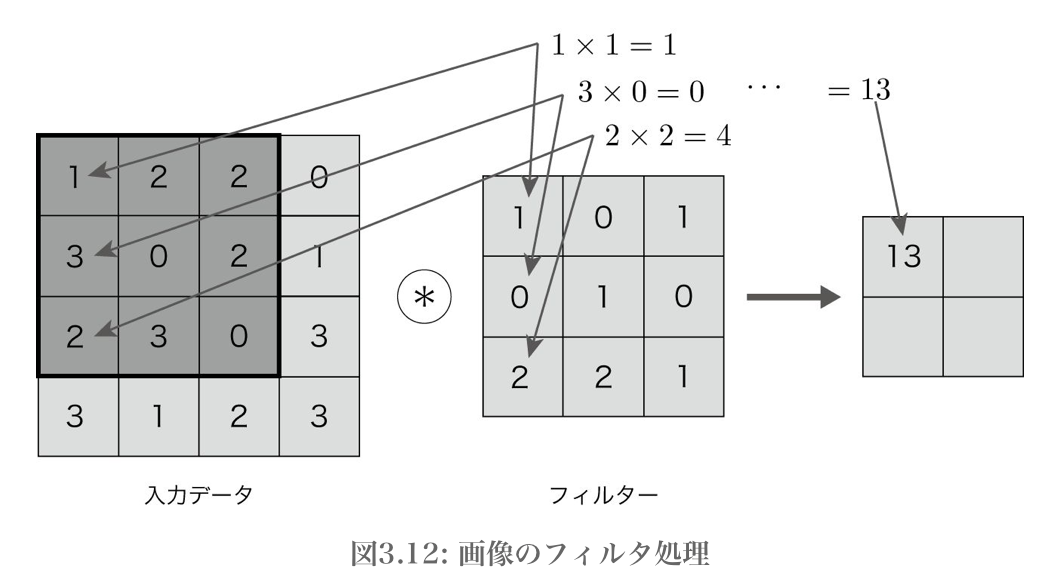

フィルターを通して縦線が残った、上に横線がない場合は”１”であるという分類ができる。    




<img src="
ol3n4PPa81vl685fM71vgs2DXQmRh6sLWRQaLli3qXxy0uHYJZUnWkt+LbYrLi98uTVjaskx72eJlj38K+qm+RKFEUHJrufvyHSvwFbwVnSvtV25Z+bWUU3q5zKasouzzKvaqyz/b/rz559HVaas71zitqVpLXMtfe3Od17racuXyovLH68PXN25gbijd8HbjrI2XKhwqdmyibBJt6t0ctrl5i+GWtVs+b83YeqPSt7Jhm9a2ldveb+ds76nyrjq4Q3tH2Y5PO3k7b+8K2tVYbVxdsZu4u3D30z3xe9p/cfmlbq/m3rK9X2r4Nb210bVtdc51dfu09q2pR+tF9QP7p+/vOuB/oPmg1cFdDYyGskPgkOjQH7+m/HrzcOjh1iMuRw4eNTq67Rj9WGkj0ji3cagpo6m3Oam5+/iU460t7i3HfrP+reaE3onKk2on15yinFp2avR00enhM3lnBs+mn33cOqv13rnEc9fbprZ1ng89f/FC4IVz7T7tpy96XDxxye3S8csul5uuOF1p7HDsOPa74+/HOp06G686X23ucu1q6Z7cfarHq+fsNf9rF66HXL9yI+JG9824m7dvTb/Ve5tz+/md7Duv7hbeHbm3+D7hfukDpQcVD7UeVv/D7B8NvU69J/v8+zoexTy695j9+MUT4ZPP/cue0p5WPNN9Vvfc7vmJgcCBrj+m/dH/Iu/FyGDJn8p/bntp+vLoX95/dQwlDvW/Erwafb3qjcabmrcOb1uHo4Yfvst5N/K+9IPGh9qPLh/bPyV8ejYy+zPp8+YvZl9avoZ+vT+aMzqaxxKwJEcBDA40LQ2A1zUA0JLg2aELAIqC9O4lEUR6X5Qg8J+w9H4mEScAarwBiFsMQBg8o1TBYQQxFb7FR+9Yb4Da248PmQjT7O2ksajwBkP4MDr6RhsAUgsAXwSjoyPbR0e/7IFk7wBwJl965xMLEZ7vd5qJUWcHBfwo/wT4Bmwk6c0jaQAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAZ5pVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDUuNC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+MTA4ODwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj42ODA8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KNI8MtQAAABxpRE9UAAAAAgAAAAAAAAFUAAAAKAAAAVQAAAFUAAS/GSvMqTMAAEAASURBVHgB7F0HYBVF172QQgKEDqGT0HvvoBSVKgiCioD4KdgbogL6WbCiYgMsiNiwV0SpUqX33nsvSaghIT3/Ofdl4iMGf/CDJIY7+rLv7U49OzvsPXNLjmQksWQIGAKGgCFgCBgChoAhYAgYAoaAIWAIGAKGQDZGIIcRINn47trQDAFDwBAwBAwBQ8AQMAQMAUPAEDAEDAFDQBEwAsQmgiFgCBgChoAhYAgYAoaAIWAIGAKGgCFgCGR7BIwAyfa32AZoCBgChoAhYAgYAoaAIWAIGAKGgCFgCBgCRoDYHDAEDAFDwBAwBAwBQ8AQMAQMAUPAEDAEDIFsj4ARINn+FtsADQFDwBAwBAwBQ8AQMAQMAUPAEDAEDAFDwAgQmwOGgCFgCBgChoAhYAgYAoaAIWAIGAKGgCGQ7REwAiTb32IboCFgCBgChoAhYAgYAoaAIWAIGAKGgCFgCBgBYnPAEDAEDAFDwBAwBAwBQ8AQMAQMAUPAEDAEsj0CRoBk+1tsAzQEDAFDwBAwBAwBQ8AQMAQMAUPAEDAEDAEjQGwOGAKGgCFgCBgChoAhYAgYAoaAIWAIGAKGQLZHwAiQbH+LbYCGgCFgCBgChoAhYAgYAoaAIWAIGAKGgCFgBIjNAUPAEDAEDAFDwBAwBAwBQ8AQMAQMAUPAEMj2CBgBku1vsQ3QEDAEDAFDwBAwBAwBQ8AQMAQMAUPAEDAEjACxOWAIGAKGgCFgCBgChoAhYAgYAoaAIWAIGALZHgEjQLL9LbYBGgKGgCFgCBgChoAhYAgYAoaAIWAIGAKGgBEgNgcMAUPAEDAEDAFDwBAwBAwBQ8AQMAQMAUMg2yNgBEi2v8U2QEPAEDAEDAFDwBAwBAwBQ8AQMAQMAUPAEDACxOaAIWAIGAKGgCFgCBgChoAhYAgYAoaAIWAIZHsEjADJ9rfYBmgIGAKGgCFgCBgChoAhYAgYAoaAIWAIGAJGgNgcMAQMAUPAEDAEDAFDwBAwBAwBQ8AQMAQMgWyPgBEg2f4W2wANAUPAEDAEDAFDwBAwBAwBQ8AQMAQMAUPACBCbA4aAIWAIGAKGgCFgCBgChoAhYAgYAoaAIZDtETACJNvfYhugIWAIGAKGgCFgCBgChoAhYAgYAoaAIWAIGAFic8AQMAQMAUPAEDAEDAFDwBAwBAwBQ8AQMASyPQJGgGT7W2wDNAQMAUPAEDAEDAFDwBAwBAwBQ8AQMAQMASNAbA4YAoaAIWAIGAKGgCFgCBgChoAhYAgYAoZAtkfACJBsf4ttgIaAIWAIGAKGgCFgCBgChoAhYAgYAoaAIWAEiM0BQ8AQMAQMAUPAEDAEDAFDwBAwBAwBQ8AQyPYIGAGS7W+xDdAQMAQMAUPAEDAEDAFDwBAwBAwBQ8AQMASMALE5YAgYAoaAIWAIGAKGgCFgCBgChoAhYAgYAtkeASNAsv0ttgEaAoaAIWAIGAKGgCFgCBgChoAhYAgYAoaAESA2BwwBQ8AQMAQMAUPAEDAEDAFDwBAwBAwBQyDbI2AESLa/xTZAQ8AQMAQMAUPAEDAEDAFDwBAwBAwBQ8AQMALE5oAhYAgYAoaAIWAIGAKGgCFgCBgChoAhYAhkewSMAMn2t9gGaAgYAoaAIWAIGAKGgCFgCBgChoAhYAgYAkaA2BwwBAwBQ8AQMAQMAUPAEDAEDAFDwBAwBAyBbI+AESDZ/hbbAA0BQ8AQMAQMAUPAEDAEDAFDwBAwBAwBQ8AIEJsDhoAhYAgYAoaAIWAIGAKGgCFgCBgChoAhkO0RMAIk299iG6AhYAgYAoaAIWAIGAKGgCFgCBgChoAhYAgYAWJzwBAwBAwBQ8AQMAQMAUPAEDAEDAFDwBAwBLI9AkaAZPtbbAM0BAwBQ8AQMAQMAUPAEDAEDAFDwBAwBAwBI0BsDhgChoAhYAgYAoaAIWAIGAKGgCFgCBgChkC2R8AIkGx/i22AhoAhYAgYAoaAIWAIGAKGgCFgCBgChoAhYASIzQFDwBAwBAyBrIFAcppu5BBJTk6WHDlySEJioiTnSBafnD7IlEPikxLFF98TE+IlKSFRAgICkNmTH5clCZ+c+MIqc+KTkJAgOXPiDOpiSkpKEh8f1nVuSkRdPr4+koR2WQfb127hjw/Lp/QnRxJOsCrUx7qYWLern7/debbL76zLtenGlYhxefeL55lQkySjDPvB/njn0zxoX9viePA/60+vHa0sk/6kjiUFo7T4XFC3PHD8NSuxT0nMwrukt0P/uit2NAQMAUPAEDAEDAFD4FwEjAA5Fw/7ZQgYAoaAIZBZCKQVdlOEXBWkIURTyCURQNIhKuasRJ46LfPmzhV/Pz9p26qN5M2bV/zw/WxsjGzYvEn8c+WSkNBQCQoIFF9fXw+ZkUIwcIgkDNKmZBALiSRXkH/vgQOyYvVKyZ8/vxQrVkxCy4VI3sDcZEUoceMA4gN9cfWwn/zwN4+ODCE54YR/953turyuD47EUOIjEQQN+uDIDVeXO7L91AScWJd3Ss3nfTKDv7s+sS/e3y+qG+cO68+iaQgQd8HrtDtlR0PAEDAEDAFDwBAwBFIRMAIkFQr7YggYAoaAIZCpCKQVdh0BAmmfmhDUivAI9smyZed2WbVipSxZtBjqD8nS/447pWrVqpILmiCnI0/LV99+I7Hx8dK8RXOpXbW6BAYGnkNKpDdOFdLBaSSB2KDWxdwF8+WjcR9L9RrVpEXz5lK3Th3JnzcfOQltMzmlf45scEK+d9085667o7vuTYbwHK8zf2oZ1u+FiSvv3Y7LT80SV471MjliRn9kwh/XTzcu1/+L6orX+FPLpc6L1DOpX1Iupf62L4aAIWAIGAKGgCFgCHgjYASINxr23RAwBAwBQyDzEEgr7EKadVoR8YkeE5YkaEZs3roZBMe3ciw8XAoXLCR58+SVvrf2ltKlS0t0dLSEH4uQOfPmyb4D++TgwYNyVdPmct1110lwcLBqdrgBphXIVWBHHxLQ1pkzZ2T811/JZ+M/l65du8o999wjwUWKgfwAoUHmgyRDTkfIuBo9R2/B311x5ASPHJMzheF1/uaHWifudw5qp2hemOT4eLRXHJHgMAFjovmpMUKyg9oxzJPZxId26jx/HA7nufzX02nnBHOksBx/c+mv9dgZQ8AQMAQMAUPAEDAEgIARIDYNDAFDwBAwBLIGAmklWi8CxF3aun2r/Prrb7Jq3VrJA9OWJo0aSYng4tK2dRslEEiAHA0Pk9379sr2nTvlxx++lxJFg2XAgAFSt25dKVq0aKqmRHpEBYE4dOiQrFu/Tr785luZPGWK3Navrzz33HOSPyifEh/0PUKtE/IgJBwSYDJDYiYnCBH6KHHEytmYGImPj5PcuXOnEB4eDY8U+V1On4mUhPgEKViwILgUUiue5OkXyRU0g3qjo89K7sAA1UqhiY5e4DVk5/XYs9Fq+kPzH29yxfUjpdpMOZwP4wvujAPFgZZS0J2mWRRx0MsgjHxy/NWs6YLbsoyGgCFgCBgChoAhkO0RMAIk299iG6AhYAgYAv8SBJxU67oLqZYCtJq/gFygcD9lymSZMnWqFCtRQsqUKi09undXodcPWhJMdIZKYoJaEHsPHZDnn39e4qNjpGnTplKrVi256qqr9Fo8zGNiY2PVNMbbfIQEw6JFC+WP+fNlyvRpsnzFCrnr7rvklZdflqDAPB7yhA0hXwJMZfaCaDly5IjEgOxg27ngdyQIREkgCIsNGzYomaJt16iZSnBQU+PAwQMyD1oqUVFRcvXVV0ulSpXE39ePNUtkVLTs2LVLYmNiJer0aQmHpku1KlWlTr3aep2Y0CDo2MmTquGydeMGqVatmtSsWTOVfGHGjCZA0iM7qElDnAsXLpzqyFUHcZ7+sQ722x0VtBTyw7t+N1V4KR73ge0EQRPIl5ozSKnl03zXi+mc887v8vDofd77u8uT3rkLueby2NEQMAQMAUPAEDAEMhYBI0AyFm9rzRAwBAwBQ+B8CDip1l2HdEvSQ81BcC4eEV9Gjhwpi5csllv79pUK5StIvVq1oQUBx6goGx8XBx8guSQWx0gQC1t3bJN3R78rhfLll/vuu081LUqAOInDdZIPx48fV62QChUqqPYIBW9+Fi1cKPNAgPyxcIGshBPURx4ZKP99YoigFY0oA6lY8x04cFC++e4brYeCsDM9oTNWkiqnTp2CBki8OlAlyVGvXj3xBVETAyet69atk+nTp8uJEyfUNKcO/Iu0adNGcvnnkoUY37TpMyQPNEeiI8+os9fyoaHStm1bratY8WJyBlofn3z+uRw/dkxKw0Frq9atpXz58tpuRhMf7nYRAyYSPIcPH5aIiAjZunWr/mbfCxUqpASRM9VhfuJDDJiXJkpFihRRHPW+417QHwvvrcNWNT6INTQ94lB2z969sm37NtmLY8f2HaQiMGDyJia8v7NtJnev2Q7rZh7XhmubeXjeO6XF1tXNKENMrMM7j6vDnfOuz53zrt++GwKGgCFgCBgChsDlRcAIkMuLr9VuCBgChoAhcKEInCtrptg1qPyrJg5REPqHDx8u66FZ8c7o0VIcgn8ihGAKwwEgDsCWSE4/X9m9e7csWbFctm7bJguhzXHTDd3l7rvvThVmjx49Kg8//LDkyZNHbr75ZiUWqLlBIVajv+zZI6vWrJHfZ82UJUsXgzx5QO6+405JgCQOAxftSxJMVxajjQ8+/BBCbw7V/iDhERsXq6OlaQo1TkqVKiVrUFcBRJJ5ZOBACS5aTDiO7du3K3FyDATGzJkzpWCBAjL0ySelcIGC8tkXX8ivk6dKqRIlhe3wkydPbhAieaRy5crStfsNsmf/fnls8BNStkxpeXrIYAkNCUlF2QnlqScy4IsjAIgfNVYmTJigGjC8FyQ2HnnkEalevXoqyUAignl3QdNly5YtSgg1a9ZMWrVqpfeBBJIjCDgeavXwSFMhEiIIKgzi5JT8+POPMuePuXIQZkuPPvSI9OjWLd3RehMPzOCICUeAuN+usLaJ9nje9dV9Zx7nw4XltV8pJAqvMR8/TO46fzuCxdXtfmtG+2MIGAKGgCFgCBgCGYKAESAZArM1YggYAoaAIfD/IpAOAaKCK2RJ0g4kDuiLY+PGjfI+iIeSxYt7tD78/EVNYCh04n+SCyRAtu/YDm2RJdK9cxe5//77UwkQan588sknqm1AzYxy5cqpwOp2749FHAMBsjrFBGa5PPDAg3Jrz5vOIUASSYAsXyYjR48SapVQu4H+RyjoHoVJDE1broXjVZqm/PTTT0oKvPXWW3CkWlSioQFy4MAB2bdvn2pKfP/dd1IAzlxfe+1VkDrB8sFHH8miJcukRtVq4gefIoEgd6Jg4nEYQn5xtHXjTT3lSES4PD74cdX6GPHSi0q0OFMekhH0B5LRicI+x7169WqZOHGi4hEaGipVqlRR0yP6OuH9JEY8klj49NNPZfPmzWoq1K5dO+nXr59eJzmi5AGIjpz0uYLE8MQsmwOEF+mF5atWyodjPwTpFC/58gVJv763SdOGjTSvzhv95iEkHBHhiAu27UgJl5e/eT4tMcGyvMbkrvEckzvvyvI822A+V69mxB/+9s7vrrtzLp8dDQFDwBAwBAwBQ+DyIWAEyOXD1mo2BAwBQ8AQuBgE0iFAWNzj8SIHzFrOyLPPPguNirXyzrujpHTJUlIQ5i3UCiAh4cMoKpBTqXWwbOUK2bBpo/zxxx9St0YtGTZsmOSHFgaFUwq5FD4pZLvkhFwKoxTi6b/j99mzZDnqGdB/gHTt2CnVBEZFYfgAWbNhPTRAxkjjxo2ViMiXL5+2sWjRIiU3ukEboSZIjFHvvydz586Vl156SSrD14cvBPgokCBT4GB1CQiaH77/TkrCnwnJAJr1jP34YzkUFi7tr20nxUCMBEHzY/eOnTJxwi+SOyiv3P/wg7IZZh88FitUWJ564jFp3769G8o5gnbqycv8hfhR6KdZz6xZs9SkhcTSkCFDVDuGzTuB35EE9A1yxx13yPLly9WHx0033aQEF/2FuPpct+kHhv9R24e+V3j88usv4ePlBenRs4fcddddUr5cKLD1EBWunGv370gGp/nD/vGTlrxwZXmN/XLjcPPH+X9xbbm2XTn32x0dyXK+6y6fHQ0BQ8AQMAQMAUPg0iNgBMilx9RqNAQMAUPAEPgnCPw/BEh0zFl58cUXZRkE5legLUEnqMGI6sLIH0kJKb4cICTTKSkdoNL/xJRpU6Ukwtd2h7PUGjVqqDNO+p2g8OoEUAq1/K7CL+o6g+gsa+GjY86C+bICmiR39u8vXTukIUASk2XF2tXy/pgPpEWLFhISEiL0/UEfJEuXLpMj8IHRs0dPqV61qox6710QIHPkv/99WmrDZ0kEwvRGRkYq+UHth9kgWopB82PUyFFSpnRpGfn++3IQBEiXTp2lZOGiUiBvkOwCAcKINoF588jDjw4EQRIm740dI8kI2Vsdfi+uueYaNY9hxBlv7YZ/chv+lzI05yEBQg0XhiV++umn1e8H8Sa+TjuFmNPvB32zbAUG1Ke4/vrr5YnHH5eiMG1iXmrUHDl6RApCu6ZA/gLqD8RpgzAs8kfjPpI3oVXTsWNH6Y97VA2aJrn9A1K7TxzYDomWHdAGolkSNWjoA4bXqCVzBvfhCEyiaIJEbR06siXZQhKEjlWppcP5Qu0VjofmTkkgv3j9EEIsc5xnz55VM58gEGDOzwnHyTZIjnA+cixlypTx+DjhXEvt5Z9aJF6n7KshYAgYAoaAIWAIXCYEjAC5TMBatYaAIWAIGAKXBgHnCJNC5WuvvaYEyBNDnpBS0AChUElhlP8l8T8IudQZ8UVElTCEw53wyy9yYO8+JRxaw1EoiRC3g89yTO63I0ToWHTN2rXazlb4p7j5llukAzQsKLRS24RCNT8rVsIEA6Y4jCxTsWIFCMIxGqp21cpVcvLkCendu4/UBOny9jtvy4xZc+TlV4ZD06OkfP3V12oS45ylbtu2FYJzYRkCnx6BIDBGjhotEccj5IYbblCSpwC0XNiPsWirTJmyMnjwY+q/5AQixKxZvUYGPfKwCu/0c9K8eXMV7DkWNx4d5GX+o6QB2ty8dYvM+H2G/Pzzz0oGjBw1UsdAwsJp3/jl9IWD2JMyF9o5o959V05iHHnz5gaR0Ukeeehh8QNZQpOflStWwgntKvgOqSGdQHKo3QvGAf5BiYt333tPxsJcqDq0bK659hpp3bqVNKxfXwkMjj0epjE7oA30B3yE/PbbZJjJ5Jd8+fPJfpAa1PKpVq2qEmL74E+lYIH8CJV8l9SuWUMSQYCcOnkKxNRsWQCHuEeOHJayoSHy0P0PSqniJSSnD7WRouSp54bJbGj2VKpcUYoULIwIND4y4PY7pFHDuhKF0MUL5i/QebR+/Tq0nU963dJLatWuLfnz5dU5i2Y0oauWDAFDwBAwBAwBQyCDEDACJIOAtmYMAUPAEDAELh4BEg0kKngkAUIzkYWLF8PspJGEQOui3bXXQSD1URKDUWLczj6dooZD0+KHH36Qvbv3gJA4qeFm+/Tpo3mpBcBEzQTnF8IRIRSO169fL7OgzbAFWiT9brtN2iCKCfNxJ99pWSxBP96DtsZ18PXBSDIsx/poPsMoKL1vvVXqN2igkWtmzZ0nzw17HpoeReStt0ZKeESY1KtbT8PwLl+2XPJAe+SJxwepJsEb0Go4GnZEBXr6FykGx6k7tu+Q77//XorDoegTjz0OgT2f9n/Llm3Sq9fNWo6ESe/evaUAtBkyOpEA4T2KgxNYkgbvvP02HWbIvffcI83h3JQED0mJBBAh9OCxZtVq+DlZLKtBNEWALDqF+9O5y/XyADRCAn39NarLQhAIe/btl3ogNTp0aH8OoUOsP/v0c/n4k4+lPq63RwSYOnVrSVU4iaWDVLZxBvdq4eIlshK+QubNWwCSqpKSMjRH4v25pm1r1QpiRJ6z0C7q26evNGzYUOcHNXRoSqVaRDBV8g3wl7vuHCDly5aTkrgnZ6DZcS8cu27ctlluxX3OnyefzJ4+Q/5zax+55ZYbVavks88+Vw2RaGiIULPngQcegAYIwwEnYZ7QyWsqp5PRt8vaMwQMAUPAEDAErlgEjAC5Ym+9DdwQMAQMgayPAIVqlyhAq88MkBrbd+7QkLD0q8EoIyQ0+CFBQaKiaOEichjmEyNGjJDjcGpaHA5TGWWEJAGJFPrpYN66detqedZNAoRHOkmlUExzDjpc/c9//qPlaA5Bvx0dOnSQEJAvv//+u3zwwQfSqVMnNY9gvaxj06ZNSrjcAs0Rhr6l1spsaDs8/8LLEgQfHoMGPaZkCQVnRqL5FEJ8IPx8vP32W/ABEipvvPU2TDa2SZmyZZVsoenFsfAIHTs1SgYigk1gYIAqROxHKN7777tXtT4qwb8IhWyPqYZHu8Vhd7mP9M+RCN8cvjl8oNFxSp3MLli4AKZAR6RRo0byxog3QFSByILwT4e1H8PPydGwo1K6XFk5iqgxJCmovTLgzv4wY8kl+w7skx1btksMtDiqwjSlfGg51cBJSPA4LyV18NtvvykhRuepJLaCgvKID8kyEiAwZToKM6FJU6bKCdzPPbh3HTt2hjZJNXnjjTf1HvW/83Zp0KChOmylhk2Lli0lNDRUySxG16HrVUbbGTxkqBw9Fi4d4JOlbKnS0gQ+X3Kij4+AsDoVFQktlHESFJhb+tzSWyrDD8mLLz+v84baQdTyqQozKEbvuaHr9QjlnKjz0zPXPBpFl/veWP2GgCFgCBgChoAh8CcCRoD8iYV9MwQMAUPAEMiCCFBYpGYHiQ2GWJ06dap89+MP6v/j0UGD1IyBRAIJCJIaTIEBgbL/wH755ONPJC+u0b8Dd/fpB4S+Hb7++mv1DUHtAZIgLO8IEIazpW+OOXPmyKpVq1SrgqYzdKg6efJkoXPTpk2bqsNPapi0hmlNkSJFlDxhHdsQfpfhbXv06CF16tSR0QjZO/uP+RoxJjcE5Scef0KF87bQKgnE74kTJyCSTClohoxQU4zxX3wls+bMUoequfz9pQTNLiDYR52O1L62b99O/P395CTCwO7duwcEy3A17+A4evXqpf4qMvo2plhzSFxCHExY/OA7ZYWSRb9NmqTaD2PHjsXYCioJEhsdo6TQGTi1bdSsqRw6fEimTZsuTfF9yBNDJA9CEp+BhkcszEjOREVLIZBZufPkVo0JEmIkqXzgi2PqtN/lfWjgkICiM9VcwCSJkWKAFU2V6Ntj0qQpchrtHAYRc/31XaRGrZry4gsvqmbH3Xf11/v4HaLwkLQiWUXyqDbMVBi+OCk+Trbt3ClPDn1SIk4cl3bXtZMK5UKkTZs2khNjvBdOaCOgufLlV1+oBsjt0P4IRl+fG/aMzp8ZM2ao/xD2mXOv3219dA7ThIfn1HQLWiCWDAFDwBAwBAwBQyDjEDACJOOwtpYMAUPAEDAELhIBJyiSWGCi8EvnmV9/+42aF5w4cUK1JCj408+CM11Ys2aNEh0kTrpC8KWfDjq9pJNLkijPPPOMkiotsetPAboonKkyL4VSkig0fVgL84wwaBF07txZatasKQth2vHmm2+qw1G2txI+QNgOr9FJZi4I7iRpSIDQcSZNY1jvJJAA6zdukoceekhNXiZMmKjlaC4SExOrQjuF7r59+0huOFGdAlMKmnZEoR9xcODJOurDXKYXNEqKFgUZAO2Pk6ciYWbyjuzcuR2aMEWVbCHJExQU5BGsMY6MTC5KC+8PVTVoUkKzo/Hjx8tcmJwQC5IK5SuUl7BDR9WfSTKy1qlfT8JwP3+e8JOSBB9/9LGUBuFDjZIcyBAPUouEBjU+WDWdkHIukOCYNHmqjBo1Srp06SL0f+LvR8e2Hp8u7MchmLlMB5bHQV4cO3ESWjzdQIRVgabNKNmyeZMMhO+UOnVqy1dffaWRhWrje/Hg4lKrVi2dS0uXLZXFixbLL/AjQ62Srl27Sq3q8EfSqaNqu9xxz30SfvKY+oEplK+AvPjMMCkCkqcviI54kCecu4thJvX666+rthId+DYCEZIvP+4R+pcIJoT95XdLhoAhYAgYAoaAIZAxCBgBkjE4WyuGgCFgCBgC/wABR3y4okpSgGTYA80HkhPU0KCZAUmMwMBAFb7DI8Jl9erVGp2Dpi+1atRUEoF1sD76j6B2B/NXQeQQ+tmgwKzCO/JQcCUJwnzUBimPKCv07UGtDmqBVK9eHf4kKmr9JGAY+cMfmhpMJECYj3WRuCChQpOa48dPSkhoCK7nlLPQgDh46JD2n1FC6FOEfShduqT4ovz3P/4sP0DDJReIjkIFCkkIwsm2btVK6terg/6TBBI19/nkk89UE6JO3TqqtUByh4ljdGPRExnwx0NPeRpy7VOsnwMHpBMmTFDtHGrZdOjYQRJi4jykAvpZsmwZJbLGf/GFNGnSWD6H34xQOHpVjR84FaWdD42gaDpD7Q6SWMQAPIj8NmmKElJdu3aRe++F7xCQRzoBOH7gzmg+S5augDnRDmgDHZR2MF2i49OxYz+SDfDx8uD998GXTEP5Aho39NtCEymG7lVzKhBPvG87d+2SefPnSzIcn7Zo0lTKom90yEry5t6HH5GjJyLgi+QzyYu5NPTRwVICEWx69LxRnbqWLl1G630b/lB4P0JCQqBx0kyuvbat5ME9J2Y4zSFaMgQMAUPAEDAEDIEMQsAIkAwC2poxBAwBQ8AQuHQIUOOATk9p9kLSgWYX9P/ARMGSGgQkMpjoEJMCqCMFKKBTwOaRxIY777RNtFCaP8zL6zyq6UJKW2my/e1PRxI4gZe/Y2PjtT6OIZk+NECQjAOxMXfBPAkNCZW2V7eCYN4U2iX+5wjKDMWaEO/xOeLrD6IAlXEc7FtmJOLicGdY4kRgxfsRdTZafWwwNC7HSM2bnGAPqE1zGNFV4uAUdd36DfLjhB+kUYNG8tWXX0mZEiVTh0DMSWbEY6w+8B2idxZtcayToQHy+ojXpDPCBVO7Jm8eDwHmgEI2kCsHlbRat36jtIXJUYXKleCzY6zsgYPTewb0h9lLffn222+hSbNT/byEhoYqYbN3715pBdKJGjXU4ogGIVIc5IYfxtAK98QXPkCGv/G6nDwbJWPGjBE/jOk/ffpJ0YKFpO/tfVTbpWLF8hoZaOvWbarxM3LkSHXEO3ToEJg1Fdc5yrng5l/qoO2LIWAIGAKGgCFgCFw2BIwAuWzQWsWGgCFgCBgClwsBCttMairhJF7Pqb/+TRGY3QUK6y55C5887/3b5bkcxz/74E2HeMw8fvjhJ5m3YD5MMWrLdddeCw0Qj0aEh3hBfnafxVKG4aEeMleQpomIkhUgJjwaFHFyAqYn27Zvl+340IFsSEiI3HnnHeKPKC9n4dvjVORpOQptnUlTJstH48apf5MPPxgjwUWKahjcA4gAsxbkSCWQFvXr1QWpwjuBe5Qy9MmTp8AHyHvQqLhO7r//fpgLxUgEtIJIWuTJmwckVxJMhU7DjGURnKyuluvatUdEmbpwgvqW7Ni5Q+69e4BG4qEzVUb9cc5t6Wh3P5yfUiuHRNnSZcsU6nrwsVIY2j7tYM4Th/P97ugvB48dleGvvCKFoanz1vDXpSU0PO4Y8B8lrNjb3YhAtGeP5zNx4kR19Ho/NE+KwmcMB8KxWDIEDAFDwBAwBAyBjEPACJCMw9paMgQMAUPAELhECFDgBl2QWps3EeL9nRlcrowkOFI7dgFfHBnCI0mOKYhcMmv2HDVrYYST4sWLSTI0Puj/QhOJD0eC8IQboF7MnD+MAMPIK4kwU6EPlIMHD8qRI0dkPsxHSCLQjIgaFc2bt5AkaO34QpuD9ykBY6a5z3PDnpNWcC761utvSCB8qaxYsVyWLV4q02fMlI4wb3rowfuVAMmRwzNw1vn99z+o/w36AGEUmOXw2bEWpk/0NUKyhZojcdAc2YIIL7ug8dG1azf4GWkgL8AJ6tp1axFN5yF1gsrwwoz6Qz8xLEvzJ5o+HYKZEsfCvvjDxKVzh45So1p1NYE5jegvHeBbZvX6tTIAoX7Llysvc6bNkLsRxabnLd3UTGf/gQPQPpmnDlFpTkVzqauvvlpuvPFGdXZLLSbe0owi3TJnZlirhoAhYAgYAoZA1kLACJCsdT+sN4aAIWAIGAIXgECK8oMK0d5ESHpFHT+QlgBxxAPLXKgQmraO9NpL75xrK712KMyT+OA15mPEkohjxzUKTIniweJLvxcgQHzgh0JTFiRASGZot9DPg4cOyrx581Trg2OivxQ6Fi0GE5L8+QvAJAkJmZNAmsAQSRZD4+JHOEFtBh8bN/W8Sch0bNmyWTbBbGX1mrXSAsREl+s74bSXhg5wWrtuvfz000/SsuVV0rr1VbINjmu3bNqs/ljYVk6Yq+SAHxH6ZDkBh6zNmjaXUqVLwCRnErRStkn3bjdIpUoVQX6sV58x7GOFChXUFOnMmSiNDEPNEPoQyQ2tktv79pXSJUtJ4SKFJCz8uHTv1VN27Nkr9z9wv1StVEXiI6OlNQiechXLqdPU3bv2qKNcaoDkz59fIxGVhc+TUiVLig/uKVkSRrOxZAgYAoaAIWAIGAIZh4ARIBmHtbVkCBgChoAhcIkQoAZI2nQ+IuR8IuY/JTPStnshv/8/AsTjA8RLwEeljlBQ7Q/4BvnLOBwEmeP245xhU5tBE46M3PLZ558pAUINFjppLRCU3zMeZEpChBz+8EXY2nhojEQiTC0djhYtWkwCoP3hB9KCGSKOhsvJ06elBEiHPLkDJAEECLVMaGrj6+sjCfAfsm3rDilbtrQEweSFZEv06Ui0j5DJuK75/Py1PzFnYzSCTg4QDscRPvhYxHEJDS2j9dCfSlhYBCK/BMEhbSDq8QzlyJEwJT9Oow8FYfrStEljvRYHJ6579x+Shx4bKAfgx2Tok0OlReNmUgwRYPLkziXxIHBYR3h4BEiUzRjbMSVW6MSWiUQOEzHzw321ZAgYAoaAIWAIGAIZh4ARIBmHtbVkCBgChoAhcIkQoPDoCAGSC9SgcJoUToJ11y9RkypQe7fjNDZYP7+75IiVvyM9XF4evfO7OjEkNwzkYN3QsEgZp8vPyCjMT6HeO11ou95lLtV33gPem53QmiBBUbZsOWH0F8KTA+SF66kbA01mqKXB8+6eKpaow53Tbzp2jDUFZ/zUOuNApvhDm4L+Phhhh1oVeiHNgEiG8N6R7KApUXw8I8r4aDn+9uDuKery8MgoPfRpwugzjBrEPtE8Zgu0TV4d8brExMbJ8FeHSz2EQtb5R/0W1Mfx8TfLnz17VsMvB4FgYXl20fMl3a6m6bn9NAQMAUPAEDAEDIFLiYARIJcSTavLEDAEDAFDIEMQoEBLIdNpTrhGKci6axR4vckAJzwzrxPAXbkLOTqChUdGj0mbXJ3u6K67ct7tu2vpHdl/JjcWjoPfWS8//M3k2uHRO11oO95lLuV3169LWWdWqCseZAuxPQDfHitWrJDx48dLLhAjg4cMkUaNG6dGJMps/LMCVtYHQ8AQMAQMAUMgqyJgBEhWvTPWL0PAEDAEDIG/RcAJ/hQ4STI4MoTnHUmQtgJec9oAFyOoujJOuOfRtcOjS6zT+zfPsyz7djHJkSYsw/pcX904vetybfLItnh0+b3zZcT3tGPPrH5cjrESe47nJPyJ0DcIo8fQt0e3bt3UxwmxZ0o79xwm2QmLy4Gv1WkIGAKGgCFgCGQEAkaAZATK1oYhYAgYAobAJUPAmxDwJibYgBMymcddc+d4/Z8SBAnwa0HBlkeaQ3j3wQnGJDlcm2zLpYtt0/XdkSau/rSCtauf+R0x4j1Wdz0jjuwDU2a1f7nHmPYeRkZGylaYwRQvXlxKwqkpx82Py5edsbjcWFv9hoAhYAgYAobA5UTACJDLia7VbQgYAoaAIXBZEDhx8gSE/iQpUABRRejDQZ0qpJiNqDAOLRCGZcWuPcOakrjImzdvKnnBTl2MsE7B1pEerJMCcFC+fOIHUxj6rsBFJUiYLy4+Dn4iTqO9PIhIAqeeyOPKXigYrPPUyVPi5+8Px5qBnmIQsOk8lPFW6P/j0OFDiCLiAyE8WDVM/j+i5ELbtnx/RcARPO4+cu5wXjHlguNWR4Dw6PL8tRY7YwgYAoaAIWAIGAKZjYARIJl9B6x9Q8AQMAQMgYtCIBpOJT8aNw6OLOOkc+fOUggROgoVLISwpzk9UUIQXtUH5AejkWzdtlVWrVipBEG9evWkatWqSlT8EyGV5AadWq5du1bmzp0rna7vLNWqVxN/Hz9EKEGb0BBhaNeFCxfKggULpEqVKlKhYgWpWrmq5AKRcaGES1xcvGzeslUmTZ4sdWrXlus7dyTvAe0Cj5YFCZ+DBw/Lhx9+qOO6oev1Uhv5vDVELrStiwL+Cs7sNDs4b4iz++0ID/7m+fRwZxmm9K5dwZDa0A0BQ8AQMAQMgUxBwAiQTIHdGv23IcAXWL7gOqHJvfQ6nwPuxZbXXR73QsyxuuvpjZv5mdyR35mf5Zn4Uu3U7vXEJf7j+nuJq9XqnFq+w4JtuXE6TPjbCRSuD+43rzkzAHfNjlcWApwDnD+cB5xPfBZWrlwpb498BwRIvFx77bVSDpFG2ndor3lUFwTPz9mz0bJj50758YcfJA6ROpo2bSokQMqVK6cAsl5+mBilg5E9uJPvD6KCUT/YFrVL6OyUc5WfEydOyB9//CGLFi2SmTNnyo09e0i/fv2kTOkySnxER0XLtu3bZOGChQiful0CEDWEEUo6d7lemjVues4awradwOz6wSPHuhD1//rrJFm1aqW0bHmVDBkyWHKjLhIfsbHxsnTpUtmOKCtr162TJOBRqlQJadWqlTRs2FD7z3rc86UDzIJ/vPvoxs8+c/yu727d4G/ed7cWuOtph+Vdj7vmzrnfPLry6fXB+7orw3yuL97nvOvhed5PS4aAIWAIGAKGgCGQtREwAiRr3x/rXRZBgC/ffNnli7CL/uCEe3bRvWQzj/cLvCvD6+m9HLu8vM4P8zOf+86jy5Ne+YuFh/V5J7Z3OZPDyAkPblz8zcT2+XG/XV84Vp5jfif0uGt2vPIQ4FxwcyUsLEy+/fZbGfvxOIlDmNWWzZqrVsfDDz8sPiArGGg1FgTGihXLlayYPXu2lClZSu666y6pW7euBAUFKYCsk/OMGh3Lli2TPXv2aBu5c+dW0wbOu9atW6t/Bzdvd4B0eP/992XNmjUyZ84c6QgNkMcee0zatm6jZjBr1q2VNatXKzlx8OBBOX36tISHR0jv3rfKgDvulAAQLN6J6wrrdiQLnxeSLGM+HCu/TpoiO0Hg1KlTW0aMeENq1KghAX45JeLEKXnzzbckLOyoFC5UWKKjouTAvt3SrHlz6dOnj5QuXdq7iSz53a0LDlfv55/3hLgQE17nh4lH3hMeSXzRD0va9cvl914rXXlXh5tH3r+Zh31yazuvpZfOtya5+enKpO2XO29HQ8AQMAQMAUPAEMh8BIwAyfx7YD34FyDghCUe3cs5u532ZZrn3Mu0e1n/OwE+7YszX8KZHAHAF3K25+ryfrHXjP/wjxMKLveLusON7bEtjs+1yWtMHCPPMw+/U7jhON1YXf5/OFQrlk0QcM8G58OGjRvklddfl6gzZ6REiRJKUgxBKFLOHz+Yvuzcu0e++OILiYiIkODgYKkUWh6aFC2lWLFi52hI8Nnat2+fbNu27ZznmiQEnzlqjRQtWlSFbdZ9Bu0tX75cyY9vvvlGrm7TWm7p1Uvatb1GYhLi5eeff5bVIEAqVaqk7VJThCFTGzZqJK3QfqkSJVMJGNZPjRMmap9Q66RIkSLw7ZEoS2GyM2HiJJkx43c1o3nxxRelfGg5PDsiJ+AXZNCgx7VPt912m5w4fkw+HTdWKlasKH379lWSxz0z7pjVpoD3usc+uvWIRz73br1wa0Tacbh8fzcuV6er39XhzrMs1xrOK5Ip3u26tSe9+r3Lu+/e6xzLurbSK2/nDAFDwBAwBAwBQyBzETACJHPxt9b/JQjwRZcfvtzyhZmCkxNeeN698LrvjiRxL/qubNrh8jyT93WWpXM9CkTcrXbtuJfstHX8r79dn//Xes5Xnv3mhwKk93iJGT88xzFTCHG4sS6eP99O7/nasvPZDwE3Z9wzxrl0FlobP/z0o2paHDlyREORkiQIgMNR5psO4mDUqFESGhoqt99+u9Sr5fGPwTnI55fPMZ2YbtmyRfbu3aumLmXKwIwFdfPZIyHBuchnkL+bNGkiISEhqeBSA2T06NFSE9oZDWB2cnXzFnIWed99/11ZvGix9O/fXzq27yAzZs2EGcsqyYfnmLpWfj6+6oiV/ShYsKCwTaYlS5boGLp06aK/c8Cx6ep1G+Sdd96BRkcpGTjwUSlauIDWcQQaJXfcOUCKgZh5991REn0mUh556CEtTzMY1pEPzlmzciLO3s8/++rWAnefeY75XHJrg7vuju76+Y5p54/Lx/p2796t5BfX2GrVqqVGc3F5vI+uz64+zqHjx4/L9u3b9cj5QZ8vrl/u6F2HfTcEDAFDwBAwBAyBzEfACJDMvwfWg38JAvQTQJX2WbNmCYWu1lCPr1Onjvaeu7m8Hnb0qKqt586TW+3xyW+kDZmZ3nAplB1FnevWr1ehjGW4GxwcXAyq7zV1F5ov4Hzp/p8SOkTKxfvl/JLU+zedcgIDBY6dMCEICw9XoZIq/aVKlSLTITkwLpoMTJs2TcqWLSP16zeQwoULKwnyP4/5b/pml/4dCHAO8cO5wGNsXKwsWLxYtS1WrFihoUhfe+018ff1kyPhR+Xnn36W8eM/V8eoPXr0kMoVKqpmRc1atXRecS7ShIVzLk+ePPp8kWwkGUKzExIIdKzK55zaID179pSaNWuqQM4+MN8bb7wh5cqXl1ogQVQDBATI8FeHC01unnrqKenUrr0sgw+PzZs3S8SxYxIDU5WK5StIzNkYWb1mNXx5xKpGCn17BMLsphG0ROrXr5+qjXDwaDjMax5HnmB57rlnpWD+vDDvEdm6Y7c8BHMfEiCj331X4uNi5NWXX0TfkpVUufPOO1OJlax8d4krtWPmz5+vRBMJoeYw46Emi1uT3D1fA7wmTvxViaSWV12lJk/OlMl7jFxHadJE4oplA4ktPvzuiC9epynTpk2bZB18qERGngZRVl6aNWumjmQ5H9JL7BMT66ImEPs/b948rYfzidpCdMgbEBBwzvqaXl12zhAwBAwBQ8AQMAQyDwEjQDIPe2s5iyLAKA4kCPifS3z5Xb9hPYSjXTIdQvpR+CHofWsv6dSxIxwd5lbthh27dkE9foUKPCEhodLvtr6ICvGnercT5PkCzfp5ZBNs5zheppcuWyp/zP0Djg3X4kU/nzRr2kxKgiBo0rixlC1XVoUCRplg6M8cqJe9o9Djg8gXWhVO/Hn01koh4eEZSVjEMUnEWIoXK6rlk/Gd/cjJDDAd4Em358oi/LBO78Ssf7bjEQjYH9Sk/hc8ZVAI/1Po8PXzaH5EQmiYPHWKrF2zVs0QOgK7phgbq2f7a9euk2eeeUYFIPoyUJ8HAR4TAcUqpRPe5A1PsV29joqICh1FJiRglx+4eBLOap8942TfeT+Jm6Wsj4C3MOzuPTVAFi5ZrL44lkJ7Irh4cfjJGAGHo/6yaPEiJdKmIIIKNS1at24tpUqWlJMnTkqHDh2kKbQ5ToHIZAQVP8zN6tWqC/1+cK7SfIX+QGjCUqFCBTWhoc8REiAkKFxfSICQcCmN57IWo7R07AQNkFh55ZVXdH0YOvRJubFbN1mzfp0SmgdAtESAHO3cqZM+v2PHjpWwiHDV7qKAfvPNN8t1114nQQjTi3+UJSf6fRjP6v333g/CppC8DU0QzmE6Wd24caM8P2yYhIB8GT16lCTDD8qY995TjZYokCwPQRukPK45rLLqHd4GzQmaCH399Vfoa04lPjt3vh4kQic8m1wzkhSr/fv3y0yQzh9//LFqaNxzzz2IjFNHyWGuG97jJPHBesNxz7jOkUQtiXtPskgT8sfGQnsIjnFn/D5DYkBCJcQn6JpDZ7okYHKDACHWXJj06Pmq/dEVEfeHznXpiHfmjJlyEuGYi8K0qlHDRnIjyLaCBfJ72rK/hoAhYAgYAoaAIZAlETACJEveFutUZiLAF2cK9EwUiihU7AK5MWHCBOHLOH0J1MJOcmhoqBTKFyS+/gEQqCLli2++RfSHRbIb/geqVq4ib454XQoXpCo6BPQkmM0k/ulAlXVT8Ie8jv9zyKGjR2TGzBmyDiQA26hVvZbccccdqtYeGJhLBQIP8eHJr0VRFl1FadaUA3noTBTCE8kIHJ1gwO986d+9e49MnjED9R+UgQ8+IBVCy6JfqIDjxZt+IvIlkwTxhRNCvOQnxSXA6SIjYLA19FeJA47BQ8KQdPD19TglRGsSnwMaKsjjy7pAQPhAjZ+FiCV7eOL0Kfnq26/h12Cm7MIu9oMPPih3D+iv10hFfPzxp/L4449LbWD73/8+LW3btsaYUD/uQU60453YNrVG0GN1PslO8hwdYPI/j6Dq6XhyMs7kIEnCoXrwYV0kpyz9OxGgBsh8CM80L+GH2lJvvvGmEh5ff/O1EiPc5adD0JtuugkaGBHy5ZdfgvxoKrfBT8Yx+Aah8B2PcLOcBZUrV1atAmoEUCOB0V/oW4QmDnz+qUVSvXp1nWN8Vqi5QLKjbGiIEiCdYe4SjT4NHz5cpk+fJk8++ZR069JVVq1doxoCe0CYnEJddw+4C+uFn7z6xgjZh+d8z/69qr0y5v0PpHJIBU/9KXN7P7RPXnrpJSULh4HwYD+4HnEtItkTGhqq7SVC6H8f5j4JuEZNBD5X7Lt7/rPqHT54+JCGC/7666/xnOcE5gWlffv2cuONN2ooY/Z7OyLpvPX2O0oyM8xvHTixpRZNnsAALZMEMphrRATIIt6TYtCYOxp2RIkrrgHUyiNm1O4oVrSYkqJcJz766CNZtmSpNG3WAsRLWb0HJI2CgvLiHpAU9qx3XFO57uoqi5N+foxElIS5s1iJKGqBkGCh+Qw11woXLqLrry/GY8kQMAQMAUPAEDAEsiYCRoBkzftivcpEBFI1CtCHnCAETp46qWEnP/nkE2iA7MCu67vSHNoZmpLhtDSHj+zZt19GvPm2LIODRApeFJbGYZe3WmUKNXyhpvmKr6cIXqQpqPjCzIWJAtiBI4dlMnasqS5P3wTNmjSTAXfeoeQAX8YpuPviZTxtwiWQGBTuKdjT+V7aHJ7fJxA5YjUExR9//U2WIzrGmHdHS/26dTzkAsppQSURQPqgCLkBfYVHvbEgQvwhtKWtm20ypSdo6TVc5rUk7FBzR/sYdko//fwzmCdMQF/WyH+f/q88PXSIapwkJiTJs88+K68Ofxl29NVgXvCmtGt3rY6JJEvaxKYTiT3bgAD01xzATNv3lIyPT4R2QHq50tZsv/8NCHDn/o8F85XoWLt2rRIgr8Mpqh9MYEZBK2L37t1yBs9R5apV5MEHHlTHpYzWQh8NJNlOQXClg1QSHAf3H5AGDRrI9ddfr88fw9xy/jp/ITxeffXV5xAgJCnpcyS0YgWpi9C6Ha9rJ9HoE01gfv/9dxn8xGDpAQ2Q5atXydatW9WsJgbaG48OHCj+0Gp6Bdojm7duxrO4Uiqgjp++/1GKIaIL1wkfrDkkIMPRxzdhZsO+kNSgQM++0ETnrTfflDIQ3F8GQUKCcORbb+l1+rKgCYyalmXhG4lHE9oXMer7ZMyYMdpTmsBQC6N79+6KAU9OmTZVBj3+BEL8tlazonKlSko8HmyflMXIcZjr128EsTpDsSxdppSaF7E8TZw4F7qCjKqKe88UBZ8unCM7duyUQY8+JjWqV9Xz7NPZs7FqPkOyKS+0cfLny6vXzsbEIepOmJpKReE+0jkt/cTQDIehlV0dCUqWcK22tUaBsz+GgCFgCBgChkAWRMAIkCx4U6xLmYcAhQ0SIBTcqU1wGg4GKRDR6SFfeLnbN2DAAPUboII/NDtQRGKhRs0d3dVrN8qnn34KzY188sJzw/DSXYEMBTQi4mXjpi0qwFC9Xv2CYJg0t/GFpsR+7IZOnDhRd3fp+LNenXpy539uV60ManQkQnskJuasbNiwUdX0C0DNOhCmNzQTqVA+VIWf2Ng4+CbYo3kcWUFtlRIligsFhIULF8r3E37R8h9+8L7c3KM7HChGyelTx2HTHgWywQcq/aFqsjJ/2XKJgclKm6taal+PHDkKZ3/bNGIG87Vp01rr5dj3gfyZv3CBnIo6LcWLBks57ITWgt+SXP7+ig3vJrVAYjCuOfPmymeffoZd8t+lb5++KsDly5sHQkc8/BwMk9cgQDbBLj13aKtXr6a7vEdhOsAoHXv27NEd3QYNG6jQybZpEnTw8GGZCe0Z3o/IU5HqByEIJkStW7dW0wZiQW2PNdCuod1//vzY3cd9rIn6SexY+vchQP8Zf2DO0WRl/foNIEAKy6uvvgrB01e+/OpLnS+HIPxWqVpVGB6X8+f5F56XQtAy6AYBOxpzOwbaAdTcOnLokPp+aNOmjWqTUJBm5BiaT5BUpCBM7QPu8nN94Dxj5BgSdlUwhxrBjOva1m0kCgI9/YLMnTNHnoQPEPoFmTN/Hp7HDbp2BMA85+6771b/JS+AuKAZxboN66Qi/JP88P33UqxgYdVm4nyl1tIRmMhQ04PtPfjgQ/AFgmg06M9eEDYkc6jtQILkLAT659EXmtKUK1dOzWm4Trm+ZsW76zS3uKYycs6uXbuUjGrbtq10A3FEEugIwvxOnToVvly+kDr16ssjjzwi5ULKKTHrIWex7gJzrm2HsQbQWW1w8WApVLig+ujgb5IWJKtoMkNSOjB3oDpWfvnll3UtuL3fHdIY94/aG0FYh06dxryAeRV9EfEe06dHAazls+fMlWPw43L77f2Ac4CMHTtOuC6RkCLmffr01n8THOYe05ysiLz1yRAwBAwBQ8AQMASMALE5YAh4IcAXc+4EMpEAiUCISe5Qcpf5uuuuk6vogK9KVSUcqLpBIwyI95Tw+ReaHEfluWEvqm3/008+KSWLF8FZjwnKzz//oi/pXbt29Tg1hTDlCJA9B/bLxF9+kYMQxqiWX79uPajq99HaufOL/0FA7ABJ8gtMcX6GgFZcHSj263ebtLr6KiUa9u7dp9fmzZsvueCIrziEuPvuuw+73pXgrG8BbN5/l3EIDXoEL/bDXn5FHrhngOzD7ujhQwflCAgY8fGTzl1ukEDYwL/8+ggJw/nXIChQuGSdjJhBweAQhI134XyxcaOGsH8/pZoroxCNIqc//CkAmzYgHm7ueZPuxjOkJ1X+iRI/W6HSPhraJ+M/+0Lx5C56OexkJ8Fkhjv4r8CZY/v2HUEifaIES2xsPHblN6q5wlS0vRuCUq/et0Lg6CslqeaPndYd0Mp55ZXhcvDAQTmN/tB8gTvgr7/+GjAohla52xyvwuRckFllS5eR5i2aS+/evSQPfD9Y+vchEAuzjwWLFiphsREEQxH4YBiOOc05RjKMjlHpwJT+Oe684048VweVYMsLIZc79gkoT+ej4dAC2QtirUnjJmraxmgsv/76q5rEUGCmEE0ChA4uGbHFCbgk44YOHSp14LS0WfNm0rrlVaoB8t5778q8+fNVWCcpMgXmMCRpAiA0lyhWXLpDuKcGwssg+rim7N6zC8J3iDCkbkmYaKj/IawkHEfYsePywgsvKLExEJojpUFkMh2G4H3//Q8qAfL2W28qcTAYhAg1KGjqQaGd35Wg1RJZ7w/Hx8Q1cxF8uRAjmh9dhbWsz629JRrkFPGZO3eu/AE869VroNF8GMa4MAgJJhKgx6CzvfB9AABAAElEQVTB883X3+g9okNqEhw+MNEjWUHtDxIs/E4yi/ePxBDJZ+K6adNm6XZDd3VkTdyCiyEEMSo9Cye1zz77nMyaOVPuxfpJ86rPP/9cCY43oXlDM5nXsT6SdOH6VgBYDxwIcgYkCs0n2S8SrlkZfwXQ/hgChoAhYAgYAlcoAkaAXKE33oZ9fgScCQx3Ic9ER+nOMl/OaZtONfmC2EUmTULtg+SkBLzwYj8S3/k6v2PXbhn65H/VrvyVF1+ArTq1IJJg8hIv48Z9oiET7733XnWySCGAAhXr2YeX9Qm/TNDdYgpXTRs3leeeeVZf5ikNhcPGnYIZnfyREGE52p/Xq1dXfRfkz58fL+h5VeijyjcdOa5HRJlbbrlFWrduBWHgkAoEb8NZ4pKlK6Ay/4b07N4VdvCLZT20WyLCwyUW6tv9B9wthYoWVYIkDKTIOyAl8kAAZDhOEjBM3GkeNGigOg78FSY1hyFoUig4ExMlezD+8iEhchsICn9ogHBHnkk1QIDBavhEeO+992Xyb5OlBRwOPgiHjcXhwDJ/3iD57rvv5H0IkPXrNxA6Omzbto1qaMTBBIeOBneh7vXcTQfJQfOXXr17SwhChP6OqBsjRrwhNWrXknIlSumuL3dmr7nmGikDHxDc0aUD1p8QGeQwxtS//53qw6UQBBdq11j69yHAezpz9iwPAQKnoPR5oSYwmG9btm2VX0AmLkaUGAq8NHnZhWdq1MiRcCZcTgXpcJAIdGRKXzVx0CbhnGbkF+7602SFvkNIonF3n4I1I8IwOogjQGiG8sQTT0i1GtVAOjRXZ8jx0AL79LNPZQnabQxHqzS3WY91g5ph9C9Ro2o19UMRdixcfsGzHAby5RAIT5qtPIznoBnKFIR2EoVqHwjpu/cfkIHQeigC4f3pZ56REAjYXGX2Hz4i92EN8fH10fMnsDa8N3qU9pX+TkjWUHOFvjGyaiJRwD4mwDyOUXOoocM1tl27dnJTj55yAITVpEmT1M9GWHiEBOXLL3Xh/4NrSijWl5LFS+i6d+ZMJIjjiRp5heRIIuqLiYtRDRBqaPCesQwTo7MwwkxRrG/UOqFmSFRkNDRy4mBi00rrDw0NRZnc8BfzlbZP/yE0V+Rc4Oeee+7SdXbatOlqQkWTRZrLcP4Rd661uXL5418CS4aAIWAIGAKGgCGQVREwAiSr3hnrV6YgQFJCd2Ghdk6djhPw//Hcc8+puvrdd90lnRDFwQ/CNfgHJPjdwJsu/XPkgFkIX3rXb9kuQ4YMlRC8pI+ASn6eQGg/pBAg38POPxxEAyNKUDDDFiGcjoIAQUt7DxyQX6DdsXTpUvVXULd2XZiHeLQvuAPN89/AySoFMvaBghrNcviCzwgWtSH8N2nSWPtw8tRpzUvChBorbdu2hS17fikMTY4X0KdZUNH/CFotLRs3lGWo9/ffp8oBOEaFlY08gb4HlywlDz76qByA0PglNDH8/XPBp8ETGl2hCYQ07qQyakWhQgVV84ImO4MeGwTB7IB8CXX1giBjut/QTZ0VcuebER7YsVNRZ2ThokUy/ovxsmrFGpgUVMEObDd1HFgIWhskbGZi17UAyteF0Nnzpp4eMxvgSmxpX7958xb5GUTRchA8Awc9CtOD1vIBokOMGjVannj8MbmqeQtZumQpSJCjELCALIQsCkbEiXgw2s47b78FYqSU3kPcgtREYom7trZzmwpJlv1C/xHU5qEDVJpPkKDgc5oHZmFRZ6NVeKXTUz47Xbp0wXN8SsNXt8Z8oXNhRgmhRhQJEE4EEhv0vcMw1y48LQVl5id5wev8cD4x0c/PsGHDpEKlijCBaSQd4ASV82b69OmqzcDnnHnphJPnb7jhBqlbu46sWrkKWh+7NYoUrFzkNNpke3ymmjZqLE0QaYbPMwqBtNkLovExFdjp66MYNBQ4XcOPnZDnoKFA30Q0y6F53XaQPvRj0hukIAlF9pUpq85lalq4/k2DlgxJJ354rzp16Kgk1nsga0+ePAlfJ+VAYEapuQnJCJou0RFqr169EBUnSrV9SG5wjQuLCIOGzRklJejfhetlaGiokqIkj4kXHd7u27dXHaf+PGGibNi4AfiXhR+P6ojicqNUqVBBFi1brlo5v/46UU2M7ocfmbq1asNHSVsQKYGoL1wJEJoVknBmaHTeQ5rWVKtWVf9d0AHaH0PAEDAEDAFDwBDIcggYAZLlbol1KDMR4Gu5M4KBKKwC0XPDntOXXNrv0wyGBAgjplBRnarO+i6fYgKzYetORDDxaIC89spLkjvA3+MEFPkiz0Sr/Tm1NSiYMIoJyRZqmtAHyG+/wUEpBPul+FStVFUGDx6su5fcXaRfgu/hJ4BCGW3W+dJNFXH6AOEOdTW8vDduWB/+AQ6C0Jiuavjr166TLjd0lR439oBJTC4JxIv7COyCz1s4X8aMfk9aNGqgGieLFy+UQyBgouFD5M677pGiaG/wk0/Jfghqn374oQpkz0NlnCrlXa7vorvjDRrUVwHgWfjt4G5639tvU+Fj+pSpumN9Y7fuclWLlhqelMIYNUAiIZhOh9BJu/7wsAgpDKG1FHbaiUfRwkVUC4V+G7jrynH2RbSOkBCYx+Cm0EfJZNTNXX2SUhER4XIPdsG7IWTmpxB0P/7kUxk8ZLBcBf8hjDJD4Ye766zrVoQrpiD06KODVDilBg6jehQskE/vA4kPCqtGgGTmk3dxbfNebYDmxxpoFNGEpUSJktKvXz84uvWYWx08eEAjdezaDd8SMCXJC7MJzoGGDRtKNZhpUSOLZAU1OSJBGIaEhKhpDLUmqF1CgZoOLkme0WSCz6v3/OD8op8aCr1NmjaBHx5PBBea1ByBQ+MFCxYiKsl+mKIUAiERDMG+qxJ727duU9OdAiAP2Rbji1AwJyFTq2ZNPMONtG2iceLkadW8CkG/+8H3BGlAPEYSDxKAfk+owTIHZCZXrAb160lrkDWMaMKk6wv6nFWTh/7giESmYb2ibx5qgZAA6dyxk2zdvk0j3NCUpyNC4/r6+qlZD8muaVOnSQFo67Ro0UJJq6PQQCOhXBxaIceOR8CPx0kQINFYA44p2UHCg75AaArDUMbUzImMPI21OFE2glBlnSSYz4CgfeD+B6QZTPu27tylJBrv8RnkHQGnzPXr1MU8KYf54Is5EqdrOU2kGH3mVTi1TQARfNttt6kj1wL5g7Iq9NYvQ8AQMAQMAUPgikfACJArfgoYAGkRcC/nJEK4K0w/Fdu3b5e7oAHS7rp2+gLMUIh0dJcTcV+TkjxkBl/mN27bJcOwE12kaBF5GaRBoQJ8EWaN/Hh2j93uLKQUnMWuMsSAgwiDS5Vvmq6sXr1SqlSspjvMFLqovcAQvD/8+ANIg8JKenAHmhoTFAJIclSAanelihVkOXaYv/7qK6FfhD1790FT4yYN+0myhT4PRo35UP1pjIQWRHOQGJs2bZSViApzBPbscWjrplt6qz+FoTC/2Q+Hqh9hF5a76K/BFMbjBPB2FSQLwgnrWqisv/DCi0KTnW7du6ngsWLpMgkNCZFbb+mF3ezG6qvEx8+jih9x4rh8/+OPsnnLZgnwD1TBLxI77kEQZgrDrIhCG8kQnqNWSZ8+fWAqVEHCwk9AoFyAHf+5aHMtTHKCdIf7jjv+Izff2E2++PZ7OL78Wp5CVJlmGNPsWbPVQSGdT3J3/eGHH4KjyfKw538AxNA8ada0mZozXdWyBcweglSwJQGiRA36YOnfgQCjuFB4JRFAIoLkBkkF3kfezzMwe6JPDzoXLlWurM6nEtCOoEYShdWN2PlfuXKl7IawS2fB1JQi8cHkPReodcB6HQnC65yf1MAiOVIVjlaptcFnle0yLcNzsGLlCjWbIClB8w1qmxyHEL4ckaIqVK6oZi5s7ywIl23QfqBvmiqVKivpScIwDgI6NaIK4ZlvDG0tJpqOMMQqZynN4mj6RT82NM3w1vxwGGihLPjHmRkSU/oVIgHCNZaaMtQA2bFrp65/IVhL7uwPp9N45oMLF5LVeKZHvzMS60eAEk8nQERxXSLJQbOlsPAwEM2ndd3m/GC48poglqiRQ9KKWjK8HyS3ieGJyDOqpUPNDfoheQGOcq8FkbQPZkbT0a+RI9+BmUyUjPvkYzVhoj8khuyl1h/vtx/MkKLhM4SaOvQ5Qw05asdVKB+SBVG3LhkChoAhYAgYAoYAETACxOaBIeCFAAUHUhW6g4rjGahYfzDmA9mE3WZGe6ADRe4i8vXZ4+kf+bWARyhZt3m7PP300yAtcsuLw57HizBftpEhGY5MofPOeplUWOKLNApTA8QRILSDp0DXslkL1QBhf1h8PJyXfoiwunQYStKDL/sUtkpDaCpbroz6OJg3b54SCBSqKGTRPp3mMtxVJRHA3XGPD5BlECLelqugur8WO+iL4EySmhfJ6MctvftKKaiDv4QdzYMwsxn55gg1gWE0CgoUVLGnABEM56IUPmnucwpq6o8NfgJtB0lM9Fkpjl1zOkNllBqG6M2JcVLaOAbNjc/Hfw7HkmfhQLWJap9w55VOUgvmzaeRNypA/ZxRLaj6TvOdGjWqy7SZs3W3nju31IYhsbF8+TJ5CMRG144d5BPY63/2+XglaRpA2FkKofcAxrMI5jYn4S/kv/99Co5rK8mcufNUzZ4OMul34aEHH4DgVMlzr3FfvIVevUn2J0sjwGeI94w+GDjnna8Hav3w2eCzxnlPwdQ/d6AULVIU+Wnm5HlW4+JiMdfOyjpoUpEsoaNM5ueHZAp/M6WdF65+EiP87kgT9oeJbbNPNKehBgNJEiYfmGSxDOd37rx5YHKWEmoXx7PInwv5OC9VLQSmcQmojtooHEee3AHQ/HAEC8ftWaPol4drTWmEh2ViH0jWZPWE7us6y/tBzTdqs23EGksH0X1791EfIK9hDaJvoRYtr5aixYLhG6iehhkf8/4HWGOCdR2k5gzLVapUSUJDQ2X7ju0wczumBBXNj3ie6wbvE3288HvePHkVowScOwGCm9oh9B+zB1p1z4K8vgYhj+dB04x+ZKh5F4W5wdDCNRCem75CChbMr2s/tQCpAXg2Jla1y6gh1759e4yhi5QtUzqr3wLrnyFgCBgChoAhcMUiYATIFXvrbeDnQ4C7k5pwoFo0fXNs2rhJhYtg7CDTF0gQXqJJlSi5AR0O90K/au1GkAKDpRBU318bPlxCQ0qnEiDc0XUCEwUVamXQBIZhcA9AbZ4+KmjaQmeKjRo0RDSEXmr+QbX3Xyb+Jm+8+QbqKw9ioKXulDJqgUu/QS38SUSd6dChgwoR8xE5gYI+X8ivg9YKVf4pmA3HjjGjLnAX9bqrW8oqaJvMgy8F7r4ig/S/614pA0Hi5Vdfl0P798rot99GOFs/GY7f4dhdpekICaAiUOHfD8eqgwYN0p3tRx8fJNWqVtZQnooFx4cvFN4UJ9S9G4TKO6NH6q7srTf3lhmI1kE7fwxPSsGEgbu4jMZAu35GnKFaOwmR8YjysHbNarmlV28VLn7Bjv6PP/wgL2HX9qqmjeR7YPMBfJoMHjJEmkNIWrF8JbRfGA54g+4O0wlm7Vo11GzpGPwnkBChFspQmBhdjagTFIzSCrkOVztmXQR4z5jckfOb3/mM0QmuO6/EBM1N8KzxQeWcJHmJDJgTiRKLHXySJNQGoTkKtTkYEpd+RVgHP6xbn1mUY/2uLZIN/K11prSvcx5l3NH1UdvkbOeERz8S0R+PLwwQIXDeyv4kQ7OMl1FYkthPPPwMgc3u8qOFcSSxyPopxNOJMtcI/mbS8TInfrtzeiEL/eGd0/uDLxN/m6gEyPoN6+Xaa66Ve+6+B+Y/J2TK1CmIUHUIYblzqR8Qks8kXadOmQITmPxqjkjSglo+JITp4JT+VQ4dBpkLLJnKlQvRcNr0/VEEmjR+cIjK9YgkVxKw3of7vg+EM52ikgihr6MWILp/xFpMp8yM9ELSqhLqLleqjNx77z1KNsXCMTPvDfE9BhMrhkQ+BVOqAQP6Q1unkeQDcWPJEDAEDAFDwBAwBLImAkaAZM37Yr3KRAQSIBRRQKFgQYFoGbQNuEO5GirvVKWmFkQ9qLQHYxcyP3wLcEeZr9vc/128ZJkMhVYEVfJHvfMWdp25i5yskSa++fY7DctIFWn6FkBBSgEqTNEJ6nfffqvhOul7oHrV6tIbBEg81OapZr18xUoZPepdqILnVv8YNOOoUgWEA+rJi93kmQgXSd8j9RGWk32jg8gtsG/vAA2JG7vfCF8cwWpK89DAQTJ56mQZ+8EYubnbDXC+uk/mzf0D6t5TZc++A3ITHAuGVqgoY8Z+BNXvU/IpjoUKF0LdT0sYfH306NlD1bypicJwngwLSdv9uhBOKkPLom2rNpIPJjNOuEnmrjjGSS2Q30F4vAxSiKF5e/W8SVasXgPSZih20AOlPsqXLlUKzlxrK3ExF74N6kNdnRos7MucOXOlC3ZWr8bu7EQIJ3MxXobibd2imfz02yREw3gW5knXSSgiZeyGkHQaTi+rwz8K7wNNG+hvZMOGjRr54cuvvlRi5LY+vTXqhDMdyKrCYiY+Clm+aZIPaTUeOPd4L72PiXgGc7rnFM83yTmW88xTzzNIjQEmlg3IFeApDyHX1ZMAYlK1mZgH/zGCCbU7SDiQEGFyZAiv04xFSRNSGuQm0CbrTiVQtISnr/yq848LSUqioE7ygyYvJEp4iUQHzS+cGQYKeaoGmaLlNZerIaVOzfHnuazwTUlmDgjjmrdgvmyAOd+WLVuFUVR6IAoMiamTJ07KgoULZP78Baqdxrz5sDaWhLZLudJlNerKunVr1Q9KMazFISEhWK9jFXdG9SGRxftFE0ISqbmxzpAEI8k8F2sezWWOYD3nfa0MzZDQ0FD4UqkvpRA+fNznn8Gx6WzVBOKNW7JoMUjvIHnqqSfV1GghfLxQS4110ZHtSThXpi+Ym2+6GSGPocWj9zorIG19MAQMAUPAEDAEDIG0CBgBkhYR+31FI6ACUQoCTlihdgTtw3+HA0/uFFMDgjuOdEBKG3MSFkzMT3X6IUOHqPo8w73SpwXrpCr7C/AJwtCMjz76qNqlswyFIe5WHyQBAienfKGm6j1VtUmUoEoIVz5qzvItCBISMAFwaFq/fgP1xcEXe2pKzJg1Q14d/ip2O6tLCfymaQnV46+/vrP6LgnFTij798ijA0G0fCfDX3sV4UD/A90VkSXwAfLu6NGyA+NsB40Rmpn8CF8dQRAcxrwHdfMSxTXCBqM03AB/I82bt9DIGBQY6ZiVmiYcYygEkO4IFcz+qCo/B8iEMVBM4y7rWyBMHkLIz5sQnncDdnyHPvWUjqdtG0SqAVahoaGq/TEVu7+tW7dRvw0fwhHhJJAcdVNC/tL3AtXeuevaqV17mfDbr/L8889rnxgKODo6SoVbElX169UHHiV0x5cmQnSKOe+PeWr3P/Chh6UJdnvp48QJpR4h0tNt+2sIXHIEHMGBZyKVq+B3prTX3HnP1Qv8q6wC8pKOZeITjooYcsYlr6/uVGYdSRDRnxGj+dBkjwQuQ43zOSSpxPOff/65mhPR1wfX2x5YY8qAgKWjZIaypX8kkhxck0l8cD0mMcV1iCQI/bXQTMlp7dB3kguDGx1zVvNyrbj22mtVG48kybiPP1YfS4zYxfX5k08+UdKM2mRcH6fBkTPDG7Muht4NDi4u3bt3x5rVWjVGSK7ZWpJZs8raNQQMAUPAEDAE/h4BI0D+Hh+7egUj4HZ++QJNAZkv6jQtoTO9U9AwIBFCPxWqzQGc+MJLXwLffPONvnAziol76aYaNW3KWUf//v315Z0v/24Xmpom1KQgycAXeJIrfKHXHWTUy/ZZN4UEhlwkwcB+8aWdUWHoSJE26BTwqa3CvrNNalRcc801MGPJpWr/M+bM1vJ0Bkhzk2DsdsbChn3mrJkaYYVtcjxsKwRCRuurW+kYSDrQLIUEBZ0+kjRg36lKzj6NHz9ef9PZIz/sP/vgxkhsmG8K1NcZSadGrZpalmYqzENhhWNknRwHBRs6piyByA77ENFjxfIVUG0/pEQS+8d+N27UWAqBNJkGzZLh0CyhkFMA4XQZFYeOD9vCjIF+SOIT4zVSw08//qQEEqOB8N41qFtPI/qwffaV98qEliv4gU8dOkkEsgTuyAve7IT7nYWYhNSu8gs/aQgQJUHYb6Qs0m2uTyQX+Nwzmgo1Krj2cW1xzyLXOEZzoikK1yT69OAaxXJ8blmWoWjpN4n1FSlSRD9cl7hO0PTFrcHu2T4BbQ2azdC8sSHWgcIwV8yFcN0BWCOZInGebXGNpb8Q1kuyl6Z57B/XCvpqop8X+p2hTyS2S/KFa5BbS7Qy+2MIGAKGgCFgCBgCWQ4BI0Cy3C2xDmU2AnyBZeILM1+y+QLNxBdeEgHUBuFLOf1tNG3aVF+CWcYJ0nw55gs6dyv58szdSF7nSzejytCRHl+cWT/P88PvFAL4cs72uKPJl2338s48THREyjCy3A1lYl00FaGgQCenYRHhGjmCQgR9GFBYKAXTEtZPXyO79+2Ff4y9KmRwJ5OOIel/YOfunTouvsBTA4XlCoFMoNo426YGC/vGPvHDxPMcG7Vixo0bp2OlHw9qoZB4cbi58dEpJLVpWHdhRMmhU0gq9tOfAYUy9pECDYWNM4jOQJKD12kGFHkmUokdasjQFwAJFpb3B86/I1LGCy+9APX4fOp0kpozJHg4PickRYRHyIRfJqgPgW7duikBEgiBhyY67Ke7FzxautIRSLgIAC52vlxMfs8z//93BnUmY41KrZrlSIC48nSKmnrx/68uA3JwTXCEp2uOaxjXTSY+k/zNI0lRfuf66NZEPtduveC6QnKW2hhc80hGcJ3lusd1gmsaE8swsW2uWTySeGUbilhKndQAocYaTSAZdYdrENdOJhLVLMc1it/ZHxIlrFvrwTUebR1RuOyPIWAIGAKGgCGQJREwAiRL3hbrVGYi4F6u3UssX3jdx+1WkgwhUcCXa+/8vM4XY74Ek+RgOdbDI1/gmbhTyOS0P/QH/rCse4lmfl53L9bMw+usi21zh5N5ddcxpb74hHglE0hWsBxfzNk/lnFjiU65RuLCB75FtO942Y+Lj/NEp8idx/MCr84GkjUyBfvCtnlkOQoj7BsT62Ud3KHleEncMI8TCrzbZj4n1FDQoVY+hQ2fHKgLEggFDe863W+e5YeaKhQ88rKNXP6eMYK8oVbLyJEjVaOFGjl169RF+/4YHx1Letqg/wcKRdz1LQCtEWqG+PC+eAkurm0eLV3JCJAA4YwjacAjkyMQvH+7PO6aJ2fG/0X75xAg7AGFfX7YN/fB19Rx8HvmJbeWcQ3jusDE9YXrBc+53zzHxHNcO/jbrYuOLOE5rgskR0lssD6ue3SKShLUrX2uLv7W9UxrZptwIov66dOFpCqTpwzXff2JP8jH/1LKMj/rYHL1uyPb4XX3WzPZH0PAEDAEDAFDwBDIMggYAZJlboV1JKshwBdpvsi6F3T2j79dcirc7rrL+3cvvrzmXv75oszfPLIOfnfEAttwL9I8Mrk83n3gefaDZflx1ygskIhgGbbn6mXkGYpD3NfkC73b7eRJXkl930cekgOs0/WXdbAtHnmedbM973GwP2nPMy/zuH7wOn+7Prnyrizz+fmi79yJRVn2jdEueI55mUiOkNTgWOb8MVc+gp8Qhvvt3LkznLAGaYQNXte8KMN6mJeJTm75izu8TKyTfWJ/vPuiF+3PFYiARyC/sIG7WXVhuS9PrvT64MbA54Ufl4fHP9ewy9OfC6vVPcskjLlWMbnnkN/5zHItYD4+m25d4TWX3PPKvFzz6COJaxQJEPoUckQsy5IwcXXwqGsLKnLrOOvieSZvcoX5eM2tX5oBf9x573JuTXN1u7x2NAQMAUPAEDAEDIGsg4ARIFnnXlhPshgC7uWaRyYevQV+7+5653Uvv97nXF53jb/dy7i7xqNry71ce+dPe927nHuhP1855tU81OxIFYb+rCFtX7XdlHG7Opnbuz/eZVwed3Q1p5ffXeORdfCTFtdzzqfkY13e4/Roj+SUjZs3qQkOI8a0gs8SmgJ57pinpdR+8iz+d31yIqEn17l5vc/Zd0OAjwKm31+T90T769Vzz7C8y5/2O3Omd+3cGs7zi3SgK+yyeEg/zy9ec9fZsEfLweXMrKN7Ll373r+9v7vrJCAcweu9zrjn2eVL75hefcznzvPIlLYud10vev3xPp/2e3r1eBW1r4aAIWAIGAKGgCGQyQgYAZLJN8CaNwQyEgEnBl1om+nJfBda9lLl8+6zt9xIMoRaHAcOHZTZs2er09TQkNALbjYrjO2CO2sZMwyB85Id6fXAe3Kmd9373MVOuHTqTlFQ8K4VQjvIjpwec4wUOR7XqRHmrenhNEJYNGsQIOcMwn4YAoaAIWAIGAKGgCGQQQgYAZJBQFszhsBlQyAdQem8bV2sEHbeiv7HC5eoz9x9pQo9Vd9p7+9U0P/H3lnxKxwBzitHhDitAJ5Lm9LVCkmbKfU3y/PDh9AdedHV6x5Od839Zp4/k6cfKWXQAY/hGvxjaL38TeKDH5Z3dXgTIN7EyJ/1XpHfHPQXMngH5YXktTyGgCFgCBgChoAhkGURMAIky94a65ghcIEI/Btf4i9Rn51QSiHV2zzmApGzbIZAOgjEq/8Zzi3OK48vGUq/6U1ab2IhnarOOcXyF5rfERjnVIAf6UnhqDOZjltxLQejqFDDw5VPLz8uW/IgkN4tPR82BuX5kLHzhoAhYAgYAobAvwoBI0D+VbfLOmsIpIPAv/El/hL0OS3h4ZwZpoOQnTIELhyB5CiJT45H1CFGU6J/GmhVMDoI7U/SKE/QUXD6xEg6zeU8T950ngX4/03R6Di3nqREOO/Efzl9II2jHPuXnAzfGIjo5O8XiE8ACBt/FCIJkmLq4uo3Af5cMPnLYfPXK389Y/j9FRM7YwgYAoaAIWAI/AsRMALkX3jTrMtXDgJ/vp9Twf08b+ApmegIkXncznW6KKVThVP1d0dXLm09aX+7fKnHtBXggjpnRP+cGYHmZb6UsbjxuW55rri/KWN2F1Mb8nwhAeKcIrJvTOe048lmfw2Bi0IgGQRITNwZOR15CuFVIyUBIaI5BXP6eNgP9yRyxiUnQfMCPjg8s8+rGRATOsdTCJMciPmcnBN5yWykk7ynuKcuFExChKU0eRMS4zHnfWDq5ak4AYRIUgIiJPnlkqCgAgjxHCwB/nlRilFVUhrXSvBHG/FuKU3lV8xPL1QZi/tCE+7z+dNF1HP+SrL0lbTrf9rfqZ33hukiYXF1umNqnfbFEDAEDAFDwBC4hAgYAXIJwUytyvsFIPXkeb7kSP+FOP3cfJu4yDeK9Cuys5mAgPe0SPcuugwQ5uP5so3/nYCvDglw3hMtRbeHU6/xZZFJnYIiXKSLluBNBrgXSmZ1fgt4LqWoEgeeetgznvfUybysz4XU9bTvrnmNgnVB6KPjxeQUQSGRBIXuVCNfynUdD74nQYDztKRdhwzpqZOHnCjPetiumiCkhKv15LS/hsDlRYDcxenIcIk8tU9iYg5L9Nkjkss3h/ji2ZJkhIJOhAZGSkhmhpPmRE4GsUFtDKcQQkqEZCTnMed8TjxIidAqSU4GmZLinFRnPAkR/PZ+Vvn85UA7OZMRClqfJebU3Pps8ZuvH8LC4lx8PEJco26fHD4I/1xKgotVwrNaCNkdAYLc+pjy3xl+cR98veKSw5FY8Du9p9Bk6MJSDqGZ0fkSyabshy3/HXD/rjiNOyLA85yz/Hj+veGzgX+DqKHktV7zuSBZx+chbTp3znuuOi0+d/QmudOWt9+GgCFgCBgChsA/RcAIkH+K3N+V++u/9efPbQTI+bG5Aq64F8m0Q42HJMUXS74ARkVHSe6AAAnIFYCXS7y0Q9CiQOVeIFmHq4fn4uO5S+wRvFiHr6+vuBdKXouLS8BLKX1mJEuuXLlSSBVPHSyXmJiAPPGoX8Tf31/7QQKEdbuXYNe267e++OI6+xGPHXOKGPFJEM6wW+0H9Xw/H98UgoRCgkgc+4yxsS++vjmxa43QtXhuWC8j9boXX9dvLWR/DIEMQiAm9pScPL5bTkXuleioo3j2oFNBAkT4PODZy+kLPyEQAjWstGe+cs7ymWLis+MRiN13/HTaBp6LKjBSMFSSxJ1DNtZL7Q2SGrzuiuGKEiJ8bnzwTLG9uPgEfX4D/PKCACkuxYpWxPNEAsTznKEi1w39mu7vP69kg2/n+8eX593HDZMESIqZkDt1ztGRRp6TzJ1+4nni7T7p5/o3nvVe77kW898HrvF0Ns1/S3id/4Zw3tNULCnRQ4xwrJzSuqZTmQn5mFieyf17pT+8/njnY3tsJ+2/NV7Z7ashYAgYAoaAIfCPEDAC5B/B9v8UOt97UnrFjABJD5Ur5hxfBJnSvuRFx8bI1m3bZPv27TJnzhypXq2a9OzRQ4oHF9fXbJZxGhLuJTU6OlpOnz6tL43BwcFaZ2xsrL6g8mWV1yZNmiwbN27Sc6VKlZYOHdpLSEhZfVFlXxISktDmNpk9a5aER4RL586dpHLlyhJAAgYfprR91ZP4w/5s2bRZ1qxbK1t3bJcceHmtWKGC1KxZU6pXqQL/BP7oew6JjIyU7Xv2yebNm2XXrt1SpXIl6di+nQTlze0R/tAPtsHP+V6UXZt2NAQuNQIkHRISz8jxY9vl+IldEhMdLnly+0Kzwh+0RC7MczwDIEBUwwkkBUmQROx8M+XIibmb2iHPs81dcM8Dlgtz2jf1+eHcdvPb+5nylGJ9KeWdJQvrQe2gQVSziqRjXHwszvmIb858kj+omBQtUgkESH5X1NOTPzuU/m/P2Wzyl5h57sW5AyIIHjyJoSeR0nDfz83tycv8rgxLObLkz3NpS3nq5vXz1fvXEv+GM5ynjozmvzdRUVGyZs0anctNmjTBnMPajiHzwxQXmygnT55SFHIF+krevHlTyZP/b11n/fy3hOQHCRPXrqdm+2sIGAKGgCFgCPzvCBgB8r9j+Nca/u79KG1uI0DSInJF/3YC0UmQBF9+9aXs27dPdu/eLa1btZI+t/aW/Pkp3HjUkvki6dHYSNRQsHv37gWhsEvy5csnDRs2VJKDYDJfDBw6bt68SWbNmgMC4oyEhYWhmiTp3buPXH11S5XP+PK6det2WbhwobbJF8/g4P9j7zwArCqu/3+2F9ilo/RdiiiICopdA9jyM2osscbeW9Ro7Ik1ltijiTHGrth772JFmkgTlCrSYZfO9t3/93Pum93ruihd//gG3t737p07d+bM3JlzvnNKK9t8883tN3p+Tk6O902oY/2OqpDWyFfjxtnIUV/axCmTnRsuKiqy3ttsY0cefoQAjsZel8mTJtvr77xnc+fO9SJoU68eW9jWW2+l57X29lHnoL1S/znJ30kKrE8KVCmiSnX1MluwYJItXjRNwlyxNLDS9D7laIdbwIdAwpRUzFO0oy1TFb2FHjXG9QmkzcR75H5B9J7yYult9R3wlBqBHzhT9RQJyWhzRe8TJyPpkTu4JyVNSAspsZ5Uq2D+OQAik5wq+QNB26qmWuVW51mTfDRAulhGZjPdE3uOFxsWpQSaEpW8Ef6lnSsDQGiud05tuwNVak/4F86GK+HInYGm38/9/V/h3o2DzozNkJiTWRNmzJjh4PWYMWN8jfn9739vnToVeLYKaSTNnTNXYcmLbPbsWb6utGrd3Hr02Fw+avJ9TmfNoqyGEuAH68KcOXOsdevWHtqcfEFzpKF7kueSFEhSIEmBJAWSFFhdCiQBkNWl2DrOX8derOOCVVzDLMa6f06yxFWkQLyzG+gcbPphONPkE2D0uLH29+uus5YtW9quu+5qe/TvL+FG4AApwZTCRAIwDB8+3AUszFXKy8vdX0fHjmh11Fjnzp1rmcfvvptuWdm5DmT885932uuvvy4Nj9/Zfvv9zjbdtI0cPpbY448/7qDLPvvs40DKf++9lwfaLTffYoVoiiQeH+dfUX9mNzpdtt5od6woK9HvKhs1dqz99fK/WmuBGg/87z7tTre0SRMn2aBBH9ob775nffr0sWOPPcbeevNNe+O112zfffe14447VuYGmV53mG1Mb5IpSYENSQGAwcrq5bZg3iRbtvQ7aVkstKzMFH1yrKoiRe+Y1P3lA0RohqUTcUVq/5h7GdFY9F6nCgSp8bC0vM+81VUCKXhtcZharyV6ofCTw/sEuEHivZXxm6xY6vuckHmanlGtT5qeUSUHrGh2yTuJIJgW1jSvpTTEullmVguVgrBOeYABARDgN4L5Rv5OhXk24UfJyRA3CRIFfCLjGJG87si5HyQKDBkTF8MzQt7ay1zgs3EAIKF5QSvjG2klsm4AUDRq1Ejrxqa2xx4DrHv3zT3rFyNH2fPPv+gaIrm5ub6GdN+ss6El0qZNGx/brFuM8YZAEMCPZ555RgDKfAEmeXbkkUdau3btQjW+d6zfBd+7WO9HbffUO5/8maRAkgJJCiQp8OukQBIAWct+ZyEncWSXIizs2GnHnYGRByYi7GSE79h7V4s7xldCuJfFGvVqGAT/cLMSrDRMcvyZaXpmlXPXYtEiLlqsV91yH8rk/vh3fifTBqZAfY5N3eR9GWMIywRgLFm21D7//HO7V+BDt27d7LTTTrPuXbtpTCBkibWWlJUq4au4uNjQ+hgroAFmsVmzZj6+MIXhQ9p9992tRYsWPvZmzZplzVu0dFOW22673V544QXr16+fbb/99ta8eXP3yfHsc885qHLmmWe62vJVV10p05mldtttt1lPaWl8K42Upk2b65Pv9WD4z9GOHw4ia+Q7BAkwUwBGs6bNbPiXX9jJp55imRIWAVZy5cNkwrjx9oEAkE+HDbffqG4XXXShPfrIo3bf/+61Px51lJ188imWm4OAVsckN8Qoe+OSf5IUWA8U0NSr16xUAMhkW7xkmlWUAYCkalzmSxsEsxOBlKnynSPfOinVMj/Rsby0TKBJhb6jEcJMzcsOACI/CbwkzM1ygGo40uS7X/cJIPqZmLMj/x/k1yfxngczDYBGNEP4i9mNDAWkjVKm8mWek9pKAGl7a96svd7LRBSYWgeqAmD0RDRV+FtNdJnEerUxvlssh05itTZKAEDQnI8SxAgphlPQTSTvKv8ercGci9ZOv0oOvjio5V/4o1PRffS5gDDX9Ek8rzbT/59f0MQjAUp88cUX9tZbbznQjmlkz549bZttelvLVq1EjxobP2GCXXf9jVpjsmyLHj187enRvasVFhY6mM+7QoL/cd5GRPM1UOf4PWnSJHvsscdcYxFe6fTTT7cA5q9srNJVvBOhX8kXTGiifmPMw2NJU0vH+mM/8GLUa2XmNqEc8qxtoqxQh3hZ9c/Hf8e/x+9p6Dt5420KdOM8Kfxu6N7kuSQFkhRIUuDXQoEkALKWPc1Cw643pgrsVCBIsoiyyHAOgXEz+Tho26atMw2LFy+2Uvll0Apo7Tu010JVIzvzhVK3nm8TJnxt3834zlU/d9l5Z2vXVjsf4qEWLlpky5ctl0PKDN+9Z+cFIGR+0QI/365tW89HU2BQ0AhYvmyZdi+XOfOw2267+e4LpgYBgFnLZidvXxMKRPxH3Z0x/rhS4Ea6mObvZs20x594wpap/zBTgcE86aSTHDxwJkhcHhoikydPlj+PV71fYUTRlED7AyCEfONkigIz2UqMKQBI3759I4BEYAQOVB986GF7/Y03bCftzPUQo9pBGiNZAi4AKlBxPuGEE51hfeD++328XnzxxRIAc+zOO++yufPm2p/OPttytMP38EMP+fVD5Z+kZfNm1goTFmmC4O9jyrdT7c/nny9wJN3+csEFcnSaaXm5je3td96xV954y3bccUc79NDD3DTnow/edw2QAQP6W1aGHKbWUSnJsMVokfy6/imAnFBZWaI5eaotXTJd4EaxAJA0CXW5+i4nw8IwMjKzBXZkCXjI0rycZWUlpW6OkpGFgIdwp9dAmh1ogABZCK9QUsESjl07ANPHmoT0re8J2cTfXfIzoeME1U1muFlAi+fRV73+XgQaJdU1Al4qMYXLt9YtO0jDSw5QqyMND3+HAEG4hz+J5MKivrNGbYxCkUcmFo2qE1o4wmYTiS+6EJHXBXbCChOlhP5yKvkXBFTBS5qTIT10ioRGTJ0AnaRzo3kUmmr593vpm8i6icL5JPqWYv8/TgEQQNPonnvu8bUBfx4A8zuLR0EDxEENDUpIOParrwR6n2a7/6af5vzzpSWSaxm6QJ5AR45BQI+PP0CLKVOmSIPkeYNPYk0D/G8Lf6PEdfgX7iff/OIigX7R+pYrnogXBJAGfqxbl67+3tEVbDCxYeCbUrqXMmgPmwSssU2bNnWeizr5Gqty2Figzh06dPBnryu+iWcEOnjB+gONKZ8Pz+d6ODZEp3Bf/BinI+fD71BOKJNrfE+mJAWSFEhS4NdOgSQAsg5GAALju+++q52QbaxXr16+MC+Vw0mchLFQY06wzVZb21IJtWPGjnFnlDzW/SpoV3y8zAI+HzzY5mnxXiSwI08+HLaVeQC79xkSBsePn+BASjPtumMGUVhY6ELsaJWFk8wuXbq4oLuJrg366EN7+eWXnRmYonLx33DKKae4MAs4g2OxZPqZKABfXD+JF4FJAQAhUsqkqVPtHzf9w5khGDD69thjj7VmgFcu+YiBURmDNV5efPFFZ0QxkYFRws8HAAjHCdqJg4mD2UEVGTvttlJBRqmesJkPSOsC0xPMUABZAEHI95AADXyO7LLLLgJMmtuYMWOdQTvjjFPFEGbalVdeJT8hX9vxx58gYKW5PfDAA57vzDNOs5bNmliLVi01ZnEWaTb5u2/t0ksvUfvMThdT3FomMK1btrI3tYP47AsvCRjsbr1793Z16eVLFlm/fv1tq616uSkNZIIufNYV80mZyZSkwE9SQON1ydKFmqdnyCxstpUsnyfwL1vvZ5ZVVqRaWYUpLG6OZeVIuMvIFmCXaWXSAKmQMJ2RKQCEAS/xCwCE5FGbfNqVuUytbw6/VPuHcU5Cw8OFNn1PFejB2w4Igv+JGgEiAOZpaTI3y4jMYSqrS90nSVpanjVttonAGGl/REVRXDRZUA2dSzxCBUdCFpfDczcaoYi2AzK59guzHSZDlaKROs1nTtFUzltwYpuqtRDQAo2NKgmhmBTRV0yz1ZqPIy1MgCzCGMsZJ3NsSZWVlUlglTPbJvnNLVvj4gf01pM2lsS6QgJ8uPzyy107EJ6ij7Q+dtltV/cB4mNI9AEs+mzoMDvp5FPdtPKqq690/iUTgVuDj3yUg8APuMH6Vn/8Aew//fTTDoBg0okGCABIuJe1gDLY5PlaAD/mlfgK2arXVh6l6cNPPvZ79/vdfg58AHRgVlOpzYFW0n5kE4ixDkjCOsYmAWvfVltt5fWiTgsWLLDXZJLJRtNOO+3kAAnf10WKAyBxcIM60cZAj7DmhXPh/QzH+nUJ98Wvh3Mc4+Vxbzxf/bKSv5MUSFIgSYFfAwWSAMha9jJ+E1555RUXBA/RLvgRRxyhXZBo9/2dt9+2TyWonnvOOdox/5PN1O7+c889r937Sc44/fncP1sb7aA89uRTdr922v/v//7PfTZ8+OGHvhifeuqpvsOPTSw7FZg+bNa9mx1x2BFu4f3088+5EMwC/tvf/ta2E1MycvRoe/qZp6W+Pc8mCwDZa6+97JJLLnEBmaYmAZC17PC1uR1eMpKJaktB5R3+EAeHiDtjvx5vl152KfKTIk80kvbPQu+zHaWpsbOYsc26bWYd2rd3BnDIkCFyGrqJFRQUOCMH4IF3fhJACH0N48YOF2AbjCLnqMY/7/q3vfjC87artIP22GMPMZC9BLzl2bPPPmcPP/yQjRz+hXKl2P4HHigQrbsdJ18djfMa28CBT9koOTn95usJDui1lZYSAMwZp50qUxftkCINqC2l5WU24suRds2110p7Jctu/sfN1q2ws4SLFHv77Xftv/c9IHBljMx4FgiA6WW333KznKBu7SFzkShg0OLMIm1KpiQFNgQFeCeLimboXZotrar5tmKZ/BEoQlFWWraiw6QL7CB8dK41ymvi7yiaU0RbwgFkZlakGZAmQQqBEE0CQAuJN6q6YulKcK6fgnCizPxPJH1RuN1qffxu92GBBoLmcDlAzWBbXXBmOQCIhHWk9tycFjrk6qGaSbjMMyXcVydMYfAVItHf388gWPHsIChtFEKR2rt86XyZLi2Sps5y0aNa/VIi4KrcfbOgSQNxADBSZa4EGET/eOhu3Yt2HehtpQMm6jFp93CqrKzcli2vkEZQiZtBzZtbLACkpQTnba19u/YCniINHfJCz42ClgwhpQBanHfeeS5IA6YDgDSXZmE0nKIxyvcXXn5FfpxOtL479LVLL7/Mdtxhe2ukNQd6QBd8iABwoC0L+I72IholgCKsTd9995099dRTtQAImzdombAW+NqlI+vcG9JenD5T76i0OCj3z3/+szRm29rNt9xiM2fOdK1JQBY2Coh+hnZle13v37+/gy/wVKPFK7Hh1LVrV88P0IJvEzaQbr/9dgdL4MFY3wB91kWfxsdG/Ds0JtFGEr95Xu3c4GdXPrZCWRz51L8vcXvykKRAkgJJCiQpkKBAEgBZy6HAbvuDDz5o//vf/+yYY44xfCeMlObH6DGj7Vktsu+8/Y799Yq/2bVXX6PdfZktvPKqa4awM3HZZZfZFlv0sOtv/IczBfzedtttDceTc+bMthNPONHNFmAIYADKJVR26dLZzj7jTGenH3n0EXtO6qJoCRz1xz9a39597BvtaLz62qs2XqFOp2o3BVDlL3/5iy+olAFTkEw/EwUaAECQawANELoyxD2PlgrxmWefaXmNGjuzNnv2bPty5Ejr0rmztIu2UljZzrZ93+1d8wfmDq0e1HRh+lDpXShzKnyDAHbAWBK5hfC1mEHB4C1bUWKLtfv1yCOP+Ng86KADbb/993cNIajy0ksv2dMab+PGjtMuc4b16z/AQbnjjjtGO8zNbOQXowTgTbSbbrjRxmsH7TBFd9lvv33t0D8cInMAiVdi2hbJh8mIUSNtyrRp9rK0VFBTvvqKq6ytQviW6X3BBOaZF152zab5s76zbpv3sCv1jhDqt0XzprWdk2TkakmR/LIBKVAtXx2LFs+ypYtnWln5PO36FwvokAZIarY0BdI0hk3mX3mW36SZ5TaSKYzek5KSMmlelWh+ZVdbKv86BwbB90i4kWTsZ37YkKApEr+SAmiie7kHnx3VmijAOZgvyC+lE12RloJ8jFRUl1mJHA/n5jSR6VmehJ8cCfcZ0maosPLKUgnvMs+RdgrCf7o0V5rlF7igtXEKTQr3vXi61s8ZmusWqb0iYiqEk9aGNDkgYI0+KZgX6V+lACrmLDQ+mIkjwTGaj/keaSlUCUyRuVFlYwElWodlwTpp4nQrWVFtBZ26aN7qpTm4vWjq3UWnbXQJoACQAS1BtDJ6im8BQAoCN6ORDZo33nvPrv379W4KiYZf3+372r79+1mO1iCEezQTH374YTlN7e6+p/DvAUgfAA7ADQASQAvWrZNk/gkAQiIPybU3VM5UOfV+9bXX7dtpU7VpcJlrcgwcONA1OHC6ytr32WefObjSXJsA+Y3zxG9t4WDle6onz6A9bBAAvuNwHCCGDaj//Oc/VlBQYP/6178U4aaTm5FS/7UFQaAXpqo8h7LgH6lDljYJonEYjUHykThX/3tDdWCOCeBJyM85xnA0pr245J8kBZIUSFIgSYEEBZIAyFoMBRZkFplnn33WHn30UTv44IPlxPFkm6BdjjECQDAPePP1N+za6/5uf73scvt2xnQb/NlgDzOKkHq+/CP0EWhxnQCQryT4XnDBX2zbrXvZBx9/rB3+Eb5LglA7baoc8WlHil2pTorEcc4ZZ4n1Ndf0+OCDD3yBPlA79T3liX26tEzQDBg7WuYxElDZvQCUYVHkw+LZ0AK6FmRI3rqqFIj4tyg30pGSesXDacLv4JtjtBya0l/bbtvHI6gsX7HcJqgfR8m3yzQBCkR1OfCA38uUaqwNGzrUATJAEHaoMMHCfGWkAJMAdLEzzeeAAw7w8TR0xAibNHmKIrF8IC2OiXbueefaAb/b1xbK0SkMIWMZJpTdufz8JvbRRx97dJgLZM+9RbcuVlJeJfOAJXaQdgFHfTnaTjvzDNd66q1xi/5Hmsx45iyYb/fe/z+bKfBmgcy62rVrb5dddLGHwf36q/Ean0NtjPzdbCpABIYUXzlTJk20AwTE7LP3nv5OwbQFRi7JwEVjJfl3Q1GgTJGMFghMnCYhd478fiyyHGl5ZKTlmBQJ5J9HKvzyAZIvR78uuEiwxt/S0uVLXKgmTG4kEEa7uWiBpKYBPJfpbZfgo38hIeaEcR7Ny5HgA1wiRQ/NCZShkLs6XSWLDkL0pggZwQzGL1mFl1mqqDVpKdL+sEwBJ0JHJKylyrcI+UvLS93/ASZsGemNrXleH9uk9SYSjKL6bUzrQUlJkUwevnKaoPlhKdL8EK2c7k52zVLqHonrop/mGFGM/sBPBOs5WaoFKjGPIVACHjFHZ6m/szLaOeiFA9x5c5ba7FnFVly0RJoHHdz0NUNmSfSTpq6NJjE2EdIxFcERNj6l4HG6de3GwJV2jBorojHiMRlarPdgxMgvbfCQz7UB9Kz7OTvwt/uIz+ltvfv0dlpP0/oCKE649khIB1iISMZz0M5AkxFgBAAEMJ960D+sBWG8Voj3grd66623tb7t72sWax19xzsHUALggs+1HbVpQMejsUseHIIDfOCHCnDno48+clACvyZsOmBeCu/EptS6TvhpGzVqlNePZ7EGAth0kd8SQKT66x08IOeYa0ih/fF6wT9Aw0Aj2ok/FByjow26shTuW9n1hs5/f75qKEd0jvcmPtetPGfySpICSQokKbDhKZAEQNaQ5hHjZNphq7Qnn37KwY6jjz7aTpJvhLFjv3L1/mdkivL2W2/aaaefaddcc5XOjZNzyrFyVDpSjPUKO+vss5wpuOEfN/mCiOC7syJyPC0hdLwERZgGFj7AERZtdvnatWtrp8mfQrp2GtE6QY0TDRDMb7rIxGDm7Fn2ySef2DfyDYLg3K9fPzvlhBO108ViBACiHYE1bHPytrWkQEMAiIQZxhL25ZkSSEbJfOpUmZPsIIbtWpmPwOzg0HTYsGH2sZg0nM/tt99+zpDCRGVpl6ypGJxOHTu5Pw1AEsYEjk9hfABC2GECHOHc/Q89aCPEgLWQPXRzOS3FdGozMbMjZdYyYcLXGrtjnBE8V+rOOdk5drU0l1ALvkBOTHk2O6Iwp0f/8WgbPmK4HaXILYSv3W+/3zlAVyINk0mTJ9l/7r5bgkeajz+Y5t122dWBk6e0uzdzxkxXXd5ppx3tcGmQvPHG63b99dfb8ccf78w1DBaME6r9OFCNxLS1pH3y9h+lAGMwpIQsEn7WHUOmlWaoy/r/+7fKqmW2oHiKxqzAZwEgRIHJwARGYXAlE8vUJc9yGjey7Ax9cgT6zZkmk7BivW91wF2NfE2kuiCNQ01pEFRJeDPt9DIDax4OwgFCiJvLyFxDYqTmg4TGgswzfFdX2fFNwa4xjk+ZE1IpQkfAEEw4VLzO6U3RPUSjqaosl7VNukwzshW1RpFoKmtUZ/kwUb70zE2s7aaF1qTxpnouEWPib1iYpOjkX0pHM/D4NFQnzZ+uxRE5LV24cLYtWjhV5+QctmKxpWVK6xFfLKjOqAhvnWinQMd+nwks8n5SOONq+kt9kJqmHpBWTZVCe+P7I1WABzRKSWvuvTbFhgAAQABJREFUdMvNbiE6Zqj8GisROIDgSdQTPtUKicz8RRShNGlIqEP0XMYEZet7bQpt4kT8fG2GDf+FKsUT5FZCW5X14b/3/Nd9bsDnYIpJxCM0F6ERLSYxRon6xSbQHXfc7qYsywTA9ZbJDI6wG8mRMHlFTe9N97nCjRBR/ydJa/WZZ58Rf1SitS3LARDAOmjKBgGaOKw/mIaWV1bJlPI+G6KIaQMGDLC+221n3bURQH3RmgU4ABAA6Nh5xx0EYGW49i0OVikDcACgn/zjx493MIaNhHlz59mn4qEAJdB2WVWBn2bEk69jqnM4AsTMW7LY7lOdh372uW0js9PmAlExB9p5551ckxOaVmjczZIG8PTp37n/kmaqfxeZ6XQU71el8eVOe6GiSA5g4uWLeF5P0XCpNk3Gf/O1sTmGT7r+u/dzB+R0p6YLfweYO8gPfYLmCHUPdf3+MTrPdcYwfUwKPlxCXvoQjSrGQwAUM5iTeHBinASAxgtI/klSIEmBJAV+RgokAZA1JD7LPfN6hbblHn/ySfvvf++Vs8pj7HSF8fxs8BAHQHDUNUI77pgfHHTQQS60stuAoy92Vc4GAOm9jf3jlltt0AeDtNifaL227GW33Xqre1u/7NJL3T71OYUmZXe+eGGRtWjZwj2jox6KeiY7JltuuaU7uezUoaPMDqYa6p1TJQhP/26GBNDf2MkCZdAY0ZKnT2C717DhydvWnAJw3wyaWIIvJ1WJQUgXAzF6/Dg7WXbPOM297rrrnCljvOAv4/3333cmCdACTQ+cuAGEZUnIoldR+UWziLEFU4V6MRojMHVcg1G58aab7K2333KV4b322ENMfZps25fbcwLdAFQIedu+fTvf+SKSy/nSSpoyZYphC42pDUwlYNyNN96osTdRasc93b8IzG1J6QrXHsExL7t4qDljN95E5jwVAjNw2vvgAw9qt3ypAze046D9D7DntNt20UUX2dHHHG2XXXqZ+CgRRf9hpEjQJZmSFNhQFGAX3wGQBZMjAERhcDMFbGSkSViWDxD8gOTkNrHG+U3lDFWmMbr23YyJGv+LtGud4wIKgopkAYENAvAkBJSVL5XArGGdkuW/AUbw+hMJItJQ0PuBM04319A8jY8KtDmqtb4QeYQXArBDIouTIcjSvg7xoJQoYkmNtD4i4aNCJgqaG7ROVFZgwiGAQAJjSal8LaS3slatO1irph31nAgAqXvFeBYpvHO/BOGcVoYVN9TLK+nn6wMgCxdOkabOMrV7qcAp+UYRDQBAqgCKEPqcRjg9lX8UyXKSAQW0Ko/6AwBEU6K0BpbriVUyK2osGmVojpTdS2pz26RVR5nptdM5nGLG6yL6unCaJoB3js2YPcmayuFmxw4FmnsbSWiU41r1R10KbeLML4HGqgZViqdE8xBaZ0iz9Oabb3Yw/dBDD3VAg/Mk2sWYY31hrFdqzAJcL5awj3+0/zxwn/Xeehu7QSB3tpy+A2QEAEQ3Rk/UvUQPQzvkKW0owe8gbPu60669wA60crRWyZH8UGk+vi4npQsWLbYimXxmyVkqmhw4LN1OJsT4Ebnwogtd22OnnXZ2P2rboX2iZ+A7JAAglIcWCqYvhYWFbjJKG2bJnHS8wrVv2WtLO/LII6P2qa0R4Bjv86jqK/sbgIFwxAn+kNGj7N/i20ZpE+ziCy5U6PcjNU4rBdJIG0ZjJC09VZpkK2zgE0/a/QJKSmRWh185NFN2UCQ3IqkxhgnpG5KDIAJN8K9VI9pOmjrF3nrnbXtJ62qh1v8r/vo3a7dpGwchQh9D9agIzL+iPojaF5VKd4Q5gfrzCeBHGMecI9Vek0aOFyoSAWx5HblXeejzOOW4x9d5LyH5J0mBJAWSFNjwFEgCIGtIcyZ1JnQ0QJ7WjgWL1RFaLE8+8ST77NPBvguP4IrTLzyM44QSdUx201HNJKFKupVMB6697nr74P0P7HfaRe9cUGDvv/e+L/YXyESmpQCPJ7QYorJZpp0UAJCT9AwAkFtuvcXNBxBwcUzWuaDQps/4TmDKB76TMmnKFHdwedJxx/u+InuOpPhC5CeSfzYMBeAX6xHf2QMxB1ViINMl8E+ZPs2uvOpqqai3NsyaUGWdIYaOCEGotAJsEB2IHSs0Q3BcmqtIFOwcofGBs1yYR8CKAo0ltIO4B8Bkhcq6X2ZZw78Ybueee547Vc0Xkw5Dgwow5eFLBLXkUwXC5DdpKqDjH9otWyENkPNl797JPhg0yOszSlomPAtAZHtpLV17zdWq4zxpPL2lMLnzbITAv4LCQgdAmubla/c506aKucXEhmdgBw1wd/Qf/2jvvPuug3lok+D0zlkl0YkjQgqaMcmUpMCGogDyQJVMShbMnyyV/qlWIQAkKyvNI79UVWoHtEIhcXPz3QlqdkaOzEoEgMycZCsULjcvL8ffxQqZilFOZkaWfqdKkFkqoRzHhpk+tyMooo2HEIAA7xoiLlBKIhfQgZlFSkq2ABCZuCQEDXxYROsOf/lIeJfQrSL00X2a5TH2iIQLHSUQ8W5zO0XjpLW0TL4CBIC0bNHGNmnZWW8YwCiCPxMTZcYBEM7VCVr68TOl0F7qwyeeaC/CaaQBskgaIIsXfauNieWi9xLRX/5atFYikFUJBNF0Ih+xbAUAOElbpqJMtJFArgg/Jl8rafIZki4Hs2UCQAiRm5PdWE9Mk3ZPmTRqmnmo4U1adRJV0GTQDOX9R7/i20HaD9K4+fLLsfIBNljCdVN38tm5czfVI1t56O9Q96hNUV9B49oLIcOGP1KleEpUiTri1BotQL7jNBtwG9ONkIJwDGjtgq3uxbzj9ddft4HPPCnApI/9/Zq/iz6K/kIeBqWSz/V84beIM2XaFBuoUOysD/iwOvHEEwU4Nfd8gCBDhg6RxscQ56HS5KA2cvy9wqOH7bjjTrargIJp3023c+R0frFMNYkyVlhYaEcdfrj6Mssee2ygAP3JPNE1QFiDeA7rJRsHaFDOmT3Hpop34hprEtFoon5avT6Kaztw/xLxfSPHf6XNsv/aiKHD7Lqrr7WDDjzAli9bLoer+U4C8g2XhuZLAo5YXzFv3XPPPXyjoZWirgX6prnmhzdD90VaF/yCn5gmHvDtd9+xJ7Uxt7n66Oq/XWmtpf0JSFWpMZqhPlihsN1z58x1R688mz5DswQwZJnqk5sbAbmcpx184EXQJo3GfKSRRr/TV/Cj9B9zjnpX2sryO6Tzudp4qRY44+Y7apuPDeoZ+x61Ivk3SYEkBZIU2LAUSAIga0hvlm+WQxblF+U1/IknHpcZwP7uB+TTjz51zQzULAmp1l5RO/A0jmkKuxOYIrCQnKTFvWv3bnbxJZfKjvVNDwvasnkLayzbV5yX7rlHf9mnLnGnYAApjfMbyx62laGCind6wqXCAMCMICx3l1rqXAmhn376qZvNjJFAu+eeeyZMYLS7IMaDtHrLuN+S/LMuKFCfwQxlqkMAQGCQYdrQ4Jk5Y4Zr8QCWLZHKbnsxaOwC0dddZSv8xcgv3FkbDFJzARWMGYAOQDcYJ8LYwtRhAsMHfzSEZcZx6SLtzP3hD39w9V80RHCOChMDOAfTBBBSUFDgPkCKioqdUTz33HOttUxmbr79DgdLiC4E8/O2Ih211Hi+4sorBbJM9l1CdntQk22tCDWHi/HEiV33zbpL+Cr18f/CCy/IDOwLv6+bogDwnqCFcvhhhylqwI7OxMEYwySRkhogYaAkjxuKApUSoOtMYBbqHZLjUWkJVAOAyBFqdna+5cqpYq5MYYgAMmPmZAEgRdIMAUwgj8AICdvpMgcAnKyskqCt34RfZWy7EKHG8J2ElgdmK/6TaZqxr3PsUtcJDQgp3BsJzIAaLkjIxCJFGiNokCAA6ax+668+gDB8MHzEzK5c2iAZMoFBk6F5k3bKmyVwQGVGS4N+q5KeqFftycS5n+sQtSkiTkSvupp8HwApLp4lAGSaBEVMjuQXRQAI4cXLBfxIMUG0kEBHEWjmO73oJ3oB+kl4A3xKl6Co6DoVopU/WderMF8SANK+nULOt0ADBH8rzFHUJAJAEB5TUzO06TFZzskfc6GwnbQXdthhZ5koFpIxkZ9vzPccSb8QOntbohr5X9UvzMHwOWfIHIQ1Aq0CTCqdD5FZlRMpcRvjj/GKttGnn33q8/xggRZ9BZKffdbZMhnLdFPIXJlXZmpd8vHLoIeQEp4nTZksXuoJB+4wXQGAwHkpZbJGDHx8oK+PmF327rOdO9RGCxagn2h4Awb0902h47TpM0cCfteuXXzz6W8Kxw7Bn33uWefDeEdxfMr6lCOtFBJaLmwETBdP9bXMQftK4+KMM86opQH3rE7ytumZ4QgAMm7yJI/4N3LYcLv5xptsQL/dvcjS0nLlq3bwAY3iqd9O02bAydZD6z2+TgBMndCQSXQqV1Qi5gbmFoC3DB39up43c+4ce1cAyL333mc777qzXSb+sok2RwAmqtUvOK/FTJu1nvUfHrFNm02d5tQVH134XyHCW8uWzb1c+n2s/I6x+QKYARgy6stRrqECL0s0H0yKZFjmGyj0CbxpvsCltuJL0E6mjwMNw5zmjU/+SVIgSYEkBX4GCiQBkDUkOrwC/EtZRbl7In/yySdsr733dgBk2OfDHABB1RKTF+ww2U1ACAWcYMe8TZs2rl7ZRQv01fL1gHkDTrfwx9BEapnk6dSxvXZR5rpDLswKshWJoEOHdmIK/ugAyK233ermCfhmQANki+6yX10w3xf4cfIbgi8I6nSqNEYwQSAUHKmW7/JfyT8bjAINMJg8G6aDS2g7ABzME2hWJG0PgIKFGj+VslEmDO5uYj4AObIFfqHp87rUeWGCmkmLIzcn153FwajAZKBxBBMTPMG/+uqrPsaKZDu9SGrDfaQqvIU0h3AwBzOLKjCVePX111yDiF0vHNy1ExOESQzmKjCKj4oBnSDtkwMPPMiBFUIGVkmyOEUmMmiqEM6Z+pKaiCHasmdPH+swk/gdYVfow48+tMGy214ulWDqiOYKwA5jvplAlmiXS8wmTLESgEoyrWcKxMfmSsgdsqzk8nqu4IYrnnYCgBQVTZEaf6QBEpnAZEiwS9d4j0xgCIObLaeiaIDMnDVRjlOLBGwrvKp2UvEfgdmDZBolCYWaetPxJaEvEejBUyJKVumdj2hbB2D4y6gcaZLgeR+47q+Dl8etutd9S6hsRJsazCs0j8gHCNoQpBqZc6gauqYcKgczGICARo3bWgcJ8pmZTSSHx8wyQscKBHD0hELCOb7/bMlbr6dTmfoV+iEAskgACE5iqytXyBRDgIZoDpgBcAX90ySEE0qYPqkW6FRdpXPqG4CitDRQKrRDJJAKpABkAiCpqkyxzOzWWn+7qMxG6leAqSgKSqpojm8WR5GkRbJ0yQr76usvfB7O1rzcpk07aTG0Un58gSibmoDGCP0VpdUTrBM3rftDqE4oWfVkbSJVam3C5HaaNCTQ+mMT54QTTlBoWa1H0hbwPFoHAD4AtNFqeOXVV5z/SZHATeSy32j9Imzth+J1NhEo3kORZOB1EIZrRGjWGwR/QAqcChPRzP2NSLgG4Mf0gyhl8Erdda5b9y1kbjzYQXXWDyLose6hYUjEmiKto5uKz+q1VS+7+q9/dV5tzOgx9vmQz50/w0QUbRY0TAgnXyTzUQB9HHcHAAQtXVIAMfzHKv4J94QjbR898Rv7nzRAvpCT+5tvuNH22mOAl7Z06Qpp+c4UkDrT3njzTZszf64ApzO0Lm7mobbdn4wGaKZoOe3b6dJQmep9UFDQyddPBhZvhl51d4T/waAP7NHHHnM/JhfKjLWZtDBdI4VcAlA+kZYybYVXAGjaW3xijy26q39K7B75esFktrCwUNHnCq1jp47iWz9RRJ3BvnHSrVtX9y+Hdg/+U8jLxsWW4nNzBIaw0YF/urEy28UvC2s/YBMbcDyPetDnSRBkFQdSMluSAkkKrBcKJAGQNSRr4BWY7N/UQvLIIw9La0PhQGUf+9nHn/mijL0qAun+im6xlRbhc885zzVFDtOuA0LnQQcdbJ0KO9kDCqPL7jzq/32UL55mSBPghedftMlTpgi5T9WiVGDHHnOsmxTAkKAZwkIOALKV/IcEDRCihIzVTj4LPH5JyrWLkCFhmcRCmUw/AwXCoAmPTnSEMwRiDAKjxGl8ywCW4dMDkABnba0EIKDiDrMDMPKuTEcYY+xwkgcmDuYUMGM7MR5h95jyGYcAYtO0K4MDOUAHVH+bCDzZYfsd3Cs/DGi5AD3yTdF4oz677barR4xAi0Q/fecHVVoAF2x8cdaGqnNBQYGrJcMgo0rM/dSFOlA3tFe22HwLMbmRSu3ceXMFpCiU4dSprqa8raIh1arv1xuhSQAkDJjo2BADGcZO/SN5w64bdwOI0Sf1z9fKYuFR9SYJ+hwBLpzmOSQXXvQ9MLOUSwrPDPXhXPyeHzyfDA2k+P31L9e/Fi+fvPWv179/Zb8RhPEBUrRAAEgwgZET1KyMXAl4qWL6iciQJxOYfMvJzBcAkiITGAEg0gBpnJepnVTMZBC4ZTpQUiHBq1TztRySpkvYU0QXNzcRPT0h/DltoaXOJH7XuFdT/HpEfeVtEdAhcT66jZ4AANE/TDRSqtFIUJkS/HXB80h896uYwWTIxANAprRc727jVtqR7ar3V34skJii7Oo0v+37f0KHx86uKV1jRazmVyrIxwlU7946AIQx6iYwS6aLFHIEqz5MxTeK/uG8tlogUbp8tmTLJ1F2DqZJ8l2hedZNgGSaBKCBCYxmXz1K94keOJbF2Sm77NWWL2G5jYMfkdlQRLDInIb8Kk84iIfbVfSZKEWgR+RgNVVzY7m/g/iK8f72diXKib1H9RrpP9c73cM4CA9naKhOgPJp8jWFNiIRxtDQQMsQwXcH+d44RhqpTaWFSMSyzwVsE0EFJ+/4IcM3x3ECSgoLCmVClm4j5QPj9ttvdxNP+CJ8XbFehbYtKCqyVwWcDJGfjzcFBLB5hIkvGotoeMDv4PtqzJjRMrVc4BtE1ZrT+g/o70L8lsozX8DHbdJULC4ucp8jBYWF9pfzz/M5j6ZNE8hy7733OpiD9gLgCb4+AALQAGGtHDdmrK+5xx13nNctzFdhngsk+rFjaFM4okUzQevdLbfcYp9++LHd8o+bFE1tf42HKDQutB0lPnCk1t9vp0+X49Murj2Mdm9HmZ/malNCy6c9/Mhj9t6774nv62D9+vXzDyYx1I13YLLo/tnnn/kGCebXZ51+pjRAGmusJ0xllO+bSZNs8qTJijY4XFo0b9shBx9ifz7vHBs1epzdcMP13idogGzSprWAkc1tkExf6RO0NNEYAYh67713tZagOVXj5lBs4PVUf6FNerzoNkJ+Tk456USnLfXIEvBIWhNa/hidk9eSFEhSIEmBNaFAEgBZE6rpnsCO4QPkhZdetHsUNx4fICykQwcP9UUa7Q8ADHYRttl6K+1KnO+7KAcpYktvASCHHHKwdjE2s5tuvsWdXP7pnD/ZzkLLtZ5EbJEWu3nz5ttrinVPJBhskltv0todg7FDf+edd7qgCZhCZJDCTgWuGTB48Gc27qvxDoAMGDDAztZOAlFg0iKOy9nINWx28ra1oUCcwVTf1k/xy2iDzJ071/15AFQQSQWzJ5gNAAFMZQAQ5kjddYV23HAuByMJU49JCyrBCKGB+UJltUjMJYAD9wYAhCOmMtxPIv/SZUsdwOM3KrKoK0eilLzwu3aHxpIYHwCQFXLSBsNDOTDKADIwymGnEOCEa6jI4vE+MvVJgCBqH+AJz2/dqjWPazA1QKoG823sJ+mb8In3LXQPYBPXmRuguzPEAiQAPLhO33EfggvHUIbTzVUFRGmNLWfyE0QHMOEck0Z5eYUAL4039W8rOQ5kTAYwhTIaEg5CfbnO80jk43z9VP/+eJ74tXCeI+dhqDnyCddC2+L31X/eyn4DgOAD5AcaIBKea6QtUF4LgAgEyWoqekdOUJeXLhDYJ4BDGiDVAhuqpV2B3w18fzRqhLPUJn4/szv/SLzLNRK2w3dAJjeH0VyPZkGahGpy4sMCATukGoEfJO+mGrREsvRLpUqzQCKrX8A/CLvmOFwFAOE7kTMyMpsqBHUHaTIINPleN+gHmgmqkwMjtQ+IhJY4jdeErhS3ZskpoFtprbfYi2EIuWNYmbIIAdKVFFu0eLaAq4kCWmXyUiEARDQEAKmpUtQWaWdkCsTKbZwv57ACquQLobJcNNLtmLigKZKCE9QMyhMNVS4OUHlOhfKlS2MmLx+TAAly8psS1QVaB9BJz9FXN6dJxaSBegs0pNwEcLV48RLNjTINyMdksa2/P1xnvDKOSfFxzDnesTDW1yvdqW48QWq1gfC2RPRCuGZNQrNjyuQprt1RWFhoJxx/grVs1dLXARxp4+cpWifMgfiDD/mD+2GhuDFjx4ifec3aSANk5112cQ0SQIjQPrQkvlYEk88++8zzAeqznmHSiT8PUrHMMocOG6r172uqpz5KFRCzg7QU9xEwn+3O328WT4UmCutXT2kh7r//fqKj+kf/8JGF5iKmnqyLbCBhaoM25HQBD5gpjx/3lZst9xPAEOatcPRK/MSf0J74kWhMX0//1m68/gYbJqDo0osusQPEt+U1lkaRRsgggQzweZO1Rs+YNcMKCzu7+ShOWjtrPd9JWjQ5GrcvvfyqjRad8cHCxlpXaQ1HGkXRezpVbfhE5kevSZuTtp995llae5syEtWf+q/DCml6YCJEXzz40EO2+267ufkq0eY4V6l5H8CksHOBaFjgvOQ3Ap7QsumtzRgc0X49YYI7RGd8NFIfYqa7oxzRst6jgTNVAMv58h1GAABC3uOsNoAfP0G+5OUkBZIUSFJgvVMgCYCsIYnhFVjQy7SoPSTtj/vuv0/o+OH2pz/9yQa9N8idVCLcsVNy2mmnSQV0O7vgLxfaXXfd5f492KEHANls8+52jhxSDhs+zC6RreahB/7eGVXsidO1YJeVVbjtJUj9F19+oZ3HTDvnnHN8V/0mRfSg/GOPPdYG9OvvQs83kybKCeun7usBZgRfIuee/Se37I5Y5qjea9js5G0biAIwTvUFO84FZpjvCKf0PztWnEcQxg4XQAEhmBQYsPA9HDkPQwdD7UISQk8s8Wx2pp1pVN7AeHOeFJhByiEFvwT+Q3+oW5yRp371UyiLfKH8+nmSv+soAK3j/ckV6Ea4Q8I+Mt/AxONv6Pjjj3eNIMYEDD/md+wwdtJOImri++yzjxdMP/k48F/fHwOcAoiDwcUJ4tvvvONRFNooLOV+v/udO3cGTKkbA3X3h3pSPwdRVBZjgD6Pj514v4d7eC75+ITrYfzUf1b4zT0hbzjHb77zCc8k30+lBgEQNEDSceiH0786DZDcrCY/AECoa5XMJmoQqlOzPfwsQkFWelPJH9IScO0ECc76Ffn0iOqJkBmZu6jOVdrtlcYBYEpolwuhAlZcivHVh5Ywq+tdS13GD5UImIJUiAmO+k7vsGs2pMqRo65UVLALnOlRbAzQxAV5bqFc1UmAgSc5yuBUtXyL0J44TaMMG/IvdeLD+IqPMfqc/q0DQBYumikThgk6Lw2cBAACsFEjMKqmJkvtzpcvLfWZ1lFoXVZaI3ADfyG0R3OUgJPUtArRqUTzopyayoltmvx6lEtzJkVmMnl5zVSWaC4TGATJqirFRNaz0jWXCm9yE6OszBxrJDA6AqwQuoFmIhqWyXfDiBEjpd33kRxc5gsY3lxC6pb63qK2n6kJ9A79HsYwv8M58qzzlOj62nLVPt5Bf380BiqkwUCIW0CKJQLRMctlbPSR9l52FgCcoudoniDyHQAsZr4IvnwPifnEnWYCuCe6EuqQ1JPRkRdQCU0NAHv8qAGgY+rbWNo7JID2+QuKBB7kuRYj61SgzahRo13LgrnprLPOcjOSzKzIlCzkIfJK8aJi36iifmgnog0JyAPY6CY5oneYd8K8Fe73SvzIn3j/kY37CZkMAHLxhRfah4r6d8Ixx9jv9t3PekprBb8amKRMlGYGGixLly9z7V3aMHDgQOf7/vPvuwUcbSJn6EXOG6KxwnNoe4J0TsNJ0xQJ8P335YfmOesp0+vLLr5E/rtaRGNKtGYzDE1MVuTnBQTddNMtWhc62oWqF35ZGmnDBSfrrCl50hxB06RL586KHNXatUPRwCksLHQ+AzMlNvk4shGzr9YFNGoIa18l3vif//ynjwG6GGyVBA3r0ye6kvybpECSAkkKbDgKJAGQNaR14BVYzB8Z+JirhR4izY7TTzvdPvvkMw8pikBCyFAcbYHWo/p493/utgH9Bzgyf8QRh1uHggJfLHB8eeVVV9me/fs5S4tQSoI5Y9cFpmLQhx/4Ak1YXRbMDz/80BeSs88+27oUdvY1EMdTOB8bLfvLr2Vvuu9v97VTTzrJFz3UJ2E2InZjDRuevG2DUyAuCAbmgUrwnWuMQY4Iu3hjB/yAwQh5OMYZDr6TPwiF/OZ7uKfuPvJhD193nWfyCWWGvDwusnFHIImYd55BCgJUvJy6+6L8oS5+Q/LPSikQaBrohdNbABDCJCMUhJDHqIyze0r0KDTRBml3EbMkUoHmHHy64E8mABgSHyImOkwO6mMAMMIqEj2I8NrsDA4bMdx+s8tudpjKDxogjAdAjiAs8IwwluJ9Hr4HcCyMOdpEGVwPR67Fx1m4Fq7Xf17IG86Tn3LD2AvXqdtPpQYBEIW6zZAGCD4zAECys+tMYOprgKAdBVBSKXOZdAEgWZmNZC7T2M1lAEXKJTSXyywGkqfLqSkODgEqMHeJQkfSCdI8qI6ESoQVn7QT75gqUa8JlaKVwrQq1QIgkjYqZY+hbnE64kuEdxSHivgMyVSdsjLzRB+0yrhT0WasXKBBmc8jfp/qkJElzTOtNatDP0pbt4kK8oEufKJEvesDIIsWz5SAOEHZ1ZZKOUF1LRrRXOQhqk5eXnPLU8jRDAEglLR8SbnMUip0De0a1kZAoEpFXFsm4E/RLbJy1e+Z7j8F8ChNQFKFTJvoxxSVLfjE6YYTynJdL1mhyBcaG01bdHSwJEtRYSgXjZ2IzibNomIbNmyIwrEWy+yimbQktvdQrNA4vAtRCyPBObwLjGnSeuuLqPjwaKrtCV6EZ9JaElQCKEDTj/OAEPz2pCyYWLIOMbeQgvN17iZELu2hnRkCU0KibH/HnVb+y3/zDLTXMKNEU+T777NGsp7v9NVLy9dF0rB5R0At4XeZ/y699FI52xZopVxhDgl1YL3kQ12oL+8h5QH41naW7ovPa6G+q3oMzyR/hZ71tUCdyy67zD4WAHLZxZfakYcf5qY3gDCvvvqa/GN95M9L1/h0v1uiIeGHiQD3gCINbiazGBIbZCTa7OMh+qn5usbQAAEAIRQ9GiIX/eUijwIT6Is/uFJp8wFa4BvsqafkDFX84+ly+Aqd0bjBwendd/9bZrKNrEnTJm7ajQYOdEV7Bq0ZgHZC2i8WwM68S/mYugDCP/zww5onK+wO+alD8zOM2Tg9vAHJP0kKJCmQpMDPRIEkALKGhGe9iRZ97cB+OMgXBuwod5eq5rz5C4SUj/EdWRZPdlzbttlEWh5f2OMK8Qai3r59Ry1we1u+GOM3333PBRR2KzrIGzdls3uHXae4MS0eqG0ul03nqx79AwQ+Qza522zT21VDd5LaISYMLOTs9o6fMN53NmYLOMEB1Z4CXCImJmJeKDWZftkUiDMK8e+h1pyjvwNzHM5zDAImTEdgPDjf0D2UwYdxGs9Lft2R+PzwXsriw/NJMGTuI0LPpDzKiueJl039SDyT76EMzsXz8TuZvk8BaEqCTgBfaHYMGTLEHSgTbQfNMph5zKZIqHTTHwixePHHdhuhAkCWeQnVcqd5kKljkwO7oJqEbLDK/0xmdUTu+XrSN3bJBRfaoVJrD/3M/fF6+YMTfzgf+pT8JPo7nEcA4TefeHmJ2/1c+B6eEx8vYfyEa5Qbyo7nC2WsyrFhACSKAoMmAT5AsrMUBle7/PgA+R4AkpshPxJylKpQuVWVmCHJ14Q0B5pI6yAru5Hm9Qo5CSwRML5CVeG9iwiO2YuI7VoJri2ga5WVihzjgiUiZyQUev19DGgcJPqKA6AGqUYaDNF7iwcQvgGw4PtC6ucqq0y+SQitmyYtkMwMVO/RHBMAIME/RYJ/hZyCYr4AIABwk5e3ubTKmrtpHeWTAn2jXxvib5iHopaGJ0KGhgCQBQvGCzwCzFmmvsD5bOQDpKYmUyYszSxXWgSpArSYsxYvXKKd61K1XcK401XjUY5Qy3UvoYkz5bcgXSBRlfK6uxQBGVWYzYi4ACCpcrIKcEQ0Dsn2AiFLJUQ21j0dJQi2s+bN0OxgvNcBetQfrZUAXGdlRSZpga4ceReC4N3QexFosE6P0dRSV2RifME7MHYACHwU6jfaMyR++1Hn/D3XT7Q80gEBdY9rNNW+9wAn0T2M6DAv0F4Sv3mfa9ut+2k7ZXhe6hNl9fzcF95xLi2V49Vnn33OBssxKtoR8D4HH3wQJXtfxcumnPj9XqD+0B58ioT2UT75Gsob7vmxo9dfZZAAOafKyelt8oEy+JNP7Z+33m6777pz7e2vvPKavSyAobO0Lbp06+pmO+XSVLnooovcaevVV14lZ6N9I/rE6EABia7yMTpb/rU+/vhje0KO+bvLf8oF553vAAj5KgVKvCvA/KNPPnFNHtYCgBD8q2BGjdZOR5lmDf9ipF119TUCOJb4HIUmx1bSVHrptVfd0TlgFAA45jmdBIY0l1NcvmNShOkR2obU6S8Kncx65P1NBZIpSYEkBZIU+IVQIAmArGFHhPWHBW6xfCawE1tYWGgthHazg7B82QoxljhYq9Fi3EQLqlhM2VSiLpglsII46021EwVjtUjRYoq1COHRG3PioBbNAhIJltHyVqydlaKi+VpcvnS1UhB5Quw6Y6LnsFOI+iZaJ/h5QFU1X2qdLcXAUieWYRb0sFiuYdOTt60hBcKY4fYG+6BehsB4wfzx4Xf9FM7FGbWQn7yhjMAoMl45F37Hv4eyQ5kcETBCOeEZ9X9HZaBQG7WKZ8Tz+I/En/jzyOeMbeJa/Hv8nuT3OgqEvgk7lzfeeKPvJh9yyKE+F+y66y7aec114Yo87J5CZwQCwBBCH3KEgQX8QGuNMpcvWuJCbrZ2HFMFrpJcDVwAyHNyavjRxx/ZaNnvz541265RyOPD/nBoJJxoPgn9yPPQekNlncgmCE74pMH8gw/PxVyLiAAFBQX+DO7FKejChYtsnACapdJiwW6d3Vt2RcNYJqIWoRUpn4gQ2Jsz3wZhCaEdTRe0YHg+92MKRttCGf7AVfiDkPZDHyDy7CB/ENXV8huhSDBBA+QHJjAAIGkCGxRxpFpmLOQ1Od9s2rS5VMuz9btc4TyXyvRihepWLfoIulD7mZ+JNoKZCz4kTE40q2uW14KZvHuAJNyj2rmgFvmeACIXnaoxKUBjR9fVZvTNMVlQ690EJ9JiqBIAIgGfPAJy0mTSUyWtBYl8uoUQvIAgKl2SPHXAX0Zaajf5IWjrO8Nh7EHCDfuuMgfxYX6pmzm9mWpn3ARm0eIZ2i0XAFJTJu3JpRLE0bIheg/5pN7fqKnl5jXyUKDQcqH8IgFaZGRISMMXh5zIpqRKC6aqxMtFK4fzPAtIiTC3ri2CiRCRXwQaVUqjBwAEk5eSFYqKIaCrpgr/De0FfEn7QPcCgIQ5V43Q72huRSiPgONIyOcd4j0hkgmmBAiVYd5d7zSHxPEkUvu77WMvAiIACKL/0Xvl768DPNFvbg9gCUf4kWCiEepfqfNohXhZyo9wzKMBCBj90IY2A6TEQZdwv+d3+jFWGYvRh7p8/fVEmzZtmvvAIlJNc0UV4z7ykOJjmOdTFimUzXdvc+JcHDSJ5yHfj6WofxMPVUZ+l4ovGyX/JvcpQsrwwUPsnrv/Yztuv52uRfX/+ONPHQAhkkormbocJX9yzA0XXniR85e3SYMYJ68pAqIAaaBr7ZhKlAFIN2f+PGkLfyhnqQ+7RuAlF11sm7Zs5dWdL78f99x/v/LMt62lrcF8jLkLppH9+/f3ObPHZt1sqMDuiy68RHNqkfsEAzjvufkW9pL8v6ABwvNbaGzifw4H58zVzPVszuFDZZhMtjGLwvymWcJUhwqsDg29wsk/SQokKZCkwHqiQBIAWUvChoXOF1YW2pWUFxa5+pfrnw/l1c8X/10/jz9bGX5scYkv9vGyfh3fERpgseidaDfG261TMAz1U92pcB/38p0r4RPdxZVVTXXlruodEeP00/1KeZQesZTfH4U6p0r+sAxqHjGbP7xGeeE+vvOL3NEz/IT/STzTy+cENPrxVFdOnRbAj9+xPq9Sfz6keN2pJYlj+A7Aw+fnTzDoJHbv7vjnXW4Kd5iiT3XZrLui9uwiZjRdu3ClErKXC3ggTKtCs4ppxm4fFWYc7c2Wacxv5R/o8EMPcwCWSAAVYtD3329/B02jZqvtmtMefvQRe0vXhwt4RUPg+quuler24bWECPPR5ClT7ZHHBkoDbp523ytcEEqX8Ig2CmZZOOFdJrB4t113c1txwnxzb0lpmSIKvCfV9XcdCMFfUi8x5zvssL1Cj2aJCV+ser9sHw760GbMmSUHrEQm2MKOUt0BjfGTsWJFqT0kZ37sZi6T/Xy/fv1twIABXkfJUhKkYu99bc0b/gIgUFm1wornTxXNZsh8okjaEDWiI7v8aBNkCABp5sJ0Tk4jORUlCswU0bxYDjblW0JCi2Q50U5mEbJ0KZWfidYt20iVPFvCxEIPE4nqOE6tc9Q+dY2DDtACgQah20UzjuprgO2wCx763mueACeZxNAAIR8ABkInCQ0D1O7TBaqka0zghBHHhjXSOkFgZ2ynEDVGwApAO8BNqjQ/qhXml7GOoF8js5E2m3a0Jo3RTERLAkGd0nmGN1LHxHtUfzINrxbZ10MK4y46Rg9YvHCmnKCO0dgrE9izVO+CACCNvSrhO5UKZQsAgskGjYCmc4q0UbB8sfoXc58oCgyOU0n0oWt+4PMDCotGDlh5pBjNj7ruoY51rUaACCR1sxlFmEnL6KJntbTGufK9oGuQi1J9GMboQt1DO+hbAL5BMldDKEUTYAeFP8ehNbvoJOZqF9BjR841PIf7LWv1J9StfiGqtVqtdlOn+hdjv1d2fyxL7VfK9AITZ7ydjGn+qY0NJZGProxu04/6+cL1cO9P1TfkC8fVqX+4Jxy5N57w7fH50CHu02Okor1g0rLrzrs4UJkuc6AvR33p4ALmLgCh58lpfqbG5d8Uwnem5uv/KnxuYYeO9s2UyQo5P8NB7R49ttCY1HupsQMYjHkPkeMIpfvA/+6zvnIOe8Vf/+bhhqnNNxO/scsu/6sVdi60M88808fZSy+97OsEwHSPHj1tO4EaH0vj7xKBF4Tlxen1K3KouuN2fe3dQR+4HyjahgbI7gptvItC4KJ3VqEIcuPHjnNz7Xc1nzOX3Xbrre7INU6HNfkeaBnv34bOrW7ZoYz4fTwjnF/Xz4s/J3z3Z8XGd4Mj/ftDKdz608cGC/vp25I5khT4NVAgCYD8Gnr5V99GGHU+MLIxQUiLSn2eHVIFuSL6ElYe7mc1CR9yfo9fi078yN+Ney2CToFWEIHWht+h5fHf4Rx5N0CKP/p7jwv1CBm42ND3SAj63q0/0w8YJhgzwg2/+dY79tZbb/kOXDPt8hG2MV/mFoAgaTKHyJTpA9/RxkCL4vXXX/foB2hL4CD5AAEes7UL+PgTj7sDvKP/eLQ70tUNUeskgDzz7DMCQN6xCZMmOlN7wTl/tt8rqkJIzueLjJ9/PtRuu+N2V4dGM41oF/Oljt1a9UIDBAadeuMbAFvxKDIDu+s18k8yzT755GObKhv5Cqlp46TyTNmkt1HUq08+H+L1/vbb6QJLVoihlpq2yu/Qtp2Hydxyy54S7ssVxvF813rDDAjwo3v3zVzQr5LQj0PpVU0/DoBIk88BEGl0NGrm2jYNASBqlB4nx5Hlipwk4bt1K2kDNM2xouLZDoCUKXoSJhb0DYJCtb6jkUAoajQCmJgQ0F0oVElBCAyMebwtnHOBNMFEk9d7T+cxb8EnCQAIjh/dqa2KzxA9qmtk6iJhn2cTMSYVAATfI9JYqQEEEQCjmDHyCVBgzfPaqkx8kqSrfpTOB7GH9yfxbtSfTMOrpRzrI4X3IBx5xhKiwMwfpzaUKeKNAJBMtVWOTMtKpKlRViMwTj5ABIA4IKZqzykCMBMAojDFGVnsqPNuqVX6Q+hazFqqBZzQL2mip4awtEe0FsjxqRQUXLMk8teCAApNyxRiVwJpZjsHjfIaKbqVNE+qRZuo3LAWQb+IdoAovBu0A/MBAErMOAA9ttxyS99lD5FSQr64YBbXUlgfdN6QZQZwJ96+Dfn8dfms0BbKpD1opg3/YoQ9/fTTbo54xx132M477iTORGNBfY/2G8DX+/LfgRbQXnvvI62xRh4OGM2gK/52hZuyvPbWmzZp4kRrI18daGAUFBREGjWaP9KFps5bMN9BivsFgGwugATnpm00ZwIEzlbY+nvuvVfzYrqDa2jLDBky1CMSYUqNo9keAtKHjBjuvukArXn2fSqrp0DnGQJiPvn0E68nY5Xno4ncQk5W8wR0T5GWHqGKWZNo8w033GBo4qyPBH1JYayE4+o8K5QRNGl4B+NlxsviPSORNzwrPvfE8/7U9/rPiZ4a3dXgtBnP8FOFx683WFg8Q/J7kgK/XgokAZBfb9//iloemE4YdT4NJdgQGBExqtrlrE0rW0DCgrSy67UF/Iq+QJNAj/rfIUND135O8lDH0I/x+oU6xdtA3UP9w/Wf8RgYL3b5X3/jLcMUZv7CxQIBznUmdgfZijcR84waOkksmy0oLpIPoiekTj3Jd+XYvWMHEtDh6Weetk0U3QXTFhe2EgAIWgXvf/C+vSe78fm6P1NhJo846FDdt5OXC7/oZBJt3lA9/ibzmEMPO9T2kZPV1+Rgb4jCPfbcoofbluNgD6Huc53DTO/iiy+2rl0KVUfVT/cvF6AzctRoe/DBB5zBv/32O7wtDz34kECbsb7jmZvbyDrKtAXG9WMBJvg9YSeT8KJ//vN5lq1Q0TgZ3F6q5TCpET+LHwyv7ir9WR0AJDs7R2CNwuCiAbKiWKCIHIaqMTVIxwJA0Kao0meTVu2kWSMApGi2gzjlUg3BdMOjU4ihRsigT90RI+Fu3bRDoVT1D3AiSk7pBtqgXLoXAIX2ou1D2x1Y0TmAFIRzwA/ApRQJP2kyvalGLUICf5U0UTARicKxAn6g6RFpgJRXK7xluy4aS61VNg5TOa/qYUbjoDLV+bF5tYHqrqNT4R0IR4p1AGQBTlArBIotce2cTI0JAJByaeI0btRE41v+cdQGkd3mLZot0GGZhEO0ZICO1C6dF/XUh5Ffj2q0XniDfJcdoIi1Aq0ZaYBUACABYBG1TXcLAMnKFuCR1kqgV0dr0aSdSkSzJtK4iUAj3ai+B2DiYdV6Dn3GmKbPeKenTp3qji/xqYCQyW57HOggL30cBLF1RNJfRDH0ZzzxOwio8fO/9O+hP8P4xDwPx/SECcZk+pJLLrE+8uOG+RvvOe8+7yghgAcOHGhzFOENwGuvvfZyHx3bb68wuEL07r73v64lhA8nHKUWdCrQ+GSe4P2Pwth/KQ2Tv1/7dwc+MSkEhMCkClPIXM3DI2Tigp8QzOS4D59QJ598sjtAzZWJ9uRpU+0+aahQZ9J5551nXQsKHfIsLSu1F154wT88D/PDI444wo7Q2sG8jtN+2sjYPf/882v9Ua3v/gp0XpPncC+f+Djjd0gre89W95n189f/HZ63svN+va5aIfvKj5rnkilJgSQFGqZAEgBpmC7JsxsVBcRwOrPeEKMeriWOhIWUnb84iroU/x7OhkWooWshT/1juKf++eTvXz4F6OfV6ev13CKYaxIM29x58+2ee/5ro6R+DMNMOMcLL/yLdS7o6DvdMFMwuuwuEokKYeoMaVfgrb9Zk6a2aMlimzJ1ijUSuNClcxcvo1pOmCkbYX7wkM89skLx4kWWJs2MIw4+zPr26e3Ph0dkWCMUP/vs83bxpZd41IIDf/97e0wOn59TJILt+27vDDZ24oAg2JMTvvmKK67Q+e4S7CLB7xsJBZ8OGWxPyU/JrJmz7M4777Jttbv42COPukDYVg6im8rH0rZ9+tjykhX2jztu0+58td1+6y1el1MVbhxn0IfJr8n//fb/FLaxpXcZZiRxxtYz/8if1QNAsiVkp0pVfKqi5SyUcKHoIqIZPlAAQCJtigwJw+0UCSZLJjrzZVJT4loHCNGYKAGEVEg7A00AHKC6sCztnZRUASAiLgKSE5k6r2wM0gmBYVdnYIbjETLQIgGM0TnoXCHhOkNmNw6AoHWieRGfH94HMnnB7CVFGiBoevCwyprm1qF9V8tv3ErlRNd1QfkYfzyUxLy6sop5hvXyJwgJ4chDFi+eIxOY8QIi5NBVPkAyBWow7spKAX9Mu9RygpqIJoImy/wl38kJ6jJpgNBvON1k3EM7qY4AUAicAAzCv4egCuUBKMK3Cu0X4CFfL9CqSn2HQ9SqqjKZbUnjKrW1/E+0FXDUUt2ismsBEO5jbJDCegSt1c/aYWac0h6+I1iyA48fkBBRBXCE6wBmQStkYwNCaF8AD1YmeDrBfuF/QhvC+KQ/0cSbMmWKLSha4L6O8I9RpXPuE0VH3llC4OJwevp33/m7P6D/ANtEPkEypMnFGzfuq3EJHzGbR2AwIKfGIvMc8z/PLZGGGVoYRAEDlAjaRPhFai3/SPNkZkM9yMtYIqpLzx49fWxp+AuIHmX/uusua6/zaNT1F9iCc18AmgwBNZMF0H39zdeusYTZFn5AtlM45DAL4AcE/1NolKyL8RloWL/LqT/XaPeaJO4lsX7xNRpvnAst8cu1f0J+TqzJ2AxjIhS4svI4v9LyoyqHIn782HAzfvye5NUkBX4lFEgCIL+Sjv51NxOmk09gOAM1WElgRrkmIUG7hqaoDWbYW3MtrDThfp3yhZFVZXVWlh/LG54RyuYYUrgW7g+/uR7O8X1VzpPvxxLlraychu4LeUM9+B2+N5S//rlwP+fDffFzDZ0P+eJlrcpz43kSz3BuJ15OeF78GXznE+oVv1b/3g3zG8EIxigISnyXXOsOQvHRccUVV3mVH7j/f7bLTtuLKcZ3RbqtEEOMajVq1L/p9xuBBrd5hQmLio8IWoZrTecCdZCcFzFg4oa/GPGFIlW9bXPFNJPx+KOPs95bbyUhjV1L9h7JazKjeco1QJ586knr23sbRQx43Z584gk5+tvBtt12W2e0qTdO9GDMr7nmGvk3KPRnL1u+wh5/6ikbPHyo706WiHm+Q/bj/Xb7jTRJXrPpUtVu3ry5ombl21577mElZeV27Jkna3cxzx594EH3b3GknAYulSbIFpttbmcJ4Om9zVbeRoR7NCBWNa0tAJKeLm0L0bVKTk0xJcH5ZosWbVX3bCtaOM9KS5YLwFms6lSr/rleLTQzyhTyvKYKDQs+6g19yIN2QW1KMOy1v/1LNC7pgyjVfnEwJvgRkZzkjhgzpaGQhlmU6kj5+CKpcsBLQr4chqZiAqO5EiAmM1sRy6QBkpvb1Grk/6QWSKp7RPRIqsig8d6MTq3vv0FICEeet1gmMAvmfyVBs1xjQpodGWpDujRASgUwaXrPJwyuxkyGztcI8Ji/aIZ2qle4DxBogY8byJ0mh7dpaTnqBx3l+DRd4W/TBXAArLjDWCiksZwqsyBMh4ja5vdXlDgAkp7ZUYBiCwmeTdSnaJYo1Q7BWH/qCkIlCSGOtoT2cAzveTSeqty8gF15BKlevXrJ3C2/Nr8XshH8od2kIADWFxpDE+NU5BxaFMx3tWM0ZNSx/nCNXVpvX+mzAEhQp/rCuvd1rG60J3onBalpzg4J7gPtLlrBPUQ1CqlC4CVle6QhjSO0SCoTczrPL1P8Z97tNDmoQVsthPnFpCuUwnP5ANDgTwmA442337KrrrrS9thjTzvnnHOkwdbawRvuD89MdxM9cVB6LqY3tA/TstBu6sg5+jH0JefWJEVhwoF5on4GSHITQR8rgAVqjb6jSxPCLq/Kc2h3VCZ1jUAHfjOXco3EbxKPCnNsuMbJ0Lbac1H2uvsSvzmEZ/HO01e1ZbOIcx30KTzEz0R/KDvkjZ2u/cq4CPXgZP13qDZj8kuSAkkK1FIgCYDUkmL1v4RJJxwpYWXfwzWOYaKK5+X8T6XVzR/KWxkDEa5v/EdnIdRMlvywjLCkoMYsj/8Vpc4wpyn8YaoYXsJcspNHOEtUohEQaqr5QCkW86gcHJVlSCW1/sIX8SfsvLIck2BqIwaDtQ12mDHgjIsWPP6RYFSqUI1WXnYtYTa4H8YuSom6qzAcGrKzi30/eUlUC0YcBgTHaNwfJe0oaoeySsx7XVHsckaq8RypaahH9DT91X9MKCiPsceCHXZa4mPYn43QRsO5jcYqUe9QZvjNdZoLXT2X8nr5+uV1pgjR2dtMWcoe2kG5OHmDyeX5ziSqLHawnNFSqSE/jBz95BTgjy74TrfysqNOTspgY7YmMB/88DuiI6rBtAlHlelZTXRNu8I/c6Kd3hcJYSlBTPWTuY35aWec5dFQTj/9dOvVc3N59+/ou3/vvveuDRs6zFWvUZs+/LDDRQH9E03poxrRgr6GJYPeaDBwnvYPkeM+Qn3PkWpzqhjpE487QWX3TDCMUR9BlkcfHWjX3XC9PS/16C3kf+MFaXq89OJLtvWWvayv1LehN2MVPyTsPl5zzdXWRc74vv1upo0cMcKWS7W6WoLpi7qfKBg3Xne9h158ReXMlkYIkV3yJbzuucce2iVdbkeffbI1U5SNp/RcdlFHyG59yuQp9u5bbwug2UZmOjsLYOnsPk306FVOtQBIkZygKqpIeamcoGYFJ6gSACrSNSbwAdJc5g7ZMp/4vgZIBIAAXMBUS5CpzrSWLXCC2ljaCfNc+4MoI/iRIC+pXAAIGhbZWQqhKoE9GoeMZtGXPlIDaIMz6ZxMNIhrvA/8Yz5xB6y6jb70/vN8CAvRDimaQCl6N1JlrhEJVWqtxrnnVx40UHgW2iuEz83KaSOtm00k/OcoH3MWD1eqT0/eWc2fPPOHF+tn9hLW+k+gSzhSIABI0YJxolOlleEDRKY+WYrwUlmB75YagR9N3a+Cmq8mSgOkaJ52qpeqf6M5lDmCNwJnsFmZeZaTlSczAgEhrB0CVQBW8J1CShOdiKSTKtA8miOZK8sFLuliSkv1Y640N5qKjpFWkAiu89HHv1KmyvD5DMFHibaQ6IPQriBEspNPlI1vv5VvHYGR+F5gR79Zs2Y+F8bv9UL0J5Sxst/h/IY61q8PdGP+Zl1hPo+3gfNoigH4FBYW+txB/rAGQSnya/Qq+k6J+rzaNWUIwUuKxrF/9VEZfdtwf6kP72S8TV5fzrM2Jfr8ezVSe2gX7fSIUBoHvLPQhveUtsNXAAAEOgCa0FaexTNJ/j1Rhp/QH57t4ypxItQreiIZos9XE77yMLaDZPa43/77y9/TASzCPnRVgJdD+SExcnG2zLnwpofxyzNCPUP+NTkG/gTggLIZE7wD+LJi/BcWFHrbWfepRaAzz4o/Pz5+uMa6sVgR0GbMmKlxWKExlilQupGbCuXn5/mzMOVZphDLC4rma+4vl7+UdprPW/qc6byTaM5YzZDDWjehFhHC8+mPTK15EWCTIuC+TGvbDM1Tix28RLOLDYg8meWh0QV99d+PoX8gqqrpmjwZ8uMCAFY7tny20tqt5xqHDH0AAEAASURBVOCTxflGXQ8AGn1COdCMFP/uJ5J/khT4FVMgCYCsReeHCSpMKmHSp8j49/hv8jJZ+UKm7/GFZGVVCeWHoy+OLDaJSY37uMZ5zlE2z+BcmAA5co7r8ftW9syN63xiZXcAJLQMxl/hgheziM7VwiY16GztfkjAI4RxSekyCY4SRKTqXZoIWYmQiXAOg0UoOoSIdLzs1Ush4gT0ZuHzf9otR30ZtgH6s1DxoY+oHefKJAACbLBU5WTnahFLCC2AHTrHb4QSBJfl2jFn0WUBxZGiCvB+L9HucrnU6XO5PxOV9Wj1rNDuMrubgCzUiUQ7cIyGEFYmAcyZBzFmMOSRKnj0fOrFDkyW6puVleOAEDbrJBwrQgcYB3auXRhTXqeVwJx07Z66sKW8mCvQWgRsbnfaKCOOLaFrtvxLuCNBF8jq6MZubZqkChjB0hLAKsKHpoqxyJZAnqpzJS5A0h5/t7imdsGchASdyyrKvA6YG0AWnB5CH3bfeX66nCXq7ZBQI4ZFwh4MBQBTOzmba7VJD31X9IhfSKI9JOiMFkalvqTreKuiwnzzzUTrXFgo9ei2cnT6Wzc7uf766230mDEyDfmtDRgwwMMe+qBSGYzXChGAnTNo61RTeQ4gqcxPP/lUPkDe9+gujeTM9MjDj7Bt5MQ0nujLp556xq678XqZwjxnm3ftYg8PfNyGycFe58ICqXtv6WMV8xwi0eB874or/uoq3I8IwHj44Yft8r/91frusrPdLkeqo0aPtgsVBWGzrl3tBZnWzJOjVhjPVmI8d99tN1ukiDaHn3K8NZdJzDOPP+nvTNgzPeX0M2z+7DnWRwLivvvua30VVYb+XvUkk6Gq5baweJqY4++kPbBAwISiiWgcVpTzHqdbbk4LCdJygqpdVTeBmTVV43iRmNhMjROEFsBGAakKg1sjk7pNN+lgjfMbqcwFit5TLIEiEqQBVpm3y8r0fmU28nzZ2fl6jgQ9gbHeGeqLCIxN0butOYT3JzE3eLhhXXfG3t+JLJ8Xol1fjW/1n+TDqBwIQPhW/qm/EB35RT9HgAh5dVZjCsCE9yBNGgxoQuDIs64QChJQ6zTVaMH5qe6pkWkI7xMlR4JAeP/CkfvWXaIN/rzEu8D3hQtn2IKFY/QQCSVoY6jPmLMqyqutvIRw0IreI1OvKgHfaaLX/HmKTCSTA59j9BtaRXNNjfI1kfPIDpamfilbhoCteUqmSZgsAT7zWMCRjNRsp5k72hWoVVldbmWa7yvkVyVNUXSyc6J5o1rgCmNFt7l/hCo5V6WMRrktvY5QJt4m2hNSOI/jY/w7fCDhlET4UpwZIwR6nyZowbVwf5xG5FkVnoP712XiuSGFevEbrQMAHXxTYOoT8pEHARd/GDgE3W+//axQc1qch3Egm7lPdB0+bLi3Fz8ZCMDMR87zMJ9pfNdRMtTil3+so9hP13V12reycqEtUbTu/d+97mC7rda9Aw880DaVb6gAQPxUTVanHj9VVrjOfEJfBx8paJt8NWG8OwrG1KaHQgPju4o8zgPrRsYO/BZtAjh3cEHncUQLfwzfxPXFS5b6ejlkyBA/z/2Yhnbp0sV22mlH5wHHj59gEydOEmg/yecKfLL0VUScyNSxys9Rj86dO3u5Dopo3EFLnlegd5QpcpFCvc+YMcOGDx/uAAjPYS5vIqflW3TbzDbbfHOVGY1Vn1IT7wzjmPVkzLixvgZuIqfitCvw9OF9/vTTT72dzAnMB/E8AQTi/Yq/f4HGyWOSAr9GCiQBkLXodQRQJhMmII5MOCHxO5yLMx3hHPlCnnDPqh55DvcyWZP4HgCVMMGFuoRncAwT4qo+Z2PJ5wy5FlH1VKxJOismeMH86VqkZog2JWKClccZXMxiEASkTSEBBQHTBQR1L2sS/Z0qwRhmWTliZUZfa9jlC0NBj0zBsSrCOEyzpAv+eb+oHD1YNyF0Ryrp0VgRgKV/gW3jnPcn3IWKBgBhd4gPuz9cy5Tw7poqyosmBYKRa5NQOnVO5EfA9xoIZKDcwBn6LmRizNKK8LzEI5VN3/ihRN4w3hiDbjMvYAaBz9uuYqkn+cN49FPKG34rpiRFOR3CDpZ+RNcTz6p9pm5G4PO2+vMgqsaz2gBo40ltgca0zZOuq7BaenOaOgNoRGru0Ix+VKjSMvobgCnaeU/T7i8RIJbLDKNGDg5btmwuAGQbjY/1483eH76af7x/uIc2azwA6ixTff9x060SGL61o446SsJbS6n857lAfOedd9rkSZPsCJmJ7L333tZJ4RSdqRVdAN2+njpZITsbKerKpjIZkCkE9EV1WuDaRx99ZG9JJXrxkiUOphx5xFG2jUxgAOGmTZtuLUSf1q1b2ZNPPm3XXHetvSbTl0JpnhAS9zMxZYWdCowQi1lZWe6f5MUXX3QNj6uuusoIhfvc8y/av//9bzvxlJOtV++t7a5//ctNZC46/wLbWkDLkwOfcI2RbN2PD5Fdd93Fgccb77rdI8zcfcc/fScPc55FRcVy/netrViiXePOhVLh3kNhd3dhuKxGWnsABE2sGr33aIBUV2bIwaycoMp8B6Z48dJ5mlsUHxfAIJX3VKDKCtnWpzd2x5lZ2Y0VkpgxKUBKY5zkmmbqZ9YcxjzCAMlBRJ2PGP8IiATEYnzwXuohni96IfkaCd3MP1FKvC/hhdVJnxeYK5UlUwBPVrZ2QqXFgC8ML0fzoqVE74zeKtE2Akdg2inVS9Qfn/N8zg3Pip4Ye1TixJodwlwS1ZfnpWiMzlIY0LERCFG2XO+0NDnSswUwCQAWyNQsv4WAKGltyFwHAGTB/MXa3cVZKiYvepc0twHu8j5lZ+V7COA0za1L5GC4qnqZaIOWHoC0+rcKDToBrQAg6iamIs5XCwCpylisvmP+YVdYEXh83hKo0ihHeQTGlgJGa/0QCNKiRU/5gmnp/RXaVJ8ioY2cZ/cbEIQ+BxRE4Algel2/6rEaV0E4CvNF+F2//A3xO7SBIyG8AZjHjRvnYA4mcgiWRIuiDdR3jABbzPbQAkHTpavA0B133NHnAG+n8k35dpoNlfA6afJkB1CY29q0aeNmfwiTUX+qn5S33ijcEE3+4TPC6/bDKz88szoVXgfl0i+AAiNHjnQABDoi1LNuQu/42PphZdfvmUrVLYwLxsNHH3/k7wDjCCChp0CQbgIRtlbUJNbt1197zUFGxjvjCmfZAGk44Ab8YDzRroysXBsybJi98+47eheZRyvldHhr+Zna1vpoTDYVaP3gQ496aF98SuXl5bqfqSYC7Fhb2iu6zlBF9vlA43QnNA5FL6KUMd5eejUKOX/QQQf5JgoalAAlgJf4TaE9jPe9VE7frXtbSwE1gcaMW3gp3vH58hfzlfx3vao24az2kAMPsqbaSIh4okjzo0gOyh977DGfB7bqtZXttvturi1Jr9Cvodz120vJ0pMU+P+LAkkAZC37i4WaXQx2nOOTDOfjv+PfeSSTUsizMqaEPKT4vdxD/jCpMUEykXPkXFis4r/j5cTL8sJ/BX9gOEVxMUAJYdnbLPGvutQWFc+0eXO/VcjEJUL7BR5IKCYvyXf6xPAicLC7V2t+IWFforNjHGhK1E/QWP+9P7gW0VwgB/1G2fS9Dr45y5fA6CT622/mRq6RlDGKKiEm27UTEEDUGn3CeEAQ8mqrLIACfmSkZ4pZF2fuxSTK4sDzvII66mKkCs8p5+D9eu05F7R4VqiO6q7yIw2QcG9i14JnhZRoE1ohte1jURfVIsEoZNRRz41ktcRNXErQIqJlBIxUcb9U21NEf0ApdnzIB4hBqpKGiGvmQJfE/bwrlBo52oyAQoQbVOSJ+qDLYvpEL0lvaICwQ+5Cnfq3pETlScBr1ryJNW/ZS7T/+QGQ+LtMm1esKLWp0qaYKZ8aU7+dbu8qXG1jhSO8UuDCpq1byOHoix5y8c0333SanHrKKbbPPvvIr0N71ybIkQnHNxMn2q133SlBrLmdffqZtqnsvRlbMGHQ/7333nOzlTJpH+RJLfgPhxxq223bx0YpYstVV11tewzYw87+05n20MOP2q23326vvPqydWrf3u5/6GH7cNAg69alq0eyQEgDBHnjjTe08z7f/n7dtapHW+V/3W677VbbY6+9rYMctz4u56nF84vs33f/2x0FDhRj9/77ikKjXb0MCa3b993BOkroW7B4obVr01YaKYdJ4K0WwDPZpk6eYs8//7wDP4Auu+y8i3XbrEvtEIRmP53WHgCJ5l8AjCgKTOuWbaTy3FwASJF2/+ZqmCkKTEq5tHYibamyEgCQPGvVsqOAOYFWVTi7lF+Q0jJ//7O0vjDeAUDS9E6lyLSDkQ2IxX93uqqhm8H8wDst4RuNMUCUHyTlj6854V1PvDLe57zjCO2lVSs0LzZSnSS4o9EiQMZBYvlO4unuNDVFa58cgWbL50VWJj5NNHb8L+8Sz69Xh+iizq9dCmtg/J3ABGZ+8VcyW0IrbIXeWcwUs/RbQJPMYPLzmkrbAB8gAotEw6LiYgniOEuVppqq6eGIVf/ysippvEkjZ9MODozOkUZRaUWxaABghfaO5h6fKzKUW+CQ2hiZJggc0ZpRkT4vmiMFflTLdwqANtOUO1vVEXMc/L0AsLZvu4v827RX/mg+D3NeQ9QJ6338WjjH2FgikJK+RaMinI/nDTxHtCbFr6y/72GNCk+AX8LJ5zuaq9i15nPooYd6uFYilVA32jJaWmCEA8YcboRM5NjFv/LKK30uoUw67An5G3rowQetsZwJt9FcgINntL6233Y7nxPUOf5+MCLRHPjZE2N/VRN1X9W0DsrlPYKu8JAh0Q/BnCKc+zmOACCsSd/NnGFDhw71CDaACIA0SzXm0XrcQ76hrrniSteuuE3+o+YKKGEsEd0GgA3Ty/vvv98ds+I/Z3NpXPTcspc9+8JLcrh9Z612yDHHHGMnnXSSmzeiXXr+BRfY54M/t2OP/aPKkW8rmXUOUR0uv/xyO/qII6V1eYe98/bbtoPAuT5y0A0Ily2N2HMUlWyIHIizRuJIFm3BWbNnOdg/YvgIK15YbF27dbPrr7nWevXYUtMmcwLzqyYi1Vu/NJct8MhthE7mmQP2GGBnn3GmEcENzRF8vLwmYIT3iToSNpl3/zQ5BN9px52c5wz9FebL8Dt5TFLg106BJACyliMgLBoc2ZlhVwP1M1DmkJiEYUaw4cX2D7CExETlApquN5TizArfWYwoHwaCMnEKyHNJoRzsFREUWMS4Tj3C80Oehp61MZ9jIYELQmSIkn6Lga2R1seiIgEg876VbWaR5eSmCN3PdKFF3ib8HtTZ/V7digDi9BbTCk1h9GuLjAr2v6E3AygBks/+Ez4Co97yO2u/hz6kTIp1TQYYbH4nyiVPoqu9EOrCNXYx6Vd2btJh4nVPRQWgGGMuAssoAt8BMOZoQJA/SpyD6YmYi9qHJa5y4JnRR/WhDWLSvU78oTGJCkbtIs/3E7QPrQAs8ux6PrunJJ7vO688RAkaBHqEY/wcDwx04jq3eZ1UsLcDJIUy1KZQP/10WnAvpjPs9FCv1PQIKIJeAQBJ0S53elqWykqRaY2ETwEg+fmNrcUmWylk6c8PgDjjr1qFPpwnoIBdrdkyESmVY9AFihqByu/RfzzSmkooeP3NNxwAgRErkTC9z977yHfANj43AEiwE/bNN9/YQ48/5toZACCtmiXmFZEQWk8SQAIIUizthbYd2mnHai+FS2yjqDIT7F//+rczYwcfcrANGvShPaSILbfccpPAl1b2iRiyj3QOEyJ2rqL+qnFmbYVs9k855STtZOXbyC9H2xNyltpGZTbTnPWlIhAwz1177TW2qdTicaYK84qqPEL91vLv0UehQTtKiwWhaLPNujlI+cYbb9pE+UgoKl7oatEwve4DRe/06qW1B0BQWQY8QwMAMxgAkDwJ3wsXFScAEIUksVIHExh7mMBkpOULAOkgYbyJxmuJIrBIW2TRUqcb8zhjFtMWxnH0HkZMMm0LjjQdANHcwG8El7gZGPn8LQtMNiobKgsABA03EloL/j4qZ7lMxkqrljkwmCY/F/gpARQRFqwBiKCv913vCwAAzlObNe2ud6WF3h/ozZOiMnmH6r7Xu6Sfa5oYT/G5ge9Lls5X/0/Uu7tCZi8ygZEZYLpM5coFMFVrzmncqLFAkBz305Eqc5WFi+bI5FHOUrOI9CJgQjvAPl8J7MnU7nCLFptaugCeWRK2yiplumRqt+4jgoy3SwBHisIDp8rUr4qoOgJIiJBTmbpMR/W/6IOWB4AJdMvOgTYCWGSSaImoOm033Um8wKbKL6ol2gRN+E6iXf+PvfMA0Ksq8/eZlplMeg8hQCbUAIKggDRFwbK2dcWKrKsICFIEbOu6K+LaXV17+dtF3bXjqqsiKq4UKdI7IQHS+6RNL//nec93Zr6ZTDBKQMQ5yXz33nPPPb29v/OW4opfefaqn/sL29sx4p9zgGz8hTOkELbV8VfH8WjcV+d9JfPVzYzzn2Aq+4orrkjHHXdcmLM2z2Wfsh5wynASuv+NZSj3NSrk1OKIgJ/aWv4bxcnODSeccEJYMnEu1KLJ6aeeFpxV9tFY8wibofBHo6QPkUZu0ocIUPVqsNmrPLdzuxPitX1K/yjXktrwPlj9XMI8kldnPS3bSOzfcQdKjpnj3D/vz7qitRxB8yOOOCK956J3p/WsgYLgmuPVEs1LXvKSeHf55ZenL3zhC8FJ5NpQdOhcx/rz9a9djHjKEvbwm9Np9J0TT3wR819f6BjRXLugyzve8Xa4D48Kcc1LsbBzJubXX4COlE9iLed+DiEE3BXHedpTn4ZYXG36V5TIyql11llnwYV4LGLJTaG76mtf/1oAew9yYHEw3CbvBQCZMgEdY+5dHPOMd4EQZizmnO50LSIz37j4YtbXy9PBrN3nvuGs4FBRZNj9vuCNonGOG/f9zgUHwTmp+eO95uc5wLYZ3qaPZHuNxj1aA38NNTAKgDyMVnJC0QlsLF68OCY1rRtonz0QXzatTtROTJqz8zRD9kI3KhIef4+pSFngRnLG7V8hdNyYLUQO8TrY9VSEpvZ32dznctKqM6z50Lb770lnDCetItyykO9KGNMsJ0KP9uI1UvkeTT8JB2qIv7IF8j4DIBvWLAH5f4CN70YUXaqzAhORteMgTIBAAJo0F+lmV1DCDW5mSXehytwc25L8uWSeBla7QrBU+xmXbWHb2U9MQwBDusFn28z3QfTg5+LmN7k8BsPTTTscDfWIKnjV1/vg0iC+3EMrIARhddItuT4qF6LxO/OR/S0zUdNvdaYnYWSwGggl85Dza7jB7zJRMBBzfOtPAU2MPSfFL+YlM/s+nCoQ4hIIcfpRIcQGPq7cBDcC+bF+cljyE2GNkRxSJoprs2ZXKavPOR02wnEa3BD1pMlR27uOdva0V3GFBkRg+KWeFSdCsR4cILqJ4yemmXP2RxzgsQGAlDr3umnz1phXZJGVO+jJ6LvYh1PUKZMnhiHTq35/dbDdOj85BynXLdu8m0dPz+bNmxdiGZf99jeIskxPJxz3jGDxrY2+YHtBnLO5Wnz/4rQB8FZ2Y7+Rm2nlytXp61//eoikHHXUkaSzLF1+xe/Si1/8D3ACNAYr8m233MpJ1cQAIrZubQecA6RBLtq+vWDBfhGPIjh33HFncLFoplVrBZMnT4qT3samMemKq64OrpE77kC5Je1x1NFHp+ej9+AJgiq2O12gA3DnK1/9apTFjZ8swFOnYLmE8BbFveWOu+0BIMhig1t0dTWgAwQlqKEDRDO4dWnpMB0gHczFAgECIH0AIDMAQMaPm0Idrk+btmBNBxGYfrhAVKqpvo0OCHSBjxnT5yGyMSF1921O7V1L0pq16xj/WItB9MdyDI79wdJYxlCUyAm39drDplmQ3PsBEbHB4EwZ6iXxK10ew45114fgjGKc+LYHnUHddYA0iIRZFol28yLnlOI7Epf9AIUCIIaZMukQAINd4qTTePOfaTxKAAhpbm1TxGgp9bmF+bqTdkJHByIwPWCZmiQW4G7ECg4wMWMcDsDWxYiOof8pdBgBXCC+Ypks75gxYwEFp3LflFYsBwBJa6k7wA+4dqgu2k0wI3OAaCbX+uNj6py5nDRD/AmwXC4PDy9UnqpOkrxWw0XH9841u+12KFxbU6yoeFfGd3jw43NxfutfCWO7ORfr9BMw+P73vx8iYxJnTwQoLPoASjzlWuJ8NK55bckpmb55lngT2BAEkXjVipP7GctUnUfFxr5x8TfiNP3wIw6HyDwg9jq19O+rUdC8GkL3bW99W5oKB9ub3/xm4u1IH4MTbSoHUXJAOmYa5Jp6NAr6x9Iow+6PhfP9n5Lhhxlv9CvaxGhK/buflGNvuCv9b7j/I/lsD1++ckWYWJfj48mHHRbiUIcedHC6C4D+nHPOgitwXjrllFNSL0DtWsAy1xlFTtyPC5DJafTlL385QArXQYG03eAkVA/INdden+69597gMHndKa9Ne+3ZEtW/YtXa9N73vje4Lz732U+HdbPvXfLDAFKORRfVgv0WAODfGH1Z8ax92XPvz5/6tD74Hx+Ow4VXvAKdWYzDyZicN1J1gAja3Y5Oj+OeJvB3FrMIE4oTfIx19zO0hWObf66PX2Zt+yHpCmy87MUnot/qUNbYMWktoi8XnH9+rPmK+jhWBAptO3W3nXzSyXGwYduUdivXR7K9RuMerYG/hhoYBUB2tJWGLzCVxcnJpAM2tPuQQVVWXjnDCUx0IUOIEj7tvKtYc926DZzUXh3s6vdzQuOOXHn8g1nMQ2kmE18/fp4cqhVaJw3nnCgxK/umJzuejgqCSOQ6GSr3uGD/BbHRXbJsechGrmITJNHXxUZ43u57pGOPPibNhdgxndhYxOkVcUcq+cdt7OPXWVL/ClXsvUR8G4skhN36ByEYWiG8etKYunHUdzMHm50Q5J4xwZqudm828YpKePLkwSnNwWJlfZY4ea64keoyr2sSDNW1bhSGLnXvO/qB/9hLl01gEbMZKa04vSUPntqGiAjtbju7wZT4kSuiLKymMjR1PEw/guQ3/pbccBvvMzeFucK5wafw6keRo8Y8Rn7xL/k1vZLXOCWOwguUEMY4dOGXbwVIjFsCgtuKG6xX06nOl2NOpzULMlLJVyYKorzxMkc0EB3pDYBLgBumJeFqNoLt3TxTLk/M6zjNVgdDe4ecVrUhSztj1sGw+M8iLbdiJVavg/k02eIG27T47Jxr2bxUX93oySZuf2xpmRfgaLwnSTlCPOEWAFFeWuBVzjA5JyZOmgiRly1YLFu+jP7fBNEAwQdhYRuWNOzzzkvWumBVmM2l4uR4k3vE+NRD4CnUGvIiSJLjxRIHG7ExEJdjGEP2SdtHYt0NnulZv7ZBJ8DHZjaiHZzyNTY2Rf5U7iu33P+gNPUXv7g0NnQCuwLHR7N5VWdJcX4vG7Ay3Lsz583ZdRfySTlwckvFHFsC/5Gr5ezuQQnqBpSgbr4vdW5djzUQrL1g1aMH5ajtpNUMN9D4ZpXeNVMn3QAgdyIi0Yp+gvGkNQaghPkDTgHnjZq+5jR9aku8W7t+RdqyeR3veA8HiMQyw4KyoZOmfiLWBeZSXxPp1h1wpa3G8s5y2qET0SPmJNrEMS6XUmUIED+5heMgGoe6DNAFcLYHriYtmYQehOizMXSj59bW5bYcUg1EKOETo8ko6dYqBxZ4r6UdBDhMU5DT70MPBhnvEwhGQaogyLTJB6RpU9Ahg9JQ9V7kPJkKDWwedYQPV4ZQftppv71Y7Gprb42+bp+bOGEK47lSX1EuyyngzPhu35A2rL2T8BuZC8gXoI79s0auDsozpqEZjqQZtiDja0nq6ldZKiBsmMN1vmMRUDksIJfgo/ObFsXAQlifmXt5tr2cv9UJ41wfupoAlroAkuz7co7sPvewNH7sDOrA/kp8LDAxVwbLYJlvrEPrbrDiyvh0XMU8XOkUt956C4DibYiDyAWyV4AKATITTlfmaa8x59Lu1f7x8Aj9lDwbvffumTzB9vTck/o9W/YEaEbcizm6hn2TOVvNHObJ/S033Zyeykm6wOmWzQBczOGK761DlOBMTtkFQM477zw4Ah5Mn/vs59I+LS2kkbn/soLaR6hQj4FoS716jbXfvR7/fPafY7uMx8pIZGw7R9CfCOMYCWeF4UrfGPAP37/cD8Mo1rgPf/jDMbaPAXyQi+OJBz0h3UkfOPfcNzLvc6iI0tYaJ1TKIWi5cOFCRFOOSCf+w4vTFVdekb75zW+l/QDO53IIIOjmYYAggrpmFt+3OLhGzjrrbMZNC3NcYv5dk96NTqkbb7kpfRJRl6cg4vK5L34BjpGvpec+73npOERRfv2rXyN6thFA5eiwPtYyvyUq6j8Jrx6blyDedSTgiACIgNx1cJP8GNBv8aJF6WjA/DPPODMAk4EGsqFsF5x93Da4FB0lX/ziF1PLvJb0whe8KD358Cczl9SnB+GOOvucc6OMr3nNa9IaDiXuvuuutJQxsHL5ynSuwBD1UvpHRDr6M1oDozUQNTAKgOxoR8jrwmDoWDcy0aVddJHXH2Gu8drrrk1LmHhEzp+DTPvrTzs1FiJP5GTHu/Ouu9OHmMSV2z/2uKemYw57ChPaC2LRZ+fMpolNrosQf56Iq0zJic5T940bN6VbkLu/Cg6PtShGUkbWifyDH/5Qmj5jerodlnRPajXNqFKw73z3O2nm1Onp1cg0HsZiMQv52Nj8BAASW91KeVwq84Q7WMDH052N51/e6OV7N6dbAEDu5xSQzW0nRA4ASFPDeDaxnN7VemQImy0bZdnKe2Gf7lXm2z82wIUzxIVley6I/8rLIPQqQSX+Qs7TDYpiIZUNaInH9+5HgkMdgoHzssh9eb/NNfoLvrFoDubHto4N0KAXYdxk72hbu5EQiclxR7epJGOU/kW5uLrpKnUR2fCj/D8C5vCVjFAwvxvuttsHg5AcHppoK3XvJfo1QQRL/N2md5dNPq+1RiNREqfjEGY578bhRlFWeNoaZhq5RCT8GgAEZs46FAKWjQSAmPHnPy5D7n2OWglfnx4tFyfMtIG6DMh0JGv9lHqRmDVTghvFr+Qt9xHK7neVb8s7rwPvq/pp8SvEV2ywCetz2TQbprjqNA2j06/4V4ct7yIQP3KZXHbZZUm57SOPPDLAD/Ppt24QdabpvXGXMpZ0St4i4A78mGsBkPUAIJs235s625gbMInaUAsA0r8Ja0JbAW9QiNe8P/5jIfgxbbjy9rQVc7njmicDQshBpJ6ILEJV0z8uTZ+yV2oe14yJ1uVp85Z1TEVYJAIAqaunjfjX1SEn1ARAhF2JDw4QWBbaiW/l6gep/44woWvWQ7EmBHquWno7RLLcaorbSJBrJUpCuhcLJBKRDofoDYzjPCYEAo1pqJNYt+/7KkBEbgLspb+rCJfBEmnL/QCehZ/EPvqvoBJ6Q5dFHWXcL02dhMgIc6gcXrZRuJg4KuMG8Cb75cvO/6WUcFoI2AkAqRC6UgNcnUcZ05RJAHcr7boRfSFb21CCSnlqYp5xBoFzpxegDwBkxtSsD2fZMkDymjbahvmB+V9zt4q39KPjRc6SBsRsRLK6sDzjPFLXIAO7eVGRdgZBLKv6iiQ8A2jhXvB31tSD4ZLalbZTfwp17cRvJwxF0XmsREMKHlWq1LiqXe77Re+LH8PBCOjiUFPviM4xVsZbGRv6Oz6q3+n3aDjT9DT885//fIA0KotcsO8C+hf5pZzCdOa3HWD1C1/6Urry/36XXvSCF6aDmAduuP4PIZ5gOMO/6tX/CNdUbzod3QcPsLf60he/lA6GE0xdUVGX26m3R6Ocj0Ya1fNnaWP7hG3rs+9t85gnyZD7TOd7r/Zbq0fFyo/lanrwwSXpQnR8OLZfDleFIixzAbrvhDP6ggsuwILWrPRMRDzRIBNlUVnq/fQFgY6XnviS2Dd/+zvfDtEwlbt6SLkLylGXAP7/CO6KBxY/wGFYazoPjooDD9w/us1qnt/+z29P1954Q/rof3wwnfC049KH4Oz4Ev3xnHPOTqe85rXpC5//f+kuuLKfftxx6ainHJl2n7dHNPnHPvFx9us3pxMB9gQ61NnhHCyXthwgci6pN+T0007Pa++wjmKb+WcbKkrzve9+L02Gq/GQQw9PBwL8zJo+JV1/6x3pvDddkE6E6/INZ7weBdCt6QYsIv36V79Kixfelz70ofcj8rPnX2R8DyvO6ONoDTzmamAUANnRJnFPUe1YKVxgYrFhkfXfvQvvRd7+dtjArwg5xCMOPyKdxaTkCbon9LotWE749Gc/m25D+/ncPXZLu83cBaWCJ8bpxVLQ3E3IIHpqI+hxJ2zhHcjKH/bkJ0UcymlreeH6P9wQcvkqNpwMm6csejNnTAtTpj1sAuQWuem2W9N73v/eYN9/zjOfjZKl/WHDw3Sl+ylPlmIqNke6nP98/3j8zeWNTWQUz2cBEDlAFgUA0sPpbeOYHlihx6Isj1NxWKTdgklYqulfKwg1FVOQPWxq4a/hLwMVRlm6R9lAxLO7z/DImxChjOEcIH5bnCeE5b2s8flbCZZKrEQqoTLo9K8QrjlwPOf3EkdygGQCceCbKMPA0x+5IcGKtYfo54AW9hSJh7yBznkLeIagQfi6mRo4qYxaiDSqwSCVKQ62xWAWqjdxg76WUNEe4xqs3Vwnufw5LDnz0VPZ7TjzrjPv1osnjAIaQSgSPdUVdUZJIPayLpXamoawOjBr1iEQvbO2jXmwiIPZ2zbUI+pTvVEyIctne5UNb3nWL/fnwTqKdq3krsTjo/7V7ypB4lLayfflm+HhnRt1I4Eh+v+xuA2jM5ws8uoLcNOqkkQ530q8JR7zYTl1ZdNfXe54sYM/Nml3z5ZBAAROgSYUYjbUNNNbtiCXjYnsxplp4rj9w8LI2HHdadmKO+AWWUVfmRRzSLY0NAwAQRxjDTqHNm9BlwTiL3KAyKSijoKuDoEbdM0AgDQAIEhgt3e2Mj8tp0CdcOtIHGs9xLFH21bwhOiztgNcCA47QRB4mADRVfRLIIh6aUDnO4FbL/1wuA13EuoBZkab5rd+j5Fq8idBqhJoQRL6Vj2RaL3GccTQFAjoAwSYOW0BHEQAOAGAUDDiChfcH5UMBwCCf+XV8Hw83GfLYSEtS7bCkwmI3E+cqSgnvz1Y99pKO6xdfRtramsAIK6vWuNqqAHM6EM8hTafCQeIc83y5UsRgWkFALGSAX/g4lCnSB/gj9wujY3jA4jqgu1ckEgX8w3l9Mk50znQvuWvVSIYUgOnyPimeXDO7MH8MpG4iN9AA/WT4wr/4leuBBvqHAMSTXkM5IhyCMuvnii5tlSU6nMRN3HsOGYebWe6nryr4FGRhJe//OVpHzhaY/0gO8W092p0gVz07ncjonBPOufMs8IM9s//92fBdSvXhwDIC//hRWEV4w1wgixdujR9+YtfSvtC+FlV0SW4iWXp0S7ko5yedeocrytAsH4621xu4j6vPKunwhHuqm7rD+l2fvAYchZBQOPCC98V4n0ve9nL0oEAYbvOmZ1uv/ue9K//+q/BeSinBZMhnHlNIQoiACJoLgfI/13xOzhAvplaWlrSvHnzQknoHuiLWUm8P/zhD9L9i+AGxlTtG994HvozFkTp18OV+Mbz3pR+c8Xl6awzz0hHw03yO4A4xdDPAGw76oinAM59MV3z+2vScxHLPAT9VHvsMY++WJv+46MfCeBC0S6VcWu5xf25VmAEQFo5NNVyzCmvfe0At+LwKi80hmZ6VR5umx78xCenOXN3TYcdenC69De/TRehK+vlmKY/ncPW1taNYRL6MpSyLkHHyIc++D7oifnMCYPg5/A0Rp9Ha+BvtQZGAZAdbfm8hgyGrmxC4qSJhURkV9eKnLzmHxctWpROOP6E9PewyenyZpxlhtOhK6++BhDj+hBR6e/sDgWB06ZNT5f/7rfBzikCrRKzj330P0FZ+tJb3nwBC1RerARS1oLy3oUiqG9+4xucKo5DY/WpmAHbNwi5vPlP6Z77Fqb3wWlSwwmd8oeHQDQ89dhjKquceS05Nndu1SoF8vFx53J52RZWSubzIACyceNSNvKtLC7IaCO7HQBIaPqX2OjHbxwnCrDrox/Ek9ZO5MS7YXUOhXcj1FsGAKhhFuL8WgCE1GF71wlyCHbEPe0wvO6jZVCQV/k4Ni6ldWIvM/CQg+hniYY704x38VF+W8vOO29/hoce6dn6kljOm+rSY1S8WoqmGEps7KW1zJddPArNQ6RPHbjbqrhoCT7WksQOuwLalEKajq7ybL5KHVYVNYfhN7IFkTlQ50EkSAoplw8RV/lIAii2gpzAStDIBSJNPREFZdOn781GG0VlJQ8DsW/npuRxO68fCe+y0S3XaqKmgANugv3bUTd84zT82c228RVAYvj76nSq31XflzD6Ff/qPCpWqG4ldRmou0QRG51hhoMc5fsSp9eR/KrfD78X2OzuaasAIPekzvb1gBpYQgkAZCsAyOZBAAQugebmnrR0xe0AICsBQCb/yQCI7SQHSAAgAAgNdXChMcd0dm2EWF0LptfDPK9yZkWR6JMq1WT4WC65EeRS6oNjwb4ZIAhjUC6y3l7FbCD4ASsEQlTOaaC+3swRMLTc1XWfx7QjR30Y6rdQ2Wkva0kfgKjKg42XkYO/5JMiMA3okEH3zJQ5gELjyRvE/QDFmUGJnN7gvDY0/Z315AAVbIhRH31kMOb8zmcBjE2b16bVK2/hUGIDOrOY6ZiTFZtqQAwSdaVcxyKSNDMAquXLl6Tu/rUAJdQN9aiIUx+6PbQs0wsXyHiALxUsd6NXxAmvp9OJ0PmEf0yhzjH+04VSbF4rbmfVjh2DWNqUuSjhHgEAiTajLIUrxGING772A8eBY9B7/4orc4DvFZUTHLiCAxqfX/jCF6aWFlj9IYolrB5NZ/q6X6BM8tsoMhXcPPnkkzGLvQf9TWCaOmOvtBnA5je//W368pe+xKHS+nThv/4bipxPSN//7g9C5E1rUGObx6a/e/7zBgAQLfZ8CXGBPTmJj6oysmF1ZtqPJ1cIZa/qgVm1chWcwI2h8DMUKFf6RcyZFFyxbfchciMpHqSJ8cc6B8iaNWvTRRe9O/qrYNn+cPh48CcHyEUXXYT+oWnBFTKGcaiIp2uGoulyX7zsJS+lH12eLoab0D4zj79jnnps2qtlz7Rq7Zr0P5hmf+D+Bxgj69IZiKR4WGi32QAAcuYbzk6X/PQn6UXPf256woEHhE6r+YybYwA1xo8fl777ve8lATk5mLQCI7BoPf/nxz4W+/wAQMjDFERgnAd+c/lvgltcJb9acznllFNGtFBUxoj99LeMAbkgnVOPOvqpWEvbIx24YB8OW69O7//QB9Pzn/f8dMbpp8JhuB5RnyvT9ddcmx5EZP49/35hcLw4J1SvqcY56kZr4G+9BkYBkB3tAYN7ivwFC6qTiqItnkC44VRO74dMpE3Ipu86Z9f0dyDCC/bZl41O/tjJS0sK30Lxlyxzu4Dizpk2Iz3tWExaTZ2cPvrxj6err/l9KPCb3zI/3Qinx/777gey+zrWbxl3U1oMMfDpT30qdI0c//RnoETpaamFydBTRLlGwpG3exctSv/8zn9Lk5BJPwlTXfvuvXeaM3tWbC7IBq5sx7yPbZo3j1Nn/fsXBa/cZwBkzer7kClFzr5vE3XYwUI0JvV08QcB4je1sLOPbZStXVn/8fwhn8wGtwYrCCov7O/T2k+Jn1vqMv/lDZ4+pqtvTj3Xu8+G86nchxc/OYTERe43+pe7kRYxdcc8lKtu6VpY0wcJk4f6ykRJVeLJfLJZ0tnnBeGChRv/QVDBOqmUhMW/uLIZL99HHLxWj8G2rjqn1W+r6zL7V1LiIX9TnkttVn8d5agQI6FvRACEf91yt5iXqvoLpY6067ixk6gnCEsIwDrk9OtQhEjAqsStj9IqXnMOBgNUP2ffR+p3oI5pm0LwmJYbqNxenNBX7mMDzL3hvC/9qcRRnUf9quMr7/Q3Pr8t78tmzXfFv8RZ0ijfey3htudXvi3vBVrUY+AGX0KvpGfc/hleP/PjfYm/5K/EsyNXifvunnbm6kVZBKZjQxorBwhzgDpAOjWZDQfIhOb9QjRmTCMiMHCAbO1Y+2eJwNiNMLgyAIBoBrcbj/YOdFkgLtPPXDO2CQCCfhv6PyS84T6wL9c3wPFBPw0xFIFF+qhiMTEu4AKxLMRO97Sv40+YoX21UiPUoafDRBD1G/UMIVqLQug6lHXSEwAEmfk4Tq9FbAcIgPrmD8K8P6yZ1KXxE1vQeTU7AARmCWeHSuQFAPE5r1HlTSXATrw4slVWbVHs445ZU7Nfmox5kcOnE50zazjxVQeIIjDWv/An+caqS2/PGOb8pjRDKzCI0axYuZRY17HWGx/9AyRKgFTujwb6xoTxk+HgQPSJeAU8avqbqTvnWmuBhKl7wVY5T6w9/8yP3CLYa4Ngw3oO3IehO6WSX0Er8x35J528gvAc5eBx8MaH6PPlWsaP/b+MP/cq6uRRL4GE4bx580KsTIXqJUxE9Cj8lPxdddVVYQFK87Unwgk7v2WvOL13sbTkv+S0/Lvf/W6Ans0oR34F+hT2BCy55AeXhAiwHLAS+i/CClUDoj5nnX12AABf/fJX0jz2V+GMSDdQb/nx8fSrXqX7IeDlQl6OPigVYWq1yTZ+5jNPCIXXeX6UOww9FIgeqX/F/jALQPnYY45BeWfmenis1suyZSuwDPbvwcX0LEy5a2hg/wX7pnsWLUrvec97AwCRA0QLeBMxBa91GDk1VHb6ohf+Pfrx4AD51jejTuQ40jLL/JaW4AD58Y//BzB0Fbr61qfXvOa1cBkeGP1vI7pmzr/gzelnl12aPg5HxzMALBRvV7+Q65GK8i/FnPO34CwRUFQ5q2bfnYU+iiJedWQ9j0NQ8zBt6rTogtdcdy0cJz8MMPIY6v2hRGDKuFRsRg4Q9/mHPumwNHe3uYi1H5KuAOh4B/t8AaFTXvvaMAl8M7pybrr+hrSIMf7mN58f4GJZDx+rbTuar9Ea+EvUwCgAsqO1XhbREr6ymLpRVCRCPREqaPrc5z6Xjjz2aZiKPD44QHbdZbY7k7wR4hv1eHzqM59N11x/bXoSk+XB++2fTnjG8Wwex6WL3vu+dDlIrycaWofZdZc5oUfkmSccHxNnGyysl/36V+mfkUl0s/qB938AmdjMYRKbY/PG/raWjdx9LIbnveXNaTeAmLe99a2Yk5wRSH+c1AYg4xRdXGWTVh4fd1dL6l+FgI37QQ6QTRuX0UQAILUVAKQbiwcQIG6eG9iUjhs7nXfjWPgmxuIXG1xOZVWW2d+LvDvtO5IrvmXf5ebaBpIGiY05L+SeiPexUec1H/ldjSZaS7yEibj4qalEFs+G4ztPYsszXgPOd8GdUfUSOxHsxUcAH0paOTeVODhJhXCKNENsBe+gJ8gEp8ED94b2ewumK2XxFi83+7rIRiUvNRBVg57cVcqVPYf91ghGDXOmUUnPpEu9eFK9raskaiLm3+zwUTfgjger6gKR9Im6gri03urg9qkV9ND5eeRPgsSPy9V3OW7FAQzkBiVzzah74NFx1ZubQlgMT9mNlBtg/wq3Rgnju/Jdiav4lathfVcAhvKt1+ow3utKfOW5+FU/Fz+vJY7h6Zc0C7hRffWbEp/+uur8lXclzgiwAz8FANmwYTFcHfdgUWR9ah4D+AlnQA9AaWc3IjBjZqC4cgFWRiawGe5ECertKEfdACfARPIAgApBMlwHyDh0gKxdjw4QlKAmuMHUAeLBu/kTAAkdIHCANI6ZCPHSwSntZmTSV9Lb2uEAoT/SL8NiUYCY6rfAqgkKIxV76erM87n9OJu0tR3sm84j1A3EdB6HhMtdNddEZWiUerPOHA8FaNL8reWRo0JRsZivGNS95j/EbEwGDhBAmOaJczkdnUk9NZGW47DkgTkkUnPw5fGZn8NzJ/9YoFxA85zb3nQLAOI7FYR3pi0AIFu23o0OkM3UPX2brNVQt+r/0HJPPe09YwaADmv78hXLMgcIp8uCFhKXWsSphTOwAY6XKZOn0RaIT6J/RN1RtqHAVG4L0zdV6k1Qir8Ih495raulb2H5hx7AHx2C9uwP7h3Dkt8QiwGMol5rWHOs11yuwbnOZ/9sRx23tEncxk/1+JA4bm1tjblgOpafVGLs++HzwuDXj8ydaaoDRA4QFSKrBPWA/Q8EZLI/JQBFLDt9/WshAufp+gy4ZI858ii4cqamH37/h0FcjgH0qOcA6qSTXxUijWcDgMjl8rWvfi3tifLHcJU+XumEj0xh/sKxtm5qRZzoNwFu2Y4b4UReB8fPDMCNpz/96QF0yVUsl4fup5hHV/eKB3eCAS976cvYhz7jL1yKh07+/vsfDHFv++7TjjsuODsOgVNjEYeCFyIaIweIwEgN+3F1YWk+WZO5Wmd5wfNfEFwU6gDZm8PA2ej+UDfIni3z0/LVq9JPUbRtfW1s3ZRe/ep/git738jMevbr5553QbqSg8lvfOXL6egjDg9/RVmcj1US/UsAEM3uys2hknHFXZz/P/wf/xFcV88mT0858inoE5oeI/6mm29Kl3BQKgipeM4Zrz+DdsnjdngNOEYc01qQ/ClcKI7rY455ajqcvE/j0HQxff2c896Yno8ewVPI90bE2+5FF+B1114XHCBax5k3b15lvqiaEIYnNPo8WgN/gzUwCoDsaKOXRbSEZy4pmw7JTycwrRV89atfTVNnzoJtfmJ69cn/mA5+woFMlOUjWOo2bEz/euE7YY37Qzrt9aenZ8jOBstcHcrVFJ353VVXBlLdACH1b//2b+kfXvD8YE90T9fNZujm229LH/zAB5Bb3pqOP+7pMdkejEIkZR7jVJ58btq4Of3+huvSu5H/O474LwIhlsRz5ytxx3/cKADS19eeNrSi+GqdZnARganr4rTT01RP8rDGw8bXTfDYRuWMJ7CpRREiXDabtm5MHZ2YzWUz0d9fOECs3konifqlvgvXBLUN+Yl8OWIzwX0gHQ7xxklF9KEIx7Pf0c4SIf0JnuxKdENayp0hzu90bmgkx91cF78Bws8AEc74cnhIG9KWCDAe/fK1fJuf8fYddZHBkhJO/4dwOWtDAgyWL3vndCQ2IBSGOWG4AVepi8gPRNg2ripopWiVsg4SBUO/sWJ9VykLm6TuOJX1edD5pBWPyZO1hgIhBwcI5+z4KvKEckUI061YjXBM16NDpCiwdcwJfkznJHPMmKlsWiRohsZd2mUwtUf+zvqO/lTpLz4XIumPpZ7bimqjz1UTUH7nc4nb55KG1xLeq86w5d7r9vKgfyG848PKt27oS1pejU8/w1YT7iWN8u2ff4VARtHpxs33wwVyT2rbugZuj0mQ7o2IOGzmrw3gY3YoQW2kjzSP600PLr8VYnoNFnimBsdEFyIWfX1YBEGHjNwAUybOx2wuSlDXrcg6QLQyVQFAnLd7EKWQkJ46eQ7zCrpGUK7Rg46idetXBddJc7MgBPWD+IvieA0Njfw1YB2GfoZ/D0pPnUDo1sSDqB71LCiuy/XivX+0SZ/Wd3zjp5WZgWsOV3nhu5iMtlAeCVJNVTuPsCEHAOkHlAxinvhCWTBcIA3jZrJWYX4ZrrnQv0GcjhPgHa4OaEFGCHhRR3zlYCmutG95/vOvVeWsmk/ICmWw79hnEIGBcNmwwba4A04bx66EBlWD7p86xF/6ERNqbJzA6fic0AuybClKUPvWU7cZAFGhOXgQawLiMnABzpg+i/CswcwRHR1YCtrSyRyHVR7WkBrmaMsvmNFLAwX4ERw5gt/OS4ofYGVojLpZ6oK7RA6gAEp6BdIAZKn/SZNm0IcA4xHNEYyy7+c2s26HOatBN1jF+ZlfdYHoyvdlPpBDxD/jdHxpgam4nE552jlXx6/iOJrCVaxNs71POOAJiCM1hmnin/3il+kXnLyvQlmkOh5aEFuYNJ41mHn3d7+9Iix83LfoPsbI+vTyV52ESdPd4xDKfL/7XRehkBeRIp1VPEIV5ZePj9/FD9yfPv3pTwd3xKmnnhp6XiSatcxlW+63334o239hAE2O/S98+cuh3HPPvebHQd0r0Klx0BMOekxXxpo12RqQFs8EdhSb0vSr4t7vZI97BPo4LrrwQsTQN6Cn4/8CILsT8/ACQK875ZT0C/RifOEL/w/g5Jh0GIePB2CBUVPJy+lf/wu4cC+6RNQzcsYZb0iHH35YjJ3VWG9881vemq6Ca+MbX/5SOvKwJzNzZefM6bx1KfF+BxBP8/PjEEk/6aSTgrPmgx/8YHBkKNKu4l7nILnArsUKjHpvlix5EDDjWCy1nMv437aDVs+Jgiw//elPI+Ejjjgyyj19+tTUiojY6WecEXXxbBTAhhlcRMDkTPGQ9JUnvSKAIcdvdXyP6YYezdxoDTxKNTAKgOxoRZdZr4RnEXFCCefkwj8VFamwbx2o8QZY6U5jITrh6cex2XLTyMkaG77rYE17/wc/kBYuWpze8Y63pxNf+CI2jJCkxPVjFCNdhancryCnOIZF65uw1T0N1jn2+7GR5JJWY7Lrox/5aFoJuj0Nk5UHIAf5fORfZWPUbUJm8b6F96VLf31ZuuR/f5L+7pnPShf+y78E0UAibMogAkc5QKgpT8MhMNbdz6LxACzRKMKr74L4gKujB1CDtsrE71iI4dlsChuDvd0N6/I1SyB20AvQZLtl+MFNVhAMxFwsvGyz9zRoOIgNd6buRHCxMHlTedZX4iLe5iC+jXCGzZvp0vf4jDY1bdbWcGWzV571LH4JpX1DgIb8Cd+P5DKxM/xN6fbV/vb/keKNIm2ztmdCrfr7fJ+J5238QwxnG9/Y2Opr3geqaUQOkBwg13n+wPxyDgstVkqer9aZ483TXAlJT2TjhB3gww2FAEhH55bgstLihptL20ORBPuLMsGTp+wOIdzCu5yrR4J4IGN/1FVveAbmKr76U/PjtwXEqI6zbKoKIFGeS/wSONV+3hu2EF4jFaCAGiW9DERykl61QTQPpTz6l3uv1eFGin9H/OwbKkhev565YePd6OfARDZiDvUox+zt3wrHXxug6OzU3LQP/mMReexODy69BWBsHZx7U+CAaITDoIt5v5380H/64CSYujegCRwgRQlqFQBintrb4CKEE2Da9F1D5E4dFR2drCOtACCkJwBiR1ckqwGdRE2NiORA6E1CfCHPZU4u9kF4vOoBSwTuTJvxED3bOot/kNgAm2XE6EcF5jD60kalfgVra2rp63AdqOOjH+4oQ9YAFqjDpx89SVrG6kQcRM6JVD8WEACRGQEE4umBeO8HyJFTRM6UAEoAkZqbzXNut53VZkRYcZbWv6pJxyLi41yUlb0KcHXBBbEKAOQudK1s5Z3iQvwh1iLAUJeaETuamGZO3yXWTM1K9qY1vMtzfnt7e8wTtkXqa0Rn15yYM7p6mB/atxL3mihzzBGAIDFHUM/qjlKEyDoU4Ag9KpV205qMojv2/TDNTZ6ysmfmbIAj+9akyS0crqCYNcAj28o5Zti8aWGLG5gYi8f2r+raWYLYgGNol112CdPWJXQZ0+V5Z1wFYlQIefHFF0dacnkcdOBBIcpiPv79/e9PK1Zli3of5TR9j113dQtDaRMKK+8PTo8f/c+PEPtYmJ73whekAzhs+t73vx+n8GefeWbsocxnP9yK/hOQery6mzB9rDJ8OYe1Mui8+XNEJu6//37Et1aG2NDr2I9ORQ/F5rat6e1vf3v6zCc+mfbab990Nopjn/2sZ6V999k36vaxWkebN28NbqE74XAQTPSw4flLsIzFAABAAElEQVTPf3664aYb08c/8Yl0wgknpA+//30BbiqWImDwAHowFDN585veFKIqnyCcnEaCbZp818LbKiwq/pB+cwcGDJYsWZrOP/8CuDmOiTlj8ZLl6NH493QVHNtf/Mxn0jEoQS3OYSagoSJfRWAmoZ9qOvvwV2ChZgxj/t3vvija4UJAmZY95kV8Aq+KHn0PvSFyKsk1ch5KV83HcOfcWNZMy6LYTBMgqyajX8DB6BzGgwDIG+B6mgTYN7+lhbmnA862TRy8HpTmMIY1AawOmGpX4q32G70frYG/xRoYBUB2tNWrNxV+wyrsIuNmIbgqeG7FFribiJ/87OfpuuuuSyef9Kr0QuT/gkhiw3LbbXek7zPRbiBcLRPeiS85MR2G1mjlCZ2UfvTT/02yx138jW9AaHXB6fHB9MqXvoTNkEQvG0rCuJW7/ro/RDo/Y1KcxST3yle+IskForvxxpuDHW/T1i1pzrzd0+GHPik9jQXAnYMwjRvRUSswsXRRr5jBhftjPX+9vRs5UYUDhI2+J3q2jyf/GfiYRrWjC2TsODZR/YBQS2GbXpeaxlKjNe1R765usRflKThBSn+hX7hh09X2V52o6eGOfLgzvHHJ11F57SJYFkJPMOU0sL/wk7+OzbCP+dmw3kU+jM9/ERc/obRw242gm+7hLn+joPswN4CmVPuzxSz5qfIOSxQ85+TNh2l7lRsDVylCBCj3+c3gb8jCDz6WuygfD+rwsMy6atAnPKp/KmHCi7yGVE/+DC/K78k2eShVEe3PeJFwk6Acw6k7Z7icwnfRV+gpbHI8MdUahCz/7W34Q/xOxqLD1On7Ma7zpqbkrTorj8Z9ARGiP1T1jT8l7dKmpQw++1fiLIBDmQt93l661afLJb7hefFb4yjpVN8btqRXvitpefUb59rtxV2++WNXu2EvyizXrFvIaeK9tPfmNBZCtwECv6t7E+BGG8Tu9CwC0wjRP7YrLVl2a2rDbO14dEEoNuIJfh92QwQsamvGYyElnw6uXbMUS1/rKAiAWr+ns6YGiNCBCWOUn2YAZAqb+E5EYDbAyr4WkKGduQfdQ3TRLqzA1As0wC0gd8GECeMCLG1v28KaoY4O0xvDH3pSLCgcDdaLAy3XC/e1Q0XKQswixmRlDFXCC8rT+/lO8RuUsAqA4BcAiIAB4K9jyLaXc6Fek8AohZXrRQ6FOIWEyJfo17qK46S+diyKUmdQnumEr4iYmU9cxF09RrP3n/hrWXUDAzvPMZXHnEZvACAbN65O61vvTW1bWpnvYZtvFGhQIS1YDvkcP24qYhczqef6tGzZgyjlBNRAv4rKZTtZnwNsgkOwtmYs5jTnBkdOR0cb4PgW4lxFvVHVtJEcZYrD6CFnj2tI6PeIqVAQhDi7BUck0+XwyXpcepnrVaxqJavkdhxcSGMa50DszKno+7JtLWvhBPEeV6rA+6pq8HG4sz78c1y5d1kImHDvvfcCZDWm448/PsQjfPdwx9TwdMvzH+CE/a//+q+0K8ScOtP22nNv+kodoMZ96S1veyvgYnMQmX/3nOeg8HJm2mPubqH3wbnffveTn/w0XfKjH6Vd4f5QlKN5wnhM6e6bjuCEn1qk+NZodq4Tj1e3Dt1yP5aLgbaTC0FwSZBOolzug92wdmK92F/uvPvOEBH65S8vCwsh//CiF6WjEMXYe6+9B+rqsVZPsQem/RSDEThQj81CREjk9lEHmvP+gQceiI6Yl0R/XoNiU4GGn3GoOAURL4EGOUeuZ18uEHQ0olSCoHXodNMy0m8QLRcAWbVqNeZtzwnTsc6fy1euCWWmf7j5xvQROK+fdDDKUalEx4PDzBG7FpGy35KWelW62A/M33M+Y7guLSefe8C1JOAydfKU6MeW4w83/CH96leYqV28ODhRXnfK60bkAKluA7lG1AGiaM9hTz4sHYFIjWBXF6I23/7+90LvzeL7FgW3+CT8X/tPrw1wfCKWZ4b3+5L/6vhH70dr4G+xBkYBkB1t9epNhd+wljqR6LpBdT3hic03z98G5Lj44m+kp6Gg9OVon951V9homaQvvvib6cvIET7nuc9Ne++zTzrsiMPTbshlOpNqTebXTKJXXn1V+gHocDusi+eefU46+w1nkpSwRZ5wpR/dXIpUa/LNSVDkf/78FvKgbOcv0jtBnBccsH9sIA7YZz+zygYKwpmbUREYW8x2yxwga9ctTuvXAoD0bWTxoB0BQPp62JizgOWNaxP+aPjnpLdOogLW742bVyOfvJ7Fs7tCwAz2BWO3wq1zN7x542gLcopOG3s3dDNpXvIH4Z+7VBAbbqB1JXzpb6ElH0q/eiHzvtIdTTa+KeEH8kJc2RxjJZGIPf8Y53Dn1rGADMPfDX8ued3Wv1KIyosAQAQaBHh0JSsG8374s3koyJLhq1ypl+Jl3I6NkVyuA0dRJQnqD9q04ki0whXlW4kcQRCJSEGQILIh8BrZLEksdnPKm09gTU8uBy101HL6wik+AMjEybtzEnRAACCljQphX1J8NK4l7ZLWQH/YXmOVgFXX8o35d36rdlEvxFXKVtqjPJewxiGxosiGIIjxDAcyDFviK/GU78u15KW899lvjK9wmxh2pLhLHDtytQtKtG9ohQOkFR0gbWsRd5GzYzwb3I2hBHWsSlDH7Q+3hjoI2tKK1XISbAxgQgAgxpmKQomsD7PaswDExkOcrV2jGVwBkE7mnDaIPcckczqYREPdBNiVNSM7IQCQXvSNtAqAIHLTOFZQAaGZdkTzIM7HNAo01EIUj0U0o5tN/CbyKUdGFnNswHStHBgBTjDe7NcegKsgtTe1DVRDrtMydzA3uYg4kdCu6gdwkIQFLMzC9sFNEqAIZnCB4wF8qXvC2wYWxPmijzw6BPsBXuxmEvsCJbaRAEodeZ80YSqELSDh1Dn0icr4InBp14HMPdwbG3K4izGv6eseOGzQsbLxwdS6bjXl7WaOz/kXwBo/DuWaiDxOmgigBQCyctkDaWvXYu7tc+j/YNyrsLSmv4kyjQMA2Y26qw1xmjZ0irS3rY5+6BqCrVtyIUhqW8cv3yJqoklhX+Fs254AQAhJHq07OVKsE4GWPizNNI+dCPfMHmnyVCwFkSed8WWgPj4IvyE/Ud4hPrRHrpjh9S3BrGUKCUf1LBx33HFhRcRxu7NdGetyKGjhQhEY9SFMhkPBPnj7HXemf37HOyDgMSuNfhDz0ISpnuOPe3p61jNPAKDJhwl333VP+urXvp7WI/YwAWLvNae8Ni3Ye28rj3qhftz30C7DicCdXZ6/dHy9tOkDSx4MIlmOGp0iIk8A/DjttNPSdAhwW13uj19e+kuIdXREAHi1tLSgtHPP9IxnPCPtDrj0WHau7XJg2X2vuPKq0L1x5ZVXpv3h/DkTjh8V6Y4H/NEYgAeGgiCf+exn0orlK7DiNh2uzInBDSHXyPx5LcyPrN2VtWPRfQvTffcuBHDenJ773L8Lk7XuD7Z2dMWB4p28P/O1rwWAQ7GuEzZ9VKdC2X7y5YGjB5e33XZbADINxGtftU8X3Stl3C1bviwU+MqdomjS0wk3wjCN+B0nrmeKgd14443hd9iTnswByzSyked6wVhN/CpWMw7AcO/5e6bTTz+ddYI9LPOE4R7umhgJj/6M1sDjrAZGAZAdbVBXj2rHjOWExjyLrLYbwbpQeHTPvfekS3/165jgTnrlK9OzT3hWiLjceuttcdJx+eW/SRdi0160egKL+8xJU1C8tBFN1KsAQH4b7Hyb4BBxtdKSzHMQYXHBD9KNtET2b7v19rTo/sWhHV1zXypbGo8s+D2g/5fAEqpJroOfdGg6/00XpN1nI1POosG+l80Aijtliw46Ruy6ODaf252CS5i/5qsl9Q8KIJz3GQBZhwjMuuAAaYXlmRM3lF+mXqw9sMh1d8k224iokZYA8klUL2ztmztWQexsgPCxEygmkftC3PBTiPDCpmwfCa4OiGQXorIZE1wo934rzFXtbCE+jZxnIKIQKq7BEiGUiH4nIeSuoCywbmyHb27LO9duSz/cZVbr4b6GlXiqdoN5qPb1fsQ+ZCYrzjyUMZM5QcqbfC31NdTXPIyU4+pQhBjI5tA6LKFKfVjfBdTJdZL7QoIYMRLTssyOZ1l63Gw5yBVJcBxlABKdBo4h3gnOSChJmMbJMSBJU9NsLDwdzKZ9UHdFycejed0EK6zEhQrxDj3kkABdPc0udbEjeSn9xm82b94cLMUqi1ORosrkZMd1I1k2WIaT6FZHkafJKqJTA76KFnUSjhLDI+XBtPzW0y7zLpHnCZbpaP7Wb8qGUCBF4klCzTnQ9A23vbh3pKwlTPQIiNzu7nWYJb8jrVl9fxqPbgvFIvpr2+DEa0cx8ixEYBYwYgEWGrak1Wvv5TRuI+nDPQZopvJLzc8q0tDT1QAnARwgcJCtWb8M7rH1vAfxAEyth7a0jwmeGf80QIGmMZhLRMloF1xpilIIgDQ0ArbBidTdlUVgmpvHB2eCHCAdKItcu2Y97SBHoh2zj77qpAOhrwhKn2nRRuq5oA4V68LDbh1pO5fEDZ3bOh6YC3wPJ0stc2IN3GuMCspDHIAavXC3yDHFkAjiHc8YH859vegjkcNL7gX1hXSD7tiufYjfjcGS1gTAhYbG+RC3u8UYKW1arqUdHvbVhqxy0ZetFibjDMDCMYNVH3WAdCMG092dgSE5LZqb6a8qd2W9lOBZteLBtH7TzRDe9EEAnRCn6APQ63JlbsoACHXegW6Qjs52OHpWUB+IvgBE9ROOpjEaq51J2xu5ZtCDxL2WYeSgse2sN+uYWiUs+eMj9ZKYxsTx01jn9wBIU5mlEeU4/1QAJD4c9mPdlPHl2La9JBoFHvT3b2c703Qca55XrgUPc6xNxada2RPdcMvN0adbmb8c15MnTsJs6fw0F24RQQ1d64bWIPyprVCeqh4QWf7Z2AIoytHDi0o/cO5+vLpuJhrr6Udww3wM6yOCcYJKh6Gz4q1vfRu6U8anVbSrllEEuFwTbF8P3hSZeD6HcocflhV8PtbqyPkxzw2VPs+YUO/LSqy2rAXkmMDaIJBgX3UPYTMb0j589z13x1qikl0BEPuRgIRrRqzf9DXnv27m0M2bNwFC9gaQYlyeu3ST1rJly9Ny0nniAkBs4omBXBl/1pUHoNb3QjgwzI+giGDdnvPmAcphYYl/sZ8gPu87MUHs+uZ6KsA3fQrWYbYzvsqc6DhRv4f515xuTQBBzh1yiTWgXHtdKFW130/H2sz8lhb6PqkZjn/G73gzPuMYdaM1MFoDjEcGRWV5eHjVkTcUJY6y0jgNbetG9i3hqrPjxqxMZ+X9X+i6nUwXVNqTmEtB1tVqvpIF3ZOUc885Oz0FU12LYNv79Kc/FZqZVyNv+A2Q4ic/8eA4A3eBXgjyLBqv/W7NmInau+G//DeXo6hpfxSAvYMJjIm2p5dN/wPp5z//OaIb64h3EbKdewb6LWHzflj0brn1ZsLWpScDgJx99llpF9hG86lTXhQGJ9rqeiby6sedWcXbqbcRk/gT8pB1N/hB/mgwmdL3TKHiG0H4YTOencQtiwGEzLp1d7OYLmJh2MqiNRY5f4nWzEre1sHGlJPPXXZtYTMlKILFH9ifN21cySnwBghfNqs9mYIpQIby7pGsuy3TdUFmcQwZ8HYX6Jy/eO3JaTxWlUFihGy7jGdfc1zuLE++99enHI40hw9jOoxpZvZ2X1fiwG+wDxBBxQ28Lx5xzfVnloor5fQ5v81vAjig3oY72ZmLK8CDz27st+cKAWYI82V/1lWn53OJIeKtNDvbmagK86Nzw5H3FsO/jteVn0iJwOUbbmm38OVkNhxlM+4++pD9QwLFMsjiPha9B709WOIIYghyBCWoM3eBO8DNEl/1V+awqHeic2M16Cjf4MOwu8qbShbi5XYCV7ef9250fg+Q8L73vS/diym+c9/4RszkvSYUDLoZM5pct9aPZe0PxW1uGrVCFdxO+kb928sQ4bv99vRf//1f6fZ7FqZb0a7/ute8Jr31gvMZM5bR06iaIGhWsDG9GcD3Z1gaULHcp5A132dfTmVxzpcBdFkP/GUrGfEqfrrYiL7zwnelG5Hr1rrDrFkz07+gw8gNnd82CEKRjuYKP/qxjyF6siTNnjU77b7bbpgTPC02wUaUW28wXn121JkveijpdCEGcz8b4EVBzKrccyLWujSFXQ83iGIwfb1b4ApZBwABF1n/RlKhn0DUKtYoQdvTDXDR3QAb9m6IxzQCpgiAbGHTSp0STrOqEtTtW7v4diyb17nEC7s0m+qunrUQNStizhmDqI0iJd2AGSrLbG6aCfAChwLKtuU8WbHynqCZxyhWQgdzDAUwyrjo6kQhK2nUkZZ136CIjMgF7Ws/sd/30u496PLwPpRfUl1ygOS+blhrlPkEv5i7rCLqyGp1/FllYX6XY9PoLYh8eKcVKedMxTkElLWqNWUSp7FTFgAmIFoI4W9+o8r5FZwwX9nldCsPD/sS7Ur8gz3BdJzc/HMOtTyk6XiNOceQAuWdnCIvxCTyTdTNOIJpIYa6AKDopm77WSPmzN6H+q5PHd2AHyhJbu9s5fSVuYB1WZDUthMoNCXHkuuA67L1jnBdsOLLgVJb59pDnPSjThDVHtZ866gPLpCpU2ekyRMA0pp3iTEQel5i7JFPqyp2FF4H622wrPpv35X5I+aoSjD9in/kl7YX2JSACgKScM4XPsccQvjyffmuPI+UsmGq39sXfa7287sO6q4Lc63jmtEvQ/8NZ9ONULjScwwzwuv49PH4Y7/aAvimONHHPvZx6qsDhbkT0rHHHpve99730Bcb4CC4IakUVPER51UVgSpOcsMNN6AI9fgwFVtdf9aTdfhYqcfcp+wf5mxbF6PZPsXoyXufof1r+BeGjz/6XQHUShiiiYJ7cTSpY5rhnF3lXeUpLo7lsm8ZyT/24Oat7P+qAm3v26ogQ25jzsbHMWlWdCVr+YlyWQD+V+/X9POv7EFL2NHraA38rdbATgRA2ECEi5WYO4fk8GGZQ4zsm99VpiQeHNoOYuMrcZYwf4HrCJnOE0oKbdPXXntdsKm1gtKOmzwxzYWd8Nhjj0nz2JivWrMWOcJsE/x+2N5e/A8vjg27JrNmYLqrnYWrHeVF12BqSyWmKnOaCTvfby6/PJD6cwBSmLnSFVdfne5ddF+kVw/LsWa8Wlpa0sGYAuvu6g4t4Ndc+/u0dUt72g2xmyMPPzwt2H8BeZkbmqDHjRu//cnP6n4k3Aj1tt1k/oQ8DAVAXPSKK31Fn4pvxMsPm/Hsx6kej8rgr113R1h66EPmv6luMhtbrapsiXAdyNv3wuY8a5cWwJGJEHds5hF/2LhxFaeu6yFwOell8xrEH4uRi40n3MU6gjmSeI+TPRcr5PxF5CUM8iIugcFf9HVD68ysG0EJiKHON/Y5vzWO4uIENza/xc+Qpl3qooTEr2wgB73y3YiAhAtsiTMHM22yEC7eVF57KWBLflv53TYL+YU7tm1cromSx0HAJBPsZmWg3MSbldsRiRkiY1GnFQKqfFviorEjNX8rWa5KfahPpXjxvryBdAx8pI/46xABiHb25If21BRmgijqhMCT9b9p3Aw4QA4IQM25K4vw5HY30m0BkOoUS7ZMuaTuRxX/Kq8SshAOuW/kPvirX/0q3XjrLXHKJJj6TJTcHYzCZMN46qeSNp0nUf6pt0AuNPWaOC+5SfLEbAKbaBNvgz1ezoyrr7oq3fXgsnTltdekc844M519+qmSsJQb0RYIfuP+3vd/kH76i0s5WYcYbGsHAPl4mocsdJjqppHMg3HGBq5SLtuuE2Jy1fKV6bOf/xya+VeiVLSduq5LH/7Qh9LuyPe7UbT9rQK19b/+DWeFXPcxTz0WBX77AMj8UxBjeSM6vINtryMS2TAX2Ysx2AdRsZk6hNsLbgbFNZqbnSO0cqI4B3NFXyuABhwxqwBAejcR01b+OgOIqUNpak+3SkibEFuYAwCS0trVmsFtC8LY4Wm8KrzsgNW6rgYOkGm7p8b6SRDV6qlYF5ZouuH8GAOXkSIt3f2b4RpBH1ETp+B104JDpqd7bVq1+nalKgAVUHhH0eVC0Uy3HH/KifeQhg0ld4GzVvRnKhIIhLJIZKMYFO5Cn7P1D8eifV3xLhqJvJau59hyI1/GYoQMP+vcejYhdX4wTgBsJOgFRzo77SNNmDGdlabMWkA9TslhBUBIIk9X5sV4TM2eVVLl9hFzpmdHNO+VvJhW1A/5RwfL0hX3pK2bbiDPk8geYi8S/ehxUVSqBktgc2bvl+rgBuyCi0TxyK3t9AW4yrQaIxeOZo2LUzGuYIn6YTxxRuUy9cM6gR6Sfjh/qCnilnMGEAQQXisyvYjATJs2PU0atzecIIjAACQJgPAqpjbFkQRAorYEb+if3secWBL+M66F2BKUkFPjpptuCq4udXZoXlQgxHeO6TIPVYMYZU76M5Ie8kkG4+wkGTwa8nL0Ab1ym9LPmXPlupPzwzl9HYdkts+8efMAVZsC4F6+fHlwKWxlvte595Sb4qUvfWk6+ZUnxcirrk77kKNi1I3WwGgNjNbA460GdiIA4gJcXCy95WGbK8tllV/1ffEuflwfwwCIRJCLvXKImsKagkktT3wOOvSQYA1X678yeB0QAmpxlmXbBUp2zybM1mqGa6+WljjZcNO5cuUKFqqx8a1snCpJuuWWW9KTnvSkUGh12W9+HYtVJ6chypOfcfoZbIbGQ3CzZYKtTm3UovlbOKWpgbCuBdmeCsAim/o+EAgSNrLL5c1eqWuvtNdQqqz65cO7tyvsqCvNvgPhS3YH+1L1x8OW7HjFz3YBkHvZrLcDgKDrQ1l2FJtKL3ew+exh4zkbAGRs06TgwJFNurV1RWpDCWozcvmNbESDm8EqpB69l1ArubF/uLO3Gmpr2CzzzBYuqtyNvhvETBAOLTT0xTbOOAvIkMGNnApR+Gab8MUj8sCDedh+qBK66loph2nlb8mrFVOcnrhCCEWg7PVn/ZZ8DqRB/BKzodfAyON/SdRNd66/kljUrfWNK3U6EGeupBL0T7zSsirGRQygBvb/2iBOsCGDWIxtK5u7VmCgH8kvylHHTEkzZx2AtQbBgwKADNTSQNqDfXjA66FvrPpK8asDFiLFMkvEqgjvk5/8JNaoWtOrUMT8tOOelqYgA07j5c+pI1tU5W+aSpT7jIxHnU1C5GQr/ssRXXkRyvH2329BnFyv37A+4lX85dIrrkrf+cEP0/lvPDddAJdZPelyRh2Z85T77HPOTf/9ne+luXvsFvPbf37ko6ll3h4xfrZs2QqrO0hA5CRznUhMZtGJnqQiN80VrmvdAJfJ7QGifPELX0gtKPHT9QEGCBrcc8/CdAw6ljYgAvOPJ78qPeGgg9JZZ74+ABzDya0z1I0woIYGGPbkGJY4lTMgz/M5gPE4h3q1MdogLDallXAIdHZvIIOb8VOfhOADVmN6FDnCDO6UXSg3wM2aB9EB0hb9RG4HCVgJV+eaIQAIaXZ1rQEAwfwqZW4cMz5AjE70gjQ0NAUAUl8PAAJI1U26q1bdgQUTjGc3IpInYew/RDLqqCv7haCsIEgPYEgtIhllrEgrO9kJFGZuA+tNgE/iHc4EFK4KgDgHyDViXP7TxUyGf3m2nnShs4I8qNdCSzE1cDU4Vrs60QNDfFOnTE+TZ+xHO04mNPVYABCrMwDMAlRLyOOp/yPqLE/pLzk/kRzpMqIoRxucRncBXN0U4FTMBdRFAqxQ2a2iS7vM2of2awpApKNzQ9oCCCK0bV91nujgRN46F+gQmKpXNIayCaqDo/KOFJlXeq0vLOwIDtIEHGz4jnkH6znTZmh6GSAN8RxNdBdnzkOsh7rLVWXfxFGsynSYn/+MX9vbfMvpIbeAyt3lIHDMqkthfzhU3asYTlc933pfvv8zkt7mk+FpbBPgb9jjltvvSB/7+Mdjb/nRj/xHANE333xL7B9/d8Xv4oDMg7XxANq9AKlXXnlFupwDNverTcwZJ//jP6ZzzjrbLjPERbcc4jP6MFoDozUwWgOPjxrYiQDIjlcIWyMCV0+1TrN56R6Mpfq5OuxgiId3N1KaDxVj2SANhnFB9k9AQmLCxUSAQc3lnpDJhleIEzdAou3KXmq+UPb48eyIxyIrqDMeARVP8z2FLd+58VAeUSew4XtPYw2/6y5z2CS5OYecoTgqMVNO0IdeNrpEmMZBbKjIrZ6TVOMyj2WTEpHGz8Ovi8G4Hq27Hc0z7TZAaZaN9XAOkJEAEJRacirbg9z6rNnz2ORNpP480URWdBMcIJ3rYUOHQEDJnQS7RHqPG36S8xzO07nSpz359mS1vqGifJDnAEmiS1X37crG1S/ZBD+0g/wgCb/OgIHpDXduiPEnYLzlWgCU4SFLXqv9DWsa+Xtv8ilfyXEl1vg04g+isDoG70vo4f75i2rfnAKkCH1aF0QX40j2/XguvwSMsERtzZZ3ecOd43V8hH8UIG4fxo+NypjmhFfxhhpOW3s42VaLvIBZHSfycgRIyDjOamoxhzdtvzQDGesQ3xmpCnI2/0ie/NC/Erhct/1M4EMQ1flFUOPb3/423AL9yH+/JT0BoFU9RYJJxmDYFZwEykUhS7vzS11FGaXcYsomq3FeUbxD0B0yDZliCR7nD/Nz8fd+kN7xrovSWWe8Pv3z+eeFRokACYjdfv26U09Pv1J876ADQyHbG+AU2Q8RmKt/fx1WG34cp41PPPgJaMO/KWkFYhogbUtLCya994eYrElyyd2/dEn6FuI2awBcPoXpwt04cbZJZWBq39qOGOAv0jsuehd6VzrSC//+hWnevHnpzNcjAhMArzUWg6uqogbHVpXnyLeVKrcf1iDmIHFpH7Q/SrSGRY/gTvBz5ghA0eVL4RDoQPElYnVaWVEGXM6g4ACBQ2Dy1F2Yh/sRqXkgbdmclejK+REiHxC+XXBH1KNMcyocIE0Nk0JhclcXIjAAIJpRb2yCA4Q5fWQApDWtWolpSMQlGhHjs6JoLuJ0/hKVYxzTb3tgEbF96uFgcKz4J6Ed44aSlHmkm34teKGiyX4snAjqEjTAfMO4Njm+9CviaQIIYhd48aPJXEU/HLfqy8gAiPOnnAuTkGGfMn1f+qt6NuILsxzxZQCkzH2PFgBipm10/2zjfGudCWb1Ih65ZNndcHXcgqWeKbQxBxuAS3JqKGrQT33Ombk3/YL21gxuV2va0s46TAj1ALlmd9JPBZAaEVFShGoM9WB/CgtT0besB2YzQHpN1QfnDV24p1sdJI2kh+jQ1FmsIbYdXEWaHXaN4b9zoPpdilNZLV7haN6H5dyTOPZLmzsHKN7rYY4HOS0tLaG7w0RKWO/L/Ou9/WvUPbI1cPNtt6d3oVvOufxrX/0K83pbAByaE77++j/ACTI2/cvb/zn0p7gWXHbZL9NXv/rVmNMVi3vxi08c5QB5ZJtoNPbRGhitgcdYDfyFABAX68oKHRUyfJWuXjCrw+3M2qtOY0fiHSEfeLmhdBOpc9EvgEUWSxiaRpERNKbyRjZhT99ik2B8lc2mAWJjip8bCwkrwQ5PkMIUKtcuTo/ciBmbcXiq62aIJ7NDhqhnNh9qQndT9dCu5OihQ+W3luAv7XY0v9TBwwJA5ACZBzEgAaL1AOysb1kD6KUIDACIm32qQ6WpEsC2T08P7cBV9nOd7RdcDHWAUjrC207S+baV+0NbTacZRp0bYZ2+pbaHlNg+U965EY5du9/5VY433w2NI/yqwsaBa1AyOXQ8cxvxmHAQAfld0JQ8263EOoLrOrJLXvzAcpX0y71xVKVnTJHzqnD6DaTnfSV8HhOkV8lU/oRf0zacf9S7zmfHQAaeBuPwhelFeH8MV/JWuddvm3xXv4uyAn5AdPRTfs5D46TW09taxuUYCBoSh1ghYsJqIWSXWfsH+3HEbRYdilFXRhy+/OS8x0d6beN8X/586YclEp8HnXUmkaKMt5rof/nLX6Y6CNizsRS11557QlA1AA5ksSrZo3/y4x8HWHIAYjHBkcYG2ZNciR01zivuIqCiYsJnPvOZADrT8zzE+0uvuDKdesYb0utPfV1623nnkiPmQP6c+x58YEn6ACIrf7jp5rTvggVptzm7ppeeeCI6iQ5JX/v6N9PXvvbVdCLPC3gn59w996jz6MB8mrxgX+nlkHxYsmxF+s9PfCzdt2hR+gQnm3sgAhO1xc/tbPa/g6Wsq6+7Bh0M3elAvl+wYL902uteF2W0VnYGAJJr186eCfgAQGwDCUyu0YzoCZFDYPmSexCXWcN8oKgD5pDRAVKH8tBedAT1C4BMnoN1oF44+JYAgLTH3J4BEPkE0CVBX2rA1O60KbvTnwRA0HswAIAgRCMAwgSTARDaCnOotXVTg8uop7cAIHKKFAAEZXvtmGuFQ0GupXr1FcUApnoh2O0vji+JcrmWrNzQz0Inda5yzmoA2OtVVMOw/qssIX4b2AbfO3VEw+DnxOD8hZYR4nXuc5ZTxwXgEXlwvpN7ZXzzxDRp2l7UERwg0ahcuObx4bxnnRsxcTgwo6J5fCSc6Uf8lYz4wG14xwQniLQlLV5yJ+1xOxx/k5kSJ9C2ArMd+NHecIfNnrEXbd/IGBAAwXzx5vVRv4Idui7awcORsFLBuFSPC0JUsaZks8Kma6r80SZ57eDgA26dHkzgJkQtx09AZ0rkyQzaZvyZ91grrDO/1sPwzBMEi/bxxcN0zi32l7wnMZ+UqQK6eu/7cs37FQ+D6mNO8DrqHtkauIt59N/f857Y573z3/4tDuXkHhYAkcNvrz33SieffBLzONZDyMpdd92Z/huQXCXStuOL/v7v03Oe9ezo98NzOvKKMzzU6PNoDYzWwGgN/HXVwE4DQIYWOy+Q2c/7qinUxyBoKmEqBN/Q7wefCmEy6POXuSuE4ZDUKUIvRHFdWHvIe5G8f4pCRlA3BlnWPZe3bCAEQ8LHnwieN5mx2WQP44azbFIjTsKUTaKbGolxN2GxZ3LPYzQ8lLRi4yOYIjjDt25K3Oya/kjukarnEettpAyY/5GzNmLoSu1F2So1n8MNxFEqtiriHRCBcePZhwiMcXa0c/qHJYDZcwBAkMHXxntPT3uIwLRD7DQ1sdF3sw9loIUEie96WLyVw69vaA7CuA5CgK1/bDpkJw/FhDYoxHoW7yrZztRF1hdB6pw8j+QkKXT2j0FnXJXnau+qMPFddJbBr6rvBvqF0Q+JQwItp2n46F8V0KF8L/CgU//FwLeVeOyTI7kh6RmAT/MnVUQV3o4HiagIUtV3c4r2gsH4rROY/qt84rPKz2C4at8/ep8zRTubwZwXCVaV3XZDpCpmEAAIEXXKIQERqJ6ACSgqtFAWX1DMa+Q5ftyClj89JBDiBddqZ+L+GdZrCcttlSvzhNxfX//61+N0VlGUIKQALCahA+SJiME9BZ1Bs5EPX0+4SxBhkXNtr732innD2JcuWxrAh4CICvIUp9BU30knncR3s6ItnLd+fc116TWADWdhevAtZ52JPwAt1Oua1SvTD3/4P5x+t6cxiP8pNrMJKw0v4XTxKUccBgfINbDQXx9igIoCaoVA7o/jjz8+PetZJ1CPgAWIcQA3pHvuW5g+9/8+H/oGPopVg101F47r6epJv/u//wvW7n7AJ8EcWfPnAJC87S1vwtIKlloI93ABkGgvp07bnPKF4tbIgW2ZU7A10I4CgdqWlj54J8DGGuYJxnq/xC5zQW0z64NcQ4h9YLp0PBwg69Y9CIDaHv0muPQgaPvgzNDCS0P9eCwC7AZxDLeZih+71AEiB8ggANLdvwXggDmmYTZ5mgpA1YyuiFas8tyJDhC5NgBAtDZFnxKwkZNj7LjMbVhDXw2QsKeybtCtDOMcpTOs85NgeQDzxNJVrxUZ+x9hA2C0PrQk4DfWQ/4ViMRCLPVOrWgelvSd98L6DBwoEuk9ahLk3Zj6RvrHbOLDEgNp+FXEEouFIHGOVyssgYbxG0G87mxnUiYfafqQ10ubWL0aNQBaXV2b0b11C+10J5w9U6mj8XxiP0BJKcRjXd24NHP6ngAjghXtACDr4aLaEnUriOT47UJEtZ5yq1NHDlDbUGc75/HtUwaeynMvAEdYH4MLsQ69MxPGwzEDp4cKcgU/+hiLoRtDkEmASVQKzhu5RerJU20tok5G+zBcmb/LvsWovC/7mthXsMdog7t15cqVYR1Konp3RNb23Xdf8rD9Pcefkq3qfPwp3/2thNUU6i0335p+y9yo0mvXTedv20HRl7333quir8X2y9zEikxrpUuOP0HuJx50cBl5Q6rt4fahIZGNPozWwGgNjNbAY6QGdhoAwp6IDY2lchPhhilfM4HiFCoJUdns+CpcmVoHPMqLgWum6wznxiuHyydxlft4MxB86IJfidYT5NiYVYXNKUugVN6VrFSiqiQVT76S1BpwlZfFJxNzJQJLTGqVxxw0591weSORY4owRmKggQ98N/gc8tdU28B3xGvQIZ9UgleylSM3FyWQaZTsVd4OvVC6qvwOZGUwGwPBI40KqlHADb/dXvQlzEAE5aZktiSGf8lDCTL8Wl0MT+GjngJAYzNeyupHkRlD+0df9KRMNwIAsm7dnRBqC9n8t6XGugkQcgAgtWxK+VQRmFCCKgCCxYVeNp4CIOs3LEOcaS2nsGzQ2dDXKc9N3+6B8BhT14TY0dRgc25SBwygk4Sy7xsAUSJL0T8qJ6/c21/CRVnyvUSRebevR7+JcPajHLT6N/ftGHzV3nHvBrk4wbDq5+If13gn6OKpcIXI41s31sOdYybnI8dtHmXHzuWoDp9zli3B5E1zSd9QAc5VItc/jzHKT3yZfT5XF1nbjqtOqxJEbphSn9v56o95O4IFLYrLHFe5LP0AH1qCEQDpxXylbaOeBcepIgpWhcTHmPqJIR7jvBdzTJQJMCnYfkgBOWwJYK3IaM3Dzi/311CCwfL5Zz2XdswnyiVv1VeVFH4BfRm3Y61lXktLqkWsRaBBYnXPPeenJxx4YFiV8sTvN7/6dXB8CByYpspLH3jwAVijL0NOfHx6+ctfDvFVHxwlr3jFK9JcODkMIxeJAMjrTj89vRH9H+ecdmq0m0107913car43TQVBc677TEv3X7nHWnxwvvgzDg1HfbkQ9NirGHJnXLJJZekX176i3TU0ccEkfSyl70MXQL75VajuHJD3LtoUfrUZz6NyMja9JGPfCTNnT0bYrObPMLSDXeK4jsTp05BAWlbugrFrJo2/MB73xNcK9bJwwVABuq1MjQrAzdijneVrteLUtLNm1YigvJAiMU1jemhvbuD+FAHSI8cIHBcTJ0+FwKkFxHF5bCnyyWS21RxKvtSANoQrjOn70HfmQT3Bgpk4STY0raUeSXrACFk6uhpDTGIASWocOh096xDCeqtoQS1qWkcmAN9Cs60hO6Ijo4e9I9Mjb8QgwKsx5QM3wBiACDFWBYrox8qWiEA4ri0m6oroLNOyzYWu/R/HxjphR3Ex0rfrHegMv7UhyO4GzOCpnfrNIGbxW+yaIxjZhIWidS5ZH+291gPhGFMOfbb2roCdG5qHB/zStUyYYI7z9mOUUBv/KuAQ9xmERj0fMABsnDxrbQvZnDR71NXi2lLmk+gi8YFCqF9p84DfMMcNmDJ1q2r0KMD5w3/xiDq6twgt6Y6VdR/IpA0lrVB05YdWpFhXDmPqCgW4bqYV7QOo/6wEK+D88y5IQBz1hNxDrlB7TNAJjFHM2VT7/4Z9xRMDc8IXSEDANLOq7GBmOw7OvMuEX0HlqHuuuuuAELkLBPYVPlmdTjDCprIafZwXXW81XHlbOW86W+ahvU63JU4Srjh7/9ani2tivR/D8j8+c9/Pso6b9689MQnHpKe97znAp4BxtJnowrYlNn3br75ZsDjZfS7GsQP0UcHl8hIbttaGynUqN9oDYzWwGgN/HXVwE4DQGLvEGV3lmUl9hyPjV2ePPkdWHzy5ijvNSpTa2UhHQzjdJ4XsFig+Lay/apaTN00PZQbXABJfISALIpuKti0+dZTrfJFFlWp+sb8DVDyhqp6V2IeUoaheSuLrFVgmv7TuSDHojyAIFTiLnHlQBHWjZb1E9/zXqIl6ivyJvFkfVucUlcmgEfE5TUSxC9HV3Xji/gbyBdPA8Ss3/st8eZwPpCXypPXiHowYr0eAWfuLFtOjbMzsmE+rAc20YIH/vE/Z8VwfgNh/XAAEFiQZ+26Byd/EBpsGjzh27JZHSCYwW0gMUwgSgz0qQSzG+ZvWLwnTZoWREojIjK2Szvy33IK1VQ4hRSPchNbShQAQmR8sNqCmK7UqRvmkTZvJXS1vpHi59UT39L34tkOuB1n/J7qeZUIivFgn4v6HvpR9BOqN668ynkTqMnEfgmtv5Zacv4JP+ybyI154kW0lgHs5lHeSizmC+JpRDdicXZ8Y53zvW3MJVrzVO5lVw+QxzlNIoS66oFYqwX8qKeeramiI0Mop44+qe4dZf6jm1IPmzdvipPgWolePFWO2IgJ3Wmz5gVxlIkVidJKuiXxAvZFVj0VH+psY8siB8iHED9ZvHhxOhWTsHP32D3dfffdnDL3pHsW3osVi01siJ8YHy9EUepETKjuqXiMJ/609XpObm9AJ4diL8997nPJaxemE28M8ZTdsWqlGeh6gKHLrr4mnY1Z3dPlAnn9aTDnp7Rh/dr0ve9+N/3wkh+lgw85NLXstTfcJNekRffely44/3zi+zvGTxdcJ13pvPPOT9/CXONr/umf4nTy2c9+FnmR0KXcVKTcKwsXL0ofRfRlBYqhP4a52z1R4Pz7a69P16OEcctGLBysX5fqmhoh8DuC6Jo+Y3r64uc+Fwr9crvZItXOieERcHBkrG9dmtatBajo2QhxDFEM0NqI6EOtIhHdKrtE78WU2Yga9afWDSszB0jMU3md9OTevlMHeDpz+rwAzwRAugE7Nm8VAPE0F2XX6AzpIA31QFQDID29FQCEKbEJM601zEkBvjAfdWJ5atLkaQGAdMd4ZmWmDTQtWsd41eX+U+rH9ZD+TCXKadBd35qnWMfpgGO8WsnDXK0fsZapn0IOCTESAR4BEPcCithQTMR78AfsGdPYDGE2OfSlKKqzcdP6GBPq1lHp68QJ0wHjpvF9Nic9LLmd+Ghh7C+WkXqwGPzl6nHO35IeWHpX2rTlBt4CVqoPiH+1iDSqw6UeJbfT0d0ylvJ0YJK4vXMtoFgb7xSPy/qBVABbLwACaOd8oIhUByaf29rQ60W9WOu1cnEEAMJ6QX1p8lVlujZbt9Rr5FDOGsRhqUgBkP5a+w0v+BM47IMDZPzY6Sg9nhN5wiZVfLczf+wv/rkHKWuGz66PKmAWgJX7QDE35xeB1PJNrAmVbx9+nmy33H+Hx1XS0T8vMYNrqHkpzvuyDpRreffXdC1ias7ZCwGdxyBm5fyusvxxiDcWZzj3IopUuy/JZc7cIpk7tYQcvY7WwGgNjNbA47sGdi4A4roCu6tm4zq7trBx6GSRZKGUiOFdsE3KmuvmiJMiN0g8xIYjfgibnYu992wuYBtV0aTEvIuVp6bKKG/PVS98hnHzUNnnbfOJoguaFMxZGCSvDViy5WmUG0EJQl1eO0s+wyvntJIn8ygBFHFDHHn66n11viQkulmoNEVZy+ZA1wOLbAcs6U1s6iWiLXucglcy74arl7yo2M53Y9hg1EUF+iTxxWaMf242TEuTiX1skurZaJm++bIMWqTRGcYNjG3jRs0TQJ1xWXadG3PLTsjIp1dLp+m/4S7it5GHuUHW8aEvKtUZxK6pmh83gtvG4HfkkX2peY36tU1RQumedUzzBMqh3Dv1aD/JwfOV2GSo//MAEERg0C/QqxLUXVGCCgDSicK7Xk792trXIB6zAaLV7TJpy/1A+p2crCrHP2kSivLQ9C8A4mZDwreHDW3tGDaslNETMDcifJTL6z1lG+4yMJJ9bduoYws9zNkug602+NL29Zviqvtg8au+lrABgFh3fDtCtuKTCFvJsvFakJKUpTK/OgG7AuDk+OxvtDXjJb6LUH7rVzmv5VtfRVjqbrizzNXfD77fth4H3+34Xejwsaqj35GW+j8CSJP9X8oOOojx1cd8pyiaefGEPcCtKAdjEXEq60RwTGJTjiytmFB6/NELw5itQxli86Q56H6YAfE+rpIGYSv1ly9mpLR7ni+qS1LqVQDkAx/4QIitvPOd70xzsbwiV4hKC1VqumLZsnTooYfGHLGckz91fhwIV4jfb4EQU4my8uLNzePS0UcfFW2kPpBjjz0WMAfznzhrVw6Qs859YzrtlNeks19/Oqz/fenB+xenr33lK+mKK69OTySNubvvkX535RUBgJwPWHLyya/iS/tFSqe//swQ1TkdLhLNLx5zzFExF1ltvpewu+e++9JHMB2+fMXy9EmUoO6FGd0f/fin6corrgiCuRUrMfJVueHXNKes3t/+1jeZO/M8Zh0PdY6Rne/64QBZi1iLwIYmcBEGoC9oqUbxA8CPXpVdNqdx42dQ3z2pdSPmfeFaCU4LuCPkFhEk7QEMq6trzgAIHEEdmA/ugpje0rYkAyAAAhLFnZjaHQ6AdAuArLo59QF4BACCKIYAXHdnLXNSD0T3NJSrzsAcrkQzJDZgg6fFMfdDZMdBQKVqHKs+x/xE/aLyOd4MHWt5LrI9s7PVoMFZo2ON6CvzEe/DookApnMev3IpCIAwHvIswTyJwli5TTSbrLhbN/PohPFT4KabkCZjPWfipNl8/8i0Xx5X1X2FsS2IY1+MJBnjiLqsWLU4rdsAANI3gfrJBGUtQJfKR+tYf2ZOm8vc38jasA4QZF3atLmV+q0HCGAtZ97o6iRcACBTo35dpzU9vRmz964JcgpmRaaaUZcLhjpjP5R1f9FmVhxOazDWneJK9gdFJesamHeo+044FvsAv8aPnYEp1D3SjKnz+WLnAyDmo8w5rmW6wtFRzK/qJwiimFvZk5RvnPt1rk9D+1V4/wk/9j//BvMTD/Fjn6x+V/rk0LAlT4PfDX1f7f9Yvre/Om+qdHe468bUcvQvx3auEoLk9d020MXevHIfHqM/ozUwWgOjNfA4r4GdC4BEZfVwkrM6rV2/jEU7bwZdHPOJhZsAFno3M6yBwQLPOiWRGifOnvQGCMJLZmr/1bGJqEf+1eVMaxoq9JTI2J5Sz7KZK4CFWVL3hVuHIc41mI2EJzESG25CzY9iDqZdx0mna4Wspspnm8fiXDR1vVLx/G8EtBgjNUx8xuNJV0nPTaasrKa+ectmNne9nM5wMsw3QUCxGdCErRv58ePGB8uoVl7UN1HHt26kfc9OARbbsRG3z24cBFdkqTc/Ln5Zyzynf9S3J6NajWliA6bJXbPsiZKnNEGk8RyAAy/cUJn/aINKzo3fTbD1aWllbxas6af+PaHTlRr1PVGM6PqJ56FcflsJU1CR6g+sYvzNo6FMy3wCXbHBrOPUbRJpU/8AFFMwE1gD8DCYM8MLgPglfzskAsOJW42kFSIwQwCQccHG3N3TxgnuKgiItdQZddJP3XriCct5Zxey+ihLnQLBIZnbiIiMgNWadas4wetkc5LbKqrE7FhnlM+0ym+51srCPoKzHbd1g31z4B1xZ2Akj6NCUHvNLToQMm5ye5tr/pFB+1RuDutuqBt4X8mLz7n9HSd42v0jfcdVHgu+ty85xgqQZaxD81PSynmO9ImuFiBhW0eYkSpDfQM76Ex7ey73+0yiSRTWwl0kp41Fdg7TxfipALwxd5AfxRmMtkbgk3+96D3o47sGCNIApCoAiN/29jKOAO3qmmanWTMxcTkOGX+PcjnFtU4HXNxarkh9wLvcWA+GV/Ze9mdPYVU0uvv8ljQHS1HmR9GYe2BPF8xwDhAAESyYP39+yO3ffAsENPEIiqgDRLPZu+yyS1znt8yPMeicaFZ+/n9XpFe/7pR0ASDIW885K/K1EX0fv738csxw3wih2ApBVptuvPmmdN9d96aLLrownXHGGei/WB9pC878F2DFc577vPTsZz0LCwQvRhfIlNwaFFGiauHixekTn0YEZu2a9OEPfzjtQV7+cONNyLnfkjqwcLAMYOTOe1E8iq6FxQ/eH8pWf3TJD8KkuPXy8ACQ0odKG5SrMetsh+z6+7cCfqxKa9csYQ6X6NWENhZdmIMRRgh9Hk2NUwMAaWhsA4xSCWoHdc98xol/L/OCYNgQAIS5rANLN12drWnT1iUx56uEOQAQzOwWM7h1dZjBhVunp3c9AMhtACCQu01wJ6gzgn4l2GFbT2C9mTxlUmrraEM0oz3WinbuFfPKYjC5vI5LddoIpuucX+lY3lUu3DOGo0MZYKAecv3Uwo2QRbnkiLPfc3CARRz9BYX8ThDRcWTZjalPvUH4238jbdZBdeI0NU1MnW01acaM3dKMmXuGHz872ZkD8hw58d5xzVxTABCyFusH68EGgKv1G+8BlJmc6vrH5WoAHlLBay1je+IELLTw+Zatq+EUQcypY11wSynC0wcg1MlaIkAyYxZgDkmpN2gTwPjGjRusFeYH6sBpjnrK6zBrBROpc4ZzqGJQrqWCKqHLi7yaNwGj2nr3Ve4vOkiHuQZLNTOn747enr2I8JEBQIh45PkX/2piusxN+gnQKhLTrJU8y8vf8HiKX7z4oz+2mX+DzvQEctetW0c/tm1RSs2cNot6dw+xPVfWEtOvzv/2wj/W/Ck25cu5Mv/qEvO51Kf3oeMnQJA83ss7v6q+f6yVbTQ/ozUwWgOjNfBI1MDOBUCcgLFjv3zF4rSaU7E6zN9JENQ3sKliIyaLpkomPRGAkjZwEEV9EqYQ8uzHmInx5zQDj/ir6WEjyaZJIsSJnZdsCso9j1WOKT8IrIi3amEsoEhVUGMhPczNClawLpqkBEBYWuFtnGi4WLiRgxLroyxRPCNxtcEJZriNa0SpmSYDg8DBn8M88sqm1tORysrkt24A1OS/+257pAkTJ6BHop0To7ZYsC3bLBQNjgGQ8dQ1ABFk8SVSWjFtaTzTp8+IhWorp7VubC1iJsaM3Zrhb4DA7IsTNf215mAdNLL5MB7LaHpBhHGNbR8bq9iSVuXXDcPAxkBxCjdh1MWI9GheU01uiOulYq2tsjiXlyaji4U3Zz9Rxds4212XY8mvbefavmbyD4sxLN99nniid2HW7N3SBGSsi8tJQNQHAILvwwBAGtHaLzdHKEHduBSAKVuBSZzw2i1rkWXvgN18LITK9FAYCTBGvbd3boWNfxngCUQPdVjKE6JKEM+VopO5SoWUzEMID/qUu+jhAyEGboK4KGEqvlWP1p1f5v+DKQ58z43tkMcXZaEP2e4ZANs2fO7nxOrY4TvLFO0YYzq3VaRXidcwER/jwW/to6Hzo6pTlH5WnafB+5E3rlVFHAxaBVRWeXK7bTnM87a+zgO5M/u29Ls6rH1InOgCHCVxOT48WWNURPTRttSbogaOKseuc1c/BFADCgkb1BXD6bbB+5gkQgEieiLqx+2CboAZaeI4QACIKdnYTXugeiKTlta/besiLIgAYHr6+hW4MJYuXZqOeMpT0p777J3mzt0t8ngxylHVv3H0UUdZhLQMAETOlV133TUU4V31+6uDYJCTwvlC3SBHoDT1iMOPyPMH5Yq241sBkFf+46vTW950QXrbuWdHLXUyj90PaHHb7Xeka+AQWYJCxDvQAbIEjpJ/f+e70hkoTF2F33KU7gnG/Oh/fhRxH3nkkSEKM2fO7Cid87AcfoseeDB94pOfSCtXrwodILujA2TFqtXEsSqtWr4i3XbH7enyK34XhM7atesox5z0g+9+J8BlvvTSTAAAQABJREFUa4nebDGr3Lb1VvVy2G0mnHKfGamHlLZwnsccchdjfPm9AYw2cRrfhVlc17kaRGAaG6amsc0zUvNY9AI1bkZcBiWoWIHxpNb1rgerUtsAIHCAdLI2dCPusmlLtQ6Q3u2IwFSswDC+mjh1t++oA8T+penbccj/T5o8AW6SLal100bmTbjbEL9o+P/svVmPZUt2mLczz8l5zpqHO3Xf22qxTYIQRVB6EE01Acu/wQIhG/SLBAO2BQh+kP+AXw3CkB/4QED+BTJhig+WSIGmOckiu5vdvGPde2vMrMp5Ppkn/X1r7Thn58lTw+2bVd0NZFTl2XvHjh3DihUrYq1YawU441wcQn8g0MJxq//UHnQ8Jv6mw8+YI3kX44G5JMdrgY3wIOg7ybEO/ir067IWOOVvBBMYepW/qBlJNLkins/zSOHsG/NUkN9irLTRpDvca1XXr71dXb/xAd/W2n3cXVyw3ozrwDxztT2uTRizvLJ+zncjtOvgcAsB9zPGMEfKj8xn+3GQiucn2upGCn5B+Hp76yFCu0+q/aPHCDzGYPiZn3ivP6kxTHlu3rxjQbSvxUbRRpzEhPEkzwr4BQjluu4gTQj+qYvj4Zi1hnDpKnDlvX03orYtGomawfj9NsKtwwPyQUvl2pV3GBPfIpfXATdbIGxS8JpP+ey9dDXxI++Nk0Y9fPgghKvLyziShfY0g/D2byC6meSl9/aVJnZf4Lj5o48/Aq9Z5/C3hNnRr/zK36MvGqYgTtqEUg/r6195fmlhP2UJEn62gXHsWo2r83nQ7MBjnz0e+2zfDPbTT1mzLqtzCYFLCFxC4LVB4MIEIMHQMKcdora78vQeav8cCShHqwosE6LaDjoNdMdpnIncyd4dDictTS1cWBnT35HhltWwO696tDeYxl9e1Fcu50J5F8uJSF2+PJvUWQHmBSbOCduJokyCllB2qaNEZhN3Z5xUWN31s0FA4E5fCBMQKpAJC0+WRLQ1hQe2TzVWF5qowRLfDTXFsdjVU+1XIYwMIUCI3REXNu5g+KeZi3VTmyMWU1Pu6rEIRlU4bcZboWKrEMTWOsE56YeQgtV1OFys66T9vW0szh1l2nIJ4pfAgmbJ8BbwppApFwWRQkEE72ORACzimxoSgsXQjMsYepM+LD1S4izDvs6FkkVSF+BGD5CkrkMvMTexoOrDPfqrq9o0WhacttJlkXiAuvcSJy1cu/k2H9hZiU0uvBV2RWAnj06q39veA3arcYK69jH4uVs7QYVJldmlvfs44jtGyHLz7nuUMxOwPemyi4sT1EMEINrWjlaUT9W0Uz84OKE/sAe/dj2KCw0QmKGHD75gAQjDgRAlAK2gQNwOwIh3NezCd07dThfhkYvvsv4+2/bIo34X8AoIG98PPiV8MxdhbP8Es17nfKa/+KAICpOR57lUoJ9t3JWx4oP4kHVK3Dgb55BQ4GHe1BpAmda/ch8Z1j/ibYZsS+abZTTT9dLUTT7Tjh7Uzn8xGCNMBpPbHsHp+C+hCy61WmizwQgJkugP4hhuPGdbHDvR1oAxeE8fm84muZM+xjiXKVZoZH1lOuNoTAR3bU6MWVrEbn/ek070GZDOKEv5JCdYsn/Dg9X2VJdyyspHH30cZi1z2IBPsgOqPfitWzerm+yE6nfgow8/ij64hsNSackuAgyLmZ9P5k7tj1/6pV/ieSEEpmGyYdHA5ff/739f/cZ/85vV//Df/3fV//TP/8fATk3lpPHraKHo7PRvyP8//qf/r7r36afVP0P7Qz8ff/gf/kP1e7/3bzHHWA66e+/evajLf/GP/svq17/7XZhdBLwUISw/+eyz6n/Bn8n9L7+o/ncEJu8gqOlA+2Ro9tAAuQeT80cIbT755JM4FvfO7VvVv/pX/xvCGk/dsI8GYdXvz0jwwp+Ch5nT+aTNvGXuj6utzaeYtmxUExyF0jlWQ09aqxYQRwu3p6HfszilXauerTI37uxUE1O+Sy0g578ODl7bmsBguiCtkZHrHG2hAYImJe1Ww03nu/qYaKE9MDlxi/RXQpB+fLxWrT75AYJ3SoP+iF9MS9G/yijn8UWzdHUZ55wbaDI8BfdguSnPU3fGOckqzEoRSLTUvoQuKbwXt8Xb7tGkUdGeGMfANTYNBoBimV3metutgCN6IMaztM75nWvEQgxME9oizlXCkr7h6vzl8zGbHpqVdHAge2XpOkKD71CXmUxnJr3gt+Wv9G/Syl6SF974rfXyajAPiVXORD4F3aT+J5pcYnSlb5UQKviJgPF7gYXg0vvNjS9xSPsJMFqNOX9M8x6EQfv7OEHF78mNGwpAMI5iPbC1tc6myAbw2o/+0p+IGrA6Xw1NUmDRgm6olKoPkVgrUCk1QNLUgXQIuNDzCeHVzi4mMCfj4MUC2h/fDIe60pNsF5eoM1cn+2iZb+p5xiYUEJrkK4Tsw/zAe+mgodB42+X9s2frPQ0zhX7ikzDzKOHDQ46GBm2mJxknjBv93Yg+RahMtsCeWnO1DOeGxKms+D70S7ogbJ6srFaffPw5+bTC4fASPnB+9R/8apQtDOxTN5iePHkcJoLSG+v37jvvonF0LfIvc1yUY6EE711feS1ttC69+nBf4uODxk8zTcnLuHJv+c/7tpHNc2+dO7OuNdaStWs4Q10M7+v7UmfeR7l2BO/8/qJDaaPXJkwHy7Eelt+sQ4FZSSu0+msEq1yn94VVT3CW5BnXf+rfDabrvxnyTZRap7CQi4dRs/jL+0sIXELgzUHgAgUgMP3sSLjD9Yy/bmeHyYKj39jpCo0PFonHMuGovo6ziJB4ORFJ5KB9SZkhgIVgCoIghjKLUjbojkxJj0k3wfNCTchr+h/rk+HU0YXa2eCui4ygE6//DEGYo55nKafCD4+0U7igNocTTpvFKUtgvmG5xMJVhmccUwhNUVwYdtj5lVFRm4AGUY4mPu54wfQwYcsY2UZ375xsnTQsQ3MYj+XTcaKmGaoXuzhSYDLFzkZoqVCW3wcMqarmPQoChLvt0TQnJ5lsc042Tn6uRFiON9oekzF5NPsjv6q/Jb9eeEE6DwSIdSKJS15+6e5z9KcrdP6r/twNAYAJ/R8/0e9Zz15pcaP/k2NMCIA4TWwhkBipruCJ/7pqv9jcu4iNjGLX3nuCgg0XuBxda/Yn3V0Ygr/BoeJHMA+YC7U8uYN3sdvfgoG0n1rVrbfewwfIPH2nffouO3c4QcXWe3pa0ydU01ngKgDZ3RffsXu+cgOGh5qBXsfH2+wOo8ZOv7U110ELxZMOXLjS46x31RKAGaINjATqBpMtI8GuoSZf4uAo+s3ihPCLBWGtiRCN8BtMcAJQ/JYQuFu6qAFPT0QqoR4m5fHVr80PqZPBX8ssfWyc/dZ7LnXxBWHgMSO/wm+UWjelVEfY1NU5l1OvHs039ffNKO8Dxs3IKEAzNARoCtb4S0YPnJX/4S/6irEsDEzeBTftM3G82Mf7wnpouuYuuzRgFPO+1gTHweK0cGnhDt/IsMgg1vgbkK3xl3tGcbNmvXu10SxnFybgIxyP/ut//X9U9+59GsINVcB/4zd+o/q1X/u1WPCqKfL7v//7IVj1xBdV0q9zPG70F8T4JsIPGQGFIb2690qqqn/37/599U//6T+rfvM3/9vqX/yLf55tp81+b7/us9v9ve99L05nWd9Yq/7xP/6vqm+9/0H1f/3b36t+53d+p/on//U/qX7p7/xS9du//dtx7O7fQ1vFk2Z0tGoeCmQUjvzWb/1W9eWXX1b/Kz5A1FRpBpllzW3++I//OHyAKLD5l//yf4bJeX073s3y+/cKxWTkQQ3+QgDNSyEhTbctaus5N2CkxFHBn6MpshYCEAwSmWsUDiDk3scnVPgAuY0gfD5M5w5CAPIwvvdoXKnDEUfeenLQBAKQsRbH4KLZcXKCyenjv8S5KacPjUNjwJ9W2zmIEg7b1fLiXQQg19E8eQS9Q7sQetXhOGHnBzVGTvDZdQwtDPymNiH8RvCrFsfIkW1z3ujjYLS9MYCTf6LfqCBDI+Ys01i+oYw9Hx1bdSwlSQcZA8IA4MUbdho6x7QAodHegVqP16vb175DXvPmSGaRZf4ELVMAZaS5WsfzczqRFxQce/aCoS6r1CcadYC54xfVCmZOk9U6cGCss/mhA9O9fRxP4tPk+vW7mNDoGwQfIDh93UQgldow5I1QSNqPKBOMEq+kHWiE0cTOEX2AWdNE+JahbAAt5uhcNuYN1l57jLuREY5Ibi+jTfpedXX5Ljmo9VD3XQFTaEKmKBxdkiiHH761XRcf1AKyf/aZHzUDGht3rlMAjEPxvTXGwzNwfLuanEaLVoEhQgznWk2PQ5OKr22BS44wq+Jr04ywXgpH38SvbzxlDbZXLSLsOMTfypdfYnbKpgirzerdd9+vvv3+t4MW204z20Sr9i/+4s+qv/o+p/uwweRJSd/97q/HSSgy427ouW71eF/p5cLCAn2WwlVyiBD0DqD18TsB6Hg3Tg2qItjw2TWVz4bAd741D+/9k9bmBlZumkXCV/4p80KN/wUvm9+X/h32rplu8L58Nxg/8GwbmoKM0jaTGW/7pIcl+FzgUOIKLMpzEZrY+f7zvWMwyuFOrSgiE3nrdkmDDKWZfBVPKTwBb1hblZDv+MBvmu3sJbG/XI06GgMLy6eX10sIXELgZxwCFyYACRoD4/hk9ROcwt2DsKPay8zdHmePnCPfXOgdHmp3DCFktyTs6SFcSfASiswFQcsKTH0mYVCyuI8ZML8pi6uSts7BD+I2fvnx6mc96lYIm1QyMo3kvZ+yCxULVt7HJFe/Hdz58p2aGe7W6LPDMiI9DGqWD9GMMpJwh1Ah2tRvwymrR+NN5+QgLXdyFy7uUigU0SzGnQ0FGdavtDEXk/mtxF3Bjf8MThbjTOA+6XTVtaJ5a5Iks50MnFOJL6gUdXDSN41VznpHVud+Sp95zfaeS9KL0MTbJht6GgbcJ0PAG/Kwi31WwBPpGr/xnNERW37cAXPXWUHHCfXfw158efmt6s5tjtMcVdOiXgiYZ5kRhwhA1jbqY3BZjE0oAIGJ7Y7gvJeFuIxcp4MT1NvvgMOL0R/6ANneWcFJ4TMETyxIYThcerC8QesJ57Dgtot2mZ8WC80TVNxXniAQZCxMTM5RN+oDIx0LAr5R+JHCGmDh4qhenLoL5i5ZtAMckem2b3vMOR0K+03ZjCf+9cx8CoCsk7CPfi9YYT2J4Bs7pc/UEG8nDAnNNOV1aBbFA5kYGnlFPhZRx+WzEQMhxsVA3I/52Kxjv24vz8wF9LBwPg8bI7sho5aCuxw/xIemDn0js2gyx3Jk6i46TIv/eOFYkU743jHtfTLGEwjGbsCk3sTRqP4BWGSDezn+ajoSC6/M1T4fFsxLwYr1UsD6l/jK+OyzT8NEREHGr//6r4dZi3i3gwbC7/7u78bupwKQpaWl6tvf/nbiJIvSd3A4Wo6vHEYHHmCC8m/+zf8ZGiJ/9+/+naiOdMMgDPQ9oeNVTXGO8Ff0nf/s56r52bnqc7Q5/uAP/qD6h//wH1Zv3bkbJ9P8yZ/8SZw6o2+SZZgQWymsdvFf9Gee+EJdv/vd74bqfBTQ+HFH+dNPPw1hyS18nfz9v/8rQTsbSV77rUw8NY5+Pl+YrSkOLB3Da9CCT6ETmzBT0m2F3dB8GOSDA3xEIAC5cfUONGUGBlCzC0wkMIHxyNoJhCKSBwUgHo06OX4TGrOMg1B9gKwiAPlPCHGn0R5ZiDHewuzE+eRgf7RaXriLeeBNmM2nmMA8Dnp5BI6MIaz3tIjO0T6aJTvUFXpKlUHNoCddcL0NvYpNBxtnJ/M+p+H+mFbIJ11KOpjJhEkJ4px9KizE0RCqQfdsD42HIRHPHVs5jkbbOo6dxHzwpLp5G5p+/W/xrAYIoaC/oPUvSvXqxE6ExUS8cRcdosJ1phZCmaWZIYw5rJ6uf44GwpeIFVZop4KcNmuDE/CZ/h2brW7ffDfmlknm9B1NYLaeko8bHY5shRnMJGwSmbGnTWludxIMm9qmaHcwdzNBEaez1ISbc8YIWqDHCLWc+9rMY0s4Vp6fRxPxVIFgvejpwQacjfpaf/KLiYJkrwluOnSVjujc1v6HBAbeb2+v4yvuMbi/SXsUMGvKg/4mbc6qAj8FHeCOR2C79lFbSf8xmhNqdhq0FUHTLnRC4cHM7HwcPTzWQpMEEzSvs2ix6cS8Bwfa6djQ1PhHP/prxlO7evfdd9E0uhm4GZsgVMA0H374YfVXf/VXQas/+OCDOLZbEx7x2T/LfPDgQZy8dffu3eq9994LwYnvrJvvy/rOceBzbghSHUJJ49VQGH7TxjiJ2Ff5KYIF87FfM78zX/aiEr/OvHvugx/1PhyaynFsnxqst23xr9x7FR5F4JEp+231uaQ3rUKnP//zP4+5q8xNt+/eoRaugVLTcRNzcnHp2rUrxFCBGAteSRH+06yDOTtmDeVKZMBGGBFdrzmjjbFYsgxLIl3dJ5kwMvGDcnN5vYTAJQR+xiFwcQIQGXNUxJ+sfowA5HPoBCqNTHxtJhfVkmVWO8eqerKrwaQswyATEPx8DURJizSpBJ+DBvETZKdOIDHtEacz936ZORidT7Km8XVG1Hn4vYuGwRB5+21JZwIyk3gPCkAi3m1+ghOboQgoZHTGmM2dwA/Y+Qh1dxacbZ5lgAyW7lemMW8ZF4OLUicE1ZRdXLqTYH08zpLHqEvZIVaooH2toQkKNSx6AhAm8pI+dp1ZbCXzB1NGuQErV7WvGIRRTyOBClnH5wXXbmWOCdiS0NTxhd3oPd/Hu2F1oKyoXymi7ledCLp7qFReHNrdrQUgt77FAsnFMiup+MZJsf54UABysssC7K+r9a1PqtPjgzCBYclJfhwPx87CEQu24+NRHNe9xc7yQjAl+gDZ5hjcPZiJ8P0yNk8fyjG0wgmdzlCXl1lIAf826vDHCFZWV78AMY6qyZl5+po6AxCZbMtS+HF6Ql2pbIKx3hVlnCjUsLl5+ki9KIxECQQFRjFZw0RlShI/J9Rg423/Tri/KNgn/dT9lArK6spG3zfzKX1s6l6/9j/t3TW/6UX+mDfNMn/MLF76mcKMBEbSjDDZUuMjhFO2VSoDPIGp92rypAYIXS8QgWUHGmiqoCXklxpxU9XY5G0EINc5+QItDFXWEYBkcNEWLBHXLHd4j+UYEaYu2s3frlUbREHEIk4wPdpWOEmnvCo4cGfTxabfvMUxs+5wKvjw5IYQ1lLqsH6yOZplpIaDC3WZe3c4HccBAiER4cR460W5xum/aA5hiK3SXHCfk5WkezpedcwEDElnuaWuTYYhc83fIqz2e+td6mrb31wobL+F1uMFGEAhaUvdZ1EfHWw/hekC7ptogEzaRwpA+F4ByD5zJYz/NQQgk5wMJLwOcaq6tvk53+FbCAGsEDw4WmNTAUeSk5jAjKYApNNZQbCCBkiH3f8QgMiEKLzlCO69CjOSu9Wtm3fCMef65qNgnI90ysncPDbO6VWYH+wf7AazHbiJRpk7q84t8BjRJ7bM/gjBtQCONooJBnGe+dxTbXjSb5b4UAQnwiLieCvT0oZ2n56A56oHSjuDjvsNObmjC+0exVxktD2Jc9wbwcx7ok5mzmuDMA24Cn9vyKtfHZ5fV4gWknldgV6Z3uwjALmPAOQLBCBPgBVjg7n7EC2anVoAcufWN8KsdwqtUAUAW1vPot1qiogKQjA2KBjDo6wtdIxuWYFZNHHEHQX+3NTwT0HGKMLZ8QnmLZusKQ6n1ExNLKLZhcNWcCoF7AmfU4UloWlpfd2BD4rklxbzWoJCwhwL9reFpNnz0dEeuLeLdswGfs5WgZEOfjlJSc0Z8ESt195YBhelU5rZuV7SpDDNjhhHZKuJqesgjw2eZp69dvU233Nc9LQaUWpu+Jc4LZPdYgPFoDmgDvXV0BVPFSypdSIuWZ7087PPPgtNNP0j6Rxaeip+i/Om0em0gtwbN27E0b9qq4XfNdKYzj+FLfqAc1Prvffeizwsv+TjfY4v+sOxRB0LDfbdy4OCWIPwFc7+PS/Y9/69SjC/84gh7Q2hXSwFEhbD6lza59Xw8OHDcNbtvXRdWEn7DX5vOtN4apm0SFh985vf5FSxu5Rnn3m0dweB1y53p5hTejqZpsq7rK196whSw3yw/ZafuMcNIefWAEMgWQ0zBYymY1y4pit0xepHsvOgMLPLcAmBSwj8DELgwgUgq8/YdVy7ByHDQRjMXjLHkCUWT0wpQdTaMIlOvDLjuUsq5CBZLICTUCaxCoJTA7Usbn00TU1P67fDLoXg1YQriF98XSeGfErMpHuxcsjossPu10UjwsLGoK6DAhDrUSYp72V8dHLqwtK2lffWtdw7eZtvIfbMtkHYXeAo4DDIUJhvniaT+TrJl/JlvgBspDXf0PywkDoIN5YO7BZRlvlSJ3eSjDXEe5kVJrGoRy8yXr/ST2lTs1+GfRjzSMC39JkLNtpHXdQOsJ3WNetR2kBMVNWf/neZf8a1MTGJI3qd9Shkd/c0fIDcvlV2C2PlHt+TRf3peROY1Wc/YEL+hDyOqolRjtRl0uueehyjO3cyKOP4FXkL9XS8+VNfnc6tc8KRR+HKdI2h1nzs8QtUWBMYnbHKxHh6D75/WVDtsfj5jPYdwvSwqKe6LkBDy4B6YxkDrsAUs+gKrRZWwaoGazctbN0V1cQm+07fEPVC1xYpWbJtCBrzxsh+CKY9oGuceVh2DYwEcMQ5RguzEhHlJ5IW4JVIr5lXxDRueylEjkb+vfgLvjlT71LXr1LusKZZx6FtMrK88AoO13BLgYcD1Ax5xwKeURddIlMfO7XQP8GiQ0PHdxzlTYSmU+MTN0NotsBJEmP4fxhRAyTGdy7SSNUru9SAiH6oi21GKFyWwJXTssri2jTNBfajR49it83FuaYyCkK+853vxKLUdM8b354oIM4o0BYHre9gt/vsy1KeT8LDaOmWzMaYHHb9TMKAsO8Mfuf98+pgMpKEMEaY8hTP8fEb+8m6vrw4dsCPn1SPH38Is/cM4anCMxf8CJKgh/sKQDCHunbtFkIM/Aoxfxx2tvBRdA9/MqecALYY09TuIY44EYDMIDQb8xSYBU+nWsU5rMfgogEyvkhV6HtOX3G+ONhvYRr4VnXr9lvVLn65Vp9xrG4IRzyVBCEtc5XHpx4ibJ+dYad8apY+wnkrZQj7Y04xklGxlTJ73gSDCLjVXBHTsx/oq1pzweeYW2ib34mz5uU/x4rMbc65vuU9dNWMPWpakwZNYNrjHA89y2lpaMPo0JUY0kjr/YIQdMz50gj7nve9dzy+jmD+MQAHCop4fzh9ZOMBG0APUGb4IoRHmkRqArOz49pnFh88b0V7JmDAd7efhQlMCBPRZlDwqX8WhegtTEVmEVpevXY15gqFBTq09TQpT/gJGNvPNlp/KmqP2CfA8BT/WKOYwoxhaqwARvC63jKoM5jabNIhTG9js0AzAl5G2yLZhf5IC5MhtYDABuqjkE6aCDO7v4Vp1goCDHFWky82ypgok8FGqEHV/b6jLVAw3kRwPWVullYqiM20alvZEJ81Ta7w0zWPnxyEQZy01UYLJDaC/BbC4ZpDfPTbxE+fM17a6X1Zk6Y2LoIX4Sku81fWfuYj0/45fokUmOjYWSGyaQwKmf/oj/4IbZMfhemNJn+/8Au/EJp3JT/zWl1dhT48jm8UsqhR8jzaF4nO/IgDBuFrX7+oM7Nepn55GJIPn0v7rZtNpOohvPHIdeEgrNSm0azSNZJ0IzbxKOwP//APw2RR2KjdoTbgYDsVaAsLzY4U3BuYLfhttCtwmhh4jM2tR9V9nFB74vTMLJuMo/jVCnrgXFP3Z+CL7WbNGXlJI10bO4+JA5rqe5rgDPTV07tw/owGkfjl2LCdNPfFYOX1ZbiEwCUEfnYgcHECEGkLpgOawKxtfM4EpvlGSnRl5J1kZBgkfE7iTjwuynMSyslGIuN7/+VSuA/I5kRgmuZzP1XeBaEyB+kl10EBQUnvsutcKPTe9tTB/Fy4FwFEiS/1KFeFGxJ722mwPd56LSEnDSNsg8xR3lvPUWZ62205LhBkomG5a80PmWSFGJBwJtwSzL+fZ8YGbMg2/IZQjoIVnc9GGSwwc0GUk3jUjzfMD2dgapvOhGyS1Y50+uwwPyMSvmdS9x4UMiXPbXlGpwDEL2XQ3QUOx7EwQ6VE62+9zN8+NP/BIG6pPu6CRgHB7u4Ju+i3YeC+Q1JMYELIxrd8GrxkVPy8AGTl6Q9YlHxCSTgFHGXxz78ThBz6dFBl95RJ8Pqtt6njJPkwocI8rDz5nB3Tp7GT3UI1+5ATXro0cg/ntNrqewSh6uzjCGmOT3ZY1HwCXuD4kHdsalA3j0rWFwgLB0xs3JlSpXcSkxrbtL/PbqzCQxaoth3NZurnog6miem7b8KacBmR2e2FAisA6G3AERgEEMStWuiYAI6vclz2Mujf8K34eC7EuKr7hTJyvPaLc3FUxoBq3MPC4FgyzZCShn3ai0u89zGZce9COOjNQJCxOhf6w+jMK9szGEIgIXMBU5cBZo1/Sakyb79ybKXKUy5Ic5HszmK8CJxnSNd0D7YNgcfUFLvcS9fZsV2in9ixBc/E+4SouabQwGr1uu18FQOAjlt9zPi99v3So9zVT2Gj9WkKQ1ys3rt3L06C0ReIC3dPgHHBatqgJValEeJ7KqKdftHOyHZmIuvgX4krz9lfWfEc4zXcGulNaxhMmzmf/S1pm/mbopR7NvXrf6qrHgXZT+W59NnxySOEoX8TjmLHx2WugBPj2/eH+ABpw7Beu3oLGsJx54zpY3bHV9c/hR6NVLPghmN3G+fL4xyhrgBkvI0TVJzcHnae0H9/iUBiLnb+wS6AAE3i4lGyV6+8W92481a1vfG4evL0C96xW44pwThCGJlHd1QP9rvV4sI1mG5O6IB2TsK468j3uIOjVDgLx5UCYU0QnJfsd+f1nMOh3ZQlD29w/MQ/6baMJHhUQqHlp9QB0W7MDUUo6zyhSSiYA+2bYDygMYcwJmbFAGLOYZYQf9DKvBfZ1RBRe4SQaJX3F/mbqHk+f+JDkwcByOrafZxkP6q6h/dCAKLQ21rubKcA5NbNd2K+UwCyDdO/iTDsGF9p4wic0EOg3xVgcA8zNj+3iPD9JnEcvb69gYCD+Y4TdpyjFELFHIwQratACw1Gnad64tSo2g6Y0kmHpVfGSaeiT+xThA722xQOR+fmriEEmSWdGkn9frpIsImPjgXzL2M2+xykATqHOCDXLMyjoDuHX8aJO5bPTAfuY9pH3+d80p9XDjX54wj6Uufia05hkkK7gwNghaBtpAsuT6HVduWbXGkrpkfiV3wH4yuMFBYnrRNCBim7dU2ByDBaVGhOaY901mPIV1ZWqvfffz8Yf9/5reaJn376afXxxx+HgESNBs1pNKUp9LMISTSnURNP4YBmi0VwENV60Y8AjvBy5HdN9uoBGARUHHuNYHHkk/2K6A+n/ZoL/emf/il9uV39/M//fPWLv/iLaHBdCRiIb8LiC04FU2NGIYfvTOO8U+BYSjBtCcEjBC8hfkoNGkMQ/F/H5+CPPvoLxswBtBH+okqhqRJB6+eR3KeYEZrlSDhqdkT6rBmZDncdv9AvNLSnJuZDc+rGTdd8zsVIVUKNua5Nv1p1xOXlEgKXEPhZhcDFCUCkIJjArGgCEwIQNEBkUp3jCC58gmVgMeSOjgum2KXkXZPYReLGT07cfaoTEw/Ey53wJtFs5tG871Fo61BPEl7N8ZQFw6sGk74sdeRphoOLPsv1L5rRb4t3evY3Y6dep13rHtOwyWXagFtdbZ6ZAEju4tjgJF7MZ5ptzvY5hVusGWWZTuipRhgvLLYOlJFSihLxSlfrG3V9SepzWVMnaxSMCvelvi5+Xz0gzKBTXBi5Q4omfbW4dKe6jQnM6Ijq/qrI1rkJAlvLQtEJtOcEFeHEk9XvV9u7nwNXbOJHEICEBghHC5KuqQGiLbF5aKv8lF3UfTRAZqfZacDj/hELVAUXe57Wgwr69avv5C4EQofjky1Uoj8E1/er6TGO6K13ffVy747faXecnVh3bqeqmbkZnlkQHqC3DoMwoeNcdjJ0niszG4s16hWaSbSiB65wtGKabF52NyKTSMACz3hhLm458JzxB0LgyUCcj5ZtDuYtvsTCMHP0dYY6bzo0n8ug5yn6VqmPH/vnt6QLMxofG6F0VyOqvi14wUK6+ZJyA7e9vijQ7mF5+9Ww+GFZBZ7HB3VZriIj31K38lVgCW10gcW9sOaTM+Z21NdFmTgjLs7M3sQpJruTLNYVuPFZBHdOMyTjZ9fpQyYZCd7UVSnpszGOJxebfqkfmez3zGf4r2n8e5ngwDQlJC49/3lYuuY3zXvrPbyHSi7Dr836DE/Rj7W8YaHk8bz3w775ceM63QdoYHwYqvAKR9VaCWE2uKCWgPOipwFNTXqSC/QHs5THHKnq1DqLOYMmLWECo3bA7N0QgMzO4i/k5BnHC6MBcjyNpgiCEpjGETYgZMr0AXLtyjdwbHsXZhtTGZywtsc5kh4nvWOoqOnIWwHIIZoiCwu3YvGvsHUKJuxQ3yAwk5PUx2NWZS6tr5oDglPGui+MZy4aF18VHOvcFYaCvB03+lNSY8gQu+1qtCGgCWaExgWZErfjaykEd3zbxgRmFKZE/Y98pwC3xm9JCoJqx4LHoeuLqaXza2CYOVnaBYeC7lamhDpOGukJPWvrDzGFRKhxcI9q4ACdHXBPKdvZ0eSIk5jQAGnDmGMBw6klazDED2nqMUImtAMRWnBYPVqBLUzDThGALFS3794mP4/LXQ3BvA6vJa8BX+hoMHHhxPYAeAkfQIcQtY0vEDdPNHnx2GOrmVVVQHDIm4p+ncP0Ywn88OhrTW00E3lTQcxwHaNwWMfwOOIFbw4O7qMxsUllqSdaL863OnpVWBdCfBohXoljqDLVjQLHFNgSL34ci1P8U1NGf0Tt9jjaRDcZM+K3GnYgT5haQbvDhxOZgtBCKYQeYht4JW0odKF5/+NCyPHon0IN21CCeas94THlaoCoifeNb3wjzGlMW8rWL5ICFk0XFSjov0ln1WqL6BfG4FgSN8p93jV+aWoIQJo4XL9ukPfeB8Jec7pHD58g2NiPcez4v4tAdXYOQS3wVgtQQbqCjR/+8Ieh8fJzP/dzYS4Upo20tbTBjL0vdKMJh1JoM21J71ii0/jLPu9VHyHGIWaBap7v7K/Q9oNYw+lAV01zaY84EZrXwIzFD/gAuNwkUACCIDGiyVfNK2mO67EFTmSbgJaO47cn/HIJX7pscBqxHS+bN23DZbiEwCUEfvog8HoEIKjttlqeiiKhc9plMpEIQZ0lRCxtIFR9IlgmmWHgcSozhxIkjv6L3fgGxS55qFUQ7/hAIhlaBrXmhN9mSPJZnG7WkS+8nGPiX5DaYqxPKQ2KH6lLHZufFsFDqduwNM30tqrXDF7EQpSI5ncxgUjQeR/3NdUWFi4YS3wvXyMSJL2oi7w5BzvrSwHnBSCvXolgDmEGVWwAtRoCkA+I8yhPZrkyW9kf9sbXEIBoAgM0XyAAOUIAssfiZgkByDdqAYgmUZsIQP6GcbCHAORW5KHa7wkLvIo6tlDXnIL5Ve19BnVPF4N7+zsskmFQ2BVU0DcaizV9IvC5E7rf0m6hlX0Ni6CKM//t9YILXn3vnxO1Wgz2fgMzySFDWZCUZ6/ZG/nrmEuMIt51yNCQaYVTWYTFgtJ6kD7voQG1NspgFtIE/w2GXGBkfOab92kmcja1+D0YAgZBhwbfRE3PRw6J0VyhVmVqvO3DuhfJ6rIs7IWXQiuDNEktrD6ENCno8MeOFWYLCkCCeYtdbBd79rHf+udi2UUkUSzaMkvzGmhrZG56v/fKGHgNQXhm/oOZl9YNxp9/Dlx69eSRQZZ7Pq9XiSlj4lXSNtM0y/xx8yj5HXQ+R0PgY3yAbLHIpvdov5sA+vqRkVDzwlMspkMA4qkZaICwsBd1UwCCQONonUX6BNpnaoCosTHN7v9a9eDRXyEAQYjaE4CkloeCjWvLCEBuv3VWAAITPDaueQtOcw/QMjycqBbn7+DseQk8bcMct9nRfobGCc6eOe5bZ98yb/a8JiyqhosGaQZjCxnXnjzDnK9/Ed/pjwGMpZHSIdM4DhwT3IDbrg9GfHBsSb8MPErPu9IMo7hGBBmoASPjG0ekIhyU4Td/T+panEunn2rghYCb3wsPUW9z9cY/meS8td2HnBC2sfEIIcgKJjCPYryPoa2D4gw0HWFIW/PIW8H8qiG7zwkoW5zKM8JaaRxBj5ob+i/ocvzvHiZRU9M4TVUAgs+YtQ1MRBQGIChT4COZa+nAVCbuxFN8mHvoy2TIEJzrTFn4suOthmTQIWHNnHlE3wtchR7jnEx25+Y3MX/iCGo2Dt5cKDCUVrlRxh/z2i4nFe0i8NFkdIdjm7swtJ4ig6VWmGtJNxQc6iPnFIGcuCGKjKjhyoByahR/FP47byq044YEs+DLHONmHrOxq+C+Wi/OhtLIxKNoe2+xYtzFBwUXzmdNWmKc7VeL4v79+6EdoQBEExDHnEFNEYUfnq71ySefMJY3w3Tkl3/5l6t3332X9QbtEKT1MIomiZzRHtsinEtotLdEcY3NEYAZtLmOF/Zb2yvV//P//ln18METsoGeYKb3q//gP6d+OGZ2vQ3cHZdqwNgG79UkVLPDel+EgCDn1CAI0c5e78R8uM/aawXTwkdccaiL4+0TBp20Rq1px0o41gU5bKOypy6nsPEa+Re4JPlhbECRggZr+jLGWJ2cXKKN11mfLQONnEuTnxGlEtDOD82+bIDz8vYSApcQ+CmHwGsSgHwKkVEDRMZLCCgA4ddJKQQgLOYhOIXpehEBKdNkgaMEJ0gVeQ0uToc9m7YQ9FJOuQ7sJ5cihl578+LQt2cjQ9BgqVJYQqlXeW6mDmn8S9KU9CUfYWgoMDTfZt6ms82WHvd1PWKyGoCb8HEBMIyZtIyLCOdgF/WrJxH7s65vgcWrlMm+EXWmnYBCHPPouyWOe7x1633wTAGIGiD1NOk6wHa+FgEIp8NwhCT7fyxa0QCBmb2Oum2bOrSZJI+766H23u3uVFPt24wJ6suuioseF2D6DJliEaqt+wwnOhxhTrO1tU7HqU3iAk1TBM1yMF1gpo4dIde9ASR7j386E3QxR2T0e93u2PUAtpqbyDwAmFgf1VA5A+Ym/jRf2DfiWQkvwpOSh9+UUHAz/f24W0SbbU+txVTSlWvJozx7lW4YbGsJUa9GOSV+2PfN+pR0XpvtasaX8dWMo9eoSL/88u68KU8QPPqh1Bm4171lCxRoKQixTrkj6C4xwq+ZRVKxyArGUtVc/bogtKKvFX5oKqVZlovNMZxKiy+5eBdH6hA31tE6eM1FW/32a12a8A486xX6kmxjUA9JbN+V8WkW8cy1GfeSrLOdL01UJ8j+aKZu4kUTb5rxpm++a37/Ve/3Du5Vj9GQ3GQHN3CBfnJBLk50FYQhZFhUA4RT00ZgWjvH+gD5nDQjCDY4bYpxvIcJjEeJzs/eCR8gIQA5Wa/uP/peLQDBV4gaIMy/MiIHey2OQ/0GZk1vs4OLrxAcdI7CFB+f7sIAwwwgRDhC2+DoYKJamEMAMokwDqYdfhyG57PqwdPvw8hoE695XlSb7xWAOP/KWNMGXujUvNXy6FYYbDl+0o5jRmN/plAyr6RK2sdVoa2YIW0O+ux9IBfwkKRx7xzt/GFK08r4untboTUhw3/cQePkaBRHr29X16+9g9AALTuECK8l2P5AZceXf+KUFeVCOIUZ2wLGT589rg63HzCu8UeAEPsIJlxn2pOo1y/BfDtvdXBwu82JPDu7z6CHO7Ql/VZUMF+nJzhO5QScBcwgbuMkchvzl7W11dDaCXMNYK92A19QtH6qgAfmxwoJ9Gcg8EJIQl1Hx+gR+4nq2leanByg2eOzTF4bzZm3bv+tanriGnko5H8zoYyxYv5UgHhM3Q4Pd+hnHTg/whzGE2LwiaXAC1qoz5qiCQJAqCzAp32n0EVD0ClSO89Ig9UAUcu2c4SgDOZ9mnF07fodTsi5QT+o8QLQFCRF35JHZhN5vY4f69ekJ+W5KRgpcV4N5dk0z549Cy0RNS50IKrj1WDGTYrk5xBV2BQWsMZAiJTk1JeUG+uGHG2hBmJznVuBn4PM+UiBRc9PE+Pa06FWnt1HA4TjmhE0TuMn6L13PkAIcvNcO6xrs22u731uxpnmxwnSleyc7KDemjI0Q46A0QFOntcQwqxVnf1N4IDPHDaTZDzcNBgHb0JDijEgJZEfibYjEFTwxmos1klqtYkT4ZurjYnY/LUwE3O+la6k4Bd6V/fjRbTtx4HH5TeXELiEwNeHwGsSgHzCBMRRohIXFkYuEpx7R9nxlljLv+sEskhTX0REcmmURM/mSnj8F1oe9QRh/GAePkfaIWkyrSRVovpqoV+Dl6fPIzH7hD/rYR3Pf1u0UExjGGxH84tMwrT+NQQgxY9IKc/8hWfuFDRLu7j7c82mIbGoVRrAvXWJSalmdF+lZPvOhaSLIf0rHBxhw85pB7dv1AKQWnE6pk2a51Lx9QhAlhGAbFEbBCD4AAkNkCvvIwBZ4K8No/EMAciPmGS3qunWLfoOvAP3O7UAZJwjC6dQbx8bn67m2FFx1/fZ2lN2C49iJ5ZK00bNX/B1DmNh/8m0JE4xbbOoGWVh5yJG/BKOJUS/8lB2mHwTOzL9JCVpCkh6T3mjsCMZnf448VlP/INBvG0KR4pwocS5c6m/GxdX7iCnzfxALv1izr5wTWKQ0cq7xJty37i68B0MflPq03wX5mBDYBFmK82E3kPLhgWZ0gylZjK0LqCyHmbvG4VXtlnbfXfds0467aMPSeo3glW5UAr3FPDRn6EqzUKeTdtOaItMh5bAEv4a4mQMFmu9Po+2mLN18vr1BSAxNmtaSoYRXEJn/nXEiy4urhs42UtaiCE4EaE8D+uPOs1Z2ijdKLDv5fqCm/N4YeKzeebng4L5YWn6BdX170c8547TC3CCurJ6LxbpWQZ0j04edXCDBGMIGZYW9AvgKWlqB61zQtX9mDun4hjcU+gDTlBR055H42GsdZWdezRATterLx99vxaAaAID46MABIQ62E0TmFsIQHZwurmyep/ekDlCY2ACP11tBBaYDx7uUfbi25jfKIzVIfMpxxZ/VD1Z/z4mWrPEwZhHt0sTCl6Bx0TKTDu+WuQVzL0CEEqJ40TFTjgvvw0aASV23pcpl2aVXukzNPSr+OYLv0NYo3Ao6RvPwfCrlq+2CS1BAHJyPF5dX34PZvA9hDcei/maTDlsf+BnzXg7q1DRQMOIZxefHWiPtj3Gsacn7IxhSqQPly6+O6Y5kUS/Hh6NvrPzpFp7eg9tkSccaazvKLVlEGngSEXBkifHzM4uxC7/9g5OQmHsFBp30RrLNZTq/ZavEI25Qp9R0CghityLdG428UQ/CkxHSvq7wNxJJpm4Fqr+rdH56u3bH1RTMzdI4fHxby4U2pIlClyC1UWgg0gujmzeRKNmbw//JzC4eUwuDDrtEpdAjXrZ4nyYq7nAMd5pLixO5twH1khnwSd9c+lraXHhBswtbUbgJNwT4aIG+TOEDjXeXtitMDAUWFh/62ywn33OMabmQgrO9Z9hGn2FOJ+7/nG4nDCQn62tYD61A4PPyYPHe3wvkByXwIs2hVPsYPJT+BgFUUYJzp+BV0RIozrks4+PFg7ZYW4agw7MVe+8/T6aNGpF5HeOZ+vot6U9JT+vtuHrhho7etmUHBNuwsv59QgTqv1qc+M+PuE8cWcPPIIP4XSqdltBiOtO+pr1UphB0e+OHRHJefy0nuPdUHIu1j9XG3xRq24BweXk1HX6JIWrpZ0X0bZeoy5vLiFwCYE3CoGLF4A8/ZCjRT+DGOYpMC7oVUk9xQ6VKRcCooSZycjJHMJpeBERUX4ie1yChMc/mZfmAjjzyMlC1bdCMCOtBJgZYnC93HUGfcUw6oKtl2u/PsM+LwKQ8u5FxLJbiG49Eb4IFi4CDaVtpRZABAiVJ98DH9IaY9klTye0ng+QOqcoFkFCnXXEXuSPm+a9xW3J2DoRnzsX2Z/Wsd/PpS2lpeXD/jXqS586qbuzdcBCeHHxVnXruiYwC+SFo12Su/CLsoi5cAHIzBws5hJLtU12mVDDRHgxNnaFxfi3EH4spQbIqUdf/pA6IgBps1vD0bhqY6gR0WGROj42x67KMovlKVRzF7D3xmcIdsCj7ArmUcV6nh9nkaOZD2OKbbA8ApjFHZokofnKTlgTB0p/F2iJA/a9i6A2cHax9GrBPhGC4BGXYMjFNMfTudCPL/huEvumxsRGHcmX+gyGFJY087b/zbefspn30HoUlCnf9J6NyPxKbplXSVBivZaP+3FZ1vn4xLB+urgDOcVl2ziKsEc65RGN9rvaHwqBYgEGYirsUNtDmuEJDgb5S33BuMs9or8FeuzwQN8KsHZjy2iLzOPrBmaVHeUUcuR38XG0UdjarsKo5psf5zcZ9X7fmkdCodl/w+BSl+ZAHfa6dIXvvG8+158OXkQZ+0yhZ37mR/3QLKa86cU1kaj/yQvvxHnbHzjM9zoMPR+acDj/th9D/0IDttnx39lhbEeDAY1tIQv7uM04n57CDxA7uQeHWzCqj6ut3QfQCjxD4K8B3r/ax979jAYIR0iGAOThD8AvTocJExgEIDpBhT7sIwC5uoQJzN13qz2OXF19+oAqgXXdbZyWqqXJUbmYZxwf4Shy6V20FDwJi/Lw//fg4SdooNyP00gmcebpXJ50BgoCPJzPQ7hBjmFzD21T8KeDZ+cVGang5WTAbaN4H9RHmg/jIWNWd5T95J+OwGXo1PzIvRPnL4V8uXlygmDInW21Hjw16wjB9yFaLssLdzEvUQPkOhnV3ljJ7+KDFXbd4NUasw6hooFePHbZdT7GJKVFG4LpRKsnBDkyXvV4lCntAv/NzS/w/UB/cK8vlsgP+BmODo/wW+E4vxv4onmBvi1OYEhb4gyw1AeGtEXhh74aPMmMF2g7UDd269sIYEZwtgtUqV9q6yiEPcJEwH4bxU9I1Z2p3rqDBsgsGiCvXXPGlr0gUG3xRsiO4vC1g/moJ3xsoilzcED7PR1G4YfzGIz/OP0sDhri1D2+tF3F4XWav5AffSHO2F0j1RQ4N4nwYAnHqHcZb8tJY8N3TGSVP4LtDQVpWtJZ6ue4sm8Jxie96z8r+DBOYUhv/uMbRGbEd6rN9aeYgqzQxzsI49A0c43rOGNExdyDVmkLv2NqmJlPlhMXSwxaV8w2BYGykhaaTAvzV2OtMtleQIAEzDyWOsay9fR7YZ9AK/mWZ99+3ZA1LbnYHoO//NXl57PCrrVqE7Odjc3HrMnWoVs4lYc2ufGgqZDHIo/i3LR7ov+PbepNfjEXK1ilzWaNwPIEnqXLpq3+39TKW1z8BnPvTWBvAtvdb3PGXP5eQuASAj9LELhgAcgxO0wIQNZrAQjMfTo6ZRHQEIC46HqRAKRJWNIrfB+kElvfN4UcvnUKiF0AGS4nhKCQ/iSRctIsu8BJsCXuvPNfpDXffjln70xXl5HU9uzrgSfWGFGHEl3aExOCZdTl+T6coEbCUnjjZcT3f1w8WpPCPGY7+xNZP2UWYU62qbRPgVNzUrJeEUyopOJcKHGlToPPgx/4vqTNcnNxn+lKcdEnJD0vAHFmcdLP9P0+zGffleAuofPvKAWEAIRF3yKnwNy+8S3ayNnwtRPUWLDzWdTqpSYweg9XO4Hj+PjiSMEC+eQxuNpHu1A5gInAUz2nwMwwKbbbCEAwb+mOaAKzxyIBp3LLHyBo0ASGSbRSZTU1QKZgXosNvKcpHLMwG9P3x9QVbLGxTZ6fD4d3Dx7d41uZZxY55KF9uMzYPo7irINmMAo/ZHBcK4UgEaAVfPBq3ybe8QXtF/dj4SjYCkIUYNZX0/Vh3oC1L+pg3kVwGVH97u7jViN95OmCncQurLIf8rnkWa5R5/LA1bSWHCq5zTxNw7PvGsVHO0M92temIZQ8YuzXD4ETvBEeze/zi6xnuS9XzRRK6syb37oOUbAJA3j2g+M0cbn0herF7uCyvxZMnnn5zsWpu5shC4ZR1MzFOFsQDk9dbSFE6MDoHcPwjLYQlo1NVrdvvoe2wE2+VchRFsOl1V79q1dqPWgQ1QvDWt572biRhruzhlo6J01kvvmtv6VEPwh6MpBttrPUw1T9oI8IGRmZYE8lsbfcMfeb6F3ihZEMdQoMPb2iT9/7J/LUeQI2fSrpU0PaEKGOi6NX66j+RXxEXZ46tGE8vdp3jmMd58mIy0QpgBgfm2IX8ErgYv977qKvjDkDCV8YSSgV8V6/HAcs0NXk4j2f2M4QJFgT4nQweMzu/97uU5z6fVZt7TwA/l0EEwh1qdP+oQKQyWoBHyBj4MLs3CSM4kb1xYMfMcYnMWFZohx3NT3KG6epOEG9soB2xJ134tjVZ08fUjVNMnYRtB0CfwQgOEHtHI6HAEQBm6ark9Mc7cnpVetrj1EBn0cAowAE+ifvD4yci6RPqYXA9G6/xMlvOukUf0lGOmEnLJJmFObO/nVHn294XSDkEOeTgLsiEHfxU8MP2ECX1X5T8OEpXfRMzB+aihzs0cbld3Aw+gF2+8vgIesNSojxZUXOBOtjKNdSesa+/NfvBILBPuZ78Y3gGxnNMn6DaEM3Il0IQExFiDGPph8n/Kw8uccoRXMQ4VpgY9AQBJ4c/TU3jwnM7buYwGxi+rCKNqH0A0YWoi9j5skWasS4wy3FCXM8aYhSJyYMBWp0MHBI2uX47NL3h2gKBDxxGjuC2csttCZn5zQdkpYUvLWi/WDfRH/1or4C3BIwvS/LTdCLRnmWbJzC/jbaRNLFI8zA9EGxjjnMEZoNFZo/CnvGxnF8i/mojoMN0lfnF31/xFoPGBs3qrZkoKM4Q55oMeh7a5Rvp9EW8hScScxiPP5UemkfRDgHBhvxPOicSxxpX/XHNhdcdex471+J92p8UyOkpO+lYV3i2DnAf9jWFg5LEbTu7q/RVs1DjsiP1oGKLYUACACkkX5rq/x1flS4JO6oLWNQ4DuCkHEEOj0ljNBWnZvhaNvxJfJTUynxJVDWfMisf2+bIpvGz7mIxrsX3yb0SxpgFLf+8sdLy/YqDCrWYvuYTumsfnvnMe+gdZzyp4naOKdLqcWBQRrtBCBoyajdmT6+gJVYAsJIwo6DZ+FoXDVB0MqbnLodjnRn8G3iRq6aWjnXRy2iRlnP/OVtxA3/yTT9dy9K2091eXcJgUsIXBwELk4A4njG4/jqkxSAjI7hjVkBCLNZOJuCWHjChkTRCSrj+4S/R8iDkmUDk8hL0c5PtiV9AYXPsC6UlcQ7JhFfnqfC9SfUgcWCZMdFnCGng7jNn5pGGa+gwt0tJ4r+JJVfNb6IW6XrTlYxwdTtKVL9/rdJ8Ep9B/MY/lwvpoa//BqxCbcyqZpRwLNuv/0VccGlZf9FRPOHtMJJol/SxzeN/sw+yo+aZfWzyfaVdJnGSSZTlHifYgqkT1pjMCjMVu6QLy28BWP4t0nPzrjbhzEZwljF4pPnAQGIR9SuPvsBC6x7LIzwuaGjNMxNThSA0J7DWLy3sS3nxAV2RimUvDjp6Mmn7NCuwxSMMznOVkecqCDjpQ8QnfBdWX6rGmN3bTx2MznJ4fHH1BE7b4865Gi1ERYOqql3KN9dzNkZ1CtxaDiHBsju3gqq5z8Af9LxoKYRHpHo4uxYm2fKEWfij4V4OFEkjSq8wj3+2VSAVnBOeJUQAslGn1cAedUAAEAASURBVJR4r45J82jibt9Gu5myeZ/9k1nWCBOjqplmML48N9Pkfama9fcvxwvNa3zSx4dsp+jha/Gj9+4crvbzy3RZ7/M1MCYXh+Vd5tmnQX08tLwc5/20fMuD6Gfop7WO2QhKjnpmG+lZ8LfUP0md2F1nQB/bdutgmuP2fODLMuYKk23VkJu73SKo35Vvuc2cvRkI/fbkC3PP77zL4HhGBRoHc4/uf8h1FUGBC0kWv+IcyXslBV66kKy/rDOxG7J1Jc+8iofimQvLYHKdJ6j+KL4NxEGFvLbbdwovFB55nLftKfRa6t2Hb4FuTYPqiphHvGG8DQbrJT23HpZhWd7vK+hhPLnI7bIFOtKdrWbwkXDtynswighXnWIEn22E+czgQxCI+llAmEiaRvB1D1gR89wf67y3t4rD1O/jI+I+MD1lp3oeYYLHTW6xiB/HBwgCEJw6zs5iOtXdqO598QmkYRpGhaNj0QhwZxN5QZzusrz4XnX9xu0wgfGUkpHWXmhOCLsxNASOOtsI2FrV0jwaFOP4FoFxbjF/P2YzY33tSwQ/MD8I3Y44FlwhCJ0PXGgOuK+ZhZsZYQoGfS29IBwDnvSD7Sl4YaPVXijj2jwMgic0pkKzU5w3JgGWGhauHTR35CQNtEA8EraFXf+hGiD4x7my8HZ16/bfribYoR55rgDEPO2j0k/mnww0N68h9NsQDaxLkMk6QRvoEWulVeA7cboNzIGXwpJTGctxtL3a1SwCkDu377CbjRnl6mcw8xyVDMM/wg6+jHwHhFBIMKrDbBj67skM/aAZDf0wug70EH6M6hOGeUJmz8AaraMUC/xu4QNjit38K8t3wScFZ8LDOpgwQ+m7iNLsiLrbxyOvSVtE2PQCBEG88Tjox4+/QEi3BlOKOUZnC+GOmi8IQIKhLWYjrtHAN7Ukgm4qXAxEJZ29ruCv4CrCDsxfJvF5o+nsHKfEjHKkvWvVwI5EvYCI9bFeNQR7cb16JtHuP/4E7mK4WE9ohcLNzc2HOJP1VJRdaIA+hzSd4j24MIG5rcy7Y8zv3Dg0XvM1Rnj0rwJhBSA6az8SnqxZOgeYwLDBs8ypQQvzakIgSAhBAJhDR8UYL7gT8JNQlv6scUvonUlz8cCKtiDs8ISlTXzxdE93oG/b0Ik91neeGDVFe8RztDFj7SSOePIfc4RHTfNtOFpGI1NTMtOOgiutsUW0qnSiewVTtquxlgv6EQ3PdgTukJNULbXGualxqd9SAeDfIGz6KS7vLiFwCYHXD4GfKgGIzZWQliCBzgVSP+7su358Lpj8PqlrEve8dzF2Pvit8U4Cmc40pfxyNc5wzCRxVgBi3frlZ6r8HRSAmK6k/XoCEMsbXmaz/K9+LwxcbPTzFiYFbgU+5X15bpYTbQzGpQ9L3zfTNu9LXs08YlIiorwzfeRLvZrfeh9TDAK2NyYAwVTFUkdYEKw8+YTJdCPstsfYHThi99oF+f4+C1QmyGs45NPWeNwFBIKPpgCkjQBkFAZSAcjRMarPpJllV2WijT0/tvY7e0+q++zmygR62oMLjEmPw2Wi7hyl3XvirEsVFrYaq0ag7xr9J5OY/jCMB9PrdyF47E289adcZLhTW4u0MiH+g8sp46mf0j7tP2W24k0jsv/6K93Z19G3ZCXz5PhMRrkfX8rzWnDC+pR44wr+ZOG0I947Bl3M9AUKz6tcsx4l3/h24INg2GoTF1/5HFd+XEameJUHm0KQwUko5a8wh+Umsac/WM8SL9z5uv4uc/MdC30Wr57UcXWZoytbS3zjsty0Ji4LqmH0jtcvDJm/SbIWeacAZGf3cfXlF3/NqRX4phmD6YIJU8Mly6zrTPFFMyjaYi5WhzGq0G4wSEulhdId8U18VVhC9wTuC4rSl0UDKPoRvHBsROJobvZv5p/lWK+sm3n4Z2+UcdKoCdlEuvwsyvPt8eiuoEbYo+AFJrLL6SoTNxCEvofvgJukKKyQC/zah0BAzec6M+4yXd0XRpPnq4YdnGmurn4Px34ILGBMpvHN0WXH/wC1doVGC9N3YZoXoBkc9Ymj5Xtf/pCicaiMr5BRtDoUgAj3cIK6hAbIrbdCA2Rt4yH9hzYPJoPC35NgjmCYjg4RIiAomZm8SxUVbOyhofAZp4/cZ7E/R1kTpEkGUqGszEP0A6mTgWLc0S/2fQCd+NDgoF+bofTLCPTSUHDee9/1NLV85z9pEAIBj6hUEHLC6Q14LQG0aDhg4nFEOw47o9Xy4luYP34rBNIh8BbWza6IAvwxlHHi/dn6GfNaQqMu7kQrtHr46CO0Zb+sxtmhnlAAAq1XPb/CROOINk3jGPnu3bdQ5ceM8tnnvGd+YS2jAEScDEEQ41N/La0WTB3HICsQVQAy0t4CZmrjeCS8fV3AgeklQiSrM4724TymLx5/rFaRzL9IWvroPBwULPildKuMgfOpvk6MLLghh4plIcrA7Gdr40m1v72Gr6/NmDfx0gAOQDeAmTCxG8U+gyd8lMAClxfQYgQjhmMFaMyZ0k3pWIt5emr6SsDAjQjhr4zPU4hKHbxrYknGk1kWVyob+f+kfpLOWbrrtmMEnFsIUZ+GJtkucFNzdQTBqI6Rpzxy2bFa6m9DgJECNa82XJhK/1xlqAl7xGbQ0aFwmAZXF3HQewPB2S1MiRS68QnwCvPqkmcAyb40wj8jEr/ikacawN5daJCGqD15eLiBFsyzgMMuR1N7ShPIAc1jjECXWpinTaAN4txwAnxO2MiKo7mhtwEbcMTTubphasb4xP/JKaYzk5wgtEzbZ2Y4MQstKmf60sJmQwTl8DYWmJjae8PrGU+Z9+XvJQQuITAMAj8VAhCJZy6GJd65mHfSzsWRE3Jz+slm+K45UWfaPmFpvhvacCc4Ft4yhJZt8JvyXe/qYlsSyc6BdbMc05O0lzY+bvzo3b4wnFmvftriE6HkLxP76sG6+HfRQVjbpn7eTfgW+BSByLDSy7elveVa4v2mxHnfjPfZkBo5TqTZ36Xckrb5vZOOzNWbFICoYuvCSw0QBSCTE3j5x5N+Rw0Q6rK379GS86iSv80CgpMTBgQgEwgyWmiGKAA5Yefu+BiVXvpTE5jJsWsseGdQXV1F9fxviO6QNws0NFJ0QBgCEBZuZac6uwrGTtytFy3CUBgFnMpVPPUfeCwc6WYSlX7uz9Dm11dTd3FEPvyLRWUzuZ8bH3H8xP96McU3PkfoZ+0HGV7yznqW+vdwgDwdgmYRCxsLjv/WjH+WWYdkom0gOJQVBKd4JoltDwaNxZHfFOYtMvb7Urf61mwjXV2eO6bDQuQTaWXmTeFPnVldz6yKcVm2eJTq2tYTZuZUJkUmvQSFAi6qpDUKbKBRsavJAh5GZQYnfreufQBeYBbBbneOD7+WlljPuq79DHtVKiWcv/brXT5LmsBxnfsr1eOHH7GoRuuJk0NUxO+VYRv7zY02ZB8mJDT7qEb7DEkp10/C3Ie2Ffqe8KvxlIcC/+L8L/qwLkza0K7nBeEUBZOn3xgSJnGbcQpiBoJJhS+90McH0ijMjDzJ3xNGdLI5NX4dHxOaHd0iRap+a3MfJwMIj4CBZTfLMbL8cfuCUNpakuxsrXLs5Q/w+fEIHDmB1qCijwDAYx7H2HldmEHLLExg0ATACeq9B3/J+1kEJWi/Uf8TtMusydF+G3r0XnXzxlsIV5/hJPER73HarDCBOa2FsKTDiRvHaFFcW/omKu5vp9kKPojWt79gF/U+TlDxdYRpzhEnbQEu6qOTVHZEMa8wJO7KqKZQzP4yFH8FIkiAJ2KFCP/wbxN4XeZe533+iecKxxzL9iEjAOjCsMHYh+8ktD804xhBAKIZxBHzt4zZ4sIdjh9/lxIQJtI2pxD71x6JKbwu+9ylWbFzLy8wwoqUAG1XA+Txyif4S0MDBP9R45oaKABB2FNxhO0R/TGLo8lb+ADZ2n6KNs4XtAmTJdYsI10doKLxQWcoDJqewqgBpmwUh6YTaCSO4oB+pI0ADDztdBTQJYOWxSMcA2/Fb/0LzUxg1oWPA4UfCgUUeAtz+0bTszBRi3EmQOkhtVReYwjn2PRJTGlRroCjzjCvajJ4KoxOUff2thBmQFtIKEkYA+eSNNRrM74q9F4syLGeNDbWYAqjzZ+d/RGY2jbCoAWcoi4tXud5AgjUZlR1WwNnX2O7v27WCo9tf6JzjHzoK5ss+MDY1CcIWl6np56wgz8McEiSFUIABkduNqjBqtlcwjOcrWP6ItyOGWMKOXRcPIpwTvgocFu+cguz3avQBhwGBQNPvgXPsyLEn4vIphrdS5NRF/VrnZMOg+essw4RBm1urAKHJ9zjGBb6CImBfrC5BB07Bc+PWFtp6hl1ol4K1kLwHkLXnIe7CMxOcJA6qiNdNO1mZxCczV8HdzSfsjFkGu3Nhokzw4MVLHApKfz2MlxC4BICbxICPxUCEBv8vIVrLo7PE5LBBWN+70SXjHxZLDsJKuQ4H/oEq5RtmrJwLtfyXZedg2BKoK4pAHExcL5ekYcCEBkY0pZ6mtb7nyUBSGl7gU9pb7mW981rSVvimmmb75rxJe0wDRDfmbb5rZN0TLhvSgByg91WF4nsBui/ZhV1ZHcXJj3mEAHIEROni8b9A3fj5uJIxmECkMnJGRYdLEh1sOWOwyleykHNGXagJsevMqnOwaSsoO78cao7IwBR8KEJjJh2hG8AV/PBKhAhXFJTwJ05F62Jb+VaduRF0wLv2OXrMfPCscZhLrH7aoyrAxgT8/HbF4ZmAtJ/rWBedRvCyR+Z5W6ON76yPqW+mfZMefX3EVfSNevUzL+8P5NB/WARg+UVOPXSkyj6QlDZbmHvS+rIPxeXkYlRxlCeRZq2CPbCRAAmpHuiGUv2XSSnLz3u0SBDoINJmRGp2OnoQuDLndvvI2BbpMyy8I/U/hAoO+qST+d+bd+54Af5onwatBRfDQo+QuiH3xuPOu0EjbV++U3pE6/2kYAIVoPbEVTuVbsveZdi85vsT++FibBxF7E8mzbTkWXAOLMJ/OY5dn7rDKPceJ1tKN9Zx+gXOarBQNICivI28glNHes2StsVfmMqMHmdU0beZ8f8BvkBXz40rbb09muEco2eKoUZ2XtRIl963dlcrZ6t/Kg67D4BB/ZhcHVYiWkMGiDjCEDmZ97BzA6tsTnMJRCAfP7wPwIjFuZoiqQAxKO5ET95DK4CkJsIQNgJfqYGCAKQU4QVoV3VZkccAcjJcRvfRfiCmLoLrtlxCkA+x/fEg3C6q1nMcZjAqFk2zs4vO6H4BVHQGOrilHWMWYYCWwW3ii7C3EA6wj/7QygIZ+HlU/RLxBAZb6O34p1CEBmQeCOOw4j4VlObEwQIcSLIBP2DWdQhx/jOocmwtHiHvBUg9PvHPkoGr9EHpbMj8yjizfyUcql/F7OXJ2s4mQW+YyOYwCAsl7KHCcwJAhBMkuZgLvUBogbIY48vRrOjrSYDcG4zH6kRpL8q/cBMMneM4ftqnPnoEL8Zx90V6DimMscebaswiT++dYebvf7QhNDPyOzslWoWvyk4eqBsaBHvDg63+dNMCqejCuDpZ49qH2vL6Or7gOQNcF4k8OjdyM45LuhY4IeYTDxtPcER6t7eOoK8J2EKoxBE87hxBCD6sEhTDiAJbU6MY9iAM4lrZMFNYiT3pNCERoHuwV4XTZC56s5NnEtjFlSNzvLWFKUe/fwusr0XlVcKdRJqOR8pRAdunPa0jQmVp0ftH6wjANihzYmIMQ4b/XjSAb7QdmHl+tVjuUEYcIUI/hIaCDnAFXFBU8hxtCLm8aMy6zHurm0YqwGyi2rYj5GP9Y9xH1K0xJ0jTGDW1h5wOsxTaAan5CAYGRu3jfRyCHicY6VTjhXHIrjBmBRLYr4GTp6qpVV0nASDEHIMYeMyjvfVBnGd5poUasM1gRrjeWj9yYSUZ0PSurNxl0+XELiEwOuEwE+VAMRFkoSrhFzESkwaVLp+abr+IjcJnkSlOTGX9808S95elWibcxFWNN81792tZYneS9cXgPSJXTO9dNc8Df202bafRQFIsy22qcDV++cF0wwKn5r9MDwPJ5w+DpQ0ze+chjOQ9o0JQNxtzdMZBgUgo+x+aAKjt/X9A2yxx9AAwTxhmABkhlNjujAa+hVQ3fKUnT/RfZaTCybH0QDhBIi9/afVyrNPYYCx2UUF1QnZUx+EiyYwsRaRIeaGNR4wNk0u6Vz4qBEivsb4CED5rkyuCgdhTlyk9OCY0PQ34EyeMR7MK8ZYgXc/XSywon+Jc31B9slflnF6/pv+1y+4c/zX9SrLTcuKnbxGfQsvy/AFKqVM6l+ntYTCMPttAJk48UlonK3zkPo06uFby7Os4tgj8VL8znKiznWT4wQCYNKrY529woRCZwpN8EQfnfbp0DZxvMBN+3YFAeRvjS0/FqbaZN9gsblc3b3zrdAA0SdDUe+ui8qLWZVuN6ZknW8FXCPYiYb8oJ9UuscuYmctBCD7+KVoYSt9YuNiJ9hMXDBGRQO2JduECawFu9m4NiVdP1dLcjef7opqhGlhRIKfMi7CXxzmn/0bO3HmQJwMtzkFbvpNHRJ+/WZlH9WlBgCbwMiPSj4+WW9hbKe2xlM7wUiGHOOVUyMmr2EC881gGK2377zIS5Q28zjwEDFf+cd8FYBsPEMAcvKY8lmss1NpgQfsgns04zyaGmMtGY8pcOJZ9dnjvwDncezoyUDQohN8JVgxTWCucHrBTYS4ahI8Cx8gvIORVQNkBIGWR+KecCLClfl30UZ7CzjwGg0QTWDW1x+F3xOdwIbGDnbxmuZNT+MXBZO9OIZTkwLwsIs6uVqVwt5/JTjnGUqfxL2+a84I74R/JIu+7aUnm1b0u3nQ99A3NRjC0SumH0cc6bp/cALtXERQc40kChPta+qDKYRMi1NxwC/iZVTINAZ03vJ78cG29EBw5oEXKQB5tIoGyPoD2KaNYMTUBhsNQQQmMJgkzaEZePvuHY5NRgNr5XP6irYw9k5RyR9rLdAfaPpwPvbC0iyM6Cxwmqed0whMHlY7Bw9CEDV6im8PcNq5RIegnhhz1NEJqqYNnWBgp6f1L4MJGkIxtZo63X2EC+CEgn36tUXfz3BqytzcdeYqNEYwweq37WJBpwDDkLhCxwXo7HtvfIcg+Hi/evZ0tdrjlKRDhTWx8cDpaOHwFB8O0BDNPyMPcCe0fCNb4jBvsO4FF7uklcrsbB+iPTNdXbmCPy6OpZ+c0scFWgDOl6HdIE75R7AqzdDr52bkm763gVaEjbccbvGkoPCIE3R2MIfZ3MaR7BFjH/PbY8ZGOjGW5kLzwCvHSQdzF+HlXDUOzQkzqgQZ9JpxTglqfokrRzrlhr7PL1wPc5gxhCH9I6h/ckApdMRpyQr77LHZmk9t6RuFeewIPzKj+pGRlvAessIV2hCbQ7mBGWsHcC61BMW8FBBpJqUQvMtJS2phLl/FFIiNrzEc6eqgXMGHa67EG/K9DJcQuITATyUEXqsARAm00lWJyyiLHW0KpTYSV5mA8FZOjM8GJyXjy32ZpApBixe9H0lxk8j6nHl4LQti758fkkKaNqW9fBerW7/3q8zTe6tY09NemiR0xnPHws98tC/VgZSOOcsOlgt5d4R9H22sZyjjyikwvivvS7sH613eN+Otm+nPfp/tL+8yP/OnHeySNHdEfOdE4ffDwmBdmuniWxlMQuaZ7RuWz6vFyZj361LKznaXHLI8GTDNThRIyEDus4NzZemdr+QE9QQHYStPf8AOyWf0KerFFd6+2fFyF0w0OGDH0wXp1at3WAykLfUI0+Dq6j12yNZYPGqeMhcaIHHkJAKQNgKQaw0ByDFHHD7hNAXLmpzE3pTdvVMEIJ5m4M6ujO40zJUaIB5vussu+7Nn92Kxm0cjynA4btyN1laViumYEdyR2Yhj3QBJjCHxCcbSHTHxONf49Ak3vIqg7waPWxVnyTKC96Tm3r8avj4xFGPBGKn6PzLlBfeN9QsZkx5uiFO9vOub/ufPv4uM6telGlSpWasmToT5TyM32+CiziAcDHGSju2LwUCEmdXBdpRge8w7XpO2+S7SmLTeWXZhVOhELJIG6h3ygTrr0gzzMFeZbMcKiBV9NwoH3cXfgjvbMooy+ObpDqZ1DqFWwNscWixQr7PbvczxmN8kTTLFvml0WzzakFMWv+JJeqt33Isn+Tp+e5UrcMiXfRDJGugEFW2Ep5+ze/aEOmsnDStCIne9NPfrecMXbvwFrWPhGDgA3Rffm0E4hD+Umg723wWEKDMr1qseCUqdmnEFF/yeYiOYQz91xvmrWcRgEM79PEqppOUI2VNMLaTp+0hAwiHlzI3qWmiAXKef2AU3T7Jska958D9CqUd57pc5rAWNt3xY6uJO5A5HOG6u/6g66HKKAYzo5MR0zKNHMHwtBA1zCCrCBGaWU2C6z6rPH38P2uKJUkvUT+Fq4pQmMMscb6sAZJed87UwgeEdzEvMv5yY0OHY1jjtiuNyZ9AAiSl4dDsFIFsrCEBgrNEm8BhmHWvqEHUKAcg0ApBxdollQIPu0BzHUVMgV7pYXBAvHI8xNtlBlRaV+V5ICLOYE/2I/3mcKbClPTGqwbcT5lcFIC1PPuFoyw7+IXZ3D6Cf83FShX6ipU6OZGmyQgLH2zjmih00RaanOcZTR7E42028TXrR74kLurO7eyjn+PIhx3Q4WUQD5NHKx5xUgaCitU3/6m+AJGhhKDw/xKxnDhX7u3f0AaJW4GfADpMlzbMQVp1y5LG4dqwAZBF/U7R/HKGIAhB3utd37tFP+k2Z4xsY+dAmJH/mS80rnePitA/mglG0IJwTDnAoqwCEz8CfI/rbU5+E5WTkrYbNVRymai5CRvy9jlBgZd49AHJPY8ULBDcKQg4P9jke+D7CoSfUex+8oe7MzSrOxTHBvU/zRo0nacAp6TTzcax52lGYaXHviWzO9dJLhUlzONWdmpwFr9AEAe9S0855mFCGcj6drWaJe+NXtewM1LHUr1zpS4Wc+sPYRLC6jymcQjDnHseJ8BwDcGrRHCBQVOil8EMBEJQarRtxRrijdTcGBcCHxuFhh/UIUQjtFMjOIjRawD/S5PRVYOXYg/0H7wI4vXrwGOFcRHlxIdde7vWN40Taot+1PWCwsfEFmjAbPEvn95z5aRr4wVwmDrSKI25GieOhi/YlLWJeUAsTOIBHmmunY+HxEApO4CR/fo7T/NDEajsv2w/8CYtC15v3F9LQy0wuIXAJga8FgZ+YAMSFauxAQZmaBKLZmufFN9MM3n+Vb4qTyDguDc6gCGYGCZXPsfPSIKiW62IvdsO5T9Vt1AXZVVNzzok1Gde8PyPkqVeF2lnCrgaRtAx37mWAmsIY46Ms4cSC3VCYr3iof0znn+33b/B5MG3z+Xn3BZaD759XpxI/mP7Vn1++qCp1CkZeAQi7YgqbDvZOWOhfjADkNFSUR2B+2MFuCEBSe6fDSUcKQPCHwKJ6Epv7IxbhToyeAtMXgEyyGFPbYxsnqCkAmeCIz4qTGmQiTpmMcdNF/tihji+zAMYZ3dxiLFKern0GcmEGwffZp8CFBUUHzY9WqJ2qes6OHkKgMYQqHpOrumo4lgyBo2rOGQq8QmBC1An5xEKw0SliVUnfiHZZ0MO5Zvww/CvvC46ChPH983CijJvynVe/CKa5Gdm4jzoq2HFMkH+qtjcScJtpjCsten6ezXZE6nr8CMfBYJm99I5DBVGEwbTGpgAk38eIpa4RzIN/MmQp5EAQBQ4fI1QIxo7+tb+EQRyTykfxhe2N9qjyD16NzlTzizeoAwt26xKF5gJVKIagxi9gbs0vGT3tuYVwI/Qe/NaQ7c6a++wC2UXjSvV05R4O9RCAtGE+wcsQ2MA0WR7rw8BH6Zdt86hFj6rUfEe66LXALwV1FtwvJeocxQV0vItQUvXgXl6U9zU9HIge+vg83wUy3BliaZu3IdTR4TCnrnBErI42Z+duIHR6v1qcR90ZhjEhKXxqYSJfRjcRYyhdHg/xI4x9l+/78XknfMpYVQDh6StPV78Pg8/JO2y4T8GIHWOOs4caexsTmKW5d6Eb7MovYC5xslZ9fv+v6YepdJaKwMATQxQQHhzgIJTTXW7iS2J3Z6Na33xEf3ACFUyNOCeOyAh0Mcu7svhuNYdzVcuvcAS7tnGv2thZRTCrfwl9gMAIwSio/j7OSQozCEE0d9nc3AhNi32EMyBlzoX0TQpFbZ9t1tcKsNJMQfwHdYRh4HcUaDoCaCEr67sytkY4jjJPkOOIYExepMNttD/GJ2Bc0aTT9FAToQl2YA/xU5IGV+SCADBOqEHyZ/1V1JvD5EMnwvNcJ2BwW/jUeS0hxmTJud/3wcMjhDjEJ8MDnKCuPr1Pv2PWhBPUY+o5Qj947OYxvmeuXLlR3b19u9rceoqvkM/BR31M0TUI4I47ms6NMA/t4odhlrb7d5Wd6CnSPqg2tj8JgXuFWZSCU/E/zEIQHJ2g4XGMUM1xKXPfFp9h+jqaOIE7E5MKYxR8cuw6Y6EFvRnDv8jy0h3+7sIYm6daXa8jFLowME5CoO8Y8b105gTB16NqfeNxwEBhTRdB3sQk/mnQBNFvTuJdTdOgVc57ttnvHZ8KQBTABdVh/KU5FTDGjGj56tshKPN44DEEUmEiFMIFaVu2uzfGB6qab9/07xABSKlCwIz+RpNsd3+T8YqG0O46419htrip4EiNDwTsCDYACM86Hpa256aekS3gOo7ZmU6YDw8PESLogwZ4IFzSGbzmVAvLd4JWuT5TABB0l3mnF+I2+5Ae6EVf5E3dPTEPR75GWC5wOMHcb4ejcdUC8ajgfcyDJvAFMs3mUzi9Rvjj1A6mxBznPCZFsqr624l711CkyI0sfYVwYh9CwblZtIemZhGIqHWlEEQhZeIaD4E3hcb7fBkuIXAJgZ8sBH4iApDSZCefQhBigQyxcIHcjCtpX/X6Vb51gaUQxoW7u+0yEz5bl7P1gACycokFBPVzESMDIAOaC2uWazEbBpVlopFQSiJzgWfdw/GUseTtXwmx7K7nB+PNx78mbEpar8YXs4AiLJFBaOZpuiYcSr62N5gvy4gFai4Amum9/yqhWc5X+W542uET4mAZtieO4XT6xYmfuzoHe6fYY3IU4s1v0/ZXOwb3hRogVPCAxcAIu61qgKjiGH2OQ8eeACSOwZ3DLtQd1zwGt8XRlFeX3opdvHCCyhFsT3B2d8JJCxP6AKlNAtytUgNEHJrEBnty7AY7KIuoquL8ENVo0Unmgh4KfJN5PWYxoiq6DhG9jodTVRb2qnnDWLhjI96JD9m/4EENUmHonzszTvDisGnzN3E1HgZ+gsEeiHseQ+qyoRlK2c24cj8sj2Flmd56F/wOXDcuMjpbXkQ57sDtJs4UeOT74b8lX2FShJXDU56NTTiejfPJkV8CtSm3xOZYjf4gXsGUi0iZOsdm2LDbV+YR7fALalW/78LUuUM5W9T9Y3HpIs2FfQkuPhE8VLvk7FWGAMd+7vaqAlKq1qtWIAPfJLKU1yYsApAnjz6GmX4G3lmWu8UumvEFQV08TlOG+BgVgdCAUwKsZhZ4Gb5cLJOQQrjsG3fmDb2yzlbBGsf7wNlamyciGj9qE/h9rxnce2wjDT4Xesx0403AvEGLg0/gvU4hg/6y43fINmeHnfEJTCyuwAC6yE+THuquM84a7pmNe4nCPtvYKIpbKxW9ejZ6yJPyAI/Bffr0hyzS71dttANmJ5ahPxh+IGRQG2MGjZT26VQ1McuinlNgHnJM6MmRpimcFoOAQ0eY4syhAhB2s2/cxAfIzlOEGo8Cx6QlcVoGwjePFj1BnXt54T0EA3d5T03RSlIAsr7zCEYQugWDnD5A1EhT6IrqO8e0KohdWWEXHoZoJE7PqedO2tXrW+5lWH1WIGZQQ6UCfimAyjHhPCyESprIwbHPkbCjqJ3LrMv0W0F3r6X9mpMozNFJq8dyelKy2klq2OnrwnFhGR2EWMzynHJzBX8Wi9X162+hxbJIHd6EAMSWW2/qRd8G441gcRuTpN3wy7BBHW2W6xD6cJKTJdDymMD308zcFA4cH6GN8wUwY76gvzCK5H1qbRyi/TC/MEe75uHv5oDLeLWG2dLm7mdo80yBjZzSYYciuJIeqzF5hADEo94NahG2gF045o5xpuNTjlzHRGIfp5juhrcRgLTxPbS0eLtagsENHwj0x5sMMeeLH8DJP3uzixDp4HAHQc1WMPT7e5vUHQEYjH6YdJBQepc0j3UbkEuhXBIIUbHMQ46VDhKyI/EYujY5uRR4rnlHOLqEJuSuvh9RgWYYeGy+enP3jgUrknRTXDPY9RGtAJLx5npi//BpaBXt7mwiYEVwdIxjUNYjE2h2nEKXNcsM7Q2upwjlnZNyFoI2IiiRjrvBl3ilUMGSoHnQhWkExNdxjjre8sQUBCBxTDt1quuTdfHBv7qufn6BwTZmo6lTXW6Bgz6pupy6pDPdtTUEIWi40chcP4EQrqMUfohv4XfLAUtImgRx4Xvb4Lx0DKFhyoZ2emLOdJjAjLen8QmCSfPUMuMKf0y9hkcu/lyGSwhcQuCnBAI/MQFIf0JL5sZng5NVk3npUbBXApjEK2ejkt+LPtNU4OjoEELVQn0WG2couceEWX45bcPvQw2dBcEYuqFttmBkVI5QjdZT9DiTJVSTVJRLE5wojlmUGMzP4HfFM74La+NNF0wXuxBqfBTV3yKAERqa0JSFu2V2kNiXPIVTnBKCUKO01Xo37y3bZ0HLq2iXz6YraWMnPuJez2RkHb5usK6G0rZoE5oZQvu1CUCAmUyeTvVCAIKKccCOhcJTzAEODtbQAKFfmfCOmUDdmdoNDRCcoHIkY88HSC0AOWXnYQw19iIAUUjWgfHwSLbpCSZMToGZRwCytf2EncEPwZcuk2guzlmbUbbCKxf+LkgnEJbgvI6dhgPMbnSMqNJC4op9G+CKBUrpVQV1RpNNoqoIRjBvMDwZVW+bwXKbz/W9+DQslHLjdZ2mxA2mL+O0Ge+YeFHofxMtYSEzPL1llrQxzkj2vHpYXklb8EyNosEQeQK7XEDXY4gxmPA7m9rFdLMtMd5IUvC3l5pMZfTDplipFGEk1JJhq7VXIQRjxNW+dzfqGOeUHrE85bGomkLxvbu29mEcOeviHGbHxXqHnX1t/02vinKeGFPv3FqcYIxQ2pvY0oeqDGlqgHgKTOcYx78cm3p4cIw2yBFMOPbP7FJPIwSZnMUnAdynfmra7BSGZgv06nQEFfJR1IKhcW0Wz4bAY4UkFBSwou32pbANJhi4uOAU5gp5g/4O62uBMxBMluM0su83MYvOSL/h0/zam7rFDcYmdv7QLvOYaaGgqrdwbOELqB+EG2YCFmplQ/ihEFL4DwbTmsa/Fwez6+IgeW3j0+rBwx8hVIIWtBU2jFO+8IWtRWiqQGB8AgEGPkBWnjziI1T36Ycwaam2yYM5QwEImh03btyuttDmeLb2kBoIDOdZsXQfU7/tEIBcw1fI3OwdmuO8gwbI1r1qFcZ7Coa8jdaHwtMKxlyBl05RXeirRfng4UN8k2CGMuncKS2pR1TAhGrZr8xfjoP0bSN+4wAaWhrMKbWxB+x/n0uc30XPqGnE0a+qjYSjbHbyNa8d8XQhypNpUyglM+8pDSeUoxaf6uu20blc88HOESduYW44jzbPlatqMujU8zUx8la819X1QzSGeEPgHKeYUEedaBvE2zZtVOgQKjIReVht0AerHoPbRqML8yxGEgIQTKL0w4BT0OXlRdp0lT5gzKOls46vh529L5gjZhDcy7ir/YDwCEZWwUeeniIjCPyFG3OK4y2E8jXdsfI6X5aB9cSZFn95SsqNmPPS14oVfBNBwEn/EoDiUUJUGsl6itPUtjg2WoZWZ5eH/ClkEjfHoTmu08Sp2LGnfZmPOCTjioAY3EyanXTQvA9pexdzJJ0KLyP4mUEQooPZ1HzJjo1a8TOEDJHuTYeEyLBSa7AxFgKK9CmOZNFgXV9HALe7FqfqnCI0msApqG3xpCG1TxXmCukR16tkn7Nars/d8OmZx0JnFJgdMUeN4CtmAVOQBcaYJwylJgQ00eoZAnQ++FeIsi8uLojHWVDSYYdaDwa1xou0YXt7Hf8oqxwPvlZtIwxSQDQ+6bqaevFRrNX1ekql/RemVeCVbUD0wThyfqA0NKdcJ44ggHU8LV+5xtyoEOQ23zTngiHtNXtDwCVvL38vIXAJgTcDgZ+IACQmI0kI2hbBHEiZCWWCK033naTGf68WklCZdjCvwe8jV6ii6SzHI7FCyIAAxMWANpFnhA8He7GQCkkwC0EX6u7eO7myTou2SNBbGqFCXJWUHx2mwMITHYKAMtm6a9lhV1FBhoIRVhaxMLFszWcMTty+K22IBSTlea1BFemst1opMghNc4DyXcIvkkZeZBHpyvt8U/82Fv9n4oc8mG/Jo1yNa5ZXPivvy/PXvZYyTt0FYzJ7HSYwJ9jMekxkaoBMhABEG3MZCpbXKQDRBAacGUX98cSdTOY2BSCttp7BFYCwS6oJy8hu+ADp4gNEj/OtEc1X8DzPgqODVogOTqc5YWISIcgiO6qb7Lh+/uVfMwnj2I9jcWUmcoHmrOtizjzGOPbxaticbmzssIu4Sp6OEZcr4nTiif2dge/AM0MuYjK2wJIPnjPCyGDAf4Nf5g5L5lF+3ekv5gQltxf3fdanfJ9Xyzsb45PllVNhfLbeL8ybPEodGSG5zhqSr3n52tCDBffD8qZIX0S+gJf68KkMmR8PhKJZEN/U72LXTEJBMD6y856/UZiTZj3sRfMYBEbkh1aCu/fu2B/j06CN6rw+cEITwcVd9JdCDmP4Y1E6O7vE6Qbvsdh3AS+DTuWtuIVHKK3IiPJkoiIAefjgQwQcG+yaE3OAsG+7A7O8WF29cjO0kSbwq9CB3h0cIHQJoS5tgMZ1qHRXOslVXDaERk5duBAV3v6TRsr4mSruvUILNZkYFoagZnw7LO0gLEuafltLjPUTfkAPWI/gd0ExU9fjDxVAMN5tl6dx2B/HUXdr68J5AoZTbQm/F7GyvZmzbciW5fOLf9Ve2N7Fl8PGA/LD5wZmcuMws1127xUyyIx1jhC+tDZh+FaqlcePKXEGR5XLCPF3oTscgwuz29cAuVVtsNv57NnDoE3K26RZcUwkAhDbd4XTYuam71CG9GKnWttEALL5OZpr+JhA4ywYIo5p1ZGymh9Xrl0jr7Hqiy/uh0r87AwCBwdwNLuem4RPCDKYo/xHfzqOtKFXWce0zbEtVFRF95sOAjXxQmFwCDrCSSGwZa4KZ5kIOdzRDfxx/vK987E71/FOuqxQBUEBApCjw9EwN1ycu1VdvfZO9GcFPX0tQcQKOJh7/eDFP0LIO6ljxVwzGlooCRffAR5C4pfHSK89QwDy9BP6GiH6GP5Q1ITpTIdplmYM165fDS2FXSyQPClsizlkZ+8+AhA0s9BcdN44BTbOIwpAupTrEamebGevhMCUurZwCils038D2gAIu7r8KaBV8LfIkZ/LywhA8AGTdMR6XnCo4XMWdhlZXvVKZI5Ok5gDhD8bCAwfMGaesgG1A065NhDfrGnNtNO8FLSaE/gJnugcV1yLTakYFFJfaCzjLwTGmKxOojE0C0O7sHSD+Zq2A3+DuYif0oefrkBDo3bWyvbQx4YCwLr/d/fXMIdZqbb508+QjkKVS9se6bVj3GcQhW8zH7UIeUF6xhZmaBqcOT6Pj3FGzBjrtjAlgUYu4g9EZ/CjaA+l9pbjk7wCVAk5S3odITW/zNn8/cv+Kb0UWpbWHI2fDk7nt7aeoB23zgBAEKm/FLRiXC/l5qC0Xd8wCgJ5HYIfBWZuYupLBx00NIW7bDq0EBKbbhpN3xYC6ylO6pqbRXiMhpVj2jXAmVD6w8hSuTMJLh8uIXAJgdcJgZ+QAASpe0w6SmohUa7EoAAuKI03yJAkU+IU06QU8fo5PxKrpCTDmJjmR+bp0XMKGvK4vpQaey/xH8dfQ/gIoWjzOtjfjXTmwdQQEnIXVqFFwo7oITufSns9GlC5xjjmEUc6ioIpYC8hFvET+mtgxz8EIBDQadLyUTAN2tu64LM+09McO4dGitoopj1GxdepRo0Ad9BkjsLrvlcXkwpABJ5Nt77+4zooFDGdbcoFY0IjP2NCGwLiAsPCHJbnEGDxgfGZV96XdJlz/pZvmnFf9d48St7l2hOAqGoPLPd3j/FE/u6FOEGNRSLAPKDveiYwCkCc9FlwP336JYzFOkIzdkrYFQ4BCOuC3b2XCECcRN1F5uoOhBogHjOo/4/pyRvV4tIVJuPH1b373yPf47C9T8Y5PbPbR9r/ayM+jfbHLOrum9vbOPV6QGfrrAtMi/EjIiQyFIYkmBcm4I67FvwzFFh6jX4axAGzEKEiL+/rMAxZyCMEArwb7PNSTvm8xtD+Y+Muimw8eytrHNdGuU2ciJf1j/hscFFrkLmKuMG25ctIE9la72irrT1fi1y7MN4YQ/6zX1wkKcQdDFFU0LSzkIu+IWvph3WKcl2ou/Am2KaAHYusFL7yTDusj89eY+fNHWAZmnqjS22FaCNjgRUoOfHngpU67O8fh3PIb7zzc5gyLFNzmVffk+xMMwuA+M7KRLBs7MZ3V6r7X/6Q9LtoA8D0459gd7cDU7CEsO86+aUJzN7+IacpbFJX6Exoe6BhhyYD/veDdio4UAiSQluFdFYgoR0CtICZc4EQ5rfuw4BT1Ofsj8zMYIgso2GD7waf6y/PwCDjRmB6DI7RUVTqrRFVJ9cUbHTpc7XztDjrdBBAAXOPhp3GDGEJBnHGo2iDSSqZW7b4mPMcNy8IpZ4s0Ls75I2QFE2FUTRpcvc5zTrs4y4OME8qd3CfVI8ffAnMqAM26PoXqjCX0Azk6GAkBLLXrl0PtfenCEC0V1erRHzUr4TaGCi6VEucAjM/gwDEtrb3EL58Vq3tPGAuxNxOAQjCBfFLHFJL4epVzHCgX/fucSy4phizitysP+1mfLSyM6DPxuUcZZ+rYdXtwHiqqeQ74oSU48k51TnOvj9i7rOPW2MIeqBv4nzgNwy9bVMIpRmSsA1Hu8SPIHTGQwilIRxREBf4hhgBzYgOjl8nWmpLKACROXseI1/6gKyjZl6/YqjBkF/VD0mSIkp5jTDRIal+P2RSI8ofk/tnQAi3tXG/evj/s/fmMZZm12Hfrar3at+reu/p2UkOSZGytlAiRVmxaAiRJThhrEhCEhuOHAiQAQOyEUBGoAB2lH8SO3/ZSRAbcIQIkUWZ2ixRpGjJlERro0iRIjnk7DO9r7Wv71W9/H7nfvfVV6+re3pmunqG47rd9d73vu9+dzn33nPPOfcsV7/GuBjCVNMh9nD8vajtIi1w8uRJHKbO49xSpi0hBLjCifZ5BOhZmyQivND3eE948beDk982znsUkCrw8kR7lwhPmlcBNcYVkzk0TNSQaTD/jII2g9+hufmTrAk0VGIu28DeVBpe7vvbeX+PqbwewPAdb+Sb5VEpSQfMkYChGgxrhJBfxl/KKkIQTaMUYqJySe30SJwHhPNhgm8x15yjzF++eD/TUeHbiPKc6h42tBE0C4PhJrhO044h/N4gNFEYGtNasEb7ug228J5Ub/nd8vW89rp/uiYqmDnR7KCtrOafAlTnXRtGf2klC0AS5rhGiOmHlgqhkusOIHgQ6DpT00G84HanI3bpCmGksKjf0Oj4jNnU/gw6qQ8h6SgRjGamzoSfIgW3+eDQZth/2+bfa5gX5L7XtF8AYn3SvEIgVx8C+PhBK9DQ1QxmEV8yO8BgF1xomFyFg+IqhdkD7G8KfQOAwEdhbHTDuUUXXEOgU+CgaZqRg8BB+N4ZGTuLIAiny0T/E19nAYgVVykPUf4RB1jlQe937Z3eR0e/jyBwBIHXDYH7JgAJBANzePXqM6jNGsYT0xI2Wh1PiW89/Qm7Qk8pIVBkxmUoTYVBgvapNigQLIgl7oMkYqOJnG/so9STTyLd5kVgOBOjHTpX83lIfalGQYUIq0VsdLU8WmwCCiMUIPR5ImW7QJKbCC54lNE5bfb0StvdoUFO+cWVUSYEGI7aTLlfMjpZ2GHsdM0YtjTFkahWS4RvhTPaIErAtVoQqTC3TQQmSuWDUYoabYNwFKb7k/WW/gZTVT0u9/bn3vtVz+u1+TMztjc23i9aLZlVye2ov7tX4r1f1dtWL6tcCxfHTuJ4J4hGYMIBngz9+mobB23n0plTT1FhPvXKOx6bchBKDBLS/bzpupm5ma+iWvwV1GdfYuMi1CRMhoRSBztrifMNxlvi5/ixs5yCTsPsqjKsBsh5hCO3GCNmdT+qyNyTGFhnjBsNncXhKb/SANkxCgw+QDSBGeQ0JIetdePnjAkBiOM/NnIKu3RCDLJZrqxfQgPkS5wkt2GoZiAm8K0gpwvzaT8l2ocaxzmJn4XhGE03cWi2tLTAfeYwGiXuo/0JG3K+PdHRmaH+GAY6ECG70xHiUA//POWPT5tSJQkkYV3GoY/3MjFxDxuwMEZl+N6SjbQN95JkjiA2e6a47e69F6VBxFddy4VT1b7f+6qEkAc/9aY6TPIzyT3NOXoaYdl3SAWGtDJgKl7RdGHvfnmRQiq4x51SptPVhlfNy8JM2gET6Bix6mPte1XKNH93PcZg6tsBQW5jLp07934EFmd5Pxd5W6+DkbQFPnFS2G5P9BFq4Pz0lVeehgnS2STzlvW3gdPhUcww5ubOgJM0iWjAgKwyF28EzmrgUM856NpoQxzLcOXTMzso8+1v2lutTf2JqD0XoRbJIsHsCZ1J2BUcEDeqD14/IO2/md8TRrWJfsBb9VsS9FFnqJiokeK7ttXxF8KUBx4aAPHv4HhRvxQ6iuzsjCMUQIgwcZJnClFsi+/4x2YgA8+uE2l/M7mV4ZK/zWGd/rlH+szE74rpi/UNAa6zypVVBFQvfwmczP7TZK1zMttPPrXYWoSInZ2ZT/PHj+NLAmeaN6/RNhi7Vp4rmpG0d5diLU1PngkfIJqK9HEaemvhZTQJLjLmmjCNMTbMvwbrC2RHkFZOeB/F1n8wnT//DE49r4YJjAyl+CfBBOkcV1ipESTT7d5pm9yuOvryCBg4thmu7v/ZTIr5AaMR5p7io9hvZczKO7zvGvC1Co7xFR/AGA0eRTHSGeyoMZe2cJKpFsgoeHx67jTC8odi3npyaxLCDGm8FdolcRc4dCdZ5Ii79//DjpTkmJOsztsKQG69ghbh12iLWoSsCWDpWOwwn1qtAcbWk+ZZhJ2OTYtQn9dwXHwLph06ApirQCXjqumS0V704aL5lCYuMq3Ob/f42Mfor/PabusAU9NJtZ4i9DL+byYRePZBo5icgwIsQCS4gbo0kZtQF2zexhnk4SQaEJOA0q2QujfWlwkZfJ62LwMjzKxw8uu+b7Q0IxFm7Tz30WpswS1ZuAzcY26CV4GHTmF3gH0RQCvgjHDA7MnTU8wd9nkykI82KHjmHSqiPQJkr7eCKK/hPMZZiLr3/M24KuMmLLa3lsM0bhOHoC1Cw6q93MGcRWmHNI2O3NVaDukHa8l1qZljTs4VadZ+BIzQsAhkBzAh0RdP2nVPmIzwydOzp8I/hviPmcFQVQKJmCT1ud8LjWot9N6+r79xSIz2yiJRt9aAwQ5C510EIG3oNRHVYPjHoU8AI5wqo0EVEYGcI6wNIMC6EaeJjxxttbzdD1xjOCyHF5iZJToOQnG1Q0IwHrQSoCZ3Xidcdfff3s45mfx7ELDorfvo9xEE3t4QeEsJQMA4Ae0gjKvr2FDe4Bj0Es+ZqIltDmQtoa1aOcIGkL2CCwkyT0c8gdrAKZaCiZFJ7YUl0BRM6F1fr+NufLDIRAPxvcBT/DZMoJ7z9Q8yxOmZZS8t6X17ETOJVU7vh9hskJpDlKluPTZq/HDqNkoIG/PCjVuxyQxiYjHCkWvcp9zFxWVOsUDKCGfcdLLmDIg0djRbsj8V4q3+vH5dcpvvoLze681f7tXz169Lma/nu9RlefEnRUoqp+x1AYj2uW7GDdR2IQfR0OngfDQ7QT0UAciQPg4gCiB2igAkm8CgAeIJPKfexQRG1c/sAwQi8z4KQGR69TkyMniK+TULQzuCsPEiIUpRf4dJkOCLLRlBjieinu6mftSBJUghQvt2sMnlngKeQqOVsVOIVp9Gbsz5mUxbJuNiMOJX9dvlWvZlN/9eAUF54aDvOJHjQaF/uuVUmf1dlZ8jMO1vg20r86VevD3tCjUOKtPM3XZzUe90vaCe6yj3ACaamdqTc+9nga3t9J/poNyWEc+rdvm7lJvfjNrjfQUxpiIAiR+OFf9K8h0JMv0F7HDS3mweT2fPfhN45BhzRCFM1Y46SLtjZzmlLDnYLZjmF9MVnKA2BrQTVwyHXgiM9dgIjPXcWfJr4jKACvq1LABhyognTa5Z2xpAR/gtc9lGoNuPn5Cox0dMovBnpMmYq9mpxOPQfLvH8bGUkqJbFWOUr2XCc3tKnrt9h9DPFxnvbO6R3+36Z6IPJotsIUSVGTVKhiYox44/DoN0mvrcL+yjBdlJ3gkBIS8V8HJ3L5kvWst3NRFicVmXv33JCc0f2czpSa6mdBLvL73w+dBIGcJHi9EaHI8+GI5txmkOm/TjJ09htrRIZBnU3SlKrYAYFwSGO4RkFczT+P+YmDiDSjezKQQg5xGAnH8NAhD3Sk300E5oGzXG9inor4To1KszZ889PFHOYW69J6MpPO0VY2U++uy62VtDCkDKgvYdYSIM9u7FJXgvhIQ83oHRKJGP2NHZh3FmizBnZuY0WhOPUh+CYsvgI74F8R2SQhum8uEkK7cFNiTGuWpILIR2WsEHyNVrz/AER9pD9lu4sj742zRaDP5MJsePxyGKgnXNGgx1ajSUhoKOKF/aBtV8xmecaGMe/CigarmHcmiTI9YxMLFXZPiGWUisbQ6DEGgJuyZaTjEHY4zIHk21Av9sm6n0o3y7hxxGovxqHkRD6MsuAsH1degsI3xsEOlE7SbWiGMnHReYtsLHaoOopZTnkEd0Cugok7UTYYMRbnj44OGUc0dBkOGGjxEhZhJnn1B6/AGAgjsr4WQMoV0nudYyXDJsjAD3ZqeqaRUs8EWGD5UWflNWlq8jyFjBtFInuZhJIQgZAGeHrzPoTeGSNWiACxI1r0MQDFzVCjEiU4c1HCGmOaAK0ykEpwoADOms5qplOH/ENzmAQC80bJ1/h7XY9tfnfoMoERgYJvhWOIre3FwCBgjP6E/4s2KOZBNOd1bxMW0PwSltDKRAfxjejNsQAtJ8TfzUDNQsUhNUTRPHiRLTr3CINVXna+xtaOVY8IHJSRQT6cCnRzePIHAEgdcHgbeUAETiuMvkglGCwRE7vMHFXxilQkx1QUXZ3tOMRbVmtRoGBz3FxtEfEm21P0K7Aoqsf1C15wGeG00BEpmTE/dKfTjoZE3nqC3KCGEK6raavwwRpSPbEqpRIkEosdmGcYUpGWpQBwyKhCD/RLAyDda3tgbypSzf8aRidAQtA2CzsqpzVePUZ6eq5vXvtn5VHSz3S/+7/T7g4qC85V7AwJolIGhPlnSD5KUKq/t+30s95nutqZS7Vz9zAzVsTzB0gqoIxCgw87MPRxSYwxKAhJAMYucmGiAbaIC8GQKQPtSR1QAxlKP2pbewX71+/SJzR5jIgMCM4bHeE1Z/dwixKFHcn9AA6cxwz1MxPN2XNcW8K0k4Z8Ik31HzgiNffsQiLNkOnm+cYGTNkm62u1zAnOnU8J4SbYKRL3PAV6LFttvG9qaOBMZen8rjbn/LDb6jvQecvNTrKtkDFmECsb/Og/JD2u5vAABAAElEQVT6jqRS1Fk1JeBaCuv5Dr6nuuea889aPH0stWUTN0odyA6Wzb5Xt4ziHsHoff8QCyJEwDM/GkanTr8bAjSbwAifaFYp3MKCC+TuPtDBNuIf4vKVZ3GYByOM/4FBNAzs2QZ+QMYgao+hAeKpsu1TALLA3wCMQyMc6lmPBC9vSCtK97Fm1WgLtWrql3C0UnGoAmhNfEq/wgcEGXxmGTmVBgrhg5O11p+GyjP3TB1PbEl9nPbWr71XfrN4zMF/xYniZmGrviDkL4xQtv+WUUfDYneZ/QNNNNbcANGnTpx8HAeAZxgPfUvkvmcGiDLvWQBiG6lfhiomRya6c3nej//UYQhwBCCYzb344ucQwjBLqdZ9TE2MhAnDFoLhEIAcP4EAZIloIjeAMVofhNR1HNMBApA2GiD9aBLcXHwFc4p7F4CMjqDVw0lpH2twlygluKeIPWJ4BFV6hPa229NkNWZCmy53JcOT+Spv5NwXrjF/xe9cu+fZVq8qyFCujJZ3hFT+9trnkT9MdXzPe+wR7LuO3SBCgAn8OcxUmksdyggQd4sALlEI90uFUSYf3Tzlxn36jvr4iIZYphVlGPShvbBMSOTr154FtkTrUKhNf3aYv/5toslzDHMeI5VobqvW3iJRYDbWb4UPKiiWEJR4aj2CedSg4TonEYBwGq2JpzRLU3oiGDlpGte3c9y5rlYs48mf2jSD+LcaHp5AE8KDGtdEhm75liGWMfa0fEAzmZi/0RU+DiNV9TtgDlZ8g1Dwb7KBT5Dwb0GYU/2d9DfsC3jJZju/pPmknco/1zjSCvGVpbKYY+4pCBAPeSDWj+aUgk0132YRco7C2PYhUMpOp/cmR2mOxWQBiFciOmexOOHNTbbP1Z/9hjne4iai/qwvoD10I+aO/oOMEqWPoCZaHfozk9xTEOQalW71INB56hrVAbFrzH8Ksx37rF3l3CFqFSa7EYIaZ9w6VM7CD5/1poA+N/fgaWv3/+595/X/1tzZqaP+k6aDmwiAlojOtL58K0yCdIwqnrUN7mtOE2eJA+toxh9gcP/1TxgJF+ELhGOdNTgQHUJwNoUj3XE0tfKcyX13LCzbcg9OdTiY4/BgcXD9R3ePIPD2hcBbSgCSNwmRiYhF5Era20Hy79fxaXn1JBOf1R350i6d50FMsUGaVe0KzU/8yw7a9DORbW8lLCU8jAs/Mz0XTsG22CBbbAi3Ftx0l9LlC1fSCy9gF41Kqr5Bpqen0jvf9Q5OS2exPcZ0YZqwcuyDm0iZ2whFFhcXw5RGJ4JK3cdhbCUUm6jfSYRkhgCIsKl4kqmfEL813fGUprd/9b56nd/Pd19r3vq7luD79Xtev1qZueZX/yymNjIslluvx7frApAHrQEyiDpnEHf45rh18yLCK3yAwGj0cdrp6eKD0ADx7F2v6o0+wuYOTqep6XHCHRIu8/oFiArmAQ4bm8wLtU80LehotpFQb4fA0ZRmAAHILgSNTA8feUCqtSEREz4Vqv01/yZL2IHnrOXTrf32BBFVTsJuf9hzh7rDHKDn9h1+2i86tP+p7e69Z447mOH0zqUorCJs9hdMN4K43383DOYqlFR/EsRQ/Ub9WmJJQgm8kuf07QWAefhHs2vvddcTN732L+Mn0ZYaIDm3AlhTZhJz3tLPcPbHeLS3GzAtJzjxfgpGp0SC8SSUVK/U37clT/VW0f54lggLLyNIYX7BSCCSwKRvN7SQ5gmLKWMuSr21gJPNhSvAz1C91AEOG1Dt2WkL8RhaaxKJChiAiYSi2gAOZaih80y8p+DHpJac/TFKFrni3l6jK8h7u9aPArs8NfKDPF9Lpno59WuLz7/dciJ37D3CX+JWYYgEbmacjLhjC9poTygAMVRoP2YhJ048AaF/grIy02ipuTT7ZD/uROlaY2kjl7al7H2xrnxWMU9c2idN3HZwirq8egUTpc8zRxS0IwRBGK+voDaaHBvru+xR8+nkiVP4Z1lmHNEA0e8HPiFCkI2gY6ezzHVfmkZwYxQY5P4wjAhAML14LQKQ8fABAowwu+ooiES70XGdmBjDfxWMInUYclXttA6MevjwYBLniEe57zJPZWnLdMYalwkHn5WxFTrOC3/7lqPmGHWvgbHjpfkLF/gFVmDg3qqWJ360+hEEsBaCcQVf5uT4WILflug48VfGgF9x2+/7nXLXKd+Lgl2dXbalFVFgrl15DgE2Wqf9CkBZF7TNddhCk2cejQRPl9sMnOFMl4gCswbjr/lCA3824gnV78fwGTVEJDJPpBU2rq2uEYFmB/ygjwPGwfKhY9wvFFQGDmFua9ViSFN9VylAGSEscodxBTvwoDQeH1hr+JEg3LD16B/I9RKp+so/7udnhleUyPzI8BNmahRtp9Xlm+AkI8Mo9Md5MJqP4lEPCUKICWBCCFKtcwe4X18PgZAsVaGZQkb6yTv6euhL7K0IwtWGOXniLDjwGHWN8gpzxj+SIKkua9Mnt7ULk8j55nyEgIvZk3ce22zbYNoRFK2u3kQTBA2izUXgpi8MHe9WDvtjPNHWA9GEI27gId4I/M86UoDZAffHumT+tKFNW9LRCFSHRqbwdYbfMjRXJyePMTcVgoATgOjdUxnjw5lEzuHgNULYKn5HELS2jDnzQsBBM2UFI84nBSDOn0wfMP+r+SMuikhDAoDkepMub1NWdpytOcwQ68ZQ6ieBJyaFaIaHYLHglzJh7gqMw4XFXas+engEgbchBN5SAhA34ULA581MiIMgXff3KRUiyo3IUxGJhkEY2QbmJqrwqbnRxH5dYlINA+1h2xxlqSInwgrEjX1oE3W+cdTampyIPPP88+nyxauclOJQCqLi+hXDEl5FqAHipO06Qjp15jiEwUg6efp4evSRcxCEhBGcx0ESBGsbFcstPPovLxOXHbObERyoapqj01OagJMmiGyAoJmNgg+fmWyfatkKBu6WujC9S6YCl4Py1p/5PBzTVXX6uzy/S/Fv6FFpU10AsucDRMINHyA4QZ2fwQnqqXdR1/33AZIFIHo8x+0gjgSzAERCG3VvNlHp6BwGd5JN7iGIhBwF5n6awKjp0sGudLBvjs1UtcrRtIj9/40bF5iX2uxmAYiquuF7RwIuLTJeECUQwlkAovf/LADp7rksMcdQODtfgySJD09FIP7uKTEHFWoEEc8Lbuz1a8uI39yPSood8asXLvHuK/lDhjS/E/d66pD5JuNthZY5tP8B7ZVwNpVy6H1mq+JmPPIjiP1gSLq37npRXxPW7VqFcrrtHeipgHf0hachhOI7n8jaZdcXeXyXC6N1lFSvo36dx1E2pg+GpIGpCiYwD70HAcgMr+aTpwBhAZPfFUxL2fmbBwjLbt54KV0iHOvYqH4cVI1OEMiJcokCgwDEtslQLS5dRQByCXzEPFQDRFtofOjobyKfJlM7wowi6FTAIaGo0MPq7YOMq8yXWhdqXAmXLAApLSuNZpQUlPhiuWUZ4KW9WxLovgcMXwVHmqukNi85fbNgyX7AlEepjI+nezFYjotOhVEZh4nUB8hAZyKdOvUEJ32qx6tJuDdWvMnv6GWp5u7ftT7luemNqjwu6Rn1w9QjAFlavZBefvlPYh9Q80YByCA4wAgw4sXj2OCfOo0JzNpqWli6zvrXN0wWGBhlZAdHgHUBSBvHrv2YwNxA6PVaBCBj4xL89HuXfQshyK5q8MBoanoC4dkYY824iijRztCUy0gd9sRT5UiMvwIQRxAoh1am9/dOi+kz/+y7KY+Dz4XrXgpNUvbqPK/Mzbk0J73uE7ZP/Dg6aohOhDFVbQrlZHSNqtKGg2ng82GI8M4yMMLdeURXDieVsQ4cZM/zjYyH3G/Op6sIIfvU3OuDmWdlK37roGnRwgRm/vjZEDi0WU8DCMsWly4y1jfCPwtGtJHXfowSqUkHuGqAeGK/uLiA7xb8+kBvqFVCDBlgYMl2Nnc1hJQVPDzRV3ZpCOQwkWDeyzzGmJBH1xCGAp2bPskaQAioMNquHBbcovACPCqJSz4UGLJv7eLXaxWfIIu3btLPGzGnA6ZqK7qvuc7pb/gh4jVxThaAWBT9guENn0SVv6IttVvo366OUYHn9FQ2axgffZi8Aky6rGcu7v/Z8zTD+MF/lj3S9u7hFOG2i++LTUyHFvEttkJ42B0E4Jo+uvIMGVy0O/xtChml5rbsK2F6hyYqK4n8rCXoaXF4HNwBt7SDc398lx1jvo4hDEkR/chyyl8UWfuo8ELcOZxJpLmjtTsH3E7E+c4N/anduP4KEfZucp81h3CQXYzntLZCBCEMZ0HY+zA5DAGI7+f5o3aJe7DmY32shUGEZiP4IBpBGDQ+hibMED7hwFN5DMr8rXW/XNrAmNzCw0me93DvHqUjCBxB4PVD4IEIQNhVQRI602LhssmrJqsKqwjEVAiYAwUgIhPXfE8q7/TcJi/lVwRR+S6EUj2vSAxSEQI2C0CMuqIn++XlZQhIkZVCEDAPeKmFgMLTkqHBUdQepyMCh+ps1xeW01e+/Gz65V/59fSZz/w+zuCusNFyfMb+Qvd8lQ96Tl2hlswG4qn9d37Xt6YzZ06lD3/4u9O3vP8xNgROZECEnp7eunkdOCWQpL4/UF+FQbiGYMW+TM94qgJ5QuESa4UYL/2s989r79f73vu75C/36+WU9+r3zO99T03sT5GAm6eUUco8rO9STzaB4RQRm2iJNp0yzs08/MaiwCgkQN1e0wEjDoRXc+bI8WMPMRZqgCDoQGvg5o2LaO8YBhfGLTRA1L7AuKRygjqHE1SdYKk2WgQgEhaDfZwUUb6EVmyyMCJZpfbkHZ2gykwY5SY7QVWVW+ZmPswPNIG5if3/TcIkNrH9V823yTzSAWPHE142bSzIQ8inc9ZmhxCZbU4QgwCEzGaOatYlw5mXWH2hOdNgQNU44HZZgxLnvXMixjpsYiWkb0/Vctx7ENxEVj0tN0v55ffet7u/J0V57uXxd27Hrds/Qrul3o8qywG3NGuRATLZW5P9K0KIuFF9CIukxkitoZkQOqBg3ol2+m48zixNqaMqMr4ClrW+xLqjjnyfB7zvepN5ky/ZaVcwth0VEKTHIj99MGRslMEzfSAYpWRm7hwCkHchUMUEBs7e16JK21b+nBP8lDGyKlMUj5bBBlElLl7+GmUvgRshDpmO66w3T/NmcSip42DV6DXFWMT/QILwGxxybVAizvA0w9jYUIMuE9GWrRA3qwpXDBS1x7QAX2aTE/BcaYgvVMl2576WO/l3wVdl7KJ/VV7hnkdg7527XUXUEtpqPWqtxL7FC61Whi0zxJKZOYQ6NyytecADHQj802eexMGmPkAcp9yKmDIVwOttL22u3+u2y8EoqXq3lJcHyqHLobRX1w2d/UexJ4xgduma1mmlZoGba5104tjJdObs2RCALKLiLi5pb6uyzjxD0NFqYfPOyf/ctM40MWnaMTLGFg6iX2JMX4ZoJ7RlhOClzobOgBlvfJ7MTj+CWdRwunDh6/iiuEa0A0wNECqobdYH3trGzEZfE9Mzk2gZENUMJ6Q7zL9dBB6GL3dCK6zQNMXTdZOwyMyk6va8X41D6XscXAh/sjumjm03eRmTyFXtibQMnjQGeJN5HIKD8BGChgz4WSZWpsc2GBFD4Yc+DNT2asKwaVYyOTEPPPXnIp6o1cWv+5aq9YaKB0W6DvNstTaZrhvsN2phKewaDA0scRECQk7f2wiyZhFwzUwfw3eLgm2ioWxwEMNaHESY1MRJtzSEwohRzA/0TzYE4yWvfvWK4XJXQzvH/ch9D2DAyGYhYsgMgb8mbo6LNI1jZasyrea+oTBBnOmraJshmB9HK8JDAKNOhYD5kMCW12G0JtpEY6rERWhNMa8Q8Czje2194wraCMvAQrNmxllnn9BQYYrHJJARFY9puiNdpXPhrJVWlQUuU1i7Sz59M0u6GhlpCN9gs7Pvos8TgTvtrz6B4lBKmNT6Lh4IOUlp5pv27eEDjZGRLgcAtsVbCAR20HpYw4fMAriihanv7i6HKMCoHLS57zUCv/FK7PuuDeYMc2QgTJKhk/T3xJ4pfa2A06m5gzDekMJz7BkzCMgGFYLwnqs11nXsTTWA5QaRx4blfZqL+5qyAMQ61ah2fLjmv3NjZeU6DvKvhLmza6+PfS37/UPowUA6/zrMCQMW5IGGZwA2gc9Zy2FqKPoBRh5cBO0GD9EEN4/BR6gJMzgIbmHedTqZxol36a5zxWRzbE9s/gEHHxwJQITIUTqCwBuFwAMTgHgWqCfuuwlA8iKvuhSnIVzXd5B76K2bcSAR8pbvQmjuf12sgokJJiciM1V0tU3fAlNL9EYUAzCiG2YQYTi4c3McGZ0AOQ6iSryW/uwLX06f/YM/Tn/6uS+kS1euQDyq2ob2Bm2WkV5aWkYT5DqEoJuKmywMACd0jz36MIKQqfQt3/L+9Mgj0+lDH/yO9MjD52JTVnrSJrLADrusmiBiP8vhdU5cVZuDJHIjFlv7NDBkXN7Th/nr8Cjv1+FmQb2/ewsvZfSW15vvsH4XAciATlAhYDc3du+rAMTTri2cnmq/qgBEL95tCHijJmQByO0+QO5FABKnyWySEmDt1yEA8dRkcOBYMJ+TE+MhALlGlJkBoz9w+tL0hBNBiyESFdbsplVO5jYxmZlnts8AKwlc5oCMMv88JZXgY8RjqGKvLb8UvHjfmzLZoe7qNTf8zyOXp4/NKiGTk2xJJuL9XZiUXIO/uUJLoMw985T5JG8TyaKqa1W9TdZjshyZz3CiCOXt73gmUQKRUt4rtJ3PokVVAaXd6JOT3wL3cEaUxfiY6iiojw4GAxUvxONMIHdble/5GaYF0Sp/lVZzJdx6kq3Ppgg8p79Vc4CNb/JRgTT4Ot6NUKB++yfXQZJQD8KN/CHM4ra/ZTG3MYOYmT2bZpnDcXrpCzx3DKL8LryztlofDGuEFCVboBbm0PbW9XTlCkzu+nV8F4F7GOsQgBAVQuZLR4tq0C3ge2B51RCU2whEFNQyxrucQBMa0PHVsaBMRjlBs62m3Iuscu+YZIeM3K/GJUxmImf+iDC+XOb7Es97ZUhI96a74ajCRNXfye3Jd1wfmSiGgFXlmzY5BSzTdmxD4CvCkaFWC+TEiYeDCexEhIhaqTQy9yffs4yS6uug3KuAkn/GRPSFMhm4tDwY1g0c9ikAuXDlz2A0dhCk5ohJqujvIORAsRCnjSfRTDkJQb+UFjCBMaysWh5B8KPRs72N5iHC3XnCiE+MPkTBRkBDAEIUmIXFF9iHpg4UgMwgABnuEYB4EqzQtoGZiY5yByMKAow3e6d7awucusV9nTFrX68wPxgJulcE6l3m0Rkak9C+805POlCrJ/ZFFxJrO2DONTjb9xVSRyQb1z0+SsTt4kG80rDnYv4BTh4IobamO4Y1NpTnaTSfZhhr8x8S49Fdg7mfQsTkCqWlMGEwo5hd7uLvZQCB1TaD6ittfKkoUJ9F40L/Hls4WN/h5HqT9bqycjUE9IazVf6hM1/9RgXTbjQ5cMbFSxfQ8FmAGdMZrAIicQDr1D0BOEoXORZqBzlf89z3mpYhMIl1FYKGvIrUKjLyx8DAFHA7y74pTZOj6UWH7vNHWbu3rfkAHxAKRJ+Z1K1tTBrQillZWQg4atbQ1jeI8wo8FOFO6av4j4lAu+0fDY4l517JXsp9p5cCYKMZSQ8qHBtsnsIR7TxrzxC5aD/xktFebEYROJeuW+Sbn+4sAHGPU9Cv1sP65irC76shANcRrDNSYaH4WxrZDkrPKPTUr4/joe+g0DgN7S4FIP52H4JOQyNM81wPkzSTmph0beFThjmqBoam5Q3K258City6Ha/vz/d6f7lLmooQI/+yb0aCMZrSKuGVxbM7RItRqyhC5NIcQSDhg6JjHucYd/diHtB/ha5qxTpnJLFivVKPkQNHRyfT9OQcWuRT/FYIUoSsrrfchph/Xsak8WaBxSHhoVzt0ecRBP6jgcDbTgDy2kYun34rUJA5Ec9EaMPQTOE8BIJNx6Xj4zi3O/FONjdO35HgLi6sp9/6xKfR/Pi19Nuf/n3e2gWZT6Tv/OB3pve85z0gRtRBEXo898wL6ZmvP4sH9xuEB8b5HPhLokHfEf1Ijad55+SJsfSjP/pfohXyHenJdzwMsToFI0E8e9QP25jD6IhVlVP9fhSNDwmQkopUvvwu3yWPz+2bxKX9lLgpz8xbiO8garoYV4S+V0cps+S3PMMGW3Y+yc2nQKWsev7Duv5GE4AYBreJYGK/AGQdGOKkcvjeNEAMw+pmOdhAADI6j5rxeLq1dJmwfy9AjGmGg0YMhFejfyKr6UK0dbAZ99RiHDOI5sBx3mfM3T/L8DrpvY5Ntme0IEp29QHCs7w6qm83flL9VQknfY4EMepz9utMoGYG1fz1Kg0RV8rMz6qn9UxxbSkSX7m+nHf/9b5n+B3Ye+qTnPKJTb7uthtCLwg+bvtcAjcaWfXPPkQSZpSrENd15D/7KZ1TBJFVzviyX3cSdtTLjMwBJ66sg38m15HaD9YVZYVDPggrcZQn2bW1aVv87zvxXjCA9ocC+UMrPtSOmzCxlqa2lDbwniyHD4RC+KEVkCt3cuTTqIywYJC3biAAeQ6G9lqEZ5YBWMO0YnxsnhCrJ6hXJ5f9CGo9MVPDACEyp8hBKBISdQL/BKNjqPvSSZmpbAITwMt1elrmFeWa+tGcKrNGAUTxBVF8gxTGt/hv8ndWZYf1qN6VZbH93fuUc1AqZdafqQUjUH0WYS7jYcahGfRZmzGcs8JUb4KjOxD3TSI06RhW04psDpbH07LyX2YeHb+Mt/2dx65ef/fa16KIQvzST7j6uMWH622L6A2ra9fS5atfBk4I86HKjZ4zBJGtsz21OeZnjrF/zYY5wPXrl8DZmsAolALWCEBaOLpVADKrBsjYQ/CNhk5uYQJznr9n7l0AMqo6uXBCGMSBgf4gNNvU75VmTKv6nNgkVCn2UzpZHAhtC1hL6g5Yh+Axw8au20DndCe0k8pi7EInw2HvZ/dK+MhEKICTYdNHU3+DcqlPXyJtHTvTRyM5yCPvUr7+L2R6PaAYgInVfKcBIz+NOdMUET+aA87fXuasW+Ubuyhdi3XgIrD3rI/4sx+cordUwwdmtHVr04gV6zCXMFmsJ4Uf40SdW1u9hSbkTWiPG6xVwrQTBjdO6mHqZVJH0VaQaR8dx7SHOX7xIiZOOAs1mpjhdnc77BXgHOe1GjnlNNs5F4lmOWciKVUJFGN7NXqQgQV2CAF3d8dwBHw6nT7xOGMHnA9JcFSaYnuqFkbT/OgK+AVj0DWttEV0mMWlmzD20Fbsx/o32o0DLjRaEXjlyFXiEudglBLz0vUqPimC2H7wnZpM+n2wb7uc6PehJTM+MYMQ0RDYOL8P0ykESdF3ASd+vr2d1vLg0+1zLKYc7bOvOSKJ+7lhcm+lJUywlpeJqBO+MNhQmIPiGc00w2QNbRDnTdYOQohmhxSAsJ4sr81f+E+R8FAgACwUFI2PYyo1PZvnJXRNaM4E3OqjaWn+xYBY8n1OBRbifAGwV3wOewsPQJScldWl0KoybLAm8R5gqfgxqLm8L7EOQ3DBIPezDqK5RObriL98DHwUEmleNwC8DEVtiNwxDk1HELAODxEhJggz5ox4Kf5VbQlwiCRsnH/u0UfpCAJHEHijEPiPWwACEpfAkgDT07cb4MgwzuMwbJTB35awBatNYjM7OfkoTuEWEGq8iIPT8+mXPvYr6emvfR3zg5X0gz/0/el7v/e70xNPPJoefvQcxMcyfy2czq1xKrObnn/h5fR7v/fZ9MzXnksvvIhzVPyMZIdasBp42H73u59I73rH4+n7/7O/nL7pfe+A4IJpmBiKTWeTSDGjqjVD2NvOktykTW4wB6Vy/34LQEqdmYAXscNQATfbU+o8qD33+943sgBE2Hna2Eat0pPF1yIA6VMA0msCs/AiRBcbJAw9vvoh1ieZX+zOzN3+AYUHfZzsnk4jjZOwAhAo5KPiPCTOo2CI94+QLGk/p3eqiZdxLSf20gmRnHrlGmIphYNOvmLTz/OyaCZUb1SvweCjDhusnHSNtBL/ukWZq7rvpVFgepN5NT0obfO59WpykV/2zqslTzwzLErdsa4KbLqv0zaZphCu7F9vMuiR6rctLKihbgH5Qgav5KsqzMQRAOCRJ2txW/jBvEk0md17Ifxg3vRLhFZ345sC7LdCgOh+ZUqg/w2ZP7wZpGE97xP9glqqdiHwDWmDbfc9haIKQKxNh22YB/BeFgAoALmJf6NnYF7xK0AYXE/q1la3YZzmYBBPBOGmVtEyYRRXYMI8cRcsatd1EPrNzZwh9OgsGlXg1W31JXgWeCtmAB2kD453nCLyunBwTkIoD0Bgivf2C5rye3nOlGtbz5yN0ul79KWAu0Axw5Ka4mk1BP7cl+h59+0MQ96nvaC66kWYY80LiAC244l8+DKhHcyPSUwRJHAdjApF0yKYgPAjICPKiXjA3NodI7P2tMTmliSHXiRDCqvsn7fiFZlWzGBa2KujrbG5scb4IKiDkA6bdjRAFNpNTEwC/wnU2hfS5cuvMDZLEOPmgRhHa0zTgNb2ThaAoAFi+EqdoN5auIAZzNdfowBEBhIBCgKQTRzlDg43iVIyG3vrMpqMaoCsr29Qt1pCDroajWof6HfD01HgSN/Cv1Vopgl6AR+zl++7J8GikMNyBVMIZlnj+keK5QdzIm7cDYEm4yg4w0kqJjCYPfRxow8hgSrpTaImqQEyOXGStunk9sEIQHK7ncllNttn+5+FDarnK+wSY5o3NKLox8oiAkj8f7TaCkF00g2DqjCOPcZ5N4IPEM25xpgPnuBfuPhSCED0JaXpwzZ+zgR13p+YOWFKZZ8rWMrkMWeEsdtNJ8wcOOFnV1ELUwFIYwBTkGTEizPpxPxjtE8BiG/c/2Tf62mvFhvHUzNws+RjRTLP1xDSXkUb5BowXAG3rTHfFIBo9qTWBi+wcMNRKgveeelcDFwsnmIShfZDpeHhqIjR1ta32McncEh7BtOO8S5TT0nkAL9GyYcFiToU7uXaebQHLUa8eolWCjfbKv4yF/hFzb9FokdtAbtWy7Df0hBqnGaNjeyQHxyHhmxo1FhCVbxfQlHGP9MCzGKvEbL1NdT+GEyT7COzCo6gbXK0tQfJ4PcIQGivSTiERliAhiMYND9W8IuyjobjFk51260NcBo4SwQinqrmW5/CD2HLnhqqIY68gk3nEnmEQ5iZAiD9pwyj1T2CP5BR6DO1YcI0L+aMwqJoSjVUjkYemyMBSAWXo68jCLxBCLzlBSB5y6iwaa2zGVHXblSXhZi80/P6G9JJbmgSWNtoW4jI1bRws1IgYq364RjEc/rM3OPppRdfSZ/4zd9OX/j8l9LHfukTcdI2OTWY/uFP//30Ez/x33F6Ns4bqv2pUtxBPZgT/76J9MJLz6df+eXfSL/xbz+Z/ugP/4wTCDyvo2orMShKG4RQOXv2RPqRH/2h9B0feH96//veidO6Y+natYuobK6A94jFrgPUYFTYbtmc7J//svlCvVf7rws8vJvVWg9gGnlmefW8d4Jf1EteNT9KmcVJ4au1JV64Tx/faAIQfYB4KqtqdZ5znLyiZvpaBSCezjcxgRnDvnoCQdlNNEB0UikjEyeEnPo2+6eYF8wXSI8BbO3dcKdRSR4ZOJXaCBN2kh7xIa4lcti8i4bQQUPj+sszjafOOSZsEX7V88fWDBGcV6qfviVxXoir/bmZbd1/Oae53etvX+td+qxeRHVdBIHxLsxTzEE5qN5kw3tSnu9Vn1xTPO9dB+WVeArCqBdt3oP6l/tT3tz7vtOa2lfoXva9qwJCGJDcytzOkkECvZzWljWYBSAKS2C6ITJbnCrJpDAVALKquRB+EGGegnvy1OnLju70Vq+d9hCe6jPlxckpjuBCAIImyMhQPsVaW92CYMsCEBnuBhofy8uomBNFwKg9aoDoU2EXJ4zzmN/MEjFLwe82OE9Bgs6bYwYwVGpZSC96ipbCdCSPn+MjbrFPoRFTG8OYJzyvcgYowIYxfjGLLLc8JZ/v55TfoPP8LDmqR9VXf2gEkh+GxzEzekjOr1YLbeUUs0koUM06thucxCMobyN42gavj0HMStybwuwRQZRzRnX7TptoKMB2NEwZK0K5amO8UD7KVI2mSqDbdn/wTjD31c+4r0ZQO4Qb62gFjOo7iqge4SwXWMp8ycxporS+dpNT/+eAqXb9Cr0gpcEb7V3M5AjdPjtFNJGRs9zHVAmNsluLF/BL9exrEoDEKSYRYAyFu762GVqTp07PUw8moUQ700xHZtET1KFh/C7QNrWSDMmpH5lYfzDWOs0NzR+Z/kqgQWf2pzKU9buAyrUAK+4F5WkiqZmreNDfMh5qOCiMYt7KnMAA72B22gJHW9VuTEYYE01gQisGIR/MmaUeSipTs9IACTwUdYFv+OH8ia7GvIgPbuSXAtfEuthNSwggF2++jCDjOv4WFmPtqHUYuBYV++EhGE6Y/KmZ6YD7hYsvIABZZh9R6AkNhJaJWqLOM+e5fskiag8wiyqoOvzGkKPh/OGdXbS9NJ8Rt+jsskm4T01gpqcewqfMI7yHNhdwP4xUQaJbdK7FNZuFrPvwKn0Q34n7tolwsrhyCc0pzZMNEw8uAsgNkKNliBXyWAtdcY9lUpv9oAy1H9Soke91jm6HTx3ovZGJNDaMnzZgrv+YUZxEZ19AilQt1X9vhVQg53f5c2yFm3tcbBLxhNXCYQWmMMyTNUIrr2JGpIm2QpB+5qt0YKZnwJPgdhZXvB++mCgnzB7ZC1rsBeIx6wjNQO512BvaaInp0P3YPD5jwI2DBBfIDP4hrbXbwO86EgZlZPK3421bHXLnhqL17dZVDjUvhymhAhB2QuaFWllVERSjJlCURd871aGEgkLnmEKQluuL/K4zLw0PPoiz5cbgMebMNHvqDPNQc5gseNxrWmmnbX2QAiKqO0pHEHibQuBtLwAJgkoKojdxS8ks8vxgBhWAmCTUlPBvE5JW5DQ9NYPAYju9dH41ffXLT6eP//Kv4jzsevqLv3ghveddD6fv+Z4Pph/6z38gffAD38bGgF1pGzvnNoQeBPEQDo6GBqcgBLfT008/l77+tRfT1776bPrUp343Xb9uuLEVTN5xcsnmoM38t37zO9EgOZ4+9N3fnj74oW8HGQ6Gac3KKidntMF22ZOsXg9ShkiJjTnuihj3p0DcQbnk+/425Xduv1eelzz1fDn33meBq/AKMkFq4AGmbzQBiCYwg4bKhAC9NwHIDidKhGrUCSonfql/XfIB+gvGiygwEzjnm8KESieoN254quuJIHMkNECyAISBhgCB6YWQnZ0+m0abZ9ONVSIEwMiq5ux4Z+YDwuyANRJ24ahfxzM2c1Mm4epzrZpTzkFPVWvl3Hn+OGPwql6VGQXLFdd/x81cYyc0L7o3uhe2pV5HbqfrmPY5HV+FhlLDRQxgKkKgmNdxp/ZBn7QZlxgM8wi7bBVQMI7lQSmv0YOe9NyjrC40uRAytl11a6uJk7IKppFvR79A5Ou+xLWwI3cWesTjzHTgM4AZwKNmMoKB82eAUytDgobmi7RYxeRokqBWWofyp/EpMD93Bg0HNUHanABeS5cuf53TU/wFjHl63kHQsYkQbh78eIyaZZj7US+/AYF8k7mFKRaaGxJ52zCb0/gJmZyeTusrmzAcOJykLQoNHC9PBRWAKFSLuRWMCv2nT8LQU2iT4wI9yvxXACFk8r19881nPMpzNLLwkfMGJxkv7d2KMuuArF5p8ooMuW+qQRDe/gUxdxSGyNRFpBWEIDsIQLbxHSXsJOYH0dYLPoC+t1m3qokbVUyY7+5g9z1xCtjiWBNBqFXfNn9q45qbziDFZLY1MKYKiLj0zz65Rn2uxkcLotw9ItvRmwEiWo5eYRdaDhswMBcvPIOw6SrlZELdU8w2kWxaaObMTOq48jTZGU/DfS9fwAfI869BAIIGmtovhsAFD60srzMP+tNDZ89A4Pfh4HuBsccr0RrOn2n7CJHQTEZAU9Mm+34RKJlJklFyOTCxqw5zHePgWyS72Jt4LhPSRENHDTHnWpt1IIPv+lDNPuHDy8gMwqcP+Dn/NIloccpLw5AZYW6KBsjoyDFOpvGLMnaCfu032eutdu93GcCDGreXa99V6RPtcL5ZQsZLMNpVcaU010Aee/LwzPUQufnWaePNGy8yD6/TH0xgNOvAF4vmGuJmndkqgJ9iLXp+cR4BiFFSJqfVAEE3cAsfIuzjCpB0btlEwJeFeQoGbAGfge/4ZmgCH7rvaJbHwLTQ4Gpwqt+Hw+3JcR1dnqFe5p8wPYRUgaZWcoaFtZV9IfBDAMp1AB4HTn2ExF3fvA4NhtYU4U6NViKDGv5+yDMAgBX++G4IVfmMfUGmNmpTAALdw1i0Ea7tDioEBV/p7wQNugYM7TShsEdhZhWC6H8FIPC3HzNFUW/qhxPPvww3m5LnHX3rApf5wNrUP4zaD7cWL4XQaEdzKTWrWFMKi5y5HQ79hL0HdfpLAoosJUMsA1004EJtCDiLC1l0yLpZfxEpCJoG3zHDhKY2qphm5sIq//F1qGmv7xkOuTL7k+u3b17RHkKer29eTUsLN8ErCgvRjkEwpBPUTJk7yiys0AJByErHJWnAOnywj4CDwySP/XPbfQQYuT/0D4wAJ6JE4kjX6DDOm/4wEc5zJreoPk5HApAMk6PPIwi8MQjcNwFI4FFOWa5efQZTkRcgiHHYpeTTUz2+RIoSsxIbuxCQRjVQzdu0R8S6yHPq8hVu3qSyoXkdG9MehvZWN5V8e2VSN4SQqX5a7Ma2IwJn0zJih3lULdUTutLtgYEhCPy5dBw71utXFtOvf/J3039Ae+Pn/99fhCHYDMT2X3z0e9JP/dTfSe997+NB5N68voCEWDtatDYoSfVtTwpnpmew9Zvh/gDmMxfTz/6jf5K++MWnMYe5jGqdiJU//u+wiY6ODabv+77vTT/6Yx9NH/7ub8N2ewoHd9jfb63gXBWmAcZAyfEAjDDkBrAwqoinuxCNMk0QetadN2wJlswk+i1DUU6I63AqeYRRPRUYlrzlu9yv5/W61FHul7rq+UsZJU/9u+QzT5jWeLpwQJt9J2yLpYuZc24qm8San5k8m06deDfw8BQhw1TCJuAbvyV0nAsyBjzB2/mVa3+RVtZfYn/aRl14jD82734YRDaxLfy47EIsHz9N2GIEWRLTMsLXb5xH3XMpHOdKTENiM3/2wuAqbJBg1gt/p28VgdnzwB1moMEpIsRQJiLx70L9qn1OjJ1OQ/r1wDZ7Ze1iunDpq5TXxM8HGiNskDogY88M+MrMNtAsmsKvwszccUywbkH0XiYfpi4dNUo8nR5nc20EY9bASewAjOzM3KM4T30ovXzl31HH89SroE9mNq+528cF+AGkgxh58+Y++G0+E+TwHdZkN0vOGJ/1+koZ3qvfL9lvYxJzCeTNOcr71lPKKOX4rDw3d/3aOSCJ62dOXHtPqqUn5fLqec2Q8/dkjZ+ZgNr/5CBtkchRqq9ld+1Yhu2NE+1oE+ya+OJVkvDyPU1VgoSq+pPLotWUrXAiyiVvnHQxX9S2aDMfms2ZdPL4exGEnAUYbXw3vIwA5KsQ+atoCKAZghbRxsYGAjoEG+OnWCsIBDBnWMFh3vLyVcwNIJqr9m4g8BgnDPgIZjhb+H9YRgughe39VmuBclhz1NkIm3nUn2VQFBTQBvGz/QhmzPHxZE3b6IqZEAp9EOG3p4PgQ2lELympzIE9AXJ5kr91Yu1csm7nf8w/JluYRlbmODLY+mZSsKCAUo0/54OmMQrJsuNr9zfaDSxk5hsDELfD8+nsqSeBxzx9kjEi3T7d4vZBPYkHt33kuvPtgExMTX+7Rpy7+vpwfF45/3Vw3HIFX6JGoXXRRtivVsQUQlX9tYgSmgi2r9+8kpbWnkWIj2o2JiBRKPiWl0PLbA7hgEL+l84/jbNAosBMYPqEBlramQJmDQQd2Q/F2TPgHhicWzeXEIjps+Q67dkF3+GrCMS2vo5wl+/8J13gXpaZA8dqPw6qmK0gHXiWZ3juOr9gw8lPKHvHgXc1ZTXUq7SH+M41JeOqVkKYeMDky6xpotQCv4vDZD5aOPScmjlJVLHHcICN4EBmTf8EFT1ihWV8nCsKENx3AzgCKPzolBz8vE9JAUlOsbLjMtfSQgB5Pi2tXEDYiQ8Q9qchhNxNnBAbLcb9YJioG661mZk55ml/On/5JdbxUhoZx2wSeGysawYnHSR8Mu3iXtlAK7bBHA78TtcUWrrPhGaH84sG6NtH+PWxbw0AK/2mTRAm1vLSrpqxZLKhFX0inPSPIJMcDyhH6NGMQ0mOiGNvXaxG9kZwGE6Bb+LfYh2tBoUiA40tnDxLF3gQhhAvxjrDWc2hYG6jE7krgT8cD9aWsNjCXHkL/KBvByNkTU6eSEPQkMPgU02qwObRtzxfcjeDOc6X1WcAad+dN/NH4I9ogDTlelpm7S7dugx+Yy1Dkw5pxgb9FbR94EuEh9VaDvyNgESaKtYd5Qh7R13ae9PwspbtQQSC92HwzAwCECMsGl3PfYXFnKEW8yaPYjTHedVN9evuzUO52OaAU20YDzl1jrp08zJzfjuNQOsbGWmIyEBqj0u/uSc4mgrQnR+hXS6NDgwUpG8zX0IgwhposDZnZtGUQxhi5KkGZswUDGyEgaW4TsoM9vooHUHgCAJvFAJvKwFIYX4KgVuAU/9dGCORickTqz5ORSSCDHW1hWR3dHSIE/ZZHEkOQhQ00Px4Lv1f/8/PpZcRWHwJwcXkxET6tm9/T/prP/Dh9MP/1Q+kyakm9oGEWkMw0tqU2MwesysegJMuHR1NgAQ5FVvZTr/37/8YhuJG+u1PfSZ98SvP4zxQ1WCQIn9uOA89dCp94AN/Kf3l7/1A+pZveyo9/sRpcOBOWrhxIe2iqWIY4QFtySFCPPkTUYoaZebElUVlW6Rr34PRharZxPlc1nDJCLTASzjUYeRvU7m3B7N8/6DPkqe8Yx4ZmTjZre34Jd9BZXjP90u7vC7CK5/VBVjEF2A3BdYQ5G4wRKANz/OnT72HrfENCECArb4sVOfdDF8tjXT81DlOz6YZI4ncFidH59nkFtn8PfHhFLhHADJPCEDVGA2D295dDgeSelVXvbNXAKIJzPjIGTb/eZyoTeLc7jLe+b8KQdHA/AozliA8PYVmXAOeCOzwPTCpA8rZEzgpXEAD5DybK5tsOCFlvFHBVci4G3biAIb5PXfscZivxzBl+AMEPggoJVS7ApAMc2H8WlJ9rF1Nahj0phj/IAP2P5HpNkkM5f+QBdzrjrF7voXynZlpc++lmCMQWnXmyLJi/vii75pKOdV11Ffu834sOH/vS750/1MdXvXSy3zP9/YaXs9fYHAnIZPvijtMvudfdiq3vy/chtgEWzCXzGOI7hCCqb0DsSqT32xOpxMIQKYQKCoAWVt7BSebX4VgW0VNGZX6vnWIwG0ExKdw5MwpL3Mt+wC5DAN2lWsIQOa+Pj22qWv++GmEedPhN2QBJ4RqM20TerUPB72htYIQUZ8UCjgq9pa22RM7VIeHxDZC3xhUh3ZPqGFu0/7e5nt+ujpyEjZe5/l3ED7yBDiXkwVJ1YuBV7PAUCbZkzvaUkU9sBxl/Qqjbbz4PJfNTfK2WItNBCB9HSLFHHsY57HnmNc424R/cp/IfPVeX63zTn0p7dn/XYdV1dequBBwIWxaWr2CAORZ2rEKfuEhe4p7hOYvMsgzEydg3HJoSgUI129eTQurX7lNACL8BjGz0zxkENPM8+efSetb12CkDYNbBCA4PV1bZC71pdOnH6YMnHvjL0vh1xq+ZBIn58OEY7VtCsYUHKlV4y4m7hPv+ywL0b2boWHdZcy8K5TKM689VNHHUSPGxh2RfR2VnFgTzG+TOEa8YUQinLiQIwtczCt7hnyQK2JmEc54Gia2X6EO84fdjPGLIqhqr9Z8x/F2TfnLTJVwKz+8b593FoBsIwC5SBSmiwiZcIa6DeyZWE3Gta3gkDU2ghPUBgzaJJEn1My5cBkNCJw6Dg6hNYQgcmcrw1Zm3/CchnZVm0gzBju2o68b5rnrQzpCIapjkcfB/Z41wX0gy96lb4NJnjsq7MeMWwaeJlu+B0iEvzCNgxwXgffuG6j2FWQro63Ukc/D3GuA2QJmDYQM3gZeu9B/jaaCToRo9Jve0GwFQnmBuuZtY5mNDDeJMUcAQtZgfNV06CAA0hHqIAcRw8OEBCYMuQ6SpSliHva0LP+08yUVIJTvcv/N+d4bFgSlwEhNMiN+eaiT8BGysrLIPAGuzBOdvrqnuE7tayTnCH+uGJZd3JdW2AV3sj2Ae8SXCsJH8E8zH6aVw0SKGcKXioLHQI7dhVfgZNkFPuX7cOGTa3adq0FJJC18yLRay0TWIvrZ4g1wnX1g1jBnpNfC7wlNynjBNcYeFwJM8Axrp8XBVjxD2NhBwKzmi756dKQ9TYjcJgKhcKjN5CqOiPPe9WD6e7jQPCr9CAJvPgTeVgKQAs4u4uVG3vQK0sw5vGcK9WSYSTdiJbut7Y20yonI/LH5dO7skzjL2k1f+fLL6U//5Ivpf/xH/3NaX2ZzA7Gde/hU+rt/9++kD33ofQhC3suGQJSESxcCWXsyEniOOkLKi3mL5gZuDp4gDeEoSzvwTaIo/JN/+r+nT/7OH6Znnn0pba+3cVbIqQPlb25u0oaJ9MEPfmv6az/4kfQ3/5sfhiDsQGh+GU/my8HYDHASKpGBvmnY1gdBByL123C+osiINhMnX6oCc5IbqsdZEl38dgiHOMmoYOLv15NigysbXlVAudc7Hncrv+SV0fC6/O59Z0fVSTbd+yoAIWKFBJ9MjafndQHIMMSjBF9dANLErh63uXcUgHiKqjaQETR2CHl7kADEOTE+rAAEs5ZJzKVQsfS03VM0T+FUae/H0ZYM1TZOxlQp9XRqgk1yZuY4wo8FNFJegtBCmIfpARMeOtOwcvqyQaiG4MVNdP74kzCsT5D3c9jyvkIfOdWjbIUqAeM7jX/PmPaOQ/ldtuTMyFGlS0x6USKxKrv7jNmZyeYaE1HlLWszJnC1bIuQo0sD1fNWFcezg9rqc8optuuWG7X6zf2qitKNO35X1dz2PGydb7tL2Qe0pdu3Wv4yx8uz8m0Wn/X+7gt7Yh6WhtOwuATOGabxZrzLyHLTu+bPLwQRyqXD4ijYL+/JvDhftgi/PYjzxxPH3s0JZhaAbGycR3D2NHhmmXmqt37CA+LIcmKU8LrTD1EC64C1uICTuCVspPUr4akxshROwWCATxn2+1havLWCCvV1cKEOgJeY19m57Q4hWdstCmDO6lg0YKK6MILFXRiKkElSSzfRfsHLNLgt3Wka73a0q86pO+vsfEzKDBshYdord//9eMhHGVtzGz1EIZGE6S6nlFE/jI5y6WCYyOMYttQA6SMSz+5ohAc1SoZaAkYGYJnTV+sq9eUW5NZw+56To2qqelAVF2w9Pl50/Hj+0nM8hemFAdYPh8LjFtpz4oyZqZPgFU7tmQs6U71xAzOB5c8fKAAZakxDpJ8LAciFC8+iZYGD3DHs4j3NbU8CD3yOEHWjCXN96uS5mgDEMK03Yj2Ka3WIuKO/LPayCaJoDAZ+U7gPAxEadwh/u3CxZxkq9nQ3tG7KeMTMjt77skKlAn9vKkwp4+Z4eB1mDOEnhdJABppHWG6wauDlUYRBjcYYcGKArJfn3bljobQmxk1Bqg0mlTrixyF8ZAGIdVVjbJ38aaKwiHnC8iomCgjnQwBCs6EIGA9Z+WEOYqaCyTIikwLLS1deijU9ANOvZlVfy756TUQThBdzs8fCpCsLKoR3FjhqWmQYXP20xJYoLKFxzNenUF2hHtdqHtreMDeykawP/0kXub+LHxowfYNoRsZm7lo03yGksr7cjxwqT+vV2tnFbGxrawnNtWsIkNBeU5MH3KMz3NAaoh82ynUtFPNKZRaoVcM9yw1TUX/E/NGnDnpIFBPaM/hDOYbAU7OGIYTH7vd20ey+neeLP+KGN2tpb4xrNx/oZbSMj9grQgsDjVuEIMJqkwhC6zhWXlq8FoLOoDc5tFHjQ1gF/cEcQd5VzStG2bkTz3iKdqrjAbigWXmm820EqArpFMTqD8ODQ+koTer2UkCQnw8WPmUOqcERGl9oA0sPLuAr6eWXn6W9rCHmu2sr/Pu5LoQd39IwCvtj4MEXzn8PqGIOsHa2wUNG7+pHcDZAVCGdi88igB3EeXnRPFMIcpB2KoUcpSMIHEHgdUDgbScAKcRNgUVhpMtvn5tUt25ApBkWTqnsFjG+I8wXGGuME5LZ2YfSV7/ySvrkb302Pf/cxfQL//oXQFC7IKbJ9OSTj6Sf+Zn/AUHIbDp5ahICci2k4BKOMqpDnGR5shbRC8DwgfhE+9SlGcQQmgDawv/uZ34v/fkXX06f/OS/T88//2IQg5ANIM9tQtUNo347l74LIchPImyZnhnH7AFiELOJxSUlzztoJYzGJi1j7BYlEZ6lz554sT2AcP1nknlvsct46t8gDK/3hU2BR2R6lY9C3B30TkHy3RN8yhLpe4JX3rP4g94t1frM9pf36vfLdSkrNEAgOPqxVVeKvoHmjczYG9YAYfPuNYE5cRpCHxXucGoIs3P9+iucmuJlXwEIqpq9GiCz02diM3cedDqrOLN9AVhj7sIJx500QGQ6jdawwUnq5atPs7U7L2Ek2fybQ0YAQstFPzCEj9Nka3ICz+kIQK4jADEM7tgo/gcgKDxZ6OxAeMaJvnMdjSEYjbljT8C8PoyJ2p+jZXKRtqjCXAh4st2Blijzp8C/9zuvJu7KBFRrq56nzoR064B+cMycpHl28gZzJegKyCbL9H637APKzfO9nqfUCnFB/lKuZYSfCRcEd1kiVZKky3WVO3f7zm3ptuhuWbvl30Omqp25tdHEWhVeSkTmlGHVz6l9pJKvAlT0Je7lB+YO3t7MtfseucUzb4c6rngCIh+BmIyJIV3VRjp54r2osZ8CZM678wjlsgBkSKYGDZC1tXUEIGfwZ/EIBUGgUtbK2pW0sHyZdaHwdTDw5SZWKqdPP04kmGNoACyHWUVzSEfRmkcoOEDMwenfDtp2Os7sw/RQbTcFPbs4DtVevJ/rPG50RCK8mg/Z474d3EsZP5TR37vf4QS8pIJDLCdDqzzJ3yVaQQZbLQfF+q5/4iqbEf5XvB/zKrOnxbSzHzMDUz4pF9eOw+zN4hPjHQgEEDTIWHcnpPXYHtue258/LeFeUy4jv28buYpC2B8g1te2rqeLl5+nzQusf0h1zP4AP+NE3rYCEDVA5qMNQwiwbty4lm6t/vmBApBBGLvZKTVAhjHZexaTi+tpaJTBRgCy28YPBHh0A2G92gWnTpEP/Jk1QNZDWGJf9R2j8CP8ZXFarmmGWpJG5GhX+5XgEYz2TM2CqkMBEMegCyk6mpkrGVaEv+5tvpVfjPHKK8hbvEf+0NZRzT7ugDfB7VnDyrUDBh4eY4/1FNq5o8BIh5+5SIEbp7Iye/FnObTGKvnrDit372eKPkUr8tyybFobtMsSp/LLq9dgppYwSVpgrmH+CD2jTxfNesbGplhzwwjLidLDgcrlqy9BExAFhT1UTdhG5zj7B+MRjimJ3oSJpZo57nttaIdNDoh2wRH6+0mYnym8krmlkkqTFoE/rTF/7PvCzMfmlxOU6QPve09zGRUqNXcwlHYJGxsw5Pn9TtbrZM9mLJZOOxBKhkAZYY5aDZcvvcy806wOQQ9avEFP8UtaLrfLljOL5Ds/PwAAQABJREFUVPUS6jKkzCPH24EXlxlRaJu+qX1nNK0O60ETqmHm0TEixAwQot6UT/LjsufDwqJAvvfGuCfTA/zJmFGb9DJdrZJREtfRXMYhKIKjdfyoNOh3S3wCXgnTMuZEdCPWCXChS74e9B39co9uo73reGgy2Npi5kCnNNC2UnDWRFgkrSSNO4UpVT/C41yCTXhz4FL24gwGBfTsU0BnFRhcQLDcxJ9SH5p2OlRWOMjGGm1uIhBxTym0b9DIedLYGfqt8FwhELwCArIdBJaDHLhp5jw2OpuGEUaqLRhS9XghXjv6OILAEQTeIATelgKQApMgUvlRGKCCgOI5WL0B4S6RGiFJ2fQ8aYyTDBDwGI7PPvmpP0z/5z/7OUIHLqQXnnshvKW/+93vJErLU+kf/+OfBilpD0jIOUKpbW+hzg3Ca8BIGEnBOo0X7savQ0CR99CIJwDZbMVTkibS8o3NkfS//Ow/TZ/4xG/hyyGHCXTjUFChJsi5h0+k//ZvfjQ99a53ph/8we/iFGEnXbp0JU5gx/AR4aYUjt70vEcK3w7WAWLWSZV9VvDhRm10ALaxuJYgMBJDST7vTQVe5Vn5Lvfr+cszhSomf4caM8RQeeb9g971vslnRQBS10rxfimjfKsB4omdApCuCQwCkDNv0ARGtWgddBqLfZtjHMP4nYCAbzZwJkdfZECv4TxtCwHIIJF8NDe5TQAycxbhGtEYPAVHAyQEIAiuGqjB9gpA9AEyhi8FBSCeum1sX4Uw/Rr5ZCplJPcEIEbR0Fwr24nOcUJ3AgHIYrqC352RcVqqg0vngcwe9UuddjDnCQHI/OOoQCMAufYViONLwNlTe4Q9zAPnxMEJwuXgB3G3CLti3CCQDiJLynhFZ+KtWl1cduvmuj7md6n2tkellb4vE2Sp5V4uvyLAoupcv+1Ss5mJta88+1LmcP2BQrluW2sPsop+7Ub3shdyvN1Tl1mtL89vfvC81BPtZyn5zOHJ9/kOh32+WdrtGvCc1z5L1Fsvz+hbCJn8VTUl6vF3VU8wKcIM/MS5FQQsAhDUckeGjiEA+SYEICfJXBOAbOL3hpN6NUB6BSA6VdXHxOLyJdZF1iBQyLu5RoSrU49jTnAcdXMEIDeucOqrKjVEM7jMJJrsQ5OqT989MGJZRV71aJ2LKrS1zUKE/H5XfexX8NKTDoIxkGApKGzJMCvfvhrw7SmDqXxgyuOUx9HrgC9OigPYAeQMaMdBRlr6V9y0I7Ln+UCaAn5ZADKIzXcHvybRlqjPd/PYge2i/js048C27d3M+FeIZgbNJ5w0oqmytHGFveNF9ohb0SZ9Rhn6U/h3iBo1RbjXSTRAVEk3asyN61fS4sZXEIj1+gDBRKKBAGTyYfwgjeJMM5vADI/hbLQuAMFW3rlw+vQj4M+JEIC1YA7UFjGMpgtQh7IMDe0Y43BhDjyIFh44TzOE7S1MaoCh5hkOnXNcZsEkbIKnjTXsebPj4g/2c05TnS31sc1j5/N8P8xD0VzaRUPJwjy5lXmN9/hUM45Fx54pzuaEFtzbqYTtrhvHV+af3T0LFVDXH8KkJ7BgHkbquv/J9llrzLmq+IAF9MvSIuFdcVS5iTnHOpqsMmQhAGEvk7EaHZ1iT1ITBDoALcfLV14MZq2BINLnzb4TIQDZ4kBFgcg0Ailh6oHMJpLMtbXlmDfKA/r6cZiK8Er01GHP1IxFB6vOXffJ0PJwb+F9hhN4iczAT6wDBUZ8gkdwzj1zmj37UWCo40vXs7TS/U+u1bz88/zJNQhHBhGtj8BfOHHWnGMNjV5cyuZ9APrNN4xWlOHOt6/lzYPeSueoseTIKPjIf7GGYeCdHwr6XBcnTz0EQ3uavLwlsWlSVcxk8ZEs3D9Tva35zoP/FJ/457iAU1wW0VYODYmmoz+f9XWcgqJpur6mWWMAJ+g411hT5t61YhEk16nJ9RgHFSB3aZHwH+P4M19cW/oWaqANpinWNE57h5vn4r0ME8voAqy6/yC+FN45so6L9dNXOqZvrFu3LgYc+hCcbQCXjIHMlg+xQgCCwK28p8+cwFoBTGCBI2G8b1GeB5OsJzTyGkRiU/N4anIeTRgcozLPfB6HAJS0P71ZMNnfiqNfRxD4RoLAmyYAkfGSODTtEaQVlvRewf0VNVonZsxf/x2FVB97ZYErRLz89d6LrFQ1IAHmiSLEQBsCfhA7gsmZWVS5t2Bwm+nXfu130j//Z/8KVb9OunHtajp+fDp9z4c/kN75rnPpJ3/yb0OYt1CdvMX+oCobpySoj4vUGgNK+SWiZKBhmumLG38Te2kJAoUgElgTaJpstobTv/yXP5/+9I+/kP7881/GS/+NIPhE9LtElZk/Noc/kPfjB+RR6vyRdOzEOITOMpuPzlYh6qkhm1p4coMKHWUrBHEjVpXTE50S4neE8IsF5iLyOzNvGZgFxgV+5bvcz7nyp88KvMv90DC4E/xLptq37/tOSb31WIeMoKmlzwDGrh+zD4kbNUBm7oMARK0gDAGAH7bxXQGIBPxYEHZ9lQZIFoCoAYJtLwRUHydq6zgiGYDQn1MAEj5AFIAc7ANEwUS7jVBEAcjoKQgFBSATCEDUAEEAAsHhKaq22jmiBq3CVl/nWtoXT7MphgnMrUUEdFkAMggsIrxoRGHAtIs50NYxKqfqmsCMDj+KQ9YvoAFyJeZIEVC5OZsy2eVn/l2Y8Xh4wIdzu5vXS8avN+WSzFZdVXlibMs9H0eWnMe56Z3uu/xiYnd/ZwbYmznFvKuufae3Fd1yeurbhVjrzZuL6b5RlVp9wXjvz5/buT9T+VXl7H4xtyvmreTwuxCGUWO3j65qX+RPuO4tiVQsYHy3pNLngGlVn8DKDpGrXOW+P6s1GXCs1lwHTaNt8Jd/Q5hjnTrxvn0CkIuYZW1vYgKjD5CUBSDjRAwJDRBO0cE+nD7jIZ/wksj9AtcZSau9NYQA5F2YwMxiJ72cbuBYs6/h6TFaCPgKkQj2xEu/PQ20ALLNs02EIKyYiQCb88bxCtXzPBfiBL8AYd+3QOtJnt5bBqngsfLdk1NWuHurdyYU/NOdgxCqRjKIstVUYY45doYFdbqJo7PvHppPRI5RQqueOPFoELcdI7pYU43nq5oY9dema7c9d7ywyVGYfc+TZu+EWlXtzXSLiFGX0ABpDhqlTPMXGF3wSfhfQQCivwt9X7EVIoho4MwcHyArT3c1QOyj2gIS4c1+TSQe5WR7JJ0nsswG2iVFAyQR7cYNXMfd4QPk1COxJ2oCpePnre2bFGGbKApNNR2wKvjQ+Z+RhwaZQJvbOFxcxkwKZ6kRsYo1IJ4KwbDv8c+9TBjFbIi+AwSY6mA+LbxnGhSawjUHauU99lh5EhP7s4tLQYhsjmYMOnMcRPtOzRO179zDrSvPS5l8WoFwQc2+SfExGjTuE8KHbIeS7Hdv4bmqnTBHWF65hiASAQjCCkOjy7hHGz1NxxeZflZGib7Tgea5gnPunfYqY0iTFZJ08rip6aqmyNSkTkxxjorvsHYb3w+bRr5oMXedyziuFdzAUhFB+Gpg73TPijUNLeI/14NRMtQckeZToJXz4LEK06vpqVOhIdYcyGs/M5eHATrh5p9CN7/tmWvVSWI7Hcs2ET4WwzFqu4MQhMnRVquBPb/pPmzjSfE2QsI8zzwEka5zZOhxRQt6sKbIM/40b0BYZMSsiQmEIDj/DWfOzJO8RqVlouiq9Nw+2/rmJ2l0YeTBHY2kadFUP8DRmg9tbBHRkOhfS5g3DhLtKeheTReh5bReKYx+wN0ySPmQAfwHTM3XRmjmczWyFaAp6NSPTwNTvCHMQKYm0JpjTsbCjRZQ8ANOji+NpFbxdh4bf7rPbqEFs4BGzMbWrQgXTI94IL3G/GANKgzqeHgRQ2u/gQprLu8nzh3zM1/iOQcSaG21mTdN9owxzIF0Djs8whoJ3GKmDMcMAq/L7/Kdnxx9HkHgCAJ3hsADE4DI+DdgzCVCOjKZbIaqiblBFkLUk79ukiAhBXHDp8jRv5I/kGk3890vDsxr8ezgbUJZKYxX0W8IBHPm9GPpC198Ln3+88+kT3/6P6SP/9Jv0AgQFu19/ze/I/34j/9YevjcfPq+j3wYRLeYbt24GkgtmMhqg094XhelBTaTaOe+RJP2seFRnW8R4Nj4GCdMx9Mzz72cvkaY3P/jn/+r9Ief/RxwGgyCS/OBYGLAaY88cib9/X/wt9P73veO9J73PBVEyPnzL5BvPcxy3Cw8/acqEK1SdL3hZ7iU/vvtZlOEDJroeK/AtEBxbzzyGNzt/p3ylnfu93epj7PLmENGOZGIWV/fRfBwDrOhd1OlJ3EALfYCNy0v/M0GFBuXknbIHsxSrl77Mpv3S8hSDCE7CrEmM+MJNYqwnIRBAqdjp3BiZjhBN2YIx+wEFS/7bM79mMAoAFGQpvmAKq4z06dDsGEUmPABcvU5vutOUCWirWOd/HiM51RosIET1NHxtN6jAeJpqEIQHeS2qF91bCMtTE8fh0Cdg6FcpA/PsTlCpBHy1vHXlEDVWwUgiIboMn04/g4I30fSlcufg6C9HISGc1ZitSsA4doRD7D5zfMyd/jZTeV+mR0BXfJSWDdPuaBIyuEPAsAk41julTzl23w+889U3lOIV67tHznuWIZP7zVVtNg9ZS/zrg4Pm5l7dXsRvfllprIq9e1573ZnH6yp8CCthzu9L1Gl0CWY9YB7HuuD2txhrm4zf9swlQOc7p89+c3gp6wBsrGBE9QrXwtidwgTvuwEdQvnvae7PkCYSWlxRSeMOEFFGKgDX73hhwDk9FOE2pwjesACkUCuQEvLBN8CHxptidYzV5vUqY+ccD7IYLs/OJ/8p4A35oWkNEhNx8/CM5829vaeN1wD1Xxz3pj0WeB4FXwXN+/wESZBPc/KvO25zU8qsA+VMC3GvZrA+gSJnYXftseoBhPjcwiDPAXG74GnyLxuH82X2+wGGf9jzt9Le3m5esGLXGfGc3kDEJ+pBaJ50vnzz+IT+Vb2V4KZSTQRAY6C3OmJ4wi9CKFNe/URchMnqIvL4BYcEhoFRk0WmcEwo1QAMmN0F5ygIgAJHyCYwChMGUjTlKHmgFpvKXyANAiNurzkuK9kAUg/oXBpnr5f2q0GWkfTRBQi+gHzUK23JQ4WLl/FuTOMpPUJm/qaUngvQ1IXKir8zesz543IFNU8EDK3J/J5CMLYZU0AAc9+wW+FVkJSP2HOIYUdnteEWZNDznN4WvKjAYLQw9DRJ+aNiqOqvowymQ4hWWVvyjXZ9xb74BKwW0BjxQgTCB2cVzCv7hk5dLPCJuDO3ncZAcjW5k1Ol2UmxQ1qu7i20HxBo0WNHHHv4tJCjPsWQil98jBEwH0j1pnjLAGFy25vMqaZxpO2UAhouQ2EL2qjmvqBrS0yDLMHSzOE2z5FpL0GJlU6G5VOPBzQxWDZgmhH98MhZywViJnUdFknnPD65hWEcGthxpUQ1uHvPOaic0F6Ts0lhbF9oV2D6Z7rH4Z3VyYX2jW0K50j5NnBpMj508S3xWADAejJM+FfJirl/WgTcAzeNhAWZVGHgqI3PxV8whypTT6Htg8NoxwefouIKIvQIhcxB0czyEhe4hwyqTHrOjeksu8XfKapuEIVsCL9zOu1FfjFa+enuIYcTLYG7zabD4XTd6OsqEVLifz1jOWhA6vAgnGpEw/ChcPGzS00YjauEzXtBiGD0YaB3sxmebwnouWvL/rFOqmEHR6Gxh7PXk3PgQZzBdiED7pNtEc4IBtAAHTy2Dn2DaLjQMtRUPTUbSbjRH/new8eJtGUo48jCHxDQuBNE4BE2NaaACQTLiKYKh0gAOk+AjPm/OXO3b/vlLefOtpoWXjyI6IdJmb75NTZ9Juf+Ez6Nx/7rfT1Z15KX/6LrwaSkWj4T//Kd6Wf/od/j2gdOEI9ewxGkmgIOBYFK4XjJzd50ZCnWkGgU7540pMqt/1Qi4YgG3Q35X4wJzg8GsYx6sryZvrYL/56MkKMUWcunL/MfZzkcQqxiZf86amx9Fe//0PpmxCA/K2/9V9jFzmKJ+4rnCxkooQK0CJwU6Y+hcnUU4gON2MRqwyJhLxIWSGIcPGvbEBC8U6w8llGtvvzHHTPvIeVSn0HCUA8jT59/Cl6immQAHYwQmrvhb/vVQCyxbzQJlMBAsKDkw8RQnbiLS4A4dSOE/Vg/kIAIsEi+YuTRsyy5o7pBFUNkD+tBCAKbyB2yeO3KeYD0AvYCbE7rLNy3zllMn+MC3NLMEfyEdfm0X6YDN0Hca9kzEXsvUeufGvvvUwy+35VhvPWIqs6ouB6OfVrH/I75nWhl0QzcV3aFCXc9aPMu/r62NePA94ucPLR3fL6rDf1jkHOw0kSuOVeU10AEu1WaNAdhwzNAoFdmBdNYPyTGTl79i+hmXTvAhDX2SLaH4bBNZLCEMfKaqS1Npvp7Ol3pEkcKq4sLMBUIwDh9NgwgmpBOZBN1tbI0BwCaEwt5K4iZZiIR/WuL3OUZ2a5ti+ZqarDw7fCXr1imHN/ZUJgrqoT3Fx8BdEaPEo5RUuu/PY7a+4VaNWe4AshC2KqMYwstC3wK/iD9oe5BK1nG2CNYl6JXXc/RK1OX2Po2X+K35BgiiCOywljraa7X0bHzeLkzhO8aIDkSrYjhOWVq68g4NKRtrhCptmlABGOKc84PiJGOQTwGVsGgt5LqLjjYPk1C0AI+c64bsMMdQUghHVcWlxFwwjtRUw00sCK/HIIQHa22XsxCVIAorPwoaEBHJDfwnTwAifAaqNoVuqe714qc0C7+RYdZIF+Bo3PAofFnuYeV+ElHvvugSmQSHmYv2U+8yk2zDsdsG6F3xHiF20GBQuZwbc9rtRRtPFOw8g/EXN5B2ZWBqes4QPrfZ03S0vrrzvlwp8PDJbfOkF3zGPuK8BhhMNExWsy7yCYarWX0kVNl9avIwARTgpo0WRAeKNJksLI6Zn5WEsKQHZhahVeMZtZj+RSi4v5rBNfHWpr9uuQ2D7rcF8J+oProcpPls9oApmEJ2Fj0QCZnz2HZu1j3Cd0+z6TMPI9oJTnRoZXvqavGzdCW20Fnyo7aFEOEPp7gH439KtGR2wrEOPacTZKELCHiZVeyz7fhIXrmjkOMaEAJAQaOEGemlZ78xj0HeGi0R4KPMAeXAQewkn4GU3lzU/iEhNtsWFVcqwzOhUH88e8W8EUZoGIdFuEGHau6MNJAcgAghIFIPZGvBi0KUKhDppfUlgm50WYPjJfov/AsaNGFmvYuhv9hFxHy2oMAe0o+EifNgrCC8yikEP/YMJH6/YLQGLOhCRZ+pJw4+EYFiexwMNwv/qZaeNsV59xdif3KOMz25/xBLNF/AU8/PYvNH5Zk5qKTSKcnpoyUuAs8DSaoPS7a83S6n9vhTlz6ANxVMERBO4LBN4kAYgqXhAZ7LQu4LyI7U9BtlwGYcK3nE6VzFdnQMr91/PtqQ9bcJz+SOSMjEyCpFAN3Z1MH//4p9O/+L9/HtOCqxDsmKRwGvbIuTPpIx/5YPqZ/+nvcXqmdBdmYRvTmW02Kphk1SODMAPhubl7iiZRwS7G3iBiwxQF9XI1BTw187fqlZ68nj37MAhtJP3xH34pffHzX0+/+su/mT772T/jVdXnIFgg+CTAp2Yn0vvf/1T6X/+3n0XTAUTYbOE8apkTGmy6MeQexV5ZELrp9kOoaZJjMv64aYsQujrJ9ITTU/89uBdEyruZAojv+nPfL79Lnjvd8/5hpdIGnaC6WQyg9aB2De5S0vH5xziFewcNBQ7Om5g6bFoxh/x9dwFIA0I2zIc48ZGwywIQhQcPYQdfOUF9S2qAPI/wDgGINuoyuUS82OW0WWeSnbAt7U+zc4+jYfJ4un71c+EDpIE9qQyCDFrRTHDoHdsCY/fWajrc03DWlmo3v/PcDb6UafnlXjdTdVHqkwCi5u579flWZX3NXzEVDnorV3bQk333bJupDo86rPLT2z/rfbpjGw56ULWr+35UTEZwwr0mGbmiARJwp4yi7WMZoqdS9Q4VxTpCC6TZmEHL7VtwQHeCDDsIzO5NA2QZJ6iLOkGV4MXcT99D7a3BdObMk+Cu42llETVhzCo6CEA0DWtDINuf0eYMc/MkjBhaIESB2RFvQTQG7csaz31wRtheBSESf56Q1vaLApSK/hNcBXbixN0Op9sUKB71XXGk6SAeo8Ak59j7vP2+AsQVGpb3sVynuZjh7Afi2rjmUyFIFx8b8hDHiDKcQfTzvsxiiwOB7W0iouB8c2gQdec45aQECyaVNRQ/ej8ycLhrx/yrEenRcJ0UYlaycpPxXKBMcAV407wS4arxj7EHDjFuRm9Ra2R5ZQHtODRAwH33pAFCFJhwuNlRA0QNOhw/I4c9ffIc7+8XgHT6MdFgc9tto+rNvqvmxMQ4exomOcPDDU6Ub+GE9RKCNNTAMduw78WcKLRxYjY4nxE2VEuiwIlOkQpAGIsMvny751McKYO1l6yHPYVTWPfwBhoouW4ODtDWcy5CuTCWCskVB/Au+HZy8jShox9DUE60MJhiQ8UeRrq9K+JJRpE2ZzxODjvsPI9/XNJGcXDAx7nK2tpBAHnx4tOYylzD4bpMqVAgLDMCHaMCDWJuMA3DJW2kRskOa3UTEzhPsRVqJRwhR6hnhRbAxX1zh2spHeeUayy+adwgzGpodAktCRqSsGttDaSTJ/EPRDjlhA8gFs3+oYicD+4jmhzNE4bbnOLfImrVBfbL6+yjmpLijyjoRjoFnGxvNmXxQAtqBPMgaRIFIB3Wvuur4Ct7oTaN2jVNhJ8NDr4MSzw9ezINjhh6WqCKmyiWK6cP/9+6KRpJn5SEMK4KKvSFsYwZiL5iVsEz2+AbnYLGfgANGqYgdEzNrDAfw8wjtLaAWcbDzBvBSolG1nE/cs66DgcG5jFHyzCbnWGvAHbMLP5c/A8KUjXcWuqksaJ5ozQ6392TdAa7unodn0evIMTQybAR/IgCiD+kEKDZXDtKcSFYZ+30Q6+JV8S7ahTbd3GopmWaiinwaWDKPIaPpvGp0whECKnOP9dVFqI4cS04ry8ujtIRBI4g8CoQeMsIQER0ITAoDe4RgNSJv/2ETnnhtX3r8KzdkQhrwDxqf3wCPx9b6UtfPJ/+zS9+Kv3ix341iBw3tofOnUrf91e+O33rtz6Vfvy//xvYuZ+HKCCUH97z+1HfJup9SLgl3EF/sSmI3yTOitM2BT4t7a5BchKZkdhMd2Ba3US1gW02IRy3B9PH/vWvpV/4/z6eXnr+ZUJsYXc/rDMtjBkIlTs1PZZ+5Mc+ms48NJv++g99JD322Am0RV6MU58G9Slp91TC+j3FMnlKVrRA3HBCOFPdjwx8FPjeDbYH5TnoXinzML5LfcUJqiYw2rNvbfXhuPHxdGzmSTrzBgQgqCTC8rER5cgr1jN37OxbXADyQiUAyWGa+2D2FIAYPSNBtO1gEjUz91gWgFz7PAwQUWDYWIOYZ14WojSr+bsO3UgBI0SN93pTXqtsv5lDjTze6xxA9N8pb6mjXnapr8xB8/TWUd4reevv3+26lFPP03dA3+rP69fl/To8St/q+eIakMl89Lb/tnzVjVJ2/Xmpp/SzwOQgGNffq1/7jmNbxlXqui74LCjWdyCjGD9mPn47moQ4feSR7+Akfo4n9y4AWdnABwgEsH4bBisByPbmQNj4z3CafGvhFjb2N3DzQcStnRX+PKkmkDT1jI2eYI1xIgpTsYL6cItTRE/ThKROqv3L8OaOc40nRXDHZTcVWJY+57xSkhnnBiMYuWOQ8nt5ultVTsG4VNflS1weBGa5kb81raFxea2UdSPDCZFf4C/B3yKPIXM1++xgJtIk/Keq3O3A0TAQ4YwbQploCJOT0+nY3MOMg1FRcn+trcz9/S2oftn26IdEuj98MXcMcNEe84n7MY30kmuFIJHXdsOYsUvA0+2mNbQvDHlsqMu1DYSrr1EAogkMaAWB+yp9IAzy6Uf4noA5WoeYX8G0AIE9oXiFyy6+RzSBGcIEapzIVu6NQwpA8Cmgs2mCzHC4oAmFYOYkXfhVjJHjH0KtiuYX3sGP0ZMQjAi8uybmUcDATMBAIGmGwb+YP9yVaZNJyZF8ODhQrkTrWwpAqEwThz60F+bQZFAA0kTQo4Auw/iulb+uh47s/sTc607c6kmMu3eBBwyZayrPXfM65vo4u0noThxir11OoxOartD3HbSSmAOap+gvZG7uBPn7Ca/LSbYCEOaEjKkCkA5aETo51qxLB6YRKSdMXSiGOZ0FS1A7MGgDOOXWnwYX5LMHaIAA57Q7xNxAOwyt26TfKqeuQ3ZYwKPo3hRro9TnHCODP/OtbZj5S6yDizDzi4GzYt2YiwMStXxw90xmGXGgTR+lrWLNIpDKpdElaArxsBpxYXaMsEO/Nwr9jh17JE0QCadP7RsYYQVQjlvMa0p4ayahlFP4BfEycJ+HgvgEIfqTvmg28IuxjZ+zzu5mFprRL4WeTfoZ2htow+hTJgSxjjtwraYucORwkLlTcH2b+eEc0xn9HOFhp3HYrBApQsQ+sAljv/2Lxna/yxyKtjKHRCNtfB0tLZ8nQswCe9kG477KHGD9iW+YXLFPxRwSV3EYhQBaEzZNihK+3PrgTzz4VDC2rbaMPkH4bg5NoAXzEH6kEJxxWOBqyr6wysIpbePBUTqCwBEE7gqBN0UAwjYIggC5scCDSQB5ijwOEoAEcgFjFGZCwkSp812Jwbt2OT/0FKTVjyouZav6O0fY25deXEqf/uSfoYHxu+nf/c5nQLAS3+302BNn00c/+tfTN733kfQ3fvivpqW1CxAF1zndpCcg5iZ2ejoNa6N6KuJuq9kCHgqHpFALtlVJrerl+cQ9I8Amqr67DR2poirMqeCJ45zSDx9L//bXP51+5eO/mf7g9/8ovfLKJZiDfMKwttZGAjyevu073kN0mPn0D37qJ9KT7zybLl1AAEKIuhae6g0b1jAEJdop4mk3ZJOhBTW9KeFwQ6WXzci2CXtTgWn5LvfjYe15/f6d8pZ37vd3qS8EIIxPE0dvLQRP2wijTuLnYn7mcar0NMldRkKNsYgNy9+vrgHiZrKDWrunr6G6iiBkdv5snDgIs7emD5AXEZJVJjD0W3V2CVPV2BN+FtpstNM4LJwYfyJdwwnqBkSdJ60Sva6lIH7J6rj6V2Dsd32syRKp5Cn5/M1qBuTAuCd18/YIS8q79ey9zL55ehlaGhfEoe+JC+41HZTTQ5vbW3xwiaW9dXiUvvW+UfJE+2swKfdvz997x7WY71mG75V3dyGO7jXxWoyt7zo+/aGGXeHSnkJk2vR9sIEqlYLYRx/5T/j2ZPLeBCDmW169jHD4Ku8VHyAYYG32pVOnHw6HirfwV7O0ehNiWP83OsSE2EPAOEJklGEcr44McqoF83Xr1vVwoKln/H407VSlDgEIzJtwyb3JfevpRhCEvfd8o6OmmNyxE4EyDhrP8h4KLLcn7h10u9+ISxWDaejUPKPA9zGzwE9GMhAfI3hudWAGIHJ30HrQnELBt/sLrWOdMgIwShvg8CbaWSePP4F5wJPgchcxeLy2TuNG74eNizkjge4P2gIucA7E7QpuEvCaQ0CJ88x91Pw+pB7hA+G9u7vBuC2mCxeepz3PMT73pgEyNI7fCUOudtCCoCgFIFkDBGFOTQNkE0eBnT5MCnwI/NotYISAZJzTTX3HDI0MIAC5QcSg85z6Zhh6eq6gW62iEmFkSJXyIuSgP+5t9rthyEi6xEzPsBUIByXyFIY84BVvuGmqBeKKyafV7h/i/hgDxklThxYmIfoJ2YIpaRDi9+zZd+JE9hxgVTXfcg+q8I3fu70ntrK661DyKxYJV/ZgB6GmJmHopHBH3A4DBpO1hdPaF178IifVl6EpaC9zsS8RmYi57JioETs/rwAkhQaIDi/XEYDsMDdQLqVszBw2ZObQ2EFbScfcSPECJkaN0Sm4ufRFNoCgw3nvXNM/kOukJVNHPWfP6iD5IdCHQgQHJH/x+cBS2UYKzhWcIRwGdjs7CzDz+DZiz5SJlUGVvnM+RuhgfTLQDwVjwje0dZkAxT+RtIl+ZDTtEy7CpIWWl4I/Q52ODBPhg9DTI9CgCp0kHGPNOowPDAKvUpFDGY3JY2ofTAE3xjzWmY/AJ/2GgQVfbxBJZwkBqmGZd9AEcdxdt67X8J0GDurbHWNNwfQ7L3nduWIiZwQlsJ6yhyJ2Y446R4YwgZllzh4DX8yh9Twd7zyYD/ud+57rKyOktpU4w/Xl/iq4ttnf8HnFXra2poY2AkNMzxTqewhhxEjHObS8daIrzWb4ZTSMDa7QB10rP6Tz3E180fWhnbWlTxB8oDQaZxAaTuKvaRLegDDd0Kx5gFw8h4R4coePPo8g8LaCwH0TgGSk3U5XCcl5feEFFioRMdhAgkmBLglhgAuVRS1TI7IIghRw3o0YDcxYgbyLaLmZ3xEBFSSUM0nsFyTknayKaR38BW4A3ZInEzOgFYitDu2ZQN3zT/7oufTzP/eb6VO//afp6qVrbGpK7DfTd37wqf+fvTcBsnS56juz9n1fuqvXt0nvSU8S2pAECKHBDIhlFvZhYMA2HhuP7VHExHgIhYdlgrGxI7DHMIHtcBAYCGPPgGc8gwwGBowBE5JAIImnJz29pbtfd7/eqqq79rq36t6q+f1Ofll1q7r6rV3dT7iy+9a935Zf5smTJ8/558mT6W/94F8DrR9Pb37zGwiQtcTs1DWUOsuhdwWBmlBaVc6UaqEs8a3XhQqdyYExtp2kIBEThOsuTTEa/gbghRGfJ6ZOMDgMgRo303/4gz9Kv/Xbv59+7/f+MD0PCGIchwaxQHoAVPr7uxCAXenDH/6L6R3vfHN66OFTaai/B2Vmidm7Vd4PDZht6TW4GQrNBmCIbnIq45ZX1+zs/owEjhkZCqhL575UjK7SPuW7nN93+4GHxctgt12gGfSOGTZoUM4f+HDLyfLuYhC7c4QDRFc3wwaK8RoB1aYIQnds6lEGF2bhYmbOwdQ2qdZZ7gNAGs2VNDv/JArOBRR3DL82FDlnJ7jPmZiadEOZnpwkAjfKigo2qjCKua6Ntzin4tMXirkGzDq7wBjsz11gcCJmcO5l0FtkLf15nl2JddWhaFJ/Z7+dJXAWo79nhrwm8UIiUODK5XR97hl4x1k7eAsFy3Xxus9vssypg2A0nSibw0NT7DowE9vgzt74AnyW18q73Wd4+KjB0bauR9/CRXsC2gzipj179Qlm/a7FoNnhenaNnj19SE1mLy/Yb9Btoq3CvTdrPi2t4zOmvc/lc7fn5/lOyqXiAwvEYwHU0TciJ7JRD/eCOWI6Vr845obCC96rk0tO+d07xkA5zbc81spnrc+33LbzM+STQWAoj+0QvLpzldO0n8m/yrHbUzmX77v9+v4z5f7d88Wwy/lnmSk1gma8s7U+u0/t/aVc8z6T3i7WO3tNwH/OpHM+lDHyFZTGxItAvu4C88CZdyMvUC4xWtbXLxMw8fMYtEupBzdc3XRruPYOsDXf2MhDPEl/wzBYXr9AXzIIKso9Hg4bm6wDb3TQLx9mxu4MMULOs6QC8I0+1gCw3AQEsXUFPwYGpukvGAAYazfmXsAAd5cY+dctOem/8gYFVm5hQvAcxhTKt3Ww3Pov5FQxBIq21M/8TTUcd6rmkJfLb43E/UkeOyhVpGy5RJ4sm0vEZck8ldvHG+y70Q+jFL4YPmoj9oa7n8jcFECZ7J2lO+kRsb7OskxoMjPzZpYGPBZjiOZrPK9Ma2Wp1t/c8fKSHOSD0snv3Kd8Nly5kRltbatptTbHlrnnUm3lhTBYXAqhB0YOQNgNYOFM7HHkTne6CABfIx5W1yA7ogmkNEfivvW6Mq+N2crTjJUjxAAh9kRzCd65xWsJPg4fuFxUWd6Dl8nQ4BSTCXhTsvPK+vrNNL94EfnqLhyW03sFQDC6qYFb4+plZD8pLvXuXmLAxE5mRgWcNFKtXwS1lebRrrYRP+M3oBPbVnoh9yfuZkx3+UuM68hed92KbXV9wD5kNozlDQw3KaiY6CZg6PTxB9nOfIqc8HYQhM4v447dZDVCH5EXd0/zK/PBnlN36yDqSWbl2x/oZRt4gFy48ARBGwFAWAIjFuXWmxqY9TVpO5xOHjsl+Vi2doPvrKfo3dGB0N3uZHa/JtiEIdY/xf0EMIZH7K95JxRlC/WCYG0dLKmCd11SGjoIelF9zS2umXwyKDAeIO2MvTzKhBB5B33kS/QU+7b5WH6LXvWZOJaIewnJibuT4nUa9ICwDQz4xYUbjJu3MOxzPJR25GLE+1DOwBMR141XqwMGuwaD2Zdsa3ILvpFjHMv1YpLm0BsAySDQLoUZxbOhvZ34DvBQDMvV4Faq6Peu3CfDkixsuamcO9RvX1jS3hcr8+RxA7yvuTMMIIheIRvIApcI5aDGtC1jkzqS4FAuvDq5ugsdCno55ufBnt7BvQ1jfuA15CSLQXU70Ju6iFPjGDQyPEVeBq9nFKDPIlGqwlm2FjpVZ4ORgoE84T1767Bz24E/WuvuDXd6lvpAC2MMLrD7Vo1gwzWWHuoB12YgYYqlrArZjrxQHypBszvQ3XNgZkQpeThG2X/UBeSmJjqpE66CzeOjx4gnc5x6E4gXGgTf8KtVR9lb39ZKHUSb1utHv48o8GebAq8rAORAUrfKl5A9RWAVQXTnTuzgo4DaUW7i1qzsKEw6UHb6B0FUUbg6AR5+4zc+nv7hT/x8+sNPPI0gIbRVt4pOLX3VB9+efuonfgTgwQBWAyhnKyxNmY/nNQhjNp2BuRHKmYokAhwlyeBtAiAqaQIuBQTZMUoYOUXMDRrljMgwUdf7CIw1OnYsPXvucvq1X/2d9G9//d+lf/87H2PwYJBlwFTRr2+upeGBrvTt3/kN6V1f+pb0Td/0oXRyhiCDuC4v3JrH4J4jPkgiajYGBfevoWzoXinarAKh4YtEDYXSQUaK7rgytjTCbjlzI2RF1HsL7VtuvsPPbLhkmvu75OHt5uOn9dwdsonTrfcZhMyy7wAg7AJjENTjxx6Dpq8vAGQOAGST2aOeylU4DGwGRreEvDMAooJAW2EQuDWca8438DDqxItHBd+gWBkAAWC58RS8xqw7M83hHq5qzkyuQ2cTT5BtdsWZwNV2cAjA5Oqfhttz9k4SAHnptrS8BbAqSyperJ1e+ppz0NlALPeqLMRAz3cY/5V3ksrkJjNKUsO+bJdu5YOYwK6umZem/EulohzsBzbieeoqKKABZbK+sbVwC++W573+cujnfa80lXeUraotR0mlLVrpUK61ft8ZAEFGVfUzD2m6hVywBdzJ6KUBkE2M2BWUz1F48GFakh0cAEWWWS6RARC2MsUg2thkxhi5pifD+MiDeM6dD4BP3nOXok0CYiYMDMG/oT6CAjLrbDvfmHPd/U34PrsBRyDKMBKtHVyipRRyyxnBvSmriOaSZZbH/muHz+WrOJLnIaf3vOb2EzCgCBrMJtjXv8GjyuxsEHjOezC2MT59MzpvfOffyLI4EgBh+R3/Tpx6HNBIMFfw1usCcRhbuVo+ViVfuHNQTr7odxQx+onPQYV8gvEAYyNm7tdoy+vp6pXzqc4SCT0tjIWhF2OZhdVjY4LAto5vrQCIZd1uGKSwG++RZeRSBwDIqQoAIfgtS5/cAQi4mLoJasiLBQBxG1y9KTuj/eduPk8sq/UYXxn9uK8AIBoPxI5h6arjmgay4McmPK2B7U5exqcQALF14l9pHxueFHZW8IDywvsAPfwHSfKt/GbSQZBNgCLbZcaw8AYMmwoAcazvxBCbmDiFfjBJ++e2zEtrMn19n6m0XR7z5JF8/nABkIo/qjaON7a7VGE+XbzADmgAIP1DeihwA95YerDU1gFAAKxOHAcAwZi8hbfrFl6RepnmGGLcSyDdBjE8XC43NMjytd7BaAuXFttH9Xgw4GWTvtbWhvGLPuWuanpDdQCUqEPV8TYzwO7wyHHuEfzEgMNDRRBFXjOOhkuZbE/5X08W6Rt9raoWTXYoyew15AU69PhpEMNhDfBjnrg0tfUl+EAvEGbm6f8dLPMqcdZadzaktOZCHvAXP0PfoR4FNHdXQHfR0Vm3H0N+cpJYYwQDbnPnD/i6hUGijlbVfLLcb6m4r2k5jJvv059SFCeenOCpry8AoF3DC2IeYNFdUaSF7WofRrdxnN/RL+izXJPuUl39PS9xw2OczuJYGKM7XrnGxuhEnwo5NMauOr0EXkarEIA18GpOEiX3973ksJTl4/XDIZ7DjHUQzF2r3Yz4KDV2aWpjrNT26Awdh/dzI5gHYsBy5Hq7FDGkEnnEL/pP1pfpkcolJ1xxGBEAGmIyzPHW8dhdZQTYizcu1K3qytdt6XDqfdtrjk4cUeB1SoHXFQDyUgp9Kw0VBndK5Zr5le3IvLcYFSq9AhLOII1MDKe5W7Pp/PlrAA1/kn7h534lXXp+EeEMKj/alY7NjACAvCv9rz/yN0Nwr62uINh183MWMgtoFWsVsVh2wlkHbwc5DSnBhixmHA4ZFiqQxHN6FLQxkCoMFWg8wfW2NI3CWCOmxQsvzKVPfOLT6R/8b/+I3TtmkzusKa5rdbZlQyc4e/Z4evgNZ9Jf/2t/Kb3//V+KwrCBF8Iis7VXGBzaMJKZTUBYrq4SjAolMWZgqJe7y6h81etZ2RaFfxFy8sZXn2yD0h4ll9LOWaAr8F9cEO9/3nxc++k8ge72Dei9RnyUiTEAkOOvXwCkmwFbjw75cEsPELYi7Gi/gweIGgIDmd4egh4q/wJlHQYTY4Z9mFmPcYJhzc4tphvXPwcvA9ihXAoASBfdjd2GsImy8HoEQGKXDDWEKkUbU2UVHpozdgjNlzRNdAGVR/gbSkXmlwx+eNfuNYMMv1gKZat64k7GbwEsW/lOHm2VH77D6y/Fuy9Wlhe71vru1vsKAPVy3n0QABJ5VZ295LUlGIKcKFs5310AJKWp8Ufom4+w/OU8n4sUQYO1HQ+rvL1mX88UgO50ACC2/40bl2L9OKIKGisfs2Ib7Y/BoUro760m68JtF5rfs7k9/eW5zCMckEc2br037ot2i7vi2Htebdpuw4tFz7LKwFaZVUoHD+VC7Vxrx73ZssctUT6kOUadjgoRTJGrymqF/KmTb2VJxZuonxI/AzfChtzJx2Tm0sFvz2XDmx8vmXwiP5tv1VvFPidb6PXY3FohDsu1aIcAQFiq6XbcGiB7AZBJAJDeCgAB7BhcJEPkTXOIHLsBMZaQS+3IZLYRx6BeWlrF2MPw3QOA6AHiZMMQhrQAiDO7HWwxzy4w8+cBQJB5LhfCBdwCavy6lXwPQMfAQAb4BV2cfHCb8C6MKgGzUjMBKJNtn+lUvuMsYE0FomF427+9GoYH+oGzrvKeQEiQmjG/w6lbrJUmY23EAAFoMQbE0PA0tCCGl4eRNTyx0zb5XbZj5ss8Jlo0i9XKq95595L84QfeyIgbv+nrenPghfP8xT8l2Ox1vF+NAQLQDBDVAZ03a+oII+xqc5L61HHjJ3AxcUMM5Ggf0+DHMR99R+CKGXg8EQVABDZWiP+wQLBjqoox75alOW/BQLfZ7hHAh+S12jL5sZyGZ3qJa6DniZ5Um4ACboHaYCmYE0ZO2hiQtY/8hwZH4Q2Xt1a8HoTm0bue5AB4jXxDDjOmOK4aGPXWPDsjsU3uBksaNtkW2DhbLq/rlIC0Z+h98FHohKVcAnE0trxod7a9bXdbpgE9I8YD4M8A3jADA2PUdwDdjZ2iiC2TObJk5LelOrSKt77oVf1WtskdOQYMjS4wvjTLZ45+T9wnPKpd9iIQYt0yLfiOcR86Id/12lM/95r6ewT0Z3mI+rLLj5rwcluAID3QrpO4b2diByZ3IrIN9FrMCWIfmLzJT9U3Dome0kLwy5g7TnYt3NKLaB5eIL4J+p/gv4BiG8JXoMJdf8IDjT7qmOUSO/uRdoEyOgBA6NQACBdQrNcZG9lVTPCjiyX0Y+PH4J9ReJE+Qk/2zdx+lI4ocESBO1DgdQWAHFTGA5UDhMoeA2FfJy+GTRGgClPTziwdkknlY2BwMI1NjqVzF59PH//4p9PHP/bZ9K9+6XfSzVkiNyOMZo6PpLe94+H0jnc8mn6Y7W/rG7U0PzsbAtYtrSJaPHk72DlTl2drnfVwCYXix3cihBwcSZY5lsnEee5D+HWgcPb0MiuCorXGmto1llFMTs7gVjscwec++cdPpI985EfS0184lxZu1kC8eRdZWyNzPXHmWPrxv/1D6es+9EGWvLShuN5Ily4+wyDaFR4rjrjSo+lawhoKCOBHL0orJQsFBEqgYB4eAMKLItkWpc1Km3rspxyXe/d/l+daz4fLI1ToIAiq/9bWmml87CxthtHwuvQAwUBg+zKBLgf7DIC4vV7fwUtgHLlaARCUBhVIgYPwAEHhFgC5MbuAofJ5FMsvJgAE/nW2o+ojtmtp45jxyd11p7ljHXsoKbmjF34peo6KgfxsalZuw3FwwJ/yHi+pVuSn9t7Yeo/vsv/aT0xFtpR7Sln25vDaj0r++3MqoIXXX+rdLwcAUZA4a3loAAhZT4+/EW+Bh/AAcYnMpeDrGkvW1pkV28YDboDdZoYHMSDd+YQGuTF7KcCRnl5bh3k9+ky0FsZQTjII8oRgovalHdBMOe8jNFUrbaLt6EtZ/leGCDd6j/J5f4K0B6YD7wX8yAp/zshnM69wjJKqBhrBsLV82l3yQ3BX+DWzeDZMXaYWM3dcFQDRy+DUyS/BCHo08rbuFkkleDflHKKyXBF4eLkpV8+/OY+cr/JZurGckPX7y+wOskwcjvXly4wleICwE1pTQEBDFXBDwGKcwLY9BOi+eJElMHgE9fSvUBJm8RuuS+9qAUBcAjO6DwBxCYy7QQiAYP7GEphdD5ACgHQQL0YAZJs4Eia3ETZoeQ9G8cjwOHTJNInYIIAReh5YVutkAPLcKvEofziKEz7DD9sHTySTMGuOh5KPXHLoGB7eR5RTDxBpo4GiF08Tb7xNjRRAF0ZQ6DAcs9GxpIG20LtJINq2y+CDXk+UFrropeL7eTySrHE4yff7Kf2mavOIATKXzl98ktnpuTTMRI+TMC7DBdIA2EBHoD2mp6dpmw0Mt2u0/Sp9EnCOQjtzLb02ATF7iRM0MqIHyBABa3sIdDzH7nmXoZWx1QguggHr7mpOCm2wC11vX1fEdam5LMLlAOhyLmFqAIKx/iU1ALAgMvQ1Vg49yVhWHA+PTKWRIbZBja2y+6AedTokulk3P1JDz1j7RTZkMcBZBlgnPs4tljUss0tMp7GFWM4VyDz8JMcpZ4rOl71WqAd5CIBAuuAhh3cBngaMtUk97Qfd7P6Ut5zug6ZjxN45Xcm+0jcPqcJ3ifnkLr07qBo0MFP/wCfIhmVAIwMbSzuX/4pR5rgwRQ7zLVF4xn4hveQhATR1nkaH4JugQAYH1I3su6tr2/DFTJqeegiaDyEXAFCjS+e8LEUkC2eKckVJObAD2jfiJN93NzkBpbjI75H/V+hL1/leAkBjIhUwmF4Xb3eaNHQfqyX3QQSXBFk+A2rLU7Hkk+8N+KyBLpiXW+klTP8FGBwbPc5yNLzI3VXIeCmtHoMW43Cqac5H6YgCX5QUeN0DIHuoGmhqdWZHkPnDQb415Z7ucGQqwjQrxQpYByRW6zLgDAwPpc/86ZPpo7/6W+nTn3qW5S9PpdVF1x1vA3w8lr7pP/9gOnNmMn3nt30oXDYXF9lCEMGpYhTLWpwVY1RzkHaAU2Ar4F3Hmo0lUWzKQZHivZRH10lTe8wu4cVAXnW8Our4QqpMDQ+P8QxxHlAsLl68mn6ZHWkuXric/t//+zdZi7qGkM+uk76vf3Agfct/8fXpaz/0gfSl732cpQ7EAmGgadRroO4IWAaPEXYVUFhugBhb7rIjTNmmUeF6kMGV6SX98uhRvsv5qMRL/PGZogx4a2se/vbzYvm1XivPmk8o2g4wrhmGvAIgowRTO/E6BkCc3QwPEAZ2t6dtMivgWta+ruMoPntjgNBsMIpxW/AAYUTX46hOm7bTfgIgQxiM46PGAFlMc7NfwEj54lkCY3s1VHZsexsz9BF+V0qKyoApK0TcixcA6pFn4nzZYlJFKT+/e63p+tm4a+8f+ajwT/nucCZp721xZL/O8VEyf+72l8pi4a5Wvjwgi9d8qvSL0ncsk+fuJgBS6qBiiakHTx7CEhhE3RTeH2OjD7L85XmCCV6kXVmiUG+POBPOhg31z2QARDd6SnKd3T/WCZQJ62cJDsO4K5MdHRLwTTuESEXuI7viOJ+ofts+diAOvZdk7I3W+nKwcxw3vKo/8AfrsC1bvA7FdIe3MPzi1TCYfCzA0ZZQ4gn0J+4XnB/GFbN50L7TNYvcsQIAYsDqBx58OwDIGzinwp/5u5Tfp/OnFNrrub7lzIt95/7hX2ljSXzWj+c2WfJwhcCX1wBc2bFl7RozjBixyJ0CgLDwMMCqiXF2bWH56MVL52K5S19/jclXwIpqN5E13N+78R6ZOV4AEAMBFg+QjRgXmAPYBUAIBqm8cznBGuvl51kC09ZJLDEAsCYzvS43cYmM3gZuJT/Qz9b1nHM51/q6y0idWcb4rOx9mpjkn139oOgEhZa0IPQtdIAW1bMaGIIbXcQ48d6GsR24tzO8H/SSYRaXfz7pcpt2xms9/OQF4xAIVmc6Q1cFXrQhUAAG/NjYNPe640oUcOeLE3c5WTo/1XuiRNACHlyvz6VnnzMI6iwACEsuqDdVhAvYQh2vmH5oOz01ybObsRtQg9089HgI3QdAzKzCAwQAZAhvxF5i/nQzkTPPLPe1G1cYz7ppH5bBsewlbZEnNBYA6eOenn78SQRAAIlc3aLhB94UdGpiuLVz0jgsBoAUFHGHjFEAkK6OIZ4fjgCtjoE71eLRu5uUhxry1tNW51WS0S5ibIrEdtIAIHPzl2lvPDnZTbDIZyeTHJ80Wi1g2YFHbyL1vy3AswwguYxKzzFfIQ86Y88zfPf2DTApMoBcfIzfgInhAUd28pCCpjQnp3KKEpaD+/gtkexrEqrqSBYNI98YIMZPWVmdhfcWOJdjq3gVKgUPFPBInVXdx3yy7INWbJ0OAbgTflJRiM5NLBkcKTrhiwA/WI41wsTQyKhLQSyDHwnMV0lBO0/4say0sffc9QSAgd7ics+IHUcHM6aN2wOvIxcFmNfW5ynnBsApIEbUx/rBC85wVuOW7Z35wlJmmmzBW3mplToB8XzoPHoKhwcdwOUoMXV6CCjuMvEgQ6lbKx08t6faXtxzojx19H1EgT+zFLgvAAhSIQaDoixK3aLwF8WknGu9p7Uze96B01kad3RRsXFwVmkJtzmERAYcFCoKwiqFIoJ8pb93Mmg7wPz6b/5O+vlf+D/TuXMMatcQ1OsoLxgFH/jAu9Lf+Bt/HkVgOL3pzSdCCarV3CKVZyuXYLc200jxnSGiVBQBQBwQHfQVVM50eU/UDRlTytXJwKaQ7EIA1jBuG2iDllYlsI9yjRALZHV5I332iafT008/k/7u3/nJdOkyy3MgRAeKAlXl/pQef/Oj6au/5j3pO77rG9Lb3v4gCgSBl27Op8vnL4XxfPz4cZQbByGUTsEYUoktsAt+mNNu2t8OXilt0Xpt94mDf+V22qV/ax7+9lPy87tcL7mVa+XY73jGmcYKANliQFxf37r7AIgaITNiU26D+wqDoKq09bE+PgdBPYcyR0BAPEBckhT1PAAAGSII6nIVBFUdQDdPFb1OlmoZQKzOrKPGVCdGwDABA8daABBehVLNsiDuk+9iNpN+0TAGSApdyGQAAEAASURBVBtr1A2C2hIDpGyDKy+ap993SuW6dC8G+J3u3X++tG/Jg8ZDx0ON4Z1yr+8NxYcjXUDjfvpODMbc65i8pVts/FRVilPxnEfSMvo3163BHgDEEzwQzyg8/OH7q08sn/BV+5Jl9V9Rakudfa6kwqsH8We559V8+25TaY+Djr1W6Br37itXZMAfdO6dVIKgxinuD3dsaWefEwBBUVN+3ikGyLXrBEElpoNLD7Ziqd0yM7wEQQXcaN8yCOqdYoDkJTCjww8QBPUcMQdeoL15F+7uqyiAW2wNOzx4Mg32EQR1gN1GYPwXrp0DHJnF0LX4KL8YuG7NaYyAUIqjYhgoBMjMoHOuqL9Lykse8lGcd/eLnVTu87nye+ciP3J+kGZPam3/nQvhmUDZ4K+cG/nJU3Zg5TNlijdgBHdEGTJv5+5mXA3dmYlzQN/dYmxaXV2PuBoPPvQW5NmDZMTTxQirypPbfqcE/NhX0NZLB/zONfavZXHs9HnHL8818NS4QVtdxTg2aN8NlGm8FjRKnVHE+0NX8x7crsfGxihre7r0wrN48ywxZgESVACIvbpWX6RexDOZOUu7EuB5SQBkHePXGCCOi3h/BIABeFstgenUpVsAhKWcc/MXGcvyennjhBgnq5eAo3oKCTY4Rsobxk1ZWyPeAN6TLlFpw6sy6E7eua42BFQKMllnfytrMICIh2HS5BWKyjdCBeUos82WhQuM/YCw1p/fEXnZJTPkZ/9x6U021GhDZvLjgQrQchbWMd3rjgmDfePIYrbxxKD3ONouysXPQ09SQ9qwpe36Yrpw8XOxvIWVKoAL6Ev0r26Wo3TjTi+4NDExRnst0w6XIIvt5i4WgkDQgXq7/KCH3X2G2ca1hxnobryBbhIw9drsZY4N1j4Q7dOg7QQ01EF6elnS0suMfmOZsYnAuZDXtnDprzbfNt47Bq3VI8LmERDQS3KYXT+62TbW4N/dtH82Bm2AwyCafCCd7BPyPCkzEl/0l/YaO6kRa+0m2+OyM05ji09GcNAD0d/Q97Lc5ln6d9Y/HU/gs9BPqVvkRB/gfvlIebCyxrIaYtmMjrAlNDt8DPW/KfX1D5Ens/lc1xDO9aY8O/W2YH5kzPubsseTkxWCChkAjmLyZ5sJHL2I1ljatoh8qTGWbDZdMperEmMx96EpQxN1JGiPnJdmTXjH0Ncuz3MXI7/tg+r6G9ArESC1ucHWzcTAmMALYgg9p4v9s0s54g2SyBQFKjQ7XABEGWd7WYfcbo7bDcbRBWTh1fAi2qQfdBF/h5WCXKNcli+WAWlXAJrDP4ixaOIY3hxnjPMBItfu5B9L1NawHQSM7BedXexoyVLwkaET8KCuMPJafj50lTjwBClokX+SAT/uPw+V0hx9H1HgXlDgHgAg9DIElQKgMwI70QNRfFoVfAcFjQ1TAQoUBgEihKZIZ2dQKQGTQmnnuoqbwIHSoa/PdW85PoZ59/fn9adZdmAIMvgKlpinwIPKU2IHj00G2v/rX300/dN/+s/ThedvMEBlg8yB7M999XvTR1j64larx2ZQ/HjnBoCHkkNPD3dXCaEUxwhulF4/otvNCsGNNX4IrRx4tBJyFpQUgyQFdAZKdzef0cVPwd6NAHcpjGvlb84vpysvXE//7Gf/RXryyWfS00+xCwmTB26/6w4hXX2d6f1f+c70F77/29N7v+zNaXyiP/Yfv3HlCi9hh5uhwRh4Q8DyXl1OjQcS9QAQKZ4glqmkQuNyfC++D3rnQecsS8wIMwgYMdvBcX39lS+BcUC+Mfck7pnnYyDpJFioLtRNjDK5oM7s1RaG2rFpgpOx3VoEw2RQe+ldYE5DYxR5wLAtdrq4du3ZGPzDxR+lyjqpeDur1olXSH83uyl0TQJQsAPQ6guxC4xsJMjlYBcASOUB0gZYphHglpGjw8cpCwrq7FMYIi0AiH2J/FXWY7tgARACxA4Mcf811n0vMkPXy6xc1efkw9IfX047Fz56uffmPsEQy/vC8OZ9bcwq228F5Vz+5U4fGuKbzBKqDGlwOZvmbHCNQb5Rc5aDLTbhV40eyxCqJfeUJTAhM9S9zJnr5ZPP7JUtXjO6vP9KuhOw4L22WbRblffOM1w7KJV7W6+Vc+ZnOujYtvCftCrv9d7WZ8rvkofH3m9+JU+viRN4HPkg+/wdYI6AQkudnFALAITZSbfc6+keJ77Qu6D9qLmwdO5yunb9KQxMdoEBnG2wY9IawdyGcUmfZHlLarKDAzJvce0ZlNvrtJPL7IZw7V4JhX568tE0NvRAurn8LEr+C2QJY7J1ZL2xEHnpAdLfO46cmqCMCZD3aQzgOfgVoAQrSFnlNuG62Wt4C97Zam45bt2MCeEY4g4VQT3pAJ94j5QOcm9nN/yQeXQMDRnPt9KLW29L5leSRsvtKZ8rd8XRnny9Qn2jMHgo6M1En+btnKedGX9CDQfoVL7oTdDNEkXjAfT2GVTTsSGD7N5f2tPfpfzS7JWkXGLHWz95HNX0yMm+VYudC67PXkyrLKnsBgCJWFYo2R3hxYZXGjOOgwQQ7+jeYue3cwF2DPbbF0GttqA1WStf25BDJ2aQh23EAFk0CCrbp26yWwy85tIg+3IDYEPZOEz76yXXjffA6toCsu15DBnu06uLQmtjdnFfR1tf8MEInpI+f/PmTXgkb5XcFQY0rSs/QDvpFzxB5cKTC34q7ei2nC6XyamSF0EPquCOFFRCA1VZ3CA/tzx2Bj/oFi4BmZK2CVchpZ8sgNqIwSUzC3wELZy4DlCc7U6JFTI1cZJ36wWSjeyqEHf9K7gsFzPnHZ2dOmBIbjL+rAFy2XcFHbzNpUhd6EVoLLRdk37ORMoLT1NWZprx3omlIDSGy+s2iFPWyxbAExMnGMfyVrfGelhcdGZboARzln7ot3yuF0TENYCGLifaZrvPLq47KRD9wGUwXQBP9IhN9DBXAAie2N6j7HQh3cYJeClwFAalA9yhJClhO1dtWt4RxOSAsivbVtjeVK+GGrJqjV2QrLPbKksj9cfo8gpheICHuO5yHiduzMh75S/roLcLE1Two2OQbaEe0tt1Epk4Hh7BsbQKfSB4zJyj0+d8yIB0WLTIub+8v8oTAUV4OsCj6imLKXcRA0nwbQmvo0Xi7m02oR+eW8YEMe6P47H0oPZUjzzgGfXxPMnpjkyOYeo17CDEt6BTAJXyIxM9xofp6+3nPkAQ4gmNQDs9PLaUW+gXkWyK4HQLFZKX7zjphbuYzLvioaDH7ju22FjBODx6OQoGLbLErAOvrA5kUUykwj/qQk5kWbb4QrbEUkraWYkWnkgB3sIzAQbpCSeoi4dc9ySTY2yVS/2d5FXCyzdBU6ot++2MGTvF8l2vBx6iGEfpiAL3iAL3BQBRwNu5VVJKUpH1EyACQtCBoBhMCiyVDA0i3eMUBIIEBkQyKSANuOVWZM4GuVygh1lzQZF1BqYca8NZBWaLamuc7wUkOJZq7D3/haeeS7/8f3w0/dzP/2u8LZhhZ+CaGB8lcNto+oYPfVX6m//jfxcBuxpb1ylbQXN1ecZrA08R16kqTCxfMV6MDB51IS8FuNdUAkrymnUKQQQopCdD/rgsAqGOYFcpGCSg0SCodn/fCJ4BtfTRX/mN8Ab55V/6KHEfCDDXNYQwBPTBNfWRR06nb/7WD6Wv+/r3p3e++/G0xU4xawtz4R6XjSMjjfeTv54gDCK0AcNNVX7Lk9vCsubyldLe+2/LYHqxctxrAKSn8gBhvi/NzV0KFD+2wUU5a7h/PYNzbIOLQjg+egqDXgAEMIXZoes3noMP1mgvFN77DYBcxe156UoAbNK38O1hAiCFg1T84j0oOh0CIPRb3aIFJAWLNlUC2RlAJcC+7LcASJ0dcDYBGwVKQkGw3Pyz34f3AkqmfU+5oDdQ7lu5D1rHOMO9+R4V0cxfpe6lfJYt7ueZkgoPKpfKc+Wc97T+Ls/4Xe496Fx5xnvK79b7Wn+XfMp9+5/Zf1ye9X6NlHK9eIAEAILs3AOYWF8U8+17CIBsY0w2t1foHzVk3DGAFaPZT9CGHQGArK5fY3mfMlMjrI58d2brRGyb2YlsVKHb2LBtXRahDM1Gb2ljxxiBtMJzW9tDca/M0ErT8rvQ7eDvwg872uLubSjjGj45H/nHNuUdcceuzPewrY34HgTzU9GUg+OjZ4AGIuJXeexseCOMb2bXkf2c4f78/hgjuC8Cc6JU6zGSnzmgXL7wDqnKjavKfEthmXNZIyeU8zUAiJsL1wGH2QKVe7IHAxMH/SMBVnQRyVJgwtnv627zDdgxwDRmO1upbgM2OXvfZDtdDZbjBNPsaicGyCI7ieAdudGcJ0uN4Goc39gCwCXIJQp7F15ybq2bAZDLLEExCK7ogQAIJWXdv/FA3PHg2PET5EkQ6FmAfspoebosA+Ovy2HUEUyxth5ecAJFvi99SZq7g5v1N0V7hJyAMnpjCp6Ql+JCmm2jL+Rf5ptp56NBv8hDGvrhZCcu+9Vz4eVC2e1jeoCMEjTUINZtzFwHYKKxd0hJXjTx9pz4IQ2kf+xoEwYrl2wwE2XUaMzJ2WpihZz/LDR0e+Z6PBNyElupzqRDH/1yavIUt+PFUVuJdlthu9js4QM1qFtPv8tYBLiZeAHg29hw62G2v+7Lu4AAc8PLeM7azN1roRdu0gc26wLith/xDcYASZ3hHz9FntAtaLZTq6q8d+srWjvqFA3fmm2ML9KK8hGUfCNApOuAIex4hWdcs8lOOegDLpWy78Z4R3bKhwCZKh5SbiGeA6j12yTQKRCiJ3AY/dsshaG/GRQ/ls9i4LcRD0fZF702njMn8uFt9z/ZJ1qN/t0SRRkDPISn0E3t3ytssb2wCAhOnJlelsp1ACoqSx3j6cU4Oag/SxcnQvDokPYCj8gUlxD7Cc9Y9OVN0VGSY0FqO0F+o+n0yQcDOG8S28alx5EqmkFEDi2rvF41QNxwt/6Ydyst8jt8a8RJAQxqg09qjcV0+dKzLAl1uaCeL14X5OHpmLQFJOMgy3m++V2W2TsBoMwTOHGc26g5gSHl8gTZ4OBYGmBnSSdTO+Ub+lnIJwtR0k7VbbvXAw+Vgh19H1Hg8ClwXwAQQQwHYQW9qbgrq5iEgVPV22MFApKC+xEMKCcmhb/Ag27DY+PjKGT6SjtrjDDjlk0E6soK65dxiTUol4JziB1RNKYEQFSwpqaPp6uzNeJq/Nv0O//+E+wA80cofQglXvjGN55Nb3rsgfS1X/u+9N9+//cSd+N6Wq1fjgHa2UhdEhWolsGBSmDEcqp8R/kYvFW+zKuguLHuM+pT3WM94hjBjNxxyYIzLiH8UK4EWNbXNmI2ZnrqJIpIM33h6YvpuWcvpR//8Z9AaM5RVbdHZSiGjuMTA+n0A9Ppu77rW9J3/FffQpbrXHBQpizOIFIWg60KyNxaWKDMKGP9g1xnAJW4IusKWupQDMGozD38k+mhopAFsQBZObe/GPcaAOkG2LBN3clBAGQT925nKttRxm4HQJjdQ2nTqG/iASIAsg0A4r71rwcAZBkPEHdv2GME7yfwixzbJq82xbM872yP2ajw2S8NzutuJHUAkVD+qr6k8eKa2E08E3QJzbNEGDO6gfK8fK08CNlAX6zT96sLUUSNE/tmSZmfVCJQrHhe9TEbr5VhwI3KoN2+nOtajs1nRw5F/23JvLzEew6gUXlPuVaOWx677blyT+sz5bfPeb30WY/LNb/vBIBY8TCCque3lVUYgq5FrwE03QsPkE0UtW0MZJW4fnaB6XY3CdzbDXJ58RJxmGoCIM4YC9gSKBqwd2LsNOD1CGVn/GDoWFt19hCPPmMSmGwqmsM2L+OIdAjDQvBBowmjVs+A1jEnnj3gT2556Jh/7OGjcnuOFSAHygcaJsgsflGCckv+BqwIBT+uwWtxP3dzc7RfyzuavJBRJjwEXILBcEkdXOYHgEAf6TdGAHQwFkYX7SYQkndn2fvKOx3lV6nwOv5aduWtBip1iPJAIwy5GkEq3cUBuIz3UzuM1C5iE9hGjnkaxOv12XT5yucANhZTH3KbsJgUti9o1mSJQzvLlI5jwHWwC4zxq9z5IzxAeNpYJ3oEuIzUnQwG+5mxjCUwAiBLaZYlMHoedHYLgjjmQ1O9MJrugjVOkM4TseRCAASsmXsEVaiKRhL1yO3mCU5xQRBTGV6RGpns2I3RIYExKmFI7pQWOdmWjOBWnOfhOd8fT1c5+J54UXmOZ/VuIjU6l7nC4AxdHXNjroYlJiMAH9NTZ5F3zE4DFsVM+e4r49m7+afUteSZqVEdxUX/5D4SYA9tvC0trJcz9oxfz577FDy2SluiI+QrXmUCqJkGeydim2P7WaO+hvxeCuPWWDcaeu4ME3EbpAMAiLPUOZAl8pzMBP8MDGssnS0M1a12tsyFbu5yIc81oWc7kwmjLLPpwwtTbxN3QZOutlWRjxwcYso0yi+Qf3J/91vZUscDpMa2vst4hCyvzDNG6ZkKL8I3EQ+EBx0z7MPBD7INCZaCNpkv/RZwy/KbI2jjUldBoP6hMVhQr7BxYtYJnLlc0brnfMw19+F8fP/+WpJi9FuK/Yyd+4s6ca3GriiLF5AHgEgAInoVbvPRK6YTxqB28c8+KbVjeSzf1pROxjneBaASNINPPQdcBp/qFcI4gqfYJKDZ6DD8gi62BcBrPI6cLKcfyyMfVYTk191L5i0tzHv/O5AHCAT1ffvAPDGXlheghV5sAq/o4ro/qesELQLMd8Iy/wu7AyA96g4IJJ/FBIATQdgEekhpG8B9LDdj2RiycnBwhLFCj7MKBOFXkGCn6pZ3f3t501E6osCfXQrcJwCEIRFFLkACOrmeHSaVVhXaPAhkoqv4KOw01F3GkpUaXdqI9s4slADIIOsk69WMj7PyosFLS7cIAroEqIFrIihpf79u2cbNUNnqwqVyMj13/mb6mZ/9xfQHv/+Z9JnPPBMDMPvipXe88/H0le9/e8QA+eb/8kNpGZfO5XUEFJ4Ta4ASCpgePE5CYUTkGKRKQWbKCrcAiMqYAIjim8EMJV0X53JP/ODPJkpVF7PdXT3W0R0F3CrOqOydaX6eNZII7pnjZ+NdeAuydd2N9KM/+rfT1cs32H7wOq7HKqe4ELP+tsHs2vd9/3em7/u+78FY6Erjg6io0MW4JQarswzScNHgqCg57oLj9osizQIgJsvcSv84eY//FKXmxcpxrwGQV+YBcpIBuxejDaWOLSWLB0gX69ZfDwDIvfQAKYa2LFSWwgi4dds3VArpJwYa7MUry20l19eYQVNRpEPRI+BHZ7rz8rWYrVXvUTEQpLDvYYiFJsmzAaAYfFADtwIli+fGQTzl+6JzVvxd+K2U09PluYMAEK+XZ/z9UqnkVZ4pxwc9t/+e1uPy2+cOyqNc1571usetHiAQFBqr8FTX7xMAktqdLa2nPlx2e3oAQAaPIfd68QD5PPFBrqP4I/kxourIOL3dJtnuUBd9j23rlRozzZS9C3mZ65INIuWtY0aoudR9G2Vzs/06xhjjDMexnAG6BLjmTQekOM29EDCeiVvMeF+C1SJpIHNzxQ8HKJKCFMhc/5m0tW2XAJ8BDnw8jCR5l+Nt5DKrvjCAqmU+GJLWyKUCbvXaRfDkiYlpFPwJXlttExs5v/SfTBnHoooHokz0I40NTkdVVN41LHY8A1TiLbtGhIWVNgTu3rxODJDPU9Z5ABDuwTujjZlrShqyr71zk8DUZ+nOQ2yPioHMBER9k21Sud6B27u8aCDTbly1B/vH6NcAx0xsBABy8xJjPEZ0F2Mufd5dRzrbkKGALAPsdOAuJU5wzM0BgHRbHg106ZeLx438oKy0YcycYhCU5XOcpAoCf47P8o11g+4Y3GFmcGwd5D8y4f0eyxV+TNXvMDp8VuaQRn6zRSWAQZCL39u68tvgLKccGT6Wjk09QHlH4jiyKY/z5N1OubSlzNaM19L3o74hBygmtI3qO0NfeQJFOQjQuIWHjwCI2z0bxDGWICCTm9xXr22xgxNA1NSJXGyCetaIibHK7kHK7swj8cbQrbbCRV8aST28HPB2la4CIO5a4a5OWwS7tF3o1nwDevFpZ/Z6jJgpGnMT4zPwyGF7gEQBc1NGA8kD9hXpmNvXfpA1O8+xJIPYNouLN1i2dYm2XkeOZSDeLYMdqdQHBUsEhPKS49zotkgsj65kst3KsUuPYZ9xgquXwK/2qwGWdQwS5LMb4DPzGl8kcobV8niYz9yvv9LCT0l7f9ueMZ5Dyga6bo34QnrRLBMYdJWYKoKtenu51LwdcDHLSvsmtUUWCaBlcA4ZBA9GYFn6vIHwwxstltetA5+NVHJkmCWapxhXpimQHiQFALF8tqef0mc9dzeTecs3hV8qvock1sckEGQ/XGdnnLW18yw3XAFIW4X3BR43kYPYBnoSRR8BwKGfZjBV7y0yoD86QeAyIDPNwXKVa9KJe6FRG+NmP8v9h+GdAeSrE3bSsCyHieLl0vBXnjxKRxT4j4cC9w0AiZkYBJ0Kesy4Rgd2TTDgQQUUxLUIuKXCTn/n4+AQARwBQDSIdI0TET333DlcYecYjKfS5BSzEjPTygQEBgokQrIO4lxjBq3h8hgMrjGUxy88M5f+lx/9e+mTn/x8un7N2aou3MhW0pd/xTvSN33jB9P73vvW9FVf9T4E0810a+lZhDXI9bqu+CigoPOYYSF0HMQU9THIIYxUlFRmjZwfggnB5Sy39YpBDYVc7wbrZ5DKfraL60SIrzHr5RrJ/j4AEZTAhVtLvLON9cIoGChmfbgI31pYT//kH/1MmmX703/DzjXuAtKLZ4dKszOiX/eNX4nnytekt7/tgfT2x08SRb893WKNdA7SBQF5p9vwbYX3irTXZdnzKru7jG/ZTMWY2r1yeL+sQ+uyKN9kOQ4qw70GQPbEALlBDBaU+FgCg8IeA9CeJTAZAHEJzHYbAMi15+BfPEBY337fAZAqBkgPESaLJ0OrB8HLad2D2uNOz4WRV/Xz0h80SLvp0AIdmwAW7nLTw3I1Z0XWAeucAXdW1mcFArmT7DF+AiDNTBqeHxhOjtntMeua+TXWqPNT9uXxKmnKoOpwUoXD8/ZR4FRuLPfQxSpQYPdM5j+Pi1dSuVZoV45bv+9En/19qhwrE8pvv/2UPMr51uPy23eW663vL7+ZS9rJqwAgsSMVNxQZG/fSDvfaA6SxiXJGMMEmxkJvF/EuMKRGh2fgyW48Cp5iTf11YoDQuMju1ZV1+s5wmpl5BLBkFGDbLQDrabl2LsYE+Up+UFEU5LXZi/uwALRpI7njBP2RY3f0CKUSfrq9HTOvxUPykQxS8cjt93qXymR1j69C8fQduV2qByMz7kRh1Yw2cVvcFwZ2toU8G+ec30x4GAL7xNIvc3FJmJMAAiDdXcZcYXcvXJwnCJTdCRjSRoyNl5vk/aycW1erp8KMRs1hlNg/8VGBd9LBA+tpQfnkKnB7DYP3Wrp45ckAQPrpqwnvjHaXwHDPFjRv62ykkzNnGLOH8QBhtlcPkI0FlH9nODPt7HZdAYCw5AdDuIeARqurywSZzABIF3FGJHG95nKnYYpGDBA8UY7jxbnIRMfs3AvwEpMHrIl3CYzJXdUEO+CKMDqNvWCb6MHp+/zdZLa4DY8DZ4ajbmH8a2R4PbeURisWGXKIsYmxuTVxukrQrqJREI7fDUEp8ihyYxvvBkbe4PHp6bPwIkat4Iwk1i6TxHc92dK2sR9TNGr1qmyQxSXrQWX0APOe4Pm4ncDsjZvp6Wf+GE8NA3CrIwA40o8ajU4mhGg3eHFsdBpAzj6I/GZpw/LKdeqe28y+4DbG1t22VccKl37fR+VhAT4SABAEelher4g72Xr0JPJyV5oRytAPgOTONFWMCK4dWiptWy3biIaiLlJyG8PS7YJLo8Ex/DYmxTI8fiV2zdHzU29e46uYlE/GofCc417ICHKRK8ILiev2mXKv45/jYfQ9wI8m3kJDBD7vxUtqeDR7geSdZigP77cP77RbzuY+/i08Z4Xyx3ZEI7a2VT1t5VX0X+NJ3YrAy2t40Kgn6UHTDjGkmaCF/NLe4U476ofwSVOPb3gKeurVtwVQJ9BqQO3NBjGGWCaHvzOyAK8HloO4TbPeg3sBEMtl57MfHAYflfzJPpLvyHUX3HNiVzkk/7tpQtq+Fp5wi8TQmb85yzFxUWIZFfegw7vxQVCS/if4n2WxAG32aIRU5GVnyuOPQEl4hXSyJS79aoCA5YKH/Uw0ZIHDvWZ4GFWP+h79OaLA658Chw6AqBjoKaqAjq1iAwVHaNH7ikKpAdbBICjqXWdUjYjr9OhQUnHvUmKGSzMCT0PJWZomndqZwPMXrrC1VC19+tOfC0N/YmI0PfzQQ+ktb308jY6PsCWW6DlK9BpBq5ZRgok9EDMeCOPPP3k5/eBHfoi4Gs9VwhFpwMj7oQ99MP3Fv/Bt6bHHTqcHHjxOzITZtMQ+5g5G2Crcq+DV1QzBTLn9Vsmw3BozinbrpFBSUBnjwGUzDnqhxEIDDf0cEKwrYpIY4EkARERcgKa7uxOXSrZJpZy9bNfrO6bZjaTOeun/8LGPpcuXr6Sf/KmfZXeY68yKOrNlUNZ6+pK3PZ7e9tY3p/e97y3pW7/9qxk4iPheZ/914oQsLa4iADU0jkUw1w1AoQ73sQ8ApBKIFc+qIOaZItoB5c/0YktSqsdu+zIf620qvz22bcv5cs3v1nMem8o5n89lcdZQ4wX36N4s6GtrWwxyZ3C3foz32OaOCDwcwE41yDFQ5pMqW85CrOBmbRDUC+RVT11tRNGmbZvMbBpVu8ZyDHxrWC7FtmIRA4TBByV44eYV3NFvBvDkQGtgvNhC1ICenbrqGwPk9iUw3RoqGDaZDvB5DPYEQe3NQVAHCIK6TJDI63PPUA4N9gOCoGK0OVs6xJaR48REmJtnDf61Z+ABPSnoaDFAZsVB10gcQuOdk5NvAGg7yy5Hn8ajiSj9dwEAsV2sS3zgd4hDL6Bn8zNanO/QqTkhSOH2p6p87Rhxzia6dGgTulvOdgwXgcpNwUH+kWnVVuRFJhEQ1QHejDVK/EKqbALkeWRMG5XrUMQtgMoF4KLvCjmDDHD3gnYIq6tseAVo8NDe0X3Njz5Z6mT+B6WdulYXiww78F5o0pqnz5pa+dnjVuCl3ON5Uzne/0y+uvdv6z3Kn1hiWNpHkMPfpZ3Uvkie04uCaXZIi0kLINXTPZEeOPNujBuDoLos6QpbWz6FccMyh+6+cFmu1dgFBpfsqfFHcZpjRpJ+trj2LLOgV3mOQJbw6Abu8L5mGt4bG3qYnUXOpxV2gbH5DKC43WYwOADprnH6wEQsgejAu0EPELfp7O2DL1AUV1fpm7jvnjrxCErhIH1vIwzkpdXLlA+YAN6xDWOJCxLTb+PJCJLEssLgEO6xrjwRbazml5vDExIinjMG1LYAPPTKiZuy+Nvl6+qK9qs7g+ymKsMqv93z1S940MSrqj/5y/LEmFEVSHns+BhJvuZHnhFmK3PBQ+JkdEIH13qfABTqRubolRjKfCm2D0dxPOGHA/uFaed8PvSvY1ucrm5puVLxa+7nmYBc5T5Wnaf1zavsJvJEWt+YT73wluN8N2VLGCGCUI7rMyfdBrcL43AB4Dh7gQiehHcnfdtdHnoEQNjpw61ODQDpUoI5tsE1BkhPL21CexgQsz0hQ/kYCHp6egbZfQvevExeyl68SthRQXrW8dY0RoVxl9w6NTwwKLb90UmQMH6QQUpIx2gnM7K3mbTSmLR+/IPeWGPQV95R0pg/1c838E0f90Q8wdfOd86vDXnjrS7p6KCN3DHF8beb5RwR/8NH/ZgKK4XOw3Fk69P+pCMJKsRN5ca49CJ/SsYH3ZLzjStxG39CWJN3vNcreYnTM3iAdHRlAESAWVp0IVtreIB0uguMwRYBsTvxtDUw6CJbnRqHxaXHGvtd8EAboFgfIGcvRqlLRwWfDLYb9KdOBg33g8AOegZIYJ3pZAY0FkQxPont2UEsjNzXGccjWWDbxnHeJTb2ZepnFaMulIWf+UT8eAV/zMCPSY4wmZs8k1M+x1/67TpLYVbhXXf6cKeYLbbITW16uhEDDDnVhG7ymzpszMTLa9DH/EIuQTOLHsF36ZMasuvoFXrsRgBg6q4XkVsPd+MNpzHr8o5S3Vwix7H8KxvK+fe9/VsVYId2UqtQLJckT7zZn/ACgWfm5y6jQ0MvPEGMj+FI7T2hY3ey3JEmDpoZaDhAS+tNmyN3lA+CyXp426ubHKsrbqMnGjh7nA0FhvEE6WgXLGbZubGEqo4s7XaT5S5l9+zt5d6996V+teZT7qWsnibb8tqQ/wBjqjc1xkyXWLtbzjaTA9KhA/1SWiiH/LJvZJmlHKhkgTKMscs8sSyQqQByjOUNlyRCI7e1HgeoHCS4dic0sC8F7ao+01Iacthf7lJSv8tvfh6lIwp8kVPg0AEQ3dTstwUAic6FwAqgoJLSKhDO7qr46KngtTxDJ+IrWIA7GEFNVd572d2FSRx21pgHaa+nH/uxv58uXZxlMMaY4l7XzR07NpEeeugBti+dSKdOn0xveMPDcTw2PpbOnDrFTgTL6Q8/8cfpkx//XPqpn/4nCN4llHaMJQai6emp9L3f++3pr/7Ad5MXs1UMZO0YzrcW5xCkLGvAANDzRKHijhUNt+EiObsc8QmQYk0VK2UV2j+yirpn5VphpWhRhCjIdX9ucGMv8RgEZWob7JpA/V0CE+v6qGcoWGTi7IGCXHfR7oE+FL/V9Lf+5x9Lf/Kpp9Ol5+dTY4MlNihrY8PDKAlt6f0feGf6yA/91XTixDC7izAXh2Jy+RJgCcHonGnNUdcRsAwsTVxXNeT3pzwgU/Z7BIDEgLS/EEErqZZp0QqAODvXdcgAiDMNky0ASBM3y8XFayg6KPwocq8IAGHgaQcIy0rzawBAUIKcDdoFQM7BG8SLwVhQS9jCldhBPgMgNb672VHojQAgD1YAyEX6k7Mory6Vdir8YX2yYZ0HX+2saDHHZrqHu7S0AyiptAiEAIWGrhreXig7CRAOtg5AJPJEFvAEfUIFJxvybShCusaqozuTHu/gmjiXju8ao24pquusmbcz4+qnA2WJt9I/7XPOyAGwuPZWRRuXdPux/VPVthWsaK1j6bNRT+vKx2Sd7wYAUt4Vme77U95V7inH+26jbrmPlPPeZ6yLiG/AyTa9ZSh29B/kSQFdIj+eveM2uChTLxcAWQIAWTgAAJmaeBi59HBaXH4eAORKgMCbLQBINwDIYO8UStoocrg7YoCsb85iJDIuIE8FQFTaTp8GAGkfwEtIAMQ199eomTFk5L/cShoWykjB5U2C57pLlGvF9di7PdnmmW7SQRBFIm1jkNvC8gWZ5XbmOHjEW6qU31iOXvq7tFG8q+Ihnyrn9+aQDaEGbaUR0OlyEeqxwnav7fTnXmjW0zOZTh57lDraly0xhkGuTs7KzmIHjJNeJ49XWuic0+5fny95AFjWGtfT85f/FCMNeWgReYeeblt4CNTWAB0xXE+dAgDBS2dpCQCErVTreHltAX7RvXnAiQMCYsbOVhgoia2QuXeZZRRzNy8w4QHg00M/l2eRawIg7exq1ccuQ5NTx24DQHSFtxRum9xkyYwgXT+znwlZQMel7BYeOcl9IZ6QCZGUTdAvluXKCNymQWWb+1jmDduCC74ispOm3meet6foWz7MvRpvgiAu5eqnTB2A4WVbZ4sTiUkQDXlllICU7RyBbn1/yDUysQ2j5PHEXfzju61YK49sEFPpZnr2/Kepv0FdAUG4HHARYntjg9HPrWmpj8sYaTb6+GyaY1cLgUdBO5Py3nYb6GWr6/4JJnwER/HIxfV/CwBUOgl+2Me3I54DbQ3PW6JMYWQZtHPGPyYWWAKiFzB+UfEsI0ToXDExBb+5jAp2iXbz/dYr52OL390U7MC7EBNR2HgPPFWnbvPzz6MnXKctmdjCI8QxR89V9cccs4dxGtoIYJgPteabsgaNoZs6Ihf0ZrICbXqUEkeml6VAI2z3OsiSwYjr4OAZ9c21jIOdapZzOydeNz8ociTbbwPvGQMub6wvMGG3yDfxh5AvIBjQDXgSGZBbT3pRJz/RKaEduVTYch6P4cPYxUmKIt/V67vQnZ3EGuibALA7Dm/iRRc0qwqx81VKVb5b6df6e+eB1/wjt300MX8AuSOOzmxMtPk7beWNHeTjiAsCH8RyYCkCs6jLa0PlcUWyZJkv72wCGgedkG9OqDk5IS16+0ahg0sO6XP0LZ6GTqV/5Od3K+b5UvfyvXv16NcRBb5YKXB4AEiHMzwIEf+HQolihOBXZtlRc6RrBT5CitHKwdLzRTGPbfe8j+CHAgUGSXQNdzffG8zQXbmCgjS/mr7vz/9gmr1KrAzy1U534OtDWLoMZubEcXZHeSg9/vij6d1f+m4Akcn04AMPRCDU3/7tf5f+8GOfSf/8X/4S28yuKFtwuR5Ib3zDg+l7/pvvSH/lr3wP711K166co0zraYW1rQMMvP14Yxh7xPe4PlvlTSVJAMQt+HSVjcBu3CBw43WFR7h+KkS4T4Hnt2KliWEYSCwKjjNMWdHhsjMoCHnvzYhvpp9a4/TMDLOxm+nH/94/SH/y6WfSE595Ns2xK0wPSr5K5UZ9PX3wg+9J/9NH/nJ66OFj6fTZsZiZuXrlBkahngnO7PJe3YZRagwcpTKxP9k2WahmoedxObf/3jsd+7zPmMpvjw/yACn3teblMyb5ogholQQccckXw4C13x6trzbwvHiAeCl31wPkCABpbY38u7ST34U/wliEX20LPTbCnVoGp18FaBEACIqwBir/tkEkXOqypWLvgI2S4yAeA3Gl2Kg4m6/KjbMabQCcdMq4P9xj1a/pJ014ZBOl09mfNrZW9Jk2vT98F4aQnmcaVa47bjq7xDNOurVxjb9RKZ/x7aY8m5R53Trms+VOviueLN/x0L4/QRfr1OJVUu4v9Nt/vC+LOHw59+xpB95p+UOOIot8Pt6nlwfJPmSNi5yN/K0jCpI96bV4gCyvnwMovopHRx+ycIDZ/sWo/+T4IwAgD6XFlQuxDa7NqCuzQTJd8tfdyRa4KPMGwXSNvEFQWwGQ5SV3UBpKZ06/AYNrOJbErAJir9Y0LpghY5bdNdOaOW3wmS7lGrKuj3ZpoTI14gYEBVr+QCfbNsA7T0s3aJEplNtZYK20gdcyFVvyeAU/cz5Sv3BUfrjww96s4F3aSu8IZzM7Y2kHyySJoWG8hP6eCZYenCY2wmlyg9eDjeXn1uTY47vK++yQ3uj3q0wlKx9nYqDWuAEAggcIAEiXwCJl6cFDxYCl6wAgGvGnZ/CgY9xeXgYAqbsUlZ0+3FFEbyzazz7Sh1E3NDDN80Mo6F0EMb+JIX0hdfcB7Hbp/QHlWR7VTgyQDjz1+pjRnByfwjNzrwdIBsI0uA2q2QVfEThSACSMzKpP4/XhOBlu6K6fD5owHtsHqJ8yyL8BbgbwkG+Rxl73ms9UYqA65/ndpPdD4St92gy46jOdekfRN9ox9gP1jXfZbupCxntpAWTwGNFgzmCIz8t9pQ35eVdTyZ+y5KKSuwElFwMAabKUs0Egb7BpQAg8VJGtLoHp7Rmm3fQAYWIGvcttPW/cfCGedTmaPC/43dE+GADIwMAE7TEA+EG8g/qtkMdhpFJXvb/awkvTAlCM0vc43GBG2yCp6i0GoN+mAQWUIA7FzXwur7kkx2DKBtMtDRR6FU8KNhxGCnLxh25KyvLGWG5Lt64Qo+YiRugCfTjviOROW5bNpZ3ZA4hJPtpUnsvjjm1sRvZqRyV1RDnIb9+hfKMPUE89GoZHJ/HKM5bb7pIcbv2iSEG3KKntRx3Rs9fXb2H4u/sUy0AE3Gjb2FYYzy77U6abk4xclkGgnYGhBQH8p92wDQ+FDgK91DFkJOnTjrHf0w1wSlyQfsYaAePiIVP6dZH1ua9F4Vr+2Bp+7n6KFkfHzUvH9IRdSVdeYNt4lsRssdMQ0xCAyJQYG8gyOmGcvcqxkfCCtVyez3InDvkDAAII7ESSNoQgot7knYQNiJ2VRthamrggLk+7Xa6YZ2s6nHq3vuHo9xEF7jUF7g8AQocsnh5WuBUAKevhVf78qPgYr6K3FyUPhamnjzgdnDt/4QVmlBosVflImr22qOhDwCkYda1kmORe//UPupyEAFKx9e1o+vIvf18I0s986jOxJOSpp87xDgMJpXTm7On0577mA+k7v/2b03/y1e9BaVlm2Qz7laOo69qYXcZQ2vD6qAN+KGBiOQ2ywcmOEBFZE+WagxpKDYJHhZyHvZ2ESNfNH0MulvWwZtrtU3d2qkHR1QvENfobuBBbB3cCULipKDijO4GXinue/8HHPknw1mfTz/zML6XPf/YcQY6GJCaGwWo6c3KSLXHfl971rjexPe5/Ch3YTrS+meorbCu56uy3y4oEFVAAUdZcX3mnVAaFgxX1Oz2Vz/tsea789ti2Lee9s1zbn1t594EACPTtAgBxplsAZHzsLAH33kRed28JzBEAsr9FYOOsLcS37RMfFXMUDTge5SODgp7ipgyAOGMDLwtp+I0Jwp38tlvIC/FbbqfnMNOrGdrurB99RgPAKPDR1wQ8tKBVCfXiYIYIdYH7AUrpe9usVeeAD8/qbqzhw+3iJuIq2zxT9OBO+xP3yYsqV3kpGzlzcxg/voX+ZLLOZhulty/7u/qOg31/gibk+R8zALKBO7Nt9VoBEJc4uqzi9JlHAFd2AZD1+nXaSmNWnoAHbGNmQ3WXl0UFvHTFdz11cu34HVJuR9qXW4ucCXb10eBoHuRi5gR+y7PBCfKPmWZ+8GxOHrf+9mw5zncc/LclH5V7DLriBeUEwSaeem7vav2cSZ+ZfiMzecREMOvy6E7GnrSfHPTeO9Ni5/E7/SjZxftYv79xjSUwnw0ApFsjhX+2ld4aAiAu+zh78jQACMtaBEBYilnDi8VlaAGAUCfHIpepDA/O0Afdra0HwJ4lMPMXUqcACCCWgNbLAUBsEL0/VOotg8b5ELsguJIlQDFBUD7qB52AsJsNQTgrg3wBKM3Vy8fRvWUqkq2fAZIdLoDXFHBcq+6Jg+pP5pacmzyqV6jjlLpMByDIiJ4p7MygZ0iT8V66rK8vMea7LIRtwTFqp6dOM0Yzpocg9T1V6V5E7rSW4ZX9Nm/r1gqAqBctp2fwAGk0Lds6fY32ZSLLua1GnbhkthtxOVxaLFC1gufOAh6SymaLGf0JT7vOjkGWvxCIkW2ABwm+vsCyYpfLGQPCGG6CAQY7jeChuVOFvIboIZttO3XBTAKX65GCDsh8yh0txsRUJ0DL8NAxlt2dJD/j6HjNu+XM3F4+ejdTzr0lRwvJTH4T+adHnPXcYAJNOVVnUq0b/nYbafVJ/+XYPlGjyCTGGvLopD/lOkJHeCcMfejktq4NeHsA3p4YP06MCwCodmMAtdZPivh5/SZHVFvF3pV5T720nlbxBJGH6uxC1dhcRa4zqUFwVGWgRr9egXqTyluNTcFRPWuErZ2AhI+6s06bASX7vToi51n2Um+0sRSE3WHcVajP5XYAkTxZdS3IvZ9mlq20zeHRNN4QhYAmToYChC4RVFf7wwCx9Q1sHAAhQVucJBkDtHcAAtHbQx8KGWZV1Gf8yv2mEaChQEgeO3ymG/njzkp99MWpybP0W2QMelI0BVm8dFJOHB4tXvr9R3ccUeDuUODwABDWjLp27bYlMCikdnYNfGfUTLETBEZ+zNICRuhB4QyvhskWAkvdhxhwMYD0sHe8M72XX5hNszfW04c//MPp8sVbCDeCKPLcFkJCgec+7AoBB85uBGdtA0V8ciR92Ze9J95p0FTdqK9dn8flTPQ5pQceOZ2+8Ru+Nn3rt/1n6Sve9y7evwaCjzsnwsjgSuansrbJVpECIIqADLQoyLOyqUGGiqMciuQzzmpaacvieeMcOCPUFVHwe1nvh9LDADcyPISHi7OXzVB0N3iPtOntxbMjUFyUCnLtHxlCEHYRJG4pPfHE+fSjP/z30+c+ewEPG9xIQYY3AFQmpgbSl3zJg+kr3v+u9N9/+C8hNF1n3Q2iXIduBpsymJkDpkYCZXM2ZV+y7EXpKpcOOleuHfTden/5bZ4vFwAxz1IGny9LYFy+IK07qZfK5doKHiDjDxwBIPSN+7IEJhRnZhr4ZzyUMABkL/qL4F54ZXLI+B26Tl0eQAFEm+EJBnE4W08N2xixEd4bbfaXeEblGOVGgIMTeVYH5QdDRg8AfuV3cH2DmDfqz2HU4C4sKENXC0ND5V2FepvCqByhr4fKWPhR3lIhs2+08hxFuO1clPOA/uG9prjOu+4FAOK7Snnz2/P7/6wsgXF78ogBcuqhWAKztl5HZq5gdF+DvfAyEADBkHa3jW3kgga0xqrXdKNWnrZt3m700/zBB6W9ZDb5LYA0ODhoyrggN5vyyBU/qzP5/nzmpf+2tpF8Fom2M+fbEoyuAWdsG4P36f1oTBPBcWfK+4mncGLmUegyzH3kYV8zRbbmV5TUknfrudtpEc8e9MfHqqLuvSw1mLFlJ4cLF5/EM+UmnpfcwTjSgSeiO35srDkOA4CcPsv4jXfA4gJjLQAIXiAq+AIgDQx+d4Hp7xMAwTWdYKnOUK6wM8Ts/LnU0U1MLGKASKYmy2peagmMHiButRpBXZvdGIdTeMlMMl47prKkAyPeILhOwHdRpkbD+AxkDrnadW+IymY5FHEkom2sK0IJI8rk0U77xZnb/8TSKuRMNmYEP9R31CPUNfBkpY5uc6qcarBT2CblsHxwcMS46AT4GB44lsbHT5NHnt2v1KWgxe1vfK1nCn9UAIjZIcc3GkvpuXNPUPvsuWOcAYN7d1LuJrqZHiAa4F3wZ3tXA8+dWT5ztC19jyydXDJoZRcAiDGFBvvZyQQPED3FFpev0W8BQOyfAFY5zsd6vDfXBirbJCS9oCIoKL/3BLOEMWzzbb/Jwx2IenvH0umTb+R9BuN1/LFzeP1ARjb715Ckm0kZzBefeCcBefUCqbGk49bCVSbrbsayn9SxSLvnHQydADO2VejCgECC8PT6eN682vHQNUP1Yvlnk/FQg7e+4eiKxw3G+xDxVwYH8MIZPA3/Kvesa2seFQE5+/pKEkuduepzHko8Bu9tPEHW1oi7hzfR4uIsbb+GXgtgig4swKGXtcuh7GPNWIKu3DefPH539gKAQAZ5D7aJ+za4D86ln7UBkE0CIONxNjiKB4RBddUt7NuZP6S9Y2pOFsyPyXPlfJy4S3/KO4oQz9mu4+W4Rl9aXr3OJKk6OwAkYHA3YJC6jP1A4MfiSYuYtKF4jgdBK+q0CWhoVBTHR/uPyXEF7QdPvdF07PjDTJwaVFcP8L3v31PteNI/payHRYudFx39OKLAoVPg0AGQPBNLh2QkY4hEIDHYIcA0DEpywFDI+9mJ3m4ntjMz+AuidGCtGOW9hx1PTMvLAh296fOfez4t3mqmT3zsCbZrYynIrevp4oWLzESwnzzSz8mZGFgQaCqRg/0DKFx04/Crd307goFO7QA7MT2WPviBr0zvfd8701ve8jAeBf2AHWu4Gg8RRGkIAEHUVPdVCsb9Gzy7SVR7DbEG680NYKpnywZgS4A7CiaHqkCuneU2gVjj2eFvt+N1tqzOmvY8s4dwB5QI2ZtvZtZFgILzDJSCGw2EWBe7xGis9fQO4Va+lX76H/5c+t3f/WR69mnqvbyW+iknMA15pfSe974x/eAP/nUUqcH0xsfekJqAKtev4V5I6iHQahPEPct0BdreVAaBorjvP95798FHrcZZ+W1+rwQA0SA1+cydAJBVARCCoJ6ceRz6HZ4HSARBvXWV2bovnhggziRPHXYMkB0AhD4HzwuCuDzFfhIASHA8Xk8aG7S//cQ1zW0oNC5hEaToUDFUIYTnt+DTbQwVGJQ+iwGAYqehQnb5tyyBLLE/dWDkhusnnb2JUZUH8uw6brDkUIDJN+CUSrGJ3TdC8aa0FX/Jn34KAEtGcey5/aBIubc8672tSV5V7txtAKT0xf3v8thrfiyb/URjS4+xKGu0w64JUMrtNdvjlSyB2cSIXK8tRXyFOwVBNQ7EJsaTMnh6giCow49UQVCvZIW0igHS7s4dLIHp73V2mKj9eOvFEpg6MUD6GRco/3otB/48cfxBDKl+AloT2NldvTYxoJCHrnk2IDLNiYzsY2aUWCLwkgMI5iXnUZ63nEl/8RSgeyVjd+8kj9Ax4RPyb5WSlYjec273OTlzN/ncTttxEGOSNwSPtN5ZnuGc1yrPPI2lRoNxBp43/kE3njDjE2fDuKzsO5sxaOGokxNGgf1tp9D2F9MrMIos2s7z8XBVD19GENTabHr+yucZR29FP7RLdtAGzrZqrHVhlM2cOME4x25kbFm7SRDUWp1lPIxPGreOm87s92FIDw/NcB9BMvFuNJjmjbnnMKrdwt0y2Jc0cHspDgE1iQEyxS4w+4OgCoYJfsTECUDI2OixNDY2Db9QVpbeGAzdHeE0mg2YqlHhhAnaAcdOVGg8+jqNiFzxkGcqEnqTxTXbMorUQhxORMrPuA269aPU8AHjPeCH21tqjDjz7/KN0Gv0BOh060vBXO6NbNyqso9lTpMs+3qc9taQN1/lU/Wau/7li+UbeabKHGPU4J3XbzwPSLMe7aYsdZviduQyakyADAP9Br2lPduZvddwXblBPxTghj3plM3NntBzBEDcjlMPkHkCiS8sX+FFdeqmPoDsZwLHXaEi9oryigyi1n5j8DnTr2yOk0FXec07KKeoN0uktuGP3p6pNHPsoVjukLfYzUSjRauK3c0v+U26Zb5RhmTeoDwi+Szxq9eX2QJ6jhl9ljO0AQ5R5vBO4KnouzEOkQN6XiljVJM4OQIfxqczOYFmnKsI8sqYHoAcRnAnz41NPAIYYkwH+AkPolwe+cU65/qbx+snSTd4hvJb1uA5+S6KSj2JmWJMkJuAR5t6gbAMhCfisnyRjXzqR7+wvpEPv10ymDrhIfKJcVz+4GADgEnDP+Ed1kUcPwEAgahxdEbBEOmWX247SrdCMwvlx+S5cj5O3KU/5i8PmfcuLewX7myzwq5KS0vXmMRdhi4EDt8mPop3O7ZbUZI84HHoG/SdIGVVB2Agrll/6aq1I+imJ5FLBPWGOcH3GPJPbxhTSz0jo3x2t5H23VMuH30fUeCLjAKHCoC06wGC0G5jsHdGLmZ4GV9VihViJtHvmN0VDefTCoB4h+s9RWe3MHLMr5OAd6Kbro3dYmsw41nU1tvTv/mV30xPfv7zaX5hNp07dwH3WZDTRZUd3A7dWYb36EJXQJFwlUPpIDN3mAVY2ErD40PpHV/y1vTWtz6GtwgK5hjrVvu708TERHr4oTMo1kSqZ6cOY5l06LFCAeusZd1CsXFmqc76bAELjbmYzUH4KpAEOhyIHIu8N5ay8GzENHHQR2g7aAqCOMh1kr8CPoQw92ms+NvyGw8l75iRKOMMuwJ0pV/6Fx9Nv/Hrf5B+/3f/iJ1wlgBADGzELCkG0FvffDb9wA/81+nsAzMERn0fbqsEdF0gwrR5qkRA0w48UfIa5WiSnT9lENhR3Ksrnm89V+7bebDlR+t9LafjZ+tzL3bf/uc8xjSi/XdjgKxFDJBXtgSmyTrL67OfBWF/HiKXXWA0yPHIiZkW2gql6tiJM2FwGM/F4G5G6d7YuBmKiYHbmii3bSh8a3jedLJNo7vACNw5U7bFYHXjxjnyW0s9Br4zYBlJIMVdYAxC1dc7EzthDA+PpiV2ybh2/QvMdDsQ6tLpdm56PRHkF/5wvNvdBWZn0GX0AABAAElEQVSGLSCX0/WrzzDrBdDWw3WUqW3jXxC8tc21874HpfbY1KPw74PpxpVPMbvyQhhRGsnyZ2s7ZKUTzoA/bJPWa1Fw/hzcVvA373HodcyMj/0fBU5e7gy3DPow16gCfIhHFfTpwLphY6MAQdSYVa4DVCSOjcFOm9S5v0djRXdmAUDKrDzhXwQe5k2cIaYhyhTl3cb40kPEmWfnO1wf24lHgKpTVjHgXctHvZ2RzcYNz/lsVbbybd3LJ65X9PCcx6VfFnqUe8kmksem1uutx3Gx+hPPUv/stmsJXntS1dkpE/U1WSLPlfp4LpR2aGs8ljr0jl1gzrILTMQKamLkXoYnn8KNexk3drcrZukDQer6ASwmxt4I/fVCaKaFladxbb+GAcJODbYD6943WHY3PWkMkIdRZp9LKzWMHvpWExdutzx0JxEBkDwzPMFznXj3PU2skGt5G1zKV6s16R+D8LD9cBCF0KBwGBYESjXQKdwTdXKy2SUXExPHqFPe1UbDM5S/bXdMIGUyhJ7pb1tdFVreC9rwVw9DbysGsFdi3IB5NVHyRZ5lHDOVsWxP3nGl5U/1rpYz8XPn/RyZT8lTj4MtFFZp5bgoT8cMuMYW7dfL0oP+mLkboCD2KotlexvXKfOyARPdzUpREskKcg8ZxOHL+rPndgGUTKX8bAOZN5cuX/sC8hClHIMmqAn4QSSQkDGCCsemp5FZHWxTfyWMmcYGAVABvuiwtJ+7O7DXFrFdnIns7QYMwzV9eeVWunrjafo9AAjhHJT1ifFeAKQEQZ2aqgCQ2cvQKO8C49IDq6h+sEmQzvFxABC8QFbX2WliaSk8h+oEG+/GqJT3GvCySR1DGWP5HQs1auOdXqScSjdHTL9pKM/uSTv3koOTPR14IuStczU/KFNII3ukEsekVxttIxjSDu1cmqdM8b0si93aQtfoPw4A8mbKJsCA4mTpKpkSWdzVPza0JdsLgBijZ6NJ4Nr6SvSLLuSqxlbQp9LrDHC7GsubbrLE4FYsg+noQN+Cn2N5QhNatLl18Rh1GsPTdRhw6yIAyAuAAfRPSCrt2/DeMg6KASwtjSnGI69Dq03HA8DMMOKgVWwPyoSRNFOPtM2dFBvom2KLZLbMJtBjyIHITFl+e7vlt7zWv9KtJe+dwvtD8AtPEEC/GuDbrcVn6QM57hrqXOhfW8hce5UgkEs9qTXP+AU4FOPmLsvlgJV4KNEG8qGT+qEzdk0S4+5k0NFg+d0R9FlPJnVlc+f24B3L6nE+5/n7kzJtgt+kXUUzu3kUE++XJjFnlvGAWCIORg0PiAZ6fJCHvmJvcEJQPda+a1w+laMAydhhSn3J+roDo/q4w58TLPZkPZcE22BP+n9/0G1khFgYjBnqMLkt/W5Nh0k3K2/+ue0LLfLblRjrAIsuC5pDfi3SntACnjHeieOSdlUXupzjlLZU9AXOx/CkdyR9pqcHm4IqbTDxpIzbrHMeedrLtvK9XSPYNWOMt5PotNl70naRB4NnLF6wiz9KWaXP/eahTKGjv0cUeLUUuD8AiNII4aQBUZbBhIcDA2m4rXHejmxqR4DZsVX+nCWxA+ZOmbcD7SaoUS/rZW/dMqgWM4N08KWFZYKkXkkXzl9OFy5cSpcuXU1zszfTwq0lAgu57jQjpq5A0QPEmeoGA43uxv39vcxEGeiUe4jH0YOQGRjsx413mpmk8Qi8NjKGkTs+EQP50GBvBFftY+nKGNvu9hFrpAPPClOenQTYYDbbATCCrsXgno1L66onSg9CR5e+5aVVZqlQ+PDg6EZgaQw6uNVRGB30jWdgWTsol8JsEKHtdrCXLtxKv/bR302/+Iv/Op179hIucihX1GcdIfng6Zn09d/wVenUman03d/9beQZJYsBQjdyaStAI3CzP+UBE4rHaLx71fOt58px67lyd8mjHLd+t1476NnWe2/7zWCl4rMbBLXJ2s4zrygI6r0GQLpQAt0KNuil8i0AAure28U2uCj+9xsAsQ0sWzHEyvF+2h/cVjyHAqKupTtyHioFCYBfAAIZqpmVRbnVK4EMewXd4NOOPrY1pT/WY/qemUX6mx4drovfZuDGbuJ+3KKRBw2MOWctBJc6nQUno26M9i4U4w5cyCMOBG7vNYxuy9ABcBTBh1WUUC7qLiHAOysAGZV4lIOGM7MRyJhX8EyRO8qm1iRdwmWZ8qlgOLMpgOTvkoJ23NeainGsYVvy3H/ffjofTN/WXF/mbwEuZSwf9eid+tHOvqO8544ASGyDS2BUAJCr157CCFqi3XrDaDRewf5tcGMXmJcJgDQ2KBtAo0vwutl2dxCjxSCoLkO4DQBZxwPEmAiTZ+gnGQBpNN3em63JMS4DgIRL3HHE+8aZ8VeB20RhFswQINnGoNyfdlqqajNloeOLS4fkX48F2aINgx1UHXee4p5y1/6czSUbwirs0ReQ4+X+g+4239zvvGpjCUzmJzigrTDy8DR0IiCUXgzRPuJ/9Lh+OzGjyQSDQa0TM+ibGPXhNYOXiNuO2vYm++Y+9swXXuxvrqJP85GWWUm3e7QBcDqDv7ByDVf16zGOANdwgf4GUOmSJEGA8bFRyr/Bkha3ucSTgB1AOjB8uURZlQkuzxwiSOYxvnFLZ0eY5VWDmz6LfCf+C7sBZa8AlXNkqFuq4gEyfWyGIKgL6fr1i/ANnpIY3YIa9DRABDygWCowPnoiTU5Mw7ts07x0CwMCYx4ApA8vylg6Qflt6XCt16gEmGiEkU0uWpckZ+xdWqCnSEl51j8faVjvP27D6M/einqDUibbTcAVwslFeqk45oeB3k4Qduhhf1SubG3p9ZoBEJc5xTbHzl4farJuMjntV6oJv+i9EuANMjY4P2bs/VXdG2cpN7P0K6tXw6vDmft26mvARgF2A9faZt0aWsStGBkeBLh/Pt0CAOlk2Yz36c3gpANECBksj8dEkWOHyphvhDZ6QGVvGXki62hxnnFFoFtwrIcAwadOPAawat+gPsWwNJNDSdLCflGlFvplYlYyiLIvLJ5nAuU6/GZbu/wLoF8AV13GiS/GRPmxTf4N3oRbWrIOCE6wVuAMXnJSxmD8TbYJd7ejTiZMRsem0hAxgmJbYfg506AUzrLaftGa5eR9+G7hN99eaOZPfttf5KEGQPfy8k0CX19lOQieUoCsHQAgaAPcJ123Q98V3FDAuWkCFIkxQQBA4EyhZ55OWtpXm8glMkc+GfQb/R6PwZGRiQD0HV9cShWeQ1WblnHScfvwUgsPtdIiCCOAugnYvADvCCLfCDtpg/HNOEbdCFJLpl4TQC0Vj4lSzjaJ8ed41kXdlWN6xQiIbbIkiLPBIy4N0gOmu4d4SdBhaIAxw4k6gHX5bDdZMD+tfX/36tGvIwp8sVHgvgAg0Y0qg0AAxM4bBoaIJkLJlJWH+EmXYzDE0HD5R+7AOLDRYfv7+ljDZ2Rndh0gvkUnH9fLuk3iheefT88+y+fp8wEKLACQXL06n37/9z/O/QhCDChDYJifUbYbCImsojIwWYSqr1s2PRBPnGAZzAQzC8dnAEHGY1ZrDMXObXNnjk1Rju505swJZpzGYmaij3WuKuDiOAIhm7ovY4CFcqXw9r0qO6DcPQZ4ReCsrqIcrjOThdDpAUgxZoeDXI3Z8pj5UKFEoLcR+NPlLR0CJMya9OIq+xu/9nvpH//0z6VP/cnnQk8VVBHcOTY1nt79nrels2ePpQ//D38ZbwMCyRKtXdfj1RUiuyMIpa/eKPtTEfhlACjXPd96bv9xue+lvkv+3tea30s95/UtFCYoiNeD7cXuCHiATL7CGCDOUF+/oQfIBWafNvBScIcB8nXm5S57gDjb3YWhokEe9BIAwVjRg6S3W8X//gIgGl/FGyQbYiqY9M0DBv07tZV9JbqN/BG/VdTgLVirjTZyidgWQJtXezFgtuHfbtYwr8LXs2x12sXyMmfxVfiMT9N0gHdQx7W6oXLDjKP83sl6VeP66BPSDR2HWBfbyUzyBoGKDVDssokwXWRpvXB4twAIjUodKRnHGjT2+OB+taOWpEwSkLXuPisIqSFnMGUNHT1xvNaD94oxGaSbNCl0EUQp8qvM6JvPQbT0XHmu9XdLcV71T8gV74z8KaP5x4cc95TXMmAo3OYBchsAsojBDQACrWu1ZdxmJ5JLYLYw9lTQXgkAsikAAv+3oaC9HACki6WCx9yOGk8BPUDkpQ226FQJjlgwjCe97NLVx7LAifETnMPzj+1WBUdU2Gjx4El51LTT4rZbPhXjUPUTOvlLhTJ7GsWhN0pTL/FbQCHS/gw4lq8KeBLgF+fidv94f/mOQy/SNnx5CcKIIcD3tpkzmBqD8Bk01mjPcabkT2YxWSqxzZjX7q4XxKza2tbAZ6nHyiYgAaD9CKARbZZf6Xv8Zcd4mSk/yM0Oin581n7BF7laRncsWEc57waUCQMOxdk1+RqmAqAutdzcXGHZw2X6kgDICrk4g0lduL7JWgqBnMF+POG6xyj3QGzbfu36c8j3AoDwQoCBXGfiPACSTB8/kXeBuQYAgoxoZzttY74ET2AzOMs5OXGSMfo4Hks1JkAWmGBYjmCe/YNulyqpBUBoZcCPiElEP4DcGeSEdwRBKCX9n3E36i6/SJTWVBozf9OSyDsDDXoMJ+CVI1hvPk0nPWQcDQzz47uNHfMSHjFOhuiJGvGt2K1tsP9YOnsGDxCM2wAIyEOvkcNJ1slGJf+W6ukh6vks0e2zlBnBIi/q1SsvyAMCYasAYQauXeLbuGl6/ShnjNvSBp/GFsB9eIDgWTs7ezHdWmKyppcxXFCZ/mpwz+I55HJH+cJ2cTeZLCOhH4BmA0BJvhF7dpJIhUdPsAg2n1imzHK6s2dYOhR0k8aHRTNeHcn62y+qVOhHM1tux0CJ6j+XdiyyFGxt7Raz+jmugwa9degUEAs+A8yExpt4MTjhVVKWSZxi7CpjhTTaENjnXAf9XCBxfOw4fXEY2tBPOBbUs3yZhmVMlzfvd7JuVTmqatr38qSofc7feL66TA6P25vzxJdZW6Cd9SRFj4DHHJelfPQ1Bzwy2KSfhMxUjnIx6OV4Tob+jhh8NJkAwiZApDujGFDWsWPAbZoFjaN/Zr7JdMu0ku6HnkqT86qY+GSSRx6qs3xw4dY8MuwSfWMDnRePzB62+LV5qXMGEulHdAz1HFmnCTCsPqfHUACu8gG31wXOYuJHgDFPtrZ1ZIBybHQK/sHrbAc8a62zvO5H2rSe5/AoHVHgi4wC9x4Asc/QIR0M7KhFKS9Cxu8wIBBYMQvAGjiVB6M/O+CqpMSMiwMgoEK4TGLu9A8wEDq7zpICO7/rU3WHVmm6dXOFGar1dOni9fQLP/8v2Z/9VnrumWdxw+cmylLXiKFcIXf4oxAOqcp3F0JTVzMNsh5Q1D6MHrd8MxaJA5brM4cJSiqYcgwgZITf/UM9BBc6BkDTi1fIGNf7UcKm8SRBqRlgjapeIlqFCJKODoxg1tKU+vliY4SoCEklDax6ACAbBDeVagyMGA4uWYythDGrH2Cw/+yfnksf/X9+K/3ar/5/6cknnmJwYGDAUOztQcD3d6VHHz2bfvJ//zsoxOyIM9gJmryc6iiFIr/GCjhIryrCvrRN4e0y+LYel9/7v/c/23q95O+5F7uv9Zny2zWcDHMAX/AR/PFqtsEVALkx9yQzDOcZPzC2E54/8NcWM6l3GwBxCczr2QOkACDSV+O9GO6F3q3fB7eVnEk7wtYq+HYhVV9jMxi8NIZd1/zSViq12yhoayxPWcdd/tkrC+mJpy+neYy2BWL7tDHjZ9+xhwgUOtPsGl6Z1HW8G3h6oRGlPgyeXtaoD2L8HB/pTadmxtPxcV1aJ1EG3TWD2UK4xPX/2hz9PX0xY9JklgihElUy7pD90cj8goAaL4IVemepXGYFxP4JKEnf9ztfy8vVBESUT4IgGWixzCpe5oSKoGFbKU3lez/9PN96bv9xFPRV/NmkHqEgIkuxHOIdpUy+r7zzde8BsmcJzAAAiLGWXAJzCx5rhIecfCIA0kXwSHdGsM0XCLopcCAI0iA4rgxlaBqTfBotxPF2MTKqa+3QRjrFHbafrOe3z+1cy+c0a2O8iPtf/E/JM+6KzPL98pjjkGXLXJm/Vep17zYOQMTM0UiOnbsoGde2COzaYLvZJsytCWUMhvaOtajvRo0NZftPERT6cWb0JuFNDVXBIO80qMbLTBYoCi5xfNZeiWHLoWztiKSHQxvAg2BNBgm4RwJ7DWAZ6JIxZiWWDq6tzYcHSDdBMnt6NKizIh4AyIBBUEcYswBAVubxAAEA6d6gf2bwYJuxnH1HaA88QFgm4xKYvR4g1C+W3SEe2B0Cu5B7TrGbCp4igP2Lt26GJ6YxbARA3CEotuGlv9oEigQnBNQvrLL9Wk9K66khlfuM9Q6CxHlu22n/4A35hM8277f9vHVLupOXpDTWWKaNugwTNgDi2wDuUW6llUAA4PsWAIhr8wVA2gG6QqbCaBkAye/33XcvWTrbGMPGnyWF8a7s8AS6V3UtmtdTHIe0b1tnHL0GyAUAsnwV3YtlaxhnVtcAqAJ13YCXLpsbGupj3H0+zd96PgMgACUGfE8s3ewhBozxY1y6mL1SMfAAObrwiM0Fs83oz4wlBvt2ksjYcLHTDkC6wKpu/SdPPYaeVpYO2YAW9rCSdJPfd1OWrbn9S7klXRv8rpfS7NxldNIr6MBuj8uSMM46Tjr5Ff0r+nQmdsVuOXP4SHoHj/Ht+COoVseDyN0R3d1jhC3FBUCGhqazV10FthU5Vfh3t7Svn1/WJ9dX/T/3mehH2+yoA3BkTJAm/Te1rdEvmozb6MuVt6iyp4dJCqdFfFI9WrDDFJSEvoIE0U8ZE51QXUO3drlsL3FAugHMDDw8yvaweplmAOBQGSfKFn+COcqhByFZ43vnLKedQF1duZAWF+ZZGrRAfeF35GgTfUhYUjljif1oK20jZ40NojwUFFKvDQCWcwGmY0dJb/tTW/sEfY0dqtjVaXSYnSbptyEP9oAdlq3w+z2iDW88SkcUOAwK3HsAJEDVbGSo+DmgF+OrzJIKgJRzugiqGbp3epfB1VCyVOoFPwzEZ6C9dVyzR8aIPA+au8H6Wdepj40i/EF1e1CIWWGMYOgG9LiUfviHfiy9cOlqeuKzn2PGGGSZMgyPjKTTDz0UAnetVgOZX0OAdKQVYog0EMLtfHTXrhPjQVBGJUAx4JyQw1kIG46NdN8FmDE+NZImp8YAP0bTzAxACKDHQw89EEtrBoeZ8We5TDfGlEbe4MD/z96bAFmWXvWdXy4v8+W+r7VXdfXeklC3ZFAjCRlBA8YICyRhI3ZhmRjAHiLAHpgJ8ICJwRAxDjkc9rA5xgPDMBBmwMywamQJ0K7uVu9V3bVmVlXu+/by5TK/3/nercwqtXpBVdViqK/q5Xvv3vvu/dbznfM/WxX0Gb9VUtgaTMwI+DJBRnfWgiTM/HjAjozdJmZs9NfS+hwAyC7pbqknZt8nT7w+zU1vpueePZ9+8z/9dvo/fut3qCCWIZhAbxCjZIPASYcPDKWf/dn/Foa4Iz3whjshelvkW1+GgPI86i5TcW3Jm6zH8ma+dzY232I35fD13/eufOlP+zfi65/x0r+0/28AAILwPGUMkFsEgFwbAwSzVQCYBrQ0LV8GLjDFenMcivX3xUCQFx8r1wFzlLXr3HV9CIDEhsz8bXC+oOkihE9YLm3gszy3vJlml3fT554+l/7fTzyBK0wneGUP16HNZlfWlcs1piC/gWDS3NwKI9yQFudIC4eJfB3xB9LK5XR8pCu9/t6j6dBQVzo83MiaG4zrNmEW1gFLpmensKzaIABfO2sOU2zu2wYYUhZUDSFFemNVXXe455QJYOiiphRMGHxFXBNgAdfIngiEqFGyP+Kf3D6fuDLo1/7+85qCvjnvNUeN6+IZPje/PFesixfvZ37wCov9ltvHPaVb8VzqWwNDivu/OADyJpghUysCLq4bA4RAl8YAgT5tozU3Qn0rprIDPXdxSQf3hp6snsbNYDIE2JeLAbKF6TF35v5FDBDpNYHYGJvxS8+j6btyNQbIZgWWFguBocFDMPY1AATXibU1ggoiXLsXOF7uDw0wbfrCr2IlMjMzg1aZ8wjhm6VZu9uRibGyC6/2s19i6PwD24vwEVdJGC0cDmsOb+BEiHHm98ydfDr/Lh7AAX8tUBYWEPzY766pPMbFTeOn+/7ke+WKOO/4FYC+ZvEqCkyBmy0caCvm89yQ4wgJACBbCH5bCIH1jRuAeAAgjPvmel3qbj8BOP4gTP0oVWY1YolgHepwE3jFxaZF1az3HgAS/cURbkc9nbsZAPHiOFb8zv5ijEnOHgDIIpkdNnEHLZXI7gLjbqkg/DbjrpDT4BpsHAAEs/dJARAyOuwBIKzXfQBIP7FewlVmcpz+xnIyXGAEIzVzxwIEj6ABwA9fqytrCA0LgC8bAJurWWESwIxgt7Ww3rwYW4dXECSAW8c4pP4ChMrgyDXrNH5Q6wv7it/vIJQxRPQNX9m7OcI/+B72dgWrMDuPtK+AWPYrtBERhfN8w7rRLDBD/cdxixzmuGAJoDHn5Uu4mNeNLtbLjuD+fqyVoBFXp6Yzmatsn23j3e+2M1yhFi6EBcjK2iSKBNas/rZcY9weY13p3mTWmFYUMlMz59Lc4kXotBZgBr9XgAPQqNN9LVuWCKgpnGqGH5YRPMdnhVUOQEJCSDU4qgBctiaqg98xnkw3Y36U+aDlTFTOCubK5k83+K/9tu85fHMNRKGD3BvyAd8dP5RaG7Mo4i7Aw85xDDqIAKrAagyQcI+ieduA8xlQzDfLe49zybYLSnk8vzbqcZ+OPiR4Lhmi6nZxBew+ENYg2RUmW+MUNC/q9lr/serF3Ip2sAaCeNgq62vnMeeYaPVpjXW7RiDZScZ4AZpP5iQtyaB7YU3NXqyyskzAIKgJNxZEzIoMFWRFP9XBnzse7ouuxQo84CbXNdTjOgUNMn5Md+do6iIeRmRY4T63pM+u6Qvr6zjHzOGv66627mnLzg6pcYkFsg3C6568sWa6eRRHQR+8Ou9XBnlFSmIdNEJzBYR4CGCY69f4KcaIMwuT7kbbWHVWquz3xAVpQRbpuzp3WrjbtXM70wmfcnXw+Hy73O6Bv3k9cMMAkNg7IUaTk6fTzNxZNi4DnUGkWW117JZB3APsYPmwvl2ELqSCuAgsuLllBi0v/byJQAQ4HtGeJYgsOoUOwZPsA5h9a9vajK9AIMr1Ve4NEow5vYyDptMCIGrBnnnmXHrfe76bWBuY4a5pOm1dKuEi8t3f9d7UR6aXmdnJNDExSeDK2XTl8gyxRKYQALZwn5kIYCSISG2cc92pH+0xzkHOT65pfPbXbeLdQJgKO4IbakQaYArCkqS1hQBnh9LIISJR97djOdINaIN5aBd+24Ajff19wRgYU6SjA79E+qCEu0QFzecyecFXEQAlWpqOavJYWUeTjRvFL/8vv5H+7Yd+GUEEwgeD0EoGjaXlRVxzutI3v+sd6Y6Th9IHfuD9CBuN6dKl89BZg8Oy6Ro0ShprYWw0YS6ZzpC2RbwDnq95sRo7L4y2yxwybjGUMVgFQSze882KMY5veVD9+AUlb+jcXmmG4rvHXuy4LjCwqgBGwTbWLECO4I50N321PwuM2reoPDc0zomfM2NWuMCs4AKjBUgDmsUI8EYQLefOphYAAEmDw4dh4jpD4FXQm0F7s1ldgImHYYEhZyYxxomUkLjRkJayB79zZmCM8w4pDienzyB0EtuFeB/e1+ahn0QwIy5MPVkrNP1uJDo+AXZXVi9F8D9rGYH58OltYlPXBWqDwKD6sTYB8LW39bFRDzNfl9MMQVabgpHMDHRoShl7tePV0C42whDeCdN/NE1ffhzB8cWDoBb9zKOv9r1joKBXCPPFNcUYea3HHDFFAzUvbt1xgN9q6BQadecN1yn22ln1MMRL66U0V+lIH3lmLv32R55Lb3njaPrGhw9GX1XmYfoRZndBTLa251MjPvx9ZbQ0ABhnJifT2OJsOnN5On3+han0nrfen9778B2pSvaBlt2V1NHdxcaf0tjkFAEaJ9ITTz2dluYWUzeBvkw1fejwwXTg8KE0jK+0QWMnuGZqepJI/YvMeSyqjh0BlGzD3W0oxlxLgrVV6QrzgfUWGkksv9rbDXSoVYom9GS80EIMtzyFJ13ypAtmK1lehkkBPDVAmzTPouWJ13rM+aC2WUHX+9h5anqkmYIsXuu68/4GP7NIL7MVWe7/QsD2nBZrliptUxiWfWqmvtJN17IMowKx69Yrw60OGqW9jIJIc1M/INIbqN8AVUF0XR1jTp6C4VoJoFYN3NLKIjEbmOsEN60jwGi5XJ+W186goRuHESVwL4B1Tu+pGwJBULtPEnz5+bRMkF+FOTN6KBTvwLiVGnsApbrDDLkJQHZi+hmCVk4HvdRX2TYrOA0PnEQY7sICZBGN8QIBVadggllHMLDGnlB71VpW+Blhjm9gZo+GtZY6sBHQ2aJWMPeVfVjre/pjb17neZxHgR8wLgr3ng/LJfpSkI8vMY81yY/fUoe8Bugy6Wf84xjXaVGlhSHbY6wj55B7gvPE4rox9o2/N2ifY1PRxQdaY195nIM80k/5Of7WJbWNplxhFHIIWZaGA37QX+trZFYpD5MO9P7U2TJCbXyWI+4azH3Bl1dR8m+dm/l17U/V3OaKcj4utX1e4xfnPC5SxIeRFm6xRhvpDN3bPCtQoUtcd/sgc7GN+dCIC8wMa/JcFpCJAeJ8Tztaf5iFTdP+Niw7+tnnZrjnGP2JpRkuNREbQWAIgdIYIH19B8MlqoJiY5HYFFoNxToLDS/ZIaDjjl8Lc9kYFfWYgUcmDYKp7mLVoPBlJqktAqoqSEkLXS+uyRgDjmmluYUmVVc5x9qYFazcWvvpARtJcU6orQ93G10hHZNaH4Vbk/dnXBX8SwB9fd2AHwgsCoKhzfUmWvLYsU4y+jXPW2eQoEEueWXbF948HlCcepl37/ky13OJ7ck82b7bAdDNA4DMzV1gn5qi/rjAAFbnoNxYVgKCtDR3QVsILE/ctNm5iTRHNjXdTXUBjvGVGkH3dlFiab3Uh/uS+2rCTc70yU50g13a/i0EN1N3uvPsAho1YEUiGBIZfbAkcT4RYIrm0J6orO2y4tLgvJ7DzUHrCIMFX9/ul+kGfrCvfPF+84zPdZyiBr5DU31tEEdpaWmaeTkJCMjew9o1jo87qFl06nYKDXyuXQbN833oqKBfefz5RcR64Em0dRtQ1ADALc3dYc3QiUa/hfhKttMgqkEKrmmf/WK99h/c/3lfU2/aR3sq95aPsJX+y5/5q6UC/L3g5RJpYVcBUk29vYZLjHEw3IvDWpTGaRlkj0ldPGZ7BTO9vWtDq1Tv7DzexnIm4kRBQOtQvGj1oJtlB33W0THAWtX6inns/WLNWSNLvp/3rJHxfNgDQe98gjT3r1O8h69c/JT7QrAPSg7gl9e/Acqn0/nzKHMJQi2wqBwiNfDZ0hLjRlk/LdusVgCJtcZnUJy+ARRyT9pgbsROangALGLbTBUMENTCnlpn7CUsawIUsuOcK97nFZZXcekrvOPty273wJfeAzcFAJkFAGlQG6VvqATXhSe6zW7mYjSNl/yMJyS6EvE907daoyA2cY4fxKVBrbgRJQi13yl5LWJ5waJ1o9zAGgQqAOOE0MiG2gLDvMlmsEakxSc/fyb9wPf/cKrqSsJmqsVIS1tDete7vi798x//YDp4oA9t8SWyakwQOFVzzhWY6EV+u437zBQb/Dyb9jxE2HRvqzBFmfnd0JWGqmkyX4WQkNIC0CRHl1ewkSRJeIMo8VkG3BgDw8MH0tCBxtSN2b6uM7rS9BBgVYsQzfgFUDoRiju7Me1GMBsdPQgDUEJQJl4I0bG3YQo0fetCsNvZKadDh+5Ov0VGmF/79d8iAOwl6nzZHqJq+Me3NKfjdxzA+uPu9JP/4seIDYKwjZmx2U8EPwxO5ybhJiPDIADSqADKZ5F0+HKKQQXR5sGghaDmYMbY+RvPF2RuP+HPY+xZS96w8+eX+1tsyMVvive4j9of5kgD8R90hVlf3QEIIgjq0D20Acbh6kav4G29eF0PgNSywKyQBeZaAEQmBC9TxtOgm4Oj+tEDgOAzacyC6wEQn381CwzX9WC6bBpEga79AEgTAlpod9w8EAC2MH8VAAnf99IA406AxwIA4RLHWjPpyAIDk71ByuUS4FgJLbwASBcAyCwAyCyCQlMTgmRJwVapSAsGzEARArYwi1eT3N9/8iUBkP19u39cHINXBoBwnfPGf4xLpCW0yxXAWQOaq6pFd3o1uLZb6wAim9L0elf6k2fW0n/88zPpvV87kP6bb0EDiGXH5hTWXvU9KCRwUWucTu1rZBOBqW1E8HmM9fns3Fz63Ngi4MlK+iePPJQ+8PbjaQUgaGdxLZUJYrypJcHMbJpZXE6nnz+bVudX2cj1Dy+nA0cOse5G02Cn62YnXbxwPo2PX0LgQugGuDh2/CjXAVByncz2GhZh86QxnAYk2cR9xqDIpnLsBrQUlOgCcFGoMoBxgBQIOU3cJzQwWHEJOjj/XC6FVkq6VS6T3YdzxTz3c1gOUCc/ey/rZ+yRAL+gnzI49rHPK34niFKAIY6dwpnXaL2mm5xtaPJYJrqxZr3OMY/xde3G+tadBI1sqY8Ak69jjo1y0RagRQ6Cqrl2K0DuNsK5JrgdMNV9ABsNqYu51Yj70qmI8yD40cQcrW4BVCCg9wO+ed3swmmY13HqYyBZHoiAqfa2haCFjQiebWguzQZxZYpMRTC3LYBdavN111M7NzJ4LxY8fdBetICbmACvTyHPSF8ECXiRIaSlpZO5PoTGa4PAreehDQQaBo8u1WsJiIBEX9k/FoXRYCTpB+k0jY3+sL8yEymzqbk913HOAdxlLe1Au3e4Rr/qTfoYWYbbSDGgk9Adpj19y5hLBuPFfud6hqbqGuHYKij7DMdJRtXxcxiaYsxhRqHH5N/gnPdFoOYa/xmw1/q5l0qntTIx5fSOaeK9lvsY+4mpSF8Nkhb8JBYgw1Ao25zpsjLlzSjuNHuF1tkginOd3oa2TaZLk88wL5dD2AsAhD2YLQxAg72vy+w9BuSDNrC/aSVQamItIcfGPcjYUJc6uMYYIAIgvWQdQllBFph6XYNoWANWFe5dW2QuqZJeqq/vMHPvIH2yAWh3mXlD4FzqY5DROgTlzW3jyGxFQN8WYjE1Yo2nJdFOWqFfF2t0usS94C+kZ84NwCrnUABbCGZmVtAMX+FbITUAEK612c6FawoPz+vWsWfcAthiFnA8pozACGNtkOdu4iNxNd8VwPLYOde8qQC69w7+AiHe2Gd5n/OcTy723fy7a+pwA77EkHofP8SLILOLY/BH50IoK5VwT8BKNWK3VVEsoEzRIld+TOBXAGR2fpJaYgGGIqHok1QHIMX1Xe13kcnlODQEEAq3LrX/m6wdlQh0R3w3Zoix0xz3yAjCHMuVsYs4h/WIgh0jEutVq5wKAXi1GpPOtrX3wleh9WavzpYZNqhWvmDgihNf2nu26I1RZey24OMWyAwzwXqdZQ6Q6pWAuIIgAnppo426C7Q5B6imfyiQH47Tt9Ae6XO0mfZIn3T5qMCPakHmWihBV7u6BqGJR5jbKIZij+Yn17SPAQzwrTjoe/GZj18GRfJM8yjbuK2Q4REwdQV3uqXlaeiM6zcHuRbwrycxgFTYFgTYAdMhv1rQI2l1zF9kgG0AuBzoE0tT5wrrqJ65WsJ6qBf3ufa2gTjmiNnPrlnph3tY3ITPuV7WzeICrS1S5t1NKZmdyLRp2yDQZ6CXU8ELh4uVVjMsCteGfSNAGAB1VCbvH46vfarCLxQStKPCXgysFvMsK1ia6VdiMrHPt7diVYtb1S6W9PZjwVK/0vZ9ec2mV1rr29f9/70HXhMARJRRX9ggTkHUWYzBgBabdiYqEnxJiQRHBkHhyRIbgu+iupQwWzWVLJupGyq7GydZ2DDhQ0OH0fDOp7/42KeJjXE2fehDvw5ByJtiPb6lJ04cTH+PLCkf/OD7ASQ6iLOxFMxoFRBDLUxD5KY3PW8dgu8UKXbPoCmeCysRg6qtLK+i9cQNZ3UjXRwbJxsNvopzC5HRpUqdlDlkWEPAhGr4ZImoRfNmrSpsWK0psbmZ3q0JrUgJIjY03IcZLMIWAVcPHDySDiC4vfc9fx+ApJ3UczPBCGhh24T/+6GD96TPffbz6aN/+an0+GOn0u/89h+y4aNhMQgdqHcDAvJ9992RfuInfjQ9cP8daGZlJjfRQswHACIzLRqsyZz+uLsEnKSWfIfh86NWCyDKVQUuDuQtJo9NwXx5FQ3Kb/F3b0z9Gv2w7+z+j8UGX1xTvGeNLfPFiUCJ93CTUAsOyVabEgAIFjVD9zIv/voAiCmOBUq0IjKbyA790M8caiN9nwCX5twCIJXKPAyeVjIIhGon0NisrAEi8b235xAmwNcDIJp97zE0u2gYBUD0Ne1oOwBjBwCCFmMV0//LaNsVAhoQBuT2ROPNirIOAKLrlGbBaid6ukiDC0A3i1a1qdko+MwruGg1aHVsVM6t6i0CQGQGFNBYnKw/qqHwzbgo1oX7BfUSCHHFGkBvqbyEBqwprWz1p788U02/87Hx9O6He9IH3kkQ4dW5VJ3E8gWrgNSCANyxmVorZPkBLNohBshjWGycY819/vJy+sizK+mDX/cV6f1feThNXXw2bc2upjLgRB0pq7f1HceSY6eKnyy0wDR6WhM0wYDXI2jWMZ5bjPHlK1dYz1fwy1Y42kHIRxMEgHHw4AEASEy2sS4buziWPvHJT7DeVwAg29PI6AhzbZhzrWQeGmHdz6cLBF5eXFzEdJ8sCKyZHlzrTKF98OBBgM0eQMgy45rXk8KTwrgBVdfWdbmTLhDR3jpTN7XJ1sXPvgRfdcErG3uoJsAbHFBGXzcPi0CIgd0sEbiVdR9gK3XZIMCygdNasDwzdpHF51kHs3AIlpkVRyGuleCLQ0MP8D7MVTDpG+NYwj3DeKFtY+6BvCLkrEQa7tG++wEbFDQ2CGr4HELNOAKO7nxdCI2L0B3cEPrvwgLkGJaBp6CV5+IZu2Tr0WWjnmfKXJnOvK01x6oYv/JZLEBmoXtdrK9yWNCUEHyGtADBym1xWUGW1IiVBdabPtAyv2g9K8RpASAzNoTxAyYmL9CHWk0x57bUpOc2h/Dq3kL/hobQzqAv4qz7jPSa+SudQffPcRohlytd5B12ElCEo94PzaHWJwIUVCXmutRPQVhhR2sMxBHGUGtA6Sp9rNWI+x/3V4hxHKgK3xXi/bVP5FxogeNrzI9YO1oQQBMauS4EO+4TMwdgViRG6x/p1MZGHXNzEJdHLb+Gop7OFVvpEr0ZxXsX/Sg1iMfEAz1OfJ9FlAvQqm38+R0XLSZ30daKQ5WxDujuIBg061SQb3llOtwpSk0AgZEFhru9AgDELBimAd/ERL6C5WZ/36E00HcEAVPN8QQWILjNWSes/SKeEGlbBUA6EIZbmocYp0H6lhgUgDR19Yu8HCMtlgwkKzBOf9P37on5RjE7+OyIxVtsf86J67s5vju3vIz1XZQQoGpTzMHRqsf9tBk3vWzZkRVGPrsewZYZxLzCYpF+YstmTXci7MqraPpfPLW4f55PxbNuzLs1kZZ779rzcItbWBxnbzyHtdwEfUtMLYCNoGNbtANhvKtTQYosP9DT6emJENrqAEqMxSI/6JzewS10a7MldbYeT71dB5nHS6y1ZfZWeBRc4bTyst+rAFy6gGn6ZLa+WDasH+M6ZFDJerFWpaN0hesRWY/nqD33f0Not/t7se7EUkJFxDULo+jGG9Nh190lJiDHqC9WvCtYOznfdenb3l6CdaUN0OM65lwjfGwRkNteDxAbuiHYadBc13IEHuZDUBL6cYvzAh1Ey+cduoP7YDfgYnt7fygQwnKGSwqec69yxZzZOxKdVYzx/sO3+rNN4l/0GRZka/AIy4AfBlTewvpBpaT8mGupXmBMwIMGZuHf39ES6bnHuSh4SNZSWO/C83pMa8NtwFPnaiO8fwvZYdqxHC8Dqpv+mTtHDULRI8gQ88gbe/ei2Ie+PJj32eLMDXvn9jEPsPjD7hhrvzn4Dqxi1uERKqwfeEVpg0pTYxdm+YP1SvuztQv7TCgNcl/YrjrknU32EDgB+sYWuPdpbYz7GuC0FvSdnQLUrr/cD6+mPdd00av54e1rb/fATeyB1wAAYetk09KcdA8AyS2UqFuCOEng/QqVyUclYJms7AdACh/8TYLeqU2Ux9yFwZfxrge8OHz4bgSc6fSbv/G76ZmnzqTf/4M/DgsQN++mlsb0tre/OX3dOx9O/+AffB2CKxlkKosw2ZpWKnhiuglzLZCxXW3GYmIFQWAcQWANTQdRqYlFYGpdA6xV2ZwFQARFTMO7yHHNsCva97IZCUQoaHgv6aMMdgVtsqk9w9cRCpFBoOgBPsPZcKx/AC0z9enAOuDee+9DK304feAD78estwwAMhFCr5qNJjTWgj1nSft7+vTZ9MlPPJ3+3Yf+ExurgA6MCEw3Ph7p5MnD6Xu+533pq9/yxvT619/NBrGGCwWBpbAEMbNCCFyR7QIz04rEUwsETevcfshcgomqTH1DaKrcBBgfByogYetukTEqypcOgBR3KgASv+ua4oQICxAY//VVBGQsQEa/TAEQs/0oxAUqHxwvQBJMnMxIR4vZLXCBae8AALmMC8BpmB77Vs3efgDEjAhNnGtmMxqAQRwF/V/ACuQMzLIACGOsRhhN+GsBgLimYoxqAIgCJvwGRSGNzyHUM3YAM+vti7hWNKblanf62OlK+p2PXsSVZSD94Dv7Uj3a381pAviivRIAWWolyLEACEzJLgLxo1iAnANoeGxsJX302eX0Q1//pvT+h4+ky+eeTPVLMEKtZJNB+N9lHjdgCWbsENjktCWNsB4QCYXS3bDc2mEdkyIbgGGBGAHOZUEGGaVesj3pCqMb2tTUDHGDnkCoxzUFbruXlNgGOtZSZGBgIICPy5cvo9mcTePQAbXAWoYIkhw5ehRGCq011ieayxuPxH4qLEbsIQOsCmjoouFKi0DIgBPd3d0wIaWaG81G1EVhWtBD4UIB2ro2Kvhyb38XAKb34JzzxcBwG1ix+Fw/Sw8UwAyuSTfEGAU9humucryl3ActuR9ATgAEGwoBENLgbsBgOffqEHbWVlcAd4bScP99MKBY28HIL62dRRt/AUG/jPVBFySBLCwwmQNYH3V3HQfEeT4troxBZ3C2wUy7rh4rOeZCG5YKZbJ/CIRI9MYnBEDmYj34PN0amzGhHxo8GaDYwtIlABjmyDYaeq53DBQUNwGpTYtubAhp2eTUGKcJcqccgIVcIXQWIEMGOeiAKO4yChbMYtaemmuvpxdps3WFFiqgQZPBiEKwElSuS4BlgHJaNwmCOM/dpwQiNP839XKMA2PYCDMqWKvliVYg2eyf/ueeyC08i72RZ1pyNghOUDwONXB1caEDxv2tD8/MF8jYahGAMAkKs80eswntbgMAGQYAaeYdNIVLawz5fvKc73BD/tqD1ja/rHGtfraAvXl6hswfxH3QumIbgCKyFgAubFezuX4XQlojNM9+KgAQgd0SVmCxR75qAAS3uV4AELTfq6R8X0Ewj8xBdrYBr5lblVomoU6sLVqaBgBiCCCJG9bqKrFKdmdifxGsMzWtgRddbwpWIVQULWVeRFs5HsAW7RW8jmMOZ9HffM68zb4e8jeMm+Oq1taLnRtaG3qvnN5TcFO64GxnlFm3ZpVzzhkA135rJYVlMy6CWkP5jBCQ+YWC/o0vzkjnmw0r7l+lfy+nuZkx+KEpzunaZluc7wqPjYBMPdAUM020ApROYL0zQfsE7lwLWrGptYZP2mwjLfaJAPhXcXGobJm9Z5E+kDa7h+oCs04fsdroOt1J7DrXrqCAQY+9l2xJXmPCNbpQOI8yfTXQbCvZYnqxDmrDQqqMC9TeQPGxmLp8vHnFEQWsxGp5BQBkaREXLQA5lTrSL8dOyxbb4lgHfaDB0iarl8cZysdeY9p3wWvbJ/135LVwjmxMO4LmrdDZblyrsXAC8NHiJfbqF22c9fJl8Um3pDPiaS/1J9YOI+mesVlZgUbMAfgDdMKzLy3N0S7pLi/6QfpLl8Racm0V7THLXwGAhLsQe57Wd9J8M4e5X0VmJt1hFP7ZywRAugHvGo0pwzy2P5xblqs9c/WDz/LlgWJt8PFGFp4tqFfHPNml/ltVAEJAtBX6w1S5VSzDY02wPHV9zfTKtQC/oIsZv2/AwkyQNreDC2n3loCKH72/m5z7GXTMuVPCeqiv5yBKEWK00QfCI/ta/7Ktu9o9L3vl7Qtu98Ct64HXDABROJKJlwgXhNhNLJBNlpf+aRaBbIVr5Ws9alxIMqLZ9Jktgs1BgiZzbyCgEjEDdmFIAwAB1T985M706GNPpw/9m/+QTp06l574/PMqyrhJHWbeXekHPvCd6e1ve1N68CFiR+CTvrqCi4sBgQAndiGWJexvDeCl5tFtVC1qE5oN61+G8VabumYwVRiU2RksP0hNtbZMyj0EqiXM79UYm5Fghswzy1qL8D43r/BHWt5LaJ6nzGhAu0Iopl5RNRvN1oi2Qn9o/fhKCHSHjhxJd5w4ln78x3+EoKYEukKAKJPWdhHz/GZcXPp6iVkAkquq4y8/9nj6qf/uF0kHfJENwuwABIil7l1ky/i7Aj7v+ob0rm95BGFFARCTctIDroMeixgrUHgfHkv/IjDRxjrjucD0yFxsYmJtyjk3jWA6HKubAIDYB256xUZfzBPft8NvV42nIi3uB/i83wgAJGKAYIIqg6A7gC4wA8OH6JNuNhaZKF1gLtEHbLhsLqaxLWKArDIHGzDVN/jY9S4w+wGQmL+MrVrKsADB37kAQNY2JtKVyefoc/vWDZQ5yM4uWGhcgAa1+mxKXWhLe3sEQOYBQM4iQFfZqJjYXPeaACCsHuP0RGH6BpjHV11yZN2cKw2czxoYxrRENPPVujRXbUsfeW45/W8fOZe+4x0j6Z98I37vBIirzKiFgSktA24RP6WRNdYHk9qAtvOxy5Pp9PRMeuzCYvoLXGB+5Fu+On3/W+9Mly8BUEzPAVo2pTWejedbqrDpd7R1sNWz2eOyJgEJZlEOgnMl1rh1jFSLftfigt9vsVac9yGoMuc1p8+uJlhTEE9ATWNo9blekGSVGCEZSFkALMEclfWmdUhfbx+ua6PRLdKI8+fPA1CeDqF4Fdqgq9vRo0ex7DoQVl7SC4GYpaWlWLejowdgOtRW07+8tCCJ9LuAkK7rSMnL8ZwOkrbxL+rNPHDNt1K3AD1cM7Svgm+EtDIL91zLNc5jGUatu7RGaSz1UK+7sX6h3jCbqxuXsKagzszXFiwstjBLn5ubRoDoTIN9dwJK9PGcJlxgXgAAuUi/wlqhKSLHD2uzHkuRE6m/+wQxO8Zg0PD7Zxg0VFHLvoXliGkrW5r6EJCGqDuxiSYfBQCZAezB3J25vo7wanrH0aG70NIT92HlCvchEBxxQtwvpMMCIFUsfdTkZgCkmuuCNVcTArQ+zEX8DwcjA0cyslAPK+QcpY/sBzMxCF54je5cdG/0fQwiwIMYxZZCKB8a8Ytu0Awf+o3SjXooDCuA8oV3163R93Wb2JZZBQjYEghn/LzEmAa6AFhcG1pvSO90gcguZd6Tu2oNwr8QhHm2TLtbhscsW8xJsyXVowXdZvOrEmS2HcuPoWFAo1ZiuWAWrjVZlLy95M838G9tx+aOfrK+Fh8GjLS1hpvZC2llfYJq4NyD0Ode4/ltwJoWYrx0d5MFhvEu0YZlfPxnFs7zmUxPZcbDu70CAMT9ape2Ci5rAdLXe5D5cBhlBAAIrlNV4glF3B1cYEqllhA46T18/ntTK26I0mHp7ZWJ01g04YKj5SOBAY1Z01gyCLpzxfmUtchQW746PuyR/IuWMyeBJPN1HJAs2hf797J8Dw5G8aJ8H+8bAAj0Ja9NlDHMszwvBG+ZI4x/QZ9MDd5Xs3Jpc5wjvov1kxLYa7Uxrz3pxrxlXiDfu7g/rglYMMzNjiGMzTI3AeTpE122ts3WQqrRdjTqgkvGJZudu4I12Bg11PXWdZbbCypNe9tx2yJuEMEol7ByFaRaReNPlwBQKZSqQFuJthrTQhcw16hrJMeGk45nHq1or0CmgWYz7RZcaqI+pInuOJTaeY4ZasINxgF0sHzdkmL/ABTzWsGiYRm3ZPmsDXgxreqk+5CFTF94D6s1hdOYMuytzD2zErqOYo5wwvUjPVLZBlbCfGeuAjQaO2xocBTlySF+p1VO0dDrG2sn+LIU1+Rvr91f+RpqI9Gr1U1rB2NfbG3hBjwnT7YM/WbtQdO9zNUofWfn47u/o5fg67JQwVkWpjRZfsx+FkByZruXbGFFgvaEfjSwqq7pvbyTXQ63cOl03J3fX+25qx8ULuw7D+Rn8uGGFkE9x12QgxnB0wSEFpk/uAQBPm5sLLImsOZgr2lCUUnzaEeu4I6plame1m8C9pKzAJftF9wN3SLcn5S/IDP0A8/Biqget8De3hEUGbjCQDdNR248u1darnbPK/3B7etu98At6IHXBAARWAjNQA0AyQTFhSiRY3FDjGrrNUgJ6z2Oy1q6kD0vCm5RYJH5MMhZFT9fTb/qMGHdhuDXgVyOHjiePv3px9PP/dwvpWefPpOmJmchCGpLt9LRE4PpJ378h9Ob/s596fjRIWjJSmgaNO/Wd97gZ9sQAPOpq6WUqchCiJuO8UXwFcQ0LjMsCBcAHRvrpqvdDI3T+obBVtGWYro+NTGNoLqQpqc0V1tkg9skzggasXm0dQhX+m0bgHCda2V4/K6ZqwRLYaUFpuHEyePp5B1H04/803+MOThmefg9N+H2sEFUfa9poC5lzM+HBkfSJz/9dPrp//5/TmfOnk3nsAqJAH4wGoI3d919JP2j9707fd/3fgdtKFFHNSwLMBkE9mTz1FRfbcs2KeXC0oP+UrMiUQ3LlTC/1TohbxyOGSf3Tdf9hJ8NqBhMrohr9125/2Nxrri+eC+OF+/+hpawxyjAIaiwEWwIgHRjATL8pbnAvGQQVJi5F4sBwkwJ5qsIgtpNEFSM8a+JASIAIpAWyDvzVVeaChu2YEY7FiDl5oHQeAuATEw9F/O/jk0JQ0YEcjVozAn6XQZYy5DujuEAQCYCAMkWICUAEAWucIGJGCm3zgWGVefqjO04mA6mg4yFa8OZITMS48mXRuZNZyLeCWb6c9Wm9CfPzqf/+OEX0rd9zXD6wDcfBKggW8MCmy5a/x00wPWbxPUhq0evQVB7+tLnxifSGYIUf/78QvrI43Ppn37r29P3fe1d6cr402lrZjo1YtlFmB9SAxqYFuEGEEA3HPjfmH/hfucUZc1ENHTmp2tZ4dcYDFZYsNC5LuApcCDT1IH2UqFYSzAFWItCioCEgEi4xHFuBXAzBGLOaQUyNKhFggJvXTp1+lR69lnHtw6AdCkCrd5xxx0BgBgIeW5+FhqB+T8ZTARVBEZ0W9EVR6AlAy8lhA3STgKSmLVK7aDPESgxqxNfAxxRmWWbtDzTgkyh2d8UVgZZwMLMFYsSf7MJgGxso1JJ65Z7QjOqcLiyfhEruucQQNaZq10AF2TUIPikAEhvx3GeT+pS6Mji8hmOI+DqfoXGfAct7S7P7O89hjBDjJbKGCbLk4wBgjyDowWHGrxmYo60tvQD6iEAw7AJgKysAbAQb0SBbg1QuRnB5+DIfbSvG3DoUJ/3KwAAQABJREFUCqDMNP08xTMQihw7mNXqOiwZNF8XGDXkU1OXWK9YtZGdaytSxqrtc+0xnPxzL1Fgco66vtxHAgzCQpHBD2BMFtO+ievdl2B+mcnMifw7wQ9XaWbOnfMIH96tpqUNyxH3K56hh3UVWpWtewyGSahk5o5zwVdE6w+ajxADXahHcNQFI867r1EPTb2L9eWDPOfDzRjm/qQLo/O7SnvbAZSGBk6Q4pFgv5p2FwAIP7kZhSVXK7k/82PyXzXaF8dOh+VOPSb+m7hHGSMp+hIBzSCkBkFlxiKo1cPMz6QZ4kk0l4klQYDdCN74SgAQGHuFPQNcb5A+WTBaKxCDGK9XphGmZ/Na3GnjOa1YeSAswHd0EkerpbEvhBzdDM+ffyJNzjzHHMwBSXewAmkAuImMEmplGFMmSJ4cjKPCRBTGw31KOmGJubDv3ZkkHyORUZBx/mm9Fd/juiyEFQqeJtK/CvKZJtb7Sv8FbLfgC6QxW8yRgb6jgKeHoE8j3EGhxD0ipgXvtXpx9MYVR1qgjnrTFz7LJpmdQ1N8+QkDkuqeFjFr0KZ3dQEwkeUpLmVOLxEseXL6LOvUwNPwLtzK9SCwsV0lKHzrCYQt0hcTJHQDAMRgl/apdEDLoW1okHEuBC10bcn9DC/gfsOXknQP4DrWh7XF5Uo3VYEjtfymy20pDxIgmIwf8A1lrCMiknDRSVb0ZpS9RRLTxzTLgsxsRgixy/CDWCkRp0Srt23oY+Y5aR9tbKSjrZb0yukVFtSsF+ePbjDyj5Yy+59joquytGDTmCBcp9BrtsFBYjIFWBZzw56zH3m/2mYrWVTUg1dP8Pm1KVofy184vyHNuUb0ncL/Lplc5ubGsCq6wnEFfPdmxp6zWsQIjAXdj2ZxVHDDOwDU635uZhhbKDDqGvPaKnNEHliLqjJAvIB0K8HqO6BRzQDuzjhpUtDUa7onr/tcw2tO8JsbUzL9tw001c5gdKkte+timieG4TKxUbaJbxfZkagCywq+0+uLMbX2zAf2Ay093P5ce7uAljST715n3bFcZ+4IgjQCgAgENSNfdHYQrws3WQPEek1tNPZuf3OazXNul9s9cGN74JYAIAoSagsULmOVQKyLzd/mFJuUC/lqcWOgyCAVyxZadbUUiGaAJVwTJssQA9dene4ZMMK7oJTbIP1/9bFPp3/187+Yzp0b4ywLFsLVTITyN7zpaPqXP/M/pDtPHmaB41MLs2x2FZlOn2tQpCqBt/R7b6wzCKabp1YAiKVorySWmhtbQpjAvFztURmBQq2rgRAlkG7UmrRWiDegK4zxQkTr3X+q1G+JFH2zWIaMj10mM8uVMHefnkYDhpbb4IcKAL19PemND91PINND6ZFHvhYNSZlYIwgAmLQ180wBk6XldTbzgXT0yPF0YWw2/e+/+Qfps599NP3RH/1ZMIOa4CtAqZ351r//dekff+B70vFjBxGkW2EydKWYgtjr90egP9ruhqk2LTINuLG4UTMuwWSwMViC+cmf9ghgEMU4yPnaONJX+4t9tzfu/PS67/uvfbHPAiARFR0Nr20y6rkAyMjgXYy/2hxmQkwGpd74wHcZBAk2VJ7quElMmgaXIKgGgy3VwVwxN43NUUfbtdzZRRApssC412jKrbZhHQ11uUUU3YB5+uwCwjA/6ok/ItPdiCbaDEA7aLknJl/gfQ1BEz9t7hsAHsJmzgJDCuTyKBZG18YAKclgu2Zw42pkHhkDRAuQOjZnAwC2tfYRV8EsMCu4MD3/hTFADIpHvaq4AOwPgjp1iQCTBFp1nspQKiBnqysuf5HiuLyyUuvj2Iz3fuHv/ScY4pqvMl9bEFYHyUyxjoAyQ2yGP3piKv3KH59K7377cPrgu46ldcyBV2ZZN+zGuwhAHfVrqZlhbFKAI7bEU7PE4FlaS0+cmU8ffmwm/dA3vDl99ztOkt76mVS3tJp6BwfSNut7DSG4ynpdW8UklGc3IazK6tj/ZtMJnoCqKkg4F62fLl6u82g3TZJB9ZzuSy0tADL0ma4mxs5Qm+i9AuygH+PetQVhv17znXETrB0fN04QmSi4j64QHQQ57u83AxCaJeqh9cjY+BiBWS+GJUgTa5bKpDe/+U2s1RMAI7NoCcn8A204c+4sWm5B38b0wOvuR2DoTifvPEldS+GKM4c73rlz5wKw6cedR0sJg8B2kgmni/gk0ii1qVqxCSKaTtbx2cGFanjwAeYdQgFzaG3jMu4LL0C/CNCH5VURpM94CwY3razhykRWnq00wT1WoEGDaPR70jyWZSsAKkMDxzGfPQm480KaWzpPf0I7EdwiywbCTxvgnzFAuhDgBAzGLn8GgGMGAb6bPuHey1gLAB6a0URTXDXNWhIskdXDsWkA8G5iPjNDuK49DaLlrBBEdHLiIuvFWAlaG+Z0sjEXJbxRsgDqmDoXpOEyglqAqAETVDeQrRZBm4Drgh4+T/DbPS3WD9e7Fxlk0/kT1jYcC+AMGi89sU3ec5u5suO84N7Z6kTGVGCCmcJLwUbrOueemkpE73yeaa8wKY3R2k3h2PoZaNj5Z7EuWoAEQ0+fbeJipNXiCBYgLfRv1tbR71zL7W5K2aMU1KNGB6hmFFrHPjeHG9Rl6u66yQCiJw1GWi4TNwYrOyuoUGPGmFksQFpbsHYBwGJa0ofGdoJGQ2PVZg8M9IUbxQSuTo1ofkP5Qa+hsqB/DZxJEFTcIo0DosXl4vIlBOwFBELpdGfM5U2++8R2rMTKAH+6RTRhlXMZC5C5hRcQdrgbrncGBNdSwe5WQNCtybFz4ji+7vMKpApRdjAierSbxkpE4rN0tuiPfDL/lU5YhzjHmAbNdLPhmOvTuaGg4zqXN9lknaoc8Smmk+4bOIJ29jhrgKDRgHfBc3A26A/vN6c4ULldV+8PDXF/lGbk4nlnm+uNPqq9y0dUWN/jl8heAd9RJliqlruuPeN9bKw3pO7WOwK4WlyYTGtVQBC02grpWpA4zlpPylcZzJ6fRZ9pUew60MQ3W07kfqX7mEOsHARj19jWFvOJfUdrsu6Ow2j3j3K9dDaPJR+4x3Vtyw360v9y66slVy/qm/uMdQ1fsLa6BBCta/WloMklAEH3fzPQCZjq8mw7nSKOtXRrR4VVzD0z49mXLBXpBdcJgrDV0HZGIeZpF8A7FjZYNWjJK38QAIjjc027HU8POX6vdSl4N/hO+7DoR/sQxVwVi9xFXIhMi71FtjItaOgW+A7nAlZkuo3CC9hPO8yZOtaJyj2LVs0BKhTrlEbbbi1FBeudY/ZLE9nKjO/W1a31tcA1xwUBv6DfOMwNXLc3vlC3oK0+d68I4taF1Yepgq+giCBDGvxiFV5WPqMRkEdrRi1e3UuC52P+aO3hPHLt1Rtvif2J7cUG8BytxgHRnFuuM/dZ6G4LfEMrces6tQZBNtqhj5Tvor2Oy81o9l5Tb3+63QM3rAf+RgMgmelj8akdC37DRQshAK1sxd+0SqaB8+em08f+8pPpP/z7XyWV7RTEMShbOnJkOL3uwUPpp37yn6djR0YhFmywME0rq4tBOMPMkg22yuKv1xQOjaYm4jI4CkUlBKxIweh3hDsDpyng+DsBCUGEJogDXBI8qZpx7iWAAlMWZoxsSjKx29zLbCNLK6tp4tIkLg0zmHxvhABjWk41fmZB6GjvTPe/4UQ6cGgg3X3yLjIw4Ec7S0A3nl8mAKqAxczMIsS5nzSfx9BeLaaPf/xRgr9+Iv06WWFygCdpk8zaTvrqr3owfeu3/r304BvuS/fdf4JNYBmBC+sY08qyCSuoC/yYhcF7R5DEGlMnE1YwP24UlkzzCsq3t2F+MQBEYlkw7/4+M4e1m3ngZco2G08IFvrLsrFV0P4a0Gx0+D4qg6+mzJnVcWL42S9fAgAiA2wxbfLc7GXGZBYggs0EU/8AQPgrCFWvr+TfSgDE3rGf2fj9uK8EM+DGCgfmWClgdLX3oamopHmsQP782Zn0G392Nr37qw+kH/rm42kTM+CVKVcyQjKuPc1lXL24qwLANvE8nkb4nyLN89PnFtNfPbGYPvjIg+kfvu0I4MKzxABpTG1oKLZbGtI6KaNhFZlbvAAKSjAtFvkSNWaF5lWqIVOhZj4+1RjpEEShLbqhmcFHZl6aI7OQtXBaiGTLDo+59rMQ7dyMRwVTGnQK5srzy0vLCHfLrCfpiNruUoAgWl1Z5gmgPDlJutAp0vICYDRyXgH7vvvuC1eaZQAes9JMkgrYmCPhskJbtCLRAuSuu+4CDCO7DlYk07Oz6dnnnkWbvow/fXfqIMX2QG8/wBnpEXtMbZfjkOzA5GzQDoGCBtxh6gioeOTwG7lPHzXy3BRBYp/nuQARCgr46deTPrCVVOM9xPYgzFBoLze3FG7XESJ7oIEdABSMI4LnIABIb9cdCLTPEwPiHM8hpgKARKpfj/soiJQIeNtJzBEZ+omZxwFOSGkMXTNmzur6Cqa8rWQ0uZex6Ar3mJXVK2ElYhu8n4CeKalLWA0NDo3QL+u4RL3AXrAJfRTUVIjIGj7HKhdGuyYkxJyoMcDOTwHrDcBqM/AYg2mDrDKbzKcS9Nyg0lrR6JoYTDa/qzB3ZBoFmQWyBMekB2XqZXDHXc2KqWcd/RuWJ1xb7F/FnPI9x3VB6BcAgenUfcYYTM2k8VXo1gqM2cw/CnMzFAHM57BS0gUGRlfBcJP2yrCPDJ3EameI3whY53Zntj/3wI38m6m3f92MszJCmhCpE6PWWs3gmoKme50xdQ1YJ9eB1kQGz7Xv1nBDnZ6/wPwZp+30OQDILlrIVwuAbBKXS/cX3WDWWTOLZIHZ2pnj+Ywb2WQEwjcTcX8ALtrbyE4CAGJGomaEpQlA5fmls4wnfvQGQ2dN5HkjUKUwrcDhWCplZcFZa44AQGhTA/NOWvhKSvjbx4W1cY3PAlrObYEv5grPjFgFPE7rJi1YxVa2ALr6CfLah5tZCQDE+GoBxnDOOX09LX4l9XnF19i8/U30YfAWjn0uzLeaZYFCliXqA/+gwDo+/gxWObP0OeoMhHxp5iZ8WGWdzHgdBmk/jFsdFiVYe21gBeg9tBBTo7+JkKuGPltUZqsAAcjiGQIgUb14MH0HyKKrjH0tTycA0gxAOEi/deICY/YPujn6PBpl592KUvSf/WZded8R4IL2TM08T11xtxSQR7itr1mKZKCPyinI0055Oq0aVEyZXa4eoM6lTktjDijIQjq4Z54zuwSl7cCiuYN9oNWgtCgVjHuhlZiD4Lyz5Nno/b8cioCpNbkOAImq0W4UPbrAmF3IYN3r8MwCbe5pQNnsG9IZukxeVrcOgVLWr21177e1zj/nrt+9zgP2W2Ex2UhWujLxU5qJMdYKYNuKO2497iBaDiElRE2ijrUOu1n9luvr3ffGJgCcWHvQBvphEcspZRkDkbtPxbyCPulabV/kIRZYZk/kTtJdY4oE0F5ruwBP3ge1PvM3ulFh2Uz2ujLWU8YeKrPfOr+4K3e5FpSpdUh+u1mdcc1Dbn+53QOvrgf+xgMgIaTAgGiCKgoK6WJxdqS+wcNoWjfSH/zhh9OH//wv0h/+4Z/BdKkthaHB9PWRR74mvf6Nh9MHf/D7YX6aABPGIQakWjOAEESiTPDEXZibCgRCpBgDODZcrQ20hKhpGIpF7btCNq8AN9hJgzH1sDwepyKQqBYwUJ4yAoqEV3eXCqa6zQg/zSCrpnUz+4qxBSQ+6/jjb/M8tZma5rd2ic4SNRzTeQGDDdwCBFva29BmsYFNE4PE4IODwwdgGPzdTvrYRz+e/uXP/iKCFxsq7hJByNhoDx8cSQ/cd2d668Nfmd797d+YhkfbMSMEINIXFVcYAR2BlSz0uZvSt2FSmtsus2Ap3v28R46LzcDm5gsdp/2l2GSLY9efL45/sXcBEO9YArDRH18XmABAMJM3wF2Mhz8OvwcHiNeNAkDwX17TAgQABENaZhyDDFOmW5NxK3pwgfnbZwFiZ+dibxfFeezmrCvEFu9qHOrQUNUh0K2RmWShsps+eWY1/d5fXknveZj1+A3H0zZanPVp5r9xeJph/nCDKbPG69G4VpjvT5AFZmpuOZ0dX0ufO71B4NQ38tuDCOnPpcoULmlu3HhhrMI8yi91d+Jww5pyTuwiBBvEV9DRGBoZ5BDARJMGQCHjrCAa7njMMI/rFrEDc7iK5ZbXl9XCcU1o3nh3zVvUCHssmCqu859Ct2BJAfYJkrp2BSm0FlDjbzBUr7F4PDTLfDbeg6CJ1xSMiUERWzHJVcBeBthYWCReCPRASxKfbbwR63OFQLHLuOM8/ewzmJsvAS60Y2nSl+44eUcaxUVOtxpjjZw7ew7aN4uLywQBCpvT8MgQgZcPpzd+xSP4xh+gFtto1cYJrvwUlh4AsVgeNTShSQ2LpjIxQLC4gja2teNKtzEWaUnXV1U3qnHDBYY7DOKG0d19B0zZWep0ASaKwNJYbOmmUMU1rA6tftppwQVmJGjhzMIzaEBnYNQEf3BtYRy1tBoZvJv+IFAwa29tg4CBm/MxDnL7Bks140HEChk5yPlVsvKcDgCktc1zgGfMPYuCbBYcOBzMrsLmHp3SWkNrPa30yoBKWmBpuadGrQkgrxk3QS0OqwAimlgLwPOBMUKrTNwXhTTdlzaJW1PGhcEgqVqImFmsDrAqBGl/wjxwPjlfcgpy1oo14jh8OxMgu2AJSmkJVGHeCiBadwN9h5ZbZpZ/zkeDC3NT2s6cIitWZ9dwOjR6L+5Pw7QyAyBBM6MXbvyfWg9acV4CIFIC6LR7I+0RK3A+7RrnIUASvvoj1qsMdBbcoeUCIHPnEH4vsG/ix+7SfZUAyP40uP24wGxsrDE3rwdAGJcd5hBWCx0KgsSh8dUM4GS2mqXlc4AyusDouiidp99ZpwJRgiBhMSB9CxpHEzknYMV/AvqyB+5tgzb86njHl31/ru6FuQPzGeZjQZty8HRjFUBfuKcCTTXohUoVXMwGjmINAwCCQJ8BEOrJvRRyHIGbVqzv/jpfbW9eZ9EBnqcSkkjrk8cbAAMAZGz8SXiNSYBOaarCKK57AYA0AZjeBTgBALKCQAsAso57jX0u4JStYIj9gDLLdNsR9yXq4l5j20PNQ19o+SCoDa0GGHQ83It0gTGgZSvBnkeG7oDm9FKxq5XPlYzK8vFml6h30Ym820cW1vns/HmA5XUsl4ipArhpWmGznjgHYtXHusn1NuaM88WgmAr+u4IgrENphPwrJIU9T5qFMLup5aqWpa0I8WRfgk60MP9NGoDpdDzeP0WtiipdPfGafBAAsa0QEStWVC7qQluDz8MFnVg/y8yppSXiiNFXWs3Qa6HYK0H37aOIhxTCOnOFDnf9Sf93Q4uab+5+HFZ7dFwAa9Jq1DDA38wlAADcQbo6+1NbN0HboQ2Zzlk/eqvWYTer36xJLpnC5s8ec8zlI1TGGc+Q4LrLY3zOcoTnXDv1yi9F5XJzow/swzjMvJImC4q4hnSlguTxVPeqzIeRKy7mTX/vcNBG580O1uJaFL1oKZ73oidvH7zdA69ND/yNBUBCM8KGWDCQwb/yx5RqzRD1gf6jmLBupF/5td8MAOQzn0WruLzGeQNpldN3fue3p3vuG03ve8+3EQCtGc0r5tuYzclsc1NMDVtY7vjAsWm4qJt0p0EzbLR9CYz+pOG/WSOgIVxBTCSWklVLFqSsExuyVir8U5uoAGXZIEbI2s5SZGpQwxzuDuQgV6MpLctgigQ8EzWtMwwaODUxGZYkktsS1imtpoGEAK2iUW9EQCxjqi+u24vA8/G/+mz6+X/1bzCtX07PPXeBGuQ4Bx2k+uzv60pf/853pA/84HelI3f0oI0hgCu+tquYYLopNMJcmD3A38SOE9YU9odfM0VzP7HkbwWV84Jc9gsWxTHfYyPi3efs/7z/mpf6rAtMDl6ZBVCDoA4NHuN1LzcXla/V5QYBIE1YdlhkPudxgckACG44zAsBELVLZvxpwP3GGCCmwf3b5AIT+yhdrnFQMQtckwo1zsVd5r8AiJpqs7Aor2oNMb1aTZ+5CFD5iZn07YAY3/01h1kYaIdXWtIaAEilAYAQlx+UwOG2UsGN47ELF9KliRlelfTU2e30fe94fXrPWw7gYnE+rc/ifsAzKqzPleoqAMhuWD+0IZwKfoQGEOYm0pPCHLvGgpmUUcS1IfvKWm8Gu2gI7ZABMBCq61gQI2tks0XI3joncRznijntvNZCJAeuzPfUQkCgwpgjusgJfvgqwBi1KwIjRREA8T7ZoqCCsEBQU+iH9zVOyaJxQBC2A3xBOO/p7mGOAloAjsyQ3Wb80iVcYJZxLygzL3vSsWOskYFBmLgG5vF8On3qNNYiU2gbZ1NrR0sAIEODR9ODDz6ChoexYHbPoY1/7vTniG20HpkEEm4lWlZolXZ49H4uaSGehzEXLpDe8iLCjkwQUfRxb1Fj1IeJeVfPCeqqUIlQS2R9ffATrk2mgdwlHgM5SyLrQxO0eWYOzTACUiPAgYCtQEO9AAi+6wIgGwAfGxUs5UhFHcxgTD6BJax6sP4bGT5I31Qi6GbC1aLcihCOxYn96Mu2y9xBJIKme6ygU44lLB79K5gucE2gayw+dA3aZJyacX1sRlgzpXIV4QRZCjpJe22O4BTaQfemdcCP6jrZuRi/RtZAFRAr1gGTSgAkWxPAXCtIR03YJ/idGu0opusEoAtXC+5vHCCFXt3sdpmrkTHENvgb7ml8AHYH6NAuIBOWjMtkECJLlKnRDYaaBWMFAOpZzOv8pBv212GwT/cAEL8rULF/2ExOWT8tEAtmOl/vWPCJa4DFOLcBGH8uXbr8NAGNTf0MwAOm8mosQARAtADp6zvI/AMAQZmgBUi4wEBX4l4oDYwJolLDGCCtpf7UjCWSIOTMzFnWzUXWKTSBued8timu5diXqWuYfiuQMwYZXKN/uVJLkDIgWdAQG1Yr9v2Ll+JEMTCMb3yUb/DeAqnwHQKsgP3G/9CcXwCmSiYUAct+BPkSmZTCvJ/u9Fneo7jjiz/3Szlqnbl7UXVvJcG/6v7imNof1sDB95128RdRHD5jKl28iAsM6azLLbr6cJbfV0j1vrnenPp77oJOHQXgvcJ6xxW4uhDaaEHwwgJES54WBFGtv3TVzUCI802KDm1mbbnfCDTWARTm+DhOsjrWhCl5cT0kEKruDFFy5Thfa1s+enP/7u+/mCBFJehJrHLlSWdmTd+MRQNA3QY8WtFX0qkAhOxXLWKpqTRgG4CR3SqEXcFZ+0x+yJTAWwryAEe6gJQIaK3LYHsHrkD9h+gW+8H+y3XIVXME9+rEydeoyAMX9XCC768GX0LTyLtzCKuiRVwyF3GRNEUuUfaYM1o45pmhVaFrJ/qE+REZtTinglOArLh57L0oJR0W6ZWPMGZbI3uCgHqJwLk9PcPsm/38xn7zVfu1VSmqG0dv3B9uva/kFRY1jIryPQi8NGObvfs0a42YgwDAgvWCILqpNcio0Sb3qgCA+G3eH603FXeP4Z3ZAz9l33N1zE8+cG6L9dZCRpgO4vq04CrbQgydHBOEPih47/hV7c9N6ov9j7j9+XYPvNoe+BsPgBQN1i9adweZ0yasIBRCjYPxC//Th9L//f98BMZ8jgWMhhXt8+jocPrpn/6pdNd9h9K9d93JQq+SuYVI4yDtwVhwU0EIb7m+YRAlNleAgDBbh1CqrQufOoil2gVRUdFir1PgiwdxDwmQzFAABjB9HncvCgJVIzjYWwS90PywBPhRQjOxieXGeoAZmEFDT9Qi+uwV/GA1fxWHcI9uQxOsabUMpgxYMAKQLM2xm1qbyIBzJDLf/O7v/lE688JE+r3f+xPMizHrhmFAH8rvdtJbv+rN6Yd++AfSw+94AIGnhX4ah2jOcE5CqA+6WliFOr5rTkg96pQGIYz5mni7jujlc/l8JtdXiWft8uJtv7AYhLc48TLvdZjiG/ujgdSvMqQb6ztpdOROzJ1PUpcbD4CUGjSZZkxhLuZ1gUEL3YIVg3nRBUAiECsCS5EF5m+bBUhsp+6bfCj2OrNYOHEixSqMmKKNAqMm5r0wX8aoGMN64eMXVtN//tRs+qY3DqX3vbWf+U1mkMZhsr/splWCFHbtYHXA56Z2gplitvuZMy+ks+cuoUFcT0++sJO+5633AJ4QMI8UwnVklGgAWNhkXiyhBakgYCu0NsL4VRFKtRTTj7yea3RNUOAV2JTx0QJEZkgQwrkokKC7yQoxeEzt2tHZxW+MEM/1sZz9LQAca9z5rVAr05QFWWlBYU0CU8JnAQ+BDl+CGAIh3isAEuqXBWM15t5XbQ1Crcw77wIeWVhWK5O1697PZynMF4JZ1tqg70cYD2sU6uS9BOMCvKF+61je2C4tQMYvjWNRZho90jQ316duYg0NIni87nXvhDEeCcHriac+mT784d/HJYfMR7gCHDjch5sdKVZJ8Xvi6BsAUjbSU08/msaufBYrswtYl+m/fwCLkw4AlVHcbo7CJB7D0uRZgNjTzAJcNHB9Kpm5CF7UGBVtaGN7MeWXfs7OPYHQY3BKmFJoYQWggVmD5crd0K4ewBYzdRFHJaHZQiDVdamCsFuBBugCc/DgYfptGy3+GPdQ+2d/GQ8K4ZXxciz26JE0zb53dQuI0HcBvPCV66D+nGNMILpbgCplARD6sELg6Qpm1vXMixLzxTgq9czr1nYy9jBHdLnYIXWz/W6YVIvgvFZ0FueR9/fZCmk7tMOxzOPGOeh8PYK5llMMJP3EvGMuZACE+lBhoRp3ILC+1AD9DwaXZ8yRhn0Ji79Oxm909O4IgqplIRMpnn11geZvN+yvNMA+pPK87HMLz2Vvi8N+9SAvx5bm5+JP/JxvQEcRz2rxfDo/9jhjZ5YgbsEt9wCQjljDLxUDpABAenuYh1iArCMALC5jAQI9cb401Otug9USFiBa9nThMttqLBoBEACnaQJ0rq6N82wBJgVsrLWol2CJ1p3yB84jLXqMA2CcBftXMCTWaU1oqLXwJd900bPo0hnv3ic6hDY7ztxaEET+oiQfwRzVBUfLE8gCio6Dqbv3CIJZN7QoqnG1f4sujhvfsD8OlHXO8zrGLR7kuEtLZVDolzCLd47mAJYKU8J0pPkCDL2cLlx8ijYLcHsvQSldW7ByqrQCgNyTLUAAQNY3iWewtRQ0TmUU3UAXoKwCpOwie4+ZYaCuAFdYwaF4aFCQ5/mxtugrH+keZABZv9hHZdwXIsuY2eRszv5SWyb7D924z7b1uhICIx34BfVQ2baNQorsgrgCmQnHlLlZ2Gd/YPylTY20lb/0i4ATcb8IVi3waz/V2LSYD+5Z8nQCTc7RemjiZlXrxjJAIW5UgwdiTTCJuXCvjvs+7h285Z++SL/JCNtvEhT7kT5Jdcv0wQo0ZAYgxNTXi6whQSEAecDvsBak9fZHWNsFIJ5dy7S4li45d0qscddc9JvrkH00FJz0oVmEzKTT0TFIzLFDXKfrI8drVbF72LZvSvEZe0U+3h3VOvs3gxZxngur25eZN6QJNkYXioRtgPUqFuURG4WLtG6V7wglDjQrW1nlBSDoI09kMd6UjZM3cSScPQJmZnhqAkTrRd7q6Bjgflpfx0+u/XOT+uLah9z+drsHXl0P3FQAJHwRlXhYEKbINMWhX2QaJCQKDpZgJLxMSlMUFxzFv5lh5QO/cbFm5qnGIkBlJObB1EC3u2RAYUq3YVieeOZs+vmf/7fpox/9HDfBxBKzwP7BznT8+Ej6pV/8uXT8KJpQCJw+lzto9jfRPoS/JdVowA88oukDYvBjd1AoGkISBNYgeJqkb8NIhUabOhSbkZq5Yv8Mk9hoI22O9kRHUDfMmLmrxGUL8MWMM15WxpJD7ejGBoAMWR4kTpFtBgab3oKB059vG8QV4ks/+K4AkE3odwEwjHtisLlVghSV09FjR9OVidn02GOn09NPnkm/8K//PcQQJh4T3y20YJswza+/7+70j77z3emdj7wp3XPPyTBhX1icpuMzMRQAMdih/WSRWdtGQA3fZxnAvFs4SHmw4ipbl4uHLW4o+0v8bv+BF7nmutP7vtKfmCUbAFa/RWqE8JPQ/CJ4EWyRSJk8sPbgayxAZCg8npmeCII6SxDU5fPMrX1BUHED0idWDZOWJkPDh+kD3YFsB0FQSYO7sT6L5Q7MGIH5ZPA0OdWlqaGxPTSOGQABZiKz0OTkGea6QVA1pXbsnLM3MgjqGYRJUyY7VxGEjK+AO4DzvUq8hpcKgup6KopjtH9crh+z4roXe4/RpWud5rWejzHwfgppdFTMTT83A350E1F9mnSmV4jl8fEXNtL/9Vfj6YG7utND93Zwj2YAkAO4OJMOcBcf8QVAETTfbe3lVAakOzV+CesPsqXMrKaL40vpm95wIH3zgyNphwwj8DKpd3gg1aG1n1legAHYJGYLwCYaeD0EjCPSQxAzrSGaiOPjdm6QVGNp6HetJUVHZw6Ga9YVwQoj8kuatMwQfNAsVKDBGCIBMtBGAQjXZhHc0l5oFqCgf30JjAh6mN5WVzyLv5fx0ILA+2XapqCD5RlzyXcBEJ8hAGIfW4+gAbiw6Arjb3Sv83qP63phacflhZO0U80MY8yP1SIbh2gV+uBrHTcarUd054jsUwycgV478O29666/Q/+oUU64x5i69wmeQTpitKW79SswzB3pwOhxgqVi2TG/kj71mf+azl34XBq/fCodPXyMODgjpO0+lEZG0JARV6Gz/SjnH0vnLz4Z9M6YPb39ZerZjL//ASz2SDVN1pI69ovzFz9BEFTWF4CCMYgcQ5msEdLgNjX0RFrMKoKr8QIENRSs9NmuAKoISI6OHmYZ7JBF5BLDAE3HFaeJdSlz5/WCxXmvcb5nOrwDTba/Ba0FYWR8HUPpqf0ufd/ht4JpxoQx45gWMU1mpcAqaRkhGqNpLJUQvrh/nfWh3i4GQY1mrfq4ZRUG1J1LQMO14b4VAC5j4VxwjoWFEU/VUqIR4EWrwx3m5Rbax233UeYfU5fnse/FpGDcGPsGrm2ifqY51iWwGwCkb+gEYPhQ0ARBE+sjY16s9eKdJn7JxarERKNevvMYinM4zz/72oP5uvjolp73S89FW/iDhdHC/FnAuScAM9fYFxFm0TiSq4lxNfV8zuBiCul5Ah9OTl+iz+hz+sR11AD92CTtbgXlRW9PToO7zho2ffI2MT+0nGqsEwDBqmYnx9kyw5MAiIFQHd+p6XNpCdevVlLwspJ5LoHGoaXWWqtL10mxB7q16dqnBZA8TvA2jn1czZ89Ehvr2eP+Zq9k9w+qzph7jjlHF2o56lwUT4AqxJysdz5oBeQ/eBrjYHSzXtsQPhoRPpgGeb3bn4yDsHPuaSvhzeOEJ3O57mtx+KXfrbxjXLtnXOwxn2XNinN5DSmU++z8j+sQRmdnL6TzF56BT6nS38xvYgdlt0PGpILVGLGFBvuPwI9g6WVa9CqAJ3yaaaNdm9uAkRXa3tsDeEoAWzXzZucIIJi155rT2s++c+FFjbSGsIZ0chPX1pPCPhalR2NyepaWsc61IPNqlUoGg7+mD+Oq2h+b/ar60B9cV4pDjk1xL7uJfhMwMu7YKpa5CwjzG6Q7NRuXblvu77rGhPsmVnf2r78SZA1LKz7TMR6pPZA55D7DZbFPAYpWzEBYqcNdbgA+5yjPNwg+VjXwoa5ghWrplPPRzb1w7fY5e6Wo9N6Rm/Np/zN5wtVFVHt+nKauuDpLOyuRFeUysaJmmBcGzSUOGDTe/mJQUR7at4IA7L/w85vs9RFslg5yL424UlzvoPhPXqEKT8g2wiGVJcbD6CTu3jB91omlGjFBUMzlmEdcQrWKKsb0ukGdstcLfiq+OVr2gw/1lc/UaWUJvTAmiHOnQiwdY4So9KUHgrewidbTPdQ9Mu4R98l8i4C+bQ/wA0HFdVpVfuMak0Q00ObOdgJIYxHSTQB03cugktzH9V8rVq0oUTf3t/0Hi5O332/3wK3rgRsOgExNnsaE+SwEBSFZR2Y5HDZxGVtIbxCFugBCXHAuprwQMrFw8dVKAYDw83B3gVK5QBUWfPd3MvZZa5JNzU0HOYhgo3//6bPj6fEnn0+/+mv/OT326AsQPIhVS136yocfIDVua/rJf/GjaaS3nY2FzYR66O8dEZF5njnkJX4yvdYrBBPDKfJMiUBmSDQxy8KQNQ7iEwvaTSMDHFebEse5pnZe0hT3dt+lTwQxPBf+/yHskNKKoHtuNvuJhFYhmjR2IqApTGmyp3bUgH/UMtJTuVFtqOmGQx4c6kcTSaaN2eX05BOn0o/9s59hEzV3elAg+XSsRA6nt3zlQ+l93/H16eG3vJk2riNwYM6OqeUm5pduFo1shvVslpqY2+9VApAJ3uyvW9HWl3r3txZ/V/y2OPZSv3uxc4gGMRaNML7GAFGg0u1pmCwwyQB3YX3gw2C+/Ez/GC3cHg+tJFURnJiaEQA5x71wH9pFmKFd2zAXMpwVQKIdkP6h4UMIXh0x/ujaMY++SP/MI6wouHbC9uUUe2sIRAIgBm9rIJOGEbW3iHEwNXmW3wqAwHTBYNh2GRjjKLh5vFgWmEbG2SBn9n0JoUjmbxPAhx/z3NYwW+0lTeD0zFKanjjH3AEAIY87YhrXOlZqpNmgMCc3o01//50wm8fS9OXHwi9UKwgFrv1jsf+74+KrGCc67WVLcW0xpsW7P3QNGctiC0G+GQutVlwiZjbPp9mN+vSxTy+l//Lnn0/bMMPINqzH7rS5hjaPIJkNjdOpYWUUnnkttZClqQWQR6F0C5qyitC5hWbsnpHm9NARfHKxDOgc6UsPfMVXYBY+kMavTBLIcCl96pOfxtqEOBkAGp0ILieO35GOHT6W+kdIywgTeenyFQKKXkpXeLcMkra2DOh49OhRBB3GjDWwgQA1j2WUQIHARjNm8p0EFnWNCpQUFhUCJhu8DG6qq51WGnEPGS76c3nZVNuao+a14F+Bz7geVbd0RDcZ7+M1AV5wjZ99KRDpwtFOWtsc94N1CAdjxhJfps/NzFsJoagDE90e+jHTGEGUVeKCBLjCsVba1so12VXL+6vJJjAkgRU7Earq0Ka6VjITzMcorP+tCeavjLf3dsB2MGd/Mp05/1i6QCrizg7S8SKMHT50J9r3LloEiJqG0mce/XB67PN/QV+ZRac+3Xn3oQhGfRg3jaOHTzI/jL2xnR5/4k8JkDvFeiblYJPAI2lK8bceHbqHfuoBRLpCHWd4oc1H0GwH9HZPUDhuILuHWT+M7L+I9ninbomxM/OHwgyACgyc/WNfyuzpTtAKmCSTKJAUTCB7j0Kwfe183WMK2Rs45nwIQYt7dZNitp7nPzWBJQ25l5mCePYwhqyvLeJAzMJ4V1i7fZgKd/Z0YdkC0MGztTJwt9sVwIZuzGONY8A56bppPnfQKO4SGLIBS7PKxhLpWqFLZCjR2qADoWeQvUwmdh16Yunhcy/gYA8uG2V+v4GlXwfXt5MZq4EYIDwRcpLFYcW5PJcyo+/nAsiLm92CP3n25wdJkaNEhyCxss4X4SHGrzxJX6wE/VPDb4YTgd1GgpKWEdL6ceWam5+Ghl8BAOZ39IvqhwZodoV4XqZwjCwwCNLSZrPAbCWBM6yCmLdqwHe4TuuedlIuNxP/o7WsFrOJLDDPc/1YgK4NCMpblVKqQo90sWohHXdHW19cp0+9pNrYCvXEWnC+KlQZbwrSkEus2+JL7vui/UEztUJw5VMPzrIGDbaulYqgR15/xkAJ/3pM+Svsz9wynqOFlPtBGZddRj72BwUPlSq6a5ZQELj3CRBg9sZnhJLYD61H7XKORtmrYnHkhrzb1gwa20oFKeIXAVxdmQC4byQGUMMaJwSFK4xNOwJaY2RSGxo8iOZ6BVCXmFC4NWwDamX3QBQ4pNEmiRj0rS/ooGDRDmt5aXmatb6EWw38G+MQFg/sxSoddFl2rocFnePGOjYb2A5ryv7d9oXwqKWXrsYqSqRjTc2d0Fz2js6e2I+DHtZ6JvpQ9uJmlFgP9h5QJ/zCOq4MCvOL7Hk7uwDdCLcGp6/H1bAkAOK40hbplmOu1ZD8saIqLY/5mOerikhBDfgm2mpAXd1M26Gxu4CHHR1D7C8oHZgzOauQe5cNrPEDfClcBj3qs76cSogczGV2KmgrMbLIiLJBYPXqFhZ7HDNjFK0Pui5Ymd2qMvhNl0TxuCC1QaW9k/0lry4QEFngGA/3fvk5g8g2lboihlUTcXh016TjA4eIn3pH6wNhKPZzD92KUvTFJqDZOqnlV8metr46wz7HmqMNYc3OOrCEGx9NNZaHdCLzqvIXgsAuJvuBF3t/lZdWaAYGd221ACgaK6kVuqjlYVMjcXWYS7nh+Y2/V0uej47CF5abRIa+8EG3j/yt74GbDoCEa4qLqfZPpsCgTBLUbHpeI6oxFFL8WqkBIH6TaCicZa1IJraZIGuKmrWwMveSqEOjh9KVySmCn/4xjPQL6U//9NNpbEyXDqKlD3an7/iH30TAz9b0vd/7vtRGTI05/OA1pQxtC5ufm6MEPRjC2DSpOe8ySWpjJYy+x0YqdZGy+Te4HT8XjAzrP1dy33k1RTBpCCwKMVqueI3t87VfgLS9Fs8XL9PvWa8mtNtqKzXHzS42EFvqIoCjBltCLZ9j+kbNjzs7B9LZs5fTz/2PvxCa8yefeB4mQa0MWm2Er+6+1vRd739X+rZv+xa04y1shMQmYOMQAKkHrAqrBTMSwCBYFzfj68GZuNnL/PG3Ftu5v63Fz4pjxffivfhd8d33CILKWJUIoKY2w6B//X1HyQJzN2dfOwCkMSxADsIUa82jQGnGDgCQsAC5OQCIAEszgSlLBAutp08yAMIcga9+LQEQx6kYO+d3tnRCyCOIWOs2jG4Twh0Cw3Pn69LnT7M518+lOnz+NzcBfNYRSBoROMrzWAOQJQTRpRHLnPrQhpPSFEBzg7Y2ISwcaN9NR9th4jbmEEYH08FjxwAlCOqLa4dg6Nlz54iLgKk1mluzcoyQJWSQVLmtHbpFVCNg6OT0VAQDdV7r2qEQdPDgARhphCTW6ezcNAFDz0ArBNESa6oTYGyItdiMoH8IDctiGrs4HuDG5SuXYYgy8NHfPxD3sR+c3xMEcL106VLcQ9Ckq7uLuDUjAA6dxNToCGsuBWLpktYZAXRinWCd2g10ynr0mBYr1kVQyffCcsBz4TJDEGRjRnhOYQpCH88X4GuFWSkbgwTm37Wj1cPSEtkwZJ4R9hoQLo8evZfnaFLvWs2WKlQ/6FSlOkk9+FzXxXcEdep3gSCpU6S5nZk5hwUNgA7ufH09BFslVXS5iSwDW72AI09g9q4FiEJGPXS4i/Sd2WKqo6MPoRfhDqnm04/+IUz+FQI7DkYqXIO39vcdIAbIXdC5MlYmgOzz59H+X2aN1aXjJ45Tl0aYsF40++20rZv4Mktcd5b2rCDECuJmcFM66b6jZZ37hcKB2WwEkw1guYUgGyAXtNO+cs7u0XvJqnuOll2ZUx6k3rv05x997tF0cWolnT9FfKZlrPOwxqvr7UyrWGRs088dpHhtReian74SWkQDq0rLewWoeM4CqZHdZ4yB4i6isNuIQFPahg7jyrUBHd+sJ3UxIGoLq7ob5UIFpnZiWcufSupPM2m4vzMd6G1LQ7zgUImhcCQNHzqZmohzwMLKViS0H1w05kIxJ4s1+sXob0zWG/ynYHxt69Xiluf+2wAAMisA8hTr0FTE7P8BfsCMI+RrZl2GbgiAzC/MhAVIQyO0zxdQWx0MvObem/SBAMhg/zEExxWCqpIGt24+hD52Ra7VwkhXKwA2Mkc1RxYYaA00YvzKc1gfXGBdMm8ASyoAtdt1WqMgEONm1UHMkAhcDv1w7rhmTbEpGGG2hF0t7+znPJpXm6gCw/kU7bx6NAsgWcCAfjPndI2T05G+uG2GhYngeRmNLu4fsgcKuO7jWqtaL9epe79Wm9I9rb3qdD/iqOtRt49m3UTCfUdgJfNS1tNrblZxrG0zWwDFQd4Kd+OLF5+j/5fQohu3QgUB7rtb0tsmLMhGY83Pz5v2G7DTgMeA+QZ9Z1XQdgB16t/VBQAC3dSazlTV06yvSoVg8K1eR9tr80bXhjD7h3AJ3koD5PUauJ/9uAVvFYo1xs5ijATHkS7kM+6PWEj09gxxXwPOF6Cw/JD0MX5y4//YVXFvPgiOYQliOuAZAvZXt9nbeG27J+ID12g9eO0BIPKy/p5OZwJdtXiDxuSEATW+kp+ECx69JeChVUwr8VHaEGTbUVRoVWQf3rQ23vheC6E6gw12QAZBlokHso4VTWV9kTbKNxuvDbmESZn5cCviWObBdC9wry2sMJUJQg4AjJJeqHSL7qXPBZelEe1tAwEcuf80oLjaYX7GlM+35Jl5D76VfekcYMgpKHihG8sEFV5b1iJmLfqjDgtpuiH6oOSFyA85SCyfXTsqQGiEyuUCAHG/sPUBBmn5yF7YCL8jyGrbWwmU3tsND8xcMni8VkdfUKJOPOILTjgKt8vtHrg1PXDLABCJcyMEJa+FQviXwsvsacnhIqzBrx4sABCJuiviRVaKVhQKKgrppot1pR5Gk3h+/GKkvf3sZ59Ojz52Fi1CtpA4dGgw/eg/+x5MpDvSO/7uV7G0t/CDlwHaDS2tD4pUtQgEVkVCF4XnKChloV9CKFPhxsjilnrUSgAPEAr1bAVT6Sm2mrhCQUNhRMbaNsvoWESaLVqh2AcSZs3yit95TiJdhtGWiK6tGaw1I69aq3QSm0D0doF4CkWMAzd50X3jihw5cicpIWfSr/zy/4pQMJ3+4A8+jMCzhjbLNiqY7qRvf+/Xpu/+rvfiHoSgMYowgumpAIjMvu2Ub4Fn4PmOl2bir55MFX3ib4vfF8ds46spAiDOEfjDQKLXVrbRNh/BDea1B0B6Ig2uQiCmg1jUTE6dpe9WYfBuFgByDgYYAKBF837MX7EAUfNlQI5bCYC82PjFWOcd+OrpRgTg8jwWDm0wv139aaNuBDADF4XmBQy1yJaBdm9nXQGU+Dj1WF00EaWeed4ME7iFCeoiwSWXUdDtsOG2lZvSSGtd6iaWTnXucrq8DMjRCpPP5IblJiZDB8wiwgTCgf/CxcGaMI830fJpDj+H8KnAvEzK1hLzfWRkJBgf3UdcdytYTVy+MpaeeeaZcC+oYJ01gIXJEWLs+H7y5EksO5Yj5ewswUSfegrfdmhGb28P6+k48TReF+tZMOL8+fPp2WefC6ZhbnYuDQ8PpzvvvAurtAPE3hgIEEaA5MyZM2HNoQBkeeihB6Fth/mE2IZwPnZxDGB3jJgaU2F9cggQRsDgnnvMlNIIgDKHYDidzpw9g+XKAnOxgbgcZD0YHuE1HJYhWpmMj4+niStXuNeFWn/1IlgeSW972yNpYPAI9CEz+5cvTYTQoOVJPePSoWBIuulsFbYNwPoEWlqE+50F6Ec/5wBicB3QbaYVYKKt+RAxCkhduUuGKdaBri11aNTXYUi3q/iiY4Z9aXwhLS6sAoD8l8j0Mjw0Sp0H08k7TwBaHUUoOgoolNKp54k3culUCALNuCg8+OCDCIoEee0cAYxBC46QPD52MZ059zSgUV06gstjKwCE/aZFhxRZ90L7toVg0GGNAb3UOkZruhWAKV0cFShL0D7psQKoYBNbRXz3nHR7CFBqnbb+6u//SfrMc5fS5z71TJq9PJc6+9CgYvHRNEi6QACuLYJV6nI0AThWMRuZVkRY+hw5dgwBri1AF59T7A0C1830fStggNroRYCh9S2EOp5Vgva3kxGiwrw+M7WI9nczHV0+nQZ7y+mOA7h4HuhPrbgA3H3369O9D7wJmYhxQugt4zLl7uQcsrj/xN7716DlcYMv4U+xnV+zi3jQF9YAs1MvpEtXnqbOmKJjCSMAEmk6sQAp4Uoo0ODaWyDbw+TkOOsVYR9QqIRypQGLCrW0lc28JwwQhHeFtLsLgGrbu1qAIPwAlGmZtL09x/MEQEhvidZSKxCtv8bGT2E9dh4AxBS47cxT6kVA5qZaRph2rneP1upqEyuSVeIE6XqkIKCATO/ycn+NBnEsvkb79u/reS9Uww5BisYjVjAXddUKsLMAQLD0EOTbKSH0YimR+QcEEYR3+RHpzdoaRJHHlcsEVK+5gICNcU63BtwHEU6Mk9HVSaYbXbfM+lF7ahaci0rG4Rv2J/dAcbvcziVM8k89/Tj0HfqANdMWfVhqriPGjbOTGCBYcQ0NjMKnzIXFwxYASKo3yDv8CGtgmyxScFKMD6b3BIZuIk5aAYBo8dUOuC0AYsrTbSzazEilxZQ8g5prLVIUXesjpbWgqN+5d/CTdCN8lhrwbRQ/grya9xs4tYNYMQ30Ww6AC43gGdy0aNyNfberotCDAiBYtclPKMwvr84yJ3XxzIH9VQxYDeeIfGhMO96lU/KxeR46Enn2mc0o6A3tFzCvwJuurbBPQpudGy24c/R141qFJYj01FLwagXvFgfzmb2PN6sv9j3h5T5GK+m7DLjBDzFTqmSEWcESRDcilXtaMeta18y8kQ6qcIx4d/woZoa/hx67LAUyIngZJkVaackOs9y4zj4xTiDHsJZsZX0JHHXpjoZLjMCIlFYQwpLrkz/fqr8COc5zZRLrvoH7y6rxDlemWVtYgmCN1UDqZJWypndXxoHQWVvazi+Rv7L1ljQm19p5oAWI88C+FUy0Q5hC0B5dTUsRwLgHC2V2Wq6DHtqH+0txr/3Hap9rp17kzO1Dt3vgxvbAzQVAMC9XoHdzNkq1AIhEwEjlYdERm35ukOhqJim1BtYAEAmMm5Ebn5t+Fc2mxcWXwQeFaZhUnmFar26iMn/6M59N//qXPpSeefosGgF83giQp0bg5ImD6ad/5sfwX29OBw6Yvgp3EVxIrIYm6Jo6CzDkl0TNRe8ir1Gwomo1Im+7Ytep1Sd/th20mVOh6an9xjcJh2i7V8R9+W6b3Ih8xn4AxPYWv3eD8p+Mjv0mSKNRo2Zp/l5gxH4KVxjbghbY63SjaSJi9fDQIYSglfSxj30CIe4MQMhvYirKxkklJe5qi77mHQ+mR77+bQg+b04PPvQ6hMIrCGNTMFI1P0AJIcyEbdS/8q9T9m+gtt9SHLv+c5ys/Smu3X9MwmrmlRKCwBYIdKTBJZDXa+0Co6bZ7AuNoN/NglhsMBNTZ2DCbiYAchYAT/N5ATZiRQiAhLmzMUBunQvM/vEpxszxLea6785X4yO0LzNhW5Fm0XhXd3th6RGCsQBpbMYkHe1ePW1oRPjbTgTvaiZSP3SkUa0c83AVrdxqlbVAG1th7HsIVNi2DQCCWfX8JgI6x6Qnxj5x35UpNOik6SQFNLRNdfbtIDAJGC2TJUVwYh13OIGTblxbXJNafwiYmAJ1aXEOQGIa7SJuZ3xX69jXl82vB7Am8fcTVyZgKpaIHzAVa6uVFKrGGjEOhvf1qdOAEpOTkyGgmdmlq7M7AJc2YnYILvh7g5NOTE5EnA771H47cQIQAGBmE7csBa9JgI+xixcDJHGdHzt6DDpQTvfdd1+cN7XtAvc6depU3FMq1tvTG9YqCo5+FtgZGx9L8zNkiwlriUYEhwGEitH0loe/Pg0NHWH+ChrskEHqNO2alqVOA0Nt1OcYTLJuYWq5ttMLLzyO5d2pNDV7jn5RmAScauOdsejrOkSGl+MIlKTcJbaDrglra6aYFYggbhMms20tfdRjk7HYTJ/8zO9FvAYzc/g6eHCE14l0gAxPW8yLZ597LJ0+81g6dfop6FNKD7zuHsajK91/70PUpR2a10XMkufSJz/1X6nZGpY6WOsgTI2MHoDZw1wXIEAautyNI6oAAEAASURBVLAwF3RUwbUVICSDIgATpLJVsNWVUDch3Vl0XbEfpPmmpZX6+m+wpyNtw/j+u//zj9NjWn/gwrOLtdHwEP7Qo7jHdOBqgdYYo7k0v7KQzl++iKABEMR8FoA5CojW0YH1TxdWaxSZcefSygoukNDbTizcIlYNmtgtUmw30a8NAFdlXBuW6MePP3MBYXAnDaD5PnaoKz1011DqIajkBhY9d93z+nTPA29Os2RDM96TVj8l6LkpXZ1TzpdibfpsP9+qUuyo1zzRg77Q0M5hSXTx0tPMH+e7QokMOcw0ll9NCKCCR72sv2WYeQN3E/2YF9cKgACMah3JEGcXmABACPqrBQgAXI71gwWIAu72DPcmo1EbYFVjD31CJhisAi7hyruwfJF5RZwdTNqr0BszH/mbhoZWgLkB3htRFMyxf65wT7KXwJuUIkaFAEi2MIh4M3yLoLfMlyLumQ0tutv93b0+mg69MgaF+3fQSi4Ki4OQovg9gVjd97xWi5MsnGQeQtfAq5aZrEv5g9A6s1dqxVkqaf3RRt21zDKgM6b69it/JZSZn/HLjS22zLWyV+B1SM05M3UpwKNIi8wCaWMNylkYXLGF+EPG9piZmYB3EeBCGVNiQFnRapq3cGmrwlN2dxMDBLdGAUuVYLOzkwR0nmXcdIdT+wxvRaBG4wBpDRAxgBTe6PPMd9F09qjMh1BLBEFqwD7BcfhUteBaQZTprw4AkE4yfjTQbw5HxICh/7LAyNuNLmJoRbfJDwuCMK821rAOxAV3lXTRa7jHaZGLxoC5L7/KeHop9cqfvYGWxrlyzgmLRx0XY19o5WDa7w32FvkGLV5U1nT39gdtbmzo5V65n9w7/XItrfCePsC72h+vbYm25gZGRbK7DiAHPMLiwhWsB8dYq4vMf04Dirk3CgD8f+y9CZylWVXgeTP2fc2IyK1yq8zKylooKIoSWYpFQApRREEHGxUbZXSUn449Y8+vp23Hdly6e5yebtR2nHYFwWllEFtkEwsoaaCAWqm9MivXyIzIyMiMfY+Y///cdyNeBllFQuVC23kzX7zvfcv97j333HPPOfcsjqOP2QdlFPFDnlclgDxEhn9Wotlf5yisTAUP2LCpZHJsYy1qJfNWPRZleQzEL3mfqPw8fwrsznPpOZ5C4oihCT6M96sIWYBWzaIEmiMmiHNlHGWIsaPqUYQ4U91QDmsi3u3vLKY5gzNOeaQFiNZszifpFaegpchpWPeamrsNl0/5h0as5TBboyLXmrXOxPyhPRW0rFzIcKi6be2Bq0dXIXAJIHBZFCASFNQfENasAJHQBPGASVHpEAQbrNeaYbVUFCChjGBiadpdxySdxQffZyVYTkxzm7sQGdiwsbkjjc8sYeHwkfSvf+M96ehhdg2otxUz7J07NqXn3bwn/bt/+ysIzYsIBfiUKsjzcneLtCQJ4s6UtD28IhZVlQQypUWQi/YpQLGA5lgkucV5QXDqSjCNJL02jauPy2Jb6pPJsdin6nO5/nzO69ZRzPHiXtqpkCeR9rxFZkslikVGKOqjXy0IKgqDo6fG0pe//FD6xf/1X+PjjMk1zxmjYJrYInuu25au33dNesc73pa+783fGz74Bw88xjtwMxD2wEHC51hKtqz7Gy3lGftSYFLOWVc5t77e6nvKtRIDxAwP+vEjA4ap87eKAsTUic2hiMICBBeVRRbfS2YBcuIgZquOk3FsMO9ESDRAl4vf5VSAOE5lDMt3OSfOek58XWJntmGpGdeAqQjiuFLTheUAeIVlQQ0+4QYn04+/sZ6+ELRwiZggKkDCjQMasgwuL8IkL9NHzS9rMcNsZfGuZ6d8DuHEIHe+V598g9k5t1WSqswwW1O0TUbOnRy+ilVWdn9z7qgYVFHJAs97VTio9GsjtoU0zGsKqSpj7ZeWFPbL+7QyMPaH7VLZopLDOekOb2RtgSmPAMrMVc22c3wJGVDSwdJm6/KdusdYhwFapRGdnZ2hcJFR9d2nR09jMXGcGEbsPiNQax1iG26++eZ4z9jYGAqHsfTkE09mdxnoZiuWBrt27gwXoG6sU0yDe+TIYZjCMXD0MApk07huJHbIpvTib38NCpdraRMwRLZUcaNly8nBk2kHwaNvfeGttAk/X2BkcLlHHr4Hl8PPJTPGtJCByvgkO3fsJg3r9rR98/60adst6cH7Ppm+cv/fEZR2jHdO43rXSJyPrnTD/heiuLmdgWjBEmc+feZz/y/xAQ4Cc4X1RhQYfWn3rv1pz64XQHqIt/HIPenLX/lsuuszn+T6CoqNflya+tMPvOWHqW8HSote4r58If3FB9+PG9Rx4L0IbbshfduLv53rvQHHIRRMDz30IBY0pyL+i242O3ftom/XpGv37AE2+I6fHU/dKHM6YWgncUdSwFVpUMu8NpCtirDOLnCiZ0t6z/s/mR49eDq9/o6XpP0oiHb1I6BjkbEQpvSsd+DeDLuPwyex2gGWZ7HKEXcM5KkF33X79oF3Zr6dC8XUU4ePQoPn0s5tuP8Qy6mxjTmAS1KTFiAIckQfSqPEUvnQPQ+mkSlo+KmadPPu7vSym7em+dFj6fDBA2Tq2Zf27rsNt0dwgb4cZaxPHD8aJu4q015ArBxduWxHWYcKfb0i36y5IdCjmJwkzsvTh7/Kb6xxDLIBLqh8MAhvIzv+zcyxTqyQpmbGEXoH4QWMrYI7APPb2A0Gq15EkdrXs5uMIlqAVNLgpjHwWd/3nAVmeWUYuqCiS8UZ1gSNWC9hPTF48imeOY4gQ9BVaQpB1VeIv6HrRR1WIKZahsCiiDyOpSUpShGk3Amt51k3KnTHMaaLmwuyMqanj1g8KmDlO3iYLgX9UdCWz7FU001/S88dG4N/qjxRMIughPBE0pR4F+9zDH2/v8PlDfzgldBC+KVF4Icis5ZAwnUoQbZs2oViSYUb8S+oT9rIHbzcP5ei2F8rr7wguuofYYG1C5oq7TlMj66Ab7uAmI1PQycPQ+sO0xfcIQmW6rhqlTZPvJ1FrMg24s7Y0YKlHrTTVJ8qQBZxGWtpp78CGMWOVmpLy7okWTdrg3OSf+KVmyfyWgX/I2OZawPKFfkp46XVs7HW0TGAAoRMQbyrBgWifBA1xPdqv/h1UUsBm5UCLt2wVQAFDNgymJmZiCCxU1PjwJAMXeSKDyuhyny2haFYsz8U+b0N4FngjfwzdbnWqJzXNdvXmWlK6zw36hpx42hv28y6tx16jiI3NlWsyfrkAyvjGU+Wxlbx8N56JUueUhl2Md+0kGWDgg2puYVxaC3WECiTtAKRrotDbojUVCwfdNUXD1UI1EN3VMyqbHL910rLzV3XbF3QYlMXOC/Iu3Bve9smNlK2Q2vZkOF5cTngJcNxTrGRfoTnxS/ZXT0rdLICw3c471Dk0JfxyWPpyNEnGEmVx8oUfuSR1tpSFK0+Jk+lYlF6poXx9Cw8HC6A8jL2D4kFGtgCbi5EbJQOXNRMLd7SRMIJ7on07cDCHvuOMkT5bRmHnJtXy1UIXA4IXFIFSC2MjAQYWlpRgDhJXPhd6BTYNZ/KRMTJ09iEcAGD4KIks+CkMj6HigZ3rtRWS7wlQE5SFyg1tAoYO3fuZkI2pc98/r70qU/cld7/gb9MJ4+dCSajl126b3/xLenmG3emf/bPfo7dg/HwHZ5HURHBPCsTTkZAgpbLs0zCyoKiVvfc4m8/WQlx7rVn/+V7C/PzTHfme7jqK1bfrdYVlhihyCJsLNZl+xS6DLII5eJcE9lgnki/8Rv/V3r4YUzsT00gtGGmjml3N3FAeoDTu9/9rvSjKEFm0A5Ps8Ng+rBJdshb3Q2HwXI3SkErdtLjTc/+Z32/1uD77M9VXz0fXMCIWIRqCYrp0m0a3N7uHTB3+2ljB4AASLFGAxf9oIPbFEYCzwWJUcKH9tTph7CGOQyeIiizeyxxX4FRMvbBLAKP6XY3btyKMM4urmPE2FYHQcWPg1dhkkyVBtqrQ+Ot/2MdMUAa2CmOGCC4wKxgqlpfcYGxb0Z2XyQuSD3MdUsTQaPYZWknDsTM3DD+549wXsZUwVvBWj9wrFywVjIglQJAG6aWvezUnz49ibXAUzC0C6EAiR1GTBB91p3CJSxAEOGJM7GPBSkHQZ1m0WsgaJ5Ms0UG0JKZpYz/RanmufXlGxnTMnZl3PO3fUN5QbBDW7C8jIDhmGDxUYOZcwRMZre3hkCCGHanlQX99fPIyQKa/WApxok+0rsaTIPrDWJLbYvifaXBql2dD2sLKkc8x8v5eJfjmUtuZ/nlzmqGjVdlHLSEkkmqx0xURYpm9GbwkH6plJVWed256LEMtfCdQoHhjrP1q4hRces9NsHieyB3UY/3K7wU5YlMaJ7XuOhh5aVFie/zHjM/jeN2o4JEmDYzP7VsUKBWETPLO41loSWI1gxGt9fioAtFSgfWK1oDKAieOZtjjczMnMEtw91tLFGwyNi16+bUTfpQKAhgwrwVWqubz/TkNIqUZgR/BMiAJW3GfP348SfSY4/fmw4+jXsPiijdCLR80fJi5zU341ZzfXr0kc+gvPh76MkUCoBp3JOIpdLZkm7cf1vat+cFCJpdZJSZSV/8yl/hvvM07TW1YAM7kR1Ydu1I+/eiJCHF9QHijTx14KH0+S/8PbDSHQklBVY7r3rlndCAbVjV9KOQeSx9/ON/lUbHjzEvx9KO7bvTi1/8bQFHY7dozXPffffhGjiI9cqTpOsdSNu2bks7d+5MNzzvxjR+hmw9KJe0xjmLMkTYqrja2IeFBcqSOXa9dFdp70IYw2rg3//Z3eneh4+nH3zDHWl/72La27uStvYRO4Jx0O2mjvk7M7OBtiyxo30mYsYwcDGmzeDNJqxTTMvsuE4C56ePn0xjvL8d66aOro60ZddeyFYbrkQoAHj3PPcNsqn9R8S4OotSqAmm8/br+9Nrb92VFlGAHD90KPX2kUlj200EZwVnEeSGca169JGHSPTA+IEHL3/5yyNbkHgnvuri40fLIPFOpZIbD5Yyfz0Wl8vv6vldjtffU+4tQqbv8961+52LZUJ4CEVHmXF69DgWQUNWx73sxLO72BAf8JQ55n7JOKnrx/BpTyo/QkDxXtYGGPwF3KqMAdLdtSPNgLeTM0PUiwKEPtYRLFfFw8LyEH1ZwPqgnb6qAMGyA2J+8tQBFFDHGR8zoBkw1YwhrDUoE9wh37JlR7T/JO4385iVo4WlPuNx0Ci6s4FMNtJOLbYYZvgXY/NkmhDpiqU90CDpwTK0LgJWcpzFIGHjUd5lLqDJvwlMCV3jDsESbeBP/JI3cldWusQV1iJ5KTNYQZNYZ/TJr8GdZ9u2vXEc66BPCn5LZQjyj4v5V1pq5eteEO8VWB4UequVh/xhXqNnSP16fPARaD70qU7h07UZvpB5pLvMZqxbO7ESMxvOAinPz5w9Ba5jDQHaApZQCBjg1DFXuIs2cKEuXF+AD/VZhGBkTgHssSpUxmQeZb3rdmcX8YiwAGkj24WWM46BSpJcoiN5LDhR8H0Nvyu3faNfudp1Twkn2szaLg8xPnGGzTx28xdOsI7QR/gD+WoVcWa22iBO0F/nnLxNHgX+8t/MdfY2jqUBWDTJS5uKWN5R+iZNbqzvD0tG3b7CqpJr8iXx4GrrFH0949h9i5QCv9wwuprnwwTZoAwmu8C6NYclhIFhnXgBGw5VOqo8Y6UGZqzVfOf+gnBaSSjTrMKN53wQ2LpGZlcq4dPOOnsNvCOpteHXXEOZnPCBwt5PgZF0wGPn+6UozifrFl/zSwED7+e98FpTM8NhQec6ugFrZWMnyQ6GlVkodPM4s3wFHbOuGvC+BrnC4v3OSftgF4OH5B5QENqGsh6ep6GuC5fbncwdeWjboCyS504ZorX570zM7YwXXP1zFQKXEAJXRAESk5FOxYLNzJHQygjI3Gua7Efzc89r4aGiwylhxoY8N1yi2J1l0QvtKhNqx45rE1nv0u//8Z+nv/6rj6f7v/IozCumxszE7exYvuVNr003XL8jvf3t3w/zyK7R6AhRxNVcZh/IDOMy+ZzN6yZhLNKVkSiEZP09uZXclBfVyt3P+lUWy/U3nXfxlGjZNN6rAkLika1QVAqhNGLx4ypw1KcPqw20tVrVyLzLPDY3t7PjeyL96fs+lO7+7JcwEb+f3SGekTFD2JQwvvtnfiT9+E/8CCkpa0hz2UcmhVPsxh4jeKRjpBCnH3o2MVYQtBTG9nx98Vx1X8o91eeiEv6c75zXyjPlvvjGp91AV+coQMh4sGngeuq5TAoQLQNgKJcQvmuILJ6zwGBi3E28gwtUgMiYtqoAwVxSU/gZFqTBoUdiPnw9BUgPCpARFCCnSLPb0ECqUCxAwnx6kXaxc7+BNq1XgAwfvxeLgWMoUWDiWMjL+KgEqf4tjMu5c+DOj/JMOX/e8alcLGN67j2Z4VB5ETgMs8lMBq+c3zBifrHLp2tFGFsSH6QUF1mpgfqt8G1210LmmUXYPa08b5nHHGrGWT2LfVdkjbKvHpdK49fqD8573Tuqi78z3fGsDGV8wG/T5zn3gpYwQRWCtCKxzzKTCpM5owMMUEWhVJROtiFMTnnOc6XFws155ae8y/cGrVT4g8FV0VGuF+FVhYrvVoCSydd6y/sMRm07jR80M6U5eK5LpU0ripXIIAS9mMdcfHm5lZ1v3HZQhiyDR7GrXgCWwRDAc/4ZRE0XgmlNaRFEh08dCbeAOXbcja/RhlXeVtLXbty4L50YejACW+pyMjfHuKHwqiMQ9dYt+whwem0w23O4Kz708CcjCKoMk8KGNKyVnddrd94KM9lNH3B1IgDqgaceB3gIr61YA9HvTZrcwmz19W1nToykhx+9j3qwuhg+FtYqe7DsEH4dHe0RI+Wxxx4NC5hH+TalcP9AXzKWyvNe8PxQwpkl4a5P3ZU+8+nPhjJnG1Y2u/fuTftuuCG1oSzWcqOri5TltRvTv/nTL6TP3Xc0fc9rXpSu655IN2+qSdt6W8PaZQZJrbcLIZq2hTkwEDMTj+scKEJZCashrX7GUT7MMEZm6xoeOkMsjENY5LSm/c+j77gUdTNvl4g3MXRyOD09uZL++NMPpAWCzu3Y1pVee/ue9NY7bko19pkMSI2tm1NTx27S4G4lexIKTwTDaeLcTOM6I05pBRJvpxHi7xNPPJG+9KUvRVyYgwcPpne9610RXyVuqvzxOddp76+e02We++3H+7xezpc6PCfOFjzngML8jQNpENAAJgasXCJA5jyug6Fok+mO+cB6zd0y6SoeTpGS/MzpE9C/ZfAtr2VagJmmeAYLme6ua1BIkwUGJf7U1DAKAYKesz42YHWmj/siLnYy8C34rjfUd2FZspHvBhRwB1BAHWfN1OVGAQa3IV66iCIpW4DsAAY1KJ+Po2h0o0VFhxsqUiHvycp2FSCAAjxWceF6LVwUYIW5c9D5TXpjZavonzTC/ruWc78/pJPQjaDHq3AKxOFc3FahN1mRla1AgTN0QosG3sLr5Kdwy0TJs2lgO+OiWXrlYasSqDEWub6L+7e8YF2tuQv55Oq7Fdjoe0W5MIerx7HjWAJtIMA1ApvrWyiuoBPzxNXZvBnrBNyXhLGWvKMEq15gg6uxkb4B46BdjLNudxbvkwSr4Jd3mid+TnRdQHJ/iLbiGpsGCrPzuJeZha2zayPK437mvNl/WI9C2qvAz8WGUvB9Pc7HxYvxZxWMjqk/UFaA526MTE5iyYcyUDwxXl3o4WIjUdyjnTHH5RtV7pe20mUnEnWVeakVhMcW+7G0QByLlfbIFqYCqKW1A3gwHxTmgUHps7DjJP8y3kYFV/pP7sZaKwLHkC/Y+JqcHkXRbCwQgsliMWSqe6dcq9mD6EvMK1DGzQlMTekn6zFuh14L+ACbGAK+hJPzVSsaaY+W2SsE8jWmUDuW6S24Txm3aAM0wLlY5B8blvGtgqeeuOhFOiSeOqeqKrf50Cst7GZJjas1kTFSpllbzIJYCxPGUkm7eVaEYQ4FWjjmKHE2eNGZI88GfdIaxBdEGAFfI+8VyiO+iRXW3rYldRLwW5eY2JyjPUCKJ6gjSsFpcagyrypXrn5dhcClgsAVUYAY4d6lRk21RQbdXVMVIu6YLrLIteGHLbOqBj6IkMIQk0y6A58QE82F3iCfkcmEYIrurv3me34//fWHPwmDeIY4FhMseAvsMO5I//jH3pr2XbclvfLlL2YCL6D1hBmKCMhZASKfICEL4sbk/ZpSWeTifOV61mZW3+lzfnK/qq9cjOPQVFORhMj22lYJSGaqNGU0YCE7xPTPHSeDhfmM8U30xXfxHj51Jv3nv/rb9NGPfjp95jP3wIjnPtciiKgs+tEffUu68w2vZkeym/S4L+T+Y3zIagGj5qKgL7MmfjLBMrmWZ1vwVxfIuDO3+ZmeeaZ6Ykwqz69+ucsHEOpgfA1qNjO9gqnzZVaAAFc1/UtozlWATLErq7/w+RQgpvBrqHdH22cYMxaZnAaXrDstWoDgeoC55Mz8EILiY8DYhcN7v9YCxIj/rQg93V2bI8XxCLvljY26cemSAcONAkTfZa1SzqcAmSS9YyMWIIE/4JDteSbYr8K76uCZxrTqlq9z6IJvmsFcFERcpBXaYx31OOZRXl/noRdcjHU4Tz0X2yx8V2pY1Vdu0KTbfy7A3FY9k30qK0B8Ot4Y151FlqKcUBDxXBE6vCafKL55Lisa135Lh7LygjriXt5Ney0hCPKtAsTn/B3nKnC3hfa7jEUIh46H48+/aAv3lncXJYvnpZlak6jwlFnXH1drA83pvU/VRBtuLzJntcBDJYkpeHXHsD53BENBwpxWYJNBm0OoSASI7CSQb1NjLy2XaaN9eapzvAZTmTfNysXjqclRhHZSNPKZmhoDENBAeC7jNWzddF3q696bhkcfBbcfjvbqsrZMVo1aUjgObNyNpcgu7u3GmmYpPXno7tj5N+Cg+C8Nb2kmoOyOF4DjnShYTqAoOAF9x32BXVDrMDVxK/c0EcSyr28bioezBEF9DBPn0+wKDzG3OnF/6QtT7mbS3hr8+sTJwQhKevgwJvYIvT3dXQSj3RyBSd1FrwFmD9z7ANZyD2FBRQYI3EW2ogTZtnMHSgWESaxo+jpJs9uwKf3Gex9Mdz8wmL7nO29PezrH0o2bVtL2/l4EMiwPiHfSjvtUWDEypo6Pyg+ZRahv4IPZX1SUaa2j1cgMaWxHh8/yOZI6SCV87b4bwQVoeANAndZy7Wx6cjyl//vj96aZpp60bUtruvP23emtL7subQA+Z4aJnVPL+8mm1NW7lxS5vakVGt6MS4fLrvgmjlg8lvYbf+bIkSORpejo0aPpjW98Y7hWed0izdcVykxGWhaqLNJCxONSxPtyv+c8FldL8befoDn03v9gAh8P+PAqX5fXuuzyEEH0QnDI7fAJ4zlotXdqWBeJQSw6tIADtvzTtVUFyBzusGYG6+vZyTFC4tRJgj2aUYTYWOxsE1EU1R3ZjxCC28CPxnozu+QgqIOkaB3DMlBrp3oUgUkrNd7Bnglwa8UFZgc0oQbXsUEUSmSv4pquCVkxRBuIyaAi1Mxp7iRnKz4DnXOfAgMfLRJqyWIkvV4gY43rd63WbcoTCK1SshCQnGcCRnCFoiVPxjInA94Bd+pkLpdAvxvYBDHFqy4luoE0E6umt3cbwoiBLV0jAvgBc+uOD1+XrTicvrd6WMNNBXypKGfmZk8TnwiasYICpJZMOypA6FNxgdk8sI2xM1g1yinohC4wC7MTzE13mV1nxD0UYihMQohVKIMe5lgpddA73ZWBd6y3jIo0nvvZ6gm+Uzqgi0MbViZtKGFb+NaVNbnBIF2MPmR8Fm4xFr7RSp9zKQCqVFTgtFp1SOfxzsmp48QaOwzvJ10xYD9rUuAZrpfybjS0uGBlJUcGe1bMS9/FWdYE8C6sYMU8GO8IVo2yTPcX8T7ioKAIqkGgj3Wh4FDwx8JNfPsWKhWY5S//gj9YmM3OTWLRiIKV4LqzxFHRlc752KTiTEUm+OBarztu8BKslSou/QTtCgsGBgL8EmYqaaXpsjLikkoTwopy2QC6WCiSibGR+ZfYPBQPVR7F2h7IL8at0ciLCz1xJM+B6nkmBVEBEgkN6NMs2YSGhw4RIJWg5FiD1NSy/oFDflSgCYMcE4fnVIaowKDvgsGN6UBJcMDsOGKB84LlLda2FfCnvrYDnrUDt9AB1mgsQaBz4gozlJb4tGOT14FvORyiZVfLP0wIXDEFiODUd0xiLMGVmZewuEOpAsTgc54zer4EI6IvM1dM+SU/paLEhbCrq5ddm3YYoRGCpg2nf/lrv5U+++n7eFYlC4I/ppCve+1L0i//b/8k7dy+kemGEIA/t37zCzBKEi8nbPHBzcMc05nD8u2hhKRSKkT/sitAViU62iVMAETeaZax0sSTfrCAKzCEoI0QnBlJYqiw07tx4wALfG06cmgkfeD9H0q/+7vvhUGfgjkzyjc7KpiQ3nzjHnzgt6VXvOrb0k//zI/D8B4PK5BlTeOAvTAxu4ML54WUwuyWey8Wg7DqAoOZL0s3ChDS4GJmZxaYy2YBch4FSC1MwkZcB9ZbgKxXgMgsm/rPAHsqQBrrSMva0ooS7wTm10/EAnxhCpBxXJkO/VelAHH5RBwHJdxpY/yCi3SZdkEsDFTGNfFtGbxzaVyWmRXvucvnZPDcgFgBF112c1pHr1MXj+fpYj1+4lEWbJg9jq3PPQjvLcoODqmDur0H5qeUoowoyotVwZEnrUHB0FKUHdYpPSlKEemawpDPKbRE4DC5g0pRj1jaUN4lc+Rz5VsB1Y8CgEWGS9plnZkhcydZ15xscaKicgV6oPIz+sQz9kkliO3zOV1iMv0Tyu6MrWDFoeKijQBm16Jg28L1zOj6zihr4OQhx24GWopLB4qPWfyBZ/DDb0L4aCHu0gQxSKYItrx14DoUqjeiCHia+g8giGHFgOXZ1Cy7tcRvcde9DYuTZhQu0q1jQ/eyY3saJUwPAmFDBCs1svymvutg5jtBAdcImVdixrArp/vBAjvtZvtaIbbM1i3XUk8tgvFQWLZopaLAooJdSOfxi1ECXvrSmyFCWG9gDjbjctKZTo+QopkYHMaMMWOCz2jJUd+KMNBUj9BLMFzgeU0Xu4iN16R/9aePp899dTR9953flvZ0ncEKZCZtIc7K1NQKzzH+WNDVEfOmDmZRQWOVDgb+wGgilGWcExPYydfyBkZzAea8gUxHnTCOC1hCNrlmTo8jnE+lR86m9Jt/+fl0JhEfBph+1+070g++cm9aGsG98cRwOjREbJbD06lv2w3pWjKBXUcw2Wu2b2XcclYH8dUijolbfntOIV542Mbqb11jvvzlL8dHZcnu3bvDQsTAu4FjPG8pdZRj6/BchrFCY55bMfschpiNHvDhkpd5hHFWGEVArdo1jdu9yU0GaOiEyp5Rzf9JDcu9MwTXXML9ZVEFE7dsRrm2aWAPAjPZM6ZO4DZxiiCSuh4SwBdrJ0QhXraIK1Z3aiYGSHN9HzjTgNBtFhgVILrdwLCDVwm8W4IfcU5s2bwzcOwELjCzWBxsMDipghNWkvZvjN3lehSK0nDTzuq6I7+glUIW4tmZhadgGoeQ6VBosSke2G5GhfsdH9SYfAuP2H2mrQIpKCJCVhThBX0RjOKwpvj+MGCs7o9Bypg/CmGbt+5k/nVzXTrLR1CWkoFbfl32b5uShfZM523c7PwogZofojenuYjyFhrn3GB4IwbIQP8WBCtoQqQ+XmBDAAUI49HShoKH5xXcpJVhEYcio5kMJzV8WwwM69ohD+U4WLQGyqTZzSSwD8sRFSatWKM5lvW6QwHXWKcQYnOacOdJpte5lov1t/CcjrMTolJvZZxsn3jhhZWViXSGLEfj4N0M1k5LuNwqyDZgPdeAks0101Sm8oe6cVlVhnee/9biHK2jr8E7I8i6ruWP9Ep4YC2IFUgnGy+tpP+u1a0LPA1ctQJ+xZyO42+VPwVotqcc5+855uLCIvAim84ZLYcWoM8o06UrkGsUkyo8Mg45viAZv5234pPrrhwEuBOyixZpOX7XhoA3UCGWyjyKOXGmm5TwXcSKqtV6CHpGtRTqrIxfhqPnLnbxRRWEseoKCPIXXFMoruShl7H+YPNimvhcZGhaAha1BH2mV7RSq1LqAAfkv3J2GNuu9T4TJ3at8qYKk8O3BNykQ65ZQJCPSuBWrPGMjdLPsTGYtIrL98dD8edbEYfWWnf16B8WBK6IAsQYIDJ7LmaZiIP0zC+Z8czA58CFBj3NKT0hNmF+5mRyUTDwYHbZ6OvbzO5aT/rC57+EL/fR9Ht/+Gfpni88yTzUUoHgpzu3pNe97iXEtvgRMr90wtRiFQJh189abWUweyoOYtWrXsQkGoVwQC6C8agMPkTAcjEUIPb/fEVm8WuKvgEW3i/BNAq91jR5BzjvPukK4y6ALgS6QQirRXa4GmGi+2EWlmAURk/PpPe/7y/Tn/zxB9nNG4Vhgsxpg4srx86d29K2azamV7/2xel/+vmfgRiyY0aU+xkCbS1L/CkG+LR9pY1lDOPiuj/rr5Xf5dnq258JFtX3lOOiANHPGdILU7uE5cXlV4DU4G6D+gX8zBYgtZgZb9QFhrzw1TFAVIDUE1QsfEqBXVaA4LfODntbK7vt+NkqGE7NnCCTxlMsDq4v51qAmNbYC1o8tTZhAUKasZHRccz9DxFzocQAYdHWBcade83I18UAGT5+HwsdLjBVMUCE6eq4UH8R/su5AvPyvf78s41buVbG2+9YEGNnMitAhAUtoL8utdAGYwCo2QA67hQ0bmDnz+Ng2FWTABvmcA3MnFNiGTgtKuDyvVQ7zVWEOKesn/w2/sa0YZyY6+XY65UpxakoKiAswqC6n0UxEe1nzvrPWRhH3Ot1XcJ8plh6WI9CZRYo1xZ6BZpQVEJzVJQo/MhfWV8pGV7McuotdSuk6g5SDdNsyi2DSj1+hAtMrBlNSteMacCFYGa5MV5RFCc+pwpYgXIRBcjUDO3HymLz5t24jQwwJgb8W3unTKC/o60Af0UTWoLJzbGDNs6O2tjYWRicdmJt1GIRgnsBTGAf6ak723cSU+FAGp8iYxFpOg0mOcaO/ArK2saGjam9eRMZFnxfbToxfD/KklMw2rgpQK+mUIpLywZQgJiSdG6eTB6Lo8HgR5A3dqss06QHqq/tJBjyDmBWi/L2JPehJUAgJoJLKHxUCAsjXhTMm8Koa05xY2rF8lBhcnJcmjeVOshEoT+4O8HzDFQNCiW5Y/fx54HdDixAlhp3pN9434F091dPYwHywnR9z0i6oXcmbe5oS7O4qcwzHx3HWYX0EHqh24DcoRAPtIAUdzwOYYxry9B2cX4ZSwKHpx6YKZk1Ix3XzwFz8OapmZb0f/71F9LZ5d7Ugcn1a27dlH74O/aSboZsO8ND6djoYnrkCC4kwLaPjA4v2n8d1i3bYUpVfMnEKyyTIpL+qwQyLoj4Wo3D3qNgVJQjBtc9ePBgpF82DfTWrVuxLFQ4zPdZr4F/DebqOZ/LsXFk+jPueR7w5cKhQn50kv563kt+vM25TFd5VkGVc3HBux1z4lNhtn3q9LE0j1JId6gEn7DC5DcexAIZefqxAOnHumhBC5Bp8WEYKxusM3RdZFwWsSJRidbRgfIDRVwzFiBmkjky+Fg6PXYYCypirjAflpd1/RwDXrDyBFDdvGkHv+vS8MggsBuDrmgBAp4h/Og6NUU2IzOw5bgl2QXVpueAgvAuKnZQzNknLRfMUFXLpo2BF12K7aH0MPgd7wMOKm+pmvqlCVZWaIqA8l7gHbgqn8S8Bo9VHq8wBxVgm9mB7e3FLaqxk/uloj4fQK58l2N+XtJSKFMe5/yq/O6sAMn98fws1jVHjj0I/E/TfxQgKCjqoEnSD61m+jaiOCXFtXG+soXSCXDPNLgK5yKOCiuFVRWf9Vi/dEDfyAKFZXEo1uIa7wt4Alzog+TBuCm2TmshW9tEkFwz/OhGpAJE4U0h2LHQOiK7JDvCQDTw3vF7rvB0XbRh5cNhfgUHHHrMK3yNsW2mUfyMkdlqYvI0igx29cFLpiP4ag2uC9Zj34SV605et8QZW+qaF9aC3MdV+gTugNO6+C4vAEOCvzbgQtXYgBVME1lxOrCYghcR73JxVSjHlVNX9MuR87MGtMJDxBmainMUsCDt9hliLo0Nxe8aAwfT5w0uzMKtzJVY+6RV4EbATAs66JLrK3gzh/I1K3/FPBTK0POA9QpuqFictbf3p1aEf7On1aAUFW7OUyF2eeFm733zuWWFzQzTA5/GpXAMukq+PXALHIQ+ZQtW+EpwR7kHasQ/NmDUFFGTVufKIbF5BEKKm/nDfOJgEVjUgT+NZGhrxmKxvYM1v6WHZzPdWmvJtxoOrbXs6tE/PAhcEgXIqdGDLObkl64EQQX3nSpMIhddia4Lh8w/AhqrjYRYBlHmXrNgJxKzK+6XycgERsKTryngm5JQIW7zFoXNpvQ7v/0fyAzwSPr7LzyOz+hpiA8ZDUhh9yZif7zhDS9Lb7zzFTAk8+nI4adZQJm0ELAVlSqVf5ID27lW8mKRf0sqfH8pmcjHAlROxXcmZefee84NF/zDxbMwjOUhmXdbEgsXRDkrQGQENMtzgQeutHNRQRmGUTNOmTGZ0TqY7I0bjXDPbhQMw99+8nPpz//i4+mh+58ieOFT1DGHJUJDMI6C4Q1vvCP9+q//ImCa57m2NIkwM4PZoG5LTaa/ZHG0CIPQjsev8rvyw9bSjsy1ej/t5wH7tsYcVGDmrd7PZ+1armc9HPJZmA7uratnx4Yj0+Aa8G4T8QY2bIDBgzEB6Xg34yajKJdg5GsRC1z0VYuLY+nU6MMIboeBE8JTBEEFhhB9o3obBJXUC2FS34jGOtrOwhZBUPH7Nnp4LcH0Flk4QgHCzqIafl1g6lcVIFNkCjgIEzoNU6IpqUoNx1YLELMWsKtCDJAmgu+1NLcSqG8wFCDI6dynkGKsB0yZmRNz7JYrnK0qQNhVGBnBHP4UQVDrTYNLV2EQ0QLQR/AbAVXoaHbZ338dDDCxEU7cz658VoAIb5keBWwZuBgXOXJKVgjahvw7Tlb+lDEs56rHJ/dtbZy9p/r+uM4YLJGVgNpjNDRnByL8iwEL5ccKTH/+zQ4WcKKV1ANOB16z9DJZWYpZkGWZwXN+qQhZJl0irZcfiaLA5BJrESXoUKCkZ4yI76XS5vV9Xd8vhTsX+BBWoV3CLZhHaIklFLrlXcDTEs9A91R6WJ//LMJX+uevTBfjdJxzfruz4nUFVOeXCkytOjxfaKaWJI6f89/6ZV7dwbNd/rO/CrfxqzLvpBHWIT1Y4jmFVYUvBUH7v4SgJ5O7adPu1EYw0QTzlud3wQP6FQpgf3Ns7KBgDLPbwWl20upREhgzyDnRBFIaS8Q0eGNjB7GsOBB9ka6PT5wKZW0jJrHtrWRDIeNAHS6Ng6EAGUEx2Eb/3EWbTfXMk/4+5jbxYKZmRvDZxkID32X2iOmLuCHd2wAN68ft4RpoHu4aCKdmX4pdLLOn0C4VHfPMIwOsGqjVNUc3Di1jpnUPYj2al5Fj7olDmo+r7qGjWA8wFsRVUQEyx32zKC12d8EsE1z419//ZPr7h0bSm17/orSvazjd0D2ddvf2pFksQGZpl25yrjZLjGXGkzze/i3jL66EmTo0e4Vx4uXAHuUMdMj3LRN/og2NXRf9be/tTSdSd/qtjz+QTi90piWCyr5kT0v67162M9VPDWK9MJ5Oovs5PgqdI/hlM5ksbrl+Hxl1BoBV3gF37O+9916y4TwUwXJf+cpXRhplFRqWgv+2q7qU854rc6cci5uPPvpouv/++0NJolJXVxrjjVTXc+5cK/SCeQTMnROuKxnsziPHFyzmEH1KLt6AoDJ2ZhCXnQPgMWs+N7R3orBoZ3zIljQzs5i627dAjzehDCH+zQz4FpZD0GliNJlFZAFewt3NcIFRsFMBgkXk8RMPE2fmQOBgWB3BT2yomWSuIFBD27ds2hG04OQwAjd4qAVVCD0Kj8zFpQVjbmn23QZtxl1KBRZNFj6h1FCBw6aKLjCu0ZHNKgRr5n0AwG7aRz7RV0UOKR7rkz74MR35I71mjjjnQ4DlW+E2nkYIXgDvJHi6iCio12MB0YhFCwsJtziuGbfjXdRu253fESx69Vq8LOq8OH9y+6xr7SjXbNDOKNHBRSyoiIl14nHGjax1BEGV1LqxtcycWkAJ0tOtQIkCjn8Geh5mPIzJ0t7OWmtFEEEVS64fKkC6iEOgC8ssbmnRd3Ab8HsjdbsW0iYatcwaSo2suazT0GppxAbor9YkDCF02XtUIghXFTKMJWt7M+nMWxl3+axziz31U2BZvs+969xflTbGM5VxWg8wH+CSmbhq4HUmUUSfJduUysEZ4jIp3OumqMiqUjx28qFt9iHHcAN3pHWukhXYe6/WVwJiAzy81tcsI7TeeCDEEsICuKkFlyBcqTpRHEqzha8N8Z8lN9OxzFfiZFwrEzifuXR/C6BicKMdti/zFPa1MhL0zf46h88i9E9NYQlCbKFFFAG1rF/htgjR8V/QbWlzbN4IN+Nj+S2HkS2oRSZjb4WlCPijsmxB+o+CuiaRThl3mC7oUTtw2xAWEBWY2Z4MunUgKf2oPn3eG6tveJbjtfp097L9FUgwVPAKjvXiJEHKCRTL3DNV7jI0pA66ooVaZqKs3rUJmU6LN/kUFCCLrJtBh7iqIjjDBujynnnWyuz+zbyU5wV/+onVlXFHOQU4VABQvn3L1XIVApcSAhdNARIEBUI7NPREOnXmIEyp5sMQC7lwhSsW2zo1pSzoLq4uKpaiBImAfjAPWfBicWPhsc4GiImTzOIC73MLfAxaZ3oyM2Lov/0//tw/Sffc8ygBJFfw+YYxZlLuunZL+smffBsxLb4d95dedsZn0tFDxxCXyNCB8mQDmTOsT4ZuPSMXL6z6U830VZ2+ZIfV7SkvCe0qYJNku7AEKaPttk0Fkh8XMQMeqhDRosaFmth3sfh1dLAThZ90KxkT7r3/CaxmHk1fvOfx9JEPfyItYOHRQoC9OUysZ3no9hfdkn76p9+JT3xXesUdL8TF6GkCbWUms46Ace4qKajJBMgUyEzZDttEM+L9jq1E3hYz0rFI+G2RUIYgpYKEpcFPXjTyWMQ9FYJ4PthjDB7vqiXavtYCswS86yHg3ZbNN/BOFCBRry/iY6P8DgUI3ypAOLG4cBYFyCNZAQJHUE+wpjotarCakOGeJQCaO2cD/fq6E+uDgLz6TI6MHGZnCgUIuFlX1x5MtNLSNAKFMQq6u8noAJFvAi9luIdVgJjxRcuZogCBYTYLjJH5mxs3ISjiBkAQ1HGsM4ZGnuRe4aP1gOmfqYdxWeCjAqQBhlqBsQcFyCkVIMOPhvLD4H3GtxHusRtKFYvsZBmotW9gNwHM+gmO+CDKrOPMG3f2c3FePVspzLX3nG8sqp8VR53DGSczs+NxWdTK8/lcfjJYAPrruWdvSfWb1h+XJx3otXaW966/u/wu1wNmnCy/y/XSXs9LZ5xfWSkhUyM+ZAuPwHXnH7BclLusFBUS3uO9pVTX6TnrzudkqEs/8nmtOlRiNKpUwI3NobUUZtXnfHep02vW55i58+K7vVcWV+iGTzvnyjulk1xmSqgoMeaS6TO7cDdRAUKQzJi/jGOlWeo+bGOmNfm40GffbTwelQjWr+LaTD4bwnJsAReVkXTi2NMIhlm4mJ3DlQWlQiPuMu1YS7Q0DYDbGwmUeh9z7wzwzhlInGsN0Prt255HC3twZRiDFo3Ejr4KGGOA2McGsqQ0MP9krKan57FuOwKJUbGjCwuKX+ar68oM81RlUiMpixUKFIzmsKowiLHjN4s7TWTV4X5h6+6plnUL9KsW4bgW16FZFCbetx1vgvnGa9Kvvf+r6bOPDafvxdpwX8942t+5mHZt7MESAAUGTPEiljLSOGEc48Mvvy0xhrRfEHtHgBqatoG4TE3MJ03Wz4yr6CG1NjEgOgBLLxlaji+0pN//2wfT4GxTmiTbz6v3taYffOnuVEtqx6MjZDio6UUQ3Jq6iKXSyLP1CGbL0hSFm8p7n3766UhvbGyPXbt2pVtvvRX6ZewVGNcKsk1hCWM2HNdolRhdWOaoSLN4n+33I65ZDhw4gDXmUxFoVsHxda97HabzrXFPqdf7rdN5EYF4UXa5XpWyChvGw9ScpW5ZAfE1QAc9Hxs5xu7tEXAO5Tz0tM5U4DXAehmhjNS1nZ19KEE6UX7o83+GNuQ4Oe5cCuk5BUSCPDawk13fAP7UEY8JZePQyFfBs8fD0q4B/3WgBjx0QUMUYk5s1QWGxhgEdc4sMAic4kjMN9q3NA9dxzWjBxddU0fmGCBYFKCIwTaeOlCS6KqaWSL6JBXUUkjLA2Ev/6Nbq3MPHJCOo4RRC5SnYmVCVn7lddVzfEJpQu/YvFhmI2pZ4UTXOXZvE2tQN8Gza1h3xAVLYCHvWlY5hOJQKxddHcS3vFmQxzpuLn8y6pZfF++7yPwob1ZWprBWPcr4DqK01ALV4O4qNOA16M8Srl9d7X2BP57XynIEpecclhCtzW5OQK+ZO9Iwx0xFSDfjoSXHBC5kuiPF3AvazKCxhkdsEHkVkEzaW9y0tebUmsZRUhBW4BPWNdRpoGiVlA2Y+Le29dIm4ydhvVaGKGDlnJNzK8pETz4DEM957sJA6/DKhonfM9DLKdwZZgn0OU/AzyX4XuM0aMEbylbXKRpnvCzdwFSG6epng1XOiXfZRVWBVqUP/Af/stKeZ3muBQF2A0rETtK9tmPVUIsSKKwrKs01ow7ch9Di27VPXLPv4jdFNH2G7ucbLtNfm+lAQVdnZkehWeAPWcMWFic4zVyFxqgYcx7WAWCmeF7fUYJoWZnj9iDPsIGQNx7diAC2wRMz5SpIsMRcU4mkhXAjuNGNkr4Dt0+VSqyUMWVX4bEKF2F3vrJGJ8939Zs+JyyiYO1I/8dQpI1jFSMO1YYFPLhR4aHrGW8VGuJR3swWb+T37bPKNuUBJ7PncnYhMCjoaGxow1d3tG8iq9oO1hIDUqNglLmwa6v9z63xHZayJog7q2Xdvavnrx5chcAFQOCKKUBkogti+10yJ9hmEd0duTD5htHKRNuo3zIgMA0Qns4ezKhYpM+cmYTJnEs/9ZM/k75wz1M82wJDYsrH2nTbi56X/skv/GR62UtvZrJOsiBMpOHBU0SAb2SBx3UBk9kiPPjO0p7ViVYFwBDYq357KLNcnll36Tn/tF0ym0X4zMxoFlxiFxoqoAZfBtJYIO4k1amJRvg0GjWPAgMFcBj0WQgPDFZTK354wKUFQXuQ7cFTp+bTh//zXelP/uAD6cypkWAkFlB+zPPZu2dHesN3vTrd8vw96e0/9P34SB7B1PgozIPpPrWGUADMCqnM1CtouYBCwyBKKmBkFNSSx2onUxGLYSbqAU8JXjBhheq5UK5RtzIO54PxEjvTvk0/xVUFCJYXWzffyDu1AKFOiaMfq4xjmRaLDN1zV4DkHRXM+WEsatiVVSiqJ0ZBF64ptc9RAcJwRh/qcJtRAeLu1jy4L9wuRAFisDwmCuMvHIhL0q8CZCCdOnlpFSBlHjlmZfyEeDkuY7n+9/r7fea5lPXveaa61rfD3+VZnynHng8LK/olXbKoPFUR4Dytbr9zsigyvG7xd6EhgYrUJ1NV5rf3WEf1+zxXUuEqfIpvKgxsS2mPtMCiUKhFiDTBOuJ9WC8ogEagO/A9XB2wUrJ9vttPPfS1AUXDBiyp3NmaxQWmBouNjb07UErgkoKgFFxJZVoWBYjvj/fyLidYaZPHznMFhVw8Zl7DDE3DkA8ee5K24oKAIKfVmaWJ2Ddt7aTmxTS2Hpeyoyfvj11cFROWaUy5tXq6dsetKIIIdj09GS4yCr6LuDrU4H7g2JiloKmxmxg824nBMJGOHT5Iv8woRj/JJqPCQyHVLDR5fLKgo2JrrpJNIeBIn0wXbAaQBZQlmsFHv+hSHcFKa4HXDC6YMwizO7qxFKvfmn75vfelzz48nL7vu16Wbtw4la7vygqQ8fEZ4lIwZiiYVG5IK80UUnbHHCvHQ5ySxgvHGD/pJ3BrYdyBLqlspekNqQWrxXbA0jvQn46h+Pidj5PKd7oxTaEAec31Heltd+xNafJUOnxyLHVBC/uJf9GIYsgxVECRHtRRt+/wI+6OEO/k6NGjWP1sCkuNeL+KH+kH7frsZz+b7r777lgfTMX8pje9KQKgen19MU6IaX61LrFfKj62bdsWt1mvz6hsefzxxyMNsfcZS+S2224jteyWULKUOgs8Cq55niocCuDk2M2nqfFBdisHYcxnUGLg/XMWph0BppVsQQ0opw342Yob09TkWYRCUl7CyMuwGxvHuafbwMoSyg/wqxHriIZ62sC1YRTjk1NPhgKkHpeXCK6MYKMFiEr9rVt3gcM1BPU9ml1gVDaAWypx3BRYmCdtNetkL1aXkdEKOEsvtDLSqqcWocpUvZIHhaqYryGoZ2WDwgMzhPq4rtk5Gw4gM22uQCemV5mUec5VrmQAxQ/ewTpgUMxFFD0sx9SBIhArxUglDhlDLI4GqJAxk46xNfx0deKrT9wZrRvyGr1WexyV6b3u9HP+mdkD2qkidRrLpCMVBYgKLuCFokPhShgvYlXW3YVbAThpTxYXZhDahlHijEUMIoV6NqW5BH3TygF60tnRxXcd/MwZ+KKKAkRYOwjMN/kW0doAyIuM1zybDr5TazGVu+KfMzNiMTEYCsCqNaS7ZqxqqCfQI3yINMhMNjFCASs7pkJgvWUIpy9GqaCCfVBoFwZnEV5nmQvGA3EXfx4XDduuG6jzEEdJ+iOCqZSF14zJZR9RgIAP0V4EeQVYixYDTGnqYs3D6lr3SAMEdxHXoRMlyAYVTvJz4nT0XNpvw/wIBJG3IHA+w4krWuThY3hQShozZQqrRGOCjKNgX0ahqmVNWGoxr4Mfl4rTHS1/8rwAH8EBLRAjtg+KS+eyOKPCjUPuA1fBpVks+LQoXsYapBMrkE0DOyMgaFYMrcHligGE5gU8gIUbCzPTpIBHCTKNQl3XmHA3VXkLytRBR7ILmOuIuOKIywdEd2MOZRxgxJVLgIH0XHZUC7bMQjWT3n4n+GOsMTILiY+VzlfT/K+BR7nJCzF4X3PH1RNXIXBBELiiChAnhITYT0wOfkewQHbnZNY1qXIRUwHC8hamy+6ANOJb2z+wBYalI911138hCORk+vVf+830yKPHYDSJdI/Z7U037Ud435/e+RM/mPZfvw3T66OQLkyJp9ipwSStkR3FJZjJbHHCJIXAOfmfqRThpfr6pVSAFEa4vC9+V5aTWKgkNF7kjxrXEHKAk8ydO5VeMMWeWlWZANtaS6YSwIlrUEdigxRi1Zo+9KFPpj/6jx9Ijz/0JCcYB560vt6NHem2229Od9xxW3r3T/8IaQRPh0ZY5mCJiPKa27tr5SdbgGTG3TbJ1BUFSFY2eFbiyHd84ienpF5+JP5+53Zz8HUL7FrcYxpccWMGk9ae7h2YJhsEteICE9XzTl8vZa5ory9IAUJ75rAAccdvoH87uIYFCEyOjGKxAFEg1YJDQcWdvCkEKy1Authh0y3ruViAsH4CDgQ3dpxNwyfzNy9nSj/cDX92CxCVYnSaSjTzTigFVYA04x4wcvIh/OYvnQVIGbjz4a/XXAirv73PTynlevn9zX6XeqrrXl+X95T3V99fjr2/HHufQrZzQ5cTS7Z0kDESf8FiJod0oighyrvLd6mr+l5F4sIoeL7QIOlhuV+GyndIG6VXKkXkEewvAABAAElEQVQ0ubY9KjmLYkaB00951iCosWtPuyKOBc+YflWGRWYuM3TMBnaoV1AiGANkelIrB2KAbLo2MsEk3SWUuvKw5SlrO/ltuxZRzPn+sAipzPHSJ9ufGWsfMO0rmVeOP4mgMsE8wrQchY07ZQqeLfrY8956hHUtQDRJ1sXRfhuUzTSCO7c/PzURLHgKxmwSU+Uxgv5FxHpogGtEM+kGG8kk04fF1jSpfo8cPcCLZ1H8aYWD6S3zIegja4ttEw5+tAYocOOBoEL1wCfSRyI1xpg4nxwrYKkANQcOGBNkZxeKz8at6Vfee3/6zFeH0pvf8JJ0fe9U2te9gAVIL8I5aWdRgBhcrw7BjZEAJqpCBKltgDFUkRzSqfDKuOQ1Fbt1tpO7FzDJlxY0Imi3IsT34FJybLohvecjX47vGZQOr7+pO/2jV1yXFidIkXvsdGrrxeVl83WkIiZGgrRW6zYEFMUycTKPT7b0MAaIuCS+eN5S8FblyKFDh+K8Y33TTTdF3A/v8V43K3SzfPLJJ7EAHQoLkWuvvRbrk3bGkHgJLhoUYWydg4OD6bHHyNCDZYlumSpIBgYGYt32Hu9X8fLII4/E/X1k01EA7STtcF5rfC/Wm+xsjwwfReFynDVNd4gWlPRDaRwFmYG6NywrIG8Ki5Z5MoNMYgGCsTttRWlm2xlpMxGZyau1rZN3dPJcH3hibI+vEqT3YFaAJIKgAhJpv1YTG1C+b92yI3iGoZPHEWwMggpOuQ7IRzCe83OmbsYaqX8zz7op4VwhNgixSkJRgiCRXcdUyDCXaI8WHu6qWsIaEuWFu8leV1BVeSY2+C+XQjfL78rp1av0MsZZAd9YB9Ct4BEUaLEqsWIUDXld1Nyfd6NsmSVob2vzRnisXYwJJk6xScEj5XXnvubi/pIFsKggWp5iB5p5zmeWgMdLCJcKU5FqGBgb98ngta24jhrnbIFYRFqGzcyeZdzILMg4LuMmsyGy4VWsl7hfxerwMIoS6IC8iptqbmI4To6E5/wIVWmUMGxkDTaOQcxXvkMRzU0GNzauj3RZ5cYyVkcbiXm0edNefptqmP8BNzumquTZFCDrxzEe5LkLKT4LZoCoobygP6aJNjX5BArRRaxjVDxrubIC/RBP61BYqKTJ4yt+IbjLn0U76Sv9yi3iHkpeV1h7eKYOy1QVIFqnqWTsH9gKrdYKxPN5voswzhvAR/navnztGe+73MVxyb107Jex5FhYwJKI4P/TuFIt4g5Sw9zWwsO13TkS9Bu+V4XmkjGBXJv55M2OvDZbo7QuEhWw7iyxVs6SiUhlxyJzrAkFbW9Pjl/YQOD8BNzOLZcfOoE7wgIckDapCFskGOoYSqHpqTMo/MmYZWwU8EOljy2UB7AIm/I7ZCWr8V9MJOAaFC5uBRZuZkuBcBPEHb+FWCDNbFyYYrnOFMuxQcmo5Kor+JOfvfr3KgQuJgSuqAJEZqcw4jI82Q8WE38tF1is86IiYZY0Ya0BUdfSQb/yjTC55rb/7d/+w/T0weH0ob/4SDp+kqB73DuwuTu95S1vSre84Pr0GjLADAy0peNHn6ISA2jBhMJMamq6qFkgRMzy9RQgEofLWWxPtSAlUyjz7SJkcCaJaya6MosKvEFuuM4OTlyXoXFxywJZRLR2B0LTAmDQ0tYTgsLf/t3n0x+jALn77+5FsD8N7DGzZ4F3d6qnuy29+fu+M/2LX/x5uq65ursJi/iZYulghHtIWCwGalUowkgoSfOeVQESd/uAI+vHBZP2y4xRLgTWmg7yAOMGA8lzM9NLmBtvPzcLTFRPi2yUq/A3pADBqBmN/ZoCxKB5MkdFATIKU6TJcis4lxUgk2QmqkGAcweoHsVIE8LEN+sC81+rBYhjVwSe6nEswlQ5F3gsgxBjmBmmi6lQLO8p7w3EWvfHe7zuZ/UY5C00wdur65FWieEyv5YQ1lQkODepSwWFpVyPH5U/Phtz2BqqmAYvl9/V91tf9bulBxaVLyo/nKMqLlTCFSFTminNELbBrIryto3f4YoDY6qwajFtbOkP6IuuDcYPhd/kBAoNFBFbt1yXunu2UoEZQ3h3hfxlZp65gQXEkSNH0xNPPJFuuvnGtIP0sLl4Y+VmT6zOceIRzJ9OJ048wcsmaJd9cEdUek9cAj5GhjfA8nFigMzDeBk/QeuMEcySTb29ExeYhto+GLFxdtJJuTt5krFTuaACQYUvO/nE5HFnbQEO6/iJp4Eh1iamyl5wjLLCo+CEfHqJmRJtBl7CRBqqQG/cnfpgbt0htSsoFBkXSZYR7t0JvbYfZUjjNelX3/9Q+vTDJ9KbyAKzt2s8XdeJdQhxOs6emcKlkDnRQF3spEozC35Vj6/HtqusQysIgFAf1irfwxHCSihD2ZFsxn2uF8H6wGRN+vcf/lI6ibvFHC6Mb7gRBcir9qVFdn6fOjySmrt3pS3bbsQFhnTGtDV2/RFmjZ8jfqjMeLYSOMS7hYmltNHzZY67bo+OjobiQ0uRaSyMbrnllnT77beHIqQ8V1Lsin9aiVjXzTffTFpEfeHz/HM+lTapHPnIRz4SaXl1Pd973bXpFS9/JcIW1of8c7WbZaf28KHH8d0/iUVGH3W1sg5M4tY4itA8GwFo+/u3pm1btwLz2RAEzTpkpoOcKhbXshaVgZ3syMKEI5QsLxGYj/VsmNhQk1MHsgIEqyRjDzHzue6bG6lzZ4zVyRMEYAWfmZk8l/kZusY8Woz4IVu2XBOKRa0NTG989gxxGRDW1TUoaObA4q4zjD3KD2MGWBTE3HE1DgEvZF5Lp8RDfjN+cTLu5KK/qoTOck1cy4G05Z10qckKx5yZwWtA0h1d5qKPmxVKoX1mUkGvG8W/StBNnKvgSbyK9wOJvGb75otc7Jol3mVGqyloFhn7sO6ItKVsAuhKbQyjZeBh3CxjcRnXZ4qYFxPggoJ/a4uBJ5nLZJtaDVrKXO7p3Yg7WAMpsI+jpMJNm66Jz45DNtnP/ZMXcZNHvaTYZtwkFSAWhV7/qYhRebrAWDkPVLQszdcRaJZg7H17+G3cF+edT/msCpCs4PLM15bS+XIl0/zy69m+xc2gLRIvXoiei4KgifXc6bMq6cB54JIVScQeAxYG+zVuiYF3jcm0pEKI9c90sPbadcOlSoE1F/lO5gEfn4HiAkOVJo0oO7MCsQEldFMjrsTEO1OQdS5IO88tFRgH33fulcv/K6/lQYuBWwjsjNM8Ss3hoSMI/wTqZg1RgSiuNIB3WQECXKDNrseu/yoEXP+lDoFPwEx8Mk5fKOwAgvPOz2LIHwTlxmXK2ENdXbhxEQNuDU6uVQLNOf81wLtkICo45AtC9gL9go9nDprq++zYCebXCMr4GSxXlD9UAjFPaGPOSAnSecy4ej5wHwQCizgvnMQt5hTDbxgDEwCEIoTNCWOC9Pb0Ya2HxRxruEXcEQ6A92q5CoFLAoErqACBiUQb7c6dTI+MUWGA/K0FiIQkp9qSQYIZYO1wsath0VFrOj21lH7hF34lPfnYYHry8WPswOPrCDN82203Yvnxw+l5t15HkFRNYZchZsT+gHAb56IWRmNhFmGBiRWED9AWAeN8wsgzQb48+0zXL8b5whxal3sMEhgZWCCSiSNUIlJ7QmNcp7xSTPBctEOhD0E30Jrt1TJgnlgW7fjCtpMW78DTR9MnPnZ3+psPfS598QtfBBB5gZ4nOJy1vfzlt6Sf+7l3pev2kkJxWzc7CpgH6o/OGCm80CD+Z8IfAgbPBEHkxbrAVDNKwbxx5tySCb3nyvUC1/J9vkVAv1s7l109SDVJENQegqBmCxAIKAxlrK8qVTyWw/uGFCBagIiDxgDZAd4VCxBS7WFNVGKA1BBfY1UBMi1jQaqvi6AAee4xQFAM8W8JOG1ASdNHWtNLGQOkjJFz1mPnUxH08tg6zmvzLX5U/pRny3hXX/tmj0tdpe7z1eM9XvezenyBChCfUTC1V6FI4LjQEJUQ5b0yj9KUmIs8Yynvih+V3x6XZ+KYdlQX6/A54avwWX2v5y3luzwn2lt8VmHA52TUnZ8xf5kTEdjN3VQyGWnNNTcLM2cMEC1AcOVarwCxwydODqVPfervItDlXZ/+dHrzm9+U/uk//QXekXeoeWN+se+WqZSZgwGamxtOx489yjvP0gZ31RQIVOC0sSPWgXIDBQgpRo+deIC1AQUIO0K655zFAsR0uNtIpdtQ18sO73j4a0/OkBlCxkoFCP1SeVJf3502D2wPBc0QDOwyqUuNhbBCGlAtdooljWxa9D1M36Wm4gIkQ24rdsmxpmEcC0w977Mx5hzPY9WhC+DO/to017Q1/e9/+gAWICfT99x5e7quZzJd372YrunuQuhGsYQV2TJtqNN6ABhHv4VLMIQyuxkP493AzDFacAcO+hbiMO9dof8qYOoR5JsQuAY2b00HsAD5nY/cl4YWCQw7NprecHNPevsr9qUFzJYPHDmVWnv24Fayn8CwZslwDBQaVYBkXPJ9vrvglIO2Hq/Kb++x+IzrdFGKeKwbix8VIdanVYdxQiw+7+fkyZMRcFXlh8+o+HjNa14T9fiM58pHXkC3HF1pjBMyMTmGm8wuLDn3h4Ke28EfrJUI+PjFz386HTj4eNq1e0so7Ht6u8AHXQZxFyOeTXt7N23pQFDDOgABeZmd8Bliz8hfEAGEpYssOVgMdtDeZpjwlSUsQIDR0GljgDyFAmQjeInbBP+0FIi0p1qA6ALD8nfiBGlwcTPYgCJe61RxRDnZlMy6dV2zbXsoQGamzYwzT39oAwqQBuPggLvenC1BnNNmF1Gw5B/KN+M45dTzjpEY6zNUzlByy7qiksILfMo1vgP+WLqabUkXDt4C/knvslSxQpDLGj6ujS6RK1jNzE3jKlvbQx+vB36beSKk6Vw9q518Qdml5eDiFqsuhQ0qZgNtRblEp2ax3BFHFKKEhg12912cnMNEf/zsiTSKNZAWZi2tWMZxXQWIKbBrcSWVPqsAaYKHPH4MxRVKlboG7gHWCqtBA2QTeFu4KDE2C/BKCryNuL4x491DYyy06GEOwANp1WX2D+mBlpmm6+7FEnXzABYgFQVIdAd8jfqDKYkzVX8csKpBWz2uKJ6q7nymw8gqRMsDT2hvwMcqwaH5ojAeJ0Uw1g3Gd5CfNtCzQqpzORQarg3AUp6cmvjnvIS7ce3hQ7X0WZjDn4eiXUhpDScd16oBRXYzaXI74S3Z1Y8MYtL+6hI/5QstFbzKP67I36ABMbdtGLhkJ4Ubc3OG9eUMyqMJ6QYuRKye9Cmvv94kf+M81Yox4OYaa12cd51wXqtQEmbSeumcVpbzKNCWsQIRL7Usam3vQqFA/CtwrCmsHrXMcexpy/nKOpCe75Zv5lzBodW5DRyktfLYKoHGxwZJLY/iEBpax4aJQVPdiGHwYx6GqxTjbYiC2AQKpbFrDLRWWsZ9YSXDeZcTNxPmcM83U1YT/LWW+80tJANoIeYeGzT2P/gHF2bHxHKJ+p4rv/r3vzUIXDQFSAbcWhDU2lqFZIgAxIB1IwhkCYKqiakLiIygxFTi4ITJC0QmyGuMmQI55Jy6algQ29py0NPR0Ql2U+bST77rF4g6fxTmQqI8z67lhvTib39BevfP/kR6/q37UYrAbDOBp0jf1wCB0lzSyWQ6OjY88wz3DU6yb7DYxvMVz1fX90z3+Wz1feery+vleWinD7CwCxE7IZGFgLgbwnEwNlwR5NJO74H2Mg52MzM/7mIskj6uAWJjJOpjJ06mpx4/kd73h3+TPvrRjwFDliV2SCTo+ozuv35HeuePvy3d8fJb060v2A9jSoqsMc14qdsdBD5z7G7JXISvn4PN0inj5uJpM9f6mBnuAuoMvgxDCWMsEvRDBsNnyrdtWT3mPXmBEW9ckFlUYF5UhpkFZusAMUBQSth7/7uQQX0rAJGRsmRm0SCow6dzFhhegIBCkFjwcQXiDrYhZCE4sWPT33cNzE07zwFvmFd9zt2BdvddNyIgCgOM8OjuFAHz9Gk0CGoD23zLyxMEyjvA9zTm66TYFN/pm8yvQftqMBttqh+IHYDqIKjB+tBuY4DoAmMwtnliJmwAh80ooAuMAchOY2I/PPwIz2Ncy7gtR2A34OfcY8yXXEirYoAMkwVmml0yg6AK04JbAZYL/HO+Z8oYe60cW125t5wrv73muFrKM45/MBXU4bXy22ernyu/y7lSt3WVY6+V655/plLur75+vudKe7wvM4O0CVy12M71RQbUumXYrc/j0qaiOPFceX/5LvX5vIy+84KewMTqMoLjF3O9WJoooCsszyEwultX3qNyw48ybzmnAsQ6rUt3GJl6zbulu8vSYoOVgvOLpAYtWWA6OjbRHIMNO+ccE2pgyB548KH0nvf8VnrwwQfSl+75YnrVq1+dPvjBD+Ju0EWdMMPcEzCif1pJCDvdDycmj6cjhx6i/QQERigzCOESygGzZDQRoNP0nLVkGRg89TB9mmB3rCssQBZwdTCg4SYyGRGCkx38M5gnk5UKU3fndz3p0gNu7Cg1ogDp69sGoz/PvDgaChBNmJcJIim8VERpYciDtI1+M69ci2Tk7J/CgLRM2uU4eU0YSxdivsebKkoKmN+t3ezste5Iv/wn96W7HjyavveNL0n7+6bS/h5jgBCvZAohChiQbwd+MStjCx4Il3gf4xwxCECnjC88A974/maIvQFcF7lXP3JSO6Q2XH42b92ejs61pN/92IPpJMFQz545hQVIT3aBQRB86shIauneTRDrG1Kn6QYVRNjlDRcORrTgW8EPvwOGjNmzlXL/s91TrlXXadyP++67D+U57iK8o58gri960YsQLPGJB3c9p1uCrjEHDx6MGCMvfelLEaqwSGBjw/TEjpnNLE2cJO3yRz7yYbK/fT5t2owZfn8PWWz2pR07d4BfKNWg2QY3VYheYtdyEleAOmLCnMEKQ4zRr312fgR87cDSgaCfKN82pE3RJoOgTs48lZrBpxqCpBo4c4lNAS0xpMkq2ZyHw8OYysNj6AKTFSBYCjDO4+PTkXJ1+/Yd4M8y1gkKyawdKKoUPptbtPZgTVYGZO0wXbRCj8E6Le7CK5BkFxXGC7eDmEusr6AC7+O3OArs3GUGfQM2wke8CgbAk/TdLEjil/jkO5ZdE1wTFUTgqUIBo0BDQPGEAmQKy6KGGlyTrrmeQIUoQFDKrJVLLLza5FJQGuQdnHNOclUc9WOnaT/fCqijxCkbPcPmBPShnTS4KkBMl2tsAV3gDETbs7Gbb1JtDx4LRZhZPqzHOuSlYl4E3Hg3pcS08NnICAO8+R/8o9a0KhEWFsksRdYhg/LXscZvJO1y/8ZdPIz6Mlez1uSoM58seLx2U7zROzygBBeQD7/O38AV7lGhHHOd48qUBlfAfzLenR5lkxDrpzkCTIdQKq0GjJHKlD65jMU6FwQ882HScZc5LX/jXgJD6yYXAq7wBRiz8H+uJw1YftRixdfW2o2LHC5tDbreVeNONJDeyZMJ64zrX6drl/Ty+eC2Cn6UgmaXGj51BBo0Dmx0H8px2FjZmX8qFlk3KnBzPknPXS8X2TxTXpEvFKeEa94QlD9nPXfuAgatcOpN5IBivwnZpIV10E92lSrzuDKWvCdwhu9LUc4Hi6C3AgQcWiT9/FmUaLqkLS0hAxBbpuCPG6zZPdH+QptEGhgQoEPjVawZVyYARdOdt65nZqhUOCRVukGomWM1xG1qatoOL0E8MBQjzrVwoxUnr5arELjIELgiChAX72AwJR6xWIvkmfkMyw+IY2higxLBPHN/DcE7jfytAmQJM9TPf+FetPij6d/9299PhzH3XV6G+WUxe9Htu9N33vnK9CZcNzZt7cR8egglDP7taOjr0Uw2MslcGUz9uKwGvFJicpYfF/hdGLz1t69nEst938w7qut2BxBIIQQo3LkKQ2BliGRsOZLwJhZ62CXgyaLFrg+5EyEqXAV2MnFwOeyEEasCV5eejX1pgsCwJD9If/T//E36s//0nyKryCzWMQpDmoV24Vf9Ha+6Pb3l++8k+N3rsbTIO3Ka28vY1fpuiRSrgAuBjJa7KabBUqhYQdFkv3PfJWL2wWIfXOjzx/a6iMYVzlfDyroVXmJx5jibZrKwomSp47NA30yD29ezC2uN/TybmeV41bMoQJaWxnK0/4kjAUsMaukD0MUvXGXSDK4+NaR427QJZpdgcPSCPs2jCSfV3vRI+P/WwTyrANFfX7P5WlIMdqsA4f71CpBmTPQ1Q4++0S53ua23udE0uOdmgVHJZcSoagXIAnjMwxesABG25w+COkgd4AmLVMHVgqMxAJfhj+8rc78IQAqez1UBUt2Pahx6rl2yrgIr6zqf0qO8o1oxUmDsteq2lXuf6dv3lXeWe+Kck6xSigBUfjuTtO4Qrn6YicxNJidF9Yfv9+Msq0F4szivrHERE1/O8lu3mi7cBs0CMwAO4uqGgAV/I+rFnP7g//eh9Gu/+qvp+OAgvtJDac/evemf/+I/T3feeWcoQdzxUpB3J1HmJtrFbvvs7EhYgKws4wKBQsD4IdbrzmkrcYmMO6Dr2EkUIMb5aMFywR1xLT40qd62+frYmZ7k2jR1Tc8oTGoBYk/sXx0CK659KCxVhg+ePEj9EzCY0kiVooXecLSK+xkm/LWS3EeuCR+D2Kn8MMODO70q8FdUltDofPdK2tLL7jMKkF95373pU/cfTW9+44ux/hhPe3GB2clu8yRZYPT5TlgIuOb4YPW4Bk2rwq2CI8ucE4Z17n7zXjvpSNaza90CM9pDDKwjM83p9z7x1TS00JrOjp5KdxID5O3EAFmGST1wdDS19l5LVqz9qR0/6xCKoD2RSnoNhaLPl/JP6Y99GWMTQnjaf4WoTgLNeiyOCgetSEyfe+DAAcawLz3vec8LRUkw1sBNpnpiYhqri5MIuPQZ65CjRw4R9+MESud24kG0Yam4m1S/vQikqNxgrsfO4hJz6gSuOacjiHf/APd1taQBxqYWJdwZgqhOkzlb4a0BS6SO9mvDdeU4gXjPTjye2pt7wwLEVVf3R9dGafvWa3artyDFOe4F7LAbNDAUIOC8ZvFjY9PU1ZG279gZuGbmIZWYp1FUqQBpbFSBDywQkvzHVOA81h9k5XAntbHRVZ5NIdaJPFx5N9RZrcWCPFTBo9jJ5y7h47otbZI98D3YRjK8TDImffQBmyKtJ3MqZHDK9drrxABa3kBA2EUE/WksZZv7UULtZw5upCLWWsYpl4z51nZJSqn+nMorJ32lirxStKqAntm/xcUpNmcOomAyC4wKEN06UHrixqoLjNY1upD19qLQYjoOHj8CDZlEoQwcgZfdE568IL8DAU0eS4hKx1wvQykJjFUkRewz6JybQLrbzbr2o6Q1QHIvMUDMSGf8pGie7bXqeIezeH0nvXi+kvmh811Zfy4Lr3IoKkDWXdUKFvpuXKXx8VEUP8PhKraIkjhnOBFGzAGU5sIzYGozbTB1yZfR68rPuBC4VmimwBP35EFrSWlumuF2Aq63t/XBc7aDekGgc6Oiq+KckK06v67Jl+tnKGNoifPmHNwShqEcJD06GXUmCKJslpg53LFUfKgMEWbiknRAOGnhZUwVLdCYgfBuuRfB34BjWYmU5RmrlyaqDNGtrg5lURP0R1fQzk6tlIhjF2PJS+SLfaAUfl6K8vVxaAY6eha3oDNpbmaIjc+xaEZd8PqMKWuxRXzRCkR6A3T4BmegdTY7qB00R4JkrCQ39GRRTL4Qhc26+gYDxBIfBYs8bqDr1rFOkZbvvvr3KgSeEwSuiAJEFtxFpzDwLjyxa8mOukyCwrXFncpZGFl9MVuwWHCx6ejsgfGZTu997wdQfAynv/jzjxLR20Wee5pq04++/Y3pu9/8+vSC2/amlo6adOjIwVB+NKNhrGEhl1jx9mCQayKQU1DkyuIXr80LQD5c/ZsXx9WfcVCYu3PPQqtYRKrvL/dVn1v/zIX81veSVR26jNDiOyQkcjr0XVOxFYiOOx1LwEuSvrxk4DN3TyU+2WJDRmsWs7MW0g62knpyhWtt+Ij/3u9+MP3Zn32Q3bfjRF4n7RWBZiVfS2RZ2LGjP/3UT70jvfOdPwQFcyE9G0zeLBYSFgm4AQZpGgRdczmYRHZlXeTcOY4SX5JAd58LzD3pggtZ5KPw5irr9WeDYQh1Kl5gfMLShGdV4mzauAfBbT915OBjsWq4M2egL3uD9j4XVyYXpDGErYdgqo/Au2IBAvENZrIGU1vAaqYHc5YPbNoO8+TuoALiDPgH0wxD7U5SHebRKkBWZI5hKGrJGNDdtRVBTQUIfrVYgAwNH4DYYwHCDqMKkGwpo2Ck+bXZAi6fAiQHQR2k7ViL0GdhXRQPFeB83a8yfutvLHi+/vz5fltHoQHlOYWgcuwz1XhwvvPV9ZY2BW5ULpRzpa7q+z2urrP6WvVz5bz1er/XyqdcW/9d6i1wLb/L8/bTUl2nv71e+BxngkyltFAf4xzsFGYbHIv7uNdiW9yJNiWf5KEUpgRKDYX13G7dun1OxbN1hzWDE5YC6oYFiHR5AcGxrqETawsEQSxAVky/KRPC89Y/PTOXfumXfin9H//mX/GkL8T1DEuHH/iBt6Z3vOPH0q0vfL4zvILjmSmmiZzDgokgaoODTyEwmJpxmr6QmYIamkhprstEe2sfCoyWNIhF0/jEKIy0qVNrmWtjoQjcse0mdvWxqsCvXQWIgVC1jNrATnowr8SEMgtMPxYgulceM+DqshlkYCWxzNJnWTqT1xgVNO7Y0Va+7Vsw8cBrnlgNtkkrKYOdLrBz7y6p/YpdP5VGAZBE1hTiD7RtDwXIpx84mr4bF5jrO8fIAjOfrunqThNjxDFgd18TYAe3mEs7FqWE4AqMCl75rbJbMaEGGAFMkneQdUH6DuyaUYr0EAPkyIxpcB8NBcjIyMl0542dWIDsS8sEQT10nEwYXViAbNl3RRUgpY/2135VlwIDz4fCjHXL2B9Hjx4N5YYZZHbs2BEBV1lWQlg4ePBQ+tjHPhGKlJ27tqc+cG9goA9X136gxbpGSmV0K9SHon98Lj1w/4Pp3q98EcXD0bAOuOGGncQGuynt2bMLAa05nSROzNgELDauny3sXA/03xCKi+ND96ehU/eBb12ptdEYKqypCJKun2bA2IILjLg/dEKTcBV6KBCNGwEuaQEyM2MMkM60ndg4Wu7MECDbmBOnTw8zjgtkPnJeuTOKKpAxXpgXt+R/gBGKPK/r1hWWJdQO9PhHPAFgFek2+VUswTLue4+TXPrk5oUWoWawwC2YKrP1lsoVLCEQSrVOULDIY6Cgz7q+MMocoJ/Mo472fta9nfjm9/KMjliuoeeOX/VYXtbjytSJKWiTgLtpX4dHDkArhoEbMUDIeCc/gXEGMNS1iGxq8Hu9fT2MX0rHjx/BOngSgVMXUcdUfoV5B82V3iUydQAkRhgbUOa+u9Me+87Y2OE+aYIWsG4EzRNcOitNoWXArqtnG49XWzjwIIRW3ijPA95l0wOm0Yn4xZ+q7/zrQv6GEivqkkpRCow4VGEW1ggI9KYen5sbiXSv05PwH9BOA8A2NbHG0B8tO4x1Zh1urGXaKD2Xf4LTYVNNSyaVkmYX0uWrjuxaWsqp+EvwPThRAv9eghajBIGmr+KPyqsYNGFhI10/rmxxhHNjGIkKzGyRzZQvDfcw+DsDJ5/VHQbaOoMVnvOlmexijU3MWS1zqUYFrgp9XYGMvxcxdqhI2mbROtJ3ueYYe8rXad02RcDuFeaYso2ZzDqAWXs7NAc6k1NXV809G1ZZt63zYpZnwqEYqxg3LemwdpqnzRPHiXN0GnzCihn4JBNKSKSBpzhjoHA3Rx3jOn+LZ+CVVh+m5JbuOHeKBeAEdD+7Jbrh0oEb5UCs4424lK+gyFyziMk9rl47LiYMrtb13xYEvmUUIGUxr94BdijyrjeZS1qIKI/pv+lFjx0dTu/57f9IAL6n0/33PY7J5izuHK0Qjpb0P//8f5++8/UvTy2dRCpuXkqjZwnag69LMxljtCi1NCCcOxHzblhQ4sqiJNGrooL59vi7nnnz5DPd6/nq+8t91eeqqr7gQ3cFXaRrEWxcrvUWdgmxL0swLiuYjJkqcYWPDJD+nqh6CO5GW7lHRYUxLRJCjQu69Mn0lwOY837oL+/CBeZT6b98/t70+COHuY45Y2ytLkCMG9I7f+yH0tve9r2pr5cdNFI/jp4exRICBgKfRYvCrHTZaOwu8ioHXNyDhWBxkMlXSSO34fm8sApr7mCBlqnwfDAfnCuBtxwd77UIx/hw3Z0WdxOD2eX87MwGUuBeh2/5Hm68MAWILjAnT+HrPXmEBrrbml1gauphZiDOM6SeNItKdw9m0USnRlyinXP4Gg+y2J0JhmfDMkoNGAutUdwBMIDk11iADD8VCpAGFSAw0grGxQVGP9nmxk2XzQKkWgHiwhyLVcXyIoB8mf44F9YrQM43P8q5Mods3vpz5bfXqu+rPq6+x/uerZzv3qJI8LmCj+e7r7pe+ydD7bPeW77L8/62lHpKe8t3dV1lnEp93uNzqx/eFf98D3Mp7mPylHc6G32mvFOm3hIMP9PQLDC6R8yTAcLdqE1kDWonBog70iswvwoTR4+eSPd8+Yvpfe97b/qbj/5NMHsyiQoRN918U/qxf/xj6Ud++O0IoeC5/3jfIn1Uga26UteVocFDvEzLDzISKJ1wTwMBCzu62jCZVjDDFWLkMQQZs8CQfhQqN0v8BmOAbMYCpIEsLwZGnMGMe5zYIEbnp3qBiILbGCAdCMVbgjk/MXSQPo0T0wRV6SIKdJlS2hWMen5ECGT4V3G/4fJikFh28vTt121QF5hlGHwDuUEFwprD1NQD2xrTfMeO9KtYgHzmwWPpu7/ztrSn/UzajwXILoK6TU9AQ5jz7jSGC4LPy/zSb/85ZmVMaEzMCb+FuS5MNSigjQViwEcpZJ3BYYnZ0DdwTViA/IePPZROLhEPi53d1+xrT//ojr0oQE6lI4NnU2MHwRiBWTdMtdZkWpLE5oMvuIzF/tnfgvfrX13wv8DBb8dA+pQVfxleCvYq3R9+6NGIKdJIZpjdu3aj/NiE8kKBXnxfwMVlBMUE/vso8nU9OTM2Ah5r+j+aNm3rgrHujCCZjShLBo8cJeApQQ7h3d2B3bL1Fqweife0coJxOxYuWWYmWsaSQAGmGeHGYLu9vaRuRHlxfFDzeGKAYOKtBKWiQYF4emoRJUJXxAAxVswMikNduUaxAFGR0kQMkLz7DH5Rry5akVFMiyvW8nrwL5R7ITSrClPJiSUCimt37l0f3SBSKLeY8S3jFM3gt1aSS6zDWpCAPbzT+8Q2s/KQrYP3iAteA2rcR51YFxkcXh6itaUDgawP+Hcw91WASC/Aofy6/BLOXPxy4S9gWkZf3alXMD116gC0AgubRAyQFpQ90JJFgnRGbBUsy+R5ejf20McE/mC5M4srHnyKcFMYUzls3K9G4svpYipPKi0Nq1CVycA7Mklxv8Wx1p07BDuEYPHbepoIBNqKEGvK09xC71dJC5KpSIjiKFV/aJTwLcVHvHyBRVpS/UB+VBrM6QBUpnPhKplIVU1g6QlohnFQtGBSSdxMbJRi2SuXVhQgUQn01cEXVuJVwAS8CZoGbhmIHoCBlyjRmSsNKLLN7NFJnLl2NtjMEBM4JB2Kus5pLj+uTBE81aWAnOkTsyOuxdzBbQV+cWJyCHfDEWA2Rp9wh8Ed0Y1I11PXCodY1w1pVWTiowKtLAOXqFT4OwsDd8AX16JZ0qwvg0tusjUy39pQOnax9jaw/lEbYBcvSss8rMITfl6s8kw4lOsPRIpD+5BwgZkDBmfODENjcUVFqStdk6Zp1ZZxmdVWKw/7yxlxxyuFZ3FdEz+DV/FJ6L3r3ooBv6GxXaS47sCKqJkNGdN3C4csH+S6bExZOzy+Wq5C4BuFwBVRgKx3gRGJY/FmNuTFCIYb4uD5iLCNprmHnPSt+DKfOjWevkrK1n/xS7+GuewBCDFzEdq7B9PX6/fuSv/Lz/8P6cUvvTkdG3o0zcH06PWxuMCiA4NRY/pWICQTrOmabg6lFObrmSbU+c7b1vMVz1ffX35XnyvPPVMd5Xr1twuwb1QBIvskO+ty6qIdRxCNWhQSG+i0RHd2fgrtKwqQZphsmPV5zHcbYie0lWdgMFFWNLfXkPHh2vTAwwfTV+5/KH3gfR9Of/uJv6f9pteEUYKi19UtpO9542vSa77jDvy2byK98E5MSE/gG4mfeQtR2IlRIROFrAdBR5vNM02koauBKYuMFQqBEsJY/NUGqwRwzFXKMHhBMBUq1oQDtcEWLYNC+AMfgjGWSFJfHSu2JvSaCrukzEyvoADZB9HcDXWkPTE0/ImdV0ddbU9FAxbMnFZAZ7HOyBYgUGoUIEYvR3PdYPT9BoQsdn9Z0Mxzr2+vlhsbYBQnMDGfYzdbgWpp2dRv3MRAzNHmWlxierqzC0wjJvRLMGNDJw/Qzylgj2sOgkzggS4wxAAxcOPlVICcOvlgmsRM+HK5wJwP5x1Xx7IIROV4dZ4wqcVfS7mnep6UOsv9cSN/ikKl/D7fM+XaN/O9/n1frw7b6TOlHaXd1c+Ve6rPlWOv2SeL8LAedx1VEltKe0r9nqt+h+St3APWxZQI5oX7qhXO3MQJaAiC11xFAWIa3HCBYS5Jry13/d3d6bd+5z3EXPgKsTwOMYdRbKCBXMBiwrn8lre+Nf3sz747vfQlL4Mmu+sI3ZHiMm8M3DzPbtEUMSA0mYX1o0+4waDAcP5HilhpMkrE4dOPQ5+msUwjLgO7YPqtuwO/eeA6fnfDiOK2h5m7QS2de3X1mcVaQfHZWNeFCfoA83YW98djvJuYE/ZtSeWjNCjjiTRE5U2FUNjEKtiFyBjtXjBgHf2o4f1L7HxqMl8H42ZWrUV2BXu3EgMJRcOvv//+dPfDg+m7X/uCtLt1JF3fMZd29/RHJhIzuJjNw+xcjomt5e389RWZrnmuFK9JJ8LlkTgVpis1johKZNQtqR2Xxn4UIAenW9Jv/dVX0tByO22ZTt+xrzW97eV70wZiXRw9OZEaWrdhSrwv9XTgxnAFFSClX+W74GvBfX+vn+cFb30m75o7XtIDLSOMsUFmAnZPBwb6wSfWGWDrqOmLfvTIYTZHDqUH7vsqyo4BYoJsIRWuGUNYKRqwdEDgmxg/Cz7OpmOHj7OOTQft1t1wy+ZbUBr1JTyMUtfGaRCSdYbAwKZVNhCmigGVCD29mxnTlI4dORRBEs1GpgAQblMsGtOsRx1tKECwAFkB9nMIyOLM6NnsAlPfIMOvhSYWTKwjumk0N/WyFuCu5NYG5M/MJu4Wqwii6yHANyBgR8we5pcwcj7X4R5s0ECtL4WNOO6085mIC8a6F5ZLnJFriN1UrExCAaLgylz0GTPkmSLWerUQbMWCxb4aPDfWT9dNK/XjknpJiu2JmVH5fpaXlLagJJrC8uP06UNsWpxk0wzrpxZmFAKTljV1KCLcmKjHja67h/Fj/g7hFqUiyTVc6wXj7OgyNY0paQdpXTf370UJZaw6eAbunwXX6poUzOBrGPewWrVpzElns7CP89IVxs+MVrI2qKlY47nPHfDYHDKWzHLU04BLjoyD3VCtujpoHEXxuQss1rFWpGuZtmW6Eg2g0ZUKN2DhiiWZKXLPnh0i3TMxbLBoaKS/pcDpcH8ZZPHMftFC6JV03SxVIoJ9EYdNB+yu/8y8liBsrITAilUVbozdnfDuZFhqjNgWCvTWbWXlbVfu+1y42Y4K7LgQQT3pd7Q3QGgg4zMoVIeY3yiPyKxjCuxWrc7YBFhcgP4opDPfhVcERGYuWUWkjWWSObdy56VV4I6w5B+JxHHjlrdtYI1pDxeinu7N8O6k/sZyKZ7x0VjAxJWLX6x+razhkNhpCRytwiHdqiZRgAyfOsY6jjWRNBBLEFd92+vMgBxDy/gtEKyB+SauaHFnDDDdxlUW6RLpxiASQZphLrk3ovJVvDEWWTtKfHlylXKlPdVrBCevlqsQ+IYhcOUUICw6MnYKnCG4sJCL2LHYc9yAWZ0WCPPsmszADA+Q9rYRK46v3PNwuvuzX0p/8EcfgNEZgRhLlDcQUf7VaR9mre94+/en62/aSXDPR2A2p5iQTkLqJQ1iAwugpmcl3ZfMuYyvhEgh7NkmVGHQqiGciVn1mXy8vp7yu1o4KU89Ux3levX3CgQiyAhUxUj+tcDPxRVQxu7EiqaeaJ9diWWW1e7XIrA3sgO6jBJpHrNcd0mb0SybCYa9SYSMRnYTB9KjTx4hMNjp9Id/8BcElruLChthJFQesbPBfXfccVt64a03pFe++qXpVa9+fpqenCCo1mmYC5kjl1ngx2ceJs82NjZjtgadXsQ01EVSwqX7hwFWJaQZ5rrQyLDlfihsREAuzmqKKbyKoBZBHWOxhUQ6Vgycfv4NLNoyctNTK2SJuJ4dnj0MqNpiKvHPqgKExgSz53kXEHaHiA8QCpDxo4w9ghQJJl20Uo1mw5i2A4AVBEB3++rr22K9XoLQGxncWCgueo0wVpqQisszEHOzwGzswWUGhYk740vsQJ88gQKE5zTnk5GMRQ//bBUg7sa1NK65wExMHUsnR54ErtzKQnphMUAeY/fSXReEY+EPbgQzBuO2GBJXc9poFpiWTWn4xIP/P3vvAaVpdhZm3so5h67qWN3TPT09WSNpJCEkIRRAoBkJLyxGgBdLhONd7/GSzB6fs5jjXfsY2ws+u2DDLgcvIklCQoCEhJDEKDJBmpx7Ooeq6qqunPM+z/v9t/vvUrWmZ6ZHI6Bv91/f/3/hfve+9973vvlFWzyYavFptmRmOn5c4Z+t5rGPbjWXt7rX+xxDNeH5Oe/zvEfhkwUgjr9zpbzuXGc+l39bl/XmUn6+/Hu+np/Pv/Nxq/M+n+vY6np+1mO+7v1+z79zf3MbM07Jv302v0cY5JLxk799JteXj57PbbtwFIYlOHsuW4BkAUheZzH+3FcuAKnBAqS/f3+4wOj/Pzun2esS7oZ/mn7tP/86liBovTH3jRgfvty1z/y/8aab01vf+pb08z//c2i+d3JeIsj2CgfXOEfWeJHZgnECN60rBIEQUtAdXB+uMUOjWPUh9GhqJCgqDN+8MUAQFO7ouwEBSBvvJgbI0hiaJ4L5gZsKLa5EZy0uCx0Iy3toL9p2LLXUBicCPFZXEqAVHCjMsmuScJcZinEoEePCWhSAEj9wjEScjIDPiZMMmki8YfphbJDF1LmdIJ0IQP7dHz+cvmIa3O95bTrQNJ5u69xIe1pbCL69jPACvAfdppg6ZO6A2/oclxAE805LMCt53MFv4R8OPLgRXAqBCJwrlmZTPQKjnr7d6TguML9lFph1LEBgZt52Q1t633fuT9UQ52fPg29adhND41BqNQiqLwYpvFIxQOyfe7trIM/RDAOPjoXjsPmaz5k1BRAIoBgL7+ER6nMsCy194cIgYLEeYZwWF1bSffd+LRjNbiw+KisJStpehdYfy5ApiHayws0T/GOB4NmrpC6tV5BPJqLuzgMw/jXMfRjeBky8CWK7MLuRxs/r776GuyJB+rBGvenQ7TAn9TDd59gnZoEtQgTGV6uUIosNAjyyGO3csRsci3UgwrMV5suEFiAI5GpII7lKRp+Yk0y4Cvaetmb83tGYy4gvwYi7TlynWhg4RWSiathURXHOWy1SnK+17DPSMcvshwpHLAW8mHTSArRbqytXYwhAjOkRs6mAl/75MRdNz0lblsOVsxKrLAKGKrRXCx37vMyrtVO0+Y8B4RBMkYNDKR2KHy/mr+3PlZQW5eWqsfl8pB8WSNM5Nn6MMR2h/ePQONYCjCExZMbr62Cg0LC3YinsOBrMXSWLAhAzmtTAXKmN1+21BQHI9p4DMVfNPGO67oWFeeCoMggGjo9xgHRt8hiZeQCMey43gXfBtwhuQRHgEceQtgBjAy6vY2Vqu3Sx62Csa4iXUdAjBU1yAb72mTHeumT4XLx66Z3C0PHxLPfGRQVfxXfjL2mBOo/mfoKMUeLTNRQ0FcwR541rKd7guMaz4L/SP+uQYXX8zSrkfVo6eN7bF5icCu9kcCMmEzS7cc5CEIIiqUoaSMGKA5dxXfGSUns5RK3lR7+/PCW6d0nVBezcs8Ltx7YASu/T7UXh+8zsBMJT4mDgCj5PXJAa+1+aqrpZISIqCSKLfcO167zxvOvVe6WVFUoGPBn6JYL4rq4wb7BwV4Gnq1ojAtGOjt7USHws49kUOFzYF3STzXZcHAO/XYSbv4uzfrvSciksLs4h1RVF4b0OMmUD4a3CjiWCw46NnQEWKBrYZ5dQump1Lk+mcN92KIh0KocVuGc4Lz9g/CGt34SBfKD431h6UMbAwtbAr+kiThym7q4dKFWJJ6NgjfuLj/f4yX3NR05dKF7PZavr+dq14z9ECFw1AUixEV3MAlONG0GVJlEQXu6VLiKDyLn4JXYuEP0s5gvSPyrRj25ubjaCndYR98MFtQAx0N8/QCX16ff+20fSJ/7ir0l/9zhIhlPUXQdy+Vk0j3e+7uZ066swid2xHR/Po7xb/2n9zlhSENkG5gmXDRZxpDdjxLNGtSCGaWtQDt+6qZDfJxFoycd8PrfEpbsAQaQiDwWgCoVApqtiFjVgcMw+UyW2heCSEZZIEjmnSqSz+m4u8CCwrwrfYzYo3DfCTBHz85mZIQL2raUPffhT6XOffSCdH1tKx06e414ep4pduzrTwet3p3e/+x3pH/3Y24hvsZwWpiZwfASZoSRZJbDhwvpCWoHxTzVd4HAQXBX5wgkCuASBUY82CbIviBAtNpaXIAgQ0NTxAkRSRJ2naW6ITJBMEMsERrwMYBNWI6UNU0QaZoN2Ve0Y2tklYhfs2n596u1TAKLEvAzZ0d9AlEH4FRAVjyvMGCFw2uz0CPDCcgWkblaZDfrBVXC9vsNkF+g5yAYG4q2YQSh0Lo0Mn4DQIsgdpp3GUllhnumqNTWFxQ2uMsZPqCULgSmbjb5+dpBYBPiJhzRfYpKyDsOXY4A0GQOklhzoBPidmx8iBsKzAXeZPxG+WWA0t1+EqaumTgNCtrX2IhXvhZCbwZ/3JMIPtFm1DIREMan4wmSQ9bfOpoS+CX/uG9Aw7k3nzjzIehoMAkWhkqbmFglfixt0noNxgj/lczFf2+pcvpaf85jvy9fy7/J7Xsj3/Lz1ZRySz1lPMLMc8/vysfye8vdd7rz35Gc9Xu6+fL78Xp/N5/1+NUt5Wza/I7fB93mNmRBHhR6ay1s0M/WbOFfiSUGT19YqtOLQBQZtjC4wWIBkF5iHsAy7794HItPLPV/4bNRjPIoL7wvcxarm3LbebemDH/xgevs7vru4L/4+/x+aCMCXYEgH0xAuY7OzYzCTMn1YYeEuU506YEpuY962EjOBDA7LQ2gwTecIg6HJMb0KISV7RHdXL/h9gexLCDbRdlbXgCgQ6H6zUj6X6hGYL0HrLYP4asGltexhSzDWszAITTCbHazJNQS7MzDm7T3daaFpd/q3H74vffHx4fSD73xHuq19Nd3asZwG8Lo0fskCG9WaeI0GVJURr0V7mMde2FSMKbTK+l3k3ZXgnjY4ujqI7w3qExe2bD+Qjs7Wpt/5xL1pDPx3Hje+d+7rST/6un2pAVePESwkaruuT229r0JIiz+59Cz7h/WKcf9elxI8x8fPI4yYR5mCCB9cL74fm0DQf+44qXOfDjqjhmwnDWhwBwbYO8jcUY+AraqGGB7L5xD8DbNeSHt+bjEdP0K8mRXcqRiLpuaW9H3f+y4yxxD/ifnnthRWTcDXuDGzs+PpJFpRtZY7egciEOfy/Gqcn5kmeDYWhox6QZfIALD5VVa0pN6OGxDebQ8hzfTMGdpFMFIsTiBfWKfOE61I1K4bdwGhGkxEIQSCcZB5YA1pzRAucI6y+2ex7FkdfFf4xMZnm2VeFayI72U+tKLRfp/HIy6BIGwKt+MiDo9xSTaiMu9zsRofCzcarMZ03anAyulCceuN7dda/JQaceGGq/NFtGPtWt5oETZ6/iTCoykEGrjM0T8FD4ukppekq2ePrcY9rqWlHrhhiTMxhJAJZg1CygCMhXtxRDNIraRy3UEmF1OWLuK6pKBzlnVnKtAKrWnof+ArLWIARWRbg86MNMkIRbR0rUaw4T3GOUo1KPSw+NFdD702jG1rWNpt69ubetoH6IC4qaAL+HKhyEheLAFQfmbgvniYxqjwR+s7M+YYP0WL1mWY2BS0D4pJ4GKASlhTYIyAjXlSMLDgEBVa8sJ0MGKAQDvoxhxw5IK0lftP8bx0JilyG9oJDIsrMYGuq+gvq4a5SCUh5HE+MfEk5qPYN3GURyqLQY4Lr+gfm2GRDpuaxNJolXTsxIJzXiwjCGjA6tmMZM43mfxlXO/tQQjKSsLf6pCScZ2bhG4IAVTsuZ8GLHwLc4mD7p+NuMM0m/GvfSd1FcIyoeQ7BIyKO1OCF0Dy6Bv9MDdfxhLznzaYaMF4eLPMoVXmkN+TKYNZY1qvOT/si2s1jvKD4K8Qdog7mWMW8aHzy5bbJ11hnEgqr+vq24CBbkF9wFe3IAVErBee34Busb/u/wA9vguFogipPKcUFH3jGst3Xjv+w4TAKyIAcYLqG+aiYKXEvOVvMPIGnDPQn9Yf1RCbNRAHmmAbtXxmejX97u9+OP3Fn38G01VymuPf2dKK3zcI4Fd/9d+mO7BQ6OklRSibnH6/K2jPNM+T8FtDm+8iqSfllAtrGWm/hEtmIiSkNzNPL3ZK5Dqv5PkLTETp5vzsN5zn+mIQsIBJohjYiffW+FIpg8zmIRG/oR8ifa1lA6uvlSnhfhkAdxFcTHRJqQYxaeq6inmv0vm6pnpMdAlKuFyV/vwT96Qv3PP1dPzkOCkuH0v1IjGeb29pwLWjJd191zvSP/7x70nX7e0Gmphm4+u8xjgkrG3QidIOgrDCpCioATUiwy2QzgrjLSEPrg+izTE2y0y1mBxihYlIG1XbwIwp1JAwZNxDG8EtIkc1LzLtMm0RoJS26YOrdBy5Wdq+bX/q6NpDfZsFIFL/1A8Rl4ubTQhAxo5ilo8ABG2cLGM18JSgsm2L9Gt9nYCQ3YcgonUHmsEvfITMFydh1BZSMz7emkWvcq8E5cwsPsVoPLo7dlIPFiAwmQZBHRw6TP1zSLKJQI9mxFKY/xdZYJobkG5fZQGIBKl77crGvDrytA0hTlMTApCzD0HgFgIQtbGZ8ctw2Xx0HuY56bU8L5/vXK4nWzJIaFvy7xdjeRLPFzt/tGNz27ZqU7z0Mn/K7y+/Jfdx8/vK79nqe3l95XVsde+LPZffUV7/5c5dDQGIFiDnhsfSgw89kj77uc+mRx59iOBnsyE4GycLxyyWYM2NzemWW28Bb68gwJtLv/kbv5Fu47cMhLjmSorrG+RFPKehNIwAJLLAECehupYAdDAqVRttrO/bwRcIQJYRgKwMpmki8wuHCwIQhI6mPe3C9WSeQHXDwydZ9YtYO4lAthaAlMPRdgrLBgRBS+BarOcRgAS5hQCE9Y2AtBFXg3ZgohXhDITaDjTKS4396d986F4EIOfSD3zf29MtXRvp5o6lRBKyNImVygya3w1cZ8hlC9ErYcd/6g661Ze6EVGKv/EVPAq+54ZVcZZMN8/XEkh5ndgo4u72XTemY3M1CEC+lMaXcRMan03vOtibfuwNe1P10rk0RKrXWtLgdvTeFK4VQQdioqzFDPrn4iV/T//KoDmOMqqRZQVB1fzCRKQBnYVAn5kfJRjvcfYMmNsF96SVtHdgP3h+H0LtqTgFcwAAQABJREFUXgQctenE6cfSyVOPBy0yMbpMzCvGkPFva2uHEG9Lb37LdxHjo415alaIVebiFIzkNELwiSD6l1AQ9PfvTIf2IbSD6V1F4L9MAMpJGG+FMY6D6dst6whcFIB0tx5I7Zh7TyN4mZg4yX6py5XBtBuxZHB/RxAYMSuKgVMOARUFc02AXPZFU7FqbZktzRxz8W6hJOAd7JXFflrsg0XGNvZl9s/K2PO0yFRYJOZwWqqwQMjBGjAFLzsw9bF3CVeEMSoeaomP0tFBDCtcHXRTi1l8YSKX9t2XiRkLkoE3aqGxujYbrqkGKF8gO0WtNA7ryoCV0gz1DdugH4hrQnrcKtbB5PgwDCqWO9JNPG+mqxVgpdVnI24H27t3M65gD2LOaE02a5wDhKlhvUb/hYeabTdZZhqw8VzxUUCpxYworQhky5iASJaxdtP6QRekdWivLuiE3p4BhGrGOipistCdC0V6pCgXAFr2e/O5C4897xfH1lK0ezHg5bycnSY9tLFsFLRB09B65gsWuzCjoc2nQ9ILzic1/M6vWhQyCtNXEBQtai0MzU7FUbvv0f1LWFThTl0H/GVkW1qxxuF3EeCTm2MgqayEB326EIC8+D4WdVzdv46n5EdhEaTAaJZgoKNY0kzE/KvDFVMFGh0KHKAFnwspBI30UcGlsbT8lxVO67pZSxRrIcKclT5yHrmOdYOM4L0E1u/dtifox4SVNzcXII7u+T7u9UVRhFmGW/n30uWrdMhvi3ezby8geJycOBuCIRWICgpZUlhWFcMrKIox9Ug/xc/CAUGRe7DzShpA+FZQnwIORRZhFQ7+g3NDGNSBULYjjrVYgzhtCusrqnRDBf/Evmolnoq/GTbWdpH+j0vX/vyDh8ArIgBxY3HyunnHphFTXToPjTT+X65nzTtlePv6iL+Ahu+hR55JTz5xPH3kQ59IX/riQ2hj2FTArXe+hqBlrfXp13/9V9P1B/cS2ZvsAGgGF0FORkEPRppNTs2IiLwwOdREzYVRmH7mWbAVI5GvvZDjZqL6Sp7N787HrepY0S8CBKkARDzrMucrgbfxUwZe5h5fgwjagNiqJ7hpYzM3AbtKgn/xIP/cyDiltJnvBqxix4I4hwDC5Ujt11fufzjdi3XNE48+lz76+x8JwiAUP26IbHxve9vr0w+/73vR8N6Jf3k3KfPQoEAk1DYwbiC9VawPVvC3X0HwtIaLSQOSf31L57HqqQHBL0LAR4A7mAI3UkkHEZVSYVPwZQZZmLEPRHv9buYG3aJqIch8boX+avqrr7I+ksYA6du2F8uh7Ty4lQDECiXQihICEAI5DZ57Nk1PDIKIV/HlrMcixjSBmORDrExOLWDiRxaY3hvC/E5zeoyhIxq4KXJbmtphrvTvRpgDsTCLUKQKJqyzgywwCkAgDtbXCxcYhS21uNFU0VY3QFOOmaLQLDAvhwVIpQIQ5ssy710h9s22bTdAfFwqAHETzoKJPN+cf3kMvOb5PCeFXPl9JVBueS5fy8fNz+Xf+fqVHq+0LVdSn23Yqh0Bg9Immt+31X2+w/P5nnzM56+kDS/0nvyO3J78fs/nc9bp76slAAEJEPB4Lp07R8AzMiecPXuWDFwn4/jlL30pve71r0+/+Iu/kI4fP5Gefvrp9N73vgdGESEoC/sK5R+0HViikVQAMjh0BIJqmvlKHCK0p7qbVSoA6b2DddUCoQ2Ts3IWptN4ClkAAm4PAUjTBQHIEJZaaufqWKMFTvhGaPt8OQyd+zUIPpdZO6t8zGnQQP8XYZLOo+VrBJe2qflGADILgtrVxZ4Fc/W///FX0xeeGEEA8s50Ax4n17ctp+0dNWkcc+kprLfgyLDaA+sWtBntcZByey58yScCHqbPXeddMlmi/joYk1UYbhnern03p5MzCEA+fk8aWwL/Ta2m77+xP/3od+5DFj2YTpCetQlXvO7+myO9sFaBqUqm1T3PlMB/f4tWEjJssYQRIpkO1kClgwjEqohnpevVzKyBDBfT2AhxaUgFv2fXdewf+1Jn2/bUQAaR++7/dLr3gc8ELTEzSX3rMs+NZHXZAy7dlm677Tb2tYZ04uRxCP+x9MwzT5Fx7ng6cuQwQXi70g13XJ+uv/7m9LpXfwcuSF1pZR58TzsGB4+xJywgKIcBoG0ykmtY7lUzr9saBqizDUuGE6RnP0L7tSzcYM7hfskcrEeQp/+8fvMqEFaM48VeqNtNHYI/3WxkshTKO4/XiMewjDuNgknprLAcYa83ZlfgCxUm/DOD1AYKkyXSwsomRGwfzSeoK6xFsD7xvMRGuGUhEanifq0W6ghc3E3Gky5ST9di/SidcbE4yf0UQv+L56/ON3GGzXI3Vd0yR2r6Mwi2lsAX9dAGslhLSwtBM9SSPaoKYY0B3atxQZrE9WOVgMKR5QP6UOWMFgwLBkHFVaYPk3tIjBCSLSEAmcOtzEC3lZjfalkbls0waREoVKIKAZIfcV4o7EJYRAuAsa4ClXwWsUrTtJ+ho21YcbZsh7EdSM31BEyFOZMmK+Blf7ynHJZxKs7mby/2WNTuX8fQkZXemUujI6dZJxMIdwmeT1+1aBERVSP0LRh3mXkFaigPo63gJGky1sESLkILWMpUQesJDosMbcwX3mAw7UpoombcGjuI0SRdqEWDVoMxfPbVBWuzOMTHSqLkk/n3K3M0zpBNLCwuFHa5DhG0nyUOEPjE1LhabZnZSeI1AsTSodhjJNSdsPx37ek+Ko4SV0XwT76bOVEhiLyP5xS+mRlKEXxX5w4Er8RSae7gOfB3afIXtKTwKeqNLwHEzPi/PEy/b7QJrj2FEOK0Wfa62dkRaPxJ1h0ug1hnGPtKgb1rwvmQaUqfFZcV7XdegYuiG4pFzDKEAITfhZuZbmriNRJhkCa4hWxdbR0GaEaIhjJC+FIbz7F+ypZMVBcAKWAR1wsAXft7DQIBgVdEAOIslbnVf1LGMbZXkILBvIxC7ULRZ84Aex1MdPBq+otP/nX66lcfxfXlsfTUU8eY7Jg8s7j+8Q+/h8Blbemnf/rHCTi2I0wbTaUXQedkwiE+RcgRg4IVsUZWDwUhakJk2HOsgatl/SFURXBXWorFe/Hu/Ozm895BGBMxTghA6HpoECWiqtiERJhqJTe0bIHoMRRIfU99WkTTMDqJlBlEUeFDoc6RiEKzinnvmiZqtLe9owME2xNZdZ5+4kT62v2Pps/9ySephLgYAhBh0hqa2De86fXpu979tvSOt78u9e3owf9vCveZOTRAvLMKeBNwdmURDSnEZcLvuql2G5seGyjMTT0E3boZHdhw1Qwb/A0JBsITcn9DtFWi9hSX2Xcl4MYdUFgiEbFM34p0dGqk+M3mXIXZrm5NaqoWFhCAkLmis2uACjYLQESAFDU2pWLU8nXcdkYndIE5R51o17jsRq9vJqQjMAIpYwHSv+0mEC9aOOJ5rK6NkgVmCAsQU2WSRjg0eRA4SKQWET7VELipo3UH8wuNBwh+I8k4HqEeiF6QN7M2WrDG5qnf7cslALmcBcjI4MOYKZ6N9ZCl73nOZdiUHx2L8ut5Xj7fuVyH9+dn8rnyZ/O5Kz3mZ3O9+bfP+/1y79p8/sW87/meKW/Li33flb6jvP783s3nroYAxDS4CkDE1xZRwbmR8+lrX3sgPfHEE+mjH/tY+qEf/MH0v/7SL0KkkHVrfCL19OByIaIqFXixbyi2Nbfbi/zkjwGGz6TTQ8/CuM2Gv34VDMfczCQWIO1YgCAAIYizAhDdYKYRlvhYNf77andqyN5QyxrTBWaOoIXDIQBZBLfQGuMCbVHKYeZl21RHLIQluo3BHEIH3Bro+wL4ZhwNfgOMUghA6OssOGRHH+seq4F/90dYgDw2SAyQ700H2yrSwU5c8rqb0hSC3xlwLQ1DiIM7Toh8fREfG19W8k8vVUMQYvyCzBaBL1hjDcasFkJzDWaspq4pbUMAchoF9v/7sc+n0WWycmF5c9fNu9OPfMcNaZ04QscGT6Wmjt1pGwKQVixUZF4jzksIQGRU/74WiWyVHUCafcOJK4+lFv/0maOc1/VwCaYY3M5cnpnUhHuaQNc9WH/0IYxuI/ZFY3r62a+kZ597IAQNi3OVCJG2EauJIKnbtzMvsQrs6w9c88Uv3IMw8ARujqcRhBsAfC1dd93e1DvQi3Z/R9q/+xAMwUo6evgox5l05OhT7FnMm12mme1Nff19qaEdtwhN3et2ca2R9owwt0/xnfXA3rpEPJOV2FuYi2RMksnW/cA9Utdes5toSbmCUsgi7WSpwHrIwIERaJzfoYFmMYarggwac9j5L51VA+2FPWfst8Y/0P2SB6KeWJvUzzSkLpkdMQtaWqwWgAzxNUg93bsXC0Mkf6FlLZ4rJrizutjzorKr+Md2RdtojTDdYH3NzkxAC+iqpNUwMKKPYU1chZUF2nPIGWiUGZj9kwiMwCvMDXGartDLrLl50hXXIwDpJzNeYQFC+mIEArMLCEAQnBXBbt3TZN0UgBSWGwpbQqnhnLNS4cAE01pGgxAVLMazW4XGUQCyQZrd9rYdCNP2RaDHAka0OeBTjKM47eUoWqs4Npn5dI3IxC7h5jNBgPQF+iosFYqYqasG6WsVVjSFQIa+IzfxaaNaVKOAqoL+Ushm7JgK1pVFeNh3KXxdXUyvbEwQM52YSakBN6C2lp2phsyOJijwiWIs+eb0yZ9oq3W+PLCg4isuUKXFvTFI8hG2i8C5pGwfPY/wCDesGrLCrEMr6+IMyKJPYRHEncJN4ZFwVADivFQIohsbqwoYc4W5qADEuHJL0PEmI1hjzpiJqlE3ImKCNLXsoA7hKdNfWmu2KS+7OCK8Cti57+ULfL1KhVlATcXbiz1UWOjWPhvCxSkEjLpVbWgJAh4JdyiPpfcLOn8pbGWaAC8/1MmeqiBJ2IRynL4vs4ZXEBxqDVeJ+7cuVG3EJ2qDX6mr21aqkUXGmiwHgxe0CMml7Gs+de34DxwCr4wARIKaRW/kbJe+G5CST/OoG4hKxrcFIqM+NPJtaXhwKv0/v/MHxP74fBoZmSaFl64D1aRpq0q/8q//Zbr5poF0M4FP29pa0tCQAXkMjimCkEgAiYBV6tCagVcwUzUAVBWSWv3plOCKKNygaARlM0EcJ1/GP5kJuJL3ripZpoBjwydT/CZda1wI+7nBBm4MkBoIodVGiJrt/ZhCr6QHnyBiNUijAu2X2QIq1gjcB0G1iEXDioIIALMHYr0LU9ajz51OE+fn0+MPP5P+5jP3oHHFNHQRGGGxsQgxfwOm7Tte+/r05u+6LW3fsw2B00yanMH/sYEYFCCuCiS16whA2A1B2mSZWd+GG80G2i00WbiDdDSup3r8+s3e0tBC1hWECDWYz1YzPvXEjTFYq3NAeNgnN9UlTJVDk0JfIwAXMDBYkrArtAxYYSBv2d53AI3KdQziZgEIcCvHhDxvesB1XFrOT5xA63wOxgLzcucKu1S4TanhYvOpqurEreoQGqUGCILJEIBMTRAFfNasAKRHBHMbwLGGMVAIVYMGT8JGs+daCMsNXFBGR49xX+HukokaBSCrEBgGS2uq3371XWB4f0SeJwYIrQorlsbGgTQ6+AgE9mDAMQtAyi1BnF/lxXHIc9TzeZ5uda78ufzd+/Iz3+xcvvZ8x/xe6yyvt/y8deTf+Vh+b36H19SUZiuYfD4ft3omX8vHb1Z/vuflOuZ35/rL2+s12RSPLyUGSAQUFkG7hHwRa9A5f+LEqfSnf/qn6WN8fvR970v//J//s7gokaHmy/e6NuWhNrfTamzr5vMbrInpqZPp9ODh0Ea3tbewPoi9MUfKQQQgO3tvRwDSlhZXSWEZFiDD0aZCAIIFCESiViDdPWRfASEMDZ2kLfMQ6ewtEOmXK+Vw8556CHLdDZd5d52CCPqxhOBgHAamEcawVR92iLIZcET3ToIlE4vnV//oy+lLj5xK7/nut6WDLRXpUFdVuq6vHesVmCe00BGoVYs7MMPzFSCDu8tialJACtGnGfAs6Vy1oNMXvxY3zu6BQ2mIFLv/7SN/lYbB36fXJ9O7b9mXfpgMaCszw+nI6TOpqW132rHtttTWuItBof8IkxTtAqnna8Lf6eumj1UwnudiZFLBDWZqGvcUxswAu83NxGhg9mxAYBuc0rTnVVjGVKipxkLg3PmnEV6dpA60sVjYqK1vaWqEAekC1xtsHOUC1jgf+5MPk3HmWWJmjaKdrU8HDx5Ie/ftSe193IfQvJ2YB2dODacv/81XcI8ZT8ePPk1sndp08203pAPXH0gDe/emjj583Bt72Lt72HtQDuFOurJmXIZxxqGC/clYDQbj1MUAxgk6SUtIyxLzXKF9tebyMgAs0hBQ8KUaLarCERUFBqXktigzs9MIVLAggRnzAeOi1dUDLxg23daCEYG2cF8wBbTFtapFoVhAJo6Nnv0ScT7urvV1+Oe3Y6JvsN1gVJ3nYov8ef45z80vvERfaQqvK7TQjjvtFQjx7rIqpQmUeDG2S7hADWNlZryCACNKJNenfV+A1qiva0OwOUA/EW5i2bDMOjTjlMFrteSQuY9gwghVNdWXSTV+ikwr0Odjg6A/WWnhjgVcdSM2HkjEckHAqrtxBy4w2wk2rQtMIQARbhZnJlWUKWzidGn84vtL+qOwyHegQKKdvizwMWtjeWEyXLCmCRRselwFIfY7gr9yf7jDAHCZ+YgpIz5jHjgI1qnLbdF+J1BUHNfMRmQ8hwrmoZm9qgmu20n8k3YUnGBcGiC9zlc+jidALj6svwKm3w44y7ZId9jAYqxiSGDaF4j7MzkzyJzCsmxRS2FoQsa8ApiYOciNUHcoO1lYD+HiD8+hW5pLbB1YyYI4jxW0BCyhJ50XphWuUqPJ2tICor19P4F626FN4WGAq3DLa7uAm3PQZ/1sooU5c3WKbfS9ebCo1fFDiDqLZaYCkPlFYjCh8NTq0Fgg4pNwnQJo0iTiq0I4xNwQd7HedFmsMrUw8CgCDLtW4AlxTVOSrUBXl6pa8JruMD0dhzgnfJ0fxZjYigultGZsWunrhUvXvlyDwMsnAKkyhRvTzpnH3GWqs+DZCZjYG5jku3oK300WR0iYmbwgiQV9Cfns3LkTIUgrBMO5dP99j6c//NDHiE3xIMhEQUZV2rt3N2aXjek//9qvQHT0I/mHGAaTLMHYr8iIsumHGSgELGgX89FGFpTEhP63VWzWmIki0dc1ZjMB/HzTIhPu+bn82+cKRv3qLLXyen2X8T6sudqNBEK4CGbG5m3KWRER2pk6EEk9m8kCJqAr5PJ75PBI+tgnn8bZgv7WzGCJgUZ0VcsFCJ5mtBtYLsxAXFWxIenTrJtqPRvy+eGJdOxZtCRor4YHB4mzUuQsb2pqSpWNG2lgf1fq6u9EiEFU/GZcXlYwRyfQZzWEduVybWoly0glIpbTz+Gfi0/ujo7a1IuQ5MCOJjSSMAjXI7Dq6krEhkvTC2tpdIr4GgtDxOMgyB9S4ebmZjRtrWjJtkXffG8RtJPJBCwqmDNAgHSIs8EgLMxjjr7jIFlg9oJI1cqIXIGWWFq8CFwssdlwVSJXi45hrDOm8H9dx7+7EkYiiEV8hNfY1IKwSS0Qvdfx7nqqmgHE59OMxMG8/tnAAsQr4VMJk2Vq4SqCNLVDLCulrmXjU8gyOnKcIylv2fhlxBxXJeNagLiJKQCpq+5mTpLNYbEIghoWMoyjLjNqWbRkWkYbo5BQLUprS3f4i48SBPX86HHmt5uMLl+uOfqPxkV/5TWEUmbf6e6+PmKAjA4/gsXLafoj8faN8zTP6QBW2Z98r/P7pQoLo/+Oy0sstjXX5ffcrq2qzfd6rbwv5b/z+cvBYKt6v9m5XJ/3XK06rSvXW17nVufAbMW9wMbsVxYzZATDhHoKTMy80r6A+Yj1llq6ZdPgktmor/861l8fLzNeBAvIaeWHKaNgcpQU2B/5CAGpP/GJ9K53vSv9zM/8dASu9h2XwNoTV1yW0MCeJv7CM7jMTUHk6TKmKbAZCloQgLwavN7GOkAAwmcayy1xYESQV1hZ0cjaaI40uK6VcwRBLdwNwMsS6VuUzXDzd80qQl9cFBR61AOfWt5RBEHFcoA9jEgj1AcjDUg7urEMa+pL/9fH7033P3EqvfvN35EOtKyl2/rr08D2TuTGMwSBNr6Qwn7B+I1rLmsIL2ke9VdjgrKBppAtDOaMP3wcAzN9teITfn52PX3kL/4qDeESMbgxl95+49509503Ynk8mU4OjxJwcHvqaTsILt4JAHB59NWxBUvEX1wvebw8OrY5U4u/cxEu5Xtbhlu+7rH8eq5z8325zs3nfd53W3x/fj4fPZ+/e/RdOdZF/u36z+28FBcIN59RswiJDiPqdjmHUKkJoYYayhBMiTehLRYRPMzMHU8TM8dYD8TGWqrFqmgPqwAGFzhgm0rwa3A/uHjwzBnuX2AeFpkPmhGCSIcsBCwVgzexf46m+796P8zAAgK+UeJUNaebbz0UllINjY1pDguD6amNNHx6nqDW07wDV5TKqbRzd1d69ateyz7SALNsJhv6AQ1Qw95qRiVhoIXkzBSBP1H6qKxwLZhe0h4tw8z7xbUv82FxzTNSzF/gQRtlurSGlWUyMLxXZWpk/n1OdkxNbGinoalkZiLdLrBcxdqzFoFkd+cAbg0D4BUYMvasS6a4DXm5Sp6epXc4vvbn0uJF1hHCx2LOIQBZGGPcnopxDpcF14T0DetrHtrT9Jvbe/bTb3GPWaoYH5i6VEFsgyohRTepj7yCfGE/h8lU278KbbViHAzWrPu8MUVWEV4yJHF9HQu3iIvEeK4t10DjHkRpB47l+awYyV3yGNPSd+WTfLcw9C+xqGCS7rWdNK5UpI0qoH1WlidIIQ5+JY6eiptUMe8siLmlIER62o1Amn4dHMU0DHpCJneFWCzOS62J3DaK4fA3cwr62zhsYTti2ue6vrA6biKYfCX0p4IBJ2D0L77acV32bOC3gwAEYpWeBBItE045Psa8WGBeTU4Ppykycon3q3A5dC64ZqRdmYVCLso6ikKLitxIPQ2TZMBlCHtgkWFQPKFlV8gqeVqBW33tTlz1CIKPBYSuVI6bFWe4WYfWSAIz0lh78aoX54/vpB8l2tqx81XStQuLEwjScJnFLUalqxbX8n72CDk+9/GdCrSEiSxx8ogI40KACS0SSrmYkECcfWGVORXzg/nqvPNFFeCbhlpjo8ArtHWGErWwzCqu25a8dl76mrnqALxW4bcBBF5BAYiTU9cMN2s3WJg9NOazmHwuYPK5dwB3BoLZ3f/A4+kvP/GF9Nefuyc9+OBT3KsvYXV67WtvSwMD3ViA/Hzas6cDc+ejPEdMBZhMJ70btv/UZng0VoSLZglrBheJ7hSRvoSz2S/tSscjE28SVZb82+/lRKC/X0opr9d3iWfAG4E44LpBmQVxUkN++sguwAbeAIJoRjoKSZYWMOv9+lMj6bc++CCB+PC4bEEDRiT7RjKbmF6qsgXiHGuMKeJ4LK7KnCMYwry6C1/DlUW0H0gnhs+MpmcefyY1EPm+BmZ/BY3T+sb5tG1Xa2porU79O/ekJmKwjE+exIJ9JtWwqdatNRNQDqsOgrt99SEsRGBEDuxsSXvaK9NNA22pp6U63XHbIQjBLjIkVKah8Zl0/Axm7QQjnRgjeB/WFF2dXVhe9KQbDpK9BGudRghF087OQ7SKHAu8u0awOLRZEBnzZLDZjvVHN9HbU8Ks0g0aPCjy1Loob8WOR4wawq81hBPGG5gYGwRpo0njmoKzGoLHbmCyuk5f1lYN/rovNqkKsulUVGKBRLCnhbnl1Ey0+Co2coOgOjCzuF7pn9ndtRthn0FQNeMz1e5R6iEbAYKLLAApssCgnWbjb268VAAyPHq4IH54v/FvLghAIPAU6llPC5HBzRM/CsE8cu4YMJJxKROAQMjrlhMCENZLFxkhjAGiAGRm6hREnoztxZLn8sUzF795LTMUzu/8ffMzeb5uPn+xpqv/zXfapvI2bvUWr+f25aPPWfLvfLxa7c/1+Y6rVWd5e60z9yu/q/w94ocYK+4Llz8e1rpK5kmCTGboogBEBt0sMJCnCBn6+ggIuUkAEv1gKYlTh4fPpY9+1JTZf5m+93u/J/3UT/1kCCwKjOidRXHlXWkB46CdP5nOgMuXcBfQgko3Ra3CKhMuML0ElGR9KQBZWR2C0CR4MWNYjQZIc3wFIMYh6MTH3BgJ50h1apwdUb9mxFuVDLfya4UABGEQDEsdAhBjqCoAQRcc72qE6VmFWZyFIe0n3oMxQH7zz+9Pjx0fTW+98460l+wvN+1s5hoWIBCDK2jujW+iHzSTrUBANicDKzftwm/xOrgD4la/c0/77KoC1uCmYB6qO9IY5vqfvudv0sQ8giMs7t64f0d62637EdIskgVmnP0UHNq6j1rQzIPb1Ts4J2R5nCd5Hed1kH8LizyvFEoII695n8d8Ld+X68r1lMPUa7mOcsFKeR3W4zOey99l7D2X352vxQ2lP5vr8LRtyIKR8nsjbgEI3vgNMvQ+q4ZRJr8wZWdsZLJgbDdg+OYWjqdzo08yzmR4wKKxhRTilcxFLRIlxNsQztcaL4o6dB+RnjCYqtmH5hZIlW7q6CX6hKZ/+Mx4euyRRxGu6HK7mNo7m9LNtxwkiDaKCLo8QuDUUyfH0lOPkgFp6DxblUzndLr11gPp7ve8F015V+rvQ4jFnmWgSZkmmfNqxlSXYS1m56bVOjOmJTiqbFpF0GMsqyxYCi2+/QUO3quQvQohvS5Di2pZcdWyPWpZISWCbooxEDQwLzzKexWAsCb5twZNYVrqPlLGtuNuVaSfL03mPKcdhPLv/r5apZguW9RfupAZM95nvwANxbgo59Ppk08AmwmYcGgJFAX203grBlfXymwHQcPt6yIZCI0lpwBkHfykK0sxdxQEQDNpBVISgGjVuRzCNeBKDC7N9nU3YijAtwpg3G8QnADzlUWUeFhxNbUgAGGfL4g721dWJPY2AW+rOV/2xBV+lTm20LByGEXzXO8GgJ9ECHIOISGCH+KYuWa4OegS9w+FHYUAxDXHNy2oAjdIHxau7boz+EzETKHfbBvMNY8+K23TAY6HeSXtcEsLFlC4MOb2eK/ossBYKjG/XQQgjsmlcKOLNFacorsUax8FmRYQy1hABC4CDuIZLfgUjgq3iKXC3iJtpzWX1LxCTC2TK5krCvLEtQoYFH5rAcEy5RzWD9DvtTD97WQCbEIRFlYepXFcY6KH4pn6GBk+Bd/Dl6tcrN8FFcjkYt2lOUT0HGLCTKXRsSFo9knarhW37jCuQ/cR4GBb4ftspqEfFRY5V0xbH3Vzr/MnBDrcI5jFS+IucXDElanoDeV2awtWaJ0IhBAQxXrSMklcaHtoZrH2re9auQaBixB4RQQgQYnRhnVmvcyjR0sFSLQeBryOj0IONeof+qNPpo9+5FPpyPETBJ9EYw5y6CH45v/8P/5MGtjbk95GLIo60sqNjpwKy5F6fHhdIvrHumBMO+XmFquAlSAh6aLQBEstvMKRkDaKcSluMM9XivouvddzV/Ls89Vdfj2/x3PWneuPrYf3RbtBIMtK8+mPEaXrQQyNWA3Yt7rOzvToycX0W39INhe+3/Ga5rS7qy7txWyMBFtEpzidVjDTU0RUC3HGfo9Gh2jLDS1YRcylU8eH0yf/4rPpw3/0UQAJg4FwyTHBeDa95jtvTLuuI+jej/x4uvHAoTS5dJJNcwySgLwv602kemOTwIf5D+4dS0eeejTdedOutLuzKt28qz21kLK1gpgbEqtrIPTzE4tpeHSMSOILafz8WCDFXszYu7u70969e4PoHB8bRzt2nmBzz4SVUAt+2u3t+Gu3krKzH2shNtA+Iqo3EQQ1LEDYZN1AhYsEXx5/h9fpsA4xuY7WdIwUstOTajrIPAST5DOaua7T9mUIopVlAlB1DRQuVKTBraqaQqN3jGfmeN8uhBedxFJBSwihMzWFySgw6kEbpqliHUymGpSh4cPMR9Pg4ocsgqa4IayuYxWCpUgTWWDqarrRRjZH+sXhkWcYEco1AYhQ+KbFNeI8cm2UM3Df9KFv0cXN6/dqvTbXm3GCv8vP5fdseB6BmWsAcRjzXaZFQRmMyyYBCOYGwFBXMoUjCkCKNLjlLjDWK52lAGRoaBgLkA+nv/zUp9Nd7343ApAPYJKKFi+/vHSMebzp3OV+6js9OX0sjYyeCquq8JdmXap1barvTf1dt9FG3FNWz2ApdQrt0liMfRaAaEpdh/a2u6tcAILFWwhAtn5rhlv51cpVBBygrxWYnUb6ikgdnIevN+2oQQDRiLXJCv7ZMxBrLU11aamuO/3mx+9LDz03ThyHutQIE7yjpzU1gZ/GCZY8Rywq45vILKk1DjwuYDYDq6wR6xDNa2hj1UzLWPheBfUMH/0hgGJ7Z7jFPPLIY+DSjdSMFcitO7vSnQf7yFSDuw5Wd3v3HUqvvf0tBLcmIC1ZREZwVTx84mhqQ2Aubu3pMZBc0R7hoDuoHxUJ09PTEYC8cBV1zIs1JkG/DKGeXUfNAOHH65byuZhhm+dpvu7R+/N69Xr5vbkO7/Hj7yzUCNiV3rNVvd6bwVrsbMUMzPfKaASjZh3xz7tLxDzWi2GGXb2UJqafQRD3MAyym4hZCLBGkumHrnDf3dbbH0G5JyfHIsC3MFEwEMIQaJRlaJnqKqwdG7qAfUWaHCWQL1WtwSDXESixtasFJniJ9Kqz6dw4aYuH2SdO45Q6DROFq+X84iCKnW3pzjtfjyJCpn0xHTv+LJlpmPuMzzzpXXdpJYsF5k0335x29m9jrSuQgL6xnUyU1YiBtpQaGsmUB9O9xlpy3BTiOPlqcfuQAVEoqoVhGOCw5xhcUAbeGA5aiXhvpVpl5n9YgMjgQiysE/C8upL9F2uJ1vZdDCodzEWwv5DFn5+72sfSZMj7vgymLjBnTj8JHMYYX+m2gv40KLwWGrW1HQgvr6ePCoakU1gPaPUVQGlV6ZqswDKuqpLYZSgwqon3ZTDVGhQOpe2drmsxy3i7YBU0qYRReBLLhBhDKJg6SHlci8tsZKdj3kYJoQdwZgydnwH9IFh5vQwx9RYlH0s/X9DB+W4pjVeGEWdcb1rduSZM/WuGvJXV8XAFWgOHFUIc1gB3xJplQyjS2dpa4SK9ZYUqkPhQT16zEEf8Bo/F+0CwAGsNC5IarGA72vqxCCbNKRk/tF6lkqL+gADVUfsrXxw8G38p3GyafaxgbgFB5tU8QVHPQSOe4bsuauBtBOAy/2HZy1hreW6QYi1wxJ8y+cJeAYn0p/usUyKsIhR08tpwTQOGVViVKdCvxpKov38AAUA7z2EZoTUye4T7u+20pQqaXr5SvOHCEJVeFHNXWMDbzS7MsJ8QJxABoi70Cme0hNIV0WCx4mJntTWJe/0CJDgUsHTdaGkXeB0YAyJgWfB3fq/YaKUOhG/wPP39u6GxCRILTR3+fM4jK9aUiv/XyjUIbIbAKyQA0eyJiV5CkGpRXNxrLG6D/PT2bMfEegIN3lj6wz/4s/THf/RxJInEscAUTGn6nj296X/75V9Kt91+fdo7gIsEjOz5UYM34TdNIC5RsRu9BHRNTaHpFrlIcBXEmpJ5LUEKYigQeQkyF5D1ZkiV/f5m9+eFWnb7i/66+T25bWp5JMIqZbAhthbQAHltFfNNXWAaIV6q2awbMZt9Ymgl/d+/93DqhFi6+z07E8Yy6VDnHbSJqPErR8IFBjIItxkDN4HaAbDS9rGRqXT61Ln0+x/8k/Rf/uuHELLYDRGVmuOU3vLO16Q9+7anX/qFf5VuvO4GLExOg3ynghioWkcMEgzWcvrNBybTgw98Nb3tDbekne24vuxsT60IQKZGBsN0V03n1PQCUvO58HOempyKMert3YYmtyPt2rULYm8+nTl7Bi3ZqfTQww8RFHE+tXe1hoXIrt270t691xOEbTdMEpoEAtnV1JKSr1QM2uaGnE31lCBLiJrqNpEhYpR0g1MTIwWTSMciKBM9XEE4of/zGvFSuhWAEABvZZUc5xUT+A8fJ3jeAv67u9m4OyGS5oHlEsGfphiHRlLOlgQgbGw5De4a7kGNTa0g+5IAhA1RAYgM0TUBSB6tF350jRSEwzUBiNDLOCK+A5srFYBswGyrVVEAUoULTL8WIBCl5S4wRZ2Fqfy5c+fShz/84fSpT30q3X33exCAvP8lC0DWWBOT06fA/bquYB0ojkb00ICGvYPsHD2dt7BpEPB4+SQWZ4fRThK8mDUbUebVdOHnbxaNbgjpwgLkNM/jix0CkEBgduGSUo5j8wUFIFj3IwBZwQFO/S6tgKBbZO+pAbfCTsKkGgQVXNtamSbAEb/18QfS15+FUZiBScKlsINUqRUNrWlCSzrgqoqL7Yc9j3bw3CXFc+WF6xsw08ZZMJVnDQ9GzAfuM317LXtaB8KVJVIQnzl1nIxga6kDgfKhvg7wKzGIOqvTHJr/W26/I33HHW9OS+MIRCZm0+nxsfTIU0+kzobGdMerX532798PXtNHvJg3ZvcZwwJvkvTG4zDld955ZwT9zNeFlYy+93nd/VRX1d7e3liDURF/smAj/85HLRG8thXMvSfPXa+Xf897d64nr3frKxfgaDWiYA9SoigwHtICufitYOh5F/+8VhDfhbVJMDY+S7DuKQQgJwe/htUc8T7YK9dXiFvA3giow0KxZxtxnhAGjY2SsnZqjFgvc+wVKwjgMcsmdhmTFlP11tROgNxq9oQK54CMIcS/lqcyk/Ozs2E1OIa1zsi5eVxg0JriyrlCdrJ53EG3MZ433nQzghKEV0Mj6aFH70/PPnMY2E/xHPG4rr8h9e/oT29+0xvT3uv2B50fVh4wDEu4blTXYs0CTOoZ42qsJxd152GfihT0bIT1Dbirshnq5mHbJQBkmMyUZ0yucG+AGSkKDAntDzeOoNu4fUVf/Db2uwPgih2cKDFbAjrALiMtQFk4L0uJwXremr0rlh1HrRuWFkewAHkSOIwDG+cEzCjMFztI4ECDum7rLVmAYM1jn6fJbqEliO5SWjto4VmDu2sd7sJ1MO3VKJL8mCVGayvn0iq+a7oaiYMVkPAWzgtPrblI7AmzVgnzHxrrQkvDNRlHmT/aoxCANlkCRbAuCoZW4JZgHVdf6J/LwU0GkzlA9YWlFHQQFsNTk6eIuzdGG4gFQh9XwTVAirnjMBfr2b3D71oia3mqAMU0zxsI3WRnvTP6iYANttenWQMo04ztgGlaMxn12jrIckJch1oyCxlE3j7mcfPxV75cDm62zLUBfuOo4mEF64eR4edwA5ngkgJDBJ8IUw0oa1fMeqLLmb90W/P5mBt02AyFUTwC5KDJOQaP5HwC1gorlxBqd8AvtbV2w+83hYIt4oKEkCkG8VsONqDAO11LzHMFd8BiDQHieYLEjo9jRcV30yxXE+ej2tAHdFR+Rpho4SJ+VtAvT2hmqkJZo6AW3As8FCh6ny4xWsaoUFSItIogrbuLDF71RZrcatZmrBF4ygBtTOqA6rU/1yBwAQKviADE6OQiWhFGLBg2iCwAaW9H89/Zn778pftwf3mQlLePpC99+W+J7aH0HeEHVgevueOW9M/+p/en62DAV2EsI0OJEdhZb1VsRiJio6MblFLkYclElKaqflfrUUizWXwuQBcIJRNe8eMyf/K9+XL5M+XEW77+Yo/l7yl/h7uCKJLtJelKyNqn/Z4ghz3IoAm3Cf2Vq5vqQwDyH3/7/tTc25G+/90IFJqX0m29r03Vyw1pcuFpfN2tS7cVU25hCQLh09LYCiyrkdqupb/6zBfTbxOA9tjJITZBXCy4V/jt2tOK1UJN+je/8svpu9/ypogvUoELxiwMwPJSFa4oaDZwgfkPnxkho8y96e63v4GUkTUhAGnExG0BZFhFPY3k85ZAWlxkM8QNxaCBlnB5oX41lQpAJqcgyhGCHT16FOS3FoRmCybE3d29aFJ6QHztCFRgUuZ1kWrCGkVTzoSGrCnt3EUAO4LqimbdUJ0Xs6R7q0HrPXr+DPTGEsKWdoKwkpYNhOrGNIuWSFKlgro6CfDmPJ2DKF1d0ywUaxUyxLRhdqeby5Kmxlh0TE8TtJBAjN0du0Dc9VjTYBZNKuDBocM8Z/pKXWBoHw2TmFg1QCOElGlw60jT19zYjCn7uXTNAiSmwBX9cY04H10fl2O8rCivpfJ1tNW5K3rpFd6U6/f28vde4eOXvS3Xa51+/F1+Lj8ozxXnuSe03hAWxgDZygJEiyd9wglTAPODVhcBSNtlBCBqr4wBogDkk7jAvPc970nvf/9PvGQBiALp5dUZLKkISowwhG7RJvA+mK65EXPfxr10DeJydZjYPY8SbG2Q3wq1NUMvF4BoAbKK69lZnid46AsUgFQTQ2gJvKoApBXCsx64LcD8zMA8VWH9oZuhwSrn0E61NsFAEnj1K4dn0rERNOy4o4AEYXybCA/QkOYJqil+Rs8O/W8kEH5sKrrplRfv2FDADf6rgkmIQHowQ87zBYQrxjZqbyKOAAztMoE9qzEnrqlaSNsQFLXXrKTmVphdiMfdu/enQ3tvTcsTxL6aW0sjWA0cRXixrbkt3XjjjRDPSMMpWTChhd0g8Z5GRkZCwHHLLbeQ0eS6EEjntTVDivmnnnoK5cS5ED4cPHiQ9+yOtedccz7KUJ8+fTrqUkCxb98+rPVwiYSIDcsj7vGdw8PDzKPRqN94T+J6BTK+y3oUaHjd1MoKGxS07NixI+JDZYsQBTLHjx9nzkxBIyyRevZg6uzuCRwbWvfooTjf4HzQCuD/JZQjXVhEalUjklcRY5GwVnFi0OrJOQRsi8dgLog9hSVHFaKwREa1ObWY0BRmgrHMwyCDgWAM3RdhrtkLFnCFnGW+NLC3dbGG6slc1EZ8rRXaN0+KyBU0xFNkNtIiw33cqVvNPXWV/cDHdLaTXD/DngDTjEJjkbFbmJ1PE5MjCKdmIwD3CoFbzURjDJP+7f2kvG9knxkE5sbGmY52dgDzdrIlHDhwXRrYMxDryfT0c4zhCnuewhrX2CKWKFUINxpxPXWmqiQIqwToNNvn3sdo8E1GTsZWwSS9xgKktqY99XZfB65AAML9rs+Y4qENl5kHqBW4NrwsxYZaXDF+ti7RB/7YV0S8hQsMFiBrKxPAmN6FosOjApBqhCItCICvAw64vRF/SOvQIt6QFhBSETBk0AW1NbhBMTcacLurx6pnkYCPs4vTjKHX65jj1imDB+GKACRggXafoWNuV2I91ok1EBGFsHi2jY6J2YpWCLZsTJm00YBgoCVoMt9aCFayUAQEBe576cU3x4DHmlNRxNKjz9TOmjMl6QKBPSeJB7KyTHwPlEZLuDqHkIaxda2G64LPMFdr6LcMsAHY7YPa/IhtQVulfWD3eR+WVjCzK9SlIMB1V41Qt4710sDe09ICrg9FpvEtrJ9HLj+8Lx0EL6qGMrjFatDCErDYdRgV59k86cinwc9z8xMBuyoEQ1pAiL9l8rMAJCyKeEK6UEsQ550FcEYR1wUfw3MRsxDexnctEipAOrOxqY24QC3MlS7oXN1AhBtw5nkeeXmK3bdcqF8azLYjhA6BjrCgn8wneZFl4sqMT46Ce8gwhDOp7kKVKiGZH84XLVTl3+y6z6kAEe/I8+nCXlESEnmPwjZdfVy3VWQdMr7XKikyG+pIrQw9rWu486cSC5mwuFYIYrnQ1uLntb/XIPCKCUBkQtex0DCyeNbaIK4If8AOhCC//8EPpz/7s0+mI4eH09PPHQ3k4Cbz5re+Pr39bW9MP/TDd6We7lZMsU9EkB19ymoJVGn6T4uSd81VQ5LIYnXjijgjrIVIM6X00EXHIpLYygRePPw8f4Kp4J5Cu1owIZkR0TJDq4OrUfJ7rMv6+RPVuhlKkqzwewUkohDEaNIVvLeexd6AhqIWuBKkIj10aj796m8/kDr6O9J77mpPO+qn000dt6fqxYY0tfxsQtmJ4AFE44d/IQABoZrhpKauNT348LPp937/Y+lLpCA+dvg4wDNaPvt5HUw/QoB//a/+l/TWt74p7diOT2JXfRojJsc8KWl7t3VhNbKY/tOn0To+9PX03u95U9rZUZVu2NWRmvBRXyeWRy2IvR6BSyMEh0E5V/A1VXAlcVwIqSDmCYQoYbuElYuCkGEIbyOr1xL4tb6BYIAQog2NLcyPxsgWNHpOBqERk1UCljHm/f296YZDBxBwuDEUGHACK5Mnn8Ynm5SICs92bt+W9g4MAFs3ZwhZAHp+XO0xZ9DwtLfv4NkNiNLT9O0sbZwJs0+1wdD0BDnEv5HNfg7mxwBqHdxvejyR+ipWMeeGj/EMAWJ1I2LDCgEIm8KaAhBjgDT0AYuesiCoh2FqeDkEpc9cGgNEbbAxQLquxQABRI7pixGA5PXq87G2BHdeX6V5wqmXVPJ8s5Jc90uqsPRwrtc6/fi7/Fx+hxZMgde4Rx9ky+WCoIYLDBpcllohACGldIsCENw2QHQci1olyox/cR5LgbAAQQBy1913p3/6T38CAuylucAUfVEDXkSON6jjmqmzsWaoqlArSCwL2rG8KqOOJdj8GfptZHwD+qLKxQJEpqRwgUEAckkMkFIHim5c+JvhduEEX2rWGhBqgFcReLRAfSNqSDMwJtMwQhog17PuJboW0eh1IADdQNt0ZrExjc6wp+heMH0eHCxVT1BvcNU6pu+VxAJZh1laAy9I8F1aCryUz3l9BXy+jOSmBlyoAEicC8JAYwreABc21NASOCn09KmGfXENQUwtzPjq7HkYW+ISITwxNekeYhnUET8lEddggb1hBma3mfYrYHbd5P7neRTCZixAxLm6v3QRp0khhjjZ4n0KSRSEOLcUWnhPrsd7rOOxxx5Ljz76KPirOr3hDW9IA+BX6/OZjNu97n0KPQ4cOBBCGfF9LgpAnnzyyXTPPfdEGxTG3HrrreGaYz2+U3ede++9N504cSLa/B1vfGO64YYbwbPAh08uE7iqPPj1rzOVEaT0bEs33XRTXHLP00IwBDIEKz125DnmNjGV2uZSY8ssOLaZtYMQpILALisNxf7DIqjFosL3m0K2iYDqLQhKFKRMYBkzwh41OD0YmRq2d5MRBvfMndt2ERhwLgJLTjE/BgexmOT+OgKatvW2YHGwN+3ovRlhXSdtGaeek1iWDCFIGiIzB2sO11MDVNaiGZdBkFFqwpJHl+AF3GNWYBiOHD2SDtP+SVJRT+Na04tyoL93e7rllptxk7mJsVC4QXwH5omCkBaEdCqE3Fu5xD4s82ZKeQUXppWGiWe8i/0Yhpx36i4icxKsy7rrrT31dO2NPVJJTlhach/Aog4+3insmPVXvxRzsqj74lj7ns0rjG7QNu+EllgB/meeBqaTzD2ZNhRxIayAHlxlfTfqAjgAc447GKmvV8E/k8R1CKEsdVeCa6oRespwGXRZAUhjYzXWayNp5PxgzI06zrlkHCvXgIycQiQiPYA/hSnntXIAf5neU8ZxASWeMWSEMXfA6DVSL+lPcY2twy2pGTpH6xxplKLPBU6Pzr4Q8GbgxDMxkgGx4rRwLD4BM9qBCC4YePs3w2dJ+oe+aKWmRUxk4eBMBcIK3aQVjhj00vUgvlBopvBGertw6VCwJu1KsF/goxBEQUcNbsNaxDSixW9r2xlpX7WYlelVhvSKl8vATXymy75WLQXsHHfjVs3B+M9iVTcUQqM1LH4VpoG6oDudA/Zb+EEp0v9qcLqCIWlgiy5PKoat27Xr2vJd6ygKFfArLGDacp35CA1dT5rcVuL3NZF5qhgH6ngh8yLeeoV/LoGFP1zzciXSJM71YqzlVQpYIHglMOqkCQdwC5+dG4fmBQYoOnxAK0ezwiiEXIMOiTUAHok1C7zkb6yVHvGXTgEvLdIqsCZfwRLGxBi6wKYN8KmxUYjP1wCNrDtfWB75zMsFC958rfzdhMDLJwAhpakSPpnVSjSLFUxuJeEKPCqQTiokkACQ+NCHywleCWFmFHSZyF/79f+S/vqvv4wE1QjcMIps9P2Y977vfT+Q3nvX96S9e/vYhDbQdEyzYc9St4wAQgA0+BbNoi0GCNOsSiLZorZDwUUdBIwLVYIy/NDKBBcSNiLuXDJxmH9fyTHic4C8cj3lBGI+dyX1lN9TBQxFAsI0kGZgUnABG7gCHzskbhVR1tRzT1t9euh4Vfql338gbdvenT7wlvbU3TCHG0wbpIr+/qRIFUw8SlIUpKkw/+w2C2gKu3v6ETDtTMeODaW/+fx96UN/+In0la88BFwJMIpPucEJ1VT9xPt/OFIQv/27X5/2DfSRYWSUWB7zpKfqiCjo//6zp9Ljjx1Pb//OO9Peztl0+24yvAD/mfnKNAtpvoJmRJagRWKA74V1hIQ+PtVomi0ZdsLNfyFgYtMo4sfg6tPQxD0SCd2poxWfSAQ3s7MEM1OzZkBT4CYxl+vRzPvhhx8m/odmnRukUb6JTEI3hCbS38u4Uh1+7kg6gcuNKZUP3XQAAhdiEwK0hsjeIyMnGAP95CdhcCCG4U7qFcjUN4T2qIPo3BKSjfhey7jMofUzmJ4+2WqqF4kLsIZwaBGpuOmZGxvwxa8iq0tbd0QRHx07Sa/xJ2c85D0rnJvsdosGaIMAMvuM97YQAGt0nGBlZLKpqV2BIOMx2r+Cea0ZbLRwMrDkBm3pxk+7qWEfQqJHWAPnuKZZIRsNc9S6hY2EmiUzO8H3SrxQvB7wp/7LFjavcoFiXgOuN0t+l9/zWMT5Up3l58rv8b25rtxWfwcz78bJd+dKMPs+SPGZfG9uu0fvjevR76Id+b1ZoJmP1uG14rcbfNF3z5eX/Lu8/jx3y+/L7yk/F+2kPnGQ13Oby++53Pfy9251jxYgFuuNrBHiXMZaCFTD+Eic+D6JsQ39jhm/ZUwfjAHS378PSwID9DGpeD4Xe67Fgtp7s8B8+tPEALnrrvSBD3wgmOp830s7CmtLaaycgjYBrSL2H1hinU9nB58DT50BbhUIQLWsot3gEwm/rlIQ1OHhM4wYzB04bp3YIXkOCbetxsI3WvRTL8ZafFqMe7jkLBNPRKEE63IV/CSDnurRhtM2fZBd28tYsrGtwdyotbMW/3FPuLRApLmoNpWL0C27YKW82rnnGEnwytDnNZqHJJ5lLdciXFggheV5CMyaOtwv6joRHu/EbWg/gqleKi7WdvGGl8ZN5HmXj8LS73n9+V3LjDksIcQlxqnQ9TRbbXi9cFGFHVSgwz32SwGJR3/nuqxDYYvvUGjjPdZlHZ7zXgUuvs9z4uBmGPvNRZed++67L9qiIGX79u3FLU5ogKhbyNnB0+nxJ79GkOsh+NIl7q1J1x3YGQIl06EuTDWmRx96HDy8gvUMWQeAe//2LgQgtbhD9jH21HH6XDp95mw6MvJkWB32d+5M27p3pNtuuZU5Q2wRmKHz48Pp8aceiX1W2qSNWCy7d96YDu1/ferbsTsNn3oiPf3MvZGt5PSZYeYtjljg8L5dfWlgxy72skpweQ2uSCcQqEzDVEyD04E/wc8Vl2kNsorQzewzKwtYWfK7ljmhtYpMaXsnlgus/0M3HUJI1hVBW2X2q4ClMQTE064raag8FprdOw/F787qKvb/NdZUFZYr9biedpAlpwGmo1ioBWiLNeTiLZ97+dq3+BjtZmGyJ86SqePUqeeCfmlEcJhgwlzfYQkELVUHA97Vt585uAyNNAW+m0OoNBLPusYrwIlVWHrWQWdUI3Cta2hDIYEAZOosMD/BeSxqZbzod2Sfcs0DT2nddeKFuXYDrhAHxoTQrS1SpAYt7O+eZB0AAEAASURBVFqiSa55XYqAcQQIRavf06M1FrQOeC4quQBCx+Qb8cqFyy/xS+B86IiZ2WHmGsE9l8jsgUJnHcVPA65eppfSRaFSqwOCJ8GOluaJKIy20Y0QWNJEFUX23Xmke1+Fgnm+m7nRGID2V9jKvOr2qBuZVlBVCuJzQdnJS+MXWICjfb/Yf898OxThJvO/QEDZufkR1uoQtNk0QCCDIPxHDfhDCk0QueYUdOTi+IfFTOwXzAn/OTEoG/A9WtUo/CyCHLMesaBR8dfUaHD8HcDNuCDObXmiXCvHsu9uMdRW+kADXhCsef5qFt8hrsd6bX4ceJxHwDtE/7A6x9ppDdxbi4t5NQ1V6GM2JtcLHYh+yzvmdnvGH/7bYC0vm+Uw9krwE0fjx1QgBKlBaN2GMKizvZ852g4MhO1F+F7N3l2r6+8uBF4ZAQjSurAAgbkKAYgSUAQXteSjP/ws6ecmFtJv/ObvpM9/4bGArHihta02HTo4kD7w/h9LP/Tf3wUSNTr7LJuYC8hAqhKkIkakoSAGN3zLIsyshJKEkwhkCvNQF30TKUc1VVNA4nkRtEfv9ZORTVTyAv8E8qI+S64n11t+Lm54AX9gkVjcBVKQ4I/fPh/tBZWCOAofZzZWGOL69pb00Omq9C//v/tT97aO9DNv60ldNdOpv7WZzAZqg2CIwJFKomvdxCDsF9EmSVAa5K1v+74grB5/+Gj6tf/zv6aP/9nnY5xqcDdZh5lXE/DW735dGtjdk/7JP/nB9J1vvCNNogFZJxJ2KybaBiv6D/dgAfLwkfS2N74mDbRPpVcP1KRm2gvdliaQ4upbL+GlAKQef2uJZGG2RDsW0ULK5FokfnV5MRaH98gKzZApYgb/aZn5xkbS8nbBtOFOoiZKeofTFJ8vNsg8FmoN9WP3Y1/VKu7cubM0/owZ7T554lT64pe/nM6cOUPw2NsRILRD9EJcN2wgADkZhNHpMyfJ/b7M3NRNhut8mps72Lh7gROxPUiVWEcw2KUFOks/9Z2dn1sleKPxVhaIZYAbDgxVaxMB9UiD24TmyfRhw6NHo92AiXnM5GczkGhYJmiWhLDaJSOnt7Z2pnHSAI/ia1pL4EOUiYwL8wAipEjhi2AMBlCWt7sXRqhxP36pEN4LwwGTSBPsRpLnPWASbnn+uvcqXLNkhsRrzmU1ExbbmK+FrITf3mO5UC83+Uw+V36Mk/zZvObyegkG0D7lNlJPHsdcp3WIT7LwzPN5PXst35ef85zFjTPuhbF0zL2e31PccfFvRCcv/SyvJ9+f35GfKL8nn9vq6H1+bK91ZPhuda/nygU4+Z7LveuCAIQbFbA4N6J+fisAsXgO2TFBgdXWlYKgEkdDE/AiBohStWLsvD9IGWA9PDR0IQbIe3CBUQDifL86pZg/9Daqi7VME2AfgNEy7mujaNCPokU6Qb9Y+8Rc0Oy2Gu2hWtXOju4QdI+eG6TpZG5hK1iHEIw5QS2OtSULuuJH2Z+LAhBbYFsUprF+IdS0OjOgpPhphb2D/BsI9QlqyVrUkk0YqnGCl6GtjCs4iFHlvHgI3FZaB2WvK4B6yQmfZW66NhmfyAIAg++jDSzy0LLbD97h2Js9TUuCKYTPI+fPhsC0oR4GvRr3wPYBmLNCACL8bE1B6G564cv40zZuXh/lr9t8Pa8Bn8lze/Pz5ec3P19ed/6e3XJ0tdHKxP1EWADGODhW05hnP3P4iTR49mho8yurV4gzdkPqJGCpQpjRoeX0tXsRkIzNpK4eXBaxsNy9s4+9kjgYuOcsYgF4/OhJLDGOp+fOPc07TKe6J+3ZMZDufDVupyh/xs4P4Zp1Ot3/9fsI3D7K2OJmRV3XX3dbet2r35F2D1yfnnsS99+vfRraZYoA2ueZpw2kPe9KN7/q5nQrMUFazMiG68aTTzySThw/xlqUuVpMu/deR4D4vtS/awca4UquP52OPXOCPW4W68UpXGjGed9y2ncdc6KtOX3XW9+S9hBDawr3UoV5i1hlCg6ICNaSwg1pDP5JG3FOnC++cE5Xsa6WV1AsEDC0BUZVF5gI6Flas1ZTAPfbRQDiYmH+I0RdwCVBQcUcbrANDeyVuNmt4cJq6mwFXXV1jOfO/dHHJZjXhKXmNHFeHKvI4gYzXoXlRz331YAra2Gw2qFPR6ELTiNYacH1uLaWyEHQN+t+eK9wDayGFYBWQ7r7KexzTYeSDtiauVA8toqwVLqHO6ijJlLea+HaS5a7WqzN1PjHpBXEUay5wJWlE1f1ULRfASMZjuaNETSEEEmXmDmULsaR0Q2R/QSruEo0amv0LQQfrnsZWZsmPmPeaPWd6QOFPzUoJhWGLDP/QhBEHdUIeWqBbSua/HZoqeqwKrHPFvrqsqVu55e0H3/jSv5z6a989lt/jLUUm9ciVkeTzLmjrEVc36CPa2rgSQKX0y66FHRbPAC4WGBaGlZolgWNEpbsWslEF/jrPIFWN+DyIjyQ2QcNKFvNnCysZ/oLoVnArdjnt+q9coOiWHMWgORzV/dY4GjnEHT94jhxZQyuS4DUuRnwJtbg8Gs2x/nveIZVFs0S78f8Y33wcIm/AUbuDcyfVQQglnCLAY4G1V1DAeh+3wxP0L99NwqRPugEhYYv3xqJRlz783cOAq+MAAQpncy3zJVSzEgRxqLXPeDIcycQgMyle77wlfT1Bx+FuKxHGtyUBvbuxNe4P91J+ttbb7kBprIwTQzNGovDBRYBdFg8Lo5Ir8RwuJG4vCOlIkctPlxooUXiiognlwKpFosun3sxRxF8EA20Kdfp70zE5XMvtO543r7yr4rFHL95h/2NTlKhm4lpyUyJ2tzbmR45U5N+7nfuJcJ2c/oX378j9dTMpf4WTCthpDVvXYQwX0SzCevApo0bCmbVRplvbECzA0NeW92Kz/FG+t3f/VD6yIf/HP9ozNhmEBopgYdp2su4tKAB+9mf+6n0j37gnWkRE+z6Ok22ISZg2P/jF5dJAXgUC5BXpz2tk+m2nRv41WO6vFyLBQjxNrASqoShaloHAdbSD/piv4SRTH/eLB3PIvp66RpbhCkAw4QuxrwxNCSd7XthGqgrNl3QOsSNO7DS9Ax365fgs241jBLERXBcx83ZwYZMuuTzxBw5NzoSm00duTAb6xU5zeMffxZEOwuh+1wawmJpHZg1wBjt2L4TX+v9af++m5h3Ckrw2R4/n44dJ9YK2r/ePnxc6wmM19YFbOWMCFqLBUhz8zZM2tno0SIvLE6moZEjwIAgkDBcMrxaTbkpKiypRrNUAVGkJqiB8RlH+zd+/gTjhRkhQhBNpTeApZoU09AZlE3/yQ5S+dbX7sIt4OFCACLz70br3Ini+vGL24/zh74yZx0DS/zm3vw75l5+NuZkPBpjlxlL4Z1hHvM/YMsbuF+BRX6z9ecxz9895me0pnC8JBj9+F3NcWiVJRIo3hPv47vMfgjS6EsWbOR55L2+q/hoYWNvmVP8Exd4X77uvbn9djV3N5/L13M747ewoN9XWvK91mHJ7bQNW5VsxeC1/OxW98V1+pb7Q08L+NA232Rk9QwbBSBagEismwZXrWYfGtDWNixAdC0pGyl75hxQAFJuAfKTP/mTJabSN7/U4lsyDGW+CtgzQozBSpohNePQ8BHm0Blaxv4h0cR8dv3UQQR2tfcwxxexJhzmfiLOS5vTN2EszDLcLgfjQgBS9CELQMQJNsT9yvnl/AtXAEznJCQ1Y69GSxtCeIQg4mefiXmjEBYgOy0K6Fu3/ctjXOpr7nKcZryYS361ncLc9qtptWiFk/shfgumCnHMPBpGmY/1VVLl1oPvuy9agAg/3/tyCUBsj23Nc9h2+nsrOOe252ubf+c68rrI160zl/xs/r35mXzeo9e0EqmH6bikLgavALu4H+vHpSmE1NNY1g0iqDhFeletJwwqinCAlOjTk7j+wGy0uGeIlwnmVwlRryZ8HRy0hAXQPClwh+dGAj93s4aMc9VBkMdVtP8TYwTcZpzGiakQTC4vr2tFsI41X0/b/rRt2+40PvocFgqPg5tURjjOCL0QSBi3pBkhu4z4KnFEFKYsItyYnppFO7/IWJNOHavDbtLHNzTXpuGzaOzPYRU0Nkp/RmkXljRI5l51x+20rSFt39GH9UJdMOCuo1UinQdsaJP7grDXLF04u768Jq5Uc58qFninVpYdWJEQL6hjJ/crVCrwcQF7IfvtIgBxDtBs+h97K64JKzCitk8BpWZb0j4L0JVqils6uiAejdUyHHv97MwYOAQBCOMQ2ZywhM0CEGMmtTYTEHfMuDdHsM6pQ1DKmKlxBhewjHmD1jXMMd8H+OJ7wFhmr8At4mTpD+li5wb20Xwn3gzKDlN8bwMn63JTuCUGkijAHOu62D9KJ67qQYEGrWROaEGIJQj4Nyx9jQmi4Ag3oVoUPTFXFPhgjRzziL6IK50FdEw0BU4r9lh/bIDDVPBI24iZjO22RL/tH9QM9GgLrsu99B9hLi5HheC3EAoEEEu9jPpL3z2UQ6bs9Lf8q+0ST1cGk47iC+HRNOlxVdqpAJOmVBC2QYqXGuZVgZ+lMaXtdQUBViXXLM8WLvwKRmTwVVjg/iEugA5W8K7SzeCfZkITnxhYttrUwk64AL7Hi9Bx3yovm36WX3rJ31dNYwM9Wh10hjFucH1Bab1Alpi5qRnaqSk6rWQN2Hfd8txDFe7b16LQQhdTTHW++9OYKvRP3s/UwsvE/nMvrkDgYYbFZmjkeuLsKCgr63qpvmuHf+gQeIUEIJjJyaiHFFyiTvIcphQG5PQpEMTsAoEgx8jOMc1ir8Fkk2joNx7E37iTTQepOch4dm6KdQCByQhKeIhwZXpcCJkQcnDdxN3A87lMUPnbZ2KTh9mzlAtD4gR/MpEVCD2ffJ6jdef35Oes58XUtflV1pfrir6DYDkRyCJrh2MDqlzAjLOPGCCV6Rd+934IlOb0s3ftTN0IQLZjAdKIWY2+c7OYoGn10cDvCEAHnjDDgW4ac/OrafcuM6zsS5/9zN/gkvSF9PWvP5r+9v4HQM4F7OyriOdn/8X/kH7sR+7mXtNREYSUIKIzSHb/01fq0hOPH0/vfPOdaV/LWLptx3pqUeiyVJ3miWVRgd9jBYRHI5qDJeaEqfcsMS6lsfO3DMCFMaS/K2DvmD/iTXDiMnE7ujr3YW58Pb9L7i4ASPNziZBAgN4K/HKxPueMJcPVJ9yU3Liq9IHmOANBrBvLypIBdzHjw0qDICYINo6kU8MjCH1M71VFsNXdCD9uSDceup1Ue2vpKYL3nTp+lGC+f0t/Z9KNNyuN3k5gwYP4TGOu2FwNgaCZLBHliW+gX3D4R2IuuRGMWyGAWKU9dWiUItgjbmIGuKqDOGhuboe4nURgeBIBiIw/EnbnHlkL1vBl1ue4pp5xqqrlfXvYfHYglHkY7bXZM5yPxdqw7xJdbrgSLCFYoD+CKgsQjSHhmCh88H6JFoUiagXNtiRUfTYENtTrPf7LriA+m4UNMWect8Kdj/M4H53bF8eimAf+zm1TAKIbm1oztWx1JUsv69RNQAJS64aAK33yfPG+PK9KhL0CnthJeZ//6IfvyaV8rfo8zYq6vb75vtByed7NuXQ9Px8nSn/Knys/7/fc7+JdF3HF5vvy7/K6tnpX3IeGRO2RJTBsCbYSDFlI5fuEBKkquAtvbwUgxIswCGqLApAtXGCcY7rAGANEF5i7iQHy/ve//+oIQPJECJLYH84l2ss3x6kQgJwPAchGOh1ttv/SSLqG1UEAtmONoXvf2LiuXgZTdX4WwTV5IOaDz2SYe668XLQAYZ7HBWAELCXlDULHVGbN6pKC4AVNvMKQECoQN8FA0rE24m73Jd/N/HG/oy61wkXxV/E9z5/ShTjEGEWvGRrmfNTB/eKlIIxL85VucBcjSFuqYMaNmSJuXl3GpaRxO3EgDkAIb+PFznMKgpgCmuVvuzrfnZNbzcVvNlc3z/eYjwKYkp8rrzOf83o+n8/l317bqpTf5/fCvx7YAUPxn1YghaWXMF5MZ4eP4+ZIwGt87mtrSX8MY9FN/JAWXB6EOtGfmGOng6mRgRb3GKehDkvWNeKa1BHcsr6iHRyI0G4SV915hNVj51JbJ0K6TmJXodhZWiL2QyWMJELrtaVm6m5n7x1BED7MdTTkMH41CCTXsSqSQZ/DDXIygpyeDx963WGmsQJcmCNeTUt74MQWLBKbEKqsIsRf5fyZs2fS0NAgz5MRCfrp1ltvwS2mATdRXGewsqwnLXIR9LTQxl+AE1jDkbgA11CsVDEf3XsJVjwNk0KMrB07DmIBspsbFZaWa5ydcd9eAhBRvKls8zgX7aOZpbIBInE/U3GwvDjD/noKjf0UcJoCRgrhYVRR4G3ApNfVEysNhUYFe3dLC1atWEZoBVJH9p1iD0VYoks2JEahrKHe0nvcq5xBQScqgaZE27jBX+4lS7RjnXddKgAhGG8oN3w6l4u4JJ+5esfYHaOtrBKqZU/FrWOOtMDLBEOdmzuPkEilVyEYC1ce8RF3qrDiTzRFZQoU+oU9Mn5jQWSsEJe7br6gKHCp9RtXjfUJDdNEENhmLKkMjNpgrDhjoNj/Uouicv74bFFePvyW33AlR9eQ4xjNQnBUYF/WOkKQ8bHBoCHdmzYQBBhPBS4oaEhpsuBh6L+08Ab7CUBkPnIHSjz3FulT569BlOk598tLOTbsP9CGwqcOWAm35nazIpqyWZrY2ef69OiTl5YLILz09Ev+5bz2XaWpwDcFGtKRCtYcZ9cbY1qYbHOzc4A91/bGOftmsd2bvlt5qQhxAw8bUkHlXiw8aH9vib4V3c63XztegwDkUN7tXiIwYpJBaJ47d5jUosdAVN88BogmTmoyYo7zbjfZMPICk0k4LKLJFhk6qatgaAyw570hQeY507y5cDS9Az0w8VlMTvDSKs6EVRau+Dt3NR/zxu5vv/vxe/4tSMrv8feVFJ+PjY2bcztyPT7v9RdTRPIix9zWCnYKiWG7LdMnwhBxGFQK55/Uu3N7+trRivRLf/BgaoPh/tnv25m66hCA4CNtutwF0uYug5wlBOvYhYSzmz8vCKJ+fmENgQapXju2pQfufYTo/0fTZz/3ufTJT38+GI76eiLW4w/tMz/0392V3kEckDe/+eZ0/Y07SQd5AveMifR/fL4uPfbkifQuBCCHuqfT6wfY0JknswQMnIMx52ksQFZTIwTgKky2WoACWV4cC/umcCrDLcYJgt9gUUbWlqjHaAVz7z2Rkq8Wv2T9AZ0LFQgFCvavEHQI9zwmW4+zBBttAIQKDrwHKJMVZhIz6PNovwzGOgaTqCsLhBE9WMKKZHmZrDsg8abG9rRr+3W8uiYNDQ4jqJtODz34NSyPZiGeSZFI4LSDBOlrwId7mRRzY+dJN3x6DIICwgrQt3fWocHDKoTsNTt2bI+2Ts9PhSBiiXdICGvmb6Yk47QYdHYMl5mGBuKQENDNTDK1uCgtI4CZg+BeXjXg3TrWMddDpF7H5osP+yJuSvp000lhsRra7GJjkdkqMjFgpcWakkCX6aojX6Dzq/DZZ0NnN3Op5bkoXOM757MwIdac5/nk9ZDv87eQzfeWj4XP5WKdEpNed/O3KLBbhnC3nc4NhSzWp1WJ9SmYcd1bslAzty1OXvgjQykjVOAZ+5f7U/QPGNGWwC10orAOunT9lluaXKj2Ml/sw+WK7/V67ns5vMqf8T5LrstjPld+X3wPAVWxbrIAxPMxboxTXlNBrrKOnPNLxACpwuqrD3Pry1mAOB9yDJAiDe7d4QJTuBV8Qyte2AlBFF10DgQm4FDqM78VgEyThSksQFZPxs0BO25v1CQdDakWVvoVTyAAIXIO8xw3SGzcMpyEsd/juS3GpMCoRbOZIfFFsDNCMRecBz5WzZxbg5kyXa9uL/oZi3vNniDruOG8AtdF68FRkQ0isHVR9zf76+rK45Pnv/fbZtsffQDxB5EoY+H7EH4k8J0pAh3H5iZS1BIEtbmxJ14Vsy/68c3efPWuOTfz/MywL6998/V8b/k9fs9rIo/Z5utXco9r2DVlXVnonesNXBTryHUlM6GrA7FF0E4quF4ifpNBCNX8N+F+ok86/AiwXsNd5jC4HzcJsmX4jCmK9b2fAb/WMxc7iQdlsOyFWbLFUO/w0GlwKTE8CJpKBVhlEKOpaRlchrUlcaAaEa6MjZ0gO9lR7ivm9MYq1gSas8M0LIHfhJPMZz311DAXAydjcdhA4HLX4DJp2VdhjpbMEoG1oLhQZsOJaJyLtjaYdoQYRYwWXGV50QrzdjWYLW8TD4IHFBLTj5j5wkUYMrcVgCQEIAtLaK5rOohbsh8rF1xPv40FIK7XWIgcYx0UvXLAOV/sZR4tCkF0nVtkzxfPpPUZ5g0EhkoJ6A7jemiooBVmHWlb6+q2QXvU4Up0Ng3hPlWnMID7KlBuyLQa2FL3mmXwhHu8Ka2dc65rX7mMdahr3fldzEX2HObpMjevodhpbe6BqSPbT98BmNlvtQCkDA8HAIWQ1lSsDVyI5sgQM4sQRGHgMgoi9FkxR8R1seadKpJU9C0EIAFurRVUZII/pVXFjaTXVaisi6BKlOUV6VhTC2PNy1xsqjfdaw9KHzJXVRhfhf394kByjlOckFYLYfSFtnr+W18uxS3RfScW/TKezGDEi1lZRagG3qhm7zW2VSQyoB/Cxg4p+Acg8b2gfaKTkKfgMFxgdPu3m6sIRrXmdo+HJeI5rIXJgGJcjfpmMkSBUxqwgghhnAI5Yccng48fUUq1559X7egM0h1+aHAoHT+mu3Y1e7RWpn24qzKe0Uf3S26kH2CaAFixKjfRNzTa2y+0lblTXmIPYV453y7cVbqFaXStXIPAJRD4lghA3ERFSuYI14TYfPFZAMJ0Zs7HzA9zp3oYraYm3S/YXIh1oLUH0Q9g0mTo5mE6Z0G8Cj8Ks3h9xyKdHZNchs7lU04oycjIIOVzIqbYaECyFjeejKyCmWEBuojciHLx9+VKIHkubr4nm6rn8/k+68nnLlfn5c6vY75pSyTAoj7bSn8kgrPmXSJFwVE1/ss9O/rTA0c2CIKqAAQLkO/flbrrZlM/QdGqsP5YmMevvB7CjjGppk5r1xdT3OGILUNUNbd24YPakUbPwWiPT6c//IMPpY/96SdxhZliPMlBgLR5mXe+7tWvSq999fXph37wrelN33V7WiVbygQBj375s7Xp0UcOp3d8x6vSjb3T6U37YfDBwTPT64mstQg9QNzskA3ErViBuFJBGgwZ/XRc8njZX8dSBteilnYVQsW89A6VpsKtbbvwuT5I3w0AxU32Q+1vCcH6XPk4+DuPfR7vIBSZcQEBiRfqieBoEsT0ZxmfYDU9NQRsbSDwWU0zlivzcwhg8BM2DS6Cj/bWbQEbXYtkxJ5++nGeJeI8+3Y9ApB9+zBlBeYzRMIePDOUDh8+mybHeBEbV3dPY9p7oAdrp660d2BPMFyaLxvEb2x8kv6aRaY+7d97QxoYOIAAZIrAZKd4FgINZq+1pZX1IwNINk40fAbgWqPeHoKg9vTczL2PQ/ieBg5qCyR6EUFBhKxxtK/GEigINK0HCDKMNZYbRxBrANRnnL+651iCIIbYU3BiJPu81iTgJMwlBLPgIB4o/TGWS7HuhS91Mq6Or8U68hpxvLT0sA2iCY/LaEGt2zY5773f4jMXXGUQjGThinVkpsd74l8wEo5/IXTwfF5D1uV8KG9PoR0u2pfb5n2bBSBe833l93jflZby+b7VM1vhlcu9a8P1Yn/5SBzluW8v7FtmsF1vG8xn18nS/8/emwd5nlyFnVn3fVdX39f0MaeOkUYWAnRgIYlDElg+wMLrcAD2egkbtMKAgfDGri2D1xsWwe4fG9gYbEfYwVr2ejdwgMShFQwejTSj0dwzPX13dVf1UV3V1XXf+/m8/GXVt0vVc4iZ6Rmps/tX3yu/+c18mfney3flHMw7GuftmrWjPUoI25wLJTmtXExudoH5iZ94lWKA+IH4nDTBn8waN5wenjGf1TiOjJ7AsOt8jF1xlVur6/7SygKhD/N1d24Yv3aJlzC3JcihbmG5XygkSvK40S6vSnLrPpPfqw/a5HfNnWGZBSAZpswaxr19npn6sFbh3JJj94OgR9Aci1QbRd6Xk2yTOc3v3Cp1DQUAZdp33tMyRS2Z9DWsXdBcaxY9DzroaCcA5xACkI7ByBtfjnZw+RomYyw5f/ICL4/Bgl9f7LOO0+rc2XxefbeM+TKmq8+2OnfMOledXzfWxT4Fzvzxvs8dd9IUBeH+dH3wvosKYa5VlfhgjXgOFy4cYzE4kWGPMsGYNMi90jiuMB1oYHcQALUJ0/QlhLZrLFhGCcyrGXgbO8eItuRrVtuxZkNj2968K+JAXbx0Mp0ffZZz/dixIFnUnUK3R3Ed447BuIqwqwGXHQPBi2MNRKnwRVeomanrmJDrykFgbgQrurnoAtzkNreM50UWTHMMEHE4mB964sKJdmopWfuXt0CltaFBDQDlJzERHM9TCIiAiVtm7zqC28duMmNJwjc3kiOuzOGNu7fiLM9RWufErKS4jIlRuekpfbmE1cel0VMIO4idgrJiDeFi0DnjDNAPTVr4tLOVbcsOFufN0H8FICfgWxVkwFfxC0tEYLDInNSCB4+RHEeIhb194vidpy8U3tuPjlEVSvJw7kJVXGC06tyxUxcYAtCD625siDDOOGtTK16FS+lCLl+BxUZSyDoZwo+FRQNbco61VBuxLeTxM6+mUrK2sOVdUV/e1lZcxQ9rBWYR44q/BjZF4KOwSJi4g1lZ6UqjGxt6U0/nAC5p7JgXAT6xNqK86E87MTqSuiIkdK7UbmxU93U/c1CJW3L7y7gzMP3sDIIj4lhNslOU/FmTbsp1zlfgBqHI1rbyZ5YhXXHcZtiLq+rBReHyAT4RVj4KukB+x7lTTkFd7B4DDWhlHdWJdVgrAlJ3MMpzVNjnyZDxn7AEB5aKksu0Gc8WHJ2fbvwtfJd3PHccWzfzy36r0P7ylx9KD/23B3HVG4it0d/x9vuJrzTIN20AL/oz5WrFqbcql3Hvhj8v8jDXNee2jdbndroNgSoEXlMBSAOLRoPTMOcZxGgUQHpeyKw6sGUQg5FgdIr0lZC72JERaYlo7/jVojVZIXDXIproJaTCJsm0sRNMWYvNVHaEU6r/XiqViVAm91b5X26ejOg3vhkTnroUJqt8Y6vyvFcWPNZhc95Sr/LuikxX7San68mAe6YgzhBSmb1GfNMHdu5Mj55aSz/3bx+FcGQBSH/jVNqNdUEDwo05fJXrsERodEs/Fq+aZYKNcp2AsQsodzdorgXdbGntSP/hP/xf6T/+zv9LkDYW9dP0xyraI77fg2Zs/2536flI+uSPfR8mviBhAoz9oy/Wpa999Zn03fcfTXd0XkzvOVBPHBIW1nNovxCerKEtaQChtxC4aAlmfqsggWUhWha0ttW9Y1YdSzAJMqkLi3W4eexLu7ffBey787gT3zEGHX2OmpeXHGO+48KrRnSAeo4lsoi580g6e+6FtIR1RR/B8Vp6yMPYVaA3oYCCmDXb+o3CDXOEhYzmjVcIDOtORQ0IpVaWWYhBoLOWEXgjkZ9nR5y6Nc2XcV1hK+CGRrSFwL4Dbd41AtSdHx1Op06fTufOXIDpagvB4He+5/34cr8bYcY8zBnB8lgQnjzxTMQAUVvUhaZEQtPa5VaV2yGA+xCMHIRJexbB1wW+1RpzLgZUEKosbCrzT42ngfCmpvIOC1rbOD7D6gJLl1mEPtWxa34tKdw+0ySBLu40jl/ng+NSk2vvO1bVTGarC5gEGB4X9yYJqGNRYV4wBOQrggbzO+d1zdH6w4CUzoolrGOsn3XyW2Wx4zerKTMV+Q5ZKd+fTAS/GCf5mWWUeZfvOMkqky7fXP9b5m45rj/Y4qSUW/J6Xc7NvtV1KcZnttH8nvu7WQrlbe2hOKLkjWlBe51PAS/bvckCZPs2BSDbmQJbCEDoHy1APve5z736u8AI4miS/eaF2uvcM/FIBpKgwqMXCSi3eDZaJ22RmW5l/rhFdHc3O1AZI2FihLGmJaJqserCLF676Z9V+t4kfApuDZiJf4F7SdIhMFDUMt8vY4bxzAuxcJD4kUKAFu2IxpUi4lgtszzIDO8GfbDvqvmK0ND8LjIaWHyC0cHZxA4Aly8uGBx2F1rju5n3g7SFjLlZGbzlQ3/OY6mT9StM8LPPPgt+acbV71DM+cIMO9b8ZYHOn/PDr9rrFcB8Q5mOwTIOhX8WROV5BA5aNEipwXgvgXPAe/AqLjxAUOkqLqRdnT3Qoz0I+BnD4KEFaIABUF0EGdB7QasLeJq1tnkEz+wk0rYHTW0P299eIPbUMfqN7Yq5n4jnwto5BDGNBol01EHf6xCkSAmdMGFp4MIcwTAvAGPHBW4w7I7mglRBmfhUa4PYSpkx4qJJeh8LH3CvPJcjehley0HiIjzmFiXaZ23QHsea8ayWVsZwD4FOsdvCvv33shXuIZ4ZA6Q6z5wr/moDj7NblcB0fDowSK0KL16nzF8tpin6YuLaWYRKCFOJ5aD2OhbY8LItxkljx5jlFXfVIfaLbr/XR7EOyjyYSgatQlUwCQLnymqNh3V+S3OkZwrzpZfh4krp0iz5iSXGE6Y6BEkfgj9oJQaIu8C8/gKQPMbgh0RqJUW3Op6maL/KsVEsUS+AgxU0OldUYqhMk4eUvgtvhQF5QR/8FdZJdeZljuUg0eKG3C+6/QoHcYrKlMZ6rBgQKPbhltndvZPxzJbrKFKjRv6JE10nFOi9EQQgZbwJtwK0coS3AVeLN4SbgqT6ukmyZfg6TiQz8klaERUSH4o8Hggix4xIXWGJ+FV+xfciAK3jh594aK1pO7BqRghOsOIOQgi0gg/qO/gWhRQ48S3fZThGf4mjTaXMKJfyCl/lM+9lPJj5Nbchd3dFg0UbU0/c7xbp5gHrBwiuThCkG75h147dCAx7o94ZNDXOqwan6jDzWy+WMsRulsN25LbkHOLv2+k2BDYg8JoKQDQJdRK6DS5oj+nNIgjC24iPlkkfN4mvyUm3wKRWCi6xqofgSiQMvCSCXMLVwhghsSACKXR39wTRcCG0GhoaymE2SFCcnGWClknqN7z3Usn8m/Ntdc9yqmV7Xd7zKLKo3it5Sx6fec92b35WrqOAWj7PhUS1BU7+IgjxXAIqfF08Gg9icNfO9LUzKf3cv3kkYoB86vtxgWFxvQcf4SYEBvO4wKzhExzmdC7iQXJK4CVeEu5GhFELaNsl+G4tqRT5D//wi+k//8ffT7/3e18iyOA0zxCmELxWZNzb25R+5K9+KIQgR+8kP9vt/aMvLaeH/9vj6f3vuDMd7ryEACSlQbTNsyz6ZxEWLOmPC5EzCOqi36Yhpf0FVkXrTRMjeX+zAMSI9L19WICg8azH7zoEbwEgmURPcn/kEl7srxD2HQUgvkfT4q9MyRxE/jw+1cdgEqexOGkngJ1EnZ6BYZlC82YgxiG2D9YcWWsKA8ZNTl5GuGf0d3xAZ7CsIVCT/WTQPRds9XXsSLSGKa1CiTp8q6fO82XjfDSnyelrMM2X0+nTp3CVgbliS4sOtE4PPPAd6S1veQeaPJgnTCmHh19ITz39CNrCpRBM7dp1AI0Ru/5s6+C4J7VjDl9XtwNLnsfQOGUBiO3T4srAgI4ZoZo1y44l56gxP7QoyhYXwr0IQOYX5iLOwgbxVfCgOTYLMMaSUHM8quVy1ErismBDtyXmOHghhCy1ec60jeRCTWFLcWfJgolMjB0XzivHqfPGOsqYK9TwHe+XPDFGyFNSmTd+N2u0vANegjkTZ5Tke2XuWpbfN8VigXbcLPleNW2+rj7bPL69rubf6rq87zPbXlIpq1xXj69IAKIFCP3tNrhubTm07SACEHYPiUVNhoFl20r9vG+FACTaBo7QouMaO55cuvR89J/3qVLqYM41oQXvwA1skWCgVycu0H/GKWDMGcvkZaYCtxgLtW4VApv7RYq2Gow9/bcBohhfjNCYD3RXJPFq0MBS+EvUxYWmln4y/yVZn9LfZbwE68j4lbbmLa+zC0wWgOxEAHLP6yIAsY7WyV21fud3fifG6N/4G38jBCHiiJIcu86v0o5y/9Ydhe/G/L+xHna+z2t9sEmI5o4Go6PH0eSeB4dg4YGlqhYgooJxrGC6EULvAffm7UHdNn4Gy6kz5MOyEjdU5AvACbg1YwHS1IO1x176qhv8jwDk6knOEWJh0bS6RCyqsDqgfPBrK9+ob4GGuHuJi0z+aRWwDF2RdLmIbNI1FAHIEkEQHRm6+ikYc/ei9YR0T34q4p8AAgUutlg8LR3QNTKCK3LPWEthtce3FsX9y2MI55lbbNG7FwHI4OBBYECAzjeoACTT9NLXTsrc57a3msSCzjsNEhJurvOzl9hm/hTWx5exSpgDruBHXJpYuWP9gQCEmC1LS8SmaMBlZp7goAhKtMoR3tIXBWLOZemMi31jAcWuHtAhk/MgYrZx6c4e9qVzRFqmC8wbVgASlbcN1JFxOIlb4mWCBq+tsJCn3ip4dCWqh65IQrVaUiCkRZFjHnaJtrGbDrhhQwACT2BMOF5QWFdoesSxgkdSEdfG1sNduMJ0dbLTHvxjWMNYFxM4Nqebzefa49fl4ACyPlsIQGJNk3dE0bX66tgw9IrdnoJY8I58MK8zbPIwjWbJt+QS9T8XPlprNMEPKmAqlhvycCqTtVqTTq8Qn0a4tzTjGo2CoB2XrQ6ErLpvKQCRd9IaxzHo1tdWYZ22cOF54YcMIq11n/yifGBJ4ovniHd3/PjxGLe7d+9Od911F+sBt5+VNipIpWaUZXmNrN/EOblcG+l89JdTNLdcvOSx5N54P0OpwL889wtV4exLFnw7w7cBBF5TAUi2AGHQYy5Yj9CjMSxAsmZY8/owJWX8ry9AIBCeu/jhBPAzbVR91AiBxCFM5yhHJOlkF8mqDXPQZ6Yxa6KdaE6+8H+tEZsyscsxI5wbe7ncK4sMryVeZWFYzV3yeq+UWY4FaZTrkrdc+473/M7mZ+XaPKZy7bsb01no5J/3/Z7acJGe8SjqGxfSwO7t6bEz9ennf/sRkFFn+tQPZgHIbreTZf9b43esQtDX1P7C8ORYCFmKroVAE0jOgJNGcO7pYZtXzDpOnxxOTzx2Kv3v/8e/Sg8//Bw+nyzyiYiuZqmRoE7veuBI+tgPfSB9/KPvS4fuPpx+5nfH0sMPPpY+8p1vT2/fNZO+58721N+0mibGMFHHbHcFk8lGFgWtaHCXtRiKfszIzMVqpCpuy3ew/sD9Bm4PdgwgIDzj0Nu7GwEIFiAhAJHJFkCOjQKp2ssveuCb8dmNj5bFzRI7v0wQwGqcrSaXiICusi81Uwt9eBmjMozGr9m+bQ99wTZ49hcB9K5evQizy1ZfrQimYBLdotYFtdviKjBpbxvCfH9bEJW5hYl0+uyT3EdqD5OsxqkR02XdviYJdqdFDsbOEfF/cHBHGsPqZGb6Mt84n06ceAomeAkp+3WEHvvwsRxg55k+NEfsDtC6A7q5DQHWbyEseZKyeyCGbcQZ2c0WwHshiMAfwnl1bBzXGXyeqbsWIEND+KVjiaKwQWalHINJg4g5J00y1gp1nCcln/cdu8JhGh94CbXbUUtEjfJtcr4rEFHbYZmC3hIdz847BRxad4RwrvaMQyTLLvPM5/4i/gLvZsYK+DOGoh+og8l34iexDyY4l2Ee34861PKW/H5jQ2gSxXxTf/xGKdNj9bqcl+ebr71fkvUvqZqv3CvH6lr7pSxA3AVGZk0BSGNjD+NrPwK+7TDtanUr3+Pq9ROAOHeFfdb0CT7xQz0a1iVcXMbGzwQjqLDWwGf6TjcR7K2F+TJNnJ6xK+cQKF5nDvFOaO8p7mWkWLuQT9jeaAHCWLZKtSTTGbGGgA/D2KrG+JceKdx3W8voK/JJq+ph/nNMhVLCixwZcxYqo1uSY5MCrdj6PPESKhfzyN1FNNOXfi4SZDosQHZiAUIMkKi3dSRt9Ga+/mb/Cp/qWPyTP/kTzJy/nP7dv/t3MW9/7dd+LX3wgx+M4q17zDsq7Dxzfr4xUh5j63XJUzRfBqB8njsdjOgArMHPk4V0+copBAEIQAg6voabg4sIu2kS98cutK670XYqlFhFQLs4jwDk4jnKWyIIKXGqoH+On3rGpwKQtpadLKg7EO7hSjGmrzwCcpULWICwhOEb8E7QmFZodiM7SEhTFhU2M05k7h3/q9Bq6VFYo6DtTVhoLMETKKC34mLYVrecVLMM3bcvxMexxTPzRiG2uFiJXuavcn8JAvGxfIIWIHUoUpbgIVpbB6E1BtrdRfniCt1gShKY/moDr9y+FceYANbFTi2/WkWin62p/6BpzFODT7p7x8z0CEHGXaDiBoMSw8WplsgKhtqhobqbNjYP0P4GXGNHEAKchfa74Hdhz08kDEyFq+xvA8KRcDkNgX2eP5lm0R/MDX/SLBemiyxitTrqJgDoG8ICJOAGzACjuNgddaSLWjR51J1javIcVqnEh5nHZYhxLiwUCDndIwYS76nIXMX6yflU8EDGbcDD3gEGDkE/Yo/5rUVcpLNlB5Z+jOve3u3AXisCFuLh1sGbwajxoVp/8uotTNY809RqhezXmF4IjphZ0Ikl+LoxLIsvMAfdChi3NNc7tNwZ6HirQxonPxZCNa6bwsKGLIytsLqFP2pCKBouVZTpvDVAqnN7kbhF0nUVAyoqOxCAuFWuMUE6CKIfsVocp3xtM9jsE7cPN1bQlStX4BuHgz+6884708GDB6OfCl6fJjSBeETrD3m2rEDLfVdPneXDs3uo/UTVtdSJTq5+VZi9ElyR52uGr/Rkc1nc8mM1/K1S8Xa6DYEqBF43AYhSyCaIbo6mjzaYyZkFIErU8+A1ErTJoHKyHDJYaxBb54n+bDK5ZYLENo4haVZzTVlKmxngMgHxHu8WgmKZJu+/VAoCtCnfVvcsZ/P9avllYVbumddUrj33XkEg1Wclr/dM5br6bn6yMeUtXWmwixMlsnVN86l/51D62umUfv63vkpwzS5igOxL/Q1TaU8X27GizdKtaAWcwN9acSJaJO8wSyLTDvJdx6RNt4beXiKdd3eDqDHjvTCbfuVXP8uuMI+kpXmtRRBGwIgt46p05NC29JGPvDv9xN/+6+met7wl/d3PnUkP/cmj6WN/8S+kd+6eS+872pYGcIG5Ns4CBqHFKnuZN8HANS/h+6o7C31dba9t9lfuWVHPCcsZTIJbBYpcEU5TR0y+1wUgLJoEisg3UhU51m7d7FBeqT2Xriqwa0SbsYxmeYT93N0GTuI9L2OJBkQka71kYAcIfCe3E8FF2WVnfOIycEVy3jkHqekAVplJNDijFiCdHTsI8mW07jYsPkbSmTNPxjhuYyu9VnzFO9m1R4Lirj1qhBSgKNFva+tKl8fYlphteWcJRDbqPvMzbLU4jvaxG8Z0x7a0bagn9Q8qXEEAsrot/dff/Q2sSR4LLXkz5R+CkB05cgTNC+ao/BsZuQCxM8K7Ad/q0/79+/hOK76a/WyrifACgpitISAnELqipYk+cQFQW9j4zDmgRYhJAYltUHOgllhXmKK12CwA8b7lVQUg4ou84MydU3rTqzAVJX8wUVz7XRfF4oQiACnzzGfZqoPy6SO/Y3KMuXBVgGNeSavvmt8fOWo/c2+dSlk+3WqulnslX/W6nPuuzzdfe7+k8r7X1XzleTm+EgEIfmi08I1mASIVuFEAIiOoAETmchYm2znWyrhsYe6EibBTBMZ8iu0rL+IWtrRK7B12QqrDXPrlJmZyZBW2NwpAqItVqiXHo4xjToyXwDUxcsBl+YlPgy/nRIPIdXRUe8tDtT/XbzPmrEeea5Er93UUWPo9zwXHcSy43FWAQI0GQVWQZWDKnTuxAGkfyrCpVbV2WP/UN3NSxl217p/97GfTn/3Zn6UvfvGLLN6b06c//en0iU98Ih0+fDjaKEMuXnB+5Tn1zXz51X4nj7H1UjNI82UAyud57huAWhyZkwsYBCBjCECuDYOroEPwI1l4AH1DIt/FAmPXtt0spsEt8DEL89NYjJyjwwlWTaymFdxZAAnxP3A/YTvZdrYt1sx/YvocW6EfA1YIihBs1EEvGlE0oNoh7qpxKMC9CE2w9YxFMmgK3IWCCZro4np5aT7yNDMnVhFiL1EXeaSAOWO2GQ1utIJFuf2oMNpYVS6snG9N9JFNDjzpQhxTFWOuiac9rqiUYjc5d1ZqQ7i2jXhB7W07eBeXTxQTGynDzTJveSpV2VwRm1zrUheOsWhVUElfr66w8Lt8GpoH/cbNQ3otjViEpul+0d6BAKSrn/7bRtyvJtwZzqcLwyegl8ZrQbtOAFMFILr1KiAVPzSj/HHRurQIn1WjNcbc0lrSpEVOplnQTPr6jSMAKYDKfZkX8jXAUe8ALzsnzc9dIl7Z5XR9eizgZbyb5lqcNoVA3Az+1PcVEIWFDPCJaweyMOBf5I1S851VBNsKDB3fKkHlfdrZ4rQNC5w24uTUGyTYHVDszDfAcMsQkU4VuNXaES46NRhyTmMACTMZ4ZHCBhVF82wrLF8V1jXAoE7azLiTFviTR5fPaoDfhzthviP0AC4uo3S5lhcNIQrvzBB8VzBqPdPUQGBUtuRubuwMBVhPDy4q9IGhB1Se6hLf1uYczryU31CwoUvjk0+qNOtM999/f7i2aN3h88JXFdxuK0sSt0RZjPPCS8Uz6hO4JcCQ+9w6Z5hV4VVKutnRMeR7vmNhN3vXb0iP3xADg7rcTm8UCLymApDiAlOn35//QFxO3kZmqkNSjbPIzEBRDuDYb5zJp9mv1hy8AK+gYIOBzjjPU4X7EqgYyxoai2SQ2gdTDAYACVaZMifhZmatPC/3q51RJq2LL5MTt0zyar7N55vLKgxeub/VNwM52FbabNqct3yjPCdDuXXDEWjEu7oUiAh1W2jArLZ710D62glcYH77qyxgu9Knf3A/ApBpYoCweEZTsywRpplLSpxl2AMZG0QPZkgtE4tV3R+0FBG56NLRiVCktaE//cvf+O308JefQOP3JP7KWCbQBDWnB/d1pw9+z/3pp/7ej6e33v/W9NP/5WL68oMIQD747vTWbVPp/l2LqQ+f/DligMyw+NcCxRdb2AYXL2n6+BvhURpr/QostAAJAZqMJ+8gBCeydEUAUtMab6w4MoxLWS963ARmFzAxLvjOGm4w82yDu8quLgrh2IcoGNMw+5TJZDy3QmRWEFYsoAVcIt/EVba1xeezqZ1tnVcxS8b9yLSCKX895rQtjQgXWoZCKDG3PIHLzDAflJrBtjL+jdivpYRap4jJQrBHCVo7TMDViSkCm57n3Lg49DtzqwFNnAzBCsQvtsWkAa3NO6jX/vTkU19AwPEC5TPfEJQNDQ0h5NgfggkJ2okTJxDAnIGpv+asS/v27YnFzOEjh2FkmjF1fJ44IpNoLSZ5P1tMbNs2FPm62dnA85mZ6QjaqqBDa6QWtlncPkRgWMqfQUDTrKaR9rhIKoISv1UsPRTg6Xolo2h/iw9cWGh6aT41Jd43n/1iGcYDkXEq40OC7M9U7nke/ci7nPFzjm+Mi2q+IgTJFipq8nJbeeEbUnmvHM1Q5nI1c7lX8lWvy7n5fb75ulpOwU3ey8zypgFby/yKBCBagTFO5lFyNuBnvmPoEG5zO6mMpq4bMPJLt8ICRPxvt2W8L9PDXISW+DPYoOM56mkG7hmQ0ECpSysTMTfUlr3ctB4ElbG1IQBxdDkHN2CtAKRWoRirLmyZ/lGPVeeuTGstvwwfjwHeN9aijIcbnlC0LJvv+7yMiUJXYnyWsqlX3m2iKgCpqwlA7t0kALHUlw+LG+pUuVhvlzAgORd/5Ed+JH3pS18Cf02G1Ziawo997GPp7/ydvxMR/80jDtiKWa4U/Tqf2imOnVra6N4YThuMuf0p7GqCdYQPdQi+Ry8dj23IQwDCPXERQzNNzC0jAOmOGCBa/ayCixewALl08SwwqEeZ0IOiRx4I/MX4bWnCiqBzN7iyM41Pnk2jV55nscKCGQ03toCpORaAuAayi4QWJHUETlzl5xgzrMQqPFYzlphajKgeWFo0+C+Ngbeyi/ymLhi2YW6WAKj0hWOymfhfurY0+gxcLW4VNUaMAb4Ucds4uqBvx7rR3o4dTVYnEAwwPwg4vn3H4TTQt4/v6AKzYRofBa3jWR7dymQ3V/u21MUGlZ84xQkqf0k/L0O7h889y3i9Bj1iO2QsQLObCoo43AcUgLSxCK+rZzGORc44dFjr0K6u9lAWKLyAlaJ/tFgzzgfcQjP8LDiqzOmg81GXXIk8z6kC/bTAO28cAUgVYJ7DPwBTUZAxPyKBd1eJYTZ5TQHIZcYQQrK6WSApHfdHZt6Rb4uxCRxC8MMxBCBYL/kv01z7QEGIcxNFSgikfI8xLw7lHQN66g7cP7CLhTuuHlof2c+Bg6NGt/CPg60g+zLwwOeOMOalCl3b53l2D5KW2T75Fq34nIsomxgz0hQwiG9ynWGkslhrR+Gn4lec6q6YWn6F+xHvKUJfQkG45HoAPlN4LYMn3MVojXWSFjgjIxfTsWPwg6Q+FHfveuBdBBHvi/LE1SrCDMA/MjISvOKePXvimePUvin0ye8X2uSzapJHsa3ScBNdF+ceuZ1TEEcz5HlQu/sSh4Bm7R07vfbuBrhveL986oabty++rSHwmgpAShBUMaUERd+vkNjVrDREEApAYiI5WdHm5UHKdGFyrDP6zItAkEz+GOIQ7pAoMkGZSoE0YkKCFJxkhTmzZzNByTOiTNb1cn2byVnuyxCUa9+tJsspgpBqmZvzeG15m+vgfd8zlWceC9KIB5U/1TJ8L34uigOCILvCmeusyn8FTFrYgD8huiv4CbO43TGUvnhhLf2Df/uVNNTdnn7xI3vSYOM08Ty62HYMAQjb2DWKM0W2MFMi3dCKyyzZBttcW0SKCE3btg2w+0lL+vf/4Qvp8SdeSF/4owcxjbsa39Z0dO/OlvShD9+TfvJv/Vi67x3vS5/+f84QA+Tr6Yc/9J3prt6JdN+2udSHsGp5pS1NiZCxAHE731YEIGvcF6XZB6YCpwK3uFn7w5I4xojMINBA45nYcnAfPu93ASsDhQHrGCzWW7j5exWSAyy60TrGBzhyL36W7z0xu4uCGQQUwwRRG6E+bNtKLAKHgMTCxYDMj1vatjR3h/WOO7ioZdIk0iBomkcuw5SuuLCyVHxuNGNsIdZBG0KWdrQf7gxzDc1Tdxemsj1E/SfwaiMCkmVioswQdG9xhWj9xAlpJRhWa8vedH74EaxERtaDm+7Yvh0GdnssWKzTuXPn0qlTp4ivQNA3+mJoaFvq7+8PIYlM8DPPPANBVEgzGYIOx+9Ogu0evfMoFjhoPDmfxmTy/PCFEAAZFMttFg+wo43aHi1BnPNq7VuxLHERqQmwGo/YEQEGR6HbnDs9ca7A1CRTpJuOMUsU8Gkq6kLcoWKslIgnQv1CKEMfaRlgUqOmG5zw8z3HlH0Qmjb7kie2wW95lOgX5t/3Sypz0Gvzmsxfnade5+T8Dy4tLsv4LeO5lullHco7W5VR7t20IOaxdbUM0cV6/bz2WTCijC2fqZlEw7aEJVZDcw9anv1s7agARI1ujL7aZ5hrjN/Ri5fWg6B+nEXuT/44u8DgKvXqpjLHtirVZ7n/qD1DNeeViXTra7Xy7qbBBtYI7sjq4y1Sge8Nj1wAMUjWf/EwM6+err8Tn8xjoRQvpCLVTqJa4jRhzkJXOmgdrZDPvF/60fP84zGdksdp7reoC80s8QIXR4kmAABAAElEQVTI6cvxKV1rmAG8gy0fVnRue720iIYa7fyOHXeySBtinvBt5oKvQOZefsqf2MjPu+v1LG3ke1fGxtKP/LUfSQ8++Kd8Bw0tY6Gvvy996Hs/lH7hF34+3QV+UOOdNbvW4ZVUYuPzt/LMBaxts+/UtK5h1Xfh/HO4rAwjSAC3INBWUOsW4zMLbcyH7rRzOwEb6bd5rD9WVhGAjGItwmTs6SKGGSjCxUgTc2y1AeEBwR172Mls5srTaXr0qdSOMGWNYKeJbc0bmgbDUqOBgNd1aNqXiE8hzWb1FIuouiW3YO8BrvAA9PM8VhoKQRqoMwSBfAaMZoxAU65fhb5oJQIO8Fl37wDurs3gZtxaENxrnSD6YsSCN7BB4T3xRSd96rjTAkTh/hxxsOrQKucdxu6lMcx/upUSqJYwUrGl0os5SX+Li8SvRRBW+rLcL9dlTpRxVuaHR++VVPKV+yVfuW++kr/k8brgQc/j2nnBv5w4o2PsoyUCfF5gm+PZOWJ4rUxzPRs0Sz7H+BUdKCCaCAxvsFm3vp25fhlafImxT/Ba4i3Qs7TZnfXoC34uYOVbmkBI8jjSMwEmPxDfZ3EaQUHpVjX9S7HNKXT9lgZBrYFl/SCc8twNiPGnOpXl75ewep2eYZeTyYuM+6uMSZgz2tIQi1zHvH2gYE5LzUybVdxFfwCjUIKJpBgrsRsRY3wVfCa90jo5hCc8b2DsaflksO6hwX18h6C/wE5BiPyC1bTMEL6s198TnsXvhpvf9IXfMJXxlwtybGXYRLu4CEF9fpjbGnUTltKa2oMbDpaby77h9vq98lI5llwb72UlQbmf548CKOeA+PjPHnwwPf74EwiQsAY+dDi95z3vAQf1rAtAnKvmdY7avjKPItzAFpXObbV86ZwwEA/IY1HH0hSr6/nmapdqvqJjtdBX9OLtzLch4DqXEfoqJEtxi8JLl15IVyZOQVdhBozpoOaNiVYEIDJ2arJzQJyNSWUV8qKBE15xwjjZsnYvV1BCWgQUTkhTmZQeS6o2KZeRCZwItDyr5i/vvdjR/JuRwOb8pUy/Ub5jnnK/HKvPqufV8kQ6YSbGzSIQyJoJyQP/1gUgfAtiCqmoCUAgszAxrQgTBnbuSF+6sIoA5OE02NOWfulDe9MQu8AMDBJYDUZpfmYZo1UIMgRmHn9Xo8PL7KjFEvHp9mGK+BCh7SdYaSd+hJh7jo7qZ96UvvLoQ+nMuWHcPg6kvs5+hCsr6cCBlnTHAbbfYu/2X/jClfTwQ4+nH3jfA+muvvH0wG6CoMKPTRMEdRqp9BJBr/hQasMXR/kOrVlvb4FNgVtUpvZnBWZBGlaHoEd4LLHg7+/em3awC8yNAhAXwjKtEr1XP2UIORbzGSOWvs8EbUUT2rGzEYxxFebXGCnm0yfSvm1AAERUDKw/YKQwV+5ie+I5dpe5eOmCLYLAUxqMp25jWkG42F9mker2wwMDO9kydxfalqk0fvkMxU5D/NG2wNC6paK+2MswHZrE18H89tI/XW0HMGk8AQNrnI/ZcEVRqKGAIG9XWw8TvIAJ5nxI/p0vTiv7vwvhjBYYs2z3q5bwwoULEfF7mt1gjOtx19E7Y5x3YSE0gfXI41//OprRCX7ujNMQsUbc933fvn0hbNEyROHIGAsnv6mGrK+3LzTFfqer2zbILK3w/RzsVJi5BW6YbDMeFVQoCCl11wrEOlue48hz4dfS3BJttN6hKakR8yo+8VsBaxin6tyzjIxrZKQyTiq4J/IBn41xWsZYbSxI9EkFZ8XFK/yzUXYuqzoXfOaveq9afDF68LnoopRlLdUglbYxHGsCEDW/CNneMAKQams2nwtj551woUUZ5JwreFpgh4rToZ33vLUNJrsAo+TztXJeui2TFOCUcbZj3/IzHt7AS/mbPiMJ2Np7gWIs01+t/AJzx2PtP/M/Co5M9k3Jw43KuYVQTI0Oms/zbAad81mm9+ppG6GUyIxglZ9m4gqyWlsRgOw8WhOA5AWHbasNyyj/Jf/kamxkq1XdeeQYolbpc//pc2Em/Vu/+Vvp/PkL0H4lTnnu7t67N/3MT//99Jf+0ifSwQP7mOeZ+ebVN12KhRntdQFmAOsVFsUjIy8ghD4HDV3kHotaaKf4YXKmhSCoxNLBIk6XlWUWhQrBL106C/xxgenoxOxda02E/wo5WEzXYcHY1bUrjZ9/NF0790Tq4V7XdpQV7ZiqNwwCV6zgFqkFtHnZXWAwtnAtriXnGlaFbQQ81UVyFXqBeIYFNBaAWJ4oEFumzrqp1qFdrlfRwTwxXska+VvaCZTqopyBbAyReXawWaRMtcbOG8ecmuZuXDG5AOcS74mypgjguERw1p6e/bTzLUCm5v7CGKRWtE2uj3Jpr7jS5DgWbysIiTG9PhcYLzW87P3NyTlS5kn1veo93/G6vF/F09X71bKdQ4W/Wi83hNfMpYXZdOXqMDQXqxuEqloZ2wwtYuVhpYm6YszpgkCsrxUsRsYun6d43D6wEGkkDljEJ8LKVRru9tRL8FTWS3ouTDOvRXn0TwRLVRhDG1ax/FRwYpDPWxsDpAqtlz7P6EIF1zQ8xhi74lxkvExi/TRFW3QRowxxECdaq8a4oO2OMXGJuNF+iB0PGUeuExxNjavGPuNFnulKZG44E3iBVfBbXwjr292SGD6KyUR5kTt/jxJu7P9XSRnGl0yWfbPks/LtywSz16XE/ldZNDAwEPPgZu++lvetg/VSsSkuz7wMMxjea3Mq86l6/2YtDljQNfalFv5eNyuAvZ1uQ+ANCIFbIwCBLGaLjmI2JTJzoSGqY/LI1MVPwoH2IVAfSA9CXhYwTqyYuBBSt4Iyec/JGpMw7mSCWzu94b55/JWJX67Nu9WE955Iw+Pmb5Tyy3vVsm5WXnnnxY7xLeAQ7ebbmqMq2QYKFQEI7fYZUMoWIMAJotCMaUcfu8D86fAqu8A8nAZ6sQD5MBYgTVNpaKAb5IQQ4vp86iZ+R1tbS5qBOVsg4KluCf5cBHsto9IOg6TWUmQpE9YBn9VQRxRutFbHTjyPH/RY2jFwB2awbLva7IL4Oswf29Ti7vEP/3CGbXCfTR/6zvvTke6x9N2HmqkDO6NcX03TtGeJ8zoq04ImDAmBJC6YAeEiHE0FrnFR+6MpX2hJw2pEE9P6N6wA5PLVszA8uH7orkNfCcNmmKMV6lyPMKOjtT/cjboISjo7O0mgvAsAmLnBtJBxcpce+1hz6XmY5gYCpG7Dt3xo2740BUGdQACyuKhJ8jUWsm5X2AMcMQd1hx00hfX4gfd070+dCEDWVkaowgTCh5kIWsVwDkIlWEMzA2OSBQoy7W4vbKyOHLzUPDmocGJnmou43lzjmwZybUx7WejYXWoSFHzoN6rppJYkjqFt27alAwcORHRwmT79XQ2sdZ6YI/MEz3Iu79i+I7QQmmXrmuN4UxDneDTJNOkmU4i3wbl8r7i/+B2fWWcJcMxXgKjrjqmMIwUfzimTzLjMqDgkzNe5p8Cl5LV8zcXpANpBqZS3zjDDDVeFG+UdyxUW5dq54zeEo/B+JWnzHBAGplKH8nyrMmH71vGbb9lm80fMlBpeCRhR12wB8i0gAFHLiGZ+HAHIyKUTdAI4rRVmm4CNLzcVmJb+8+i9re7frMyStzwv74vRCpPvM8uOPthiYPiOz+MnMjC5WOBQyvOZ4v1GFwU1YfAKi9iFJefsdiziigWIAhDb4fejpJf3x49VU6kG49nFifPm0//gZ9ka/Fz60v/3JeA+Hgs7K7nEQrm9oyvcYH7sx34sfeyjPxBC3HjvFVWiWoFbd+5SLKAd/QK8cYe8QqDdy8SJ0DWyGTwtrllGyINcGlPyARQCmOYz+VYRgKxCA8bY8cHta7vYqUjBxRJ7yDfVz6R6iGpD7x7u70xjI4+lieGnU2drd+rfNwSN7MUCgVgHrVj4pe4QnMxRlmEPggaCp9csJzTfmMODI8J6k51plqAJji8J/gL+bboj9OOq6JgR70bloA/u+LaGAEfhiubxokfdqmyv+cSJWtrJl0mLFggCvowlyjJ0u7cX5Uff3QxKyqBKq1ghQbGCvhn7DSlKjNcYq+BMcaq42lTmiXWsCknKfd8xlTnidbSHe+avnkfGyp9Shrc8L+V7vlW56/nB104Ug3suLU4BSwRHLqIR6tiXIYSHN1IA2Gh/k1dB68IcO3qwzbHtbUBR0diEiwKLvybg1gDNd+e0RfyVHP/WRcWCs1ka5LelrQoFbJNuEEssIN+MAhB6CHhg0ckYnSEY9SRbvU5PXaVNxqax7cCH9gNg4MmR8SDIi7uVtHuNcSaLpyVswIsgqLofuaWzY15LD3oIYZTjpo37HfClCEL6BrE4HWDUZusa+95U7fN857X7uz6OKp+QV3nkkUdiq1iVRPfee28ohcq4LmOz8sprelq+60ecCwU+xeLD+pR7W1VkM1mo5vE9y3eOlzJeCcmplnX7/DYEXksI3BIBiBHIswAkCxRsoBPFBYYTR0GISC/MmWPRr0CkppmtEUQXR5bhguSlBCCWaXKiF8Ln99YnZw0BeF3yxUnlj+8VpFEQRuVxnG4uuzwv98t19XizZ+t1kxDAjfht3VNergCksXEx9e7Zlf4b9PjnfvvLqb+vI/3DD+9lG1x2CBnoQ0iCcTi7irSz20t7B5p9iO0img3jM8QCNQQgBK5kod5GIE6gB52SOYIor8L8rHTSJ1gs6HtCHdsJ4qb2a3npCs+vpL7uNhasHemXvpjSU4+fTB/+rvvTUVxg3rO/PluATBGoEC3JMqb3boPbCsOwBnGzBzYv7raC0YYARF0XjMpmAYgaX2hlMrAq7Fi+4PAqpzxiHF+1sSNrWbEAuXzlDFYg5yDYMzCQMK3UScJQD3Wfx0+8gYBU/bgadBKVuw1B03XcX84Nn0YLz8If5kqBgrtJON7nCVprW/Q7dk/3bgKwTRCUdgo3mzX7BPeZKBuhyiIawTWCZ9UjCKsjeHAvWrrOtoMESH0Gps4t12BuhQ+pGnvDvlfgkBnUOiw+2N2AeaaVh4xamQO6ryggk0Ex0KkMjYtz/d4XGRNhQcQzXWXKWFaQNoQgxNggCkfOnz+fTp0+jUvOTMxLhSiHDx+OWDP9+KEah2SMfOMI2NScdLBIsB7dBOPVT1Xz2Fbi1LTgFmOy7jKcJuupAEd3mqogRUa+MBtal5UtfqtjrAhCrLfMeuyqxBBye8nybmmTR3/VpGlvdbwJv815NvLHiN+43HRW3qvWr5yL+0w3K//bQwASk7xMP+Y7kl3mwdT0cBq5eAo8NctCwwWJOOAbU4Fl9Ul2USl3pBkUSTfZF56bNt6r3ci31/+Wfis3cv4bx0l5VoZPKbtcl+flW+Vo2eXnPWZ6CDq1RtFnXCuxhUUE1QSm1CXQQJWraJLNa9m1YVOKf/Hj5ioHLPJNLb3OnD2TfvzHfzwdfwFXgRnjMUmTgXXUEYEBtH4QevPB7/1w+sxnPpMOHjyQ8/C3tIfTN0ViqQqsxe9FkEksK6wgdEFcxErAwOFaPOiGN4dFY38vO2h16BYmbb3OjiJXWQCdBYcYH4StmsHnupw0g58bdV/p3o0b4940ffn5NDt2GtzdmRZaGtLZKwvphdPGj2IrXRZ6E+DXWdxVdI/RkqONDm2ib1vD6oDYT+DiVaw32uom2V5+NBQYPWh2F3HDIVRFuvPIodSGwOPq1avg4jl2srmSZhBkL4Cvm8Gh7go2MEDgbOJMLYD/L44SzwELvatjuDPQmvZOrBaJObWdbdZb2g2qyHbZbLG+MOeCHu0/AsjdBODuIaaAwUIVCNjX0gS/aTwBNeAKxcXnZaF0s0XX5rkkTi78YBk41fngecHT5Xk5lnw+D55KglxLhbY5oyLVBCHRaBf1XjPH9A+K+AzwQ3UKMcjeRB8sLrHYnxiFLpGHFbouhdGmmHDAgHcNfKsAJVxcdfvEKiT4XKohbyetF58b9DvHZnujucAUaG19DMwA/BUeOe4VelwDJlMEjdcdV6EhtjDBLwBF2gy0aW9YIdL+IrhQFcrt4Krk8xt8pjIohHvAUURGSWGkDL8DKOFd21H09METbCMmSxd55VsBrB1UTXHp+9bR/t/0vJr3ZZyvjxvaUk1l3Ho8fvw47oEPhuLnrrvuSu9+97uxICJWHP2cea3qm6/tufXZPPYzbbDfNtpQnSubaxT9vPkm1+VtFT7Bn9iHfC8EXlvkv33rNgRuJQRuoQDERQoEpDLhXGCIEIoAJFuESI5gOCAiZZEloXBR47vV912AbV4M+HwzgqpObM9LMm/1utz3uLmcrfKVupTyy/vV++W8HLcqp3yvvB/XElEpAknh0LoLTK3O0twmNPFq8VcXWZC2LKfe3bvTl0+vpV/AAqSvpyP9/PfD2GABshvmQwI9ixWAC8ZGNEsokCC6y6HNt26xaETw0hRajrJoFD5u5zcOYdLfF+sF/AUbWTDr7+sSY2H+Cqag41g1GCytPv3PD7anZ546wza470x39l9L797XkPoggPBdeOfDLLLVXx3UqwOBwAoELmyAau0ssCmwisbX/oQLjNgWZjICwbHg7+/dm3Ztv4exgqnuLRSAFDKwTNC0K2NnWMSfp89mYSjzVrA2YQVNkBauDfUdRJDfDjHsjQX+5LWruBSdZNFmtH+tb9rwM8Y/G2HD3Dx+tET+7sLVqI293PUxn7g2kybYirEBE+yku0swWy30H4IN/W6btJBow0T0IC4w+3GveQKm+wqmjmgcnS+MJZmxBcyeDbiqWW6TW+9qeQVj7tZmCj68tuwSgDQEEDUmUu2GbicKHDpg+BUgaEqpRsvFgIxvjtmBpQ/CCneqUaARFiAIQXzXtI14Izt37Aw4mE8ByMjoKLvWnEnXr02GW0xPb0/au3tPuMrIXDbju2795mYV/mQ80cuWzVqFWA951vGJq8F0Wn/b4U402dLJrYqzVZllFMZaIYk4o/xCK8Lg1nKnCFsjkFmZksCwjNVoCPhJ9VXGO94Bg1G3YnUSedb/OKfzvF6/VTkp5W41ByrZtjxVi1bel283FQal1CfqyLM3nwWIrSkMrOck26jAE2s2Y4AoAFlBMBgWV8HoRq4b/hT43HATjW+kKK8GsYAffwoA4xm5ECy8WCr9BkoFyLxEleObXtfGjeMy7sW1pTmeoG0IEqR+WyVyMLZlMmXg1YKCOVl0iAtdeGkB0tG+g5g894BD2AXGhahrAarA515+sp3VVHvXcXP85InY9eXXPvtZ3ECuhvZVDfbwsG4DK2kvAfMUUE5ev4Zg82j6x//4H6cHHnhnLPQq685q6W/wcxer8hy1PheYbMNuoGtdTcTXEDFwPTwHMSIUEucBg1BqcRK3LKxFLoGrEUp3d7E97YIWdosIKjpTgwKQru0IDfakhckzaW7yEju8tKRRcP5TZ66mBx86njpa2BKcAObjCECMw+FWlwkrjB7od4d0mrFiUO05lBt4t6bmFXDm2pV0YPfOtH97X1pGANIG4O9ndzaFyJcvXWZhOoW13nOBIxegpZ0Ime++S+30HoQxvWl6ciqCJBo4deT8cNCEnp7O1DfQlo7efQhc3QONaOX9FgQls+BQ3DyWr6d77jma3vrWd1I/rOkY945/6cRjjz0WcaS2E3vqne98Z1gOFmFFxpd1gfd1j3ROuPOEMaicRz43md+ytC40j4IU21PeN6/8i5aI5pMOKGgxtoF433dKeQriFchLr6RpgfsZu2Hp4pQCrs5ZyAM4XOWFFWAerSj8hy5CKyYmJ9gtZphnuI7OjjPmodvspjEzjWUjfJYWiQvEY+lFEKhbTLYEVEiZtx+u16oh3G78hjObT8J7LXmPsfbGigFiD9wsibesvUjCH3AGeG4fPI91zOzCFcbbJdp9nTkAv4eLlnPGIKCixhjB0E6brbVrbDGO0k8c10gG7lA+PzPXku5dWrgu4hrWiGVsSwsCtfqeEL51dw3Qz7jEaEpSUqmanRrc5o2WIiXbKznmNtNi2uG5/IJHx51j1XGpIsj4avIZxkzTHVjBR+E5fPf1TKXOHksdrWeZi9aler65bhs9sPHE95997tlo77333BtDoIz117d1G3W6fXYbAi8GgVsiADEyebZqMAhqwUgZuVlZ7yntjQnITFMCnAUjIFS4N98QeQTjWHtm3oJEyuQuZXnts5LfiWrK5vwZaZd3vV9932uTz30vyuH8ZnnMu9Uz71dT+V7JW47VPOW8fLMgkRCABNgysVTo0wjhaAImESQPn9T65qXUjwDk0VNr6ed+68tsg9uZPh0CkOm0t6c7tUAUZmcg0Ije6yBC6Ej5XIaTjLUS3Gp7s0sSeTBfxHiWvI1I9NE8EXRTCwN3/tDHs5mFeBuL7r6e1tCX/cPPp/TE146n73vve9J9Q3PpL+ytT91Ez+fTCdYEX2YW+rzXTn1wGQ6S5LdMZbFdEHE5OhZWDBgS/UCcCwgiMdmwctmL5ule6lMVgLiYkQBWiCBXwrvaB+WcR5Gqz8u9rY4SAgmzK+3op/hOrr+M8ZWrZ2AOR/j8HBpZAoBS7dAAYabehIVMw1orTBdaNIQUnVhILBA5/erVK4x/zIsNnGY90Qpp/WPwKudOKzE+ujoHYPr607XJmTQ2ehxiqyUOGkEYi2Z28VjFjHkBs2tdYOp0gdECpHk/5tpPooUgwCnl2c8mmUJha397FL5+1xgwmtPLrMgYKjyQsfRZSZ4r+NBSReLu++bVhcpxGVZagEMGVNcTk3PfbxoMTkjFN/m29bE8i7esGS1F0BieRct8HUZdZlgrkENYiexhbOdArDPp5KmT6cTxE1E3gy8ePnQotu0dHBgMLcuVsSshQNLtRs1Rd2dXlKMJcjC8MlXU1W/LtHhPGJisR+ALFpctCFusK8MufrbN4K0ebZvEPuamzBtzw5HhPFJwm7f7y+OOt6Ns//CI72a4rN+snBRYl/Hpsdwrx/Ks8lqcbhaArOejnd+yAhAWpDiApCuXzqThC8cZ5sYA0TngG1PGnlvdrwlAKMkknIVd9G/tHjdrLyqk2IRbgrm2lzfu+67CY7Bq7b1ysFyXCZRnmXHwe46zbxSuBK6xTowx/0WfxnjkRdWo3BNNzM/jmsDOHLtwgWlp6Wd8U5cYaxw2hl+pxM2PFllNlXe1Cjh1+nT6/Oe/wKJ1AgFvawQv/sIf/EG05ZOf/GT4uT/99NMsUgeTbjCDg4NRmvEn3nxJAYh9ChKvwSXvPsd4se/osxzISgeQfCmuM88ycRAuEZT34kWF2ygnECKIN4yJYi83sH16s0FQO3almYkTWGdeTpNzzWkEE//Hz46nP/jjJ9Le7dtS38GDaT6E0XxK6wFwfDcCa8TA0FE14vVp5DIL8glcbnB/6Unj6e13H0l3792e1rBWaYVW3nv3feDSHrbaRSsPjj1LH05OXcMak+DpCJ737NYCZADBWScL19l08sTJoFnXr10PgXNvL/xD62q64/CB0LrPIACZnsJ6cVIwINRZupYO3bE/HTmMW0xN8GZfK9B+6qmnQkDmOHCXIHcgK3THPArcH3/8cXD+WS/TgQMH0tve9rZMP8CljncXmA899FBo1aUHd999d3oLQp1iSeJ7Fy9eDEGLwjhxuuXcc8890a6CN81nfXTXlK5Zztvf/nb6R9powPLmNDu9SLyri+nc2fO01dhbvWloez/xt9jFBwGGc+oP/+iL6Y/+6HexPoD2YXk7NNifDmDNmONszYcgZprYXnv37UvbBnciXDJ+1yAwRTCCW0xjs7iBWGYooJzDjh3p0YLWtuCAro5BhARYT7LdcBO0PYSuwGEjiVMcl7c2Zbhm3GUjCop0WmiVNzN7KWKiTREbpB43MLg2cAZxUKSPYEsyQXf5C8+xIv3kRQVGDdBjRFpBa5cRPIlDza3wSeGIrV8g0HveUIG5meSPBtO2gd3wGD2MQYReZIrpydMAXVioSONfuQCk0IMyjhyTjh/H2igKm+vXrwev8q53vSsEa/ISjsE3SrLe/gqvZ702W6H4vMzLoDGbKh9jdL2DgSk35hnPv/hLvxjKrZ/8yZ9EAPrW2A0pepa8W5Wzqdjbl7ch8LpC4HUQgDAzwDOGw3IXGBeALKlAcC46sgCkTIytgqAq7oiFBkjEgIiavcswNmPCqcZaBsPJWsrYCnrlecnjdbm3Vf6XulctZ6u85flWz6rfrubz/ksl2x0ScDCKWzX6Rpia8a6BhngKsgex+aB+IfWzu8djp+rTP/jNh9IgRPtnPr4vdoHZzsKzi+jZui5Mw5RLaxpZJLtQC8FHMG3cpKwba+UVP4QWwQdicotOn5ebIW7XyT9PIDa3XK2PmCNrCLF+6feXCYL6TProB9+b3ja0nN6xR/KEKe98Y7oOQ7NEPfGiTW1YbKwqEaf8ap8Wqx6JiEjaoGIrMN5Lsd2xmgL8mtlJZn52LQ327087h7QAIUhJkEgPlsjBgVdJBd72QXUslPPy3FckBOar9pf3zSMp1txT2EceGJGsJdS3lyCoCECujg9TgYXU2a2FDa4vLMRXMbnRd7WJujYTS6UBIZLm0vP4aU9Na2HDfqS1cepuMBKrmDzA3OCpfX3bEYAMIly5lsZhrJtxmVnBysSteVtbeuk6hEv2LSanzrfBbUfwKT+Alu7rMLVqzpxXarqE6QZsbFPMTRjZWDTRMuefcTmK9kwGNLawrsHYUaLQwGTfmSSGLvoUZtlvnWguFfyobVNYosZNSwwZbvs03qHt7v6i0EGrFM9npmewWiHeiBYgCC7aEYLsQnuiBkWGWi3fC8dfSMeef4F6ZwuW+95yb2gFFYB0dHaEplMGRYsTg7YODWqe3csPRp462B7HlwKXnPKoV2OoEM52K4xyO1/AA7OTY+MUIULtpTjoLtPAXFIbZZ8pCDKpGTdlpkI/b8dlNg2V+d2cylgr43DzdTX/Vs+85xfKM3HCelm8XOZVjG2u6xBsxoLsTRMEVQhsYvyj24TlAjFurhCX4jjzQL9zhHxudxWcmO+RxKG1+ZVvbPwNPBrPN+4BSmCZ34u7fivySKF8xl+vmSumcp3f4wHTNwSO+XHk9T1PimDQvJHigXgpX1pPy/P2+r31zBTNPFMILaG1LANeLiIA2bX7KIuAA9xn9w7muyjE96Md3H1ZqdSpZKYS1qcw9cbHGRkdiQWAGm8XAb/5m7/Jwn45/W///J9j+XEoPf30MyFwvPPOI7xnW3IdpGdvniQgijslc7kKl1hMcSMTxXjmY5sX8GbyaQFyaew4QpAT9OMCi2VdYxD6Y63RgNa/Ac11W+/21Ns5lKbHcQucnUhj0y3p2NRsevz0ePrjP34y3X/fnenwfUdQGiiYZTzTzw0IQTroeqg55UB7CAxy/OyVdOrcVXYluZbascb4IPG33nV4b6rDBacOvD7EzjRtuK5cxwJ0CRx7DQHx9RliNBArRz6ip6eLH1u8IrRe4PmVy2NhSVF21tJ9pbGJoNUDXQgXu2mnlg17wP0ITNBENGF9un1okK19GXcI3oJKAgzHjFYbCq4t2zhPCjAKXnIsaA3oVuzSCReNfsvA2dUFmvj6ySefDPxvPbXcOHjwIPVgjtTGlN8wULdH72kloua9BHkseb/2ta8FXbBM82iVArniHd19G3DtOp2eefoY33uWuvSlAwexMt21g8XdXdALyoa+/e5//f30u7/7Odw7W+FB2qBNA2n/nt0IT1z0E0gVF053ZDt4x0Hir7Fl/P4DIYgxJotWJAriHTSeB11g0MjnzcPfGo+lo30ApUYn9bsDWpQFIMwiwVVLLuSVMmzcK3AouKPkfG2PZVI48Dd/CV5v5Trb445itXoJHgRpGQqbZni3Btpr/BwWI0H7V9GExeYJ8GzGO2sAPvUEoVXgqstqWIaz4pbnEHaLKGBcG8QnwXMN7ALY1NwJjHdh0YTAtY65hiWSqcxLreUy/ZAub8DNPKYq3Mr43AzTcr8cFco5nrzevXt3+oEf+IH18V3ezaW/+f8qsC/tLn19+crl9KM/+qMxdz/+8Y+nv/nf/c2Yu/IYZI556DtZifSNMH/zQ+V2C95sELglAhA1W2pK3cbyRsSQhRnio2IF4OQi68ZkA8K+Uxj49UlYu1+93twZ5VsvlmfzO1tdv1Q55flW71a/bb7qtfnLu5vv52cZGAY4UwBCZoiBwguJB4wvxME1QQsa+zUEC10D/enpk03p5//1l9Pg7qH0P/6VQ4RQG0/95OlC6qFQYAb/+AUIbxuL6rCQAdiBsPzgTbR0q5iYryHBVzuxCnHR3HfeYGEEvZKYtRikE+YIa9z0v3x+Pn3t0WPpI+9lG9yBufSOXQ2pl+37pmcwdWWxvIqrR6tBsZDgryIga8TMV7eJkmRM1IYW9xyZPEYDrL4CGwQmCF2geTBqbNm67WDasY1dYIoARBxrTIAgcL53Y5IhK33gcfN5yW1fbN0vwJ9MRvV3MRufqwpAFjHTvXKy5gKDBUgHggyEQpanRmKVwF51a2yXyHa2zezprsn07Nx1GDsDCcJsQ+QNnibBWHD3E5jDJnxbG+mr3t4hdvPZCXN6FQHICeCmC8ds1KIZ4s8oYNUNQ4HfLa0kQO0hYoDckcavPBMWIMJUBlMrKOvtgsXFmzCRSbA9euS6YBHmMhsKJhQGuMhSmFHgkgVTG+aeUc+aQMS6W1buKwPxafZqXj7idyqwJZv/gbVPXLDlPrEOftuy/FkXGWgFSTLKY2zrqH96scLYt39faB50j1EgY/R1tTIy1lcJ0ujWvsYbkbGWAXfcT05eR9OJFQlzyJgo9veBAwfCf74f02WFg8ZD0cT74uhFhCGtuOvsiPpbH9vhWJUh6+/HN54FjckgsZqPKwiZZzFhChgycYW1sHV7TVOMH77rtwvD71wsMLKeRcAUL9T+bDU2vfdKBCANxItRdpV3gelGU3+AMbaTLxhfxZqV+fN6boNba+BNDzH7Np7G4PEPmnHMq6cRgmhRdf36BEKB2QzfWm5zmYTtNybKpcm2OnCgnyGF8DmfOjWzaznIp8C/9ijKLKWWPo1rJ32McHPyXu0F8ZfJMk1e56d57ngvZ9n465zK98En5kYwKrp25yd38sBeKe3edQRLg53UJ49P51MZS/Hyy/lTGlLy8g3LCMFZ4OJSV8QvWDOcOHky/fIv/3Lk/vVf/3WsCXbGuHK+C2p/nptya/L5m+OvAhAWq6XDSqVLx9ki4WU7OTAFa0cWs3Pj0IFT4J8zAACrjQ52qgiarYUY8YywAGztYGeI7h1paXYEXDKbzk/Upa+eu5ieuzjPAnw4ffz7P5w+9E5cKBaHEZKr/AGv0tMdLCJbCS7pFqEJa8JTI9fTU8dH0/Hzk2l8Zil98vvfn777TgQgc1cZIIvpKpYcswsG42Ybct5v1+IBK5XVFgRptE2rBHFZM64cxjUJd1LuxyKThonLl1eJaTI3FWUMDd0JzruH9uQgqHnbUXBauIdpDZPpylZa8MJrBJ2ozUW/bV7nVRlrBdTiRe+VcVzOfb8kyyz403slb3nuUcG59EPaoDuObjbiY+mKrkUzM5PEqBohsO+D0IYZAnTvTvfd99Z04MBe2qzSIKVHHn04nTlzljLG04WR4+nOwzuxItmLAogdjd3RDXy/hKvrLDRgfn4GF88h4NkaOwBli0n4NWCji14eKbldLvBV7k3h/rSGpWt/L+4S8Fm7dt4FP4ByR7jWYJPbJn/iQv4bk89L2oynyv1X71i+VRv41YJjjii8wCIG66bxcYQgxExZhZ6iDSImDUF24VtD+aUQ2TmmwpSxJq+ia6P03fboOi+Gc7qJ85xnG23DmqSuC36xDuuSbpRE20IIUs+8CAGlZdVSlCHutKBNqTpmCgw3vrGROdcnu7g8//zzsavdHXfcEQoarajKGN7q3Y1S3nxnujiWuaiLl23X0u+Xf+mXworrXcQ4+ft/7++lj3z4I/TRBnydm2Wuf6vB5M3Xi7drfIsEIJkhU2NbTSpJ1xn8GlORNWoyeFnoYX7vFaRU3i+IplxXj1s92+pe9Z0XO/dd0+Y6vNg71WfVb5cySpnlWO7f8J6shERAJC7Bpx4yv40BOCTsMC7cQIuDYEIma9tAeuaFhvQLv/UI7jDb0k994kDqabiWdsPUdEJ7FyG0Cx3EU+EjLQpEOAYJg7bwpRphKESt1IR+UHuNiwaojAV2O/Yb9Gfi20Sd14+FsKksoNxabyX9r394PT359dPpQ9/17nSwdza9a29z6kQjNjffwC4wfLtuLjVAFJthyJYRDrSE3zRFRW005XbLPQkfX4P5EZkKo3qCwWm5MDc/CTOGBh9hwm62fOzvP0LlYcTcBo2qa34cMK0QvtKSzccCc/N77q/0RzlW8/i+0FEcY/1MYcwZ30ILu4ALzLguMOcpx90oaIdau+BVMJukzXXslNODuWYrrkStEeuDmB7XLtN6fLwhMs0IhJpZbGuKPIU2sKkFNxD8xdvRvPX2DeEigsDkarYAqUNLootHA5YlxmeRqV0kDonKwgF26ekiCOrVK0/D4F5moZ53+9GEdAnriM0WHTLXttnnaq4LQ2o+52iBh8TMeBsmhRshsIIrkUlWSOkWtLajJN8PV5eAGXeFsw/541HT+PgWY0G3H88NxFu11LA8BSIKK0xaaUhYtfLwm1qKeHQMme8aWkBdtAy6OoklSTtuMgODAyEAaWvFCof5cH3qehBw26D/ueno0aPAuBfGcxftTQTvu0h5iwSpxd+bdvdjxq07zb59e/Frpi60xeRBDa3flqG2fJkE+14hhtcK+XxuubQg3okxx5W3FJKYgumTIaylMv7KtcfSF9Vn3nslAhB3pnD9tMj2qQ2NPWlw6EAE53Uc5RoVxvGNIgARJs65CuNfA9MqDLUm1tmvfjk0tfNLWQDCC+up4JgC3egKnjJL+Vue1o42P/Bift28+T3/iiszfDJT7RjgvvOHp/7NeddfCpCWL5Rn5fte53PnRnmay8mLgdpdm1+rl7EnWC/UFgdaSLazGxSCu4Zs/WEp7r5g/YzX9LLTxufzK6WSXIUSg0Gja5ztFTdfGRtPP/uzPxua9l/91V9hF5Q+FnNq/TI+thDzvjldYORXgN03wMSOCAhz3GhnAZVbkU9Ps+ibOMfxAjnnwN9YkyEwkrY1NOwMAUg7QRG3dW5LSzPnwQ3T6ex4Q3r43Eg6Pracnnt2JH3yL38s/dDboIMLxxGA0I8Ituz+JoQfrB1jK9tVgpE/hcXIE8+PpGOj0+kiQbL/1sf+YvruowhrZy4RH2wuXRqfShNTC6mNgJGEIcfqpDVw+DKKDBeXc9CaJQS2a4yXZgZVxHWCXjCtwFtQO04UrE9NT4DPUHYgABlAALJKzBKTW9OLfYSVVhSSQ/u8iqc8F2d79Odzrz2K8z36k76URZNle6/klw6Yt9z3KP0xjzi2lF/K8eg9hR+6viioNxClrjhafxTBiwKIU6eO8zuFMmIqrAXvvvteBCU7oENYVvINBdcnTrxAntNYG6C4mB2D1s1i+dLOM2KpEDh+KYKWAwnKM1i88bykaY4L6239rRPNjzaF0k+4QCPljedtC33S17OdydZK0NlD9DMCe2xm5f98NyfhmAVDtRvrB2H1+iXrU+ZB7bR2yNVwntCuxVno7VWsQYZRhKGgYUy2sBtgOwI3cXa2DGfQhFAngBNKAnmRjdbkvlR5oFVtDrwMDZNWAquwXgV2DQ3GfhlKPf3bOdcy2LElzbDc+M/5zVPun/xV+11+1DEpXKXRZXxqXepzeQstkjbD3XFnMv+3QrKXHdfyecZ/+pVf+ZVwVf78730+BCBDCBX/+if/evrpn/7pdHD/gRirZb4KU3/fKrD4VujPb9c23CIByNYWIHUIPdaRetGqMNPE8yKUKlIpxM2O836ZVNU8pVPLvVL25uuS7+Ue/zzvl3f9VqlP9bvl+dbPMjCqFiAu9HVPgGyybz1xICAATSDZlab51MEiTwHIL/6br6XuHf3pb33/UBrqWkr3YFbaPr+SJghEOYN14DJuK228Kludv5+Zk2q9yrnd0kzAqdSMwAPGd2WVbflW0BI1GOATDglBBOIVFk8swpsW0j///ZH09FNn04ff+93prm0r6V13tKdu6rcKkboOIZpcuArDN5Hq0XY0Ivxox1UiFrDkkUHxZ4wJYy2YJDouhtuJgeEYGJ8YRROF68Qs26ji5jE4iABErbUaBOlW0C7HVR4nlmEq46fAu9zz+HIRc4w5PpAjnvMBkguh7AIDgWBngPFr5yH2bAXbaABQnysBZ3cVzMUnJlhor7At8OAuNBW9/DqjrHngoRZuagrhDu3WCsTF0iIMU3s7rhu4vjRjXtyAufPVCbR8F4+nto46goTaDxBYfF7rjYCOBcjc/PU0x+4+3V0EJGzaw44qz1Av/PWpjG5k2ZIqM54y42FeyrcULmkdUtxTFFq4YDcoqb7LCgYMNqrbjm2WYbOvNDmW0Alf3281KBl1kiH1W/alll+rmhjXBCkNMIN+T+ZwFQYo+ptvRV7KdcHm++6c0EWwOwOo+p1svZKZEy05JMgKGWQu1U64QFuAYTEQnn0VLjeMMa1XLLsdLWzkhYgroBg+NxwWG1p4mH/PHgIB8r19+/aHFu/4C8fT+eHzML4nqWt9MiDrwYMH0ne85ztivPnN4fPD6YmvP04AzhEES8vpyJHD4cO+a9euqJNmvIWR0iJExlCNqbAXbgpxfG57bZ9pK4FvPKj9KWO4ijO894oEINaBPlt0u8HGXsbk/tTXv5O6ackijAvj9kYSgLjIsl61uuUpWBtXMJyaObOIMzaR1mo+zqOFW5VzTjcl6Ektp/lz3nK2KatSkS1SrSrr38tZcrmlDlu8tulWLvvGum5VD+7pfqG1G/MnEu3VMcL74r6oSFjDKQDh/stNpSElf6XyPgqaQYnlODp6KX36058OFwqZ4v5+Am6TiuuLFVFY7KLlzZeErYu0Ss2DT/G+N22TFg+mMoKEDAKQmctYf5zFGmkYEMyBF1mgM8+DVjTuwIu0ExyN2T74fWb8BLj0ehpb7k6PX76enhuZYgvNF9Invv970w+/C1owdSpNzbDfDLuwiTORaiD4XkotPYQXJ97LI89fSU+8cCVdQNAxQ8DyH/3wu9N7Dg2keYICL2KJsMruLsvQjtauPiS1Bu68Bq4C/0C361FOtBgEWytS5k+deBz8KE4yj6597hS3xk4vM/MKirF4GziEAOGtCGSCwNG+DQHIqrsvUc6L0dSgowxScVYVl3m/vCc9Kfitat0RoBbatffdZUbXF/PoPiPetczy3BgjCjYeffTRuKcrpbtyGIukfNsyL10ag94t0C5ceeA3TKUM6eBGTCd6nW5fIsbLxYsvELvlPPkJ3koUeBUFxoJaJECuLqFBT5VSkkIAAr1SEC7uNwln66DQW0tDJCsIptoiBkgLsT+6unfxLRi2mgVIvBR/HH+OvcrkrD0sda5dvsaHjBFyXW72Kdpmu7HQG5s8zQ4xwHnB7Znh/xCcNcgX0H6IHqiLsQ7+iv6jabrrqkDwX07CzXFTuwy4wXssE5Rf6xGs4pZwMWtp60IosRPesh+4o5hTOaQLtUOz9upWB2Fn8vvyEMeOHYvYNMavcdxoOSR/YL7gdxhzJTlfHINlTPncVMZzyfdmPRbhtxsvjFwcTT/8wz+MgmgUd+OLKNOAOda33/OB70n//d/9u3Hsru14Y/uFhXD5VoHFm7UPb9ebuc3kzbP8zwkNS9Fv8tKlFwjAdQrEDcKH4ZJ5VxmAThgEl5GOhpsifhc74b9cw2CbBSCB+Hg/l30jqrLaPi8IxsVD9branJJnMxL6Zpteyvtm3i/vWj/rU5DAyylL5iQWQ7S7xABZY1s1F0sy+cUCpJUF4GrrfGpFAPL8sYb0P/37p1Lr9t70Vz7Qkba1z6e3D21PnQtr6RpI/Vob2gbK7cL3X7NL66M2IQhwBb4FnvV8jyKQMcBIkXdlpYeFOdosBCDGoahfIagnjjY9XS1ptXEqffb3hglqdjq9/90PpEN9i+nte7AAgWitYqY4Q+yQNd5pWsNPn0X6CkzxPBp2LVqEh4xBDjwp4cs1CD96TheprzEutLJohGFbQwizXQEIzFj4fDLslggGu8B2gfqQxmI/2pbHkbB3zGQBSyZWMjoBS8q3n6yDhMyfSYIm43JDHyJoWVxypxRiXlDvJuM/GLgLCwYDf41PDhMH5Bx9TR4CeLmNsIt9+eZVYNmKmWZfD0HOgAV3cOWZRut0hfYoRAA2moYSxFHNr3wShgVBvJthYhWCLMCUzl0fQZOFAKSH4KMwZzOYRy8tYf2wggktVjkNmN3uIBhiT/tBzHWfRlg0Stthy1ls20bbpPtNLLprsA/hA5q+4vdt2wvMfEdf6gIHGTaFCqbQwHBU22U+k3CW8QzCiNAl4omgSRPeCoOsh64ifsvvWp4BFe370OzQ7hKbxjoskk8mVHcThWXWTc2L7jDWyaMWGJatG4yMZcnjte4yusTYbgVqPrM9MjkKVwygJ5NmJH/Nnffu2Ucd2TZ6epZthK+GJYnmzX5rO3F2Dh86HGXIGF2+conx/kS6eJmt/3Cr0c/96NEjEQDPumoBE2OK+rk0cutoeIj1pPuNdZfRU0uu1ZMpTIOBS1gArOfOJ6UfCry9671XIgBpMFAjwtRFdg9pJIbM4AACEF1g3tAWIIXxL8iBhjNWGCLAjXnCIqIOIaBcrprUV5JqQ/eGVwDpy0qOevvihuy+TL18duN9++rmxVbr8WL5sr6AD0CD/YpaTmluuC/U1kZgM54pAHkFsMhTeKOClbqWR84V6QaUI41evJw+9alPhUvBZz7zT9YtQByPtiW3QdhIuzeKfXOcOd4cWJXaBuBxubJzfYZAIPew8zufrRH0+9rkCHh9GGukUe5i8dgKPgXX1TPn6pp2g6PbwWUdaZDF2tTY8wj1x9PV5b50EkXF46cup68+/Hz6S9/3F9MPPQAtmD6LAJjexay/CQuMNQQgy9Sjpa8/LbVuS199/mp67AW2Gb9ykW+Mpr/6gQfS++/ZkaaGnyVWFkILgmhj/kHsLwJRQ6cWcElYJbDIWt0gOJHRAc4zJpBxjxp53gA/IE/gtr2goKAVulvOQnubqPfg4GGEDXfzDJcawRNjEPwLJ5C3wc28Gg1fpwmOB3G5ybHjufekBeJhLef8xTzifjmab4yYGiY17eJuk++aNMXXukNaJj42gGpZpPrc9y1/eHg46JJ5tAIxwLYpymGgrmDJCimHJsGjScudN8A4x9KRFjKbiOMlvBQ+NRJseeLaqXTh3HMoZ+CRQimlMAPLSPD5auTRYifzrNFW74OjLNPBIq6POetogj6v4ZIkfBOCpbbWXuqEdUE/wjIsPI3zky0QhA30gv5xfgknf9LcAjPp3GY+s8ArGv2q/XHE+yupTHDrxBP6yH8maogAbTQEIIuL7KKEC/UKVk9NWO6pJFrREoSXFGQYJBVjqZhMOd4RuEaYlaSgmxKNIRhjCgtgUBIw0TIZ5AdsjAnS0t4XNK0VWK4hRLKE2rApJa0f/bZJOMlrnD59On3lK18J2m9wUwN8Om4co2Xsml/aLry9V2Beyin94fWbPbnbmF1tTJ+vP/719FM/9T/A81xmviswNVj+QnrHO96R3vOe96QPfOAD6ftwhSnzubS9Cp9y7/bxNgReTwi8DgIQUB5zRfbIiWGETgUgan9d6Jg2kHG+zjdriLSK6OLB1n+qCGtzDssvz8uzcm/j28xnEe5NMOLm9y2n3CvvlGO5X761+Wi+kmerc5+VsqrvGmsiED2wDCsQrmRnNceXYC4Ra0Az5BaZGghnAyaTz5yaTP/nf/piaiceyHe982Dazk4k9+9hmzAWBvNI3hfJr+92J4wbMvcaeQrcFufRCxBbF2Qm0HpaZJeVJr7XyAJ2EiHDLIxcJ0i/EwLuwt86dbcRUwShxj/5g5Pp4T99MN29azANaSLaggkhAeG6idzWhp/skcMH0nbMpJtg2C+wlekzzz4fSHV6egorg750D5HZtVZwi1QXhroyTOGu8OWHnwx3j6GhnnTg4C5cGrYTYf1A2r/3rTBqzewCMRXB+c6cPQVz054OHTpEQL7D60hY+MoE/emf/mkwUTIM7s1uvtInCkfUFr3wwgtB0NQSGdxKzZIL5iC2tPX5Y88RhPMYfbqKq8kgiP+dfFNzS3xDiT9w+vRJCOe59Nyxr/DOSjBke/bsT3ceYTtCtrTtYTeXifEr6alnHqNOJ8h/DOJan+44dAAmr4egaXtjUT87u4B26xKxKs5CyIewwCDIJ9sQ9vfiB96JYAkN4sULo1Hf6yzkZ+dmUidB4oa270sPvOt70s5dd6azJ77KVnQX0smTp0NiL6Fqx3ri6JEjEZitm8CgpvPDFxASXAuLBi0+mhAU9GH18b73vi8i2Gstcf7C+Yh6boBS88iQCiMD0wknF/sjIyPhdvLMM88gBMEqCbjsJ/bGgQMHCcTXFoKLMQQSJ04chxmaYJFwDfhkywrNKPsIPKcgTMb4iSceZ3w8G5YgHTCsO3huHI92ds+RGfRbIyPn4ziPK8v27UPBpNxz773AqicC0s0SBPX0qdPpApYskxPGWmmOMhwbagvBRmxXdx7YTQPnUwiL2O4QJvXAwcPpLzzwHamjC6ETZZ+l/WdgihSkyJDLQB85ehhmzVgp7Bwwcin6XNhoybNv/x7avTeYaRcJCj70A7etapLc9lemXUHHhsANnKmwjH+OtcxoRffc8Mfxaio4xXPvsbaqvSNbXcM54BYZD+ezwtRg1HhGNEXwsduLIwBp6EaYeEfqJihj0p3K57UkPliiX0cREn3uc59LX/j859NHP/rR9JM//hO4ZsGsv67J2mzULT7Nrbjrbdq68XhTvlo9zbs53ZCzmuGGB/mt8rg88rqcby73lV5H2eUDvkzBL112eaGW84YKSXst46VLeTl1LUUXeuX1eSxAfuZnFID0pV/5zGdiRwy1hVU/8DxOqcWrU42XU9VXKU9pcbU475nKswJ3YS0dhz5ihTFxbRTh9ASWG5dZOM+Ac7PAW8FJ98q2oEutWAB2tmxLk2Nn2Fr1UhpDyH92fi09dXY+ffnPnk9/+Qffmz76Xbg0oTmfn3CLelQJCCsWcK80LtcA26k3texIj5+cSl87OZGeuHCFnWQupr/9A3emDyoAuXQBpcdCmkUwL1vVzMK6eQ0BCgKLJgTTbW0EM6W8KXCatHYJobaYox+atooAXrpuLCPpbyJIt9YgfcSY2bnjKHgKi0yUECoBcsszLyF+0VqijJEAFX8yLsuwEle5yHRL2jNnzqTnnnsu3X///SG8CPwEvtIt0XgdPjeWk3TaBZY0p5QtDfe5i1VxnELxgwcJPIoQ2uuSr9Rh83H9eelSqqegg1cjiU7s5xuF0LaWGB+4dVy+dBZ6eSwsPdva6V8W5CpuQqhBWeJci4q/LMp1JxLfg07jrsGz3Xre73i/BZruXL16VeEA/Mq5K9B7LEWxftWt7PDhI9DZ7J5p3f0JI2ltVi7UBx023lV1sakbRygkWKybT+tJBUnr7bc6pEJXPPdZSd4v36uWW/pUPshxUK6DFjEOnPDeUyERWtE0zVzAAgnBh/Njmt1hGolFtQqf6zbPlqEARItR1w+mPGLiNGDjmYqOiK0W9Ezg4XarIoVvuYOeI5GvhvtwD+5EXV3bYie9sISL9YW4KJdcYOC7ZcyoUDl+/Dg808kYh+9973tj/JW85Zhrlf+Wex5Npfz89M3/V1drXYv/5b/6V+nZp55J//d//k9h5dQMP6Wyagm+sgOeSyXS937we9Kv/Yt/0g+qFQAAQABJREFUEXyOczTGgMI+YP6tBpc3f89+e7Xg1glAQFYiyoIoMti/eQHIN9tt1Ql4Y11uLLEgshvv3nhVytpczou96zvleTnf/P76VzTnFkTQApmRGmoNAYgXywQSRb6EVghNCi4QzTsOp6eGr6Z//V/+ONVBOA/s2ZP29ramoztZwFPWAgKKRFCtZZBZE4ipRmPWvyHxDQseSQhlmtSBzSPkaIMgNyCYmMD6YRZLgT6+165pJv6vyzBU/R1s7YpRwL/44jPp5DNPpLftw/2GgKcDuOY0EECtja0A29gt5i333s0CnijncAoXWbQ/C/OjC8J1kGs/Qhv3E1eiPoTVigtLNfTXWVA+/JVngrBt39Gd9h/cgYAEIUi/2+Deg2vJUho+O8bi/CKL9LMwQq3h5+tWeUrtS9JUVqn+KIthGYEf/MEfjEjxImiTi26FJI888kgQPheqbpNXGArz+XN/d7VOlmP573vf+8JE0kW5fWnsiOHhM+mxJ/4EQcZMLOrvu+/t6b577kfbZowIfIgJuvbUU4+mZ557NB174Sm29G1Kd919FCFBazpAUE+FMbMIEEZHLqfnnz2BEGYbgU3ZNhEBQU8PsESj2IkwZBQzxGMIZIw6P4cApKuX7eCG9iMA+UDasftwOv3Cl9P1ayMIds4EfISpgog7DhK4a+eOcGux7Qp+FEKNssOD8S1kkLq7u9IHPvABBE3baM95BFUXQ9hgEFKFAgqGDh48GDAw4r5MrUKJGdr8HAKiBaxAWtCY7EU4sn/fQQQ2bFdHmVfYjvF5+n1qCuuXSQUg3engHQfjO32Y0CsQUFBj5H93exHGWpjshPnbsxvXHvpOQcaF0QuUpeDhAgEwp+nLHeGm8ra3vi2EQ96bZleZc+fORl8pbFFgtw+hzf79B7D0UEBRj/CHxQouSMePHU/T1HmOdw4iAPmO7/jOqFvkOX8+tI1uDXkeoYtB9A7dcSjMw9taOtIlGNFhBCljV1nIXBlLe/buTrv37IDgy0Az39AQtiEkzAIQfMuxeNGiRQbBnWRMug7JhIkXHGeOpcKMR4banyreKffjHaas73n+UgIQgxq7xefiAgKQxjeLAKS09vbxjQAB6dGFi1cQgPwMmur+9M/+6WfYFQNtK/erC5c3Ql1f8zrYaBO0cG6R3aquXcBiYjIWeSsrxADp0CWLBTA8UNcaC7IOrAZRCnQgwLg+fh5cSMwQiO3J60vp+eEVBCDH0ic+9t70se8k6PjEmTR/id1WdE8jlsgqtNRg4P0dA1gtbE9PnJ5OXzl9NX2dnWDGZ8fT3/+ho+nD9+5K18DlE7NY22GBsoJ1YAeBNaHaxA4BPyD4aMByUZdHXfOMX7Ewh8UiTEFP/wBCEgQI4KM58Pw8VpVpdZpFegPxq3ZAh9hiHeHLKpag9SxYxTc2X8Gxi9N53FvFYy66PUpry24sASP+SGtduOtmYIwOaei9CK4LL6TLo4oIF6K++8ADDwSNVWhckrhO/kC643vSLAXT0uHXLomXsaSEM5plZ5ORi+zgQ1yyZmCq8CPHLPPr2VLF+Ba6LYXrUvBX4HbdPICzwo8sHMkWMY0EqFfQMUkcl1Us806fYQzNGGuqAaFFdwiIDhw4QJ8pbMgWEwpAHnrooYhVIZwUEqmUEO4m+0aexnhY9ofKij3whVrCmEe4CUeTC/9yTyFJNUmnhK/CFH/C2DyZRuVveV5+5rVcy/OotUYDu8DIbK6sTGM5OUxMELbHlT6GkpQ8WsEIIwZTfa1O1TrEOZ8SZioBTS6+0wp8qOsLytLU1n/LCjqwlmrCctZthTtQPLUTUL7e4NE1YY3v22bb5hj157ltcFwpoPN48ODB4ANK2wpsff/bKZ27MJJ+9Z/9s3T65Kn04J98Kc/vmjmrQu9GXOVcr3zg/e8NAYjbUDv+ytj5doLV7ba+MSFwWwDChCypILRyXT06cTen6j3fNXn0/lbPNr/vtfnKu+W8lLE5/5rSDf9Tlfy1KIFtVGE6vKHkXZNaTiEfqXlgW3rsxFj6jf/yxXRtqQNXFQgDWp1+FpBuv0eAeJinHkxhqQOuEpKSG5Jtjg+58JI4Sk9gahIxJAyaynevwUi5M3sHwc6aiXmwQrRuXWp29g2k7oaW9PVxXFDw9/zed9+f7t5BwMiBttRSP5+uT1yiPGIkQEw60eA34rO+BLM2fP4s1hATQYi0Rti7dx9aARffbElK/IQQBLCgHsHCwzY2EVujo4stWlvaEaTsSQf2vY060z4ENAp4Ll4aiYWkEbldOBdiJYz9ySzp8uB9GYGSfOY9ibULZbX8MmnmcaEvEq+WJdOmQEWtkwyHQpvSjx5lBi9ePh3mt61h0bI9dn+Bb2EMKA1fwzXjHEzgo+nk2eeASSKi/NGwDBgc7A94TE5OwQBhajsxnXqNbt6pfz2ajabrfJcYGe3dLLYxfb5whrbjUgJ8myHyHV2DxKJ4B8zO7nRp5AmsGq7QnvEQNli3JpheF/DWXRcRzUxlOI2LMXmNQHeOg1raixWDAgqZJ2E3dZ14HGgEF3BhsRz7zPwyVI5EGQYtQS5fwjySb2kG6XaCMnDCyCCp01j1jF+dCOueSbSPCjQGCUpnzA+ZqmUWDGok3WZtnF1cZOyEvXX2JxMsgzWG//cMQdWuERfFutnfWlDsIHid3/WeCw53fJnFDNpgfwph1SL24D9vv9rfV6mLeTXvND+8GguWztAkyujJVBs49gqCDc2pLyAA6UTgJ2x8poBolXnouzMIkc6cOc01DJ/m0sDCnzBqxnWrDZgP9BPThXJtk98V7moATQpbTFkQydHKbEqlf4RvSd57JRYgtwUgBXK3j38eCFy4dCV9CgsQBSC/igBkAAs2R+UGBvnzlP4mepdGR7uxAFkhXsYUi7tp6Ns0gUMNTN2EwMEcIQxtGEoNCLCx3E/dLQj6Zy+SZyKdZ+H73NhkOnZuKX39kTPpr338/emHvgu8ilvlzChxEwhYXKf7Z4uUkCDbbJW61jyQHr8wmx48OZoeO87uVyzaPvVX70sff+ehdA06N4PbxoLbj/L9/rb+1EFgSF1J59HEz8zhSoPgQ7wsDbDXlrEOncPqY96AnuBSd2nbvn0bfMBsOnXiHMIS3DQaetMdd7wFof0u2oVQhs72dfGcNDtbG46kxx57LOjC3Vh1KsAQb4uzxFXS9RKYVBxqAGpxtnTWZB5pjhZ3LtqlVaaC83xePY+HtT83u1/N882ei3KlGW5ljAoKV41ZeA92C4PnQZQQ9c7KI/gnULpxX3Iwd4Qg0CyRdD3ur/XwPzFHanB38KysTVOm1jHyIi3Q9gnGD66X0HyDpu/YMRSLdOtA86P9tlXhhgv5/5+99wCwq6r2/9eUTCad9BBaQgcRQYqiKIhifSJSld67+ixP3/+nAhYU9SmW96xPxacCCirFAgIWELHRe4cA6X0ymT7z/37WPuveMzd3JjNhEkLm7OTOOWf3vc4+e6/93WutzQI+jv7FP2iEJAMgCHMXtJw9W5LB2tzhvdMW+BzyQDqW+Yi56eCDD3YJSeYo8iItZdx2221uTwUJyre85S0+R5IPjvKY/+GNeI9I8SC5w3tVJupDerfaiGvVyXdLxQ+iCoOaHt8ExAAA4Sap96T50GkkX0KSUz66SfOk5jzmTfVZaA/wAZiCtEI3/QMpZ9n+GDdmkuZiQX8yJj9WfAh9nXbT/2gz9aP/veY1ryn10ehDbMYE6Eb7SBd8YNRouFzvuu9+O/bY47Rh9KyM2I6Q6tcYm6uTk1if8A3D9zVrQ2sLSSCdd87ZduqppyW+MKMb9ONXuIICLxYFCgAk9wEyyMVAV/lCqn2oeb9Ix7Xyw46wyjx5Jm6Ex33kURm/J5PCYIApO02Omg3qlI+sCWhCVRtYbGkSGTlujD0oS/BX33qPAJCRtnSVdmI02I+T8UfOTl/dJkmReukwgqCLCfJZp5xxaXAq14clrSbEWk2unZoIVQ9pb1qHyh6jXYwGgSqtsoXRIWNWMyZM0mkvI+wBgRVjZFBt/913tVmTZYNkXL2O3evRwnmJM0gYGRsldZ16gQANmvCXLMZa/nKJfHZo0Sn94smckJLsTbjxLNWbBWJTk1QFNIHW6DSaBlkQrxXYMmWyVGC22F0kQG9WyL7IwYTlIpI8yOUnLO6heagcMJHxHBNaMF+xewEzwH1M8OSHX0yIMAWEw3jEu8xfuxE9hgvSu6kTw4OBNN4a1s3xW7Vyvna57tYu6lPSs+7UMZabK2+BPwIVUDEBAFFztPgWkNAoo2jaxdAco4lmgSZzWesX2LFScRYuxhCVjpxTWfUNOl5RjO7Ws14m0dnNJV1zjyRA5ikfAWCqb9QPoIGJH2YHOrMLCPPa0oo9DdlS0D/aNlGi7WGsDTqx+9PcLH1wvWcYvTECs2gPKiceLuYZ8AKxahy0QVpjhBgQyoJ2iFXD3K5WPtwDpKDOM0rvvVF1apd4MXXAkBySIDgYnQkywtooKYqw8eF5rJbqjxgzpCgIA2xiMqYs3jN1acvqRF70AcJp+7hx0otXvtAF8IyTYej79RJNRjoD2yWoqoxXPPwBxihzmSb5USoHo6ijZPQVUIa2w6S1qC6Lly52kVzKZ4cKEAO6U2+O08VAGBIhOCRpaCvpoWcAIcTHFQCIk6H4s5FSoABAshejj58xgoVYrezrcLRqmxZ4LTIculrHx2L/jCVZnebGhh6BRFozdtRLGq9uonW3CHjVcfXzBS7f+dwCe/SZDnvgnuftmHcfaG96tdTSmjW+L9NCTIs58u8aIbFyzbm12uHukn2Du+c2261PyfaW7IC0Lmux8w7dxd7xiq1shUDo5nYZdOxu9k2FMTKE2qBj2FGfacWQqmx2dGmDZLTGQlU9SYJoLFomQJkF5EjUWjUHbLX1FioLAOQ5zVldmrNbNS9sJfXTnQSE7KCxTFIpygDpOoB/jpNlEczCm4U24DgLzJh7Yh5hsczcylgdAAfULPMf5Xv88mGRV3mcTHyYR1rPf5jSvTpS3agRuMR79TE+yhVvU+atUr3Tc8bIeV9hMUiCzE9XHaArzgzegPTJ7gjAOio4tBO64TSl6Fk9QTfBqyS+B2m+BEbkacicxY95Bloz9wcPk/LrFri/yKVjgwdC7YP35n1ajQWwojyOPuWH+ij2HtgciXdA/ZgjkerhCrBCHDajyMfbprY3r1ouKdFl3pdRGeNklzrxjqNGUa8kvaNe7m1VpOQgE3TLPJCogUfhu+qSajeSre3igSBOj/ohybDrUi9JywnaPAJEqhOfAR9CvwMQelDqtUiszp49238Yx8VRV+iKo208B625j/Z6hGHyR82W5OvzduGnP+OSMbx/NpV+fe2vZfOm1V6++yscXGuTWv4M2Ul721vfbG9/+zt8syloOBzpNky6x0ummQUAkmYdf2H9DWaErc3FB12ZT39pYzAg77ivTB/ldmuQ7wYE0YzL9OhpNLR3aWLBUFSjJgt2bLokcjqysd42k/jxCp3q8Oj85dolGqcJQRIBmgzExygPLXLVpG5NAibpjRFajFc6Jlrq4syMl6tJROXVaPE+UpMJGLtOs9XBL7U2UbsYjQJFWrtabZUWlhORJpCO68OdMkypyWjbqZNtgubi7tblmvg0mTFRaXJqk9qObslYkwwSAiDzAkQ0cQN0uDiuJmomYvxYQLtqgPSfO+TX3rlSi30tjLVLMmniVra5juSTBRLlrwkx8QdqA0BH9pA1kgmMCTqueKPKApNG+diwYFCPd0p4/h66OG2UD/78yI96cuWZvCOM9DCr/HUxWMoWeIGOq7x0hc6ybyKDpiswSmfSw1b7O8VA0m6OfO1o6xJ9xknSZaqY1M3EHIyRRMRynTTzmCQppPPcKBFU0RGDaw2NLKj1fmTErU12HcZNmCnpjknSL39UzM9il6ihTkhgwCzBnCSAIIkPQwMW/ejWAprRJuIADgCe8J5gmmBAYKQ4ipbjcDn1JegNgAINAGJwHJcJ0AA4gVgvDhAAJgyQB9qRF/q74Wg7CwbyxFArz2SH9AYuVLPiKE6YbsS4+azJjx8MDn2N+tIm8iA+aSkPRz9TborPDp3C1Gb0WRsbR4lBHKv0GLlbIiAKEExhohtxAWgw1kqd27R4QG2oQ/SEGQNYQXqJfKkQdGQYoU4wkIAt7Fw1qF5IqiDl4e1XOPSmfxEXF33Kd8fcp/yHPoYjfjjvf/KOPgh76OGK43mp7XkbIIUESFCuuK4rBeh9hQpMoh5jFFNO+iaZM/mO0/jPse0YuWbM9/mhgxO7NFbKlod1jbTmZU9pXpMKpwCQe+ctsmeW1NtjDyy2I6UC88Y9J1pD91KdmqbMAfWVb5uAk3ZtPIzUHFwj+z33z11h/3j6Obvr6WZJTPTYaW/exl6vU2DapK7XJABk4crF1iKpu2VzJcG2XBIFUltt1KbIVrN20BwhAEKLT44nnfOMjK0qzQIBJ9hSmC6Vwkmax7ffYXuN8x1a+D5qc59dLrXLFX5Cyczp20pNcH/t+M5Uuxny6BHa0xdPQjuZX5i/Y0xKlEp/8YtFJjQjflx9DlE44xY/nsM5/XJxE70T3SNuxIk0Q3n1ITd7156vxlyN2vqT2qyXJO9sfC71iXIN0tCdwsu+6Q7VGnITNXzOq5PNlURX2pfiBC0TrdJ4z/yGP+3HBU3iPvw9MAuPOFz58S6Y75kzyYs8mYugJS5oShzmLOIxj1c65jlsugCAIWHJkcPwALge8ZBqnPqFbM3oKGeqS5+hfPJnHgb48c+GXb4+HWE5GgpAgbkS56G8qDPFAFrAY6LyAgMMWKK3I54angbpJPon0kkuvapE0AA/5zkyukC7oFVUJ2gSz8PhKnLI7k1SEecUP2i2WhtLH/zgBzW2NNvpp59he0pdHDAVNbAG8V28d2gXfbayHw4HuhVt3LgoUAAgjI6Zi4E3nvPXykGPsPCLATCulflEvHx+cU+aCI/7yvQRt1MclaZVCQtogtCukhuXZY7TQpMFG4vZbqmhoLs7QlIRjeNHWc3IsdYkpKOGRaEmsAbpJNejxqJfN5MNizIBGrVsQTEbVTpGOhx00j1Lu1XaaRoLAKKgFiXr0qITI6qjuiXCr8mnWTZBxglpb9AJJfPqpVMpdYzp2jWX2VBrWiojcDoWDnG5Oi0wV+ioPolyKFfVo1GWujVIMpky+XBkKDsVLNSYaPELAKS+Qao7mtw6ddQs+bW0yu7IxK1tuo7BrakBAFF++sekmhbkychXnjGgWUF77m+88Ua7/PLLvZy99trLjjjiCBfpjPcBA8CgXfmeyZMf9cvnT7peEyYiM97dYI4AQNIC2Mmul9nTo2MLVy9MAEiP9MUlgYB+ar2OwfUdF/FVo2W9f7yMeCEBwpG4qHss0qkBnMDkR8YhiSPwC7snKkL65wJAJCo9brzsTDROtuUCQFavWujMCK+WIw05eYTFO7snGNPlSl9icY5+MQv3YAYQY0WKIgAQ6Bb0oE3QmneFHz+kSXDkByMBPVZrV6C5WbZg1LZagWecDoVxVOjFuw5JH4ATdHtbddoAINwogRHUB6aSHR7ixSKeshKYkHYQefeAMvg3CQDpFlgRx+0CkCQABAkeMUtySNhQf94xu07cI3nEC+O+o5M6ZxIh6p8AGxjIo69iGwVQhzqtVn8FTKGewegBGKoa6myqudqM1X/KQb+b+nPigvd/RQjwJ5gDxEiRAoH+ya/M/FNvHG3E5fuy0175Rd8dEAAiurZrYVXYAHFyFn8GSQFmiufmpVNgUCu7+HMXDVsbIMl4Zvm79O9R3zwLPMaAshPVZN/B6lmwYZtDaqWLH7fVHQtsgYyC3zV/sT05t87uvONZO+g1u9p+L59iI9pXapNDY4W++xYBJ6vrNf9rzp2gI1JH1Y6zR2X3675nnrPHFq7WHNNjJ79lth24w3RrlFTkas0Fjz33pCT3VtuCp3UKx6KVOh2jRnY+xtvLdt9bapk6YUTj2KqVTW6YGvVExnxsUW0lg9MTZAh7+haoS7TYE49JAqRJ/ISkVrbZZjed/Caj1ROn+kKY8ZpT6xj0kgoD10QP2h7zJONT3AdN8GOswz+fhvAIi3SMi9zn/fNp8Mfl/dxjKP8wJKtpgF6Od3iby23VozuqAgmyKvl9Csn+5pLgE3WPvJFkpV9FW1JeZI5/WSWXcNLGlbwiTeTJc56+PAfAwX3Ej3dDOn4xL4U/eYeL/Egb5RAGiICkaJL+TJKOKiHRizZDF/8kxAPxzv37gFApzNtfQRvyxQUtuVex7mpEI88cAA7+WF9W+qXvjhPwkq2aNN/Th9gkwSENEy7aEW0nHo525l3QJO+3qd/zauiLnFSHg4tq0Ts+48wz/V1/6vzzbXfZ8MERl1gBlOFXrf/gX7iCAhuSAkMGgDAm1EoMc6Em78VLn9SiCQNK8mTRJwYekTMWOoj6s+vNx8OgjUuDbXr2eyWJwczT5yiS4jLw8Vn17fLhkabv2GuG5NPk81ozZv8++bTkGfnizyDAoMpONAsh/CI+O8IsfHgmDSiqTq7VvUT3xFgkEUstoFW8pjKNKAI8ZAejXSL0zTq5QutNgR9KX6NjR+tlOV6ABfZB2LPv0iINnb0R2unp1Dtg8Opgp185UVaqg+qnsmMHO4xs9aheTZLUGCupEeIu65T6gnafRojRAgAB1O+UNMIYGfYcpYdVI5bpaNxOG6fyajURrtaivkNljmZ3XAvMbqlz1CgdpbdpB0vTuHbHyhNMqf1ajLNgxrHIRlyXHoDuM0f1rZBuLMbYZkzbUbRCr1NxGXXZjfEbnwnxKLmgNR5M0BdddJF9//vf90XtK3R83ic/+Unbd999S++glHBdb6LLer2USWqA8lcN9e10dQvMWDTHliydq8W8LL+zaFf/wFgmcfSoPqPFuHbxpkzeQqe7bCVbKjqFZMkjChPzLCkEUUnfnSZ47dgBbkgZSkBRo02bOtsaR0+xJYse0juYr3zTjg5Nof/xL/oi/Q6mBYZIPU20VK4OPKjK6qf4R9y0gE/p8ceRliNvw9GHkCihnBaBHy75oHeJ2gfvlPdAGiZI7mEoyJ8yuW9zkVYBdsoT6RPa5QCNwth1Ii1H4wLeIGpOGkCOpPqUAKv47qgjYw/lJKYxlY8o+ogRAn00XnGsMkMTAAxgBqce9GinFUkPpDVQhekUjbADQj76DOTStwN4gm2PAHs4OhcjsPTHeoX5UeCiJ+NlMFL1KttzyI0DpKfOqAQB0oxUOxOjlb4Nyl2b4+15vvrDFxb3fs2+c2dEGKMxuCcpsE4tkEbUT7Cp6i8TJukYXAwTpAZ6enLceE6B8SoVfzYSCtA3AEA+pF3AcVKB++LnPy8AZJjaAOnrnfTx2WI4vF0qkm36vFeKf1re8rzNbW6xuxeusHufaLc/3/yQzZ45xraU/Y0ugdoYI22TKulqfZ6tAk/qNFZNlkHTyQJA5gsAeWbhEmuS5NxoW2KnvnUnO3SfXWSXa4bUVUfbfU88pPQyBv3YU7ZskYyNT9HxuzN0etm+r7HNtFHRIlVEjvB+5OGHfFxt1Lg3Qbv3W8jGEWowI2WvpLa+TSCJ5t5aGUyevp34iakaJwQYS/LSnQ83NJbfmnNvipTGQMY1xuU0vmme0z3jf4xx4R9pNrprvNNSm6OGaczNhuHw7H3NopQ9IzN81ggsR6tyl6chcwfzos/T2ViPX9A05sMq2Ww4r2gqQIW7uOpBGzl5xxQ1UFfKjgT+QL65vL0/DiLDrOA87aBt0BAaD1cHVeFIuDZJ8uOIo46U+nqnXfDJ8+2A/ff3HpxjH4YrmYp2b6QUGDIABH6cXeiFix6zRcuelI0DLH7r0xgwAEL68iCl5UkiWcXIF4NODEZ90TUfHmn6ilvNP58mn1e1uP35RVry4xfPkaaaH2GV/jxr/0i8BGAIjIMWfAIePK7867TAGqnTJzibvlW70S5SK/sYdTXSp5UUSI0WNz36aVkppkZi/kh9aBHsYLYWzN1a4LktCs9Rr00BPLP4VW00wOl98Dr12K4dp1HkpYosl75fiyQ1GqRqMVKLc47l69QCsVHWtRu1IG0ZKYvxiEgqj1o9I2nA0rhWorA1iCPq3whJlLDwbJf0CItTJnIW3r6sVrtdBNGHWOpFH1EckzgofhIbxk5Gc0uXTZk4y2ZM3VG+skOhf/xP2DRt6D2hEsK7gK4svB9++GH7vBh2JEBwHK/6mc98xt7znvc4IIIfcV+Qi+4d2cQzV3073d1NAjOelhHOuSL1cj0jegoAkiQR2qUCgx6rLN1J5HALGQqVZf+lKyVe+phoJmBBjHGPQC4kRzG4OUILcQCQTh0LN13iyaNHT7eF8++1ZgEgqHDQ7lBPQd0j2ocfdKb8uGeSD0bUF83qG9GXI4xn4pMvRytzT/8BiGD3J2gNDblPhst4p4kRhqkgD+KTJxIbvMd29THAD8KCOUbygn7Bj3T8AOzQOccB8ORPUYm6Uneconr7qEcqM0m78IzND0Aa1GZoC3Y5wN7oZ5QX4BGSLsF0ko46Y7+EoyShFfm66pJs4wBmueQJkljqi+xClWmbxgbqFWAo6fkh+QPog+oOZcQYGe0hTZ9OoCHO21fqa+km2k0Y3bFGoCb65R0CQOokRj916iwdQz1TAVpheQxyUl76FQCIk6L4U0EB+sazOv4ZMWiMK35B4+nUycP0FBj/UmKgF2Hi+6ugmT8qjKNotU8uWxxmy5c8aitbnrNlmk8fXtluDz9fY3+95UmbOqbLpsk2Uo/Gk9UytNnaqA0GbXI0S4VF+LnN0KkwE9okOak0S5tadAJMk8ayZXbka2bam3bdxqbppJb2mjH22LxntFhZJVUbGYuW5OS4CQI4Jk+wGVvOFpChyUNzOTad5sseAmM0tphQAxwvG0dMo4DFOrRWmy0Cthsn6cjs7VXOJA0TACBKj8s1PXn0/ss4HGMQITG3cM9Y7nM+g3TmiLvxujSnpPrl7xl/fXQtVb3copKXbiINoeUYNUFLovbXfCVxXoicRNegZZ6+ZOF8lWgKbTcOeka740otcXleLX+fQtf6t0zC/um21ozWjBB9E74AOuI2DlquWdf16gON1Se58Pa4rhQAcszxx0niu80+/MEP20FvOFAq9wIyFcGXEYpTuIICGxMFhhwAWbDgUQdA6ke0afGtRYuY6oFJgGjYy4BUX+QKDHEmfxMEQGLxUm3gDL+IE52F+U/LQy0o0yKIc9L5sTAcoePr0A8dIYOXnbLD0cFOuICBVh1V1yCijsMug/w6pB4DkQFS+GFPpEcgVS2TosLzswUTKvwHfAe7xwxyGQyi+w4bK3HakUiDmGxHCEAZr4WSzuaQNK9sd2jOqhEQU6cFe9NIlaTFtI53l6FTLeoAXQTWtCnzdnZ6pDojKEaNQxqGxWtaGOrGF895esQETpjJgBsWxFWQqyq069SX6VO3lRjuNgpUe+l36kOAcmLZSKBfbxeLaWx/XHfddXbNNdfYH/7wB2ciMNR17LHH2kknneTHzUU9eucwyKcSibMbLjh/FBih44EXLXlGRuWe1w6b1DbEzACANMrwJgvyDknZ1InOtWI0J26mI17HS6JjsU6oWfKQ8pD0hMhRJ/qPkMqML9YFgLTpvba11wkwmSUJkKk2//m7XQIE2xbJ0Z/SHeVFlfChr/lb17ui/TBWLNABNWLxzjNSHCz+cQmIoLeoSnrvvsBWWuLxj/wB1zoEVJDCQTYx2eSJqgkOCR93+OkmASny5x7RDPflGXqQS67PZMCDt0X1BlDLO0AR2kJZASZ0dCSAAj8vO9t9SkBMAjySepB2KdXOaH+nmCDqkkR7kahB/Uf2ULqQDFF/Fl2QciEc6RwkOeKYSOImSRTaymIgtR064YKmACio8kBfwrAfg6scH9yz8o/aGvFcLDgLp6QahYWEmVNZOth6LRojeJfjvL9M1DHLVks/yTqI7qBmAYCICIVbgwL0DWyAAIBgDPGLF39++J4C4zMmJMrmnd7DUO6TUoDmLkcwdDpal8b4pmU6Erz5Wam31Ns8Af3zV0ywRx5YbmNqV9kESWr1aMOhTXN/e6OAioYeWYvSmCDRkcmaF8a21tho8QOdAsAXtEiKT/PC/tuY7TpZtrX0La+WTMg8GZ0UtmLTJurkL22aaKLWyW0ydrqyRWBvqzVizwsJUYG1SLSx0IN3QMoOFT/tnTgAsnoVvIeOUZ25k1Rftta4qLwEzueGizX6SHgwLpXmBo3HgMlIYYb9L+LF2MU1FvWRfuO58mKz+apqpWLsTFfmrL5d77CakKYhgSfPh0e+CsNbjwHGB5/EXIzxUTYLsEfFPJSnOdm+eI5KD5xuA+pU+cZkNMl7DcU9fAU/6BrGziPf6K9DwitGphvrNeuKLM94izwCgJwgfhlV4PPOONve8qY3usQsfA625ApXUGBjo8CQASCpYZ06dvQRWyQRznqJSNaLqXZ1Bs3PWiatRQVGcQoJkF79Iz+Q+uCqMUTrOwEK7E4nC9ckAFSQNQJJn6JCgpFI7WCLoWnpWmmjtEAcL8NmPVqYOfPCAk47Op1aoHWIOZLsbAInBBik5Waqgi+FffGYzSQszBj89cjiabQkQOrl16Lhj9N1x6p8GaO3TuXfqvCuVjFHqmKr1k/YH3B7F1KbqZcoP4ZXW7Qjzs42zFWd0tWK8bM62Y7IGIS0SE2DZkwscfUaypBVl9rQ2SmL9lrod3bW2fRp20sKZFsFq1BGZk+OITEWyfx6O/KjnCuuuMK++c1vugHUefPmuR/2H2bPnm1vfetbXRWGHc2hcdCTH5dgjiEqC+eVtlBH5S5Z8rzsozSL3GnhiyRHJ8ZMBSihzjSyYZx2WKfpN8UlQJYsfVQLZkQy1Ua9l1q9U9QqagWetAlYau8YIXWZ2VI7mm7znrvTVq2YK6mSdIwg1Yh+lqcvfn5MH29ELz0W5sTHsaAnPowpu4QJ3Eh2N1x6gwW78giGgR0T4sOMyVv9CGBKqSABzZdfRhW/8uoSKOIv0fPK1y8xeSmdAzPKgPKIQ5kADBEff4CPBDhQ5xSXEmlXakuK42nUdzwf+ofqgWoMdU3MawKAADgAEPgWcJTBP8AajL9q4HP/erXXVdNk0BYauFqPGk39VU13SVdeqVUXB3/JT/eAINg5CQCEdvH946Jt6an6XzDAiCeM0p3TVZlEWYT7sOsSIFrYFBIg1YlZ+K6VAnSxQgIkyJTGN41i8khjWGlg8yixbBDV9M05mK+TVbq0iFi+8D4Zw37c6saPtZUNY2SsfKY1Lx4p6KJJGxo6fYONDy0yeqQC06ahqYUSNO43ypZIvebREZzypuF9cVujpvdRtm3DXJuuk18op7lGNsHYmNKOxGSd1DZaJ220SvWyvbvVlktqpF32w8Zo7hspEKVe40+DeApOqlq1Sqd06ahzgBAkQNprl8jWmAxL102wmZvvLEB+a42B6fS1aG5QotqVcYcfi3SOXL3++uvt3nvv9U0HThxhrPMxVePqxu1i1qpWyzXDNDspIm2qbFc8x1UxSF565CGfHwH6hRe3GT3hqaDfpZde6rTFFhUSrRxly6Idum4cLlf5NSqUTY7hH7xSPPdz7ckIN9StpK9C4xtuuMGuvfZae+1rX+tH/06dOrW0AUQ4buOhcT+EeiFBNFM/Xgtvih8qMCecdIJv9ACAvPmNbxSvyiELilgAIC+E2kXa9USB9QaAjGjQySSaZFn4skFRBkA0scn2BIuRtJtbHix6tChKA4eGrgBDNhEJEN5ffheDgZJFVN4gWvJLI0vaoS4P4YSxBHOQCOunDnWgHiJbIQI9OsUAtXfpHpF1MS3tWlCv7mLXSPYidESnxACsZeVqDdRibsZOEO0Rd0eFRu9I/3pYxDIxUqSuvhNOiQxecixyqQO2HToEbDVq11xZi6HSwlaD4GjtVtQK9OjSgq+VCVgGSxrFA9Y3tKTTaXTaC9oJtRoQuxWOBAjljdB9jfpIverTKYbOy9ICjYUkC9NghFg4siCMiaVHAAiW71e3rFCbpJajk05mzNhBp8DsqixEgwEAIF6Y/nzoQx+yr33ta96+WEyHeONuu+1mv/3Nb2zqtGkR/QVceW84riJe7PCIFlajHb32ZTZv/uMyavqs3rR26fQ9UA8W4CyC20Rf1JxGN07UMbPTZfR1uqz8t8ho6mOKp4U9/UAMapfUo1hU12jSkbS0nht1os2O2pXdXMe83WVNy5+VCozsr/iCOgEYeQkMr6L+8L5RKwkAhCsLd95BkspQWr2r6LeADn5qjQC5BumNAwgQTjnNOg4WaSWAJQCIWtVXCbP3jPqK+qDIkgdE0jeAPRBETTHShpRQKo96YSCVccS7LZ3R6wwwkfoNz5RPehb81KNLTAz1pz/Tv6L+HImHXRGcj030c9EcpofTbZC8wXgpLr5Z8oOhJR9cnD4DcEV5aqCXOVLfH7Y8eIeel/oxNnyC/gBGCVxR2Q7cUEZS/UINhzrjoDOn3MS93/TzBwAkHABIfDu+JMveC3ky1LIgUlEOgLCoKWyABOWK60ApoG4kAGShffhDsgEyXjZAJAEyfG2AIB2GA3jni8s7xgt+zAP67mSjqUsfYaeMYLc2L7eVc+/QGP2Q1YxusI7ROiK7cQcb37CNTWyQdIZOWeuRSp6ME2kM1Xc7UiovGsvqNB+2rWj1k95WSzJksYyPr7KpNr5uS5u6+gEbs2qRNiVkU2jEZtYxSpsQMqI+Qqp+jD2rO5ZZS7fGZ21Q1GkAHitwvE7qF6ubBMJrPBovfqFN4G2XxopQseyoWyzD0aivygaIVGA2myAApHZwEiCMf0uWLLG//vWv9sMf/MBuufVW+4//+A/7f//v/5WIxXxDHV/ajvecHN9IcgzOuQE6vHPX3qH0l0hNiI/iJa/S/CHAnPkOsP2UU06x+fPnuwrt7Nnb2oc//GEHQnJFvARuabN+gwJAoFVQL21MDFVDMQiMhNsP1F/f/e53e3/de++9vY/G/OpzKkzJpuxyryWNYgkAee8Jx4kHlQrM+z9oBx/4BufvvdtWDoGbMm2Ktr1kKDB0AAhfgSbVRYskAbJINkDqZX/CmWotNrRw0FSpBbNmbF88afdCE39exN4HDQatXgOHnmHQs7GEAYZ4/bn+Q3unjCEqn28MXjGYkYKJOv8cueTrQnjEIX64fH08Thbg/rRNCxHqQV74RZ6luDQ+C2OF6HXWH8AQFnGeWpxQWigpB0kB1ABA6F+Hju7Uxq41ioFABJ7FcTLGqNNivCz99bz1Nlh5porgRah+7sGDbr1kr1+X3qvUjuWlPImnoHq9Y6R9erRw6yIvZVKnFVitJFFgqmCkHJRQncmL8n2BrHtUIugL3ZThC0dFlR90hCo+hSkPxOj4h2vTEXGE9TjTNlKnxdTYjM23s2lS9dCevX4pXmI0ue89AtO6J5543P6l48/++xv/bbeJ+WLRWg9iLbURVBewv8BpBp/7wsW2224vt1fusacvull4Uw/KRwoF8ID6wqhRZxbVClrTsdLs5bI6urcWumJum1atkP51k3bb5gtMwKAndeE4Ni3IBSqNwLjs6DHS1daO4Bh25pp0asDTYmbVQic7fdUpI3IDVKhvyJDllKlbSQx2smyAPGTNKxYIoGj0d0l1HNwCSMhoH1UEkKAh9AdeDddoX/k7Sf4pnvqRIjm1qYwczBi14fhY0gDYuQRGJpIQUhkBtFFQ+ga8cD0CfCkv1Y04Tlty1D0uvpfS+4bG/KeyOOVH3d2Ff/ilqKV8qRuRHSRRmfTZaC/fDTmSb3zn5OnlKMC/V/VP6kWaKJNqAN4FKOPxPLBMV+qeRERJTz9IfSj6U6ktXgNvyYD+VAVAsvrzrqOuPobUowbEGCGVtBETXAVmM4ygSrGN+qUfpFUcSW/Nm7/ArrzySrv+d7+zf3vnO+20U061MTJ0C43yLkif9yvuN00K8O7n6sjU973vPJ0yNTEDQCZ5nxh+/SCNX/lvp/zWoVT51wUQzpjdIwkQSWoslh21+fMetlFjJdUJ8F8/RpsI4yT9IcBWM2edpAG7AUU17wByO1CsuYf5HSC5XRIeLfp1SyWmQSfD1LfJEHm77ChJOqRLNsGEWvh4mngMbTxIErRDEqVKoXlEgLvAYBacnA7GHIBNJEZ1H8s1zzM+UQ72xlB7mTFtliQLZuoeqUImIV1yL5wxHkd5Pn5m8wxR/nL77faD73/f/vTHP9vTTz1hhx56qL3//e/XZsYMPzI1xl/SvnRdan/v+g+2PdFfyCXSxjWRPOZS1IkW6js8UgYpn5F6b4Pe56xtZ9nXv/Z1e+Wee+jdaR7XGM78Al2Dxr3rtzE90fZyW9des0p695O2r6iaJ/mCo8/Cnz708CP2pz/9yX562U/ttr/8xXbYcSc74vDD7cQTT7SddtzBeR9sn2EDjH6e1jdrr+1LMgZ0y15L8BluA0QASIekyD7yoY/YQQccIH5VY1vhCgpspBQYOgAE0FWr4kXYAFnyhBYqnAKDp3YntCDl/BH0391pUayp0BczDBQsmlhsMJH7IjnF0l8NXApLqjFM9GkC9Um0jwmxcjwrZVXlhjpQRuRLlJR3GvgI47mv8vAPRx78cLTnhbrIq1c+/eSb4qdyqVeAS74gpV4seJzGtDrFo7bcxTVfVr5teX/uI+9y6kS3iJeoID/d+EIV2igw36Zq+We1d3qTV3qmfqUcsyK0k9WjI2LFrNXXjVV9xlrzKgEgM2bZ1ClbKg6DrvqSO5/GdBd5JF8kWT55/iftul//2h64977kWfk3S7L9rjvby3bZ1S7+/MW203bbp/4iWrJYFbeYrkqbJBISIFKZlT/3roJ7QYc8XfCEZp09qyQ10CypkNXyYXGq8sSUNowYZY0yitrdo11AgUBLli20lYvnSHpBmUtipFbSQRybCwMLY410UI8kYiZO3lw7QRN0CoyOWFy5qBcAQvnV3odXcJB/6Gp008gvARbpubKdZJ3i9SZMpFWo0waAxuOKLuUw93pBfyIv6pWnAf4hGZLADIC8rA40LnP5NHjl2xd5R9zK8PCPeNXSVuYfaQZ6DcaE+Bne5En5fvsFQHTE9JQp22gRKwAEw4b+7WTtV4/i25mfASC/EwDyTgEgpxYAiNN2OP/hy5i3cIGdc+45kk6blBlBnVKaY4YzbfptO4Rz0FpHcWsMX75qnj0552GNda0ad+ChNM9o3JHiijY0HK7UHYNsyjU/duDJEMWIyhfr47H4Kscg8CQwN4ZlOXj53ajDAqo4+KtZBzAf4Fdlpo0TgBGkxDQfdaJ2ikrmONti81kaL2a6FIqXTL1yQzpjHFMlQ6jXDV5EccBBfv6LX9onLjjfHtfikngsJA96wxtsn332sRNOOMHHXcbgl74USKL0+voLnycWQe9AhnFXNdtvf/tbO+3002XwfIUXOWXqdPvGN77hAFOjTlGD1vSbkOiM+W191W+jzZe+mne5flvinRWO92WXX2E/+ellNufpp+3Bhx70PoyE8Je+9CV761sO1ryoF+AO9VV4iuxxU7xAt+w7h8/HoQJzzHHHudH4j3zkI/ZGASC+qZSCi78FBTY6CgwdAMK3Xyvkef6jOgb3cY3EkgDR5I3hS2PXQV9JjSZSBt5aSRAEOhqTo7yzAaP3qMGGLi4/mBC3LxcfY1/heX/yTvlSZn5xlRZE6QvX3z7LIyCl5VpiRPoAPTmms9LRfhxpo41pcVIZM5Xkg46CUjpng3zBzAQGTRm0k6/XiJjKV0yNqskOQZSRckv1L6egHpSrumgAd6kNHitcWgrh6ZF1TfnEUz56mkQ8xxRLkWhytDsft/e7U60SaVQncs4esjLbpA8NAFIry/cS2rXmZgAQJEAAQADaopZ0TNL3rh3l3/SHm+0Xv/ylPfXUUwIVRtkzmtiWLl4imw3Sf5atklHa0Z4+Y7ptL6Zsu223teOOPc4m6phAAAoYMvYIYCzJC/pjr4EdtJKLKodH7yqEbx9X7cp1yW6Ejrft0W4NWQEiogLDsbI9Aj+6xSDPXzjXVix9TLratFPvVzI5nBhCbMAP7ekproymAoCMmWSL5z1oq5oWKJ+yBAj0rfY++qhYVW/vv3C0cg56ZbEi3wAxok/hn96ralrulF6PSON5KgzawgTj4sp9Ph3Pg3Xk5d9NBrBQtygbf+6JQzk84yKce/wrn/HH5f2TT99/hyqfyhIKAKSSIsXz+qQAY1QBgKwDhX0OYcyQhIcMgbe1r7CFS54T0CDrHjnkEikyKeP5TBbjS4yBvpDVGOUzncYlrryPmH+ZD/LTT/AI+dp2yxiX25HSrKGhTyAHY1+aS2p1qltazACmSNIE49pSax3ZMFbgx5Y2dswE5Y99J5VCwV4YN8zjGd8X84O8UYlcvGiR/d9ll9lXLvmKrVi23JNsPn267brrLm5b4QMf+IDmMqQ5C7c2CnQieSDbLMtXNNkvfvELu+uuu+zSH/5IkrGr/HWM1ik+J55wop1w4vH2ipe/PDOsnlRAeWcxF66tnE0unC6ad9lHwvcFAAgfjBosaq5f//o37KcCQBYvWqzTLhf6HL/ddtvZeeedZ0ceeYRNk5p0vXgJgBA3tp7Pd1O7T5+2f+fBtwcAguTYR6XKduDrX+9A0KbW9KI9mw4Fhg4A4YOQHYOFCx6zJQJAahwAAeiAWGlHHv1RQIcu0+61nO9E+iLCn3ywSTNnNgrhzaI9zaaaXGES+JUXT0TJO821A3NaT0UpkW+auUkeIQPLqjLWgOughLFYZKDFRckhNuqe2R+nl+6hgTvdONmdhjAaiS7BFBGn7BcASJSQsvA4xPOcVL7qETGimHLMdFdTAnJyMSFiFUf5ySnf6lFKqcR2le65CZoEjcqBmpRqmhQOwzda6j2jpTZSa5sDgEzbWtFgmtbeEThh4/Enn3TwY+zYcfarX/3Sbr75ZtnYaDROgTnwoINszz339MUvUhebjZPtFE2GJVskyAfHwlgloneLTRNciRH0p+zPWtpfppXnoD+8T6iSFv89kugARART5CuSIpAtXj7flspo3gjfKRT9FN93y3xWkvSHdvD5TZw8Uyozk2zB8/dak4ygbigAJACLABB4LvfJRJDor/jHjxbiH2E8D7WLvKvVcX0AIL3fb2pNtDEfFvUiRt5/sO0vAJDBUqyI/0IowOhdACDrQME0vKfZT6orGMRub28W+M3x28zHGieZPDX2owIj2DU3LqR5lXGiPG4wrma8gFKU54+ULqkU9p4fHcz3OYUxRyVo8Eg8geIxrUgSxPkP2S/CQ0qNqiMSIKMklahj59nkwsUU7kM7D/wAQFIT0iZMjd15191u+PSGG39vt/75T1YrlU7G3G7ZD2DxiFQZdrm23HLL4bs4h54DdFAZki/V0caHvOsQqfc+ZUuXLnF1Tn8L2kTZfvsd7L062e59ktCaMmWy8yvYGIu+U+4/Ayx0U4gGcfLO+23y4LQzNrSeeOpJe1J84pf/6yt2k/prrWwYYiMPYGTchPG2//6vs8MPO0wSS8eL/5PUrROcTbFcZvkyNoV7b6MaoibmAZDjTjzBbZ195MMfsQP2398BkPj2N4VmF23YtCgwhACIvghN3Iukv7po8eOauBHfTJM1EycgCOtFZkJpuSuuBohMMsEXAUztWhy502Rbcj6aOAtQ8ooBu+SRuxkw+BBF5dPqPoYsdFxxlByLIffI/2GA8/pl8z5fulwMCPmo3MeCPu+fFZMtassh7OhUOsRTo4ZRT0okX0ACPyJTtIau+pNscqiAGoyHKh5GZ13NqDJjPefrHPlVqy9Je7+NlJmDFFn7k0/mny3eVauoeh85QEr6BW1MLsqvBoB01Tb7KScmA58mS/ermzGCup0Msm2jxAAguT6U5Ze/QDfecZv0ZUdI2gNJpd/9/gY3xobkx+xZs9wi/Y5SeelQv0Skkf4J5OL05b2LOX3i6adUdrOMjG6hIx8nOqNHb3BmgkLyLl5a3q+Pe45D9O8iI1vqj0j5pATQqkbf24JFz9uyRfcI0IC86gMCQHjHkLJH9j96MIorPfDJU7a2MeMm2sK59wgAeX7IARBqlWegYuEe1wir9u3mwwiPNJV5RrxEgRf+N6RSwogp+fPz9yxmnHpwj18AOJV1q3yOWuX9w6+v+vcXt1pY5Le2awGArI1CRfhQUoDhrgBA1oGiGS8Sc1IdUh/ij+CU0lzLoK/RHW+N78wv/uBFKazavJIiZ5WpjEBJ1VxWEQVp9kkRYAyYkz1JGh95QD2HOLUOfDDXKl4+W0+OBz94O+YzsiQPs0t/9GPfTX9yztP25COPKIrUO7XxwBG/HC++++672xlnnGFvetObbMcddyRh4fqhAFIHLTqi+C4BS0cfdbTUEVaJwRH1Ja3TKdpD0zFjx9jBbzrYzj3nbNtvv1e7QXKyrJzj+ilm0wvK91la530UukkCRPwhJyFd+Yur7LbbbrMbrr/RHn7oAakYIz2bNnIw9r75jM1t3333tYsvvti23EK2cATgobIMGLLJuvi0Ra9YOyABcqzU1tp14MJHZHD3Da97vUsl9RqKNlmCFA17KVJg6AAQLa45y37hwkclHiYbIA6AsKCVYUkfVbKRBRGQbKZEPBMXi4vSBBpflIemP+z2h3PbC/FAtpWDWIRx7Ss886/MN54DgAC84dSHOLGmV9ZV6sR+PRIC1VyvemcRojweCS/RJHELvbJJ7ImAI5iIUtkwRhJlBDQijWjq/0p5ZUCT4tOmBEb1yrbXQ5TvnrQdOlU66B10jWtWn3z0iFZOntg5r58mkEpXknpRJvk2VqVbg0460QTT06XJSL/VLZIAmb6dTZm8lbJFCiNjyioLyZ6pm0/80IW6iG53Smz0y1/+sk3YbIJ0kPe19xx1lI0Zo90t/5feD8kdANEVhuMTn7rAHn30UTvqyCMV/2g3eEnd821nMvWW54lDRnKxwM0vjkvxiaA0fCaR1O/xE3fTowMQn5/7tEQy77VGbcCxc+bIh2IDoHTrOGSrHSVprFE2RZIxo0dPkbTIPbZaOuZ5I6iUHfWgyBfq8nnFtx1+lBUAG+WEP1cPq6hLJV14Z+Ei73hel2s+/8q8qVMlcxj1pSzSVj5HHfL+4VftGvFoS9AlyqzMv1r6/vwKAKQ/6hRhQ00BxrwCAFkHqopwMa6n8R5K8tNYqTHGb9fIlvBwzA7xzH3epXzyPuW4vX1dPLeXF3mV8/M6erjyRFJFYXAjOvTKx65evIIno2x+aUFIU0gzTyeTvO9977drr7k6yZxopx3/Gql2SrfGx1SkGF/xilfYWWedZSeddFKhCgPp+nGPPvaE3XLLLXb11Vcbdpm6OXJPrq6+waVAoG2P/KZMmW6v3X8/+8+Pfcxe/epXe5yYg/JzoQcMhz90z7zLurvPwZqTW3R623nnnivJj5skXbNMNlVQvRZfpY/BezedX27SlKl24QUX2iGHHGJbCARBFWaTdvFpi16OkaqxKwSAHPWe9zgA8h/YADnwDVKRSxLRmzQtisa9ZCkwdACI7/R3OPixdNnTGhxWa4yQUS9x4bUafLHXwARYq8UmEiBp+Eh0Y2JNjtEnG4E0aZIg+YRfxGNaLSUqeTKQ+2JZ0VWqT8rkUC1uJALYIB3xqGdfLiaJUrGUkWZ0Tw8iHGX2lUd1f9qW2pIvI6Qf8mkSNcptd8kIJfcFua7e/oyY1AeXl/jIx4t8Pc8sLX5eB6ojv9Q+3VQ4b7biQNdI74tH+eXrDW0xfOt1SU1UOBND9lCRbzwSmi+1VIbbaJA0hsQ26wSAcNyo9ejkCQEgbW0jZAB1G5s2dWulpswQu1Xq7D1F/lyjBlyhFG/+tr/dbpdccopjOckAAD4NSURBVIlNnT7NXrX3Pg5qjNGRgOiCksLrQXw916s/f/8H37dvfvc7Nl16y4BL79Xgf/QRR8rY6CiJL6Mqoz6osgkjTYMkTQbsSkSImvKS9F8/mqMzfrSzs0qA4xwZHn7QJUDqVZ4fnSu9barcoRNyagBAMgmQUWM3s2UL7nMAhKN18456+qSvK/fRl6JP4scinR+inzj8/CfO1yWQ+I7kFy7SxnP+SljEjWvEj7DIOyQ08uk9TGVR54ifTlvhXa1/F3WmpKg39+Gf98N/sC7aRH7c8wuQBHpEOH44nitdXwBI0k8u045Tunrqpeccp8AURlArSVk8D5AC86Qbf64WDJMmTbKLP/c5HYM72cfa8qgwwIyGZbT4huOaLaLicX3TZF1fUmX9SvkQwNiV5gy3ISKvhx551C688EK78fc3+V4Fahgtra3W0rzaxo8ZLePLm0m9pt222morB0A4ZSPG1fVNgpdq/k89PceuueYau1Wn2d16y60ay2WnBR5Akh9sljA3os4BTWfN3sZYoL72ta/1+TPmkJdq219Qvav03Zhv4VUXL15sH/vPj9mdd+ho6pXNLlnTrr7arL46ZuxYbSQ1WOvqFucZP/bRj9nb3/52SQPPcF4xxwq9oCpulInTp+2MeuxXuw2Q44+XbSCBRuecawe/8Y02qhE+Ez5xo2xFUalhToGhA0BgwCWSj/TH0uXPCkxo08SnwVdMda0WpEx+tfX6CiStgFiefz9Kw66/M+/6Qlw3NZa+8VW5xMiab6nM8PNlZaOYLr4OUJpYrPLxMQFUdXyVKUEpOH2o8bWSb3af9yI2z1mxEQVv/FLduFGkPurvcSv+lEtTOn/I8iBetKk0kmSxvR7c43jAAU0k5wsoFol6DOmPVD9P6JEASTxMtHCye72zDJw+2X1chBagYhGuREbK9YL5o/z1P95Teh+5enldS7X0rKL2kW/+SsrSO6WQ+g43Omoy8NnV0aBBVwCIwI8tZm6rwRYVGJjHchvLtEm5Rslc6R0BgHz5K19xw6ev3vdVfsTZWAEgxCGnVg3sADwsQP9y218EgPzAntdu1tRpU0FFpArTYq8/4PV2pqyvTxgvo3CKyz8YDI5WhdEbnKNm0XepIYth/VVfkAk6Sa402YIFz9mSxY/IcCsn4hAH1RjFUzJJIrr0R41Oypk8ZSsZQR1vS+ffZ80r52lHbeAACPnFL1//eLd5P+KFqxYeYflrpAnwLG+MNMLy8bkPf8rgxzOip2FktTL+UD9H+eSbb2f45/3WpexoE/lxzy8AkKAPYf2V1xcAwrcOrUugFR08fwxuAYCsyysr0ogCBQCyLt2AMZ6PMGYa8ohxlGvc40+cF9upPtWqka9mqYqpTagEALx26KjeOc89Z1dddZU99NBD1jh6lGxTjdEC80575LFH7E0HHGgHH/wmu/fee2XXa7UdrwXVfvvtV8qtuKlOgQULF7v9sieffFKL82ZbKUmFp556SvRu14aFbJONaLA99thDPNJUzZGdOg3mXX7MMLnFXBVzSfUSNlHfyn6c68PtAo/YvPrxT39sDz34kDbYpmmjrd3+/ve/2R3/+pftvseettvLXiYebIHbjDviiCNcamnixAlOrFxWmx7xoFv6tHupwJx25pnixVvspBNOtje94UAbN26sr/E2aXsom97bHTYtGkIARDSTEdQFCx63JcufF2Permk7odAsxuplOKhOAAi2DJAMiYWd+Pqcy3Y8fMLPJlnXh81FyW5j0M6HMOCAN/TKMh+h4p4FgqfJFhkRXG0iqOYXdSCMH8/sSOcMt0eWfq1WL5ayOOXgdVFGfo28PTD7EwuaqEtcGaQ9Fe1R+rzjmXDKQQKE53zeHj9bYJHO61GRRz4/v8/yIM/K8mg/Dn9+nIySLzfKrkxHGtXO28593qGWwz/0MUnXqQm8p6bNj+OsEQBiSIAIBJk2ZZbED7fWQpjFffQlkJoAQ8q5xrvgSo3zAMiMmZvbq6XT+e53HWpjZA8E2yscIZzUg6RPK3oyOWIz5Ab95jw7R+olY6xNOwGtbW22h0R3/+0d77DX7vca17MlLjXA1sjAXTDFiZ6+VSbq8L3UIH4sHexOkwTIomdtwbxHhbQnK/2iuIqQ/ir1FfBYWz9aC+fRNmnyFjZy9ERbOg8AZP6AAJC8RAjgQiyY+2tD/r3Gu+4vfj4s0pIu0oZfPl7cExZxuY/nCF+f13y9oq6UF/55v3WpB+kr25TPu1p4ZTkxXuCfH5PyAIiPV3x1BQBSSb7ieR0oUAAg60C0bMzundI5k5xX73k9FzBEtzEjDjC7SmNra6ke0mWxCGL+fOaZOfbss8/Krivjdq395Cc/tttv/5ude+bphsTH008/bcukcoAazPjx4wdYqeEbDd5k4cJFotlylzSFtldeeaU1CQhpE0+ClCrHCm+11ZY6BW6lpBRmuqRqfo4fltSr7PZZP2Z+hc8cUT/CnhF/hyTIFltsaSuWr7Tvfve7dtWVV9lhhx9mB+io15EywAawtMsuOzm/yLsYjjZAWgW2ff1//sftzXDi0OY6FQfbeYUrKLCxUmDIAJDEkHcKAHlSEiDPawmmYzpRL5EtAs6Lr5P4Hcd0ufi2bBew7PQdci1csG3O0juNRXww8dEIUGCR49SLkSqFhYpHihsplRfrxRK3n+Lm/wY8QgoE+T13lZEKkS8LqVz5UReiVDrazM/TUE/u9T/ZPKmMHc+K4I4MWdbHU1bL5J35ExoFa1AlhR5T/RTmddX6XwxFqd4R3VPCXCgcCRDVjR3kWMimUlPuJHHbarnaRHj5mmqKHEY3EghRcdLmykwgAflSNjThPQNtJBI7jTxNLlFWSB1Nyu7zl0RW2VahIP2QGuqSipUDPzKAWqNfZ/dImzF9G5u5+dYqDwmQKNE7hJ4DEEk5R/W5EiMAkEu+9lXbfIstpAKztx16yLsMFRhq78BO1uga9WPStEuq47777/Nj5/7yl7+42DdiphhFZWfrmKPfY+wKABxQdVdBSsUP4C8l4KghbVH9dUsVatS/u3vU/p6VMoKqyXnR0zbKJUBEb03a6Ge7PRUZqKsdoVNy6hoTANI4wRbPfchWr1zgO0LkHo53lWeGeE/8YhEe8fDLx/PwbJJDMoHncPGu4zl/jXj5OPn7KJc+67TPJ87u8/GrBK9Xr6g/heTrEf55v3WpCOmDBpEXz3E/kDz7AkB4Q5GXl8NzvRQTCxWYgZC1iNMPBQoApB/i9BnEGN+XIyzCuTJTlcfYvlIN3j9fRl+pY06ifOoxMKehTONNiss91efqqpQA63q4+OIv2M033WQf/ciHffOAMZ8ftkBiTB1YacMzVkeHFusj6qV62+XGN1vbOuzb3/62LVmyxCVpOK71KNk0mzJ5ouhaBqN8/M/mlWFJ5+j20W28bwJgaM0iqfWujFb0RTbgcFde9Uv79Kc/7YDSaaedauPHjUs8rtLmaZt1+ch507pCt/iWoZkeO0WjRx57zCWRd9p+e//GtcD079vt021aFChaswlQYAgBECa5Th2B+6ytaJqvTi/1F6m6YAOkvT0ZBh2pXeoeDSwdsl2g5Zav6Rh0gUCYFdMkybBRHjpQ3vBJs4LY7G9XOk8pb20okJvnE4x+ZVz/flWgnzySfcilBSrPlS6qFGF6ZnHv+YSf0tAG7btXph7ws5aXaUVOCrKJZjqJ/I+XCVHKxaZI/sxtVlfq4ieCZPWsc0OpqrcG9ZJTJHJlkU+OvWmdi1dKkKqUpz8AltdbcTw3pw2DIscgw+CQmIpRUql65ZusmBTqUXr9iYnZ35WycXsyUrHq6tBDjQAQnQTT2dWgXY6tbcIEqaM4c0ZbWJCTeWphPtNoGVdqFgDIV776VZs2c7rtu+deOtrscJswZmwa3TW4++JTi33eOmkgY40YuJUrV9gvf/lL+552Brbacisv10EaSX4cfPCb7fTTTvPdluy15Ksx8PuswtCS/t3ds8o6ulbavAXaKVsiCRQBIKbvr0uGzlwKRPF6kLpyAGSMTZy0uY1oHGsrFjxhLU2LBwSAULmgfTBK+MEMhH9fcfB3enFTxUX6iJPPPx894uX94j7SEifuI2x9X/P1ypcd/nm/dakL6ckr37a+7vvKfyAACO8SGyA1DQUA0hcdC/+BU6AAQAZOq4HFZOBntuHKj5mqr5lSQevFRdn5zKkD9armetcvFoU+d2kS7OhM8wcSIZywhp2KL37xi3bvPffKkPgRbnuL8c9V/mBiCrdWCrBQTw56pbnj29/+js2Xii6qRDvvvLMddtihNslPqoM3SnFIw7zi84A2G4adC7JFw7Pu5vO36IIUCIcaJBqxjqmxX/7qGrvg/Avs5JNPsjPPOkPSt6P8S2DNEd2V6ybdc2NIUCPZlI3HLr5bNd7ZbnmmvbFyXwsyF9eCAhsDBYYMAEmTXI81r16mBeEiP8Pel9SaI9mRHysVAVQAaiU6uap1iU7QaNJiTcw3g64+GHaPE0rIsFEeOirHpyAai/VqDsSR/PiX/qfF0ZrxU3hZkoTo5XLXzHvNMM9T5eVrwkCZ5B3WzKF3zBQeuVYLWzOHiF0OIR31rp4+0SHCon3xTC7JjzySy4eVw7PAUpze5eXLjzKImgAIDHOK4eFZP+iTj0O8sqvOUEV86uaMkRCAESz4xTx1d8EQov4hNY9J0yT+OVrPaVfJS9RIHABbuZxUF56pEz+m/r/KCOpXZAR10pTJtrcAkKOPPso2GyfxW/oU/9UI2uEijiobY6yeXu1D9eXa666zH116qcCFEZLIGClJqGU+ee73mv3sfee936aI+XBWNpskyJesYQS54kSeVCGueZeFc/E6SMKqrVUSIIvn29KlQt21gw/Yg2FYt7EjhqhG1srrRowSIj9KAMh0q28YZU2Ln7a25qX6FkcqXmIyE/MDE6Q0vB8VQH28Ll5aqifVITxVMMXBL+9SmuQTbcqHx33EizipLuSdfa9ZQCovUq15jXwISUkyQq0ZtQ8fyhy8i3LXLHPd8qusAfTIvwvCKZPyomz8Uvncrel6nAtJ/rlbf6PkTT/GaLSrqNUjsdejxYgMDNdPkL7zLBkj3EKFScXMv47ULqVwpnD+/AV25c+vtN9d/zs75J3vtFNOOdXFfyupPzTUWLNthc/GSYF5ixbnjKBeJCOok3yMLPpBP++r8qOJqE40AiMCV2aqDU3NKD8qxpU6VPOPMK7JpbGM6TpJHvRoIo3xjQXTshUr7Atf+qI9KDsL7zns3b6zTnjEIZe1zQNZUcP24uOygCXnoUU7aP0///NNSWTPt1WrVtmOO+0kfuZojeuTs3k+kQoaw4PnaT2siFjZhbNPC3r0cj750g/Nfn7Vr+zj539S9mmOszNl82L6pInleVjhQcssq17ZvBgP6wXcypEHvhgXXvGdi8Hw7zbPr6SYxd+CAhsHBYYMAElGrgAyuqxZ4AbqL4jk8VXUaSE2cmSj/BhAdByXpEPaO2XDQGJ7qMawAETkzMGQDUmXpPcxsBIrdV4HlmrtsQZTh7XnloshRilGpJxvn7eDqcdGQIue7gQzYWOEAbexsdH1NdMOWW7q6YsGuUGbKLCVt8u4FafATJ44yfaWCgwMw1hZ+u7PdXIEsf7FpHfZz67wM+OfeOIJGzt+nFuzR5d5XxlVfetb3mp7vXIvGyd/JKH4VtAxxfivgyD+fZQZxb743CgLlYXVska+aPnDEtVsdeQd5SCnifKu97wFOupUmAmyrF8rlZjlix9XmkX+PZIPIsbswG3wb68/or6gsOogWvUs6QS5vpJFCmYb+rwQF/mQR7W88uGV5VSLXxln7c+9aRHl5Y3NJuZIBqprVys7Set1CFCsGy+d5lk2acLW8sKeTma8NyMHu2Lz5s9zAOT666/3o/9OOeUU2cEBfCzccKbAvEVLSwDI5y/6rE2VyD3dZs2vbDhTaXi1PclL5vpAjn/Q1G0Lly6xL3/1Env4kUfs5GOOscPe/e7SfLpeFm+bMPmZNxjnoRsqMNgCWbWqySVAjnnvMdoImbQJt349Ny0byH7886vs0xrbjj/xeDtLBu+napMsv8EQEhHwlBuDC14irhsL4JXvq/RZfq561M9pnBsDPYs6bDoUGDIAJHVmFm8Y3JT+nMs+gUvLaURIqhhc2bHH+kYKkw8xXiTXe4HQfyXW13A2mDr0X8PeodUXd73jxBNvyd9UeKzl+uLTIqRLgq0q9zP6V65P9dWsLEq0PACQrwKA6OjGvfZCAmTtAAjqMG6LRGUysSyXgbH77rvPjaP+6c9/9hNl0B1drl2uKVOn20EHvsFOPOF46ZMm2xZUI51+pBt1hRJ63g+JY+KIl7S6bZHS6cgX/6YEgAj84PSlep3BXqOjcHskMdPokjH1tnjhvTLk9azAyXQKDDZhsMsTi+PI86V7Hcz3VP0bCVoEw7CutIh8SF8tr3x4ZRnV4lfGGexzvjz6KkwyfUUvX/2x1bNr7xohib3xNkUSIBM3m6mgJFHlgdm3VAAgg6X88IlfACDD510PtKX9ASCobixZsdz+65Kv2MOPPmInHHW0n74Wc1wBgAyUyile0I1xHQBkzpw5bggVFZhjBC5NmTJlcBkWscsUgLUQX/bjnwkA+dxn7YSTTrSzzzzDJku6fWMFQOgHbHLxHTH/Bw+Q5y/Cr9zQDXsXfZZSi+99w9J+uJc2pAAIxEw2F7CXwGgBx5xWmgAfSQKElR0LLl08LFaoeOTvCc8/5+8HExZxUz3KeYY/14G4SB/XfH3y9+SVf87fVwuL8IHUYTBxqCe/yL+vekeciLe2MiIf4sV9pM0/5+8r4/YVNvDFK1IODNzJbkumkqOdpQSw5doQVct5+W1WBYL50SuRAPnqJV+VobAyADJGR/T15WISadcxcw06Zo6FIXVCZ3SJpD4u/9nldvllV+i8+NG2mdRfli9b4ZIqb5ZdkJMFgoxV3uyAMegDgvBN8NmQb21d0Kh66cSJicNPhfFWpNYkaBG1owQG4aslrv7WyijanbZw/iNlAMQXwtCyH8SlehU2Ul9aOxi3Jp2DIYj3O5jc8nEjH/yq5RXh1cLy+az7fe93SnkAbPyjj+JSH1L/0KlKMhojVS7JezRspqOdZ8m423SBevR/Oma6cC0AEChXuGoUKACQalQZ3n79ASAMLStkNPxzX/iC3X3vPXbKMcfa0TLWmcalJMmw6Ugnbrh+gIHZb33rW34ULuP+y3Rc67ve9S4/rnXD1WITKykDQC678hd2wWc+bcdKAuTcs8+yKaPHbrQASAAfcd1YpD/oGXmwg++dX/Gtb2LfzEbenCEDQJD8YBGVABBYbFZy+uHHLJf90P8MbtoXfOr0MOXcx4Jgw9GMEW2grvdiYqCp1h5vMHVYe27lGEHzsk//dwOtx2Dz7b/U3qEDrUNKlfoa9cFFvSreU1/r4SwZwfxI5QCIjKBOnTzFJUCwmt4fAKIkbsm+FpE99WPvxMqtU/ZsGmQfpEnGx34rGwlXXflzlwAZN2aC4nfY/Hnz7VAxI8cdd6xtrWPpcNTB1cgyIMQ9K/4wQeDiOwkmMfNOYR6BP0woQRt/9Oo1Nd2v8h/QrkA6kpcJx6UASLKRumhvZfWCHpX+1Z6r5dFX+ojbV3g+/4ib9+M+3k34V8sr0lYLi3Qv7JqprmSZUB5l8UuMEAGAbYzRHeJIamTDqVvGcifZzC22F0CHQeEkKeQdlO6kLlgAINCtcNUoUAAg1agyvP2qAiAxaUlSuFn2sz590UX2zzv+Zacff4K99z3vKY2f+UXS8Kbi4FrP0bff+973XAWGsX733Xe3t7/97TISP2FwGRWxyxSA/dIceLlsgHziUxfYcdrEOvecs2zqGJ0Ck1gzj7sxqcCEBEi5EYk34Tn4D+7hCfLP+G0IF+Xm+ZINUW5RRkEBKDBkAEiPbCHEB5TQRj4w+GV9WL68TMy3FypQJBZnxAkXc2I8r/9rbtRaa2G5iq417mAiDKYOg8l3sPUdaD0Gm+9g6jzQOihPHfWqTuSdrAywUVYFAIJXtWyzZhDELwCQrwGATJlaAkDWZteAgTvQdfo/Rw47qIBUh4AR8r3+phvtmmuusWeemiObH/UOqjz55JOyC7KvvVv6zuzOTJs62a3j12sxGkxf/ttQNiUXk0bZo3TX501GKukD329z5z7gdkGoLz/y25hdjCuVdRxMvavl0Vf6iNtXeL4eETfvxz1p82HV8iIc/77CKvMc/POaAEgcPU6Z6Uhy6llrDTqDulvqUk3NHdY4arJtufVOsm4/UUVmR0rTRfhmdC0AkMG/ieGSogBAhsubHng7qwIgSo4B5h4tzlva2+yzn/+83XHnHbIBcmwBgAyctFVjMra3trbapTLIPnfuXDeCCgBy6KGH2kRJohZuHSnA/pwYust/cbV94sLz3QbIeeecs1GrwKyQ6jUnAS1atMi4RwVqex1RO05H99aLF4VXxQXP6Q8b6A+255qamvzQADYa06ZMb75pA1WlKGaYUmDIABB9QjkSwiln3LL7xn0stCI8l6S4LSgwKArQl2JVRn/qx0W3y0fJkkQuTAN/+8ffXQVm+rRpbgT18MMPd8OOMBT5xWw+G6rgIF8OrSBPVHQY0PkqOHb4b3/7m/35D3+ym26+WWowI23ajBn23Jxnbccdd7Rdd93VLYqPl3FUykEiChs6sTCOsuPaq/x4qNbGCIur2rx40b9kGf5hHcs72vOnLFy/eXu4R/M/Iofip+d8uqhvOWbfd/l0ESv88vnkaR/3EY9Ju9K55l2FZ8QnPe/E34vScjpRNYdB2nCkifZGPoTFfbU6lNOmO2gVerjkV+kif/wj38o4+efIg3bgUh2r5IuhYJfKS3GoQ9Sjvb3d+y19k3waRsgYro4rX9XcZSNHT7Ttt9tdJwXpBKQ+ABCYqiuv1Ckwv/udvVOnwJx66qmFEVR/G8P7z/zFGEE9TycITbSLP3eRpOk2K43Sw5syw7f1fQEgThGNjaECc+/999nJMtR51JFH+pjGWPhiLMxeqm8q5gXoxtG3V1xxhWGMfeXKlbbbbrsZEq0AIMQbyDzzUqXDeqs37AIAiCRAzv/0hXZsJgGyMajA8E75Vpjf81If2KNjjr777rtt3rx5dtBBB9mxxx7rQAggCI6+kO8T3JMHAEmevwm+Kc93kD7K5ZrvV/Ec8ckz7uE/nn/+eXv88ccdkJk9ezZZefqIRz2IzzXv4jnyiudIn49b3BcU6I8C6wkASYx574LpxNGRWWDwK1xBgQ1Ageh2+aKy7he9MgCQS75yiaQxpto+++xjRxxxxNoXdZV5Z/mig8sxudgHqddJRxrFrWllk/32t7+zS3/0I3/mZBZUYlavbrEDDjjAzsCglo5UA5Oo0eI8JpOY0MiTI3bXdFSiv+8pFvo1sgHyL+0IPGKNI0d5NpTBLz/R5fOPuUdRSi788OjLvxS5j5t8uogS+UZY/jl/T32Z9MIv0nNN0kB5n/I9aUiLygfHbifgqhze312+rKgf8fP++fT5OOG/1rjQuLI/ReLsms+DMvqlBW2FgSAtoBqqLmKQumX0tkN9qdYzwAhvnRvl7ejolgpMlzVI8mP27JcLAEFcGikSFRRdTFckQAoABKIWrpICBQBSSZHiuQBANkwfiIUgcwIAyM9+9jNfYBYAyBDRPwAQSYCcLxWYY044zs49SyowYzceFZjoA0uXLhWvt8R+//vf2x133GHveMc7XOoDAAwwrKFBpwNmGygBOACehMPPeSXFifvgNYiTBzfwz/sRBq86cuRIvxIeeUU6+uTDDz/sNmr22GMP20nHNOMSX5dOJ4z7fLnck0fUlTj44fCPNrlH8aegwFooUAAgayFQEbwJUKDaojKNmb6uI3ioARAWmLHbzkIbY60YOmXAvvpX19pll1+m3fZmlwZhl37ZsqW2515724c+9EGbsfkMX3YiIogD9CBdfuD3gNKfADjwqAQfaR3h/GoEwtwvCZDHNFFwHHWZMLlbxSu7bG4pTTKEYKsEFxOPPwzyT77sSJr3i7y54h9hef9I1+tablIvbx4iD7/XH9oW+eEXLiZpniO8Wh0Iz+fJM440kY5n4mAjCZrn/QnLu8iL60Di9ReHfGmfH6+seyQ9UH+pBwDRfQLVUl+hX9ZJibldAEhLi5gPGUHdZptd1Tc5MhEbIMoIuvLN6FoAIKJD4apSoABAqpJlWHsWAMiGef0xfzAvFADIeqB5NgeiAuMAyPHH2tlnnWnTx0140W2A5EEK3j/Ax0033eSnAMHPfO1rX7PNN9/cecjgG7jmeQ34TXjN4H8iPPoV1wAegrpRbiXwUOkf5QCMIFnSLN73oYcesrvuusv2228/l4LO5x/xKSfy4hobgNxTZrQlHz/qVlwLCqyNAkMIgHC0LRwyTDVXuViM+CMP/Fg85eLo6cVzWT0HVIFozIAiDyLSYOowiGxLxB9ImsHW4SVGi2rVzZpMED96JCowQyEBwgSCqwHw0D+kElwlRioJrl6hwv4gdZhvf+c7llQROHljhICJBbbTzjvZaTpbfqfZs23SpEmuy9vY2OhIOhNHdZfKS2G0JO9oHeH8EgCCBEhNTcqLRTIuJpL0lP4yqei/u4jHQ+VkRzxctTw8oMqfSJMPyvtFXlxTPXqXEeH59Nx36/jfvtwaeTmp1uz7UY/U5ggv59tX2flyUx7ltK7WhARGnpBZglBDoifm6V0t7hptyOiTLzvua2tVZ8IFeDhTAwAiEAY7NZ1dHZKESdIg9MmGeu30yL+tTSBN3QS3ATKmUUcm1iAplPWpjAQFABIULq6VFCgAkEqKFM8FALJh+kB53ioAkPVCceY/Tem9AZCzBICMf9EBkHj3AQz8SFLGgCBIMmNjbv/99/cTCAEwiEs87letWuWqKPCey5cvtz333NMlRTaTdDIOW3XwqNgNgfdYptMNkS4hHIO6SJKQ18KFCz2M/EaNGuVlwifCd2B7BKCDNK94xSucl8XvqaeecvUs7NMAzlAOtkpQ1Xnuuedshx12cBXx2AAEPAE4IeyBBx6w8ePHe7pZs2Z53nngxitf/CkosBYKrAcAJBOjKq8XfNBIy0w800Is81xL9dZ3cOVisb/y8ovM/uINNmwwdRhM3tA6/xL6S8tCLRZr/cWLsI2AFpVN66/6lXFpRhY/qMRbSDZAUIFJNkBCBYYJo9pi1KlRJW8GYlez0BVFCyQ8UDfo7khihT4BScXljjvudJsgIPWjxo5xdZuW1habIfsgrxcq/ra3vc3viR91qF6PqESuUbk2CkPXE++s1lauuFcTzENWP2Kk14nFLwtw8l/DhVeWrV/UDlbpEVS+E0nzp86skVmFR5Zn3je8Iu9SIRSZPQAmOQ2cJvnU6b5HJ5n05ZiQaSe2PxKIw3HdpdLKyUQTz0VBqUkRJ/PPYkY9ygnLd2Tbk5mGd7pEtSKrctRUB8qsDIs0ubjej7I6u1QH76NKPJL48cgK65H0SaeAITVfTE8CvrqyI5sBPRRRlj46xchgu0YqVrWb2eZb7GDjxsxQUKNyyoC3rH4FAJJ7IcVtLwoUAEgvchQPokABgGyYbhBzGfMSEiA///nP7bHHHitsgAwV+RMLVQJAjpUKzDkbkQoM7593Dwjx1UsusVtvvdXOVP0OO+ywkhSF8yyiRwAgjz76qN1yyy12zz33OIiBOgrAw+FKwwYexvv//ve/2wc/+EG3G3LdddfZA/ffb7O33dbVVgBX2nXi0E9++lPva4Afu+yyi2E/b5Q27m6X7Tvsj9x222223Xbb2TkyGouBXlRoqQO8MuAKPC/1Ju6f//xnu19lvEqHBOy0885+WMDkyZO9fr/61a/s2Tlz7F7ZNqEsgJODDjrIAR42DPPfwFC99iKfTZcCQwiAsMiCE88W9Hlm3hn08GAUwcM9dX0x3WDqEPUf6voOpg6DKXuw9R1MPQab90DrPYg6VFahv6SVcalOFp8gfmUA5KuGEdS99tqrZAMkJhaSreH6yJs0no5VJ/dKyPKZYlm/ChNxt1xI+LXXXmc//slPZHOhwUY2jLQunajUKTT8dULtMSg4ftxYLdpRo+ktsli1XpX18Xbimb67xUv+KcT/fi2ER/gOAItopFNiYZxqlf3N2sACuURe3SeKpXZ4TBqEK0VKj+lvVc8UNR/kNEketAuXz9b9FOw1iTpkxaZy0l/kbdaoiGeUDGqpuZ4x9jBgzAny7PKZ5O7LdUmF5SjhCQeSFqaDX9gd8c5AGd7cFOaP3r5UeKpmKjP5pL/kU65T8gPE8qzyEXXvCw/iA8QBdOD0jCMP0sGE4IOKlkkqqKu7Xs/jbMstd9QOy+ZS26oEQHqsQ2kqbYCcVhhBdboO9z/zFy8Rk3ueG1tMRlBldFFEUS+sIE21HlsRpXjcJCgwEADk81/8ot193712SmEEdZ3fecwLZMBuOlIA7LKza85CtTCCus6kTQkDAMkZQT3n7DM3+DG45c2gaE8aS0MC4hlJSHzxv75kf739dvv4f3zMjjzyCJ//k6Rpj6ugdMoOGLyEz/9Kfrvi/kxGzZcsXWKTJk6yi3Uq03gZSf2KgJTrfv1rf541a5b9UCcLIQGyg0CL0aPH2FZbb+W2Rr71zW/56Ybf+e53bML4CeJjR9h9AjEuuuhztrJppb1qn31l5+71DlTMX7DQfn/DDZ7u4UceFp/7OjvuuONUrzpt1HTZczKOeu2117r0CZIpZ555ph34+tfb7QJiLrzwQttqq61squz0daiPNws0wa4JkiXYORk7dmwQpbgWFFgrBYYQAFlrWUWEggIvDgUqeW9qkfHfBPErASA6BneajsHde++9SwAI0denYxK6/vrr7dvf/rZ0HOuto0PGTnUs2KqmVbazjEN94APvt+222carkJicGuvEPogqznNDY8OAq7dwyT9s/sKHrKerxup08kdnu1TXfFEMFdZ0SK9Aq7RuTkTrkQSFO8QjMjry7BIMGbCTCZw4wFBa+0RcL0pQhRbg4cJGRTxXvWbFJoy1+qK/arqMToHNUjevuhevfKiPGhhkABDq5QhzEEUJKtrnR3yTT5CPe6EsfsJMIhovybPz9lI2T4pHcC/pEI+V/vgRkfFMnrh8GZGJvP1oW4/Q+483I6tDuuQBtB6JogoAEjAC49FtjVYrqaC25k4ZyJ1o22wFADJZ1cTobjSa/LutXf113vwFpVNgDtEpMKedcqqNGT26dwWKp2FHgXmLFvsuH0zpFy7+nE2dNNm7reC/ClrQqaNjVwQVj5sUBfoDQBiHmyStAABy5z132ynHHGNHH3mUz2sOGmt8qlS53KSIM4SNCQAkrpdo8QpQjerAztpJDwBkCIscXlkx56q/ugqMToE5ThIgZ59xhk3dgCowVEFyEz5ylkyW9qT5GWCkRxP9o8/OsS9/7RL7gyQpPv+xj9tRRxxuiwVMz9ecjToJKtXTp0/ze74teIOnnnrGvnvpD+xB2eXgu7vos5+1nSUJ8uGPftTuklTGx3RFsoOThebOm2u77LSLjdFJgpOnTLZFUn/5lnhXpDSuvfYa36ijY9x08x/t/PPPF9/SbUcfcaS9+S1vsd1etovNX7DIeQf65oMPPiAbIK+R7bsPabNF/AnjQUuLVMT/YL/57W/tQam6IDVynE4w+rmkUb70hS/YjuKJX6vNweeffdaWCiAB9EAd5n3ve5+rwlB24QoKDIQCBQAyECoVcV7aFIiFY74VGmhxBPFjColjcDkFBgDkSB3Hh5gdDAWTwvpw5B0MyyOPPGJf+tKXNFktNp1L6rvyi7Wg2HLLLe3f3/9+e/luLxfq3uiSBCyqOwWU+Fnust8w0Po1tzxuy5bOEcgiI1KSgsCgaUiW9NU+8oZGUCAPWvQVfyD+TNZ5CINnd7FO4oVk91XLVJ2qvZGg5UDrQBmRf9Cweh5Bgd45R5revupTej+VjvpW+g4mPfkBFFU6B0Cq9k+kThTf/5fTQbna+hQG2NOjOPUC0bQppP5Qa1MmzbRJE1B/wQAq6i95ShcASCX9i+cyBQoApEyL4i5RoABANkxPyM853H9VmznYUygAkCGiP1OopsJeAIhO7ps6dsPZAKEKawNAHhMA8l+XfMVu+9vtduGHPuoAyB/++GffZEPNhB9SFfvt92rxfmarW9rsH//4h/3qumvsEanEoB77+c9fbHvKNsfnBDg8+OCDHh8VlptuvFGbH/NtnE6+GadNOmyLrNCJLu877zz2fewb3/i6AyWjG0fac3Pn2Xdk5+5+qas0jGiwNx50kJ1++qluE+S6637jNkfuuvNOe70kQ0466UR/SfCiz8yda7/+7W+kNvNXB0DOOvtsO+vkk+1aHef7P9/8pr1O0iBvfvOb7Tm1c9Hzc932CJuIACUA74UrKDBQChQAyEApVcR76VKAWaPSZWs6gviVAZBLbKokQPaV/iEACGg5zERfC9XKbAf7jNhiWMamnL9JZxL0+1aJJI4c2eh6lCtXrMzqtI8dcsg7bRuJHbK+RqQR1LzX+nQtFejuXiZDlyt8IQ36T/mp/WkXYc3kClUZJbgBulF4FZdELHsHoGZRzRHXw1i4Kz/PscrinrTVSutr0Z9nAvPl9gkcQLysivGOkYqodNXaRpwAT/Lxq7c4tYN6BNjjVIW21cCLPmhcrmy+xD7utZ2SyJuMnrW3pVOF6NMY3aXcLh3D3NraZqs7mgSKAYaNtM0mTJE0x2bqG3XqX5XHLhcASB/ULrxFgQIAKbpBJQUKAKSSIuvnOc+nMK8XAMgQ0xlGRJP75ajAfOZTSQJEp8BMHbNhj8EFAIFbK/EZkgBJ717giOb0OfPn2Re+/CW77fa/2gX/8f/ZEe96l13+86sM+xnzBYg9K8mJr33963bIO95mK6Uede+99+tElgfdrgYqKfQdAJC999zDvqLTYx588CE7++yzpHqytfOmqKUAVCB5ceih77ImSSqfLZACw6aHHHKIVF0OsH323kt8ZrtdK/WZv9xyi919513u/4lPfFzxVrpdETb6OKJ33333sZMFgLS1d0j9Za49/ewzbgPk73//p2yC3OXgylmnn2Y33HSzXfqjSz2fd7zj32y51HXmqi3YueHI33PPPddVY/LfwRD3gCK7TYwCBQCyib3QojlVKFB1BZ3iEcSvDIBIBWYDSoA4AKHFLlfEE0GyQehvuPFm+9/v/6/b5hitBWubDE2NlorB9OnTJZ74GYn8jXN9SRbrcTRYlZav6dWD6oy2+vPABIttVsrVXNAuH9zX4rxaHn3FJV/Pkz+lh9ysXq0yFX5Rt7x3vp55/2r3uWJ7BVerc7W29UpU8dBfHhEWeVZrR1XYR2VEmnxxVdOLqj2dAmhKgrJ67Z2pr2eGUEtZKH1nT3OGa9UJmGrQ94BaVbVjewsApES34mYNChQAyBokGfYeBQCyYbpAfuFXACDrgeYZvxAAyPEnHm9nIQGyEQAg3lrxPgh8Llq+zD79uc/aH//4J/vMJy8QAHKIPfrEk25EFHsev/nNr+3CT33K3vH2t9t1sj93g06LwZgogMZ9995rLTJSiq2Nl++6i138xS8Zkskf+Pd/9ziAKHPnPi8eoc62l0TIOwV41Gkj7Z//+qfyX2RXXH6FbIGMtk9+8pO24/bb2fKVTW6H5nvf+a7zuG984xtdannkyJFuS4TTYXbccUc7Rqpv//znP+3qa662GTNn2m677eaSJxhyPfbYY+2Y9xxtN6s9P/vZz4xTY/bQaTUrOZFm8SJX88Lo7/slJY0hVPp+oTa3Hvr/JphlAYBsgi+1aFIFBaotELOFMkH8SgDIBrYBgvRHMC4hkcHOPBa4b7zxJvv+93/gx5N2KR5rX1Dy3V/+ckfct9l6y4qGDuAxRwvW4dXW0wPI5YVHoR6DASteeInDMAckWRKhvY+pT7kTg4BRXVyJUahBOgTZFF6KQJMegBNkVPzCXznyAwDpKWyAOD2KP5UUKACQSooUzwUAsmH6QPARlMYisLABMsR0z3iWPABytlRJpowZm+yIZcVhx4Ko2Ww7xJVIKjDkXWKfMhsgFMQheK0yDnrBZz5j199wvV3wiU/aEQIpWrWx1qhjb78o/vaqq66y//zP/7R/k9FQjJzeIIOku+66q+zN7Wz36jSYpqYmB0B2FoDxOQEgj0kt5kMf+YhtucVM+8mPf2pPz3nGRks6edvZs+3oo49yKWVOkwMAQSKkXTwqtj8OPPBAGVSdYMuWr7Rvfetb9vjjjztAwSbey8XDYkwV0APVGuzTXHP11fa/P/iBvUqqOQAid0o95k9/+pOfKHPU4YfZjX/4o12tODvJBsisWbPcAOpqGVhFkoQNwg984AOFDZAh722bdoYFALJpv9+idVAgrfV60yKbPQiKyer2v//NxUYxgsr56WEDpHfCoX+CcQlXqQ7xj3/eYd/73vdcxA/L7tgkmScRx1nbzLITTzjB9nvNa23smKSmE6o0SJGwsC0tbiNzruWifMf/RQNA8nUq7tcvBfTOHdqIl00fKHFPWdE1gBvhqWuunyRvPPgFALJQjNSVdr30chF7PeWkkwsjqBkph+uF3jFfNosQRd5ss4k6OeAimybDePgXRlCHa69g1GBsKY8ulluwJaOHMoL6hXQKzMnvea8dJdXTWMwXu7kD6zeV9IJXYNH5zDPPOBjCKTBHHHFEYSNhYOSsHisNZLljcI+3c885y6aM3rAASLXvCaPr8I5sYHQKjPjp5Zfb1TJICkjBEbMcNYvtjEt/+EO3BXKCeMe3v+1t9m3Z6ACE4BSV2VtvYzf9/kY/Nej8Cy6wvV65h33pv77sR9O++9B321Sdjvg7zfcrpeoyTifEILlx9NFHS1V7pJ86BBDxURlLhQ99m/Kmz/FbKRshnDLz5JNP2qJFi1zShON2UVtB5Zt8TjvtND+2+f9+/GO3K3LSiSe6EdRf/OIXRl3POesMu+baX0sq+vt2oFRs9n3Vq6xVxlKXLlnkEiqo5Xz84x+3mZIeKVxBgYFSoABABkqpIt5LlwJMXJVuIwJAKqvGc5d22evqNJkJzEBH8+abbxaif4MvMhtlYGrJ0mU2TRPSQQe9wQ5557/JRogWGmqnS49oIoQBYmJaw1WjxRqRCo9hR4HAPmh4ZR/xMDzTr12Gc+fNLwMgiMGeWgAgw67LVDaY3lEAIJVUKZ6rLdiCKnkA5B4dg3tSAYAEaQZ1DQCEzY867fSzI/5DLXaffvppa9FCkR1+NnRQESjcOlKAAU5zoRtB/dQFduwJLx4Akp+uARQxZu4SxKojfeFWGRC95ZY/2x133SlecakdKjsghxzyLrvuumvtT1IlOVbHzr75zQe7hPFtt91qe+29j229+Uy7SXY2Fkut5Bvf+G/bdtvZ9oMf/NBBipe9bFdtvo12tZRVkhCZLlAFyY1DDz3UpkyZJEOkKxzQ+O9vfMMBlMMOP1y26ra2BvGgHTqxEGO8c+bMsSeeeEJ9cKLSbu+qK3/X0bavfOUrZQT1JJfuALTDhgjH4iLtccXPrrB/l2THKSefZL+XWjh2bQh/61vfKlXxJp1As8ABmud09C9qN9tkpyWu4xsukg0zChQAyDB74cOyuUxclS6bQQjih0ihS4Bc0tsGCHY3XgwHmMFExiktI3Rc7VJNMBhHvVTnsMPQTJadkuUrlvmZ6zNnTNcEcbKj+M0yaoWRS5igwg13CqSd1wFRIbcr2yt+idOKL0VqWDouBkvwiNLeoOOb/41jcE8+pZAA6UW44fdADykAkOH33tfW4gIAWRuFXnh4ACBIzLAJAgDy05/+1CVAlslWAjvx7NYXp2S8AFoznYpR/Nkvr7ZPfOpCASDHSTJhwxtBRQqzt0tGUPGjH+AwNIpx0n/ceYdAjZt0tH2jjZZtDnjHCeMn2BFHHmG77byT/fOuu+332lhr04ZZa/NqBys222wz+/CHPyzJ4lH29DPPuuTGAzqOFlsg8JWTdbT5AQceIJWYLWwL/Z5//jkdf3utlwfvCTDCxtyECRMk+fE3u+/++x2Iw3bHq1/9KjfuTx3v1vG6j0q9hgMHXvuaV9vjTzxll112mZfBsbZIi6Amc8IJJ9q++7zSw//v//7PpVleJQkQJEuQAHn++ed9ww+1GdLFt0AZhSso0B8FCgCkP+oUYZsGBdKc0Lst/QAgU6dMKanAAIC8KAOq5jiYGXYcOK62UxIh9ZIIufGmP9jlQsWfl7XskaNG2khNOE2aJF6mHZ7TTz/ddt55ZxdBZKKqVKdJBCgvZHsTpHja9CgArDdAl/9GSqBHtbTdBQBSjSyFnwPJBQBSdIRKChQASCVFhv45eBSu/ABArrjiCre7sHz5ckPlAAkQFreFW0cKZADIzx0A+ZQAkGPt7A18DG6qeXUAhJPqXAKoVqe3iWeEd1y5cpWkQO6yh3SULepQO8p+xitlQHSnnXa00aMarb2j0x5++BE/GYbTYbbcciuppOzgkhQNDfVk4cfbYlD1Ph1nizrNllttafvuvbc16CQ58BZse1xzzbUOnrzlLW/RMbg7S1oEtWyzuwSwcLQukkive93+tv9rX+PzBCfEYDME46WorYwbKz5bZT355NOGNAeSIpSFlPMOO+ygk+nGuXHWxx57QkZWxwjomOAn2LW3t3pfx4984jtYxzdcJBtmFCgAkGH2wodlc/OLuyBAtsgjiF9eAgQAZG8N8BhmwuYGrjqY4EHr548q1S3Qw49ZVV0xMsXRY6qI/VPGodjdeU7Id2tbq00QSDNfZ6eDuJ8j/XvOZu9bciVavH6qXeS6MVFgHQCQ7Lsot4L+Eo5AMddimubKDg0SINdLAuQQJEBOObWQAAkyDdMrPaUAQIbpy++n2QUA0g9xhjCIxR8OXoWdfnbTWZxyPOmeWvQWNkBeILEDAPnVNXa+TlF57/HH2Nln6BSYceM3qBHUahIgbJa5tDAnvGma9q6gPxhFhcFFDaWltcUNlnJqIHylzIbATnr8bkkaIwVCWMOIevGbqS/Rp1CtaW1t8401JDxqlbZeAAvlEV5fXyd1lNVO3NGjCa/V5l1K74XX1Ko/trokc13dCK8QeXgdKV51QOUbP+5JC4Dn9ZQHYA5l0a/5KZqDMlxxAXpAA+4L6edEl+Lv2ilQACBrp1ER46VOgRiL8+2IwVN+BAcAguV0jKACgLBjApCwwcEP6sTkRH31h/oxMXR2dltdfa37/+OOO+0Pf/yj/eWvf7FOTU4g5SD4k2R08PUCQA6XDiYiip1SV2CCikmCa8zWGQkopXCbJAX+f/aupjWKJAy/mqgRRRmTbE5RZBXEQ9Y/oP/A7F72oBFFI4gaTwp+4SXgmsQohD0vBHYXmcOKF42evJnoQfwA8ZJzVr3sKiOKSnye6nlnepJMEsaZcab7Kej0dFdXddVTneq3n3o/qkGA+GoTn5boiflIm948AVIwgTlCE5h1iURRnVoeApynRIAsD6s0XSUCpD6j7eYvlFe4sn4DjjDpeJImMNQAoUxAHyDfQ56pDwI1vkucABkEAXKgcQgQynXcVoJsiBbOgAVJCGgNx8eb4h83cBSBaPC8WQic7jSfkQZXgQQJebiW/kVaoFVCGbTIa0SEBeui1gllTCZvxwq0wxMX70iYsGzURrjEZkFItlFbINOi7i+QVVuCrIr24ZhXeOJ1lD6i+2NhEAVIlNC5dkS4RASJ98HLaS8EFkNABMhi6CgvGQjEZ1LvESfYMKtyWo0m1wdTkwgddx1kQlcwgeGKyXp81PE6f1GUzMpeMNRQ+z/eDt/TGdV9hAn7468/EW/9rWUQeYG9eYcVn+3bttvF8+esq/MHdI6d5Qvvs7WC4c9/x4L0IQuf79tCGNW5f7VHUHeoBgLu1Mw1QPZCA6S/v38RraNq3FV1NAMCM7DbHhg4FVTth4d+s47MpjBlUlAtTZyporm39LyOkobAcgiQIYTbfPLsqR3et99+xXuXqfBuShogNegPsfJEWYUECP0l0OyBYU1JgFCekQmMo1TBPk+AZP+5ZZdAgPQdOmDHYXZcfw2QCtquIkJACMxDQATIPEh0InEIFGWDYtfICTQZAcLGzxUKuerzCDaeI9dG7RPsKmfBipNFfw8HWN3dm23gxHHYfO5CObLnRTXCUBc/TZDBVYOQyuAUZeqvEIgQEAGiJ6EcAiJAyiGT3vMiQOo39k6EUC74HRE56E+B8zWdoFKjVU5Qv2EsRIB8A3gqKgQaDwERII03JmpRtREo82HfbAQIhRomV/NjvHX+5vYStr5XsYpGdVcKPG1ta+3Vq3+DwHPm9JkQBi+T2QiCBCQI9AtdXZbkR2EdtgxO1R4O1dfcCIgAae7xq2XrRYDUEt3mrFsESH3GzRdHPBTu6OhoiJDBu9M5On2akQDx6+rTqgTdRQRIggZTXREC0EHFZLjQZ4+wEQLJQWChJ7yJNUBIXjgJEmwh8S9M28gXCFV27+49m5yaMnp+b+/sgBfwd8Ges/eXn23P7j22Y9uPQSWddp0s2wICxAWmkDF31AvsyNwMHacVAREgaR35pfstAmRpjNJ2hQiQ+o24i/Pcj42NBQ0QLpTsRJQ4aoDQB4hShQiIAKkQOBUTAo2JgAiQxhwXtaqaCCSEAIkLNyQvAvkBMoRmL3R2uqZtNWx/P9jtO3fgAf5vy31AhBhEhsm9zyGUbksIK3bh3FnbunlL4DqC4ysQIDSNIRFSkhwzESAlsOgg8ig/M1OMAiMfIHoqHAERII6E9o6ACBBHonZ7lw14B8oFjAIzPj4eHKMzCkxPT09BA6R2rUh4zSJAEj7A6l7aEBABkrYRT2N//WM+3vf8hz2zuPHzf/LhlF2HE9SuvBNUek1vJCeo8eZT4KGgExJezEEAwmE4h/1jxF+/fGXI/vsfmiAd7SGGOh2jbenutlMDJ21Xz0/2BY4JV8yCSEElLBfFkC/6AwkheOM31W8hAATiGiATExPW29srJ6h6MsI8OvP6jZ1EKO4MnJ8OD122zk3t4bycoKb3AVkOAXJleMSePn82zwmqo1Z41/kJ7ech4CQIscrlcpbNZm16ejqEwaUPEJrAtCNKnFKFCFBQhLCUvUknqIPWd7DPjh09al0bNnpgvVAxRKqCTFnhnaJ6Ysr5HFOOL7V/GebVtYC559baivC3DZy87dRcZl+8/Wwy86JIMgi/i4gyfg3zeB2v56YkBKqNwFcAAAD//4gV8+wAAEAASURBVOydB6DX0/vHn/bee6h7m8goCiEqRMtKSaUp/JBdZGYk2St7hChKhFA0qJRCeysJ7b3Hrf7v1/O9p75d1d/Idbt9Pty+3+9nnM85z3nOOc/zfsbJsEuHRUdEgfRMgX1xeIZYg7nEX0b9jf1unD355JNWtGhRq1GjhjVp0sRy58xlDJEMGeIeiD0a+zf5dPypVP++M/mNoS7Jn4sWL7HHnnjCJk+ZYvny5rVdasPqVSssS5YsdsMNN1jd2nUsc9YsZjtiBWTKlMlCETt37jT/Hdqd6o2KXphWKbB9+3ZbvHixDRgwwD7//HM7//zzrUOHDpYzZ860WuWoXqlAAebRxcuW2zX/u8YKFipkPXt0tyL65HwGC5NUqAgzTZhtwrnoMz1SYFdy3+/u7V2strFjl06u37zJevR8xCZPnWLtLmthTS+5xC/Gi6a719/wYPT5BwoEekGrTZs22XvvvWdz5syxDRs22NFHH23NmjWzQhqP0fE3KRCbyOy9gR/Z3fffby1bt7SrrrjCiuXNZxm4lnzA0/zcw+Xhyl/7DHInshh9Gvo3vpSMGTMa1zn4nhaPlPUO7aKu1J16c47PHTt27G4C8ifnw/3RHLCbNNGXg0SBDGKuuKF7kEqNiokokJYosC8OT5bGuBQWq0MWAIHWNGK3hMnCEmv0nDlz7aNBg2zSpEm2fMUKKSYFbM36tZYjRw6rIwDkjFq1rNrxVW3btq2WJXNmLyZTRi08aXxRpcnR8d9QIAJA/hu6p/W3MuNEAEha76XUr18EgKQOzYMoj6K4efNm69u3rwMggCFVqlSxpk2bWsGCBVOnMunxLckyVmoBIAH4oD9TghwABZwLRqrwPa2SHd4M/MknYEdoV/gM52hDuJdr0RFR4N+iQASA/FuUjcpNOxSIYQF71ycdASDJ6/Je7YstOFgFMtjKFatt4sQf7aWXXrLla1ZasRLFbf369b7IFC9S1Dp37mxHVz5SjiA7BYDsMgCQnTt36Nk9HiF7FR79OKwpEAEgh3X377fxEQCyX9Ic1hciACR1uj9eaYwAkH+B5qkMgNCfABvxHhJr1qyxb775xubNm+demABbF110keWVh29aPWgDQAZ/tCl8Bn6l3rQRT6Wff/7ZvZRKlCjhzYkAkLTaq+mjXhEAkj76MWrFgShwGAAg8SAI2I57gPhiI7dIfW7ZssVmTJ9hTzz7lP20YL6VKVPGrURalqxokSLWsWNHO6V6DfcAYcHCm2SXvEgyyw0xOiIKxFMgAkDiqRF9DxSIAJBAiegzngIRABJPjX/ve1AoURoDADJ37lzbuHHj7hCYyAPkH9A/lQEQahoPgNCvv/76q7355pu2cOFC++233+yUU06xW2+9NU2HnwbQg7bguZJZnsYh1AUPlqSkJA/LXr16tX3yySdWvHhxqyXPZLyUA09DiwgMgQrRcTApEAEgB5OaUVlpkwLpHAAhAjQ0kSjQ3U6DnNTfDi0wnM2UOZP9vnSxvf5Wbxs5YoQvmiwyS5cs9e/t2ra1c+uda/ny5LEdu1Sqns0kZD46IgrEUyACQOKpEX0PFGC6iUJgAjWiz0CBCAAJlPh3P4OyiKII6PH+++8bAAjenkcddZRdeumlUQ6Qf9IFmuDI79Fv4Id27/0PKAdIC/vfFR2tyL+UA4SqBqDgp59+cq+PiRMnyUtivlWtWtUaN27snhOlSpUCHbCM+jvQwfx84DsO9LTanuy9caC7eAcGt5RgBeAHf4AfgDiEZ5UoWdIaNWpkeSRv4gGyUR4gH3zwgSUmJtppp522O7znQO870LUDtfdA1w5UZnQtfVEgAkDSV39GrfkLFAgTevgcP368PaGkoSDQJ5xwgl2iZGwkdgzX/0LRafrWRYsX2XO9evmCunz5coXElFCYzAr8EO3iiy+2OnXrWNkyCZYV7w8tWixOKL0kT2URY3FLucCl6QZHlTuoFIAXlixZ4klQv/jiCxfE2rdvn6atUAeVAFFh+6QAQuXvSxZbp07XWYECBe3RRx6xQvkLODj7TwTvfb4sOnnIUAC+4HAeCD9ip/zk2o0b7OFHe9q06dOtdXMlQW0SJUEN5Pmzn8goQU7hEwCEJKi//PKLETYBANK8efMoB8ifJeg+7tsuugIy9P94oHXrdr+1anGZXXPV1VYgj5Kghvvj+Xv3yXDxQJ+xRKbhDr3JdmKEUsmSuGzokCH2wcCBtlPGrMKFCstD4nS74PzGuw1fqprqZrZte5KtWrVaoEJuy5o1q0CEmAGL0Gb+36HQ5vUb1nuYc8YMGS137tw6LcAiuQVgKHgPwz/IehjNOHLmyKnfeG8oaX7yE9RuzZq1XLYC+fP5505VZKeS6uPZwXe8OrIK9CiQb0+IztffjLauXbtamcQEa926tZ144olWtFBBW7pypb3f/3074/Qz7PhjqliSnicX3c6kHQqP2Wg5smeXDJp5dx2gDa1L2pFka9dv8PdnUHtpu5Ne7c0kokBGQsE3bt0ib5PtlkMyPW3PpMaGMfOXusrfFP2THigQASDpoRejNvwtCoTJLzz8/fff21NPPeVWEiZlwABfIDQRpxeFnzwftGXt2rU2dtxYe/vtt23h779bSYE+27WQbN22zcNjGjVuZI3r1fdFMLgt4qoIGMLiFh2HLwXgA3aBwcL42Wef2YUXXhjtAnP4ssNeLV+0bKldc612gRHw0bNnTytSMOwCs9dt0Y/DiALSQ/wISgk/WHs5MkgxWbdpo/V4pKd2K5tsbVu0smaXNPVr4R6/D80sOvZLgUAr1na+A1K//PLLHipB+Cu5ItgFpkCBAvstI7pwYApskyadRYrzux/2t7vuvNM6tL/CrrnyKisoD5C9jr0Yfq8rB/jxRwCEm5MEJqDUDx823N7q87YdqVxtZ9WuY+TIKFv2CHmIKGdbpgxS7HfYggW/KNfbRBs3bpwdeeSRVq5ceTv99JqWLVtW8YR5jo3xE8Ybci5rOADJGWec4eFReXPnEdCyy72F58rbZPjw4bZSgAQeG/nz57dGDRvJKFZG9SE3XEbbLDlx0qTJ9tVXX7mMyE5wR5Q+QgBbjL/gwekzZthHH33kwEut0051ubps2QQbNmyY70JYqnRpq123jtWsWdPOPudsWyyjCgaV8+SFXKFc4m5aTZ40xfr162dHHHGElTmijB177DHyEinrbQJs+XbsWBs1erQDfUnqI+R2+L2AgBCO7du227JlK2zc99/ZvPnz3LhZrVo1y6c2B1k2ml12k/uw+hIBIIdVd0eNTUmBeMFhwoQJ7gFSuHBhO+mkk3wb3PTmAYIFgMWSNTqrtsDFtfKRRx+1GVqs2LoylxaNtUL1ixcvZldrca9xwom+SACCIFyFv5R0jH4fPhQIITC4qyKw4MaKB0iuXLkOHyJELd0nBRYvX2bXd+pk+aVoPdyjR+QBsk8qHV4n99IHw49kAASzNR4gACBTpk3VNritom1w/yZ7YLFHOWWtRrF7/PHHPU8Ev4899lj3aI0AkL9JXD22XVKT9i6xAYMG2mOPPiKg7lJr26aNFZG3215H4PG/pFXvGwDxUGSBLgMVdvPaq685UHB1x6uUHyOb9zXeGpkFgCz45Vfd84GDICQSLanwEvK9NLv0Ejv2mGNsocJOZs2aZT/++KNNnTrVvXnZ9a98hQp23HHHec6NPAIEps+cbt9P+N6+VqLVNfLeyC6vC3gGoKRunTpWTIYytvydOGWq9ZOHEeEsyIR4GJUvX94uaXKxPD/M3zVmzBibIMCleLESVufM2la4cCGBMuVsiLxZru90vZUVyHH+Bef7swAhyN+fDf7MWlx2mdWsUd2Wr15ja1atUrj2SBsjgCOzPJCpc8OGDfVXXyTPYFu3bLWXBPS9JUNe5cqVrUiJYpYvX34rpfZfpLKLSpYf++04B5AWrVjiNKtbt66AodOtsPoteL/8pa7aq7OjH4cyBSIA5FDuvaju/4gC8eAHBY0cOdKtliweTJCEwOABwsEknx4OhCTQ/0xaSPyQILpKi8zrb71pI4T6s3bnzpfH1gkE2SF3wbat2niIQ758cvMUDYJwlV7okR76NLXbAP8sXbrUPvzwQwdAGjRoYG2VPwawMDoOXwrsUNOXygPkpptucmvfQw8+aPllHWVOSR+z5+Hbt/+k5fQ/h/NA+BE75bmm1solv+djj9iMmbMUAnNZFAKTTJu/8oEsw5rMZ/j+5JNPOgDCfB0BIH+Fmvu+d8tOeU1kzGwfDPpQ4O7DdpkUdQCQwvJ22+sIPP6XJr0/AiAB0Fq/abO9++67nh+DtfZGhRhySJTTwa59GeTNO94ee+wxK6KE9nhKrFBIM6FPjc9v6ODFaAEIkyZNcs8gwluKFQMoyGdj5T2xSR5YXbve4TzyyiuvuAcJwAfXCQfHC2T27NlWvXp1a6P27pKXxRu937Ivhgx1MII8csPkCQJAcccddzgf9lKINYl4K1WqZKecdLLVOLEalXVwZOjQL93QWL5iRWvRsoUDLJUqV7LXXn/dnhBo175de+va+VYbMWqUvdfvPStdspSDNHiujP/uOwPAiIWn57DM6o8nn3rS3n7nHXtIIGqds+raPXfdpXaNs9deedlqypB5zz3dbOCAAVbj1JOtjeQU6pNZxj/ALNpCOMxf6ipvSfRPeqBABICkh16M2vC3KBAEhfAwOUCee+45K1q0qNWoUcNw62MhSE/KPotqaDdgRka5V7Lt7UqBIE8/96zN0kK3Wt+x4K5XmMxO3YP748VC9lmIwtoeaBb/GS0i8dRIv98RqMkB0r9/fwdAGCft2rWLAJD02+V/qmXMDYsFgNxwww0u1PZ46KHIA+RPUS593xTWjH0CIHK8X6sknT1lUZ8+c4a1ad4y8gD5G+zAms7B+o73xzaFKBACg4V+06ZNdoy8AKIQmL9B2LhHYn6zAhu+GysvhqF2hnYqqX3GmZZF9P7nx74AEMJNMnliaZKGEm6Kt+VNAkDobbocDxDkuFECC/D4IbSjdu3aDnbgCVJTSj/hIOSCWbZsmQMjABMJCQnyyChsX375pS1atMhzcpxc4yQPs+E9eGqwtS5eJBg2CK0h2eo111yjsLWM1uPhnjZ+/AQHgZCRqV8O5Qm58sqOXp93BEgkJiY6+HLM0Ucb3iXkI6HObOP78MMPW2V5jbTv0N7fUahIYQ/Hfu7ZZx1UuvXGG+1j1ePlF1+y0049TVv9XmhjxnxrX4/82ipWjHmt4HFKG3jXp59/5nntapxUw264/gYbPfZbe0MeM6efcrLC2p/xeyocWdHBkyZNmjgwT2WCbB/Jrv+cgw/FEiIA5FDstajOB5UCQXggHISYRQAQYihJhEriz3A9TJYH9eWpXFgAP0KbtAJoMY25di6R+/oEoewsZmyzVkx0IOnW1q1b7WgtovXr13dXRtxsSXAVLE6BLtEiksqd+R+9DoGLLfiwSg0ePNguuOACF4yiEJj/qEPS0GtDDhA8P7BIxtyMIw+QNNRFqV6VmGq+twcIyQ1Ze2IhMOvtEfHKlKlTrPWlLaxZ06a+5oa1KqwvqV7xQ+iFYT0PAAhKbp8+fWz+/Pme+wElmF1gohCYv9+pQBTwctgXj+9B5gmf/6z0PU+HJKgZ5J3w++Ilnm+LfBuNGzVW4tWOuwGQ9es3uDGC8JGBSpKKh8YF5zeyr78eZV/q/rz5crsRD5m2jHJ4YLjAOwT5Fi+QTz/91ENirrjiCju15qk26ONBAjbGO2AGAMIfgNoPP/yoMRnLrwGPPfhQD1uiel2qxLrsMvi6vDfIL0coLDIzckET5eJofH5jy67fADXhADjBO+lo5fK4+uqrPXSWXEADP/rQ3u/bz5o2bWat5RnS9/3+9pBA9FtvulmgyOUyzs1VKMswB/kA+HgPbfpBYT1Tpk2xno88ahXKl7MbtS3wl0OH2huvvaZQmhrW5x2BR6rPuo3rfGvdO5S/pdqxx9k21ZuQGo5/3n+hddHnoUSBCAA5lHorqutBpQBCQxCyKJiM1dOViZ5tuXD9w52QyT/+noNagf+isLAOpZjxSYCFI+B25QiZNHmyvfXWWzZbMaN5csfyOoQFrHPnznbKyaf4igGaz6LID7bLTVHkf9G66J2pQAEAECyLJCYjBwgeIB07dvRxkwqvj16RRinATLBg4S928y03a97Ia4/2fNiKFy3mwno0N6TRTkuFau215CT/CAr7jl07bPX6ddZd+WJmzJ5lV7Rs7QAIcwz34H6PwgXoHh0HpkCgKYARXh/sAkPoAt/DLjARAHJgGh7oauBj7mE+C78PztzG7LnnCAAIL1muXV1IOP7555/beeedZx0UxpE9ezbl/shkGzZu9nDU7xQaguGKXVWaXnKxDRs+UiDI1wJA8niuNwAQkpki465bt87DXTg3aNAgzwvCcyQiffedd9175Pjjj/f7CYNhDP7www+eOB8PFJKnPvbY47Zo8VJr176dy8h4kiQp8W5DXWfsUs6FF15grVq1FK34L0YtdtEZNfpbB0COq1bVARBk7Gw5stsnn3xi7/R5RyFwTaxd68utrzxMu3fvLgDkFgdA5sydJw+QkW6QI4wH+by4ksGS9HXS1MnySnnYKirk5sZbb7HhXw6zN15/zU7WZgYjRQtAnZ8WzPP2t2rVymopxL2AQpfwcA4gyB7qR98OFwpEAMjh0tNRO/9AAQQrDgSGIGSRMR1kmUmZ8wgV/KUbASys2vHU0Aru7dQ5vEEyyeqwRDkenn/xBfcIgR7QApR+tRZj3CDrayHOKRfEXcnIPtuMiWLxpUbf0ykFSIKKFWmA4mqx9CAUEQITeYCk0w7/k83aoXly4e+/WReBpHlkOewppTbaBeZPEi8d3xaWHF8dwg+1lzVnh0JgNsvD8N77u9mPylHQVh4gbaXg+TUpJxEA8ucZA5pxRADIn6dZ2rnzjwBIfN0+VnLQPkr0WbVqVTvnrLM9RAUwi7WYHf3IX/fGG68LcLjcWrW8TPk5vjRAkRIli3mYCPfhycsBnyQkJHieJgAQkqN26NDBw1XwGiJ5aW2F0RRSUnyMgdw/YsQIB9JY55EHHxUA8vuixf4c4TJsl5tZ4TqFBUrgdXTdddfZaaedZvfec4+2r82GYCm+5N2EwIyKeYBUOdr+d+217pWRV9vkDlROsTdef8PaCIxpeWkzG/jxx/bwQw/bDZ2ut5Ytm6uec3wHGUJwOUprFxmSuH48+FMHe8gFAtB3c5fONvjTwfbKiy9aXSVv3a77M+q/EaNGusyyYMECv+/+bt2M3W8YNZHk6iQ97P6JAJDDrsujBgcKxAsMoNaAHuHgGn+u+DNzp5cjJiPt3Ro1DwCI2E4+2Vc9a5astnzFcntPSu7478bLdXKxtlPTQqYDixLhMM0vbW5FixWVJSKzUH89o8/oSP8UACREoEJQYku7k08+2RPlBv5I/xSIWrg/CqySdfEpCaLEjXeSEJwzew6/NR3NoPtrenR+PxQIS47zQPKP+BAYvA779X/fvtW27I3POc8aKtEjB+sv61H8uryfV0Snk+kFISIA5F9ih8DITuSD/Y59AyCElYAcjFDuCzw8ShQvYRW128rRyqtxwgnVtA4neX8DgDzzzDNWr149u+jii+xb5csg6WmVY47yXBzk/yApKrzB2k1yUryc8eKcM2eOXX/99e7Z27dfXw8fqXvWWbvzfwB4EH7DOOQ+QMm777nX8MjorGSlgDJ5cuV0IAGqrNLuLVdeeaUnY+16++0qp4DypOwJNZk1e46SpXa1ckqCevnll3uYTekjSlv/DwbY68rbcUWHK+yyppfYkGHD7YXnX7BGmg8u1RbOhLqMUv6Q/PJKAWghPKek8pIM+vQTG6qdZZ5/6UU7SnS5VjlShg39yl5REtSzBIBsUbhMNrVh1LdjPG8ZOx4mJibak48/YbllxHMZ/2B3Z1TeIUGBCAA5JLopqmRqUCAAIryLSTEAIKnx7lR7R/wiHl4qyZS2cikInAAambRorZer4ajRo7RQvqeYz0VyqcznAAghL5W07VgtJQIjMzleI5l1LjoODwrAL7ih4gmCJQpLUbrxkjo8uvCgtzIpGTBevWa180IB5QFh222SLEcAyEEn9yFTYFhy4gEQLTiu2BF6ieq3aesWW7thnRXKldeyC2hnHYq8P/5aFwf5JQJA/hrd/vTdgZF54KBPaH8EQHYqvJjgEfpz6vQZNkDbzv+m0NM18sI9++yz5e3RyvN7ZM2SSTLaGCVBfcLDQsjvsXjxYluptfmiJhfaqaeeatOmTbMpU6b4sNu+fZsnRq0oAOKFF17wHCB3aeeU03Tfmwp9JqyVZ/CwCF6dhLiQEPVGJScF3H7iqac9VLptm7a+YUBuASDkhSPEZeu27QJGOvvugidpF5ZqVavZGfIGgWZyFNZuT7M9UXbpMkdYo8aNLSEhwY4/7lh7Q+9+vtfzdq08jNu3bWOzBMwM+miQhNKYx8ochXORpw+DC3Inc8Qm5brBAwRjzFPPPmPHKK/IrXr3cO1o+IgSteIts07AT/as2eybMd+4wYbwXd557913W66csRBvVSs6DkMKRADIYdjpUZNjFGACRWnD+yMobyw24QgACPdxPv5auOeQ+4xfxOMqz2K7u70SSqEHeT/wCtmmBZNM4U8//bRNVn4QMm+j2OxI2uHxoLhPNqh3blxp0df0ToHgMYU7KrySbsZHeu+4f7F97JLgYrzPGxk8p1CYTcPnv/j6qOg0SoGw5DgPhB+qq6+7cp3fqu3W2ZZdq41lYq3VNeYT1iNCK/8FbTONUuqfVSsCQP4Z/f7fp+N4d697D8rktg8AhLGAHKZxsGSpEtQr0SleHTOmTouFwpxzjntxlDmilE2dNsOT3pL8lvUYXgBAbNDwPAczeBbZLYCKhIoAcOABQkjI9QozqXJMFd+JhdAZNgAoofwa5PtgLLKNLveTZJUy3lOC0nHyDGZ3oZqnnGIVBKZk0VimvknySnnl1VeNXWgIuzmh2gnWXImNc+TM4QDI9Bmz5CX4lOXMnVseG0dZQkKC1a5bxz5UCMyreu6K9h3sUnmALF+xSu2aarOmTbf1GzY4oAKoc+655/quMHi//Pb77/auvFZmChy5q9s9VqViJbtfuac+U8jQg/ffb3W0S88i3ZMkL5AfJv3ou9lgtMFrpUO79pZDYCvdelC6cC+miH4cChSIAJBDoZcOgTruVp7jwAIEnF0eViJBRlNMbKKRp8EO5ZnQllh+xC8q+5iFQrncGxZ4vv9VMELrgZ7hSbOkJNxqY4sEAlYol3tAsPc1I+IfASDA4hJmS69brEgvg9+4CYby4uvo94YKJD9zwI94uuzvRirM4UJi7OvB+Je2YnnwQ20mth96bdJ+9C+/8pJ9/tnnljtvbifo1i1bnSbnnnuetWmnrVCzZXdghO11oSP9LueQGO0oE/KqvAyZkss/GBU+lMugD/W/g3HiHYAoGBU+dJ8cXXM+4jauwX8pjsBbAagL/edlQOtkvgv3pXj8gD95hiOUkfLm/+96yvsP9Bt3351iC+rNf4BsxBV7vfUg8wnC199px4Hem5avBfpSx/Dd56C43/RNSpqk/H0w2xjqkZInyAeUzC4a87Hxncx6e78eXtYZ9bb6OhZ2F9oEDzNHcB4+9t+6GY+zfR1/qEOogG4OdOG5lPeFsvbXlnD9UPncXztQnpye/JN8EH7i83sy39BpKC5xt4RbY/NSMu3DO7i4P3rufvBPfKE87yPK0x88oaRSOseXP3Nw4571O9Rpd7nJvMB55hK2FOUtnGaOSUo2fITneCM8x/9cP9SO0G7mScYNyiS7dZEj4thjj422wd1Hh+7aEVtvma+SnPcy2m/ydP1GCURJAJ9YNsEqSanOyjokj1jkFmaiGHfAS3AtwK94DNbR71+UG0NCplWQh0NGrem/yXi0et0aK1++vEIxsupujT7dxxSZYVfy3J08X6asIuXxBv5JElC4VKEs72rbVzw8VsmzobZCPNoqZw6y6apVKz0n1wjV/TgBE8cdd5x7Z+SXh+ZyPTdt+jQHJ0ofcYSDGTlz5HBgAx4hkTkhJXhY/KgtbwE7CDVBnoWXyBNSsmRJw6MD/mI3GfKCkJiV+uGRUVWJU0+sXt2yCTTZIMCCrXd7Pf+8171hwwZ2uhKPklR1o0KoF+raTJUJ2JKQkODv/131YBfCc+TdgncKcxft/37C90ro289yCzChDmeeeaaHAHFt+fLlSvg63O9rLG+SPLrno+TErp06dbIiMtb9/PMCeX585XUGkDmzdm2nS155rcaP/ZS0j36nfwpEAEj67+NUayFbUzFhhkkToWrNhvVSnDcq2VBeTZS7FBOe3esT2zVEK4DP7jqlycxXhH3Ulonur05UPBOO8CynkGuQsZHpmMjXrdugSZlET7qgyuxT0Nal7dulfMnVkHIpJ5MWrB1adPxT5dBm2s91ciH82TqHeoY6Umd/NnmJDW3Y5ycV4djP4hm7+M/+Ralhm7PMiqGkSkuWLrG+7/a1iZMmCqFf4ZnCiS0FCKlT92zlBWlmpbR4ZtX9UBRFximrumZQWd4B1BcpIjpifO90kSeShPQMAEdi0o0aM2RVBwBIkkspiz88lkFWlpRH4CE+XZEUmTdv2Sw+2rnbxdN5CuZPI0eoc6gO/L9D9UWQXK9dIRhLRQoV1uUY8JgZwFJ0on0IZEFhDs//f588E8ZY+Pz/nvkvrwf6UFfqHvoPujBvhU+8sfDCARjiCPf92brHv+fPPrO/+zas3+j9kl1zfMZkgPMP9Umesgh9YEKBR71P9ckpAEB+o6CzXjgQQn+LDjxBeQfq+/C+0C7qeij0N/U8WEegAfOJz7ciHII/uXuYy+EZn5M1nhz48Bfrpv3MD+waQR4A/v4OABnqE9oX+mbf/SI++NMHrdj3nBbeyTgh5wFu+7QPnoK3Nm3e5NZt8ldxjsNBIf+271JT1jvl7+RH/7OP0GY+mTN69erlu3XhFYClvpnyKBDGEB1xFKDrxULQC85bsnypfaKtYUcop0Z1eUGULFbcjjm6ipVPLGe58uZxHoJdABEz+RwXozXrVgat1fMW/GIfDPrYcmsOvLL15ZZVCUDJbzNLHgrNW1xmlcpX8BcG8SeDs57+2c/YS8lj8DKABQAEf4mJicaOLdzHvIin7tSpUx3AAETAg4OD9hGyypFDwEcYx/AG50l4Gg7Gu48XnQhjdP369V4Wcghl8S7yiuBZwrxStmxZ31aXvCLIKVyn7FGjRvn3CkpWCnjBHMJBuciNAC68i3bQBuoCjwYdgnJWrZIniNoEeMLWvcxflMO6xzMAfHzn3fxmpxu8PCiT+6gHNAOUod0AUbwzeK/yjug4PCkQASCHZ7//K61m8uGInzQ/H/alTZcLWxFNsAmakM4UYp07R0wYcdEl9giS7W5FPmU5KX//2crzXKgLz/CK+HXm119/9y20QKaLFy/mE7t7poQ6hReporE6SICi0ioIxB2wJAjw3ApKzmSLe114b6hD+AxFhs99nfdz5tQJtx348y/ceuCC9r7qiepEC8iBIoIFInPWLL5IjRNyP0BJqyZO/NFY3NauQWlN8v3lz9UOMXXr1FYst6wdyfLsbrpLJnfwI1pz9hAbK5R4CcU2owCOJAkYY5Swi+RkWzZuso1auC+64EI7Uu6iKVmTQuAX/lB4guCAYLJ65SqrWbOmCxT74rM9Ffhr3yiLI/D4X3t677vjy6JU2OUbJTr7TbuJYJXKl0sCl5hoqXYl2rB+gws5ITP9wXj/3rVJm79C36HEEsfNH4JuKSWAI4kcQh20CLSkFX+WNn/nmf1Raaay9M+dO9ctphUrlnfBN1aXuCeSGTgGgMR4FwE0KKaxtgqc1hhYuHChC7fFJfSyna4a5W3cn8Aa3xbeGCsrNjn+WXrE1fSQ+hrf1lBxp4eav0xW0m+kiPykvkHhYsvqggUK7llhwuS8j3WEOYnxyGdCQoKVKVNmt1IV3vP/fe6vbvvuk+QF4/8rVNdjRos9vM57vM26Bo+g4JD7AD6qLst0MSlIwfNjytQpni+hTOkjNOfseY46QYbYv3tX4q+1Y+9nU+NXqB+fKKkkxcQKz3eSZjZVGEK8opsadUrr73BvKLzQtMb8Jq+KoV8NtaHKd0GoSd3adayClOUTqlWz6lVPsNxSwGEOHyYaRwwbl4kEzuP9sWbDRvv++x/tDe2kkkMgwP133Wm55EXS7cEH7JdfF9olov859c6xgvmUFFRgicuOwRLkhf41aoX+5qnwnU/+4P8AVITPUDq/OfgMQAh8z3iJ/+3yiMrhCGM1lBU+w3v9Jv0TyuY3daAMno2fs0O5oczwbCiLeiDHcHBPfJs4x/PxbaTO4b2c51k+uY/v+3oP93M+/FFudBx+FIgAkMOvz/+VFjPhMKkw4YDigthOnzHdF5WVK1fasbJAHKsYw2paSNh3G8vT/uZ8ygpHysmL81zf1/nwzP4+KVZznh8AGEOHfmm9e/f2vchr1z5DC0AM1f+D8KNneGeSVrnMmTPaDMUwIljUqnWaZ5GmQOrzpcqbP3++NW3W1BNDcm53XWnS/hrsNUrxzx4SpLiwj59/pdx9PL6/U2GLW67zCpQSXEVZzDZs3OCo+uu933B30YSEcrZtq2K51f9YKYgVvejC871oPGXQbHH8CK7xf4kWXkr6/WeHYlkJGcLlc4uU3LHjv7MffvghpuRKaM+XJ5+dq+zuCYkJAuD239k+bnSZ3CzPK7nZfFlX2LYOC1H88XfGTvzz/h6diC+HsR8v5MTf/2e/w/K4IT/++OM2WUr+bV26WCWBa4tl6VqoOOX169b79n9VqlTZ691/tvxD6b4wb/DJrku4+gKwfi8XYSxngEAAj5deeqnT/e/Sfl99+Xfp9MZbb2snj3F2opLenaP49PKJZWNF7WMuw9vHD/ErljnaiGUyp8DxzFm0q5R4ePSY0cbacVTlI61cYqJiyLXTAJN43BHPg+GaW1XjxwnPxP+Oez69zENh/EGDQJOVcomfI9Dj559/dtAMa2geAYoowri4Z8mcxS3Zu71A9jG1YPklXh9l4gwZL1AG8+XPv/sd8aQ8ON//PAASW5X2rvRuHlB/4/bf7733HEi+6OKLrWxCWecxjBQkTSREoOpxxzsAEuoe1v69Sw1XD41PaMDfk08+6Ws038n5QL9HHiAp+tCnk9j8MHPuHOuj8JKf5v0kOW6etWvTzk6uUcOKFi5iJeQJkknGH4mISvgek2UoaedOdmHRlwyZbcPmLUpWOt0ef+oZ2yr5qNcTj1sB7YDSWTuhzFLZbZXYs2HDhvKaFQCSDLrEfN1UwAEYjv4LYzr0Lb+DvM3Y5HdYAzjPfchiHHzn4B6+B2CA76HccJ1Png/n+QyARHiez/h3xpcT/64wJ4V7eY4/zse/LzwT6h/qF+7jk7ZwX7gnPOMFxf0Tyue++Hv4Hv98uI9HQ5lxxURfDxMKRADIYdLRqdHMMHHNlrvf66+/7gmMKmq7rcrKSk3cXhltdZUrZ2639rFrCNNy/LyPnqz50Q8++I3SHH/EpvK9n+N6OK9pTmXueYhvXAuffq9OkM8Cwa5Pn3e0tdd19r//Xe33Od4dHuDm5INTYUJ96+0+NkzxjzdoS7Dq1apqUYztdDD4s8H2oxTX1lL+j1CcpbtvM2mHRsWVFcrdU9NwZk9995xJ8U1l7iZUiksH/adehZXEF4/k8Ass0Vk8OZYphGi99R/QX9uLDVDsZ3YP/wEAY8G66KKLrIkET0KMOFLmXjnodT1ECyQOGc8iFuX5C362lxW7DY35fYa8k1AAExISfHcEAJB4Xo5vcuCl1WvXWPfu3W3pkhXyEGhpp512usZdLPQMPo4/wjPhHNdD+fHXsJKGcRXGWLgeytzXc5Qbrod3xO7bUx7nKZ/7ANluvfVW+1Fb3t1zzz1WTeDNRMUk4/2xRYoLbrQoYvsTWvb1rvDeQ+mT8QZNmCfJWv+JtvqbLY+gDVJIc2rrPjL2AwQde8yxMYFVAh9H6JPQ1nh6pLzGPeF6fJ/ynfP0d3gm3Bd+x56N3cV3zt92z90CvqfZCfKAO6/eeXZ6zZO5FDtCAfzSzfz0OUX8PGnKZG8jCvrxUkjxxtumsK+vFLeN+3Nl7TbFzgZ5csfmkVAHLyO5BaGm4VrspSn+TVGH+KvUhfF2KB+0wWkqXkBpgK793n/feYbzpypZYd68+ew45YNwAET03inlaXdujOT2x1Nh5epVdkfXrpZVYZ31z6tvp6iMgsopwHEAcv7hOifiy+X3//c896Q84p/hWsoyOcc9nJ83/2ff5QIPkBYtL5NRIr9CCfM4QE9CSHa6OLbKMbvvD8/C/Sim+3tXOL+vd1PGf3Gk5F/6/4knnvBcEchljCHA0ggASdE76sydhJ5qzMz9eb698+47nmdjo7w52ML16EqVfUwxNyxbvtqWr1xt+RUKU6hgXs1RWyTnxEI9tshrIXu2XLZCoGP3no/aTiWOf/rhHpZNiT/vuvcemyHwuuOVHa1+/frKk5YjmW/FZ8mh1/+fPEf/clCP8J0+5nsAB7gWfz3cFw8GcJ0jXOOT6wGkSAk28Ds84w8mP8tz8e+ijPjflMe5+LK5Hu4Jz1Mm5zh4hj/WAd7LsymP8Fx4JjwXfvMZT5fwfLge2hPu4/q+3hOeiz7TNwUiACR992+qtS5MWFjzxskKOHToULdg1zu3nlUXip6YmCgFWdvbyfKHsMpEtl4o+SpZ+LD8FdW+3pkyypWNCV2ox3ZZANdL6SGWD+Erh2IqiT/MrphKJq+tWnx4J1YsrOfkSsB6vkbKX35ZqHgXx3pykGzcrIl1p9w/C0pBzyolS5Z2KVMvvPCiffTRR9ayZUu75n9XufKVpFwfWWWB3O2poDJCMiYmyg0KSXhAyuXHH38s4KSTNbukiRUQos+BkkJMI27pRYsU9UUOcAQhHoU2f778vm0ZLnscCFo7VS/yPaxbv86Rdrblwk0VxSf+IM6SmE/yixQuUtiIXQ6Tevx9B/s7yjnCgbuK8sl/6iMal0F1ZOnaoPr30vZlM6fPtF+VcRuXdeIwaVPTS5oqa3c9q1xJSa0E/HtugOTFM9SVRS9YK8K5w+YTWoqK8PK2pG1SWqbYM88+K3ftYlaqZCm78PwLrBTZ2MXn7JSAUuwWGYFRAUSkTzgHf7LlKHlaHnnkEVlAV3riMRLg4bpeokQsRjZzMpAFjYmRhzcJn8muBLYhfw3hXYzPBfK8YDwV0fgM8cR6nfPedoVE8TzvJg43jwRDYmvx1IBfSaoGP7vXkHiFcQQYSPw9SdwQdMgXQfnkjCE6ivFwa+cYAHK3tqk7RUnXAEC2yLq2Tu9ITEz0BGbQi+32ANtWS0ljTJWWOzt8hDwVoyrCreKKNSdtVFs4mGuYR4LbbFoWfvCSoI+nTptmz/V6zuvM1tOVKlaUJ11Vy05bZNGHvswFzL2ExkB3QhygL+3z8aq208dr16z1/DCMOeKpc6jP4SlG8uatWzyED+8S+ChpR5LTjDmWg7EOXRnba9ev9TmO/mM+p1+7SeDHQ+WMWmfYuWedY8cfczSPqU9jwjL9QiFbNm+1XRl3OT9RN5I1TpfllO9169Z1KynPsfMA3i7EsleoWGH3nL5F+Ya2qq6bNBdjYcVrJBzOjwrFY+0glwwKP/xFvL7Pu/CGGgGfbdDawA5XvBfFMMzLoaxD7ZN2MC4YA9u2brPPhw6xPlLoWE9I+EeSQJICYtEmnp774AP6j8PzD+mT+YCyWHM3KZdQF3liMcbxJEORZj7JL7oyH/lz6ljWdTz/GKd8wheMMw7mJ/oFT5Q84s18+mOeiDcQ8J7tGs/wXHie/oCnqSNrJ/yMdxD1pX4wE/2MR8d21Y/ki6zxHMgQc3+aJ956zb012TI0f4G87jlFeRhpCFUFXAZ0ZS5jnYbfqNsRmkvC3BB7F3yzS9fXeX0og/ty5MiutTim6PmL9Q/3pcbaHN7HZ/w7+c5fAECgJwBi8+bND3o4ZHwdDsXveLl6X2kI4KXxTt93HQBhjruz6x1W9Zhjfd7MINllyFfDtdvIXIFmVTQHJ4pfVvi6slY8s1X8UOOkmu6heVe3+yxJPPnEQ90th0Jg7hQwPFdyYcerrnTPuFyar5DuGHUkQWWE+KKVgoDxfRp/ifPhiL+HdvA7zAHhnvAZ7g3Pc3+QG+J5nfOU4XRJfjiUHcoKn/H3MCYoO8hy4RnKovzwm89Qfvzzocz4NlAm5YUyQhu4N3wP91NWaEd4jmvhiH8X5/kL94d7os/DiwIRAHJ49fe/3lryFpAZGqslShD7gZMgKUxDCJxkwl66fJmHyZAFGkEcb4FCEtqTJJgy2f36628eT/61MlojSCUmJrr1KVFu1SwZ340fbytWxhIdVaxQ0QXwxVL8vhgyxJWDE7X11qo1q23s2LFSBFdIcFlrDRo00MJV3mmg1/iWX/20hdbll7e2Fi2ay130d1ugjNFFixaVwkcCRolamlRXat/1LRLQCkq42qg2dWjb1kaP+sY6dLzSWuq5GjVOkhCeQ9moh3liKNrCvuNb1VYEKmKoceUuV65c7C+xHEW74AadAE2wUuHmnpAQy4iNqzIHQh8TNUogW5aRzAw3ygKywqXK5B06zmujfyC+jvjTnPLQjbHfeRZyaI7CDc3wEEFoPrH6idZOdOPQMr3X4hW/SIXF0288TP4hMWEmAVobt25WXpUP7DG5ztLHJ0v5P0/bC3tCWQlqWGpRUhf8ssCFb5QMFHp4FP7hs3y58q40PPrYo/bz/F/cYwLggsRflFm8eFEpB4ARMeLOnDnLQys2bd7gig1eBQFY+UY8/tLLL9upyiNCPo7SpUrv7n8AjOUrlmtsLVcfr3OgBK8neBzlghCxo5U8rmrV43c/B2gH+AFACj/T19TtPOWMqaB64xi7TYrIXXfd5cnVusryDABCefDYZnltkeiM0A+U4Anf/yBa/GI/SOlGGbnmmmusbJnSrtAAfLAt36rV6+yLLz4XeLLa38VcRB0pB7AnVcbQ3+DjML6IMf9a88cLLzyvsX+sXXXVVVayeAkvEeCCg/kShX7S5En22WefeW4QQINqCkUBDGF8oYDOnjPbY9vXCEhaIwEfhZh7UDpRXGfOmulzbsMGctOWgrxOAMEv4qvc8jiBViikCMyAHIQ4AlZUkocfyik81UMu94QunadwrRqafwvmldKqPl4pxZLnixQr6srExEmTLVeuHGpPFc/tct1119m8efNV9jYpCPXs/gcesAIqkxAY1pATTzzRAR2UbBSWUaNHOTBOYju8gaoeX3V3P5LvYvbMOeKZWbZQc2t59TVzJjwTS3YtgmmcLF2yTKDLNL1/sfMhlllAgSBoO2EPoX/CHBo+CV15483e1lchIGxpWVWhK60FAuTQugTfACKguKHoASDAJ3iFAFLCR5tFd5JAbhDA+PDDD/ucwvzCfFNDYzJB4wi6Z1e/8gzrOiFaAFns8nCUFG68RRjj26SATxeI11vhphW0VtPvp512muY1jBEkIl/nYQeLfl/kfErdHbRRnX4XoA64Cp8hJ6DIsyZSf+aAiRMniXfm+dpJcsSzzjpL801sfPyshJRv9H7TlmiuuvjiC62o+I91k3bwDGPEc4CIrwgVAnAj9KFs2UTx9tkC+ArvBnHYLW7hwt+c9wFlGE8JWqsBlRPKlvH7Au1hG96RmgfvDu+EhzkIgQEQpa7M63iA0P7oiKOAplAf85ky2jytq30lD7KmLFmy2B568CE7TmsYtGVr1+dffMVGfjPKGjWob9VPrCre/NUWyGMT/hWjy8uotZKeZrd77nvANmrXl6d69LDs8gC5u1s3yXhzre0VHXwL1+ABghx0IAAkrpbR14gCEQX+BQpEAMi/QNTDuUiU30+VRRvFAqtxixYtXJiBJiwk2yVso319JqUExYWlGksmSkmVKscJXT9KStIWe+rpZ12oKSDrHco1AEJ1KdEXAy5okRk2/Cv7deEvLnzVk8B9tCw5vy763V588UUvC8EYYOHbb7/VezO4Jbp6jepWUYIw1j6SU/Xr288+lAcIlpELLrjAvVa+HjHSjpeFq4qEZhZGkOS5AnXWycuBhJIAI+20T/lIgR2333mnXdasqSscqCJvvfWWC+xXX321C2gjvx7plm4EdYQQlD1PXNjqchfiSMQGYITQiJAH0IP1lfrh+l/9xOouWEJT2kI9Tq9Vy2rXru3tgcbUEeXjXzuCJhZekCzX7ee0tlqbITq87aBPQVkeoTN7uKNctG/fXjQ8xXJLWVXFXWBDoUKxCgJcEOLC6w6HTyx07t2h8TF2/Djr/eabUmh3CHArJM+ka6x8mbIxIU39/Jt4/CslacMrCrphlWU8DBw40C2n0Bjl4KEeD9nC35ZI4SgvvssmIW2twIhq1qhRQ1mDc8vaus0WL11mgwZ97CBdjRrVPCaeEBO8AfBcgu9GKhs+fMb2cueee65bTDcJhPnoww99TNK3KFDcQzu2SnHKq76Gl/HO4PxVHa+0wmrLJl37bsJ3Nv678cqjM8NBsqB4kaQPd3QhmdZNAiPAKK73bK0HCIpLcr48eZUHIocrLqsFaL71Tl8XPhlT0AIrN4L+aaefKrbJ4O+YMWOmlJ2fFJO93scyY4u6Yf1FCUurB/MiY4ytDQfJ2+x9KbIAWNdcc62Pd8+hoRsczBKvDBs5wkElksUyz0APFB52MNiybavPMwBPABfwC4At2yGWkHdRadGPBJGDNW/T53doXqsokHai5ifmcvIHoBwvEkC8as0qKc1rfL4CdCqh50jul0dWzUeeedpmzZxp5zc638qWKm2rVqz0nYxQwnKrb2qedqptlOfeW/JKyJs9h12tZJyLUTSkKJCvAUW5oUDq//3vfw7I9NPWhwAnDRo1Ev8UVl6Q7bZIXnDviRbwFnNFIfVnOYF7bJ2IQv21kn0OGPChg4YAcitVB9aPxo0b2pm1Yv29Zt16gcnvy2NtutU7p44lqq0AY/DFoXoEpZfxxsF6M2bcWBskr8T1UtAAIjp2uMJpVUDeG4Be5BkCOMUriLX6bHnqUQ7rGM+3E2DNuvvsc8/5eYBY8rDAXwBkZ4nmiQIB8BACXBuoOQG+qyawBZ4BXNAwdKDix4k/2gQZLTAIrNYfW1RWLFfeVmvdGz9hvANvGANy5syt8rP4fXh3FBNokV28AugAv7Vr19aKqa7MJXPm/ORr9vz5P1tJ8TE8DJh88skn2YnVqtoyJYF+5plnbbH4r6VCYArKA4TQV9Z0AFxAlRM0Jy5fucJDdgFaS5YsoTUrr+iTwU48oZo1OPdsxBWbI4Bu3NhxCquZ72s8dMql+rBuXX5ZM8Mzi3P8QevUXseoRzh4N2187LHH3GuUa/QHu8BEAEigUvKnyOa0E58u+O1Xe087tpAAlTWjy61dPJyPBMxZBN4/3esFJRMebY0bNlAunOMdAFkqoxtzLgBIa+UMya558J4HHrTNAvGe6P6gZZOH0N33dfPQ1g5XXOEAXXaFCjNKIwAkRV9EPyMKpDIFIgAklQme3l9H6Msnn3ziAiWLbn1Zd7Fcy+bvTcca+IuAizfeeMOz01eQFQYlmMRTFSscZTfddKNbei/RYp1NgtBVV13trqkDBgxwazYKHoLq/PlzJcQs8sWKXVyu1n0IWXhJYD1ioSdkhCzw2bPndIUHRQ2LF8nAakpIek95KwiBQVG44PzGUjzfkqLRz844rZadKuUISxSC9g8qF4GwfYcObr265tprZVX+wh5VmEGTiy9yCyfC29NPPyMhLYf1kEDPovqoBJBfkkMIEAyxRBWW8IZrfy5ZVbHWAn7MlNKA4EpSNpIBsgCfcdrpdvvtt7k75o033uhtxpKHF0uCFGJPSJos6JBU9l879shVsVdIUOBIeZpzuLbnyCFlW4LrwIEf2uDPP3NLIpZ/NpmDRm3btXNLZAEpRAiLHEF5xrJ3uB1BcIWe/G0X8DBw0Ef2/POEFE2zZ595zlo0bbYbIJqmxMLvvvuuKyEIuo2kHAIu9ezZ05UEhF54rZtAhEWLl8vzprr4P5tyakx0cI0dIIooPAue+2nuHOVZGOZW1S5dbrHCAhsJQ8EqS58QfgZ4R1b8jwcNcgDrSoF/02fPshdfesnBjm1SLrNJocY6C9+yCwgJMLHaA1wAdJAPiFjqX7Szy3vvv2ezBErAC0cLrMAyjxJG31+vnDoAJffdf7+Nl7J0xx13OBj5psblr7oHaz4W6PLly2nuWOnJ5qABICt0HDLkC4EqZe2Rnj1khd7iFlCUGqy0SVs2xcLppLwxlslJhBKW2orKn+VveIHR8auEcuY+wIlmmqeuFJgUQlbQeTIo4+daKbg333STrQHkklUeTzKAVea59hpvP8naPUTzFclk2UGmmDzcSgjoioUPrfYwKcCVZxV69aX6+j65cDeSR8RLr71qb4n2LVu19LkJzz7KZX6F5+hrvDKef+55JQksZo8LAJkhAPRS8WvxwkXliTFTQMk6m/PTHMul8X5x00tszab1dt+DD1p+9eOzTyq5ZtIOe1du52ypCA/glXJazVPlaj7Lk+ESvsK8S+gE3gDMl2Nkqc8g/gQ8Y77cqFCYexVnD2jzknit233d7eyzz7LLLrvMvRFpUwt9v/lm0UjK/jxZ+Xv0eNg2KUSmb5+3HJRmLoIXggL7Z/sprdwH/6P0Mm75jhIOiPndD99rXXraJmr8X6d1C8D0lJNPduCMdZo+hPb58udT8u5LvTk95fEBIEsOHtbM7t0fUt9ktgSBHazVjEVyQJFDA5CJfmC89u3b13McMK5y58zl3lyEUlGvVQpTY5x/9dVXDqrdrzFer+5ZNl+yQG95hgCSYUkvWbK09wdg3Sj1MwYP1r0h8uxcsWK5e6PUVEjtFM0h5Jv54osh7s3BugiIxVhJSEhUCGAPD6np/lAPX3fbt2sjb5Usvh0pxgbGCPc3v7S5ez7dKdCPMJqWmksWLVoiA81QGVxqaI3vIR7bYq+8+op4f67ANIX4bNvu82+SeBcjzH333OmKLcQLfcD31J5bAg/zXvqJZNKMGY5oFxgnwx//YaLlkFzD+oQHyNfyuPvmm1EKb77EgdWzatdR6FgReVS9bV8M/crq1j5TuZeOEg8tFW9sdL7eKZq3adtegK0Aj/sf9CSojz54v9bGHNbtgfsFgMy3dprH6tSpo7DDHJbJXxo8QGLv91PRPxEFIgqkGgUiACTVSJ2+X4TQxcKLxZA/FCCErWrHV/McHQhkgCCACXgzYOHdJOXpDHk0ZBHQQfbtokVK2D1yf8cS2LZtOwcJEExQxLBK4eJ6voCKXAoPyaCgTNwKvx0zxhISE62xXPQRzNiFhXogDCDgY8EqKgS/mlyycXtle1Digc/SQvSBrOZ9BZiQA+SSCy+w3m+/LQCkv519Vl0pSLUd2V8nEGTS1ClS7jcbCH7lypUMAGSoBDKSqF7QuJHescpdJtl5AzqgfHIQg7tCghZgCoobiR2xvtatW9c/AWgQxABp3LVYgh3C6PDhw+T6f7Ld1rmLBMfVUgjvczAG6/XFSipaU67FuB3TThd2M8Ssfv7Sg/1PEBBCufsBQKgHeUKkmUi4lgAml/xXBXINk4K9Vu6guXLHAA+ShNWqdbpd0fJyS5RCSxv44wif4VWHyye8qsa7wssuKPN+ni8PqKc8oe65Z9eTFf9oO++ceu4ZNH3mDAftADmgOQIVCshzstKiQAC+cQ1AZMnSle61gUcGPIYyQygMyishIPM0Dkn6Vq5ceYFtnZVzRN4fUqD8UJcQVvHDjz/4+0bKEwQl45ZbbvGyPlCoDu9hXPN+vDAAQFCwG0jZNaYkAABAAElEQVR5Ju8PChZW5gcU0nCyvJlmSdkiUTDWV3L/nFm7tr979OhR7j5/k5R4dosiBIIkhTfffLMDIAA+C39Z6G731B3X9TVSrJ994SXPW9LpumsdaHvllVe8XQ/36C4lZrEs1718DiAMZ+d2eZFpHoHWKFsnnXSSh5OkVR5j2PG3QArW+0pk+cnHn8jT4hLrdF0nD/fjGuADeRTWCvi4XQn7GD8XXnihgxT0A94wzDVYKAlJwvq+QIAsXh8JCQkOEM8QoFBH9zRp0kR5fHo5AMJ3ABHAZBTRs2XpB8wG0GIOJbQBxRdAhPkLQBe+ev7Fl2yutsJt2uRiK1GkuM1ReBUJeX9bssg9By5u3sxWblhn98oiWlw880TPR5XHZZu/B56Aj/DmqyHFc67mduZPPBMAQBbpOqAdPAwoBx9UFqg2cdJE92p5WIDGUbLov9HnbXuo52NOh46ar9/r39/ek6ffBZrfO3W6Tm1e6t4r3R96yBarnFeff04eA7FkrT6HaUztHgNplTn2US/4OtSbdnDAD78vW+IeZcOHD9eWnhXcYwcPG4BGPMnIywEYiYfOpfKExIvr0Ucf9fWJ3B8ATIRSBK8p8oMAIPAuxj/hUUeKN+gHjBp169R1IJN+gzfDAajKXMCcgJGk6+1dZUlvaAt+Xehhk/Am4U6lBIDgmTRKnjzwW1t5oeBR8o7kA8JTyQ/E+jFu3HcessrnArWhdevWVkaABjwDbzzx+KMOaDz88CO2TPzfoUM75R7J7bzCPBmTC4rahdpenJxJ3cSTeBAxvy389Td77fU3fYwArC2Tp9z74iNoQ9mAC6zjyCU//vC93XV7F5/LaCsACHPif3HAA/Q5f3xnG1z6lvoyfqMQmD/2SizHmRY70exXrQt4gHz33TgBrTPshhuutzq1zhRQVkbGuGz2dp++NmDgR863J8ljcpG8MdfIIw7+2y43oTYyDgCA3Ptgd9uucdNTPJVNch8AyE8/z5eHSGufS3PlyBUBIH/siuhMRIFUp0AEgKQ6ydPnCxG6WHhxxUfAIa4fEOSIUuQN0AKj61u2b7N3+vRxAX3bju0SdMrYlVde6UlAL299uST6TApheUHCVl65uraTNfcIWSWfcWXm5Zdf8UWdeG68O0444XgHQF6V0oNbLgoYAAGfCMgAIQgr5PMgdv5EKWCDZMUmOWQX5SVpLmWi/4cfudCG8NT8kiZyzX7XFY26Z9axM848w8tZIUVthqyRuNaytSshBTdIUcOS9eTjT1hDuQ2vlXsurtxYukmkRt0R5qAFgtL1na634rJC834EfYQkLJplJOjhToxgj1UVRQOL+WtKCkg7b77xJs9zggKEQjhbCkUTWXWvk8InMccZCdJyhN+xXwfx35gsvafA5PelPI3ARdhGTPjTTaoYSTS/ldvwZ1KUpkyb6qERmWRJXCdQp9pRR3ssOR4MCNfxwtuelx0e31zxUlMBP6BrFllNPxn6mXhsmI0ePtKWSMns/867bqmHjigzhAbwl5CQ4O7+nwh0BPADRICeJJbcsnWHrPeXuwcE1lesvQAZKJooN5OktNwlgDGv8i107nyzctlUj3mWqA6EwWyRcjpk6BBXwKeI/2oprAyhECUSiy/jkNAIvJkYd3gHADASh8/YJ1QBr4xmsiwTPkMuHK4zJgAzUbILK+/PM72elfW4n+9cU0fAI+E7s6RIX3VVR88lwLgBLCRHEO8EWM0gGvV++x13i7+zaxf3+Ojc5TZXysg7hOdHX41nPK5QonJmVXJYlcH4QxHD2wqFIK0e8AF/7ArUR3PmgAEfKFTvUut8a2eFHGibWI03311K8yrJ+7D2oih2+t819r36Fa8HD1WQBwUH8wvKK+MTbx3c/+kP5mrC/5iv8YbDKw1wDAUWRRHAgbAo+ot5Cg+69u3ae2hSrxeed9CL+RM+GND/A+XWWOoKQn5t3Txf/Ea+kRVrV1uOPLmtwUXn2xoByj2feNTKFipqPeRpsl48C9DCuwj/g0/IBzNrzmxXvPEQYr6lz7Duw9vkFAKAOUlefAM/GOhhjw8J0Djt5FPsvQ8H2pPP9jLAj/YtLrN35ImGZws8CZAC7ZinrlHekamTJ1l3Ae54ygBAc7CGHWoH8wfzJ33LZwBCdiSvyUtWaDtY0Zi1deWyFfL6Gu47wfzw/QQHA+cL1Mqsdehc8QA8QhgpY/RaAf30P+ADcwZ5UphzoBF8wPhmze0gun45ZKj1fPQR9y65WgALHgcke8QLJSjkzD0kD8d7Eu8cQjIA/AHRAphaqlQZ9W1pn18IX22thOLlxQN4scxWjpGWMl4wt3yvuq9bt8E92wAi7r77Lp8bAAjnSyF9s3dvgfA7nIfwQup07dUKkcsloGaS8xrencgG5zc+XyE5q7185jAHQBb+bp1v6+rhN4BCAIjjZbCpckwVyR0neugLK+4PAj8+0dx0zdUdHRQMwBPrO+1J7SPIYGEtfVn5m/AAAcRivENvPKqiYw8FyCnEQSLpX3771T5SfzKfblCYXHd5qpUpWcoNDfBw7zffsQ8U5tVSvFv7zNMFHsZyt2F427I9yS7HA0Tj5t4HHpTH4Rbr2e1e3wXmXhmw5s77yS6Td1H9BvXlHaUk3C6/RR4ge3oi+hZRIPUpEAEgqU/zdPnGsPgi4OABgpvt8YqzryrPi11y00ZBxwr0trwsUPLZQQRQAOEJl3S8K7gHaxPCVrNmTS0xIdFefvklCWlLtDPGMy7gYWnEmlFL7re/KQQGLwysR1u3bpPQdZRbPPEwQWBGiCemt3Llo11wGTx4sOFRcvddd1uLSy+xgR9/6ruXtGnbWotac7li9xNo8ZGE8HrWsH5Dm69yVi9f4dv5btm23QBpEitVsJtkhfpCAAhWpgvPPsfWb97kFla8VBAMAUCwFuESTNzyDdff4ErH55986pYn4pnJjUHsOluwkYgyf8ECHi40XbTBEnuUBEiAGtqG4oHCOVYCYVW5A+Omm1A2IWaFy6KdHsRRaUFsJ/EkyeJcEJTAQJ1wE17wywLv92FS3PPL1TqLLG3bJSRS62ZSPpqrr30XEJ3LKMXWBbjkFlFemmhcKoxaT/LoSktGWSEXumvtU0886Qn6evZ82GqdXsvGThjvQAPKLcBDBfEQ7uooh4wj8s8Qm07y0m3i2aCcEopFJnqAOxTcO++406bNmGa95CUBuHfkUVU8LOSkE6t5GAw7ufyucfe9AAti9PHuAKAjBG2hvBJGjfralerERO3uJKUIBZskiOSYQFFipwjG+qhRowU0NPcxhVWX6ygIOaQcXSirfCnV5dnnXxAQ+bo9Iy+Wmpo37rr/Xpsu9/YbBbYcV+VYD7/BigsAQp6PowWeJUnRe1tKHblJumg8wntdbrtNc0RmeXS1ENCxRGDmICslxbzjFR1lwcvk9AzeZydVr+GeYN6tMRl4Tw+ngcFElRghv4oPmFcGD/5U476lwhg6+XzKGCNZLR4WJCV97bXXXMm/UnkeJk6Z7FZ1wAJAklz6RFHFEsxzgBm4/+OdNXr0GKfXuZrHxo7/zsEu+Ig5CvABbxF4jT6m71AGAXTZCeEFzc28G2CY+8i9sUb5Qc47u55ycxSwGVOmedLb5VIwSYBa91zNlcoBcq8sosU0xz/Z8xGf3/qLd5nn8EqoBwCieX+aPJ2elgWb/CRdu95h42SVRRFnTicRJsor3k8fSiF5SmvGzbfeYpdccJENFn93uqWz8sfcZh2kvL6uOfj5Xs8bwFor0Y/dlaDJc88+J36daRWOquDgXbMml2g3r4LuxZZZ3g2wgLNBPG+kAb7Yw6T7/hbWYa4CpwKCMN5Yc7vJMxFlrbu8xCpLIcZQABBAbinmELyH6HsAI0AUwFRAVXgLcAqgDD4ALOK5xxVuR94NkhXjcfTKK6/qvtzOW+wEVENABaBuUjI/AYCQaPR7eUJepLJIFo4HCt4Y1BEls6TGa4UKFW3MmNE2QlvNd5BVnbmkh3YYYuy2adNWAMgJbqFfvXqt5qXJDuLcLSCrUOFCyh9zjY/zvgqr2i6lFG8W6nrdNVcr9CCrTREPkw8JPmUeJORqpbwSn3lavKZ333LLzbZQ3mM3Kfy0ZLHi1urSy1wGGCWwkHmHZLK58+e1zNmz2liBIu+//57dKtCFcKBAe8YZYBTtSa2Dd/NHv/FJP2KQAfgGXAQ0xNOVeTo6/kgBZA6Sn+LZ+LNAZ3IHwd/wRPC0e+2N3tZPoF9TAUlnJueYA1THgwj+xWuZPu923322WWF5j4lnkfNI6g0gf6V2gQFoxmDH3B34JXz+sVbRmYgCEQX+TQpEAMi/Sd3DsGzcVgEagqWxuRZdkpYhzG+XBwjC/AIpYyzUWBZbtWzlQhaurWxj11MeGsSC44aNpRLhC68K3DkRyvEKOe6445W8rp5bq/oP6O+eFihfeBM8KPf5MQIKsICyEwmCcsWKle0YCewfDfrEsBR2kaX4sqYX2bvvf2CvyLMEAKR1qxb22htvyUI1yBrJKnRBo8b2q1xucZufrEzzG2RFubxNKytXuYJdL+v5F199ac8IfGl0xpm2JWm7CxrkbWCrzs66juWMugdLWgnt3PDV51/sAUCkvCaUS/RFEOE0pxZK3L9pxwsS2CsdfaTddtvtll+hIyh746WIfvzJx/48CSw7dOxotU6padslYErUilmD0yC/sbgjHPD3Zu83pcx+ZFklQGdQXyMkQCesvh3bt/OEhmxRLKJ4jDpbFyNQ+Na5abBtB7NKKYWg8Bu3ciymJPUFbFghZRKdjHAjrIyEI6CgwnuMj9scBMi0Ow8N7u6JiQnOVwBtYxQyVr58OYELN7nlk7AswMKvvhrpXlL33H2H82Tv3m9pl5cVrpT+rPGKIE04BeFjs2bN0P1DXZhGkWYsoyARHkGOBsYhSUZff/01ubGP8jFOjp0x8gbietgWGoGx7BGl7DkBIO++8649/NgjvuNM17ulUMnjpEvnLla96gkOgJA/h2R0bNWLUrxJfPOxPIvw8sJqC70ANzmw6BN6hjWPcJnOt95qOzT3zJDCS9gPc1Q15cpg1xg/4pVcTqSe3hJ7/z7+RXkFNt6snZQ+/OhDe+ftPm5BZL6keiSThu54mmEpf/XVVzR/aBy1a2+T5CWENwd9wvxDwtPiAihQZrGWA1YwN+JJhBcIIPT5DRrazLlzfN4kvO978QRgGiF3gLrwFgDWb7IoX3fNtXayQpyef+lFT7wKAMJcPuCDj1T+SrugAUlLC9kU7fSzadNmW7F6lRUT2F2vwXkKgVlrN0jJLJgrj73c6znlkdnqYViEVVAvwDOsrrQBni6qNeA2zaeE4uAJhwKHdwH3MiYA/gh9ulZ1aqq6DtAcecudd9ndd9xh7QWA9BaojZfgCQrFvEgKPgB6qZLFbfHv8gaS4vLQkz1syqQpvm40vbiJ78oAoAxI4mwQzxtpgC/2wSr7PUWYJHlkmEOZf19Uf7G+oPgDYqAUA4zRr3hWAUjAT3hbcDCuAA/wJMAogccWoBpeBIAW90nRw7OAcBa2kQWoZ355V0AVO8XccMMNCnVbZVMFyAEKMO7x+IAHAR4AVHkGEAQFlHksUf3DmCXnB/MeOYvw+OjevbuHGrSRN1cN8R4enqu1w9P48RPcs+t2zXsFBbrdeNPNAnl+sVdfe128n00en4+6F9LVHRWeoPmS3acYU/Bz8EKjXoTOICvce++9Sob5m3W++04rXqSodbi8ja1YvFRJz4craWsFqyqAOHeB/JZLCVWHf/O1vdvnHbvz5lsUllPLacY8RFuQf1L7CGsGn/whM+H1h1cPfQ0YjkwVHXsoEGjFGIFWhFsSIokB60F5gOAVFOjaW7Lru/3e83kHIxy8jHcNYcoYHVgbsdd0kdy2QaDTKxpvrNGsyZR9k3K54WXFnMz7Qrnhc0+tom8RBSIKpAYFIgAkNah8GLwjTOJYCfECCTkHutzR1WqedLIr8VjWcCEksR9CD4tAB1mUEdTuU7xkiRIllcDwEV98iHdH0MLqh7AFcIFVA6skAvA5slgidOGGy99oWZrbtG1jL8iijfWwv2J2EfJ27twhga+UdnyoJWHpO7dKY9lqUO9s6yeLJcnNcLNt0/Iye+2td2RRHKj8ACe7O/Xi3xfZJikNv8yXgKaFrZU8QCodXcmuvflm+1i5DJ6TgHHJuefZMlmQiLXFdZh39lDiNQTHR+QSjGWTXWYQHMdKGaQNKB8IlBkzZ/K2ojgWKFTQFUwE1GdkgTtWLvpY1gCFUHRQPLCeITDiCXKzhNPGDRvJwrfTssiakFYPBG8EQtqAUEgIVD8pMknq+5zZ6Z+dblWuLYshnjPlEhN0n6wjAkKw6sMj6R0AYexw0FbowQG9oB3eQCgoAB1Yo3aJNvAOVtulEsAAzeCtF5R/BmGMLStJOkveGHgPmiLYw1eAAoR0IQw3kbJH+Wxl++23Y+ylF1+1sgmJns9ho0KX7r//AS83gHKT5QFCLpsr5Kk1Y8ZUeQ98tduTgH7FGwUrF/yJcoPS8pISpY6Rh0FrWW2bKVnwCI1R5gUsz9SNsqpoLL8qoHDol0PtHikfx1U9TgJkFwdA7pDl/wQBFf0klAKAlFWCU5T6sgqdAwB5X3MJChwhLyhYKGxYqHHdx/X7AynH5D8BENmlkDuAV94L4Mg22bzfj3gllxNpQNEN1nvyKABw3H3P3e751q59O0vUNp2F1W6s+5nEM+RRuOeeeyWsl/SEsMzBPIOyTwJJFDz+oBG79JAAFQF+uDxASIILSNZA4MlqJQUl1A6Bffy3Y61z19s9USx8hRKFcjBNZROGQLmA2SiiJKtFUXjmmedt4YJfPAkqu3LMnTXb1q9dZzPmztb2kNnsgiYX2erNG6ybEmAeITDrRXn14bnX+83ePsejLACAnK4kqFNnTPddLGJW+Vvcw4CcI4wL3oXnD7knAPA+/mSQQJlOnrh1oMD3a2++ye6Rh9P/BMz0fr+/vfHqa1ZF1nusr2zPWq5sGc0vptDFdXbDbTfZt+LRtlKsWYuKFiosQDnOAyTGIbF4pDTAF6E6f+aTdXWX+IN1EtQUL0rC1AAtWadYRwGU8NjkYNyyPgE84ZFHLh68B/CyBJwAcEJ5w0ABcP2ZaI0XI9sYcw7w5BOt/ewaQ5gawBjr4o/yEuJ5QBZC0BibzCv0B2MRHmIOoW/J40HICwYM+hsAhHw9hHhxH0lL2c0N+WHjxi3uYca4vll9zrp6h/qdtZc6s4507/6QbdDvFgofy5s7p+FhSZu4ByAIUAeAD89TAJH7Ber8pPJuk9W+uObNmzrdYMvkTfalkq0C6iVWKG9C562QthMfr3ZhMLlP81Tt2rWdhvwT1rvdJ1LhS1hDwvuhJ3mgCC9i7AIqEXaEB1WQ1VKhWofUKwApkBvhB/gbQB2gNRz9FdI8eLBCBHWOdQYQjTUUORW61q8v7w6Nq/vuu19y4wZ7VGsxHsAk/MV7iXkWPmGshIM1P+qPQI3oM6JA6lIgAkBSl97p/m2AFSQ6w3KNooO7c+sWLd0DBPlxwg/fuyCDgMMCwo4RCD64Mp8k93ffzSBZccN9EMsw1kEy0rPYsF0uwhXWI5I0vvb6a/aeUPlvx4w2EtvdIfR9uYR9tlDEcu2W4+IlpUCequ9y6df7O3a8wmrVPNne7vu+hPg3faeZSy5srN/9ZWXs5y64pfTMBikESduSbLPqmSFLJg/TKV+5gl19XSf77MvP7anHn7QLG9R3xYokgygEiYmJ9qBi21dLyHpYYQssfCSEzK4F8+fZc32xQ+hCiV26fJlbZZfIrbygABAEPYQ8XFfLS2ABAEHhQ6FFgZkhYCdYQm8SCNNSwiDqMvBHWpXNgzswnw5mqK/ZLnGiFKkxo8ZIcND2ltuTXDE98sij5NZe2xo1rK9Y/awx11Pdn1lAUXo+4oVXaMSBBQplHSseHhooDAixuF4TPoIXA2AD23/mFPhA9vptUiZJhopwdqeUUnb9ICFpPgloxMWT+wChHwCExI8IYvTLD1IiH3vkccsnBeXqq/7nFtUeSiR6hIAG3KZRGr5Urgh2TkHZmTZtin351RB57BRypQPFFX6eKZCFOjUSf5OPgvEwZsy3CpvpYE0uutCGfDXME7uiADFPsEPUCdWre1jOnGQX4QpHVvS8JNMFlHTVWD5S21v3UTm/SZEqn1jOtwauVLGS17u3wFEUOMYJcwMeHcwlgKW8gxAc6Iiil2HXDqcnigFKXlV5ke3OAZIGARDADcY2AAfeX90UFrQjaaeHf5x19ll2YcPG7glEKNmmzZs8OSSWdZJQ4q3DfITCigfHAs2DhLughNJXJQUgnCgAg3Ofy8p+lfIwNTivvpfHDimtWrW0CWO/s3aaJ7Hy586lUBopfVjJv5BlnnwahFCMVIgCgBrhA0cInLvz7nttzuw5mu9b+Ty4VPPtksWLbKS8TDbLA6d+4wbaBnebvSkQtHzpUva8AyBbvZ9QPpjnz5M3WNvLW9tMKepd7+zqYQfsgsU8incB/UyfwrcFxa+AgDM1LxImc9IJJ9rHas+VAsAI8erUob31GTDQPUTYcpWyCaeoVD7B50uScN/b/T774rMvnGfbSmEvl1DOvc8YhXvNqfDIXif0O40f5N+AP8h7wnbVD8iizThiHKPso7SRgHxA/wG+Ve55miug65tvvik3/RzuPQF4QN4sxg15cxhfgI+EzfEdkA0PPjyxuAcwBTCWuYp1DjBulOYqFElClwBA4E3mM7wmAEAYq8xZlFdM9yUkJDjoS7hei8taWLUTqnkfwsfwM/WYI37Zsnmbh3AB6jDHHKMcHU888aTK0TbgmgM2yHhBHgfm0ebNLrGCCr/kXjyhAEAAZADcGDfMmwDFGC/maseOm+V1VFoGmbvEV0sUEoNXFEfevPl8wS0EqDxPSdgF6nbTXEs4Vjj+CwCEd/PesH7wm1AmQtYApkiIjFct/fRf1Y86pbWDtZc/eA++xHjH2sRvAAvGSDi+HfedthtXTi5AvN9+9zkReh4h4I3txk+vdboDh+z+h4dm1y63iscKOpBLiBiAe82aNX3dDWt+BIAE6kafEQVSnwIRAJL6NE+3bwwLK4IKSjzx4ecKIADkIAQktwCN7VJ2129Y70LWAilluGQSo86igxBRW8LZMlktcHnNr8UFSzReHD2EpmO5wYKHdRkhCGENAX6g4ja/HTvWd0Lo0K69C/LzJchPkjXz888/kwCfV0J/aWWBz6cFKb+2t6uuRHsJ9uGgT6WMf6BwgBtlET5eFp0ftU3n+x6juV1CQ+aM2rlGiyOeClkloLVo1cKKlixhDyq2c4gAnA6yrlc//jgXpBCqsHhjnby9s5IySilBgEMhRElAOJQ06srH5bKgZpbyOWXqFA8bYNcbABCEFNwvSZ6Kp0sreaawQAIU4SWC1Z+yoAPCTHUJ/FiKCYGJF3zSEoNBP5QW+grliwM+WaRkiX3kPvz5F59ZkUJFXDnDUoXw2rjx+bJkX+b3Z9LvtNq2g0HnIAjFlwVwiKCO4I6Fm7HRtm1b53kUmg2yLmGpYjtQvDLwviC5aDbFuHe79z7xalYPgVkqAAQLLVYoYpUZTwj8KCdkq//55/naklrJUfWuCRN+FDBypMIernR+e/nlV/y9WFVx9Z0zZ65Ax7MEiLQSL86xESOHC3yI5ZKAt8nNgQcIMfa8o5LeQWLWb+VJQKhLnTPPsHHjJ9g3UoZmS0lmK2yUIJQirMSlNT7r1K1rOXJllws+O+D86J4cKFifSihlXKDEkjy4lEIk4KePlFMH6xuJWQE1OmvcYaHu3v1BKdPrHCQiUz98t2LFMlf+AIvwGjlaYNtl8swSc8Ws+/EdkAYUXfRt/gA3Sco3UoL3QgnojH8AHRTBXDlzycMlr7xbdiqMqJfPEQjk0AYLJiENZ8qzip2XPtScQnnwAiAYdB89KrbTRjt5PrDrFB4DmzVvAa5+pPtJPsrWxDyjidCt8p/K6h9Ca6A5Fk9yguRT/7+gHBCTJ022BvKKO+7Y45SzhVCJVdZHniMLFi6wylWO8p2/pgjcKlW0iD2iXBQZNcdOVogEoTjM19U1t19/7XX2s/gDF3TaCgiHxweu5gAhhEYEKyp9Cwh2uebKAprfP1Doz5NKznq9gLpmmkdGal14Ukox9WnYoIHvdFREc+3UKdMFlC+3Ed+McGC8ld5xyikne4JCwl840gAbeD3+7j8koJ06barvhrJcY5id10gMCogJeJRD6xprD54h8wS8s7sYczV5fwhpou9Ze56TFxo85d4DmrsBoPA6Y7wCpjLm6BfGKOsUIH2t0093gJE5gbwKKJTMU4ANAB7wL0AM8xzzHXM/AB07wODJNEFzxTjVl21wK4tX3xYICqDbRM/xm1C6ZUuXa33XNrg/aettzSXHy1sMwIU5o0mTWDhPr14vaO5b7DnFcgvUoT54NLFeM1YACbH4492ELHKD2szWvLd0ud0SE8ranbff4eEMJCAP+R62qv14hK5UaBdbid+peYcE0czl/5VCG9bZ+DUWj1FkMQAQxjsGFvoqOvZQIPQZZ+ALPOBYb+ENQq0Cvbhvi3j0N/H4nDmzHQBBbi0iIBHZrZjyxRQVWEL/Ez64SzIrXoY8D3ALzyPfMlcxFiiPIz3LNt7A6J+IAmmYAhEAkoY751CqGkotB5M7BxY9AAB2R2HHArw2AC4SExI9vnrE1yPdHR5XViwxuPhzvWD+ArZ85QoJJCQQzSHlqa0scpnkJv+qL1CnS7ACHMibJ68DI0uXLhOIMdAXGVzdL77oYn8/wiuZt4kPX79+owTbXL4AocSR8A3F+seJk12YRvgtU6a0gJmNRqLOBQt+sQUSCPHayC4hkd1aKlWuJGv1iRL4s9uXw0fYkGFfem6TUhKacOXNo1wdveXKjUJAsj2sbyghCIRvKiM9FjgSOpKLBAsqwaJYw1BwUSDLJJYVKFNB4M8yt8zi+o2ASBmEDaAgYNnFdZ2FFCGPrdlYSIPA7g1PY/8gOAehEN7ge1j0t8hj4RMpsVjfEI5JDoblZNOmjQKpanjsf548ubxF8YIKQroDSmmsrX+nOinHDQoH3lEkvUXRQBBDYcU9nU8ORKcvhnyuPA+DXJnnHgRfXNsbK3cN39m9BasT/IMAzCd5OS5tdqk8RnJKsc5gEydP8h1GAFrKJZZXIr/TrHbtM1zxm6/8N6O+Ge3JJ/EcQeFByah3ztlKGrjCgQ6EOYALMuijJDPmseiiSOFlQBsmjP9eOUEaK1lrorxQFnhuiok/TnSvEpTdY2SRh6exjOXKlcM9xXArJ9QCl+0EtQmhdPWq1e79RT4L6kJ7ho/4RuNToRXnN1Jc/1Z7+qln5O2Sz3NaZM2aWe3e5goPHjSTp0z0cqAh8wehN1iX/YjJorHv/MvkkQYO8nzA54SDJek7/YmnHN5g9DVKDXNJXs09eNYBgqEYYt0P+Q3Kab7dlrTd52LGXWJiogvhzLkA1OREIJ9SuXKJDoCQnO8dKYOfDv7UQ/ca1G+g+dIhVgdeR48Z7XMWcxFzNrtVsW0tc9CQL4d5ngYSQlZSqEA29c22LdsFlo20YSOG+5woVFlbQ2a3BPFNG+1QhAcCDE2SUzwPEhISFHZzvRTiLZ5EGqWUOR8AnW5ZowSW5FbCWovSfII8jc4WT5YX/6LcD9a4+GKoPAdatrBaNU5SXpOffEvps2rXkUdCI0+EyVz83HO9BLhMsopHVlJoVRnx0Pme8wEQiMPnKf926P6zUfPoUM0lYwUCoYABfNL/7AaSQwAoLWVeff2N1x1MBSyl3cwfeHCdc9bZyn210XmOUAoURMYdB+XgQZVP6zDZauhjQFk8OQBP8O44RbvyML8NGz7MQ1ZY7/DyWSn+xduGxLRrBeZznrBYDjx04F2SLgNm1K5d2/sHQwchfHibwAtzBHpMnTzVE5dP1fp4qjzaTtM78TSpWfMUT8JLPqnBnw520PD8xo00l+Z1sAWghrbQBgBe5lmUVLzY4GmU3AfkCQKIe/218ioTTSDW/Hk/a0ezz2y25rlF8mzKKdBvs+jTRYAh8xdtDcotdEzNg35kraXveDe/aSPrCZ+Md9rnfJ3KdUtNOvydd0Er+o65Fl4IazK8zLVwOF31g3vgefoa2dRpqvOEIxOyyDX+h29C2XwG2TjwCOXybHREFIgo8N9QIAJA/hu6p7u3homeCZ0JnkWExRfrI8IT1xHAWIg9v4MWCxKkofCz0CDQZ9XuICwe3IuQz2eRwkqgKsF2rQRfLI5Yb7H+bd+23S1G3I9QhVBTUi6rKIOcQ5DfLMXPE1VJaMuWNbsL/vny5pZFjMVOsdHyRiFpH4JRLimFSTpPvVesWO5Z4rGoUyes27n0R0wxyt46WY9WSiHbIcUin5QxrNAIHqGOKIYZ9B//01YsnElaNEuXKOVWNCxdLmjrOpYo2kkS1EyiG0J8zBMio7ePBRYBhkzjeH6gECAAohCx2FIflNlD7diRpLS4ai/8MmLESN+2lT6Hltu2bVW/LXchnHwOR1auuFtQcOFD9IKG6emABzjgdSxQKAUIZNADngZgcGVY90CzdevXOW/DHyiRjAlAJMIVKAtr1XrdQ1gM44ZM9oy9gnLJ5TqeNps2bdbOMHN9vBYuXNRDWgg3cm7SO1ZrpwQUJ3ib3R3yabvc3LlzxnhXY4wDLykOfsGTwZKbNXMW27p9m2KhN0vw1thRX8+YOdu346SfqRPb41ateqy7lfOOWCnKzaCxDs/jkk774Ad4nXuCEMn42SLQA1rEeGGX80ymTJmlQO3Z6YD64HEydtwY9wiBBniP4bIcEhcmN4VmxI40Mpzw7uJ/2sixTfScIY8yrPnQgXBAvGFoP326QsAx3jR4aKBEAhRlUT/AU4TJUA58xCf/kRsChZbnXdjXXEU/rRXfYKkvpjwdgGXcC/8wp9KnvIO5HTAJfoL3dun6pk1bNCeyw092lalzKo8DXlyueRbPpSyaU7GK4tGRR3MeB327VX0MwAMPE+KEZ8j6Deu8XXi6qAox/leZrBkb1m9weuCVwHxL3VBANoqnCSmkboDegACLtZtRCf3mfUnylsmgXclmzpjlHiVlypb2NYb30sZQnzTCAl6ff/LPug3r5Tm00D0SoQHrJyC9c4D4gPWOXVAAQRlfrD+sd8w79Cv3kTSUtSdJ6yW8xDjPr7mAsmL0yhDzzpn3k/MX4xZvS/gKmjIHsc7R/yjpvOuoI49yPqHvfSwL8IKH4UPmFMJXtugcc18WjWnCbvAcpb9Z736Sh+eY0d8K3BnnhoGrrrrKzqh1uubCbKpDbEtjBg87xcDv+bVzCwop7YXnGT/QgXdynfmG+ZX3Y7CZO2++82hJ0QzeJh6N89OnTleOsemaT8Z5LpAdosUVMtLgVUpZHLQR2kVH+qJArHd9KtrdsHBu94m4L+llDolrUvQ1okC6okAEgKSr7vzvGhMECWoQBAG+I1xwsAUuygwHQhGCT8oD4QvFjCNcD1aN+HsRRMIuGChSMQUoLgZWRQThOyhM4XnqFl9X6rfnnOqkZ2M1CE+EciVgqw3cj5IQf6CU8x4EKAQs7uEPQRGFLGV5rtcgeCW3lbJQdhA2dx8IUypDlfNTlBd/IIjGty3l9fh709p3mhRPJ5o9ZMhQxY8Pliv1XBdMs0gQ/V2gFrkG6tc7x12VAX94joM+g97p6aBt8X2asm20mYPP/d3nwNp+rsMzgTfDu1LyDa8AQHSrZ8oK6LeXr8+U171u6sfAw6F8igBYzCzLP1tMk5yTMY2H05VXdnRwhHs84a3GQzyXUyZ/oc7cxxHOBxrwG10br65wwCZhmPK+r2SFDkk0sfIed8yx7r7vZcTIGh794wSw50qqfqNdHKGPmDeh0Ha1h+kAcIMjfv7xE3H/UMIeqsQuxJcbmo6XD7Sg38K4iqezz30qKdA87hX+FZ7Zu/d0WoVzHgUSQCPlwbt286vGcjxPwauhHjwXX+eU5fCbsgKfUCZlhWcgFjTgPABNliyxULxQTqiDz8dOsD+0JNx6SH3Gj0FoEfjI+1y/A83226dxz+yr4fAdfUTZ8X3FveHd9D/rOiBG6Be8IwE5gsU8lE0fsbbTd6Gue5Wl93DwPrzCxo+f4F4i3HvTTTc6IBi7JdZW7//Q9yqXI/AI37lOPVPWHcNI4JEdO2JgsW729RowZ9r0Gb5LzXIPlchrF8i7BO+6UGYEgDgp0uE/8F+MB///xsHNKWfe//+p6I6IAhEFUo8CEQCSerRO129CmEC4CEIFjU0pUKckAEJuuI9ng9DEJ9diVuE9CgBlA3xkCJpNcoE8i9ARhLEg0Pn9PJNcN86H77yDI/69/A6Cd2hL+Ex5jd+UQXm8N3wPbea58J1Pb6u0NM7rn5iArq+hPpzjQGCkLKxcfq+fjb0r+at//B975wFvWVHk/355IjMDM+SMpFV0JakgURREAQHRFXTNAWXRNay64b+f3Y/u6rq7yqoEI4KySBAxoSgCKrKSQZScGdLkYcLL7//7Vp+6t+95594XZhhmoHvmvtOhqrq6us851XW6q11pAxa4FDaFWx/jEpnJAyMXdjAmv8iH7VA/khGEoy233Hor85PCscJzta2B/bgcy8nXY+/rDanNrfrBxwBXfgS/et96mjJvt+f5mGWcefAyrk6DsWJjS3Dxy2s0uIDvME7f8X18kebn4855SOsjD3in4WX0L7yxFeVmHSnN6gJWLxwrx6htGgBdcjDMkcfGv/Eb1UzvZ6fndTpvpAUuGrEmM6LY7cWxn7GtbJFjK86dd99hX56333776BjW/AHNiYhlnbag5/w/m1fa6u12PlzG3t8Ow5UyfvQT5amsEJZN9gtCThd44p6m+dEYHfGhBZ20Hq/befJ6/Or00jSwRkNX+HAY8ulr0pTz3OfKs769eLY6b8ASxwmnIrXxaHQLfNoDfxg7jPdk0uJ8A+/thqbLyumk9VG+IQa/r73NtIE200byvI2kG+Sh+0E5UXYq8+B4Duv95HSoz+XoOHZVvxAwovHcMRjR14izfOriP0ktzrF3Af0GXeoieB2exlk422Q43YqVHMccc4w9UxyHqxn1KsYuZQ4HbWTiY9zrolZWvMRn04gZGRdr1Sdbxh6UXw22tnJazUtl+Nh9913jytaCV+Tgugv0cniuSIBREcfj2C1ibMfxPTZshsgSyBJ4NiSQDSDPhtSfo3W6coJyQfB0WREjnx9KB8EVUa7A2tJbFJhCkeUKfFlpM+QC3+mAC7wHV8qoi3x+ZcXNcR0nVZBSRcnbhWLtypWv4oCu85e2j/oJ4NqkU3D2alR6RBGnOeq1WihT4Do9YB2eK/meBm5DCoNyCMuXvnatDLD2SSp8wF+ppciX/OjHdpIAy/VnantSr5ZfI0eca7LvnH3eG3Lby/3E2En7lraRR/B872/KCIw1QgrnY9AK9AdYhyPOL6XjSr/nOx4wBOjxc2Xe4bgSHI44efzS+ijnmNN4vwXb1obPG5bTz9XWtgMO2E80OlTOGIAehKBWhMiG0SWnXJ/ngRuNLPGeYBUZfK/U9hv8XJwj3xJ9g322LQSfGcccdbRNjjnZxGimdRpR/qw/weXtHMGz5/mVMvJdRp7v6XRsUJbSSOP+vKQfnQa0iXvf+rgAj18KS9qDw1HuuHa0jTrZn32sIiCkWwbAI4CTxuGNdLk+54OrrfyrDaYoE5t4F/cLdJ0G9JhwY4TTHUek9k4CbkMP3n9c+fk70PuIPOLIgx/l3k9pWVkOLm9gwOPqeC5bT1PG7cVf3n9Ol7RGj+VDn3i82qX2x+GhS/C+Z2srfmAwmrPViy0orBD08es8OR64zjdxp8uVkMqELOiwCgRDKltfV65cFa666mo75QZj3YBWnv6VfBTh4J3ttMD785Q6iefwXJNAHMnjaxXjuf4sHB9OhsoSyBJYlxLIBpB1Ke3nSV2pUlGOu3Lg+YgE5SNNE/c8V0yAI98VINIeyvDguOLj+A7jdEmnedDyNPEU33G4uqIm4AhTLLtP6wGfNDS4ujI4LMMJq1fIQ1EfQfsuYJVpyqAphVoyroTBGUABg5IFj6kBhzTB67fEev4HnmmijQVNfllyjIwwJvXLtwuOLS+7/Jfhe/97nvwdLAiz5YcAHL68oXByKgQOIJ9LSibtow/p43TM0JXexx4njbyQn48t73Kn4+OBtMORR9zppLgO43S4koeMuYLLz1dlOH2n5ddyPunIf5v57FgkPxViyXzu4I8DYwVp2s02Ce4Cy4CgcO1S3GOWKP2J7Ym81dseSTB5YbUJJ1QMjeC/YFhOD7cJO2y/g8mtpp7GW6hOuVZQz3o2Y1F+jfe4txW+vNzjPja8Lxy23hejW+MwTsNxy5AO5+VeN2kfQ2mew2vJR+RTcCZe/XGxOy3wgS+PS8o93+MpX14HV35stWSFiNOtrSLROHJ8o6cJubeXq5fBoOMawAb6x+WRtsVl7M9OYCivtT1pK7D8KKNP+AFPcJpe7nlpuZcZBv1N/xSrwargzVAl4aer08CJz4bGFSv48eBZhD8R2sKzBIN5Shce4cEDaeebvJTXND6s54RaKFi72HODNL6ZWPmB0W5IP07N2mqbLWtb0KCdjl3qyOG5JAFGsj+1xmpXMXjGAsvlWQJZAs+aBLIB5FkT/XO34lSZSOO0mLQrIc3iKC2uSLgS5ThOw6VHfkrH813xaUXHYVN84h68zrTcy1RpjKr+lMcUtmoy6/gs70bDqtVhBdBUXgEELafncI6fysjzNqhrIT5rnyYmTE7d/8uQ2t0pZfu3v7sm/PDSH9pxwdOmTrNTJTiKEM/9nIpy6KGHhrkbb2IqCcozynVXsXweeaVyrKcSKTlAkvVsR72/m/Hh5VwZAz6RAZ48Ly+PF6eXTiaATQM4npfil++lFIe41+lxrmV8vw8p80D1qrIhpFvc7B5RaXnLW4rAuIFGmX4VbcdL+fW8De2atqGqz8rl3h9Vzw3HRwYOV5U3Xhk5rtMahVeMO3valQeAgKvw0zziTpu4pz0vrc/L7CFRjDXHqY0Z40eFpbGY0tnQ47SZkMrI5UCe5zM+0nS53WU65fFEudPyeO2qTuA5bJwkcOU6SKd0HZ/8NE46DWlZGk9hmsXTdoNrg4Erw0LysegY42OidTbjpVl+7MFY2hCHTXQmrVRxHvxaRQvcdCucpGpGJ67+nowyiNjen1W01lWe8xP7oj7G1lX9Vo8JPZV8q9rH/zxJ38lQZCwSas8nS+U/WQJZAmtbAtkAsrYlmullCWQJTFoCqaLDFz6WOF/2y8vDxfIL0t3TY0f5cbIHy545zeNd7353mIcRRBpqdK5XfKnki7MUCd++EbXuEltjKLQl6JzMEsgSyBLIEsgSeNYkYA7gMXiwfU9cMFVmHZN7f+KdWXvnNeFygFWGrOhJjI+OD0pqfGpCYp1np3pBqw9Lzyhj47V9OBNj6Be0g3alHzFAJa8q38nma5ZAlsDakUA2gKwdOWYqWQJZAmtJAqmyA8mVOg7xiiuuCBdeeJG2xDwZpuqYQ778Py1fEvu+7GXhlA9+KGyx1Za2VJrjMDmlRyqEKRH2xVGGEFMyygrMGArKWmpOJpMlkCWQJZAlkCWwRhLw1xf+jmS90JacJXa0MAsGuuVyZI6OLsYhLAaQdEVLuVJWWHICz2M6ZQ3YuZvMDcMynGBcWa3jhzlZjyOO2VLEu3h9WAFCe9wwMJaBp9zetZb2DhgvwSb6hfdNmYy3D11lfZF7mceczhJ4LkkgG0CeS72Z25IlsAFLoOrLE0t1+crVqa9Vl/70J+H8888PTz/9tB19zPHHT2pLzAt23jl89KN/G7beZtswc8pUO8ECWuYQ13xLFPvHywpMEwVlAxZhZj1LIEsgSyBL4DkoAX99DciBOKfTfP1b54Srf3NV2HyzzcPGs2aGv9ht1/ASnUqz/fbbt9w+AZ077r4r/PjHP7YVlYccfHDok0+Vxx5/PKx8eoVJjmN9d9ppp/XC+AFDGAQIjz76qDnRxggyb948M9RYwbr44x0w3roq9Avf4ulGEIxLvmoHvYY0q1tzyBLIEnjmJZANIM+8jHMNWQJZAuOQgCs5Dur7fdnawlevjs6O8LtrrglX/OpX4frrrw+d+lLS2dMdlixaHLbdbvtwwhuPDy/TipB5OmEEBYOVIDhDrH0xKiswFQqK152vWQJZAlkCWQJZAuuLBPz1xbvwaZ1Kc/IHTwmX/+LnYS8dEb/TdtuEF+y0Y9hvv/3sRBzeebxPq/xIQOfHP/tpOO+888LGm2wS/vqtbw0rNPm+5557tAJkleG88pWvDC996UtHbc94tmSB49lly5eFK6+8Ktx1110yFIRwyCGHhP1esd+6Y8k7YLw1VugX9AkrbfB3Zv9oiMJCOQfHWfcm2s7L8cqWq7IKEuOtPcNlCWQJjCGBbAAZQ0C5OEsgS2DdSADlwI0e1Ohpluvi4DRuYxkJDz38cPipFLhLfvhDM4JstNFGdhrApptuGvbce6/wxhNOCNtuubUxzQoS9jqXFQno+RHG66Z1uZYsgSyBLIEsgSyByUmA+TfvRDyzPvbkgvCxj33MfGS95z3vCXu+ZA9tZdnYVkVMnz699u6sqoktMD/6yU/CZZf9LMyYOTO8TaeqLdYJN3/+8591us2goTybBhB/76e83yPjwG9/99twt4w0ODpnq8+rDn1VeNm++za49yq/51MaVfGyTQP8NC9NT5S212cOZ4WMFsJqj7vuuSvMnjU7bLXlVjKGxKO9+aDzf//3f+bX7JCDDzG9xnUXp2P9L+6i95e6fuTl+ZolkCUwMQlkA8jE5JWhswSyBNaxBMoKCdWTxwkxZ599Nkmt8tAmaAW+jL3oRS8Kn/zkJ8Om2tvM1xagOVrRlp8WX1xwQMYWmRyyBLIEsgSyBLIE1ncJ+HuQifh8M4B8XH5AFoYvfelL4YW77lxjv7e31wwgrJrAUOBONhcvXqwj5qeEHuVd9Zurw7nnnhs233xzrZx8Y1im44T/JAPIYF9/6NfvoIMPCi9/+csrV5DUKnqGIr4lhCsrWGjHF0/7UrjzzjvDZpttZkaeHXfcMeyrlS9bbbW1TrThHa+3vD5qLFmyOHBiHO0mgO8GFT9tBR8ntkKUFaSFDsCHF6MjIeM/jKO0BwZ13PFg1BM4YadNZekHGpyxQ3Oa6qJvvMyuStfkLeftftz7rbfdanJ/4QtfGN4tB+7w3CsfZ7///TXh6quuDi/dc89w5GuPDFPVT6x8pXzVqlWmq9B3tMV8nOlKnPbBAzJiS7Dn0T7K4CWHLIEsgWoJZANItVxybpZAlsAGIIEbb7wxfO7znwvDcoo6KEWge2pPWLpsWdhu2+3CBz/4wbDHHnuELhk/KEMZMM/3uma1YAPo3MxilkCWQJZAloBJgEm25rx6h4Xw1KKl4dQPf9gm2V/+n9PCri/Y0Sb1S2XI+OMf/xhWrFgRHpdPDybabAtl0v+tb30rbCq/GayQvPmPt4V/++xnw47y83HssceGVYLHwNC7ujes1oT7oIMOCq94xStqxpN13QVM5PnxzmZrzic+9cmwmYw1H9eqly233NK2tU7p6g59MlJ0dHQimfDUU0/Ztp6tt9gyHHbYYWHu3Lk1/xrL5TB9/vz5AePQkiVLwhPyHfYSnSL3Qn0sGSwMKCtWrAx33nVnGJQxgXoxKHBazi7yMcaqGrNy6M9q+UvB9xirURYuWBCOPPJ1Yc6cOcIJ5pydrbkrV68KF//gB2GlnMq+8Y0nhI1V/tjjj4ULdZrdmWeeaekzzjgj7LbbbqFbK1oefPiRcOONN4Q9xNNOMu60ywCDAejee++xlSH4Odtrz71kwOqRP7RoFOIDzgLVf//991t/w/P2229vvlswgBAwguSQJZAlUC2BbACplkvOzRLIEliPJeDKEddr5Bfk8ssvDzfdeFMIXe2hW19KnnzyybCVFKHXve514YjDjwibShlKv/BgAOErTw5ZAlkCWQJZAlkC67sEMIAQeHctXPp0OPXUUzUBfip87nOfDy9+4W62NYT33q/kI4uJ93333WcT4re//e2W/ru/+7vAyol/+qd/Cnfcc3cgjbPTI1/7WjtR7aGHHpIT1JWCXREOPPBA8yfiq0es4nXwJ32vM6HHcMH2kM//13+GPbU64tOf+nTYSE5CtTbCDBJ9/X1aHdEdFmvlx036GPLtb387bKtVIYe96lXhgAMOMIeiGAOgcffdd5vxAqMBcjr8NYeHw454jYwpXWZsuf+BB8IPf3hJbfUI9WNkOPYNx4Z58pWC/DEn3P/gA+G3v/1teFhbcTGknHjiiWGfvfc2OugYS5YsDfc/cH/4rnyssLLmwzJUbS/DxE033RR+8YtfhPP/93xzOvtFGa5e8pKXhG222UbyfzrccustZhDZaYcdra57MH5ce234vz/8wYwatB+DyZabbmbGEQxcbFuinzF4YTDBbwsrdzjFJ4csgSyB1hLIBpDW8smlWQJZAuuhBPwLB8s/cfj24IMPmnJx4aWXmNIyU3ubcZo2a8ZMKQ8vMGXRFActK8XwwTJX1oGgTOaQJZAlkCWQJZAlsD5LIDWALFq2wrZQ3HD9DeGkt54U9nnpS8Luu+9mq0DwJcH2jAc0oWdy/f73v19bZRbZRBwnqR/VKorb7/izjAmfshUHbIHBCSrORZmIc7w8BhD8gDwb20R5t2N84N3OahZ+v7zy1+E1r3lNeNOb3mSrUtpGVD6i7Sl6l98jA8BXvvoVW7HBCSor1YZ+tf+v//qvw1577WUrPr75zW/aSpIebUfhh87AlpItt91a7Twg7PKCncO3zv52+MY3vmH17C2Dxq9//WvD+ed//uewt1ZfsCWGbTA333KzlW0iowhbT1hdg2Hi1Ye92uh+5rOfCfeLp73kn2Tbbbc1Q9JGMzcKD8hwcvXVV4evfOUrtjrlgu9fYB9lMGI8qL66QQacvWTkOPHEk2zlxr9/7t+tTzCeIA9WuBwoo86Jb/6rcMcdd4SfyI8LJ8dg7EJmGKs4upg63/KWt5jxB7wcsgSyBKolkA0g1XLJuVkCWQLrsQT4UoSC5Ht8efmzvPUPN92gLTGfN6WEY/KWL11mreBIvw994OSw2667ajvMYLFsNn5NW4+bmVnLEsgSyBLIEsgSsFUBiIEp7bIVq8NbtPLgN7/5TTjmDceEfV/6l+Fg+e3AX8TNN99s7z9WKOywww4BJ6msejjllFPs5JRTtHLkJk3i//M//zMwuX7XO98ZlmpbiG2d0TG4GEDYArP//vs/KwYQ3u0EjAt/0OqHP/3pT+E6bQ9h6w5GED5bAMNqi24ZQK75w/+Ff/mXf5F/kM3DoYccHJ56/AlbFYrhhxWgGA6+8IUvhEceecSO/WU7C7rBMm2VXaiVI8cdf1w4UqtE/016w9e+8fXwFhkYwDvnnHNs+8lnPvOZcKDksUh0kC9bcm6//fbwAp3WwocWDE492i7zKRmUerp7wvs+8H7bHvOxj3/ctuCyFQejC/1Be04//fSw3Xbbhe+c/R3z//GLn/8i3HvfvdZvGF7YuovPsr/96N+Gx594XKtZDjPe6Vf4+puTPxiuu+668L3vfa/m94PVH75aB8POx1U3BpocsgSyBJpLIBtAmssml2QJZAmsxxLgqwcGEF7+XPmx8/W2228L//3fX7Q90JwQQ/kCKS84R/34Jz6uPbY7mRLFclZ0Lf9IksbX42Zn1rIEsgSyBLIEnmcSwCxgtgFZQFbIx8T7T/5Q+KOcan5cW1kOfNnL9eV/67Bk8ZLws8sus+vSZUtlANk+vPnNb7ZT0j7xiU9oNcL+ZhC5/oYbwte+dpb5u6+yMAAAQABJREFU02ClxGIdJX/HnXeEFVo9gY8LDCD7agWDT6rXpah9GwzvbSb6GEBu0OT/qKOPsm0rrGrghBScga6QQeLXV1wh3x/f0/t9j/AeORZ98P77wjnfOSe87vWvC0cfdXSY/9hj4ayzzjTjxy677GKrXDCeYBS674EHw6EyMBx11FHSGf5bW2AulXzeFU44/vjwHTmJvVxbVv7m1A+HffbZO1ypFSFsNwHvYW0X2kHbifD9gR+yAa0C+fTf/73VwWoTjCt/+5GPhC222MKMH/gT+dOf/xRuueWWcPHFF9sqjS9KR8EB6hXi//EnnlQ7b9dKkt1tZc+Q2v7/tPJk9uzZ4aSTTpRx6vZwiXyKvEg+zQ7X9h62v7Cth3J8ophBSPoQRh7KMIBwKl4OWQJZAs0lkA0gzWWTS7IEsgQ2MAmgJPKF7MabbwosMUXpwMIxXUtjH5n/aNh2u23DUa87KuwtheYF2+1g+4g75OGdIP3BVpV0dWXfICaQ/CdLIEsgSyBL4NmRQFwIEevWS80MIEpxXd67MnxUKwT+LMelnALzihfvaUYBVkWe//3zzeDB9ohttB3iTXLCiY+Mv9PJaAdoW8t73/2ecNttt4UvfvGLNnl+61vfaj4k2FbBxJ3tMxhAWI3AR4V1HdwAQltukKGGlSk33HJrePWrXx2OPvpo+2DBx4/BwSEzRuADjHf9gQcdGD566t+EJ556MvzXf/1X2FmOQ9/whjeY7w98b+AQFj8a+P9ANg9qS8ptf7wjvFq+QF4vY8kXv/ilcNnPfqqVFx8Lb3j9a8N3z7/QfIu9613vko+PPcN3zjk3XKfVJsuF+4SMDDgmxcCBLNkGA2+s9sDXx5Se7vDRj3w4bLLxJvooo9UqctKOLoKj2R/96Ec6AnfL8PnP/4d8nCzT8b7XhPlatYKPEvDxKbJc/XCGnKXuKwe275AB5LY//TmcedZZVt/ef/kS4x9DB/C0C6MQP1aYUD9+XjCM5JAlkCXQXALZANJcNrkkSyBLYAOTAEfHEUaGRsKdd98pQ8jNtlQURW6zLTY3j+koLTiD+8iH/iZsIc/yKFz11R8oEhtYozO7WQJZAlkCWQLPLQm4Nb9olRtASD6xeIF8e3wgLFm6RBPls8IeO+1shpHVvavNNwSTfLZq7Kotn+/UFheOZGULDI5BP6IVDayq+I//+A+bUOMkFR8hbOtg9QeTeeBwprmufYDwLk4D20ZwAnr+hRfZ9pd3yxgBRJc+WgzIQPLggw+Fq666ytoMv5/+5N9py8uTZhTCOHDIIYcEnLtipNh+++3N6SinwGBAeeihB80A8soDDgxHHHGEVsR8zfyInfyBD4Rjj35dOPu754df/ury8I63v0OrYV4WLrroAjupha05GIp23313czrKthh8imCwQXYYOTgJ5kMfOjlsPi+uwkAveUwrUTDmnCVDBrxxZZXLDTfcGB565NFw6623mt+O47X6BOevnBKzz977hFNF57qbbrbTY+ZpVcdeL97D8GiHb+dh2wuOT1kxw5acf/3XfzX/L6ksczxLIEugUQLZANIoj5zKEsgS2IAlgHNTWw4qRapT+4MH5O/jKjke4+vJ41JAttYKkFWr5Ol+1eqwz1/uFd7zrneHXXZ5gZQXnIixnWZYysy6/+q1AYs8s54lkCWQJZAlsLYlUDKAQH5IWzd0NquOwV0QPqCJOo45v/TlL4ddtt7OfGKslh8sTihhqwY+I5ikf+iDHzI/GO97//vMsPEJbY+46867bMsH2yRYAbJw4cLaSgYm5ThBxaDwbGyBcTHyHsdwwwqPr575tfDyV7w8/IO2mbTrHGBEwzv7QTk//+Uvf2mrKuD5Hz79KR13+6itbtluu+1tZQeGIHyl4AfsxTpmFuMCBouHhHvTLX8MGEBeq5Nwvn322eGXOk0OgxErQM4+93vhxz/5qQxHH7ItMBdecGG4XdtUWCGDAYQTVw459NCwmWTIFhcMNYskR7a5dHV2hE987KNh3tx5oV99RH0Yl1jR8lkdPzxTW3O/d+53bbnqbTKK3P/AQ9ZvbKnBIAWPn/v3fw8ve/krwsc/cmr4nWifcfqZWtWxRdhTBhACssEHCdt8p06dGjbXxxwMILT13/7t37IBxKSU/2QJNJdANoA0l00uyRLIEtjAJMCXHfbAxBUd0Vkae4Vxonb2d74jReO+0Klj8/AW//B9D4YX/sULw3ve+x47xs4Vq7wAZAPr9MxulkCWQJbAc00CJQMISc964NGHwykfOiW0y2j/39oCs/O224chrTLAeSYONa+88kptC/l+2EyTYgwcTNq/IkPJa7TS4dRT/ibcqZNHTvuf/zFHmSfIuSirGDgFhok3zsQPPvhgO71kXa8AoQsxfLCdgysrKtia80kZPuZoOwkn1+yqrSddMjgQetWuq7QC5LTTTtOHjF1tlcs9d98RzpX/jmOPPdYcmt73wP3hy2o7p6Nw7C8rJzBIcFTtDTfcGo488kj9XmtbYC6//Bc6Me7DOmnljeGMr30j/EB+N9773vfZdqDf/OZqO/b2ySefCAsXLQzHHP2GcPjhrzFnrawwvUMrPxYtXBS+Iz1jcKBPTlE/adtTWJ2B49bHHn/MDBSf/cxnw9bbbB0u0qoWjE1/uB4/J3eEa3XkLT5KPvrRj9qKnI9oCw1GnJNPPtmMWeeff354iQw4J8hp6/z5822lB8YPtrpwxenp73//+/C73/3OVvdg8MkhSyBLoLkEsgGkuWxySZZAlsAGJgGUpvTXIUUHtREFhOPy8PLOXts+KXlzN54nZ2YPh3mbzgvHHXecffXaeuvqfbPZKLKBDYTMbpZAlkCWwHNIAmYAKYwDi+XglONZWfH4T//4T2FzrTTAMeiwjCBcccz5n/KDQdh3n31swm+niLz+9ebg88H7H5BPi3PMieahWsXAUapsN+HKpJwjcPEt8Wz4AGErCStP4ANDBastPvmpvze/JvjwwDiDQ/NpU3usfbfLeIA/EwwNbPlZsPDJcO+995rh4JX7vzLgDJZyjoh9mXxquAGE9t56y23h0ENfFQ477DDbAnPFFb+yrUV/9eYTwulnnBV+/vOfBwxEHB+8Wkai3t6+cM3vrxHeLTp++K3hVYcerJUo9EIwI9PixYtkwPi4nMouDG97+1vNDwk8bTxnY+GuDjfKP8c/fPrvwybz5gYMGhieOMr43nvvD9fIcLGLYD+pbTxLly4N/6h+pZy62aLEtqUjDj88vO1tJ1n8+zJw4QR1hx12sK0ws2bNMkMJfc+pOBh8csgSyBJoLoFsAGkum1ySJZAlsKFJQJoI6oh/QeJKYOkwX8fuvOdu+zqGYrN86fKwzdbbavnvAlOOUFTe8Y63h1121pYYrSQZHkatCbaf14woBS3LzH+yBLIEsgSyBLIE1qEEeCOx7QUDASsfMBbg5wKfEyx9xPjB8kd8gfzqV7+yjwFMkFnVsWLFCp0yslvYesutar4qMDJsvfXWtj2DclZcsJ1jm222sVUF67Bpo6rylSC06Re/+GW4WltZH330Udv2wUoJ/HbsttsuMg4sln+Oi83Xx93a7jJlSlfYaqutdZrLu8POL9g5LJOjUfx7YCDBAEL7MKz8WatgbrzxZhkVjgh77bWnVntcEq68+qrwTvn8OPjgA8OFF16s7SS/lSPVY8x56uzZs8w/2I9+9JPw7W9/27acIDucrb5cW1W22WYr8y3yGa3wuFt6Rqecqc+WUeI9cjr7Yp3eQnhMx9p+6tOftg8wbHXhON6pU6dp5cjicOmll5rcTz75A9Yf55//fdtO85ROnWGbDduVjjnmmLDXnn9p21/wEYI/MzdUcdTu/fffb1uZWDUC7RyyBLIEmksgG0CayyaXZAlkCWxoEog2izrXxdINtsZQxHYYnKddd8N14Sv/89Uw/9H5WgGyaejr7zPlj68mH/7wqWFXLadlH6821KBPhnZht2cDSF2uOZYlkCWQJZAlsE4lYKsbVSOvNY5QbZNRv0cnjvCOGpS/q86OTjN68J7DHwgfAJjsG4JgMJyM6GMAKyL94wANcGMDV96V6cqPFA7YZyOsWLkq3K6jYK+Xj4tV8qUxbfr08Ar5BNlLK0L6+wd0jOwTti2EI2WnTZuilRQ7a0XnQWGjmRvZyoybb7nZtr3uuMOO2j7TFUb0cePhRx4OC55cYKtG5s7dJDwgh6r4C9lTvj1IP/TwI+HBBx4wAwc6Qqf0AeR+5113a7uKToPRyhRWaLz0pXuGffbdWye+zLEPJzdcf2N4auFTcmp6i4kKJ6pbbbWVbVHCYIVhihNcWMWCM/Y5s+fI4NEbbrrxJm3zmRP2eFFceTN/fjzq9hpta9lOesnecoj6whf9RZg+baq1Cae1OD7F9wdblXDOyuk2rGzZQwYX23qTdZZnY7jmOjcQCWQDyAbSUZnNLIEsgXFIACtHGgoDCMoB22FcmSP79j/fYfunn5DyhGKII7Elciw2Q/tp/+4Tn9BXn5eGbuX3CneKFIyCVEo9x7MEsgSyBLIEsgTWiQTMx5VqMoOF3kj4ABmRwULW+cKRtxx/a4UIqx15p6XvLF6NrGwUqPKjAQR6TMqZQKeGDzeIrJNGjaMSd1Le16f3uBrA4sxopBlRO9tr7/XVq/vCSNtw6JafL9o/jLFHRgDa1iGn6MgDOfiVqlMZAQc87Ye+y4Erx+7iJwyjE2lg+WGAgj9+UO+WgUXZ6of+orzHjB9Wl2jTN06fulmd2lHkUTf1iLz6RPyroStl/JkypUfpeNIMMPycnvMIL/DMah9Wg3i5RfKfLIEsgVESyAaQUSLJGVkCWQIbrATQbtJQaDcs9W2XQoSjOJQ/FAWUiEcff8L2y7LHduXKFXIkNjcs1JLTTimE73rXu8L++++v5afzQhsKV6oppXXkeJZAlkCWQJZAlsAzLAEmu7zDbKUHVgBmygojdnBZfWJseZTxzoogFufdx0SZFSLQIvAe9MkzV59ce5kBPct/rCnJ+7dg3doAv9gDHMa2ASltvkQweqiQtvLPjQ/IxdoqEaALeLu97X41POG6McTroBzfH9EgQl0YH5BjhOWDS1c3q3FiPTVjjCp22lancICRNmL8UoZBJ+JBK/YP4o910NGx32gffBHgE1znk7jnGUD+kyWQJTBKAtkAMkokOSNLIEtgg5VA1A0a2PevQCgEcSMMmhRfcASsLy93ySnqH3TM3GWXXWbGjy21XBVHaewV3nvvvcPRxxwdXoxDuAaqOZElkCWQJZAlkCWwbiUwosm2ud1k4owhg+oL6zzvOib5/s7D6jFqywuzawWf3DM598myGwIMQH98su7pZ+tq726tqrC2FBN93uFuKMBoQFCRycb9d7khgFUxbAViFYi3tfYxpDAW0PZoqBDdIu7tx9jAyg+jH8XXKJuoUpiRAhj4cb9j8GUn9CTGCvqIQD8aPyMYL9q0jWVQsHEFC6XQUlL0onEFww2N9jZAo2z0II8AjBtIYk7+myWQJZBKIBtAUmnkeJZAlsCGLYFCORnVCCkOQ1oFwjYYFqoOS6Ex7UIahis5V111dfj6178ennrqqTBnzhwpI/2CbAuz5swO/+8f/jHsvNOORta+MBFTXY4blRW0kxwmLwE6jx9yLGRZ7s9UxOWyyVecMbMEsgSyBCYngVbPISvjjx5c9lhrBVyuPn3YxTImtel7h7QZPVg1EGuxvzbhZpJt1UY6TLaJ4f+C4JPjmN9YF8YA8jEYPHNhfLIACoMGq1Y8wNvQ4LD55fC8uPpChgIzEMQtL6kRwuHS9so85NmG536+3MDgV4BMekY7rurAJwh1RluG5Kcy9IEaHwXtKFn4iqtrWIUDNWp2qauoUEfqHA3L0BVXg0S6cftS1FfS1R/w5gF+o1EMbp26l+brBicB78L6MI1N8PwNrkHrF8PZALJ+9UfmJksgS2AdSQBFCYUlKhOoC23h3vvvC1/4whfCI3Ik1oW3eH0dWy2nazPkzf19Hzg5HPTKA6TwaJ+uvtSgcrLXGGWGMMxxeFKI8P6edQ8TyQT/YJoa1E9O++Ka7ojvL39/6fvV8ydYSwbPEsgSyBJYKxLgGcSPZ5I/j4gXRoZagd41Fjr94RWTrf9OBLY1pfWz1AU2Hu6eSVmMl49nkofxyCDDPG8lUB6idVvg81Yka6Ph2QCyNqSYaWQJZAlscBLgneJLhvlywvJavnitkC+QL512mh27N2PGDPMdskjOUXt0XN0xRx0dTnzLX8nT/PQwImdlGDtwWtYlQ4l9cUFHEuE2LVnNYaISoEf46e3OpSEgVDIwknhh1gIaRJQTWQJZAutUAjyNBlrWyLMqfouXy8wwZUTG3fEGOfN8TofUyD1WQ58pWUyIB/rS3z1jMZzLswTWVAI+3tBzpPxom1QtJNFaXo5MWALZADJhkWWELIEsgeeCBHi9YACxZaNax+rLXdl3e9c9d4drfneNHVm3WA5SN9JRdctXrLTlpfu97OXh4IMPCgfsv1/o10qQbnlntw98IgiuGVWS5brPBVmtsza4fll7wbvBQ1uWLESlIILp+EflOWgZdU3KqAq6VTTXtAz8NeGtVXvXlLfJtndDbVPmGwlU30OTHQut8KhrQxz7VXxzH/J0Ys1asxA3OqhUjcbvg87xMNCqe3i03KKBd02eQ1S2/so7GniqZDGa77osRpeR0ziGW9F02Chvtop4zMi0eO5jyGLdZ4SvqiOWNPLi9XGlvApvTcvAh26r+idbtqa8tWpv5hsJVPcb41JeYSKA9W5hCDFvdPF+KArzZZISyAaQSQouo2UJZAls2BKIjsnYxxuNIO4MLu6jbQurVq2Wg9S7wuc///mwcNFiOyFmlbbDdMq4wdaXD596qk6JeYU5PsNDezymjn3J+eU06ZHRoKX59IJMfq5KoRrI0V94JvenT7oFGTFLIEvgeSQBnkLp0yk+wpi8xBBjhdPt9jjpH594oOxUxoexYUG1Mh2VWzKBlTNl1JZpDFKxx1qCWSHv9fxuH1tOGWJtSEBeYzTa3ACSUuSZEI85TnNzfOISyAaQicssY2QJZAk8ByRQ9nhPk3wVCH5B8BpPeOihB8MXv3ha+PMdd4bZs2ebTxBWfGyq43Hf9ra3hYMPOsC2fOPFfXAAvHjEriHnPxOTgOuinDtsX0uZMKB0PlMK8MTYy9BZAlkCWQLjkcCgjOX9fX1h2swZOsYjP7/GI7MMkyWQJdBMAuhCQzLXYVLF91wOayqBbABZUwlm/CyBLIENVgK2nFVz7fppLnUjSH2pa1tYuHBR+NznPh8ee/zxsHLlyjB9+vTw+OOPyT9IZ3jj8ceFY445Jmy5xeYmh0EZT/BYH1eS6Dg8O0KPY+7y16OxBop7t2/Tnu+hIZ3a09ETrr32mvDjH/00TJu6kVbrRONSe7smFG1yRKtl5SxMpq+iR359HZGegHGLgMw75HiQEwMwqTgsZbagWUYr72fPM0hDj9YYN4rh/LYc/EQFqBl+0cV49R9/kEIDH7U6xZnolNPWvvETFWQjT+CzV4vjHMsBGdRb14gHHy4jZFbnrUzF01HSyJ0wNBjl6KVcjZ54aS+Or7Q86rFGqw5DrXOU4nq8ohlW5H3i/RbhW9Nymlzr7Yv9Ql6kWU2jio/Yd2CWg1pufQAtfi5ZUpF+Ss9l72VOzWHq5V7SeKWuckifdY1l9XuB+tI6GuFcRrGfgTM+mjS6WX2jOeN+Te8DanWZV0AL1ktT/uJ9Evmvs1SBnyKNildRju2FR/ptSPcTdQ3J3xN5MZdnz4hWA3aEZUuX6V2xKsydOzdMnzE99K5aFTpHRn/R9REABe4H8IeHhxSfGmkWzxLgDEbypm7iyJ7TQuhmniGRt8gDmdCry8D7jcZWyUOyF7DRUmPApQ7nh75glWNXV5etjoRKR7LakXriRwVB2g0MEbBicD6sZnx6SBbpfU4cPMas38MA0KahoU7jpSAV71ElOBKYkNbnuPBuZcX4rMejxK28jf6okIV4sGcyRYVA2mSEH6n5DKEgyp/6kJHLgjRx8mKbIyztIG/8IfJZhnd5NuZ7rrdN3Kk+l3kDrORhwXgp2qAMz7YmA2CijbwbfMOfoh2qwwLdqcpsvJEBbtH3KQ+1Z0Uxlg239MefO2m292maR5yxko7TenmVnF1GdShizpPnltOeH6+j6dozVuPUxpOArAcYP1UNiaU1WGhWglllGveCH9QRzu26X5avWBoOPfSgcOQRr7PS/GfNJZANIGsuw0whSyBL4HkggYcefiRcf9314ZJLLgkPPvRQ2GmnncKCBQtCT09P2GeffcJRRx8dXrDTjqG7pzt0oM0p+ASEK1tscmgtgeFhFNKoBLe1dYS7774nfPOb3w433XRb2Hj2JlKGZfiQMzCU/va21ab4Imp0VFOGCiOTyx3FGCPIoI5AJriC7XE7MhDkIni540e4WqlHkqvjNipXKX4C3DQajWOFEQdlSj/fmkXc0zE+mkzShFGFQjf56K/9bytkNAqQcsm+HGiLt8d5KcOQdqOT8+gKoOc34kRe1DD+F/wBUecBOpbTpHFebkANf+DXMPWnTL8B0OTamAMv9fbGfol5zesrU4jwo3NjDvRTurHNlDXKnvqcl3LdnvbyqmdLLIsTxEZeGutpLDPBGS+N/dIIRf3er34PUV/RZY3ApXZ5IfDlEPFb8VfHcBnUc2IMvijjV1VHGX68aSZ4jGlvL/Xgl3CwK04dmdwyWcGIu3LFCiMLDwMDA3Zc64wZM8MsnSxWDiMydkTBxWcV5RzZ3tbGqpFUFvHegGbaRuND941aXBtX5BGcV0voz9gyUR36z+TZ6uZe0L92OQenHSvUrpVyEo5Rp0PGf+AM0mQNasGH0rFNsea0H3yctLWP7n/ns7iBRc24UHujjOHfQ4xHGj6UXDbAOCxXrxNqxGNaBh7bkjSaj2H1Ybve1wbLeNIzs13voxF1uOM7HyZjwdTgRd/lHuvheRDF4Xw6rl+dV09zLdfjZVWwVXlOw/H86rDQh09EGo01GjNKeLnDA1cVYlfE/vB2Rrh6H5FO8aFNmh91jz9U88A4Z2wy8mhDmffx0HeeHLY1jdF8UC/B8by9Ve3ztqfwjmdEkj+Dw22hY8o0exaMDA+G3r5VYfsdtguHH35YOOp12QiSiGrS0WwAmbToMmKWQJbABi2B0e+yps0BlJcXvj5uueWW8M1vfcuu2267bejv70dvCLM33ji89sgjw5uOO9boAM/LzV96VS/EphU+DwukwkiJ6dfqmU5TeJHdN77x7XDB9y8Kc+bMNsMS6vbwCCs/UHj6o5QkZ+sApVC9wONHAtmjRQ+hxFo+eXXhtisPpZ3/wANT+9oEMWUanmIcm1wO4BNqNIgLbjSkgVX+gYSNDSH5xAZe7MuuKLHKRUwYXeelTKiqxhq7RYQ6rH21gjoV8gnGd1FusivqLUoEUZeHISR/bNIl+Pg1PPJLcaXcii+HtLEWhOt8kBc5ai7PFLZGo8Az3otM4Kp4oNj7rwC1C7g4MiagXANjR2Zbzug/VX2d1u8YkV/1lOh7nzIYwaetNR4L+TPpinQcwikxHIr+MtiCXr24Fqvird6XNbBaRD1gceOl4IOxVw4m09o9Ve9r56sRvgkXFdkj0FS7aysZivERJ+SNVGNqNG/1VUQpX1W4zfO86SmETbYkC3+O03Pez4wTeGTNBCvIOnTP9ssYwvieIgN5W2FACMNdKUmL2wgoZGHtVB0jmoCPBJ5vKijk72OVOgH3lkfU+K5xo2OUATCiBRXh+PiLmBHLGPA/RtRHgGfGK/6yCJ0yenTJ/9XAYH/t+US+y8RX8NWeZ4kgXVa0CUm1t0+pyc+Y1J8IrvJicmxttXtRsijkEC+x9dYmk4eYL5pUbpnLyXhSIk5YC3mMqD9qqzpoSQzRP5gbtuK7o92MJXELQn3Sq1UwhaHEZA0v+sGXtVdXf374uPQ60qv3bZpnbU8zinghhsYSNdpkoUI+vgzBh+6lsixAMnnoD/CdGpfUw6pVRpX1flFBvGg8i045OL9eBi3ka6tdi/vX+JdxwOVgdQvO0qrLnoFlwko35bkClsaI/dhW5K66TQ4VVIArB28j+fAFruVVwJZxPe3P7Ugr8gNTfk84HFeTifFmvRDrij2SglnOkIxtHT1TpV9qpZT8nWEUXbm6l8aGn/34kgb4nJicBLIBZHJyy1hZAlkCG7oEJvCS48XFy96+tOrdNX/+4+GMM8/UyoSbbGLeLn8hS5YsCZtvuVV477veEfZ72cvClClTDIcXob9cN3SRPbP8R6NGe3uXlOv4ZeqCCy4J5513bpg1e4Z8rywNfYMrtfx6idiQsjU8T6oE2o9+KC7KJUrElQ+UQPrNFCOKBBeVECWKNEgFmpVj5IplBmB0nb4VJH/As1DQMFqwU0zwvbjlVbg2RgTEhMkmUuIz8hGVOitXO2r1lQlaw0uZDRpZIRPludKaQkelMeYgH4It5WYJPW1z+sJ3hT5CJ38FYwokSqiyUQxreAkYUVOg4UWKdy0oDR7BOEjqjLmNf10Jb8yNE5y0XmubEy4DV6QBdXwbR01k5qhVfLhS7DBcnS60XVG3CT/tpg5vb3G1Plfc4FWOTLwZ3l+GY/BektbIeG9Mk/K2lUv8HiG/TleJCiLGr8aqGSrgreC5orpa2aj6Kuj6vWpyhw/GPPdvBSx5Vfk2vlXm4xSenL8yD03TFfWJiIFbnUU5U+QufaklUIf98y/CykOmKonjWbH+jmS8K+2BNhLieFO7eQ643yOvS9f0vojxontUZu0sCHo/+JihP32cGp9FWwrw2oW2xVYqqwaTyrkYj8U7LRqL433POLF67aqYMVSjNmp8t3UUE2uBGBQyKJ4d3v/wamOx2PoIHGS936PMI6+R3frEs16zyhXYlgoyPFOGPPRJQ/QLPgwq/qE/WNGBDHxMtslQUhdJbCt8wh88GZ+6Wlx1mCEYWVAPdGrISUUtotCpCtAqB7J4b1AXeED4u6QMa2lD0LSaflTG0KC27epZTx9C32joOrqmSM3b5OOWVsftVjwT9PwXL1RBudGDrlD9nrRC5VUFH6dpWTPZYUSBy1o91C3EKhnRtnKwHOVzpQ6vu1l9Zfw0PS5chKJg8uNaxMlLQ+yBlRq0y0NPt1aObTRPsBjrusPMGbPD18/8nxQ8xycpgWwAmaTgMlqWQJbABi6BZm/3imbxQuWrD184OrUPmlfXCi0FPu1Lp4U/3XlHWLZ8eZg1a1ZYsGhhGNaKkDcdf3w49rjjbKmwO1OtIJuzEgnwhYyfLf1GeVLZJRf/OJx3/tlhyrS2sLp3YdhkXnfYfIuNw+r+FaHPfEzUFb6IQc/oX2GAsC91KLi2dL2uAPkXvHr11Obl1QMj1lTHIFaGpFpT/BrBxkjVlXabvFkLUMiiYs5X3Q4USuorJlcpwchDmRMgvD0O7TDlfC+vXx1iNO1U3nV4YiZyKZPI1vHJ91qJ14PnppD10kasapjqXDCddkqvGXQKE+NMXOIkCToRL45LJrOjQxXlKg4iprjTAKFPwWvktZFSdXmk7GMxpurjp8zd6HEORDPuYo2RRiMvZbrIKI5V5qzR30EZpp6urs/bUIcjhkQa62bkT5QC/VZvTTV2Y73lVCMPlDK+4+3n9CJMI38YXqKEoyGGiXfc+si7g/u4Ktj7xZ598A1FDCD6Om+tcAzVW0ygmJyn8gci9nWdN2qyiaiYJtfTjXBgxlDvR8HbGI28EqdeJm08R/1ZBFaEiO0lXbtvwLGJpUPUYTxGKz0YbUs4p7HE+ag/9hpHTXlkUFs0Ork8oBPrsQmqeKrxKO4jD3U+Yq1gMBmOxismw7HWlGParr5Wf7K6MMqO5zVGhXqeP6+9VaNr8hpHX+uSaywrt7le2ohBqnl9sQS+CYwlj5OOMrKY/jTSJdcpe0m9nkJSkoG/B2IZf2NZmjZSpT9Os5Q9Kml0dM/Y1iMb47GOCBhraUQaTZmc5vdIIzap0RRcEjwHY2n1M9dppXxFeXhJ+cp4ndo+NaxY3h8eflhbrTtmS/+cGjaes1n4+hlfLoPn9CQkkA0gkxBaRskSyBJ4DkggfReN0RxTZFBs+FIiB2fod7zwHn/8iXD5Fb8Kv7j88rDgqQVhtrZq4Pl/xbJl4cCDDgpvetObwq677FJTLhoUDeqveqOOwctzt1gC0f9BOc3kaxT654UX/TD873nnhClTQ1i8/JHwwpduGQ47fN/w9MBTYXXncsk1Lj2nf8xxYJFmpoJ4LaizTNQo8HRcESyvFnclV12CklwDcjoRutZd0FIwBb2ArSvxTJRqFIrSxkuNjuPy9Y02CM/LhpgQqRxFvE3lOPxL63CKVlNFfc6B40QDEw76ZMBL5EMdNslxXoq2MZMzRVi0XQqobMC3yfHjqCD9nzqph2CQyLKKN2BUZpOMopw64hc9Q6/hVdQUAZr9hX/jGR4UmvBAkX+1I+7BFGIl3MGitz5OiBwquVa1Lyn2qLcDemYAQWG2Po8re1wddrg630g1lsY+rY9Vkzdyo6W0mwA/RbxGq6gr4kewhr/CgQvggeHq2ymMXgMwZb5iJbbF66zVl8CnY5ps56EK1svL483zR+HQzpL8MRzCH/+8Lmp1+UJrrFDHq0MyVhjLsbdiPlUPslCAmhjSyJn/BSxQ9XEj56iDccJpvHhjhAp+ynekHu8j58XqKNrKc8/vM79n4M1h4j2vWhI+oBnlQn0KBS1lwnLtGZMaXsmHrtHzMaQ0MmDMxXoiDCQJ4NPnyKtu6DOxWLnxaL0RZUGm0yFuMvZniGjQviFteyRETi1qPLtsXJQiFAv1FzqEWF+sH3zvPyBlztHfOg7whKER+QBRvSbRov2QdppQJUCPGKsfWHFhzxOe1dIT4CXCA0E7/J4BszGA7zQZR4R6XTFd+5u00fNoQeSISMGb8cSKIy8tpCd8cuy+LOJKWr9xja2CfaAKOIvFP5F6vJ8chjz6nTFR40N5XrOj19PxWe/56bWq3V6PhFgH1bMzblUqdADJ3wM8JJCeXX1VO9M6Da9o+3ho1HALHOTPv/p9X68Wmdd7KlKvrENbfNsGesJG7ZuFu/40P/z00t+HLTfdLQz0toc5G28avnbGV+tEc2zSEsgGkEmLLiNmCWQJPJ8l4C8+vuzddttt4eyzzw43XHdd2EJ+QQb0ohseGAybb755eM2rXxOOOvK1YerUKYUBRV/veFnrXdieeNF/Pssyth2ZSHUYkVIqfRDF4MKLvh/OO/d8naIwKzz21P1hl31nhwOO2TYs7nskDIbppqTVvuAIFx3EJiElYZoBizzJHOWEYGqgKy2W439iuafsWuCBY8pYobtDN6qTdWgfF/WcIpZoOimPI0PwnRQK3GmkhgbgxgopHVe2PM/5xLjE9hqf6Lii7+VeBzxgeLGxitRUfWQTGThU/Up5VaiCpf02WRCOfzGjX1K5OK1iLuTJ5NqkwgTCo+W2eX7VFaoY32pjxtJSksch/yp6tbxCZrFvkaG+FsuQZP1kQz+2x/uLe6AcjKcmzaZfkaX1WyF0+phJaPwqrWdS6Utvnb6I6j/GXcYG9bR+NtGYyIjLqVn/w0+cDDM5ivwBa1sS6gzUxnyS1RD1diEfj9sX+GTiQ5mPa+tzH6eR1QZ6JGqyLpXA56hQkWUwSR2OV6br46+KN9pCdSlOQzuKvqQuvz9q40B1Wx5zP40XJqBM8Clv7A+Yj4y2F8bL4WI8Q55VE3E7gzeG2mLgXmgVzPgmAK+3DOt8xGZIEgU9HzcpPG3hfnfjDjybcUDtqQoub+Tn8aqJJ7gm5zKR0c2NEBXVRfrct4BERNpiMk/4M8MCEN5vBQxY9e2VER+e+FeDFYzLixb5uAHXQ/pO8DwfD7Wy4nlitOHV/kuWki/95H3v+FzteZxmKG7ciaEq/sij/fH5LEjBNZN9ShaahKq2kV/VTzWcYvD4GMJYVO4qGzvKTHkm7jSoox6quRgNS3+JaLkyy4391CB7Afq9Wq9L6Mk4KeebPOHTxoTeDSOrw8Y9M8MDN4+EX1x4d9hu3h4qG5CvuSnh9DPOTNFzfJISyAaQSQouo2UJZAlkCdiyZvYKKzzwwAM6seSb4Q/XXx+mbTTLnJFx+ggvtI+cemo48IBXhi59fR8YGNLVPhuaYoJykgMSMK1N8iobQL6vY4dnhscWPBANIEdvG5b0PRoG2qaZ6Ey5kYxbBZsIonKhtOnnoUrZ8rLytRlemg9OM5qeX4YHp5znsH6tgiGvHFI67rjQYVzVS2E8Tj0ed3ivu3ZFqSsG62gFsblCW6YL/aq88mTW+Wh2db7K5VW0q/LKeOV0Sh/8NF2GHW/a6Tgt0s5bmteMnsNUlVcaQGTwKAevr5xPmjKMJPRvq8mM309VNMp5LK2Hb35et19T2FZtA87xwfV4ecxQZpM8TTSASWlW1VmV53WlvE007nRTHprJ1Hl0HOoizv3r95vnNePDYIWTwjeDrcpvxlsVrOel/KYy93K/evtqaY2tZsFaUPSvw1BPWpfncy3TJm8isFX4rWhQlgbw060jlJVppvxwb6XtAdZ+JZm4HNK6xhNP607rSXG9zjSPeLkdXl5+jxisGyKSvoJuMxo+PsB1HlO5eF1peZpXjreiUVVGXVXtQM7NeHZeoMe/Zn0Cba8THJ7DBDd2WaL4k8Kl+cS9v2J9GEB6ZQCZUTeAbPoiGVAGwywZQM7IBpCy+CaVzgaQSYktI2UJZAlkCfD1OjrZ5KWFrw+OCfzy6aeH62+8KfSuXh2mTdXeDel7C3Vc7oknnhiO1lG5m206Ty9dttPgVFUvy/p8/Hku0hYGEB0h+dhTD4RdtQJk/9fLADLwaBjunDHqI3mV0tFMqCgc9EM5DLJ8uRSALSs29LkrLSl4KyXH4cDz4HQ8zdVpcG2lfKU4xMt0vTzNRxFkcpvmNeMhnVSn9J0/p5+WpXnEuUfKwev2q/dDVf8B4+UpnSrYKr7AaaXkpjTTeEoLHtJ0CjfeODSQJ3R81UuK6/RdJmmZxx3G0+k17SunAXyK4zykeMThp1U/leFJex3l+6IKNuWjWV+kfDajQZ38gOVqz9HSCpCx6KS0vQ1pXsprml8FS7nXR7nDNKPhba8qd1xoEk/7Iy3zctruK358cpcarcCpGhPgE7zfiPPMS9PkEZx+TI3+63w5LynPDp22mbxUXg7jV6fn6VbXVIbgjYXr9bai2aoM+VAHdKru3xS3zBtljutxrg6X8u7xyfBr9JLJutOiLoLTLOfH0uq/fo+BCx4/8tLg46QZXYf3Zza0fFykdIg7j2m+j02Xu8N4fgpLHc6r58OX43ieX6t4rhrHwFfBeh44xJ0nb6vX0+rq/IJPHHNLMwPI7E2mhtNPP6MVuVw2TglkA8g4BZXBsgSyBLIEyhJgBQgvcn+BcV2ydFn46WWXhauuuio88vAjYca0aeaoi1NiDpJfkEMPOSTsu+++oau7SxPRMsXnc7raAPK/39UKkBkbhflPagvMPrPDK4+KBpChtukSVpzguRLSTHooJa6k0UcexsJL4aABris23udlGil9x+fqcK4Meh6TDy9zeKfhV4f18mbXlE4z3FS5S+HTOPTBdxpRJWs9yXDYMm9luuVy0g7TjEYrnHJZFQ2nX4ZtloaG0wGXn6eb4Ywn3+n4FZo+EXD6lBE8PR66wKRjHBqMM58wpDRa0WVlhxvHgHM6KT5x7gHn08uAr6Ltz0enB3wZl7wqXPI9OD64HqeNfj86nK9OAS6tp4p+Wu74XKtg0/Kx4uCn94zXU0XX8xwG2sTJT/PS50a5fpdBCm88iEY5AMPP6flzsQxHOoVLy72+NK9Z3Nvn5ciFkBpramUFv94Oa4Pg3ZGsw/m1TJt8x3UYv64prNNO6RD3+vxari/N90my54Gf0nBcytN6PH+sa4oDDa8nxfM60zzi/hwq55NO6ablKZ/AtKKR4rWKN6sLHC+byBgCL+WTdBqqZOQGRUnQcB3G6y/jp/mtDCBOJ8Unno4LaLUygMyZOy189aunl0nk9CQkkA0gkxBaRskSyBLIEkACPpkcGBgIXV06vlVfAVgJwlbP22//UzjrrK+FP//59jB79my9vEPok4PUjTbaKLzzne8MRxz+6izEBgm0MoDMkgHkPjOA7P/6bWwFyEjXTHNUicKAYtFMuaCKVEFJq6zCqYIFjgmDTyhTmDKNtCyty+MpPDSbTSaBT2HHolsFn+I4La6MU5/sOp6XkyaAm+KT5wquj3vyPJTxPb/qCmyZNnAToVGFX1XXROmmE0NwPT2RSV8VH84vMnSaPvlM5eEycPgqWlV5ZQMIMPST9xnpqtU/5HsAnvo7tUXPV0I5Pw7j1/HyBxw0+DkO15QvaHqZ0y9fy3Sg5/ePw6Z1eF6rK/BVYSxeqnDKeSkvXk8VXc9zGOgQ975wumm54zgs6WblwKTlwKX4ToNrOaR4aRly97FLvtNLeUjhPZ6WVz1D4tSv8VnOc+qZMoA4XxO9pu0ot91lk9L0+92fIY4PbipjpwWuw6R0muU7XorjeSlOmY+Udoqb5pfHofObwpPHr3xPQ6fMh/Pg79K0rjK8lzEGCBoZ8VrctykPVqA/Pq7SMuKe73BcyU/h0jLizrvDeLoMR9phqso8rxk++c4LcaWarwDJPkBcnGt8zQaQNRZhJpAlkCWQJVC34uv9ZQEjyNIli8NpX/5yuOZ318h798a8UeUDZMBediedeFI49g3HaCUIx+pG/PRFOJ4XqiE+Z/5UG0DOO1crQGZuFB7HB8jes+pbYNqn1xQURNBKXqZUJEoG8C5r4mkgvypUwTersxkN6KZ0wG8GS36qUJYV0ZTHKj6a0W1VZ0qTuMM6LefH0yl8FQ+UV8GmeGm8GQ2HgZbDVNGlzBVsx+HqE480jzjwVXTKcBNNO49lvJR/L2tWf1W+0/UrNBwuzXPa5TEDbNqHjkM+8ZSWx51Wek1h0/w1iTsvToP6feLTarVA2h7HLV/LtNNyxguTsbKsUpjJxMcrI4cr89iKH+8v+HL8lEfvO2TjcS+vgi/XXcZxXL+WaaT8OIxfy7CkXeYO49dW9ZbxWsE6vaprmdcqOj6mUvwUDl4IaZ7Dehn9R4CW96WXOaxfnU7tOo5VLyktx/M8T0OfOPkYSHkOepo874cU3nlKryndFD/FAyZNp/iOQ57XW34mOz6wqfyRHSYBgq9Os4T+pHTTPI+PdXV+vX3OmxtnvBw6aRw4x/H8ZumUB4dN88pxYNp0ylPHcG+YYz5AhsMvL7onbCsfIEOD/YEtMNkHSFlqk0tnA8jk5JaxsgSyBLIEmkrA9lQXjk57e3vD987733DppZfaS3TmzJlh2fJlYfGSpeGE448Lf/22t4aNZRzhRc+Plz+rSPyF2rSS51xBtQGELTDTtAXm8YUygOyFD5BtwlL5ABmUE9SJBFMsKhSX8dAAN36XqSs+48GrgnE+KKOPSbcKDpPileGraIw1ftLyKnzqSOv2tOeVeVgb6ZSnlJ7z5zJoxUMVDcdPaRIv03H6Zbj1Je3t8DZ6mhUbVUp7Fd/eZnB51nDl5zSrcJ7JPK/b+aIu56UVb5QRfLLUCtYAK/6A4/jpJNVpV6CsF1nw5zJK5VZmrlyW4pVhW5WVYSeSdh5cpinfZToO0yzfaXm50/L0eK7ldlbVWUU3xXM+0ry0bi8nD8MD+kB6r6WwxH0Men4zupRX8et45St8pOOauL/HgE35JN4seBl1p7w5L5SntMp0UhzKWsE6bgqDIVQ1GB75Hrxtnk5xPG+s63h587ZCj3pSPtKyseqrKne+67zIYBX6wpxunKA2GkBwgnrmmWdVkcl5E5RANoBMUGAZPEsgSyBLYCwJDOgI3K6uztDfPxC65etj4aLF4aKLLg533HFHuPW2W8O8zTYLvdoOs3zp0nDIgQeEQ+QXBP8grA4hdOhkGVeYSKcvW9LPzVBtADn/vAvCtGkzw6PyAbJr4QNk+fD80D8sB7MTCK5cuCzXVGmh6mY0vI4q9pwPylzxqYJ7pvNSHlu1gzIvB6cZzw5T5jutp1xWTjeDddpcW/FQpjdWutwWpz8W3ljlzm8Zrln7ynCkm8GWaQPnq14wglDuMFU0yHMYf8aQroKt4mtt53nd1O9776mDr73j2U/vbfVrVTu8rMy7JNXgi8Jxm8GX8ddGulldzktVHeB4uV+r4MhL6ad4Zfhmk8wUv4xTTlfx4pNUL4NeKz7KNNM0NCbCT4rr8fHU3awOb4PzMR5aDuu4VbTHQ8f5T7e6OS2n7TBVV+djomXAO33qS3lN629FP8VxeuXVJ2WYctrxuDKmPDhvpFvx4PDlaxmnql7HoYwAjtfreQ6zdq7NDSD4AMlOUNeSlNV5rT8/rZ16MpUsgSyBLIHnhQTsicpTtfhQEZXstrB6dV+47/77w9nnnhOuvfbasPEmm8RlqTotZopOizniiCPCu9/9bn0tGjQDSPpi9pftc1uAG54BpFm/tHqtUuZ4aR+vSd86vZRGKx6AS3GawTp/Xk7a89K6iDtMOT+tp1xWTjeDddpcW/EAvSoajl9VX1rm9MtwE01X8QCNtK6xaFbB+pfitMwnRFX0Ujgvhzfy+a1vBhB4dN6IV7WXfILL2NvoV8+PUPFvVR4l4Lj8ML5odNfopvjPZLwVb83qhW/H45pOCFMc71/PS/E8z69ODxh+Hjzf062uKV4KBw2n4/S9b1O4ZvjAgO+TZtKtYClvFsBzXprBVJWn9VFOejy0HIZrsza78Ql+vG6/lnn0vqbcYaBdFdI6HaYKh3ugvCUlpZfiQCdNA0ean9eR4hJPcUgDm7bD87g6jTJOCuO4aZ7HHZ/0eEK5nlbtGA+9tQOTDSBrR46tqeQVIK3lk0uzBLIEsgQmLIHB/sHQqRUgQ/pSMVAcMcgydZSM+U88Ec4866xw5VVXhs3mzQudUij6tfJjypQp4Y3HHx/e9OY3W328mFOFqfyinjBT6z1CEwPI9y4IU6fOCI+xBWbveArMssFHw0BYd1tgEB2KESFVsDzPCpI/KUySbdG0H8ejbDl8K9iq+prx5vyk5VX4wHmdXk7a85zO2rymPKV0vX6urXigzFdDpPjNlPtyW5x+ijuZ+FjtGA9Nb3MKW+aXsrSuNE5ZKxqU+QR5bbWbOicavO6Ud/L4eUjLynk+GQKGX4pXhvW0X4F1A0hKx8vXxbWqbdRb1Q7nhzLH4+q8e7lfvX89neJ5nl+dHjBp3Z7vcK2uKZ7DNcNH7uXgK5jK+U4XWh4HphntMn6aBn8svKrycr2km9FKYQVlq4zSvJQf4m3yQ8O/NFQ9x5CP9zU8pnxW0cew4n4zvBwcp5HWl9JK84l7GTT4pWkvJ8/rKOOnOA4feaANEbpMM6Xh+GUYz3fYVjw4TNXV6UwWv4rmRPLK9UvChRPUmXkLzEQEOUHYbACZoMAyeJZAlkCWQEsJSG93BcNe2HrBS2eQQ7+o0A9JKRno7Qs/+MmPw/nnnRd6tN2lq7tbJ8T0hoULF4Vjjj46vP3t7wibbbapVeMvR7+2rHuDLqw2gLgT1CcXPhh2lhPU/V4XT4EZWoc+QOhHV0hTJZ0+qQrW71UFykv7sZXChWJIXR7KkxnyKUV/RHlG0Z5ISHls1Q7KvBycZjyn9FI+HDfNaxYfiwa0WvHQjG6z/HJbnH4Z3uVczm+WbtbmZu2rolMF63S9zNM+mfSx6fkOl9Inj3J+cUzhGLE+yUlh10UcPuCJnz834YvgfFa1w3nzr+fgcI9WGbugUxW4Z1IHq15PM/gqGmua16wu56WKPjhe7tcqOPJS+sTb6X/y9eBoS8XiMlK5iBfPlfp7qxn9NL8ZL9TrfADDz9Mpfqs4OPSvj/FWsK3KqNf5jNdUCBEzfe6aIAqCBo+cxIsaYG1o01atcqCO9s6YP6wPIPYxRB8/wDHcUQgxg2IC45IeoJpysJ6J1ddk2FZ0JOCRBDHJamTQ7vE2fP1Qv9Ekv7jnDF4YRb1K1oJXTZHLi3aByxgieB9Szs/TVpj8Id9pkB3jUPZxIZ7IZ1Aqz+9l+oFnAvIguDHHEvpDWZluMx4cJ72Cm44pcPmXPhNS+Gcq7vLxtvDa7xjpDRv3jDaAbDxvej4Gdy11RDaArCVBZjJZAlkCWQKtJMDLmhf70FB0iLZaW1++9Z2zw+9vuDE8Nn9+mLfJxvIBMhgWL1gY9nvl/uH4Y48LL9x999Ct43V5SevdHNo6ouJhypFXFnUDT9WvrsHUc9bzWLUBBCeoU+UDxJygagUITlCXDc0PQ23TrT2mtCAcBRQIfq4EuULhaQNK/ni+w421FNhRgadPBlHOCjn71WHK145hU13L2ZZ2PkhYXDTb2mOb+Otd7HVQP4qoKWvK7BzusDi43hYjrD9pGp6rJogOu66uKU9pnakcPH9Y8whvt+eVr7WJnIaQlBorpo5m9Ti+12cy9nmM3WuFos/EQcBMsnvESKosO42qK/VC2+mnE/rR8F7x6JLROcbpqOyqdjKhGCoEJ3Y0nvRTa3QmRcQfirSQl7WxTY6XVeK8j6pknWR0JLUUbaVz2+CZdD2MDBFvN37h2Y1APEMJ5LlcvB+sYBx/HK8K1Gn5lb71OPDE07pTGl5WzkvTazPu7aBe+4n4VMltUO+RlVPaQvfgcOgapP/rk75edcGQ2jRT7qh4BPXauIntggbB6VpiHfyh3nRSnPLhcdgg3tZRjG/jSyNaz11xbCnGSz3o2d3O87txXFFeNFPtBDPiept5Foxw7yAX3VR6XIwOIiCo0flVObpH24c4CS4ScqwRKieIP/gsoqFnUM9wnRKiNabWtDathWxv69NPV6uzOwwMT9EzS/dz5zKh0ffyKSb6kTZ0CzmoHfaeUdaIeMAAARxtai+eHYyNYfFgPw2IIbWsEziTq7HV8o+4Nb6GQpdoqF7rywFz8hnauFdpQbc5Naf+rqF4/6ZEXfZpHvG0773MYb2snHa4VlfHKcM4zXJ+VboZDYeFltMbDRu3wMyWE9T7b5ET1AvvCdvpFJhhnQIza+7UcObpZzqZfF0DCWQDyBoIL6NmCWQJZAmMVwK87NwI0t/fLyepXWFAxpBb/vSn8MMf/jD8+le/Dptvpi0xnV1huU6J2WbrbcOLX/SicMopH0QlEW78koRCYi9O0UOjQTG0F6hrTs5QoT95cv2/SskzpUAaOMqlGL7wou+HUQaQo7cNy/qrT4FxRaKsWHi6SgaUOR7XVrCODxyT4YFCza3QoQ3U5m2Kjag9HYVC6TTSa1qnx13/Bde7dti+4kk8nDBU9G8Hw8Amg4ivPvnyL2dlBT6t99mKu7zL9Xvb03zExlBnTLQKwNEPxVyhAbRZfalBA4MSk5b2Ymm+xd0AIkNXp2TsdHyyvaZfoyOTYzSsoSUIgl9jcL7SXM5N4Ad8HCrCk4Dai1VFcToUyyLVaHyAVlU/pLSfqTjOn2sDW9wT4lfgIU1U04ktw6H6pKy1wXulPDUGCF7mV/LSOolTlpYDQ/CymGrE87zJXNP6U/wq40ynOpt7pa8bw6m2ADEJNp41fVZ+v8YIBpBpmmgzbnQZ1b60jjRe1ea0fE3i0E7vV2iRl7bd4m3Fw9C4h3la4f0W45Zh9xGG4zQvllT9jfUAnfSto3IDEedKUHxEhpLxBNB8BUf6kKM+uy8NoBh7yujUCwFvNfqcUhhAZGAYKYwfWKxk+JCmIANIh+hGWbTBi2RFwEjCvcTTTkA1A0hbW494VtvIs+rqjcFIxM+M0cI0Y74XG9Xmf+JTCMOJTqrCACIe9ekgtA31x3HXgSEH40i3EekYjI7gU4rNxlXa9w7vsF5WTjtcq6vjlKTwTVQAAEAASURBVGGcZjm/Kl1Fg3eyB8odJs2P5YUPEK0AGWUA2USnwJyRT4FxOa7JNRtA1kR6GTdLIEsgS2CcEjCFRkoNAcWUlx4rCLp15O1DWgHyg4t/EC655Idh+vRpcpA6Nyxc8GSYNmV6OPGkt4Qjj3xtmDqFU0+Ejx7DhRcoxDyUFZKGQgdan69SDlD6pLgx2YX9ZgaQpRhAQjwFJlUkvHWuqLiC4WkvL18pdzpjwYILbDMDiPREC7VrTILksVHXtM5aHGWRkKAxZqxuaFGMPlWMKUC9HcQJTsvlEHOf/b/N+HF+yxwignR4F3Man9sYOHnAoZwToOX0uN+qQl2Eoi54pgW2XFwk3ABitCR3p+u8lydjKX3qBc5hXcH1dAOsdWSa0zzuRosyRDVdTT2s3WqbJjVRFpo2mSD54h+pMJQYQkyoyIKWy61czzOdrmoHdcIyhsA02JdqZfh2BefZaZAu56X4reJOI4Xxey/NczivhzLi5HtZCu9wlHk8LZ9svKouaFXWQWero4eivUuyjf9s2b+KSCFbG++WHs3VhOobjT7hnGb1QShtI/F4qzNYGDXFIK/BkeeBgS8hcAOUgr9ZTTKOYnLTc1/grPygLv45bCMJlRRytnynQVVp3JFqRhsyCn6MvtphyWTirBuB1Ri2csVfMkPiyzgx5nQv6+mletr9HUmlsmpEQwi8yTDSLqMi7xM1iCoGtaqEB6pVh7GXtoGmDHvNiBWesbS4AyOJt8Pb0OQKPagO8Q9rvYWCtlYu6qynaBgxKPKfuytA0rFaCKLyOYHE2tt6w+zO0StAZusUmDNOP8PR83UNJJANIGsgvIyaJZAlkCUwXgmgQDMRYwsMgdNeunt6bEtCp74692vp9k9+8tNw4YUXhieefDJMnznDfIPMf/TRcLT8grztpJPCdttsbfqTnViAko1mIg3DJniuWxj1mO/RDeOqxqD0jcMAsrZWgPhExBWTVop2KkPgUgMIZaYsqglR4YvQllcgsqTZJ+5FVu3i9ZMRFWdg44wvpeH8kQccii71SYtEM7U8hyGb4Gn4JWxoW2CYsMM5wzuVn6dNKY9Nsz6YyAoQJgAEZMQPmoTyahD2z3fZ6oQ44Ub23mcu34gZ/1LmNMlx+CpY+yqaIreI25f6Gpd1wCq6tKUYHQWgcjRwonwU50tsbH5BsRhvyEH8PxuBr8X1EBf0w0lcBVV0MmlF2bDDHL5sAKnjTz5WJc+ywctlxLPX49RIPO37lIuyEcVhU5i1GS/Th69BJtvIT4bCQQlwQGPCDX+MgA5tielS2VAcDrZLIZUH8bS9a5PfZrTKWxPhodwf4Mb2FowbsdI4Th8OLGdQ23mWEvzZYmkfalame13lTOKpl8eyrfzCqKh/7RgOIKWhWzPSqUzWhVq6dp8VcFZfrF4865lMRinQPvOJYTw4QxiuiGsFhWFRqFUsQ11Ks41GZhD170hbvzjTOpARPhIAb0RqV+Rk/5RtbRJef3u/EtH4JdYUivvLYKHB81FXCaqdMV6jacAt/kTc4Xat7BBvcTtNh1ZEThEt3cUaa20YYmT4aJOgqrYkwWNVqBqHDutl5XQVnXKe45TznWY5vypdRcPHLPDWB0U/jPY5IhmH3jCnu2IFSN4CUyXuSeVlA8ikxJaRsgSyBLIEJiYBlF+MH51a8eEvP1OepTjxfudLDOGCCy4KP77sp+YQdaqOx6XwiccfD6/Y7xXh+OPeEF7y4r/UypApRgN4w0UxSQP6TikrLV4/42iQUsvWkQHEFRTvC2TieWPJBziUmQEpmSiShosyCQ1+akr80h7TlDPRre3rJiMJqWIV48C6GlqnwQSYDucfpYwpIsOmfUelqlkbPD+tK2FhnUadl3KlVbwhxygJtU8I9pOQa1fiCF2ByUs6x4m5iKwA8Ay/Is9SABY+zNlf/JxscjYjYwJbxasXOw2HIe15DuNX5mHjDXRzVUugXQ60jMmGB6JJ0rNHXZvxOQrwGcjosC/hxURLLYV7plqak2syWW8jhp1u9VE0kURGXNZrg61KeVaMFeoqyws+yKui8UwZQMZqu/ODBFd36Jh18Thd1g+eMSN8zecnI7yNFtqpm663U+8r3Vid7IEp2ultsueO5Tb+8fLG3DVPTcQAgkGgHuIIYuC7TyXdFCqObRrRKoj4JCEr5tk7qIjW7hcvKwhbHxNXfm1YUlWBhyB5fqQ0DRU65BOcptKpEdSNgHa/Fk++NntI8FxqC/2yc7TrzdMZ+lSdHgiKDQ1p+0roUVwGEPWvelll+AbpUTU8YHivxnolCT3P6Hf1v+i1me8fnVDXsUpQGFaAqDclOiYlR3TsQas6ZNyJd6eyxwjxLhV+R5+I9puxje0uI6xOGemRwY1tPWqPtsTw8B4snrkp2WbjyttUBetljuvpFLZZ3HHK5WtKoxn+6HyMT31hTsUWmLwCpNwrk09nA8jkZZcxswSyBLIExi2B9CVH3FdtmAKKMqT/qCgDOhL33vvuDxdfckn41RW/DD1TesImc+fJILIgbDp3bth7773Dm3VU7habblYoNWChiKEgRUWHa9xPP2721gNAKXPGf/FFTRyxBeZ8HYPbo61ATy5+SMfgzgqv0Ckwy+UEdTDgBDW21xUWv7qCTpqfp9NGOmyaV+uXNJNaCrmmOMT5mooBBPUQXZSr/dQltbhixgN8RB0U6JbBKEpxjTT46wqsaJESP1GtLci4tcWT0spZ6QFcynM5XYA3vTgueAS/en6K6HkO49ey4SClk+ITdxqeDw3tZK+1lS/VJlkJgSOmzaCEXm7/VKI+AL5ZcJ68Hq5RurFtlBu28i1elEPPak7yvQ6n6emJXmmT0S5mUvDEvWwTKOotZG+8Mt9RuiGv4Kmq3thrsURgsRF+URo6/ChCEnDC10j3cTKZ1ULw6fz5FQ6Mf2OCVD04D+TgfiVKQwl9Th/ha7f4GZKfipHCN4sJS7x2DGuyVsimTq065jw5P2Z4pt0Fr57vPHq6mtroXPA8gOvpVnS8zGEdf02uTstpOy3yPa+/nUlukLNJTYC1esGOZ8cAokzGHf6pVBJCN6sJ1Af99edISsdpj3V1nspwPJPTZwNph4XXNO5waT70SHtenbeuoiq7WeJDgfbIooArjPY2Jv7Q19YLjTecevqpJtxzlHlaQJgUjJ7dpyqz8acs7hdkBnxloHAcASieWdTNqS12eIzi0IVf6x8Zobgveeqv1utxpH91mNY1pBPk9A7SKTMDQ90yosjY0aWVFbyTRvrC8FCfynrC8qXLzfgzfeZUrSjFbw79qvcDhiB9bOhslwNSxFM4UTUnr5IK7xcC7yzDMUmocuGNcO+ZICKM95X3gcvEVjzIQDOM4WRkdZgivzM4cl81MBz6R7RqpX2KSmXMlPGja2B16OhqD6vEEzKBRplurK1e53jf6yneeOJer7fDccinTvWMeFSfVBhryjiOy9Xl43EvG43DuGMFyIzwwK0hXH7h3WHbuS/USp+BMFsrQM7ITlBddGt0zQaQNRJfRs4SyBLIElgDCaA78eON7wFdQXmLFi8J3zr77HDppfILMnN6sNUgKli1alU44YQTtCXmrbaapFNL800RKBQGXqa8mP0l7mTX/6u0PfFeXgEyUQMI7XeFAhmkSkczGTiMy64M5zRTmRqOThxAcY0KG91IZ3KNHRrtEjGFEuiTWoNpxRvKribEbZw2kITyxDQqYihWdSBvO1d4dJ6r2lDHWvOY1+v1cU2X/KY1OGyaR9xxnVfyOpI2kLbbBQOPNPP6knPlI2z9b7UCJK0XOqRtDzzGB9HjPurQpBC+owGJSVQMttRdUcNJBJ7SdNixrt5OW0WkVWE2LsQCI4UJAv/oWyZiYlGTGY0z8dap+5oJmY8j6PCbCA/AMh/BkS71UAfDh196ggptmAhd4AkpP+B7W2Np/a/nGz80ksDHe3sMwCNtYxoW76q4AkRcFl3SIT8GsQTE1sF5cn483RqrsTTll5JUNpQ5zbQOey4L1nEbKa69VFonVEk3y2Oot6nv+d6PT+Vhjb++gaHQ3d2jeL/5oBqSI8qOfk7qUJd0yEFlYZygHR4fL/fw0SykcgPG5eS8k9esvpSu0wF+RNsqYmCgaIVH8UDo0L3DASNm+DCDj3xpyCMs/8DnilG1HNwY4vdcubw6HcdDdVljLvddFyew6F3CClF22okz5Y6EARk3urRidFD8tsswMKQH3ioZDtoH5EC072ltT+oLPVO7Qvf06WFAz60BPQOHhNOO5URWjeHeuWHOzJmhb3hlWP70QllTZDSZ0h66euhZSUfvlw5ZXEZYEYJTGNUzJONGu3hpx7gix+tiQ/JBnxCPenCMyN+IRsGoew8Z1p+bUa4mu84ebe8V3ureMNy3UlUIV4aYrhkzZWRTmzSpnyYhtA9ohYjCoAw5Vqml4h/rn2JMk5P2dwJm0XRclMvWJE2dBMajjRlJYDIGkCoeRvMs2joGd05PhQFknnyAfDX7AKmS40TzsgFkohLL8FkCWQJZAmtTAql+GN+xeslixEDZDOGcc88NP/3Zz8JqGT56ZkyxFSKLFi4Krzr00PCB939AJ8dspldx9CnC9hpe0DZtqPg6sTbZXvu01FhTckwDtDZNZgUIyoQrFONVlFIFq5lSA01Xgmi7xTv42lbvQFQjApN2QVgbKEedbZPiiGqbBmjQXwTiKf1Il7ZEjJFOKUWuhJFXjBWTmSYw4PKV0K7FBN7pcoUev7QO8tdWqKLdrK7YttE1+1L3tBxl0yUMPcqQGF9GCQ5Lmf3TvTNWAAcovv7i9NRFCR4rsgjWWwXNeC/GfHDTdnn9htTiDzhOx3GMlj5YU6W3kjZYm1VPpxljNDlRfEATkw5NgDh+0idj1uZCJqOrFp+F5MxQZF9hxQMTHgFjkEvbyrJ2fAsRMAJNNsBTQ/uULgeXRZpPHiYNAu33bow8jqbBJM/bl9JpFYcvv7+r7jvK+cFLOXhe2rYUhnIvIz9NE0/TKd7aiDttr580wduSpnFgOaDVNE9rudTsvo7QvWIwzOicaj6oBnQs6QotrFs5tS3M1rOKo597tSohpYPcnN6a8J7y7PS4/92nC7R9Qu3laX3w5Hx5fqTpY5dRLotHYQDpbGfraZzst7XrBLY+TfSnaFKuNjeMBY2qIRtbkao9cyXOWB/9GvNVvYU0XY/H53w9XYdtxOPG7wyd/TN1XwKj1RzDfRr9WgnSBR88A9rDICf16Nne2ytDVdd2YYs5G4ew4unw9KInZNx4OqxuXx3aZ2tbrHAGZWzoke+PFYtXh313fUt48c57yBbydHh44Z3hnoduCfMfv1d6BIZUDF8yOohVjLudWlHZ3dEjg4qMEqq/VysyuA/jqVhqtFbM6Oz5uL3TcDAGFEIQ594X3i+0hvtzsG1KWLmyPWw+Y06YJuPNimVLddJQb1jd2RuUoYeNHMELkt8QS1HUNwR/VhL3MefjwOvwNDDPdijzAo+TD3pONzGA5GNwJy/VMmY2gJQlktNZAlkCWQLrWAK8Kgu9ymru7e3TFzkta9Unuk4ta/3RpT8O3/3ud8OSVcvDTH3R4avdkiVLwu677R7e9973hRfstFPYaMYMKUr6+iOFCeeOz8ctMM26rZky4koLV1eqfIKU0vIyh6fMcKQ8oyTaF3V6UHToR1N9FOGKUYSNMt1SdJnAel0oj6ni7TS5qgPFj6b50jmdtjtRNZ0T2lJCod+hL4PdrOWmnmKlADzBScovZCcaXG5Ox6+en9LzyYuX+bWZPFPcqrjXNawvkRh/sHqYqUKKJTK2oDjGAH74MaDcV8k4CFeWiRPgBcWaSTVGFD8Jwwr1B7pxjQXSBEYSHqQvojECOOLOm6e5jhVcHuDygw+unI5APzLpItBvBL6UejAc5WP8ALhMy9MOH69uIHBpMR2R8YShosCXcOOjGLMYQKDDuOTKj/KJBnCcH67e/07T6ZXHKFUNY8Cl/fABtzbYxatuArgn4BvB7gnBmDAsd+w/3h4fpz6pGhtzchAuA5ch9fo4JM/zHW5ytUQsl7nTctqMIYyiBM+T14XQJyPYsuUrw0seHgmzbnoybN8+U9soBsOyOV1h2b5bht/PWRGmSOJThTsoAwL3C/j8Jio3rzdy2vjXn3/klseJ46VtaMRulnIDCKs/4n0PZIcm1oMDuo+1IkEDTR8U5Ci0XSsShuWXQhNv/pkBmedNsvLO7gC/DRhyaRzCaTqNU9CQLmDjMK6XyRdHGJym7R9tWpmh1RlTJGfJfGikX4YL9Z+6jxUgGECeXtoXtph1UHjNPoeEuR3TQm//gnDfY7eEPz56XVg0vCgMa2VHT9ecsGqR3jV9M8KJB306bDprEz1LVum5tiLc/OA14erf/1xGjb6gnS9ywt4dps+YFjq1ymf5iqX6LdNq06lhyvTO0DvUq/IO1S0DkbB5Miqin55Dugm5XxlvPuZq8lMBhlSMqMPC7R2covq2DIe86KCw++yd9AFnZVi4+qHwx/k3hjufuDV0TG+X4aVLxzF3a9Ivs4xwuNvT4GPOx0RabwpH3GHK+RNJe5ucFlev098h5fe3w/JcJ0xm+2CdR8k4G0Dq4niGYtkA8gwJNpPNEsgSyBIYjwR8msNr01/7LGMdlhKG8QNlYEBLkq/9/bXhymt/G359xRVh5kYbhR6dILNowcKw4w47hP1fuX94/ZGvC5vN29QUWeYKLJ3dsIIkYQqVFELpWshioitAvL2ujLjS4vnlq8OVFZwynNNxeMotXjjRQ6dlwhavKKya1kpptTzaIgWqZ1DLfqXEomSPPQkzTVNykBT0ny+BHJk8xD52/UibHq2yDn2V6x4QXU2w4vaNSD9u4RCcYJ1fb6dlrOU/trRZzLqMuKZf8dLqnKc0z+OOj9KLEWi12juopd1trNdXUxgXHZq8d2lm0KFVIBg9yBuRoYLg+JYo/lBfyg+0Wf2hD+AmH/O9GSVqY7CDPoK22hCzdS9icVJwWgXpmnw93exK/axaoW4mwsgLAyd+LoreNFTgqLYHA6hgfbUHvEgUmpxFHgCOsFE5H10v0xanjISoJ85hRphVSVzYF5isjLD0XiA8M1DwW/XP6Hoac+DJ8cuySiGBK4e+Djl0ZGxbX8qIK5gODEWFAUTDQEF9aX9jnL/jDfDjE21k6211flvJM4WhvjL/5baSTnFSuYyX3zWFc56cV8ZStybcvfK1sPCJxWG/G1aE8N1bwnad0an2g7orXvC5N4cLNlkQ5kybGjq1SmKwS2N0DQwgLoNyW5ynNJ88+sWDpXWfVL3LfPVBSj+2FwOIBkrNwWm89/XU0LjCAN0VVq0c0LHyM8O8mVvqYc09WRhIdd8zuIZ0QptF+Ms49aHK+EvjSjaka2WKVMHyCPHmAQuMjB3tU+QTo39lWLzkqdDRrWeNDkgZkAEE59Y8QwfVb/CxZFFf2G3eSeHwfQ4LM7RmQ+spNMYWhZsXXxl+c8cVYaV8f3R1bBaWPNoZDtzzqPDqHY4OPTIeD+uhoc2z8r2xMCxe9ritNuEZMKVHW2u7N1ITOsMjS68Nt99/fXjw4Ye0QqQrdE3TyTAyDo1ohYYsMvFXrAApniJifnTgnuKZQp+xleqpJe1h3rx9wzF7vT5s072NeBYvIwvCPSuvDxdf+90wNE0H2murx/DA1NAuXyed7fJfwoOpCCZ/T5SuVWXpeCiBr5VkWmdaV5pPRWnZxCtubgCZnbfATFycTTCyAaSJYHJ2lkCWQJbAMy0BXvOpPoROxG9IWxqIoS9J8zGFrLOnKyx8eqlOibkgfP/888OsWbM0kWZZryZyWjFy0AEHhFNOOSXMmDbdJk2+XQISG0aQJGzSsGYGEBQPn+QQT9OpHFIFBeVlLFjKUyWHeJttgRmW0Wkk9Ml5IHvImcDxNXVASqCtTJAC2yFlcKpWgLBSo11GLVb3mE8JaDLztKbXJ0xktGt/On3Yr8lgb1+f0exn0qxGxOm74BXv1IRmhrzpC9S2N/BVj+Xe1iZB+BYCyr2dqRyq4moZmPoLUl2Z+//svQeUpfV15btvTnUrp87VOdO5G5pucpaQEKCEJCtayXKS7Gevt2bsmWV7eTwaP894jSRLsvVkKyNAREnQQNNAN3TOOVfO4eZ83+981RdK7dYIgY381qoL1XXr3i/883fO/u+zz/hndgYfXvYav7Z9OG68Vs4f13F43aB1jqDeV3o5dTADGmAgS50LOXYQaQcjhZfMKcEwNvCI/U0jx2Bks3uIdoEZ26aXYv9VdrzHyzFeTqfv6AdrCxN5NAcnz/s0xr05//a5cwz1spTUfuaVz+7j87MzOw5Cei+xbH5xHNi4qczgy2tkdaQFqZS9M6eggK6CAR8MEs6z6gBm4eQ4JbexgKNB9Z3mtfNMt8DHWPH7bJ7bRS71hb13rs2/dn3nS/vs9RduD0fYlSsv/uLaThiA840xEvJOmQrE59s9ApEQ7XtJU4jT7NpXetmnr1/3F4+YWJ7xu49fw7kWfWBnWns7wA7lduaIfcr7DLv0jrgt/W7gjZf+tf72sUNs51n2EquTASGXyDDOza0slZJOfO98ad9daqMKSFcBPuzaNtasb+wYCzmyKzl9VDn50u9KGzv1uHRN+8qa3upZOcfmtbMLfGlMOedROJtLlXPts8uvd+k2b+qXXcuuffn1K+vgeDnHyxhhpz0T9Opcb59u3EcIxLf3aQnpNmOIZrpmNcj3ezfrwZZh1THWqhgwKUvTUbk+F3L665eMi1+n8HYdG9+Vl7WfzV3rP6tP5dlngIixo6yNxzOScADt6QDJl86vtKczBixUw1bJ19gf4+PNMp4E/GFYIB6NjSS1aOFiXTf3Q2i9NjAexwGQyhgqGsrI6/W1xPmTf+wIK6G9KkdPHHGXfzd+ZOVfWyler7F9ylhzJZnWFzWY7dPLu7YqlhqWv8rCUAx84HhOcErDXBjqT2ntlD/ULatvUJRzPQAefWOH9Njuf1Sf2uWKBGCJBNUUWq67r/6oFvimO6CphZlYalyglEtFsfsa2Mi8oo+t1AUdVLzUo237t+p811nVt9YqmUtxb87h3g5jzI61pnXaZ3y9Gm+P8ZXG5nUFAPH7CDMixGZg1K/li+/TTfNuUUM5yvMKULvQruePfl/7el5UsJmwXoApn6vJAfPpHZis4+BwBdS3cV3pY6fVLo11++zf4zVxHtn1K/epfD7xnvbZRKC/cuzEYyrvf9l3//q6vxwAqa4P6Ov/8I3KJSd/v4UWmARA3kLjTZ462QKTLTDZAv+uLTDBtqo86k0obfuO7fryl78MZRYFd3aTfRgbY/GYrlpxlX7nc5/XrFltjpNghqNjVF4yNs3Zc+PgVEy3f9ey/9oXx7IygwYDtlJtY4D84LsPIgAbUffQBS1cW6tNd8/UWKGTJH9h5w6XGw+/zMh4o8VxkQ7QDNNy2XbgTZDNDGp74SjjrDrsDcpZMmX+qpjSaVIOpquVG4uoPjRfSxdeq9lTFyriQXU/X4CdgaGYzas9fVz7ul7S2Z5DKkXS8tdU4Vyz1ae4gqUq5ZOI2cEQ8EFHSAdGFPfGFMi2KtUbVaA4XXOmLNOS+YtVgw5MjQ+n37muJTt0qS+H+Xtuu/Z0v6gxD85LnZ8xQflDfqUzOTUVWilvSgVi3gvlKjYdcxjiODzOziBGLcYwI4Wy4ESh0B+xc3OY4NTXhPMsnWrRxAVNh4TecXZp+cpPWcEnAOz4rAjV2pdXxj+qoo+YdANlsrUKlwDqSikcJz6Hel12R6DXs7vIDqfZ30V2mLPQrU3M10+b52OAPgkI+FxvdtsKXTV3Fe1ai08DCFAKcR1pLNOhM93P6WjHDsVzMYXqauUPhQAzCBnDqS9TL6N5ewCXiuWgUy6jkWfGqGM6oObgIq2cs0lzG2fJF4Eaj3NUZmfYDZhUzA2rs3eP9p97Rr2pThWjgCBVtarKtFLhUY4boZ2MEVKLRgLXziMnSWYNrz+ktAFf7oyqM5QBinnaD7UcenssCUuHW5dio4rSHnMb1qi1fr6ikWpFgwWc8BwAl9HNawhNOKfB2D71DB5TPBOXv4HyhQi18tbIG8AxgCLuZez7yxEVs/Qac9pLylL2jPnhHrZbS8OmPABH3ryTHJPeUTjnVjTHOmEsC49f1aNFTTs5oukvdSixv12NNy/V+QcWa7drSP4wlHRAogDj3AjwxpQJ0P+4XM5msC+boZ7cDHDGXCpj5OQBLYzhZHO4xLgo4ICa7E2wGNSoP6c0FH9Pif61zwF4IwWfImnGb4p+wimKpN2qoV5LOguqf/qEUtmUEn90g56uGlIkyF63vyjbq47Gc9wWFgPOWBrnI80AzOPghdE+sEipkUBZtemSohQs5ysrwfdVGZgtOFlxMm/6GN/msBTZeY8iQ5BmDOITqzprmhd8zjVSnMMveplxz7XtM/vbgcKswtTR3rtZdxMIWIbQ0UgCVMZMPwHArJ4eilg70LcJ9BnoQdYB5hHz3JljzKcy4XPOHWxA24v6jH83Dl6m6T9je/lpm2q0H7KUif8VJFtoMkA5nZlIGzCwguAYPoAXSzJqlwNeZVzwngZJ0QY5gFovc6IqW6Y/XMpEouo+N6R37xpW7EeHtSjaDDCIlsSyOo1+ZI1eqjXgDRFUH1dkDkUSZRxu2o96xKooD3V1M/bysBDTgFbunF8B+r7oQjeC+1uIkvNj4RKATNaOjuOMN28YmNU8yVpRlaXPABZzHEO1nHFkIRc+6hSJ5ch04tcY80sJ1qtsWOE04D7jcmAa46vexluBsclYpYWrU2U1wuwYCQEy4rCLseY493ZjjmPYA3xaO4c1MpDTosWrdc/iT7IW1fA9bUX9rO2stE46ZsCF8ZJyoivEOpLic7tuWBSbi5F4lvGXYuxYGlcSnMCYYA1n7AOtcj16yDKzOCPHwm64tSEZjLvxVLXjmiSGUOTJkDKQO6pHXv4KLI4RBT3NgLDUQ0MI1uaVLPJ8YVwNxbK6qe3vdOP8WYBTtBhztePc9/Tt3d+T2hpVSLImJNbovk2/reUNLfKmk6wb9IsvbE0AiDE+1sdok2CJcFpT3iBEpQTI5Xb1ayx3Qc8eeBS9kHbEcFlPyQyTZT1LAI6aloetp758DGCY/mQc+byks6VOBi6x4jFX7FlibVyibVgT0oypgSm6c92fafHM6axF1L10QcdGfqaHXnhc7noAkUgQwCNDswC+ck1/OekA3z7WYofRyFrlRjS1zHzIFXIwWuinXNYBK0us2ROf9xNtgYmf2/uJ31HCN/2y61QAj8o9Jl6/ch9njWEOVo6xzx3bgUFmz0+bEw6IdwmE/cUC2aghDW4oqgsHSnr2wVOa0bjMHrSqqQ/qq1/7h188fPKvN9UCkwDIm2q2yZMmW2CyBSZb4O1vgYrGR56d5EcefUQ7d+/W8ePHVYUuSDqTViwW0+LFi3X//ffr+k2bHWDEUbbHsMuz8227vF4v6efe/qK/gTuahUhB3wAAMgoAksOxHTcuxy9dMTzewI3+j4e4PGbEY9VizEK+do41Y8WcTLN/cxgh7EtjvFgmhZyySQzmRK1uXvteTa9dorpIM46YI+mGeTnOVDDftOAG1Ch0qzt1RvvOb9OJi4cUrqvCuYtAzbZ0hOzPWTpA7O00hmcchyjWIa2edas2LrxTNeFGVfutzuacmROMC8YxtnlZ8hDLXhhQV/qsXu14UWdP78RwlkJNLcbwRugwgdMYUspYDBjoZmiyz0/dzFjHAOezEoaYwRtmKAc52U1fFKiw4wriQJkzkC8G2C3nKAcIwiEAlBj/z6VkHhqzF2clGHOcy1IOg9Zi27lqACPfGAnmGJcwZN04pNbVeVI5FnGyLIOLMVlyY4AfMb+uWnidlszaCEAwTXWeIOWh3IaWMHDtvJKSOJwDimXP61T/Tu09vsMR7aufAmBE+djsdBySInHUbjyTDLXo68sgHrhUm5bephnh2WoMNStkgIr5NFZL7mFldOGMFBVTMtutEz17tPPUdg1lBlUFCGIsLBNNNMfAVRxvq4C5mziaRlPPGcBDfSLUPcffI/GMkqkq1VXP0pJ58zUfweIad6NCnlYFvU2O02rOsQFR1ht5nIw8goW5XD/x/QBGDJyTvfu1+8SzytgOrolT1taoDPqQTuUVBRh02hXHwPrSXs7eOePXnMCyOVt4feYMO31rDg/3SNP/NJxWvNit0gun1Yoj37BxqU5+bJleYi85XAXAhhODC4RTBwOJNvLh2Vid6S3l/QBN3KOYJWUqDrDBATkcUwvn4VDGF99zXy9gQw2gk7F4LNwnwoX8sHWqOKeZfJ7VgyUNdndrqHtAIerkjxXUNJBXMBUHWKCXf2utTq6sUcbEEmu4D9kv3AC+BdrBa5kluJtd2/4LWZ34P8nfNfiuHo5LMWcNOIgAwnhx1sYA86oBAay97bsA2g/gjsrRf0Hm6PiOv10Xp5Z5YEwTa1/7276zEcIQxtEfvyf4DYCZR7OPjiqz85zmrlqhi7MjuuBJKNJA38CqKAUsmwoXAwwtuaocR8xl59tE48rmlDr3pX3BsuxO/BgQY8CO3ZnyA57kqYdNQytngvobk8cLqFOk7D7GvI3jNH1m/VLNuuWi39LM0zT1tDkXoD0igBYW+jDGWpDoTumGV7vkf+iEFvkbmDdxDS6oUfpz12m7J4djSn+GmZ/cvw5QMsO7kgMW0geMq4KlyzXwww04kDfwEJAFR9ocPnOCnR+bi1TQYftYrZw5xlzh/DSAlnfMgANmAOMvz1gJMDYYKTjYLtXQn8lcRgOpUa1/GIccoVBXKqQ8+hTpW6app9UA3aKSQUA1dD0CgLA1adZjgJWyMeBsvaAtnJ4CLHDRBpb1xMVYSCXcWrhote6Yez/3r+YYW1Ft7FoaWUuTa312aT7ZQmqKKKwldpS9z9OuNhr8OQMTqVc5gXNrgB86XBxRZA2xY1nVnN5023pqV0RQtsRTw74zHpu9GMkcl9Ng4ZSe2PnPGsn0E5pSoxDPgxLXLbsNhAixBjEWynW6a95/0roZ05mPGZ5F57Tv2D/p5b496mUAhDVfG5d+TuunAxrjQKuY0phrTIe7jyk2NIZ+GGE26YLiANMrZy3QEtZDt9WBduzJ7tCTO3+ovky7qmoNSAGgom2L3D9B+QuslbbWVwFQ2HqaYcGy54iX9rJnIUORMQgQwtwygeJS3thlSdWWVuo9G/5cU+uCjErET4uHtGXf97Vl+x5VNbcRakP/5cdoHdYH0r5aWFId929prNHIGMB+9wUnDIuHAD2CCCx9W2IuuRlg1gtOGzLGJgINNuYqf9v39v7fzD7g2hMBkMp1K/er/LbPJ37365WBc2mrGn9E6Na+lgbXZQBIA2lw/+HrTr0n/3lrLTAJgLy19ps8e7IFJltgsgXethYwQ7KAo+Eos2MPnTp7Rj8kHGbbtm2qwTEKsgve19urZhytVStW6ktf+pJD5zfnzDxl21FxHsxvW4l/nRv9egBIHqX7yqtiaFT+fku/jTpt3oRjkmHJY+yWMIjdGLiOOJ3t/OFAmMHeP+wFlJih29beqyX1q9nhMsPbjH+yC7CDaI4hvGR+YyhivHjY1StiQPZkjmjnySd1/NwBVUWmEwOOURVIY1QiVkd8/hBOYz4zTdcsvl4bZ92oBm8jdGfzoXBMcA4cI9uujQFo8dIRdie5K8ZqRmPlPp3s2Kb9R7ZrFKc5WA97IncRhgKU5jwx355RHGLirZ2wGXOO2M334qgxNgrU24NFbwascUKMAYMf5QA/XpzHAruqJXa8xwEQgALawOrox9nOutllBDwqYMy6AEZ87ioMT3aJbecUxT1cTPMcnWO82Wqu4QMwYIfSR21wytIjuCrJKq1bcJNWL4Ti7QO8oVZBDGofxuS4Y0jf0BfclEJxPVeKNjurw+1Paf+hrRql71yts2QJBgK2AwzTJc1O52jCp2lTVmv94js0r2oZbAZzcJkPhg6ZH2I/1nF2R/NCKT//sHs6qq7Rg3ph38M6nz4IMDCD8tfgyNK3rgSnuRGKrCKDBvOS7A3mneaJYS8kG5REZLIh1IJDcodmN6+AVYO4oONUhZiDOMI2vmhccyJoevoOgIm6jkMVwFs4FVbRfHlYw9lTOnRmu149vt2Jza+BPURvUw6AGHOUcOTHwwPMcB5/mbNuYwasgjsBFDCu4jiaBdgE7osxzTwSU9MjxzUXUCRepKzXLtfJjy7TC6VuNIZgL9F3QcYWI5Zdfq6Dw+0CpDK3Ls+1IgB/0TiZRAwohA1VDngdpojdP8w9IjhQQX5C/TilFsJF2IFrMEH2DcYw7RUdzKl6jLbiDuZMeuljc/pCjIUgjvUFGCAjbTB7HtigAw2ELdXghDEHMyAQWQCA6pQ5+2LcwZKg2wxoywMGFLlOkHFsugcJxoMXp9sHeyUDODPKnJzGuPDTx6M44OZs4//ZsORaxmCgHnY84Apfc974sLD566wx9jf1o7q0CQ3LiVPPpNXyczJrvNqpKsC60q2LlbpjifYWB+RrABxjmcqTUSMAeJbL2dlcYwIA4nzAP2XAAlumx2tidYCJgh6EMWYsc0uByoIXwiSBMxaixXgf4nrGfygwDozJkmOnPGSMlDRzCZZGmhSpGQNuqakxxnyME+u7NKDryMVR3bS7T97vHNS14RkaK47ozKKwcl+4Ua8wZ8MhA10AEzi+YQg+QzDAMVn0GnCYDYAhBWsV7exnjTDf3J4xXgpljt5EAGScATJey0pYprEWXYyDhjiMHkDVDCc44X0waAzoigEghOiPsVJGI7ExPfAnx5wwwADssU6Al/Cnrlb/qoBGYbRlEO1MwxSx2eK1rCasDza3HACEcWVrUBngwdLMWh8aTJBg3FZXNamtaR6ACCsdwF6JsV2iD5wMXlzMymosB0sPa2uXB3aLy0ArJmt/elgzogu0ec5NrMfm+Xeqo2Ov9vUOKAerywszSllYcIwlm4MMa2cgFUzXg/XBxxruOPAAW7aGeHnGjBV7dLb3JIw0Y1EAMlEmA03KjPcy4qg9g27NnLpJ7134gMOIM9BlpLBfT2z/ho4NXpQ7MlNrFr1Hm9reBfhhbLo4UEuPXunZpm0Ht3CtNH2aVXd3TlMab9G9mz+s2SEACMZOLHdR3z3ydR3sApRoQhgVYDUKUOSByWYgMjE5lD+qYpKMQYAqw0yaDPOomKJNjA1EWxWYbwaCMCwRT7VJZRo+Ra2YcZfuXvUpB5D2sWZmS8d16PSrGk54Vd+wAL0R1Ey8SYW9gP+uGkCwWQi58tyivU/179GOw1tYn8bkrjZIivFOppriJfCZWeG0sfWrM+4Ye/a+8vf4qGNIXPq88veb/W3X/WUvu4e9Kr/tfSUErVI2+6xyjUoZr1w2W8evAIDAjjIGyCQAYi351l+TAMhbb8PJK0y2wGQLTLbAv3sL2IPSwl8shMWJZb/0MO4jlvvRJx7X9777PRy0sOrq62CCxB2K6J133qkH3v8BVSGaakaY7cJeSVDu373wb+gGWPxmROD4mSlhpsYbCYGxS1eMionGh33+5l5mStvdzT2iJIAWuDDcA0FAB0TC5cAIi42xI5hfqs0r36UVU9epCmfa7GNPAIMR6vJooU/9KZw+fwthDjNxFGEyWP0wgOWKaSh7UE+/8kMNDGfkazTnJebsVmdLUJ6HG9ih+4g2L75azRiFHsILPI4lTWYA2A/DJpjHLpjPX686X1T1VlyMQtshK+EQuiCrv3L0O9p+YqtcdWFFwjhIGMUZ4jKqYTe4CwQTGB0fh6XkjeMcsivJblMmhZOZ4jPCSmqigBgBMg5R5zLOAXx+mA7s/1voCtcyKrjtdJZpHx8Ah+004x+pOJTBXcCRDeOY40CVgpZJAicDZ8mNM2E6KD7I1xaeVXAD3ACs5OGU54cCWjjlWt22/r0wBGpgw5gBaT8GogBiQIcp48DWRVoU9E2hrdk5Zci4/DjRpVPac/RftOPMfiXraW9AFW+RXWmM+NHRlGoiq3Xjxns1LTwNh8SPc2WODm3mzpGlIKaRZC8OWF711VMVcTexm82NrdvN4yTkpYMd1oeO/AUAVC0AxBSAEfs8Tp/Q5jAZTLA4EMIcx+AfhfURS07V2oUrtHbaSs2NLqUsgFCO08uutdto8TgIlN3KgK9DOfiTUCBrT0s+WcwT5EJ4FG7Zaz+J3IgOdWzVzmPPKZ0fVv3UIP2Z5FycfgNsqJcxNGz2AJ85TqhlCIqYY8fO+ih3HQaEK47mdM2JnGq+tltR7j830KCL2T7Vb4IB8lsAIIUuVdcSYsN1vICteRo5C7Bg4pnO1RnC1aS1rDpPONCu85qfDikKAyDF2pShr41xFjR2yogBIAUNE/aTxoHH5wPY8KAzYPUsqZFd+0auSzMAerDjzLhKY+AnAZLw03EIC/wNK+A9V+ngbVM14M8oHCX8AGfWnNRqHHrLdpVjvBP14NDvDeSxbrXz8cvoFxxM/gjF8kox1ocbvZoGr4VMrxoALLQQE+PDGYPC8AwX/WndbpR+n41XfptDl6eNHbFarmuuiQEmptzQOFbU5h+2a3jraYRE/QCVAXUQslFaOFPF963R1uiIElVF1bRUK0OoHJFMzlo1EQAx3YTxl5WdgUAPWqhBOENbgMBYiI8xUSwMzcf6YYCZhcBYeS0cJmTzntCoEeZfinKFY4QAUa4SAMJw2OOEHtk9vDRIjjXEejFOXw61D+oznRGNfeslQMEWxTJjSm2epuyH12tbZkCtlKQmYiEoWTXnggqMATjVVasT0GHYm1YN4Ep1lucRoXIpaGs5Oth603H2KAdN54A6FUfP2tZxlJkrfn7mdAKEvdKuhkEDTgIaZC6OzI4qt6pZIzU8p+jjAnUeg7nwW3/XoeGeEeZmtUYJeUl+YbV2tw7J28RaDBhNThPn+WbMDQsJc1JbW8gen1s4HAse7c56zn19KIwWmF+QiWDMjKGflSIMi3ZhrngYP6a94aJ97Rp2voXFuWlzEyS3J4LNh3YysK2ZeZM+de0fKgxYp9JBbd/7Qz128oBibESEAAwirGk2v4HE+d5gPmOHMS4Zjy7KZno2Jq/i5yDTxXAjOmrhKt4QDj5rjtcA3oKBpYDLgBCjo7Vav+wjumf2OtbSAMyQMZ1NbNE3n/gX1ulGbVz3Ti2dcYuaeF5EeM7bM2Bb9zf12ItPwR6JqzpSBWCRYv1cqrtu+JKualkGcC5S657Vc3v/UY8ceUmqJZSJ8Kd8sqh6AGwfwGWIkCc3gEgoTIgjk8OXHVZj87Wa3rSa5x+hnFzDhIrtBZZEv1NvozHyuZ8+b4rMU4u/zVlPvazV5VIf6XdjlL8RxlAD5xoEZMAVzwL6oEQYoK35cg3o4tCreunAk4QithMKGGA80B8giiXC51wca2EiNr4mMjKsHJUxZ+/tdWWQYfy7X+ffip0x8RxnvNOXle8q5TGQ760CILU8fy8eKuvZH53S9MalPLMLqq4LTAIgEzvgLbyfBEDeQuNNnjrZApMtMNkCb2cLGABiP6b5gX3hvMyozOOobH/1FX3lq8QQJ5MKBjEScFy7Ojq18dpr9ZlPf0YL5s9zGCB20ri5Mn7+f5x/MXoMIHgDAIiFwJgGSKUeFePj3wYAwUp1XjAg2JkzJ9mDAW1eSN5YA8SDZ0y7IFfWovr7dMf69zl+chAD2wUjIU6Iy9menTirBzWK8+DyN6muYY42TL9Vc+tmY8SY9oZdd0Sdg7v00x0/VDZC2AjOSsYb1lAypmbvRr1v5Z9CByamHPvdC6OkTIx21+BRHes8oK5YrxL0bwlWwfT6OVpZuxaDdDE7ZzADzHak/MOpXXrh6Ld0ov+oorUznVj1AtSICPHWrnwtzrIT4ECovBmjLiWSAcJ5arR+BQZ2rkcnT72kYhWOWKCe8uKgMsa83gSOAcY8zmGZuPQyMe4lWB+CyZFCSCHV79Z1C25RHQbswWNPU6ek8tUYrmjVmFsOO53d+jDvAT0w6j2ABhkyTeTjPjUFl+qOtR/WtOhcjGWcIpws9ux1pO+MDnQf1ODQYUeYtDbcptktm7V41nqFYZGYh+qDxRJP7UBY7xHtp43qG3EeAAWSCAIGi7T9ovu1cu5amB84zzg4QDIICnfqYPcL6h3t1GhmGNcGejdAVVvzWi2atlr1gTpn99ZLv5YBYF7q+EvtPHQQj7OKXUtCBQpoO+CglmxnnTlY4tpjOJ5+zzQtXfo+rZk6V1Ng/3iKuNt5doQtmwYAUpwxngMwqEKUAOKPIUbq6e/Uub4ONlkLmjpzmRoD8ygjbUVZTR9DFu5FWEIBHZUjna9o+8GnyP/QIX8dTjM6I3mELR2ACoDJQzngYhBaZEwhsjmg/ZFjTo0xdv0jOS17sVfVj5/SVBy8Gk+VomjVdBJyE7lmoc58fIWeZ27VAYDgqTlMCXP2M+BdFQCEmQALwaPwgS55njym6afSmmY73kxdiAcO+GBsjihjKgLgkac0GWdnHbYU1wFKYZ6Yg5QFdEoDdOC446Dj/wEaMi4aodqvmaFMC2DH6JiSM6p07qo6GBrsPsNwSwM+EXXi6JOYSkLeABDqaKEdZdOR4dpxnN4wmh7TYkBIAFJNF+PsPOfUub5FKcadObMpwmrSjOUgdA4iABjj5rDigOKgGvAZZwhlzGmnTUMcY98bOJWnXY0Z4kvnVX14QG1/e5h2dKmNTBa1tOVoMa3eXFoJwtu8H75Gr8wrqyOcU7QmrFr0eOw1EQAZ/5vmMNCNe5jYpDl0fhMB5rq2q26hbtyS36wx/DYWhwl3+nDoHQYB4IaBVGXAkNaOjGZ3FlXLmBukJiX6wnSI7CduKBTAqcXHWYjDotNjGjx1lrFYzZRLazSEY756uhIAWQGEccP0i4G+NqKGDnepOKNehfev1fEmmBf1Bg8wwuyZZMATw7SKwhpL0QE/uJWxWuzlOKD0j4EKFsZpYTxzD40q98971DIMGwNAuYuwzuI7Fqprc7OGpyLIiw6NhXpmhuL6wJfble4dA0AjiW/DTPX+/lV63HNMNTNQjYGBVASEMZ2IPOEaXtqEXqQd7d7GDLC1lg62XqU+FjoUBDQxIGIQhkMQJzMMd89Nu1joW9Y9SvsCeCMUS+8DTjDWONvAmCSgXAAgoGsYDZG663Tf8k9wrgdg+7BePvwDvdR/XOkG08pwAw4BHNAv1ncexqgx3TLM5XQaHljaNDkA56DO+EBBfAF0NSiTJ1hL+llCVQHRPQA9OZ4zAYDp2GiaGi3QLdd8VmvCLYx1gC3XRT1z4FvaeqBPd9/wYa2fvYbqBmkPA1Ss6lkd6vmJemKEP1a3slaxDhUyaonMIJXuYsJ3mCscli126WT700owBkqAL6WArRphB1QMs7a3Dx3Qsd7TjC8DH2DqpHq0ctontXnpBzgOTQ5nZNK+9uzmZdBLkXk0DuZRDAMSrT/Gv+YIOp9+spFra4HzvBrvKjvZiCMAKBxW7ucZd1rbDjyuIx37FG6OcDfrUfrKwHibE8bEe+26fGnfO/0+PubGP7k0/i59Xvns1/19pete6TO77uWfVwAY+7xio1zps9fLxDoAA8QBQA6UXw+BAQCpJQTmK1/92uuHTr570y0wCYC86aabPHGyBSZbYLIF3t4WcMQnuaXz8OQR6Wx7YUrYrqsPh+rBhx/Wk089qeGhIadgEeil586fU9vMWfrjP/5jrV+zdtyQfnuL/QbvhuXjWDPstFE1s4leY4CEq6AAn9eCSyKoDgCCmJ3ZNBVD4g3e5A0cZjuH9sIRMsMZWoebn/FMBBhtpYjSZI/0kT7wvqv+UG0AEG4MOhe7iWmcx1eO/hza7nPKIvwYbcCgZXNrDLZIW/0mXb/qPVrcsoBdM3NYbSe8XY++/J91MXmO3dUmHLc6DeJE37L4Q7p16u0YrVYMlPhJddgxvFfP7XtM7cNn5QIs8YdxENM4H9CRW6sX6bqVH0Vcc6kjRuilHV2eMR3p+Y5+vvfb7ODNI34f1oUHUU2MeFeBEAy2I92AO2U3ehdsHReSLVrUdptuWn49Tv15bd//Xe0ZwPAkjCMawfEpxjk+6TiPBbzigjnlrlpHmC4D2yU2HNX6eTfrdkI+qvGG9h97TC8ff1JZxArLaNR4PLgKxFIgiYDDhHPHDrwX5x2SjPKJiNYveI82zrsLZ4IsNkalKXfoYvtL+vHh50mZ2IOwK04yu87xIRyH7EzaEqN//rUY4eb0shuuEe06+109e+KfFEIAsABQ0ddFrH/trbpn7fvVBKvEoQUEB9EVOKqdZ57XS+efwdomHChg4TuwWGC/eIr1unbxXdo49x2Et7DzybV9jIO+5M/1k5e/SY6CpAIwRdLm3ADSuHGoA4S0jPUDyQVmaiX1XwbYVYfFH8CpdOgCOA4FKN0nRk5o/8nzMFSm6YYVm9EDMZgjof6hdgCz7ToX301f1aFVskYt1fO0sHkabBg8zQJGP21qegAF6nmsa6ue3fsj5YJxdGSiAFK4IYgZmhikm11wIAdnRz5OP4Xi7OSnYb305VS1r1NNT58jHSW7954IfWjOpwEgg/JumKdzn1iprcVO1eKsu3AI/Ywj06LIUn5HOQgH2wRDizhD9cdH1LqzW+XHzmo6A7URBkSSMZ3ix/RPbP46cwj3x4RC7TWFeJwpgHRhxkIHO8nl5mql1s1VO9opIdg2wbqIsrUhJWdWawBQKwyTxAuAdt6dUCO6On4mfIZrpACTaAjaFJCCSwd448fxM+FEPzvDg4RX1ODcz3t1AJ2JnEIAFZkoQNAXr9dFqA05QkjyMJdM+wbyBGAg1+I6YWj9AcpfpA2HmaIFABVzsE2sFfqAw7DIM/eMeRKibJHzY2p7slvpwz1q5bhpOKtewAWre1c+rn7TN7h3mYZXT9VFP+MmwtjFeTVWgoVkWPs4mTMAOpxwC1v4aC/z6Ty27vDGPmfiAWTYjzlXfIkjbxmQCoTEGZYURty2xDHFwbSiW8+pfkunmjPGXrGyjIcWGUgXBxyw/yxcIQBzoZa+jBK2Y85qLSyhEYSS44S22CvJdn+AspqwbRzmUJ03yjhJyXvDcnXfMVOHp6SVrUJgliFsuiw2ZYO0/+UAiDl9FqZldaowQDyEfsw8l1L9D05oynkYY7AARqmn96PX6NUFOQ00w44A/E2yeObHUvrcX3SoOJJC/wFGlyeqri+t1JaGTkWnRlTN+ucGjC4hnJohPsgPGPa6s81daS8DQVw0puks5ek7L21lGUrGMnO1eM5mLQOsDAJMF8mCMlA4p11nXtUIABB6yirGmOPoa5m+T5b28AoAZDCvVbNv1ydv+TwhGwhOl86hafEtPY8WUSEKAyrIcdbW3MPPuA0DLPlgteQAcCIwIuY0b1Q9gESIMYNsr87En1RPV5LwR1h5CGEbGOUAnoQYhjwwOnv9mjnlWt2+5gNqZS0ow1AZSp3WrqNPyF2zUdctulrItTCmAcVwkg0ULgOkifW+xBpGKewj1gdjpACwAB44qKY1TsDS7Y4AKkQ5wO5tID9jAoqMC8C7Z+RF/ezQU4RtjgCkBJVMdMIa+yBl+ThsEtZqG8v8OOgF1yuzjgIl8jdloP0s/Mht7Db617RCjAlEEBuf8yXvgPEZG6yPXCKNWHgWLRqVkmRV6wUw6tUJwI9z/YSY1QSATgzc4p5Ou9nZ45ozzs34xxlrzgSx+9qIG3/Z+wobo/KZ/Z54zMTPr/R+IqhRsTkqgEbld+Wa9rfDDgTNqdzDPqscd6XPfvGe4wBIRQNky0OnNRMGCKIqqmuKTAIgv9hYb/qvSQDkTTfd5ImTLTDZApMt8Da3gD3TzQC+7GUmRBGHxbIS7Hhlh3bt2qWf//zn7KJ7lYI7RK+DAABAAElEQVT2umHDBn38Yx/T4gULHUP0Cpe47Iq/iT/HARBHgNR2PSmCASDf/86PFMZ5rwAg175zBjvF7Ea6xrPAvJGSTjQ87L29Kp/96/MrrcOuvgOAsLvIQQaAeNG5KBSIn0eosbFphj698YvslWE4uhGuLHdq98Xn9PwemA9w3Wtb6mBNQMnmPB8OxPmespYseIfuWfEx1WJgsqGP4Tmq7ef/XPvO7cWQnUJGk6hS6Xm6f8MDWhmdxXVxoDmmM3Fcj774fQ1kOxVpIjwBRkUJBydIG1g2la7UCFkvNuqB6z6nWdX13NMyFnjRr/iZfrb3vxEu0yxftWlqEJ6DI+2CAu7hdxCHIZNLkHWlWsvmvEfr5t2DQ2M5RnDzM/v1+OmfojNzHNIDjAV+0sZowUA3U9rSfVqGlRygRiye1sq2e3X90hvU4gVcwVkslru0r/0JvXzuGWXRD3C5CR/J4EwS85H3m3wsFi8MjqztiCbr9J4bv6DZVQtgPGCTkxqyZ2SbXt75XR1Jd8sz3XYwcVrQ8zBNh7EemCm55Xrg1i9oSlUrJjEmPsBJe99jeubYX6i/2KJ8tEEjo2FtnP1hvXvhtQqQicWQtXzgpLYgHLj97FYo9IRzVM0jBIdQH25cJhwoS1aSVH9Yd67+jDbMup7rAgRQ5mT2vLYc/orOAGIoMMOJyy/5hgFMcI6G6tmxb9M1q9+hRdPXqLYI2OPQuGO0VVx9OA27OvZo14X96unJakXbTfrQ9e9XPc6TYG+UcK6Gizv0zPmvafu+I+xxTle1d7ZWzF0DmLJRcxqWORv3+D20Gbop6tLWUz/WnpPb2HZnRzsMEGXIBO6ND0fPAyhjYqCWWaatvaT6vSMKPX9RzTiTdYRp2P5sEn0FH+1f76tTO8KLkWvm6+zHrtIL5R7V4Oi4cRRNK8P87ywOekUElaHD3yW1oN8Q3Nul4P5eTY8BgJBilAUHJxSRSugcWXQLTHyzCcbUGOwI059oPHZOrjMDhLx41U0mB/9HVuvQ5jnamuymHxiP3M/DjrEfNoMBuua0Fw2dwLkN4PQbA6JA/Uwc1BFhpR4MKfqVfmQ+hNHEKBnbBeZA685eTfnHw5pKmmRjaIwREpX+k1v04ix0cpif1TjB8CAcfQ3TDknZPQljC+K0uJmceXPWGOclnFAiuRznzVcV0nAGEJA6WuYef7yoGR2EGZ1FBHXrcTX15jUvGKV+AcAEHGyO6WfORG9aqtJti/VCcw9aIOhV4IgbY8gpuHUpf4NucT/AD8ao+W452EIG5ngJlyjTrvj4jpPvaP7gXFs2lBysFi+6GSXEZSm9ImMFtW45r8gjp7QAFqCtATZfQvSzOf0UFwcXEI17G/gVhXlhrzxgh4/1wPRXLAwpa2sd7C66jGsIJo8xDnmWcNzJzKj8n7tOuxbAxGkmpA4gpozgpTFX8tzLXuZfcyovvqPfHGfQKuW8cHbR8ahpj2vK90+TiQiAivYycCbw8Wu0Z15WySYWgRrCb1g3EzBA/uC/IHqNpk6E8IcxN+P1T1fo8ZqLqpsadgAQA16ylD9D1p0w4RElwEnTgDGn3OOsV1TC2B8c42I8GZiYzScVj23W5hUPaOOMOax5xna5SKauZ7X16MuECfm0eP56NQN0g12gpzFsqDdgSKNizLVGdFOWTl8OSMY4InNLb/cRdQ73wsJDkJqxlIDGEAZgDhIeODjSQdjMAVLWJtU65TrdtPrjaiXEpIr2SnLPR0//F3W2xxgXSCobsA1bB+Vqux0MGPo/tkA3rX8391tM5qIghDDYbfkhNGUAJVi/qDagAKGKFk9ngAT3NyyN//knYpwLW/mdv23MBw18oJ3KzOMsLAqzH8KMHwaitZgT9uOc5EuQfW2Lnjv6M11I9SnUWAVTsFst5Zt188r3a1ZdM8cD3PCvjakMc8V0oob7E6pDY6WpmhAX9KUEs4Y7qTc2oJMXzsoTNlFVQsV4vqVhpeQAxExEOUVoZzpPlq0MulSwqEqsUVCy5AVItOJZBcqMEw9IoE0ZA0Te6Kvy3P9Vx1fADfv9q4EKysNxdu3K9SeeU7lG5Tu7d+V4mxM2lyceY8eNn28VNQZIFSKoZT338GknC4wBapMiqL+qB9/495MAyBtvq8kjJ1tgsgUmW+A32wKXP+95Tjq6IBiuZsTY/x7eDwwOkCXmMX3jm99QC4Ko/+PL/0NLFi50mCK2E8Jp/wFf/wcABAaIpcFdsKZW196NYF+eEBicf6vHROPDKjVuQPxi9SqGRcX4sG8rn/3ikfxljqtttXJ1Y6WbEe1mSxH7zKERF4nLjo+WMY5X695FH3ccMZE5Y6x0QU/se1Ane04BUtRjXLIrzXl+DLwAdP8O4uV93mW6f9Ufa05VvSNySIS7dnf+tXac2AX9uEaJLE6fEKjb8AEtrLLsAMSoE/awp/NlPbXjCYVbAT8wBl14pX5z1tgNLGBgdgf7lexp1F1Lfl+bZq/GCTZVfUIBCIN55uBf6+xICNYC3j4GcgHH0rQNPOx4+mAwZDA2i6l63bD2t7W4+TonTMX22txejHra+aVDP9KJ9lcVQkcmHK3DWcI54x8DJLKkQ40NerRs7jt12/J7cYYIX8B5wp2kH3p1evhVPbX/IUcc0+0l/S1OVQAGStaYJ8SJFxFiTRP+EvbO1H3XfRpnvNExpv0If+47/5B27PuxSrUATFHCcNBOySH858bhysUxoIfrtXn53bpm7jWoOuCVk6VgJMZu5ZG/1MVEozLVZqw36bp5v63b5+AkQEmnU9SV/Jke3P1NDQMsVcOQ8pWnsNOL825irN4B+pxUmt0lLWi4Ue9c/wHCUWoAdGALFIe1/fTXAHX2QpGfgSgf4IC3F/Amq3THAt248pNas3gdYAyOJLQEF5oVJcJULo4dwaHaqoO9x2ClEAYSatPmBe/WtdOuR4MDJ5sylQj1OTTwqHZceBx9Fyjonhkq0C7JoYSmEzZ1E4DYtLr5zi6vOTBld59Giqf0010/QjjxtOqaG9lZRfCSUAAf4R1enLzBbFItCb9m/L/HVLdnWE2ALTWEWGVtd9Wo1DBNhnFc6Q70O5Jq3LhAZz9+lbYBgFRFyZpCP/rYljUGiGWB8TLmCLBxwh1ieFx+NA7CCJFGLX0tYzFsrCbreY4dg10RAzw0vY4AYQa9CF1GSU276kCHpj3eha6Ni6wXhPegOXLk+oXaCxtkWg3XN+fGuoHrgFdoKIxDxX+1+FAWRMVbZ34XAXeC3NPmqTFCDJQJUR4/TJAUYMEoQMqyc0XN+voBNQ1ncLA9AC7M49+7Rc+v8ugiu+6zAQgCZA3hgjBKYKmALvkAjGwn3Q+omMNxJoeQ0oApbq5ZoK0yOO61daQjNqAGcCMMi6pIHtQRaExz+gj7+c4BTe+Ka1agFn/bdrqN/UI4DEBF7eJ5evCLTTCocKIBcQwA4bLml/Nj4I4BLq8DIFnicixFLBgADjXphkmBmqffAozrCPU27CxeAIxhqYoAOuYY3xF0Vxpf6FTxh/vZpSfrhtFDeJkYp61oCcpdheMV4v4GgFgGFntuZHCecwa8sPqE0YoIA7KOXkTQk3K3+AEugSsppjrIyjI2LarCAyvUMYu2j1Ju+sLANtvht1AhO85QE/ttO/5WN2N+FPk9/uI9wHBjZ0wzvnlSszuKlCcMAAjL7v0btHsZekWN1B3mj5U3jXDue//mvHK9cQAQBEzDder4k5V6uvaiGqZUqSbpgQFEO1GGHOEbXhx7i6NwtD8M8LDnHW3rgDEGDgBuuQl9yhbiGh2+Wtdf9SFd17YE0JGwnvRh/Wz7d3Ro6KK80Tl6542f0Pwg846etPAYUy9ylQn945p2PZYFBwwMAAIYUAQ1j/EEk4SqpmCr+GEF2qwwIeWth76rM/39am6+Xjeu/yTjjzATvusdOaJv7vlj+qpWIcRprZ2KgCZlhEFNfDvR49OyKR/QrWtuQUjZwAtAb8ZBHnQqCOPI5qevMOL0g0xriJ4ueWIaiJ2E4dLJXxzjjiKObWOhWdPDzWom1MUEvQcyHTodOwSLBRBPZLBhXGUp9yx0i5p96IZR/q6hp7Xl6E/VkeoHACG3TG6MZ8RMtU1doSZC5bKZBHODtZnyJNAOSYH5dp0f1h2b79EqACQP641f/YoVzxGy81PtOLCfcCXgFoA7sEkHlDKg1NR9yzBYTGcowLg3XSkTPHXDoKHD6DdrYGPVwPLht4XZWZDkW32ZHTDxVbER7HfFlqjYGJW/r3R85TqVYyr2hf1d+a5ynv1t4UT2MhDEmL322WvnUC/4TE4IzPl9RT370BnNal7mMECqJ0VQK834ln9PAiBvuQknLzDZApMtMNkCb1MLVGzIyu14htoD1kmPi2Hr0KkxFhyqMQ/Vp7c8o2oc1w3rN2Cgje8ueKC5/uIjv3Kx3/TvKwMgP/guDJCq6nEGiAEgDgOkE18IY/MNvl4zLCYYI5XP/tUljPVhLYQRZvHzxpiwl+3aFiwEgNjpMs52c+N0rWm5EePRB+WZbCSuAT296ymN4XgGcNrNsSiDmkTQLAg4LA0DBhbrg+u+pPk19VCVzcAa0P6+r2jrkVdgJJtr61FrzT26deV7NZOd+qKlRAUM2H5mi57d8zM1zW7AMMZQxIGw8ARz1goEfA+S1iQxFNTVTR/RDXNvR8DUqMEZjNM92nLwf+p4P1oYaBK4oUTnjZ1AtcwJ8ODs5zAos0lEDl1ztXnZfVqOcGeAerpxfspQoEcLZ7TtyMM6cmGvfFV18ocacOJw7BJDOOjSmvl3atPy96uRUApscdoLSnW5W2fHdmr7oW3qHRuQv5YdaAtb4PtyFuMbg9cSQhpDoQT4EA62aMWca1Tra8CoZ7c/kNTxiy/q4KmXVFPXypHoAaBoQKUpeAQjmz7Aud901Z3aMPsGHAnuTXuOxl/Sk8e/oosD9BUOVNC/QJvmfU6rmig3ThwzRKfjT+gHW38IgyOiRupDrIgDAngxwIs4DqYrkaM96r2LdfOqe2BfzMGIZzioV7vP/qN2nCblrn+mPGwL5xH0ywy5tKD6o7pt7f2qD1qgCLvyOAMFdxehKs9p68FnSVE5DF2fdK5s4+fGqvWONZ/QmuZrCNuhPQAfsq4+Pbj177WfTBIzFs5n6BlLg+vjXMT6s2qIrNJdN/6h5gSq0U9g3PjG+HZARwZ3aOvOp9hbJWNAU5QdWJxI5r8XMKQ3Mar6MzFd/dcntBbh2DT9eS4TU5wxXX/bIhUA0yL7B5Q93I6zQRgFGiAOA8SywACAeHCKnXAQxkoFADGH1gQ6TTMjy/qSx9PDpUQzhn9xnizLlGUNKQBS5YlLonsBPgBDEOutwjmav3W/Gr97XjMQeDV2hO6fq7M3r9SRYgKB2hwhJjgLtJ1pz5qGyVDQ5giCqbA7nN1qaxPKk8Nxqs+aNgftx/xEu9fZ8baZmoBhkeH+dR05Ld7Wq6qHTtJuYcC8rLzrFmr/+2frSA33I3uIJ4n4L6y5Is4YkVgqmagn5TX9pCFqZhozc7Nod5wdUQEx3dDyGTpdjY4LWSoaABhcHJsIwT+ijJ7+pBZ0kDL2mXMKHYQVg5NXRZhRnHrGACpcMGGe/uYqWxUcVoKfcW5i1iZMfSUGSBZgx0V7lgB2QqBBwdNDwkWm4iENIFKcayH9LELDAdYY0+Qx9p8LkCRKn4cPdquBtDDuAACj3Yf2sPCGkuNE0m60WdARncWZ5rMi7Js8oUcewN2lQXKI7D6qkRfOkB45QIiUsUKKMFnYjd+0SGfeOUtnwmMKI5jpNQSA8ZSmDXKAFWGjqdhzhh831zU3zhz6fw2A5NTcPaJ5f39K84cs60+V+gHbRh5YrxdWpJVvAMgj5W6O/sh3J/Wxvz2v1ADhXjBAEgB33V9apS017aqdXkXGG8Y7wIvVrUg6IE8Bh5l2NeFT3vDDCzaHwXfW9iZC7YFxlSugfxK7VjcsfUA3zloCeDZKvx/VUy9/W0dJv5oszwAA+T0tr1tIvVhnCcMyRqXp8RRovxLl9aHlU6SfPGg/2dpXNlCe8WnhSsa48AIg2KreO3pAP9/3VZ0b6teUKbfpxjWf0VzazDSJugeO6uv7/1xVgL8BxlSRNi2b4Cpr5AiZkhq8S3TXut/W7LoZXI8sYVx7NHkWTaS0GpqWApogrEwoZYdlf6u6WjW2prl69fyOr+n5M69Yt6vM+B4x0Ky4XPeu+6BunLuMdLRj2nr+Mf34xX9B18QPi8zPmm6gW6Pee93nde3MtYwR2IcD4wBIV3qEZ0gDFwMMhgGTTFp2JwBp6uugcAAnJbQ54jwTlnDu3Ve/Ty0hygzQ7nf160DXY3ps50NyRyPyB+vIJmTjhFBI5ocxOUp+FHaMvYZGlK3lbsLm3IA2bkBzmx+WjttEjUPG1KJ/i6wTRdajt/oyO2DiqwJY2G/7sZcd88vshcrxletMPKdyjYnf2Ri0mTHxs8vvYUeYMGwdDJBzACBbfozIMgCIiaBOaoA4XfJv8s8kAPJv0oyTF5lsgckWmGyBt6EFLtlzr93Jnt18VrBt3EsPaedBbQ9ZDCXbpzKnwJxxox372X2073/xkf/a1X7DbyipY3Rg1FBwK+NrITCXM0AIgSmx64kH4RgpFaPDKlAxLCZWxmmTSwZN5fvKZxOPc94bAIJDgccwTgSh7UoYpbD2eWFoG78bmm+alICJOAwPvmhqqEJl36+BoT4kJaAQoxNQwmjLwJAI4Hy4MVzOt5c1t/VWfXjTJ0hTSB84lJIRQkT+XrvO70VkDqOXbd364FqOW6sGdggDsBI8ZEo5031IR88dVhAgIQOwUSbg3ijrHsrl4vok9lBirF7vWvopXT19E9eh/3Fw4qltaEX8L50eAwCoJezFPYQRCRCCY2UWuxenwajLaXbHc2no18Vm3brufTBBzPiFjQLjwgCN4cIFvXDyUe07tZ8daIQ92ZVLjrDLPgvNj9UfxMgnswZD0E1KxZKvXxeSO/Xsvp8RK99LemYMe1Jq5shY4jhDZVIdgijkAXEg2tPG6CRw/2wCQzhVUH1NDWlY4aAAzoyRbjLqC+PL4Ghh6LuCGOkZqPGwTsrpqD5422c0v3YRYBLGPcBD98jTeuzY32OcY0QTphD0T9OMhpvU2mqOu4WyBGE9HNHuI4fZsfahOwHXAI8adx2HDUcCwAe+tbo7fZrfegsCt/fhgEQBTwCUihf06smvwNjZo0JwLoQTF9mWRnHCp+sdsHoWN7cxEbkHgFcJEOE4Oh3PHX5SQ8URhQmHstAM/FaYCtP1nk2f14zq+Y7Iqg/2x2DygLYc+rHOD3Qo1NxAWxHOBrPHshzYzvpAj1dzpr1PHyTdMnKgOEc4DuVBQIg+Pb3zhzrVeUi1rezMAxpkcAY9ZLroi49qfntOq/7qIGFJQQ0SajOEZkLg9vnqWhnVqXOndMPWETWijxFlPBQ2wACxEJgrACB5xonHOPWUxdYbY2SYDkgW59jCHpgxzDvamPcGWBi7wJgbRXbca/ksgXMXHspqxnO71PxwDwwJykMGCd03T+dvXaODMIZaIohwcp8y5ffj7Jj2hJNZhHkbwRFG6oHW4Loc44TEwEIKQZ23kBULi7FQGNMDydjYBgBKdse1sJcsFP/tJa1yNRD6YalGCR76o43aswjgAEXWEql2S+iFGAjhxeEKM+brs4R7gYZ0p+KqIvPJgk5YBS+cRveH8KF3r9HZa5p0nAPMQTf+RNp25dE9sOlcGM6q5UJKjdvaFXqlh/AbxjbtNQwoNet91+uR2zJo3qTU0ACTipRJltI8wDgtmJ4M7WcjsRICk0dp1c4Noe/iOT2syMNHVIfOTNuNK5VYWK9jLajBVBVUx9g3AMhlIATzpwoQog5QzyIPYjiXYwCPKRhBDlOQ9koAithSVkOITowMUknCKQroFaVHYRsNhLTifFZTtx5VsNfEbdGXYb25SBv5r16goXuX6MmGQTIhlTSd9SqcsX5mDQGspQo46AY68LJ+5NcvZYAApjR09GvpNzo0F+ZMCTC7nZCHsY9s0I7VzPVa2qWK8DrWtWJvQp/9q9NKET5iGiAJQrb6v7hKz1a3KzorSlYS1gJjr7CelZnjbthG9sQbB0Ds6Te+XtsKwUrOnyYwStgFrInexI3atPgDumPWIrSJyGrk2q8nd3xDR2IIcJZn665rfxcAZIWqGaojpfOw/HqsoQFHjHXTqKkIHhsjzQMDMJHu0CDPhiz9UUT4uDE4U3UhGDrMjp6RfXr+xDd0ApBi2tS7dcPKzwPKmXhqWb2Dh/X1A/8Jdhxp7BFCdRHyARpD1isYPiO1HPshbZ53o5Ptx8RNXQi09o89qwPHjzLnr9OsGV5C67Zo++4zuu/qL2lp2yKyXHVp2/a/0ZMdZxQ2dWHS344wLfLDi2EgfkQ3z11CqUa09eIj+tG277BJ0qwQ6W9jCXROBllXb/hDXTt9PXjzsLoGniEE5il1pkflqzNBbESH6V8DakxLxkKqyjwDS6yb/d0pzWheojvXvA+QcwFap5bNSmgcHQMA+pqOAfZEW1oBNBAzJqSmGpHtSDhIGAwgHawxDyCeZQRjOjOWADoM4LD1BZvFsqMBgSjIuHPbnAd0tfTqb/VVsQcq16kAGhXwwj63Y36ZvVA5vnKdii1SOb7yfeX6letNMkAmtshv5v0kAPKbaffJu062wGQLTLbAr98CZlVe9nIeuOaXYJjwlHZ2FW2XyJwQ223wYpwU2cHDK3N2aP9/GQLzdmqAjG/l0coYZbSnGdMWW+0BGLHdZktDXDSDjZ+4pYXFqQqgoOjHkTZHyI0DXMSYY18fR5bUoOwSW4x9nWuzrlv6Ya2buoj0lc7+oBPK8PCO/1vnUhfRAKnl+jhSmRA7n8RDZ4YwinEEcSrCcIU9XNsLEJTByHbhuOfpUy4PSIJmRWKY89bpgU0fBxCYyg6lMQi86hn+qZ7d/d/VXZ4qbw0ACE4zSgHUiZ1LWB4GnuRhlBQpcyYNj4DQkurifN285mNa1LJI1YgiWv0LOBY9uTN64ez3dOjsbnQyAlo7//26+aoPskMcZZfPsbEpTByq9FY9tfdhXRhA16GpAQfPAifYpWb3zg0AV8BBDRL+YOJ4tlNahIrNLwxiEzk0urqNXZwaoz6TTjKEA+YiXh93EcpzljAhjinN1MKp79RNS+9UHTRpo5IH2BE81GWpKP+S3fm5hBixI0mYRJywolHCOvBhmB+1ZGnJQSUH7MHxLAeIs89XO8SSspucGWTEQdpSvV0t2rD0D2CPrKMPALkAgjyZc9p2+L/r6NARvMeFZBPBGUOwdmXbXbp+wfvR1rCdaLRXMO770lv0xMvfUXfmgoKt9CuMB0+OuuOF1Jfn6d4bfke1wSZaliqyW3u+dwuCsY9wXkb+miYn/SvdzVgzFg5pR0cJU8rP1/0LP0d2mWW0GYANwFgZB+WVE08CTD1HqD+DwTJn0PdFypAajWvxKZzav92vZtL/jiA2mrx+po42xNThJ41uX1yrH2lX81FAHMZ58JrFOvWx5Q4A4oTAGJjDGmJzwLKOGAvGMmfk+IyoD/oHAAHn13Ew+W3vjGVmDpKFjBlSYmBIPkiAT7parcMFrXj1mJp+2KUW1iQT1gw8sFgHNi/VC4UhUmsWmU9cE6/fz32COEC2VrmZXy7WrqIBH9zR2CeW2jdOZJTpszTijZrOTgrAwDKhwHuQhzES5xrNox6t+s8vqj5vTjHzCg2Z0S/erp8uyqgLB7ihFkAI4C0EglhNX1rq0ikXSYf8Qre6+oaYC1ILc62V/hthzB7nfsFPXK3+lQ06G2C8EqZWA7Mk4Tj8jFnGWxFh4paBkmY/16HWF887Trfn3Tdq73V2zkVVR6tYimHMQPc3XY4CdbN1emIIDH86mhbG5gkiwDrlREKzv3lINYmkhvCPk3fM19C75qs9lCKoASFhnOYCjJssgLCJm5ZTxkIaB6bS7LSzPDntVgOQlIKVYil1I9Ql5ashpW0RHYoxVfektfClhBqeOKEFdHY9QrU55mEfQElg+Rx13rtIz9ewvd/gARQ04VVEMilokjJavJIB7mWHPUfP85GNABsbV9IAKQGANHX2au4/tpO1xo6tIqQL1sSn1gNOJdEcAviNkmocVCWFnsQn/+a04sPMVcCHDHo3w7+/Ws8BgFRPR1zZ1gpjktlsYl64AEAsy461r7N2c10L7bHwFWtnIDIcbXR7CsPqzdyltfPeo7vbFsCmG+W7V/X4q1/T3qEOQM4Fum3D72h1zTWKAo5tOf2/9dOjP6CuxsApak3bnfrwut9VtQFKxUN6Zt+/6Omz+9VNBpdIijne9lldf81MBKFDCFfvQkj0KzrVP6i2WR/UDas+R4hSwGHw9Y4c09f3fRZApQFANkrbIXrti6t3AKHhyHV698bPA6RVAzAztwCEyoSfdQx9S48+/yghdRs1bZZLW89sI6SkTZ/c9GeaUz2dte+0jh74qh7vSygUgSnhJcUx612se5HuX/4BbZ7dhk3Qpd09j+un+54kbW8LgC4XJ4QxORBFNPqzWjtlOfM4QTl+Tgjf47qA9osbcNp6KwoAYUK2ln3b9EgtzfUQc6gKPaabVt2nhdG1rKI18hEPZ1mCLw4c0dGBLQj1sHAQUpggJXTv4F6l4hdhHrIWB1rZxPGxwsMAAcT1w34pmzYIbMoUIWQZ3rtMSDbIOsrgslTQPp7DlqHpjb4qAMWvOr4CWNhvx6biBDu3Amhcfn7l+Mr1J55TuUblOzv3SsdP/Gz8fNY6nnsVDZDnHz7jpMEtM29qGsKTaXAv74Q3+fckAPImG27ytMkWmGyByRb4j9QClYeomXiOq2CACD8WA22/nQ/tFw/z/5gvDFjH6MCoochWyvEsMD9SkIwevcRlL1xfq413TWdnswvjnN2yS4aJ1WfccBivX+V95fPLj6t8f6W2wI3i/nZ3c8bZlbX2G29RwCWMar6y883Z4wiMb8AQAyXsL87L4jAYAJWBIRLwoAVgFPpwK2J779LcpgUYy3wPPbuIU3469bIeevEJpaD6V0WJtTcQhZSrZvBlSXHrwfA2UcgA4TEBjELbMRYOvwleWgx3mUwvxjof6mvR6hm36F2r7saxwbG3IrsHdHjoGbRDvgP7owHHAF0HypUnvMS+trSbLjQ48M4dRzsHBTwIe2UI583vnqsbrv6ArqohJS7H4mIARJQUT5/UC7sexxlFf2Pth9RAv9jQsjZJlY+pO31Cz+16TB1959U0tQURPxxyDOXxmHnrG461K7JrOL5HTF/z4ThzAPubtjYqfdF2xAEUuCVHQwvHg8uQ3cGs7Rp/s5ZMWaWNC29ndxzogwL4fCMayu1hl/EJHe47q5aGGpxinCi4Gy6YD5Y7pQiYUIA5YU6Qh9h5XzaoaMqnGABQNkhGGnZJixiYIwMeNfnX6B6cn5lVjU4ZLH1tMf2iHtvzTbUn2hWsmcb9yD8zukwPbP6sWonLRp2FvsKpLJ7Xox3f0d6DO8nc0EI56Lcs3wWziuPA1hY+qPfchAAqTQ8kwvf9OnLuGf30wCMqEMLvr4YdwM6pn3EVwuPJIXpKyWDDSHODd7HL+2lCM3DnAMdE9oazw9sQZ32UEIVBVdfWAyAAODFuXDjm2f4hQjNSqpk6XUmAqIw5yuwIm7PcBFNh9ffOq/YEwA/jOrR5sboeWKZnYID4SOVp6X996JFYJpAU3xtNfUFPSdPaYTXhrFinj3c9v62jJrzsG2dc8JmbY2NhQinINNTw0hnFTnSh5YCjTh2iixdoZP1sdfoAfhjPBUQR/ThXSDkw/mkLnL4sn4/BtrE51UCe3TLj4ugCWDrBGG1FiAfH1wE8WBiEsRGKgCgZGENpwJD00JgaT/Rp9kP9mj9Cm8KEaFi7WT2k1e0kyGU6aUi9R7tVPNUrfxpRUeZ7ij7007Y1DE3TywiiO2Hgh0ErCRy9owBS/s9fr46ZJBsmDKpEaAQTiJoa88YccUJGRpOIVeIYnu1VQ32jcohH9pQSsJvQPgggEsv1LGzAx3ph2XbsZalDSzh1ZfvNfXzM9RHaqbG3pDXfb9esIyYe61MPx3dmx6Tf3qD+W6YCLo1o1LbZub9hYCYcm8X5zwEIWarQAOyqEGPCvk857W4pRNHWgGUwALBaHE5rSb8082X0b5486WiHNFDvAg7YCfRbBu8HcLt2tnZGBglfcDsZf/Ip6sx4KrLWWAYaD79tfOQZX8YKsruZk0q3sN7BvQAwsDVsjBA2Y+kU0FVp6UhpwT8cVVsXY5yB5EZzIv9nt+knTX3y4rSHCAPJpdDR6ScN7v/TofJAgrEYINyPEJj/a7W2RgGYGqKqMWoQgJgBZJRaA0RG5gBivNTVstOQ5ATWAKEZrCsuMssUYfZE+b5A6uuu/Dt07fx79E4AEAv5K5Z36omdX9H+kSHWVzRA1n5MK5pWA7QFyQzzl3ruxINK1U5Td6Kgq5repQdWfZ5xgmhv4ZCTcvxnnUdUqub5kZmhta1/oFuXLQEGyOnC0It65vi3dHIAAGTKPbpzxRc0J8QaxHd9Ywf0vwHBQ1XoI5EZBmUdDcQBKLPz9d5rPq9ptXOVph2N6xAAHHShDTIy9oge2fk9dcCIqSMsZzCOPkoV4Ma6P1Yb4qwedEgKxX4Nw4QyHZgSgDrNQTsFVUWIGMsy66aF6cC6AVymINQREAvg0MS1q9CwMRACdBDQZodeOP6sBtK9itQZg5SzmF8+uzbhnwn6KJUoq9Y/B+HoD2t+3SLCWHimAGRkDThmLfOwBpeDpFAnpKwMalKiMOncsHYc/KaOdj8jX1Mt8xylFepZgAmUIX21qxAlRKgBjec69Ipq0DKrIQ1xv06TEt1Xa89hMkTlsQGYQ8amqAiKUrMrvq70rL/igXxoz3cLT2N2UmZb36zxuOX4A+y133bfIuvPr/Oya1WuUzmv8lnlXhxBf2WcEJjziKC+lgUG0LgWfZ6vfuVrlVMnf7+FFpgEQN5C402eOtkCky0w2QKTLfBv1QIYEhgHl2eBMQ2QIOJwvcPtDgByDQBI3AAQDEXzpytGQ6UUl/890biwY+xv+7HX5YaIfebsuvO7PI4iAHCYEfQ6CAJqwImXjB52p9nyZ0eV89gRL5jDlixpavMstbUsZV+zUVNIZ9pYNdVxxs2J82BoFwqo68de0dPHvquL8Zh89dXEl7OTiKVb7YoBbMDIwCA0sdIyzqzzwiCzEBPztVLZLKkVw7AqMurvL6i5/naEU+/VTHbSYHhTJtJZutDuOPMT7T79MrtGtRihpHsF8Mj64FZbFSiR7aCZk2Q5LK3e2KcYtFDn2TkPBaeREvfjWjp1scPwCFM/yy5TQNTOi6CpCZgWOM8EK83tOxp/Ss/teVJ9A11qaq3DUIc5gAPixlCmQk4VjOzu4hwrgNmSRl23klgDOu/50LQDbNfY0lYmcbQaESFsm4q4KPoXNQASM8iOU0Vmg6AxWWjvEm0ylDmsnbBTDl44CMljmqI4+SWczDzsmyCpJa3dcYtgRpDaEie4gMPmpT2qyLqTRk8jH2JHmGZODLNjOdqgd234sFZMv5p6j+9gu2H0nO3/tp7c8xMn1aYnWI1YqUcz/Xfq/Ws/yvhMo5cBSwdx1zOdT+h7Z38MaIOzHUEwEWfPx657ujQEqyevGcEvQK2/gxSkRZwagKDSWb186Am9eHqbvNPI8EAYVBFtgSBgTxAQx1JG5glpGiVcoya/Qfdf97uaghNokiouNzT+LBmfDj2ic6PtitTS7jgxuLh0KaCFo+OCo86gKeDYmxKCgVImz1p3JqF1P2AX/SSOL//5Ni1U/wNXAYB0ydsI+MZnYes/mBR5xrg5uFP39qnw0FG1nrWbjzsHTsfagOLa1ptOx45/6PxtxI1R2jwMoDMdZ80Hs6eWneYi2gAxmFH9AGQx5hOHwHIC/DBgjnMSvA/Tv/ZfDLAoCyCAtI0CS6aq81Mb1B3qV7QRUUxu7WMMF3AOi+aQ2Ngmk8/MYI0Kp7pUPZhU08MdZKox4UQDOFzqI3xmAOZUHeDADHbG6wEuLMVuku+QKnGAFFx3Z8O6iCPiZWKEcDb7AMh6cUBSv7NJ7XWEzpDTOReiD+2ejLHxtcWZXk47xJNpREWZK4yBIPT+IPVKUde80WlYg0zM0frRhEJLzAXT/CgAAhb42+ZBBgHQtsMpLf32GTUzJyKeapz2JKKyafn+6Dq91BpnrtUISRybwowXA1IIZ+OieYCjAMAAMr+Ad0CAXLtEXUvU2UNozhBqlT4aa24vsiJPwVR6pVuzAyHaArCZezigz93LteemVh0uDai6tUpTcZ598QTtDIBiTjRj1QW4YmyTIPUvEnZngrLmwFmmDltaTM/Fyz29BoBYWA9lLZHutLE9r+X/fEzTLySUBpDxwezI/5c79eOabugl4wBImX4sDsR0/991yg1jqQqdoSFvrS7+KQBIdYdamqpVBThapJ551guDwCytaoEsIwnmSxPjDIVXxUmn6wqx/jGPHN0JUhRXA3xeGLtJNy2+T+9oIzsarJxC+VU98SoAyBiCp7DM3r3+o1revIoWDGjfyS/DhPixYtFpGgQAWTnlFt2/5tOE6OHg5w/rpSMP6qcXD3EP0rjmppPB6Qu6c/kq1vO8Okde1JNHCYEZGNLsKe/SXVd9QW2IzdpM7B3dpW/s/iuYD4BVALOxMXue1On2Re/RtTNuohyE/dFuBjJGbR1FvHlk6Ek9vO9H6mCMNMCSS2XTzJ2pesfqL2puZC5zzIYXiCnMPdOeMdDBGaO0UcmEpG3dRXfFcEuGDAACRWbcGOZhfQn9gk95kPhSOj26T88dekz9yQ7VNkZgCvLkJRuSjdHRZEajJG1pq1sGqPNetRGOGKC8libailoCwDXyKfA9Y9uyV6GbY+CsLccUYSD+tJ499C2dHexRGe0SZgNz2bQ/amDpTdfiWeu0YNoy1VFHE+Y+1v0yIZ2PyF2HjgtUsFLG2D5vLwByuc1QsSWo0Zt+2TXsuvbjrCE0jgEg9aYBAgDyzI9PaVYTIqis4TWszV+bBEDedFtPPHESAJnYGpPvJ1tgsgUmW2CyBX5DLTDuFLwRACSByGbOdv8ve1WMk4lGyUTjwg53DAwMDntVjnf+uPSPxzQc+No5BCPecUzMocQ4wQLBWuTHMRvhipjRjdVoqRXtowJeQTkVhu3xbq2YcgO73Ga44SkQ1m67oVmcPbTmYFlc0KPP/U+1Z3erdvY0jD80RbKwQMoAFdlRAAYMXnNYxu9IGdjhxCjK5qE0Q/134ZCnocbHBtEMqVqi29Z9HOrzTPwGdv9hV5iRfKR7m5459BMyNKAfEDGH1tgQOArmfOEwuDCC3ZTbhYE+Duiwi4szYfoRxnoZGBpkV36J7l53t5Y0LKIsHE/KX2/eRDYNexhD+BU6OU7P8NAJPXLgQZyqXoxjBFcjQcAZu67tzppBDbBAAxkA4riXZgFzf9tlcxrOnEecbGt4C3uw3sGG1hg7ode03EOoywfkgjJuZbDQGcsA4HXYK2amx/X0vn/GAfmOIlP8qqqfShw5zi5Gv4XUWCtaWl54H9zKuCx2aycJLxRuQBDYB8lSHEFE7p2dpRvn3q8bFl6PD0B5cZI81DGfHdSP9/6Vzgx2qXZqg5PucShe0qY5D+hW0ge7cQiNreDy9uilPV/Vw2dfVNvcebCYAa2MiYJHkqTv8qmIVswktGbxBtXgkXioZL68A/HcB3Ww64Qis0hna3VksJjAogUymcxoEYd2DLHU8vBCvWPDp7SsZT5iqFTEgzNUPKCnDz+iY2QfCtfVcj96mnGLsIoj2mjj17Jp+EJIriJ4a4qnxoN5HQDpd/rBu2mB+j+ySs/DAPHWcWfOCbO7icajw06Io2fTdjqh7L8c1i1D49kmbEbYy9p04nv7zP62zy3sxBg+QcazARBpxl6a8lnf+Bh/BtLY0QS5sMNv0A0MCdrF2BZ1jIkwoIaFkhUYQ44Y55Qmnfv963U4dBLmTRVCpjh5gCtFsqDkyMjjwtluC9UiXDqs4M4LCpGVpWGEtKsAjHky1SS4NlAeQEiSa2YdUMLub+yPUb4ZAZSZf/USRdfPU2n3SeV2n2KX30aRR2fImNTw6dv1zFLCt5qZ16TEdaOhYbvP9rIxa2PaQ4jPuDND/QkVMXFYfwAggv8K9HsR8MuWDMu0Y06noTZuA1o5z9KqgmE5O+tX9TMGvr1X889Cfcf5N4TyHKFxte+7Vqc21+mQf0hNNTj2ADrOEsR5JtBZtDWJfvfSZnkKVaD9PfS/gbkFji0QrlAfKwI+EBL3s9Nq7c5rFmEW1kfnYJd0VTHPP3CVzi2I6mAhRhiQn3TGrBmsFZkQZa4hvIz7xJjj+RDADtcNJvMOQBVjfTOWBwslbB6G26UpDgoIuMRcYPFwZ4qaciGvhd89oYaLo/QL8wBQsfxf79TjdYBsaB+Fg4BBJtDcO6J7/1en/F1J+pA0uLDqLv7Jaj1b00Ea3CpnnmcYSzbDjQEyE3JMgvsnYbNZSJOH1MBe2A1JY90AjJTRCM16CR/LDqk/cbtuXnjvFQEQV2kGAMjHdNUlAORM52M6cH4bYEQNqcpdWtK6TJsWXE/fMtJLvTrevl87+88BAIwLiba13aaVrdMB1nKwF7fpqeP/pGODQ5rVerfuWPkFzSKc0TLPdI++qm/v+gvWEESbcXiTcb+Wr3hAV0/dBOhVzQACNEPt154AxmaxbFUDA0/qkX0/UAeAVANpl2PJETRTWvXO1bDW0N4grxFje4T1DKA8iHA2wIMJSTM8eG9i0AZKsLbwkLP3FrY2QuiNvQwUc9ImM04LZL45H9uvl08+7qTyjkSrCUuBzUZZ4oSxxFMhzZt+g25ceg9zbjpFo7MBmQ2EMyDSj0ZHgnUrRTYzl62D9F2QMETTzvGwvpRdhFUeflAv7N6jSMNUNEGmaPnsdWqbTpiov5GU6VFmJu0LGBB0pWHeHNbz+x5RT/K8QojwlkoWzvmLr4nP/onfXOlZP/H7y99X7ISJ51VS19qxv+w+l1/njfxt17L7jK8ZPPup8y8FQGDnfe2r//BGLjt5zK9ogUkA5Fc00OTXky0w2QKTLTDZAm9HC2A8YQj8pgEQPJFLlTXD6/9j773D5LquK99VuVN1DmiEbuScI5EB5pwkUpQ4kixZluQky+PweTx+nnljj+3x++bzeGxLsuQkiWKWxJxAEAABEDmHRm6gc46V4/vt2yyySZNjihI9/9QFurvirXv3PefU2eusvZb9kDgzJXF+3gE/7CVMEEnwzQYSsrvzihQlFa5wFSr/D2vuhA1MCEn02IXtIWGJD5Mcs0nNJEd0tvkl7T3/pAZYqQvYijulLZ4UNdaxKAr5TA5N9M1YFqzyodLhJE3kR1CbQzixILjaiXaBC4Biw1c1o2QWk2k+J20aFGESjTa9cOgpnek8SsLOSh9TWSulsXOxibAVbwPp8I9VPk8UurgxBBAdTBr4QaLjC4FbYBOJs4wfUOCGpZ/S0sbFlMGgX0CZjp2zUf8zCJs29+zXzr3/qG5WG4uwCPXhOmHsjyxJrrH7jfZsTBNLcS1BcZHM8oKxiJL4WCJl2JJhIraKbgl7htmzgT6j0RFtrPm0bpj9WXkQzLP5dRLAxQfwZA4Bdp/lV11jFXXHqR9iOXtWAZLiIoQSM0mo3rxOGcRTnQk3CWQG1pBN+mHIZPwwEKDkm+ZEElGL5FCR1s+9Vxvn3InGBACAXXqEAjOuVh2/ukPPnzEHA+r0SQJilLLEk8W6Z9mXtKxys3PwXlbnBgZ3a+eJb+vYSC8r8w0OK8GLQApSlIAmxC3WqBuX/bbm10xnZZ63EYqB1FN6ed/TahlGi6OeVXDaiQNOkQX7YTkZOyBL0hPGUSLeP10bFn5O66etgB1BwDy49MSO6ZXjT+tM9zmVIqDqMaYObcdwLmP3WNTjliByPrYybLHm7FUGA2T1Y8YA6SFZMQbIGACyAwDEV8bKKolcAKp7IeCC31+gEZL9qqYBjfzwtG7qt8TD2g87Yxubso/ddh5455f1DYAYzilgx0VbMOHbOG0xSTtIZKjtJwhWDmN7MXHdNMcc45xHaAMVdJwqaPbGIomRyJt1bt/EiWr/5lbtD14j6QpoOkyC6g4AjrP9Sp3v1lDPEPo77BNApB7GA5wQ1aPhYaUAI7BqEoAVXHHuj2mbgFfKM7VS7uUzdHVqic6hhdA7Oqi5PWnNeP68zK61jL4Z5voGtizTkdvqdbiwT8XViOyyJ5dl+xx/LnmxUx9LlEgyTWMHwGHMlQunJsSAg7S3IhquXWfnrYQIXUuHbZQEJDHHHXPYaWx3qe61Kyp6tRkNiEJV0aY7Ev1KwBaL/uZ67Ql0y9dYSlkJIA7lO4XEFKKAigwY49rHA24YFybKSQkMybWxoaI8EcThaEZrQo07zyt1sJWxyYXGSTFsF786YH6kpkxS6JcX68XqMKU8Ec3Z1aXqnViQr56voZtmAjwMKlkMuMiHBWATZRkTjbGFI65KQkmNMhCFAUEsiStg/DN9INP6SXEsSQAQP+3Ah1jrlBNRVf/gpKZGTEgTMLeYvvn/3KJXSnvR5gGw4/jN7jXWPawH/+qafAAgZrM9RBLd+gfL9FopeiqMbcBqzjhsTTEAmFZHXzawLAyA0o9uyJzmrEa3ndWCDSt1brpX/TB3CkqIBbHsCt2gm+Z+MAPkXQBkKSCVITpRmCroUsCo4OxVxPjmMVDFofDQlmirKDFR8mJOLgAADNbAF4BbEQ0O7dVzZ7+LDkafJtffpVveBkAKGH87Rw7qn/b8F2LJ+M++/d6pWMj+gSrddQqyewPDR9Di8BOjQIIex7Xq6n1Zzxz7jtrphhXoYoQQFE4wNk+v2KBSykYiWNZGUx0qjy7XysWrNKVmMufAuMe1cKGTApwK8IJOSPNJSvZwlikIaIhrGBuiDYXKtXnZRkp1SnTi4ivae+pZxXFo8ZgwNWMJg6fi6EUpEtSqWZ/W6nm3AJzxvcGp+ujPbsRk3aCm8WRE57qvaF/zbrWFLxGrElxqlmjDkptxtJkIf4+YUgba1nMeB5shTZi6ULVlk/lOw3acfxwO7cqptOIe31PoHSVY+Nh/6VXtPb1TpbBRUjiCvX/7MGDC+ufPsuX286/7NQfGlnv+Z9nnh732ZwFAgoDTf/+dv/+wXeUf/xkikAdAfoZg5V+aj0A+AvkI5CPwSUWA2Y4lewY4MM+y6co7GiDvK4EZY4CYDa69nqn225Ob3N/xk5Pc8+Ofyz2fe2z8GY293h6xpIzjcPY99jnvsj/sGVgGJMFGVadgBayElVVW7TPJCm1Z8YCmVy5jOsxrSABdgBxuW/midMOcEoxun2Uy1xbapxf3v4IzSRcrWpwPk0QPyVGArCGDDojVtadxLjFafAbngizghq0Udl1Nqb5iBZ9zr2ZCOy40rgD79aIJEWO/u069pGPNh7G3RNuB1do0bhCmqm+zSsclgUTUAXdYnTQAxFJCK2kRK2oGbmTRnXD7WbljNbL9UpHWzP20Hlx/N1oCTFoJiyVSblaxk+FuGA+P6GjzUxKaHwFbOSbRCUPJhqai4kBQcQr8PQ4Fm1U/IkUaxLv5fCe+BoAYIGLrt+yTybW9Ik1yYdokkVgElsVdJPy3OayFNOdYwLFbOmLOM15sJ9Mkym439q6pC9p94afa3/om9OkaFRZRfY8Ohgf9DkvAZeKIWcqKeC8cBBIW1iXh50fClGMMlOum+XejBwBrx1NC+QqTeUMQ1KFL/W/oGertw5Q7+Eon8RzJDaU57uxUfXbD1zWrcB7HzD4Bg85cely7z/1A4SLEGRH7MxDHjQhoBLeWBJl2cXq17sdist6PDaS1W87zdN//xC54O8cPUFQOwASgY1Rno4r7sCx2xGoRPoyohwRlllbPeFBbZq9TiWVcuNaMRE/o1SNP6nTvecAuhFUBFqwtWBvLkDBlSIxTJNZWjuSIzPK2MJlFxeVRrXr0qoIXcAbivn/jXHU9vFg7KC8LYIkKr2GMHQHl3QAZA+IqWwDYDrdoMs4dVnuf6z9On7H7TnQJxtubtasUjKFy07fhWHoPX1I1wEQ1JVRtiVFlawDMZtWhTQFAR5lIBo0W24VhOzHaYQnvMfHHOEwDN8yBCKUTyQV1urBlsjrpXfVtCVU8f1ZVp4dVz+eY4QXEHRIl61+wHEiYB63tczzI8AK0wFZAILaTa1j70HqdqUuSREblgoHlLcWJBO2JC7Fh1cEiWPf9JjUgEFsOAENVm3pIPOq/cQvuI71KTKDsIkB5RgzhR/osgXDO2OJhsRgbQ8ZuG6PJ0ScgFsZTGNMs4OUkyam332fgpJ+2YiyvAa7fIMd+7/OjCv/0hCZy9BW0SVu5b0vEVfJLW3Rmdal60FSIUrY2WIb+Au3Va/oQ/DNAw2ys6VgwtHDggaGSgHlWAuOjqg+XmmMhFRzu4FqigeIk3YB/xGyYspr4tMlKf2Gdthd1apTxZtnJhGZ8H1CR+hrTRnFV1yp792K1LKzQKU+f0oha1lppCWyANMLOHmO5MA7G6N4GuNFlnHHHrHbNSYinCBXHNhjTgm398j19Govmcqy20TtBJ8X9n27UtkCH/DjsZBkDI7TjeO+wvvQXLZTCcNwk2v1YqHb+3jLtKLmmyjocmgzkA9zyMLYVAvwZ+BECeIrBAqu4EtG8V3uU2HdZ5VOnyP2VddodaJFvEoKbMCQ6ojfo+rn3owHyr0tglJmsu1d/SUtrl3IFDEjjenHZ6AH8prSImLkRlaWWjlgzelHiNMy5WUpu1zsJkB60gQTQpBcGiAEg5waG0AW6SzcDgDTAAEHS1QFA/mHff1MR7A8HX0/XaN6cr2r5pOWqJIZpLLQPt9IOyqdoWvls9p6lzPB5/fTYP6uz2KUy2lcCIDRiDX+kFhcXgBTG1wmTJ8Bu+YomVdWolOtspWxO52B8GQ436XWYFwdb9nNNsXGG4RRtrcK2dqZuWn2XFjcuAhSHWzd6Vi/t+2e1j1xUYTVlmsFK9Q/HNCmwWGtm3azptQt4HeMxu3YZ5YMx0OfpQZdor/Yc36H2wYiSZYgE+4aUGi7TcHsQtuKndOuqGykNsvEYKJaxJ4M+VQrwx0iAtmBA+Kz5OiA0rYmxlbIiLHkT2Maf7aMk5+Ar8qHn4qZkaLwGx/jxiEC9Z8s9954HP+TOeE2R3PusT9uWu597a+7x3P2P8zc3Xti+7bb15A9igGTpg5U1xfq7v/27j/Mx+fe8LwJ5AOR9AcnfzUcgH4F8BPIR+L8RAWbHTvLw0QCQJMlshiQit1mikdvGT0rGTy7seWeC8SGTmbH3v7ufsfs28Rmb/DBjcx6yemybxwcQODVV+hQzV3NWMPeSBIlsQbGJjsLeYAIci49Cf89qxYwbtQhdiSBr/6QoTFJDHAsJ9nCTnt/9L2hQhFRRXu8kCDHq170klEaXFyUp9mFZJq6xBNoeuAPUBFbp+lUPaVp1IxN/mBc2QXeNIjrXwurYi9p/drfcWDX4qNU2uVET4vSzvyxihKQKnIMxMLjP/rPmnABTwixLbWJvnhReGByRSFSRwULNmLRRmxd9ShMCE2ADkAbYfN/wE4eFMUzpDsDDkcd1qO8sopSUv8BOMQtbS/fIYkh6zCECIIAJsoeExlggJp7osqQFqr4lpgZ+GAvBYYBwFMYUAIJg30nYHOU4JFQogThfnGTcRBUbaxq0duGNiLBOg2Vj+6cdmO5JpkkvnvgHXbh8TXX1E0gZEba0Egsy4LHknOOws+e8k8Skl1p+hcq0fv5d2jT7Vq4NIJBtRuPGMefq0BG9vB+WTqpbhZVBSlEo/SDexitLtwAAQABJREFUmegoIMgCPbTpVzWzZDLXyQCQPh24+APtanpKReV1PMAKJfFMUUaTxGEmMhTUBO/temDzwyS0BSSplg1mtf3iH+noxYNoINQTV5bOvcBLVr9PEu/NljosEo+BKLjFxAdnac3sh7V5xnoVIwrros1EE2f08pEndLqnScEJZvcK+4M4Bxy6kJXQkCA57cdWrK09cW1JtcsvjWrlo9ccAMSWWgsBQNoexgUm2YHdMqUoBMo0HUzDwYxTYySw1UMk0RFq/00vhsl6Lhl4p4/Rxt7pK3Z6fLaXfjpIo6nAiaVq1zVVv3KF808CTGCmc+8ateNMcyzUhq4J6SBWx2ZxaekmeAbXllbKgVjybWKsngjCh5RYnSu1VLRY9ReiKn78mCYD5jTAUikkrt2IKIb4bDgErFxTejJzghoXN6rzCO49l7o0EaeN02hCeL55o3ZMi8IIwB8G0A5yBq8HREETcsarbVrwVBOCoMXofqR0GuHiit++TefqkwiOUtJSQVwdm2JiGqd/vm+zpM6H3kmCEg4vyaUxAvzcL8BONgINJ2kMKUoATO8kQTv0cN1NQyiNI02Wn/hAWBv+7IxKeV8tx2tXsRfdiuTS6br6+cU6Sluora9gPAgrUUKgAGJMWNJEVM0tClIIuhtcCdpQAgaKpxd7UspcivY3q+og1semN0SbKAPkI1REOwC7ZEg9axo1/JXrdDRMnLoHtPCxi1rWaS4xYyv8GdpVL0BaYvlURW6ZpeYaHElITKvQ4jAAOAyQZcwIG0tMxNhDn7eh1oBcZ0SgXxt46kKY94afDCq+44zWULrRHB9R7+RSFf7ejXrTAxhcQiwAQEJ8XgIdlF/7k6v0Hy4Mx9mLVkTf7y7TvkIcZABNfIA9CfRF7IobY2kwSDuiDKr4WlTTX2pT+ZttmkmZSCfXIrt1jtrunKCmsn4FGS9aYzdoM1obHwSAGAPkrtVfAABZTntkTEu1UoIF4Ig2k/WncgypK+mfNnYKF50YgApKFoBFXFsbID1VqiWj9wGAdPS+oVcufV9N3b2aUjfGAJn6TgnMIX33wJ8pSImSjziN9NGv/Kv0wJYvqRHb76Zrr+vFQyd046r7taZxOecZVvfA0zBAHlUbfbyYkpQsZXyDIcpE4pO0fNaNWjh7pUooA6v0TOLajgGibkBogsrFRgjZ1YOb1Rt69sBTgPB9ClRVadPkh7V82iYcoyY4/c+4Wq5sP2PfCe0595yaWi+iLVOCEOp03beAEp7CKYxvY5uNmgYAh1OX9ObZ53Ts6j6coxirAYXchQDiIGzZUBVtEgbcivu0bOpieDK0UUKXNeCO9m8gXBYgHH4YR2wcLf6hV9I1cFXt7eex6O2ChQYIDPOwHwHbIoB9K3D89wZA7Ixz4954oMQe/7jbO+PnRwBAyqvQAPnWtz/uR+XfNy4CeQBkXDDyN/MRyEcgH4F8BP5vRYCpOLPlD2KAFOI20tl/VXNWVWjdHZNZrWxn8mVrbfZ6JlBMHP6tLfe63Gvt/gdvliLnNksPxjazErb3+pnUGevANrPntMTF2A7mZMANEiMSTOz7YrAgTFjPTeLjJEDhSi2aulbXLbge4bqZTPTs1ZRSZPr06rG/14WOQ7gfwBIoLcG6lbIUaO9uY3+QfNnqbyKU1lB3gabXrNfNKz+tyZUTmHjbxJNpKGKYaSare04/p4Nnt2N5yxogjhNWomNsCzdJgoEglkh5YX1YYmTsBNbbOAgrJYHizCQ6Y+mJ2RHCbBkdcGnO5Nt0y/KNqvZVAe4AOJHk+Cwx57wt6U9SJuMnnU6GQ3rx4vd1tuWUvFDXS6hTjsK+cLN6bi45Zm3Lb5uu8hcdBJb4DQDhwAzbIdlmtRqww5JGAyb8JGhOCQ1JaQSgKMbqcgZbEKvl99p1o3ZgYvk8raf2fHbtEqfUyGkBnl4db3lKe4+/SS0Ak2m0T6yy3dwFHHcfWo0X4cYk7x/oRczPhXPBCgOm1hAXVtktlBYLf7dODWzTi8deoQwnjs4C4rJ2DXgvaR4UGMpq4pt0/9ova3qwAk0B9p9p1b4rj+rNpud5/UQSUl5LQhpzIWKKs09yuFbLJn1ZmxeupeVaKRQnlx7Wj0/9vzp1FXvYmlmKGSgCAGIWt1b6QlpOWwO0AUQJAcK4o0vQAPmG5pRNd8AoF6oV0dRZvXzsKZ3ualJpfaV1IZwUAC4IrP2zsqckyagBXl5n/8SUBL30cggA5KpKLwwQIQRH1wKAfGGxdgOABACyUjB8MlZTAQBgSWYG8Ro/bdA9HNcA7dTKOuyfNXsDBJ2/zm8eYDPszqLutRVwXFxKR1xa/8agJvzkgqaQH1qJS/ruZTp85yS9PnoR8cZyQB6AQdqXaUeADdB2SISIbRLQIEsiXw4IVkxfSxbjhITiZxEOIaXbL6rs2Stq5L12zkkAw/rrl6pnapmOY8vsqa1QuDilkvOdmv6DC5pIctwG26T4nrVqvW+mTsO+KihlFZyEKzIS0pQjfVr+L1dVxzJ0EAHfq7w2+5n1Ory+QtfYXyllU+As5JHQ/QFoMjCy/vU2Fo33PP72EGV/zEo7CuvBSkhSxhYgjgkywGr0icsPtsuz/ZIWdYnSFNPlcCFIGlI75Tz6nZv0/MRRLEthfaC9AX1JQTRVEkG0FgAzrHQIbVd5RhBdpR/7UXSt6qZU7i3KaM4MKzAS1gRWzQMwp/pSowAhgERcOwNA+lLD6llUr9DX1uuke0All1s08SeXNb+Zc6QNVXjHLFBtLIpR6hD2IgZ703T13T5duxNtCtSXAlYisou+RwHXipscDx2K8dBEZM1COYNg6DDgSEFPXPf/Q7dGTl3SnMIqncfJpm/5RMXQoLlcana3jAuAUSP8jfaN6Lf+tFUjgyO0UgCQigqN/PYKHfJdVQPuIebA1WO6R7io+AE7IbloCs45ja9cVdkbbZQPlcDiqcDGFVeUuhLF/3C93ixqpXwqA/i8SZsXwABpnMO4ZwKqB7DB/VsdGxpmfJ6GE9QvaWE1JTD01pNN39PBK6+pr6Aa1SFpVnCd7pz/WQW5Lt70eR0+94x29VyjupBxP1Wj2Q3364a5CHiy12uDO/QyLjAXEEFtBAAxEdRpiKACK6pz+Kj+5q3/obJS+iDjfWiUMQOb7uXT71c9pUYHT/4zNtlT9MD139Cq+mn0q171Df1UPz3wqK4BvlWkGjStYY4mN87ThIK5qikGqAYQSqNvk6Zszq5D1zCsjMsdqq2do4YpM+lYUcbzXl0aOK1rHR2U5czRnOoFnGWx9VgaN2MO7IwsDlUt4YM62PSaWoe7lC2q0DDA6w0Tv6i10zY42kYGivnQ5+gaPogl91Nq6rhMuUwNFtHlGoy0yYVC74yKlVo4Z6Pqy7BWL6gFsPdzJW1EGqvXcoSeiWmc4+0eOaPz1y6pe7AT5hf6S/yYO1csBuiMBk0B32tuxiID2fz0odz3ee7vh32v577/c33y//T63HO519rfD9vv+Nf8W7dtv7n95I5n/GPvvp+RlXHTRFCbT7n0+hPnHRvcjLnA8N36nW///bsvzd/62BHIAyAfO3T5N+YjkI9APgL5CPziIvDBAMjjP3pSBoB09BkAUqa1ACAj1DenKCexBCs3kfi3jiP3utzkJjcR+dfvI/Niv86Pw0nmpoODkEQ6wAErqqy8WQIY82Ptx8o0epM8x+qrw0JJUMLCcVmyzUTSYwJ06D+MIrI5MpDWpmV3a8OcB0jaSShhQGSo7z7X8xNEPH/MimeCiWMxKYbR0klgSLhRVVVihJINKMQLp9yv1XO3amJpOZNHqMGmuM/fESxo95/dqcOndmF5i1tERaEDyBjfwoWehcPE4DSMxu1hsuowP0hqQQl4v2VzCOPhXpBMM8mMBxQaKtWMyRt085KHVcsqpAnYicl5JEvSEmYVDsHD+tqFnB8AEM95MyXqSe/R3rOvq+nScQUqWDMtRrQS8MZiZUmexcJvaAcJl6VcKZLxDKvgXrNTtBVAEm1jgLhYNU2yWusAADZh9I8xOHxMzk3fwgCheDSj/i4cVSrX6FNbvoI+QjXJDxPq9ADs+hPaf/p1nW0/CSOigvIKIsXlNOFTL/X6MUoB4ugg1JXO1U2LPqOZVVNJ8IkjSTcXhV9dugBl/aVjT6udxKyquoEEB2AKe+MkCVyCMqM07gfe5I26d+1XKEEqUdRW3zMt2n/1cb1x4kXVlE+gHAAGEI+nAHkikYj8sVmsKP+uZlTWAiIRM8CmcPiCHjv+d2od6lJNRSNYA+fNcfrwgc2S1FlS7PePMZ2Gon2UvazQg1v/I6ULNc7quqkODMRPoAHylC4PX1NJBSvSJIQuYmyQx5jV8RgAwonh8MBjtE0rgSmFNeEAIOf77SkVrXsXACkAAEkCgMSg93u4TgUwdmJoKkD8kB8AwXQArIc4v0iwLKl3Sju4XuM3p4/B3hgsYaW6nbKHH15Q+b4OzSkoUg8AQub2xbpw31Sd8A/g2EGSDFhnrBE319JKKGyzZmrlE6ZhYJoSxiqw6p8ICb+PdljRHsHKd1BlxWUKAWQkEAUNlJaqH0eeKwiwumAktVM6NqUroTse6VDNxX6nHQ7i0DPwn27Q9lSzgg1ViJWGNdVKfH54TEuuoV8BsJGlUYxQVtTxWwAgfrQpSgH3qLPJknh5zCIYEC8+hvSMHazz++2xw4Jj7IDcRjuMAPBleJ+Jhhq2lKVvDfOaJMyWSQCOs44PyvfcOVXgeVyG40slMTEWzpEw+jC/eZMOTc+oM4iOR10p4q9RSoQQqqW/JLiuEY4jzO0MZRmVOEPN7Mqq9DBJ5Kl2eUdiOETR5tFCiTFmXKbMx0vJ3SRPmToHO9D/sLjH1TNrivp/ba32lLSpFiCh+lpSVceQht15RVUAG1MD2EJzfQZTtF1AkCFAg5JNs9R//wJtT7bKjzBssKhIRVGSU8DfkIm9AvKYI4wHIC9qpSmcf+k1GCD/4xwISYjz9OsipW6ZB5brwnVlGqjMqAqr4ARt1FyCIgAfv/bnLRqFCWIAyDAASPQbK3Uo0KpqygEilEaNBBmbYIzE0dGZ2VesWXu6VIZbUT19B28cGESUjQDI+h9eqfNri9QaHKJ0JKLm8GZtmWcMkLn0FXSWsvv1HDa4Rwc55+xU3bfmS1pUMwaA7AeofAMXmEHK4Lpg3CyovlVfXPO7qkTc1Z85qTeOfU8vtZzFaTakRLQelsM3dN+KNQI6RpsIEdSz38MGd4CykTEAZDoAiIckt3P0mP76wF+omNqPCkpVklxLK4EqSE8DEInC7DgBceNm3bPm17SkAmtxY5r0vIBbzSsqmLhVm2fdoWBJCd8luMjwvWG9yGBJuDPqSF/UvpNv6fSJC5ozbZluWH2/ygCcaCW80sRQAbIZ93xoaWTROjKIOouKyTDCt03X9qul8xCsjnaYF0NyATqm6Uudo4xDg1O0dvqN2rRkPZ+ZxHr8Le0687raBzpwHEMfBYCiizboDy7R+unXa2XdfBgp1Xza2HcoGKLz3WFcNApysNo9AMhzgXK+fmydu9U/MuTomngpqQrw48e1KMB3oX1P2AgdZyywsSVgX7xvb/a9/sFgwtgLct//419vtz9oHpB7LLfPXxTTY/zx5Y5n/GO5Y7MRNQ+AvBuNT+pWHgD5pCKb328+AvkI5COQj8DPEIGPDoAMA4CkPzEAZHzS4iAfTI5Jy0i+vSQwsbhNMFkhs+QHyr6VgqRICkk7FWC5zWWrkegOkMGzMmaJBQBEnIwNnYEOBP0mFS/WTcu+qilMpG3tOIvLSG9yu57d810SCqAPErkMQnem2eD1jCoxTOIerdXKmZ/S8jnXsypdQPJsn2fCcFEmq63acfEnOnbqmApLgQkoX4gjzmfaJHacDu3ZmdjaEbJ6zecZAJLm+Cw5MBaIm/sZJuMBEvyOa2HNsrKX1Q+q0VPvJKIZaNNmqziUOK7n9zyu/nCWyfQva3H9coTveK+xPLxt6Fh0aSesiTPNhxAjJTEIUlIDiGSJvId4+Y31QQJrZSkeo8g7K8MGxNiKI8dq6RUT2ZSj3cH5s3psVGgTRrXzMBtLsngo327q07kWgxUASp/SyilrSRaYLEPDTmWuINy3zQGEglOMneGCum6r7bAGEF8M92Y0fdIyxERv0+zgIqcs3gpubDKezrbrVN9bev3ESxrEWaGubgLnD2eFjy3G0SURsLQBG1ADQLKbde91v4IAbRksD84PvZC9l34EkPWiSisn0i5ITK0UiMQ3BMlign+NPrvlN1TCOZg+h4n6XW57TU+feYbmgSZHSSXtyNoW8JCxL3ivmxhlSBzTlFONsHo/r+Zm3bbsYQWh4TtsDlevLvS9oR1nn1dfBvcgZ1WZOBhjw/QQHICKoiPaLoHlPYBExMNEQstggKx4FAbI2wBIwYa5aoUB8laiQ0UklAmOIUr9S4DYF7HqGwKLy7AfqnHYD8cHMJKbxFtbc8Rax7oL0Xx3c1GG0oNGxMTmhOY/ckmei8Mk0qVqpeSi4GubdXZloa5gRVxBcuWiDSDPQduEBM/xktEQD0JFsuMkCtaCaUIcjspwLMrSFy25pipFSRwxrnLNYiTEpQhDBopI2HhdIW2vB+SmFBHN1Y+3qGp/p2ZQEtECSyb89S06NhPgoB5gYGhA1QdbFPhBk251V9DqvGoBACn7xm16egqxDaKBgp6Gj+uX5CDNJtsFkyPDsb53G4uLteUxAMT6mcVOWFObcg2JKu81gCdhYF9/SI2DXs0+C5j67BlVAIaYKOloFhAKAKeTkh7vA6t1dEO5uhHvrOTchgHIAhE0ThCNJd2WN0xPh/VRmQCA6KEUoqlf3hPdCmAhW8wxVlCOZS18FIDzqsVq/VSVU/JUc7JbrS8d1vzSKnR7htQ9izKs39ikNwNdgIUcN22+JOxRFQBTwUvnVN0aAZQpQGulkB9ja6FMw+p8fF6jfPcu1c7abkUAX6tJWt34aWdgZYzS181a1exNI4wv3q6Q6k8PaeG/4ACDRkuYVe0eHg/8/i16o7JfMUqSqulzxikK035He4f01b9sod8SH0bMcGmlQt9cqf0FLSoCAIkhhBtDxDPSN6hyxuF123FbeuGMZhDjUs57gLHwCg5G/juXaeCGBl319cL4QRjVNaCexE3aMvNe3TU9B4DAADnwt+8AIMYAWVSzjJbg1+lrf6ltp3+k0bIpaDZJcyuu1wOLfxNLbg+lTIdxM/m+dvZeosHBrghN1JLpv6dbZpkVekQdo2/phVPf1fnufsRFxzFAHADkiP764J9ynQKOPXSWMqJhwBklAErTuC5hS+3x3a+bF/8SAAhArzFKWl/Qc3tf1KSFD+o2SgFNisTtjgN+hIC0YYsBBJ+6dFqvXD6gYtx1GqtmacXMVZpcPNlId4AlBqzTOWxctT5rncx9RcPxLl3qaaFS7LJaei5jc9uu4iKXStAEcvHdFqatu2EepXr5PgwHtGzhchVTunPszCEN4qpTUlOmUdiAiYhXM/kOWT77XjUGG1TOZ1hJG0VNAB+AGEnADMY8lyuivuQF/XTX3+pS5xlKRykfLSoGPOfz+BxnOKEZuhhrTPSag2QspKiHsdVrPwCRubGBJ39hAIiNNR+02Wf9PNt4sCN33OMfe3ffHw6AVGD9nS+BeTdSP8+tPADy80Qv/958BPIRyEcgH4FfUASY7jgrO5asjc3JTAT1350BkmN9WALz9mY2ljZhtHp6P3aUJtIZGg1hVcnEjOS3mDp8D2UKLlbvA6zq+hCGS7FaneF1NpWySU6ExD2ME0NhbKLWzvm8rpt5HSwCThWQoy+2TT/d+z1MB5nkURPPujsTRcpjwr3U89dp9cyHUNy/zRGlNA2NDLRgDwnyIAKYu8++qD0tB1RKKUZRCZoRlKeQN7OKzl4AJ5ypnJNwGSeA1XWSijTHnOV1fIzzfNZqRGCkDLBKPrvxOl2/8lMq809QEM2CLKtvKajH/eHTevngt3V+4CwrswE1QAG/bfHnNH/iAidSPlaFbRI+nL6mPSde0Inm/fKVU85AEpR1mB98htWgM+l2e1n9J7weyhayJPeR0ST2j1C2YUDY6mFhgYEjxtgwxgKrktiXmtZKhuNIkhyk/CiHZIs13FuixopVumfdgyrHBaGY58KZ89p1dLuOXjmo4ERKObDY8BQUUvLCZ46UaMmMTVo770Z0VOpJXEi4iYfpsaTRTzndvE3PHX9VkYBLtdWTqFknVpQf+IMElFXtJDoTBugkI4BIqQX61JqvQoWfQjkDGhqIQp5ADHbHySeUIUlycQ4JQCMWyZUdqUM08NMwf7ZyzaOsZHIVcVvZfeo72tl2kjgFHbtXF6u/zkTfQBcAiJTpeXiKNIAjSRHHe9+6L2lmcJ6TUNp1lLtbb114Qrsvv6ZUKXGlbXpTBSqGPWTMgQyMFpedI+3XWuJYCYxpK7DOCwCy/NExAMSSTd9mGCCfX6p98XZWlBHOpfwghnaNaWMEQRxG+by4A1rRhlidtwn8u5N4ztH6iv3K5Q7ObcAsA3GGk5p3NqHJ3z2hDBoXFd5SXSa5j//+Zl2eRtPj2I2hY0Kgxg4yvQj7Z/3G9EB8XHtaPewbwAcAHGMJ1aBHYpBeBI2BQZyTAiR1HvpnYRHlV8TOrFX9AD4VoCBWAuTui6nxIEyKR5o0hXiEaYBF967VpdsbtJM2Wwq4WT+EHSwlMGVQzvspQ6t4eJNOrK1Ua3lUldiqFnDtQD/4VJJugACTDzaD0fdu3Oc4nR/nCScyTq6Z9gFcAcikOc4EAKd7KKrZHeh87O+Sb28rCbu53gTZo4/yhkGYC7h83LlUrffM0L5Mp3NdSjivYUpgShhf3BGcjEgkp15E8+IS5UXXGBcOAmARrQIAigpKP6IwNfpw5DDtjoJZ6OLcPl+X5pbqUMdV3d8MuPjoES0J1NK8I2qZiwPH1zbpSIAyMOxkDCzrozQtiYjqiv6Aal4DwHrjmqpIPidRSmOfMQAzimardq5D2+8uRScFgKfIp1Ky8jj919g7ZvFr9sYJygfrT/Rp0q52TT/Y7RxfO45Y2ZmTFf6tjdpW0K4UCFt5FDAWBpUxlUZgTfwKAEgMAMSLCOoIZRiDv7OK16JfA8BpY6UGAY26Yio+cU1znsMdhzYYpC9Yg2xLwALaOE9dsFROUCJXi30qI44GC0bUMrhFt45zgRnPAHFnGx0b3CXY4ALP6NC5/0Wp4qMaxIVmKOJGj+NGPYwGkGkreRhzXj/8lF66fEQFlMB40w1aNOMrunvVGsSOo2rrf1OvnPsnnaMEpgEbXHOBmYYGiB8Qu31kv/5m/x8DftQClphIM98TpYhQp+oAWUMKU16USt2jmxZ/QStranhe6ux6WY/t+GcVNazV59Z93SIAO28A0dGLaj57StcAMEZhNM2cu1ZL5qxTY4mVXJpfjvUx41AQGcZ7oEz6En0PgKErtEcv7X1cF9Fy8lWZdkeBKitqwPIpTWQsccYTG8cBMEygOZlCRDqC4wvjcDFspQL62BAApL+oQctx01oxebMohKFzA2byPpcJtWavqLVzRNXBZXxfoYVFeWBX7JQe3/4XjK2AoNVVygCuZwy0Bny0PmwW2hyNU24GTM54SHkPPdC0P3I4RW4scsYMnrNx4/1bbqzKPZ57jT3+/s1cnGxzxIvfHufsfu49dvvjbPb+3Ofljmf8Y+/uk3P4kBKYihoAkL/La4C8G6uPfysPgHz82OXfmY9APgL5COQj8AuLALN9Z7LBdM7mWew35wLz76oBYktkTJzf3ZjgMuG3lXgDNLKsZiYBDybgiNBYCIjBwZYEw0wgz+liyxlwEiZsBWUkuNDxSWXSgAIuEv40VOnIKNP1SLXWTH9I62ZvdlbTfZRUdERe1Atv/ZA6fNaHS2ewDwQCw+edsonNix7U0ob1TCVLmQSSENpCGLThtqG39Nax57EaPK3MNBIrN5RqavvdlHO4ARIKOA8X5SLGSMkwobNEwewoXRyXMSpspREPTwe4SSagkXf5NLVunW657vOIjiL2yTsqLQyssvXFLum1Mz/U4Y59qmpgEg4LJdTnUVFsgW5f8VktnIAYKSvLY8uLA+pPNmkneiRnWk7KT812AADCXF1Y7OUYmUD7WOEkoc4kiFHUBW2+mtr46SoAYCiACp5GbPDi1ZMKDffLFcQJhff4+cmQzLG+Cc3ceCGFig5UakYVmiiL79QEEhOhgzLq5rNP7Nfxy4dVMpEE3D8KawfxycEAWh+3avO8T6mmAP0Uzo3ckZXICM+f0sHLL2nPmQPY4/pVUFkNVkMCTuwKYeUUEc9IIEGpC44fJNopEs9IuEKfhgGytHIlE3VjRfSpP/SmXj78N7oULsWStgzwBpHNXhOdXKfPbv0dShDKKAWwBCSDfe1ZvXrwz9GgGKZ0hcQTC1ITG/Wki50EOGHgR0FawzCAoiNBbV77kNbWb1QZWiwu01Chm6QyzXrhyHd1rHufCuqDTNCxLU4WqoSSnYSJZhInNwCIXXsHACGhIKt6BwAxBkgJDJCUJRpb56n9C0t1INquiuIcAEL5C24aVXizxgBtwiQ5KRITrqSzv7HJu4XybcDC6bVjfdfpy/SFEJ9f1s8+fnxW6w4MOompJTZ9gFrn/mCNzpaOqAo3jyhsAh9twoHsLCkDoDCgzvBIPCycxMGsY+26mdWrl+sQZT9h+PQh9CIqSY6LAdK8PBaC2BQn0fOTuIOfkYTzC/HW2stJTfvbU2qA2TBAYhauCqrrt6/TLsQ3pgAehocopaE9Tmmm5KxzSIHNC3WxOALwSE/2Aq6hJWJXrzZMfCkbGOF4Cq1RvyfhIjY2eHEudrBOKvb28yGcloYAUbwAIA2jbk041qeCXVdZfB+BIVSE4KlpWlDOgg5NkuP33Lxczbc06Lif1XVi4qP8pqcQU2xucxlhfpBchuO69butih25RvwAadCeqUE7xGKZcXQgsurHZSNyy1wNrZmig+URnG+wzg2Hdccu1CyeOqZlxZSKAYA0z61X96+vxWK4XxONUYW9rgt2RZw2G6XkprY3rYXHR1T5YrOTAJd5Kp1xR2g3RAFcu35jid5cxNhA+dEkGA0GRMWtNdN3U4Ag/bGYZu/q0KQnL2s1/dfK6kwAtWrNEh27Z5IOT6ZkroQSmNGYitBAGqR0LDoU0tf/olnRQRxGeP1woFJdv7dSr1S2y1VDOx3NaFJ3Vg1vXFXNtqsInlIGBrAah/U1hK5JdtpEeX9po7aXj2CyRSke4rUBUL2BWDc/t+v62ffojnEaIM86GiAjJPZTdC8uMDkApGvoEIDJRTRMSpSKFWtaaYPm1M1wxgkPbbe177LOjgIeAtJ6M0GV4s41r7KKJhDDjne3fnLyO7pAaU3DxDEXmEYAELh6iJDu1rcO/CFaITMRvWUc57tiAIYPvCZAVRh+0QHGw9t025LPaUkVLjw4ovSOPKmfvPUjLJAnafXUrfSTpC71NenqxRYFC+o1qX6x5s7foHVllMq50AVCABUMUb2xPl1qPa3KsipNrZ3nsHKsSsvKGLvi2/X6cYDrtjMqnow+SQnOUZQ9FWUQp01RImMsR74zsrgDhUCYKBjiClJWZAw/ELAhLHRLChdo06L7tLhqgSOG68bKGxSbvhNSX+iojlx8QX3os6xY8FV0S2azP6k/cUlPvPGnLBAATtIHCvh+SlIammC/Jizu40Ue2pYXkJlezJjMAdOp7Fs6AQBnpUtAJg54bsyxgGlnAXDmgAZexmbAgwEmTm8ce+Tt2+99nfPUe57PPfJhr8s9/1H+jgc7Pi4AktcA+SiR/mivyQMgHy1O+VflI5CPQD4C+Qh8ohEgYfgAAORHP3hcxcUkKoOs7q0sRwR1ChPbNiZ9Ruu2t4ytFOcOze7nJis24chNenKPjX9d7rncY2N/mWA5Uy2SMSZ7VpLAWjLAB/R3S7ZC2Gl6Gyi9+JyWly3hlaxX4wDSFj2jF3ZQI05CW1RdyeSMlWwTSoT54WalK05d+zAWgtWpRixXSZwnLSLZZUUZfYLO6B7scH/EatiwimurHHCheJTPWH4XjAVcCBA0RCYRnQWEAFnpa+o5qF0nXlFvBDeDKpJqVswyTPrhTJAUsyrN5DGbImFg0mcrrzZxzDBZTBiAY6wLqCdukjruKc5qZjZcpukT1mnDottVXVBD7maJG9ojalMPQnY7D76k5p7TKp9CUm8lPwagALQMo1tQWjBRW67bonnBG5iyA1RAeWdqqpHENR25/IZOdxxAsBJtBepMXCbMCOPDlPwzAB0J9hEfDTisjBtm3oPKh+mVoGoCG2P7yR/p+NUdqqqcDPiB44XZIMKKcbMSzzSXJITV7e5SrSAB2LL4BuChAs4mxjm2aOfFZ/Tmue2qmsnKNgnn0FWv1sz4tNbO3qK6ILXofAbpPH8vqxfGw4ETr+s8E38XJUSFJegGMIG2BMpFsl8Mm8dFIh1iZTqVrqA9wcyAYp4MlWjltHu1GQq9n4k6BQscOyKsp17UU9ceR4ulkqQRsCdZq60LP6dN0zdQmmJT8RC/enW4+SWO8RkYLRUqDgKYkdiY1TEUIxIeJvgAbqNmlRIp1fqld+IidIPK09h+GquIZBz1AF2mXGfH8RdJxGGpoAPgspIr3uuhRMXpB5RcWAkPb+G6W7vGmpNrO8I1LLga1vofXpP/XL8jhFl4wzx1f26J9ic6VY57kNHOR/0mz4kYaJwd0J7NtjXJB5gwqeUPJkhrLCP7Z64iGZIUE36NkyC5UTEN8MEJ2vySc/jxfOegljgsnULKT0ZUev1KHfvMVMCiFpWW+dVXFAdoYo3XDtb6LYdrcIj9t2MY23jcPgsUIgugaICepT9xzsd6iB8kytquJVB2vMYeSXEdkzAPUujwBNvCWva/T2rqgLXRAl2lNGL0y2vUtJg+UUwvh4kSojQmE0FslTZujiVe2Ax+zjntQVWBNpylbQRI7GwV3AUoZJwVxHPGEjSOhxoZAAxAR4A0U1lIUNaUJnlMUDY1OeFVAyVY9WdJ9o51KtTex749iAwXO+BFipX2CICKCSpf+OpcxebVqZWE2GWsKHZN4RFONRy6Ew6AWf6mEOmde554v3RGwVN9mgKIaI5KSN0oOof2vxzr5vl1ai9L6QL9sKiCdsKxhS906fa3BuX58TnNK6yk2iWiLl4/9GvrtKeY8iRYVm7af5rY2cp7AU3TM4I+DWVk/u64yrdfUeWRfj7Pr24S4MBDq7T7thL1sp8i9EUCsN1K0RFJcZ1GrdQH++OSlqimPtakSZTUzCJRH0gNqZf24vnNzXqjbkiZ6gCVgoBsJm5JSdQQbJvI4LC+9hfXlOo0u2YEYSfXqffXN+jpyAXNq0Jr41xcZS+dlau5Gx2ZQk0MlKMRFVFTdEiRNfVKPrhUp4IcCIKiVcQ6yfHFAEFG0TwKjW7VDdM+rdsbKYHhGqeyO/Tqob/Tsf5htFRm6L71v6n5WL1asu8Is9KeuNJEwyLCZaCPGLBgm/UHS8pNRYOz5jmuCe3ZdIXaRhBBPfU3utzbqun1D+iGhb+nSTCVCmhTncNv6Xv7/7OKvBPRusDZBFTWAAWn/SIyHQJsjXvu0J1LPqMVlTX065AGh5/Ucwef0MVoiWKj1aoAFCoPBjV18nxdN2cNbKZKwGUAajugQpyicBtr6mvVuSsh4lunBVNnqKGyjtdwNsaw4/vCjR5L2NtD6eCzevXsSyqs8wPsw1IBqMzGeA3N3No70BxC4Na3ipzvDq+XsjOETgviS3Xr+v8AIF0BYEg/BHSjAQEYXdSR/ld04twRNV09pfrgWj2w9b9rank1fRbgJH5Oj2z/I8WoYytk4cBHrUyGYNqYQld2Nosp4eWHeNMmTZPDcRCDXZNiMIpFC9HLQly1lLGl46QC9OUSNH5MANrLuaUBzl0sDlhXtc0ZCu2v7dcuHH/Hnhz7QCtvG7/Za94/f8g9b4/nHOhyr7HX5xzq7PbYZ+TeMfbXGZ95b+753HvtWR6mHcURQQ2q+XhW255COBrNrQzlXGV5EdT3BvLnuJcHQH6O4OXfmo9APgL5COQj8IuKALMTvvnf7wLzDgAycE2zAUDW3zkFkKGNhH4MAHn/p+cmFvZ4bnJht987wRib6HzQxMReS2rHDxMwj1kv2pqvqXWwDo09aoRVMcUmadWiX9WmSSjnk7C4mKiOpK6gj/GErvReVHByOUkiiSLJV5bni5g4JqAUtzQPa1HlBt2/8ldY7TVXBRIxd68uDr2h1478BHcB7rMwGh+o1vppv6rl85Y5teHGVHC7hjkk7Au7d7FS9xLCp1EV1FQy60bskLiZZkGS5Cxjy2ocswtqupOg2rSRCXWWFXLQGCaDxh4AeIH9YeBIdLhApb7ZumfDl5k4I7LHLLEQzQ+zWzwf261dR15XW8c1lVeyOldk4oTsm89w4dQSjSLYh0BrcVGpbln825pVhco/k0enZpskvWXgLT2z/xGsOkdxh2GiSNLow80lYok+ZSbJLJaV4UImwyt0x9L/oCpsJZmvAgIMac/57+vN808raIKi0KyT/hGl8fd0aslTuDkMEuPeoB684YuaXz8fkMgmmrhTAERtO/ukjnYfUVEdrgWD0vSSLaygfp6koxxggRV6riP2BIgvbkMk8IBaulpxF0A3AjeNFOeeJoF1kWxZdmOJPGfksDxcCAS6WN1OZrpxvinShMI1un0lIqzGXOHlxryJjHTrx9f+HFDlPOK9s7RxNcyNqTdim4lAoRXrw0hJZC9gQfl9ncOFoaKkkRMmQfSxGh8AQODyRaIkjb1oGLinat2SW2EArea6UB8PgGRJfdrTScLajFDrYzoHcBO0lWZEAk2JJANzxMAy06ix8iJjC9hmpTtwKlQK+2CEzNmPEOWW77cqcKEXcIlykK1z1f3ZxdqLK0oprBufMSRgoBBWQBcDVQjH2K6cxDsOBcG0S6y18TJHj6MAfQorC0mT1FoOF6VUaGZLSnNeIb7729CPCAIspXUxHlfxb2zRqeVcRxxyApx3P/lKIcQgrwXgfdv7++lY77UEhs/l2G3c4OI777Ln3j7Md/dCLKKwtgoTLs1/6pLqtrUTW7f6SSj8d67TAG4we6LnVYRujWmPJNG4MOq+jwTXwMOsIQ2AGybSa4CGlbiZMWwEZlGcxNowCXNHygCERAxAMVDImjiN1QobimHQZNDjaLw2oujOC6qjJKjSEk8DVvkEA4+isD760NMYLS9W3a1L9fJNBkECtoIcBlhFtyTL3KQsK7TbJjprOiwGdiR7EVFtZwT4yQlVXo6pdhJOJQtqFbtxjprw9e3xU3YFyEQWb8ML1xTw8sqAbjk4oOwTZ7W0uB7gJYQGSKUiXzMRVFyOinkP7cUBTRk3qrGb9sNA6+W6t4wwjp2LaOIzF1XQHNKEB9fpytZ67ajoVQ0Aq98AKcAoMBcAEJ8GOdZ0f1zT9/Wq7jEAF+svAH9tCXQ4ZgL+fXODjpB8BykfNHvoMO9P4a6CiohGASO++N+vyNc95FzP4cZaZb68VXs6mzVnCPDoRbREQiOOXfAI702SIJtuyujyWnkeWqajZWFFKFEsonQCAghMAVhkeAQn0Z/oDa3TTXMe0i2T53J9TZtou146+Nc6Bmsr4J2ne9fhuFS+iDY6RCwYuww8drJoa2W2jSXqY7ftnrU8fjM2g4px00RjE7oQ2aYdZ75NacpVTa00PY//rImIigYYa7oYI7938L+oMFAtFzo2lty7AOtMrBgfHISSk4jH3qm7AEBWw0yzkb5v4HE9c/AxtbrqVV+9XjfNvV4TETd1uceMvN3GSrIjpe839+7VidY3NRByaXLVZq2bvwlwj0OjjNLciDJO34DNAcDvtrJLb4fevPCy9jZtA0gcVWV1Oe0dTSB2mXHYHPRR2rmbsSgBo8lAZ3e4GibKw7pu9gq+JYfZDwMCseqFMbP30nM60rsTpgw9iX5e7lunmxf8rmaXl9H6E+iONOnJ3f8Na22+r9AGMtttJ4ZOfx4bC8bABGNw2H1AA+uPFl8WD6LDQcaeCVq5+BbKFivV3LFPTZd3KwTbpby6BkbImIi07dbYIjbAOg5W9j1j+3I+xwLy9o89/AFjkD38QZuNP9Yf7brlLHltnx8EgIyfg4zfl71+/HM2nL0DgBzLaNvTF9UAAJJmvHJscL/9nfFvz9/+mBHIAyAfM3D5t+UjkI9APgL5CPwiI8CMhG/+9wMgj/7wCRXBAOnsG3OBMQbIMMr0KVvRed+Wm0jkJhN2335syz2Wu5173Hly/C/LwDMmi2kTSFYObV2P8g2jVcsYCEwY+3sCmjfjPt274B6cKXgJzIysenWydadeO/g8bgwjKquvYMJIusqkLcmSbmcnmgL+Wbpz9a9qUd0sVqvZna1Ouc4hYvp9Hb10BHu/OgAFVorrlujW5V9W0FfJJJiJN3sfilzVEZT29558GccHyibqylgjcrMax4p0wiwCTc/CzhXwhpUvNxPaIigHJWWcj6uUhJnJI88XcW5Zt9kgwsrgXJLxApKVCVo971bNn7ySd5Mocs7dQ5ewbnxEV65eVGVlKUAEyS2JhQcwJ0kSZloNPqwwTZRuoI9a8PhM3bX5Pi2smcEkmIQ2dE27Tr2gS4NnUKzEv6GAmLIq6UejIgOIkCF5jnJMsWgBiclkfW7jr2tCALDDJqYAJG2jB4nl4zrTe06lE6uxBzaujVk7ot8wAEgwUMhq5y04udzBRBpxSdgPPlxqmnue0Ssn3oQeTuIDmyCQaaBM55dxa1mCYCFJIGVBaYCk41f36IUzL6i9u0cluJ54gwAGZPmOQCzn7zLBUD7L1AvMy6eEjN5HOUBRGSwb0vx4vFDJoWrdet0vaV7dYsRgSeCdRJx6+sRbOnbuPKDRTM2csgbrVsqTuN6BDO3JP6jznW/qhcNPoF/BdbRaeC6Nhx1EELYcgVXjTkzUtNoNWj3/ZgQMJwEK8DyaLwZ+mFhtkhXdE23btffENmULEcRENBDfDZ5jIm2AHB9moI2xdGw1lXwSUMLgDxgthHeU9lQEA2TLv7Sp+EofbYHrs2G22h5eoh3pLtpMIWABbANWqG0R28CP3AYJihIQyhlYZeUSOM9TVUGb8VLuQmkSSVUR7JUISdJQOKJNz3bBFmjRdJK7JIBSJwK3AwvrNPTFlTpcAGOhvhIW0JBSlHf4sXdxALDch/0bf8f391x/znAuloja/dxjfspwLCWNwi6oPt6nhueuqfE8bCsAw67yUmW+uVnPlADyTQTk47pnHIcm3mCMFhJqS46cnMj2aSv7gEgB/hrbpduSKsASP7f9AAU+2kkBJTaBrohTMlLbCUhyqk2R5j5NJak3q16fOczQS2LcjqHP4WX/YcBS74Y56rptpnZXUA5F2UAQHQwvjJIU+7dzsSQrdzt3n1NFC4THB9HAQAujqhN2xoJpOooo7ijaNWW0WWtAcdpEFQCGldaECgvV39yvmw8NKPM4AEjRBPpiWB2zAUC+TglMEa5FoFGVjG1eBJyHQPeM92CgINrDxNGnMsazhha0Ovqjii1q0DkX7jrluP0AgrlgLbiIS4LzTZH4ZhAzKbk0qok/atLMjijsjwrYH1GdBkAq+Np6nZqDjkswwap9gNMxoM4SSHBmwMoYJTAP/vlVSFN9iLlSQgQ4VX7zSl1uuqDMhRZNwhmkHE2ZEUrVzJnmHBl07X1r1LOySi3eEUBbWFgw5BLW/m1Ypw8G6CPuZEhXEut1/YKHdPMkY4DQO7J76Zff0vERRGT9E7Ro0hZEq2cTsz76EKMAwrTsgOOzIyTwY18tPGabJec2eJnWknGHGCtdNc5w3Jc4rXMd2zQw2AfD7iaEjP9ADaVoqAAAdA8d0Hf3/bEDgLgRaqZJktv/nwCQCO/5sZ498jQAdblWz3pAd87awthjvi8GYpjV8JCu9l8FHD2t7l6AWOJ2M6LWM4KLMRWD9QG7xwBwEDG+N6zEkLuAMXyqYztrTMOTrW/owIXX1BPqRJS0RNWV9YB/nDvlUG6r+UNYOA47KRQpVE3RCt276kuUXsFkonzRDbjUFr6ilw/8FJvdJlXVAmwwvg7HexFwXqLbl/6hppYVA9BHcLE6p6d3/X8agDnoR1AaNIPjsuOxEWx8gMff5nkcqkb4rHBbvVZMv0s3rLhRpbB4MrDwrg7s04FzL6sVV5qUtwRR6knssc8BJm3fxvCwkd25bZeM++zRuW9/XQaG/Byb9c3x843crsY/Zq+xn9w2/rk8AJKLyif7Nw+AfLLxze89H4F8BPIRyEfgI0WAmciHASDUS3cwobMSmPV3N2gYBkgKCu77t9zEIzeZGD/JyD1m77Hb738u97zLMnBqpm0ia4m6szJEQudiYomABwKWAfVgwVpdvlwPLf+6agsrWFmy8pRRhASv6RCTxiOX9iEGOkLJhs1mC5lWFqnSP01r59+tpVPXOSvmVsOPlyX2jAhv7n1EveFhKMaUziQm6JbVn9ZyxPcMW7FVR7Gq39x+Sjv2PINLDDR0LGaNap8hobf6fCtnAfHgeNkpE/UsIqUF1H4nXS04ApwBOIAhwEpYmmSuBFaAASDJNGAO1PQsFrZRXCjc6UrduOZ2LQSc6Y+3aPf+V9U0cMBZAQyQ8JhFq1Glnckhk1MrtbE0wA8TJE4iMwyTo9gT1M2rtpI01Gjvse061Ywo4ASOE9FGj9XAUAJQwOf5SeYpTGDVGRYBoEg6XKI7r/uiFtWuhG1AnEmesp4h2DTH9dyZR9Uev+okng6+gAZG0D9FM+pWa8uiO7HRBCTiiULnmACTzv+Jjp3vlreiXINDWdwY7sYp4bNcBeNQGJgFsyF2WdsPPM/+e1WB/oYXZkuEkiFHdBSdC2diSjNw4Txg4qumAeNhZXMk2UlaA1ODJM+LzkJ/N3oRFSt148rPqC5QgbsHl8HAAtqCpeFZ3FoSZM7WCqwcyYVIazTZouf3/VAXhk7JU8PKIYhCFM2DyDBJc7ZcE8rmaVrVKq2cdz2AWdDwGquK4ZjIszVEojas5qHjev3gT0j40KmAteKylVmSHy6JA4C4SXatfXkBwYzDYGUlBoDESRogASBoSkXAlYg2/qBFZRf72Dmg13Wz1Pz5JdoGiFQEABKErZIhKTTdDWN+mKMKL4MST4vmziiruUkuqZWj+LjvMjo9CVyMFf847ixFHSHVXBpRwz+e51jQaUA006xWm3mu7j/eotemp9RB0luB4KoLwVGvHTz9JdcPCdk72wc9luu/9pz9ONeMd+T+5h4f2wkHDxhpTCjf5UHN2N6tqW91aKK/VCciI/L9yia9vgQ2SwWAgSVA1vexYvaQvJsTkQmwxrhfwPkZOSqABksaTYxMD45JWEZ7WR73I5Lrgw3lwcK292KXUti2lgHo+AEvCgAuamC/xGiBftqSMbOG0acgrIBGXBd0cnxb5mp4fYMOAYr1V/o0gbI5H6+zbfzKst3PxcPO1UCRCCCoA7ABNIxG6NuUpbjZp1kpm/V0kGMoBkxI0zipLlEEp42Wjj5tPgIA8uhpLfPXKwwg0LG0SrGvrkNzJAyoAGBL2YoBjr3FACd8lllZG/srCrMgQJLuB/woQ3Ok29A/XK4KAbes3QeJH6pHuNYYo8ajxktx1T15VkHEXmej0VGKfstAalSta6ZphLKrY7DgirBKzjCG2XhrYIuHJDtFXBMDET30Nz0aam/XDMpb+umnYdqzNZcaH+AhnxNh/DWhVxOCvvSVpWqfhJsVbiwllcWMd4BXgHEMPc6+fYB0QHHEIaTLiQ3ahCbQHQ2UFzCGRlOH9dPd39HZWD/9BbgRp5MsZWxJNE7iINZW+kVQ7b/TzqxPpo3qxEjII85fu+Wlw9g4lk6YMS2aNUXYBVek0BqiBNK/kbHu99VYCtgGANAxfET/uG+MAfJRABDTOeoLPaMfH/yxTgyUaNHUu/XQyrvQEPECAkXVPdyuox1HdLz5GGWQBbp9092aU7UY1gdCy7RkFyWUiRSgJ9oeBYGJXK+0RmMtOCgJhkgjr0kCFDNUw8xqGbyg/ee3qXngDM5iMP1gaJSjn+SGPSLsfkcYzwaHazSnYatunHc74rgG6tCeM1f0YtP3dOgq7DSud6UH3RRYSMORbpUWztXGOV9RPe49jBSUszbrjZOPa4BrXQAAYgLfBjHZ9nbzpzVYdO032xgS6YxnfbCtZgRv1W2LHlYd5U9eG5uFrTfH3xfqgEX4MnboJ+gPtMkyAHv6gm323WWubnwB81mMwW/v077z7aMNKh67pvbqX9yW67e2x9z4ldv7+OfsvPMMkFxkPrm/eQDkk4ttfs/5COQjkI9APgIfOQJMop3JJRMT5iE2nRwvgpoDQDbcBQCSamOa9kkBIEx+WDFmGsuk2CZi9kNS5MyNrJaYhIPJYiZZplUTP6uNi7aS4NgkykoPwhxXl670n9CeU28ysSSBTJeofsI89DVuUF1BI4meuQawS6N5C5ZE87d05NxRuQPYqVIe0jjpNt2w4E5NdqG3YbN8VpbJ/hXHLSGB9oTfai3YHA8MRAHNMcI5SmflzDRL7GipiXZXod+xG3vGv1Jrr0eFVVVMGknBEPCzEpAklrE2O3e5kLKLoB8SgiLOyuym1dDZr53SqdPmooKlaFkpzARbLST5JdGOJwFbAE7MhtBovsYFMaX+KEBIaDiCswMTbUCbEVZR3YU8V2bWsUy8DUAiY3YDwBQAQmTJJLNk9jHiMYouwtTKpbpp1adVH2gg8QOYIQE0tsMVxEL3ndupns4erggMDE+Zls7boNlTlsKswDED2rvPqc8guR58DbvJ/0npBTofxM+vem1d9gVAHStVMrjm7UQZ4dnhaCf06GrCy1STz7Fn7fmxq21NkEhyXgZfWEIWy5zXkWsvwdQ5yHGTbhRiVRoDvBgo1urZ92vT/C2ATryWHcCwdzZyR86ccAE8uKjdT5N8nL68B4HYV5QoRWOlxEqk0HCJF8mTKtWM2sVaOXcTYMokgBeSKMuwaCtWUmEru1HXVbWOntC2/S+of6RDxdSDe2HWpAygI2GztmoMELfDFuFzedyI9FYeZOBYzA6OhDlMuw5ejmjtI9dUeZHVbu4HVs/U5S8s0SvuThWTPJdGuXYAF+wCVoeDXTn7MYaDCcTGAVSMreGDVeDmemUAC6L2g41rsItV/uPD8j53VpMjVsKBkCItdojEy3vDYrVsnajjgSFVTK5WH24VxTAdgrCk8MzhdO0KvHfLgRrvfXTsXg7oyL0m9/edx3lZiOP1wBQoIml3d4bVsLtPNT89DwBSRDLNeV6/SKfvn6qLblgGnHs6RoslqfZY/AHErOyLICHSiNILYFUhye1wV4+6XjqpW960p+xaAYzwA0EKMA7gjLYT4K+JknqIb4qxrZ/dGMhmrx+gFMNXU67IEhJK2DfnS1F18fFYBUo6XEufRQNw087DKPY5ZwpjgIzf+EgNc35lPo4tBLMLDZskzi2FBrxxbmZR7CdRLOIYBqllsmOP4kZjAMhWABDXI6e1Ah2fkAESi6oU+epaHUUrpAywN8j1TQBWDMH0iXG9PVwjZDodQMYPoJnlWOI48HiLSa0ta6NfewAbShkLkI1QBy4wnqGEluwe1NQfNLH6j/ArIG+Ulft+kJjEH92iFysYJ2oB3GifccawLPE2UK0AUC0LIyqFa8iD/xsAZKhXDQGODw0P0yCy2NrY0w3w0WeAzJoG1WxeoienDNPOsS+GfYIbL/0W0ViuheMmwvH6nGsJCyYzoq7IZl0/5z7d2Tim8xGONemltx7VSVgPPvRgDOiiXo/344LCuJum7zjfUcTc4s6gNvbXbo/bxkYRSt6AA0AO6IHEDVeoYQZXF8wAAEAASURBVERQ60rW6CbEk6eU0jYYGduHj+qf9v3Xj8wAAZFR/+BT+snB7+uKq1zlpYsRcr3OYRQegnV27gyMOcqoVq1Zje7RrVwthJEZj3025qKt1JnCOezQUZhB67R5+a201TiuMq/pO7sPadP6O3Rd/SKusckx2xlGEEzu0LHOXTp95QjvT8HWQoEJ9ocKcfyCITYanoI9+y3a2LhB1VboRzPoT+zXv+z+I12jjU+fNE+uYZyCfLRnyvziKBR7wg0AqfQv+oKnAODJ18NXg31nFTssOoufXVvbrFk5sX77tvPdzPWPcz5AlwBYX9LqWuzh6RZeKz1inGUlgcGvGA2Zdu298LSOXXqZ71f6f1Eh44CV59m+GdtpFwaAuMYBIHQTPvtnA0By4MX4scf6bO7xsfN4F6S1++M3e997X8vhAw45GiD5EpjxofqF3s4DIL/QcOZ3lo9APgL5COQj8PEiwKSE2c77S2Aee+QJtBRggFACM3tVuTYCgIxk2mE+GB35vdv4CYg9Y/ff/5g9bpMNe9ySivFWdzbtclsy7QAgtqrOBNjZmBWRVBoQAcnWqYkeJRHyxubpto2f1bTy2SqCLWAJoZvJYYoVwxiilgZSpHEEcJtNIJM1pmU8Yp+N7SvncLYT5f0jjyuDQGpR8USFhwPauvaXNb98mSpgRjDPc4CXNDtGoo/bJETc4lH2Y+aAJnrJi8bmc5bxcnJkDyjpG685kjyqN07/sc61ouZfV+0ck4+E24RZkRfk9aSbTBZTOId4YCvEqDdPm3gBk9OCIhIn0+kAYPBC7c9YkkvyayCI6Whk+BzLuTMkaRyIkpyDozWCa4glxeQkQioBMVhWW6EO+EnQPJQWZEgqrAAgbYBNgHIaZpwxNC8Sg36tnHW9NrKSWIjbioEOliza5NdW4FN8jp9jNRDEyz87Z8OH3H473iENjbbq5aM/hL7+liZWL9cQZUrzp12vTQtvQ+8BfQ+b0wKCuElks0bT4FpmuWa2mduIbXb9bTPww35cnLPzFL/S2dPad/lx7Tv9JnoK9bBaTFcCkCZGDfpIo25Ze6/m180GdKEkiZVX21OGRAwSP7fCvH9AV7qOa9ve55Uswn2nAued5JAmsIK5ctbNqi+eTDJSQKJKS6F9knY7AJC1FQNm4lD8T/bv0PaDz3LccRWWAX4AICV5LeQErh+r/hZ0rp2LcooMmUjGSdgoLaGOxcpoUtaOSDCNZF51MaTFj13lLwCIHevGmWp7aJFedQGAVBSrFHDHRzJLlGB1UPZAWzANCCv5SrDib2QjWzm1sgiLFjqIJEPYxY64NWtfj4qevaAZCCgGvTWwkBDYRO+hdO4kdXxhkfYX96sC8d5ALEmZBqk+SWoNwqK2wm6f91E368PWl3P92d6XSyRyfd/aT4jukCAhMaKCH5eXxsM48/zzadVSDhBgHwnsRVO/e72eyVyWfwKaHbQ1L4mSgTEowjhxs/2Z/kcFoIkHtsdAe5dqTo3ormf7YT4hGsu/FH3CNDkS/BggkCBJG0u2KHEBmAJqYW8+9WMPHaTcxb12pg75BtRdBSgFnluFTlAxyWI5xzXKfRfXyjYDPXIJ1fgSH+dJ+8XFTVGW44N9Y3+tfKsITZgM7/ODyMRopylAklES1vIM3iOAnp3t/boNDRDvY01ajfX2sAEgM6o09KvX6QDONyWonvrp+3Hr79CGaOlO6Y8BKz5KIbw8nqJfZGlzaQCXLGhDlL5VDnCR4XkrqEhjbV17njb+7BVNaQ8DflQz7qF1AptgaEODej+1SCfQ6ChmHPDTiDMcY5qGZWwWH4wdN+NR4mK3Nv/lJVUx2Bi42gcDZNTGHI7H2n66sUoFn0ZQtyapztIsscxoIn2haoRWTh/oBfRJARIGaLs+YpN2gFcS+dQIuhjX6/qZ6GtMnc91AiRhzG4buKg2G2cDg5SLcZ4pY8xxLYiby0oj+cx3NtqEjRrjN+sPSUSmw+gVGdjtB0H02vcJbS8JeFzknqr6imkAY4hU0xq6hk/qe/s+vAQmAqAY8YzTAOHzB/sf0wuHvqtrhVhkDwMcYFPtoUyzuLARluFGrZy0mPIpXKESlJRYEwJYS2Za1TS0W6+cfl1Hm4Z114Y/0K0LNgJZAEQN7tQfv/5PXOcqfWHr1zSnbAE6HzQrGydNZyM7CLA/pGPtb2j/KcSlEVyNJtCroV1EEo1aPvNWbWncqgpiZSSekcxxPXbwz3SsD90fyk+KYSq6YC4K4dmkgUrRKsYOtEM4F3AsZQui9E9AGhywkJ9h7KKtWduyVkSIHZFvwpy1L0RiaqV+5mwWop2XZKZr84L7taB6CWO8AdaUX9llgQVpA1socxUNlB9rx7Fdzvd9UZAiQOdysEOez7CP3OaM+tz9WUpgbFwYWwhgzAZQsc36qMepZbJjHhuf7PHcmGS3c4/nHsuNW2PP2SHmARCLxSe55QGQTzK6+X3nI5CPQD4C+Qh8xAgwQ3QmC8xObMLJu4wB8viPnkQ/oljdAyaCWqa1aICMpNuZGn0wA8Q+7L2TiTGwI5c4mOp9DvSwycf41xogkibptkkWs0ab/truOBhL8hNMyGyyNDbJYZqrXkT4SnyTtWXh3VowYS2rliTnHL5lzZakOlMrElrbW5Ykz8OE0gTywpTKnGnfpR1HX2VljPINBEaTsAAUna57tjykqYUN6ChYBsR++EnxPhO3HPt8JkfMGkkZmCRxLISNefTYJB3LXQcAsVp16AcjMdxizv6JLncyEa8sZ5KJWwjMlQwgTdZ+SK5JN/hBLBMwAFyD42Rljjp6D0lVlqTBUnGbjrlsEs8+7VzsOvGLCZ9pE/Amtogt/TEx9fMas+PMGjvEEkKO3c7BwASHT2GuAg5bhucLSGAAR1JMXJPhAqWYzF9H6ceyGWvRPzErXlaD+W1na+URUC84X25b/mNoE5lSAu2Btt6z2n90uy71n5Vvqh1DjQY7CrVxyb0I860lUuZSwl6cC0Jyw4qonbcVN9g2FtdcdC2VfRsA4XM5dGdCnEw36cAVxFXP7VMGMVU3miQxrqWbZHK4I8i1pzxr2VrNqp+usgBMH/afMkYQVPJwqktXO09p3+GdABmjqp5cSRIXdaxH63yfwTryHk0uJSngHcBE4FLWZkmeeX8GMG043aqjF/boMKVVGfyGS8qCtCVaIDG2DMIDMGRgkMMYIubm3mEgRYxVZ0saCgDTCkk8DHxLEjdrP2UXsV599LzqziMua0n7TVMVeWiFdmXQAKkIqhALVCcpJRYxEp0o+yqgPZh2zSiOOGU4wzhgCM8nSIIzIRwKWiOadGxQvleuqJoEoJprWMBndeKMFJpSruwvr9GB0kENUfoD2gMAwrWnz3nob2UkPkkAI2vOluw718VpZxZ/p9U5j+V+WdKRSx5ygoM5kCD3mrG/XHuS9QjnGIWmYVVt006PquqJJpVdCiGeaVasqCd8cbUOLIdFMRFRYMQGnXHBLj7NLuVcC6cXkBDDBAFQCg+PqO5cWCu/e9mh1hcCEhqzIw0AZavTBngAEQLysc8gbY0SEc3AlpRSoybsUVphWBQCGnpplCnAJQNArMQsaLbDgEG91tQ57dy558ap3P3x51gAIBBjPwljqcBysXIVyGROuzbQJ8kYYwyOAgCRAChTgnKkvtYB3XyQcoFHzmplCYKpJKRtsyo0hAbI3kI0jIqNLQEAxrm6iZ2L62mimtavrdTLGpwBk3E6aJbPs+eRTEHwlfYF28Y1klTZ6V6VPNqkqaNZwI8gVr5eytlGAZnQDPnmXB3zDSpdVQTQwFhCuzXhTyuxsf1YnuwzpA6Nmuu+04YIakhVDK6jjE8pGCxD9X5V3rZCzTOLdcYP4Ex7KoVJlEWR10c5RTElXMZUihGTFGOHlTzEGYuSjHl+gOKCKGBHaIs2z7lL9wCAmFWsC1aKYaKjXMs0SX8B4CXcJDs6rgPX0v46gX+3PeZGDedhftkz9k0RZ7wGEuYHMJj3WT8dEygGQLMLy1hMa1EnbMF/OvJfYKsggko75Q2ACPRUrqfPT8kcrjujuk13LHpA11UB1LH3kcEn9fyBH+hKpoyxYLEai6fgpLVAVSXTOF4PR2xHwbicoPTRhd1v9LgOXN6pXeePqh/h6bKq1boDFsqS0hrhF6PMwEn9r9N/pYv9fZpWsVhbYSDOqzaGHWxBAwhoq/Fsm3Y0P6kDza/iOgNrCQbQKIzCocFqLZpyp26ee4dqiSGoH9dgQEevvaIdl3ZSWmjfp0QBECaLro0JcXsQsYYa4xylaRSZjS9KRoi/+lXGd4G5IUG2AiwxzSnaAdo9XAD6A1eC98dNiJgyrzRtJhKi7CVap2XTPqNVczeomHJN40RazK1NGQZs34l7Oh7Vzn07HU0YnzmJGcjlfIfYiEP7ZqxxRn7uGivQNpsn2Jbre84dflkfHP/Y+Pu5x61d5ACRXJ+1cjXb53jAxJlzADS+d7M2EyfOuMAcTev1HyOCWrOY7+cYIqhF+ta3vv3el+fv/f/svXeQX9d153l+OXXuRiMnAgQBEiSYxByUZYrKssbSTJXtqbFrprZmvVvrqdmqDVPz/1Zt1dZawR7P2KaVk2XJkkWKpMQkUcwBgQRIBAJopEbHX477+d73u90PP3YjEPDWVPld4NfvvftuPDe8c7733HPfEwUiAOQ9kS2KFFEgokBEgYgCV5YCMAH/RACIBKNeIUmMihgTz5yoLo55gUl2DqZNx9/KdXRqCAyJgIIY2hUxVlLjMLDFNIIOthtS86N24/oP2W3XvB/VYoQcGDWt9Yr3EtMsAVU2N5oo7R6fepUVuMft+PReBGkYL/ZUNxFOWlVUdO1q+/AdGN7LcHaEtneQhtZStYqsezFVgTlChGRW1bTqJxat4QzaIdlJe8Mx6Wh0sAVkqv5b+82bX8MyPitq7K9uYPtjoCWbJAIB+EljhBRlnFJbVBJi8rtgSxuQIu6M/sF8aglUP5e2YsiJaXOSkLvXyR/iF8Xcu60DCE8CQJwsi3+HOjjr+wjkEpgCYEcgDOWAWm1WWBuysFjO28qBDXbnrnts/Siq0hhwlRq3nDvZROkCPmHtgCNsD9vrh5+x3Yd+i/2VKY7fhPVnlbjFaR+NuWG7mdMRbrpqB63ICjrgCSI3qUAn0oRL536atILaBHVRLmKD+Su1eT1SZ7kmquCvH33MXmMLDLo/rGhCd+jpjp6tj1kFga/Jau3KsXFbM34tJ+PkERKaNjmL2vmJg2wjQtUfQTeDvRFpF7SgQYWTepqnr2Llf7Pd/773Y/tjKxpDqP+z7YAaoBkhg36vsnr5I5sqHbMshmgVV6uLwZYDegMCgTQLJKsLANExkbp3JzEgAFZolxRCbB7Bgpes0gOOaCvAOxhgffiQ5V/Frgj2FvIPbrHkJ260vTaFVg1GZSlBSpIo7VajEStZjrpE+M8g4BSlTkM7SmiI45dHYMu+MmHJn7xhVx/BSCplGkkWsAWAjQO0SBo3YOvhCzvt1dEi2lMNS3G07BTGW7VNQlolfQj8BdJtALQ4bRw3D1CJrguPUe8XHr9hMMQLIAvhuMnSJ5syqEm+WQCCFYcAH/7xgOWfPmk78yvscHXakrdutuP/5haOTJ2jv2B/Q0gm5XBjkA4BrueEFxncFQjSQcgef7Nod/3fb3Oa0CQCbB4aAbCMFiyBFomt4MjiTdjhAdycIr0i/S7B/TwnkpyKsR2AthlBSyOnNqN/Ivux6YUxAr05DBVhh7Ggvkg/kfP18s/Os/snLo0fgmm7kkalHDOL06hpCFTgOYv2VgZwBcnR5si3fGSGU2DOWuebe+16jKAWAeYmt6+wKsfgPpVFey0zTzyAAgC+HJoTGrsCWLRZjCSldIIL8tB2KPW9Qa300zXm6V99ZcCHH75gG39+2m7AVscoNhqKCHCTw2OW+YO77cdbsNOj433pn2mOuxXIq4LKyHKFtGpoN8mYbnqyYmsOUgeOuu0AqKy8ZaMZ/XRPAbs5gylW+DFqDMA0oJX9IjaasB/URIOgTj8XJptGE447tlmgZUbBkwjXfdImK83Z/vp9dv+1n7ZPbdjBnKH5jypRx7IAPexzMCPx2I8nY0f1JT1HTC7OKbwneNdLF4fR8k4jU6Cjn0N0IkyHk1PcJwZQQdpaJ2dft//63H8KABABRzS7ToFpAwwnE0W2WzasKA2QGwBAmFv0FZqe/bF991d/aY2V13MK1R/bRuwgMdvwHdCcpjlAekuyjXKSE1GesJf2PMHcU7D04DrG9irbuvlOAI7rrA9sopBEO23uZft/X/x/MBzdQAsQgKs1bvdt/5zdvB4NEU6WkU2jA6cftx+/9DdW6jsL0LSKdk5jxLdhczNsayrcav/iDuxhYRQ7pjmD71EL+1YzrQl7+/RRmzh+mhOTOMUM/xS2q2J8txK0hb4Doo2OIBZdOtLgoD31fXXoF+En507a1Pwpty1PdqgS0khSIwAwpWNolDCPF+fj0KlgV1Heu6//JPZFOM2MBYgsc3iS73WH/juXfN72nXrDnnnpGU06GHZFgw87MHHtWeN7KHBcpXE/Dfau8+POP+uqMbiUfziMD6erwuq31NjtjRM8dwGQdJ8dYguMAJD1K4JTYEZX9NmfffnLS0eLfC+JAhEAcknkigJHFIgoEFEgosA/DQVgnByjAPMBTyJG5EppgPSuDHvmRQxJmClxghTMs3NoPMAKcosowUpXDMGtjQHPDltvpN1hyUlWwDhlINNnbbZvNGcKNprdgNG3Uduw4Sob5nSJ4ixCJivAWVY+3z5+GGb3MEYKD2IIs2Lpflb7sY9RbaKRoSNqEXjqc6jGpzldpAJnCicswcgdXwqDKNeGPrK34E4ngUnTPdwyK2slwiKqOSlYDKb2fA+wv/osAstbCBdj2EAdAITh+FHAAce1O60Wsctk7dSAEaKlck8aTtsEJjrJ8bMSdBddcE8o5+0ZO72PIfTKSQCXsNRBKFM+KYR19Iz1xpVRYZraO6MwAiNgPlU7abQk2YZTLiJws888j92Iviz2U0avso1rtqhrWB1jmXmMB07NnbDDE2/YdPWozVZPod5fYUsIWg4wjFZhhVWpVjCQyPajBFoijUbJMd0OvCK3OHZZ2qhI1zmRhYLwW3QxhC+54MhF74+WDvVqoQ7eRHhN5gEhEFh1okYNAT+F8JtFk2B2miNuOeJVW55kODWFxkETGxeNJgJ3H/ZL8mgDUe8KGgdakRbU0mZLxtxU21b0bbMP3vZZbKFsQ1iXMcND9vSrP7FT8wfRcimypR2BEAFe21w6SLtu0TDEVIuaopHeiZp9CCIFhOkZGHxtK5NNBYWZAbyQIFjgdI/RUy0bmkVIYMtCZdjszIoUx1HWOclDGkH0PakEQQ+J0FW2/GTplhnAknksoUpGUAt36DsCFTa8g8r2E4ct/vOjtiMHeCdNKlri1J2b7PQD2+xX/ZNOiOmj7sPYiCjTLnOoEnSQFhU/R7otVnq18q0tH0GuQduEx6hvkYu9qjW1Kq4jZKtI7TIIO4LANPzSaUtjAPTaBppHaBWUsA9Q/c8P2s+zE5YYgtbav6WtXvTjuMYFdKzznKCfd7DtI4Ogfe/M2fYfnbB3EO52fvhuO8pom8Xgb2uQI6KhkexG1KR9wfhtMK9IpwdRD80P+gL9IIfg3+bXoM4N6k6TOJxRYwY7pK5/+LqH56zeukvLSo0vUFHaH3kAmhT15PRdw+QCtWerANhohiYpF1I2Sxg7UrSPPMNxzj980zZif6hJPU9vRNvh391rvxmqWbWviJ0b2gNwSycCaTuHbMGg+IMjfeYF5aFtVhVW0gWGZaBxm7LXBCCwBWX9ybatfo1tNo+8ZblptnRhPLjyr++yvbsG7FjutK1EE0XbrDTTaSqTEErSgEXSZuFEGdJKlVo2TR/bzMlP4yVo1JeyQysS9g4ncmVogxW0UwLBWBCx5q8MnbJCO5e50WEnOWihHMq0n7QB+tDuydHe9TrGhO1DdseWB+wzm3dCP7U3mg5sjZlFiwCYD1tFyMoYD5UNER2by8zkCqhxez4HZQBfBGNp5JAIwaVtVpXxUIxT92HHyNpowjD/nS69Yf/l2f/TskmOsQUAoagOANFVx+AWS9jISHySY3D/hd2OBojs5JyZ/gf7/tN/S1/bap+6898B4q2H9vQB5hxtuZtmu92raJw9d/BH2E6atO2bbsEW0u/aYHIVJRO4iY0ZgIGk+64csqkzP7e/4sSueRCjfAG7NOxni5cGOKnlOrv3pnttAO2vX774d7bn5LNWWCuwNUfZCowH4HmObk5UR+zua75kuzbd52z9SHtBc5G+A9psKbA2IWBWZMPftRWNzS1OnvqmARdxC5XoB2hRYXS6jfbcnhMv2pPPP2qDY30YlGbeBJhM0DeafMtygOAtzL920AY5M3+aI4NTtn7s/djl+pxtKWxCU4mxRi4d+kc5/graR8fskWd+ATBL3xngmw3ApW2WKpTa1G3n42OkEp3PaUz68eivfpz6azj+Od9JRwTy6Kahd++OszwAMjJWsC9/5Svh5KP790iBCAB5j4SLokUUiCgQUSCiwJWkAJwHzECvDZArtQUmzHCo1P45zHwEzAgvpRoLGyStBLFrUgGW5kCnzbYMjFVq60UseQLtDYrM6rokgw7AAqfEOpVxScdpgI8Owk0SwUKnPmiVtMqKeDrNPvDsCKAKQifGAFusmkqdQBY9YuyPjyEQFxEKSmiXBIyYrmIVpcXi2DTuVX79RaBDCM/CMMreiFS9pU2hsFqZz7L/PYNKeEJW+MmhCcOaQ0hxdXJMX8D6OQZU9cXP0QDmVJobHbcKHeTj4rilSz0rrALop4KIYZMf/6iX9lBLVZ7KsUonYEQrfPixPCy14wYaMdJkEQOubR8tmHcFj8tuAT4JhJoSJ2ro9IY0WySkFg//zDvygQGWirTAnDYrhSm2EWRzrJwimMr2RbyOkMJe/SR2GaoIqgIbtM2mQ7m0HcRpqOgoYISastOxpwoBJ96lqerXrVZw64S7PKuIOU6hSKMdYQkYb9TlYwg5YsbraPdo1VermxQSYRJhmXIktQKJ1JVAMItR7hI2L5RVBkGnQ1skYfo7gDCi8/TxuI2P7LCtGA08O3XcTp7dD50wUkk/SGMDJ5GQoUkZuVV/IDNJC9BSIIU7uahbVrWJFO8H0agoQL9JgAv1DQnFgvTK9NkSNmCk9RFnlT6O9oWMpCaQFutoYGSpT5oyl6Ct082BZrIz06BuEi4zaBLMo8nCwRb0N9JC0Je9h9R83dZMNG3smePW/ul+Gx0ZtC2fuMceucXs7TwC0XDWxqCLBLgsJ8aMaLwwJmYFEpEfQZwM6vug+ot34TEa9nN9inAe4HR9tytg+HC66ohoLe/H6Nez2t6FzYRxtv5c9bNjFv/1UQCZlFVRLS/9yb326hpArTwAHP1WGjAC8pzqOpoBNfppXMAI9VXbtrADVJjE3gPvOM4Go5pouPTTJ+gD0uHJ0+7I3ThoRAeuS/NHWgjyp2/mmR8UFhM4xoEjgAu0LPTOym4E/U1V8XX39PDPStU7gQ/aMlKnfhpteWQ6bYWhiazM9NKifFpUz+HPTjO2eJDhkXm7/aljNv/wW2i0YHuEeWxme87W/U8ft5fQrjiDMWfZgnH2ZeirGfoVw9pBlrJKw2hD6NYKu8oNaEq9JLgqzwRzX40tKE2E9xUYkFm3+yxbrYpW3bHaXr9+2N7IV2z9YIztMsyJ2JLoZAB8qLcAC/XuOREFhC1NnnEAuFMFwCSN/1LVHWXdn5EADtjDGNTpT1SR8cdYR6BNNNEQoD810W6TBojs1Li5Cr8MQEoOACTG8eZzCNdH6vfaR6/7rH18zXbmAOYmjGY+/tsf2atoHLQzderHHNXoo/+w1SLLUc0c+6q2XwRHJQhTsLDTPFBPW7aGNppQQtpQWyg1V82XSrZ2+A57/01ftHUcC5tiC92J+d32V8/+J2eQOcb8p0LHG9CabgYlrMTWskpKAAhbPIZH2YpS5njpn9gPn/m27Z0Z5hjuP7YPb7yF9sGuSnvKXjv4a3vp4NNWTs7aNMZFm8UhWzeIsdcbvsiJKSuALehzMoDNCTUieK29257c+2f2mxPvoBWxArAeMIzvWb2KzlK5bKOj49QDjSFOF8piDFemR3W0sT5+cc3PKdq1SCVrm+ze2/6lXb3iKgc6xJnbspypJFtR2ncWd6eZEU/jWuAH4Ky0XNSnNJ85W1ZcpeHCpOS2IDEL2YtHf2WPPfszG13dT9/TwgOvAdBlILiPeatO2eqk085om07RZk9nbU3+A/bRG/8AjbpR6FJi3puzifoz9vQrT9nR08ctPQD4zcJBXBpn3XlGoJUmcQeCqMxupqZsS8wn8vPjMdz0vfc+rp+n/HNvuHc/ax6osgUGDZCXpAHyFhogGOql7w6P5e2rX/3au6NEPpdMgQgAuWSSRREiCkQUiCgQUeDKU0BMrxgjmCSYSPGNV0oDRGWVkCTXqy4fZmQCBoVwaHuoBNISEIfWQQUYVgthE2awzV5tVHNj6aPWqqDuzsphSsd+yPgpAn4DRhsbhjCR8JcAIXEs4cfh3jtIjB0Yt1xilDgIQxUxuZjZS87AJAIAwEzmEGiTYn45blNHTbpVMxgx4TGOmXbghmohJhFhGqZfdEpyukoTga3BT1srpK2SQEsliQCHiALXqtVnQAeFcSteRCcJOcWXNgK5SnZ3bJ/89EZaJUiA3AbARUyMPP8oEe8lgkjgl8hFWbX6C3PdQSLqQAM5aSMkW4J2uKdtBY4orVacdTkY5AQCjMRz5aF/DeJqn3cMxtQJdez1VuotaCOtAKf+THBtA8mgIq+THcS4tqFZGxokaYc02jC1CnVF6IOfhUEGiGKFsJ2oUC5oIjstEpTIVyfSiAxBaSkG98ED5YBAogcVdL8mpyVYY5w4MKcxTqTRlpqmNB3IJItQANOslU7J2jnaWW3WBCxwJ6TQ96oIXx3U/d0KJoHabKEQGNPmNIU6zHySctYASBoIeRnqL/X4bD7DPWWkj8l4oHhxgTji2WUkUC2EGEh70w8QAlR42XLpAPBITBfgNImqtyo2CNDRL0AIQSym0zn4J6AkTlvUSLDIdp4+6JmbRzBg+1ONY0nL0CBOH0qTd1OnaiBUCwCRjYuO6EuB3LYL0h8gx9qJWRtUPbAfkuSo1VghZwewHdA32IdmVMZKM0WOO82zh58jL6GBTpSZR+aT8J4DsPHGB8MCRnh8UqUFFw7TO7YXAnVvWtBMR2CCtdgE6ICeRw9XbNshBLAzAJJrxmyOUzmObc2zPaWIUVPsL0izhXolGTsiYBNayLZDA0AuhQaHjI0K5Ohg+LUOHRoARwnqqBMl0vTnHHkIpMP8pHWwOdCgffrplzJOW8M+CAMU6mvM0RaMSwmBQpQ09aSYA2vYesETmvBHJVCj4/yze+j+yQtMoplnADdoGbfdRQBVDK0f2QJp0lYaxgXar8W2q0ahgBHLmN04UbLyFForfaNWKFE/TEZMDaLnwHanIQCAGIiuSokJGQeApOmvEg2L9M8G9UtCI52UopNbtOkiAbCgU2Y6gB91tCjm2O7VLrLliTxWcIRqNctRrRgCTaPJlG7OuDlZ2kRlNE0GqXdBQ4zxJDAozRHOCfqH5tMSChPDU3VsTNC3qAt6KzQMoJ7oT1+UvRUNuDxjs4E2nUAkUbbOfCPtjTR0KGj8ELZCGRsgQVWOkJ6qfsg+uOXT9sl119AnOEGnudt+8Mu/sBeLgHgQMM04ircZH5o3qHtKnR0XboNYd65zL4K3zG/kwfcAFSDC0jCyN8HcWSxiFDZ3j33s1v/RtmNnJ892j9OlPfb1F/4zGmSyAUKPUha0UwCAzDoApJz+vH3mxi/ZLYwjudLcd+zvfvNXto8Tvdasu912rFlvJyfesmNsF2nVzlqtdMr6CNoZRtCvjVkTI80fufmP7ObVmx2IGdNchoajjHW/NPGI/XLfQ1YHZO3LDqGRhkYHnYXdLGj2lNCym3K2hgY4+WqAc14y5QKgp4CwOcb0HL2jas1ajpNp8syZY7Zh7U67ecsdtrVvO6cI0flolybaMwm2UvGVcOVXV4ac9C1oyY+hgAt5EqzNN7aDcesXjjxqv3r+p9a3guOIaTt9Q2he3qHtU4G+ALOy6xJPoQXEHFbXFr2TAHmF++3Dt33ONo0ytqtsfdn7Fdv95m5AvX5LYY9HWlfC9wWs6VsUACBcxX/QF1Qe9aJwW6uUcvLz4zHwefdfvVc4H98/+3j+eem0lgdARlYUIhsg7yb3e/KJAJD3RLYoUkSBiAIRBSIKXFkKwKHDNPQCIN/8W50CU2BFHCOonAKjY3B1Cky9DYcGk+IZifOVJRwmfO/jhP0ChkRCj1KHQ5KADgMrgbMt+xkIvk7MYP9xurs/vMmWFu1bTjjBQAAAAjlcmgyepWCCZBNEht4kdnZg4jsIIax3snqGGjEnD0hxWQ7Mw63MS+NBQIYgBqKqIO7nhCQFxFP7psVcihuMATII6pBAKsZSQEWKdy4uTLuEBNVIDKhAATyC9MR9OmFBNzji65WcRGse3V0AAvACpjF4I38lRACtmiFkSEVDkIHwAHk7x4OEEcexuhRVZkJJA4SCqnwxmG1yVUynpREHJGg4I6kEVXmgoVbbXTIqAhKCjHYGKiFiFNE9kQApwd+JZ1qlBXhSPpRFQr6ENoEzajdZ9kBMEiU4NAeBFV/V1dc7IBqeeqFqqU/qHyvKrSY77VUFmHNniBZhq4UgrG0xWlR3NBbRBNbQhiqm2kygBzgCqfBDgJZ2TJAOJaGtFuksaAnwBa5chvgCgAfhUsIsb2Iursok2jni4UfZAFBUVjltKfEPsoVQJXH9y9IWmJyhv4kG6lcIw/grR+RDhAtO+OFZAEeM8lUFVCFs6jheB9QIkJOmiNsSA6XVrMpJhefGiRAQociRq3PkkeBEElU6j3DrTnsQGKf9+9KcgR5qb8w0sFIf0E3CtNIJaKGanN95wSE8dpePoX4iqiAcAbJpfGXRfimwnyOF0DnDCTszrHgnEY4SAGsCMGT8UZpbTr7lql6qsSWQy7UnbZyljrJ50KC+zvox9BXgRZUcZQXqSTdLdWyiPVJA4pL9Fne8Nn6Kp1Mo5CdsMKHxovFE/LqEZv55AcrXV3U8555ntZFmkCrTFbeu3Ci6uJ5OkwFSBeNa7ScQoIPQWKKd+zneukp7lmgXd3ITbSVbx3H6WYZ+mQSAlF0gpa0yaeSo2zVIT+lqClLearSgrIQXKSBUkzDadqIxngaAnCmiHQOYlyEiO4NodNl6AOihj1UB8ASGyR6M7ELopKIktNAR16JCnURHAESSHIvb5rSZEhpIDdooQ96aYyXIyu5QDKC0xVwgCqpEAq00J0rDyYVVe5CWhOg2R9uW2LqRbw9gc0mGThGi0eyaKZ8CqKF4jIcAGGb+gBZpNEtSzDFU2bnucGMuooIhJ5q0+BbUOUYl0JNRr1Nvh+6EbZX6AEjXsC2LMcK4jQOWTGPkOCn7GZpEKHMHWhCZewBRTthpJ7fY1pXXYNsCbRS85+dfsyOnXrd5QDdBxJpjG2y9E9jTB3jeJy010q4DGLTYrlJDDWh0YLMNoXmYkkYT/V1Gwcu0wfG5I4x1TrzBsDNEZa4VIAc12G5ChaEtbUp7gOWh5cFJMxy9W6OMDUCCjEBlAepog7RYLChyfHQF9H9kYBXHEA85MD8pQ8wAWtIISRBOLaMtZ92BRVvhqK4ztMtcHue7LqgxlqKcaDCenTmOxstZtOD4jtFPREs3d9DOWQFifCvcRCu60U4ary3A3tnJtm1ee53dvHMXvMNBe/7Vhy1TYOtZgcOHNTETUG3njsKFfgJU8KS/agzqW7E49lTE5Zwfn/692lhuqXnJh9U7/XqBW/9efVq6MNIAOfxKxx75PkZQsdnCxyYwgvrVyAiqp/flXCMA5HKoF8WNKBBRIKJARIErRAGYEscYiAkM+D9pgOgY3Hy+n2NwD9nWWwbtvk9ttJnmMRg/7FPApCzFaFxOgcLChdJR+ipNwJzAeol5CrhT/AJmJ3iG8+IRftsJEDqCktLJy8WVwOmi4SNbHnJSrdc//yy/4NUi8+XLs3Q9SdM5Xw7iKQ2lqoLovpuXv3p/97L7x/v5MD6e918M6/ML6qnw+vktCIvhznNHUcXEKm2vSh5ORwTTu8BPYVW3RXooZf9+MRdff/eWPypXEM7Vodtm7p63jt6uPRbjLdwRUeF82IWy0SkDY316L9BFeRFLfDMCnw8nXx9X99654K5eEqUlnhHbl4t7nye8b+BUAblFkgfP8goyX3hW3r3OlUd045VPmxtXzt6wvioiiU9Jfvr5Zx9Hz84OCYK78vBlCcIFz16oUQJi5pWvwvlyhuMp3aXy8fktd/Xp+TR9Hf3zUvFc2fWCG8k7DUAJkVJgVVLCpwJIoA7RU15yKqN3ysMBP6E6+XdKRP3axeum4+onj3AioUefh9II+ru70aOjm7/6uoXrrnLo+GBlpZV05ED38+2uuEpf4I2wMc1K6n2IeQ40UJoxgAYdZysnAVsCZpN0BW4ggzrn56iFugfe5/xVueQUPwAhKD9znICM4FU3j4U5lPcUTr6u76ksBPTpKC9XPiVKGzkAkLgd5lbFCsK52K6SbkgrbMh131KiwIlewVwMsMg2mEqtbCW0HgREpQEPsvk+tg4CcjttDxGTnCCe2lQgZK9T+Xpd4EMf4B3F7s430ED3COzVWpG+J1QTGnNkb3+GLZEBaUhKdQ6+MeRKX0Tgl7Fk4nWYd6TpJ+QpAYiT1NYSNbiAA7aYJKVlwaMjjwqFForA1BZ51bDV0WA/k4C4hsYkZdF2whzbiXJoa6WkISOyutYIXV39VBK1EfH0cxAfoIgb28Fjgsja5qV6VStlq7IoIMPD6gkCB1U/RyuuQWrKo8cpede00AUQTiBzimNg8jIozb8FEhFN99p+FSa/b4s0AN8cRm6lWTmgI3sFzLDdbLBfdrAAgEV3GkO0VR8SvRXXt4GAwn8K5/u10g7yC/Lp1Up1tdMWmGy/HREA8r39DgCJCQBhC8yXo1NgrkjzRADIFSFjlEhEgYgCEQUiClweBQJuplcDRDZA8oV+O35aAMiA3YsGyEzzOKvWMtB5rhB2efkHsQOGSExe4DxT5Z/DTIz3C1/13h9t5+OG0/T3ngHyzz6NcBz5+fc+vA93oaviLeXezWwFoXw+Ps6F8vPhFe6SABAy8Gn7MurZpxPOX/fyl/Nh/b33dy9Df8Ll6o0jwElOQvly8eWveD6unvXzdfTvfZY+P//c+97763q+sD5eON9wXB+/10/xlnM+Tf++99n7X+rV1+Ni0vNhfBzl5f0uNd9weJ+e0pLTs/cLhzvfvcL3Op9er3/42Zd/ufx8uuG0fJxwOue77w0fzsvfK4yEOWmYiAqShSWf6irnyyFxWoCPAAIBGaq1hFBpIdEYwY903HuFkzc/pS3bHA7E4lkuXKfAZ/Gvzy9cdn/0Z9hvuTR8mHA68tM/rdT3+vvnxRJc+C4cJy4JutsFXD7Ki4oLonQEcC+DAM74tA8cymapugT0Ix6NIQDIn86kI9iVsLQvlL7AC7VDYGspiOWT9vO0NMFEfz2746pBN6SRIQUrgStq2DZgDV8dHtRWIAhoG8ZoXIF6QX0IRvIBJZVDMJ/pTmCfhkFCRpJVhB7n28R7i37SbnS9qBtBwI7S0B+B26qfSwqgRsCFyuVcN32VQ/V+l1MiJOby5KXCyEsGjL3fQhzSigNayalM4XZVWNG6AehRrXFmF1sSE2gOpbjWAYH0XvaaXLrQVm3k4+udGxcLGV25G5+HUnT1UeW6Ts+LfoxNNIMGOT0pAkA8ha78NQJArjxNoxQjCkQUiCgQUeCSKSCmUEwAjJwYKuJLA0RbYPKsyp2YPGxXswVGAMg8W2Bql7AFJsx4hIslhqPXKWzYP3zv0/HX8LvedPyzDyOmT0y8wJGwAL5cfj4P/17peD+f9vmuPl8fxscVcyqVey+YeEbb5+PDXyg/H17hPDjg44avvhwK78sQ9lNYPft0fFwfxl99XL33efuw/urD+PS8v7+G33s/XeXf+6732YNaCr9UmeTvXW9chfd5+LgKq3tPO++vZ982Psz53vk8l7oqT5+W2tn3waXCXoqf0lWZ9PN1XS6+D+PjKJz3Wy7Oxfj79JSWnJ6938XEVxgf14cXfUjlPdXJp6GryiEXTv9K1Nklyh9fT6UpkELKCn4mk/C2IMhq64vKQXH8e18mxVM4bfUJl01aIgovp/deGPTxnH+3fi5Q6E+43v7e979wHuG0QtEXyuHjKpwP6/38tfdd2D+cZu+9Dyd/bUuklgE9oZBONFJ3kmFjOd0HpypBB+p8rg6CC7JQvuCp66e4noYhACSwF0Ki5BWUQ/dqA2kMKTP3uNB/FCZMP30UZV9JoTWaHRDB/p84hrR1RHgLO0RtHYXOlryEjgFu6gyUoA8EKQPu6NuqwqmdRV9eSANK/cBV2AfsXhUmTDPdu6ChcE6Dgs7iwB7X+bSNhjTpf9oS5E/W8vlRSBE0lEL3lrS1DUjbzJSmS0rxHT8QhHd+CzHlFxDN0VtgBmkQg+9sUG+BHMpPGjxJ/Bpsk3IhCOe1mhQnyXdZGi0qowuwkMcFbhQ+KMI5AcM08y/Cfr10dbRRWjjRQNsslwJA+rHr8rU//wufZHS9DApEAMhlEC+KGlEgokBEgYgCV4oCMCqO8TkXAPnGQ992AIhsgAgAue/TG22uBQCCPQ5xHr2MxOWWRkyKY4K6Cfl7z7z4q177d715hsuke/2DtXPMmU/fh/HPPg2fps/Hv/fhfbiLvfr0wuGVpk/X+/c+Xyg/H17hvBDv07rQ1aetNOT07NPxcfXs3+nqw/p7/17PYRcul4/jwy73HI6vsAoXDis/X0f/3sfpfVY8+S3let+F4/r7cL69afh3Yf/l8lKYcPjzhQundzH3vh6+zOeL48P4OArr/c4X70LvfHq+Xnr2fheK698rvFw4DX/vwyx19eVfLr/edH0e3n+pNHv9etP25ZK/fye/XgAkLCC6cFRRvdH3SFd2nj0A4oTRBcExKIUX3vWk9HzeetZcJiB3Kaf85Fwe3fuwAB9+v1R8Hy8czvv1hnd1W2ac9YYNP/u05edsCUkLo1ufoJ4iWFCPIF5wrxqHfYN359JmwY8bn8SiBoi2wCiFcGsEKcakteFS7+bQjaw5JwAqZJMCoZ7njgNLvJYF77GtgVEd3soGEttdMEpq2OZIglwlOMFGXx65oG7cqCJKhzaXtohKI0AcOECBeDrX9dJf9BMAEiQbzHUCK/QviVaF+9qRTrcmbMsBsHFbaxbT7U1z4Q30adMWsljlThFz4Af9nasSDPdtxWkLYOGq9FQfOqYbG+rbTbQ/5LTNpyWtGfcUlGqhD6i+3X7q3nCvtAQSXaxzAM9FBl7Il/BhGuj+XKd61TBE/G4NkIGRrH31a39+bvDo6T1RIAJA3hPZokgRBSIKRBSIKHBlKbA0ALJoA+Sw2wKzYAOEo2PFsIUZieXK824GIwgZZkh8XPmFw/v0veaGwoXf+3i9V4WXW0rbQ1oYYnGkpht+r/A+bV82Xx5fDoW5GBfOX+GlASC3lCDv8/J5K9yF8guXy6epeL0unHY4ffn3vnMMfzcBH9ZffVi91r33783P+/vw4XYLh1U4H0b3Pp5Pv/ddOE/d+/eersv5+fR83uF8XL5ORNFKb9BfLlSW3vQkYLbcSSU+h+DqyxfOT7RYKuy5MS/8pLR9OX0+y8VSOE8bXxbvt1yci/EPl0Hhe/O4mDR8mN46+HL6971XX35fht73Pr1wOj5Ob9jlnnvT8GnJ3+crPwl7su/hBW6l5+9duG4GXmZ15cDPpSNPCY49AIgTKrthutHdxZch7Be+V5pyLo/u/ZUAQDRP+n7ry+DKH8ov7B8uU++9L6P8BYBoa5Cz/6JnBPUgnYACLg8HWkAv0cjBBeem6PMN+4qsSldOaSiMBPRFMCQYExLOlWabI8NkV0dGVwOtDml3sH0EMIBdG9wDVChRXAdjrHHADZ361AG84RXvATQAQVTUNsZzEf/JC02HOoZVuzQKYgd/pfng52yVLbgXStHNJBRY78Np6N7ZyKF+AmS8c1ur3LvgOxPQRRtzSJ+k9b2TC6fl4/qr+nHLoxxBMq5/+8oHKQShqbnTFFF6oquubixQXmdzpusnIETAjCCipqxJ41QWP98qrsIH5Q3KJ6PQF+uCE4feHdqnF34TrnuYrmEtTIUXTyAAJLIBEqbelb+PAJArT9MoxYgCEQUiCkQUuGQKLAeAfNedAjPBFphr0AC5+xPrbb4zgRV6jt3rCvXKyjM0Yiw88+GYIxijcLhwsfx7H8czheEw4XvPtHhGJpyPwoWffZo+rE/HPy/33oe71KvS82krrn+WX5jBWooW4XiXmq8P74EGXy/vfylpK26vWy5+uH6K4/NdKvxSforjhTMfX1fveuMsVbalwp4vnCujBIJzVpwDptvn5+vh+6Ke/Tt/DecRvtf7pcLIz6fb+7732ddJV73z78P+S92Hy+Hj6trrH46rtH25fH3D78PxfTk8eLhU2c6Xl38Xjic/n64vh3/2efvwfgzJX2WQkyAVDu885U+95Hye7oE/YQDKv1sqrPfz8cJXH+8cP4RnOWdrAuHNrYbzLOFOdg8k6GsVXKfXaHOHyq2/DgDo0sBvdeGFe6urE+SXGJN61+sc/YgRponqsVR5FdfX0cXr5uH9etO+lOfl8lvq+yDjnIu17c1FWgh6HcxJzhCqo0hvuKBd5SuQxs2DUEEaEXKufgi0YSc/nbTjAAQy6bB1RffCMZPxlIvT0KlJbp7ghBxOF6vW6k6boV3LcMIS6XHCS5xTYoL5XMI9x/1yyk5TeVFm5ZHg+BVvP8NtSZHmh2it6BL8uXdlIR8dlK4Xvg1cOHz88znlp4+5uEEV6WdBuDDwoPhk4+zRJF3d9KQfYbs9TCHOzYcyUXb1xYV8KacjjOLRn2TfRr1XIIyO43YgUrefuTjEdcZalRHOA0/hNKVd4sJqnJJeUFIFBjyRR3fxwiXQ8yc8ttycRTu50aS0cOH6OBqQ5kJdlnivOHofDqMaxrpbYA6/3LZfcArMxhU7sW5bt0GMoH4lMoIqsl22iwCQyyZhlEBEgYgCEQUiClw+BcS5iCE6dwvMt76+NACiLTBdnuNdWYeZkHMZi8Wg4TCeUVlOCFMaXljuBRDCzMtSafbm7599nv55sWSXdufjKz3dh8upZ/288ObD9ubgy93rfynPPu3LqZdPI5zvcmXz9fVx3mu+Pr7P0+e3nL8Pp6sPq3uFd2WAgfYAh/y98+kpjO59O4XTWCqsD6934TR8WB/fv/PhvH/4WX5hQdC/82Xxab6X61Lj4kLpqMwqky9XuMzhuL30Ctc1HO5i4ofLqXR8Wr4c/lnpyi8cRnSS89oIerdUnkv5KV54fulNW++9n/Lxecg/7MLl8/4CZCRa6ofxBe/tPFz53Z4F8ld9VSeJbIQTKOJOhUHg0zs5t91gMYUl6xd6vXDbW67laOAj+PeufN289c77+3CXeg0DsYrry+Vpq/ZfEHjZ+kGIbhaOesG9Az2Ctu++XLBj4Z/91WkQQEcychp98m/yLFsdcl5ghuzO8Kb8WrTHYj1lKJQfxk47nD6SALAKcH3dc1IRRjulaNHiFJgMp9M0mzpTtknblbCx0XAYTlygic4CNo5DJ40mR+CmsJIqTaAw9qL2VqkC46ih+nKrA4fDbeHL5+mncnvXBoVwPa7br5wGhrRQHLCA7Q9o4eIrC4Ej0jzTOOefI223vV07iDA4l49uUcPx90G6dNUuIOFoqfD8hL3oqGXVR/6+fd0JVfj1OgEgPh0/thTblYHAyktOabljqt1T+E+wBcmDRspY5Yzp2HCCuTIrfqg+uvfl8in5cH7ODYf3YUiNhCocJaxjcAFAvhcCQEZz0RaYRUJd1l0EgFwW+aLIEQUiCkQUiChwZShwqQBIdkGYU/5eyNd9mKnwDIf8wy4cRvf6hQWUcFifhg/X+y78Xu/07MP6dz6Of17uvQ93KVeXFqycF7z1LKe89PO08Xn3pu3D9/pfyrPS9nVSvOXyOl+aS8VZrmzyV3gfx+ftn8+XT+87HyfMlHo/H3a5cvSGU/jlwvq0FMfn5cP7OHrn0+ytU9jfp6Uw3t/79V71PpyWz8uH0/sLpeHDLncNp+nTOp8gr3TC5Vpu7Plwnl5L5ePLFH7n/Xx8XfXeh/Fl9Ff/zj/78HrWT+/9u3Aa/l7hvfPh/HP42pvPUvEVfrk0lvKX4CmBUKCGhF6FkaCpbRsS6GS8M9Gtg67uCFAEUwnqsrfQxk8aCd6F7RosVz4fNnwNl+1C8fx7V1byl/N+4TQv9d4DIB7o8oCfT0d5eC0iKs2s2XUh5KfjbHLgL+Gdogkcctog0LLXiW5e88EBC6TYdCDLu0IGHm5/UlBfeZAyHy9ObWELCw3Is9oh0NRQn5ddj3QqweklNcrd5MTbDFdAEcrLzI5GRMKKs1UAEbVz0gaH+i2VZAMF4ZtojlBdwpEyKIqO+pVLca+2F23cGBVgw7+l2iLcpi4yfwIAhB63AIDQw7TnZwEACcqvPujsaYhGGnvKQx3Vgw08uwLi5fJWBo7QwbMeVfaFplFlcK6f8KLDaTj65ulZx/vKqZ70fncf/qP81e/lAvgkeCv/APxbjCVqLOWUcgA1Lr69VABEMcM09X0+7KdaSwNkKNNvh15s2WNogGxYcT0gV80GhiMbIIvUv7y7CAC5PPpFsSMKRBSIKBBR4IpQ4J8OAPHMcG8xHdMl5hYmSL/zCWG9jIoY7YWVpB4GXun6NM9lbBaZn+Xe95bxYp+VXm99/HMYAFmKFr1lvNg8lwoXppPS9c9Lhe31WyrscmUL11fp6Nn79aZ7oWefR1jI9n4+7lJl8+/C1/PV2ZUR5joMVPk+59NXfJ+3C99tV+UR9vd5Koz39369V73vTSucn8L753BcxbtQ2j58b3wfr9ffh9c1XC5Ph/D7pe698LpU2c6Xl3/ny+XHr3/We/38s/L2z/Lz40b3Pq2LLXNvPXy6vf7++Xzvfd4+7MJVAqEEZq4S1OS06h1HKNXuhhiCZUxAiQRQNAtisjfBtSMBEoFZIp+Tzbm6VXquQlWkMXIxTuVybQN9fP8O06o3DQ9UKJ6vU5j2veEv9VllkQuXxQn7XXsPrmyiWUAqQgbhXSQkbk9DqhN4QdPOYuDAk78CP4LjbQNASYCIBOoGYAVQ00I4tYqrp0sjSFRFjEFsviSEA/ygTTogBrIDonTbbR3jWrZsNmmpNHYsaKdmogl40bF0PGuNOs8V/Lkv5AasPD+L34yl8y3L5+JW4+hXnXoiUEH19eCAjJa2tMWGsgoQc8ZQ0RxRGN8G52uTNkY9BLmJHgInYgIdugAItSeNbl1FM6oap9xOAwQAydXcAyAClLr9y7WHMBRoQaqObrrqzgFMhAu3pYCLBltgZN9DbeW3czktkRDV/a0DOqivXEd7jeSor+rp6t0tE8Q/BwwMAi7+9fRZ8BEdVU7SkgvTTfc+fR9+uWcfPwin9IJTYKItMJ5yV/4aASBXnqZRihEFIgpEFIgocMkUgClxDANMI3yK2Akdg7vcFpj6EsfgionwTIey17P3W644/r3iSaDxAtZy4T0Do5U6v5KkNJwjDedC5Vh4F7zpMkqEh9HSvyCqGCUxe9109Ea3Ss6n7eK/Wxjx6ftyeSG+F/RQOCXlixhQWImG01zM32UXFCC4vYh21AXhAABAAElEQVS/KoOc8lk8WUE+riK6wYXzC3yW/xuO5+OqjGrngKkP6i/6qW5egFVFg/BBnRfTcd56SRDPUC/k7xIhqqeVyyl4q/wCp/zlgqvaUJnrn9pPaQZ5EMTfEFShXahuGVVup7qteMpPIfi/SMPFvhzUUeVVKuo6Lld3r7zVb+UU18fXc9AGSl8CiQSWc8MGYVzOQVmUvzxxyiko16Kfe9F958N5Pw8Q+GciB4kovOvbizF0p5+rV7fMEqIo4EL03huF9fXz9PBXHzZcd/n51AKqBaEURvF8ej6N3rRd/FBYCYlBGwXlUDy1h9pC6fu8fLwgt3P/+jzlq/tw3i49hLBeo8g+BZ++axd5hjw63W0v8iJZBDz6AdckViVlLqKFkU1pJaigDa2Uu7JLbEPs1skdHPvqjU/KT71Jvd1pkXRX+Xm8oPO08PXStbdNFhLpvlN+QWWCu4X37/FGBkM1NwdjQvmznu/mCgnmom8wDriFRqFxpPzcMJKmgMoiCngic6etmX4KUFicC0X7qx8opKO/E6SltyENjYDGQUhF0LMyCdJyW0aIpTlb87+Osm3W2YxCQmMjw9i+ytqZM6dsen7SgSG5vpylB9ACaaIt0uy38kzCsslV9uHbH7Tx/hU2Vz1uB48/Z6/vfYK6la0+WAja3W3TCDR/Usm0ZdlKozJ5mV/XdkO1ObdPhsNQdPde3UiGVgWACL9wIBtjNw6apm+nABA3r/LOjQySVfpufDkKuVzc3bl+pEu4hoy3un+Ec+1AtqE+6ChNgnqXZJuPtvU0sI1RrVVcHkTlqjwWHY9s8AnmPqXtxrJLO0jHhaV+bvsL4RIL7ayYgRM4lUpl0a7REbUEdvmQJmVz5e2W1fd33/f1vFAPn1jo6t+fG0aJL70FZkg2QL76tVAK0e17pUAEgLxXykXxIgpEFIgoEFHgClIArgNm4WJtgNTbuYDh6ZZADESY6ZC39wvYITG7MKWynC/mDG4rYFwkHBLYMSqwphwr2GIPNef38dByjJOOCZRE4eKx5AUL5f5p9csZlyNvsX5NVuzIlLsUYWDkJGtoZU/sHtyiE0iTqOvGUGeONcRqocKch7+DmRMDFq+5vMUIa3k25coa0EUnFLCURiCVRbw65ZBQTjExoUfZMAgHYyY+1TFVBHI8GUx+S5yl7OA7BlxxdOqAGFj82+w511WVwaieSBEw6ElLazUSH0c5Jw3xigASaANhPKCp2P2OM68IFXgXszTvFRM1bJULIUu0ESOciLFyqdVRtZdow8qhIINAGIBmCiQfvxIq4UXHCKje+LPmGZST94lkyvk1Wb1sx0R76iAfrqo77Cl1hzF3vuyXl38TodCyrKJyn0ENXLQhgATAlmtm1YEVVo4CUPnEjjcpIy1E+moE+Uh9nNVHRSW+aEZx3FYCUnXtovyDMrCmKdLqH/RX+KDuihS8c8dQal+9hDfop2aNSz2fhB1DrbTIpaEtDuQTpy9lKT/dEz9oJ2OOYsTVNlpFJmLQJrQBHaujupJugv7TJHG1lu6dsUDS0nGS0h5Iq9u7stKnyLNJsiKP+pR3rq48JJQe+TsNAXmqjAhCrrzkr14vQSLWqVuFPl9j9VUjQwETtFeG+wThWqjp17FzUIA2VcpFsq6PuT4sAipG96p77+9PapAA5iLoLwRQURIUGrK4OiuFFnVrCSQgrAeygpRDwklA7G7b8JZnlzTxVeZOSuv00BOBK8v4rLsMyItTJhpUS3SPQzT+OloqruqXgN4qlewKhOS4IB/q5dqKcL11bGtCwKnr0/MsgRCrtlddGniofVQHbXOBko5uTusBzzh5Kp7b1kK5smerlnlz0gbP1iyfLli5Ubf4uiGb3zJoJ9I1s3TCchS4SR+sq0ykzFkjruxImMqFn5y/6nbx3huupJmDcvDKtZOLwgPlluAs53oBZVZjxKmQRlOHLR6iq2hOo+lUV55FE+ZU4i4KpC6JhT++L4h2upeLtZl7qUfMzd3MP/UER6JqzKnXaz7TP5WTLZSMN2rt2gcfFdM5zWEagwKWHHBEWyustpvEmTukmdF28yf+MWxtuBkYY6WUI8Z8Iw2NZkp0U5kY98QTRTucQhJPtdHQoL5ubkkzhyQYC2UnyCPRs3WFvMsxu277B+zW9TcSq2Unq6fs4OGX7ODRF6w0VOW7wDejmrXKTNq2rL7dPn7rF8klTYplAK5T9osXv2mHj+1mr8uIq1U2m7FCf9oq9TkrlqYtRtkyefLWHMBYdIZXuap/SiNIJ6Zo3LYYXC3KRwsY584Tli8N2EknQe8gnI7vrUNvSzK3JjHKWkUbo0M9mQcEhiUNI63QpA3A5tpH7Q5t1V6aDx15RHG88eWVvo2udVwb6gVB1SXcvNmhvwStpLi8S9XJH3so1QwA0FYbymEXjPFIcMquMad5QPTnvg7Fs3Fr8J1QXwzyp40Ip6N2Okz+bqypbTWxUz+BUuoHavWYlWy+ftwmqjMOeBG4qI+2A0BUfhVUVfH9kGfd6+ff6X34vje8ngMnGoW2wPzggK0fwwhqCyOoI7kIAPFkusxrBIBcJgGj6BEFIgpEFIgocCUoII5TogLMlvgPkvz+D75r33zo25bL99nEWU6BuXXI7vnkBptpHoO1ysOEwUhJuPEqrcsUQ/ur3UqgBHwYLLciCHsWF/PmmJuAeYELsmwr6ySOGgxIBaACvjBgcpEG2zWtfMFgJbkCVhQAL8TUSoCMY7CsE68HAr8VSLsK4x6Huc3BY8FoN6hZOmPFTtHKiWlL9cFct9LWqgxZowIjRdx2HOaUtNMJVu5KCC7ZtuXSsHwiDUxnq4kRPACaGOli7s7SMKniKUus6klQSUKPtIRQ6BF3Ktjs8Yd5R1SG6RNglCJMDeGgDH9X5xlGtdVHGtCHZ0uUuEKfdoZf3oZgaFsIDnUH2uAP3xlH8hRTKZZeDHAHmjYFDCRhPiUIwFMmaoNgNaSfmLFyrIjxuQHY+DptVuFoxlGrdqo0MIxhByYcxlPpwJpi0A/hhP3w6RxHHLfTqiGJqTzskSfPGGBNPFYhryJtniVvhA2VJzWMX8OqjRLxYYhb8+4ag/adTr8lUQVvd+asLw8lqh1LNYd5n7ZS6qwNtGDmKXMdAbeYZTWRf1k45IEaggl0qCAkFKFPotNnmQzCbmuOstUsTf0StGtMxgfjGavSr6qUuCXjg3XqrpV2OOoEDHactpORwgT1SXNfr0Mn2oViWaVK20s4J18JhWkJfU5gc2Iv44F/0FcCXFkCGd45Gn2wJPCGPAUuMAay9IEOUnFLlhOpTwZgoYFAVCb/DHYDMvSYapk8JGzSZ9RHYmLgSb+iNs7EbYBmKfCTAETTW5EySgAVyOHkBEooEEBCcgahLsPgSKmahGkQRuNADhnP8tAt3mB7AILDWew2zqbJi/6HCGhJVPf7kbuzlGGS/pgtZMi7DVACBUgiLDhIYPBChUu8+6dB2ZVbEnBHgppzeOhO5UpTcAlVEmZr0KJG2RQ+OM40mF+ClWD6If6qX7AdIYijBfEgX+VvVkaVosM2BGlUJMv0MYTYUr1iwwjuJQC+BKvD8RrjUgIsYI+0iJKMyRR9pI2xSgEWGocX65q0k7YNJKFvjl8WAU6umI3ZXKbtQBBVOwuNM8wLLfKrg17F8ExCV8WjJWya57X7y7bpv71mV00UbUN62A7X5i37vuvt7X99nT2WnmD7RNxWQv8S7T0HrQS05uloCcrfjtMhaDPnoCUVc0Kc227j+ib1opwJpOcs/VLtp7pqrnAAHW2qzSC+DTOauwinY1zTjP0KaTf7GMvVhuVoU42/GkJqssYchnHPKu2WoT69zqen/uGFSml3pNv90Bl6x+et2p63oewOZoGVjMc5N+ZbtEWDZmjYCst2ENr5tam35i7J3gmBHBqrMU5QoQ5l5p464yOfrDJ6mQ+Z25qszsdSpMP7tr5DfAtSaFxkWsxdVb4DGmtpvjUJ5gH1LubeeCvD/Fa32fLbVmyetPRgHkxhCEIlrT921joNQBDmjjoAS+xs1u675f+wG1dfbbkK810mB7Dxmj279y/skVNv2ujwSpufrjGmx+13bvuSbe6/mXk9bwKg9LGYmN0PMDBrmRj1Znz0Z1OWz5vNN47aGyeetZfefpo5o2RZAIMO3yDNTQJi+DJAm4Tlact0rESYOn0777bZFBo5ptgq9DhD+w7wPmGDoGal+IiVMtMMnpM2Uh6l32WZOzTmWtaPzQrRqOK2qVA2ISy0v0ZiTHSmswT3zA3cCwBpq1M7qgkk5574gaPR+F67bwI0E4xbj09aHXsoydrV9plb/3e7ukD+gHsd5t2qDMVCS754zPf0pwZxM5RfH6hOFtroe1ImHeoJABJro3Gjbwlhy+kSbcr3R6AIKaTo83E7YnuOf8O+9favma/y1s+3qE7fdICxJogr6siPPjWYwggqp8A8BgCyduRavjUNGxnvsz/78leuaG7/XBOLAJB/ri0f1TuiQESBiAL/XVEAZgdGohcA+cZD37J8YcBOuGNwB+2uB9fbbPM4DG7eMU/hKnimOOyn+2BVXAI8AjtMlcKJpQkAEIUQA6O1ewRwAQMwd2K+mzBpyDiSdxFqKZkYL4QCt5YoYQ1Dc/BOlsjAMGfQepBGgZaRAFyajYoDCaRtIJavTVrkbLG0VtYQMAE92nXSk0Aey5EPLB3MeCIjIV77yvuJh6Cdxfp/TqtqaADgI5FSZU+KSUW4UslLaADEUBGRBojeBqvyMHow7oqHKMEPaZsyiAmH43WCbAyB1ATi4C+RoJOAsUcQkPDWoa55lprdyjU00+qw5B9BHxIQpIVAZPIgH+pTh3GOkW6c1c94WwZqeZeEqQdIqjUGULtGKKgVrTHfRz0BGtqsQjsmVNHJE0EjIbAHCVPaHKm8hErq0ijA2LOqS9nUPwJEiqxZeWVZknygUp3VzbKkEdq0iR4BQlsLrQJD6EjHB1x9LVWyRA4hBWG7ppMUkqzkIn4VALYEwrQQvuYkqMIgS+DqR5BNxtIIAUmY6bjlKFOD9qmxnSDFcZMprWpqpZd27EiiEuVYfSxVa5ZLAeB0aSNNDN3H6CjpHAYMXe+pWwZwq4MmThuQxWmRAGZlEHq16l2nr8XJO+D+GRcSBAirPFII91qgLFP9qoRd2iEHfeqAQXOEE9gngCFRU3sCkOAnGmm1V0IORgFsOIXQU6FTSzilXlozFRiilVa6DG1M+/MXsiD8uZqo9yBsC49CSyBLDMJqHKkbqF+wLE0PIj0AqJiAEeLzQH0ZN9Q9KaCJABX6qgTiBCvKoD80EX2zHzEF0CAvzQU1MfT3wIcbq/THXicfhdW1Lfroqi7AVUIVncCNM3pnd8QEaahmCw5hR6BH8EYRA4FGNZ4DaEghyVNVWox+xRhvADa0GGcV5oCBdM4J/NJb0bgsQ786gl4boLOPetK8ToCuIAi2KJ+0QVKSqC/WMZ6CLVJBPRVfRdfcIe0DTTPgIJZjOKvGNdqyorFDn1Adc5Q7RR86Va/Z+BF+39ljY2/M2kYMKx5mu0Dyd2+1Qx9fb28ifK9CQyDDMauzGdqWImYBP6SdobZrCR2UE7LRpZSzn8I7AR/eqYnU2gJePKXVMeppzQ34EJRiUy5mL+LN0ZkSYCsd5tkakVMAVsALTjusBng7CKiYok+3oanVBcIs7Tz4oX7i+kqqQrmYE5hX2/WUPXDHv7erBndBK+nJ0aEBZNsCjo15gb4vHT/1GZU6+McMp/mff6q/AO+WA5MVSnTJk4oqyfjCh1mXagLryTApPgmBx4AngSCvtJVKMLYSNm97Tz5ujz/3A8uykt+K9ztAOy1tkQbl4l+FOatSWmWfu/c/2LUDGwBUZmnoou05+o/28J4fWLF/AGCp3+ZPxu3u6z9u79/xMTSSEPSFOjEfuclBhKZfA3MrZ75AOOZcvhTQ6KztmXjGfvXqo9gIAfLI850TeEXetEgAgECrNE81+lI5lbPKdN5uWL/Lto6O29sn32CbzTs0yQnLZ+et1bcKAAvKAQoV5vhmUYRamjHBeM42AHNE4XhQEtHY2+hwdkNULjniaI5ST2uK9vQHaazphbZz6Vui1ghGd/Cd5oGwSZvnm5JpbbPP3v6/2da+McaZQKcmM7toTx9iPmW2YwrV15S2jAuoZ2yQWZK5vm3T+JNTbIQ5C61LyFSJQ3NyTPBdVq90mEzroL3+zrftG3t/hRbGkI0mslZkHtC7SxjVpHsxjnYDABlI5gFAOvboD96ydcM7qIMAkH778lciAORiqHihMBEAciEKRe8jCkQUiCgQUeD/BwrASYiJhQkRhyImRRogDgDJ99vJ6SNOA0QAyHTjGKwMgjvsi5hWMU8tVtwdAytOvMdJ7gNTgMkRI6RsFJI8YI7EVHW0VMlVCtktVrVaCADVUsoqkzCPsWG7ZsO1tuvqay0H8yTmuK1tI4TuxGat3Jy2vQf32IFDe1GdrVhuAAaOvQRJhHepoNfqAiZYTUI40cqhVroq0wjWM3023rfBbtp5va0eWmeZ+DDlgXlG0JeWQZ3VqT37X7A3334ZFXHUnodg3wEFJIdI8IgjoGd4kOBaZQVTFJPwquo78AGmXdtKxJ15mxYEIhTsO/GCLUCBwC1/PBxNBBAJCFJiYuh54fLUnWJru4zUvIPtNqRDWaR63xItHfgD6AJ4IpYVcQqtCUCk4rCVpmCCCbdycIfdvvMD1p/rJ7w0O4K8BBTUARiOzrxtL7/2DKukp60whGAUL5AX4jd0EVAScyAULD3lbLfQuaBgxSlAifhau/6qO+269dcCTuBJucREp2B/jZXgY6dYQX3jEZvqTLF9Pmt9o6wWIjSkWLWX8osErQplkHaPdE9SCLsSguoABwRhxfOMq1M2P2zFSszm5xBqm9LUgVEGAFk3tsY2rd1gg/1oiiRGOLkBwQ0a1uplmy/N2ez8jB0+/rZNzZ+kHasI1HUTTpJKszQrykMHiUoSx6XGLwHeNV63LSRw5QEW5F+G624CHGirlPpTSfvgob+0W4Zm2zaE9kqtAtBGZ5C4VmeFfzZNnALCDn09Rt/MQb+C4gFEpRHuYwgaFUglYUBCU5q8lLY0IYTvSCDOAMyk8ZN8VSe+BNumAA2t+AIm0FAUj/7FOGvQMDGeC3NoSoFd5UuIIxAS6tgogmn62Iwde22/rb1zh52+ZsCeL5RslPIltRWCcnsjpRrXbs895Qq7puvz0I9yChygmJRVK9iUDdI7UomWdIUsD1rFhXjhJAhEfxKZnaPHEkYtUEfgKiO450ED+kQA+nuNcZai/gO0uzCBMttGZhjnnWFWwgE86qw8l6Cr2gVFIQdAQCbCCUSANJQhKwH1Ih2tGYwtZc9PKv2KLYAzRTppyESTOoGtDOpQo89LU0uQqEij9xLoZqng6KGyDX93j63cO2870qO2rzJt8S/ebCfuW23HkmhJMEZj0GIq3wEEUVziFCk06ZSyGkdk7OgXFF7zrTSIghLRT6A7JLIKfUt1TzuQIwA+6IquXWgJ13dyApPpv1MgN9p9k0VzrA5oNFIm7TMIs/QnYFM3vzBJWClPOdDuUuv1ul7wQ+9rydOWZptPq9JvJVSPPnPXn9qW0eusj2Q0P7JPgxsyRivDjS8ApaBqanu5gOAS5BkIro84QqjOjAEnmCsdaXjRJ5wELAJBAznNezE1mBpfXgs/AY0n7c0TT9jDv/665UczjMUMgA/iOVphadCgDnPFXBnNtMTN9vv3/KFdk18JRgMw0n7F/u6Vb9pjx16zjeuvtrNHOnbNyg/ag3f+ng0BftBVyVWFKlIXwZkCWpnPeMdQCIR9lQctFovN2N7jv7HHX/m5lbNFi0MYaW5lAY7rzK2a/fJo2Qmsq1LfIkBc+fSY/c6uT9qdm6636faMVWpnqf5Be+3oT6jPtDXQ2JOmRF99kDE/z/afOUAPgOX6uNu6FUfbRPTRd0tkFVDpkBIuDujE1/kzpzSEkqrUgOz6zkhrRKfWJPi2CMKIxerup21uqdqIzUGfTm2DPXjH/2LbAGj4utoc2j6TaMC00eJQi3QAKQV/aUaPxQZtVWytDUmb0KYA347YBIZjy2wXiseGCOVGnttaI62dEcbLIEBIqn3YXtv/1/bdPU/a2NCIjSXotxS6ggqIKK5mvnJOPA3bXfhASAPk8R++5TRAQPVtGBsgX/7KV69cVv+MU4oAkH/GjR9VPaJARIGIAv/9UAAOzTFIMD1wE2IoFgCQXg2Q1nEEnAKMISyNmCOABh3rt9xqsfRU2+K6YOickOM4XgR9GC4J7QHTKAYSIZBV+OoswkdxyG7Y9H67bdvdNpIZsiyCsER6MfIxGEvWimFeUV1mpazMloszxcP2+v7f2t63nrfsUN2SBVb82WddQTBKoJ5cR+CVgcPyKbOB9nq767qP2441u6wf9WYnpLsVf7a5iAwweR1W66owm5Nzh+3Z3Y/ZnndetsIqVvpysGgw7WQLm4u0givDPMfZ0hFw8gjm0suVQO2FFtUTMEI8OuvTMJUw3WLmYZYtjnQKCydV7LiEAq7SAkF8QbANr7w6rjVgYsV8ogGh1THJAcExkKQHeNBhVa3pmF2EKtjJJskXT2QBCDbbnbvusTVD16CBME6d1cIqj0AMygqwJAir2pm3Uu2E7T3yS3tt3xOsINcsiYp8AibdtRdpdgAItIWkWkRjo5S0qzfusl3b3m/jmU02klgBGQJBUPmrFOhKoK1xwuZbh+35iWftsT2/QVhs2YqRAmrP0I1qdtBSaEG3YBsExFV/ImaTviUtiEyctka9u4FGyvRUk/6wyrasv8m2bbzWVhdW2GCijxVFQCnCxgHNoAb/1AZojsC4t9i/XWnMo4Y+aSdRUX/1wLN2cvKIZQYQYHI65YHVV/qz2j8t7RSt6Lqy44FQoPVRgU7CtOq0f5z+KMlYGgfaUdQ307R1ZxG+9wGwzNWtRuFTrN6OUfgKhaoOsxnrmtV2qq9lBxBQWuM5NmqRmFau2bJToJ5zhCtLYiJfqYMnEf41Kmrk2yBPCXYpfoMl0qNPSbB32kIYbhRgkuLEiRaAn06YaLHlJZfP2cYzjIWTJWudmLPq5KwlpmDsT9Wsf06bHwC9Cjkb+p8fsK8PnrJ++re2FWlM+61ty43pJm2lsiXpxxK6nT0J+l2Tti8zLKR14UAAzRH8cyCgGjTsHAAiOssxtrmFIi4Nab8IIEujIaR+XkEQK5yq2IqXJ62x+6Tt+OLH7Pn+sr01PG/jaLcM0R51QKoKS8s6JtTZ5qBsQlg0mnRNC9y5SNdB8JR9ARVZYI5AGQ1njRu3es0LzUaCIaoa+oAK0soSNOua1eUJiIuQPvbmvI099KptZCvMluyovVI+Y0O/d4dN3r/O3k6zNYTV5hztfxa1lbN5MiGjjXPBavgsfUJ1CVCQoPAOHJBXty4OrILuAkCYAmgPgQrMowI/mNNVd42GDFoeqpO0ydpUIouAm9K4m67Y+NslKz62x1ah9t8aylt1lLnuzmvsrQLjn7nT5xUmX1hLSP7uOTPn5odquYCW07A9cPcf27ahnWzZoh/SJ2KArNIQQEeGcarOLhoGdAyugFVu1mCMUXYZ9ySwU6CIaf8TtHISvGx/OECWZ9KRtoHmL/UfzWSuHRSR3qM8NEhbCNyvnHrMHn32e5YfyQBEyuYH9QcEyaIZ2K5Dg2If8/zn7Au7PmjrAMTZM2hnZ//OfrT/YXu1Wra+2aSt6ttln7rr39p4dqXbgpGgTDO1A/b2iRfsdHHSCgOrbXK6YUP1bXbLzhvZqkI6bYB1O2v7Jl60p3Y/avN8u1KDtAugnebfLIZEtf2myXcobzP0sQLjPmVFzaWTV9tHb/yM3brxGiiHNhfbCZvt3faLPX9ub5w8Ze0C4H2nQDy0K9je2UxNubkhXlsL8Kfvybw+vXxzmBughvqsG2ykzXTivtuim2YbAR1tR3PZNGGeVxsRSfplMTcPovVHSTXek3WA9TbbIavr7YHb/sS2j61k2p6yJ1593H7BT8BsLs+3GnC2hqZRGU2iwewqe/DWz9vtLGq0yhP2270/t0f5Hswx56bybNXkg5VsDDL/0gtaOXvg/gfsjq3vA+Q+YPve+Y59f+/TNjI4hIYg45p+DZZL8VT6K+kEADNPsq328EvnboEZGImOwb1SlI4AkCtFySidiAIRBSIKRBS4DArARCwBgHzzb7+DNfyCTbAFZtv7huxebIDMt49bDRsVLak1a6WJVcOGM34GwwpT8i4HYy4xiE3W/NVKHiHEDCOwyKK9V2cWkz1d6mclfdTu3vkJu3nd3Y6pAxMhjCLB7IqZ1QobxdV2GWkwiKHWuuVU9ZjtP/qsvfbWLxEQS+zzRpGYbOvSGElmbH4mZhtyt9jd2z7KquQmK7D6KV6wDYPIGjpXrSb1UQc0TZzgAJjQmbVZ0n3h8OP2/BtPGuY0MGjHFhMxluxrlohUR/MEcdOBEWIykzLCgOvAWJMxN1rpZl8zDHsTmx8KC6fqtE2oMdwlzCUASqw5xOo2jLkYe5jqCuCD7JggClBP1TsQwpSny0FgCdtntDUoxtaKDnYxWhimExMtAbSDcbrG2X67Zu1NdteOD9rKgU2khbBPZGdEle0xLN+RrjRGEPq159rRmdVIO2bHYeh/eeDHdqo1iTA/ipwhwUo5w3hqC0d5xG6++nfs5qtut37sgLj93rCjEnbRmSFN+QAoaFFRZY8XWSOdtDfOvmWPv/QzK8Z323DfKEKO6kHPkKxDn2gCCoiOEtyccEP/aiEglM9SV5jjm7bfblevvNNG+teQbz9xZWBVDLsEXwQstz1LWQYiKomSDs+k3UEQqqKFMlM+gV2bg/bLPT8H8JlGaMmz1YlVYTqWtKDcSrK6nLh/tuZo40gJYTZOewxi86Gqldly3fKna3bVOwiTTxy2zSfpP7OsyEKiKnlLbh0mThZ6NOin8QSq8xsRb+7aYIfeN2qvNs/Y+lUrLcfe/hjlqhO2gnAqg6Fp2jVdxAYNQmsCYUC2O6q8F/XH2C7R1sos0ksOpCU3hZbHGZCuCfrSNLYSqG+NsVlnm8saytSYLkJThBZaowCRC6x4N+mTKQSs/dV5G/78bXZAwnjuNKZkGM+ACQI35fwqv3sI/UlSHwFtdQR3rVZLwE6SbxrtCLcVhOX+HGWUsdgyQp7sEqgJwi4A7kK+3Mo+BUobrp6Y4UFwEs2Tljtbt20HUaH/6+etD2OinZVjZg/eYAfuHgD8pP0GAbJcWwF4IRQ16Meij2yRCNyTho6AxYt1TQBG2dUQqKE+L2O3Eh6D0ag0JYCRD20lbRip7oMVUHYgWehSo75NwIUizxvR/NjyN6/ZtqMVG2OcPF86bSt+92478MGV9kZ/yQEDOebPOdALgRZZxuGwbNOQRgUgS86NOzf26J+gdHH6n7ZUyUtjR6VrMpdK60h9tAXdmvxyc03rR6MuAw2lUVRkQM4i3LWwoZFn640AyvSJkq17csLsB/tsa7ZgJ5hL3hlP2eh//JT9erxqw2h/uWnBleTcPwLI5NRPBMSoPC36roxzNsh31ehVNlYYYW7TPKMZlvcI1S1A6RzzguZZbVdp01+aXAV7ar5roa0UA0m7bcc9tnZwE+Vki1DlsO0+8pSdOFu03NA4YwraseXGZI+IeZVCOCG9TXnphaTNPM47Rx+AjDZbAifmDthk8Rg78KSRQN0B0zsV2jlfwaYMmzRKa+y2nf/e3r9+B3ZYmB8TNXv5yNfsZ2//1t6YjdndA7vso7d/3tb0X+fm3QTaLNONvfazl/7a3jj1qsUGCjZbS1mpmLI/2vIf7abrrmN6ZUMIc84bcy/YT5/9kc3Hpm0A8FdGW+N8oBL8smjZNPimNgAKcvEpAJABq/D9mG5VbKB+jz2w63dtx8px5hTidGbs4Mlf2sPP/xXb4Zgb0dBso80iLSd9Zyw+Q/vTIWvjjpqtOKAUfZkHt4WMoUsbQXeCqP1kk0uvtX0qB/ihNorTd9N5tjBiN0sTs9MUVAJ6x09aZhX2gBXZAhOvbbLPvu9PbXv/KF+2CtqiR+0Y4LLAmgzjI6vOg22YCnNQgq1rq8evsbHMGH2lbJMzh+3oHCAOqcoCSxLNkVYcEI52SbDdadX4Bhtjm0+sDXh+8CH79pvP2PDKFZanj1eYozArRbn1RbySDhrz/fVbYKQBsmbIb4HpizRArhCpIwDkChEySiaiQESBiAIRBS6HAnASjhmCA5fcSVLBMbjfsULfgB0/ddABIHd/IrAB0mJrRJj59SvFAUPFSihCq1yTPfvSSnCaDRLyYY6VtowFtlD11bXO3tqUDJSWsFdxdo198H2fxwL/fYAfAgUIS1IdAI06K2NT1WlsWaBHkR1GewMmCsHXCSUI8tpEUe0ct1/v+3t7bs9T1rcKVWwEiDqCwCxbANKtcfvQdV+0W1bfBaOmROH44NhbrKjNdE7ZVAUDm60RWz2wGRgEbRBUXmWsVADJFAzYr177kb128HkbWz0AI4qAhMZGm1XlJox1nBU4uCZ+pAmg4ba4yMApgEZ5ZhZGsmQpbbtgRayBzYw4hlbjCDxttvHEEFxi0gpp9KHZAENOPdrsla+yGtuoUAZ4/FqR1Uc0MZKsCCf7EKxYTUvD9GqlLA6jnK6hngxg0gBtkIFaGUedOdG2nas+ZR++5T4bS65BS4c92RLkIGoH0KDcOGvTM2fQJulDrXgL1IYmYorpCjrFwTBk+MKxh+yxN39MPgWOgAT0gl4NNBPqSFI71txvH7j+CzaQALiBCc1odRZjhOjD2DvFKdoLIQqAYwhhR9sFpI6SAKCpwMC/cvQp+8fX/xKaFGywD8OGoAZpnfRBX5Aw5CAz7BAkqGMJoGF6ts9WFa62D+z8kG0f38wWEgAZ0qSUhAdAUF+RkItgLwhDAI9sB8B/O9aaYOpE1FsAjVYxxTJX7cDss+zH/7lNnDpmwysAUyiDNAjqCPIS6lIIobJZoNXrIgx3Bga+iTHTFv1uBIF201MnLf/oYQwOtmwEkC1FOAmmk82yAxhUwoK0lwAbTqDpUaF+9SxC2WdutDfuX2NHmrM2umKQkmCYF4k6g+At4SSOEcrV8yidP3HA8nsmsR2BsV7SbWO5tVNDSEDzpIW9k1gRIGMeAKasbQsS6QD8aMAGddXpRuPYG9HJMwNoyCQkXBGmxmr0DAYS67wv0sfnVuZtzR99zB5dfdpigwg9bB8SoClNEAEhvSCIKNfHuGyydec0aFodeiRRd2/OV21AYNcwxh1Zrc8iSGv/fxPtFe1kESLkTkbRrRNaJMiLNnoJpai3Tm2REVEJbFW2s0iDIlvs2HVvYZfiR/usfx9gB+rvZxFOgTgt/qXrrXzLOnuuOWGJ8awNY3AStRwHOCUBCdII29riEWM+alLXXheum5/DFAbcRqPBlU16BVoUF+Ah8VyGOtto23SYhwRMztHP3BYl+oyEyRkAn3mKoXmngd/OQ3Xb+Z39tvlIkfYYtN1sgRn+vXvt+ftG7DW2do1xtEc/RJUdlqGZlg2fAT7cuMoOME46K+j/pXkroKlTxSBSHHrIub8IvJr7GABcmccYswKk9JSA4Gn2CKzZg/D79Ns2zJaaAfrnvhI2Rz55uz11C/MXaaX5DZ+u2tWPnrShv99vW9CIO0Xb12+52g5+Ybv9dGzGrmHOCWwOUX/ayDvRLvws/1RTRqzpP9Crgr2eOoaRGwIWAO3q9GmBH22t9jMGMvSthLZYOS1AthExCjpsI5Iw3Kkzh83222fv+wO7ecP92KeZtKNTT9o/vPBttCjOWn6c+QxbF+3WLAI28w9gLy3N2ONIVkCLujRnSmnmeRBrttjFBQ6lAJQLzFPY3ZDhY2fMGqAmWYVuAFEzNcXZZn94z3+wzbkVzMkqz7T95PU/s5+8+GvbfPUH7EvX/SvbMLyRzkrZmWNLgDJ//+v/Zs+8+bjVSLuTH8IYdMGuveZu+9NdfwoAIKBs1vZPvmTffuxv7HjpqKWHAAZkGJq5XRpweYT9XH+VeR1NjgxADn052xlCszFhZwAY1qY/Zp+86fdsM5oPAi1asYP23Os/tCd3P2K5VcPWkZFWpxbEt24eGrMtpcxpM53OIA0GsJtNWhYjwdlMHk0XrsxhefJJMrdm6Hsau0ktZNC0MuytU3LqzONHTu63U1MTbBWUtg3djBEhQ94y2irDx/X+eZthe2GqvtW+gA2Q7YVxliY0t2qyF5ASfJuduqSbb7UNKdjmI00lgeNCXRRav2RH+7AAcd0sJsspGIBVfyHPJID884cesq/ve9KGx0d5wzZZ5vICgzJ9mQBIbx9W/truM8i36cirZo99j1NgxncyxgETAVq/8tWvUrbIXS4FIgDkcikYxY8oEFEgokBEgStAAViQiwRAZjCC2g4BIMpczLBXm9ezVgPlwgCIThZJwMxIKHSqtjCq4rrKWjKHWZov1uzq7EfsI+/7hK3KrZH+NulopZkVr7OvwPi+ZGcQ2CvYVxiC0Rztv8l2br0DWx6rUP1nNYhVzRgM1ERxrz3+4vdsYv6oJUcAEVD3njo1ZNeu/4D9zvWfwIDakFvtkjp1pTNhr594zvYd3csKowAZtg2MbLdb1t5jq0fWwnCqrJyg0jlth4sv2c+f+y5sOqteGOLMpAdhNnnPimNLYAhMpITrFttaEtS1UWEV72zatq7bZOvX5eyFl39hjcwZGxxYi4CNET5xlXCCEsxybJdoajUQ4T8O8KCVxbnGWiueQW2eVbDtm6+y1/dR/7kJG1wDY8gWBAl2cbRqUgAMWVmLBVyosbpbZXNFrcwqaXOdfXTXn9h1q9Y4uncwjqo94scb+7Go/7IdOfYWQgkqxxgDHB/cbletupFjHbfAfBMOThvZFODnt/bcoR/Zq/tfd1thYtS7iAXQQmybfZTjHzcNbGOVXYwzfYBtKkfLT9qrhw7bO7Mz2BHBJsbAStu+bpddP34jpRKkRWBssRTZDvPD1/8vbIOw2olVfwlj0ipoS0jlXnCW+kSMlfAy6uSrNjxod2//sG3tX43RUaQASViu2yBcxeboQ7IPA1NPW7dbaJrUZuzQkbcckLN61Xpb2b+WPqq9GQh+MNUyBqjtWPXEITte2W/PvPhLO3TiTRtYUQBIYvWe+ms1OgUYoJNxJAR30tiOoXi5+ZatBVzK/uKAjf76jK2mrxcQJGbQUpnA+G6athzasdLqq7OAA9imePEdcKG6rU9j6I+8pynfGZj2wT+8z/bdOGZvIXylhhrWTxNSQhh7KgaYM3KqbsOPH7KBfzhsV2PkV5oZ06ykuxMU6DqIa/wLXA6wqAFdBKCl6MNVhEuJqh1Wyd/h1JEZ8qvzfliNCm0764etcP06K3H6xdH6rA3dv9P2rWXFm61jAg5kCNVvbQuDBMpN6eoY3TqCcgLNgvWznHIBTaYmztjo0KAd3YQQPSwwhu09CDgycttxYxxBtDsvQH7GlajqayChHtCG1eIO2is5+rbsfkgjZmAewOVbr9iGR8+whSTP3vwV9GcMeTbn7C0ExPS911jjgR32bIbtMdjq6WNbk4wltwXiAHxk0HhpMD84xEwVCDlfNy8E+eeUWwlXpyYwXU0aSM7WAKf9JClbHlskQ5MNtHGgp2wHVVoADtiuYQ7AjDL9D4O9MtjKdDd+vG6jvzqMLZYywuywHapNWWftSpu5dZVNsn2uDwADy7v09YYNTDdt+sBx67/3Opu6e63tZYvPyNCAzRZnLQ8AWqP96Rr0ZailFX+KqJOhpMOVQMifA/CVoCowrYA8ufFh+t73dtsatnuo3xymjOO/f5/95fvbgJ799NWY9R3FNsmTbMv5/lu2CSD6NOhP6u4b7M1PrbeHAUC20Cllo0bO00n3olX4WfdpgD7hWTLmCgxMH8H2EMM1h5FLdqEBBHNKCUJ2GwG7znylI2LbgLlJBOqmtseQVxugrlnJWe1Mzh583+/bTavvY046ZpPzT9gje39s+9myk16NBkgC+xOAeTm0JRIYQ04nZhlfNZui/LMI/vEiY6EswR4wDqu0MX5tDM0mGQNOa475SacpSbAt5qp2CvsfmwY/bH9w7ZcApLCRBLg3MfOiPfT0f+U7kbLPf/iPbUffDdCbLqEx2i5ZuTbB1owXbRpNwfQQ4AeASpsTq65adZ1tTa4HQAPQAcE+zVbKfUdeo36Ak0yWmu9SjJ0U6aTQ4Dk0/Qs7Oo19JE59yaWmEeoHmCMTNsW8vnX4k/bAzs/Y6izgCJoP9c7T9vTu79tvD+2zwsgo5WScQNM6/aDQ2Wo7N9yEFgl15bsgUb4PO0dp+q3AjjRaj1kARC04pKhTChBEvUdjzylqCDQG2KmwIPDU3p+6rYL5UcAMoSPMxwI12mjAqZHTyVk06aQBcpV9+q7/1a4ZWgldsAHSnLfJGtt06Iey2ZUEcG+xT67IFiIZsV2d32xjaBwa4FixNcFcyHZTQJgYeSSwEaPpHXSLb2oau0SrHMCe7hy1l99+yL619wkbGwNUh3Y12jWYjYK+ycN7cn7ML0aGFoDqQzJY/ErbHgW8XDeGJg/fpqHR6BjcRTpd3l0EgFwe/aLYEQUiCkQUiChwRSgAQwdD4U4kEYNNmstpgAgAkRFUMR/658UwrRj3Or1vwlDpxBOd+hJ3GiAIwSzLNWEydIJLDWan1mQ/NtLC53f+D3btmu2wWVpdlfG0KYzG/dYeefnHGOg8YkOs0mdgolvzNZudXWUbV+20D97ycds6dj3CGOnBWGurzDP7v25Pvf4Ly42PsYqMsdSTt9j9O//A7tqGpoNWn6hgM37GnnzjW/bE3n+0GZixYfYw1+qclDKb5mjDe+xjd33aNg9vQ25iTRI14lLroD38+rftwIndTmhPwiA1OFI1A/DSgrGTcdM2KsgttFWkvjt9PGPb195P+T4EOFO2N4/+yp7Z+w2E67QNDq5B8yXjVuGRCmGIERcRnuOAQhkEgxYaBCff2WQb0Xb4+G0ftLUY/3zz5Cv2zGuP2tnWSUsOs21EQhBpJaBfFiG9w1aNilbUEIbn2DKwa+1H7GM3/BsMEMJRSshCmDw9/7L9YM9/sd3HX0cYwZ4EQlC5zGklCLEDyXV2302fsBs23MopEIFBOiwTIBg8b9974qs61AVV8UEMkBZszQBM+e2fsWHKIKOL/x977x0e533d+X6nAIMZADODDhCNJNgJ9iKSkihKonqzmiNbki0X2XFJ4myyT5LNk33u3fvc2HuT9a7j2JZjJ24qlNUpWaIkNrH3XkEQINF7HQBTMIP9nBeiVSLnZi3d5+4f80oggMHMW877+/3ec77ne77HnNymrrf1Yt0/qOkywZQToCBUOWj6BhVat+hBraperzwDNSxTjljiwfYfadeJo5yzlJuLsw4rwdEjIdAXpS2DPbjQiOEumXGVFs5/hHKSbGUbcMH9dVKSHLN9qI4A5Kh6enO0lDKfylLEVWH09FJfXt96Vs1dDQif9qm0tEpFoWpNK5uvYn8VY5EghnGQIsPrIkBpHa7TtkOvqXXworJxcq02P2rZabMx/00QzI4DQjAkVdmcUPWvzyvrRDvaI7ByCIC7EwNyFRUqclONRmFUZFWFCW6HqeEnj9kwqBlHB+V9p8EBSgIAFIPo1sRw4j1/fo/eLkd3pTiukriVNCQ1CLgVI+ua0RHR/PMxBZ4+oZweRErJnBtoRmjjhCxcAj9ZeQ0j3qYvAYe1YbYCnhLsZyHoGDX6gQWz1VEVcIJxrkypwmz1VdHaGiFMY/SMQ6OPBAk6E0PMH1sGsDH7MUAzQf3+R5W1mTaLq5cg4ViX5u3oU7g5qhayzuEZVYr/6VrtDGNX/6QcZILA3mF+sW9jhtkddDrNsP/fhjD8YKyPJPPAC2hQAOtjDPCzn6Aomw5NVQd7FHj9onIvj8BmghqfQWcjlptR5nwzIMhgaVDez63R4XJWDHRWMunclG2BYQw+Esc1PRJbqf6t7f0BfTblG1YUF+UcmMwcy+zByOMcvYAdoYtDytrRqPDxARWT8XcBLGQSQWZxsKQFx9wlY4P0AyT5mN+FBN1+WDg2vn0E+D2MFyIqPmNil1yrgT62DvA705F1gTK5r6zSG4th+ACy5hYAahKAJSjxAkNz7Gb6GAbiWYmHdU7KZB+9fu4vDIwJSn/8lHbUbmpXFgKs5YB3xgSKFBbK/8i1+ruqJlWVEYYyEXxtA5q1p0/+ZxB7JFDu5nihtYvUdGu5tuX1qyzEWmOIFdv7AY/32+vK37yU4XFCjCvTU0KXA5ZStruQbikPqDBQhEXNqj2qa9umbRePywfrIdpH22zGiDFFDB+3dsfxGMDIUFCfvuErWj1zHVyyLnXwmY0A0Mc6eoUQBCgcLCvmS8ZoLqCBlSb2WsdawJdChUrWqrZkPu1SCfApqxiIXdS5lmN8Z4zDisqwdTMOQ4nxCN8OcVE4WGP5+tSqr2ltzmLWIoAMNJhONG7VmcEWza9Zrnl583knABhjwFqR8wvXyj/GGuNHe6rZCOP22CPIAc64ne++D+TUJhd/NSDN+Sg/Wfcae8PB1v+m3acPAGADnuawPlLHNQK7r3dsXMtqHtT6Wbcpf9I4jKmntfXoMzrHmhDIg6nCMeDaADB4NMW3Xg+s+hKtfZnXrARQaYAa3hUovzL+nQHEuZi4jbPZ++zewrxhX46OFIKxW088T9nnFtZys4WtOlYiCdgH49DD/AiyNgxZy/MxRFDXfEszEUE1nZUtR9/S64c3Ay4DfNH1KwMEbAAK4AjaSCX+aXSM+azWVC7gRrVq7/Hn9dKRrepHcDQzXOQwc7wmIj3MvAcwvufG+0hGLAAAawWE/yUiqNtVmlegfK4hznPZ2mMbUP1xtveP6cn9ABvBJMqntMi6wLz97HmVF8xzABATQf3hj574OIdLf/ZdC6QBkPRQSFsgbYG0BdIW+N/AArhkHxMAMYf4/dkUcyzsd1OWNwDEssWO1gOumbVATRLsu8lKxcm2jY6a0GaBvrz6L1RiNGDo326yapd7Dum1Ay+qI9mtnCk5zv68lqEkoKe3grpaI5pZuEz3rvoTFdA6E9eJ9/hoNfiU3jn5GtoDGbQnbUf49G6tW/BFzSsh62lBBJnC1r5jemrbDxSl/jtQmE+mH2E+HNIE1PGhvkwtrlirW5c+oBDcBfNoU65m7b/0G4CVN+WlVMCTRRtFAg8vqc0U7ANzw1JkJeUlo4VY3pTclbph0Rdx+spwmAmQJ9p1oPnXOnj0sJOxCxYW817L3FvmmwAbJ9xHBnd0hBKF3hFAj9t181U3aWZe2aTbjD3q+w7r7ZOvktHvlT8H1glMCC+lLZnUkJsqfhzBlLjpSfSGKPf5nK6efp3TqtVaZwwnL2vLoZ9p7+U9yikPOZnykTFr/2hZ8hw6xRB8xvN13aK7taR8LTYCWEEUNRE9qxf3/R1lHXQYIJAaGaMtY/V/0JrZKxGfpNMM9zkVOafXD1EuA0umMlzKddDhhMweKWbKp9CD8MzWg9d9QzWADwGyjEp2EjBv0mv7dxBwRZRDW0rLsHkYLylAhX6Qg9SwX0urr9INtevZTTk6CwSI3B+Xpx1RzIjquuu1//w7OlZ3RCWBa/XZW/9YlQR4vgmE+UQnH2x+oH2HfrPjNcID2ByAOrMql+qaebeqMjQDxxy7EcxYLboLkKyud5/e3v8SdupTTqHVoTMMLYjA+hb/GTklNDShor2tKtpQpzKC3RxPni5SljWeF1DwkdXaNR+yNhn+CsZ1CA2OrnCmLsHKKWwe1epNXSre2+yUpYzivHdTIhJYMVeRe+frpfJO1RixmwNFALGGc7ivBD9VrajSbGtSdt2AckCg3Aj79ofJmJNZ9RAoTjC+Ywi4xomCwtm5KiTjHdlTp9wBABOC7gEChdBf3q1ng91q9BAwYV8GOu2dAbxgBWQwlxKMuT5aSOdxreANTtnLFTDzo0pgnMUKINPTBnPltTOaDXtgFtnpfgLnjDnT1fC1pdob7qN7g1SEVswIgd+IdTphiZlkgEyCBOMEUFaW4yFgt7actlnXGQv4C6NWRpJSF8KgxgrJhhlR1Y7eyeYLCu7shE3jA+QJMXcSTolRc3xI53h/9teu16XpPnWiDeECDOA2AOzAiYLJk3TqcJzD/Kt/rqxbdr0G2vqYVylAqFEAkGQ0ypi1kYDui2XuGYdTLo6pFEAmfLCV8/A798Oy7aPcP5uHBphk8zXI+gCWxs8u5g8aCMy2AADfKN1/8gAbYoASmawdlvS2kWbgyQSZ+/5Et/YWuVX3ZwtViAaTz/SMuFZrwWtrBbtkPSEghRFgxzXtFA/77GcNtPFqNTuZMIoWvN6qbLQ9qn2U3gGQjBZNUeYj1+gfyy+ppDjMnEDHpntE03f3KusZMt0wEPoMcFlbq2YAkO3cx2LG8L8XAHGbcDNAa4prTMYBfJgDea7punvVHzNHC2BsRAByzunY2Z/rtQsXVFpZq6m50wA2gyaVxDUSuHONxmYwhcul09fAyJuGYcZYFy/qdPt+GH7AfoxfF6A0fAbW3yBrwoC64rvV0IX2RLJaS+Y+rlVTV7ByA/AQlDcM7iKgZ92k3a0bAB0+BKLBgEvcnB7GZT/6UAV5C/QZxE3LEVHmEQUYN6KuaIPcWfnMpVLWWQPl6NPCXHPR8cnN2o3prcIGMJ1/2OweQjIxRALmISw6Bj1wHwsJX7a2cWSTaLWNS3XGBjiu9rf/jXae3oU4bVC52dwrzBgDyO6E/bRu0cNaW0HnLkdrx6uO+D/r9YNPUlJHOQvlgwa0UbRES1qXKrx3cQ1fhAnCOGGsMpSNa+F8n8Q/eMEmop0jZ/PuD865GUAI5MtaBztnguRA/as6eHqzcgspe+H5YXOEUcXHWXcYe3wIlt8Q7LZK3bXqW5qXj9bLRL/OA0ifaz8N2wWGC3PXY8DdRCElPdgms1CLpq3V9HAZIE+HLrbu1sm2egAWyn94BrkoLTMh7CQGdcNMXDrvKjRgygCkWnTi0jN6+sxWFfCszmXcG1Nu8iyci7EL+oQ25hDP0LCVwByT3n7+gqrSDJBPyLbv7SYNgLxni/RPaQukLZC2QNoC/79ZwJwiXH9zbPCbzI3+txggH1UCcwXwuFIKY79bzTqhPc4egY6JdbJfU5S3LiskCfmJevEUrU1R3w+GpumLy7+iIDXRGS6C7dRl7TjxIkKV25U9vRCHkk9zmjlk73wEM72+AYJsnOGeQt2+4D9p2bRqggACH1rtXRrYQI30y2qPRBESJGD1PKR1td+AKQIVHCctkWzWkYubte3MDiVJlmcXwuYgs2s17JZ5HgaU8PWW6v6Vj6OjMcs8c+KKTlT3N+ulHU/KSxtFby6q9QRMXhzplCuXwIWTM1o2gWZsyKtF1Q9odc1nCDqpwcYKLpgJI2rWiaZd2o3uxDg16YE8SnSwyQR2MvHQeCxTQz10jsibrZsXPqaZYZT8cQqRQ8Bw/RqIn9eLB3+lrkS7I+RHLQzXAxsHhsloAufUT/A02ih/dIlunvdlQJxZsEP4LEH4hf7NMDm+C9AUUE5uPkEzQBDeuhu7jpIpn4CFM9zu0uKZN2v9ks8S1FErDrgzkWzU1pM/VF17s8b8Y2SrpWvn/Z0WlNcCDpFFhboe7digF46/qgMwDypxHH2AAF4Tl6WN50AqrK7ePMQFH9K1NeiRcDo+wInh2Fa9uGszJRi9yqRLigsGjInqJrBWd19Ks8tXUft+H20TEfMzvRi7UdTT94zt1L76Q9rdcERjgYi8AACLSh7S9TMfURGBsY9AM+XqQ4fkvLbVvaKmsQZR/cOYy9JoD/d/rEQ3rbxXCyuW07IWUMEGJbTzMTVqnX0+JwAAQABJREFUz8U3tOf4dvnzCC4ozRlnHFgNOiGmRqnZDzbR0YOMesWZEc3zBwkWo2oNo93y9eu1P29IwwGq3A0cI9iEGOS0ax0lWIv3UmZAAJ//2llNbyPMGB1XS1aMoC2qaY/fqGfnRjSN+xjgXhNfaAj2hHWb8Q4lVdBPYOOhxSUBTopxMuYjU849sIz+MF9DMBSIoZTsGtLUXjqIHAPA2XtZRaAZ7QT+Bf/3g9qQ26nBbDRNyFab/oGHaLNghECfoG6c+z9Ahney9S47ene7Mp+v/H7lu5lrDODFb2Ug77Ro9nMNqgSQGSLQ8ZKRHvm/btcL3kY0BwCMmBNmwwkCYgvUjLVkEIMBSj7eMA4ANUb5RxwwJAnLJgEDxINmgbFhsniTMTCiMJWMNTLeNazpYzkqOdYj16tnFIzEAZOCCgCYWYvP9sSgOgFafOirRK+t1AlPrzwFpgFCmRfAipd148ObBXW2Xpk97fysjMgy9DHme5LuQC6+AgYIEL3ZeyI5lOqxr+K6ES3Y3Kn8HQ0KEQjD5WHNgiHC5+Oci5ef/Xz1GjjKB3MY1wOU5YzbGstJRFgJw1WFZNH5TCeaFk7LUA8sEGNqxABLJtRwdakuPzzT6Wxk/4xRXuCUZ1lNCZsDfRirzn5iv0mK30Z4XwbsBRfldCawWQsAkvXcGVUT9Fs5xkBuoQKfv05PTG1VQbGJZ1KCA9g6e1ePgk9e1HTmbifaHZlr5+v8nVP0VmEvGiCUxHGfbLMxcWUz273/99+OFwA8s2FiHB0PasbCrtm6gy4hU3KNVZbS+UsvMce+q3NRv+bMRd+C8o5CN6wsQAlbZhNWMgHYY+/1sXZ66NTCosr6i0Ay5W5JF4AHNhJBeib6HwjXcB4t2t/zM206tBO9pCpdN/drCGmvQFAWXRCYfttP/kL7Lm5XRiGgMSCPm7XOb+OSY3VGmbOJat2y+AH0oZYzTrAnEyrOehtHuDnLRbcX1lbbkG/iPAE1AKsTAjRtO6legOkEpS3j2N0/kceYLNf0ghrGOmxC1vx2RJ87KF3MZD1J8GxL8IwJZZVpBsBOkGvmtgGA/IX2XDAAJIQ4LatqFK4M7+0ZydEtKx/RiqLVAKBcKs+B5shTenn3L9XvDzGHDDg2DgQCulxPlft2fXrFo8oBDLSuZ1wKtjEAAjYlLMEo61UcMGkM0DnOs9IYRXFYIqaXZI8v03JKIRZt5UUNXWfU2HReOQBgzjXzr7GOXFbSZragrGVwjM5S0em6d/VfaT7CtF5YfFYjZCPA9D4MoJiEewDEeMUUQtw8KzEX9xC2JvY1WHCC1+wRl8G50lOHz7D2Am9Zxzdj67kpyTmKCOqTZ7cpvxgAhBMYZa75uGaWiI+1XQE/39sJKxxzLZiZrSYAkLeeq1N1US32QYeILjBpBsh7lvo4P6UBkI9jvfRn0xZIWyBtgbQFPiEL4EWYc/67ABBKCWbTBWbNHZVoHaABgnCmRTG/dXo5iys/vx8AcRFcmMq/ZSQny1/M8SGAI/g27wj5UxxHKyUJaUr5HN03C+eNzFcGDtvIxHm9efgZHWs8rOyKIkch30cNsxvnMANNgUgIoTeybEMNmbpuxl9p7dxatClw5AgkO8Z+DU34ORTm0e/IxblP3QsN++uaWZzjBN/jEw061bwZAcydGssiC0oG3zqbBL2FGmQfPVBgs3uq9SCAzPyC2WSryI9ldqqua4d+/c4/K2BslKwggRtZfBwjcs84jtgD8GPCM0oNO5m+vhKc8M+RxayFdUKJB9lDL4F8FCbIkcbfaBdMDut8mw2d2zKfMZy53rYsleYu1m2rH1JVYLqjreEncDJLDSUuau/53+jQ5d3y5UNDhr7tMAGMro/DGqdtoIdscd/wJTRUrte62Z/R7LwKcnYWcI7qRO8r2rjnnxCKnALjA/AGR9Vo3jHuhwemRpIC/Fg/2gC+Wbpz9ZdV4CNbzHmlUhe169xPdPDyRWyJs8z5rJ79t1o6ZQlUa6ROkwBRQy/puaOvaTfCe1XoNOThxmbg/Nu+h2D4DAyVURd/i25ffiuOvDEnhhWNbtEzu95QEx1Z8kvCnD/nASjWTelLQWi5bph/m+aG5iEUyIuuHr7Ifg6dhWJNx4WeennLAETCLnV3D+jqqV/VjVMfgiYOaMC9Snmatad+o1458IJypmbLi/BggmAxCXtlvJ88ZjRXa5beprWlsEssyELIVm6EFocP6a2DL6hzrI1SmHyCUaxnDj9BrmswofKTAyp96qSC/DwTId5mBEk9j9ygHdfm6izlNDNo5ThCcBTzA/Nxf8YpkQpBZ3cRAEcZX9Xoekxvi6sUrY52RGuNcdGX79U702KUUngUgPVhgMwYn48Z4AeLg6ngpJjjgCPGlvA6WVL+xs8JAA7Tykjw5ScrXdaEzsSztDM90gEQlaE2K9/469v0RgGsGMRzTWPFTbkLd1G5IwknELHqKGtf60IfxX62E5gMqC2y4HULrgEmLENs1VTEvYrABPKQoS+jxetsauSD9X0E8ZQTYP/+r67RzlkEsbTVTTHmLSOewetcGSACH2buJvkaB/hwY58gOgRgQYheAqShQTJYwVxiTuVyeHQl6Y4DXMqBvYBbiR5aaXYlNO0M4p6bzqkKEMa6NmXDJDGh2ibux8CcYnm+sEYnCmFj5ZLV5n5Q5cOOyGQ7Abxdk7MkOcGV2TTO9SUBHbLoouNrRdgROn9bKKkOOngUIdhZSjvjcYDOCB2gBjlOsC2qWSfQ2QHQymYcGBiBxATnAojJuZq1ggSnSZgbLu6Rl/NL5bAW+mnNDZo5CuMpjBhlxu5GpQ5fVBFAjpUxWWmULYz+u1arcVWBjmTDfEMAdYKyKKcbjTHFTN/BbpP9ZwGpBZBY15h2Ua4ly5gClKW5GE9zNzXLv+EcwAY6EJxbGwBpzpdu0A8ogSlDhySJ5oKP9si1O3qU/9RFzQAAaYOZNLF2jk59aoo2owGywMq8uDaDbqyFLgd07MfQIigEmjJbMmbiAGtWgGUixhME1AaoGriV456n+1Z+i/axYT6aUH37q9p79ru6MBBQ5ZQbdd+Kz8MSKWWNBBhkH1GifAvpGfnsDcYXY8TDORhLaJy12Z4ZBqL7WF9cKZ5DMKOSbsopmn+o18/uZ2zN0A01X9W1tQsoDWIf7j69deyH2tOwU9lTuFc8QxKsEWh9KgZA0x/J1tSCq/XAyoeUN54DIDjJ6usebEBLZFTV4QWAIuhxjAJARxnzhYAUbkoUBw8AKP9YjWPNGg9zDjB3xum6NTV3mR6+8XGV+2PqjTdo485ntLduv/KriwEdAJl7XJpbvEKP3Ph5SlaKmOwJHen8G+2+sIc5H1SOD70UxmKE0sb+aJnuXv1ZLeIcspxrker6ntGvd/xCE+FC2rJbtxTuATY3VlHBxGJdM+NGQDm6VqE5MwoYbGDHSMz0Skb4jkAq7cCtJXiMeRGF/RZ3QBFrbcvaaSArAAjVdsqiC4wH8CuDtcUYLAbwsSByPAMssF0Q1snwMCBqje5f/R8ZO1O4L7ZZc3rmOD9RMMQY5c3MCXs1yX5SMAsNUmHU8AWo5YxfEzq1eWllryQR+DuKMhyTddcGHCK4Ry9v0IaTW5VPmWMAwJV8hVP2ZQAQb7b/GZD2bkaqrWeMTWew2h44YXvtd22T68KVv9o4jjkMkEvGAAEAqYQBYgBIWgPkio0+/vc0APLxbZjeQ9oCaQukLZC2wMe2AM7IRwAgT/1yAx0IctXRd1mzlodlXWD64zh8iKDiluBv4Fg4QYV9/KMdDCfDYs6HpZic7T3HJIPAIEZAZ2KipcUlCKndyn7Jt+PAxXFcL7QfUEv7RVTyrT2slctMZpAtUDYeiWEDkf5srV/851pcbjXfFmyNqXPwp9oKI+ESQMRwcET5Wqf18x7X9HwEQXmPsROaEJ57ZesTCONBdy0r0Qi0e1PI7yNT1tQf1+Ls6/RZnPOQ9b41ICCjS6d7d5B9e1Ie6uJ9/gKcb5xlxD8nAA9SfE3gaFnQZ51J4qMIosayqR+/TStm3keQFlShBZDmr2UYCPKsdpDRGvPg+Af86ieYKwlcr7txxCuweVaU3Bn7UkZEHYnzevvsszp++bBy0e3I8dMScQyWCjYltIYuzXcCUNMhSYzSqhXxuAr0LsJZpViTvwHK9EUbVVd/UBGETEmzE/ziYnpxhjHiBMBPHJrEYG8/rJGlunfhw8pJlDrXnXSf0/bz39Xm9maEUENoC/i0uOZPdT3lJH6cbnn7oLt36Pmdv9TByCEVF1cAZODg4vRacNSPCKQvWaU7r/4S7WvnE77gaFNa0xt5WS8e36JW2iZWFBepD6c26urVcFdIN835tm6eOt1xOlEt5Dxa1BU7qJcOvUA3iH6F8tgHzIpRgh9OWbcu+1OtKVmlHAJpLphxskP7yRhuqW+l1Me0DvDdsfMItCM/7JOR/n5YIdP0qTX/J8KaU5VtNByCTDvO2bqNev34k0qWF8vtC8IKokSEIH3pWUpZfnFEU5v72V9ALXGCh9lk6f9opQ5n9CoIIyg+RDtN7G2lHgxRhw1QQCBjIr19ZOf9Voph4R0BRoYBZ5RX+IjOU5wguU70VDhR5pGX96XITFukEWcYWPWGU5LDn7OZKxYkWxcLD3+3dq10DHUyooGWUd38VKsKz3Q6AUgEECXjb27Xr/MYo/k+PktgwE0ZghFkEYNlYv2MGbAY2D4BDTM5hsm053BuUSdoIcvKOIlkA7bxPrQiGbsEqJR9xAiyoVpp1V74DC+d1MJAIbT8AY1eM1cXbq1QXQXnBg1egBIxwK0EWfS8aLYKaE2aZZcwPET5xaCm9U0o93ivRs+3AgQSHH11rfbM86gFYVgf4Ec27JAErIIJAmDOwrFlBM2IKc0xrf3+WQ30D6oEgGqQbP9YdYESj12lg4XMP8CxPK5/HKFfN8wQJGIBVgifsZ8bG8dhlnCDuBEZ6qO0KAXbZvneQdU8cRQ9iSL1P7ZM+xcASmYgQIqxcgFgqOhwwIUxhqTdF9NMiCfo3GRDB3ApDggxwpxMAFJYNj1g95MPTcDsiHOPgY3U1t2jEGDTfUeSCj93WlPRErL2pkky8a0GPnyD8691q8UzpCLKIbIM3GGNdNt9p8QNqQdGGOfN/h3wgbE24SwqMGjcIYAgh8MiD6KeNVsuqPjJy5rrpwSBjH895xD6xjr9cGq7agKshdgnhbD0wnc6FHy6ibmQC/sEkPaG6aq/s1oHCHKrGItumG7jHMPYcdapxbrC2LjIjnFNGMFKg/oY05mMGeuMZe1Jc7nuSwTN3oxF+tyib6oaAARj6AxaQdtOflttCJ1W5N+lu1b8oQqsWxHt1bt6GxVxGHWs94Cp5YXTaXVNKQWfY8FTS/8lGBsw1wB6sgEHy0IVrM+lzIF21V38njZc3oWex0ytm/aHum0OWlKAEqIF7ZbT39eWS8dpP5sHKwlwANaGCSYPw7bLHb9d69feo5nBKkcfKuY18LZJdY0n1AjgNnvWUkr/+vXyvuegZq3Uo3fciwbNKMK02/Tc299nHaBMMDcPxlBIvd0pVVD6+Jl1X9ccqHdD46f03J5/1o6LB1U6aypzAG0PytrmF6zRo+u+SMMkym0S/TrR+l+16/xhRbJoJUu7bAvA++I+1sOVemzV/aoOWEtbGDEACIf7ntTLu55GcLiEtc5WUwMXmSPYJ44wq4EdCcaLaXqY6HImD0se0zwDWDO4H/zIfTc2prEx+DRfBrqyCjA6WUhYwSYojTJGjhvwegJKGiOaaYLIdoJnGsyiIYTIBwII98Jky4XHsmz61TBfakhmMFZYW1IwOwxQcSMI6+KLdlXOsWxtc/yEd4/Lwf7VZmudgToZgGge1g1rH59AV+tCzxnaIJ+SP5QLaAOjFFZckAXfa2sD67qBqwagMTGYT7agsw4D1ljJjgm98gTHhrbwfHB7vw9jf+HQzCFK1GCAXDySkrXBdTRAsH0Y4DLdBeaD9vt9f0sDIL+v5dKfS1sgbYG0BdIW+AQtYB68OSd41/js5kZYCczTv9qgQHZQ7T2XHAaIA4AkWnCGTWGe9+HIXAE+jOptmzlk9rp92Tbp8OBV/BYAcV7GYbEA3IANausJBEkAanwoDydqFAesn2w3VGyckExU7N0EKS4yUxYkWCbSRUBqrIeRoUwFJxbqnuseJ4saJuFrpTYxqMnfg/b8G3rC5CtKi8GMwXm6EQ2QhVWouRP7+TNx5lL1OOIbdLjuAJlTMluwJ+zyO/vQIAgt0l2Lb9XykpVQfIl0qGeIAwS8fe4ZHb10RJm5NMolqLI2jhNEplbik+I6uErOnSw7gIQXAYL+LpyxaIFWLrpHS6at1hSr93fAIBy7VJsONjylt05tUdugS9NK1uvBtZ8HBClx9uNP4GBig4Hxy5znb3SsYR/Ze4KqXOt4ApshTnCKg2vZOYtF7b55CRLtfKKwAVLwteOAOilAGrvoTNrw+vyAIWSsLYhBZIO/kXcjeAFbIlsLRb4lU/es/pJWVK6hBAHnkWAolryoNw78vY5He+XKoX0vLXDLCu7VfcvvVy6fcWUg+ormRl3HfvRJNqitawBBO96Xm6nBYeCAsaBWzbtb18+7h5IZMoo2FFzddKL5hbaeP0a+D6HEgJ1HUu0DURXmrNGnFnxNM3JwnAl+SdkSbB/SpiPP0bHntLzBXIUpMxkes9bIMF4GfPrUNd/S8rxauoeYg0u5wdgblO38VGeH6bBD4GXtfy17TP8I2Cfoz9Dxp3M4S0trPq91ZEwLEZ20OncPYFZ3/x69sPuf1Eu7TF92mADCrXaYGasvuTX8397SqpFsgtIsHR3p0vTHb9P+9UU61lWvOdDXS3phJ40CYIzAJoK+bXiM3e5RAtvxKZQClaKJgrYAPULI0hKAwAZIMS+MZYEleTcb7AivMSS4oUnmkGXXzbm3YNs2YzqAYhBg80WQYcyjcfYToSNDPgHYqg2XVXKql+AH8IkAOvevP6Vf+lo0FqJDipWiIDZpIq+maYCp2Lj/mM2AwRhAR4T5k28gAWMkA30QNzoh6DEqG/DDhDUjlIXAcWJeUvrRF9f8o1Dpf7RXS1gnRgHThmZXKvGla/RKRjOaFBOaSZBW0Dkqf+8EjA2YCICLkY5uDZ1BcJYx7I5wjxjHpYAqQ3z+Ivz24q+t14Ey+i0VeRTGNh4CcO4apTeUmjBJY6R/XbC7ll7iOl4+JncD5QqVlAR89UYdy4Xtkk3bVxAoKydJUvozxL2NoLmRh8JoADAqSaBk9hxHRyWBLT0EVBkdY5oGEDDllQsEztxz7o/vM4vUvTrfYfd40NzxYwgfwJPdj3FAIhf3NUYW3oJHH4GhdW+yNtPWjtbAWizMvcK2PgNP0C0Yiqq0jdamvzmvKceGFeYdBYi6xlhHurB5xqOrtHdRhroDdMwosHqLlAoYT5ncKwsMo0a7sDlu95zPchpkwQ0IM1gNAIRyEOu0ZALTcbSBajfXK/+XjWi0FGHbIfVVANp+/ir9vKJDVYCozk0f6HUAkNAzzQ4A0sucH7thmi7cMVUHQnHVGOjCeVhG3U+2PQZQOGKTmPPIxR4pzi1pxmSMGLxH+OvMmSyYGy2MqyzvIj0GAFJO5y7quNTU9ra2n/q2ztIJq7z4Tn162dcogQGUSJ6CLfELnWi+QPmHiZeW6p5rv6RlU5cDWvaos+eANh18TsfbO1jDgsyfYt1zwzc1p6QWFsJl1V14Qi9c2o+mRwWMwMd166xVAAbGHmvRljP/Q5sv1ME0K+UaWJMyRzUMi2tipFgrZnxFK+fTOYX32r1NAL5npBq1/eCvdajxtKqqqxh3Ue09dUTXoC1y+8rbmduIFUeOavPul9Rtz64cNKR4Tg3CYirMnq3br3pI0wOw06Intf3MqzrRQilJaSVDgRLLnoiq6bp1x4o/gGVQAIgf1emm/6w95/dpBKDKAUAA8fvR+EhmrtYjK+5VNW15WegZBzHtbP8JzMhXVJhfwjoK6G5rBPffnjsTPCPtOWxribEo4F1Oghw2CNkM6LCNW8lnnaHp/MBwdxhgUL14tiIew31MMc8mAJithXfS0c1irDN3sjx0YYKpkgQkMFZEnLWOehieNbR8R1g2BQCShFHHrOVAAChJkiXe3slSM8fHcGYFx3/3ZJwzeu+fUZ7tdt6mz5TB/HJzbS6eDX7mNCJVMFN4xnM9PkCz4WiLc67Wyt1NWZ61nTZbGNvSsQDro4vnmI1M0xYxEMk280mcLztLEgdXfJjJv9ka+9EAiImg/uAHP3T2kf7n41kgDYB8PPulP522QNoCaQukLfCJWADHwHEKcBbMGWKfkwDIswAguQAgjR8ogfkoAMSciN/l1DhRoEWCOBy2me9jgAdxDQ4WTjQvW8u8GA6YEEdFVZPXAEDI8mQgNEniFgeKYNhKZ8hGmTMTgX0w3B2is8vntLZ2NRXDBI54ci4yR0ea/hER1DdhalQSNNAWtSOo2SU3Iip6L10kjDaNgwTIMowWyM7z79Ci8IKGKWexNoVZnnIEUx+mdWs1mWpyzhaAErBfGt6ljfufVIQ2tf5sHC7Sr0Y1p7aAI1ugaheGI2rnQfBkpROECBrsJpRNhbR0/jVaO/1eMle8DVtlEajEJ47rnXNbdaphSOuWf4GWtTUEFEZHJvjx9kCDbtV2OuCcbDyorBAtEtGbcKjE0JcnuIZMuMpGNZ8goLN2ug7QgQnHLWiFtu8mCLcoKWXZYgIXH6CNKfalaAFscIDLi7YEh4qRxRymrWdl6AbdvOIxQJg8XEaCK/RSRkZO64UtP1R3DseEFj02QOiVMUf3rPyKZgUrnfMxaT8XQUpd5zbtPXac7gUmmMqdIks7t+ZaLZ+6HoAKgVJudAbZvFj8gl489D0yrLSuLCjCmR5VjqufevkSrZj/Rd08/WqEJylLYe8T3NO6zp/r+a0vy5OXrYwAZUwE8DEAohhlP8PDJXrgWroH5VU5oq00AFVL13P6zYF/ok4e8ANav4kRphg/Y+SSfbBPApxXdwRHOz5b9695THNCVQ4Q4UmiBZI4q7dOPqkTPR3KCAbpDOsmWz2mVWcAmp7YpUWjdHkho38a+rj3i9fo6Gw6jvRHVNuU0OjmMxrrsK4WSYAWy6haEG5l/rS9nV6s7JsXqLXSo8sFMELyGWuUXoQYQxncq1HGjoENJrQabBmR108JBSMoi8DaKNweo4CwRbKYB9xTo+VTAUYwz7224IcxFbBg+akT6IagL0Pm1zQnCj+3XrsKyFgTmORSuuLnhDxWVsD3GABHlC/7bDYlEzFYEV3AG8FwQJ1keAeYKhkAHm6OHYq6HUbDAKU0CURoo4w/K9vKrBvUvI1ogZxBL4G5EkHEuOSLN2oLAB+4oCro6DB+9LJiJzrkBkiydr6m1RnivHMYt5kMQD+MMgp8YIAkdAmgrXNOnuKPX6UL+XHK0lyODod1nI0QjEOMx5qwDgzsGhjVVZfRMDlwQWXXLdGuMALClJqUkSXOYXxEodSnaDsaYb8DlJ8UYR9kWpwuygYejZMJHzLggTaqc89RmvfUIVV2phBZDSLqCkssm/n852t1fiG6NPERhG0NgLHMtoVXk8BMElDGgCpj1oATOKwcC0oxp1OSwiRTcoh1i1KHORdjtDa+pMBRurAQMHsZRy20OmUmq+TxW7S5Jq5TxRGVAbb4WOMSLHx+0yZicaHSjUDcQA/Ggs0ju4+cR8qiV1sbjVGEPoaVrRnAZrDk/M2NCv28QfMBO4aSg0qtmqvBT8/X07mXaY1byNhhHRzoexcAaQEACaqXDlRXAJD9oZimwlByMS4NZDHmTAIQBqkiW4Wd9sZ2P6zEy9Z+00uJ2rqIIfy0fm7nvLMyF+nRJQAggInGAHEAkJN/q2Noe0wvu1cPL/um8pjrSZ3Uszu/rwsxwDo6Lg33hvXpNX+q1WVruaYO9Q5t0aZj/6JTfQPyZDOXJip1w5I/Y52eDfhEN6jz/6TfNNEqXOW6esaXddvMtYC4DDTKY7ac+TsAEERrKW3KAaJJwHDo7fBqzpQbdBssPy9zw7gPPkoVbWX0uZopUfyZdjZuBzgGUmK96WdOr5jyNV2/5GaeNVaGQ5ensW7Kbwi8Wa/HueYk98ADIyKUVeIAd0nWNBOsHkRjyU05CYgZS3SU8V7AXKxkXaL8ivt1uuEvtQ8gfhRGSICxl8VzrnsE4VvPSn1uxf2anmMMEMAANDfevvSEdl3cpqL8UmxuZ21rjAEWqGnYMxZgyjZjgFzZ7PnqrKXvvjCpx2O/TK4pznfeb6Cqi25itgun9I81xrRDsgBY7f72A2LOrrlOV81ar0LGmmll8BRz1rjxJOWCAH/GfkzSfttBxFzGFKW8FL0U9sBrBpaZn2BHvHJsO4/3tlHmgj05SY3w3Z6sk9dhPA6bdQa/AifCdhnUxsNPAGR3IK4aImEyyUozcNDN2mK8GNts7ZwEQd47xvt/suv69wIg4bQGyPtN97F+TgMgH8t86Q+nLZC2QNoCaQt8Mhb4aADkmSefld9Py8xeGCCUwFxzVxWMhBZcsQ8yQMyBuNI608TXrjgU9v09UMScM/PE7AunxLwgHGTn/fyeSXAzam1scaad3JVlUA0hMQcG58qNiKrVOrvo8jEOhbmX0pfy8LW6b/VXoFBb1ijKPkegwuPwHn9aJy4eVX4ZIqJQmvugasciYURJ79TKadcp7EEXwkvQiBOL5Bv6GkivIaJoLIBgZjHBWYWTHKXIAse8Ux2RM9pft11n2k4ou4iafoAEN5oC43yhJIrTZxk4MmI4bJyuVcbgjBIa0PI0SZZ0LDKqBIKbC6c9TjvexQrCIMBH41qj1GlT82ztGr1Qn/msaSaQRFazDuudEy/p4qXDgB+ZlCIBBCHkaGJyRin2WMBsGUBKF+I4qQbITLA/eoJgB3bCiUyQ1XRaEBPw2+9ma58FSuzFKPzjlDMkoJzHBtBYiEzRvVC3pxfP4zrw0zk/n+rV0Pq23t71upKF3GOC3zhOceeQRzX5t+ja2XfB2MhRPllsL8FmEs7NGEDSEF05TLQx4IPz4S3DoUevg/35qZ2PjJzQhdZ3tLVhO4EDgEZBKQyPYWVGmriWG3Xjij/RsgLeD3XdDDFG68qnDv6FOhBrzC4odMpDbISMEUjE4gGAgcXUyT+sqUHKcyhvsbM+0/Sk3kAsdqJwCjcCoRWCAysncsMomqATBNUo0LizNDQY1N1XPaLlU9ZgN94ChXxCLeidvKTXTx9UBoFokACwg8zr1Tv6lPXLE6oCcMoiK9oBAyL02DodGW5R4Hizyk70qBSbZqBhM0ym3MCHHG5okPsaxeZDZJ5HsN1wOaUY99Vqz0Ifv4/RuSGAdo1l2blnXSMKH+5Q9sZ6wCr0I8jC5lu9BffOSlD4Qb0AIJC7nUDcWjrHAbYymSdWo286EZnQ0kvI0ALD8d8QJQ2AGjmWFSaIhUYQIAaj06azQaCilSQ/Mi5yyTgnQCV7fQnl375IdUty1FTOvDMxUBgpmQSA4wTdPQzcYuaMC4BhPCtbQ5d6dcMRdFteuwCbIZMAGiDIsrGILIRAAVKjgFsEzUGCo2GAOPu7iYVaFrcYQcoQQA2rBKMaFg6vd9ABpXdNhfrvm6fGPJhLoCUmiJrCPgY0cGi+M25ZL0xfw90VIdi07kRkrvODSnC+phThxeZZNg8ABi0WtJbE2Wg/GPk/BqjiIdhLOQEoGWBaDl+zlda9r5+F+p7L/fCxzg0qPjWk/scXa18hoBYspULGkrE1TLCVHVtiGdYR58LYGqWkAlgCZg0G5d5PEDTGLbsMK6gykqnApS7N2UAXm95RrjnbufetjOEBxEhDf7AKEd2kWou4VlhCuZxvBiV0ZhkDfqx0wQaoXX+ca/LBvMqF5ZXFvR1jfMZgLXgtAEZPyUCxCAE9WI8WbGtRzr9cAAApAOgBlLxxgbofnK2NGU0q9aBxY+V3Q32q3d6p8DOTAMhkCQwMkNunah8dh6bkUDbDvXexqEUAk2x9IyHPekxwDDhoOkQJFgtrOexnzMZ5zQMYEBwaRQQWxox/se5f/k1VwMSy0o66TkpgTnxb9axl0wvv1B/U/hGgNPsaP462xfd0IlqnWChL0YF83bv4a1pXhU4Pa3533xa9efwfdbK/Tx4AgRxVA4D8pRYWT4XVcQEGyE/0Qv1edacAQOZ9XXfUXMN6gN1cXdp85r9q88WTKimpxK60Cx5Acyd0FWLInwFcKHWAMszMPGJuMofcuqzdZ/9Fe9t2yEd51DglNz2skUtC39J1V93C+mGrBffo3S+OwmcAWW0NNMCLIN7HcDQgiAXB/vjuZjVk9gd0SECRXAaUM3aONP0X7UEnZMwXVoBA3gsLsmcYVmHGaj2KYPPMIAAI93d8uFMbz/+DTnQdUV5wkgEyuWOb0NxLW0O4P/b8STmAKQcGvLnyPOZPjCjnLe//x9mFwQvW3tfFc4Vpylpsn7M/ISSLLkoSLaahXr9qZ96LyOydKkAvxFk0rXTQ1h7GhA1TOz7UGv6x5xQAjdX7sc/3tt+ewXsvfeCnSdtOnql9DstyXiw9zvPR2mVnAOAr0afnTv9nNfSfJxEQ4trREmN95YfJ55+BgtjETsfZuB7rQmeb+R72ZXpl7/dX7G92zb+TAUKL9B/88Ef2tvT2MS2QBkA+pgHTH09bIG2BtAXSFvgkLIATY047Tq05a+Y0XOkC4wAglMDMQgT12t8BgFw5g/fAjiuv2G4dL4oXzIN592e8aI+TqZp0QAw8MdbChB8CNbTbFJk4OwvI1rzPuoOYD2XUV3O2yW7iCBaH7qDN7GdVlVsJU4MzhrYq12Ud7X1Vm/bsxvfKUoBIz4PqfV/Qrc4RdnIpTyvKb9JdK+9QPmKdxqKwM5qwDCZBET0n7BdYFYAX5ofRdaSxfafePviiWgbblV2eqwDc+iRBnJdgY9wCPIIP59gAII7Tx3m7cIINfDCnEN+ZnxEDHYlrKDpXN85ao2tnrcWJJoNGEGZscjsJy5bHCIh9OI/x0V49d/lJnao7SHccygAo+4hTfuBBe8Iozl5zOnEwk3bdAEOWAbSWjilYMfblJbNumTZj11j9s+PQEkSakGAWzqjhSuPQ8odT6GEM0kI1NldrZ9MFYcZinHpjFBjFPlPNI29o58Gfa4hgJoO+pjE617gpGxjiHnVeoOTDu4Tyo7u1oGy6czzy7U75ABwB7pQ5oGywNEwbxQbVSIpWvPt/oGMXtsk/tYjgNs8pS7Fyi3hni6rCX9BNSx5GHJAol9aWqVS/Lnec1U+P/C1lMuVkIi3TRwBhwBlMn8ggNPrgPbp5+R20QeaeAZoAo2nvhV9p9+k35MkvJwAwBQejhlMAQwccenNiRwJLujF0ktFcNfNWrZ99P9RzK88xu7boaNNGuu1slT8/oDCBbztj6NZtg/L97LiKADgycez7MGpw+hTFhyPq72hVmPGT781WjwED2A7rYxOCWO5BLmwQC5DGOWcTHzQmysgji1W/plTnYSLl5SCiyD3LbR/T1O3tKn7pPJ1/sCL3MA8wwZx/s6EBZAZkUMnBd8YZZ2vgSh6fDXBNdswg50Aox7sQFAW4aY0j1Iqzn8skCrADG+UZ/G7TcoBIKc5+fbxurXkDjI8Y3/33LNWuVTlqLGXsQUn3w9yweYysqAa5vgoEVKf2A/DU9cl1aVhFJ/tVQGBuOj2D2CXGObnJdvs5DsMW23MdpkEA06OfMqx+urOEr5uvogHUBbbVKTo8CDjmB/wAwJzFPaaE5oifbhBFfmYkQBeooAc6fDZBl0GdNtPMNlkEznScdvR28lgffDAqhnlvnEmVQXlNLoH5OD+PANpADnHGfwI7RLGXDc8o52SddioO9qjo6TMqj5N59uQA1GA30KWaP75VByvH1IbmQ5iOTSZqa01JLLAyoc8YSEAwZrahTCvDAj2u29Y4gvtR2CLukaTKuxFu3dGgwNYOlTAWCij74w2OZkmiplgDDy/TOyioxkYHED4mYw6I0JVFGQ+tpAMAShN0xbF5ZfPeKbYB9DDdF7sfhok5QSvBXhLQIysGM437aTou46xtyxA39f/zWToWhWG0UPZx4xx1PzRXbwkAxEtbWltHIv2at6VDVgIzIysMYDaKBsg0XbxtqvbCACkJoQ8D28bF8Tm0A4BYF64A61uURXIAm+RgwxmUQBzNHUFzCYAQEKpwYIxOT4zErEW6GwDERFC9zIf6nrdpSfsdNTLFZxTeqwdrv6libJKMd2r/xTd1OkIJDKCLO5Gnq6tvRy9jJiVhLg2OXAIoeFaXYwjFMsYzomhS1T6qMth4vlQjQPGPteHiTgCQaq2Z+XXdWUPpjGOxQW0+/R1tvbRXRSWUF/ZS7pQ5U2uXPappoelozMAIYXx4AdG8gFlMHbYm7Tr1c73TthcAJwALyofY8ghdYr6sNYuvZ5axpllwje5MJqyXIAC8zUX+gH14PvAc9cYYB5QHGlg/wZiaQAvD5mEiCrALUGL7teDbuhSd6P5nNED20TWK5wvguBcgtn/Ep5y8W/TggttVbewZbBenm8wLp/+76iJnFcym7SzjjJ0z7/jGeDTg29H1cAJ9A2IY5jYv7dze3UyYfPL9V16Z/G7vAfthPza27TcDElhzKP9JwnYzoH2kt0Czp31a67BBEWMyDnMnyvVxm7nubJ7hfIq5kwlATyGm7YG/mOiyrTsYx1m9Js9ncvXipQ9tWZRusTqxI/bKMzXFHLcuMXHKu7wkCqyrmo0jxbr0/Jn/pMa+CzBA8mH6hbAlD1Er87P5CSvOJrkd1Y5rYLLpJn14s2t8z0ex6//dAEiIbmU/euLHH95F+vffwwJpAOT3MFr6I2kLpC2QtkDaAp+0BRzPh4f/BwGQDU/9GpHGAKUJlx0GiGmARNRO6QHO/kds/zYAYh/Au7ANp8P+cxwPc9BwygwswM3njyZYZl4okQbggrE03LT+tAAySTq0v4t2orTMvXXpn2hacBoZT4Idc9gQXuuN7dPrJ3+sutaoisqqAAIQfxwdgc7vUTcZt8KRmXQMuVVralbBwrBMrZ0Mx+WwYCD8AwPFvEY6yVinGpebuvnRy3pj//M6D/sjM5yhIN1B4giQ+hFMjVHzbJ1oyMsSiZgbaEG/BapkDck2m6PpIcuagtliyal+goZEZ46Wl92kO5c8wLnjzJHFThjoQraQPCMlHSe0c/+vtWOYbDEdYoK0T0zC0sANxIHGuQZ0cQAWfick4QD8jeOY40bcyd84EF/mXBvTw0NgTqIR55DAnz857iEnZmKKAxEEIkcrdeOcL2l19QpAAC6eIHQCkCOS6NQ7zQYkbEITZQrUbDcABt03LKAcQd+iv1Tzp6zXTQtvVwnMinH2SfdSu2u4vFaDbTeUcBsGg5tAyXzyqDp0sP4p7Trxmsap5Q7kU2NBBxpiKI32JnXdtK/rulk34EDzWTeCmmPndeDcm3qzd6tyMiso67BuOn1cOS4u92ysLwddFzo+LLjGAQC8gBwxugftPPOsjtTvUVZepQOAGECVspIV/kuZl45N8KwhXFD6ULxa9yx4TIEMdF1s+KVadLj5ZW08CkgThgEScKuH4GLlLnQ1fnJUC8g9BwhoOhKUCsC8CWH8EQKhAcbhUDbjY818ueeUEBBDq6c7Stf+c/IDbEwDcJoCVduCgg7EQodAvIb+/GZtn0aIj2ini2A3hza7c7Z1qPqVegQlOVfuaR7sHSs3sHFl/xmIkmC8G4jh5WuEm27gh4ENET7gZexlAjQY8GWdIaw9rZWW2HvgAzE+GGekag0gG8bMFo4EGRj2vkz+ZjMu84FVensxAMoUv6oQKZ3Vhthhb1xNpxvoxALjAoAwewCAY4TzZpSB0RHYW1CIhgig3gh2MdHNfmwdgykTp/1o8bXzFKfDSxPdMS4biMUNXHZ4WME3LqgQ/Q/rUtICABP9P9ZrfzatRYN0xbFxy39D2TY3KCPiYwEmkp3zZKcHk2fkFqMHYMMtykS2VrpmYz8inG5sNQrdZwSArSrCuTHHXNyHKEHrIJl5i5FmXExoxtPn5L6A3X3WpFm6EB1U8pZata4v08WsQeUXEsACAow7CwW253pdBM0xwDRmkANWmU4HYh8wurhXlK0U9CVU1QAja2uDci4i1Mrx7L5Yt5eWeL8Kr5ql/rtqtdHdBfsqqum7OlTaOqrCq2fq8vywGoJjGg1wDXSh4QByITxZRB1MJutKlMvttuDQn6E8swfslyhtSXMox3PBdhtDjDQZG9Xil5tV8Jtmxl4YwIWg+qa56np0rnbGm1TiKWAKsOIO9moeYy60oRUABCHPdzVALhoDJDemiiCwMGPDxl6OzSCuM8W8tvKhUdDdZGu/Kk/0q2Znpxq/tFhnCgGy0S8pZiz20FUnmLFYD6z4pqoI4oGJKIHZjFbQ36oOUKOm7AHa4H5VZYwdRiRg2QD3yIoq2Ah288jsB4yJgM2YtYiCdmvU7iHrmwFc2Z4Sh/Higi93rvF7erZlr7pS07RuKgyQmYuBKYypGAEA+bY2N+6g9S+gT5df8+fcC/D5aZ4bgGSUxEVtvQTU9QMo2GMBpFy7Tj+lzc17lYXwcyZzMzoGkEW3mrKK6QT6sMcY/6nhlGYWVOuqeUsctptT9wcYApbPuDyPLtIR2ofXs57SAQeB2lH0bqJ9wzAXqwFgrmHm9Gn/wY06RXv1ZDhLccr7spibmbDUhsayVVx+n+6nVXAB48opNxlp1Stnv08Z0EmFaWkMSsa58jywEW9rt8NMspXCeE5WmuVMC7ugD2wpG8cf2myF4SnEedofGOAOCMLvCGi7AfrGeX72deRpVtWndfPKdQAgtJ1OXNRr+16kcS2AHQyMOGt9FE2QTOaGAfF8mP0BaMBosZXGNlu7zU+48uW8xlpkmmCctDJh9XEzwLgpAwxE0dviajJgTA2ENKv0at28eD1FjqxSBoAc+ws1DNbLn1XMGhCCFcjJ2w00rRzAyMkyGFstJgVRQQmd45vf8VG+inOCjuUoVeOZ1oAI6uYX6lVZNJ/zgx0KAPJEGgCZNNPH/DcNgHxMA6Y/nrZA2gJpC6Qt8ElYAIfInJAPASDPPPlrSmBojQgDxNrgGgAyPNFGGQRlBR/aPuxQvD+r8t5bzc26sk06RKRmcFYmHTKjFscs2LeMGtlcC1Q8CJYmcbDGySwN95I59i/S9Su/oFm5MwnoiGX5aAbAxcDoBe08/ZxOdGyTJ7eKWATnd6KbjLFbrQOZKp2yhE4w99LVoMahMGcQFCYJ0iYINKOAA8jwcR609UOq0++qIGiMwLQw7gDlKxO9Otz4lvad3sF+ydBlErjjqLsJasbN6STb7XIyTgaG4HYRWHkJDojnnL/Ze5MIuEWgyXfU+xQemaNv3f1nKs6lmIBrN76EOWl+jtPQ+qpe2vIjdeZlqrJsGgE7x8CZzDIaMjuegFGBsqMTHBvo4vKawr4FJTh3OPHWFtQRsMPJdLNv6wzAHnAiCU9BJ4jTARwAMYjEosMhrV3wWV097SYhd+AwICYAOVwZQ4iUbtfGk8+TUaeVJd0JKNrBaTQWC0yKaJnWrrhPswtWIuRIYEN0kiLrF3fa8U6epwsHNIN7mJVRhPMIYAJtP4t+p0lYIK2jp/TanpfVFrmkoirEMyklGhwo1SNQ3heVLXJcZfLY1P3v1qYDP9PZzCHKScomYTFvD34sZRQAQeOAMDcs+JaWVtc6YwG3nS4Rm/T2kQ263H9JObnlADOUIWEnL6FqFqBHAuff2rq6yZD3xPyaGl6J6OoXFKIbhwOAuEyc9lltPLJVuSV5AF1SLxHY3P2MpZ8e0dWJXACnAGOCIIzh3JvoVQtZ+tQNM+VbNkPnGIvjpRaw0H2Ilr4+hGh1vltZb11UTQRNDi/dYphrvZRYTFy3Rm0P1Oh1/2llhxFc7R1T1fF+lb9cr1AZdiP4zSZ2SBg6Z5EJQULKWAagSX5jAnAvh3wEJwAwRXkh9fUNqu9AEwFvEPCA7DyBh39qqcYrwopQbjFGwG5sKy+DwEt0RFdPC0dgMRAm+mFroMmSBCjJvH+ZDlUkNQwQVXiqS+ENpzQbtkwRYzqH/Q4RAFuZmpW1xIwZQAckA1kMQLFZPUjAnDsV8cjba3U5APvJTzBckaVebDPE8O2nC8/S+pSKfnFccwZsvwF1EfQlYIVs+3Q5DAaCDcR+vbQOdhHMj/D5BN8hZQiSGPa3cJn1CgPQxRqbcC3ol1g3EmuDHCD7znB3MvtW4mPgXB6IHw2MmOsIKrI29HBtxecjWvxOt3K31lOOk8P5wwIA+DyT6VHWf1ivzQUDiudbhx4gWQNaWZ8szoxakM7a4OP4A4zxDOySgcaHD8HkZOeY8mh3XHq6SxnvXFI+5UNWkmSZeQrN1EZ5WOXSJer77Fy9ANtoeHRMtXvaVPZao8oBHvuJnhMLKRu7dYFOlsbVDFiUVV4gbzSuENQfE560dsFmxzg/+1gjLQxOIDjrZp5lRwmkYcmlsOfMvz+imQ3jaJpMiqD23DlfJ+4q0nlXH8KjYeYB92twQPMAL0JPtQCAWBcY2hHDAGkAANkPADIdo4/wvjggtTHtTCsmSla+FyAi1h3R8maC7yd2axGgcOSBFTq3JKQzZQSfTKYogXt4Yr4+s+CriILS8YQ1vIOSujfOfButjwxVlN6ju5d8VUXOWm2MAWuRDgOQK7IRZuU8hnzYeRqAbK+Zno6t+xRsMXiZW2P85mrX2Uvf1TOt+9SVrNR6gNTbZ60C0DDxy953S2AOqKwMTagOSrwKFunqxY+pgu4qQdbclrF+dVAGNadsAW2NrfSsUbvrntTmjj0E/3Ti4Xln4GnMWsmO8kQYZhxMFGvNopu1Zs5Kh+GFEhBnZ+wrVnLW41Pd/6JXtm9wypF84RJagdPLJhLQPLpn3bX60yr15fN+WqtfxB6Hfg7gR2euokLGGcG6tXOO+FVW/ZAemHub8h1UhhKmSLM2IvZ6ovuE8nIRRn0XADE7eBjwpu3Bg4AzMAsB6pj57LV/xwbMxOds9tp3g0JYb1inkrA8vDbxSAqM9OZresVdumHhTSpmve+On9YvNv2DusfRQkFba8GcNTCGpjOHuDs2jgGUUoD+ObSHt/2+f2M62O6d7QogYz5EkhIyD+uKNxPekwf7tB5UXUMDukr5WjrtHn1q1WewMoBoPKLnT/9HXew7h84MtrR1lc+6eJ6zuGOSSQCEwzibrZlW1mPbFQDEjvev/RSDjj4IgFQV14LJAHanGSCO/T6Jf9IAyCdhxfQ+0hZIWyBtgbQFPqYFcJI+EgCZ1ABpNw0QAJA1d1QS3LTik1qJyge3/3cAxJyPK+7Ilc9yXJyVK5vPhagajoq1lI0be4A/QBDQGEr7gz1JTSu7WtdS9lIEwGHSo0b39uJsDsWPaveJV3WcNq++IjJoAerbcYBQjVME0c5i7ypdt+ABTSuaARaBewgYMUG2sTvRon1nDqqx7RIBFgR/Ws7mTpRrzYxHNXPqDM7WXEE0FxADjafa0QF5U4dO73KYIBk5pplgHhxOF9+vOJBGFefEKLOAEUEmy3x0685iHTL6CGCK3Qu1vvZTmlc0G80JOtzgZxrzGs8Vp5pWnnEyh5c2adul3Vw3XSAKSpwa7OGxHqjbZj8AjnFaZ9rZITjn9sCQcQAQcuSAI26oyCko+UmOZ4J2JOA5T8IGsuF2PY7yCaUHLhzKG1d+WfPKF2HLSfAjgwBQZCXPtG/S9n0vqNtDXX85IAKZZ68F32T3I9QcXD/3Li2edhVBNoJ9ADQuCwjH66G379KxMw3qI3AdN5YF5RvV5Qu0pOZ6lfjKAJcwDWAOd0xne7frrcNPEewiYoegX2tbjR5b+oiWTFkE4MN9Rc+kre9NPb/tu+otKUJaEP2PJNeb2etoHgyPZCgTRs8DV/+JahAxNSAMz1UXhn6ul3Y8jeADDALa+8YsVGJfmbBwAmQAUUqg3AgnF0ZIWyRHM/KvgQHyqIKIpVrw7PY269DlDXrh4NvKm1KMsKdHkI60CAAkAACyPEEWH/tayYyVLF2y2vwvrVTdvBx1ZwLMcBq5BMchQIlxAsXLRMwxwKZ5FxCZ/f5hTcVeBd48GBeUVnDjC/9wnZ5Z2k6JET1BmINFDMPyDsp7cjLUT4BtegtWtpFioFhr1Uyy1haEO3ZncA0S+DolH4y37M6Yyjac17QLQ7AqYK4Q5Jd85SbtzBtREwGFC20FA9FMHNJP/DjOPm0EG5gyDNJj+7fxOxiCxQEgkhiNqqI5qtzv71PtICwKsqKYSGdpQ0vRFeOMq4XKX3LzUuaEX+2/3qlC9m8wyOCMUjV+cYX2ZXUrIwywQFwSIMBPkSGuvBzXol9dkL+hRxWIPnYnKGuoKVfk8yv0TB4dSgjETUfCSrmYBNwvOx9Ka5hX1nrV4EJjGyW46QaATHDtowbuMY8CAG1UlNhyRqDOdxuGvD9FMB4zqhEnkuIifHSmmfPqZZXubIENhl6JN597Mkww61L9Q0t0eSEsDDQwPAhysHtkZGAcWJcMAI0InWUiAeY45ROZaPsgXgQSNq6pnFv20Wb5D3YorzlOSRRjgfIny8hbaVCQMdMS71XRLSv19k2FOpvRr5lnelT+j6e0mG4yhZRrjbJmjBl7hqscvKVG0bUzdYhysBh0mBCtn43FNcbYMVaVmSdp1DmuO8YcjMEqCo2j/4LmkHcEkOk7pzV7mBWMLkcDaICMPbJCR26mqxcCknmUZIyj6ZEyAGRXp4K/si4wiKBS4hS7kRIYAJADACC12HyU4NoBkrCptSK2cd3fOaCFbZS6/PSQ5vRTYoSWy+U4QrvfuFFv1abU6acEhnKeYGqePrfwa5pqLV/peNIG2+Gluu+oBaCmIu82ymMMAKGwKdUG06RXceYo7a5YU4OUc+Ux1gG7AHnHWZ9jzNkxbqyL17IJ9DNhYsE1wQidOn/5e3oaxkbXeLlurqEN7sxrEEXGQC4TQf1/9FbdWVVUzlCid1gD1OYsrX1Q182+jU4jl/X8gU0aHnDp4fVfoXU4ZUSpRm099WPtHNzH7ECkN462DEDdENSbgnC+li24XtV5S2HnTWF9YExwD6zlrOmi2IQyeG4osUd76zfqwJl9lF9K1ZXXaynaGbOK5zPWslnFsSVsm0xA4zODL2jTia0a4Npyua85wDydfRkqrfis7p9/O2V3PATdsKLQSXr1/BM62XMaBggAqQEdhgzZvpwFEBCE/5ImJm7nwma6QB/ejHH54c1esbeamKqzsca5mRf2fLYObDEYVWOD2ZpTc5vWzbsPhg+tpydO6sXtP1LHKGMekHz9ygdoZb+cEcLzyXmWGBfQVJk4D+xyZTPwwzZ7zb4M271yRsZaNI/A9FRSE5062vm6th7cBK6Tp4Uz79G6+fcCgBgQOaoXTvw5nbjPwsiy0khAaa7bw9hM8qwz5MxYo7bZc2/Cyl/edw7OHz7yn98NgITRAPlhWgPkI632v/piGgD5X7VY+v1pC6QtkLZA2gL/H1gARwFP5F8zQN4PgOQBgFR8DADETnvSKZu8APNGOO5vARCccZgeHrQAEmRyMo3WzisjdBPob09qZsV1umXNo8rPsFa5BDoEtNYStD/Zph3QlU8ggOfLziRLE4bdgJOMbxgjK93bM0FXkS/rxtm3OEFYCnq+3D1qj57Smwdf1YX2S2Q3cdIoX0gQGIyjHljgXaDFs27TyjnrcFZxzi0LBhOka+ykXtn9U7LVrQoUFdDYwRpgEo4ReJjAmv1njpeXDPY4wVGKCCWTuu4xsqP9tAwNZC3VnUvv0nyAGDj1TuY805xOPpWwun0cWgjU6ID0azdCnsEM2sQAAEAASURBVLsO7HJYJqFCgm7AHBLQAA0ErRzPIjsTrPMYC8QsRXZrAsE5E0a1/RmvxGXUDI7juIA4pAkCv/6+KBm5ct204nOaU7oUeIBAbmIIp9POB5HC7j16Y/e/sHsCydwggoMh6vxNNyKO9ooXkdgV+sK6z2EXygIsA835RhDGPVb/Bq0iX6E7B8FuMEzwyb3DwZ+ALj6/fDV1+XdpVl6NUylk4oAxz0VtO/Yz7W99S54pperrXKT75j+ga6oX4cByjTjdl3tf18Z3/l5DhWUKExR5YDG4shBShUnTPxBEK+QaPbD6IZW4rb7evOmkjvT+D23c/ZpyoLv7KAmIE2yQ0+Y6EVHFdnEy9sYAcSX61TqUr6tq7tfNs+50AhkvWUuXGx2Z1qf0wuEtyi0uYozRlhRA7uq9Pcr+8QEtoYzBx9cIzJ9z0X55H1qtjtWFOpJoVw6Zeg+dchKjdApikEYJ3GME3OhVKqsjqkVbujVjS6vyYlTFcz2N0SFNeehabb4NfRXO3wQuXVEURIYRsaRsywQwPYAVhpLZPZ4gO5wis+7FmfchRuElEDQ7J2EEDNAdo2TQo1Uvt6vkZBf3GLCKex78q3v0s8zLasulM00IAAMb+og4TMfBmYEM2QzGThKkJQETymusJjQcgmTlo72DKiMwzP7RXlU00qKYuYC0qDoXYZdF1eovQicmH+bIFAR82wY0c1OjKndcomwH8MUPC+Vbd2tjRbe682gLzFB0LqWJ9+2k9err7TAToJlH0aEJ+OX65rXaWzKiRFmWwB0YiwbgEYwQkBsCEc1y+AF0GrFz5WdeG4dqbyVwxOjOvp3Ymd8NNEJCw9ks6WtgSZyStRx+iNOKNmsYfY/NTQpvugQAYxlqQAFKmjroyFJbu0CbvzlVjUAQfpt3BrpxPDdjx2eBJTSqQagJNrYD2DHY6VLVgEdTaD3s3nNZyRa0YrBpIcwBYwjFuQ7uqlP64kPDp5nyp7JbluvAw5U6EGlV7dF+LfzpeZVTUhLwIP7Llk3g2Ys48sUYZTDT8pT98BrVTQFMoyQvhzXO9FysO8c4c9sDYJViLE5kU9rDuMh0UW6B/kZ+c7MW/PcLmsZaMcx59/Oe7i/W6vA16Iqgk5JDSYMRCOKD/Zq7o0Php1s/AIAYA+QQAMgCxl4/60jcZwExQK7ZmhbEMy4lAdvOqLixX9NhMwyy//Z4n6Lr56ruvulqhnkxBjgWcM3VQ8u+oWmIOLsIahvaN+v5+u/Q8jqD8rNP6VPLvoKtWCusZeyRl9U62McYD9IyOEc3LL1fi6Yt4HOMoaFjgNxb6cYFQ435V8hzYOXCuzSjqJZqhyadu/AjPXdpH/Btta6r+bJudQAQjOlqAgD5e7rANKigpIquSiPqG+5TQd4CrZh1teI9jXrxwB5NKVmiz6//JuVcaPzAUtt57ld6vWkX2iwelfnKYW4sUuX0O3n+ADJl5lGqYjwE1m3+NS2MC031GgSAXDpvofIBq9xc/8h4h/af2s9zIKS5c64F3Chi7pmKDZCYfZhnXyRWr9N9G7Xt9B7FALjC2NmHDktbl1sVVZ/T/bXoGwEucVOpTrysV+t+rJOdZxTOmQRArEvWJMjBgLc1kM3Gmz2ZDNAwcObD2/vBiCt/s09YNx8DHuzpYbChlXLaez2UWTpdt0AZZ01fo9Uzb6EVcD7Mj5N6+/gGtXY1IURLW+JVj/FsW8WgYgLYo5B5Y2czCYHw7SM2+6utbbY5P7MGUfPqvJiCqXSg+Xm9eeRFOv8AgecvVe2sdegFwSyJwcqs+6XTiScD9oe1M3MSEqAr1vHM2ufaZtdl5Y6Of+McwXn53/gnDYD8G8b5xP6UBkA+MVOmd5S2QNoCaQukLfD7WwCH5yMAkKd/tUGBQK46+tAAgQGy+vYKMomt1Bb/PgwQc4bM1bEvc3XsCyeFYNgcLhNwszriBAwBp9sLv48MJQhY/Fo64zYtJ1tXTJbJggo3zrYbQGA4RtlL/cvaX78fB4lWnWEoyARarmSYjLkLxsUQkWeVHl74dc3OnQawYuAEbJLEGToKPKVjFw8ppyhfgVAB54DTSkBBoQ0dByK0FJ1Fi8THtaRiidNy0g2NNzFRT7vCjdpVv0vjuQGYJjizZLxdAA8udFEsA2h6IN6MKNcxhv+XhRiilXcA2PgqdNPib6i2rArRPgIWGAIumCgjiPp19g0hslipbH+u4xgbKBJ1HdTh+p3ae3wn4Aj156VFsFrwLS1Lj+NsjA4DXKx9sNlyUrUfvQ1+TwFWWFcaaxs8DnPDR8nO2AglEXQ/mBJeTNvgOzWjALq3ZcXMT/SOAO+068zAPm3a9xwvjXE+JQQLVvtPAETQ5/WiWzEU1jw0N+6etRqohkCU8posV7cONW/W63tfUJISl3BhNQEWTAPYPEI0dXSYTjftHi2beoduXvoHHNPyd1jbO6hLHa/qzfpnVE8AMTG8WncvflhXl88nqLOk+rgae9/U29u/q+HCMDRwKOZk4S2d2MN1DQ6Vau38L+m6SjKqhCE2huKRYXRLvqN9DUcQMC3k/OmQk2ECemRaKWkingMwIFPIIJqIdqhruEo3Lf0Sx1yDsJ6xYChVmjinvRd/RsB0WJl5BQSUAVprBnT95jb5f3JAMwAGQtSbd9A6uA8Nk/Y/Xqlz/gGFinIARQCpoLKPjYxRRgXTgNIYLzcNd5xAKqEpFyKavalZRafaceIRTCWIDt67Us/fT1Nk7JQFEODQvwlqTHfBQCgb704XEM5vgnEzDqvHSik4W2ffFuhbgJ7ANv5mtEa+d1Q1tJ618dzFeM7869u1ZVoSLQzGAZ/MJIh19mBTnv8sQDDAYJx/zAYpAocB5mCAzLZl33NoERvc0qCyXnL/+QS6xfCFSgF18lw6T7vqRmOW5GYr1BXT6iMjqvrVKZgimaqH9ZJ93TLtvyOb4D2mcvRb/ANxhffTXvipM1o0EaI1crZO0TJ59LbZarqnWg3ePpXkZhGwc3yAieTQCPoLZHQBZeyKTAzTC/A3aiANIFYmgJWBKnYlVtZjkE7S1hGzmb2fa7RVJ0VgN4hIqWcARgtdWUp2t6rwN5RfAbBkAbiaDZq4n72lYRV98SY9VwyIk09JFIuJ6WQkYX1koVMSZ34nAWZTpp3TNaACDj7jDEyE8z0aPcz++LtpCwVgehiAYWyZouxCyvMoXwBczHDloJsQ0ZSba3X+09Xa4+5WGSUcS/b3KbntEq2f6AIEuFGOZoddgYnYjsB6SJTky3vPIh2bOqELnkFll4aUDRssBZBmcrfOykpgbuVyA5YfH4xq6p5Tmvp0m2pgNvUAxkb9hWr68iztnTWiYsZqBpooVMxpHMBhzo4uhZ5+tw3uuwwQA0CMATIN4MlKtmzO2PXQ01XTW2GmoVNTcqrbaRlsI8uu61J4QuFv3Kx3qkYpyWAtpeNK2L9Ed8LyKM/Jw56TAMir57+jpkiGZhV9Sg8u/iqgAqyW2HG9sP3HOjVAuUMQgJEuX/dd/VVdM22dAwh3dr+j1yiHO88cjwO+5roBca/6Iy2HYZY13qD6eusCs1t9EzW6ZsYf6tY5S/gc88RhgHxPWxsRDg2X0gEJXRjK01KIbYZZF5PD3YBwAZgNd+iuBQ/CNLNSxCZtPf6KtrU10pb7Jk2jlK4ij/XXXQ07A4ASkMBDaYchb41Dp/TO8W1qg+axuvY2LUN81VhELuav1QbG4mhoMNczTIAZJtpkh5QU4GsH4PtxdQyc1PBYC2wKnhk5JsQKQwt2w9BoUEWln9ED8xHsttpFBLnHEYLdWPcTney4wgCB9cd6PwEQbuK7BhqOA0o7sxqQAAjDAQjttr1/s3n/4c1EQh2E3YB21l6ng5h1xYFh4uYZ7eZZNWZlXhn5tOCtdpiUYxmdiIM3Ksq6mjUyVbct+4IWli5m3eA80HBqGzjHdTbJHQCsed8hr7BFr5S+mCB6EnB3jPLKRaFFaE7xDOHZlIAdc6zlebq6bZA7F12tcbqKZZUyjgCB0SAZiaKfA8DspTsTFmDtsgkPIGr2mLSCk5wwNozzN67L5tWV0pcrpTAftMXvBkDSJTAftNTH+S0NgHwc66U/m7ZA2gJpC6Qt8AlZwKIh3CJzgvCmLXiwLjAGgPgRZuvsb3JEUH9/AMSJUtirfTd3/cpm0Rtf5qwY4JEqxWm0mmMETTvIYruraGn4oBZV3kgmMQvHE7YC5RxwO3Aau7XjxJM62PKaFC5WNsyPFIG00ftd8VLADurzobRnBmv1Bws+r5l0ERnnszTa1Fnq0Dfu/pWyCtGoCOUhEGrlI5QFcG7xrAGCBWq9/yd7bx4e13mdeZ7aCyjsOwEQ3BeQFPedokTL2ndZmxM7duI4bieepNOZnmeS6dl65pln+pnp7syT2JYTO45jWbZsSdZmmaIkUjQpUuK+7wtAEAAJYkeh9m1+7y2UBNFU2pbUmfmjrgTWduve757vu1+d837veU9X0Bpzt9sDq/7QZlZXAChwXle3nby6017Zv9nSVQSE+LQBgpQcQb0rzbcFKKBe7yJvP4Mgp4vVvuF+hCyrF9j6ZffakvK1ACM4uLhvPoK8lGu/vYUg6F5W7Je3/57dvuJWAAUxOXDgWLmkYKMdvLTddh0nHYbvlVIG1ikHCkAB/EBrcU6hIgsIUaUN+bVyVjM4sTnSY3LYllgaYTqfxUaC1j5vja2b+Xko563kx3M5lLdU+kw6EAfEeNm2HPtHSptS1aCylVVlL5oDo06ANVZSQgoPFPX4VFs3/3+221vmEoiyQk/Z4WtjO+zVAz8mELhildOmWhY9j0SCayRlIQezxCtqPsyE7Giz3UzVhuVzNhC4Enjy/Xj6PfvZ0W/ZuyNdVp7ZaA8s/4qtnjKXzxkL+Pw9w1vtjR3/l4UrK63GD6iCDkKWALSPACE2Pse+vOnf2eyyEMciDYiwvr/vsm05+7+zyg4zgxXnYLqUQJlKIvRFCQyQErQuFDzFyCFJR3sJ0jbYPSv/0OaXznCAIL/Kh0b329YTf2+HRzoQ4KO6ANV6etEAuHtLj5X95KBVETWWE8xcSY3Y1Ptutm2fayLtposKNhXo48QYPwTjrEa6SG+Ru+0meHbKZhK4Zwai1vbLCzZ7J7YiNULiqXb3UvvxHzPuoeYHuTaJk3rRoMgRVfh4LnxLmhdy1sW4cYMOxXH6YwADfGIVpF8gA4IeCgyXixGb9q3jtpgV0UHAgeFGApa/vMc2Vw452oB1MKMEnYwTmIktoU1aIAI+dEwHTEEjI0HlmzSPYjtkaX8zdPwS0lLOw3w4T1npZsZFHeMqA+sgJZEU8jI8V8Zt2kkAkKeO2HREI7tIRUkCQvX/5Qp7p+6qTSEIbDpD8P7saWvpSKD7UY1oK/d623Tr+foS21reZ0FEhkuxyVAVoRvpNw2sBEcBGGOkYJQQ3FfBpNIcEiYol9hpNSVm6NI8UETwEwAEEQASJ1gX+8YpmakpBjBmDAAqREnq2m0dtuAVKg6RjhOEORTm+scyI9wH3MNfvdVeWU6FnsAwq/7ARaTe5UoACkid8cICGkasNIk9pnM/VZ2F4XDmks19L+zorSgtqhLgw0eQFUVrJUlVkZqNS8Ffa+3s1h3m7wXkBNjoiA7Z9AeW2pU7p9s7tZQpRui0BvvedClnDXuvWXrbeVgu3D8EdRUwQqoAvMKZcYRZY5b63E3Ww/eUOlNCu1Q9JZVSGhzMD4DWAGPsnFggiI8ufOGQNb07aotLGx3RXbtpqV3+gzn2uv+sNdeRYkTWUZYSuhkYIPN3AYA8A1gCI6cfACR12wzruHemvVcRtyqqwJQwCBOMpwTpS62dcWvZcom29lkToFIQ9kw34JHG/NBf3GK76xGdbvFYE/NTYFwB+Fy7f+OfAWwRvAKAXGbufePY/20n0RKZWnOffQl2SDXjPpE6Yq/u/Z6dSl6waDlslrFKexBwcnXNOirOkMo4vstePfIdOxOL0LcVpAPNsg1z/5Utrp3tlMG9ePH79sqJnTbimkcK45/aPQvmOJouKqf91olv2lbA7qqGRsYA4wUWVTQZ4XcCoU1s3eeaQXrl/fbAwocAxQC0spftDdJi3u4atC8+8OfWDDAdAkyMA2oGAU9ITrNL3Wft4PF9YFYXKeUdtPlzN9rS5jspoaxSxCSBOakpBNPgJJgCY6NlBeh7dWifnb58iNSNy3Zx6CLMpKg1wBAJYJ9x5usSAvgAgrX9g0FrbvuiPbKAUuMCQEgBSkUuTAAgJ626kjosjDmlQmoRQUF9LIH2i9A/fggygLEBUhAl1q3fgEKwX3hkJ9qU/0XWv/rtz4pVCKPQLQBdMINAfcCtNOPZS3qfAMYIFaCSAFtpGFNuBHLd5bQtW0VV2ja7DzbPkilz2I/7LXXGXnz3H233ibfRUpqmm9Q5pf6RHo425zeLpwJAEoB5kfFx++MNf2lL521gnoKbSDuOdL9gb+z/PuXnQeukvRTnvgY4LsFuaV67SRvTPMiayMRcyUXJ4Jo79R/VoVAUYV4FzOR9sZi0OfOp9ploi/Om889HAyA19SH75je/9cGuxWcf2wJFAORjm674xaIFihYoWqBogU/PAhMACI4EPoP+t+df+Jn95Ec/ZcUl5DBA5q6stHWkwIylex3H4/pz/7ojkd9DAQleCC/kmGjj6IijubSChkOZL7snR4TKDJWjRHLwD66lrTY91z6z6Au2dPoagnA2cr5zBNyWG7Br0aP2esfLduTiSVb1ail3W0mQQjIKK9ZB6LqZeAmlC5N2bbjHGuvuhGb9R1ZPGT0/LIds9pwdObXVdh/fa1mYBUnKKJL1zioS1Gry80OkrEjxPpWOwJi4FRr2l+3mNtJyXNW4glm7cm2H/XDPNy1RiR4B5RGD6HQoTxxoxgl400pJAUSIRUm8GPVbNQ75feu+blOr2wjy2ZcARY7duPu0be/6R9t+ejuVM6gs4lpmG+c/bmvalpJCQDCXIg9egTqinMc6N9vbB5+zFE5oqL6ZYIEAhqAzmxkmVYh255pwCgWHKH87ShAIPR7z5qCShMevUlClylY0fcE2LXkCR14OI1sARxZuQyTbY3s7t9qB47uh0CetoYlgHG58jLyNSlgkAlJGqKSRRNfDk52LeOA37JbaNrqUPvWqTO3rACe/AFYaQ3+likXOKEAVehJZsXmwY0k3IETURq9VIVz7r+yedXeyykquO6kFg67L9vKevyEQOAKz4SZ7dMWf2GIE57AQwb/LBke22893/R/Q62cQZKC7EBiwGKlPmbDfZpXcbp9b/nWrUa4T9jQq/hw8v802n/k21V+o9kB/qySlAtJcirZhU8lZZmCEXGUVe5hr/cK0f2srZ6zCuQecAHTxUPGgZ2y3vbbrm5YqVSlShCLdTYy3lC0/Hbbc3223NdESglKvnY+Hrfbxjbb7/inWP3KVsspuG6qk3+l/lSb1UxZUwMcg6IKHKKhyBP2OiMsaXj5j03b0MO6pqsFKsS2aadv/p/k2ehWNF9gPyK04qVvyy2UH6Vd46Vs/wB4d7YABorZH0G+IUJmHQgkEiAB5lKOduW/ISp8/ZXMoZzqcSdiFOVSW+dIG29MQt3Qleg0SByXQSBIwxbhmlYV0TQRREsxlxDhDY/I/ClLECskCLii/3keqhoBI3uSuQViUeEKBBua1zNURmw67Y/bhccAAbO+uscF/t8l2zBimD+hzSEGuI6QK7bhkU7HneCNpTV/bYIfqwmhtAORA/48TzHvoC93vYnkIzNAc4QNQCbGo7qMNoxRGGceuXtCPIPsKzPNof7UFDYUY5wrCfEgAeIxIDwPNki/tC1viPezeMYg2RxDbw7Zilbwj3m+Xia38f7TaziyGuVIWg10AO4Dx7wMEigVhPsCwqUHjo2k/6SKX6RfSXRJ9Q/QvzBAPKScEVuXYdIjA7CqAhGtVi126Y4btn8G8dKnHFr9y2lafyDhsk2PRYWt6YrX1fLbVLgC0pso9doULiAPu1XfHbMVZrvWXZ6y0I4x4KkGwr4oxzOcwyvpgsMXWz7axh+bbcd+ABaiUMxpSmVKv1UQQfSY1LEbKYPXhAZv/k7O85+NaK6wrMWyRr6y3zpur7VSWdBdW09mV+wOga5SyxruvWe3TZ6wduwwyR2U3zrNL98+yXdVj1kqJn26Cf99Ayjaeytrsly9ZsvsqoFwJwTr6OoDOXbAdar640V6/BfCMyboKcElFk8dIHynJrrFH1n7DpsMS8gJGXOjfZm8d+nuAjDJrmXKLPYruTxNI8ljmgL22+zt2sucMC/aIlYan2eN3/ondNHUurLHLpCy+Yy/t+imsMThppPlUh0L28K1P2OzqFYBN1+xA39O29egbsGJm2vqZf2a3L2yHycFcR+rI5pP/2facec9qSIsTu0zBvoSFVcknTiDfn6pDC+iz9vkljzNfK0C+YtsO/8DeOrXDNnzmrwBlb0GBCJYKqTGHug6gX3TSjnec5beiwVbNud3Wzr2F8a55FTthD4l2w+UBOAKcZcySAAVT6ZQd6dthzx18FelTGE4AHg3cp6UwUQKwC7P87gl0iDD+g3xfoPGMViqutD8imWkOQgAf30MZ3GftWP8lKhNV85ukxEUAMIEfA/z+hWfbnaseoyR42E6d+a6d6jtrmZqpCApLrwptDbEVORS3FfcX9yxgiViLSrNL83sSgzXpEcjqzAPc89hHmD7EK0A2fm8Adf0cwMtfljkwzXgUqBWPjQHShQCsvmbLazfBDuHw6WE7f+2kXWa81wI6F6YW6QPJIkJlXFzrBIWLMcy1cLy2+iXWUCeBWMEtCTt06QXbup9qdLCWclTWEttIOjTQsDiEgA3NDzomG/OAvqdyw7zpvC+/RLxMAcs6t15P9lUKLJT8AfSvbBK3mkCZdR112xvPn7WpdQspgR0nharcvvWtb3+wa/HZx7ZAEQD52KYrfrFogaIFihYoWuDTswCegxwGXAV+//W/A4A888NnWcmnQsPw5fdTYD6qCsxHtQVpT7wSASD8CQxxNt5TXq5zJr2nIBGadSBqQz2IB/rm2O1LH7d5TatJF5G+BnsSnKYpUXq+f6/tO7bDTg9fstIGVs5Kce5EN2a/ElZ33FDNM0kk5lg5HQwP2JTG++zRJV9GtR6dAtc1LvOiHbmwzbYf3W0pUmYyIQJ1gnkkF1CWz5f8S7HKnSGlIBq+1TYtpkpKM1RpmAAeViLDkb32g3e+a+EynF3OJ2FNGscVCKDBadQzAu9RymDWlcyzWxc9ZPMaEYkkKFZg5/KOWQSK9dunX2J1DEHV6qBV1NXa0DVK5YYrbPXCe8ixRmWf1ekk2hsBPyUuc5ft6OUtgCCb4RqTI44AXpbjqTSiB0AgjaChT0EHwVeO6/eSgpBkRTxKRZ3oYImtmL3Jbmt/0Kq8gBtQrOFZ005WGVPnbQ9g0IEzOy2A8GVlTQXgCqBLEqeRIBC4wAmSxliNTieukD7RZLcv/29tVdl8gCpAByqy9MAAeXHPz53qEaUwJqSXIheV5AmcbgJa72XzhxAQvFph86r/wO5dc4dzXD+ijFFPv7124p/s+JX3oIrX2q3zv2obZlORhv72AOJEE8comftj29l5FvYLABZ6h93XOgmEF9p9S79uSxspdcm+WunPenps+7Fv2y9Jh6pvbCb4AK4i4PeICUBJxRQVfohObJwKDuHBMpsz41b7/E2/A5gB4IU1lOceY3yd6Npq2/Y+BzuIsQT7iaQeWP9eW4aoZfhvX7d1A26bShpMR5wg/9FNtveRqXYCHYHa6pCNBxWMxgkQGBMIYgYJFEYBKTw8hiiZ6RkmDYbV8+lvdjnaMhHGbfldq+2136+2CBoeJZWlaEUwhsTccXx4CeMqKNEapo5DagzADRVPnVLFg+xXVhqy4d5hu6nfZ8H/5x2bNUY/wi6Jc5wTt1F9Yl2rdU8DWMFQNQp4EKrMKZ2BKMgNYJgHQHQH6h7Vvfjrm7NaymduBYc0zK9ghddxVpgDOgbBUYqV62TfsN2+H5bO04etEeaN7ouBhxbYoY0qf4teTBkrtoOkoSAm6TnUa2Wzqfgyu9K6qaQTYlU+wxwQob8EagRhCTnUeLEbxOxgLDNLsaqN3gksmwgruvUgHinskiJ49NIWOhj7MY8RyKX6R60p5rXaflLSzg9ayeYzaCKnABVClFdFhJLxfRUdmHHGSdlXNtixm7x2JjBCG0nUQAOlfgwmFAypEURQhwkcm7q417570OrPx9C8CDFfBAjsyrFzFk2gEVJA0DlZt8TCK0h5aS+xs4C1/bSpfYhqM//wrs25lKbMbqUdiw5YxUNr7MKdLXY+AHOJvqA4iAOy+BkjdVTbKSGdouXQkFW/0cE9C2gGaKeg8yyst9ONpPL8xWcBahh/9H+igjK/AEQhREMHARWnXolY2c+PWyPMlGm0s5x79yLskehf3WrvNY0B+gYR8KUvNRfRb67BhLW9029Nz57nugLWAUCWvW2B9dw/x3ZUDMO0yFoZZZzbL1KZ55WzVtYbgb2Dzbj+Idhvp1Ixa/yDTTbYXm376/rNQxWVEMMkTcpZFPuXutbZw6v/xKaVUUkFLY/z/VvtzUPfs67RUptJGe2HqehVR+pjBs2My1cPwKIa5l6ut+hYhc1vWWBVpYwZxnwS2KCz/wDpi6QHAWyUAAa31cxAcLiJuRCxzO5/sjcP/IJ7eIatWPiv7Y72doDBPADyy1P/2fYKAEG36XoARCkqA6kGm1Vzhz259HMAIJpQLtmuM9+zLadft/pZd9j00oWW7euzI8PnEOOOW3PNLFswf5W1z1pCah4sMX7HpKvDRGSXLp2BKTRgM+est3JEYKVF4dL4zQzY6b537aUDP7EhX8Qqa2utDOHbXGwc+BzUyAGk0O3hMH7AZArBWGPNvXbf4iesMQgNR9XIxII5/RM7OXDFSkONjh6QBxVgge250QZKgj/CosFdXDcASuyQvXdpu+24iM1GYDRNbTYfjB9VFAP7oa3ijjAHMLfkwQaABO5XN+NZP9cuDKX/UjzqVy3J/ReAhekRswXAROXQOYSTzildodFsmd27+Gu2suEW8jT5yQeUzgBYsGSBXojuzcmbPAxtuqPVGC7a2fQrCpsRtqMYoQKO9nf+1LYe/jlC2YAoVKPJ5NQGqsSRfpkDhJEGigNq0G0CgnTkLGylvD+jY+Tf08ymv8kAyPvAiXPuwj/sD9goAOTSUZe9+dxZawUAyfB7V11Xak899Z3CjsXHT2CBIgDyCYxX/GrRAkULFC1QtMCnZYGCw4AzggchJ8JhgDyDCCqq+KoCM0cMkHtbHAZIBjr7b7opWzePYMirwstzNscVwUchQHWCqrx7khiBsp9qs1uXf8EWtK5yAjRntYoV0BRO6eHLr9q7J96ySDKFQCcaD7A3wqw+BUpxyFi5YpkaZ1NFZZWykrGBsXEYIrfb41T5aAvhOJNHncicscMd223r8bctA/jgI70iFZeeAOKCMB8i7kFy0MdwTFmHG1hhdyz7XVuPuKVJvI4VzIHR3fb9rT+yDAFyAAaIC8E3uW+SaCS65JrcFguXIoS30NbMe8DaGxeykixnUwEHgISdsh0XXiR9B9CB3OiaKsAMKO4edxi2BgFNbIrdtOBhu2P6BoJCgBecZxcgR864/itv2P4zu1jB17ECnMuD4CJaAQSDfjQesgAgAmVAJtAWYfV6LGQzGx+ye1bfh0VwVmEKSFBQTJrOkTN24PQuO911CHCBlBw0VAQWxAmQ/QRNLgLvJIGl0YY4AWM6fpaUmZBtbP83tqnxFlbfuF4Apa7R/fbT936IZkfWqkkzMqrrqAqCCycVWAkNjgFYRJTt7A3anMrH7L71d1OdBQ8ZhkKMPn3h0I/s8LUDBE3lNrPpfrtt4RetldXUNGoGPvLIr41etL/f/df41IxNxAXHxhBmbH3S7oHNUssKdAA9EBpiXUM7bMfxv7ETyTKrKauCqk6Izqq6G5aFhEPFnhkYHQVkKrO5U261mxc8anNCTbRTnSfHe8guh/chtLjZuvsvWmkd9sXJjwJwJTPVNnUwY9Wbj9kMwIsZACBD5LmHF7TZhS8tsV0eGCCttZaNjls1LIYI5TJzsAbKAIAS2DEDayEdA8zqGrOZW69Yy85ua6L6SZiAtfTBtfbS5wG7wuNWEkI/hEBaAYqbfs0oGOHaxNQQAMIgIeDPWCWsDz/AwxjMhdFSKN4dw7bqQNQqnz1ic0tqCdgBwriszv/lM3aSOrrDddyDjI9ggnHCsQV/cQYnFUnivflqMDcGQCavlhYCBh9BHVVlEbL1UV6W3iaQjsLKSA6O2drjpBH9zbu2mHQPL/f2KUoCJ7+20nbWR9GuqCYdhfSQcdJ7ANmk7aFSro1oPrhZNo7TbqXdqLJLPoBh+BGoa4VaGhRJ/gT+xJgUVOHFl2D1GsZHkjGruDU9ijYHAp0zOXf5JRg6pASl93Waq28UIAEQSroIBHlp+uQy5WjDteVW+9g665gXtEswPyA1MG5Yv0fFtAKcsBQAMs7YCTOvVA2mbBoMkOBL52DSsB/HGoYtMUKwFZxdY/G1zRZe2257U5ctXUPQh3aSdCamnUP09Jl91nQhbu2llYAYI+Z6cJWdvBuWiC9slQRtcUCzLMFyGnbNOHOFNCSnALgs+hWAwlvnrUJsK7ZkWYX5/mC97ZvvtUHAtilcSz/AcJaSwRkYKxGYL6v3ULb4H45bQyoI0FMCSBG2TEOzdf73y2wXYGQTeiJ+gB3xDZLYzjUQs1mcp+k5BFMDQbtI+lrunmV24bZmezPVZXd4a20KVW1yr520SlKOmpgPKumjKEHiGSr0ZGCWXF5Zb73pMUvVkvYC6CNhZZURj6JvUupebw+t+rrNAADx5K7YhWvbbMvh79nl8YDNabnLHoKdVwWAq/5zk8ul1EGDOZGjz5WaRdkgBiwAAcfNUaUriY6KRq/0RFQFzIWNcxz34KV/JFVwC2lVM21B+zfsLgEg/GfMI68BgIgBUgsAomNq3kxjOxdAcDIzZP2JJhggd9sTS560KvoDMRbbcfIp29n9tl2J1VlJrBwtFIDyhlZbOHW5Lea3qcbdyHFgSBDiA/PC4huys2c7bACwqLG6xdrnLuP3STOTBjObWBP085mh/bbt0AvWOXDK6lthzNEgXw5wnvs5y2Q0DuBQCkASR3zYnV5pj675MqW6W5j9IpaM7LZXT8KeGeynXO9M7jtKxpeQDjoWs6aydXYvDLpqbyXtIWWL/qHmjh0f2GXnus9bb3+vXRkg7a+E+z4Am8NhZcrAaiPnos+kr8NU6DBD9L6jQVSGKCxpblpkKNFvDmNMFlKHqY+YgmAvwRLMVdj9y0iBadgAiKI9ItgO8WWQnNKAwFCO5/QcHzHnaBftBRSnW93RL0nymzDPP5vfTgAfzd+keu7r+BnA1vMWaiTFlRS8XA6NG1IScwDtOebDidY448cBNzim5nQde/LmpNtMvKH9CnPZ5H3yz2WDPAOk84i9D4CoDK4AkGIVmF+32Md5pwiAfByrFb9TtEDRAkULFC3wKVsAjwEvhFDD8RzkPAgA+fHTpMDAAOkb6rK5EyKoYx9RBvejGuQAIPrQ8UqIXpyIUy6sxNpwtnBEWbR1SlT6r02xTas/bwun3+I4SdrV44mTpkFp0s7XbO+pLWTPaCWZygg4QqLlpyjbR5ozQVAUqjhBPH+ZFAKKXMQYQUFJ6UZ7jJX+aYgRKp1DQfv54b3201/9ANE5RCJrS/lOKSKcHisnbSMdQBA0NGpDndDeA5+1RzZ8yWZTIUawggfmRkf/W/azd7ZR5oFV7BKCa1ahRbGVE4wrSLsRaRyqsM+u/GMET9fBKiFYFVhA0r10NLafetV2nd6WZ37QpizBSClUY77FKrDX+ikzG6GU5R0z77O17XcSTEiZBP/fNWBD2YOUjv2xdY/0mh/6tKq+BKEXj8Fu0LXJ8fWxShdnRW5syGXt0z5nty583MqohRukf6WDkQB06Bw9ZdvffcsGWY0ur+H4sAO0pi8RPWVlyEGVk0jIzhUB7egiKFPpjU+xDTP/jW1sWYOTSKDiRqwvfcWe3/8f7fzVc9ZYPw8/f4jvE6YDtmRYlfYQQI4NESREW+y2m/7AVs8hxYU8elxgG0nstRcP/dxOhbuhzQucmcUK5ldtbf0CJ4DywgLJAQK82Uswsn+XRSN+W7n4MVs9925rCVJRgaa6yE9HLcR2nX/Gdh572ay53WEq+Fjp9MrJFxOGYDtC2kwuWWfL5m2ytQs2WTlBVog0LDIXcKSl2XAJPZmXbet7W7BJHSvZonlLzBYWhrvOXOGMTTtNjYl/OGrlaEFUANIcR4+g+ht32e6FfjvlQUuhrp6UFIRnsWWSHIMSwJMEYzQGEJALE0AfGrTG1zttyhWAKgC1cfL0Qw+vs+ceB4gj8PURkKp6kI8An2YxvhkXArTUH1gsQ3SSAjSogV1SEoGpg1CoUnEWnYxbm7Q1hhOszIfQJ4lYbfkU2/ofFlsv6UcGqyEIEyUeQb+AR9Zm0f7gGLAsFHglhTI69yUnvW6TKGthy4pdwZ+HoC3F+ABeIlWE+43n46SKZAA3Zl8m1eOfDtnsi3EAhwCVTGBP/A8P2JZ5aHkA9DWjD5JghTcKywLYgso+AAgEUyPor/i5/nLiXWlZDHNvxWlXBUE3GAipVAAd7OelQg5TAOkxPhsAACkB/KjCWLUCAxlnlT1hq6YMcGrnJRgaXhg+fkBCADXGtlgbA7A1BgH2EktabPSJpXawlvkFtlgrOjdix6hyVFqgGTooSksoixFMolExDDCS7Y/Y0sNRK/npSdJvqNayod2G5qJtsWSK7Up22Qg6RMFybE0AVYKGDvVgrL5zxOqf2c/YSdgCynOfiA5a6tEVdvyeFruK1lErs4cPm0bRPpHuTRgmV5KgMxpBA6UnbsuOjlv85WPc3y5r/dLtdmZuqXUiDlkGklUV8Fmvi3QLVvYF/FT0Rm3Rzzpt2lHSbEjli7Na3wEY1/DFW2zPbdJwGdBQsDIYOJAzLAHQ46Iq1LztYoCcI93Gh3ZL1iruXmnhjW2289pZu20rrLkTlAoG5JJmSgb7CEIbwjaer2604/wunCF9sDLIJMzc6aMffIyrBABILBEEAFlrDyGCOp1r8gJUdFzbbm/AADnLvDdr5h32wKKvA2TWO4G3C9aAUmrEgRDjxcfcDoeIcwIuOn04TEhMqo9sxnxJD3EfweKjRPn+nh8BXr7JnN9mK9r/HMZbO8VY8wDILwSAnM0DIExHuuEdAMRNJ6YyiCELAKm+155c8kXYCvwGAobuPPkP9s7lXTCSFlP29V5bTeUuH+LHzlysX0odB9B7PN5lJ3sP28n+swzKath798H4m8PNy8dCddC5UUWrHKByCj0KTTgjkUO2Zf/fAwaddNL1ystqSGFkH4SIR7krBBBLt8mXWWuPrvySTa+cwhXT1vAhe5lrOdXfZTUV87EVc4J+N2ArTqlabrcuhunob+Z3it8Lzu9CN4S6X4i+xqxr8JJ1Xe20oXEEdzUDKL2FZ0pPZWhhU2lK8SdGCHOCQBFVERuJDQHKjfI7StsB4gSAqDw1p+D3R+lw/HKR9jiUKbWHVv8hmizrmH8BEaNn7bntP7bNVLfJtgJo6CRsTIfONvHA27I38wnXH4nF7N8v/9/s5iVrueeY3xhDh7tesC17f2plzdXMx8w/gGUeMXsAj3OkiArY0JykTaCGWuZwWibOlz9r/jO1YTL44ew/sZ9zAOefSQDIYbM3YIBMrV/IOWBAVQXsO3/3dx/sWnz2sS1QBEA+tumKXyxaoGiBogWKFvj0LIC3dEMAhBQYlrEcEVQc3bVUgQkDgCDH+Wun/qgVFeWZO5ucwQkQRMGvVpc4JQG3D/CCnH6qYCyv+0PbuOIziEGiPo9vJgHNfsrV7jzyvO09scO8rHT6ylhZlSPDCpfymv3QthM4mWKSaJ3cRbTkJZDyIaQXg4WQQITv9wi8l1fPgP5L4EdFkHCaEqzHXrADnTstU5qwuqZ6Z5XRR8nWGIHSkFaSo22AGF+xFdOWEijjGCowyh7Fkf6Z7bnQQ6I77fZQ6YX/5I67cZBcAAIKuJNjtTa76QHbcNNDVqHADFAgmT1nb8H82L3/EOVV66ysCqCC1bEAdvCLKYBQo4sgLI2HPhgdMc9AC1UFHrA1c+8gnYPVTwCIAx0v2sFzbxL4QvwXOyRH0EaQmeK8KnsbFNNAugVoVlR659qdq//UWkMKsbSyTQpB8qRtv7KZAORtG6OcZDmVLqBZ4DLiSNI3ji/ItapfREEuTVbxXYKrKnRGpBky2mI3NX7F7lmEKC3AgKrRAC/Y0Ss/si2HXkRXg6oPmNJPcJvOsCoNkINvbBRasBUz7rHblzyK2QCOcMjJdidH/EXbcuINGyKYDeCxD4+40eQg733W56C4i6MAA4KheTWzC32PvZZLTAHAeMRqAOVUaYA6KDQ0TSrDS7bt6DN2oWfQqqnkgf9OUI4t+H6EyiMZ6PbNoeVUE7rfFlBWk9RxbEeqACuJLoJx845bJ6ur2468YD0jPVZePYXPZYQUYxCHmmoIkJOsmtXdeS92WN3eHoLFMuuhbKq/qdE8v7feNjdH7QIB7Syc8yoCy4hfWhtuuwRDhSwmW3UyjS7DGQtcI7UBXYZhwI9hdAwqvrHJnpnZa1XcZ0qk8sMc8cH+SMJyogW0wbECzn4eFIkQBJQzHtzk4xtBb/nFMZvx7CmrvTxG4KH7khKtGGDawzfbU3cDX8GaqFF1GcCUJPdTTAEP5wgQpCrNROBKivMpALrRpoBB2+T7Ow0zRpsHjQ0/SCMxkAOipBkzwdEUJWav2JwXL3FMRgfH9312ue15osU6Ez0EwmhB6L6mv8XECJG6pm2ccZ9i/FQijqkqSJcr0TXgEptJ6RFbIUZ/KJWAK0EM1Zz9QjCmot0j1jTOtXQScB/rMS+VXvz0WSk0GqUC+bGf2sFsQ38hrgxo5L9rrsVvm2u7/QM2SgpJTYh5hVX0Muyq6w0THKZYKVe6mM4l4cQhAJhRVoGndyat7VQYcIeAfwk6H5kr5iJ9TKvTXgLkLKvYXvpcqQIjBLwtHRGr+9F+m9GRomJKtR0CAHF9YaWduqcVcCpsdfSL2FBeWBUSM83Q7gQghAtwI0NJ5KprCQtcifIavYM5U9DzQIC2BM0gMUUIUKkWC4AD9tATscXvoK8CADIL5keDv9R6GZ8DbS3W+4VpdqoGxKYRsJnqLElYEwJdpFFTfjVpc97pswBaBw3Mu0idWOPcGVbRUGEnjx+38tEoJWdhtDk6HVTIgqHUX006y5Mr7PRsABh0b8gnshLNI4AXPvrTx7UnECqOostU6l4DA+RrMECQfs5dtc5rO9EA+b5dpv9r69vtppbPUOa1haBbopbkfQBGMYPT17SRPgcuYy4hnY25TfdpTOOFfjLmf53LS+ANKgaj4ld2kfKwQyNNtmTOv7bb5s93ABDghjwDRAAIGiBOeeQJAERpl2mC7r40GiC1d9gTpMBUaLzDAvzV8acpRb6HsQALY/3vW3sZZbUZVxINlshFCuD37MBBNEEOWdeVfhiLq2096SdVwQaC8nygLUDawzzDRTG/UoJadxm/D14AlpHoKdt9eLOdvHScEsbMz5SyLkEPZhiwnILsiFYLMFpnT6z5Crard+YhC1+wN7r/1t7reA9dj2mMFzSsBJwwFyYBRBdMu82WApw3l01xxrsEmFX1Kf+7q/kM6IPfMQlx56Qp4tzzzG9cUpbfB9VA427Nsyn4VPPfnvNbbc+J7cyrCJDS91pk0A9EmmOZAHiqHsWiMcZ6yO5Fz2VZ41quOcnv0EXbe/EdO9ALYyowhSt3voYd8nOHNJCEW+h+U2qdqrRIA+TWab9js9p0bZqjx+3Q5Z8hgooYez33FvdYFraM0+eAjC4BSxPH0xziPKVtmqt0TOecznnzPBEHTJ54rf11To9O9KEtD4BU+0PWAQCiFJgCAFLJYsFTTz31ob2LLz6eBYoAyMezW/FbRQsULVC0QNECn6oFcHYcxwFnQP4Sx1YVmGef+ZmTAtOLxoEYIBvun0ppxh4o81RMuO78kwOkyR9p1VrhleiynITj43TgqTgBJoE/KhoIbHJeVuM/v+bfWwOipkiy4cw44aud6X3PdiEcRx1BnERoxzjpKXQuAu5Rx6/LwXhQ6VwfgbVLK9o4Pin3NdgFfayq5mw0VmUbpz9um+YRtAMWqISul4ousUyH7TgC+6D3gA0jfpqQY4cIoLE6OiU031aRInHTtNWscLESibPnZqV1KLrTXn3ve9ZLwOVpwGv1sQqJk+lOlzvXqBVBAxRJxEptfLjRVs5/yG5euBwg4IztP/WKbevcRk57g5UHYX6Itg+/gmZztaQh4MwrWKXmA8Fu3MKjpPGEK23tojtt0fR26+45ZLv2w3AgpaEMrQ7WXwFVMCfX6yRGwETxsroeI6c8NVJh6xY+SQrOHTjRABL0rYegLDJ8wl4CqLgaI7ef6jeOlylHESdQQazELnFMYCDgkIryTEoQ5VusL3sS0UxWqaGDl+coa7nmSzjlDU4wIe2MbLYTEGS3vXFuC+kfVIuhPwSA5FS20FVni2bcbCtn32lTqEiBXj/twXnNdQNC/QMU530WBESIce44sUJldja6Kb9vC5vnOQwPAUo5quFI+I7QnzQfxozGFAGUGAcuyrC+ff4/UZ54K8wgqtuwuhnFUR8leIxDnW+omMfq7jJbM+s2a6mc6uiFSCMCWVCOrxQTyhDHThDwvGQnuw9aGcKcbsZYBjVScXsIXRgzMYJMqhARONbuu2Izv0upV4C2SoCMq6mwDUNBCj2y0k5PJXSZWY0eCgKqpEMJ2HLDICiDOdK8+YLN6osBfgCyAR6NILI7/pU77OD6Cuvz9hFAMjaxgVZvXQQ06lfdiWn6g44lcGCM8DzFfeBm32TXoM3qyVolAputp0cpd1oD8yOKHgVU+YUtVvX1O+2FOjQkYKHU8af7CW1grpY+BkzxM17yQph5BoibFX31fQHwKDwWRAIFIOg+1l0cQxfCzb0VgmmlVCmxExzQCcbGIKyYeXvDtvSfLsKSQNgThtJF2n/u362xEw2kfAA4+BOs3sKw8co+fDHOud1cl4AOLwFbAGHhYdKdctiu5RysjqEEgBuBNb0RgNUVhOmSvjxs8bNDFhulug/fU/nYaoC0KhgwdA3H8gHWIkQMQ4gW8ppwdM10G9zQYkPTgtaRHLDklFLLUMXCE0N3CDCH+ArAhqCR69GoE0dNwJNSzlK8X8K4CKAN4g4TLIq1wap4BqaKH7BLaUGqBKUSol7uCTfgxzgiwE1nRqyB1KTWjiSaHDVogDCWn1hlp+9ttg4fRWsBESGL5OddGl6C4mQIcCuNPcICmmC8+ACRFFQzu8Cowm4wNTy0K8o9moFxEusfsWUXEWn9zhFrREdE2iRB7unT9IXvz++27QtIPlClmyqYNbAs3DA5vGIXcfhSNEPadw9Z2fPnrZVKSzH6RNWzQvRDLVofQEm8B5OA64sCHGQ/M8fGb5tt7/r6LVqD9gsaKbqPSklrSiD+DJTJH/cB9/gYeUoh92p7eOXXEEGF5ZQbtPPdO2zLnu+TcgQQQ9qbjdN7sHyy2TAsD/1pFMDWysL0wIaav9wEuhlYWlmA3iQ29ZD6xuWDlQCEcE8G6ANvGQBgAJZEpNVWtX6NdJBlAIUCiYdJG/lPthcAtY6S52JueASAMJZcgL5ZxmIeANlkTyyjDC6/Tzk0l7Ye+77tgdlxNdZu9636kt02dRF90GsDcUCcvvN24txJ6yO1avb05bZ++SZrLm2mzYAytNVFKuJJ5r462DwNugB+rzrQEEmT5tRY1ezMZEDdXOeQnTz7jh28AoiCYGnaTzWdxjJ+cwH/hkk9cd0MA+R3bVo52iWa6xmzuwe+a68fedXKK5rQh6oHNGCWgD2VBdwLox9TG1xsaxffg8Bso9WjT+IXW4Iz6fedjue57mA98Lrwvn772HTf8AvqfJRmHGfQInn3wmb71eHXrLKZajAA1wI8ErDUsgHSPdNoT+k3grlkKBEinekrMECW0G4tGIzwm0r1HsZtLaK1N9wc9gcXxjkLW1yVZyZ8EFSG7ODlZ+zNg8+iAYIoOGLBGRYp5DOwZMDvPzes41fQp/xmZQD/BWgI2NDvmeN36Bq1OdeWf+q8xB76zwFKJq4//ynfoh+lAdJxKGdvPn/O2hoWcV7mCFJgvvXtIgDygRU//rMiAPLxbVf8ZtECRQsULVC0wKdmAZwQOQQ4hvJF5A4JAFEVmBJWG3sHO50yuDc/0Ebg1s3qz28KgBB4uLXuRYBNAOOszGi5CQdJtFWfr9yio6RYxPw2b+5Se3DuF1HEl9ONY4PzI6p1IgudneoKfsQLs6w4yd8R28HD6pBLedUk7isXWzwGQkMHXOkN/wo69Mt2dWwEJ5vV3Wy7rb3pAVvRuoKUEoTpcBopV+JQp0/3vGfHuo/DNCFFhePUBOrtjvn3WksDGiTsJzqvi1XJbPaa7Tn3rO049UvzlDUSqZOzD2G5hFUrauJySYAnckRJdckQOAwPKhe+1VYuWQ4u0mX7j2yxaDWlO6nqUIZz76aqhYIK4nmYJAS62EXCcR6cZSUHjBIop0n5CCTKrZr88zgCiFlAGBcr0R40KJL0VxIasE8pQayaK/UlRSQ1Ho7hxK+0e9b/obVW1BBAaD1V9iSAICCNZIdZQJWSP0EGjp+z2oojmqcm47iyp94VI4BFXdJpztuvOp62o5SYjdPv0dESWzznAbtz3kNWA2jl4fhi3WQIXi4mDtoRHPrL13rpq1IEOutt8ew1Nq95FWKILFWzL6EdPRC1c9e22JZ9LxOk9lkl2hCjgD8udAEifR5bMPd2u2vRfRbyoPyPJxskgM8jNDRO/qxQAq9WVsesY/SwbT7wjA0SHJRW14FJVbD6yCorlPPyYLMtmrXJ2qeQj48VXGmYQlD5VW3BGetooYynO+2tw08jjLvPyqdAcSeYchQSCKzcMER0Kg9aJC7G0QipJ5WUYm3f0m3lr1wAjsmwOh7kGggOCRyHqLSSuf8mG28pIwAmcO1H22F/pwVOk/rCwG0CuBihz64RtZTPbbNTf77BXvN22YIKggg2xcEuwBEJEWpMuwA9pCkjyopAC1U8IBK0cbRt2nrTVkdFmbKj12x6oBy2QwngZNS6FZD/8Wftzea4RSmD28AAk2aFfPxhNBaQZWAsk9wkxIKNuJ/7WXogClrUAHZ0HvKPBWBTjwJF9G4kQPjIlBFKMhZpj46RJJjMkYoxAtDSegImzA/OWH1X1GYGVSYV2/yPt9rb80gvK41ZvfqH0rKq2pRk7CUYaEHuB4kYJrmNAqTVCNbzUM615uiAuV86Q2DPPSKAgBV4VUUJYRPpcFQwX8humhOkORKDRTIK8BFhQA/TL27mBxfisqF7Flr/wlo7HhqzNHo3PtINrIz7BaDKy3GruAiNtTAHa45wb9KWcbqF4e5UwRBbJgQ4oT4A3uJstJNgEDkFSDT0M/Ocm1VwlYcOsCqvlfRR7snGjnGreuaANZ9N2k3os5yOwQC5f7mdvr/VzlFuV4KkSfRZUgTKXsZIkHOUMc6itCOCLcp4LQFKAcghwFgv4xeFIqcakA/B0WsjQ9ZG2tzin56zhj2Ib2JvCbMO0YbBm6ZYz5dust0BAnWOhSlskPYprU43koc0Gl9f1Ka+1WtTXumyqQBItIDPaD3XH0N/oxOAQPu6YYv5HlxiPcvq7ChpKTkYcD6UowUi+ABzq2DxjVHyJMt94GNuEUg9hlBMiXuFPQIAMqOc7+dawRCeAABAAElEQVRG7eKlPfbWwR9bXynBrJ/7JEUimxMDcx4vdqRfJCKt+SMH2JHlun2CK2BGKFUtx5yjErPO+j7zXkYTKBO1h7KoSYAad6LZVrY8bp9dvBAABBDZNWavnflre/ccDJDa6g8BIEwIpMXBAMmoCowAkCeZO2Xrc7bt1Pfs4AAASHSaLW1DM6itnfTHE7b1wA6qQo3b3JmrbRPC0u3V7ZS+1X0K6OUmvQSQ5GL3UfvhqTJKqN9iK0mnc3Pdr7zznJ0fuWIP3PtlytpOtTKNY4JqQ6C5M3rBjl/cDbB+GrCZalAgk6koQb5rlT22+knAoybGFgsH6X7Skn5gvziy2WorpgAWAvBgG5fS3ACc3JRqHunnJk5W2ML57bZo2lrKOc8n/Q1QCptyC/MHvMR9ozuMEcHfpE33vzMH0CV8lAI82nd5s72+/2eOKDTDg/HHP/oMe+dSsNbiABIAVcOJMnt4+VdtcfVCmEXaBUBMFcSYx5Do4jXzw/un0hxc2PhwYnMAUMunGWl/0DE72MVv7vEXSRnlN1OpmoBeboFgqrYFSK3k05RQIGeTT8FoYS4jk+dDm0t0E/4vALv68P05jbFe2PTL58GW1YzNjkOkX04CQIoaIAUrffLHIgDyyW1YPELRAkULFC1QtMAntsAnB0AKK8UfbgqBBDRtOSk5HOMcXgm+In+sLiEeGPBXkqKAA4vI5J0bP2fLKpYAJLCCQ/DiBkxwok+tMMlZk8eEs+2UPCVoygJ+OCXwdEL8F+IQJ4BT+Hol8kvbuu+HrN4NWUkVK+z9JdbasMw+s/R+m1oyx/w4zUqt0D85RATlqMU4gTQNdLZqggDqKuBXs/KJg5qAPXHx8j57+/BzFi4dsnIoxlHap1KPJQRZOXK/3TAesryXocpLSk40YEEcYCfLirUPVoib83hqWcUaJ3iDmRBCIyONcxgj6lSpzwxtUZqNxDu1mjys2p5a4aQsQAAHzQ2t2AfVPI0jm8bRFWDhIvDyemMWiCHQCoCSxMYRSt4uX/CYrZoN44VrYbEe8xDsacVPS82sTsvxz78rx8+BjRznmBfsq0BXz9hfQpWuDtt+9j/YO50XzF3dQL55jFTwWtJgfs+W1q+jvQSgWprmO1lyF2QvHR3YSG85jrebVCTZO8OqoAfmRh9U7s0HvmOXhxANrSPYoQJEgoo8njGEBolAh1kRXjvrZtu46Dac9Worp+xv3l/XIBCYA+sEls+V8WOsDr5ql/r7LVgPKER/BNMbbVX7BpvbMAv2gZxpVunV17p+ACYXdsQKPLqsO3KO9KqXEAl810Ks7vlISYEg7gS0Oa1EEtA648o9TLUDUo2IIJUG4R9I2LRT49a0ucOm9sElmQAH/IzPETpGlUgkqyEmQYiAVTaO0IZqWAoDAGYjt8yyvkcW2H6uO9TAiq+EHtXHOP1iYegbctTFQFHwmyVAF7tHjIhqyum6esatble31ezvBYAJObofSQQWhwBAgo+ttoPLy+30FICQEGyAKCwRGBUSOlX5WLAIgAfOof7gtlImjTAWH7n9NwJAJMYq7Y/CptfjiEcqoCgFAAlwvyYI4iMErho3Ka635iqaBJsJqDd3Wxur3oOAB6lHltl7d5bZhcCQzSQ9o3w8PwZHSBcaQ5ckRMWeIO2KMz5yRFohxmp2JGYlXeNW//3DNnWYuYSeU/WRNPeIdHekR+EHCJGOkPQQuASAD1Vn4i5G7GKggQB8zTRLtTfarlpAF4f1gBZIVQnBPbkt2Fs2dysy5BjSQmHWsSkAIBJZDRObUwAoHzRrDOmc2EolQSlqg5go9y+fJ1gNTzHP+ak+VQ64U0rqTIb5qZtUlIqeMav58UGbfjhhK0mjOAsA4n5gpZ0BALnoHaGSC7bhniSWd/pB/4ihoPLhUpPRjelwkZg4VRGoBKAmy/GlgZKDYRCn2k3jgWu28IcdVoYt6jhnP+NgDPBl/M9WI5iKDKgvYTOxWwp7xUglcQHceBhXAjkCiKCWvHTSmrYN2PJQNTb2U9EGMEGMD2zpqUN0dAEMrU1zbG8drA7u8WAFbA6mJiUnlUawNyvxacoqJxkDAieCzG1x5tQxgKxSUkgeRgNkhgRcuaJIrM8uDR/E3MwbMEDcAIuMPNrGOOfeZKRiY8HZefBP85wYJZpNpF6T3xSm6jeCfla/MHCBa2CdUe0pU0GZ34WIXgMg6LcDpuCr0gA5t5cqMMzTHM9NGx0RVL6cTSa43nqbU3unPbnsYVJgdMAL9qtz37JdvTsA0Ro5hJ9UKESPA3XW1rTAlrXfZtNqF3F/lzhQUgBbumE7RDPnbfelX9i2k1sQeX3I/u2Df2SLEWR2Wb9tO/2c/WTXa7Zq3YN2D+zCelcN453BxOb0P/ooY7nz9nPmo34WHPyeOmy50B5f/7i1lTYBrNEXyT7b2vO0vX70V1ZfMy2fygeny+Pcj4CRjMsUYyNOKeRskvGRarLK0CKbO3uWTa+bCYMJQJffiAC0QwEiYj9o6GNK2ij2jpiXDGjN5SxAZAF0DvS+SUngV62ikd9DwI/YGL9t7KDS5iCJXEOJJSJJFkaC9vkNX7M1jes5BrNootf2nNxje7vOWWkz9y7zhZgZOribe82h8HAe5/yMwwy/oxLgvnvW79jMKbMY8xoJMTvY8Zxtfu9ZK6tHxhsAVwxA3R+ytwAfH3OJlzGdcSZ5HZ75ymG38HzS5rgOvL4eANEuH3qP9hUAkIsHM5TBPWfTYIBIA6SyOmBPfefvJh21+PTjWqAIgHxcyxW/V7RA0QJFCxQt8ClaAMcET+STMEBu3BiOCRjgwtnKEihpNdsFo8JHvn+CFUojtzsRxYn0t9p9Gz5vs/2IwTkrkFRXcRxRHZXn8pvYXDjVuIs8IRjEydaKrRwohzKLMyVHTgHyUPRVe3Pv03ZlDAX66kpWTEspBZgll3eBrV94F5TiBYAKUKx1KH0Pf0xyCII0PDj+JQAECqYCOK6R7FUoysftyMEdNpLts4rptWh8aL0Zx1+pAAS0HvLQXThjAhYyAB0prWJCxc0oquHAWiX2chEpVvFdCDf6WcXE/WR/HUfv44hyfvltPvKzxQSJwuxw48CryoxT2QWHzwVQkiQwTIuZgBPpA5hxIYDqTyGwx0p2DMAkMtxqd2141Nrrl3KNUJQdd5WAjMvMYjPxa4i58ptzUp46dpt4LHymR76Uc3fZzgv/q207cdHKamdg7IgNpbBotM42zn7M2mfeYVWkRLkBtLz0L91MGzGpgmoCY1zliSAFcAgR2Z6xHntr/+vWhRBgRdV0K4M1EI33WDrIajpihxlWE8OUmIURb7Oab7INS+60Rn87XUTajIIcaNgSvu0Ln6GPn7NrCIyEKhutBI2BaGrAYsn1dudKKrxUzrAy4iW/gCVo9XGBPthMOgUp9FS6Lx+2t0/+Cr2VPiurhoFAwBQn9URBRIYUHvExtLKpEIX1eHqJ9+WW83mSa3WBaNT3pqxsyxmrOT5k9bGMtSDkGiMYxASwExSg84RtiNXebgKAeG3AGh9cbucXlFOdBfCMgVEdDBIWMvIIDpTPrvHoBHvqJABD0boDBNPEFJR2HbP1J6lKsvuCZU712TwYBSECyWFECq8S+IzeMtX8jy23E6zQWy2pIATmFVSfCQIuRGFZjLM0q25V8K5AUEG+ABA9FwtCWyEYKDzqvQILRM/F0ogwNqXHUcb49tLhMVI1EqRIuZRGo7aOwgI5l7SWv95r7WiljLNvL6u3A3+11t6pHLRmVuLLYHwIwIxoTAM8VGA/PzYaQaQhjv5FKYGYwMPqcTQp/poysheodIEWhcrN5iu5AFRx93B5/HFtpA2M0gbf7DqrXjHH0tNqrAtALA0QEoNdcaUSlgLaMUrd8aqPuF7JaXoF/HCkBCkn41zHOPvmuC/BYRyxVaYq7kn1Cbcy9hKDJkU/+cg/qwT4C8PCEEPMzzzgIwVGpbCTBKQJAKt+grUpMEDafnTQZp5O2dygUmD6zf/4ajuHCOolBCprOLJSulQCWMKy0q5Ri0oEehF0DTLHqL84tQO2aDT6sLlAkVTviC14d9AqXu20GVRqkh1i2LCfubX8i8vt8OoaOxUatqpan1WMY0/GUpZxIK2RHO1N6ToBMBrf6bb657tsGnOVl7laIF2UcV6+sNUiD85C2wYwA9Fn6bS4AbT8gB05bOinjWKxpZ38DFkIQzEm/IyBhDsGAEKalH+VPbLiGwTxZcxTjDGEK1MuWA6a5wFpBG+Id8Y3uW7NF7rj9EoKFQAUfEW/H3kARFevvuBecf7LP/IW95yALMl7ilVERS+JI/P7YgDSr578jwAg+6ymocYZ6wUABLoIQPyI9SebbFbtPfbk4icoeq0b4hpC1d+3rRdet3T5TdYEY2NpzVSbDhOkJASQA/CRpW+C7OpjPlGazdmBozDafonAdgfl3N3W3vbf2RPLN1ozY8OVHbJ3r/7Kntv/klP9fXXrrXbXfPRGgq2kYorNJL5Tv11LHrGfwrYYHOmilHkDc/xiAJBHra1kClbi+pJDtq33adtyZBsASIsDfGQAfTzcP1n0oDLMX15Kz3ron0yc3wJu7pR+d9VP9K0fOwZI5QvB6vQDZriVLkI/OmwzQAW/5jt+c1S221mkoExzONtjI8lrFkRHKMYY8gD2uwBRkDnlhih15qZYOGwjdP8ja3/H1retpTfCloxets3vvmHbzhyB4Sf2Zh4AUdUpsdmUhqjy5XSuuo92IkwM2+iBRV+xdYs3Ou0UYHK081V7bcdPAC1ZPIApleMm9KsiGxpS2RLAHubqEKWSC5t0RJwfn4k39BOnTQC8wxrSc87tCDo76IuaMLETn2kEioUpDZALAkB+dsamNy3mA4mgBgFAvqPDFbdPaIEiAPIJDVj8etECRQsULVC0wKdhAbyD/0oASEYACKvnAlfkb8ixcovKTPAiunWU1bXyshl2y7L7qMRA+UNcPdYNnUcF7bhJOC4K4OM4PXJP5HzhiPGvivDlBGRAWSWMZj+ABZy83ugr9u6xLXZlhECHlUcvgeY4q1TjiCb6PTU2u225rZ37GTQD6qDnhljzzFOqcQX5D3FBguwYtOXh0b2259RbdpIVuQpECN0hVlEJcv0wFMS4yBG0KDcfnx7HWheHwy4HX23DudRKsQfHUykiWjF3a2Wa6FgrVCk5fzjQWulyESAXXLC8noLaQXqLQrQ0q7Xsl8iQukKAJ3q44ew6K8Wi2iOyJzt5oDknUNMbxZ4Skm2vXYijiGAcJ9HVsb7KHw7yxDsfjBrazBHkHOqsTqOcDwnAcDTT2Ut28OI3bf+FQQsEpgAoEAyVCKAgaA8TyFautFtWrbNppehOuKbkr805I5okBAfS2BCSEk0P2u5zPycQOQYYkbXyevoCQbscQRkxJGkr+RFBRMF3cpQEpr2sYpYFKmxq3WKrqazA0SVAHbtil3q6bDSKBgQlPmtgUCRhqnjl1HK+q/EKK8202Pp5d9lKnPEyVoldjlPM6jB92j1+1t478ZZdJuc+gzppSTn9z8pogpVg+cE+AldV9hEaJd0MBVsuxq76TLoLDp5DgDDOeIjFUjZjkJSdq4zYc4M2cPoSq6EJC7E6r6ouEvGU4x1qa7DAunl2sSpllyuSiJ/SbwRGTYjeJih/m8XZ1vGdKgecQmFdhvHiYwx5CGJKON/YMAKU+8/Ypqf7rAFwoC1QRdoN4Blt7OPRdd9Cu7ap1Y4j7OklPaucVVHW8S3E+GOYOiwLAR5kKTiBu3o6KrvTRmlfYDyn1wvBQOFR4Mf1AEg4SPBHnFFJikOMwSlQwE2f+mkHEBJ9g+Bnv8dm/Z/vWRu5HEqJGElT3+IvPmPvLiDNBIp/QFR1nZY/9Xcpq+gMb0AZ2CTYOc21izFWhd7Ooq1XzfPMQSeF6FpTLUEpKXhU2wmUAFZObzAvf7F6mA8EtCMABmPoUoxxi4yRhhSkOomEZYME5Cop7ZyT1z6OHUB4GIyIswPIAsSBTQKwZSktrNQT/oihBX7kb07NPQAl2FDpPpgNjphgOS6eo5boXgQITcAESZAilCQNbojxO52KNLMAQOaeTyMyWmkHIgSTT66xjrtbAWhGYJthX46ZFgiiFXmO6WW8+QCTdN9QjZs2Ki2De0LqsNL/UAoIAJLv0oiV/e1eW3TNbQvRoBBz4zLj2Lt6ro387mw7jvhyvIbjgqBUxQMwjRhv2NkjbRECRwhqTgDe2p2ymYfDFtt+0ZlfZq1fhuBqnV2mHvGhphELgxSXIBRbrnmKNgJlCkt0NIBUipS3nTErAMLNfOVjnwR6HWOARCHPcrQh/hubGaI8q3BF3UIE6W4uWmG/Ui009HTvcQvk/3iuXhEgKEurC/gIy+THij52ekNjkxf6TKVXBeRpPKcAkEsAA0BVaWReBPU9AJDq6xggOcZLmpTAgVSDzaq6myowv0N/cBaYWdsOfdd2du6y+au+auta77AmwGNq0wiT5HzMFaRgWm7MBlM9tnXvm3b6aofVTGljHqq22srpMPDut1bAPT/gSA6Q+u2uHbb51OtWGuL3ry9tc2vX2MqVnzN/+Wxr5hfDwzy77fA/2d6+w2g8BW00TOqWLbfH1j5qM8unMy1ie9h3BwafsVcPPW8VZYDbDD3wC9oiWBuoGyPmBLgA9oqVJjAuC7soTT9k0UQSAYPZAGvpfsVwGnP0WZZH2VOpJS5SkrxKMeF8bm6ODEyPEkStIxG0PIJzbMOyzwHaNpE6BMjK75NGfwrdoREmmbYSxHOp0uKkr7qotpQaQog3buX8Dub9Cz7SxvjQL54DgtD5mmsEkGS4h1pCC/iN4QbUTcHAirm7bTRxhRFH6qpYZvgSAnK8LIacCm+3947s5HD8xjFf6FFjYTIDRONDm+ZhZ3zpuie2wrxWmOv0tuzwkQwQ+uWpp4oASMF+n+SxCIB8EusVv1u0QNECRQsULfApWQDvwAl0cFRw8OQi/LYaIDdOgZEzQnAmoMIBQHguTRBSQpx0BNyndFzCllCT5XoCjCQRkBMwkqEkrRxjT2CMALGflXAJZ1ayOlVDW3F2PIM4eFrdwskFsNCqjQfdhqCXKiDB4xZxj+E/EZATQJfgoPlYEYwTSBKb4bAFWHWrtiklU21ew3wE7JocQUgvJwTbsLNUAuliRS8WOUGAd9WSVV4kP2gT4nujBEV1aJFIq0EsDyVUKAzyKL0C90kOFIqOTtu1wiWNDC9BaIAgUGIJMSoZKEBSVYMcq20BnLwgnqlE3RRIJFTVhZXRAG12k4Yhh89LwJbielSWFSUPbIVzzLF8rB4GcXjTVGiJkY9NmEMKwAjaBDjHrH56cHq90PIJ//geLIbSQQIE0kxgkSiwVxCnvlaY4cIJlhOqSMQlcIdPAmkCaReMicxpyrpSQcFVzYo5Aq1acMsiqkirr0SwLyVDa3M1Nr9yjTU0IjTI6iWNxalHKDHca1eudJPuco7AEuAC57yksgZ7ABRwBOXw5+i3Ulb2Iqw4Zlht9rGKnPGRv68VbXRc0tjDm60i/5wIyt2Ho4wjDLvFH0RDgFKPAWwJ+sP4QOMEkdjRQYLuxExbP//ztn6O0nTISI902oFTz9upvv2stbJCyXerJFzAeMg5IrYKsxS+M7YAmBRESCeGC6GfSlXowjm+WEwZri2saCvASjBVR0oAKeSUx2NxyuDS3/R7guAjSrOqcdx9rLaOEJRfCTBOEfeUAGK1IodoxEnhkFhrjj5WhpIYQVr51hp/gJSGbAKwgfPlAFSy5/vtvu90871RgoogK/WMPuyQ/OJa2z8H/Y2SmI02AdYoTQG9F/VsCTZ0EYCIHZGkX9W+2oR6n3QRDUkGAMORPfWful8j4oPHQpCgR32m/0YJqEME4A0Rt/WFlDpCRREBWRxUgEiEAKcJAGT1d09Z+lgfQbAXoDFpV+6YY/2PtdsJBIrd1ZScZj83Y9+n8U/wE2A8lxLIxjjPeImqLFHJpR+dlcMDVv/SeVuI7sHZ311m7/Rfsua6Wqgso5YlMI+XArDQPxGCOQXfQY5THUQolgA3StAkRlZ1mPQg7JiFXYI8D/chAAgmKiNiFqMjBTsGhj0awzBsgoSTPFfFEJG4BBzJKj6BB/x5qSSTI7iNwtbykSbFTcr9DCOFdACPQDMAgzTA2zUCyakXx236D/bZ7M446UrldjCCAPETa6zznmnWSXpGiHEUp7/ExMkxn3hpj1KLIgDFMRpQydjVOZPYKCmSGf0piFDAqq8/anNOjlvjjj6r7aTqCnNSsG2GhR9pt1dbxxHKZLxRoaZb10/GQilMMaJa5jHEm0k3SKM9cxXmWIgLbLjKmLtGuwGMctVlNsBlDaDJUcqYKgX0FSwtDSGVKBZIlIUxI/CylLHkY5wmsIcAG+kySIslAVNsFCpYmVcaIH9q00pgTjD2BGo4VYQYK8ITFYRnuddyTH4Cap2Jk3tH910e8sDWMLgUwSptzaFCaaCytzNeCXrzwTJvMY4zjPE0disRs4H5y+UfsjfPfdveObnbKhtIieMYLsZBmrFFyI1eRAIARBognwUAedQgg3G8Htt+9Af29pl3bWr7F+12UgrFwdCpxPhzwyoZj1+0gxd22u7T+5hZPbZm2T22aubdzFMhfmsY79JZYq6EDoUteu2XVO/a1bHHakmjqI4h1gplIuKebo2L7rdHZ0yz+LX99tLu79pwOfNJJVpLiHcn4+hirX7E2mtm8XMJyMv1nYq9aL848H1YOKRL8puUy/A7ye+E7k8HPGd+coRksb8Lm3m5Vj9tke2koZPfj2YB1Dt9oRkHBk8GylOCfvBQucfDb6pfosO8l2FxQbYO97tsTvMtdgdlecsB1qlhhv30+8TH/KaTmeeUFSfbKt9tHDPJ+cP85lLEmDfV2eq/iadOH/Jcmz7Sxntqk8aCAAu6h/vV4UgyRtD/0hvMi/r18sDAOZt90V7e/gxf81gIBp+0P5zrE8OkcEwdl02MNQEgznPmF2c/vvlfEkF964VzMEclgpowVYH5TjEFJm/ET/hvEQD5hAYsfr1ogaIFihYoWuDTsADehhwogAX5oPIdCgBIqKzSevouvF8FZiTVjfOLOCUOhTY5EtoKgZPzYtI/LgIi+ZTyZ5x/nBcfUJcl7pfBcU8R6MXJOVcwnm+BgnA9Y18CG1o38T4HUDDmvNZ5dUC1ne9pOZFPVIY1ACPCi+OuPRGuwNEhqCH3WUF+DEc+EZVjR5DDe1o90nU43+Z4KRz3BKttPhzH0jIABIKlLEGVjq298utXeknr+B4+t+Mca4VZtF1Ri9VGfaZjOk6Wvstr5z95YnyXF7yr/3Rt+tO/Tismnuk7ztvs6OzsHFffKmx6ls+txs7KhcZBTyi4YdVYNO2CTZzj41Vm5Px90CPOYZyj6R+dy3khm/KUfvFyLQHEEv04224CHZk7n29NwCRgBqc6FoFrwDk9Wp3GZnl76gjYgDakCeBUYcZPoOqHQq8UBof1oq5Ut/GnMwp4cTxf+tGxA296aG9CmgoAALKf6N4+qoqIYSOtGI0NlSlV2/WtLNcoew8PkKYDXX3mtOkOYHK176oND19z2lxWSSBEAJSveqNm6psTl87jB8/U59omeonG5sdb3ubOyqNWwGlHmut0xPi4mHw/57/pBFw45OoblWzWmTLYQ2YWFVsnzvd5fn/9q7Y418p1Kb9ddO00AEGccZntSti8505ZK6VYm1fNstOkKOyYEkdHJmvTAb3Q93RSUoZhWZQQjCqQcIAL2pAScIQNZX+NGZ1HDZG9tDntnhhwznc0Vt4fgM4u+X94z7kH+BwcjrCE1xxMJWcVFAu4yYzHrOdSt634+w5bjpjGRYL37APzbGx9q51E+yJbK+0HwhnGj4AHD4Gb+jonOr8CH30q+/A8EeFepKF+7ucwzIUIVPkyAh6PmD2ck68hBMm18tyHvZy5SYOK93Uc/SeGlkplK0hM6zPs4QRvvK9rdQImrUbrerE7X3U2tVF/hdfO5zohm47N5TsBmcSGBchGAEvG9SbnCoUBic4BeGzvtNCBAaphBKwLILYNAGRoRZOdKYsaBZsAkOC0TdhB5YnFTlH1rDidx52iUznXqHGi/nDTdk7u3Os5+tQ7TMWhi6RBjQ7borXLbICSsjHEcH0hdIYIdFWe2KUbjU18MI9AFK7VCTaxsa4/w3whYLFwvbqPda9mxaTQ9yauOcc8KBM596oe+Ux/+l7WtPovcBJFJY6fioZgQ82x+9Z/2WoRRLbcgF0e3k01q+coRwxbiP70yvb6j4PmtZ/yY5EDTdryc+kHZ9JH3FOFfuC7mqdS6OBkx1ts6fTft41zZwHWDBOij9nOc7+0dyijLp2gDPYAFgHwFvuBVCXYgZGrTdbe8JDdt4aS4+q77EWqSv3Idh7bYb6K2bZp/Z/Y1LIFgCoIPCcv2+Hzh6zj6iUAJ4ApRGr9gL+r591hm+Y8ROoWrAhMrVQrJHS5KcLWPXzYfrnv5+gHDVGenTkStlGc+SwcQYibcVILOyaL7RMp0hwZv7rn3QAHMaoT+RFZ9jLHON3HdYplk+UecMAY3YV8X72qTfe0Zir9n+8Rje0Je6o5E5vs/cHGc/bnyPxpLOieAuRxwAb9vjGfw9QbGczY7JmrbOPCe5ljKqwG5uTkTUd0zv3+sZ1GOK/E2vxNtwke4KTddZz80fVmoe30oJ1K/dxe2/0cVeQSVgFDMMnvROG3fNIBfsunAuISlGsvdarAbH3xgrXWLmBsUhJbDJAiAPJb2vPGuxcBkBvbpfhu0QJFCxQtULTAv6gF8Nhwrq4HQH789E9ZWSm33v4Om7daZXDb0BugCowYCDif+tN2wyDpn2m/E3xxPjkrHpw7HYaXTqwuV+dGm87kON15746d8w79h9vAXs6x8g6zQAv5fwrOnPQFjiGwRZtSWPRcYqxpAqkMzqNHgY/+CBD8rPL6JDTIf8kk9HZ5nGyFay08Xm8Hvf/hNtGkCVsVvuMc6FP8Z/L59FyBdeG9wmlkP22SsPsoG+f3+OBfBV/6ntpdEMLUsQWA6Pj5vsNJxo4KKjOiXOP4Z1gZl+2JgQBPoC4LBCs44hzPaUs+rnrfNoWzahw4YNbEG7K7AA+BFQIaJm83sqe+75c4JCVyBbzQcksCeKm9QXLFg4AQGmzKFXegrIJhJh/4t3guGzjBOsOqYA+1qyDK54AcE8eTTT58BR99okL/6ViF60zwfISV4PaOuDUgxBpooapJbdKukgpSUQ5LhaAOdAWwJX9RGYJpfbfQV2pT4fVHnblwLn1Hf4XXk/d30r2wnijs3CrO9Ws/Be4S1hSTKkvwNh6PWuO+UZuD0sVgE+KajQjcUjo1DoOIWx+GBZKbDvhBe0EgxIBKE9wreNam+11tcKNbMTQ86gBMZZWsPsPiyHHfugFbnP20D/tqm5zb77wx6R8dq8BU07hSm/Wn9wtbHtD84HXh/Rs9aq9xqCJu2luGrVVaWDoeUQmCAhp6uKAyiR53w9i5hlhxSTm6IKSooE8yVg6wV8bYccAPgnKuh9gcWwpUAsTh4C6BnmyFduq52lpor97XvJWlBG0degxp0hDiMFD06AO4VapKTvocjDoHuNH39Qcr4PrNK1CRD3VfyP7OftfNedd/5/rXqJVwE0CpIoAUGyMdKyN1cIbdsfZJqmupGsqwnRvYYW/v/omNcN1ZgaoTtpfd8/e9zjx5U//kfyMmv6vnfMXZZAf9lkhENRGptflTH7a7li+FfQXbkHPuOvkWWhLHEaH2YxOYRlydX/cG9onD9kn111p7y1322SX3AZjQ8NwlO9D1iu0+tgtbVtn0WZ8hdbLBxq6+QVVilUMfhBkE0FdZxnlhBQ4kra263T639vesxgPrkIUEPxoVQJH8Xl60nUdft1OXDiG0jE4H1+2CEaWpLI2dnfmJVDqBGCpvLNBdQF1+fGZJ3YxYPC7BXhhIzKUqly3h3+vHgV5rbBfeL4yZwu+Wc4CJf/TZr2/6fdMf1+/odqlNwCKAdlkYeglK1Qfpw8b6GbQhRAlyKEXXbTr3r2/q14nJ/tc//LV3PgSWcDwdUa2VVklhYUG/0RqvI8kzdvnqWWyGTbCdABAvtr3x9f3aqT7ijY8GQIpVYD7CZB/j7SIA8jGMVvxK0QJFCxQtULTAp20BnGTHAcUxxgeS0yEGyI+ffhYApMIBQOYCgGx8sM2GEt3QsYMOWOAEf3LibuhQ/WZtnOw0pVmSvZFrVjhSYV895nD2iBYmQBGaTzsKW6E92s8Jojiq3F1tjnNPsKQVQzELtNqm54XvZGQHAhHnHDwXWKPgvXDuwn6Fx8L7hXPrsfDdyfsU3pu836f1vHDswgqgnGhtogRfv2ll+QNLXf/ph187eeCynDM2FIjkn09+LDwnDCP4yTurOopcV7VDq8qTg0o911gTA8TZT33En7bCeQot1DH0WUHlX58XrrHwHeeLk/7R+wqG5fjr+jM4zgWgTbsVaNICuArPJ339t36q8xX6WV+e/LrQxuvbPfl9fVZ4PfnkhePoerVpDLpx+kcRTc2MQm/HZBmqpyh1SdoMSh1R1RClTii7JkQwrhSTgr0KTBKdT3+TAyMFTvmAK/+ZzqfzF9qg15M3AYrqMXWhABCHPcFrxetKQXEDxLixvRNmIxiZAkjsDQ9YmuX10nKliaC9AXghcU/tT0hI6gzHol0ac4VN964C5BR9qPKvEqhNEqDrtcA5VXX5qK1g08Kj9itcu8aXxoS264NG583f8B+1dIhqTQobywGmQpSvlW1SjD0JzuqaiLNhQlCtCYZLjtQ4Et3MG5T+BSkpXF8prJ5StEgkACtR0iipJVFENIVblGJHDvd+u3n6fj/puTZdn5tjSw02QlBaVV9jUQBbMrI4E/e/5i/1t/blHGqzeCXXb85xaE9hztDryfO7bKetMG4KrycfJwsYqLPqT1ksWaXcpGALlLUS1MN8kEC0q9/GxrosV0raBiyHQv9MHueTj6nneStc/67GIEE/16dj6E+VOmIpmEGoatQDknkiYdLjSM+IDaArQ5piOZpTlEiWtLHAKiA30psAjCKlVh+abXOmLGL8CQAYsUt9x6x/tA8AhPsNtkMiiu04jg8WmwfBXZUAlvirAKtEGDCE8q2zG9vRpiEtROKrHkQ6STUajvXY0PgVxkHUQox9aXNwAr6l35z8PZMD9NM7joYFfZTWDxAIica/xrz+9HsnkNkl4I9rnbypL3T9149lvV/or+v3n/w6/1x9p3HBwFOaqpggPBdjSOMlC5sMeRlAZdpJe0fFbrl+o1kTmF0ewMsPGZ5PACATr7lUdWp+K1zKxGuJKKtftTkgoB65jozmFDGf+F+2EoMPSSi4JegHAWwXAGfni5/onzwAIhHUi4dytvXn562lpt1hgNTUh+zb337qEx29+OW8BYoASHEkFC1QtEDRAkUL/P/AAjg9OBm/zgD5rw+AFBxpx4GbcHA+yiBy8AqbQ1/nhZxEbQVgQyyOwuYwPAiSPHhlosbLsZIzPZkFItdT7xWCYQ9BplTwOaLjVKl9CgQmBwY6vtqrrdB+58XEP44z7tgz79XpdeG9yfv9f/FczvakGPOfbwLOuFIoFDxrk5OpPigE05O/LBvmRWF55Np1vVrJdFZ2ZUscd5lMtlQFGydO4gDa93ob6lja1F8F2zlv8M9/aaW/AJZov0KfFd4rtEuPCpwmA1uF4/+2j9cHiWqvNj2qDQVGQuEaJ1+P3iu06frzFt4vHE+fs7ujHZOC4REm+EoDgKiyRhUlZUM8ZnifQg3Oyr9KJ/sI8v4lABBlnumq1V/UIiVc4tzqY56PkEKRg3UjFofSl/z0v4sVbw+sHO2X5r0I42uMCg9ala8ESMj3PsfDfgr2GIYOM0HXolVypcoI2JKWZ2Er2LfwWLBb4VH76TPnjzPcCAC5/liF1x/1qGsOk++gGScAEiRhWLeYBbQvrfQwrk2P0u/gYvKAje4pVWLRZ1D3y2Qr7KSLTnG9qooTpV+VolEeV0rKB/fA9eNJ94lsnhPohHivpq0Ex0rLNgApqgoiDSLNcBAPnOe6FjhC799Xk+1VOL4etSl4LsyLhf0KAXXhtbNj4R+V2OZcAgXcQscQDk0hbhIfTzkpcjlSTkpJzSkpZ45FF0et/002p5s1+K/b1Ba1Qwwzh6GGbVMAW1GBB2H0T+KIoTK2lHqXIe0kC7AUgyEloWxVAdIsLwZOlqA+zbhzEeRrcnSq8tBWpVL6YPJEEfLU5BVyVzJtCYAjBYXBp2pUapVC5mQURhmCMVHEoT3SWUGjI40ulYRWq6pJi4EVpOozKhOs31k3JXA1qwowSKnkEKYopFk6wMfE75jm2/w52Jl+cQBCjaGJPirMLxrnnxoAIvSKPzGQnMoygA15gMGBaZxqWeS50SC2QrcUunLy64nnKq2sbfIuk59P/kzpN/lNX9af9tR8nR/rmgO06XoDiCYBDzm/KUr7LAEcLoxXZ6eP8Y/OAtRDFZjSPACCBkjLRApMNWl7xRSYj2HUG3ylCIDcwCjFt4oWKFqgaIGiBf6lLYBTgYNxPQDykx+RAkMVlZ6+i44GyM0P5FNgMlRe+U23yQHI5O9MdqC1jxw6JSz8c9uHPp1wiCcfX8cUEFI4tj5zABIcYvmLep13KPOOVWElTTRybWKCyJlOT1DrFTjrO462A59PPpfzhYl/PnQ+9tfmtGVSG/Xdwn4TX/vUHj6qXTc6gRaLP2THG+008d5kjQS99YHt8jso+JKNZHPZUOKIek8rhM5/XHM+gAU4wRayjBNACYG5wep94Tom20nv6bza/tngy9lDhxVbQKFNvg8Kx3TGF8GhgsbJ6TgTX/tED4X2Fs5VeNT7ej75cz2f/Hry59c3onAcve8ci8dSUQq4jiyBtURMqZIMbZ8QA4FJrWwnCKzD0POzsAwqEKjMM3DyYM/1x3eOSfsK5/lN2ybgggYRDP6/7L35l2VHcS4aZ6556uq51WpNjdAEmgVIIMwMwtgYsDHY2AZP99rP677f77pr3T/Ab71rg/G1H89mMAIhwICZNIFAs9SapVar1YNa6nmqueqM7/tyn68qatc+p8bm+vnulE5lZmREZGTs3Kcz40RG4sMinzf4MPGXasbz4K08PFrGK3y5VSrjV+3IkwObdcQ/YBwGPgceRMKNnSEoKfd8NCLwGQUdYZ4ABcOFxwg8dpjIg3OL/URxFgJ49o/kmAU0C+SnDbPGHfpAO2loyFJazq/JvDabM7sG4YM3DGTmURaYfODVgQ06YmvQGBQ8y3j8BcezJmG8KsPQQZ3QUIEYssFwwv5BCkMWtsZ4pxS3Q3Ixl8zzYPjegvMJ2qB7egtgrDwylodMjOMzZwChbmkAgTGE33V4RtxAa+PsjXnkr76oH35UZ56k5yyDW2NDyiMg9BrIYNy0adcQrDfH71I+N3yy1Ecw+kTvNftiIk+96xEk+pvUl/ApS7jWF+Pg4BowSM3A6MCAtwjlCf3DZAGcGr4TGK9mBnopYeywqIVgrTV4jUAkyAyDBXjkcK00xIWhLToql8fDbCDIdhFGqwoCczOWFP894K1H9L4ibR6ebjOIM8WxBbmg9wosx7zynTGK8ngnazN41jnEvYEQDGDN2CcABwMDoshGRjPw5SBmDbN4puHfKHTDW6GqMGixPtseeouek3THnB/qJeiGL1UsEb4wUfZI/qiNz4Z4OHqCr1PqKY/x0guDwVTzCLod0MUKpOQrDgSrDIEilg43sCZGaEJDs43/NDBJRv2woe/+EKcG85weIOEIHs1t4F9BjCQebyTdct7fqLe5vxxBAQGbB3DMZ9+TdXiAwAAyeBl4lo0eIOktMHO6Wk0pNYCsRnspbaqBVAOpBlINrJEGsNgJCyYsDLFe4hqkbRDUHIKgNhdRyrXwigukRbaHE6bExQppCatgYZOUuAgKC0FHx35Jx+RlIB49PKJf0zAcbGxCIMomY9GxP/5axA08k/8ljXUuNrlJCBt89BV+YQRcfSmnDL4c30SQF5PHiyBr/1dj02YuPib2GIw9GLvXnRaZcYmkN42P7X4cLOv5Bk8Pzp3mMyGu5GFZafa5NBe8xPc0xFN/gsf5qF08fc42PjN5f3DhLMONNn3hV0KsuLkhUx+ex3LKet6eRjrxchJPC3PB2/WtNo/LDW4eG5FO3DKRg0dNA5vnCeyey9iY8EfbPF0xkMr8WRkGkCKsE60MIOJLfG0uCBOc/fOjOvGUot+B6aqP94JdcpeLxEcaNmjhGyR6jkUYQWiOoqyTMF6AaQiSylttwv4RIBrlggEBbbCeYDM6Jwf58jdwbvrqNZoHmkY34PA4APkxxfUVgO4Px6FxasOvZtLqmRGWNGbhxvMQdwXPlkYcXqNbBy86QtBQ1UFvEBxHKeFGGI5hpoZgrl0F3HIDAwhwGe+EnlE0XBXwrOgIEK5zxRgZx4NGDQgz2yXl4n+at3o+xMjAIEbdlKHjaM7zF3xCwJNjZ071IdGEJF2wLn1Ih4QpxdtYZ0rCja43x8a0hluwaADhPyfYTFbqU8jxXDET6mjjrVS8YpowJfFbqu45NqpGzzXED+HuGUFlqrhNDN3CCIXQufC0yOLoEY0+NErwvwK+/+jZwONXjNPCK4h5WxmDwsICAuMaYnHAQ6WMq5bzdIHD5peyzuAa8xIMKUSLRKfnIOY3vW3wH483MeYKA5niJBqeJXUFZM5vCFDM4tYoeMQwwCm6wVOAoRK8abuhsqgDPi8a7fXdrefPNhqRovcZc4C4VAISdcCynlUANv8Ix8NYlp7ZHpU5+SAIrXh4dpQuSIOB0oiTw3xk0NgavF/4Q0Gx1od2zkakaEpEZdZjKRPiwsSArAZi5GEY0VjqjE/D5xgpeJaIcnK4QVeA8ntmGh44fJ55Bl3GvJdXl8Y2S7yMAt+uJANIHXGt0iMwy1DkIqipAWQRBaXNqQZSDaQaSDXwq9AAVjBcXMdugQkxQOABcuTkAbv4mj7EADk/BEFt5QHSbrGlRRpH0wqPHgShHQvAkM8uzkI10Glxo007eXFTzUUjy2qPKJp0YBtx9ND2ZfEhT795bU/V7A80SUk8k9pWA2ulT/bHD9ulm2AAQV2GHxmLaCiKJxpAOC+YJDuXvFpoenxi1ZuLVj0b3x4vc18RT+3GEcdtV9eYhRP00FxtS3ZueGWQUL8BrzlewchDulOZuXA9HuFKgntZWF5NamCDUub9rPifXgM8MsKZjZuEw8YbWyscC8Hmlhtd9IUTMLPPrV2/fnzt8NSm2R2eOftoAgIfIKmd+CGmAmUBEHtRiE7zCXBg9cCeKnhLBEMIYORTbxpTSDubmrse9cNdUOAxr6dZ7MSCfw5E0POJI/vnKhwPi+PjMpPgBcOrcoO+gcBxFXGsgttISloGgMdbuBEMm+ym3LyalDey0NOKj5V6mE3UBemhO8rBjzc+eNmwmaC5IczwoCPwCbrESyaW897usMmd7WntCpx4wcWMBhD0SKscvDEyuGqXmuD10Q1cMY2zKDBMw/cH7dFsmJsz+jfAC0UdMGnMKgseGpt/4IeGvmG8hrGFV8DCF4mUkVEczyFDZQODxgfs6PGscBSHG2hCqHN8QhBhGi9gcOP1qTxowe+LMq4FpoEKb1g4wsL3jaYlbsJrNK7gATIuCL8ju2fCxcHoi7LzgQQ/HJRo+eAHckIveKPBi0Yh9EIjFsYavpc4ZjxzJs2BUGFdBZdTN9KHx/c6c+izc4n/DjC4NGYongl1A9lgYA15kDmSAbMP8mCMMIJACXimnN1AhZzsjzKFHymgnYUJuk5IfK2JzWFqHsC5xPGKeLIPfjiWOe74N4y1ptE3gf08kHQzD5hY4Xs7gyMw3eEWGF6DyyMwcN2xwXVd9vk0Bkii1pYLTA0gy9VYip9qINVAqoFUA+dAA1jchIUMFjVct6KH2SCoyzCAJAmmhdlSFmXhCAUWmkpavGnxoo014fIkCEdcQECYvD9ErzwTFq1zfAVPzrmUixZ1bCdffiRDMs18KPGT0nJ4JNGvBCa9awxc4vIZLyXJA4S4i8qOMYdNT1N3rXSgfrMJ3j6k4UYjnmSoiMOT6klyell8H+KrdtKKXjD2wXIcLlyP5+WJw4kfhwlfvFVvldMAUsXmo9w0EhTxK3OIgwEvF27EuCUpIBYI+VVgjOKzVp/M4zKo7o1BrfpuB+dmm5/QB3O+Qs2UhccKPRAw+rA3rmPzzWCZ9JTg4REiE53XF9MDogRGQJ+XuMGPJ+5jI7+G+S0ar3TKPOo9eo+FLX1IB6KjLughxLpggQf4qC4ezGm0oD0BP+yHDTS/PDl+GqhQ4jbbKvAO4fPI45d0Pi9+j3HQ3PTymEioU0oSgj78qo3vLHrwzG78IA8NIPTckDyhB8BpcCnACBxsD6BHNXy4oSeMSTCWs+fKAELhw5cLZyKeI58wDCBZuENEQwYcxo8GjA7BGBS0Q4naJ46XyeufZcHj1NE2OTIsUQ5KxaNADU4aKit8U/F4Cr5vKA/eHPgCUlrMS7TzFpRgRMEzp7dVHWfN0F8V1zdn8CMBOWYRfyKLMuc937NgPAFvepLQBNIz1fQU4Xko1PnvFH9gIGfGiKnzmBqMHzSEZHldNQ0gzfea30scm8bbbqxgPpuEr/nBumCzSM2CjGnRfCKQBhBqgNZUThoYhsK7yHL0bytHym8V6rEBAxafaTSzor+MzRNpO5A0m/AOQFdJiY8VJLOJOqraNPqYg/PfdBlZ/FgIL2JyByP9LIeoIG9ND241VzxOVG5tAOkfQgyQv/viQpIUsmwNpAaQZassJUg1kGog1UCqgbXXAHcTWICvwgOEi5OkzatceeMLuqQxcKGTlMhbCza2BxdvLFS1IJIHCNuizQQWUFhMqZ0GkLCqIsKiiTIky5FEqj606CQOYYIn0cRxk3DWCia9Ux6WIVhgzWsFmXjFJL0/ZFAKwOaf6Bc9D4nKgc8CMPiHzQ/n0dyzWYDWBOCJtmpaMlw6Zn+Sybv2i5FvFw1zzinmgiXhkQfbxV88l5KTju8E3wH1tRS6Vjjcm3EDTW8DbrwKdLMHMo9esN7NYxfYiU1hIzZWREyQMjbMeL5+fOLtx+PHJ1zBhMe62sKGJDztaC4FXDCOavPfnjq8ArhpCnFBavglnYLiE3mDoAVWD26ruLlCF9hgRjt28QryYkPIpF+J5+SYhxVwWv3hOERHHJU1Pk8nXI8jmMdjuTmcKGe9icDNICZNMEoFEL9i8Qt7iAVCIo4GY23g3Qu8qU8YBXmlbh45pMWmutnW1D3n0AIDCAwiwMImne8z38EoBY3G1CO7B6/5Xm2K64b8aMyhDFGiBHgvKRGMWyHxeEOYsZCTxgjAOXbaQolHykzTE41znSmoCjghUadIAQ9/o3mDOpoDHtswsfDWYdOM1iYTaoWBsGlIi0CYd+DFHsOtI9BhDe8NvePCY6NhArIxiDNvr2HcDspdx80u9NqJ9BcZBigNpQsfCEYjJWUpzeD6bxp4eBYG23picDbw5hv0gmcL+dDWoBcMnke4yQdYStQLk/fMC//OUWYhuZz4+u4LOhU9xhZP4u3hDHhKD5DIqIEx4V0NY6bO+B2CGvUaJY4lkq8JWCRbOm6t+YzjDCmz5hzbIBKeAwyVzXF6fI8nuNcJ24WzUBepAUQ6O5d5agA5l9pNeacaSDWQaiDVwBI1wBUoljSrMIC06ogLDS0+tOhQnkTjFyQsz8PlYqe5QApXB6LMzRgXhsKVR4jnvRIPEPUbl93zbVUWbbzdjy3edq7qs3ppPgf2Q/lkUGKZn8Vk82NKxuUSmQtkzqPYc2OnC1JzU+Tg7CPJiCZPDYfaspgsW0v0MHaNjbSiF4yUKsfbCRd+vAfRCO5pBVMexxU8ntPboIgNHg0e6NpK2FdxazFawsYa9R54p3ejnQaSkQ604xYRbzSQrLM5qLmdWmr/kkf7Z+1rCQ8bJAoVS4y7wK15HkQFfJp70rBJDBtUvtPAwNYQm1L8Dq0NsOOjTQ73zEzshVSRwY2QuaSxaUzK4wYowUWp94EbO+lEOHp2qouGeXgWyOnxwRMEQS4IGOw42FAH7wzA6QjAuB8VznHskGkQoicAN8vRsGgA4Ra5qQtIUVmKAYQ6h1JrMDSFDSoE0DZV+vLyspyktzjOyur8pZ8CMOIGR8XB0YhDTxdqlRAaGRgxg+8OsPmHDc00q2OAQ0Jb/JkSTm58ViExa/KIvNZoaKhCJ+Qd6ZXN0dEwUrCdgVohDRoywRCDl4kGUfEkwzAXaQgAHpqDUYvkIUV9k97XI7kAQbwQGj4yiFNBvwbyxixBuYCxw5jCfsC6Dl3kMQnCaxBZH0Ab6Srii798xkBgj3znZrucRYgK0p2fr4J5VBnSCNN7wS4wAT1a0Hv0gwJmVoQQyQk0er+QJLzPnHASii87Eud/mH/IGxncn4vk332NMOoRf0OB3wH44kKK4MhVIL36YBn/NXAsBRREn5dkCPJAzSEPSy63NoAMre+xv/3bzyeTpdBlaSA1gCxLXSlyqoFUA6kGUg2cGw1gEcEF1ioMIEkLLcnqF2SEtcNluxYrygnzixou2sICEisiGTzIU+6y4iFvEP5GqgUX29onrrjmNvCUgb8m8pf0pCQZ2f9i49Imy+OKPon3UmFJPCQL29RfEl67PoivTQb153nG6aI2bhY4j+b0F8ebqy9cuLJNfczhzc0HD2NZ49H4PCyOm8R3bvEfrazDeCE7k8f35fgzlAy+P+GLH+tJwVJFk8RDbfNz/HKMXdMM9pnUdB9ufuGmeRRXi07hmEUHyj2A0Sg4jR05LvsMGy+5hFMO/D+b2G8kK4EcNzcV0fjVFh9LIMYGjZu0gMMNGfmggb+Yx1MVux5uK7kx5cabZf6gzveXG8/g8YBRlRjUFcLNYNNJXvwwRRwjmYAW9mjRnOTmdWF/Xl7SczjkRRq1Ec6yniXrTGpvNXa1R9gR3zFcFkL+vL2mA/t+GkEYC2IGY6PBgwYOGkF4fWkdu2UaKei6z6Cn3BDyWVV5IwxoGEeiQY8Z5Hm0F6AotrNfL6/qlIPfcYw7UW5ex8tNJ/ujdwn3s2AV+pGmAAqeJaRdTdI88bLUwqYYRzpC0EsoA4YPQ0DRBo6Q0MshAzkzGRy1YGBU4DYgI+lD4hhREF8vm2CzuGhkWXCPywfOGUfjWiNcL8tZRw8Z6CMEoqHhgy8QrsYFjwriPeQgL+M+GOJbhCu60V6n3JAxxPbgxAOPYqU3TEAdc6FHD2cyU5jZQd8YBZ71BG6Gwb24GGsFBg4eA+M7wLcWt9HgSAilwiBCOBC4W6AvyNw0gMx6L3KMwXASugj/BjImiQwJETT6qzhV0ol/Lh6PZc57/XvK4KGRlxgNVZwdEKs5rhC4lvMP0jKxRBEhLqSPnpvvJ/xbHKmDCFINaJrPOHCJ/gQIxsfEftV3CD+Cnvif2kIBf+Y9f/QfeeMk8G7yFV089/15nhFeawPI4HC3ff7zX4izS+sr0EBqAFmB0lKSVAOpBlINpBpYaw1g1RIWIVigcV0G9owBcvvXvmmljm47euqAXXLtgL3tw9tsonHEZuoIZLfExAWGNhpcdGnxsXDhMX+B49lrcTQP1qzMW/6gEi2juVhzqbmwc5BQTAZHG46FuBFHyc3cyxWvx+lZJw51wcUdF53aFHs+SXQepv49TGXxUd4OVzTtcvGJ4/jnyDb206qvVjziPH3d01BXClzqcVj2eGqjHISrTbKpLjzmbNMRFdaTcAhfSSJvzXvJwLrK5Kn+CFM9DgsNs3+4FcHmDLvcDH5lz3EzhLYGrpSowbVeBgJen8pZRvd9Jm0muPmO6iHDH9XBlXWJiwAAQABJREFUJ5z/x9YRG3lIjrYIFgWNpFEl+iWfm9oMd0D45Roo89LCI1Okww0o2MyXcFNGNjcOnSD2QRXXaNf7EWtjxgodE4BP4xpLXozLQJAIFIq8Bhd83iTCDSNTdDyEMTT4+zk9COq4ThYC8Hnz1g2++XjuvBo3h/FTPsZZqCKH6IiNAksFDTfUWPjZnhvw5gDCMYVIl9xdVuq44pOb89AzcWi2gfYACJtr0PGR8TdwSkuDBbiBFL/40xUn1CAl1Us9wRuBm+EMNtX8BLDTXeQJQj7gz7mL/4Ing8MJorT4EySktaO5+aQE/JAXv2f0XFinMZdHGuLJz0G2STcMkikDmmDKF/IgX0ofzR8UkKjHMGL0S0CQFn8lJXGa8kbFqA4Fyxss3n9A4DNoHu+YlQew8GDEp2kp4HAb4V1Bn2Ezjhz8aVyirOwnB/2F7+bAgngwaYQ+KCfwsPNnnI5oL88xBOhcd+wbKWCjyGnAK2OJBWXOPYPw2hDOz3xxNQ7mnF98dhHXgNrk7SERfK3/ci6EW3UiESFks885d5em9AsGkCwKxqHvQv3b4RGj8Ub/hvD65mguRp2zTe2k0TwN9OdEFZh3jWkbKvWEIKg/uWOPnb/hCjz/qvUPdaQxQPyDW0U5NYCsQnkpaaqBVAOpBlINrJUGsGANC435BpCvf/Ub1tHZY8dOH4QBpN/eetu5NYCsxWjmLZCaDLmAWm0SD/FnLhh5x+ut+hMN8cVLsFY0Hi4aD1NZfJS3wxXNSnLyZR++n1Z9CWcp/YiHp2FZv1bGeXg8tbWSrRWu6JgLR3IktXnYUsrkSX78JBlA1L4UXphlQKNRAO9rc9PODRYDM0ZBC8Ul+kU5H2IyRDDFQ2CN2z7+9YlmBQY9JJgb/WjzVkFP2LExoa0BY0YwgABGX5TFE40wNGzAQAPjwExl1Lo6aXjARrLWhQ0m++MNIbxasxhuwag2pkI8BsZKALXxplvuc7PwjFCMDOYkreOq0gYaKzAs8T9da0qvEh6z4PWmVRgfGJehyECWIYGZM4BEGz2OhfpgZ/DEyMBYAqm572M/NCghC3Q0JvACDD43bqojIw3aeOwDSDwmQc8BxlCINAyeOQa7nDOARH2RYZT8fNMcVNtS8yBfEznqF10GWRa+p8vpw89P8pPBMImHxgHVxCRRfS4X7hwkKomv2tUfW9WmsnAiyrm/SXBPO4c5X0cRHd/V5vN13z16dz0ty54v6dU38fW9RRzBPb54xduEI3rhxfvz8LUsUx7J0IpvUrvGEachfMkGkAQjMfsSb+XsI0mGeN/Lr6cGkOXrbPkUqQFk+TpLKVINpBpINZBqYM01gEU6FhnxIzBf+/Lt1tXVYydGXoMBpM9u+uBWG60dxolm/IK7xJS0+PELGs+m1YLGL3o8flI5CXe5fJPwBRN/5YInyRKHEZd0/CyHzvNRvx6msngqb4crmnZ5O3r24ftphSucdv2ozfPwdB4uXOYex8OXWxb/+C/Ons9a9EUe7Ev9se75xtt8/3Nl/prOhHc2JPKkAURzipt4GECwkSgw8EQzRXvSaJsc3Nib5PwVPYfPDIDgBA8F/GIPC0gkC8wK9PYIibtC7vzpbUHM2V1usz3peXAzAR+JKowDhQ7clALZcd9rtTEOo0QVR3S6YRfohnGiEwaQKRhIJsJtKqCyPI/C0PkjbEbLYbTBXgIQf4vncYLCNCTBUZ8gIfAomYVAq0SiH0t0PIQeM8VZeWkAoQ75YeI4wIFnRUKiHmiUiVqoMWij+Rcy4dds1klFz4RGlle+IsHAw2cSHQOCwYd34oY+gEljFQwx4QaR0DcJ5pLmAyF+PsxhLF7yPDy2n2OaXyvpI/DBqCNdYEh8lrHkjQTsS8aLpP7ayRtjO+99UZvnKV7KheNzj+/hpAlja76bbPMwjdOPzdN7vqTjh+PmTUKiJQ7hTB5ffOJtwhG98FrR+/a1KFMeydCKn2T27a1oiJsaQLym0nJqAEnnQKqBVAOpBlIN/DvQAJbwYTOGDQ7WtVyq8QjMr9oAkrSoonJaLaySFJfEoxV9K3g7HmpTLh7MBUuSy8OIJzoPX0q5XR/iqbwd7lL6Ep84LhfmbFM7+2nVl3DiPBare7qkjQDpPY74EeblYV0w4cRzyS4DyHKCrsZ5tatLDvUn2UQTl1vwhbk2n82NedhbcZwwNISNPAwg2NRng1cCGsPZChpJcCSGN3EwNgO9FEI52tTXiiNop8mASfxZxrOFDpWy8J5wVYFDrnEJSKoOGGHKlWnEhOywqVqnTZYRFLJjEqKMWFeh03KVfrOpbhwumIJYwMW1pPksjsDAaFKrID4DT/FgXLw1owajCK8rreNoTxZnDAYrVRhM8N3FW0ohcqWCCCnwUilwnBgD/TaqMAbxit0iDqtECYjOABKNBQYQunswgEZINGZwq4+x4sNy+ECPPF1DLF46zKMr9AYJR1xgKKo3++ARnkyIfxEa0Q5vAB6DCZ4n4WGBaC55vXFOrCS1oovPKc3BeB+SQXyY8z8ew2ASPE7n68RnCpqDbtYqxWUjXy+P2pUn9evxfTvhpOMnjsO6vntaGUA8L1/2tOqD7fE+CJPcalOuvomjpDbVz0WepIvV9EN+qQFkNRr8j0ebGkD+4z3TdESpBlINpBr4/6EGsKTngpe/8GK9y6UrDSDpEZi5R6mFpxaryonBxR0X/1z4a9Eq/DkO+IWaG7jmjTWEex4er125HY36VN4Ot10fi7WRL/vw/bTqSziL8WS7+ApXtNKp4MrVrjpzBaylrpn4SyxTknxxmPjF4aRXG8vLSRqT6FkXf8L4UX1xvthg4ohGMGIEI0W0Mec2nRv4BoJL8ugHPRpCfINMn2MJXLzmMmZEcSBAiblb4zmTAoNBoj28/eQQ8Q7Gk8CFcvIYivpne/tEXpV6Ge8ETBG5vI2cLVgxP2Qd3QWbKO9F3I8z1tfdb8VMv5V5ZS8MGVUYTOrT8OWgdwccMWo0nsCAwGtTGTy1Cm+XSrZkOQS07IfBAxFFrY7oo5lixoodMOwEpDzsQPDCAD6jhTBYZSEYJ5pjahoiOJTouaAQUpTPxcjgHKJ2o7GyNXzgXUKvG46vXoXOwT8P4w1vHqHHDOOlZHj0B8EuiRNR02wiDqGz2T/++WuezDauoqC5Jf6sCxZn63HY5uVQG/N2Xh1xnuIhet+eBIv3G+SFzmiEIb74Ca8VjyS4p/VyEE58z19ltum7JzWAeK3Nnx9qSdI72whPDSDSUpqHOYGXK/q2TfWRaiDVQKqBVAOpBv6XaSDZABIFQe2xoyf32yXXMQjqeQiCevicBUFN+iex1aKqlaqS8JP4kj4Jl/AkfMFEo5z4/1ENIH6MHKdP1IfXCXFZ9zRq93Ttyp6WeKKPw8VD7aozX44BREaSeJDF5fTn+/ZlyqbNE8v8iK9yye/rcZjnCY1gs42YFthYB28OeBpEiddBwtDAoKCwckgHVRtEndvvaPPNgKaNGjfouJ0CuPUqPCgqpMPGtsbbOhrW1Y3DIsAjRRZnUCowNNAJgG0MvMoAqJkGgnkGAwyQXJLsDoRrbUmXs4nT6HNm2N5942/Zzo077dDZp+wXj99upyYPWN/wkOWLg1aGe8V0ddzy5V7bufkq29x7ATxE6A1ShnEGcsOQUoEsvLMjB2NtN8Y8baN24PQee/XUK9bRBcMIDBMNGEF43IRxT+rh+AnvzmGKTBEhD0YQzrEIzpYsg8lCP7hAGJiMcsKAoWyIDJyMjRL0i5YqgrmGwJiTuLaTPPIz1tkNehhByuDB606ziDtCPiTjhxFDomeBzCU9f4K8Dln2bY5kQbEVHnmIJ3H4Ud0zEczzYVleUeG4T6SsQObxCCB9Esz34cvirXdPbZJjNofWWhlA/PtFeskQl0Nt6kO58LQ5JzzO0+OoLHrm7JP/hefc1O+v+ggM5ZK+vGwrLS+FXytdJPVJXOmY+o3L6p8b8Ygv/kG/bm4Jzn7ifJL6ToKRR2tazPk0CGqS2tYUlnqArKk6U2apBlINpBpINbAyDSQbQOgB0tXTZ68f22c7r+u3W379fDtbfS0xBkjSwkQeD0kyxRchWgTFcYmnXx3Z1nrhMkfpZVkqzRz16ksaS1z2JM6txiMeotGYWuELz+eteHgclZfDVzStcsoqfpI7jquFruCeRjDlrcahPoS33FyyiY9ywZfLL46vMZFv0sI/jr94nZ4UiKkBA4QxqCeDksIrIwT8rE9bEdepwsEIG/McPBJgvMjMYGsGVO67uQXntSTwXijjGMrUxHTwuuju7LCdl7zBMjiV8sq+V6zY1bDOHgQgxRWi5XASBMYO7Py5+c/wiA3MDwxiGh0jId/WiZvCCRgGpsqI6TG60d5/9W/blVuutxLkr9cn7eTUk3b3rq/ay6ees67hrZbv6rSZSVxHOjlgH7zp9+wNgzfg1hd4UWAAORhpGjC+cBgVGGNyMEpY46RNNk7ZE4fvt58//iPr24DbW4CQpecFj6uE4y8w2sAokW10hjkZGXJojuB46OGBeCLYlJUrFeivAI8hHh5C2NY8vLXgGcObS2ggqtVgZIKBhoaPmZkpq5RngjfXFZveah043rP3wPNwzJmwriEc4cGNNzPwTsnnSzA4YfOHYKkFGFfIeS6mShAh/NH8YEXXkrLs5yPnEr8H1+J4luYl+2BiP5rz8T4jjPl/hUOoeHke87HnxuHhpBMt4eJJY4KO3Xi45PM84v++iEcSrqdbatnLJ1k8b7XHxy74UvtZDp764tjl3eaNNmonz+XK4ccmmaRT1c91ntQf5ZJsbBeOYEuVSfhaT4jPfHq8ZzEDyPb1l2OC1tJbYOYralW11ACyKvWlxKkGUg2kGkg1sDYaWIIB5PoBu+XD2+1sBQaQzMIgqFpcUB4tLOILVC8r8YUnGs8jjqu6pxEsnsf5LIUmzmMt6pRDi61W/FrJRrgfh8qt8JP4t+LRCjcJvhIYZZWckjvO539HA4h+BY3ropWO4nj0HlhoAMEGH14h9VoFG25u2ukV0mnTk4yP8SqeA4+RIBZGGUdHZrJWzA3Y8MBW27T+Itu68QIb6Nlog13rrROGhOf2P2oPPXUPjpVMWve6LvDFRj4YQXAkJRhBcAQGBpA6DCnhxpiFAs6DMFzomeyIzdQ67NaL/8hu3vIB64DnBewymNtALU3Y8ald9pNnvmEvvPqS9W3qg9ECR0rGh+2913/GLhl6i3XgRpYiDTgwInATAkGiD0CNzIRNNY7ZYwd/avc++a/Ws74jeHHkwnWzPM8DveTYGY7X1HqAH3lt0KDDxHgeeENR4ngoE8swENWPoA4vGAQynZnGqZopGGwwBmv02Pqh7bZ544W2cXib9fYO2vmdvYhZUrbdh5+AEebHNgOPlP51vZYr8ogMr/OlAQpHZCA3/WrCrTPs3CW+K9rE+vfCv0OaI4I58mUX/ftJYvKM82ddsHgHXgbx8jzi+El18RYv5cRVG8vt+BLP62sxfLYvJfkxEZ/1pL48HstKgqu+lrn0IXnIW3OHbWonfLly+DGQnmn131kRn9X+jY/Fj3MpvP3YPC3L8xOMn40ZG8Q1uAeeathPcQ3ueTSANK/B/cLffXE+elpbkQZSA8iK1JYSpRpINZBqINXA2mqgtQGkWx4gMIDc/O/AAKJxL1y4qGX+AprQdrhzVGtfarXo8j21ko1wT69yK3zPU+VWPNTu8+Xw9XSLlSV3HC++cSFeKxlajaMVfryvVnXJJj7KBW9Ft1S4xkS+3KSI/1LpF+LFDCDhYAe9CqZg/IDdothpY6OYN7U+eDd0WQduVunp6bXB/vXWByNHCTFBSvl+6+katp7u9dZTWBc26dwDFO0U+Jyx3UcftucPPGSvnz5gXf09ONpRxLY9BwMApYE1hMdnQEWjwWIJ20Yby47Ck6Rk1239hF277ddsU8ewZaYwDsbJQOwMQ/DV1yZhBHn0O/bqmZcs12vWnd1h77z+U3ZR7/U40tKJwyQMK8p+0T1kycDAAaHgmVK3mcxhe+SVH9i9T3/XBjbDAwTHberwAMnVaQiiwaQMwweMRPVuZwBpSk4vERhkGC+lBC+OSgUeHvjkYETKI9BqX+86G+jbYD0dMBAVhqwE41FvZ6S7ziIMHzgi1NGYwHMdgzhjtvvEo/bcq0/Y0VOHLNcJY1OxGAwglJoxVnkEJr7daqdDzRfOI81JwdrRLdameSk88ozz930KT7mXQbw8D+G1y+P9iafg7WjVRlxt0PV+LVcO8fK5ZKA3DhM9UuRxoTbCWWZ/8T4FJ86vKqlPL4tgS5WB+EtN7CeelttfnP5c1jU2/7ySf6BZaADZvuEKfE9UrH+ww1IDyNo8pdQAsjZ6TLmkGkg1kGog1cCqNJBsAPmXr9xu3d19duTUgXAE5m23bbcz8ACp/Yo9QDQ0LWJYT1qAJeEthiuatcwlp7w/JKvgvi+1eRjLhHt8lVvhx+nb8WiFmwRfCczLLrnjfP53NIDEdaD60p9p0wBSw9GXcNMJNyw43pFDtFDG7YBhYPxs3rZvebNdu/NW629sxMa90zqLXWFDnwcN3vSQSBn2MM19DCNeZDPjVkGMn+dP/9x+uesuKyN+Rq6jGy0wJuDoTBa7+GC0CN4YCzdATdbzMgY1LcMDZepkwS4Yusbedd1HbEvvDhgweP0uTBTVSRwPmbTXTj9l9z33Xds98oINdF1ol1/yTts4cAmcPmDyCAYMeIbAWDE5ksP4Lrf1XeusiDM6lfxhe2jvD+zup+60oW298CCBuaSK2BsNeIMEFw8c2QmxS3CshwYIeJFE1/zyR91GMBrxiBCPvkxPlm3jxi12y8V/aaVsjxVgVeoulqzAW2eC0YdX7ULV+E9HWfKMnQL5LHsWTipnbM/YE/bjB7+P00aICdLbhWdC4xfUB1cQqm0uwOqcmviOnIuN/FwP80vsz885/74KTpxW765wyFW8PI/5vSXXxFu8lMuQISrxVz2eezq2qR7HW05dfYoX6/y0+s4iHtuVRK/6WubizT7l+UG5pDcvi3CX2r8fg2g0L1VXnoQrmPSmXHDRriT34yI9eYr/Uvh5GTyvhTwWGkBSD5ClaHh5OKkBZHn6SrFTDaQaSDWQauCcaKCFAeTLMIDAAyQYQOAB8rYPnWeny4ewd+FZ+/kpvsBga/IvLBFdfAHjFyXzOc/V1AcNC+3OwgtPlAsXOWo5N7n69wYQyqAFq++1lWxxfYhnK3zPU+VWPNTu8+Xw9XRJZd+v5I7jtdpMxPFY9/xYF8/VyhznI36Cs6/VJPIhT360QVkNP2gCBghs6IMBhB4O3HQhQGi+gtgUjHPRBQNIybZsvNpuvuo2u6h0YcCIjnpQb0CX3YKWkPADNwA8EoKMhoJq5pA9tOc7tmvf/XDFwGYAxpMyvSkQVDTcdgLcOn4NDcFGAnfwmU2+g6ijLI7jkHm5MmIjp3K2degmBEL9lG3s2RRczUtozTG2SGbKXpt61L7++BdwXKcXY4HHRWc/xjUFMSdRh7DVgo2dyNstN/2GXbv9ZhtC3QpH7bHX/s1+/Pg3rXNDCXrGUZUqvp8Q8yPHQKfBA4S348D4wQ82izKA1GD0KMDDBbFgcUSlZGPjEzY8tNE+csV/xbGg4dlR0ejB7nHCaC6BNiiQR44gRgPxP6bqr9tjr9xlz+5/xKqIfVLsKiAWSBneOTQe4fBQ0Hek6+jZRTriPKG3AQ0r+TwDsdJQM39TPdfx6kual+Lk+2KZiTj8JCXhCI91zyNO04oP8cRLucYvHqJVu+DKGfBXeosHahXOWuXxMVI2wlrB16pfz0d9cty5cAczDHnn0ADSSu9eJpXjzyroBu++j+ki3Fa5ePh26ZgwtgtnObKJNs7X16My3lUfA+Sbe2z7BhyBwRdA/1CH/V16BGahylYASQ0gK1BaSpJqINVAqoFUA2utgWQDyNe/8g3cbNBrR3ALzM6mAeRs9fVEA0h8MaJFiv8FyS9eOAK1CZe558OyaGhMUOJCV7SCKRcv0QqelKs/9am+VE+iicNI42XxG13xF01SXW1JueQgHRPr/KgPlX0by8TnR3KpzjYZZXxbK0OV+iWd+maZyfNUm8ePsCI8tvtEPMKUq0wc8RCN2gT3fFgWnsrSjfB8O2FJfAijPtSmXDx8Ln7K1R/rolNOOvLFUwubAI8jnkkwtS3IceSjnpnGhg/+CCE4KOYFrsWlZ0Mdt7Vkc902NVmy8bGCvfmqt9pHLv4wPD/gFQH1Y4g23Ri3o/WDdmz8iJ0+PmHb+t9gb1x/qRURJsMQq6OWP20vnvyFffsXX7YSrqrt7etFTAuE7gTxxCRiY4xPWkfutHV2brFMvssKRd6TghtRcNVwAe8nMHD8hrevdAavkVphDPaHIrwp4EXSmAxHTKbGs7auZyeMIB+3rd07MRLc6IKrcguZM/bSxL32g91ft8ypDlxhW4EHSt5mGv1WqJ+1QmHSJmEnmUQw1Q/f+Cc4TnO99YCnQcKnj/3MvvPwP9kQNihlGDRwIa51wt2iihggtE5k6qXI1oOxMC4Ig6JGN+FEGq4i2GlHoWTT8CgZG5m0nZv+q912w/VWBLwAq8cUYgKYnbEJGDiOTh+3fa8dxg01l9mVG96Cm2jQhqNGZsds//hD9rX7vmtTxYIN9fZYvj4RbsGZQiDUwtg4Tg/hyExXhxV7qSl67eB4EbxVsnyWDcjFI0YwstQZZBaJ1//Gk+adhwvGuaik91t1n3N+8kM6P/98WfjCi9fVp+clnOXkpGfy/PQu+r5Z1pjUp+iS5A5MF/mjvsVHdckiON8wzm61L8I2NMdlIi1hSXA/LvXJnDSt6NSexJNtSupPsrOelDye/q3VDT2ikSzi1eo5CZ/9sMx5qTEmfV96ecTbw8RHeSucOI2vSybSip4wlYVL9SDyj/XD8Lt/V93u/vYrdt66y/C9VrHB9T32+S98QahpvgoNpAaQVSgvJU01kGog1UCqgbXSQAsDCG6B6exqGkB4De5t59lI7XVsiBZ6gGiBkSSR2rT44AJLHhxahGghIlzyURs36EpL+ZXP8xBf0fucbcJVX759OeWl0Ks/j9tKPuLo181ZOizE+WvabL25uKScxOeHie3CCQD3h3Cm+Pl2PQ+H2rIo+cVLfaueRBiXTTiiZZ304iF86UD4yoUrPMJZ1gJbeGoXX8JV9gt4Xxatz8XHw1gmL7bxI76CsV3y+1+2hRenI377BEMHjpSgV2yaoSvuj/Fq0DbI4xU13P7SsB47fWbaNm3cYR+9+qNWKMMoMoXLYqdP2InKATsw8Yrtef2Q7d8zYr/7rj+x91/+PitVIHv2jI2UD9gPcCvL3jNPW0/fAGKGdOA2GMTxKEOvuU12wfqLbfLkC3Z6dMbOTIxavrNs3X2d0DmCpGLzDnMFZMrDKNKNGowOhTMwbkC+Gq6nDV4QDdygUraxU1Xbtv46e/d18ATp3IrNP+KAHH3A7nvpO3agcdA21zZYrrtmE3jvZ2rDMGaMW6E0CjlqNj1xgX30ur+yy4YuxA0xp6CAkj1//H6785HPW39Pt1VgyKA+SvBSqfLKYBg/slUYZHA9LmOGBE8QxBMxeLvQcMS3IVxni/cKo7TxURh5em6zj1z/dhwhqsIoUrZjM0dxk80xO3TqBXvp8Cu29+CIfeDGP7WPXPVx6wMfy4zaeHU3juF82Z48sc+yA4i5koVhozyGa8Ph0ZEdsEvhUVKbbtjhU6/ZmZnXzbrq2FBtxA/L3bDJ0AwE4xEMLXiE2CxG1+dmEbQ1nlrNQ+H5uSdYPCcPvSd+3hIvPjeFx7Y4LmErTeLl+yMv1v27SDyfPF383xHRe/zFynH+4kE5PH/Wk3Bb8Zecahd9ElzGAeIwqR/W29EJN84zMEngI3y1+5w8+B96nDcH1L9koaycE0ztnpPnTVqNUd+Di8kcp1e9FZ3al5tTNiXyDt+tOL7Wn+8OQVDv/fZeeK1FBpD+dZ1pDBApa5V5agBZpQJT8lQDqQZSDaQaWAsNLNEA8uvbsUlqfwtMtIiYv4ijhH7hokVVXPI4XLz8IkW8tAiL8+CiVUYSTydeHp8w8WFZOJ7O4yeVPQ+2a1GYhJsEa9eXeBHHy6dNifqOyy3cdmPzNOIfl084hBNHsnq52Kb+1E6YEts8bTtc0YhPO1yPIzriSzcexrJ0EZWjRa+MPuQVH5PolcdlUf9sj7cJRhy2MWnhHyor/sNIHfBowEadIwgxLhgctMCrcBEQFJ4UecT8GMcNMAwEen7XThgMxu3UsQM2WT5iuX4cRelEONHaOhvufZN9FIFGz+/YaLkajtEgjshLhx61Ox78qpU2V8LVrrhGBv0h7ka5w4Z6rrcP3vBpK5Un7eDph+0kDClHz+63YyPHIEjOOjrykGoSv5Qi1gaO4uDeE6vnxyxXgFcDrDM8/kEvEVRw1W3Dxk5n7Zo3vtOuu/StNjlxzB557Lt2aGy/FTb22ToELJ2qTdo0rpOt5xCLo4JYJAimOo5jPuMndtgn3vF/BgNICR4tDcQj2nf6Xvu3J/7axmFG6O7opzjwlIFHBbxRgIAy+oXXWFAaNnnBcoR4JnUcNcnSMALjB78zaMjhNbeT9Rl4eGy0Eq7AOXx8n50ZnUYslC5ccdtrEzP4JbjzGvvwDX9sF/RshfEIA8uN254TD9h3fvG3Vu3Hs+7pgQmIc6qMW7O6bKD/GvvoFbfBKFOz186+ZCemX7ZXT75sJ0bOov9OK+YZYwQGkOw0xIXnCow6jHcSPd/lTRbON81N5XEOnOt6Tzx+HE918pExQAY9vU+a+8Rt1Z/4+Fz9ikZ8WI+36d1UH8JlXXKwTDwm8QyVNn/Ul0chzPNhX0zSl8dtV9YYhKO+kuD+3yziS/52z0k40oXq6m81uXhJVumfcMlE/h5O3HOV2K/4S6bl9qUxkY48xM/zDm34k8uUbaDUaweerFtqAKFW1j6lBpC112nKMdVAqoFUA6kGlq2Bc2cA0cJxKQuXBYuR5qLKL140tCQY2/xi0uNowSN65oRpAc2ycDydx08qex5s16IwCTcJ1qovbThIIxzyZvI6VZlw4WksazE28mUib/HXGFVXf6pHFNFftnna5eKqb8/Tl8lPiWWvD8LVLtmUx/UbH5N4Ko/LLT7qg+2CKVcfvk38VpZjA4LjHViih708tgUow5MBZ9bzMDTMwOshC6+JOjb9VWygG9O4Qhab+zy21LmOSXhzwPsCAUnPnu20Gy/7uN2649etj7es4KjHeOVB+9Fj37OXz+617FDNunO46hqeCTWcfR/HsZrhnpux6f+cbcLxjnoDgZAbR+2hV++1Xz77iBX7cNyjCCMDjqTkYHTIYAPP21rMpqxeoLcF/EMQK4O3reQQWLUIb5CJUZhWyp22dcOFNj09YqdgECj1d0DOThhZKoidAe8NxNCo5qHXShGbkhkbm5m06tkr7eO3/qVdMrDFSo0yPDtwf83kw3bfs/+XvXDyFAw7G3E8J2vTefQzQ13hkA7icYQYIpCsgZtfMJshK40eEA03ufB50SOKMRVyOciG4y6NSoeha5Cfse5OHnTBDTsw7oyfqtvNl37M3rHzwwZprYhbYMZnjtkPn7jTXjn5oGVwvKW7swtweI/AqHFkoseG+26137/ykwjcWsQxpBNWhe52Hf+5/WLX/QiU2o/nQ8MQjjbRKwWGrGo4tgOvGje3gbCkFJ9rrCclvSdx/CRczWfiit9afLeQr+fNvln376L6FB5zwYSvNsFVTxqLh3k80rLOd5ZHujBSzI25m5ukL0/frix+wiHvJPnUp4z2xJdc1IP6TeJH3CSehK8kqV/yZFLdPw/JxHYPFw3hq0nqM85D/Jm3wonT+LroCSO9eBDu2zhyGiMHSvAAebIxzwAyuL4bR2D+zrNNyyvUQGoAWaHiUrJUA6kGUg2kGlhLDazeANJKGi40tMBgroWH8NXONi321Ca6OA2PxPgFo/CZi59g8brgysWbfbXqT7irzcmf/cVlkgyeP3H1a6vwtSifrSfozPM4V2U/DvbBumBL6ZO4TH7cfkwsq02843yFI15sZ7nVHKLuwHVW9+pPfPxiPt6XeCfBxYd9s8yknJspzlMFuJRskll9q57Efz4Mc4JHYEL8DwVBxbEYHJ3I5hlrBJ4fIOAmv4jbS6YRKLGGEBX0GekoMVpHxSam8oCtt/de91l4UVxtXVju56ca9uTpv4YB5EeWW9cHx4+KdSF2SK5GD5ApGxmv4Rz82+3Xr/5zG851YHzH4dnwov3kiW/ZS0cOWd/mzTZdmYSXCwwx6DvLa2qbt8ZMwauBMUQK2T5IBo8OXNmbzU2jV2wzEFekOs0SbmPprEFmHOHBrSoFGDbomTGDIywT9XEYceBWAZyJ8RncIPMee+81n7JN+IW2xFhA0PFU9QV79JUv2n0v7LLh/q3wiCnZBAxCBRgxeKyklgcP6IAzoM5grjTOQIcN3ETDZ8RUg3cJ432wnzKw4UuDUs06GJ8E8UimIM+ZmW7Lj2+A58wn7KoNl4JXBbK+Zi+f3m1f+/m3rWNgBh4veVwvjECs02NW7qjY69O4hrjj1+xzV37ahkt5xDUZsbHGHrv/xe/ZM3t3Wf+6dRgrvT14XS8+EC0YQIIeg2gr/tNuXvm56OehaATTe7FiIVoQsh/1QRT1S08pGiCY2M7+VQ4F90c81C4eDmXRYhKN5JIBk0xaxUlq1YGXjTjkSVgreBIf4safk/DIjymJp3CY+35V9+3xcuCHmR9w8aaInjk/fB6UiUlzQzgBmPBH41gKDXHjifyV2O7rgi+We76kFw8Pj8p4F2Fs7St0BQPIfd95ZfYIzMBwV3oEZjFFL7E9NYAsUVEpWqqBVAOpBlINnEsNLN0AcpZHYMLNDsnyaGGh3C8i/WKD1FpIEc6PFnviTBj5yOAR0USLl/ArHdrjifjxfiRLHFeLWuETL4k+TufrxNcinfD4GDyuxiiYX0AK5nMvF8uqqw/Pz7drHJJLdfIWD8JUJ0z1AGz+8TDPn81xnu14eFrRJcmWBGNfpI8nyebbWJZuhK92GkCY8ITVFNWbz3yxZyGiWX5NmdQf4V4m9qdbGha0NWmlC/FUHy3zLH6ZzuLYRwMGBnqCMFgmNso464G+OTYYOXjkA4aLHK5wnYRBgtE56GGQZVBQHGmZmewKN7G846rfsk0dgwhFgatkx47Yvx78b7br4IvWM7wVAUdxbW6FQTzrMASctvHyjK3vwDGO6/6zbSkMos+zdhjeDj996nY7ivginRuGESgUhg3c5BIZQNAfj5Q0ilYrMtwnTAk4RpPLw6sCRo16dgyQKuTJhwCpHO9MBXE+cjhGQ88LXCvLmCHTtSlr8HgPzDSVMsZzJmc3v+l37Lrz341voBw8QCAKjow07Ig9c+gO+8HDX0ZcjQvNOtbBYIHjOPA6ySBorMGno8CAo8TnzTDQCD0/mLiXq+GK2gY8NnASJdym0yiDHtfTNODVUgR5FkFYG50lO3K6yy7ovRW3xNxq2xHktA6DUrl+v9279wH72Z4XbWAd9IaYI0V42RShj+pAxfZNFG2g8A77i6s/Z8N8ZqUKjsHcD4+Rr9rJqSPW3T9AKTBGPlt6HqCEa3czCJya4fU9saQ55sGaP5yLMrolzWfhMY/PW/GNv4Os692hRwS/M5m8kUK04u9la1UmruY/cUSro2Ks80MjMN8j4grGcvy7mzxI28owzvZ4Ek8P9zCWNX5+b7C+1ERZPb74JsG9zsmfOEykaUdHHK8T1n1S/8TxxnSPo7LH9TISTvmYq8y5w+Thkln8fM420dAY7ONYeTyWvRxqI6wdf+G1y8WXOOQlfpozoqXqs7g5qr9ADxAegaEB5I04kla1vkHcAvPFLwo1zVehgdQAsgrlpaSpBlINpBpINbBWGliiAWQFQVC58GJqtYDU4oYLEi1StDjhwrsdXXz0WthoscV2LS5ZFn/l6odtiyXiii/LHBcXcklJ/ONtSf1pQ0FcLt6ZkvBCA/4k8dYY1aZcND4n71b8ScdPq3bxUftS8MXP05CP5oV4MvfPWvjUucoeN+BD1qREfNHomRGPm0PJQ137BTzbRUeceBKd+LKehMd2wbXYFy+1qb1df74f0geaYACZgNzcvBfwdsBLARtlaBNeFTx0Qvd9jgNHOXCDynRpykoFXL9ameCW36ZHEc/j7Dr7wM3/2S7bdDUMCFXEqjhiBw/92G5/6Vs20wkjRak/3EySn8FtJTgOUs6ettHJadvSd5N99Jo/t82IyZHFEZHXj91tP3ryn+wM+xpaB28TeD/kp6wD19DWECejBE+GGo64VDJjOEmDox0VBE6GdwfOvWCjP4VjKs2baxBoNQ+viRqOkpRAm8EVuBmMpYEjITXE4oDFBAYTjGGq1ypn19tv3vIJu2T46mAyqFdwIAixS7KI97H/9EP24wf+u03h6txi34UwqIyiX1wNDCMFLrqFjuCVEYwfzXeWxhD8R91l4FWTgSGFV13SMJODAWIcXh91xDXJTcCAVJmxSr7TXj/SYx+65k/t1vOvBjfIBpqD4/9st//i2zbTP4hx4FrdOvRWhsdNBkdjcOzo1XKXDZVutT++/A9tSx5eMPkJ23P43xDw9U54t5zFVbndeJ40aGE+4UYfhmVlnBeaRDLYLCppPqgezzWnPJzznUmxbvTOgXOAk4afOG/CZEiJtwXCFn+SZGiBuuBdE21Sf/yOlJz+O5Lj0VjYj3gk9Sm+wlGu705Pwza1C056fnybvj+Es1hO+iAz9dv8t0P9SD7y0L8Jem6ebxI+afU9x7LnxTlOHUluPtckvp6G/akf37cvq933J5jHY5lwj+e/032bxkAayaOceH4ecAxsS+rT80xqJ38lj0sY4wDh7KD14RaY157N2j13vGybBt4QjtAN4QjM334+vQVGultNnhpAVqO9lDbVQKqBVAOpBtZIA0s0gLQJgroUQbQY0aKGNH4BsvDXmMggsBTewuEiSWe4ufDTYiu+WFK/olss16KUvLmI9b9KLka7nHbpRrqK0ybBtYhXm3LxivNIqks/pF2MTvzJh7jaiHi4+hA/8WRdMOEk5cKPz4kkXA8TnYexzD61IWR9rQwg6o/8mbRx1OaI8nOxrmMwGj9xScuPaAlbLDVglKjj6AaPmGBUMA7wClrEjcBxDG7ti7h9pIINODfx01jIT0/jqljso/O4HnbqLHwpMhfYx977F7at7zx4a8CbpP6C3fOLL9gP9z1jA9sA6+qC90EDMUD6sL+Hd0hh3M5O1eEBcrP99rUwgGR4y8pJe/6VO+xnu79mMwg6ar3rrAzDRjYHIwjiZGRgSKBM0xMwZqBcrcIAMlOCZwpjbOAX4HwFOuG1rwj2mYW3A7w8ariFpqvE4zV9iBuCOQIPCv7qmsF4xnA8ZPJMv+3oucXef93bbHP3+TBT0GgyQ98QbPGKdnb6qD367H+zxw4fsnz/BdaN4zTjmRHI0bCuasEq8EaB0qJPuD6Hm0bUUeazoTyM/1GE50x1ZsxG4RUyg+dWxHPNl3GkZgLGocx2GGD+EMdfLodXCPw/Kmfs53v+h/3boz+xnu3bLF/CpcEwygx29mBk4wjiOmNHa/Cyyb7d/ujKP7Rt+FXZcmfs+Ve/bfe+cAfilMBg1D0IowfGHYxa3K7ifYLxiiLi6ULeaJ6EQps/mocepdW88nDOU/bJ7zPNXfFa7tz0fL0c4udhwlUbc/4nw4DH9WXhEyYe8bLHEa1golEuuPB8LhzCiMcPYfy0o/M84mXRed5xfvq3JslQITrxkWz6d079qV34gi+We/xWxhLy8N/5nqYVf8rDTxyXdbW1MoAQh9+jFcQFUirQaNo0ggim3POM9ycc5Qtx+e8EjsDgmu9Xn87YPXe+bFsGIw+QgfQWGKlt1XlqAFm1ClMGqQZSDaQaSDWweg2cOwNI0gJEizPK7Rcg8UXcSsbl+SX1vRKekpM5ZfeLv5Xya0enMSThJI1pOQaQJHr2ow17u74lD3WgxaqeJfMk3uInPNaT8MhbOL7MfjQ+9c+8FR8/DuLF64QpqT/Jwzo/qguPOWFqV50w8SdMGxeWaShjOz/cSKjOtqUk0jFJxiiHiSOLG1YgIyTCpwrDAWNUwHMBxgI0wnegw6YncXQFN8FkcOTFGh02vO58W7/uPOuBd8dg1xbbueUq68zhnpLGGOJ7PGu/fOgb9uDrexDDotfyHTjmgKMsHTB01BBUtdKFq2dx4GQg/xb7rev+zM6Hl4blTtlTL3/VHnjldqt2DMM7oh9GDLwX9IqgRwhKNcTOqE6vs5sufZdt7NmMzQp8UMJ+nkYNBEaFASOf7YTIdRubft2e23uPnR4/juth+6zMwKcYTwe/ljCmcfAbOzlst13zObtx+w4cZ6FBA1fqogV3swCXhoWaHTj2D/bNh79jU4U+Wz+0CXfSnOAEwDEWyIy4IORGnQXrArxDcvgVvop23gZTyMNAAw+R6WmMYQJiwQA0jaM/vQMl27H5cuvKnWeDpS32hvMutA7colOEkWJy4qj9cNeX7PGXn7TOdT2IYzIO7vTLyeIpTFgOcU3OZNbj+bzNPn31p217B+SER83zh+6EAeRbwUDS0TUIQw6eBe6/pcGDx2D4bKGBICYq8+aA5gXhK02cS/H3N86XOIRp/i2lrzgP0pA+iUcr3FZw9R9v9/W4AUc0K83FO0n+1fAUP+XqRzz1PbIcA0ich3gJrr6YCyaceO7bRRfHacUnCd/zi/NhG2n4afXvP3H0HQpMvhltjzt5nu36jssS1dEXvlnoAXLwKQtBUGUA6R/iEZi/TyZLocvSQGoAWZa6UuRUA6kGUg2kGjg3GvjVGEBaLY60ANLiRmNc/uIl+mXK/5qpDaoWReLNPpfDXws0Lk7lBcKF2HJ4qG+fe3ou8pSSFr9s8/jC5Rh9m3CS9C2aeC59kHYxOm8AUl/kl0Qnfmpj3dN4OYTjecmDwuOx3IqHf96ej+QQH18XL/bPj+rCZS58yci6YGpnzmdIOJ8fPQsCDBttwpjUB8txHoS1T3g2MEzwPaG5oQHjAQObFmnnwBSoVXI44oJjAbVuu2DbG+ytF7/FSvlh6+zchGMe8LaAWwEOnMCAQGMEfvFHvdo4Y+NTh20c3hQVeFpM1E/Z8VN77ODL++3M+BkbgRfFsemanb/uVvuDW//KNiOOhyGQ51MHv2YPvvwVm85iA49PtoOu47jKtQZDA2KSTEyNWrFwkX3spr+w8zouDMNCiFPkOAIDbxV6f9RgLMnDGDJaecl+9sSXbN+xl6yxbtjKRRxdqRWtC+3VyhhiZeStt3i1ffImGGC6YDSpTzE0q+0bfcHWZd9kmzo3Qyaz0eov7QdPf8l2wwuke2g7DBJjiCmCjdU0jpnAQAOLD/BggIF8VFgVni4w9yDmSaeVp3M2DU+Xmemqnd/3Nrv28utsqKsfcUDgX1LaYEXotJ8xStAzTU05PIf6zLSdmjmM+Ce8wQW38DRet0NnT9qeVw7a2PGDkHPETpSLCHT6Vvu9d/y+bQc/Q/yT51+9w+558VtWRjyQPDxo6o0eqIzRWniLD7xIGNcEHj4NXuOLpDnHsuYRyz4lwT2dx016fzUvNSf1XdTqe8jzUzlJBrYlySGYaJizz6T+hNOKF+GL4ahd/SoXnDyUktoI0wad5SQ60bfKPY36SMJdiQGEfDx/X2Yb+1Of8bbZdryf+PZiNaQkPLVRRnrRLcaX+MQhL34kQxzGujd2q2/RJOGTt/BYVorTCJ6UL+ALpFyIAdJj+56oGoOgblt3Od7PivWlBpAkFa4IlhpAVqS2lCjVQKqBVAOpBtZWA0s3gLQKgpq0EKGMWoywzMWGkvDV3qotTid6jy8Yc/FNgolGeRKup4uXhR83OMTxxD8OF30crjrbF9t4JPGIyyMcwcWfudo8jGXKzDZ+WskvGo8rWrXFc/ETz+X0QV7LPQJDGvbVqj/JTjwlysQkOtXVzrzVODyOL3teolXeSjZPn1zG+wNPBx5a4Gae/2E739zX523sTNUGey6yt7z5A3Dbvsi2Zbdgcw0jAtDpWZDFRp23q+SqOHJB2wyMBnAZQeMpGD/gxYFjEHVcZZtBjI8Kjq1M1CZxi8lBe/bwPsT22GHvuuR9NoQApXXckrDr0NftgRf/H6vnN1mhYyv64OapbHVcWZvtaNjoxBls5t9gn7n5r2xrfiNkhuj4IDIpO4QjBq/ThQiFaVxv+7Q9+PQX7eUjB2xqeDNikeAozfSg9eJYyMTUQRuprrO3Xf1H9pZN77RBBDnJZCft8Onn7AdPfMOu2PYH9tZLriFnHCl51V4Zv8P+9aEf2nh2s23snzHcgIuxDuI6XRypgbGFJiNeHcxHXsNRohI8YcoIsHr82LgNDW6zG65+u1088F7cdoPbaCAnoqgEClzoguuCQcrxl6ahd3iWVPvh/UKdYhw46pOxUfxXtHEEoe2owrtm9EV7+tBBHCPaau+6HLI34K0CgZ7a/3W7+4VvWr27YaXSOhg64BlCXeCX50wO1xUzTgqeW6MGYxMaNF9QCfOQ+VKS5rHolZOWbZqPnpdoBPM0grXK47TCWw4P0fhcfMknfJo68cdlhOPpfFntkkW5PGE8rvoRDdsIW60BhHziPAWTPKyv1AAiXkl9sG2xJBk8/WI0vr0VnTdKqw/mxOeHZX6WYgBRf+KT1KfnmdQuHswXyAGYDCCvPF6xn31nn523/gp8XyEwanoExqtuVeXUALIq9aXEqQZSDaQaSDWwNhpobQDp6umzw8f22c7rB+xtCIJ6pvIazqhjwb6CpEULSZMWJlq4iHUch/TikdRGuuUsUuM81K/6UF255GO7p/XlVrTk4fHEsxW++vB9iodgqouH5y+Y+vG52oTPX4T9ZsLjLqfs+Yq36H0bYaqrvV1OXD9mzAJu+1vq0/etclJ/8TbhCN5OplZtktW3k18SXDh+g0CY5FD7XI5NQgGbd9oPeLwFW/RKfhKeBwU7daxgF256h33g2vfatuJm7NNzOMYCj4b8iE1ic17LdMP7o2idVcQHYQwRXk+bPwuTBc7WW7/lwCMPj5IsPA/yvIGEwQCxyZ/GcZgRHJUpwOOhp94HT4gZ2i7sl8/TAPJPZt091jmAOBawqBTwq3BlGvEr8ri+dmLMurqusI/d8FkE/9yG9gJ6QjuMMBVs9OmJUqojLgc2+5NTL9q9u/7eXjq117JDOC6DGK+MzzEDI8zYSMEu3vJRe++bPmQbELI1Xzlr2WLNHnzl5/b/PvZ1+/Bln7XbrnwPPEZwZS9umKk2DtpdT3zZnjr5DG5uqVt3YcjyMPhUSqPQKw8IMWII+oQsGcQiKcND5OypQdvRf6PdevU7bHPvIC5qWQ/PjzI8VMYhMw/a9EMvPdaHr8ksbpep4xdiGqHgS2MzmU6UeOwHzwZ8GUa1Dh3m8MwL8HSZqE8jlkjOejGmPOKQ0Aiz66Xv2l277rSZLlwbvH4AN90g6CnintSnp62HvGBsycBQVaZRBNYVzYd2c2hujiwsiV4t8fnNdhkChOvnLGGCx/HE0+fiLxrfllRWX8QX/zieeM3m0HOr74A47XLrkkd06lP/tgi+Vrn68/2Qt+rMpVPlMm6rLhxfX458i9GpPd4v4ZIzqT/JldSWBFM/4tmOPgmXPAX3/D0fyexhc7jREZj+Uo/t31Wzu+/ca9uHUw+QOf2sTSk1gKyNHlMuqQZSDaQaSDWwKg20NoB0wwDyetMAcvOHtwcDSC3TtareWhH7hQlxWBcsiYZtTFzI8MOkRWp8cROvizYQxf6Il8DE9ZtUXxaOz+P0akvqsxUuaTw+8fghjB/VOV7JE+fl6b0MwlO76IWzlrn6iPOUDHF4Ul08RKNccE/DNm2iPJ7KHnctypQhzjsJxr5ayUt6tvn2OE/S0/CTxe0pIXYnjprkECB0pHrGzkzmbMPQzfauqz5jF+IWlC68CvkKPB0KZ+x4/aDd9/ITNjrSbe+74jdsewnGyxrudi0csUdfvdteOXHGNm68xS7YsNEGip3Wm8H1t5le2D5gNIGLRg2xLnhshBv8HI7NwDUEG/a6HZ/cbY/t/Z49sfdxG6udtb51uP4VR0kKuC2lxACkkxPwYBiyy7feYAO5DaDGxbWIsTEOIwEjZdy0+QrbhmCmiI6KuBt77S4cXXn+5AswpgxbroDApzg+cmYMHi3Ft9hv3PAXdkHPOisxrgqCpc7UXre7XrzLvrbvQXvHll+z38SVvhsLGyAbDDvFip2eeMq+9djn7bXJI9bVO4TbZbqsyuMwjU7LID5Kgbe6dONa3OyEjZws2yA8Pj585e/bJX1DQR64hOAYzgyCr56yZ155yPa8lrW3X/NhewNuesngyFAD8T32HHwZ8L02tOVi27J+hw13b0Q/MF7gGBCPJ9VhGOFVxQhnAt0h4WhRKMGgcXZinz259xe268DD9urUq9a7hUeICqAvwnOkgJglCLKMoI+QcnaTz/mgeUJ2a5009zTvVGc/8b7ZJjwvh+QTbZzO4/qy+BFf7y7bk/rwdL/qsuRUvxqv6ivNxVfjZV2wOE/B47j6Dlc76ZYrn2g9HWHiFQruj28TjXgITXDVF8s9T+KKXvAkeuIIl3kSrvionXUPIzxK0D2iHg2UehEDpGE/vWPPrAEk9QCRjlafpwaQ1esw5ZBqINVAqoFUA6vWQLIB5F++8g3r7u61wyf22xtuoAfIdjsLD5DqvxMDCIetBZcWQcsxgIgmrj7ByVuLKb/A9GXR+sWU6NWmXLxUZ94OV22k4y/BOnPNOtv40YaBZXpyMDEGChPljCeP387VOk630nrSmMlLY1sKX50397ikT+Lt4Rp/Ep7ntZqyZPP9kp/G559VOzk8vWgWyoVnzCtieTsJAn80YKA4eWLGtgxfaze/6XdgULgE9oQaDBk4q4EN90snH7aHX34aQToP2qUX/pp98m2fQMwMHKuo42aX+mP2lXu+YnsPn7Dzzn+j9SFA52DnkA11rrdBBDbduvE86+sahkcDYl3gw21BN2OH8AQJDoYYjqGMVo7aoVOv2v5TuxGA9EU7evxV6+kfQBzTTshZszEYG/LwsMCpETwr3B4DT4jRSsbGyh32mVs+a2/a9iZ4TdRtYvJp+8kzf2N7Tu+3XM/6cATm7AiMKdM77CPX/o5dtfkiGGU6EeMkbx04MrP/tTvs7qe+ZS8iPkd341J776Uft1vOv94y0+iohNtX4LGy/zTiijz6P22kftpyMIJYJ4w+uNkBdwMjuCpClBaPW/ls2dZlrrQbr/2cXTF0CTxFcPQG1qWG7bMXDz9jzx47ZD97fq9t6b3GPvu+37OtXdBdY9TGpp637z/wHXvk4D7bvK3bNvRutP7SVuvKD9nw0AYEYN1mg9074C3SG4wfvH+G5gzqEJrAp2aT9WO2/9hTdnSUhpQ9duDwMesb6LeOPsRFKU6Hd5lxQZg0H/wcCQ2L/Gk13zQ3Pblw1aa6/65TWys5BBct64L5vuJl4gtX39/EIYxJ/ELlV/An3i/799+/EmEpYxNuu9yPn3gar/ir3fPwMnp80YiP8DztYmXxIF+Om3FZ9G8LPQUJ9/OC/ESjsvrwcMFWkmuMSbQao/IkXC8H21n3sDm+rQ0gA7gG9/PpNbhzqlpFKTWArEJ5KWmqgVQDqQZSDayVBloZQG6HAQRHYGAA2QkDyC24BvdMGQYQ3LxwLpJfmJC/FjJ+YZMEI67HSVrcxBc76ou08eRx1Z9f8PkyaX1/wicsntTm4Ul4ateik0syb7iQ7KQlnJvwsEhtGjw8TLyUS1bWJQ9hKgtvJbl4+D4kd5wfcZaaPGMicvUAAEAASURBVK76IK2HixfbZZTgc2LyNMJjLnq1Kxfc47Yre3zyUJ1j18aJAVFlmEriRRrRSY4kPLgGIEYEAnhmx3ELyaQVJy+w91z7x3bF5msRHoTXM+MGmJmD9uSL/2b3HbrHjpyu2/DglfaJ9/ypXdC1wzrQTx23o/ziwD/aL1941DLw+sjgutbyBI6DTCIux2TJujrztmnzDsTE2IxjMd22dfAttnPTTvhwwIYA20qGwTsYXAMy4A/MIQ07euaIHTn1kr34Gvoc2WsdQwOWLcGYUT4JrwlctwtdlBDTYrxSspGxYfvE9Z+za7ZdEUKQjE08YT996a9t98mDVuy7xI5Nnrbq+E770DWftZu27oSRg7rJ2AysLzON/fbA439ju197zGaGt9sIvCXO677FPnr1n9hmBEidgedIBmeEijA4HDz2gP30ia/bycxh6xnssykYJOoN3HQDqScaR6x4aqO985LP2lWX3myFMvw18jjCkjltP3/5C/bcS8/YHniHjPW82f7q/f/Fruhdb9nyOAKmjtoL+++07z33Axsf6EFsFMRMmazhimHobiZn3bhGeACBXDfjqtxifZut799pF26+GEdgcAAI9hnaJhs4QtPANb84+II3u2qnx163/a8/ZbuPPG17z75khY3d8KLJW24K1qboB/jEqbAYUPMpjpc0vwQTjerx77rF3ql4X0upsy/1y5g/KicFRF0Kv9XiaOySQznfZ5XZB8vCXU2fGr94iye//+MBvdmP2n2fcR763hVPj9uqLFzx5/coA34ziR/LxKNsOjYpfLYxiY/K8faAtMw/STx8P4uxI654MGfdw+boWxtAUg+QOS2ttpQaQFarwZQ+1UCqgVQDqQbWQAOtDCD/fj1AtPjhYkYLGipC5fjiJl4X3lKVJ3rSxTcF5KF2lZP4kjaeSJeU4nBPK9mJ4xflMpi0WpiyH9KEDzatwvOL2SRZVgPzcns+8fH5tniZ8nFZqiSeSTzYpvZzsVmTDD6XPiWj+icOy6EdeufmLinJs0fj8fTz8DFVsg1s3+GIMFo/a9MTVbtq4yfgAfHbNoDjHbxhpJo5Zg8++z17eM9ddqYfET6qO+yK8z5g773y/daP4y0G74iR+m77No6IHDp1FJt1Bj+dwDxCU60PxooBK9fHbHR0ysbGZmxixOzaC//Abrvpo7aumMGGHxLBgwQ7MxRgeKPXEfuGgaKeG8GtKD+zxw/ea0/vO2CZnkErdjAuxhh0UIPYJZuo9NjZ8Q32W1f+oV2z5QoYKnBjzPTjdvee/9uePLLPRmcugCfFeXbrFR+z67bfYN3Yf9HoEs795I/aUye+Z3c9fIdluxGBA8dORss4EjM2YG8+/3ft7Ze9x/owkAJuicnR7QRGkL0n7rN7nvyKnRwfs3r/euscHLLpGr04puy6gd+0X9vxcRvs7wZ7GI7qx+1ZyP795/7GGnhW1dxFNrjx4/bxKz9gm3MMHjuO23P22Pcf+6I9cPoZK23fYB0zuK4Xx5GKGegOPU7XRmyqDN1BbyPHO+3y7e+z37j1M/Cq6YJBhBtaSNXgTTQZHpAxXPoC3dFzBUeZpl6wB177ue068QKCvFRtANcEM9YI5wXxNZdAsaSk+RRHTppfgokmXo/zSKpLPs9DsCR8wTwON91KfC+YxE/wc53Hx67+/Xet5BLuamTS+NVPnKfafZ/CIQ0/qq9GDtGKH3nq3zoZldmm72O2q1/RSMY4L9VXmqsfTx//fhcOZYknLx/xWPewOXx+iycfgUlvgZnT0mpLqQFktRpM6VMNpBpINZBqYA00kGwA+fpXYQDp6UcMkFfWJAjqYoL6hQlxWdeihnUtWkIZGwMuVeI4Hi9O6+ssawFFGiXC/WIv9BnrS4tCT6Nf+onfKvn+hdMKP47LPrFkC0YLtkkXflEuGvFUrr6Y65c8thFfLs4eZ6Vl9Ue+kqUVL+G2ak+CiydlZtIGyePS00KGHcJFk9RfvE04gnu+rcrCJa3KxBUvwdkmWBIv0RJHeIIJPwMjQ7FWsDKOc5ytTdnMZK+9+7L/ZG/f8lYcNcE7XHjN9h+/177xwO1W6YW3ROeAlcZ24grW/8M2dyK4Jw+cNF6zRw5/2+566mc4bpK1nm5u7HGzCbwfKgwWWu9GjA/E+UDcjwYCi86cGrDrzv+U3fzGW2FAgd2jPmHHxnbZFIKprht4E4wV8KqgVwimfRYBV8v1p23Xsfvt508+GW456ezuhokDwUkRDLSEIx0T1U4bnVxvn7j6D+3NG69EoNAxm5x5xn749Bfsvt0v2vpNH7SPXP0Zu2LDDstjA9yo4gAJeRfR79mf2ncf+Qc7jFtoSn3D8AwpIfBqzU5OjsNwstHe9aa/tFs2X2k9/NW6jutk8/jFPnMKHhbP2aPP3mePvP6C1QcxBox5fHLQPnzxn9k7dtwA9QIfsT0OnHrE7nzgn2yk+5hVcDtMdfx8+713/nfb0bPBSjBS4H4XO3zw2/bt579rJ3qqVuot4iYY+HFUcUQIRpAMbripZRFsFe4kmQy8XU5024Xr327vfvPv2AD0VEJMkWNnDtsorvhdN3w+jhTRJITYKjNwP8FtMo3McXvgyE/tnld+HL6D+uq9MDBBNiTOhcXmUEB0f+LzR02aX6ozF67aVGebn5P++4NtPkk+z0MwjxcvC8fTxXF+lfW4HHFdSBbi+TbBl5snjV8w8or3w7p/Dl5eyaN/21RfTCbhkZf4kSbej/CUE0c0hPHj6Vn2uMRvl2QAk/ePjC2Sw9P6fglXP75/4Xs5JKOHCQ9cWhpAUg+QOS2ttpQaQFarwZQ+1UCqgVQDqQbWQAPJBpDbv/ZNKyE2wLHTB23ndf32lg+dh8X764lHYJIWHRRMCxe2exy/WGGZnyTDguiET54se16EKXk8wVrx8ItETyd80hPORZkWZOIZz0UvQ0i8nfVWMifhtoKRh3RKHI6BdRkFPF07mSUv8VdrBIkvWr0Mvh/BOQYtbNnOj2Rgm2ikL42XdcHEi7l4sKx28SDM60beFkm4oiEPlpUTl0m8o1r0Vzii9XPK47EsnknlOC7r5K0+SQtTBa5izdgkbjQZw40mlYkL7Lar/9SuGb7IivAqmJx+1O57/h/skeO7rTowZJXRHfa2Cz5o77v0Q4YLUcDrFOiehvfHP9n+oyM2vHkAt8lMYWNfRLhNHB3B1a/T8NPIFGFkyY7AAIBLXspvtA/d+Od2Ye92xM6goeCY/XD3P9pTu1+2m978cbto0+W2HsFM8/gv2zhpr4/fZT/42e24khY3rgzBZIC9fTaP209w20sBQVRHpvI2VRm2337zJ+2KTZchSChiiSAOxvcf/aqdgLHj7Tf+J7tqCDE/eAUKbYn0MCnU4OnxpN316BdwU8wxs8198JhATBLIl4HBptxVtlfHTthw/kb72OWfs0sHtsPUA93l0DlSBl4zU9O77YFD37LHjj2IYziIJ1J/k33sqk/bdRsvQR/QXe0Ju//Fb9hDB3ZZA14iUxPr7MoN77RPYoxZjC2DwKfT1Zft7sf/2Z45+pKVNiJYK47kZHCrTa0CI0gDN9TkEFg1hzpvmZmAt0d12N57/e/YZUPXIIYJjDXwHnlk9332wHMH7fw3Xm9vvPAaHNtZZ4wUAgnt+Nge+5d7/s5Ge45bTy9vvOniKMIYFvvj5xZxNS+T6DRXfZvmmYexLFw/Fz0O2z2Ob1tJOUkO8Y/z0xjVLhlVj+Mn1ZNwk95h4iXJlsSTMPEVjXLBW9F5OHElC+H6HvQ4Kou/6svJZfBnX14+XxZ/5UmyqC3et/iwXWXiCF9wtgnGduF6GOGLJdEthsf2hbxpAJlBENQeO/Bk3e6642U7f0N0DW4aA2QpGl0aTmoAWZqeUqxUA6kGUg2kGjinGli9AaSVePFFTXyxE1+A+MWLaEWjPgRX3eeeXnDSJ/GIt6vu+bPs68JRHu8v3o/wmLMtnkjvN+hqb2e8EM5K8ri85JEkVzs4j3LE5Wulo6T+2vH2+pCxIs5b8ibxlmGFfTAJR7lofZtgynVURf0TLvrA1P1RG9tFL5hDmy0Kx+MnbSZIQFyPDzMXbkLBMYvOcRspd+FoyDX2wes/bW/o2mSduUk7fPQuu/Ox/2Enuqt2bKrXLu3+mH3i5t+wLdkBg3MCPCL22MOvftPuf/p+3DoyDO+PLqvUKjgugjM1PKaCAKBj8LrIYvFfrZ+x6bNmlwy832678ZM4jtGDTf4kmOyxrz79P+3RPc+jz/U20LnR3n7VR20HrorsKY7bo89/yZ7ae7/lETuos38dYnLAeIiDHAajQBFRL8amu+zMaI99/LrftusQBDUDD4fTx/fbo/sft4veeJ2d14+4IIDBsYPWPbhrIB4I+rx31/ft0YPPW26o3/IDBZwambIeiDOFwKb1Eq6MRTyS8dOjuCr3rXbbtX9iFw9vtHoFR4BglOAJk0zhlJ2s32/f3/0vuMEFR1my77LfvfFTdjmCljZgxHid3iUP/qMdgx7GM+fZlo632e++9dO2FbyN1/VmT9uz0N13n73HirhJpydXQrwQeNTkz0AnPNoEYwWuD65B8AyCxY4BvL4bxqO3ftK2dW4J8T8yuV12z7PfsHueesYq8M7pHdhhV150o12OGCHrO3L27D4YR576CcaXsc5uGGmqyUem0NmC5OcTG9vNwQXEbQBJfIXONqU4nuDnMtcYJYfeF9UX61vvFvGS5Pd8ktrb8Rdv8VAueDvaxdrEy+Mth6///vZ0LHveLPt2399yyuIZ5y/eghOPHnysy4tP343CXUq/6m8puAv5tjaApB4gS9Ho0nBSA8jS9JRipRpINZBqINXAOdXA6g0grRYdCxcY8wfCdtLyk/QLFNuFI0rituKbJEcrHuKndtXjPFr1RziNFzqKIZni9OKrdtWZLwdX+PFfBZP4+j58uZXMHkflVrJpzF5vrXBbwdWHZGcuXOXEUbvwfS48L0dSu4f5sqcn3PelNnm3yBji6Zdb1i+tfqy+7Pl5WQTn0ryAT6WAW1wmOqwjQwPIp2xn71Ycr5jAUY8n7NsP/T1uL3nN+s+7xj6087/YlVu3WRdjKcDL4Wj1Hvvxrtvt4JGjtn54E46uIN5CFp4k8HAq4QaUBoJtTMLjIt89YOPjuO4Vhop3X/VnOAJzLTxMKMVxGx99wL764rfslZGjuPFk2EZPI6DnaL9dvPly27Fx0F7edy9MHadw4UoJhosuGD/gPQG+CBMajAAz9WEcedlsvwnPiis2XYprYys2eua4PfTSE3bRpW+2C/ovQYDXGowgvHoXcTtqL9qTL91pP9v9gs1gnAi1gXgbaC9XcfwEcTt6SzaJm2UQghTxOU7ZiRNFXFv5Hns/+O/AjTJ8bjUEjbX6Xrt/7x328L67Yc/oB/wd9rFrf9feOARPGR7DKe+1Hz70z/bka09Z1+A77YNv+gO7ev0lVsJVwvRCmWD7rs/bg6eP24XDO6w4WrZqHgdYijjyErw08vBqgqknX8O1vogfMj5oN1z2m3bjxbdaTwUeHjDCnMj/yH706Jfs1dNnrTi8wUYn8FvzRMG2bdyGQKkb7NCh5+GpcgoGFjxpHN+p4gjSUhPnq58zrebVUvn9r8LTe+f79+MSnHj690I0xFvuuOP4vi/xZZ8s+zbJ0SoXrngoF7wVnYcTVwYAwuPjjeP6eruy/x7yeOxPchLOsv6tEVz5csbhaVQmf/FQv/E2wvkfv/d8G2nbpeXgSoY5fuwt2QMkNYDMaWm1pdQAsloNpvSpBlINpBpINbAGGvjVG0D0Sz0XK/xwUVapRMEBNSDCwyIoYWG2cOESUSUtflrx4K9NWlx5ula8JZdy0sgYQJjoPC/h+nYPW26ZvLUoJa1fIMd5SR4PbyWzx/n/2DsPQNuK6vzPLa83Hg98UgUbKmIFLGjUBEtQoybRxBgTS4zRmGJimkn+6b1rBDSJMbELKogxUdCYKHaliKCINEOT/uDV2/7rN3O+c9bdd+9T7jn3vXdhzXv3zp6Ztdas+fbsfWfWXjPT65p7hQdIVX5du+vyvHxkdJNDWZMM5XsZyqMOf12tg3LliY6Y+0nbuK7WLXp4FxMkE97qdVVeXV3YIGbtlJe5iWmbKGO0ODr94AmvSA/ZdIztQ7HLThi5PV3xvQvSJd+9Oh1+9CPTQ7ecZAtazARhm5rOjG1L/3XZ29NXr/xCWrPhgLTRPBj22OklafWqtNP2rNg0M2kGi+m022RPj60ww8ZcOmydLRM56bXpQPOysCm9AXZV+uZ3PpTOvuLTac/GybRyhXlizKyx423NiHLXdjNCsJTD9ilZZZqunrI9LSZtX5FJ+6prx8uu3p7W2RG8t5tnynXXb04vPvEV6XH3f6Rx7Eh3bLsyve+T706r1h+ZXvj015inibXFFuPMWn1fv/wD6YuXfDndZXWtPvQwuze2/4ctA+KkX/bH2LNqj9HaPzMyoM8t03ek22+bTMce/Jz0rEf+QNq6bovtS7IrXXvr2eljX/lkun325rTWlpfsmT7W9hp5hXmAHG3H5m63E26m0nW3X5Iuuuaz6T6HPiMdt/UxaY0ZVuYm7rCv0XekL13x4fSpS89OO21j1wPXbU4TO8xzZgVeILbDySwbrprBxvZO2WMY3rVtPB2y6cT0zONfmbauODit4sAcc5b43Pf+MX3msrPseqN52azORwXv2rPLliGNpVUTtpeKLfs5YJPJnL6VB9vsLpy7ky1P1e6xIO37E4XVvruAYT/NoB3VQFv0PFAumqpBQHQqr8ppSnt6yYDW53MtHZrk+PyqkUG8Xqanr7uGx7/fq+31PJLv8/q9lq6SLz501d8a6a14kPo8j66pQzKIyfdlvlz69BtX5XTjkw4dGkYEYQDp4LE0V2EAWRpcQ2ogEAgEAoHAQAgMbwBpqk4DjOoAR/l+8FM3AKNcNKoDWeJXnuK6wc+gMpAlOfBirJFLrurxsWh9Xt11nc5NvHW0XiZ8apcfJHuabjKq9dbR1uV5+bquylI+cVNZnWzyqvSejjJf7stUZ1UG9OR5g5tom2ImBAR5fVRlej7J9zTK83S6ho7gaerun6eDnrQ9pWnXhO0tMWlGGtv0dPq2ifSDj31tevShT0psdzFmG5faphjmQWFGEmv3rG0SugrmdGO6/Lbz0tlf+Xi6feYu24DTNuS042PHzcNgl21+unPd7nTgrvXZ8LPbDBe33HF7Wjv34PQsO1r24Qc/Kq1G7PiutGv2a+lT578jXXTzzWnNfdensbW3FwOHLdXIe4CYsWPtCvP6MI+KXea9McbJKLbr6PSMrVVZZRuL2mal37vTDCYrH59ebEfcHntf2zvENh/dufvCdOZX/zl95bLt6Uee9g/pxPvfxzZZvSh987v/nT779fPNY2OFeWUY39wea8/qbHCxDUts2ct0WmFLYVZz9K8ZDHbYRqTjq1eku3fZJrG37k4P3vq49AMPe1rabHiddclfpG9ed2Pact+jUppaaYaY3enkh/50evL9TjajxZztb2KrbexIlum5Owy7g82e0Zp8muXiujs+lj721benG3bdlbZuPsB8WWxpinlorJkxg5FhM2v83BNDPm23o2un92xKT37My9Ij7vN9ab3pucYMOmPTN6YPXfrP6fyrPp+OOHiz7QdiBhM70Ge38SbbI+XuPbyDjXbSDEZTu+1IXjvu2DaN7Tf4/gSP749VGepbPh/+uiBayutoKPc0dTKGzZN85EgPDJUc0ao0ZdKlTk/KuwV4VI9iL8eXd5OzFGXoI10UV+uRztX8unS1LZLZ9Pe3TkZdfZJTpVe+bwc0kqH8ql7Q1OWR3y2ovm40KpMOSluNjQaQAw5am95y6mkd0rhaNAJhAFk0dMEYCAQCgUAgMDoERmcAqQ4oNIAh9tfSXV+YSFcHLqLXAEk8ylfax16G16VOBoNoAhNdBfFIDukqr2h9LHqfV72WbJ/fxFdHCx/5fsLcROfrqLtWvfBzXSdHNJ4fuvzTck2mDLpBZMCjwXaVj7S/L6rP18N1k76+P4mnSksdKiNWeTu2tsngVTWGZEb3S/qLV/dGaUeavZxkVCFfvNLH03p8yM/yTO8Zm3jP2OSZnTXuuOmu9NgHPC895WE/kjaObTFjgxlubEJue5nCkfbY/hnjRrt97tp09uf/KV1y/dVp06FbTA87wcS8DlaOrzRDhS3lWEO6eBvsNi+sO2/Zk45/4AvTyce90I5uZecO88yyo3KvuOVj6bwv/Zstk7HTZTbZiTHjN9sKGtsfwzw9LGEeC+b/YZP4WTOWzNqmI+NjdqSu6YMHyO7tt5mxYlXasvkR6YQTXpyOWXOMLXPZY4aTO80IclO6euc30oc+fX4aX3tsOvHYI9K3vn1uuuzKr6axAzbZiS+23wkn0+w2L5NZ85yYtftn9bK0ZQ2bpE5ZK2j6BJuG2laxptJdu7el3dvWpgPHN6cNRnLnxLfTzIrJtGHjwWagmDSDw3YzUDwzPfUhP54OXGUGCdNz0vo2ANphO7aXhxl8pndYs6bTuV98c/rGTV9I67ZuzSfhbDeyGfM2mTRDy5xhPrHSNj+1adNOW0a0466V6QFbn5BOecxPmRFpg2E8Y8uTbk433nBuOvOb56brd92ZDjNjzqwdlZvvuy1BwgDDiTVjE2ZEMcMLm92aVDOAmOJ9BvUlkdNf6vqVyon7ofH01Wtf56CypFvu11XBlbSngY+fJgNIhbWvpHRXXMfk21pXXs2TzmqnYuVX6evS8Pj3md4tdbTkVWXXtYc89gDx7yHJq9KrzYp9HWqPeLvFnt/zSV/VSxn3VbqRzz8CZgnP26u+buUqo67qXlalpt1ps+2DdJXbBHVuek9iE9RT33Kq2CMeAoEwgAwBXrAGAoFAIBAIjAqBegMIx+CutlNgbrzt2nTMiQekJ5xyeLp77npzKV9rFZeJcK9BCeUa6KCtruv4ROtplAev5xEN+T6IhnLRKM/Tcd2UX6UjXTchRf4gMqCVXoPw1ekj/vpBXB1H9zzJ81TCjzyvu2jEo9jTi6YpFnaSC10dv2TXyVEZfJJXR+fzPJ3nh0ZlTTqJ3strum6ila7wQdONrio709rsfG58yub/Y+nOO20SPbMxPfG456WHHvIU8zbYYhuNcmaJTRrmdqYds99It07dnD59wbnpmhu/k9bZqSzjq2bNdDJr/dm8C8zDYNI8KiZsCcuO9XvsWN2ptOP/xtKjDnlWeu5JL0nrzEWBfS3mbIPVO6avTGd/8Z/slJeLbPPUQwyrVXYKCl4p9g/PE6vSpi9m7DBLhJ1Qs3JiTdpt7hG37bzF2rgi3XfyIemZj/7JdOimo9M6M17M2akqtkDGmsjxzrazycz6dNeOa9Llc59J37zq2+mq715rR+buSBO2CSnH6OJlYYKoxowsxYBlVpmcBidysIuM2aQm/1jZjC1HYYnJ1J6ZdJB5oqxeb5Js09KVtnxn13YzOOy6b3rE/Z6aTjrmWekAM9bY4hOTM2tabTMHkB3mLXND+pKd2nLJlV+xo3PN2LKOZUL2zNtmp2NzhqV5d4D1HtNn59x4uu3O7enwjY9KL3r8a9KhK23jWTZynbjbHOqvTB+/+F/TRVdfmtbbniNjbJ5qclaaQYZlfwRrmv103pXqi6Ws895gElzXh8jrN6jP+ToG4ff1SGcvy5c3XXsdoFG6iV76qR7V20Q/aL7kwiejp58cD1qfl4fMKn81DU0/AT6C8FCaPP83ivKqDjnP+quMu15Gkz6SoXqyDJ6Blh7U229okiV+ZEqu141y3zbRi0bpbjFyPT3p+r+dvMXMALJyffrOBTPpvDOvyKfAzJoBZNOW1en0097arZoo6xOBMID0CVSQBQKBQCAQCCwlAnvXAOIHOr5V1UEOAxZ+NChSDI8fzHgZ0Pgyz+/pmmQsVreq7Lq0dKnqWEfbK68fLHrJ8OVenvI9jtJZeZ5e1yoT/96IvV6aHHarV/Si8emluj+qq65/Uyb8REdch6U9CuadYAaOFWbEmLONJcxAcfcdZoDYuTEdvfVR6eH3f3Q6bNMhZtAwY8bU7emy67+YvvPdb6dbtt2UVtvJKZNrbWNNm96PjfFc2UTKJvK2c0b2Nrhz7M6049aJdP8DnpxOOf7F6aBVW9Mqs2XMzO40g8tN6eLrzk3nfe2sNLnelpmsWIfSpqWZUszDATPI3AzPqfku2HKOaZvTT5ttY8+eKTsm90npYUeclI488Ii03k5KMbOD/Vg7jHfKDBQmPK0wl5VZi1eaJ8mc7dexc/dO2x8jb4Nh+prxA0BcYM+PEuaXkMIMIFOAicy1jZtlZAVHwdjRvt+643PpS9/6dLp12+3WjgPSrrvXpsMPenB67MNPTAev2Wh4GJ5Td6VvX3t5uvzaS9LNd19vbZ5LazeaHwz6It8MR6a1/ZhBxPYw2T0zk7bbZqabVx+XTnncj6UHrL+/7VNiWgDEqu+li2/4WPrPL5+T5gz/9es35HvL8o2VtrSH2PeL+vte3oHqJ9CIjjzfh7OCPX55Of66js0vHROtnziiB/n8SKc6OdU8yRIPaeR6bzzxiIa06iGv6skgOskWfz8xvOJbjgYQ9Fcb1A7fbo+N72/QeF7PozLkSaZoq3SkRdOtTPySKb3ET7oqp46mro5+8rrJLvxdDCAHmQHk1DCA9INzL5owgPRCKMoDgUAgEAgE9gICgxpAcJefHzRI0QBDMVQq0zVlGmR6KdU13QzUCJKlmDwvk/RiQp0OyOk1CF9MXfCgs3dj1kC0Tp5va125zxsEC9FKvmIvT9eiJQ0daX668Yi339jLa5Lr9ZBc5Xke7qf/aitaYuir2KtcMhQPuzkuciVLdRDrfqusmva0ap/Pw3NgfHKFHS27w6bpu9OK1eahgfeGbbo5PrXe9sJYY9NyW4wxY5uIzu4xz4QZ26NiV1qz0fLXTqSdtlQEg4XdyuwxMWYWgnEzhBBv23NbOvI+J6bvP+bV9vXz0LTCDBorxqbsa/Ht6fqdX7ClLx+wvTCuNw+G+xXLhHl98JzMcL6uLUXJ+pr3xwozgLD56Z23b09bt94nPe9Rv5Q2jz2QlSW2bYYt77D9OmZt2cvNO65Kn/3q/5iHh3mwPObZafWKQ2x5S0preOSxreQfvEPMQMAELANRYv02q0mhs6hVzI1uXVt/ze20X8i0DUbTqh3p8uvPTZ++5IPp7nR7WnXgxnTHnbaPx5TtMbJ6Y5o0fJMty1ljniu7zAizy4wxq+2UmVXri/EDrw3r/dlzpmz3avuQTN6Zpsxac9C6Y9NTj/nZdOiqQ3MbJqZ32nE129O23V9PZ3z+bemaHbekLVsONrw5Qroc9anjSMGOPsGPv++k/TtQ/QYa0dXxFQCaf3s5/rqZY2EJfNKNUp4tpSVTsXRdKKWTw7MLfd3zq/bq+VVa8jtSmq9EK10UK99zkueNPJSRJx5P23QNrZdd5a+mm+RU8yVTuvi0jFUyDMEro5LowbnX31lfp9rh61Gep+t1Db8wFT+6aLmLL0cWZQT6g+hJQ0fa55HfK4he9UBf19d4oTR5gGyOJTC9YO67PAwgfUMVhIFAIBAIBAJLh4DNEPKggs+uZU5xxpnvT3VLYO6auc52DVhb5id9DAo1YJHufiCiPMXVCWF1oIMsBcrqguSrrFq/8om9PJ/fdC19xNtNdp0M6dYPX1374PM619HU1dtPnpcrei9fOpPHRMSX6bpOhmT1E0tOlbab3G56VeWQFj3XTBgIcgnXoJs8Dcy9Tt30gMeHOtq6/g1PHa2vtyPXJp3mZTE7tivZASRmCNllReZ1MbbWlq+YqYDlFFN2Kop5h0xMzpkHx8a0Zv168/mw01LYMNL2mJjJbbZ7aJwsILGBqM0E5mzPjB3pgYeeaJuG/pwdr3uwLYyxMHu7eT1cnv774neni779lbTWjm4dX3kfK5gy7PjBmIHcMtmbtKUuO23TjzWr1tgxurvSytUr08kPeK2dyPI4w9jqNINMmthmxo9L0/9e8NF04RUX2oatq9PDHvL96VEPe2Y6at3RaaMZCEyp7MWRJ3TW58td4nlncmLvAIw2pEqBXblgXgQGaCujvCNo4pg5zMzakbZfveKc9IXLP5pm1+1I4+tsH5HxybRn90Sa2m1tMY+NadvHw3boMNzW2jIjO93GNLFdQUDKZFIvS4f4jR/KeNo+ebPxr0iHbHxCes6jX5PWz21KG6hv7BbD7tr0vxd/2DY+/Vya2LrBcLXlRmYs8YYC3Wf6AD9Kuxa1J3vqJ9CIrhufl+GvvRx/7Wl07SepqpMyzzesDpKnybrqVlytV+0vd6XzTvQ6ibffGF7J5f2mybr4Va50rxhZ0gfaKn813UueyiVTmPi06lSeeIhFr2toREeZeD1PN1oZozy9r8Pnc11XF3meR2nRSkYdjcoGjbvJLrKaDSCbDlpjHiCnD1pl0NcgEAaQGlAiKxAIBAKBQGBvI9C/AYQ9QHbP2EkMNkhU8BM7DVYUDzJZ1gDI81KH0n7wojzpoFj50IpeeaJRrHKle8XIkSzJV7oXL+XwaPJDuooNed0C/H6SMEjdkqs2i1exv5+iVRlp+EjzI1qVK5Zs8XeLJUftUR/qxlMtEx580WQyJENGlY40tFXsVTflvmyQdsBbF5pk0G6PVze6BXJtYj1rJ7eMTdpX0QnMGrasgz7RWnYyOWELWmx+Pj213fbBmLGjcdekXXZazOrVdhiuLQOZMo+JsXEjMM+qCeMzc4hN4U2WeSRM254WY9Pr0rqx+6Xjjnp6ethRx9qykZvSF654R/rypZ9KK9etM0+Irfbss0Un7wu8GMxoYFaIcTOs8DbYMzVjRgPbgdRSU1NmVLl7Wzpi4mnp+Se9Im20PTTGbTPQ73zvy+nzX/94unH7Tba0ZHUaW7ku3XXXXFq/9uB06NoHpYdsPjEdcdihlmapCMYpTA2EYoDo3GP0N4KGAG9msZglOjO2r8fM3G3pM985K114+WfsVBnbuNWwmDaDxISdHrPKjDdzhgt4zKzYbvsc2bVtUDpj3jEzZnCZsOss0+SNmcHImmw4WJ9ac5e1087A2XN/O+b3kHTskcenxz7o4bY5683pgqvOTp+75Hw7qncyjR9g98bqsP1gs14yLFS9jdQ3FPtnjTy9M1RO/+FH6QY45mWrz8Hjr+cRtRKSq3rIJo8f6UYez4/S4lGsOqBTkLGx+hW+jlY8eka9LpSpHsV1MqplovF6I0vp5WYAqepLe/nHU6K2kodRcdKWzuVySxOq9y1ntn5B5/H2fJ6Oa9VTzScNHwEa9X3dT69ntUy66TlRGlmSyXWvIN3EIz342zE/NBtAwgNkPlLDpMIAMgx6wRsIBAKBQCAwIgTqDSDveef707p1G9L1N1+VHnTCAelJzzki3WkeIFNza9qDHQYSDCoU+wGG8qpKkk9gUDNhkxAGb1P29bUzuelwiJYc1aNrnxad6u9I6AzMVNaNVnzQQM+PH3SpXLFoSMPDAE6Del9Pkxzy6wL5kke5l+l5JJdY+fCp7ibZVVo/gG4ahPo6kKt6vCzyPV037KhTQcuOPG+T/A6PLfdo9SXyuFY7kEPdDLIZYPfqW/BLH7mIk9cr+LZ7XZTfi3+QciYz42yOYR4SbNU5Z54XLPNgmsPUnWC9z3AAF/MGMXxnzFthzrwqxthfw6bs7P0B6mOGy5jt0smEHwnTthfInp3T6e7bZ9KBax6QDt96lHmR3JGuveXztmxmZ1q5ZpPVuDpNW90rTeZ47rdmAMnV0lepnXtgEs1IQ907d5iXxY7D0hMf+Yz0iCOOTJd+97PpCxeea0e/3pVWHmCbqNqRtWOTq2zPD1tysm2XbZpqRgLbe2TTpk1mMNloR8FauQnmyF+z3NiOG6WNaJyXo3S6T6kb44TRlyeKu25pWmuTvpXjOwyrnemO7Tembbtus7bZOSvmkTFuW59O2uk1ExiHbKPD8QlbNmRHwpRpEZhZnZxyY7hxKks29th7K+NM37Lzh+dmN9pmq+vS7bdvs6U0m9P9DjnalvTsTDfc/PW02zZhXbX+ANtvdrdhZtpwaoxz/WdCyjvQ93s9M4P0ocyPtoaTl5+B6eMX/GAHryaFfilFHyLabZAc3lm0r+7Zq8qDxwePh+TpHQEdz3WVx/MPcy25wl+x8ptkq1zvoG50mvz7e+3rQZbSXo7qUFk17Wm5hg4a0S0lbvQd3XP9XSetpV7oo/qlF3mDhH74aKvwRTYYCy9flzDxZbzWJmx54YG2JO7KC2dtE9TL0xEHPdye/am08cBVsQmqB3CI6zCADAFesAYCgUAgEAiMCoFmA8j6DRvTdTddmR50/Kb0pOcemQ0g07YEphoYTDCQ0GCCtPKaaH0+fBqQ+HyuJdPnN9F6Gl2LVnKqadH5GBro+dEg1ZfrWjSk4dEg0PNxrfJ84X6pzGXlS/KRV9VVeole9RBLlucTnY/raP2gvd8JlHTTYFNpX1ddni+vXtfp1iS/rr1qB2Ua+HLdSw/KJa+q0/6SZoo4aQaQ3JtYJoIhxBJz2RvLTyCtvXgyTNoGpkzcWVZiU3ZOY8EkwJIX47IrcGGqjywrseUgc3O2JGTHjO0rYvuM2DKXjQeasZMlLpNWxgTHqFeY48kEVgjjkwGEFGHGFJqwYzY5xpUTTnbYVhibDzg43XfLQem711yVtt15Sz5Ocs6EzNg+ImiCT8kKO1UG48rdUzvz5qmcSDNtp7dw77O3Cgac3PBcjXmemM64YfiQdSoZvoT7OjmzO62yJTmr19hmsKtWmXHF9jEyr5c5jDWGxIS1dXx8t+Gxx9po64vM8yRvFGu6GepYXIwewwcmEdtI1vYysdammV1jaXKlGVJsP5ZdVn73rt1m0NltS2qm0nqrZ/2aDWkNx44aFpyoA/zqi+jVr4GgtKr5N7L4N0oDiN57ei4Uo7/a4DXKOpgelOk92NQ+LwsZVXmS5eWLJpe12urL9+W1dJMOap/SPoZW7zSPsXgo50fpKi9plalepT2t6CRP6SrNqNLSGV2kF7JlAGnScZD6q7IH4a2jlc4qM9Xt+TYDiB2De+VFc+ncM76djjzoWDPqTqUD4hQYwTR0HAaQoSEMAYFAIBAIBALDI9C/AWSbeYBMj9kpEBYYjGhQowGPT1cHF9ITGgZ+TFb52qivoCr3seSSB59PK8/H1XLKlOd18zxcVwM80EtX8Vbpqmn4NLjlWnVX6ZRukuvrh9bL8jxeP+V7WtWjWDRKK9aEhbQMICqrtgcZahfX+ccmJNbazNKtfslsiiWPcslR/cpr4lU5MnwgLX19vvJEr1j5nrbpWrTwih9a5TfxLTafZRfZWtHCGtStMieOCX3xlJiZvNuerUxhPHgyMJk3WibzLX4ryLxzE9tNf5avmDlicpf92OWMeYXsWluqG99lk37zKuHYXDvhZMy+7BOKASRfmieEYWDV8PV3ouV9s9uMJ9t2mB7bx9L6yQ1p3fp1tuxkT5qdnDZ17AeTCvKmcT0348lKk2v/yxGzeIfZRq9mBDGnC7PbFG+e0gzjNCPIgtBqb94rxArzfeDe5P5JazFfYKhhLw4zcpjHxBztMuMHP3O28evKPZusfvM3ocwaNGsGI4xF6DdnJ8GYv5oJNl0NzpV2vO703Pa0y06YSStsz5DJfGiv8a5P43s2pDE7CWfSjtRda/u0zJhnDqfamJh2UJ9BT/UZ9Xel28Q9LpAlOZLbg6VnMe8CBe+BoTwf+zrRg7R08nSDXksGMvmbQdAePYPK6ode7RD+ipXvZUgnYVNH4+m5hkf32BtAqnR16aou1XSVx2NHWT/6VWX0m0a2/q7j0cnfAxk/JMPjtRhd1B7Jq4ulh8rAWjgpTzH5Xg9rgnlq7bITndanqy5M6RNnXJ4NILZBkBlu16bT3nKaWCMeAoEwgAwBXrAGAoFAIBAIjAqB/dsA4gcoarEGNCpTrHzRESuvSqO0p9W1BkbQMKhroiVf8hVrcEtaeZ5OdRA3yYWPMpVXZUkG5dKvjlZ0ikWjtOJBDCAsXZJbe137qEP1aICvenrFnldtlix4VR/XPp80gTxPQx7pOtrq5K6OBv5uQXXB6/mV3413MWX5FBcMHCxrwW2DYJNxrnIKC0S+sqUM5s1gSlnaJgCax2K3gD17hRhHprcs8xbB+AHv3JgtF+HYWJa6pc3ZIDGXdtqEn8m7GUkwdNQYQDLOJrIYH8wDxWimxlZa7ePmBWHGCzuFphjJzNtjlpOk8i4adjrMLvOx2GmGBFsKgwGGZRyWM5aX73B6jBkrTOcZm8iw7Mc0NFYmkSaiFTq2ECuz/9QDHq35sm1QYkaU7L9C/7B24pVhhDPcN2MGV7PC2LUtl5laY+LRrcjoGEBoOngabZZtHjGGB54jGI1YYsTRvjO2jGZu1jaKtqUxkyYXA0iGE+BNId9PkEMa7NRn/PuD8n6Dl1Oto18ZVTpvDJVM6VmlVbnPz30iY+ZzB7uWXI+R8gaT1B+1ZKudipXvpVCGUSYMIKUf632vPTuaDCBgqGWdHs9e19wD3Y8mWmikBzQDG0BaHiBXfT2l895/uR2TfawJMQOIbYJ6ahhAmmAfKD8MIAPBFcSBQCAQCAQCS4NA/wYQ9gAZ9RIYBjTdBilNA89+sdCASXKq6To50ECvwZQmJU20XqauoZUMrv2gjDRBOpVU5zf5yJEs0ZHWtfiRS57yPV9HYrnyNOInrjOAiLZwdn6T7+voRlfXZiTV8ahtKlMdvm+QVw3Qi8eusgcCNPCpfpV73jpZlNfRer59dT1rx8hOmxEC4wXHqWYDCJuQ2lSe6Xw5FsUm92Y4sIbbig1b8mLYlAk7e4NwbVktAwhy8IDAmLLGJu0z5pkxZUtFMAyw6ef4BEtmTJRtfJpjyzefLTNU2PPaug3eA6TcL8Pd6GZx2bCrcTvlxbzHzaDA6TS204gZM+zAFTtNZo1tymqamweYmWrMr8SMBqbKbivHgIIJBDtDtrO0rBgYP9h0lX+0q5gnsmomG6OH/bSMQlk9aGiy9ZmpCVvuMm3LXKydk7Z8BW+ObMywStmXY9YOELZpkxFb/RM7LLZWtGTm6tHFZM/l/od7jNVg5XvMkwV9J6dtr4OZPcZt+5ZYXbZ6x+osmI+b3uMcQzNnm6DafiP+XdLUB62CvoNk+H6ra5X1EgYdPN4bT8+PZCmGtk4u5V6OluPUTXTFL5mKpaevgzLJpjynuVttq5649l2s9kiDanuUTwyt+oDe3conrraXPAXVI/nVtOgUQwdNLzrRDxNTR53uyke29OBabeC636D29Evfi87rBq3BZc9zWQJz1UXzPUA22RKY0+IUmF6Q9lUeBpC+YAqiQCAQCAQCgaVFoNkAsm79hnTDLVenBz12UzqpvQkqe4DMH1ihnwY/XDOwqA4uyCcoX4NtLYUhvxp8nh/8qC6VKya/Gqpl1XSVnjQ0ksW1BqxNtJKpSYPopKefmKuMWHX4POUj08slX2lPT57qEU0dHWWiqxoGuhlAJEu6Ku3lqV5iH6Sb56FcsupoVSYe0rqu0kuWeEhDy4+/F75cMpQn2YqVL7peMfSqU7SDyhBftxgDCJNqm4VnA4i11Abr5t1hP2V3Dvq+9QVL5TI7rYl+V6wIxmfGA4MFdvtVzCbFA4QTSpBlS0DsdJlZm6hjPLHpsEnDawOjhE3szbAyZt4O5ldSDCfE7MNhr48S8uwh82WvCdMXqVZtWmHrRWambO8MIx+bNIMElg2bwE62luWM2akx+cldYfqbqnxRt9qMu3hqWE2mKj94ltAWc+Iww40Cho78QwUWbIBtLFliNlrsNKPEmPFN2J4n/MyZsWfcrDgTti/KGBvL2r4fc2acGLM9UGZX3WFNwgCCDqBpv81IktO2JAeDEdMkdJxagWHDzB4zk2nVnBlAbNmQbb5ihirjt7JZw4cTeNL43SbF6gDXlvcMevrnUH3G50HTK9D3xJt1dGn16X5l6J0MvX9+qvyqz8v3dSOH+4cHADiJvipHaZWrLcS6hsbXQxrdqnnkjyJIrnRSrPymOlTO37M6o4/4oEN/gnj8NfXxozLiqg5N6Sy05pdkia+GpJ3l62tn9nGhvyHU4fuwlyc9ENePLtVq4fEyquWkKRe+pNGl/7qs37EExvYAYQnMuWd+q70Ehv2QTj8tjsEF02FDGECGRTD4A4FAIBAIBEaAgA3G8qDLBvY2d2IKccaZ70/vfdf7bdPAdemm265Nx5ywOT3+lEPTtunrW3uAzB+kSQkNThhwdBusqMzTS8aoYw1+VBfyuVb+UtSHfNXn6+FaAzKuRdOPDtDzz3/51KCzFz90hH4mI71kjbK8HwzQXXpDT/C4SYbyRCM9Va606EhTJnry+VFa9N1i0fs6lNfERzmhOonzMpp46/Ilz+udZbU8JzJPyzOi8BcMvayxliFDMpjAEtTXfJtYikIT9IWfvT8IZXlIvmz/yrpZMfLGbTJM4DQVQ7pcW3/OoSStsCTLb3p7RwdNajKv6D159bqFc5E5T7BRSoDPL9ecZEM5FOSUeu3K5JHXwYLSIke4ZRonWrRwltbQ34wNTuTZT5u3ZLd/U1YN6jMqg7eOX+VVftLQ+3JdS47SqqtOhvIkCx7xq0yx5CndRKfyaix6L6dbfVX+Xmkvf1C5nh45pH1etW5PQxkYeyNRVRdo/BIb0tDU0Smf+gleD8oG0U2yvCEDmaq3n79hqhO+5RMwd+5Jm1auT1dfMJPO++Cl6aitx9oSttm06cD16dTTTl0+TdmPNQ0DyH58c0K1QCAQCATuPQjUG0De9+4PpFWr1qYbb70mPfjEA9ITn314umvmetsCkE1QyyCsOtjSAKnXYEuDs1EPkprkVusRXd09Vht8GfT9BsmWHNI+r5/BY7e66mRV6VU3+dBjRCDmy6Qvq/L5dBMdckYVqKMfeV4X63k2SC2YoodkIMfT1emouvxXWuXBK1l1vHV5qtPzKa9KL92qkwrRNfGpvCn2+ovG66O8YWKvm9qh+4Bc6VBXh+ih4acYFOoo+5PThB8SVVdVejf96mi9HHh9f6FM8ohJi1758oBol1ufxWBEWu0XbbV+pevKZZRQma9X1/BT7tOSSUy++EmLVvTd8IWe4Hkky7dZNMTV+shrCtLBlytP9VDGtQwDKlfs6bycpmvPB6/STfQ+H1rVJ16f52l17cvFSxn5dWU+z9NxDT8/vl9ALzrJJ67Kz0StX+Ih2aZ1fVbliof9G+br9teS7/O4Vjuq+aNP85elYwA598xL0/0OtlNg7BSnAw/eFAaQEQEeBpARARliAoFAIBAIBIZBoNkAsnr1urwE5sEnmAHkOYenu+dusP0EyxIYBisamCj2g3sNpKqaka8JhQY84q/SDppmos/JMpqcNQ3UfH3oID2oz5epfuWJTrHyRSd+LxMafpTXpJOX0XSt+iRL6Tp61VlHI/0V19HU5VGPeKp1Kh++Kq/KFKuctK6r8vpNSwZyfP+DnzzKVa/yiD2f0soj7YP4patiaCir8ol+ngxnuBG/eDXphF6TGc/b7drLEl1d/SoTvdL9xPBUdUVPPWfdZGa+1mSKurI3SM3+DV5n5Emm6oVX+Xp/kDfqQB2qk2vvPaX+RZ26Z6Ilz+usa/Kh6UYPTTV4fpWpb6gMuQTvJaUy8lXOtQJ5noZr8vKP3SdO8emGr3jFg1zlqY66WDSSDX9TgFb0qkdpeLjuxt8kty5fclSn0nW01TzR1t1baKWzYujFQ56/bz4fXspksJZu5FdlUFbtF936qXRBVq8gWummmPZKD9EgizylFYunV12Dlkt+lW+Q+iRDbUEWexJtXrXJlsBM2RKYS20JzMOyAWTzwRvTaafFKTBVvBeTDgPIYlALnkAgEAgEAoERI9BsALk3eoBoUORBHnRQ5QdUyONHeU2DR19ft+s6WVV6aBhAUyfLRzQgJr/f0NTmQWT0qos6+pHnaZhAEbTOXjKgadJZekiOJmHkKw9eyRJ9r1h1ej7lVXmlm58seZomPk9Td+31V7nXR3nDxNINubjsE7QsqZdctRsZ/NAXhUGVV7TVfNIqE6/SnlZY+DzPW82vS6utKiPt+wv1qh7RShfSKoMfPnDyod9n0csRP7y+Dl+vrqGFxqfFT0y+ly1a0XfDV3I8j2T5ybzqIaZcNOJviqWDL1eel8G1ThpRvmLRexndrkUPPz9Kd+NRGbSqV7w+T3Q+9uXioVz5kice5fs0eQRo+fH9QmWeT/X4PMmTHKXraLxM6Ogj5NXRSs5i4mrbJUP1K710sT3r5uN6wKoN6eoLZ20JzGXpyIMfkmZtV+PNB21Mbzn1LUtX9b1IchhA7kU3O5oaCAQCgcD+i0C9AaTsAbLe9gCxJTC2B8gT7sF7gGiAOIp7pEGhBnN+8Mb1YgePkiO56KqvhHV6U0bod6JaJ2Op84RVt3o8jW+78FB5v/ewKkNyyO9XBvrCV3cv62T4PK4JmrTkhP1SO5TuN5Y8tQO+QWVVZUiW8omVJ9kqI628qs7io7yfiXWVn7Tq6ddwUCdjkDzVJx61jzRlvk2ihaZarrTKMoH9UtrLUpmPJdvnqc+oTLqRllzoVe55dQ2dL9e1+JVWXeKriyULHvFX6SRP+U10Kq/GovdyutVX5e+V9vIHlevpkUPa51Xr9jSUqW7F4lcZ6WqAtomefPF4PZTv86pyVeZpRaP6FNe990S7nGK1taOz3T+3BOZTH/pWOuKgh6ZkXqUbNq9Lp781NkHtYLX4qzCALB674AwEAoFAIBAYGQJ9GECO35Se0N4DhCUw/QUGGJr41A2oNehCGtcEDbI0OCFfkx9kadIvuszUxy/JVx1V+ZTzM6jcatXiV33VtKev0kg3YunDtdqvfGICNPrKTD2qS2WZaAS/qEeyqzpX8/upTjx1tOov0IhOddbRLzZPMqt1KF0n1/NwLVrF4qGMH92bur4vWsXIkHzyJNPjIVofV3nE5/P9tcrrZKhMsecTPWXVfPK8np6/Sosc358l19PV1SE6Yk9LWvVx7YPyvW7ipaxaD2XVPMmgjPupIM8OySEfGskgXSeLcoJiyc+Zff4SL+Sev1pfnTjRI6NJjuRSXkev++dlqI9LpufTdZ0+qsvuRnvT3W50yJe3iafrVYen1TU80pc8rpvk1OV7Xsn0cuCh7xF7fvjEKyzFr3zoRadrL0P0o4qpC/m+Duni68g0dq+sBe02+PLqNfR6/nwf8fVUeapp6QGPv67S+XJfVscjvTyPibdWTdkmqOtam6BelvcAwQCy0TZBPe30WALjcV3sdRhAFotc8AUCgUAgEAiMEIHeBhCOwWUPkO22B8ju2TV9161BBgy9Bj/VQYoGJt7gwUDKp/tRRHI8LXkEDcxwp9YmhZ5O16JXelRxtc3IVV2U+fK6dnh6rqEHH4KWiOTEIn75+pBLOv9UBr9ex2o11TL4uwXoPY/XoRvfYspUT5W3m46eh8mwMPY8agP9nUkdEwWWjYi2Wp/S1bZKpvqo0qLvFYte+ohe+UqPKhY2yFcd1bp71SU+YvFqgij5ir0s8alMacUeQ0+jeiSLMvEor1ssevGQVh58VfndZFXLkENAhuSLRmWkfX0qH3WsdnSry9NQv/T2ukovtUdlxP55Eh2xaLhWHbomHiZ4ecihLulWlev1UJmnFS959Df1W649nfbAkTxfJrnE5IuGtORzva+D2ogeMvJ2a4eev15jgKZ2CQePierzZb7cy/I0yodWepFX5PG2tiUwnAJz4UzeA4RNUDGAHBBLYATd0HEYQIaGMAQEAoFAIBAIDI/A/mEAaWqHH/hx3WvAVZVTHShR3jRQokyDJa4VJEPpbnEdP/QgCu46AABAAElEQVR1MkTry7rpVlevlzEob5085XlZ1EHa54muW+x1gw5+gvJzYh/9atJBOnq1mmg1yVE5sedXuh/cPI3n0wTKl3vdqvVJF5/v6ffmtXSp1tlLN7VVOFT5SXvZveSJVnLh59qnJbNOVqY1Y1Y16Jjgar7SXr7XgXLVo3zxKFZ+rrv13KiMWOU+r59r8Xm5yqvjp0zGCemsiWO/MurkVvOQVaeH8qUHnjd67qoySNfJqKMjT7JVDi95/QbPL17ywEc66vmVTPH00lPGAvFJvtKjjtVu6pFuyqurS2WiV7pKS776i9o0aFu8Pv6aunyaupT2eijP6yjaeXnGxB4gB+ZNUKfnG0BsE9S3vCX2APG4LvY6DCCLRS74AoFAIBAIBEaIwP5vAKGxGqgwmNH1ICBoEORl1fF7OpUPUl8df1OdovXyuVa+6u8We48PL2cQGXXyvR7IIs2PBrOqS3FdfcoTjWLl19W7t/KadJCOXo8mWg3ooRUN/PwIJ8o8Hem6AI9kEHs5ula556dMgXLR+HyV7+1YulTrBY9q8LTorrY0taNKX5Xn06KVXMq49mnyoGuqj/JBg5fvdUCO6lF+VbYvF43yoFUe1z6fdLcgPnjEp7w6PspGbQBRfapfsfK9HpSRLz1kAPHPV5Xep7tdS7ZoqEO6KE9xU750Fi906KY+zrV4odG7QPTiVz2KRae06JUedex1lE7Kq9ZFOfpZD8pF+E2Ip0orPMhXmwZti2Qjy18j06d9OWUKnkZ5oiVW4KrJALJpy4Y4BldADRmHAWRIAIM9EAgEAoFAYBQI7B8GEA1ENFhRTAsH9fpYiEpngFbqKQMpBmQEv0TB1ys50k3pUcWqy8vnWoNm5UPHj9K+fp8HjTeIeLpBr5Er/VQ3efzzA17ReD1UV7VMNN0mL6KBV/VK3ihj6VaVqfp9PrTqg+SLxsvQONpIc9AEAax8/yqlC38jU/K4h37zWsr418vjwEuVrMwr5YxA+Z52FNcFE+7Z4usoMgq+6Ol19WXo6/tQtUx8itU+6JTHtU9DQ5lkiUex+JQmFq3KlBZNVb7y+4kla8yODAZT+t/0dDkFRvyl3tIO5Y0+pkN3JolN8oVdR+/m59fTIA9eGVmq8oUt+R5P16UrLL11FYOXR57aoHIfez2Ur3aQFi959E39bdG7XDQyAkhGUzyIbk0ylipff2OQ7/fCqatPeBTazilGHrs6Pp8n7D0m4vdlvryJX/nQLnyH8LZmCQynwMz3AIk9QITc8HEYQIbHMCQEAoFAIBAIDI1AswFk1Zq16Xu3XZ0edPzGdNKzj0zb001p18zqdo0aarbmfO18XTBIHbPBIGEOY4MmNTWj1zKg6UxQNLDJzDb4n+M4yRZftV6loa3qoqokTwOnMqGdbwCBlvxqEE81f2FtZZC+kC43fUF2VScINDAjbutuOuVpiDKcJMmYpQwgWuovbIVj6uMScUy8crCLjIFl6n5KOanUpi0MYssqtfHLxGWyUwQv/K0BNe3iZ26u3KMqJU3tN2TsHDFpJpY+ZHmdX74oYzph9yAbJayE9kgGhglCp405aTi17hll1vd1n0qpv1UF5CyzBWKzAaTQSkaOPfCmV/t+qP6c10FLeiinRuI88f0m6H9Zlukz7nSq1kM6P8sVwY6l4EvG/MzMIZwXTl64B0Wo2NRWbmAugsAK0RM5HnM4u/W3Inn+75a49r0tMoscKIv8Do/oc46UbOls1B1CeFspf38Kxp2cTvvqqEueStrCWxm5+rYOC6g65LmovJfVLzvPqJFJBhwtTC0zY0IRGCwMakMpKySljiptvidktmQXgxDP4kyV1NLUW80mo06Hklt6Q+Ep9x/ahfS1zTC6cg9Ke3lX0d7x8YlaAwj4Tdt+Erpv+d2xoKpOhuiydgXMougwv7McBHTqIaW6aKfeaQughNACNNAjyht6JaNQld8FD51I5g0govJ6+Hul2nNlEkbFnWu7Up3UI73q29b6G5a5y7M/OTmZ3+lFYGnX+Ni0GUDWpqsunLIlMHYM7kHHprGZubRx8wbbBPVUkUY8BAJhABkCvGANBAKBQCAQGBECjD/yHNN+TZCYSB8844Ppne95X1qxZi7dfNdl6RjbBPWkk49OO2ZuT3smNqS5MRtAmEGiDG4ZBNpXSptw+YkNacaoGqCgLfRl4KTBDbmtMFcGtHk4xEiGwCCrVm6ZFEt20UNjoyIbviwi/7ZfsMyf86pkXtyqeV5efcLkzy4U2NGlDLj0BXd2bmqBmIwHubTTIuomb7y1kSlF8wJGoEpQVhkXFrwg4V4IA6VLDRUB0LbwLoi17lnbcJW1MprCNzlpXzdb1537rbooKBNg9JkxwtJPdL8W9pOqNlmH1r1jIp0NOxWiUm9LiXllasG8zJxQG0nkfjPHvQN3JsetfyayzstibMz0Hy/1lfaUezQ7U9qVK2j9QgPkeyMAbWDyg4TCY1dZHNQL+1C5ly2BLppr6UCWsPf32JFauU91rkWPHrmv5ftc2tahAhkLrfvg85uukdfRu/RDZMxRj8X5uTd5wkzPLvLa96YjgOyuQe2YR6SOOS/TtJibyHdY2dxzhaoeYxMzbWyhUT3CW3w5dv2UtPqqh015c7MFE+h8HyK9MJTnZmH+whx/n9TngLHz7IG+7q/1y4mJhUJaOb6NtJsnoy54OpXTTmFZeEtJnYQ6fsmpxhn/mj6kuqr01b5U7Jyd+92pW/cDDVVerqHRfUc+6XE9e3qu7LGdtYkxnGMTJssq0jNlfniwzQula0M9HxG9e0Qs/evaJ506bSj906clRy1SWjF/W6hDPEWjpjstrvkxWNBe5OTn3oqzvr7jt1jKe6GjDTz0LDDLgb8RLVoDWVfzYunqM7mvHamdEv3NyDzUZfXMzUDJPTL0c2WlTj0v4kazlWk6rR1bka687O507lmXpcMOelSanF6fNm3ckE4/7c0ijXgIBMIAMgR4wRoIBAKBQCAwWgTmzACRJ3ppMp3x/g+m99rPqnWT6YZbLkvHPf7Q9PTnPiJtn7ox7ZrYZSM/q5uxisUMJTTgLZMuG2EweLbRRjaAuEFN/hJu6drBXbKJh7FmeSZaEzhk5+EKk5s8KLdqubZQHRBmd2OjVsgDJA1YldmKy8DYEiq39lBnh7vCUJOcy5Po+QX5NBkGggy2bOCeA22YnZ5PaKk8GCwj49wWBm0+bx5DC+95eTmRW9merGZPG8vHUyOXtEZ9pV1q7Hwp+X60G85FGRCjT5bBPRTmMs7YzWqzGAdNJgf9CeX+26S4pPLvQoFuJbeV2aIo95nBcd2A19OqH8zLI7FQbCZBJy8z1z8DoKZ3a0Io3HybMoH9Ghs33JBthbnVuZ+ATX2F5Ob+JeyNPhu1Mn/LIJC57RmxiXF/wYRoXuWxz/elRoZ77rz8TJmfzfK8Zb1aS8E8XdN13b2DVs90xhqg6DvcZ7AyfSknnZcGWDHQZFDzc2cZhJp+UQqqv+cbmFSav8BbfdXAhFT9krLS34sS+R5mPem71l/NCFzucdGptLfVJ0uXKe8MXdOuVoWZo3JvWi0rd5t7YvSlP87mvtd+R8xT2rgk3+fXtK1dLHpPQ55LF/ylUZvT5p2FuTwj1N16R8/UeVm0+Cr15YkmRRXx/rlr1yjedkbzRe4npkbuQxga7F9eRgLqap/kWVsr1RufkfHcIGjevcnJhRUbWX535oqtGB57PsY1YVcFiDMDSK7QPggYV7lG4pgeVBIu6I+az8ofHVoZ9sy0xdc8C+q3RYxRGg15WQ8nU5emUcGIuNUPwC/X0lKZNHLK39R27caAfAGLgE4wU4+xtAwgpjPY5D4NHgQqbl3O2XWuIxeQbe8Cy2wbQCBt8c0J8xZtO6rDgncWN5eQG2oxSV3nS+vHphuGqlLm2lN3L4xnwoyl6yfvm7799VvSRz7w5bT1wGPTyrnV6YCNG9Ppp/+9UUQYFoEwgAyLYPAHAoFAIBAIjAyBOVv7akMFk7cynXnGh9O73/vBtHLlynTH9pvSoUevS8ccd1Camt1mZorWSMooq+MVjUdQijLSnkblPg9aQjZetAgYw5QvikWG+KCTXF0Tq5zlK5roKA9ZbkwEeQ6toZOS7bgpv03gLlSHy8r65UGpFVKeB+6mdN1YknJhoXbVyUS+6Hxd5brTujwIbTUA+jxgbjEIlyo/dAU3SqRzvixjxooczy+Z1EP70L1tnDI+rkuZJSyQFh5eDtcFn4X3r0pHuto20dQdNUv90HtcfVqTvywD/WsGxgXHgg28BNpSt1yKMs2HIM23o3VPTEIro3Vv2gRw9Q5MJhR8e5TXT1zwKJNIZNAetWkef0fVedlNKuv+ZWKvHHIsLaxU5Oskz/4XrObV1pzw/M1UpWTcgFNfJQcM2mm7brfJFMFwJR0zN/jYxby8XGB5FFgo/QMaWtFJc608ijwdaf++grZXaGqzdFNdVquJot+Xvq96kV9rkGgJ7vAXXW2i0kuldrmwEAuyMjxNSrc5u1/kua+pgbxqH1rASYW5PvceU1aLWPqRbN2+VkmJ1OJ5mKkt8yhLVciYJ9MyfFos5Y4o1YmruHVKFl4JSi9feQuorcK69s2jM4LiBWFHenuhLSLfH+bxYRBq/UHL95mb1LpH8+gsoT6o/FxNu95yX1Vmr9S+3wH5HVtDnQ2WgE2wesAn23et4lpdCmXnt92QFRMb043X7UmXXXh92rTmUHP+m0ibN61Lp781DCAdoBZ/FQaQxWMXnIFAIBAIBAIjRCBPzMz10xynbcxQDCDvfNeZZgBZayOkubTblr5s235jmpnZk8ant9hAggFmGVBIjTJY0siDgQdfiOQWz5cXXO4Ldd2gbU4jwUxSBrCFzkYw8wY6SjO4L190qAeaTpqKJAP6haFpcOcHvgu5eudIByiLXh0sqtzSoQzMyqSsiqvnEb3PY725ZmId9KEg5SZ3Od0xXnkZ8+RKiIE/1vqS6REsfUXcpYTfuU9kzCWA9pc+omUlGBeUJwnVeJ4uWa6vvUPd/32Cv/TXNibWb/IeAhkiLx99F369ZXwv3TPeJo+v0JoEdLQqV+W+g58m2pIrPYzOZHJ31EeqMurS6lsFI+Hs9fdcC9tBaelrxYDTuRddvvR7ke1r1d3OsHZINq0qOkFF+6in4Ea61FXa0qJrPb8ZlI7Ixqume089BZv5rOMTkyWfeuzeU2tuQU263DP/nPj7OF8uqYxnu70FF69D5xo5E6260bNMPgtHVS65XodqeV26yFSJMPL65bLWO1N0xBhFWpq3s7mHc/b3oN9QcENKS5JFnfd3v1IW0tFP6vtQU78v98T3hYyBexaphb834zXPei6zNvg+XNpUcz/aHalwWc35f765ZFVCpy90Cspz4d8DBb8iqEPHVRXjklc8MeZTNqfaOlAN6uabxN/RZjznS6Ofzbjnmb/x/u/wfGqw6zzr8Jb21fPUv7OqEksaOZV7Yk0Az9nsuTT/eYAHNe2uF3bjlbG+lQGFrWrdmcZW7klrVx2UNq0344fteTY7O5W2bFmfTjv17zqkcbVoBMIAsmjogjEQCAQCgUBgVAhoGGFnDNjQACPIeHrHv70rvfe9Z6UN6w+0EywmzcV1Nk3P7k6T5k46PreiDGKMUevb82DRBh/56yLjKCtjYDU+psmOJoJWlMsWam+7JLQzoWFIvkAu2uWBrF3kwU5hKV94kG2MBCvLAzvqIq18rtshlxTaVh7cZYFCm6jxgnFjGTzOJ9EXVsrQh5iBFyrAQ2irQ4VZDrFdWBp+4QqtgrBQmhhxbVkt2aojr09vfZmDULp4fl23WE1PXRX6XI5OIuQ6N8Qy7Fr0cHk9shT7lTFgctUSgG5gke+XZLbitgxolGf61Hl15OK2Uh1B+kLcySlXbVJdWAWtD5ht0jwJdOW5gDS0tuxndtqmgzawnlxR+un01Izt69Hps21BsFiDfd8As7zUxMq4L+VeFI68vMYz23XGuJKHIvkZaYGjftYGq0Lv6/dF5R4Ut/Cih/Wslsx8v3SzrO11/TB/MW7Re7l5MtHCSx0GWkhL+wtTdke3XPUFZLSfX8lV7Ctw1xQLT5dt2C58ejOt/cr314i9aNpXvoAXKQUPu9fcP8sCiqY+BUdevWQ0GT/qoP2EVsw7TNcI1D2hnoyJdULiuiDa+fytuqhCbBYXfakg/8/icrFoMn1JVL+Q+7q9LtQ/xif5mpD7ieVbde0wz37dyqWuuue33bY2d/NFnq6aGrRxorUMZcaeIX/fxJ21BQPNcVsa+omunpvcvjadJBiuNqfmvnkd4WktKCyNbsGS77uxZkxJGDN9eaz1d68jlavOc+bz51rKtt+JWbb9knBP3LrO90k6GMaQilz9IntIGA1kuk9cZ6+j1n2FNvOhuohcfZLlsvJl3hKJZS8mB2wzlujQgCdMlIGtwlheStlSMGfa+9VkoWM1+HuhMqpSm5WHvvmn1b5SbviwhLF1T7N8I0Jv9mWqhmkz+s3Y/ZuemkirVqxNu3dOmd7TNjLamc4564NV8kgvAoEwgCwCtGAJBAKBQCAQGC0CjBXyuIRRzdy0DZZm05e/8pX0nnedka644pq0cf0mGyww2Uu2g/2UTQDNAAITAyYbSPjBCdfTNkmcyIuuGY2YUcVGPuT7wTXX5OX9AEwMX9LthMe2LAYx7cELgzMyWoFLTUqUXWhFQV25RVleHtd12EXUros2+GIGgtKv1cg2j/QobaYN7aL2hdpU2myyGHjZv/xlqjXKLfxlUA9jFmPCsnzTp3wV7GilelWJ0lAU7woGwUUZlUkmMXTk46VBaNO0eJhcEJDBxKK0Aa1NJ/JzafmVJ1tGI/kmrBQ4ryDklIGxY0RaS5Dqp7TuWp4VWXLW2xg7zFkofPyUdpd7Lj7V2ilXTmljSSG9pTtXWV5rgmDXBGSTb7nzyikr+VwVKe0JGfQtsR1+5EqGdIbRrs3DyuuJp0kL3Sy788t0ac0wfN2+joJF0c3uZGb1tGQwWSs8lqB+2thSmLpLOwqemV64kzDN9DU+J90vtU9ZwGBVzcOCaqgr36fWNfRFBy5IFf09JiW3/jd0HdpSodqMXHJoYTU41dpFRU4xanHNszVj7z71K9WTedG/NX+iHoKvtzQG3XJJjrM24G3vAbILDkV/AyHrWjTlq3qRqbjIbrov1AGOKFQk5AxSRYESWxFJneSU972xerjnokMPAmm2jlU6Z5aCnJf1Qp79Q/PplmcPJO2v+1am56ItP5eXOqAlqExtLbnld6a0egiSpfdVyfW/bRKdG9i677SLYsvzslVfuYG0oLQhtxV+C9CLjussycoobWvfoqGce8l7s/xtLH1G/JInveGXHHviskQTMS9UeVWofN8eNOr8zWv1AdM1G20QLL11ben8HkdorthoqgpYkepS3Zm8xSJ8aK/eKZSLR/rlTVDb75wWtllQ0YtLAiXchXZo6ZrTdk1flcxCU/oWHP5vUv7blXmtIDfL7p39bSrvVZqpv29FSvX3lHl7TKxYZfUZjjYY2D21O205aHN68pMfn1720pdXySO9CATCALII0IIlEAgEAoFAYLQIYMuw8VD+AoTL84QNFhjsnfnBM20vkA+lLZsPzgQYPjCA2EjPSo3GeLRZXB50MOCysj1Te9IKjCQMumbMAGJ5eXBFJRbKICaPTDoTAQYlebRi5cSZ0K5bunGBnlatyWXpQevLu11jsGCyRzXURb3owwScDS75Gq+d6jNtUYPRdKkHPfOPZdkXIdoEP3rmiQGVWg2SCxP1MMaasfa11UW3rAsDrvIDLbLgHR/nyD3vEUOpsbdopYMRlw3iLM7tNZmZP9MV7LNKxpu/YmUsCmpomuVYPAEgFtCTQWouK6YuiFq6AoN9pW2Bm++V8RQ9cdenJ5QmSk9hk+WiInpaHZwMgBx4KIOOkA1gYI0eRYlcThn6cz8lO8uy/DygNgb0nmFz3pZMYqaOZSJU7ol4qU/6Izu3OOtXUiiA4QzduJ6ZsS97phBJ7hsNRRZfBfXVWvKKnoWfJuS+T3vsOuOB7NbXRPpakQUhRLQRSgvElpUnoDkrS1gwgMfripD7cO6nRcFZm+DmCRZiyLJf6AyG3MLcPqugYG/PiOo10rYObeWyKpk/N8jy8XBBt9wnuM7K5t8iRi0TVqJ5v9FlXoaRoZTT1RTLrNKZhJ6Z/Ey1MMz4m+5gyjPWgq2tA/XoHUDb8QjAO6DINZmtdoMRWkFDkH6oX8oMYxIE48n5+V1S+gAnHk1N2YQoL6EpcqmD/pmfKRNY+lTBXPUSQ1fEIpd+NlGeBcvURLjTv/LbL8vNfS0/p2iDnPIcc0/pF7ktVoQOtCjfeyvL9VEn7aC8VX9OQ9rKZyddvRtKP0GW1ZHLeU916uOyPGvGn0Pn3Zrrb/HkO9+6d9QLD20u/bfIK3oWXPLzbTqip/3PtKhY6jZOu11ZfeTQZ3imeHZ1B2EEF2PKfyNgbgXqBf/cn+C3a032s14tLLL7TstglMUhy+jpe8JO95N3Am+efN/oSsgwWm4BzwzBG7jtDuf6aVtupNGWatHbri1BnfzKG39yrfZkQp79UhFJ1cdlfqYsZuNR/qFj+YG+YFj0NAygMCW5D8Zp9Za/b7le+KDPFYAlFzlhMdT2r/1wkC6BO0v7VDeyqAO88zLW3CZJAs9pe374e42upmNuv9VjdO3qWpfaq5SauFd6TvigMkMfpyDrabF5ZXCJHhg3uMp91TJ5JhEPhuVe8m6byjrS17lnhbb0TbWaluW2Wfb0FLqmdPeO7enxJz0hvfpnX5VWpFWZIn4Nh0AYQIbDL7gDgUAgEAgEAoFAIBAIBAKBQCAQCAQCgUBgGSAQBpBlcJNCxUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgEBgOgTCADIdfcAcCgUAgEAgEAoFAIBAIBAKBQCAQCAQCgcAyQCAMIMvgJoWKgUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgMBwCYQAZDr/gDgQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCgWWAQBhAlsFNChUDgUAgEAgEAoFAIBAIBAKBQCAQCAQCgUBgOATCADIcfsEdCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCywCBMIAsg5sUKgYCgUAgEAgEAoFAIBAIBAKBQCAQCAQCgcBwCIQBZDj8gjsQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCASWAQJhAFkGNylUDAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCgeEQCAPIcPgFdyAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCCwDBMIAsgxuUqgYCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCwyEQBpDh8AvuQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQWAYIhAFkGdykUDEQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCASGQyAMIMPhF9yBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCCwDBAIA8gyuEmhYiAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQCAyHQBhAhsMvuAOBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQGAZIBAGkGVwk0LFQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAQGA6BMIAMh19wBwKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBwDJAIAwgy+AmhYqBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQCAwHAJhABkOv+AOBAKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBZYBAGECWwU0KFQOBQCAQCAQCgUAgEAgEAoFAIBAIBAKBQGA4BMIAMhx+wR0IBAKBQCAQCAQCgUAgEAgEAoFAIBAIBALLAIEwgCyDmxQqBgKBQCAQCAQCgUAgEAgEAoFAIBAIBAKBwHAIhAFkOPyCOxAIBAKBQCAQCAQCgUAgEAgEAoFAIBAIBJYBAmEAWQY3KVQMBAKBQCAQCAQCgUAgEAgEAoFAIBAIBAKB4RAIA8hw+AV3IBAIBAKBQCAQCAQCgUAgEAgEAoFAIBAILAMEwgCyDG5SqBgIBAKBQCAQCAQCgUAgEAgEAoFAIBAIBALDIRAGkOHwC+5AYFkgcM3V16QjjjwijY+Pj0zf733ve2nNmjVpw4YNI5MZguYjcMkll6SDDjoo3fe+951f0GdqamoqfepTn0onnXRSWr9+fZ9cS0s2NzeXxsbGFl3J9PR0mpycXDR/MAYCywmB2dnZkb63l1PbQ9dAIBAIBAKBQGApEAgDyFKgGjIDgf0MgX/4h39It9xyS/rBH/zBdOKJJw49gcT48dd//deJyewrXvGK9NCHPnQ/a/E9Q533v//92YDx8Ic/PD3rWc9Kmzdv7rthTJzOOOOMdPHFF2fjx0//9E+nRzziEX3zLxXhzp0709vf/vbcDx/96EcP1Bdp0z/90z+liYmJ9JKXvCQb4JZKz5AbCOwPCPAOuP/975+OP/74BYbDmZmZ/CzsD3ouRodbb701XXPNNWnLgVvS4Uccvqzbspj2LxXPd7/73bRq1ap0n/vcZ6mqCLmBQCAQCCxrBMIAsqxvXygfCPSHwOmnn54uuOCCTHzkkUemBz3oQf0xNlBdeuml6YYbbmiXYgR53OMe1077ix07dqTrrrsu3Xzzzemuu+5KBx54YPZqOPTQQ/MgzdOO4ppJ8h133JFuuummbKB52MMeNrRYPDHwPFi3bt3Q2A2izAc/+MH0iU98IrNguHrgAx84j/1//ud/MrZkPv/5z09r166dV/7hD384YXAg4EnyR3/0R319Tf7f//3f9OQnP3nBhAtsv/CFL6Rt27al7//+708rV66cV1+/iW9961vpb//2b7NB54d/+IfTCSecMK+u//qv/0pXXHFFOvjgg+fl7969O/fj7du3p+/7vu/LRpB+6/R0S90+X1dcLw0Cd955Z9q0aVNX4UwEP/e5z+XnFi+oQQyIXQW3CumPTDSXMtDXeW6pa+vWrfk5xvBx1VVX5ffp05/+9PS85z1v3nOylPqMUjbvpnPOOSd98pOfzJ6ET3nKU9Izn/nMRb9XRqnbcpbFs/GP//iPuX/80A/9UHr84x/f13t/Obc5dA8EAoFAYBAEwgAyCFpBGwgsUwT+5V/+JX3pS1/K2v/4j/94etrTnjZUS/7jP/4jfeQjH8kyDjnkkPTa1752wdcmjB3nnXde+u///u+0cePGxEAM4wdf/M4666w8yD3llFPyRHuxE2k14kMf+lCeENx2223p9ttvT0wQCAz8Xv7yl4tsUfHnP//59I53vCPzPuABD0i//uu/vig5i2ECp//8z//MrC996UvTk570pHliTjvttHThhRfmvD//8z9fMMH7zd/8zYwHBH/2Z3+W8Z8noCHx5je/Od/Pxz72sWnF5Ip06223pmuvvTZ9/etfT//3f/+Xufgq/frXv37Rk5UPfOADeeKDsGOOOSb93M/93AIDTp16eLVgPMPgttilMHujfXW6R97oEPjKV76Srr766uzVhmESbzQMn/IqwOD77W9/u10hfeXVr371yLygLr/88sR7lWWFGCcxsCzVF3cmtNSF4bAu4N31xCc+sa5oWeS96U1vSt/4xjeyrocddlh64xvfuOhnWw2mP7AEcLF/WzDyYvjG6LxU91W6LkWM7rznCLThda97XXjMLQXQITMQCASWJQJhAFmWty2UDgQGQ4AJPBN5QpMB5Mtf/nJigo+RohoYTB1++OHpgAMOyEXeAPLsZz87Gzc8D8aPv/mbv2l7ifAF0w8iWZbxlre8JbM85CEPSb/0S7801BcqjB533313+trXLkgf+9h/tFXB0EN7FxtYNvSHf/iH+esrMpazAeSv/uqvsiGqHyw++9nPpne+853zSNnvBTd8vqjLwPSMZzwj/ciP/Mg8un4TTOow0OBVQnjUox6VXvOa1zSyY9xiH5Ozzz47T/aYKC027I32LVa34OsfgX/7t3/L/ZH3Ep4STHi7hVNOebZ5S/xQN5KBypgk//Zv/3bas2dPfn+94AUvSDwTSxF4Tr75zW8m3tPf+c53Es/Prl278nsVIy8GyeUaPv3pT6f3vve9bfX/4A/+YNH7HkkI7wsZrlk+2OQJyN8N/n5Azw/LO2+88caEgQuvPwxceNhwX0e5h5b0XKqYfvLP//zPbfE/+7M/mzBoRwgEAoFAIBBIKQwg0QsCgXsBAv/+7/+ezj///NxSDAK4GjPAw/igwNdUjBY/9mM/tsDT4Nd+7deyO+1xxx2XefHikAdInQHEeyawgScDWh/4Ovc7v/M7eV8S8puMMp6nn2u+AP/Gb/xGm5Q9T1gaspjAhAM8rr/++sQyHsK+NICwzwqeDz5cdNFFbQzxDqm643/mM5/JkzN4/vIv/7LnkgHJpr1///d/n711jj766OwxxH4deIFgSFFgT5Gf//mfV3Lg+F//9V/zkhoYV69endirpinQpzCc0caf/MmfzMaYJtpe+XurfdKDCVY/yy+Y0H7xi1/Mng3gvT/s2aI27I8xzyjLpc4999z2M4qeLAVj+RRGV2J+MOAeccQRI18q8q53vSvxnCn8xV/8RdtQrLylimn/cpqUN+Hwta99Lb31rW/Nxdwj/jaMIvCc//7v/342FvEsYTQlj+cRTyGWZWK8qgts1MzfKQWMKBi4lkNAb/ohy6QIPAcY6njHKmDoAYujjjpKWREHAoFAIHCvQSAMIPeaWx0NvTcj4AfpMja87W1vyxNiBnVyE8Yrg0km+ztgCCEwUPrd3/3dNnwsK8EbgKUthKoBhAElSyP4ekZ46lOfml784hfna/9LdZHH1zm8QIYNfM371V/91bYYlt2g32ICS08uu+yyxJ4pTLAIe9sAwh4eTPAIwy6BqVsikwU3/GIQzRduv8/Cu9/97sT+GQT2FAHrOo+hBpELsq+88so8UKeglwcIBhy+fBOqfS5nDvhrb7RPKrF0CC+q5zznOfNOTWICwpIi9qpguQY03osBoxb3PUJ3BLiXeIDgmcS7Se+z7lz9lbJPBe+yptOuPvrRj+Z9LJA2yD47TbUPsq8IerEEDs8QluBgrFyOgeUvLIMh+L89o2gLS+ZYiklgKSbvNAKGIwwiGFwwjmGox5MIGvoQex15LzjKMCosh/DVr3418fedgCHnl3/5l/N7GoMPBn36C+8aAv3mJ37iJ4ZecpSFxa9AIBAIBJYJAmEAWSY3KtQMBIZBwE9cZQDB44N9IdgQlaUHrKP3X+Je9apX5a/sTHjhJ8gA0G0JDAN41nBjjCCovpxwvzgJhK/dhFENLqsGELw/8AIZNIAN3ggYfnDP/vjHP55FqP2DylssPXubqO5hDSCD7AFSpy/eCXgCYeBiUM09xjhEYNKON4omEnX8TXl/+qd/mmX+4i/+YldjCkY1DAaEXsaSprq65S9V+1SnvLBYxsN+FPRVGQlFU435YstpSytWrKgWRXpABDCSsDSPCe4ggQ2fMSBzD9hwlP0+vIGFyTWTbAIbB+OdNEzAoMEGzmwG6gPPnSawbCqNNxYGQfotgWeSiSybAy+3gKEZjzMCy03YG2pUgb1iODmKwN+5LVu2ZOMHG8p220PI/32Ct+79S/7+FlgaxbJN/f3FcEe/V+AELd7TLPPhbzWB/WPYRyZCIBAIBAL3FgTCAHJvudPRzns1AnUGEAD5vd/7vTwQ4pjVX/iFX8hfUfmqz2RB+zuwf4c2vvyZn/mZfGJHNwMIcllLzSkeeAewNr3OTZuvaXgAEFR/Tgzxq2oA4YSR6kSil3gGhX/8x3+cv9az0aY3QvRjAGFgyRdNlgv5fU961VtX7r9e4s3ymMc8Zh4ZR2QyeSD8yq/8yoLJHSet6Ivnn/zJn+Qv1PMEDJBg7w/2XCD8wA/8QHrRi140jxvjGV8dWVaFV9H97ne/eeVNCYwnTESYwDUFXNbZL0SBQT0eLd0mMKLtN16q9ql+litwag8n+3gvD5UTYxzRsg2WO9GHhtnrxMu+J1xjmAQXb4Do1i4MZjyPeNh86lOfytcYMDAU8JW/38D77Ld+67cyOfWz6TPLagh+/wr6PUslhgnozDsYgzTvTvoKXngs2eC9TMAYg+EawzH91odRLMHBMNf0bOE5wHIuNr+ue697Xfq9xiPh7/7u7zI57xXeL6MK3rjyyle+Mhuw+pGNsVfvTnDGgDyq9vZT/2Jo6B+c/iLvDrw48dg899zzzDtqOr9PeC/jKcVm3lr+Q7swQFWXUC5Gh+AJBAKBQGA5IBAGkOVwl0LHQGBIBJoMIO973/vaS1m0RIIvzrjjv+ENb8iTUu35wJdTvtYz+O5lAOmlLm7l7NWhL1Ave9nL0hOe8IRebD3LqwaQF77whenkk0/uyecJwAr9MPYQBjGA+K+N8LKsp2nzPcq7BSbMZ555ZvukFFyVq8fgduOnDH6WBhAYwDNx6WZoyIQNv2QIY+KIgYjJejVgcOGkCiZPuF0Pe9yy5HOCEadgEHBZZ0LI4B5MRhX2Vvv0JR+jDl9j8fJgssvz5dfoj6pdSyFnX+09QT/A0PajP/qjbWMeeGpPB/oF3hMYPTDaagJbxQBDJh5Hg+Ct/oEs9mfh1CIC+3/gIUIY1WksLLnj2fWBiSsG0Ac/+MHZ84ov/byrMc4QMArh8cbGz8NO1NkvCs8XPF6OquwRgfcJzzlGAd6vfh8pr+8g1zoWGx48aPCkGVXAEK+/Yf16cVSXffZaSrmvnocqRhhY3/Oe9+RsNqdu2pCX5av87VfgeeJeRwgEAoFA4N6CQBhA7i13Otp5r0agyQCiCTv7PGAAYeCM9wJfG3GlZhd5dpMn+KUswxpA+Ar+iU98Issdpftt1QAy6NdE9j8BKzxj2EiRMIgBhK+YfM1UYMLC0ZuLCdwbJjUaXDPR6PfLt+pjs1omSps2bkqf/p9PZ7doJml1xgvx1MUYxJhsEboZlXA1R28CBi0MW70CE9WZ6Zl0v6OaPUZ02geycJHniz5LAHD1xogwbFjK9g2r22L5ue9g03SvKafdxx577EDeEOjD0jWWEgxqkFtsW8SHdwTL0njOMRjhqaBlUaIhps1M3PGeYW8HvDU4dpk+o8C+RE+1/Yn6DWzkzP4JBL+5svccwjPkkY98ZL8iu9Kx9A2DD5sfsxcM7VDA6MHzyHuagKcdHnzVTZJF3y3mRCRCdWnPqaeempe1sScHz7w3qvjnEW8aNtUeJngvDfb3ob0YWHydi5V/8UV24tip5cSxfv8e+HtKvb2WD+6r58FjcsMNN2TDNM9Et6WfLJniGZJxECPyT/3UT3lRcR0IBAKBwD0egTCA3ONvcTQwEEh5Uq/NK70hA++A//f//l/+olr1wGCSybIJ3GqZbHCtCbg3gAxytCRfatk0kEE3GwbylYqvqYv1Sqje22EMIAwImeRwXOAxxxzTFj2IAYSjHHGJVxgEG/EoZnkLX7KPOupoZS06vv766/JmiQjAC4Sv10wQ+w3asJZJLxg17UmBZwj9hlA3waQv8aOJDRM5XPbBnskJX6+rAXrctTVgxzjF0ik2KHzFK16RWKY0bBhV+4bVY5T8GJboQ3y9ZjLJs8GEmT7FV3zc5PGeYPLM3gjaz6UfHTAUgj/GNDycdD+beHG5r/5g2FPAUMO7pR+PDPbIOP3009vLQZCBwYPlQnhHYJSpLj2jzfQbBQy+LHHQMhblN8XoiseIli5xsghLQAgcL/6Od7wjX+M114/XE94VPH8ysmbmPn/xDsX4wRHdBDyiMH74zYr7FJXJ6ANM8OkfL3nJS/L+OhR4z4nqhNpvSIwBDWyGCd4AgqeL3iH0TXDiBBcMQfwdGjScddZZiQ2tCb08OSTbn07Vz0lX+/J5QGeMgJxYxjP/3Oc+Ny/fVFuq8dlnf6R9VDz9DyNy0wa/Vd5IBwKBQCBwT0EgDCD3lDsZ7QgEuiBQ9QDhqw/LPBg0M8GsGiDIY0DFF2ICE2YMFQqDGED4asoGkLimM1BjkssXQ00gJHMU8WINILSXSTBfWXEH9mEQAwiu07jD49LNxACX636OP/X1cQ0/pyKwfpulHhgKmAwMEpjsYrAgYJTB64bAZJGJHxPAXt4TLFGiD7z5zW/OvOypgqt03YSX/sQ+JPJYYZJUHVhThpcM955lMkx0OI5ZoW6NPhs9IovA5Ba9mfxxrCPtY2+QxUyMkDfq9iFzfwlgzZI1TSalF7izBIRnUWX0CSbBMnCKtinGcAruTJ55d7CEB7nUKUMH13yNJu43cB85VplJb7fAhrsf+9jHcj/mXYbBsq5PSgbeH5/85CeVzMvv2F+j36D+Bj19DlwVOC2ECTOB41sxSHQLnAiEEYd3w6ABDxbeUxz3TWByjhFwkP1M6ur0z5gMl9w3njHePeDLs01gI1YdU8s9x5vAe6fUye+Vh0FIR2DTHu4Nf2MwLvmAVyLv50H2qsBYdsEFF2Qx7AfFO6xbwNDKfi/0XcLrXve6bFzrxrMvnweeY7Cjb2Co6rbnFf0YQ6DaNqolW92wibJAIBAIBPZHBMIAsj/eldApEBgxAtVjcHH95qg8BoZMNnDb9l9NtTQGNeqWMgxiAGEgzSCNgSWDaWRTN5Ng9GCS323yMggUizWAsHaaHyZ11UngIAYQ6YoxYDGTEgambHyKwYIgV3sGuODIMar9fGHm6y2b2nFaCl91+WLMPeALKB4T3fDGiMPRu0yK+HJeDfAy4cHdHl0w9GBQYWLHBnyEfje19a7m6Ir3TdUoI1d85DIJk3cOA/niIXNUPna5H+8BZOzN9lHfvgzar4F7z31nmQNGJPq4/xLMV3f6frd+UW2Hfy6qZcOkX/7yl+d3wjAyPC8u/+w3pNNSFnO0sDdyVI9p9R4g7BPi36NeD67Zv4R3MV53eOUMEnhv4mkiLxSWivA+GOSedatPm1LjFYDxG7nahNl7FeBVxIayhH49KrrVS5k/Btd7dTGpP+2009r7nEDb77sFWoLf76J67wrF/N/nnHNO9lIkF2MWRqDqB4L5HCW1L54HnmsM5Zzywp5V3Y5B5u8HhmyMTQTeo+zTNKr+U1CI34FAIBAILA8EwgCyPO5TaBkIDIUA7upa6+2XwPAFl704cBHmqzCbzzEwYrkLXxnxXmCwXnXVnm8AOSXvyzCIguwrwv4iBAwhdSeYDCJPtIsxgDCJ5us3yyzqTtzwA9t+ToGRLouJ+SLPMhIFed4wCeCrMQFPnF7eIKxJBwsCX9U5mQKvG77YNgW+3OMujvHlsY99bB780z/II2AIY9+Iq666KnsPeTkYRPgqy54jhH4nsd4AUneyDBN4XLQJ1Ymr52UZBp4D+1v7suL7+Bf3EMNa9RlmMq0v7CyBwQA1SEAuhjXdc3jpA/xgYGFixcSRH679D0Yu7hU/0GO8wiDAu4dlLKOclPkNRfF0YQkX8SDB73nBCS3oqOANIGy2WeeNxOTzIx/5SH7P1nk5SVZdDO8553y0vWwBGp1uhTGPSTDGVv00LU+rk+3ztIEmSxN5/xP4G8B7By8b5GLAxvuDdwV0GCGrBmMvs99rv0+HN4DAz5IfDKss7yDQn9iEtdqfc2HNL/opHjvskYE3HUaQpoCRDO8PMCXwTsHLpp+wt58HjOycuoW3DBt99zK4+7/ZPHP8XeceRggEAoFA4N6IQBhA7o13Pdp8r0PAD+C9AURAMJBmmQrLHZh8MOgm+C/uoiX2gyl5Kfjyfq7f+ta35i+i0DKBZR37sBOfQQ0gTAxZXsHX8aajF/emAYRBNJjzlRcPC74+Mkn0WPHVjvXw3QIeI/rSh+GAe95rYsQSGSYZGC80idMmuHh6MPFj8sFyIdzgWaZz3nnn1XqJvOpVr0rHH398NxVzmTdi1BlAOPmFjSDRh4mrn/QwCWMChi4EPFFeZpuuSvec6X7ti/a56ve7S+3jwDPHhLLXBKquASwhwvMHgxx7iHQzQNXxL3UeE3b6CM8VoTq57rd+PEgwBvBMMnHkOVDwfZjnruqJhOcbS2R4Huv6uOTUxfDiMcKSHwIGWDyzeA5+3/YhwZDE0h6eQ7URDxSeV95p8paqk13NkzcBSyj8ckdP5w3pgxgHvIy6a+9xWHeP0I13IBtM02a82wYxvHDv8HYEE/8OqerivUWOMs9IvKL8va7SV9N783nAWM4S1qb3ndfN77FCPp52GLkjBAKBQCBwb0UgDCD31jsf7b5XIeC/9tYZQAADo8fb3/729qkvDPwYsGPgqH4xHYUBxA82qb+f9fPQdQuDGkA4aYHJAycZNA10+cIr7wsmF2zcSmDfg36Wo3TTt66MDT4ZsOKNo8HtMAYQNijEONAtMDnDPdrv28GXfb6cggv35vDDD18gAmMIurKxLRMzHzDSgGu3JQF+8lidHLJ3DEYPJjocJ1x34oj3JKJu8PIbOUqfvdk+jGoYFBdzIof09TFfpTFM4SExyi+2r3/96/OXbibJGN3uiUGb29I2+iP9qOk5b2q/+iHldUe0srk0eywR8NSSEZdng3cHy0iYwLN0A0+bfo1EvHMwOPBO4x7x3sG4ggGGwMkdeGYQWAKBIQRvF/qfwmKN0+L3Md5YLPGhXXgL0ZZRBe9FU2cAoR4MPGwyzbKUbl4ci9UJ3HjP4XFCH8EThKVhyz3QHrwK5RHIKVqnnHLKcm9W6B8IBAKBwFAIhAFkKPiCORBYHgj0YwDhSy77LWAIweChARODbo5BxJNAwRtAmjaWY2M4vrY1TTiYlPLFVIGv99WTaFTWbzyoAeTDH/5we2lQUx181dO6eyY3+oLIF0K8VvZG8AaQU055thkjDutaLRtEymW8HwMIX5kxeOBxQqAPcCwyeWx6Wt0Ytlq5P/7Wl9F3wKjOeAFdkwEEvNmTgI1z0b/J0ISeLF/yx5silwkjnizagHZvto+JGhtD4jHTZPyhT/F1nyVFxExgmSTzzCjGxZ1yjCm0k8AmkDyLg3z9zoyVX9TJZrIELaeokCz7JF/82QCTgMs/k9um+9Gtsdrzgr6MgRBZPrAfBjR4JvD+JPB1HsMHXlIEPNwwGPRz37j/bNqKUYClZRg+tAzDn2ZTZ8hmeRpGH/qTAjov9oQYyaBP85xhDMLIiBGmusGxaBcTs+wO4wahyQCyGLmD8LBEFIMTAQMBhoLlHjDq4N0l4zT7bfF3tulv8nJvb+gfCAQCgUC/CIQBpF+kgi4QWMYIaCkBTagbOOvUEcr5ysmmqExqMVIoPNU2LOWEAII3gDzjGc9oe0VQxlprvoQyee22uSLLbdhDQIEv90zwhgmDGkD6qWtvLoFp0scbQLh/3Ta7Q8b73ve+vFcH1/0YQFgmwKSJ+4GRB48ONgNkAvbGN75xwaQPuQp+UsZXbgxD8CswYfJHKCufuMkAwoSSCSBu9k3GD8nhZAPkM3EkMEF97Wtfm40gGujv7fYxEcagyJIF7hUTEb7EcjIP+kpXtWGQmONeOZlimOCPOOX+3hO+dHs8MCThPYQBif7MM9Br2Zjn1zXvE5ZBYJB7wQtekPfSUZlibSaLZwdeNeynxBHDCieccEKedPby/KCPMAnnucPYgmEZDw8MKwryyiLd9L5k2Q/eXBgrCBi6mgyQmaCPX+95z3vyJtE8T3jRLAbLbtXofQMNE/RhDeHd6qorwyDIO4LnkqVcYNaPsapO1v6SR39i6RXLiwhsgMypL7364f6if+gRCAQCgcBSIhAGkKVEN2QHAvsJAtUJNEfRKjAZwhMDrw823dRkiD0WmIiyOZ6CNgD0BpDq0gW8KjhFRIFjT+U1oTzi6vKFN/6WTcSOmu9yzJdyJsKsgX/MYx6TT4fotpeF/7JNHXgu4MEwTBjEADKovv3q5e/foHuA9GMA4es4e2kw6WLgzySMgTJu4HVLX7ze2l8GeiadLNNgU8O3vu2tbXd89lCoO3a0zgDC12BOCcKDo9dmr9KDvQHow3hK6BhPlRHv7faxXIAv5vIc8rr4a4w1fJ3XWn5icGTZizxA8OTxBhMmoTxTdXt20H4twfD1VK+14SXPpU78gAbjDDIW4ylRrWNfpZn4sWkmS7MIg2466vVmiRzPP0vIMDrVYUu/84Ziz88pKSxDqeMTHUtK6O/nn39+Nh6yvIRJuIx3oiP2RuNuR5jSdzB68z58wxveMNRknpNreP+gDyeN9LO3j9e5n2t/TLtf2tMP7yho5MHGMjMMXvIcG4XsfSGDv0PcM07XIfDxgg1gu/XDfaFn1BkIBAKBwL5CIAwg+wr5qDcQ2IsI+LXw3gOEySZGDlys8fyoujUzOMebADqCJpfeAFI9WrBq2GA5QN0kGjdv1q0T8BJgv4mqcYMTati8UuGlL33pvKU4yleM98nv2+aACqNYA49rttpPO2hPUxhU3yY51fylNoD4zQ2pm4EyG+U1bYYo/fAcwsWaUF1KwWSNL9EMxvHQqO5fwSRNnh54STD5535xD9mscNDBOh4XGFTYgLXKuy/ad/HFF+clETxDBCaQfDlnOQTtpS/xpb+fgCcDnjZ81QdHvEDqAhNJ7RXhyzGoYNzAAwUPAY51vfrqq7MRBT3wdGCjSO4Jga/FvA+qyz28zP31Wt4K6AcWeKgtJoAFzzoGKQxo1X2QJLPOAIJhiX7Ive4VWC5DYG+LXgFDsJbZ7A1DAf2FfT/AYhhDUq928e7Hu4XAvkGcWLW3gjcGYuCv+1u1t3QZRT0YS/l7z4cN3jnPf/7zaz2XRlFXyAgEAoFAYLkiEAaQ5XrnQu9AYAAE3vSmN7W/BmEAwcWYyRKTHtY6d3OR5oswtLhn//xr7VjARz5i3hIYvi5paQwqMVjmq7IG9tWJMTS4qONdwOSYySoDzzod2AeCTUEVern/V40vLMkYdp8OvrbjYUBgwspRl03u0YPqq3b1ir0BhC/EW7Zs6crCV1uWXBD68QBhosNeAfQHPAtwQ+91LCqTao6ohRcD2qtf/eoF7tV4QmDQ8F+N+SqNVw/GIibeTDDZe4T9C9j4kb7Ur+dHVxBc4d5sn6s2Gyzok9wvMMLQt5QBzx2MivR7cMXYwVI07uugoZ+9XwaVudT02liZtrNE5IlPfOKiq8Q4h1cGG8QeZcu6moI3SkCDcQvjR69ntElet3x5pECz1IYCnlP+bvAe532wVMtSmLCDsQyFL3rRixpP5OqGzWLKLr/88uxNhVGRvxPL2fOJ9vt7RpswWtV53i0Gq+AJBAKBQOCehEAYQO5JdzPaEgg0IMCxgXIJxwDClyEMDv1+7cII8sUvfjF/GWZNuvcA4bQSvhb7gIGDE2VYC4/R4JWveGV6+HEPz8YOvmRzvCoD661bt+ZlKtrkz8vg2g/4Sdd5gKAbLuRM9lh645cLwIOHCoNANsbsdwLKpn98wecrOScr+IA7PEcIEuMy7UM/+nr6fq+9AWSxS2DwImAzPJYS1QVww2DBEqgmA4/4WGbwtre9LS9NwksE13gmnb0CRhOWwxAr6MsyMjEusaEp2PJFHFd0dJFnEPeaH5aW8MN9QhZGN2L6nTaAxJCi5VzUtTfapzbtqxgcMErxLPjAXi5M4jmZhh/6Lc8lP2ALjvywDAovE55NvED68WDw9ezLa4wVePocfPDBeSnfYYd13yi4m668KzkWnD1o+nlHnn322YmNh9nDiKUG/TwL3epvKmOPHjyrCNSzFKehIJv+45eULWU/qBpAhvHaQfd+A+933qvs04PxllO9lnPA0Ix3EM8w/ZA9a+qWyS3nNobugUAgEAiMCoEwgIwKyZATCOzHCPiBMxvrNRkc+m0CBocvfelLmZwvg3whrAsYO6DjKzSTU77yMaFlkoJRgsl4dbmCl8Ok9jOf+UyeaGN0QPfq5JwJMTS9At4j/XoW4JnCMoFuga/s1a+8/ejbTWZTQP+JPwAABjFJREFU2bAGEIxdeOXgZn7yySfnpQHdcG/Sg3z2hsGAhZcJe8mwz8ogE74zzzyzbVSqniDE4J0lNdUJfDd96sqa9hypo63mDdu+qry9ncbbBY8tvgbzbPLcVA11e1unpayPd8pHPnKOGSD+I3t84EEwzMSPiSRL3p773Oc2Lnupaw8T+bq9jupoF5vHvjIYZQl1nnW5YMhfvLOZSPOuxcAi4+OQYruyaw8OiDjliHfUUgaWynFKD8uj8HQa5P21lHotVjbtYakmf9fptxg8IwQCgUAgEAg0IxAGkGZsoiQQuMcg4JdmMKhlUjRMYAkDS2IILG/A5TvCaBDgWE2+zPv9F/BCYYkIYdBjcLWvBstLFFjewj0bdODPshpOFmCyhwv+Ytyr8UTh5BG+KnM0aNUQw7IYvqYzqMejYdDAqTFs/LiYMIr2Labe4FkcAngNYezBCPKsZz1rJBM/PIv2xqR/MS3GKMvzR2BvB57tUQY8f3ivY5js11g8ivpZosUSPAyfS3HKjNeRZVI85xg/mvZ18fT78zXGOrwx8WxkuVc/3kr7c3tCt0AgEAgE9hYCYQDZW0hHPYHAPkTAL4Fh0tlrf4deqp533nn5Cxp0y3GvgF7t25flnCiBVwsu2SxVWoqAXJaYVI0P3eriyzBHKuL5wtKSYXTjZA2WZDQtx0EPMMBziMkK3gx41+CZwwR1ZmbWKOYyjfYOoC384O2yGJf9UbavG45RNjoE2ISXZVLLfe+GfhGhr7PJK8sRWQq3GANkt7p4vrzhtRvtqMswqmIIYYnWUoZ92cZRt4u9qXjfDWrIHrUeIS8QCAQCgeWGQBhAltsdC30DgUUgwPp+9kbgy2a/+2B0q4bJKV/y8VQYxt28Wx1Rds9FgC/3GFDYTyZCIBAIDIYAy7Ti2RkMs6AOBAKBQCAQCASEQBhAhETEgUAgEAgEAoFAIBAIBAKBQCAQCAQCgUAgcI9FIAwg/78dOyQCAABAINa/NepLcFNohuN2WsUIECBAgAABAgQIECBAgACBBBwgSUgCBAgQIECAAAECBAgQIEDgVsABcjutYgQIECBAgAABAgQIECBAgEACDpAkJAECBAgQIECAAAECBAgQIHAr4AC5nVYxAgQIECBAgAABAgQIECBAIAEHSBKSAAECBAgQIECAAAECBAgQuBVwgNxOqxgBAgQIECBAgAABAgQIECCQgAMkCUmAAAECBAgQIECAAAECBAjcCjhAbqdVjAABAgQIECBAgAABAgQIEEjAAZKEJECAAAECBAgQIECAAAECBG4FHCC30ypGgAABAgQIECBAgAABAgQIJOAASUISIECAAAECBAgQIECAAAECtwIOkNtpFSNAgAABAgQIECBAgAABAgQScIAkIQkQIECAAAECBAgQIECAAIFbAQfI7bSKESBAgAABAgQIECBAgAABAgk4QJKQBAgQIECAAAECBAgQIECAwK2AA+R2WsUIECBAgAABAgQIECBAgACBBBwgSUgCBAgQIECAAAECBAgQIEDgVsABcjutYgQIECBAgAABAgQIECBAgEACDpAkJAECBAgQIECAAAECBAgQIHAr4AC5nVYxAgQIECBAgAABAgQIECBAIAEHSBKSAAECBAgQIECAAAECBAgQuBVwgNxOqxgBAgQIECBAgAABAgQIECCQgAMkCUmAAAECBAgQIECAAAECBAjcCjhAbqdVjAABAgQIECBAgAABAgQIEEjAAZKEJECAAAECBAgQIECAAAECBG4FHCC30ypGgAABAgQIECBAgAABAgQIJOAASUISIECAAAECBAgQIECAAAECtwIOkNtpFSNAgAABAgQIECBAgAABAgQScIAkIQkQIECAAAECBAgQIECAAIFbAQfI7bSKESBAgAABAgQIECBAgAABAgk4QJKQBAgQIECAAAECBAgQIECAwK2AA+R2WsUIECBAgAABAgQIECBAgACBBBwgSUgCBAgQIECAAAECBAgQIEDgVsABcjutYgQIECBAgAABAgQIECBAgEACDpAkJAECBAgQIECAAAECBAgQIHAr4AC5nVYxAgQIECBAgAABAgQIECBAIAEHSBKSAAECBAgQIECAAAECBAgQuBUYUQrgMVILO+EAAAAASUVORK5CYII=">

https://transcranial.github.io/keras-js/#/mnist-cnn

フィルター、カーネル、受容野は確か同じ。    
ストライド：フィルターをずらす量。    
チャンネル数：カラー画像の場合は３チャンネルから始まり、conv層では画像を分割するイメージ。    
プーリング層：畳み込みと同様のフィルター処理を行うそうだが、max pooling, average poolingのように挙動を固定しているので画像圧縮のために用いられる。

## 画像をチェック

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
mnist = input_data.read_data_sets("data/", one_hot=False)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


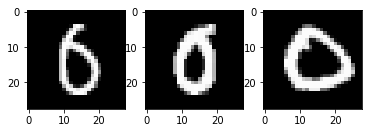

In [7]:
plt.figure(1)
image_num = len(img_zero)
for index in range(image_num):
    plt.subplot(1,int(image_num),int(index+1))
    plt.imshow(np.array(img_zero[int(index)]).reshape(28, 28), cmap='gray')
plt.show()

28 28の画像を784にしたら目で見ても特徴に気づくのでは？と思った    
全種類200枚を横に並べてみる

In [14]:
train_images, train_labels = mnist.train.next_batch(200)

バッチで取ってきたデータはグレースケールなので、そのままimshowしても表示できる。

In [40]:
train_images.shape

(2000, 784)

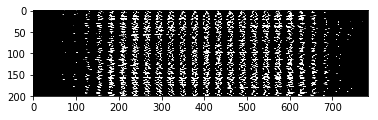

In [15]:
plt.plot(), plt.imshow(np.array(train_images), cmap='gray')
plt.show()

0で絞ってみる

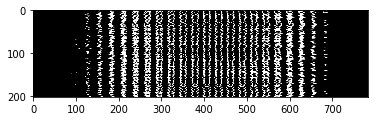

In [22]:
#0を描画
train_images, train_labels = mnist.train.next_batch(2000)
img_zero = train_images[np.where(train_labels == 0)]
plt.plot(), plt.imshow(np.array(img_zero), cmap='gray')
plt.show()

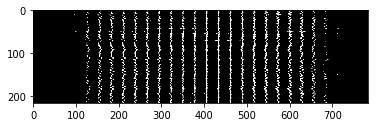

In [25]:
#1を描画
train_images, train_labels = mnist.train.next_batch(2000)
img_one = train_images[np.where(train_labels == 1)]
plt.plot(), plt.imshow(np.array(img_one), cmap='gray')
plt.show()

(190, 784)


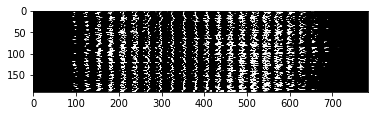

In [33]:
#2を描画
train_images, train_labels = mnist.train.next_batch(2000)
img_two = train_images[np.where(train_labels == 2)]
print(img_two.shape)
plt.plot(), plt.imshow(np.array(img_two), cmap='gray')
plt.show()

0と1の違いはわかるが、0と2の違いはパッとみわからない。

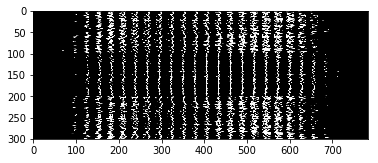

In [39]:
plt.plot(), plt.imshow(np.array(np.concatenate((img_zero[:100], img_one[:100], img_two[:100]), axis=0)), cmap='gray')
plt.show()

# TensorFlowにおける畳み込みとプーリング

この部分の今までとの違いはreshapeしているところ。28 28に変換。    


In [162]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

#mnistデータを格納したオブジェクトを呼び出す
mnist = input_data.read_data_sets("data/", one_hot=True)

"""モデル構築開始"""
#入力データを定義
x = tf.placeholder(tf.float32, [None, 784], name="conv_sample_x")
#整形
img = tf.reshape(x,[-1,28,28,1])

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


畳み込みとプーリングの組み合わせ    
重みのshapeは[縦、横、チャネル数、フィルタ数（畳み込み後のチャンネル数）]を指定する。    
convの３つ目の引数はストライド。[バッチ方向、縦方向、横方向、チャンネル方向]にどれだけカーネルを移動させるか決めれる。バッチ方向とチャンネル方向を1以外にすることは少ない。    
４つ目の引数はpaddingで横を埋める役割。フィルターサイズの大きさとストライドが大きくなると畳み込み後の画像サイズは小さくなる。画素値0のピクセルを用意してサイズ調整するのがパディング。SAMEを設定するとストライドを１にしても画像サイズは変わらなくなる。VALIDにするとパディングは入らないのでフィルタサイズ分だけ小さくなる。    
プーリングも同じ。

In [163]:
#畳み込み層1
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)

max_poolはフィルタの中から一番大きいものを持ってくる    
ksizeはフィルタサイズstridesはストライドで[バッチ方向、縦方向、横方向、チャンネル方向]を表す。
プーリングは画像縮小するのが目的なので、ストライドは２になってる。    
28 28の画像が14 14 の３２チャンネルの画像になった。

In [164]:
#プーリング層1
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [165]:
#畳み込み層2
f2 = tf.Variable(tf.truncated_normal([5,5,32,64], stddev=0.1))
conv2 = tf.nn.conv2d(h_pool1, f2, strides=[1,1,1,1], padding='SAME')
b2 = tf.Variable(tf.constant(0.1, shape=[64]))
h_conv2 = tf.nn.relu(conv2+b2)
#プーリング層2
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [166]:
#畳み込まれているものをフラットな形に変換
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

In [167]:
#全結合層
w_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

#出力層
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)

In [175]:
#正解データの型を定義
y = tf.placeholder(tf.float32, [None, 10], name="conv_sample_y")
#誤差関数（クロスエントロピー）
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))

In [169]:
#訓練
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#評価
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()

"""実行部分"""
with tf.Session() as sess:
    sess.run(init)
    #テストデータをロード
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(1000):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        #10階ごとに精度を検証
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))


Step 0: accuracy = 0.09
Step 100: accuracy = 0.90
Step 200: accuracy = 0.92
Step 300: accuracy = 0.94
Step 400: accuracy = 0.95
Step 500: accuracy = 0.94
Step 600: accuracy = 0.96
Step 700: accuracy = 0.95
Step 800: accuracy = 0.96
Step 900: accuracy = 0.96


正答率90%以上と精度が上がった。

## １層にしてみる

層数を変えどこを変更するのか確認した。    
Incompatible shapes: [50,10] vs. [25,10]であって、これは、「50x10の型枠に方眼紙を収めたいのに、25x10じゃ収まらないじゃないか！ぷんぷん」    
https://teratail.com/questions/93251    


In [12]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
#Conv layer
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
#プーリング層
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
print(h_pool1.shape) #14 14 32で出てる

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(500):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(h_pool1, feed_dict={x:train_images})

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(?, 14, 14, 32)


In [23]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
#conv pool
#重みのshapeは[縦、横、チャネル数、フィルタ数（畳み込み後のチャンネル数）]
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME') #ksizeとstridesを2から4へ変える
print(h_pool1.shape) #?, 7, 7, 32で出てる
#flatten
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32]) #64を32へ
print(h_pool2_flat.shape) #?, 1568で出てる
#fc
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1)) #64を32へ
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
print(h_fc1.shape) #?, 1024で出てる
#softmax
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
print(out.shape) #(?, 10)で出てる

#正解データの型を定義
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
#誤差関数（クロスエントロピー）
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))

#訓練
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#評価
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(500):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        sess.run(h_pool2_flat, feed_dict={x:train_images})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(?, 7, 7, 32)
(?, 1568)
(?, 1024)
(?, 10)
Step 0: accuracy = 0.13
Step 100: accuracy = 0.84
Step 200: accuracy = 0.89
Step 300: accuracy = 0.92
Step 400: accuracy = 0.92


# モデルの保存、学習済みモデルの読み込み

### tf.train.Saver()

tfでモデル保存方法はいくつかあるが基本的な方法を説明。    
tf.train.Saver()はtfによって作成されたgraphとVariableの値を保存、読み込みを行うクラス。    


In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [67]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()# add
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(1000):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))

    saver.save(sess, 'ckpt/my_model') #add

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.13
Step 100: accuracy = 0.83
Step 200: accuracy = 0.88
Step 300: accuracy = 0.91
Step 400: accuracy = 0.91
Step 500: accuracy = 0.93
Step 600: accuracy = 0.94
Step 700: accuracy = 0.94
Step 800: accuracy = 0.95
Step 900: accuracy = 0.95


In [37]:
!ls -l ckpt

total 241696
-rw-r--r--  1 miyamoto  staff         73  5 12 19:19 checkpoint
-rw-r--r--  1 miyamoto  staff  122926632  5 12 19:19 my_model.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff       4070  5 12 19:19 my_model.index
-rw-r--r--  1 miyamoto  staff     810099  5 12 19:19 my_model.meta


checkpoint:管理対象のファイルが記載されたファイル    
my_model.data-00000-of-00001:具体的なvariableの値を保持したファイル    
my_model.index：各Tensorとその値の参照箇所などの情報の紐付けが記載されてる    
my_model.meta：計算グラフ及び付随情報を含むメタファイル    


変数の一部のみ保存したい場合

In [38]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver_w = tf.train.Saver([f1, w_fc1]) #add
save_param = tf.train.Saver({'param1': f1, 'param2':w_fc1}) #add

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images
    test_labels = mnist.test.labels

    for step in range(800):
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))

    saver_w.save(sess, 'ckpt2/my_model_w') #add
    save_param.save(sess, 'ckpt2/my_model_param') #add

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.06
Step 100: accuracy = 0.85
Step 200: accuracy = 0.90
Step 300: accuracy = 0.90
Step 400: accuracy = 0.92
Step 500: accuracy = 0.93
Step 600: accuracy = 0.94
Step 700: accuracy = 0.93


In [43]:
!ls -l ckpt2/ | grep my_model_w

-rw-r--r--  1 miyamoto  staff    6425728  5 12 19:25 my_model_w.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff        176  5 12 19:25 my_model_w.index
-rw-r--r--  1 miyamoto  staff     848021  5 12 19:25 my_model_w.meta


In [44]:
!ls -l ckpt2/ | grep my_model_param

-rw-r--r--  1 miyamoto  staff    6425728  5 12 19:25 my_model_param.data-00000-of-00001
-rw-r--r--  1 miyamoto  staff        170  5 12 19:25 my_model_param.index
-rw-r--r--  1 miyamoto  staff     848021  5 12 19:25 my_model_param.meta


# 学習結果のrestore

学習済みモデルの読み込み    
tf.train.get_checkpoint_stateで読み込み、ckpt.model_checkpoint_pathで最後のモデルにアクセス。

In [68]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/') #対象パスにあるcheckpointファイルを読む。なければNone。
    if ckpt: # checkpointがある場合
        last_model = ckpt.model_checkpoint_path # 最後に保存したmodelへのパス
        print("load " + last_model)
        saver.restore(sess, last_model) # 変数データの読み込み
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
load ckpt/my_model
INFO:tensorflow:Restoring parameters from ckpt/my_model
Step 999: accuracy = 0.12


In [77]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="save_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="save_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/')
    if ckpt:
        last_model = ckpt.all_model_checkpoint_paths #モデルを全部取る
        print(len(last_model))
        print("load " + last_model[0])
        saver.restore(sess, last_model[0]) #あるモデルをインデックスで指定してリストア
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
1
load ckpt/my_model
INFO:tensorflow:Restoring parameters from ckpt/my_model
Step 999: accuracy = 0.10


# グローバルステップ

何ステップ目で学習が止まったかなどを保持してないとTensorBoardと組み合わせたいときに困るのでglobal_stepもモデル内に保存する。global_stepという引数を指定するだけ。

global_stepを保持する変数を作って、１ずつ増やしたかったが休日でボーッとしてたのか結構ハマった。    
下の計算グラフには誤りがあります。    
global_stepを１ずつ増やしたかったらどうすればいいでしょう。    

In [26]:
#-*- coding:utf-8 -*-
import tensorflow as tf

global_step = tf.Variable(0, name="global_step") #定義
global_step = tf.assign(global_step, 1)

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        print(sess.run(global_step))

1
1
1
1
1
1
1
1
1
1


tf.assignは代入だけども右の引数にはオペレーションを入れる。

In [27]:
#-*- coding:utf-8 -*-
import tensorflow as tf

step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step") #定義
add = tf.add(step_index, global_step)

global_step = tf.assign(global_step, add)

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        print(sess.run(global_step, feed_dict={}))

1
2
3
4
5
6
7
8
9
10


In [32]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="global_step_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="global_step_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
#global step
step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step")
add = tf.add(step_index, global_step)
global_step = tf.assign(global_step, add)

# override global_step here
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step) 

correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()
init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    test_images = mnist.test.images    
    test_labels = mnist.test.labels    

    for step in range(300):
        sess.run(global_step) # updete number of train global step
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})
        if step % 100 == 0:
            acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
            print('Step %d: accuracy = %.2f' % (step, acc_val))
    
    saver.save(sess, 'ckpt/my_model', global_step = global_step, write_meta_graph=False)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Step 0: accuracy = 0.12
Step 100: accuracy = 0.85
Step 200: accuracy = 0.90


global_stepを指定してモデルの読み込み

In [34]:
#-*- coding:utf-8 -*-
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

mnist = input_data.read_data_sets("data/", one_hot=True)
x = tf.placeholder(tf.float32, [None, 784], name="global_step_sample_x")
img = tf.reshape(x,[-1,28,28,1])
f1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
conv1 = tf.nn.conv2d(img, f1, strides=[1,1,1,1], padding='SAME')
b1 = tf.Variable(tf.constant(0.1, shape=[32]))
h_conv1 = tf.nn.relu(conv1+b1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool1, [-1, 7*7*32])
w_fc1 = tf.Variable(tf.truncated_normal([7*7*32, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)
w_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
out = tf.nn.softmax(tf.matmul(h_fc1, w_fc2) + b_fc2)
y = tf.placeholder(tf.float32, [None, 10], name="global_step_sample_y")
loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(out + 1e-5), axis=[1]))
#global step
step_index = tf.Variable(1)
global_step = tf.Variable(0, name="global_step")
add = tf.add(step_index, global_step)
global_step = tf.assign(global_step, add)

# override global_step here
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step) 

correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init =tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    ckpt = tf.train.get_checkpoint_state('ckpt/')
    if ckpt:
        last_model = ckpt.model_checkpoint_path
        print("load " + last_model)
        saver.restore(sess, last_model)
    else:
        print("no model")
    test_images = mnist.test.images
    test_labels = mnist.test.labels
    acc_val = sess.run( accuracy, feed_dict={x:test_images, y:test_labels})
    print('Step %d: accuracy = %.2f' % (step, acc_val))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
load ckpt/my_model-901
INFO:tensorflow:Restoring parameters from ckpt/my_model-901
Step 299: accuracy = 0.14


Step 299とちゃんと記録されてる。

In [15]:

#セッション上の計算グラフをクリア#セッション上の 
tf.reset_default_graph()

In [16]:
#インライン　テンソルボード
from IPython.display import clear_output, Image, display, HTML
import numpy as np

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [19]:
show_graph(tf.get_default_graph().as_graph_def()) # show graph

- cifar10のデータを読み込んで見ましょう